# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=cb817a1f6cbb7636d519ac84a61e553064f1017e4ef3607f4ce103794045083d
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [2]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 10.86s ==============================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [3]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

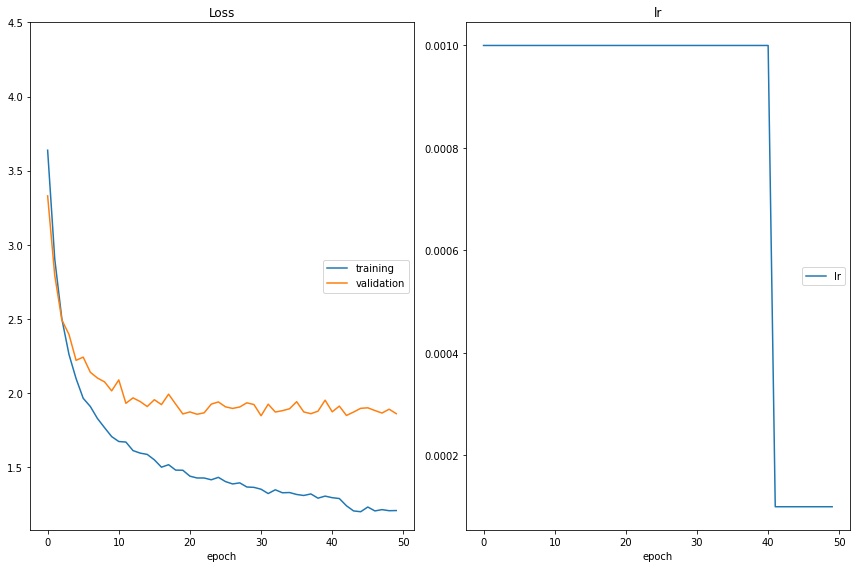

In [4]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("resnet18", num_classes)# YOUR CODE HERE

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ I chose pretrained resnet18 CNN architecture as a baseline for the transfer learning, as it is relatively smaller architecture and has good proven to be effective on road scenes as well, which targets this problem at hand.



Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [5]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [06:05<00:00, 18.28s/it]

Test Loss: 1.715747


Test Accuracy: 56% (702/1250)


1.715746629238129

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [6]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


  0%|                                                  | 0/1250 [00:00<?, ?it/s]

[1, 3, 224, 224]


  0%|                                          | 1/1250 [00:01<33:22,  1.60s/it]

[1, 50]
Columns 1 to 10 1.5414 -0.7479 -1.3298 -0.7036 -2.2163 -7.9389 -5.2322 -6.8818 -2.5620 -7.8746

Columns 11 to 20-0.7325 -1.9044 -2.9204 -1.2452 -8.2091 -0.7312 -1.7878 -3.6816 -6.4682 -6.7829

Columns 21 to 30-6.9290 -0.4309 -8.0179 -1.9313 -0.8143 -2.2873 -2.5713  0.1197 -7.1845 -7.0658

Columns 31 to 40-3.6126 -5.5141 -0.8608 -5.0637 -4.9778 -6.5871 -3.9418 -7.4402 -9.0102 -5.5543

Columns 41 to 50-3.6798  1.1182 -1.1216 -5.1801 -4.2460 -4.3859 -3.1835 -5.6014 -3.9834 -2.1514
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2423e-01  3.2859e-02  1.8363e-02  3.4347e-02  7.5671e-03  2.4753e-05

Columns 7 to 12 3.7080e-04  7.1243e-05  5.3554e-03  2.6396e-05  3.3369e-02  1.0336e-02

Columns 13 to 18 3.7423e-03  1.9983e-02  1.8893e-05  3.3412e-02  1.1615e-02  1.7481e-03

Columns 19 to 24 1.0774e-04  7.8649e-05  6.7955e-05  4.5112e-02  2.2873e-05  1.0062e-02

Columns 25 to 30 3.0747e-02  7.0484e-03  5.3059e-03  7.8241e-02  5.2633e-05  5.9269e-05

Columns 

  0%|                                          | 2/1250 [00:03<35:45,  1.72s/it]

[1, 50]
Columns 1 to 10-3.7449 -3.4918 -1.0381 -2.7522 -8.4195 -6.7520 -7.2300 -6.2621 -6.0041 -4.3450

Columns 11 to 20-3.7877 -2.9619 -5.0549 -2.3360 -9.1935 -3.0556 -4.9556 -1.7850 -5.3796 -5.3883

Columns 21 to 30-7.0198 -3.6778 -4.4888 -4.6456 -6.8741 -4.3772 -5.6178 -3.9084 -7.9322 -7.1256

Columns 31 to 40-4.3227 -2.3673 -3.6858 -8.0660 -10.5206 -4.1432 -3.9124 -6.8146 -7.7525 -5.8059

Columns 41 to 50-1.7654 -2.6994 -3.4577 -8.5508 -9.9024 -4.9209 -3.4818 -5.9319 -4.4485 -3.4412
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0156  0.0201  0.2341  0.0422  0.0001  0.0008  0.0005  0.0013  0.0016  0.0086

Columns 11 to 20 0.0150  0.0342  0.0042  0.0639  0.0001  0.0311  0.0047  0.1109  0.0030  0.0030

Columns 21 to 30 0.0006  0.0167  0.0074  0.0063  0.0007  0.0083  0.0024  0.0133  0.0002  0.0005

Columns 31 to 40 0.0088  0.0620  0.0166  0.0002  0.0000  0.0105  0.0132  0.0007  0.0003  0.0020

Columns 41 to 50 0.1131  0.0444  0.0208  0.0001  0.0000  0.004

  0%|                                          | 3/1250 [00:04<28:56,  1.39s/it]

[1, 50]
Columns 1 to 10-0.6573 -1.0587 -2.2562 -1.2047 -5.5667 -3.6029 -0.6200 -2.4487 -1.7631 -2.5907

Columns 11 to 20-1.1275 -1.9450 -5.3894 -0.3645 -4.4345 -1.1600 -1.4978 -4.2063 -0.9305 -2.3473

Columns 21 to 30-0.8377 -2.1584 -1.7257 -2.1223 -2.3372 -0.9719 -3.1113 -3.2874 -3.7432 -1.7856

Columns 31 to 40-4.2008 -2.5409 -3.3977 -3.6907 -7.1497 -1.2810 -1.1296 -2.6260 -2.6070 -2.5717

Columns 41 to 50-1.9882 -2.9138 -0.9933 -0.6580 -5.3768 -3.7475 -1.8259 -5.3725 -2.7497 -3.8306
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 100.01 *
 6.2280  4.1689  1.2588  3.6029  0.0459  0.3274  6.4649  1.0384  2.0612  0.9009

Columns 11 to 200.01 *
 3.8918  1.7183  0.0549  8.3468  0.1425  3.7672  2.6875  0.1791  4.7393  1.1493

Columns 21 to 300.01 *
 5.2004  1.3881  2.1398  1.4391  1.1609  4.5471  0.5353  0.4489  0.2845  2.0154

Columns 31 to 400.01 *
 0.1801  0.9470  0.4020  0.2999  0.0094  3.3382  3.8836  0.8697  0.8864  0.9182

Columns 41 to 500.01 *
 1.6457  0.6

  0%|▏                                         | 4/1250 [00:05<23:13,  1.12s/it]

[1, 50]
Columns 1 to 10 0.1975  0.5747 -3.0747 -7.9206 -2.6729 -3.7171 -4.2952 -8.1945 -5.8861 -8.3222

Columns 11 to 20 1.9679 -5.4000 -6.9704 -4.7799 -5.2497  1.0171  0.8707 -1.4820 -9.9625 -3.7458

Columns 21 to 30-7.8351 -6.4368 -3.6429 -6.2346 -4.5391 -6.6641 -6.6004  1.0987 -3.3160 -3.8653

Columns 31 to 40-0.8534 -3.4405 -5.3424 -3.2423 -6.1251 -5.5945 -9.4393 -4.7488 -6.7806 -4.6403

Columns 41 to 50-0.1657 -3.2068 -2.5788 -11.5140 -4.5915 -0.9455 -2.9512 -3.9967 -6.4960 -7.2127
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8592e-02  8.5435e-02  2.2219e-03  1.7466e-05  3.3208e-03  1.1688e-03

Columns 7 to 12 6.5568e-04  1.3282e-05  1.3359e-04  1.1689e-05  3.4410e-01  2.1720e-04

Columns 13 to 18 4.5171e-05  4.0381e-04  2.5243e-04  1.3297e-01  1.1487e-01  1.0925e-02

Columns 19 to 24 2.2668e-06  1.1357e-03  1.9025e-05  7.7015e-05  1.2588e-03  9.4278e-05

Columns 25 to 30 5.1373e-04  6.1355e-05  6.5395e-05  1.4428e-01  1.7456e-03  1.0078e-03

Columns

  0%|▏                                         | 5/1250 [00:06<22:18,  1.08s/it]

[1, 50]
Columns 1 to 10 0.2758 -1.5083 -2.7815  0.4884 -5.6718 -3.6483 -2.7260 -4.3247 -2.8464 -2.8856

Columns 11 to 20-0.1548 -0.4254 -6.4051  0.8801 -4.1944 -2.0949 -0.8123 -5.0094 -3.2959 -2.4387

Columns 21 to 30-1.8469 -4.3576 -1.9450 -2.9191 -4.4398 -1.4299 -1.3680 -1.2614 -2.8965 -2.0587

Columns 31 to 40-3.5209 -0.7895 -3.9742 -4.5226 -5.6045 -2.2601 -0.9344 -2.2036 -3.9651 -2.2428

Columns 41 to 50-3.9180 -1.4581 -1.2617 -2.1843 -8.4174 -4.8477 -1.9276 -4.3735 -2.1644 -3.4592
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1132  0.0190  0.0053  0.1400  0.0003  0.0022  0.0056  0.0011  0.0050  0.0048

Columns 11 to 20 0.0736  0.0562  0.0001  0.2072  0.0013  0.0106  0.0381  0.0006  0.0032  0.0075

Columns 21 to 30 0.0136  0.0011  0.0123  0.0046  0.0010  0.0206  0.0219  0.0243  0.0047  0.0110

Columns 31 to 40 0.0025  0.0390  0.0016  0.0009  0.0003  0.0090  0.0338  0.0095  0.0016  0.0091

Columns 41 to 50 0.0017  0.0200  0.0243  0.0097  0.0000  0.0007

  0%|▏                                         | 6/1250 [00:07<21:04,  1.02s/it]

[1, 50]
Columns 1 to 10-3.7190 -2.8979 -3.7524 -1.3410 -6.1078 -2.6069 -3.8512 -5.0663 -1.8114 -4.8684

Columns 11 to 20-3.8294 -4.1746 -7.4538 -2.7467 -7.5488 -3.9211 -4.8565 -2.9452 -2.2450 -5.4045

Columns 21 to 30-3.9238 -3.4466 -3.6507 -7.8402 -8.2175 -4.9352 -5.1651 -3.8865 -3.6030 -5.5722

Columns 31 to 40-3.1524 -4.9368 -4.9405 -3.5967 -8.3196 -3.5055 -3.9100 -4.6581 -2.6673 -5.3209

Columns 41 to 50-3.0571 -6.3069 -2.5408 -5.3943 -6.4291 -4.6611 -2.1068 -7.0456 -5.8037 -6.1184
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0155  0.0352  0.0150  0.1672  0.0014  0.0472  0.0136  0.0040  0.1045  0.0049

Columns 11 to 20 0.0139  0.0098  0.0004  0.0410  0.0003  0.0127  0.0050  0.0336  0.0677  0.0029

Columns 21 to 30 0.0126  0.0204  0.0166  0.0003  0.0002  0.0046  0.0037  0.0131  0.0174  0.0024

Columns 31 to 40 0.0273  0.0046  0.0046  0.0175  0.0002  0.0192  0.0128  0.0061  0.0444  0.0031

Columns 41 to 50 0.0301  0.0012  0.0504  0.0029  0.0010  0.0060

  1%|▏                                         | 7/1250 [00:07<18:54,  1.10it/s]

[1, 50]
Columns 1 to 10 1.1235 -0.2771 -3.3565 -1.3754 -1.0754 -2.3995 -3.5820 -4.8323 -3.2598 -2.6676

Columns 11 to 20-1.1488 -2.6494 -0.3717  0.0128 -4.2837 -0.1133 -1.3905 -1.7645 -6.6646 -3.5982

Columns 21 to 30-6.9509 -2.1734 -2.6386 -3.6536 -2.8237 -3.0629 -3.5012 -0.5044 -3.4427 -3.0284

Columns 31 to 40-2.1913 -2.7269 -1.1398 -2.6790 -0.9132 -4.2571 -3.8726 -7.1015 -4.3283 -5.5759

Columns 41 to 50-0.8446 -1.7734 -0.8404 -6.4683 -3.3456 -0.5674 -1.2491 -6.5413 -2.1991 -3.6435
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.2510  0.0619  0.0028  0.0206  0.0278  0.0074  0.0023  0.0007  0.0031  0.0057

Columns 11 to 20 0.0259  0.0058  0.0563  0.0827  0.0011  0.0729  0.0203  0.0140  0.0001  0.0022

Columns 21 to 30 0.0001  0.0093  0.0058  0.0021  0.0048  0.0038  0.0025  0.0493  0.0026  0.0039

Columns 31 to 40 0.0091  0.0053  0.0261  0.0056  0.0327  0.0012  0.0017  0.0001  0.0011  0.0003

Columns 41 to 50 0.0351  0.0139  0.0352  0.0001  0.0029  0.0463

  1%|▎                                         | 8/1250 [00:08<17:27,  1.19it/s]

[1, 50]
Columns 1 to 10-2.4876 -3.3191 -2.3230 -5.2273 -3.1541 -2.2977 -4.2914 -3.2825 -10.1218 -7.4119

Columns 11 to 20-2.9161 -6.6921 -4.3077 -3.5421 -6.2796  0.4473 -3.1584 -4.1489 -6.8105 -5.4344

Columns 21 to 30-8.1709 -1.0036 -3.5511 -3.9181 -8.3218 -7.5527 -4.5441 -2.5292 -3.6261 -4.7331

Columns 31 to 40-4.2431 -4.6528 -6.4799 -4.6580 -3.7923 -4.9618 -5.7357 -4.6090 -5.5571 -8.2796

Columns 41 to 50 0.1074 -6.1463 -6.7822 -7.3582 -7.0657 -3.0289 -4.2047 -10.9250 -4.1070 -3.5765
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0806e-02  9.0583e-03  2.4527e-02  1.3438e-03  1.0683e-02  2.5157e-02

Columns 7 to 12 3.4258e-03  9.3965e-03  1.0062e-05  1.5121e-04  1.3554e-02  3.1059e-04

Columns 13 to 18 3.3707e-03  7.2479e-03  4.6917e-04  3.9153e-01  1.0637e-02  3.9506e-03

Columns 19 to 24 2.7591e-04  1.0925e-03  7.0784e-05  9.1758e-02  7.1831e-03  4.9766e-03

Columns 25 to 30 6.0869e-05  1.3135e-04  2.6609e-03  1.9957e-02  6.6638e-03  2.2027e-03

Column

  1%|▎                                         | 9/1250 [00:09<15:53,  1.30it/s]

[1, 50]
Columns 1 to 10-1.3065 -3.6098 -7.3015 -6.2792 -10.1199 -4.6768 -7.2661 -7.5059 -3.3699 -7.1182

Columns 11 to 20-3.4757 -3.7207 -9.8794 -5.3547 -8.5772 -4.1681 -2.4403 -3.3251 -4.6244 -3.0736

Columns 21 to 30-4.0065 -6.1829 -10.0040 -4.0595 -5.2288 -5.4947 -7.7524 -3.8286 -5.1282 -4.3161

Columns 31 to 40-5.5232 -10.1417 -0.1731 -6.3480 -9.6712 -5.8349 -5.1255 -5.3280 -9.1714 -4.5837

Columns 41 to 50-7.4146  2.2211 -2.4937 -6.2338 -7.1670 -5.5825 -5.2958 -3.0232 -2.4055 -6.4365
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4585e-02  2.4567e-03  6.1245e-05  1.7024e-04  3.6566e-06  8.4523e-04

Columns 7 to 12 6.3456e-05  4.9923e-05  3.1230e-03  7.3569e-05  2.8092e-03  2.1988e-03

Columns 13 to 18 4.6509e-06  4.2909e-04  1.7102e-05  1.4058e-03  7.9117e-03  3.2659e-03

Columns 19 to 24 8.9066e-04  4.1997e-03  1.6523e-03  1.8745e-04  4.1058e-06  1.5669e-03

Columns 25 to 30 4.8669e-04  3.7305e-04  3.9017e-05  1.9739e-03  5.3819e-04  1.2123e-03

Colum

  1%|▎                                        | 10/1250 [00:09<15:27,  1.34it/s]

[1, 50]
Columns 1 to 10 1.3622 -2.1185 -2.7277 -1.1287 -5.8323 -3.2721 -2.6870 -4.3247 -4.6023 -2.8275

Columns 11 to 20-3.0122 -2.3979 -6.8327 -1.9051 -4.1129 -0.6856 -0.6039 -4.4270 -4.5461 -2.3711

Columns 21 to 30-1.5316 -4.0048 -3.8179 -2.8885 -5.0661 -2.9333 -4.6130 -0.9926 -1.7283 -2.8731

Columns 31 to 40-1.9550 -0.6751 -6.0776 -4.1795 -5.9209 -3.0832 -3.2672 -1.6894 -2.5163 -3.0985

Columns 41 to 50-1.8997 -3.7045 -3.3103 -4.5618 -9.2535 -3.9025 -3.8122 -5.6957 -2.6990 -3.1562
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.4591  0.0141  0.0077  0.0380  0.0003  0.0045  0.0080  0.0016  0.0012  0.0070

Columns 11 to 20 0.0058  0.0107  0.0001  0.0175  0.0019  0.0592  0.0643  0.0014  0.0012  0.0110

Columns 21 to 30 0.0254  0.0021  0.0026  0.0065  0.0007  0.0063  0.0012  0.0436  0.0209  0.0066

Columns 31 to 40 0.0166  0.0598  0.0003  0.0018  0.0003  0.0054  0.0045  0.0217  0.0095  0.0053

Columns 41 to 50 0.0176  0.0029  0.0043  0.0012  0.0000  0.0024

  1%|▎                                        | 11/1250 [00:10<15:07,  1.37it/s]

[1, 50]
Columns 1 to 10-4.5889 -0.9005 -4.3669 -6.0577 -3.9328 -2.7876 -7.7976 -5.9316 -4.4186 -5.3240

Columns 11 to 20-2.8813 -1.9540 -5.4458 -3.4550 -5.6848 -2.6096 -5.9282 -1.7765 -1.3728 -4.2095

Columns 21 to 30-3.9367 -7.2333 -4.6882 -5.0567 -8.1910 -5.0705 -9.0081 -1.8567 -5.3768 -5.9348

Columns 31 to 40-2.9647 -7.0587 -4.5726 -1.0667 -8.8267 -3.2916 -5.9410 -6.2447 -4.0839 -5.8035

Columns 41 to 50-3.1262 -4.8250 -4.2107 -9.7798 -5.3891 -2.7009 -4.7377 -4.6508 -4.7620 -5.0563
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0048  0.1908  0.0060  0.0011  0.0092  0.0289  0.0002  0.0012  0.0057  0.0023

Columns 11 to 20 0.0263  0.0665  0.0020  0.0148  0.0016  0.0345  0.0013  0.0795  0.1190  0.0070

Columns 21 to 30 0.0092  0.0003  0.0043  0.0030  0.0001  0.0029  0.0001  0.0733  0.0022  0.0012

Columns 31 to 40 0.0242  0.0004  0.0049  0.1616  0.0001  0.0175  0.0012  0.0009  0.0079  0.0014

Columns 41 to 50 0.0206  0.0038  0.0070  0.0000  0.0021  0.0315

  1%|▍                                        | 12/1250 [00:11<18:41,  1.10it/s]

[1, 50]
Columns 1 to 10-0.3831 -2.3382 -3.9020 -1.6887 -5.5431 -5.8245 -4.7065 -3.1055 -3.1935 -4.6370

Columns 11 to 20-0.0333 -2.0083 -2.3637 -0.3411 -5.7117 -2.5790 -1.5971 -3.2096 -3.0858 -2.9368

Columns 21 to 30-3.3083 -3.4951 -5.8857 -2.5316 -3.7227 -2.3517 -1.9414 -1.3610 -5.6988 -4.0373

Columns 31 to 40-4.0139 -4.0774 -0.9856 -5.2780 -5.2191 -4.5693 -1.8237 -6.1463 -5.8496 -3.8566

Columns 41 to 50-2.2116  2.1097 -1.1866 -3.7095 -2.7564 -3.3705 -3.4101 -3.6553 -0.8726 -2.9020
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0485  0.0069  0.0014  0.0132  0.0003  0.0002  0.0006  0.0032  0.0029  0.0007

Columns 11 to 20 0.0689  0.0096  0.0067  0.0506  0.0002  0.0054  0.0144  0.0029  0.0033  0.0038

Columns 21 to 30 0.0026  0.0022  0.0002  0.0057  0.0017  0.0068  0.0102  0.0183  0.0002  0.0013

Columns 31 to 40 0.0013  0.0012  0.0266  0.0004  0.0004  0.0007  0.0115  0.0002  0.0002  0.0015

Columns 41 to 50 0.0078  0.5872  0.0217  0.0017  0.0045  0.0024

  1%|▍                                        | 13/1250 [00:13<21:07,  1.02s/it]

[1, 50]
Columns 1 to 10 1.0972 -1.7059 -2.7599 -3.9542 -8.3211 -5.1738 -5.1610 -1.7780 -4.0539 -6.9101

Columns 11 to 20 0.0045 -4.1035 -6.3786 -0.1850 -7.0204 -1.6983 -1.5054 -2.4020 -5.4999 -3.4794

Columns 21 to 30-3.3149 -4.7292 -6.3920 -1.5245 -3.4037 -1.9697 -1.3848 -0.8970 -5.1208 -4.5546

Columns 31 to 40-5.6300 -4.8188 -3.7569 -7.0531 -8.8455 -3.5838 -1.8549 -4.8436 -4.8761 -3.9181

Columns 41 to 50-4.5817 -0.2760 -2.2086 -3.1089 -7.1301 -4.7730 -1.2035 -7.3285 -0.2316 -2.2010
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.3204  0.0194  0.0068  0.0021  0.0000  0.0006  0.0006  0.0181  0.0019  0.0001

Columns 11 to 20 0.1074  0.0018  0.0002  0.0889  0.0001  0.0196  0.0237  0.0097  0.0004  0.0033

Columns 21 to 30 0.0039  0.0009  0.0002  0.0233  0.0036  0.0149  0.0268  0.0436  0.0006  0.0011

Columns 31 to 40 0.0004  0.0009  0.0025  0.0001  0.0000  0.0030  0.0167  0.0008  0.0008  0.0021

Columns 41 to 50 0.0011  0.0812  0.0118  0.0048  0.0001  0.0009

  1%|▍                                        | 14/1250 [00:14<25:19,  1.23s/it]

[1, 50]
Columns 1 to 10-2.4599 -1.3981 -3.4197 -5.3061 -7.5798 -7.2379 -5.6058 -5.1679 -3.9044 -4.7977

Columns 11 to 20 1.2086 -2.2030 -5.5960 -2.8588 -8.4657 -3.7928 -3.1577 -5.2391 -5.3185 -5.7460

Columns 21 to 30-4.1691 -9.0681 -7.1877 -3.4048 -7.9745 -2.0532 -6.1583 -1.6227 -7.7302 -6.8170

Columns 31 to 40-6.2004 -5.8256 -4.6643 -6.0156 -10.9497 -3.3616 -4.8909 -7.1584 -7.9911 -3.6777

Columns 41 to 50-5.0623 -2.3652 -2.9943 -7.3805 -9.6146 -2.3975 -3.2589 -5.0016 -2.5171 -7.8531
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7650e-02  5.1036e-02  6.7591e-03  1.0248e-03  1.0549e-04  1.4848e-04

Columns 7 to 12 7.5944e-04  1.1767e-03  4.1627e-03  1.7038e-03  6.9175e-01  2.2818e-02

Columns 13 to 18 7.6690e-04  1.1844e-02  4.3496e-05  4.6545e-03  8.7837e-03  1.0959e-03

Columns 19 to 24 1.0122e-03  6.6006e-04  3.1948e-03  2.3814e-05  1.5612e-04  6.8608e-03

Columns 25 to 30 7.1082e-05  2.6507e-02  4.3704e-04  4.0770e-02  9.0755e-05  2.2618e-04

Columns

  1%|▍                                        | 15/1250 [00:15<22:37,  1.10s/it]

[1, 50]
Columns 1 to 10-0.9506  0.7329 -3.7475 -4.3944 -6.1427 -3.2789 -5.2428 -3.8591 -4.1227 -4.8309

Columns 11 to 20-2.4811 -3.6553 -4.7938 -0.4135 -4.4218 -0.9688 -2.5439 -3.3879 -2.2597 -5.7579

Columns 21 to 30-3.3590 -4.7040 -2.9233 -4.0209 -7.4761 -3.1333 -3.3640 -2.2191 -2.7432 -6.7295

Columns 31 to 40-3.9363 -3.4604 -5.3787 -3.5157 -6.6811 -3.8951 -3.1626 -3.9631 -3.6006 -4.8099

Columns 41 to 50-2.0846 -1.1993 -2.5692 -5.9503 -6.6454 -3.6249 -3.4628 -5.5517 -1.1984 -3.3154
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0708  0.3810  0.0043  0.0023  0.0004  0.0069  0.0010  0.0039  0.0030  0.0015

Columns 11 to 20 0.0153  0.0047  0.0015  0.1211  0.0022  0.0695  0.0144  0.0062  0.0191  0.0006

Columns 21 to 30 0.0064  0.0017  0.0098  0.0033  0.0001  0.0080  0.0063  0.0199  0.0118  0.0002

Columns 31 to 40 0.0036  0.0058  0.0008  0.0054  0.0002  0.0037  0.0077  0.0035  0.0050  0.0015

Columns 41 to 50 0.0228  0.0552  0.0140  0.0005  0.0002  0.0049

  1%|▌                                        | 16/1250 [00:16<22:37,  1.10s/it]

[1, 50]
Columns 1 to 10 0.4288 -0.6527 -4.2140 -0.4763 -0.3999 -3.6575 -1.1487 -1.1744 -6.0104 -3.1735

Columns 11 to 20-0.7511 -0.6397 -3.9359  1.6499 -3.2628 -1.0457 -2.3979 -4.6014 -7.2321 -3.4902

Columns 21 to 30-4.1877 -3.0215  0.1930 -1.4174 -4.1786 -3.6581 -1.7592 -2.4714 -4.9881 -4.3005

Columns 31 to 40-4.6688 -1.5468 -5.3873 -3.2748 -5.1623 -2.7660 -1.8217 -4.7640 -5.0740 -3.8789

Columns 41 to 50-2.2636 -2.2663 -4.8105 -1.9832 -6.1555 -2.7732 -3.4839 -7.1247  0.5332 -3.1915
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0999  0.0339  0.0010  0.0404  0.0436  0.0017  0.0206  0.0201  0.0002  0.0027

Columns 11 to 20 0.0307  0.0343  0.0013  0.3388  0.0025  0.0229  0.0059  0.0007  0.0000  0.0020

Columns 21 to 30 0.0010  0.0032  0.0789  0.0158  0.0010  0.0017  0.0112  0.0055  0.0004  0.0009

Columns 31 to 40 0.0006  0.0139  0.0003  0.0025  0.0004  0.0041  0.0105  0.0006  0.0004  0.0013

Columns 41 to 50 0.0068  0.0067  0.0005  0.0090  0.0001  0.0041

  1%|▌                                        | 17/1250 [00:18<25:40,  1.25s/it]

[1, 50]
Columns 1 to 10-1.0013 -2.4266 -7.4324 -9.2488 -4.9178 -5.0249 -7.4213 -3.8707 -5.1868 -8.2799

Columns 11 to 20-0.4964 -3.8819 -8.3376 -4.0833 -6.9663 -2.0419 -1.9415 -2.7273 -11.7749 -1.7031

Columns 21 to 30-4.8747 -7.2581 -8.7268 -0.4321 -6.5454 -0.7377 -5.7068 -0.8452 -4.5783 -5.2312

Columns 31 to 40-6.1909 -6.7363 -3.2937 -7.0975 -9.2651 -8.4417 -4.8514 -8.0618 -9.1045 -6.2289

Columns 41 to 50-6.4164  2.1823 -5.1030 -5.4777 -8.0572 -3.5895 -2.0813 -5.6240 -0.4392 -5.4360
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8289e-02  6.8018e-03  4.5567e-05  7.4097e-06  5.6329e-04  5.0605e-04

Columns 7 to 12 4.6074e-05  1.6050e-03  4.3041e-04  1.9524e-05  4.6873e-02  1.5871e-03

Columns 13 to 18 1.8430e-05  1.2976e-03  7.2623e-05  9.9933e-03  1.1048e-02  5.0355e-03

Columns 19 to 24 5.9254e-07  1.4023e-02  5.8807e-04  5.4243e-05  1.2488e-05  4.9987e-02

Columns 25 to 30 1.1062e-04  3.6823e-02  2.5589e-04  3.3070e-02  7.9096e-04  4.1174e-04

Columns

  1%|▌                                        | 18/1250 [00:20<29:40,  1.44s/it]

[1, 50]
Columns 1 to 10-1.6033 -0.8926 -4.8002 -6.7333 -5.3669 -7.1285 -7.1609 -8.3273 -3.2717 -8.6537

Columns 11 to 20-1.2393 -2.1627 -5.5359 -4.9073 -6.9425 -0.6879 -3.0669 -5.0849 -3.5706 -3.9248

Columns 21 to 30-5.0844 -4.5584 -9.3676 -2.6097 -6.1202 -4.8955 -7.0216 -1.4783 -6.3066 -6.3526

Columns 31 to 40-5.3993 -9.6608  0.2320 -4.2068 -7.8973 -5.0881 -4.3815 -4.0082 -8.6474 -2.4220

Columns 41 to 50-3.3396  1.1921 -3.3883 -7.2148 -7.2650 -2.3965 -2.7223 -0.7013 -3.9206 -4.0650
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6909e-02  5.4770e-02  1.1002e-03  1.5920e-04  6.2428e-04  1.0723e-04

Columns 7 to 12 1.0381e-04  3.2335e-05  5.0736e-03  2.3330e-05  3.8721e-02  1.5379e-02

Columns 13 to 18 5.2718e-04  9.8847e-04  1.2915e-04  6.7210e-02  6.2265e-03  8.2763e-04

Columns 19 to 24 3.7625e-03  2.6404e-03  8.2805e-04  1.4012e-03  1.1426e-05  9.8358e-03

Columns 25 to 30 2.9392e-04  1.0003e-03  1.1933e-04  3.0491e-02  2.4392e-04  2.3296e-04

Columns 

  2%|▌                                        | 19/1250 [00:21<30:35,  1.49s/it]

[1, 50]
Columns 1 to 10 2.1867 -3.3842 -0.9661 -8.8344 -5.8592 -4.2625 -3.9877 -10.0003 -7.5232 -7.6313

Columns 11 to 20-1.1948 -6.6792 -2.5050 -4.2341 -5.2167  1.2492  1.6572 -3.7418 -9.8923 -7.9445

Columns 21 to 30-11.4150 -1.7808 -7.5668 -4.9554 -6.3009 -5.8657 -5.4948 -2.0854 -3.0277  0.3290

Columns 31 to 40-5.4024 -5.1489 -4.6316 -4.7553 -4.9703 -3.0662 -9.6266 -6.0702 -9.9496 -8.0241

Columns 41 to 50-2.5649 -2.4930 -7.2688 -9.6806 -10.4937 -2.3703 -0.6590 -11.4083 -8.6205 -6.5419
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2159e-01  1.6050e-03  1.8015e-02  6.8946e-06  1.3508e-04  6.6692e-04

Columns 7 to 12 8.7779e-04  2.1486e-06  2.5583e-05  2.2962e-05  1.4333e-02  5.9499e-05

Columns 13 to 18 3.8668e-03  6.8610e-04  2.5684e-04  1.6510e-01  2.4829e-01  1.1225e-03

Columns 19 to 24 2.3936e-06  1.6788e-05  5.2213e-07  7.9771e-03  2.4492e-05  3.3353e-04

Columns 25 to 30 8.6854e-05  1.3421e-04  1.9448e-04  5.8824e-03  2.2926e-03  6.5783e-02

Colu

  2%|▋                                        | 20/1250 [00:23<31:15,  1.52s/it]

[1, 50]
Columns 1 to 10-1.4477 -0.8502 -2.3285 -5.0547 -7.8512 -7.0470 -5.5908 -5.4668 -3.4994 -3.6843

Columns 11 to 20-1.2855 -3.3828 -6.7113 -1.0782 -9.0878 -1.2478 -3.4346 -4.7899 -5.7616 -7.5042

Columns 21 to 30-3.9709 -5.6290 -7.2142 -3.2865 -10.3826 -2.3663 -5.5568 -0.6609 -5.2217 -5.9515

Columns 31 to 40-5.2781 -4.5270 -3.4056 -8.6130 -8.4569 -5.3981 -5.5301 -6.5706 -6.6130 -4.2991

Columns 41 to 50-3.7564 -2.3839 -4.3433 -5.6432 -10.8611 -3.5440 -2.1828 -6.6098 -1.6642 -6.3743
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.7410e-02  1.4069e-01  3.2080e-02  2.1003e-03  1.2817e-04  2.8644e-04

Columns 7 to 12 1.2288e-03  1.3909e-03  9.9476e-03  8.2685e-03  9.1040e-02  1.1178e-02

Columns 13 to 18 4.0069e-04  1.1201e-01  3.7216e-05  9.4539e-02  1.0614e-02  2.7370e-03

Columns 19 to 24 1.0358e-03  1.8134e-04  6.2084e-03  1.1826e-03  2.4234e-04  1.2308e-02

Columns 25 to 30 1.0195e-05  3.0892e-02  1.2712e-03  1.7002e-01  1.7772e-03  8.5664e-04

Column

  2%|▋                                        | 21/1250 [00:24<27:23,  1.34s/it]

[1, 50]
Columns 1 to 10 0.8882 -2.4092 -3.9628  1.4105 -4.5354 -3.0789 -1.4932 -2.3612 -1.5212 -4.6659

Columns 11 to 20 0.0022 -2.6177 -4.5060 -1.1072 -2.2637 -1.6600 -2.3094 -5.2805 -2.2088 -3.4560

Columns 21 to 30-3.2961 -0.9185 -1.7037 -2.2841 -4.0174 -4.3296 -4.7638 -3.7457 -3.3788 -4.3084

Columns 31 to 40-3.2847  0.1506 -4.1607 -2.3082 -1.8899 -4.4073  0.1178 -4.1550 -6.0994  0.3978

Columns 41 to 50-0.3264 -2.8499 -1.2638 -3.3174 -6.2327 -1.9283 -0.7239 -3.9156 -1.2869 -2.3393
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1495  0.0055  0.0012  0.2520  0.0007  0.0028  0.0138  0.0058  0.0134  0.0006

Columns 11 to 20 0.0616  0.0045  0.0007  0.0203  0.0064  0.0117  0.0061  0.0003  0.0068  0.0019

Columns 21 to 30 0.0023  0.0245  0.0112  0.0063  0.0011  0.0008  0.0005  0.0015  0.0021  0.0008

Columns 31 to 40 0.0023  0.0715  0.0010  0.0061  0.0093  0.0007  0.0692  0.0010  0.0001  0.0915

Columns 41 to 50 0.0444  0.0036  0.0174  0.0022  0.0001  0.0089

  2%|▋                                        | 22/1250 [00:25<27:44,  1.36s/it]

[1, 50]
Columns 1 to 10-0.2258 -2.5031 -4.6488 -1.4926 -6.0698 -5.5282 -4.1873 -2.2313 -3.7434 -6.0027

Columns 11 to 20-1.4680 -3.4536 -5.7321  0.8482 -6.8515 -1.4398 -3.3788 -3.2711 -5.0312 -4.1738

Columns 21 to 30-2.5021 -3.1401 -5.5324 -0.9248 -3.3023 -0.6917 -2.1597 -2.4695 -5.5318 -4.5920

Columns 31 to 40-6.0688 -4.6380 -3.1627 -6.7910 -7.6215 -3.9208  0.1262 -6.2899 -5.6049 -3.3739

Columns 41 to 50-4.6203 -0.5923 -1.9728 -0.9974 -6.8526 -4.3176 -2.7111 -7.0353  0.1625 -2.5500
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0873  0.0090  0.0010  0.0246  0.0003  0.0004  0.0017  0.0118  0.0026  0.0003

Columns 11 to 20 0.0252  0.0035  0.0004  0.2556  0.0001  0.0259  0.0037  0.0042  0.0007  0.0017

Columns 21 to 30 0.0090  0.0047  0.0004  0.0434  0.0040  0.0548  0.0126  0.0093  0.0004  0.0011

Columns 31 to 40 0.0003  0.0011  0.0046  0.0001  0.0001  0.0022  0.1242  0.0002  0.0004  0.0037

Columns 41 to 50 0.0011  0.0605  0.0152  0.0404  0.0001  0.0015

  2%|▊                                        | 23/1250 [00:27<30:27,  1.49s/it]

[1, 50]
Columns 1 to 10-1.8657 -5.1932 -3.4538 -3.8809 -5.4163 -6.3965 -1.9947 -8.1936 -7.7953 -7.7178

Columns 11 to 20-5.8072 -4.6000 -7.0409 -3.1831 -6.1444 -1.1746 -3.3754 -5.5450 -8.3673 -3.6153

Columns 21 to 30-7.7898  0.5655 -3.0122 -5.7149 -8.2551 -6.7315 -7.4543 -1.9002 -2.8111 -4.9090

Columns 31 to 40-6.8211 -2.2292 -8.6952 -3.4478 -3.0279 -2.0838 -4.9581 -0.6996 -5.5529 -4.6877

Columns 41 to 50-3.0807 -7.8652 -5.2712 -6.2610 -7.3214 -3.1602 -8.2421 -8.0535 -5.5424 -5.1709
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0412  0.0015  0.0084  0.0055  0.0012  0.0004  0.0362  0.0001  0.0001  0.0001

Columns 11 to 20 0.0008  0.0027  0.0002  0.0110  0.0006  0.0822  0.0091  0.0010  0.0001  0.0072

Columns 21 to 30 0.0001  0.4685  0.0131  0.0009  0.0001  0.0003  0.0002  0.0398  0.0160  0.0020

Columns 31 to 40 0.0003  0.0286  0.0000  0.0085  0.0129  0.0331  0.0019  0.1322  0.0010  0.0025

Columns 41 to 50 0.0122  0.0001  0.0014  0.0005  0.0002  0.0113

  2%|▊                                        | 24/1250 [00:28<28:02,  1.37s/it]

[1, 50]
Columns 1 to 10 0.1228 -2.1403 -5.0596 -5.2286 -3.1050 -4.4945 -3.0533 -5.8201 -0.8222 -5.7401

Columns 11 to 20 0.1123 -1.4626 -3.8989 -1.4298 -4.6028 -0.6431 -1.2520 -5.1865 -7.4789 -2.2076

Columns 21 to 30-5.5789 -2.8124 -5.2714 -3.6889 -6.2731 -3.6211 -3.5775 -1.4539 -4.5133 -2.4566

Columns 31 to 40-3.7146 -4.3173 -3.6027 -4.2353 -2.5796 -5.1164 -4.6475 -5.3626 -7.2897 -3.7914

Columns 41 to 50-0.7129 -1.9915 -3.7898 -4.8915 -5.7111 -1.0493 -0.9223 -5.0527 -2.1127 -5.5829
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1719  0.0179  0.0010  0.0008  0.0068  0.0017  0.0072  0.0005  0.0668  0.0005

Columns 11 to 20 0.1702  0.0352  0.0031  0.0364  0.0015  0.0799  0.0435  0.0009  0.0001  0.0167

Columns 21 to 30 0.0006  0.0091  0.0008  0.0038  0.0003  0.0041  0.0043  0.0355  0.0017  0.0130

Columns 31 to 40 0.0037  0.0020  0.0041  0.0022  0.0115  0.0009  0.0015  0.0007  0.0001  0.0034

Columns 41 to 50 0.0746  0.0208  0.0034  0.0011  0.0005  0.0533

  2%|▊                                        | 25/1250 [00:29<26:57,  1.32s/it]

[1, 50]
Columns 1 to 10 1.3755 -0.8410 -1.7960 -4.4022 -4.2597 -5.2931 -4.3837 -5.6998 -3.9235 -6.7934

Columns 11 to 20-3.1615 -3.2552 -3.2276 -0.6024 -5.7390  0.1032 -1.5617 -1.2964 -6.1670 -3.2735

Columns 21 to 30-4.8645 -0.5854 -4.4267 -3.2699 -4.4430 -1.9175 -3.7995 -0.7091 -4.3988 -2.7529

Columns 31 to 40-4.0584 -1.6502 -4.5344 -5.3509 -6.9060 -1.8884 -2.1171 -5.4113 -4.9107 -3.3992

Columns 41 to 50-2.3503 -3.4495 -3.1097 -5.6100 -7.8972 -0.9967 -2.9412 -6.0148 -0.9319 -1.9769
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.3971  0.0433  0.0167  0.0012  0.0014  0.0005  0.0013  0.0003  0.0020  0.0001

Columns 11 to 20 0.0043  0.0039  0.0040  0.0549  0.0003  0.1113  0.0211  0.0274  0.0002  0.0038

Columns 21 to 30 0.0008  0.0559  0.0012  0.0038  0.0012  0.0147  0.0022  0.0494  0.0012  0.0064

Columns 31 to 40 0.0017  0.0193  0.0011  0.0005  0.0001  0.0152  0.0121  0.0004  0.0007  0.0034

Columns 41 to 50 0.0096  0.0032  0.0045  0.0004  0.0000  0.0370

  2%|▊                                        | 26/1250 [00:30<24:22,  1.19s/it]

[1, 50]
Columns 1 to 10-2.3566 -0.2136 -2.0201 -1.5337 -2.2515 -7.6723 -8.7570 -8.3139 -7.9231 -9.7886

Columns 11 to 20-4.3069 -5.5063 -4.6319 -2.8517 -12.4226 -2.5094 -5.9711 -2.5156 -3.6518 -10.3017

Columns 21 to 30-10.6191 -4.9032 -10.9004 -8.5573 -4.5207 -6.4718 -5.7997 -1.2910 -7.0827 -9.3966

Columns 31 to 40-4.1504 -7.8314  0.0443 -4.9459 -9.0835 -6.5258 -6.9834 -10.0549 -8.8675 -7.5716

Columns 41 to 50-5.7395 -2.2213 -2.2816 -7.0828 -9.8982 -3.5024 -2.1090 -6.6041 -8.2982 -4.6975
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8025e-02  2.3891e-01  3.9236e-02  6.3816e-02  3.1130e-02  1.3771e-04

Columns 7 to 12 4.6545e-05  7.2495e-05  1.0716e-04  1.6590e-05  3.9860e-03  1.2013e-03

Columns 13 to 18 2.8797e-03  1.7080e-02  1.1911e-06  2.4054e-02  7.5467e-04  2.3904e-02

Columns 19 to 24 7.6741e-03  9.9314e-06  7.2305e-06  2.1955e-03  5.4575e-06  5.6834e-05

Columns 25 to 30 3.2188e-03  4.5744e-04  8.9578e-04  8.1337e-02  2.4831e-04  2.4552e-05

Col

  2%|▉                                        | 27/1250 [00:32<25:36,  1.26s/it]

[1, 50]
Columns 1 to 10-3.2722  0.2720 -1.9415 -5.2596 -4.0685 -4.4065 -5.8119 -4.0948 -3.9349 -6.1045

Columns 11 to 20-2.6772 -2.6721 -5.2236 -2.5370 -7.6589 -2.0105 -5.2727 -3.8853 -2.1518 -6.0438

Columns 21 to 30-7.0426 -4.3569 -4.2577 -7.3720 -5.8154 -5.9725 -6.8231 -4.6307 -4.5735 -5.5325

Columns 31 to 40-5.4612 -4.2019 -4.2830 -2.9087 -7.1169 -4.4894 -6.8824 -4.8147 -5.2604 -7.5850

Columns 41 to 50-4.0295 -5.5403 -3.3721 -9.1525 -9.1420 -2.8163 -5.1728 -5.8487 -4.4622 -5.6695
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0159  0.5506  0.0602  0.0022  0.0072  0.0051  0.0013  0.0070  0.0082  0.0009

Columns 11 to 20 0.0288  0.0290  0.0023  0.0332  0.0002  0.0562  0.0022  0.0086  0.0488  0.0010

Columns 21 to 30 0.0004  0.0054  0.0059  0.0003  0.0013  0.0011  0.0005  0.0041  0.0043  0.0017

Columns 31 to 40 0.0018  0.0063  0.0058  0.0229  0.0003  0.0047  0.0004  0.0034  0.0022  0.0002

Columns 41 to 50 0.0075  0.0016  0.0144  0.0000  0.0000  0.0251

  2%|▉                                        | 28/1250 [00:33<28:53,  1.42s/it]

[1, 50]
Columns 1 to 10-3.4717 -0.5060 -4.9552 -7.8674 -7.4432 -4.8772 -7.1854 -7.1208 -9.7070 -9.0301

Columns 11 to 20-4.4576 -6.3338 -10.2635 -4.8212 -4.0200 -2.9673 -4.0901 -2.6185 -7.8871 -4.2934

Columns 21 to 30-6.6670 -8.3024 -2.6060 -6.3666 -9.3026 -6.6861 -9.5329 -6.5781 -1.6988 -4.9123

Columns 31 to 40-5.7010 -7.5983 -3.6522 -1.5272 -8.6420 -2.9150 -7.1520 -3.4903 -7.2569 -5.8570

Columns 41 to 50-3.2439 -6.6389 -6.3498 -9.4205 -5.6135 -4.5878 -5.0633 -3.7516 -5.7053 -5.0251
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0201  0.3895  0.0046  0.0002  0.0004  0.0049  0.0005  0.0005  0.0000  0.0001

Columns 11 to 20 0.0075  0.0011  0.0000  0.0052  0.0116  0.0332  0.0108  0.0471  0.0002  0.0088

Columns 21 to 30 0.0008  0.0002  0.0477  0.0011  0.0001  0.0008  0.0000  0.0009  0.1182  0.0048

Columns 31 to 40 0.0022  0.0003  0.0168  0.1403  0.0001  0.0350  0.0005  0.0197  0.0005  0.0018

Columns 41 to 50 0.0252  0.0008  0.0011  0.0001  0.0024  0.006

  2%|▉                                        | 29/1250 [00:35<32:25,  1.59s/it]

[1, 50]
Columns 1 to 10-0.3575 -1.1727 -2.2339 -4.9672 -7.1296 -1.9775 -2.5993 -4.4823 -2.6148 -3.0100

Columns 11 to 20-0.7471  0.6026 -7.7452 -1.4132 -5.9568 -2.8039 -1.4641 -5.9329 -4.6202 -0.9318

Columns 21 to 30 0.0529 -5.1238 -0.8024 -0.5251 -6.1285  0.3347 -3.2802 -2.6690 -3.3589 -5.8668

Columns 31 to 40-5.9431 -2.4207 -4.1604 -3.8898 -7.4773 -2.6650 -3.8912 -2.3406 -4.5611 -4.7834

Columns 41 to 50-4.1669 -0.0588 -3.8248 -2.9699 -7.8368 -5.8753 -4.3392 -3.7205 -2.0079 -5.2297
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0706  0.0313  0.0108  0.0007  0.0001  0.0140  0.0075  0.0011  0.0074  0.0050

Columns 11 to 20 0.0478  0.1844  0.0000  0.0246  0.0003  0.0061  0.0234  0.0003  0.0010  0.0398

Columns 21 to 30 0.1064  0.0006  0.0453  0.0597  0.0002  0.1411  0.0038  0.0070  0.0035  0.0003

Columns 31 to 40 0.0003  0.0090  0.0016  0.0021  0.0001  0.0070  0.0021  0.0097  0.0011  0.0008

Columns 41 to 50 0.0016  0.0952  0.0022  0.0052  0.0000  0.0003

  2%|▉                                        | 30/1250 [00:37<30:37,  1.51s/it]

[1, 50]
Columns 1 to 10-7.0451  0.1385 -4.6019 -5.3968 -4.5784 -5.7657 -6.1992 -8.6066 -5.8361 -7.5311

Columns 11 to 20-5.8134 -3.8980 -6.8690 -3.7286 -5.0232 -1.3453 -3.7870 -2.8281 -3.5015 -5.7331

Columns 21 to 30-5.7294 -3.6179 -5.7336 -6.8893 -6.6837 -4.7071 -7.2947 -4.8410 -6.0897 -9.7527

Columns 31 to 40-4.5951 -4.4728 -4.9663 -6.7291 -10.8900 -3.8593 -5.1844 -4.0647 -6.7132 -7.5701

Columns 41 to 50-2.9842 -8.2296 -5.2650 -7.2832 -9.3105 -3.4867 -7.4408 -8.5674 -5.6400 -5.8335
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.6245  0.0055  0.0025  0.0056  0.0017  0.0011  0.0001  0.0016  0.0003

Columns 11 to 20 0.0016  0.0110  0.0006  0.0131  0.0036  0.1416  0.0123  0.0321  0.0164  0.0018

Columns 21 to 30 0.0018  0.0146  0.0018  0.0006  0.0007  0.0049  0.0004  0.0043  0.0012  0.0000

Columns 31 to 40 0.0055  0.0062  0.0038  0.0007  0.0000  0.0115  0.0030  0.0093  0.0007  0.0003

Columns 41 to 50 0.0275  0.0001  0.0028  0.0004  0.0000  0.016

  2%|█                                        | 31/1250 [00:39<32:58,  1.62s/it]

[1, 50]
Columns 1 to 10-2.6931  0.9571 -8.9942 -5.8353 -6.9813 -4.1481 -3.9967 -7.4841 -0.1719 -5.1168

Columns 11 to 20-5.7718 -2.9196 -10.5049 -4.8745 -6.7095 -3.9569 -2.4370 -7.0876 -3.7230 -2.6886

Columns 21 to 30 1.9383 -9.7375 -6.9369 -3.9985 -6.7051  2.7990 -7.2232 -2.1224 -3.0626 -5.0539

Columns 31 to 40-6.7253 -6.9432 -4.7785 -3.5866 -7.5316 -5.0327 -4.6914 -6.1479 -4.3188 -5.0512

Columns 41 to 50-7.9767 -0.9658 -1.0241 -3.0060 -4.9390 -6.1170 -5.5920 -8.2404 -2.9686 -10.1432
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3890e-03  9.1944e-02  4.3826e-06  1.0318e-04  3.2802e-05  5.5764e-04

Columns 7 to 12 6.4880e-04  1.9839e-05  2.9728e-02  2.1167e-04  1.0995e-04  1.9048e-03

Columns 13 to 18 9.6745e-07  2.6971e-04  4.3045e-05  6.7512e-04  3.0865e-03  2.9495e-05

Columns 19 to 24 8.5307e-04  2.3999e-03  2.4526e-01  2.0839e-06  3.4292e-05  6.4760e-04

Columns 25 to 30 4.3236e-05  5.8001e-01  2.5754e-05  4.2276e-03  1.6511e-03  2.2540e-04

Column

  3%|█                                        | 32/1250 [00:40<29:09,  1.44s/it]

[1, 50]
Columns 1 to 10-4.1558 -1.1947 -4.1345 -6.3842 -5.3054 -5.4142 -7.0301 -2.7920 -4.8293 -5.9213

Columns 11 to 20-3.3227 -2.0318 -8.1651 -3.5447 -8.9343 -2.6197 -3.4543 -2.5888 -3.0786 -4.5214

Columns 21 to 30-4.1297 -8.2034 -4.0318 -8.1954 -9.3442 -4.0643 -5.5675 -1.8001 -2.7328 -3.4326

Columns 31 to 40-2.8574 -3.4572 -7.2293 -2.3565 -10.3489 -2.4832 -7.0013 -5.8466 -6.3563 -6.5829

Columns 41 to 50-2.8436 -4.5289 -2.4027 -10.3387 -10.5184 -1.0685 -1.5734 -8.4353 -5.6008 -4.4882
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0072  0.1396  0.0074  0.0008  0.0023  0.0021  0.0004  0.0283  0.0037  0.0012

Columns 11 to 20 0.0166  0.0604  0.0001  0.0133  0.0001  0.0336  0.0146  0.0346  0.0212  0.0050

Columns 21 to 30 0.0074  0.0001  0.0082  0.0001  0.0000  0.0079  0.0018  0.0762  0.0300  0.0149

Columns 31 to 40 0.0265  0.0145  0.0003  0.0437  0.0000  0.0385  0.0004  0.0013  0.0008  0.0006

Columns 41 to 50 0.0268  0.0050  0.0417  0.0000  0.0000  0.1

  3%|█                                        | 33/1250 [00:41<31:57,  1.58s/it]

[1, 50]
Columns 1 to 10 1.6103 -1.9758 -3.3209 -2.2381 -3.6849 -5.6203 -4.6900 -5.2975 -4.7659 -5.2594

Columns 11 to 20-0.3437 -1.2418 -3.4352 -2.4165 -6.5711 -1.3584 -1.3571 -2.9879 -4.9639 -3.1973

Columns 21 to 30-4.2252 -3.2077 -5.7009  0.4559  0.9161 -1.7693 -4.6917 -2.2631 -5.2061 -5.0976

Columns 31 to 40-4.8026 -5.6213 -0.7227 -5.3441 -5.8742 -4.4782 -2.5724 -7.8291 -8.2057 -2.8266

Columns 41 to 50-4.3621  0.7396 -2.4569 -1.1522 -5.3513 -2.5301 -2.1435 -5.3561  0.2963 -4.8515
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.3084  0.0085  0.0022  0.0066  0.0015  0.0002  0.0006  0.0003  0.0005  0.0003

Columns 11 to 20 0.0437  0.0178  0.0020  0.0055  0.0001  0.0158  0.0159  0.0031  0.0004  0.0025

Columns 21 to 30 0.0009  0.0025  0.0002  0.0972  0.1540  0.0105  0.0006  0.0064  0.0003  0.0004

Columns 31 to 40 0.0005  0.0002  0.0299  0.0003  0.0002  0.0007  0.0047  0.0000  0.0000  0.0036

Columns 41 to 50 0.0008  0.1291  0.0053  0.0195  0.0003  0.0049

  3%|█                                        | 34/1250 [00:42<27:49,  1.37s/it]

[1, 50]
Columns 1 to 10-1.6941  1.0209 -5.6130 -4.4941 -7.3807 -3.7541 -5.9125 -3.4661 -3.1414 -6.9491

Columns 11 to 20-3.1584 -2.8511 -8.2526 -3.9966 -8.6412 -3.8278 -3.4499 -4.5519 -4.7701 -5.3367

Columns 21 to 30-5.5909 -4.5483 -6.9506 -1.8606 -4.1011 -2.4153 -7.3007 -3.9818 -3.8046 -5.8627

Columns 31 to 40-3.5766 -8.1080 -2.1293 -0.3203 -7.8228 -5.9619 -4.5245 -8.9427 -5.7992 -8.0783

Columns 41 to 50-7.8918 -0.3894 -4.6951 -4.7873 -4.3415 -6.0710 -5.4421 -7.0794 -4.3056 -4.1748
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0351  0.5308  0.0007  0.0021  0.0001  0.0045  0.0005  0.0060  0.0083  0.0002

Columns 11 to 20 0.0081  0.0110  0.0000  0.0035  0.0000  0.0042  0.0061  0.0020  0.0016  0.0009

Columns 21 to 30 0.0007  0.0020  0.0002  0.0298  0.0032  0.0171  0.0001  0.0036  0.0043  0.0005

Columns 31 to 40 0.0053  0.0001  0.0227  0.1388  0.0001  0.0005  0.0021  0.0000  0.0006  0.0001

Columns 41 to 50 0.0001  0.1296  0.0017  0.0016  0.0025  0.0004

  3%|█▏                                       | 35/1250 [00:44<29:47,  1.47s/it]

[1, 50]
Columns 1 to 10-2.1736 -1.1190 -2.2273 -3.3258 -2.9752 -4.9558 -5.0934 -7.8714 -4.6510 -4.1766

Columns 11 to 20-4.2969 -3.0495 -5.0486 -3.7823 -8.7438 -2.1526 -5.7050 -3.7897 -9.1670 -9.7944

Columns 21 to 30-7.0178 -6.5812 -6.1650 -7.8468 -4.0586 -5.0825 -6.8653 -2.4611 -3.3100 -3.4887

Columns 31 to 40-4.8470 -7.2972 -2.7959 -5.5191 -6.9989 -1.5639 -7.3062 -3.5346 -6.2272 -4.9308

Columns 41 to 50-2.9981 -6.4757 -3.1187 -5.9520 -7.5576 -2.0699 -2.5963 -6.4916 -5.2428 -8.4245
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0662  0.1902  0.0628  0.0209  0.0297  0.0041  0.0036  0.0002  0.0056  0.0089

Columns 11 to 20 0.0079  0.0276  0.0037  0.0133  0.0001  0.0676  0.0019  0.0132  0.0001  0.0000

Columns 21 to 30 0.0005  0.0008  0.0012  0.0002  0.0101  0.0036  0.0006  0.0497  0.0213  0.0178

Columns 31 to 40 0.0046  0.0004  0.0356  0.0023  0.0005  0.1219  0.0004  0.0170  0.0012  0.0042

Columns 41 to 50 0.0290  0.0009  0.0257  0.0015  0.0003  0.0735

  3%|█▏                                       | 36/1250 [00:46<29:56,  1.48s/it]

[1, 50]
Columns 1 to 10 0.6947  0.1454 -2.1127 -1.5235 -5.9267 -5.8372 -5.3920 -6.9996 -3.1009 -6.6385

Columns 11 to 20-1.6766 -2.1867 -5.7959  1.3743 -5.4433 -1.2580 -2.8454 -3.7668 -1.4584 -3.4018

Columns 21 to 30-3.5469 -4.7726 -4.3407 -3.6652 -4.0647 -3.3618 -2.4363 -3.3367 -3.1505 -7.0364

Columns 31 to 40-3.6999 -4.0596 -0.5321 -4.1017 -7.8462 -2.9225 -0.9088 -4.0451 -4.8742 -4.5706

Columns 41 to 50-3.4021 -2.0714 -0.3567 -4.5567 -4.0260 -4.2114 -1.5067 -4.2667 -2.9298 -3.1050
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1802  0.1040  0.0109  0.0196  0.0002  0.0003  0.0004  0.0001  0.0040  0.0001

Columns 11 to 20 0.0168  0.0101  0.0003  0.3556  0.0004  0.0256  0.0052  0.0021  0.0209  0.0030

Columns 21 to 30 0.0026  0.0008  0.0012  0.0023  0.0015  0.0031  0.0079  0.0032  0.0039  0.0001

Columns 31 to 40 0.0022  0.0016  0.0528  0.0015  0.0000  0.0048  0.0363  0.0016  0.0007  0.0009

Columns 41 to 50 0.0030  0.0113  0.0630  0.0009  0.0016  0.0013

  3%|█▏                                       | 37/1250 [00:47<28:50,  1.43s/it]

[1, 50]
Columns 1 to 10-4.9686  1.0028 -5.7778 -6.5823 -3.9647 -4.7526 -7.1782 -3.4572 -5.7457 -8.3371

Columns 11 to 20-3.0414 -5.0309 -3.1072 -2.3143 -4.9256 -1.2112 -6.5735 -2.3361 -1.8286 -6.9166

Columns 21 to 30-7.1841 -3.9141 -5.6510 -1.0524 -2.9138 -2.3945 -5.4272 -1.4039 -5.9635 -8.4724

Columns 31 to 40-6.4742 -7.5032 -4.6878 -5.6710 -9.6620 -5.3980 -2.8836 -7.7328 -6.0635 -4.1553

Columns 41 to 50-4.3540 -4.8739 -3.0625 -7.4475 -7.1365 -3.9563 -6.2459 -4.7219 -4.3072 -6.3818
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.6001  0.0007  0.0003  0.0042  0.0019  0.0002  0.0069  0.0007  0.0001

Columns 11 to 20 0.0105  0.0014  0.0098  0.0218  0.0016  0.0656  0.0003  0.0213  0.0354  0.0002

Columns 21 to 30 0.0002  0.0044  0.0008  0.0769  0.0119  0.0201  0.0010  0.0541  0.0006  0.0000

Columns 31 to 40 0.0003  0.0001  0.0020  0.0008  0.0000  0.0010  0.0123  0.0001  0.0005  0.0035

Columns 41 to 50 0.0028  0.0017  0.0103  0.0001  0.0002  0.0042

  3%|█▏                                       | 38/1250 [00:48<26:50,  1.33s/it]

[1, 50]
Columns 1 to 10 0.3450  0.0306 -7.1276 -3.4295 -4.1770 -4.8266 -4.9843 -3.4493 -2.2430 -5.0915

Columns 11 to 20-3.9937  0.5269 -8.6363 -4.4006 -7.2234 -3.3054 -3.9809 -5.3403 -4.0685 -5.4034

Columns 21 to 30-2.0790 -7.0436 -5.5554 -1.7032 -4.8254 -3.4413 -9.0550 -4.5635 -4.4437 -5.0371

Columns 31 to 40-5.8390 -7.6465 -2.7593 -4.2236 -9.0168 -6.2980 -3.4525 -4.4858 -5.0868 -5.1902

Columns 41 to 50-6.5050 -2.4560 -1.3018 -4.0401 -4.1840 -5.1769 -4.1768 -6.4079 -3.6857 -7.4523
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.2607  0.1903  0.0001  0.0060  0.0028  0.0015  0.0013  0.0059  0.0196  0.0011

Columns 11 to 20 0.0034  0.3127  0.0000  0.0023  0.0001  0.0068  0.0034  0.0009  0.0032  0.0008

Columns 21 to 30 0.0231  0.0002  0.0007  0.0336  0.0015  0.0059  0.0000  0.0019  0.0022  0.0012

Columns 31 to 40 0.0005  0.0001  0.0117  0.0027  0.0000  0.0003  0.0058  0.0021  0.0011  0.0010

Columns 41 to 50 0.0003  0.0158  0.0502  0.0032  0.0028  0.0010

  3%|█▎                                       | 39/1250 [00:50<29:39,  1.47s/it]

[1, 50]
Columns 1 to 10 0.2206 -2.0813 -6.0304 -4.6036 -3.6474 -2.9418 -3.5003 -7.3595 -3.5702 -5.1484

Columns 11 to 20-3.9124 -2.6525 -10.0425 -2.3846 -8.1257 -3.5295 -1.7552 -6.7646 -4.5268 -2.9259

Columns 21 to 30-2.1090 -6.2113 -4.4142 -2.5551 -5.3450  1.0935 -5.1627 -5.0713 -2.9620 -4.8193

Columns 31 to 40-5.8737 -6.0318 -2.9289 -8.1194 -12.1010 -5.4359 -5.1992 -3.8330 -3.7954 -5.7956

Columns 41 to 50-6.8836 -0.8365 -5.8110 -2.3444 -8.5725 -7.1884 -5.3376 -6.2411 -3.5699 -5.2411
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0980e-01  2.0994e-02  4.0462e-04  1.6853e-03  4.3849e-03  8.8791e-03

Columns 7 to 12 5.0797e-03  1.0711e-04  4.7368e-03  9.7738e-04  3.3639e-03  1.1858e-02

Columns 13 to 18 7.3214e-06  1.5501e-02  4.9780e-05  4.9335e-03  2.9088e-02  1.9416e-04

Columns 19 to 24 1.8198e-03  9.0215e-03  2.0421e-02  3.3765e-04  2.0367e-03  1.3071e-02

Columns 25 to 30 8.0295e-04  5.0221e-01  9.6348e-04  1.0557e-03  8.7019e-03  1.3583e-03

Column

  3%|█▎                                       | 40/1250 [00:52<32:14,  1.60s/it]

[1, 50]
Columns 1 to 10-5.8738 -0.5230 -2.0175 -5.0776 -3.1217 -5.2939 -7.1859 -5.9505 -7.1385 -8.9219

Columns 11 to 20-5.6898 -6.0389 -5.8416 -5.0040 -7.8881 -2.3654 -7.7113 -0.7331 -6.2640 -5.9042

Columns 21 to 30-10.9075 -4.7912 -7.6614 -6.1693 -8.6088 -6.1454 -8.0080 -2.7391 -6.6580 -5.9400

Columns 31 to 40-4.2723 -7.0174 -5.0333 -2.4524 -12.1780 -3.3450 -8.3682 -6.5969 -7.5022 -9.1049

Columns 41 to 50-3.8222 -6.1353 -3.6752 -9.6610 -8.8570 -3.1950 -5.3662 -6.6055 -7.5597 -7.6633
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6465e-03  3.4705e-01  7.7864e-02  3.6503e-03  2.5809e-02  2.9404e-03

Columns 7 to 12 4.4335e-04  1.5249e-03  4.6485e-04  7.8123e-05  1.9791e-03  1.3960e-03

Columns 13 to 18 1.7004e-03  3.9292e-03  2.1966e-04  5.4986e-02  2.6214e-04  2.8127e-01

Columns 19 to 24 1.1145e-03  1.5971e-03  1.0727e-05  4.8611e-03  2.7555e-04  1.2252e-03

Columns 25 to 30 1.0685e-04  1.2549e-03  1.9485e-04  3.7839e-02  7.5161e-04  1.5409e-03

Column

  3%|█▎                                       | 41/1250 [00:53<29:11,  1.45s/it]

[1, 50]
Columns 1 to 10-1.3179  0.7840 -5.2108 -5.9187 -10.2035 -3.0930 -3.6695 -5.1123 -3.7059 -7.0031

Columns 11 to 20-2.4039 -0.0544 -10.0002 -1.4112 -6.7550 -2.4493 -3.7092 -6.4659 -4.9211 -0.7498

Columns 21 to 30 0.8880 -6.5404 -3.5097 -0.8339 -7.6375  1.5461 -3.8673 -4.8913 -4.3755 -7.9193

Columns 31 to 40-8.2614 -4.2101 -5.1383 -4.8889 -9.7353 -4.8873 -2.0068 -5.6109 -5.6675 -5.7850

Columns 41 to 50-4.6113 -1.8090 -5.0435 -0.7500 -6.1964 -7.1204 -6.6009 -7.2355 -2.7445 -3.2616
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0569e-02  1.6828e-01  4.1934e-04  2.0659e-04  2.8461e-06  3.4859e-03

Columns 7 to 12 1.9586e-03  4.6273e-04  1.8886e-03  6.9850e-05  6.9432e-03  7.2766e-02

Columns 13 to 18 3.4879e-06  1.8737e-02  8.9516e-05  6.6349e-03  1.8823e-03  1.1952e-04

Columns 19 to 24 5.6023e-04  3.6302e-02  1.8673e-01  1.1095e-04  2.2979e-03  3.3373e-02

Columns 25 to 30 3.7040e-05  3.6060e-01  1.6070e-03  5.7717e-04  9.6675e-04  2.7942e-05

Column

  3%|█▍                                       | 42/1250 [00:55<31:53,  1.58s/it]

[1, 50]
Columns 1 to 10-6.1638 -2.6742 -2.4512 -3.5953 -1.2066 -9.1368 -5.1405 -9.1001 -8.6766 -7.0649

Columns 11 to 20-4.6824 -7.3100 -4.4217 -3.9039 -9.4353 -3.2583 -6.9346 -4.8544 -9.6005 -8.3281

Columns 21 to 30-9.9460 -6.5535 -6.1173 -9.6660 -4.0675 -5.8531 -7.0058 -7.0918 -4.1050 -4.2589

Columns 31 to 40-1.5815 -5.7592 -2.8645 -6.3410 -10.4062 -2.5500 -6.9575 -6.5746 -8.1389 -5.3451

Columns 41 to 50 0.1441 -11.0799 -4.1709 -8.3912 -9.7064 -2.8352  0.2997 -8.6544 -5.5347 -6.5523
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8868e-04  1.9292e-02  2.4112e-02  7.6800e-03  8.3713e-02  3.0110e-05

Columns 7 to 12 1.6379e-03  3.1238e-05  4.7707e-05  2.3909e-04  2.5897e-03  1.8711e-04

Columns 13 to 18 3.3611e-03  5.6412e-03  2.2341e-05  1.0758e-02  2.7236e-04  2.1805e-03

Columns 19 to 24 1.8938e-05  6.7601e-05  1.3406e-05  3.9868e-04  6.1669e-04  1.7738e-05

Columns 25 to 30 4.7896e-03  8.0322e-04  2.5363e-04  2.3274e-04  4.6132e-03  3.9554e-03

Column

  3%|█▍                                       | 43/1250 [00:56<31:58,  1.59s/it]

[1, 50]
Columns 1 to 10-4.5822 -2.7939 -5.9529 -6.1978 -5.9386 -3.6638 -4.9949 -10.8917 -1.1410 -10.9703

Columns 11 to 20-4.5322 -5.5556 -5.1145 -4.9353 -10.1480 -1.4446 -4.0528 -6.0159 -6.9024 -7.2790

Columns 21 to 30-6.4675 -3.6957 -8.2949 -6.5894 -4.6091 -6.1004 -7.7673 -2.6089 -4.7378 -3.8302

Columns 31 to 40-6.0357 -10.8306 -5.5576 -2.0051 -1.0435 -3.6158 -6.2599 -5.8550 -9.8585 -3.6765

Columns 41 to 50-4.0175 -6.5288 -3.9142 -5.2828 -4.2693 -5.8890 -3.7776 -7.9147 -7.1766 -7.0083
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0068  0.0409  0.0017  0.0014  0.0018  0.0171  0.0045  0.0000  0.2134  0.0000

Columns 11 to 20 0.0072  0.0026  0.0040  0.0048  0.0000  0.1576  0.0116  0.0016  0.0007  0.0005

Columns 21 to 30 0.0010  0.0166  0.0002  0.0009  0.0067  0.0015  0.0003  0.0492  0.0059  0.0145

Columns 31 to 40 0.0016  0.0000  0.0026  0.0900  0.2353  0.0180  0.0013  0.0019  0.0000  0.0169

Columns 41 to 50 0.0120  0.0010  0.0133  0.0034  0.0093  0.

  4%|█▍                                       | 44/1250 [00:58<34:24,  1.71s/it]

[1, 50]
Columns 1 to 10 0.3477 -0.6214 -3.0530 -2.2406 -6.1589 -4.8976 -4.9582 -4.4872 -3.5853 -8.7363

Columns 11 to 20-1.7062 -1.9076 -8.2582  0.2893 -6.9648 -4.2281 -2.3861 -4.0981 -5.1590 -4.7063

Columns 21 to 30-5.1525 -4.6014 -5.1496 -0.0339 -3.1964  0.6276 -3.2376 -3.4005 -5.5451 -8.3692

Columns 31 to 40-5.1669 -2.8840 -3.3649 -6.5377 -9.4815 -7.1747 -1.9832 -8.7152 -8.2465 -7.2986

Columns 41 to 50-6.1719 -1.1623 -1.1677 -0.4633 -8.0435 -5.1134 -0.3066 -5.9786 -4.0016 -1.7847
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5111e-01  5.7333e-02  5.0395e-03  1.1355e-02  2.2570e-04  7.9666e-04

Columns 7 to 12 7.4982e-04  1.2009e-03  2.9595e-03  1.7147e-05  1.9378e-02  1.5843e-02

Columns 13 to 18 2.7657e-05  1.4253e-01  1.0082e-04  1.5561e-03  9.8176e-03  1.7722e-03

Columns 19 to 24 6.1346e-04  9.6465e-04  6.1743e-04  1.0714e-03  6.1921e-04  1.0317e-01

Columns 25 to 30 4.3661e-03  1.9992e-01  4.1899e-03  3.5601e-03  4.1697e-04  2.4752e-05

Columns 

  4%|█▍                                       | 45/1250 [01:00<36:07,  1.80s/it]

[1, 50]
Columns 1 to 10-0.6683 -0.0656 -5.2302 -2.9866 -8.1722 -2.8928 -2.2040 -3.6713 -2.1374 -4.1109

Columns 11 to 20-1.5170 -0.9079 -6.8141 -0.0896 -3.7149 -2.1324 -1.0252 -4.1273 -4.0791 -0.8961

Columns 21 to 30-0.0750 -6.3862 -3.2432 -2.6730 -6.0763  0.4962 -3.6664 -1.8976 -2.5756 -2.0453

Columns 31 to 40-3.8196 -0.9281 -5.2565 -4.0684 -6.3602 -3.9640 -2.0055 -4.3647 -5.1763 -3.0788

Columns 41 to 50-3.3948 -0.2629 -1.4105 -4.4780 -6.1033 -2.8157 -1.9696 -4.2808 -2.0638 -4.2223
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0542  0.0991  0.0006  0.0053  0.0000  0.0059  0.0117  0.0027  0.0125  0.0017

Columns 11 to 20 0.0232  0.0427  0.0001  0.0968  0.0026  0.0125  0.0380  0.0017  0.0018  0.0432

Columns 21 to 30 0.0982  0.0002  0.0041  0.0073  0.0002  0.1738  0.0027  0.0159  0.0081  0.0137

Columns 31 to 40 0.0023  0.0418  0.0006  0.0018  0.0002  0.0020  0.0142  0.0013  0.0006  0.0049

Columns 41 to 50 0.0036  0.0814  0.0258  0.0012  0.0002  0.0063

  4%|█▌                                       | 46/1250 [01:02<33:41,  1.68s/it]

[1, 50]
Columns 1 to 10-2.5206 -2.7760 -4.8271 -5.6847 -8.0712 -7.0004 -6.0790 -5.2588 -7.5502 -9.3212

Columns 11 to 20-3.1064 -7.1040 -5.3826 -1.9095 -7.4640 -0.1410 -2.2898 -3.0362 -11.6423 -2.5614

Columns 21 to 30-6.5721 -3.7788 -7.5496 -3.4137 -5.0405 -2.6309 -1.2501  2.0455 -4.8138 -4.4822

Columns 31 to 40-3.9235 -5.2834 -8.7636 -7.3627 -6.9691 -4.0393 -5.4644 -6.8304 -10.4220 -3.2543

Columns 41 to 50-4.4606 -0.4317 -5.6120 -5.4245 -8.2664 -1.8536  0.0414 -8.5649 -0.9907 -6.8026
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7227e-03  5.2073e-03  6.6964e-04  2.8404e-04  2.6118e-05  7.6205e-05

Columns 7 to 12 1.9148e-04  4.3485e-04  4.3977e-05  7.4826e-06  3.7423e-03  6.8702e-05

Columns 13 to 18 3.8424e-04  1.2386e-02  4.7934e-05  7.2604e-02  8.4678e-03  4.0142e-03

Columns 19 to 24 7.3454e-07  6.4539e-03  1.1695e-04  1.9104e-03  4.4001e-05  2.7521e-03

Columns 25 to 30 5.4095e-04  6.0204e-03  2.3950e-02  6.4651e-01  6.7857e-04  9.4538e-04

Column

  4%|█▌                                       | 47/1250 [01:03<32:35,  1.63s/it]

[1, 50]
Columns 1 to 10-1.4126 -0.9476 -6.5270 -2.6310 -8.9225 -4.0551 -1.9276 -2.4891 -4.2614 -5.1320

Columns 11 to 20-3.1503 -0.2287 -11.0065 -0.0946 -8.5609 -4.1713 -3.2204 -4.7448 -2.0619 -3.0383

Columns 21 to 30-0.5859 -7.0634 -4.4242 -0.7628 -7.2683 -0.6671 -5.8208 -5.7590 -3.0433 -4.0147

Columns 31 to 40-6.9172 -4.7090 -5.7317 -7.0747 -10.8104 -3.8124 -1.4824 -4.2996 -5.4869 -6.7981

Columns 41 to 50-7.9144 -1.0724 -1.4638 -0.1570 -5.2078 -6.4199 -4.2182 -6.1631 -2.1501 -4.7472
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7813e-02  6.0203e-02  2.2724e-04  1.1182e-02  2.0709e-05  2.6919e-03

Columns 7 to 12 2.2595e-02  1.2887e-02  2.1900e-03  9.1693e-04  6.6523e-03  1.2355e-01

Columns 13 to 18 2.5769e-06  1.4127e-01  2.9731e-05  2.3964e-03  6.2023e-03  1.3506e-03

Columns 19 to 24 1.9755e-02  7.4408e-03  8.6433e-02  1.3291e-04  1.8611e-03  7.2420e-02

Columns 25 to 30 1.0829e-04  7.9694e-02  4.6048e-04  4.8982e-04  7.4042e-03  2.8027e-03

Column

  4%|█▌                                       | 48/1250 [01:05<36:02,  1.80s/it]

[1, 50]
Columns 1 to 10-1.4425 -0.0733 -6.8017 -3.5406 -4.6753 -3.8095 -2.6092 -4.3918 -3.4964 -5.1618

Columns 11 to 20-4.0312 -0.0144 -8.6090 -0.9802 -3.0131 -1.2223 -2.5997 -4.2865 -5.9314 -0.0896

Columns 21 to 30 1.4633 -5.3436 -3.0245 -1.5816 -4.3976  1.4569 -5.4876 -3.8326 -1.9972 -2.8387

Columns 31 to 40-2.7301 -3.1706 -3.7167 -5.8506 -8.3482 -4.1836 -2.4590 -2.9761 -4.0363 -2.2150

Columns 41 to 50-4.5586 -2.9990 -3.7759 -1.0816 -3.6012 -3.6499 -3.3879 -5.7597 -2.8996 -3.1492
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0166  0.0654  0.0001  0.0020  0.0007  0.0016  0.0052  0.0009  0.0021  0.0004

Columns 11 to 20 0.0012  0.0694  0.0000  0.0264  0.0035  0.0207  0.0052  0.0010  0.0002  0.0644

Columns 21 to 30 0.3041  0.0003  0.0034  0.0145  0.0009  0.3022  0.0003  0.0015  0.0096  0.0041

Columns 31 to 40 0.0046  0.0030  0.0017  0.0002  0.0000  0.0011  0.0060  0.0036  0.0012  0.0077

Columns 41 to 50 0.0007  0.0035  0.0016  0.0239  0.0019  0.0018

  4%|█▌                                       | 49/1250 [01:07<32:23,  1.62s/it]

[1, 50]
Columns 1 to 10-2.0111  0.5134 -4.7672 -3.2075 -5.4559 -4.2876 -4.9886 -9.1145 -8.3264 -5.6338

Columns 11 to 20-6.7239 -7.1993 -5.7581 -2.0514 -6.8341 -3.7229 -2.8411 -4.2883 -9.9250 -11.0461

Columns 21 to 30-8.8258 -7.0419 -5.7469 -6.3115 -4.2830 -0.9310 -8.0365 -3.9485 -3.2494 -8.7965

Columns 31 to 40-5.2805  0.8002 -4.1058 -7.2273 -6.7964 -5.4579 -5.1657 -5.6831 -4.2679 -11.5541

Columns 41 to 50-3.9593 -4.3674 -3.6163 -10.4515 -12.5334 -2.3349 -2.5771 -12.8444 -5.5280 -5.4749
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6229e-02  3.2748e-01  1.6666e-03  7.9285e-03  8.3701e-04  2.6923e-03

Columns 7 to 12 1.3355e-03  2.1569e-05  4.7432e-05  7.0057e-04  2.3553e-04  1.4641e-04

Columns 13 to 18 6.1872e-04  2.5194e-02  2.1095e-04  4.7356e-03  1.1438e-02  2.6905e-03

Columns 19 to 24 9.5904e-06  3.1258e-06  2.8786e-05  1.7137e-04  6.2571e-04  3.5574e-04

Columns 25 to 30 2.7046e-03  7.7242e-02  6.3386e-05  3.7791e-03  7.6033e-03  2.9642e-05

Col

  4%|█▋                                       | 50/1250 [01:08<34:04,  1.70s/it]

[1, 50]
Columns 1 to 10-4.3194  2.7061 -3.0947 -7.0144 -1.6144 -4.2229 -4.7135 -6.6585 -6.1611 -7.9639

Columns 11 to 20-2.8305 -2.1044 -1.4732 -2.0177 -5.4067 -0.5805 -4.0842 -1.2732 -4.1584 -4.7796

Columns 21 to 30-5.9765 -1.0573 -4.4247 -3.7921 -3.5809 -2.0240 -1.7100 -1.0070 -5.4912 -3.9438

Columns 31 to 40-5.3229 -3.1474 -2.4406 -6.6679 -8.6835 -3.9903 -6.0619 -3.9386 -5.1925 -6.2669

Columns 41 to 50-4.2418 -3.6680 -4.9161 -5.9009 -5.6579 -0.9050 -4.7100 -6.8227 -3.4513 -4.3218
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.1948e-04  8.0941e-01  2.4485e-03  4.8598e-05  1.0759e-02  7.9240e-04

Columns 7 to 12 4.8512e-04  6.9365e-05  1.1407e-04  1.8803e-05  3.1889e-03  6.5912e-03

Columns 13 to 18 1.2391e-02  7.1888e-03  2.4257e-04  3.0256e-02  9.1023e-04  1.5134e-02

Columns 19 to 24 8.4515e-04  4.5409e-04  1.3719e-04  1.8782e-02  6.4760e-04  1.2191e-03

Columns 25 to 30 1.5057e-03  7.1433e-03  9.7782e-03  1.9750e-02  2.2290e-04  1.0474e-03

Columns 

  4%|█▋                                       | 51/1250 [01:09<29:48,  1.49s/it]

[1, 50]
Columns 1 to 10-5.1321 -5.9811  0.9814 -5.6822 -9.4469 -7.0156 -10.8955 -6.6960 -7.0868 -7.7783

Columns 11 to 20-0.2953 -2.0715 -1.9218 -3.0384 -8.1435 -3.5230 -6.1121 -4.2501 -7.6830 -1.8080

Columns 21 to 30-7.1476 -5.2413 -9.9551 -3.1407 -6.1210 -5.4998 -3.2337 -5.0099 -9.1596 -8.4068

Columns 31 to 40-4.9747 -5.6597 -3.4412 -8.9723 -9.3495 -2.7930 -3.2064 -7.6078 -6.6503 -4.6998

Columns 41 to 50-6.6643 -2.2679 -4.1659 -6.6860 -2.9628 -3.7952 -2.5076 -6.7102 -1.4560 -4.4889
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2459e-03  5.3306e-04  5.6304e-01  7.1873e-04  1.6656e-05  1.8945e-04

Columns 7 to 12 3.9124e-06  2.6077e-04  1.7643e-04  8.8358e-05  1.5706e-01  2.6588e-02

Columns 13 to 18 3.0882e-02  1.0110e-02  6.1325e-05  6.2271e-03  4.6761e-04  3.0098e-03

Columns 19 to 24 9.7191e-05  3.4603e-02  1.6601e-04  1.1170e-03  1.0020e-05  9.1266e-03

Columns 25 to 30 4.6344e-04  8.6254e-04  8.3168e-03  1.4078e-03  2.2199e-05  4.7127e-05

Columns

  4%|█▋                                       | 52/1250 [01:11<29:49,  1.49s/it]

[1, 50]
Columns 1 to 10-4.4420 -1.5724 -2.1989 -4.6829 -5.6501 -4.4059 -5.0298 -7.0514 -3.1296 -5.4338

Columns 11 to 20-1.6849 -0.4984 -3.6195 -2.2837 -4.4543 -1.3941 -2.9416 -2.8994 -4.0355 -3.9557

Columns 21 to 30-3.8679 -3.5164 -3.6426 -3.8628 -7.4782 -3.7093 -4.5715 -1.5256 -4.4339 -6.1000

Columns 31 to 40-5.4055 -2.1070 -5.5115 -3.0937 -7.7188 -2.0784 -3.2227 -2.5262 -3.4307 -5.0016

Columns 41 to 50-4.4455 -3.9855 -3.9619 -5.7784 -4.6988 -2.7192 -4.4860 -6.3609 -4.3537 -4.1826
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0043  0.0760  0.0406  0.0034  0.0013  0.0045  0.0024  0.0003  0.0160  0.0016

Columns 11 to 20 0.0679  0.2225  0.0098  0.0373  0.0043  0.0909  0.0193  0.0202  0.0065  0.0070

Columns 21 to 30 0.0077  0.0109  0.0096  0.0077  0.0002  0.0090  0.0038  0.0797  0.0043  0.0008

Columns 31 to 40 0.0016  0.0445  0.0015  0.0166  0.0002  0.0458  0.0146  0.0293  0.0119  0.0025

Columns 41 to 50 0.0043  0.0068  0.0070  0.0011  0.0033  0.0241

  4%|█▋                                       | 53/1250 [01:12<27:26,  1.38s/it]

[1, 50]
Columns 1 to 10-5.0155 -5.9609  4.2941 -6.2545 -8.5419 -7.4080 -9.9441 -7.3426 -4.8706 -7.3002

Columns 11 to 20 1.0812 -0.5572 -3.7791 -3.8437 -6.1862 -4.9699 -5.4206 -4.7168 -7.7459 -4.9243

Columns 21 to 30-4.7151 -4.9091 -8.1137 -3.7146 -7.9193 -3.8699 -3.6442 -4.3581 -9.6569 -9.1514

Columns 31 to 40-5.4100 -7.4458 -2.7205 -7.5664 -8.2240 -4.6112 -2.6179 -8.3735 -8.0974 -7.1539

Columns 41 to 50-4.6976 -0.5839 -4.1178 -6.3463 -4.5423 -6.9119 -3.2104 -4.5324 -3.7018 -4.6886
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.5247e-05  3.3122e-05  9.4147e-01  2.4694e-05  2.5071e-06  7.7919e-06

Columns 7 to 12 6.1692e-07  8.3186e-06  9.8538e-05  8.6787e-06  3.7883e-02  7.3603e-03

Columns 13 to 18 2.9354e-04  2.7516e-04  2.6440e-05  8.9223e-05  5.6853e-05  1.1492e-04

Columns 19 to 24 5.5575e-06  9.3388e-05  1.1512e-04  9.4816e-05  3.8474e-06  3.1308e-04

Columns 25 to 30 4.6730e-06  2.6804e-04  3.3593e-04  1.6451e-04  8.2213e-07  1.3629e-06

Columns 

  4%|█▊                                       | 54/1250 [01:14<28:10,  1.41s/it]

[1, 50]
Columns 1 to 10-5.2564 -5.4415  5.1276 -5.2338 -5.3429 -6.1509 -7.8645 -5.8405 -6.2385 -6.0550

Columns 11 to 20 1.0953 -1.1963 -0.9077 -2.8938 -4.0305 -2.9865 -5.1251 -2.2388 -6.7590 -4.9579

Columns 21 to 30-5.2638 -3.3605 -6.5837 -5.9791 -6.4302 -5.3698 -3.7839 -5.1802 -7.2063 -7.4630

Columns 31 to 40-1.2648 -6.7529 -3.1815 -4.4832 -6.2352 -4.1510 -3.6618 -7.0337 -5.5846 -4.5843

Columns 41 to 50-0.1486 -1.2887 -3.8758 -7.1955 -1.3862 -4.5802 -3.7114 -4.1199 -2.6576 -2.7031
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9854e-05  2.4808e-05  9.6541e-01  3.0535e-05  2.7379e-05  1.2204e-05

Columns 7 to 12 2.1993e-06  1.6645e-05  1.1181e-05  1.3433e-05  1.7120e-02  1.7309e-03

Columns 13 to 18 2.3099e-03  3.1698e-04  1.0172e-04  2.8892e-04  3.4043e-05  6.1026e-04

Columns 19 to 24 6.6438e-06  4.0238e-05  2.9632e-05  1.9878e-04  7.9164e-06  1.4492e-05

Columns 25 to 30 9.2301e-06  2.6653e-05  1.3017e-04  3.2216e-05  4.2477e-06  3.2860e-06

Columns 

  4%|█▊                                       | 55/1250 [01:15<29:16,  1.47s/it]

[1, 50]
Columns 1 to 10-3.1502 -5.9255  1.0523 -2.4964 -6.2538 -5.3439 -4.4389 -5.1341 -6.1746 -4.9765

Columns 11 to 20-1.5032 -2.7212 -5.3573 -3.3340 -3.4933 -3.8869 -3.1882 -4.7908 -6.3313 -3.6245

Columns 21 to 30-3.8231 -3.4676 -6.4250 -4.5982 -6.5239 -4.9990 -5.6264 -6.0280 -3.9487 -5.8050

Columns 31 to 40-3.1067 -1.5847 -6.0948 -4.7858 -7.0996 -2.1027 -3.4262 -4.8660 -5.4233 -1.8377

Columns 41 to 50-1.4328 -5.1099 -2.9124 -6.1150 -7.0475 -3.9094 -3.8712 -3.7758 -2.4237 -3.8088
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0092  0.0006  0.6162  0.0177  0.0004  0.0010  0.0025  0.0013  0.0004  0.0015

Columns 11 to 20 0.0479  0.0142  0.0010  0.0077  0.0065  0.0044  0.0089  0.0018  0.0004  0.0057

Columns 21 to 30 0.0047  0.0067  0.0003  0.0022  0.0003  0.0015  0.0008  0.0005  0.0041  0.0006

Columns 31 to 40 0.0096  0.0441  0.0005  0.0018  0.0002  0.0263  0.0070  0.0017  0.0009  0.0342

Columns 41 to 50 0.0513  0.0013  0.0117  0.0005  0.0002  0.0043

  4%|█▊                                       | 56/1250 [01:17<29:24,  1.48s/it]

[1, 50]
Columns 1 to 10-4.4986 -5.9874  3.5846 -5.2209 -8.0037 -9.2481 -8.1391 -8.0105 -6.5103 -6.0243

Columns 11 to 20 0.3026 -2.1189 -3.0957 -3.9015 -3.4696 -3.7590 -3.9483 -3.9490 -7.2959 -4.5847

Columns 21 to 30-5.2076 -3.9840 -6.9368 -5.7231 -8.6473 -4.2200 -2.2443 -6.1300 -8.0049 -6.8347

Columns 31 to 40-4.5016 -4.2391 -6.0762 -6.7405 -8.5415 -2.4054 -3.6650 -6.3840 -6.7753 -3.7855

Columns 41 to 50-2.5535 -3.3048 -5.2022 -7.5284 -5.2524 -4.5891 -2.1816 -6.0542 -2.3998 -2.8947
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8952e-04  6.5328e-05  9.3787e-01  1.4059e-04  8.6978e-06  2.5061e-06

Columns 7 to 12 7.5965e-06  8.6389e-06  3.8724e-05  6.2958e-05  3.5222e-02  3.1272e-03

Columns 13 to 18 1.1774e-03  5.2601e-04  8.1008e-04  6.0653e-04  5.0194e-04  5.0158e-04

Columns 19 to 24 1.7653e-05  2.6562e-04  1.4247e-04  4.8433e-04  2.5279e-05  8.5088e-05

Columns 25 to 30 4.5699e-06  3.8253e-04  2.7587e-03  5.6641e-05  8.6876e-06  2.7996e-05

Columns 

  5%|█▊                                       | 57/1250 [01:19<33:42,  1.70s/it]

[1, 50]
Columns 1 to 10-3.1721 -5.1365  0.5848 -6.7830 -4.4589 -7.9503 -8.0200 -3.8131 -5.9778 -9.0979

Columns 11 to 20 1.4143 -2.7739 -1.4901 -1.8868 -6.3401 -1.8053 -3.8116 -2.7987 -7.7096 -4.0751

Columns 21 to 30-6.5427 -2.9868 -7.7575 -4.4805 -6.4278 -5.8555 -3.9230 -2.4337 -9.0154 -7.0988

Columns 31 to 40-5.2988 -6.5769 -3.2738 -7.7955 -7.5475 -3.5950 -3.3408 -6.1963 -7.3789 -5.0263

Columns 41 to 50-1.8850 -3.1318 -5.0921 -6.6150 -2.0866 -3.6463 -1.1054 -7.0817 -0.7207 -2.2583
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0051  0.0007  0.2170  0.0001  0.0014  0.0000  0.0000  0.0027  0.0003  0.0000

Columns 11 to 20 0.4974  0.0075  0.0272  0.0183  0.0002  0.0199  0.0027  0.0074  0.0001  0.0021

Columns 21 to 30 0.0002  0.0061  0.0001  0.0014  0.0002  0.0003  0.0024  0.0106  0.0000  0.0001

Columns 31 to 40 0.0006  0.0002  0.0046  0.0000  0.0001  0.0033  0.0043  0.0002  0.0001  0.0008

Columns 41 to 50 0.0184  0.0053  0.0007  0.0002  0.0150  0.0032

  5%|█▉                                       | 58/1250 [01:21<37:51,  1.91s/it]

[1, 50]
Columns 1 to 10-5.4949 -6.2056  1.9711 -4.8989 -5.9003 -7.9504 -7.2805 -7.6003 -7.4521 -5.6069

Columns 11 to 20-0.5859 -2.4040 -3.7737 -3.8345 -1.3859 -3.4228 -3.2750 -2.6627 -7.7139 -3.9317

Columns 21 to 30-4.2828 -4.0803 -6.6720 -5.7421 -8.0294 -5.0026 -6.3831 -5.3947 -7.4733 -7.1869

Columns 31 to 40-2.2844 -4.4665 -4.4273 -4.7569 -6.1178 -3.3103 -4.3152 -6.8177 -4.5898 -3.3820

Columns 41 to 50-2.0584 -3.4218 -3.5290 -7.7012 -4.1196 -4.2199 -3.5820 -3.9994 -3.0292 -4.1367
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0002  0.8052  0.0008  0.0003  0.0000  0.0001  0.0001  0.0001  0.0004

Columns 11 to 20 0.0624  0.0101  0.0026  0.0024  0.0281  0.0037  0.0042  0.0078  0.0001  0.0022

Columns 21 to 30 0.0015  0.0019  0.0001  0.0004  0.0000  0.0008  0.0002  0.0005  0.0001  0.0001

Columns 31 to 40 0.0114  0.0013  0.0013  0.0010  0.0002  0.0041  0.0015  0.0001  0.0011  0.0038

Columns 41 to 50 0.0143  0.0037  0.0033  0.0001  0.0018  0.0016

  5%|█▉                                       | 59/1250 [01:22<31:50,  1.60s/it]

[1, 50]
Columns 1 to 10-4.7987 -5.3461  0.8610 -4.6555 -4.1621 -8.4522 -7.2460 -5.3190 -5.0975 -8.4326

Columns 11 to 20-0.1415 -2.9858  0.4911 -3.0978 -5.0509 -2.1219 -2.8188 -1.7782 -6.5319 -4.4876

Columns 21 to 30-7.7423 -1.0301 -6.2350 -6.1880 -7.0923 -6.5045 -2.7167 -5.0686 -5.6480 -4.0727

Columns 31 to 40-1.8639 -5.3429 -2.4500 -5.2212 -7.7253 -2.6597 -4.4202 -4.4150 -5.1872 -4.0226

Columns 41 to 50-0.8200 -3.6581 -3.3000 -7.0479 -0.0606 -1.7057 -1.5216 -6.5128 -4.0164 -2.0003
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0010  0.0006  0.2882  0.0012  0.0019  0.0000  0.0001  0.0006  0.0007  0.0000

Columns 11 to 20 0.1058  0.0062  0.1991  0.0055  0.0008  0.0146  0.0073  0.0206  0.0002  0.0014

Columns 21 to 30 0.0001  0.0435  0.0002  0.0003  0.0001  0.0002  0.0081  0.0008  0.0004  0.0021

Columns 31 to 40 0.0189  0.0006  0.0105  0.0007  0.0001  0.0085  0.0015  0.0015  0.0007  0.0022

Columns 41 to 50 0.0537  0.0031  0.0045  0.0001  0.1147  0.0221

  5%|█▉                                       | 60/1250 [01:24<30:36,  1.54s/it]

[1, 50]
Columns 1 to 10-4.2983 -5.9641  1.5443 -4.7066 -7.7866 -7.5989 -5.6241 -6.1120 -8.4271 -6.6360

Columns 11 to 20-2.6235 -3.0195 -6.4793 -3.6536 -2.2134 -2.5968 -4.0276 -5.3012 -7.9242 -3.6560

Columns 21 to 30-4.1931 -2.6412 -4.0834 -6.0519 -8.8240 -5.8009 -7.0964 -7.1155 -4.3476 -6.3976

Columns 31 to 40-2.7607 -3.6970 -8.1806 -7.0732 -9.7137 -0.0491 -5.5075 -2.9877 -5.2987 -0.9701

Columns 41 to 50-1.9118 -6.4996 -4.8108 -6.8556 -5.6980 -5.8406 -5.2152 -3.8601 -4.3839 -4.0993
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9629e-03  3.7103e-04  6.7648e-01  1.3048e-03  5.9967e-05  7.2347e-05

Columns 7 to 12 5.2128e-04  3.2004e-04  3.1605e-05  1.8951e-04  1.0477e-02  7.0511e-03

Columns 13 to 18 2.2166e-04  3.7397e-03  1.5788e-02  1.0760e-02  2.5730e-03  7.1999e-04

Columns 19 to 24 5.2259e-05  3.7309e-03  2.1806e-03  1.0293e-02  2.4333e-03  3.3986e-04

Columns 25 to 30 2.1252e-05  4.3682e-04  1.1958e-04  1.1732e-04  1.8683e-03  2.4053e-04

Columns 

  5%|██                                       | 61/1250 [01:26<33:17,  1.68s/it]

[1, 50]
Columns 1 to 10-4.5513 -5.3101  1.9685 -4.5732 -6.4067 -7.0393 -5.2610 -5.3091 -7.8792 -5.2581

Columns 11 to 20-0.0530 -3.3969 -3.1459 -3.1022 -2.5319 -2.2577 -3.6020 -2.9301 -6.7198 -4.5464

Columns 21 to 30-4.8038 -3.0215 -5.5393 -4.7880 -6.9285 -5.7209 -4.4096 -5.1875 -5.5204 -6.6266

Columns 31 to 40-1.0482 -5.0652 -4.2720 -4.7069 -5.1852 -2.7266 -2.9874 -5.9061 -4.6983 -1.8001

Columns 41 to 50 0.2965 -3.4646 -3.6445 -5.7512 -2.7146 -4.9418 -4.1172 -4.1433 -2.4693 -2.8828
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0010  0.0005  0.6523  0.0009  0.0002  0.0001  0.0005  0.0005  0.0000  0.0005

Columns 11 to 20 0.0864  0.0030  0.0039  0.0041  0.0072  0.0095  0.0025  0.0049  0.0001  0.0010

Columns 21 to 30 0.0007  0.0044  0.0004  0.0008  0.0001  0.0003  0.0011  0.0005  0.0004  0.0001

Columns 31 to 40 0.0319  0.0006  0.0013  0.0008  0.0005  0.0060  0.0046  0.0002  0.0008  0.0151

Columns 41 to 50 0.1225  0.0028  0.0024  0.0003  0.0060  0.0007

  5%|██                                       | 62/1250 [01:27<33:23,  1.69s/it]

[1, 50]
Columns 1 to 10-6.8660 -7.0208  2.8694 -5.0056 -10.0147 -6.5535 -6.3632 -6.6412 -9.0922 -4.3472

Columns 11 to 20 0.6751 -2.4927 -5.1672 -4.7403 -1.5696 -2.7615 -2.9072 -2.4089 -7.9025 -4.7171

Columns 21 to 30-5.7099 -6.0974 -5.5772 -5.9182 -10.4198 -5.6480 -4.7640 -6.5321 -5.4429 -6.1229

Columns 31 to 40-2.5078 -2.0978 -7.6304 -3.9781 -6.2520 -0.6143 -4.7597 -5.3849 -3.9680 -3.9146

Columns 41 to 50-0.6251 -4.0396 -5.2031 -8.6862 -5.0744 -4.7707 -5.1116 -4.9647 -3.7414 -3.1116
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8172e-05  4.1262e-05  8.1438e-01  3.0956e-04  2.0670e-06  6.5842e-05

Columns 7 to 12 7.9643e-05  6.0315e-05  5.1998e-06  5.9801e-04  9.0751e-02  3.8201e-03

Columns 13 to 18 2.6338e-04  4.0362e-04  9.6155e-03  2.9199e-03  2.5239e-03  4.1542e-03

Columns 19 to 24 1.7086e-05  4.1310e-04  1.5306e-04  1.0390e-04  1.7479e-04  1.2428e-04

Columns 25 to 30 1.3784e-06  1.6284e-04  3.9418e-04  6.7268e-05  1.9991e-04  1.0127e-04

Column

  5%|██                                       | 63/1250 [01:28<30:28,  1.54s/it]

[1, 50]
Columns 1 to 10-4.2873 -4.6038  0.1526 -2.9538 -5.2049 -4.3016 -4.3978 -4.8232 -1.0814 -3.6048

Columns 11 to 20-1.3863 -5.2823 -1.9147 -4.0613 -4.6952 -2.7697 -3.3905 -2.4351 -5.3443 -3.9953

Columns 21 to 30-5.5962 -2.8155 -7.1002 -6.4423 -2.6083 -4.7671 -7.0925 -3.6325 -3.4355 -1.2836

Columns 31 to 40-2.9363 -4.1910 -4.4942 -3.0630 -5.3249 -3.9068 -3.8130 -6.4534 -3.6944 -2.6319

Columns 41 to 50-1.3999 -3.6431 -3.0500 -6.2530 -7.4066 -3.1950 -2.0072 -9.4050 -2.5853 -4.9129
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0038  0.0028  0.3218  0.0144  0.0015  0.0037  0.0034  0.0022  0.0937  0.0075

Columns 11 to 20 0.0691  0.0014  0.0407  0.0048  0.0025  0.0173  0.0093  0.0242  0.0013  0.0051

Columns 21 to 30 0.0010  0.0165  0.0002  0.0004  0.0204  0.0023  0.0002  0.0073  0.0089  0.0765

Columns 31 to 40 0.0147  0.0042  0.0031  0.0129  0.0013  0.0056  0.0061  0.0004  0.0069  0.0199

Columns 41 to 50 0.0681  0.0072  0.0131  0.0005  0.0002  0.0113

  5%|██                                       | 64/1250 [01:30<30:48,  1.56s/it]

[1, 50]
Columns 1 to 10-2.5344 -3.2279 -0.6123 -4.3568 -4.2979 -5.1162 -4.0100 -4.1474 -7.6905 -3.8032

Columns 11 to 20-1.7079 -4.1060 -2.0683 -3.8550 -4.4773  0.0739 -3.8760  0.3886 -10.5687 -2.6099

Columns 21 to 30-6.4266 -6.1427 -1.2545 -5.9644 -7.4087 -6.3273 -7.3726 -3.4297 -4.4271 -4.4458

Columns 31 to 40-2.2283  0.2342 -5.2397 -7.2872 -7.0575 -0.8285 -6.1358 -1.5213 -3.9558 -6.4965

Columns 41 to 50-3.3768 -5.1251 -4.1085 -8.7095 -7.3006  0.0620 -2.7080 -9.9996 -2.7212 -5.9475
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0694e-02  5.3453e-03  7.3100e-02  1.7286e-03  1.8334e-03  8.0884e-04

Columns 7 to 12 2.4450e-03  2.1312e-03  6.1641e-05  3.0069e-03  2.4439e-02  2.2213e-03

Columns 13 to 18 1.7044e-02  2.8550e-03  1.5324e-03  1.4518e-01  2.7957e-03  1.9887e-01

Columns 19 to 24 3.4665e-06  9.9160e-03  2.1817e-04  2.8978e-04  3.8458e-02  3.4634e-04

Columns 25 to 30 8.1702e-05  2.4094e-04  8.4708e-05  4.3682e-03  1.6112e-03  1.5814e-03

Columns

  5%|██▏                                      | 65/1250 [01:32<32:13,  1.63s/it]

[1, 50]
Columns 1 to 10-4.7264 -1.9226 -1.1141 -3.0872 -5.9393 -6.3882 -5.1363 -6.1730 -3.8931 -4.8857

Columns 11 to 20-5.0116 -3.1860 -4.0972 -3.9647 -5.9598 -2.9204 -3.7336 -3.4030 -6.3656 -3.7239

Columns 21 to 30-3.9046 -4.1648 -3.6558 -5.4329 -8.9571 -3.4639 -4.7499 -3.9903 -5.2175 -2.7877

Columns 31 to 40-5.0264 -2.7841 -5.0276 -2.7995 -10.0432 -1.5550 -6.1723 -3.1138 -4.0788 -7.1067

Columns 41 to 50-3.9879 -3.1981 -2.4975 -6.0831 -7.7674 -1.1835 -2.8399 -7.3437 -5.4847 -6.4238
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0046  0.0765  0.1718  0.0239  0.0014  0.0009  0.0031  0.0011  0.0107  0.0040

Columns 11 to 20 0.0035  0.0216  0.0087  0.0099  0.0014  0.0282  0.0125  0.0174  0.0009  0.0126

Columns 21 to 30 0.0105  0.0081  0.0135  0.0023  0.0001  0.0164  0.0045  0.0097  0.0028  0.0322

Columns 31 to 40 0.0034  0.0323  0.0034  0.0318  0.0000  0.1105  0.0011  0.0233  0.0089  0.0004

Columns 41 to 50 0.0097  0.0214  0.0431  0.0012  0.0002  0.160

  5%|██▏                                      | 66/1250 [01:34<36:07,  1.83s/it]

[1, 50]
Columns 1 to 10-7.3964 -5.7383  4.9834 -5.7278 -5.8423 -7.5097 -7.6298 -7.9803 -7.7906 -7.4759

Columns 11 to 20 0.4335 -3.0151 -3.1146 -5.0725 -1.1558 -3.2049 -3.3319 -3.1457 -9.9030 -3.5547

Columns 21 to 30-6.1459 -3.6737 -9.3748 -6.8359 -10.1339 -5.8114 -5.9875 -5.3534 -7.0011 -7.1978

Columns 31 to 40-1.8668 -6.3319 -4.7802 -5.0256 -6.5737 -3.5165 -5.5637 -6.1405 -7.3095 -4.1484

Columns 41 to 50-1.8297 -3.7014 -4.2469 -7.4200 -3.2513 -3.2226 -2.8454 -4.8626 -3.6430 -4.0891
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1244e-06  2.1651e-05  9.8137e-01  2.1878e-05  1.9512e-05  3.6827e-06

Columns 7 to 12 3.2659e-06  2.3002e-06  2.7808e-06  3.8091e-06  1.0372e-02  3.2973e-04

Columns 13 to 18 2.9848e-04  4.2131e-05  2.1165e-03  2.7270e-04  2.4019e-04  2.8935e-04

Columns 19 to 24 3.3633e-07  1.9222e-04  1.4403e-05  1.7065e-04  5.7039e-07  7.2241e-06

Columns 25 to 30 2.6697e-07  2.0124e-05  1.6875e-05  3.1814e-05  6.1240e-06  5.0306e-06

Columns

  5%|██▏                                      | 67/1250 [01:36<33:33,  1.70s/it]

[1, 50]
Columns 1 to 10-5.8106 -7.1364  3.1560 -6.7831 -4.7305 -8.4737 -9.4687 -7.6512 -7.2016 -8.5396

Columns 11 to 20 1.6368 -2.5435 -0.7531 -3.2135 -4.6678 -3.7100 -4.8606 -2.0605 -9.6609 -3.7950

Columns 21 to 30-6.4677 -3.2269 -9.2394 -5.8310 -6.7923 -5.3070 -5.0569 -4.3276 -9.3860 -7.9901

Columns 31 to 40-2.8659 -6.9091 -3.6584 -7.5881 -8.0517 -4.6947 -4.0049 -7.0572 -7.0629 -3.7565

Columns 41 to 50-3.5211 -1.6779 -4.8493 -8.8804 -2.9858 -3.8115 -4.5129 -4.6290 -1.8899 -2.4433
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.9276e-05  2.6368e-05  7.7801e-01  3.7540e-05  2.9236e-04  6.9228e-06

Columns 7 to 12 2.5593e-06  1.5757e-05  2.4702e-05  6.4811e-06  1.7030e-01  2.6045e-03

Columns 13 to 18 1.5606e-02  1.3327e-03  3.1128e-04  8.1119e-04  2.5669e-04  4.2217e-03

Columns 19 to 24 2.1118e-06  7.4510e-04  5.1460e-05  1.3150e-03  3.2189e-06  9.7268e-05

Columns 25 to 30 3.7195e-05  1.6427e-04  2.1094e-04  4.3742e-04  2.7801e-06  1.1227e-05

Columns 

  5%|██▏                                      | 68/1250 [01:37<34:42,  1.76s/it]

[1, 50]
Columns 1 to 10-5.6173 -6.9597  3.8293 -6.1279 -5.1443 -7.2824 -7.9231 -4.4745 -7.2253 -7.6134

Columns 11 to 20 1.8101 -2.0686 -1.6503 -3.0067 -2.2838 -2.7861 -3.5097 -3.0554 -6.9090 -3.1649

Columns 21 to 30-5.4322 -4.2992 -6.1052 -4.8999 -8.2569 -5.7562 -4.4856 -6.3129 -6.7103 -5.3752

Columns 31 to 40-1.2603 -7.3831 -4.9373 -4.3777 -6.8320 -5.5695 -2.8558 -6.3747 -6.0402 -4.6185

Columns 41 to 50-0.5813 -2.7145 -3.2160 -7.5696 -1.0437 -4.5897 -3.2822 -6.0796 -1.3154 -2.6606
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6495e-05  1.7370e-05  8.4219e-01  3.9905e-05  1.0672e-04  1.2579e-05

Columns 7 to 12 6.6281e-06  2.0850e-04  1.3318e-05  9.0340e-06  1.1181e-01  2.3119e-03

Columns 13 to 18 3.5129e-03  9.0479e-04  1.8643e-03  1.1281e-03  5.4715e-04  8.6185e-04

Columns 19 to 24 1.8273e-05  7.7239e-04  8.0016e-05  2.4844e-04  4.0821e-05  1.3626e-04

Columns 25 to 30 4.7472e-06  5.7873e-05  2.0619e-04  3.3167e-05  2.2290e-05  8.4709e-05

Columns 

  6%|██▎                                      | 69/1250 [01:39<33:42,  1.71s/it]

[1, 50]
Columns 1 to 10-3.0816 -1.7684 -3.0794 -3.0823 -3.7484 -2.3036 -3.8481 -2.8840 -4.9559 -4.9027

Columns 11 to 20-3.4608 -3.4783 -5.1538 -1.7418 -1.8746  0.3108 -2.4155 -3.7072 -2.3527 -3.3768

Columns 21 to 30-3.1746 -4.0791 -1.3511 -3.7440 -6.2738 -3.8221 -7.9634 -2.9813 -0.4903 -7.4906

Columns 31 to 40-1.4707 -4.3221 -7.6572 -4.0117 -8.4450 -3.3244 -4.1595 -3.9261 -3.9820 -4.1753

Columns 41 to 50-4.1848 -3.9080 -3.2697 -3.7263 -3.9401 -4.5662 -5.2965 -7.6679 -2.2889 -3.9057
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0110  0.0408  0.0110  0.0110  0.0056  0.0239  0.0051  0.0134  0.0017  0.0018

Columns 11 to 20 0.0075  0.0074  0.0014  0.0419  0.0367  0.3266  0.0214  0.0059  0.0228  0.0082

Columns 21 to 30 0.0100  0.0041  0.0620  0.0057  0.0005  0.0052  0.0001  0.0121  0.1466  0.0001

Columns 31 to 40 0.0550  0.0032  0.0001  0.0043  0.0001  0.0086  0.0037  0.0047  0.0045  0.0037

Columns 41 to 50 0.0036  0.0048  0.0091  0.0058  0.0047  0.0025

  6%|██▎                                      | 70/1250 [01:41<32:25,  1.65s/it]

[1, 50]
Columns 1 to 10-5.4683 -6.9452  2.0366 -4.0047 -6.7589 -5.1929 -7.1652 -7.2680 -8.1032 -6.8862

Columns 11 to 20-1.3297 -4.3645 -2.3353 -5.2413 -6.4831 -4.1929 -5.7763 -4.6637 -8.9850 -5.8734

Columns 21 to 30-7.7203 -3.3041 -5.2905 -6.9368 -9.0562 -7.3765 -4.1872 -6.6650 -5.9732 -7.4941

Columns 31 to 40-4.1880 -2.3842 -5.5785 -5.9924 -7.3002 -2.2639 -4.6735 -5.7235 -8.2374  0.2515

Columns 41 to 50-1.2710 -4.1968 -5.6693 -8.4980 -5.7934 -3.7438 -2.8412 -4.9419 -2.1591 -4.7709
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0001  0.7511  0.0018  0.0001  0.0005  0.0001  0.0001  0.0000  0.0001

Columns 11 to 20 0.0259  0.0012  0.0095  0.0005  0.0001  0.0015  0.0003  0.0009  0.0000  0.0003

Columns 21 to 30 0.0000  0.0036  0.0005  0.0001  0.0000  0.0001  0.0015  0.0001  0.0002  0.0001

Columns 31 to 40 0.0015  0.0090  0.0004  0.0002  0.0001  0.0102  0.0009  0.0003  0.0000  0.1260

Columns 41 to 50 0.0275  0.0015  0.0003  0.0000  0.0003  0.0023

  6%|██▎                                      | 71/1250 [01:42<31:31,  1.60s/it]

[1, 50]
Columns 1 to 10-3.4962 -4.0061 -1.9343 -4.6634 -2.7879 -7.6112 -6.1607 -3.9367 -5.4633 -8.9054

Columns 11 to 20-3.1194 -5.2065 -3.3642 -2.2553 -6.4611 -2.2612 -3.8043 -4.5924 -8.6787 -4.5111

Columns 21 to 30-5.4126 -3.4629 -6.1182 -6.3271 -8.2296 -4.2252 -5.1640 -2.6843 -7.4885 -6.4355

Columns 31 to 40-5.7918 -4.5171 -6.9700 -6.1746 -7.4109 -3.8406 -3.3142 -3.9578 -8.2143 -2.4592

Columns 41 to 50-1.9024 -4.7734 -3.7346 -5.4161 -6.6216 -2.0228 -2.4256 -8.7181 -1.6029 -3.7051
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0193  0.0116  0.0918  0.0060  0.0391  0.0003  0.0013  0.0124  0.0027  0.0001

Columns 11 to 20 0.0281  0.0035  0.0220  0.0666  0.0010  0.0662  0.0141  0.0064  0.0001  0.0070

Columns 21 to 30 0.0028  0.0199  0.0014  0.0011  0.0002  0.0093  0.0036  0.0434  0.0004  0.0010

Columns 31 to 40 0.0019  0.0069  0.0006  0.0013  0.0004  0.0136  0.0231  0.0121  0.0002  0.0543

Columns 41 to 50 0.0948  0.0054  0.0152  0.0028  0.0008  0.0840

  6%|██▎                                      | 72/1250 [01:43<28:32,  1.45s/it]

[1, 50]
Columns 1 to 10-6.1587 -2.9643 -0.4255 -3.6654 -6.3074 -4.5851 -2.6649 -4.2082 -8.2467 -4.2170

Columns 11 to 20-1.3230 -4.5124 -4.1553 -3.9064 -1.0647 -2.0030 -1.7951 -2.6183 -6.1828 -2.4335

Columns 21 to 30-5.7564 -3.5952 -4.5720 -5.3543 -6.6978 -5.6217 -4.8032 -3.3624 -2.2514 -3.3589

Columns 31 to 40-4.0607 -3.4904 -6.8140 -3.1933 -1.7378 -3.4133 -5.1133 -4.6987 -5.6528 -2.8896

Columns 41 to 50-2.3789 -4.7233 -5.2763 -4.7445 -4.4203 -3.3931 -3.5036 -6.9404 -4.8253 -4.1896
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0185  0.2344  0.0092  0.0007  0.0037  0.0250  0.0053  0.0001  0.0053

Columns 11 to 20 0.0955  0.0039  0.0056  0.0072  0.1237  0.0484  0.0596  0.0262  0.0007  0.0315

Columns 21 to 30 0.0011  0.0098  0.0037  0.0017  0.0004  0.0013  0.0029  0.0124  0.0378  0.0125

Columns 31 to 40 0.0062  0.0109  0.0004  0.0147  0.0631  0.0118  0.0022  0.0033  0.0013  0.0199

Columns 41 to 50 0.0332  0.0032  0.0018  0.0031  0.0043  0.0121

  6%|██▍                                      | 73/1250 [01:45<28:47,  1.47s/it]

[1, 50]
Columns 1 to 10-4.1067 -6.1186  4.2727 -5.0526 -3.2657 -7.9827 -9.0967 -7.2234 -6.7014 -7.8150

Columns 11 to 20 0.5909 -1.7760  0.0800 -2.9429 -4.2370 -3.5966 -3.7459 -2.3034 -7.2054 -4.4772

Columns 21 to 30-5.2085 -1.7398 -7.2653 -6.5010 -6.8477 -5.3474 -3.9151 -4.5040 -8.4941 -8.0820

Columns 31 to 40-1.9436 -6.5511 -2.9129 -6.3732 -7.4857 -4.7414 -3.0541 -6.3050 -6.5024 -2.6434

Columns 41 to 50-0.8074 -2.4772 -3.8641 -7.3894 -1.4819 -3.5894 -4.5735 -3.4292 -2.0820 -2.2782
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1464e-04  2.8704e-05  9.3503e-01  8.3349e-05  4.9766e-04  4.4504e-06

Columns 7 to 12 1.4608e-06  9.5091e-06  1.6027e-05  5.2629e-06  2.3542e-02  2.2076e-03

Columns 13 to 18 1.4125e-02  6.8728e-04  1.8841e-04  3.5748e-04  3.0790e-04  1.3028e-03

Columns 19 to 24 9.6817e-06  1.4819e-04  7.1316e-05  2.2890e-03  9.1190e-06  1.9582e-05

Columns 25 to 30 1.3845e-05  6.2067e-05  2.5997e-04  1.4427e-04  2.6685e-06  4.0295e-06

Columns 

  6%|██▍                                      | 74/1250 [01:47<31:17,  1.60s/it]

[1, 50]
Columns 1 to 10-4.2282 -6.4076  7.3827 -4.6373 -4.5659 -9.0625 -9.6139 -3.7402 -4.0265 -7.3945

Columns 11 to 20 1.0957 -2.5084 -1.0475 -2.9688 -6.3404 -4.1551 -6.3233 -3.4200 -4.5538 -7.9669

Columns 21 to 30-6.7170 -3.8142 -8.7876 -4.5236 -6.9728 -5.2024 -4.5497 -4.4017 -9.5883 -8.0435

Columns 31 to 40-3.0752 -5.6704 -4.1916 -7.8118 -5.8684 -5.4707 -0.7484 -7.4961 -7.5222 -8.4400

Columns 41 to 50-1.5771 -0.9716 -1.9909 -6.6497 -6.3309 -5.3702 -2.1488 -5.6984 -3.6395 -2.4312
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.0376e-06  1.0222e-06  9.9678e-01  6.0029e-06  6.4473e-06  7.1869e-08

Columns 7 to 12 4.1407e-08  1.4722e-05  1.1057e-05  3.8102e-07  1.8544e-03  5.0461e-05

Columns 13 to 18 2.1748e-04  3.1840e-05  1.0933e-06  9.7226e-06  1.1122e-06  2.0279e-05

Columns 19 to 24 6.5260e-06  2.1495e-07  7.5019e-07  1.3673e-05  9.4608e-08  6.7260e-06

Columns 25 to 30 5.8086e-07  3.4117e-06  6.5528e-06  7.5980e-06  4.2479e-08  1.9910e-07

Columns 

  6%|██▍                                      | 75/1250 [01:47<25:59,  1.33s/it]

[1, 50]
Columns 1 to 10-5.4040 -7.1967  3.4871 -5.3958 -3.2856 -9.0047 -9.1455 -5.9647 -4.1086 -8.5563

Columns 11 to 20-1.2611 -1.7547 -2.1925 -4.1482 -5.6765 -4.2425 -5.7554 -3.3170 -7.2587 -4.2370

Columns 21 to 30-8.1608  0.5061 -8.2383 -4.7559 -5.2342 -7.4465 -1.5597 -6.0297 -9.8569 -5.1763

Columns 31 to 40-3.8138 -4.7469 -5.5013 -7.9430 -8.6674 -2.5497 -2.6229 -6.7163 -7.2422 -2.7120

Columns 41 to 50-3.4391 -4.8424 -3.5065 -6.3362 -5.0045 -2.9407 -2.4358 -6.4386 -2.5315 -3.3435
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2533e-04  2.0868e-05  9.1072e-01  1.2636e-04  1.0425e-03  3.4221e-06

Columns 7 to 12 2.9726e-06  7.1535e-05  4.5774e-04  5.3580e-06  7.8939e-03  4.8187e-03

Columns 13 to 18 3.1101e-03  4.3998e-04  9.5438e-05  4.0040e-04  8.8195e-05  1.0102e-03

Columns 19 to 24 1.9613e-05  4.0259e-04  7.9578e-06  4.6214e-02  7.3645e-06  2.3962e-04

Columns 25 to 30 1.4851e-04  1.6255e-05  5.8560e-03  6.7033e-05  1.4594e-06  1.5737e-04

Columns 

  6%|██▍                                      | 76/1250 [01:48<24:38,  1.26s/it]

[1, 50]
Columns 1 to 10-5.5755 -6.6857 -5.0956 -4.6526 -6.9403 -7.8918 -8.6191 -7.6044 -5.1962 -8.6087

Columns 11 to 20-4.6629 -5.9428 -2.0230 -3.2130 -8.5582 -5.6605 -6.7641 -3.5938 -6.1800 -5.7732

Columns 21 to 30-10.3045 -3.0972 -8.2996 -8.0905 -8.6763 -6.0297 -3.4482 -8.1005 -7.0887 -6.9249

Columns 31 to 40-4.2878 -7.2020 -4.9637 -8.0526 -12.9037 -5.3072 -3.4262 -9.5080 -6.1662 -6.5806

Columns 41 to 50-3.4755 -4.7306 -5.2222 -8.8741 -7.5798 -7.0208 -4.9346 -9.0772 -5.1000 -2.9152
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.4322e-03  2.4489e-03  1.2009e-02  1.8703e-02  1.8984e-03  7.3311e-04

Columns 7 to 12 3.5423e-04  9.7720e-04  1.0861e-02  3.5795e-04  1.8513e-02  5.1478e-03

Columns 13 to 18 2.5938e-01  7.8916e-02  3.7651e-04  6.8266e-03  2.2642e-03  5.3924e-02

Columns 19 to 24 4.0608e-03  6.0994e-03  6.5666e-05  8.8603e-02  4.8758e-04  6.0099e-04

Columns 25 to 30 3.3457e-04  4.7190e-03  6.2376e-02  5.9499e-04  1.6366e-03  1.9279e-03

Column

  6%|██▌                                      | 77/1250 [01:49<21:56,  1.12s/it]

[1, 50]
Columns 1 to 10-3.6953 -2.1246 -6.7473  4.6830 -6.2989 -5.2337 -2.9626 -9.3687 -4.2437 -5.7382

Columns 11 to 20-8.2065 -3.0058 -8.1330 -1.5956 -6.9174 -1.4119 -4.0882 -3.9495 -3.9664 -4.8858

Columns 21 to 30-4.9858 -6.5558 -6.7133 -8.0091 -3.6111 -3.4806 -4.8967 -2.7195 -3.6979 -8.6458

Columns 31 to 40-2.0135 -1.2931 -5.8359 -1.6176 -4.5843 -4.4981 -3.1352 -6.3227 -5.2782 -1.9684

Columns 41 to 50-5.8360 -8.6446 -1.1410 -2.6174 -6.7995 -2.4013 -2.8368 -11.0554 -7.3076 -6.2168
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2497e-04  1.0821e-03  1.0632e-05  9.7901e-01  1.6649e-05  4.8305e-05

Columns 7 to 12 4.6808e-04  7.7304e-07  1.3000e-04  2.9167e-05  2.4713e-06  4.4828e-04

Columns 13 to 18 2.6598e-06  1.8366e-03  8.9694e-06  2.2070e-03  1.5187e-04  1.7447e-04

Columns 19 to 24 1.7154e-04  6.8403e-05  6.1894e-05  1.2877e-05  1.1000e-05  3.0105e-06

Columns 25 to 30 2.4474e-04  2.7884e-04  6.7666e-05  5.9693e-04  2.2438e-04  1.5928e-06

Columns

  6%|██▌                                      | 78/1250 [01:50<20:36,  1.06s/it]

[1, 50]
Columns 1 to 10-1.1070 -5.8497 -5.1245 -2.9822 -11.5572 -3.5360 -3.4075 -7.0525 -7.3285 -2.9723

Columns 11 to 20-4.2109 -4.6145 -7.9172 -2.4017 -7.7153 -0.8908 -1.1382 -4.9772 -12.1982 -5.2467

Columns 21 to 30-4.9136 -7.7386 -1.4494 -1.9173 -4.9971 -2.7988 -5.3679 -6.7821 -0.5549 -1.1506

Columns 31 to 40-1.7296 -3.8614 -6.3324 -6.3341 -10.3043 -4.4125 -4.2551 -9.0166 -6.0815 -3.5317

Columns 41 to 50-5.0697 -2.7371 -3.0238 -6.6951 -7.8422 -6.2559 -5.9905 -8.9553 -3.6855 -8.3830
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0565e-01  9.2078e-04  1.9015e-03  1.6199e-02  3.0577e-06  9.3110e-03

Columns 7 to 12 1.0587e-02  2.7654e-04  2.0985e-04  1.6361e-02  4.7411e-03  3.1667e-03

Columns 13 to 18 1.1648e-04  2.8946e-02  1.4253e-04  1.3115e-01  1.0241e-01  2.2032e-03

Columns 19 to 24 1.6108e-06  1.6827e-03  2.3480e-03  1.3926e-04  7.5022e-02  4.6987e-02

Columns 25 to 30 2.1599e-03  1.9460e-02  1.4907e-03  3.6243e-04  1.8350e-01  1.0115e-01

Colum

  6%|██▌                                      | 79/1250 [01:51<21:26,  1.10s/it]

[1, 50]
Columns 1 to 10-5.9821 -6.7034 -4.0675 -1.3245 -7.0009 -9.7703 -9.6261 -9.4770 -3.4367 -8.4283

Columns 11 to 20-4.7231 -4.7488 -1.5425 -6.9306 -8.8405 -8.3994 -5.4691 -4.1689 -1.5512 -4.1080

Columns 21 to 30-8.3918 -3.6355 -10.3702 -7.8889 -1.5712 -8.0967 -6.8924 -7.4562 -9.0392 -8.5941

Columns 31 to 40-3.5606 -10.1198 -1.5734 -7.2460 -13.1431 -8.4965 -2.7386 -7.0460 -5.8523 -4.4230

Columns 41 to 50-6.1471 -4.4949 -3.8115 -6.2636 -4.0524 -5.3031 -4.9889 -5.9892 -5.8848 -3.7827
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7406e-03  8.4609e-04  1.1809e-02  1.8343e-01  6.2839e-04  3.9400e-05

Columns 7 to 12 4.5513e-05  5.2831e-05  2.2189e-02  1.5077e-04  6.1302e-03  5.9746e-03

Columns 13 to 18 1.4750e-01  6.7419e-04  9.9839e-05  1.5519e-04  2.9073e-03  1.0670e-02

Columns 19 to 24 1.4622e-01  1.1340e-02  1.5637e-04  1.8189e-02  2.1625e-05  2.5856e-04

Columns 25 to 30 1.4332e-01  2.1005e-04  7.0044e-04  3.9858e-04  8.1846e-05  1.2773e-04

Colum

  6%|██▌                                      | 80/1250 [01:53<27:15,  1.40s/it]

[1, 50]
Columns 1 to 10-3.3008 -3.0922 -6.9138  1.5734 -4.2964 -2.3656 -3.5642 -6.9602 -5.2011 -4.6269

Columns 11 to 20-5.5690 -1.6137 -8.8082 -1.6510 -2.5758 -2.5289 -4.9112 -6.3540 -5.5426 -3.4989

Columns 21 to 30-3.7993 -5.0567 -4.5587 -6.3357 -7.3212 -4.7911 -2.7698 -2.9316 -3.4225 -3.6931

Columns 31 to 40-1.6309 -2.4607 -7.8987 -1.9302 -4.2762 -5.5129 -3.1457 -2.3461 -4.8306 -4.8300

Columns 41 to 50-5.7313 -5.1916 -1.2302 -2.8301 -7.4563 -5.5810 -4.0164 -8.3977 -7.7691 -6.2987
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0054  0.0066  0.0001  0.7030  0.0020  0.0137  0.0041  0.0001  0.0008  0.0014

Columns 11 to 20 0.0006  0.0290  0.0000  0.0280  0.0111  0.0116  0.0011  0.0003  0.0006  0.0044

Columns 21 to 30 0.0033  0.0009  0.0015  0.0003  0.0001  0.0012  0.0091  0.0078  0.0048  0.0036

Columns 31 to 40 0.0285  0.0124  0.0001  0.0212  0.0020  0.0006  0.0063  0.0140  0.0012  0.0012

Columns 41 to 50 0.0005  0.0008  0.0426  0.0086  0.0001  0.0005

  6%|██▋                                      | 81/1250 [01:54<24:19,  1.25s/it]

[1, 50]
Columns 1 to 10-2.4584 -3.8603 -3.6518 -3.2006 -3.7540 -5.9905 -8.5140 -3.3233 -7.8992 -4.9513

Columns 11 to 20-4.7506 -5.6812 -4.7044 -2.5433 -9.1353 -4.0820 -5.2923 -3.5446 -7.6244 -8.1835

Columns 21 to 30-8.6639 -7.2464 -4.9139 -6.2066 -7.5853 -6.7097 -5.4643 -4.0403 -6.6800 -6.8697

Columns 31 to 40-6.1350 -4.6088 -4.8259 -7.3584 -7.1107 -6.2824 -2.4837 -7.2808 -5.2278 -7.5640

Columns 41 to 50-7.3563 -2.8382 -2.5223 -8.3697 -11.9037 -5.3201 -4.0913 -8.8930 -3.6572 -4.3006
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1491e-01  2.8284e-02  3.4841e-02  5.4708e-02  3.1455e-02  3.3604e-03

Columns 7 to 12 2.6943e-04  4.8389e-02  4.9825e-04  9.4994e-03  1.1611e-02  4.5787e-03

Columns 13 to 18 1.2160e-02  1.0556e-01  1.4475e-04  2.2660e-02  6.7547e-03  3.8784e-02

Columns 19 to 24 6.5586e-04  3.7497e-04  2.3192e-04  9.5713e-04  9.8618e-03  2.7074e-03

Columns 25 to 30 6.8201e-04  1.6371e-03  5.6875e-03  2.3624e-02  1.6863e-03  1.3950e-03

Columns

  7%|██▋                                      | 82/1250 [01:56<26:21,  1.35s/it]

[1, 50]
Columns 1 to 10-4.1360 -2.8940 -3.0042 -1.4942 -6.9107 -4.5067 -5.2016 -8.0248 -3.9639 -5.7814

Columns 11 to 20-4.3547 -4.4964 -4.6047 -0.8947 -4.5149 -2.5075 -5.1933 -4.5390 -4.4474 -4.8916

Columns 21 to 30-6.5391 -3.9892 -3.2054 -7.5544 -5.3184 -4.6181 -4.5131 -7.1352 -3.4517 -6.1622

Columns 31 to 40-2.5274 -4.2695 -3.6285 -5.4882 -8.6237 -4.1466 -2.4341 -6.5178 -3.6355 -4.6731

Columns 41 to 50-2.9419 -7.1837 -1.8358 -7.3787 -5.4432 -5.5081 -4.1481 -6.0458 -5.3080 -4.9560
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0100  0.0347  0.0311  0.1407  0.0006  0.0069  0.0035  0.0002  0.0119  0.0019

Columns 11 to 20 0.0081  0.0070  0.0063  0.2563  0.0069  0.0511  0.0035  0.0067  0.0073  0.0047

Columns 21 to 30 0.0009  0.0116  0.0254  0.0003  0.0031  0.0062  0.0069  0.0005  0.0199  0.0013

Columns 31 to 40 0.0501  0.0088  0.0167  0.0026  0.0001  0.0099  0.0550  0.0009  0.0165  0.0059

Columns 41 to 50 0.0331  0.0005  0.1000  0.0004  0.0027  0.0025

  7%|██▋                                      | 83/1250 [01:57<26:02,  1.34s/it]

[1, 50]
Columns 1 to 10-4.2475 -3.5424 -4.8860 -0.6381 -5.4352 -7.8490 -3.5896 -5.8461 -4.3200 -4.6679

Columns 11 to 20-6.2625 -4.1903 -8.9209 -2.0212 -7.6712 -1.3921 -1.6253 -2.5540 -3.5162 -6.8514

Columns 21 to 30-3.3916 -5.2939 -7.7464 -6.2260 -5.8356 -4.5097 -1.7360 -3.4010 -2.6922 -4.7305

Columns 31 to 40-1.6253 -2.1216 -8.1491 -4.5540 -4.4889 -4.9871 -3.3956 -4.2871 -0.5184 -7.6216

Columns 41 to 50-1.5882 -6.3728 -0.9103 -3.7990 -8.4329 -1.5118 -7.5396 -11.8930 -4.8365 -2.2697
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9346e-03  7.9638e-03  2.0777e-03  1.4536e-01  1.1998e-03  1.0734e-04

Columns 7 to 12 7.5969e-03  7.9549e-04  3.6594e-03  2.5843e-03  5.2456e-04  4.1663e-03

Columns 13 to 18 3.6750e-05  3.6455e-02  1.2824e-04  6.8388e-02  5.4163e-02  2.1399e-02

Columns 19 to 24 8.1751e-03  2.9110e-04  9.2605e-03  1.3818e-03  1.1894e-04  5.4406e-04

Columns 25 to 30 8.0389e-04  3.0270e-03  4.8486e-02  9.1733e-03  1.8636e-02  2.4274e-03

Columns

  7%|██▊                                      | 84/1250 [01:58<24:02,  1.24s/it]

[1, 50]
Columns 1 to 10-2.6302 -3.5426 -4.0030  1.5601 -6.2026 -4.7132 -5.1037 -7.8639 -5.5727 -1.7398

Columns 11 to 20-6.4792 -0.8550 -7.3863 -3.6768 -8.6840 -5.6498 -6.0940 -1.3706 -4.0625 -5.4669

Columns 21 to 30-7.3177 -5.2263 -3.7946 -9.1676 -9.5106 -6.0789 -4.5840 -4.9894 -4.1439 -7.1666

Columns 31 to 40-4.3152  0.6594 -5.7825 -2.5981 -9.8239 -3.5742 -4.4812 -6.2954 -3.6772 -6.8313

Columns 41 to 50-2.9544 -8.2372 -1.0370 -5.5741 -9.1784  0.4493 -4.8518 -6.3371 -9.5684 -5.2830
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.2362e-03  2.9057e-03  1.8335e-03  4.7790e-01  2.0325e-04  9.0130e-04

Columns 7 to 12 6.0993e-04  3.8595e-05  3.8159e-04  1.7628e-02  1.5413e-04  4.2703e-02

Columns 13 to 18 6.2225e-05  2.5408e-03  1.6996e-05  3.5326e-04  2.2656e-04  2.5498e-02

Columns 19 to 24 1.7277e-03  4.2415e-04  6.6642e-05  5.3955e-04  2.2584e-03  1.0479e-05

Columns 25 to 30 7.4366e-06  2.3001e-04  1.0256e-03  6.8373e-04  1.5926e-03  7.7508e-05

Columns 

  7%|██▊                                      | 85/1250 [01:59<22:37,  1.17s/it]

[1, 50]
Columns 1 to 10-0.9678 -4.9491 -2.7931  2.7021 -4.2924 -4.6761 -5.9087 -4.8583 -3.7973 -9.1267

Columns 11 to 20-4.3186 -5.4340 -5.6885 -4.1926 -11.4831 -3.4988 -5.3298 -3.6196 -0.7841 -6.0622

Columns 21 to 30-8.5383 -3.6836 -5.4583 -7.0313 -6.3026 -7.6515 -6.4905 -6.9359 -5.7094 -3.6320

Columns 31 to 40-4.7196 -4.9450 -2.1177 -4.8077 -7.3530 -4.7913 -1.1855 -6.1269 -6.8327 -3.5391

Columns 41 to 50-4.0001 -4.8919 -0.2266 -6.4999 -6.1999 -3.4556 -3.0283 -9.9362 -2.6414 -1.2277
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1346e-02  3.9834e-04  3.4400e-03  8.3772e-01  7.6812e-04  5.2336e-04

Columns 7 to 12 1.5257e-04  4.3621e-04  1.2603e-03  6.1083e-06  7.4830e-04  2.4526e-04

Columns 13 to 18 1.9017e-04  8.4878e-04  5.7882e-07  1.6986e-03  2.7222e-04  1.5053e-03

Columns 19 to 24 2.5650e-02  1.3087e-04  1.1002e-05  1.4120e-03  2.3939e-04  4.9653e-05

Columns 25 to 30 1.0291e-04  2.6707e-05  8.5275e-05  5.4622e-05  1.8624e-04  1.4867e-03

Columns

  7%|██▊                                      | 86/1250 [02:00<21:03,  1.09s/it]

[1, 50]
Columns 1 to 10-0.7104 -2.1519 -1.7690 -0.0617 -5.6981 -3.2662 -4.9837 -3.5491 -3.0167 -5.5731

Columns 11 to 20-1.8947 -0.9245 -5.8311  0.5147 -5.2871 -2.9754 -3.8866 -3.1894 -1.9783 -3.3047

Columns 21 to 30-3.4181 -3.1220 -1.7498 -4.9732 -3.2158 -2.4328 -1.8026 -4.1562 -4.1959 -3.1266

Columns 31 to 40-3.3129 -2.2637 -1.6001 -4.3929 -6.2100 -3.4361 -0.2028 -3.7521 -3.7826 -3.5710

Columns 41 to 50-3.4215 -2.3882  0.7467 -3.5185 -3.8454 -2.4014 -1.6652 -3.5272 -2.9284  0.0004
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0496  0.0117  0.0172  0.0948  0.0003  0.0038  0.0007  0.0029  0.0049  0.0004

Columns 11 to 20 0.0152  0.0400  0.0003  0.1687  0.0005  0.0051  0.0021  0.0042  0.0139  0.0037

Columns 21 to 30 0.0033  0.0044  0.0175  0.0007  0.0040  0.0089  0.0166  0.0016  0.0015  0.0044

Columns 31 to 40 0.0037  0.0105  0.0204  0.0012  0.0002  0.0032  0.0823  0.0024  0.0023  0.0028

Columns 41 to 50 0.0033  0.0093  0.2128  0.0030  0.0022  0.0091

  7%|██▊                                      | 87/1250 [02:01<18:48,  1.03it/s]

[1, 50]
Columns 1 to 10-2.8368 -3.7385 -5.3217  3.8160 -4.5821 -4.6496 -4.8084 -5.5577 -4.1166 -3.7899

Columns 11 to 20-5.8695 -2.2902 -6.9882 -2.4795 -6.0569 -4.0895 -4.0038 -4.8558  1.4475 -4.8736

Columns 21 to 30-5.9455 -6.4765 -3.6029 -7.3858 -5.0405 -5.4962 -5.3837 -5.7748 -3.5113 -6.9895

Columns 31 to 40-3.5837 -1.6699 -7.2634 -2.7003 -8.9635 -3.6374 -0.3818 -5.9594 -5.7202 -3.7804

Columns 41 to 50-0.4001 -6.4423 -0.6103 -4.9626 -6.7513 -3.9003 -5.4807 -7.5129 -4.6488 -2.0821
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1152e-03  4.5260e-04  9.2933e-05  8.6421e-01  1.9470e-04  1.8199e-04

Columns 7 to 12 1.5527e-04  7.3392e-05  3.1012e-04  4.2996e-04  5.3735e-05  1.9263e-03

Columns 13 to 18 1.7555e-05  1.5941e-03  4.4551e-05  3.1863e-04  3.4716e-04  1.4808e-04

Columns 19 to 24 8.0906e-02  1.4547e-04  4.9805e-05  2.9286e-05  5.1836e-04  1.1797e-05

Columns 25 to 30 1.2310e-04  7.8054e-05  8.7347e-05  5.9070e-05  5.6808e-04  1.7533e-05

Columns 

  7%|██▉                                      | 88/1250 [02:01<17:14,  1.12it/s]

[1, 50]
Columns 1 to 10-3.0923 -1.6620 -6.1872  0.6059 -3.4153 -4.1544 -6.5466 -5.1332 -5.0271 -5.3983

Columns 11 to 20-4.8005 -1.6202 -7.1569 -3.9846 -5.7028 -3.7561 -3.1430 -2.7044 -3.1636 -1.4092

Columns 21 to 30-5.2967 -6.7767 -3.6196 -7.6022 -7.7812 -6.6394 -7.0960 -4.0546 -2.8470 -2.0282

Columns 31 to 40-4.4582 -2.8904 -3.5669 -0.2802 -8.5999 -2.7546 -5.4105 -1.7402 -5.5872 -4.8662

Columns 41 to 50-5.0881 -5.0534 -0.9916 -7.8063 -3.7561 -2.2775 -5.5675 -3.9585 -4.5276 -2.2504
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0095  0.0397  0.0004  0.3831  0.0069  0.0033  0.0003  0.0012  0.0014  0.0009

Columns 11 to 20 0.0017  0.0414  0.0002  0.0039  0.0007  0.0049  0.0090  0.0140  0.0088  0.0511

Columns 21 to 30 0.0010  0.0002  0.0056  0.0001  0.0001  0.0003  0.0002  0.0036  0.0121  0.0275

Columns 31 to 40 0.0024  0.0116  0.0059  0.1579  0.0000  0.0133  0.0009  0.0367  0.0008  0.0016

Columns 41 to 50 0.0013  0.0013  0.0775  0.0001  0.0049  0.0214

  7%|██▉                                      | 89/1250 [02:02<16:06,  1.20it/s]

[1, 50]
Columns 1 to 10-6.5709 -2.0907 -5.8526 -3.0934 -4.4968 -6.3572 -3.5724 -5.9880 -6.9530 -7.2887

Columns 11 to 20-8.8138 -2.3924 -8.0284 -1.8997 -11.0949 -3.3016 -8.3001 -3.2037 -9.9865 -6.0063

Columns 21 to 30-3.9255 -5.0674 -10.2121 -0.8920 -4.5014 -1.6441 -4.0931 -2.3771 -6.8046 -8.6594

Columns 31 to 40-3.5803 -7.7101 -7.2696 -6.6689 -7.6081 -8.1384 -3.3587 -6.3525 -5.9376 -8.1801

Columns 41 to 50-5.0983 -4.4243 -4.3983  2.1974  1.1478 -3.8136 -6.6177 -10.5075 -5.2022 -4.2737
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0307e-04  9.0966e-03  2.1140e-04  3.3375e-03  8.2023e-04  1.2763e-04

Columns 7 to 12 2.0672e-03  1.8464e-04  7.0344e-05  5.0284e-05  1.0942e-05  6.7272e-03

Columns 13 to 18 2.3999e-05  1.1011e-02  1.1179e-06  2.7101e-03  1.8289e-05  2.9890e-03

Columns 19 to 24 3.3866e-06  1.8128e-04  1.4522e-03  4.6359e-04  2.7029e-06  3.0163e-02

Columns 25 to 30 8.1646e-04  1.4218e-02  1.2281e-03  6.8315e-03  8.1598e-05  1.2768e-05

Colum

  7%|██▉                                      | 90/1250 [02:03<15:18,  1.26it/s]

[1, 50]
Columns 1 to 10-0.2125 -0.0532 -6.3565  1.2302 -6.4827 -5.4391 -4.2835 -6.9243 -2.2209 -4.1889

Columns 11 to 20-7.3859 -1.5697 -6.9313  1.0510 -7.5310  0.0961 -1.0610 -2.5247 -3.1381 -3.5863

Columns 21 to 30-1.4229 -2.6756 -6.3736 -4.2347 -5.2192 -2.3342 -3.9069 -1.0676 -1.9311 -4.7961

Columns 31 to 40-0.2516 -2.8932 -5.0540 -4.2396 -7.6428 -4.0854 -2.1294 -2.3177 -0.0469 -5.6099

Columns 41 to 50-4.2059 -4.3867 -0.7057 -2.7324 -6.5094 -5.3259 -4.9696 -6.3256 -4.4520 -3.5531
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0593  0.0696  0.0001  0.2511  0.0001  0.0003  0.0010  0.0001  0.0080  0.0011

Columns 11 to 20 0.0000  0.0153  0.0001  0.2099  0.0000  0.0808  0.0254  0.0059  0.0032  0.0020

Columns 21 to 30 0.0177  0.0051  0.0001  0.0011  0.0004  0.0071  0.0015  0.0252  0.0106  0.0006

Columns 31 to 40 0.0571  0.0041  0.0005  0.0011  0.0000  0.0012  0.0087  0.0072  0.0700  0.0003

Columns 41 to 50 0.0011  0.0009  0.0362  0.0048  0.0001  0.0004

  7%|██▉                                      | 91/1250 [02:04<15:55,  1.21it/s]

[1, 50]
Columns 1 to 10-2.3139 -2.9168 -4.1625  2.2987 -7.1097 -7.3257 -5.1349 -7.0877 -3.0312 -5.7965

Columns 11 to 20-4.1786 -0.7416 -7.9673  0.1003 -6.7823 -4.6084 -3.8968 -5.6342 -2.7553 -3.6472

Columns 21 to 30-3.4708 -4.4301 -5.3379 -4.4744 -5.4080 -2.5795 -2.7328 -5.7125 -4.9729 -6.4490

Columns 31 to 40-4.5999 -3.4018 -4.6949 -7.2291 -11.5935 -5.9602  2.2246 -3.9544 -4.4345 -5.4755

Columns 41 to 50-4.5962 -4.3890  0.0111 -2.0186 -5.4300 -6.4471 -2.9197 -8.4608 -3.0254 -1.2884
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2953e-03  2.3504e-03  6.7632e-04  4.3272e-01  3.5498e-05  2.8601e-05

Columns 7 to 12 2.5575e-04  3.6285e-05  2.0963e-03  1.3198e-04  6.6548e-04  2.0694e-02

Columns 13 to 18 1.5057e-05  4.8025e-02  4.9245e-05  4.3302e-04  8.8217e-04  1.5524e-04

Columns 19 to 24 2.7623e-03  1.1323e-03  1.3506e-03  5.1752e-04  2.0878e-04  4.9507e-04

Columns 25 to 30 1.9463e-04  3.2935e-03  2.8253e-03  1.4354e-04  3.0074e-04  6.8729e-05

Columns

  7%|███                                      | 92/1250 [02:05<15:46,  1.22it/s]

[1, 50]
Columns 1 to 10-2.9133 -6.2410 -0.6498 -0.4708 -6.0698 -9.6547 -8.8868 -8.9783  0.7411 -8.0949

Columns 11 to 20-2.9900 -4.4172 -1.5901 -3.1251 -7.2899 -5.5990 -4.9017 -4.1348  0.5811 -5.3214

Columns 21 to 30-6.3710  0.0800 -8.3141 -7.1582 -2.9051 -5.8567 -0.8160 -5.9571 -8.4053 -4.6465

Columns 31 to 40-3.5378 -6.7333 -1.0341 -7.9331 -12.7926 -3.2794 -0.8878 -6.6547 -5.6245 -4.8237

Columns 41 to 50-2.9670 -3.4931 -0.9053 -4.1763 -4.8328 -6.0380 -3.7499 -4.7898 -4.3972 -3.9328
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.4199e-03  2.3032e-04  6.1742e-02  7.3845e-02  2.7332e-04  7.5819e-06

Columns 7 to 12 1.6341e-05  1.4912e-05  2.4810e-01  3.6075e-05  5.9461e-03  1.4269e-03

Columns 13 to 18 2.4111e-02  5.1945e-03  8.0691e-05  4.3766e-04  8.7897e-04  1.8925e-03

Columns 19 to 24 2.1142e-01  5.7770e-04  2.0225e-04  1.2808e-01  2.8974e-05  9.2049e-05

Columns 25 to 30 6.4730e-03  3.3826e-04  5.2286e-02  3.0594e-04  2.6448e-05  1.1346e-03

Columns

  7%|███                                      | 93/1250 [02:05<13:56,  1.38it/s]

[1, 50]
Columns 1 to 10-4.5912 -4.2516 -8.2776  1.2848 -6.9222 -6.6421 -7.7142 -8.5152 -3.0228 -5.9874

Columns 11 to 20-4.5417 -1.6451 -5.6881 -1.8080 -6.2611 -3.5346 -3.1533 -2.8474 -5.9069 -2.7258

Columns 21 to 30-5.5147 -5.5918 -9.6680 -8.1420 -6.2783 -5.2398 -2.8345 -4.1299 -3.8928 -4.3519

Columns 31 to 40-1.5145 -2.7474 -2.2041 -4.5391 -0.3269 -5.5566 -4.4093 -6.8791 -5.9936 -1.8786

Columns 41 to 50-3.9850 -2.0879 -0.6778 -5.2245 -1.9430 -2.0696 -4.3924 -4.5634 -2.2868 -4.0831
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5018e-03  2.1092e-03  3.7639e-05  5.3523e-01  1.4597e-04  1.9317e-04

Columns 7 to 12 6.6119e-05  2.9679e-05  7.2072e-03  3.7178e-04  1.5781e-03  2.8584e-02

Columns 13 to 18 5.0148e-04  2.4287e-02  2.8276e-04  4.3201e-03  6.3258e-03  8.5894e-03

Columns 19 to 24 4.0292e-04  9.6997e-03  5.9641e-04  5.5216e-04  9.3718e-06  4.3107e-05

Columns 25 to 30 2.7792e-04  7.8512e-04  8.7004e-03  2.3822e-03  3.0195e-03  1.9079e-03

Columns 

  8%|███                                      | 94/1250 [02:06<17:49,  1.08it/s]

[1, 50]
Columns 1 to 10-3.7140 -4.7668 -5.9873 -0.9868 -3.6601 -5.0384 -4.2336 -10.2409 -5.4892 -3.0460

Columns 11 to 20-8.3353 -5.4432 -9.1906 -3.6743 -6.1668 -3.5541 -2.7220 -2.0212 -6.3294 -2.2450

Columns 21 to 30-4.4471 -6.3683 -4.9174 -7.9828 -7.6509 -6.0176 -6.1906 -6.4393 -0.3566 -3.5898

Columns 31 to 40-1.6198 -2.0561 -6.3690 -3.7293 -13.1966 -4.4657 -5.7003 -2.1110 -2.8289 -5.2826

Columns 41 to 50-3.2442 -7.5832 -5.3206 -6.5303 -9.1848 -3.0138 -6.8941 -7.8073 -3.9171 -3.5694
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0487e-02  3.6592e-03  1.0798e-03  1.6033e-01  1.1067e-02  2.7891e-03

Columns 7 to 12 6.2370e-03  1.5347e-05  1.7769e-03  2.0451e-02  1.0318e-04  1.8606e-03

Columns 13 to 18 4.3868e-05  1.0912e-02  9.0238e-04  1.2305e-02  2.8277e-02  5.6992e-02

Columns 19 to 24 7.6693e-04  4.5563e-02  5.0378e-03  7.3772e-04  3.1477e-03  1.4680e-04

Columns 25 to 30 2.0458e-04  1.0476e-03  8.8115e-04  6.8715e-04  3.0112e-01  1.1874e-02

Column

  8%|███                                      | 95/1250 [02:08<20:33,  1.07s/it]

[1, 50]
Columns 1 to 10-8.4591 -2.6787 -6.1848 -0.3511 -7.9111 -4.8935 -3.7884 -7.4008 -9.2018 -6.3345

Columns 11 to 20-8.3001 -4.3881 -11.2826 -6.1937 -8.3606 -5.0583 -3.1876 -3.2442 -5.5848 -2.6388

Columns 21 to 30-5.7031 -7.3568 -5.3254 -11.9720 -11.0349 -5.8153 -4.9805 -4.9094 -3.4161 -4.9299

Columns 31 to 40-5.2266 -3.3957 -8.0346 -2.7367 -6.3316 -5.4471 -8.9087 -3.5045 -7.4376 -3.8268

Columns 41 to 50-2.4327 -6.2050 -2.6860 -8.4679 -3.3071 -2.4606 -6.8314 -6.2855 -6.3915 -3.4399
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3851e-04  4.4861e-02  1.3464e-03  4.5999e-01  2.3960e-04  4.8978e-03

Columns 7 to 12 1.4789e-02  3.9914e-04  6.5908e-05  1.1593e-03  1.6238e-04  8.1186e-03

Columns 13 to 18 8.2272e-06  1.3345e-03  1.5285e-04  4.1537e-03  2.6968e-02  2.5485e-02

Columns 19 to 24 2.4535e-03  4.6687e-02  2.1797e-03  4.1706e-04  3.1800e-03  4.1291e-06

Columns 25 to 30 1.0539e-05  1.9484e-03  4.4897e-03  4.8204e-03  2.1460e-02  4.7229e-03

Colum

  8%|███▏                                     | 96/1250 [02:09<21:52,  1.14s/it]

[1, 50]
Columns 1 to 10-5.3682 -0.9682 -3.0005 -3.2701 -2.4838 -5.0214 -8.6454 -8.3806 -6.7446 -8.5042

Columns 11 to 20-5.4017 -3.0685 -8.2264 -3.0090 -10.1554 -2.4559 -5.8511 -3.2728 -3.5330 -5.7882

Columns 21 to 30-6.8598 -7.5086 -6.9801 -7.9411 -7.3834 -6.6910 -7.7068 -4.7443 -5.5312 -7.3834

Columns 31 to 40-3.9896 -8.8598 -0.8060 -3.9859 -10.9669 -3.0576 -5.8693 -6.0324 -6.6623 -7.4959

Columns 41 to 50-4.4565 -6.3223 -1.1589 -9.7666 -3.9449 -2.3695 -1.5062 -6.8602 -4.9752 -3.6988
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2475e-03  1.8307e-01  2.3988e-02  1.8318e-02  4.0213e-02  3.1793e-03

Columns 7 to 12 8.4804e-05  1.1051e-04  5.6745e-04  9.7669e-05  2.1735e-03  2.2410e-02

Columns 13 to 18 1.2894e-04  2.3783e-02  1.8734e-05  4.1352e-02  1.3867e-03  1.8270e-02

Columns 19 to 24 1.4083e-02  1.4767e-03  5.0573e-04  2.6431e-04  4.4837e-04  1.7152e-04

Columns 25 to 30 2.9958e-04  5.9871e-04  2.1680e-04  4.1943e-03  1.9094e-03  2.9958e-04

Column

  8%|███▏                                     | 97/1250 [02:11<23:58,  1.25s/it]

[1, 50]
Columns 1 to 10-2.4356 -2.8195 -5.1936  2.2075 -8.4070 -8.0713 -5.2817 -4.2554 -3.1611 -9.1533

Columns 11 to 20-4.6699 -2.5672 -9.6311 -1.6951 -8.7471 -4.5552 -1.6321 -3.8528  0.5027 -6.1534

Columns 21 to 30-3.4497 -4.2305 -7.0038 -5.9802 -4.6569 -3.7689 -3.7570 -6.7336 -5.2749 -4.6109

Columns 31 to 40-5.6215 -3.7957 -2.2074 -6.5407 -7.0572 -5.1937 -0.4622 -6.1974 -5.9160 -4.9118

Columns 41 to 50-6.3968 -4.6753  2.0547 -3.7836 -8.6881 -2.9673 -0.4451 -8.3710 -4.4482 -1.4349
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1394e-03  2.8196e-03  2.6252e-04  4.2995e-01  1.0558e-05  1.4770e-05

Columns 7 to 12 2.4036e-04  6.7079e-04  2.0038e-03  5.0055e-06  4.4320e-04  3.6290e-03

Columns 13 to 18 3.1041e-06  8.6804e-03  7.5140e-06  4.9704e-04  9.2449e-03  1.0033e-03

Columns 19 to 24 7.8169e-02  1.0053e-04  1.5014e-03  6.8770e-04  4.2951e-05  1.1954e-04

Columns 25 to 30 4.4897e-04  1.0911e-03  1.1042e-03  5.6275e-05  2.4202e-04  4.7010e-04

Columns 

  8%|███▏                                     | 98/1250 [02:12<23:04,  1.20s/it]

[1, 50]
Columns 1 to 10-6.0301 -3.2019 -5.8715 -3.4401 -4.7565 -5.2809 -4.3338 -5.2900 -4.6021 -8.5404

Columns 11 to 20-3.6882 -4.4342 -3.1155  0.3394 -8.4390 -3.3274 -5.1131 -4.7770 -5.3254 -7.1446

Columns 21 to 30-3.6351 -2.4086 -5.5139 -3.7602 -5.8811 -0.8466 -3.9393 -5.4791 -6.5179 -7.1793

Columns 31 to 40-8.3361 -6.1161 -3.3140 -8.3413 -5.1543 -6.0189 -0.5646 -7.8592 -6.9429 -5.9917

Columns 41 to 50-5.1144 -4.1263 -2.5227  1.0249 -1.6018 -3.7576 -4.0804 -7.4690 -5.0392 -2.3790
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0067  0.0005  0.0052  0.0014  0.0008  0.0021  0.0008  0.0016  0.0000

Columns 11 to 20 0.0041  0.0019  0.0073  0.2297  0.0000  0.0059  0.0010  0.0014  0.0008  0.0001

Columns 21 to 30 0.0043  0.0147  0.0007  0.0038  0.0005  0.0702  0.0032  0.0007  0.0002  0.0001

Columns 31 to 40 0.0000  0.0004  0.0059  0.0000  0.0009  0.0004  0.0930  0.0001  0.0002  0.0004

Columns 41 to 50 0.0010  0.0026  0.0131  0.4559  0.0330  0.0038

  8%|███▏                                     | 99/1250 [02:14<26:30,  1.38s/it]

[1, 50]
Columns 1 to 10-2.9610 -2.9109 -1.4384 -0.7913 -2.1521 -3.7525 -3.7536 -1.2763 -3.5018 -3.9584

Columns 11 to 20-0.8946  0.2848 -5.1373 -2.5657 -2.9678 -3.0743 -2.8540 -1.9048 -6.8014 -3.5128

Columns 21 to 30-2.6289 -1.8067 -2.4280 -3.0231 -3.5083 -4.5304 -4.5562 -1.3041 -2.7145 -1.8575

Columns 31 to 40-2.8869 -1.3617 -2.9135 -3.3909  0.5234 -2.4284 -3.2139 -2.8038 -3.1451 -1.4225

Columns 41 to 50-2.6026 -0.1921 -1.2289 -4.2334 -3.2701 -0.5878 -1.9279 -4.2177 -2.3035 -1.9686
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0057  0.0060  0.0260  0.0497  0.0127  0.0026  0.0026  0.0306  0.0033  0.0021

Columns 11 to 20 0.0448  0.1457  0.0006  0.0084  0.0056  0.0051  0.0063  0.0163  0.0001  0.0033

Columns 21 to 30 0.0079  0.0180  0.0097  0.0053  0.0033  0.0012  0.0012  0.0298  0.0073  0.0171

Columns 31 to 40 0.0061  0.0281  0.0060  0.0037  0.1850  0.0097  0.0044  0.0066  0.0047  0.0264

Columns 41 to 50 0.0081  0.0905  0.0321  0.0016  0.0042  0.0609

  8%|███▏                                    | 100/1250 [02:15<24:51,  1.30s/it]

[1, 50]
Columns 1 to 10-3.9778 -4.4990 -4.9269 -6.5026 -6.9012 -9.0391 -5.2339 -8.9702 -5.1735 -7.6362

Columns 11 to 20-4.3517 -5.4522 -5.3979 -4.7198 -3.7881  1.0862 -0.3800 -0.6088 -7.5285 -0.6781

Columns 21 to 30-6.6199 -0.4438 -8.7479 -3.7850 -5.1195 -4.1419 -4.3013 -4.4250 -2.2654  0.5914

Columns 31 to 40-2.7150 -3.7783 -5.6486 -4.4552 -6.7433 -0.8185 -8.0673 -2.9795 -5.3307 -1.5828

Columns 41 to 50-1.5451 -7.1322 -7.3210 -8.2960 -6.3732 -1.7414 -7.0098 -5.3554 -3.8800 -6.5260
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0022  0.0013  0.0008  0.0002  0.0001  0.0000  0.0006  0.0000  0.0007  0.0001

Columns 11 to 20 0.0015  0.0005  0.0005  0.0010  0.0026  0.3424  0.0790  0.0629  0.0001  0.0587

Columns 21 to 30 0.0002  0.0741  0.0000  0.0026  0.0007  0.0018  0.0016  0.0014  0.0120  0.2087

Columns 31 to 40 0.0076  0.0026  0.0004  0.0013  0.0001  0.0510  0.0000  0.0059  0.0006  0.0237

Columns 41 to 50 0.0246  0.0001  0.0001  0.0000  0.0002  0.0203

  8%|███▏                                    | 101/1250 [02:16<23:42,  1.24s/it]

[1, 50]
Columns 1 to 10-3.6849 -4.1457 -4.7529 -7.9860  1.5803 -6.6558 -6.2440 -6.4805 -7.8408 -8.3253

Columns 11 to 20-3.6618 -3.5121 -2.4551 -4.9272 -8.1284 -3.3695 -2.7158 -1.3857 -12.2380 -4.7957

Columns 21 to 30-7.9003 -0.6255 -7.6855 -7.5856 -5.4810 -9.1372 -8.3105 -3.5354 -5.2614 -4.0241

Columns 31 to 40-1.9772 -10.6142 -0.9132 -6.9738 -4.0862 -7.2778 -8.3006 -6.1134 -7.9738 -2.9191

Columns 41 to 50-0.3257 -4.8704 -6.3822 -9.4745 -2.1902 -0.7836 -4.4562 -5.0038 -3.0088 -1.5711
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0597e-03  1.9300e-03  1.0517e-03  4.1472e-05  5.9201e-01  1.5683e-04

Columns 7 to 12 2.3675e-04  1.8688e-04  4.7952e-05  2.9538e-05  3.1312e-03  3.6370e-03

Columns 13 to 18 1.0466e-02  8.8344e-04  3.5967e-05  4.1942e-03  8.0643e-03  3.0493e-02

Columns 19 to 24 5.9037e-07  1.0076e-03  4.5182e-05  6.5216e-02  5.6011e-05  6.1895e-05

Columns 25 to 30 5.0776e-04  1.3116e-05  2.9980e-05  3.5532e-03  6.3244e-04  2.1797e-03

Column

  8%|███▎                                    | 102/1250 [02:17<24:37,  1.29s/it]

[1, 50]
Columns 1 to 10-4.1832 -4.9467 -2.1159 -3.3722  1.8367 -8.6755 -5.3947 -3.7446 -5.6194 -7.9098

Columns 11 to 20-1.5566 -0.8325 -1.3327 -1.9587 -5.6706 -3.2937 -3.8994 -0.9003 -7.8755 -4.5268

Columns 21 to 30-6.7647  0.5016 -6.3315 -5.9463 -2.8722 -6.6973 -1.9376 -3.4968 -6.4416 -4.6156

Columns 31 to 40-3.7063 -6.8206 -3.2490 -6.4628 -4.8242 -3.8458 -4.3431 -4.7666 -5.1040 -2.4868

Columns 41 to 50-0.4475 -4.6281 -1.7720 -4.5402 -2.2429  0.4416 -3.0755 -3.5227 -3.4737 -2.8582
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0012  0.0006  0.0094  0.0027  0.4912  0.0000  0.0004  0.0019  0.0003  0.0000

Columns 11 to 20 0.0165  0.0340  0.0206  0.0110  0.0003  0.0029  0.0016  0.0318  0.0000  0.0008

Columns 21 to 30 0.0001  0.1293  0.0001  0.0002  0.0044  0.0001  0.0113  0.0024  0.0001  0.0008

Columns 31 to 40 0.0019  0.0001  0.0030  0.0001  0.0006  0.0017  0.0010  0.0007  0.0005  0.0065

Columns 41 to 50 0.0500  0.0008  0.0133  0.0008  0.0083  0.1217

  8%|███▎                                    | 103/1250 [02:19<25:49,  1.35s/it]

[1, 50]
Columns 1 to 10-5.9986 -6.0208 -4.7274 -4.6005  4.7398 -5.7692 -5.0824 -6.6266 -7.8079 -8.3994

Columns 11 to 20-3.9046 -5.3789 -3.7042 -6.3892 -3.5972 -5.0958 -5.2252 -5.6366 -7.8454 -4.4651

Columns 21 to 30-6.6486 -4.6253 -6.6173 -7.7725 -4.8105 -5.1273 -6.3942 -5.7683 -3.3494 -0.6424

Columns 31 to 40-5.7966 -6.4332 -6.1487 -4.8488 -9.9299 -3.7159 -5.5000 -2.0826 -4.4709  0.9497

Columns 41 to 50-3.9009 -8.9755 -5.6204 -5.0493 -5.0466 -1.1545 -4.3758 -6.1683 -3.9857 -2.0404
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0961e-05  2.0501e-05  7.4727e-05  8.4841e-05  9.6612e-01  2.6363e-05

Columns 7 to 12 5.2397e-05  1.1186e-05  3.4327e-06  1.8999e-06  1.7014e-04  3.8951e-05

Columns 13 to 18 2.0789e-04  1.4183e-05  2.3138e-04  5.1698e-05  4.5422e-05  3.0103e-05

Columns 19 to 24 3.3061e-06  9.7141e-05  1.0942e-05  8.2756e-05  1.1291e-05  3.5563e-06

Columns 25 to 30 6.8766e-05  5.0094e-05  1.4112e-05  2.6388e-05  2.9642e-04  4.4418e-03

Columns 

  8%|███▎                                    | 104/1250 [02:20<23:12,  1.22s/it]

[1, 50]
Columns 1 to 10-2.3494 -2.8008 -3.8733 -6.9988  0.1723 -6.3062 -5.5705 -6.1802 -5.8305 -6.7651

Columns 11 to 20-3.2519 -2.3854 -1.6921 -2.7877 -6.5421 -2.1422 -3.8527 -1.9677 -9.1520 -7.7853

Columns 21 to 30-6.5843  0.0184 -8.5103 -4.4948 -2.4973 -6.7018 -6.3790 -3.0949 -4.5501 -6.2281

Columns 31 to 40-1.9124 -11.4742 -1.1714 -5.1972 -3.4197 -6.4407 -6.6703 -6.1814 -7.4244 -4.1245

Columns 41 to 50-0.6236 -2.7344 -4.7892 -5.6545 -2.9835 -0.6656 -1.8732 -3.8299 -5.0698 -4.4553
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8721e-02  1.1921e-02  4.0788e-03  1.7912e-04  2.3308e-01  3.5805e-04

Columns 7 to 12 7.4724e-04  4.0611e-04  5.7612e-04  2.2626e-04  7.5926e-03  1.8060e-02

Columns 13 to 18 3.6125e-02  1.2078e-02  2.8280e-04  2.3032e-02  4.1637e-03  2.7424e-02

Columns 19 to 24 2.0798e-05  8.1576e-05  2.7112e-04  1.9984e-01  3.9510e-05  2.1908e-03

Columns 25 to 30 1.6148e-02  2.4107e-04  3.3289e-04  8.8832e-03  2.0730e-03  3.8712e-04

Columns

  8%|███▎                                    | 105/1250 [02:21<25:58,  1.36s/it]

[1, 50]
Columns 1 to 10-5.1963 -4.0220 -6.6134 -3.8463  3.9328 -4.4250 -3.8578 -6.8081 -8.4755 -6.9758

Columns 11 to 20-5.3013 -4.3852 -6.2594 -2.9003 -4.2169 -3.4183 -5.3876 -6.4124 -11.0419 -6.2182

Columns 21 to 30-4.2253 -8.9108 -5.9074 -6.5916 -6.2122 -2.2529 -7.8765 -8.2638 -4.7427 -3.1902

Columns 31 to 40-7.4782 -2.1015 -9.9205 -4.6923 -6.6172 -4.5625 -6.4441 -4.7611 -4.9202 -5.7871

Columns 41 to 50-4.6087 -6.4833 -5.2379 -3.2284 -10.3268 -0.3353 -6.3115 -14.9356 -2.0903 -3.6487
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0542e-04  3.4111e-04  2.5555e-05  4.0666e-04  9.7191e-01  2.2797e-04

Columns 7 to 12 4.0199e-04  2.1034e-05  3.9700e-06  1.7786e-05  9.4908e-05  2.3722e-04

Columns 13 to 18 3.6411e-05  1.0473e-03  2.8071e-04  6.2389e-04  8.7064e-05  3.1243e-05

Columns 19 to 24 3.0494e-07  3.7940e-05  2.7835e-04  2.5689e-06  5.1773e-05  2.6119e-05

Columns 25 to 30 3.8171e-05  2.0009e-03  7.2266e-06  4.9058e-06  1.6593e-04  7.8367e-04

Colum

  8%|███▍                                    | 106/1250 [02:23<28:27,  1.49s/it]

[1, 50]
Columns 1 to 10-2.1284 -1.9369 -1.7280 -5.1054  0.2393 -4.3762 -4.2503 -6.0501 -5.4018 -4.9693

Columns 11 to 20-2.4697 -0.9416 -3.6989 -2.2168 -4.6120 -1.3255 -2.6016 -2.1694 -7.2792 -4.6804

Columns 21 to 30-4.8870 -2.5196 -3.5705 -5.1673 -5.8944 -4.1079 -3.9102 -3.6718 -4.9336 -4.7656

Columns 31 to 40-3.4145 -6.5106 -4.4413 -3.7692 -6.2244 -3.2567 -5.7913 -4.5930 -3.6158 -5.5812

Columns 41 to 50-2.1349 -4.1475 -0.3443 -6.2304 -4.8763 -1.5544 -3.5224 -4.1821 -3.7932 -4.5307
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0274  0.0332  0.0410  0.0014  0.2929  0.0029  0.0033  0.0005  0.0010  0.0016

Columns 11 to 20 0.0195  0.0899  0.0057  0.0251  0.0023  0.0612  0.0171  0.0263  0.0002  0.0021

Columns 21 to 30 0.0017  0.0186  0.0065  0.0013  0.0006  0.0038  0.0046  0.0059  0.0017  0.0020

Columns 31 to 40 0.0076  0.0003  0.0027  0.0053  0.0005  0.0089  0.0007  0.0023  0.0062  0.0009

Columns 41 to 50 0.0273  0.0036  0.1634  0.0005  0.0018  0.0487

  9%|███▍                                    | 107/1250 [02:25<33:37,  1.76s/it]

[1, 50]
Columns 1 to 10-5.5880 -3.6288 -1.0477 -2.4924  2.4960 -3.8448 -2.6312 -3.6359 -5.0697 -5.9021

Columns 11 to 20-3.7020 -2.2287 -6.0546 -3.2345 -5.2116 -2.8709 -4.3172 -4.1356 -4.0428 -4.0948

Columns 21 to 30-4.0001 -2.8084 -3.7575 -6.9323 -7.4820 -5.3948 -6.3041 -5.5558 -3.4854 -3.4221

Columns 31 to 40-3.7050 -5.6031 -5.2344 -2.0435 -8.2891 -4.1678 -6.3232 -2.1938 -4.5353 -3.4457

Columns 41 to 50-2.8119 -4.3824 -3.3237 -4.6211 -6.9828 -4.7102 -4.6527 -5.9114 -2.3858 -2.5073
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0019  0.0253  0.0060  0.8760  0.0015  0.0052  0.0019  0.0005  0.0002

Columns 11 to 20 0.0018  0.0078  0.0002  0.0028  0.0004  0.0041  0.0010  0.0012  0.0013  0.0012

Columns 21 to 30 0.0013  0.0044  0.0017  0.0001  0.0000  0.0003  0.0001  0.0003  0.0022  0.0024

Columns 31 to 40 0.0018  0.0003  0.0004  0.0094  0.0000  0.0011  0.0001  0.0080  0.0008  0.0023

Columns 41 to 50 0.0043  0.0009  0.0026  0.0007  0.0001  0.0006

  9%|███▍                                    | 108/1250 [02:27<31:30,  1.66s/it]

[1, 50]
Columns 1 to 10-5.2448 -1.9490 -2.5533 -7.1913 -2.8899 -7.3642 -6.3593 -6.5337 -5.8964 -9.2256

Columns 11 to 20-3.3757 -3.0821 -3.9138 -3.4050 -7.4959 -3.9430 -3.0869 -3.6762 -9.0890 -6.7081

Columns 21 to 30-7.4487 -4.5675 -7.4444 -5.7413 -4.6062 -4.5962 -4.8460 -2.3427 -7.6249 -6.3390

Columns 31 to 40-5.9630 -6.5736 -5.8064 -9.0880 -10.2325 -3.5296 -6.6233 -4.1287 -6.8993 -7.6520

Columns 41 to 50-5.2928 -4.4007 -4.3665 -4.6181 -6.8719 -1.3997 -2.0111 -8.1476 -4.7640 -4.8286
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0046  0.1240  0.0678  0.0007  0.0484  0.0006  0.0015  0.0013  0.0024  0.0001

Columns 11 to 20 0.0298  0.0399  0.0174  0.0289  0.0005  0.0169  0.0397  0.0220  0.0001  0.0011

Columns 21 to 30 0.0005  0.0090  0.0005  0.0028  0.0087  0.0088  0.0068  0.0836  0.0004  0.0015

Columns 31 to 40 0.0022  0.0012  0.0026  0.0001  0.0000  0.0255  0.0012  0.0140  0.0009  0.0004

Columns 41 to 50 0.0044  0.0107  0.0111  0.0086  0.0009  0.214

  9%|███▍                                    | 109/1250 [02:28<30:35,  1.61s/it]

[1, 50]
Columns 1 to 10-4.8645 -3.3230 -2.1192 -3.0148 -2.7452 -6.6684 -9.2919 -9.0268 -2.1534 -8.9743

Columns 11 to 20-3.5898 -3.7006 -1.5061 -4.5357 -9.4820 -6.1405 -5.0521 -3.4097 -7.6912 -5.1229

Columns 21 to 30-8.8756 -4.0365 -9.7715 -6.7351 -2.7081 -6.2206 -7.0490 -5.2869 -8.4980 -5.0543

Columns 31 to 40-5.3051 -9.1456 -0.7581 -7.8741 -11.1728 -5.8582 -4.6510 -7.0595 -9.0773 -5.3178

Columns 41 to 50-5.7908 -4.4035 -2.4962 -5.9777 -3.2233 -2.3230 -3.1544 -3.9435 -3.9885 -4.6215
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6798e-03  2.1863e-02  7.2862e-02  2.9754e-02  3.8962e-02  7.7058e-04

Columns 7 to 12 5.5900e-05  7.2872e-05  7.0411e-02  7.6803e-05  1.6743e-02  1.4987e-02

Columns 13 to 18 1.3451e-01  6.5016e-03  4.6226e-05  1.3064e-03  3.8791e-03  2.0046e-02

Columns 19 to 24 2.7709e-04  3.6141e-03  8.4771e-05  1.0711e-02  3.4604e-05  7.2086e-04

Columns 25 to 30 4.0433e-02  1.2058e-03  5.2664e-04  3.0674e-03  1.2366e-04  3.8707e-03

Columns

  9%|███▌                                    | 110/1250 [02:30<32:13,  1.70s/it]

[1, 50]
Columns 1 to 10-4.4965 -3.3187 -3.8098 -5.9714  4.9974 -9.9604 -7.9160 -7.6963 -8.1856 -8.0898

Columns 11 to 20-5.1230 -2.4207 -4.9473 -3.0760 -8.1500 -2.5999 -6.7827 -2.3187 -6.7616 -6.4268

Columns 21 to 30-6.0316 -5.1477 -6.6809 -7.0750 -4.4334 -7.3116 -4.9649 -2.4087 -5.4162 -5.8316

Columns 31 to 40-5.0421 -9.4787 -5.3135 -8.0500 -13.1137 -2.5594 -7.2292 -3.9785 -5.4974 -0.9160

Columns 41 to 50-4.3790 -6.9473 -5.5328 -7.6062 -5.7209 -1.4051 -4.0463 -4.8335 -3.1317 -3.5201
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.4599e-05  2.4225e-04  1.4825e-04  1.7068e-05  9.9061e-01  3.1609e-07

Columns 7 to 12 2.4417e-06  3.0417e-06  1.8647e-06  2.0522e-06  3.9873e-05  5.9465e-04

Columns 13 to 18 4.7531e-05  3.0880e-04  1.9323e-06  4.9708e-04  7.5838e-06  6.5850e-04

Columns 19 to 24 7.7452e-06  1.0825e-05  1.6071e-05  3.8900e-05  8.3961e-06  5.6614e-06

Columns 25 to 30 7.9462e-05  4.4687e-06  4.6699e-05  6.0185e-04  2.9740e-05  1.9630e-05

Columns

  9%|███▌                                    | 111/1250 [02:32<29:58,  1.58s/it]

[1, 50]
Columns 1 to 10-2.7401 -2.2796 -2.0754 -5.9336  3.1830 -8.2833 -6.6300 -6.8386 -3.9325 -8.6390

Columns 11 to 20-3.5362  0.9903 -5.1037 -2.1445 -9.3465 -3.6534 -5.3028 -2.7723 -8.1059 -5.4274

Columns 21 to 30-2.2141 -2.3420 -8.5191 -2.8990 -0.4971 -3.5844 -3.7362 -2.0182 -9.4055 -6.7717

Columns 31 to 40-6.6067 -8.6462  0.2699 -8.5867 -6.3765 -3.1926 -4.7078 -7.5747 -8.4040 -3.9600

Columns 41 to 50-5.1775 -2.4180 -2.4448 -1.7670 -2.5339 -0.0829 -1.9644 -4.9519 -4.4483 -3.8185
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0594e-03  3.2637e-03  4.0034e-03  8.4495e-05  7.6936e-01  8.0604e-06

Columns 7 to 12 4.2109e-05  3.4181e-05  6.2500e-04  5.6477e-06  9.2896e-04  8.5867e-02

Columns 13 to 18 1.9375e-04  3.7359e-03  2.7836e-06  8.2623e-04  1.5877e-04  1.9942e-03

Columns 19 to 24 9.6252e-06  1.4017e-04  3.4848e-03  3.0663e-03  6.3673e-06  1.7568e-03

Columns 25 to 30 1.9402e-02  8.8526e-04  7.6057e-04  4.2389e-03  2.6242e-06  3.6547e-05

Columns 

  9%|███▌                                    | 112/1250 [02:33<30:36,  1.61s/it]

[1, 50]
Columns 1 to 10-5.2232 -3.4895 -4.8534 -5.7512  2.8850 -3.3890 -5.0749 -7.8218 -5.0719 -8.3146

Columns 11 to 20-4.5282 -3.0385 -4.8057 -4.5353 -7.4703 -3.8841 -5.3179 -3.5510 -3.8245 -4.8497

Columns 21 to 30-3.0322 -4.1135 -7.1404 -4.9432 -4.9355 -4.4365 -5.8347 -6.0251 -5.2816 -6.6765

Columns 31 to 40-5.9527 -10.4396 -4.0231 -2.8918 -5.5258 -3.8393 -6.9421 -3.1630 -3.6350 -3.6576

Columns 41 to 50-2.5125 -7.9714 -4.3201 -4.0784 -5.3695  1.3952 -5.4568 -7.4233 -2.1981 -4.8606
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3708e-04  1.3423e-03  3.4317e-04  1.3982e-04  7.8749e-01  1.4841e-03

Columns 7 to 12 2.7499e-04  1.7633e-05  2.7580e-04  1.0772e-05  4.7505e-04  2.1070e-03

Columns 13 to 18 3.5991e-04  4.7167e-04  2.5061e-05  9.0456e-04  2.1565e-04  1.2621e-03

Columns 19 to 24 9.6009e-04  3.4444e-04  2.1204e-03  7.1915e-04  3.4855e-05  3.1367e-04

Columns 25 to 30 3.1609e-04  5.2065e-04  1.2862e-04  1.0632e-04  2.2363e-04  5.5428e-05

Columns

  9%|███▌                                    | 113/1250 [02:34<25:22,  1.34s/it]

[1, 50]
Columns 1 to 10-2.2429 -3.3006 -0.3689 -3.8085  2.8308 -3.7994 -4.3231 -4.9843 -6.7292 -5.1203

Columns 11 to 20-3.5892 -2.5964 -6.6141 -3.2565 -5.2369 -2.5265 -3.7468 -6.2391 -10.5297 -6.2081

Columns 21 to 30-5.0263 -6.6419 -2.9210 -6.5210 -10.2205 -4.3071 -6.6987 -3.7727 -3.6525 -3.9438

Columns 31 to 40-5.9446 -5.8890 -7.8620 -4.1353 -5.6567 -4.2344 -7.3476 -6.2596 -6.4216 -5.8810

Columns 41 to 50-2.6145 -6.0468 -4.2087 -5.6545 -8.7185 -3.0126 -4.4430 -7.6989 -5.0185 -6.2491
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.7450e-03  1.9949e-03  3.7425e-02  1.2005e-03  9.1783e-01  1.2114e-03

Columns 7 to 12 7.1759e-04  3.7044e-04  6.4700e-05  3.2333e-04  1.4949e-03  4.0344e-03

Columns 13 to 18 7.2592e-05  2.0849e-03  2.8775e-04  4.3262e-03  1.2769e-03  1.0563e-04

Columns 19 to 24 1.4468e-06  1.0895e-04  3.5521e-04  7.0606e-05  2.9160e-03  7.9679e-05

Columns 25 to 30 1.9708e-06  7.2916e-04  6.6708e-05  1.2443e-03  1.4032e-03  1.0485e-03

Column

  9%|███▋                                    | 114/1250 [02:36<27:58,  1.48s/it]

[1, 50]
Columns 1 to 10-4.7604 -2.4972 -3.4862 -8.3798  2.9467 -3.6643 -7.2905 -9.3876 -8.4198 -7.0936

Columns 11 to 20-4.0939 -3.4467 -5.0793 -5.6991 -4.9721 -2.8125 -0.8876 -4.0595 -8.6977 -5.0013

Columns 21 to 30-6.4859 -6.9464 -3.6350 -6.0067 -8.1460 -5.7014 -5.9777 -2.3058 -5.9631 -5.7288

Columns 31 to 40-4.7827 -6.0416 -5.9426 -6.2878 -13.5507 -3.1092 -6.3641 -2.1561 -6.5590 -5.4607

Columns 41 to 50-5.7572 -4.9553 -6.4522 -6.9549 -9.9277 -2.1586 -4.7175 -7.6188 -3.0119 -8.8679
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2247e-04  4.0617e-03  1.5107e-03  1.1322e-05  9.3965e-01  1.2643e-03

Columns 7 to 12 3.3652e-05  4.1328e-06  1.0878e-05  4.0975e-05  8.2270e-04  1.5715e-03

Columns 13 to 18 3.0712e-04  1.6524e-04  3.4188e-04  2.9633e-03  2.0312e-02  8.5150e-04

Columns 19 to 24 8.2384e-06  3.3205e-04  7.5239e-05  4.7472e-05  1.3018e-03  1.2150e-04

Columns 25 to 30 1.4305e-05  1.6486e-04  1.2507e-04  4.9186e-03  1.2690e-04  1.6041e-04

Columns

  9%|███▋                                    | 115/1250 [02:37<26:57,  1.43s/it]

[1, 50]
Columns 1 to 10-3.9934 -1.6255 -5.5757 -5.3812  2.9836 -5.0567 -5.0265 -9.5023 -8.3961 -11.5071

Columns 11 to 20-4.7025 -4.6489 -7.3796 -2.4228 -9.1606 -1.4516 -3.7618 -4.2254 -5.7894 -4.8867

Columns 21 to 30-7.1828 -3.7956 -6.2437 -4.9699 -2.7663 -3.6401 -5.2901 -3.1993 -6.0132 -7.0829

Columns 31 to 40-5.7993 -8.2549 -3.2914 -5.8160 -11.7056 -0.8812 -6.7635 -3.6153 -7.2321 -2.3460

Columns 41 to 50-5.1552 -5.2796 -4.4091 -6.3510 -6.3281 -2.7129 -6.3852 -4.6270 -1.2611 -4.2161
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.5583e-04  9.1365e-03  1.7588e-04  2.1365e-04  9.1724e-01  2.9556e-04

Columns 7 to 12 3.0459e-04  3.4668e-06  1.0480e-05  4.6692e-07  4.2115e-04  4.4435e-04

Columns 13 to 18 2.8960e-05  4.1163e-03  4.8788e-06  1.0872e-02  1.0790e-03  6.7862e-04

Columns 19 to 24 1.4203e-04  3.5030e-04  3.5258e-05  1.0430e-03  9.0184e-05  3.2235e-04

Columns 25 to 30 2.9197e-03  1.2185e-03  2.3401e-04  1.8936e-03  1.1355e-04  3.8964e-05

Column

  9%|███▋                                    | 116/1250 [02:38<23:23,  1.24s/it]

[1, 50]
Columns 1 to 10-4.9383 -8.3969 -7.2082 -4.5327  3.7454 -4.1523 -5.7820 -10.5528 -7.4190 -6.9775

Columns 11 to 20-5.8296 -4.2912 -3.3011 -5.2751 -3.2672 -5.4898 -0.9901 -7.9783 -11.7084 -3.5093

Columns 21 to 30-6.2993 -3.5317 -4.8716 -4.1690 -7.5186 -8.1166 -6.2063 -6.7062 -4.5936 -4.2363

Columns 31 to 40-8.4592 -6.2852 -5.8302 -9.1876 -9.8369 -5.9786 -6.5030 -6.6033 -5.2723 -5.6218

Columns 41 to 50-7.4130 -5.4322 -7.8087 -6.0543 -6.5768 -3.3746 -9.5585 -7.5801 -4.9183 -8.4895
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6660e-04  5.2430e-06  1.7212e-05  2.4992e-04  9.8383e-01  3.6558e-04

Columns 7 to 12 7.1655e-05  6.0713e-07  1.3942e-05  2.1680e-05  6.8320e-05  3.1820e-04

Columns 13 to 18 8.5635e-04  1.1895e-04  8.8592e-04  9.5973e-05  8.6366e-03  7.9684e-06

Columns 19 to 24 1.9118e-07  6.9541e-04  4.2716e-05  6.8002e-04  1.7809e-04  3.5956e-04

Columns 25 to 30 1.2620e-05  6.9397e-06  4.6877e-05  2.8434e-05  2.3515e-04  3.3613e-04

Column

  9%|███▋                                    | 117/1250 [02:39<24:16,  1.29s/it]

[1, 50]
Columns 1 to 10-8.0363 -5.0982 -2.1907 -6.4307  5.1276 -5.9182 -8.2866 -10.2823 -7.7475 -8.3551

Columns 11 to 20-3.2710 -6.0852 -1.2880 -5.6650 -5.6941 -3.0436 -4.4676 -2.0107 -7.8521 -5.7252

Columns 21 to 30-8.5238 -3.2750 -7.5575 -6.6594 -4.6782 -7.5117 -4.3892 -5.8878 -5.6542 -4.7047

Columns 31 to 40-5.5130 -8.7746 -2.8380 -5.5597 -11.0202 -3.9225 -7.6483 -7.4974 -6.4346  0.4606

Columns 41 to 50-4.3285 -6.4894 -6.2386 -8.9948 -6.1751 -0.1992 -6.3664 -2.8095 -3.3377 -6.9950
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8814e-06  3.5521e-05  6.5042e-04  9.3712e-06  9.8063e-01  1.5644e-05

Columns 7 to 12 1.4647e-06  1.9909e-07  2.5113e-06  1.3678e-06  2.2081e-04  1.3238e-05

Columns 13 to 18 1.6040e-03  2.0152e-05  1.9573e-05  2.7720e-04  6.6735e-05  7.7866e-04

Columns 19 to 24 2.2619e-06  1.8975e-05  1.1555e-06  2.1993e-04  3.0367e-06  7.4549e-06

Columns 25 to 30 5.4061e-05  3.1790e-06  7.2172e-05  1.6126e-05  2.0370e-05  5.2645e-05

Column

  9%|███▊                                    | 118/1250 [02:41<24:20,  1.29s/it]

[1, 50]
Columns 1 to 10-3.9241 -1.5893 -3.5150 -7.3919  2.5426 -6.4807 -2.9096 -6.4166 -6.2545 -4.3248

Columns 11 to 20-3.5943 -2.6455 -2.9932 -3.6415 -4.2908 -2.4331 -2.8357  0.0408 -10.8921 -2.1827

Columns 21 to 30-6.0176 -3.4220 -2.6745 -7.9636 -8.8541 -5.6351 -5.9841 -2.5929 -4.6212 -2.6534

Columns 31 to 40-5.4339 -3.9994 -4.6460 -5.1418 -7.2875 -2.5319 -8.2005 -2.4184 -3.5186 -4.9961

Columns 41 to 50-1.4519 -6.1747 -6.4125 -7.4801 -5.3573  0.1802 -3.8247 -6.4818 -4.3045 -6.0751
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1963e-03  1.2354e-02  1.8009e-03  3.7305e-05  7.6959e-01  9.2790e-05

Columns 7 to 12 3.2992e-03  9.8932e-05  1.1634e-04  8.0132e-04  1.6636e-03  4.2966e-03

Columns 13 to 18 3.0347e-03  1.5869e-03  8.2899e-04  5.3134e-03  3.5522e-03  6.3060e-02

Columns 19 to 24 1.1263e-06  6.8249e-03  1.4745e-04  1.9764e-03  4.1737e-03  2.1062e-05

Columns 25 to 30 8.6450e-06  2.1614e-04  1.5247e-04  4.5287e-03  5.9579e-04  4.2629e-03

Columns

 10%|███▊                                    | 119/1250 [02:43<28:19,  1.50s/it]

[1, 50]
Columns 1 to 10-5.9443 -3.6150 -2.2235 -6.0436  7.0595 -9.0085 -5.8283 -6.8311 -9.3440 -9.8362

Columns 11 to 20-3.5938 -2.1381 -2.5820 -4.6875 -7.9363 -2.5923 -5.2857 -1.9081 -9.0043 -5.6506

Columns 21 to 30-8.0967 -3.5470 -9.2958 -7.5517 -4.5881 -6.7337 -6.1451 -0.8428 -8.2290 -6.1382

Columns 31 to 40-4.2742 -8.8730 -3.1586 -5.1726 -12.4645 -2.2465 -5.8192 -3.2464 -6.2273 -2.6399

Columns 41 to 50-4.0411 -5.8929 -4.5613 -6.3847 -4.6868  0.2995 -2.6707 -3.9805 -5.4808 -2.7620
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2461e-06  2.3070e-05  9.2759e-05  2.0338e-06  9.9750e-01  1.0488e-07

Columns 7 to 12 2.5223e-06  9.2532e-07  7.4984e-08  4.5833e-08  2.3564e-05  1.0103e-04

Columns 13 to 18 6.4816e-05  7.8933e-06  3.0641e-07  6.4148e-05  4.3396e-06  1.2716e-04

Columns 19 to 24 1.0531e-07  3.0130e-06  2.6101e-07  2.4692e-05  7.8685e-08  4.5012e-07

Columns 25 to 30 8.7177e-06  1.0201e-06  1.8376e-06  3.6896e-04  2.2867e-07  1.8503e-06

Columns

 10%|███▊                                    | 120/1250 [02:44<28:52,  1.53s/it]

[1, 50]
Columns 1 to 10-6.0864 -4.4708 -3.4277 -5.4801  5.9594 -5.9924 -5.9856 -5.0594 -7.4626 -6.9079

Columns 11 to 20-2.1960 -3.5785 -0.2739 -3.2253 -4.8704 -2.0522 -2.1737 -2.2061 -7.3449 -3.7197

Columns 21 to 30-5.5533 -4.7443 -6.0567 -5.4403 -3.7660 -4.0991 -3.5832 -2.7832 -4.0577 -4.7867

Columns 31 to 40-3.6585 -6.7779 -4.7647 -5.4079 -9.7308 -4.4620 -6.5499 -4.4717 -2.3729 -0.5647

Columns 41 to 50-3.1172 -4.2900 -5.0147 -5.9985 -5.0425  0.2435 -4.0979 -5.1092 -1.3856 -4.7251
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8100e-06  2.9229e-05  8.2958e-05  1.0654e-05  9.8999e-01  6.3829e-06

Columns 7 to 12 6.4263e-06  1.6225e-05  1.4673e-06  2.5552e-06  2.8429e-04  7.1341e-05

Columns 13 to 18 1.9432e-03  1.0156e-04  1.9602e-05  3.2825e-04  2.9069e-04  2.8143e-04

Columns 19 to 24 1.6505e-06  6.1948e-05  9.9014e-06  2.2236e-05  5.9855e-06  1.1086e-05

Columns 25 to 30 5.9148e-05  4.2391e-05  7.1013e-05  1.5803e-04  4.4180e-05  2.1313e-05

Columns 

 10%|███▊                                    | 121/1250 [02:45<27:30,  1.46s/it]

[1, 50]
Columns 1 to 10-5.8247 -3.5822 -1.4035 -9.1113  3.9659 -4.0663 -5.2250 -5.6819 -8.1562 -8.4113

Columns 11 to 20-2.2163 -1.7804 -3.9479 -3.6673 -2.2437 -1.3936 -4.8030 -5.6175 -10.4960 -4.8139

Columns 21 to 30-5.7851 -2.7950 -4.4744 -5.8132 -6.6542 -4.7066 -7.5603 -3.5327 -5.8488 -1.5038

Columns 31 to 40-7.7390 -8.5415 -7.3428 -6.5098 -9.3384 -5.2786 -7.5649 -4.8972 -4.4561 -3.9145

Columns 41 to 50-4.4727 -7.8003 -8.3694 -6.2334 -7.7638 -4.9220 -5.8297 -6.6207 -2.4928 -2.3399
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4334e-05  5.1165e-04  4.5201e-03  2.0310e-06  9.7064e-01  3.1529e-04

Columns 7 to 12 9.8965e-05  6.2669e-05  5.2784e-06  4.0898e-06  2.0052e-03  3.1008e-03

Columns 13 to 18 3.5491e-04  4.6991e-04  1.9510e-03  4.5653e-03  1.5093e-04  6.6843e-05

Columns 19 to 24 5.0857e-07  1.4929e-04  5.6526e-05  1.1241e-03  2.0964e-04  5.4958e-05

Columns 25 to 30 2.3704e-05  1.6621e-04  9.5788e-06  5.3759e-04  5.3040e-05  4.0889e-03

Columns

 10%|███▉                                    | 122/1250 [02:47<30:31,  1.62s/it]

[1, 50]
Columns 1 to 10-2.4331 -4.1227 -7.6790 -8.0821  3.7936 -3.7318 -6.3436 -10.3153 -11.1457 -8.4486

Columns 11 to 20-3.8549 -6.5064 -2.9083 -2.3121 -1.8297 -1.7841 -3.8402 -6.8449 -16.7787 -2.5207

Columns 21 to 30-8.5082 -8.0003 -2.4013 -3.2326 -4.7954 -6.5561 -7.4692 -3.0906 -5.0967 -7.4940

Columns 31 to 40-5.6573 -4.9018 -8.8642 -10.3605 -12.8554 -6.5326 -5.1530 -6.6568 -2.2045 -1.8931

Columns 41 to 50-5.3562 -10.1718 -8.9345 -8.1590 -7.3931 -2.6995 -7.5988 -11.2413 -2.7253 -9.8150
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9175e-03  3.5398e-04  1.0104e-05  6.7518e-06  9.7048e-01  5.2331e-04

Columns 7 to 12 3.8409e-05  7.2367e-07  3.1546e-07  4.6801e-06  4.6266e-04  3.2638e-05

Columns 13 to 18 1.1923e-03  2.1643e-03  3.5060e-03  3.6695e-03  4.6952e-04  2.3266e-05

Columns 19 to 24 1.1286e-09  1.7568e-03  4.4093e-06  7.3273e-06  1.9796e-03  8.6209e-04

Columns 25 to 30 1.8064e-04  3.1057e-05  1.2462e-05  9.9360e-04  1.3366e-04  1.2158e-05

C

 10%|███▉                                    | 123/1250 [02:49<28:06,  1.50s/it]

[1, 50]
Columns 1 to 10-7.8526 -3.7663 -4.7443 -8.4006  3.0547 -5.3510 -4.5032 -8.7975 -7.9136 -10.0206

Columns 11 to 20-3.5661 -3.9430 -3.4567 -5.5427 -2.7151 -0.9786 -4.5452 -2.9066 -6.9958 -5.5748

Columns 21 to 30-6.3805 -4.0334 -10.4155 -4.4572 -4.4698 -3.5091 -7.0509 -5.2676 -4.4198 -4.1247

Columns 31 to 40-4.6585 -10.2930 -4.5944 -3.8657 -7.1631 -4.5984 -8.7644 -7.6630 -5.0236 -2.6196

Columns 41 to 50-3.9329 -2.5963 -6.3020 -5.4973 -4.5528 -0.9475 -4.8329 -7.7604 -4.3630 -4.9574
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7184e-05  1.0228e-03  3.8463e-04  9.9345e-06  9.3774e-01  2.0968e-04

Columns 7 to 12 4.8948e-04  6.6798e-06  1.6167e-05  1.9660e-06  1.2494e-03  8.5711e-04

Columns 13 to 18 1.3939e-03  1.7311e-04  2.9263e-03  1.6614e-02  4.6938e-04  2.4162e-03

Columns 19 to 24 4.0480e-05  1.6762e-04  7.4894e-05  7.8301e-04  1.3245e-06  5.1255e-04

Columns 25 to 30 5.0613e-04  1.3228e-03  3.8310e-05  2.2791e-04  5.3204e-04  7.1473e-04

Colum

 10%|███▉                                    | 124/1250 [02:50<28:05,  1.50s/it]

[1, 50]
Columns 1 to 10-4.9417 -5.0048 -3.9230 -7.3038  2.6785 -8.4179 -5.1834 -5.5142 -8.0720 -9.9722

Columns 11 to 20-4.4093 -3.7787 -4.5758 -5.3148 -1.3610 -4.6420 -2.4593 -6.9720 -8.0893 -6.3171

Columns 21 to 30-5.5494 -5.1315 -6.4150 -6.0324 -6.3502 -6.0023 -8.0473 -6.4541 -5.0104 -4.0024

Columns 31 to 40-7.8400 -6.1652 -7.6934 -7.3651 -8.4928 -2.6535 -6.4622 -2.5914 -7.2477 -2.1528

Columns 41 to 50-4.2370 -5.7018 -4.2269 -5.8561 -7.9630 -3.0475 -3.9829 -7.1225 -2.8360 -7.1657
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6119e-04  4.3300e-04  1.2773e-03  4.3453e-05  9.4036e-01  1.4262e-05

Columns 7 to 12 3.6216e-04  2.6016e-04  2.0156e-05  3.0140e-06  7.8537e-04  1.4755e-03

Columns 13 to 18 6.6494e-04  3.1756e-04  1.6556e-02  6.2235e-04  5.5204e-03  6.0554e-05

Columns 19 to 24 1.9809e-05  1.1655e-04  2.5117e-04  3.8143e-04  1.0568e-04  1.5494e-04

Columns 25 to 30 1.1276e-04  1.5968e-04  2.0660e-05  1.0163e-04  4.3057e-04  1.1798e-03

Columns 

 10%|████                                    | 125/1250 [02:52<28:05,  1.50s/it]

[1, 50]
Columns 1 to 10-7.7123 -4.7295 -5.1066 -5.8323  4.1183 -3.2544 -5.7426 -9.0493 -5.4222 -5.2008

Columns 11 to 20-3.7127 -4.1851 -4.0404 -6.6485 -0.5111 -5.7259 -2.7188 -4.9276 -9.7609 -1.3665

Columns 21 to 30-5.1947 -6.9458 -5.1403 -8.6882 -8.1818 -6.1056 -7.7291 -5.9208 -4.4030 -4.7304

Columns 31 to 40-6.5475 -7.3592 -4.6606 -3.6129 -6.4246 -5.5037 -7.2269 -5.1629 -2.7816 -3.6947

Columns 41 to 50-5.6467 -5.5539 -5.0943 -6.7232 -4.6088 -2.2220 -6.6203 -6.7303 -5.1749 -5.8948
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.1180e-06  1.4054e-04  9.6382e-05  4.6649e-05  9.7803e-01  6.1436e-04

Columns 7 to 12 5.1026e-05  1.8695e-06  7.0300e-05  8.7721e-05  3.8850e-04  2.4222e-04

Columns 13 to 18 2.7994e-04  2.0624e-05  9.5462e-03  5.1887e-05  1.0496e-03  1.1527e-04

Columns 19 to 24 9.1762e-07  4.0580e-03  8.8254e-05  1.5320e-05  9.3193e-05  2.6825e-06

Columns 25 to 30 4.4509e-06  3.5493e-05  6.9994e-06  4.2700e-05  1.9479e-04  1.4041e-04

Columns 

 10%|████                                    | 126/1250 [02:53<26:56,  1.44s/it]

[1, 50]
Columns 1 to 10-5.7274 -3.0578 -4.2948 -3.3013 -2.9883  1.4653 -3.1222 -8.0854 -5.6684 -6.1905

Columns 11 to 20-6.6417 -3.4948 -5.9512 -5.8926 -4.8087 -2.2102 -5.0858 -3.0654 -8.2856 -4.9588

Columns 21 to 30-5.9495 -5.5230 -3.7971 -7.4713 -6.9709 -4.2232 -8.4746 -3.8274 -4.3548 -3.2463

Columns 31 to 40-5.8174 -1.7534 -6.6468 -1.1345 -5.5022 -3.5137 -7.5483 -3.0147 -6.4262 -4.6179

Columns 41 to 50-2.9805 -6.1642 -5.4399 -8.1868 -7.9697 -1.9092 -3.6628 -8.1010 -3.9729 -7.7944
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0082  0.0024  0.0065  0.0088  0.7583  0.0077  0.0001  0.0006  0.0004

Columns 11 to 20 0.0002  0.0053  0.0005  0.0005  0.0014  0.0192  0.0011  0.0082  0.0000  0.0012

Columns 21 to 30 0.0005  0.0007  0.0039  0.0001  0.0002  0.0026  0.0000  0.0038  0.0023  0.0068

Columns 31 to 40 0.0005  0.0303  0.0002  0.0563  0.0007  0.0052  0.0001  0.0086  0.0003  0.0017

Columns 41 to 50 0.0089  0.0004  0.0008  0.0000  0.0001  0.0260

 10%|████                                    | 127/1250 [02:55<28:23,  1.52s/it]

[1, 50]
Columns 1 to 10-5.5339 -3.2565 -4.7594 -5.5669 -5.4090  2.9209 -3.3528 -7.6434 -5.4501 -2.7112

Columns 11 to 20-7.8472 -3.2369 -3.9461 -4.6855 -3.4503 -3.7862 -3.3809 -3.1166 -3.0448 -2.2654

Columns 21 to 30-3.3807 -6.2505 -1.8246 -6.9695 -6.5337 -3.6433 -10.1874 -2.8370 -4.0741 -4.4641

Columns 31 to 40-5.1381 -3.8093 -6.9944 -2.8642 -5.8588 -5.5457 -6.2058 -4.2053 -0.8105 -5.1939

Columns 41 to 50-6.9932 -5.9157 -2.6796 -4.7298 -3.7665 -4.6700 -6.3044 -9.0304 -6.6162 -6.5816
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9688e-04  1.9199e-03  4.2714e-04  1.9048e-04  2.2307e-04  9.2480e-01

Columns 7 to 12 1.7435e-03  2.3880e-05  2.1408e-04  3.3119e-03  1.9478e-05  1.9577e-03

Columns 13 to 18 9.6332e-04  4.5990e-04  1.5816e-03  1.1303e-03  1.6953e-03  2.2080e-03

Columns 19 to 24 2.3724e-03  5.1723e-03  1.6955e-03  9.6151e-05  8.0376e-03  4.6850e-05

Columns 25 to 30 7.2440e-05  1.3039e-03  1.8758e-06  2.9203e-03  8.4759e-04  5.7386e-04

Columns

 10%|████                                    | 128/1250 [02:56<29:57,  1.60s/it]

[1, 50]
Columns 1 to 10-4.4398 -2.3007 -4.5156 -6.8243 -7.8989  0.0366 -4.6454 -7.2917 -7.3652 -1.7038

Columns 11 to 20-7.2472 -6.0996 -7.4408 -4.9328 -6.3000 -2.4786 -2.8308 -0.7539 -6.7488 -5.8257

Columns 21 to 30-5.6102 -5.8900 -1.7037 -9.2397 -11.1452 -7.1079 -8.5758 -5.3157 -2.0936 -3.2612

Columns 31 to 40-4.3930 -6.1017 -5.0964 -1.7812 -5.7810 -3.6753 -9.1955 -6.4924 -3.6265 -7.3110

Columns 41 to 50 0.2349 -8.2934 -7.8474 -9.5838 -7.2753 -4.1985 -7.6682 -10.7853 -7.6193 -6.2754
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0477e-03  2.5881e-02  2.8254e-03  2.8079e-04  9.5872e-05  2.6796e-01

Columns 7 to 12 2.4813e-03  1.7596e-04  1.6348e-04  4.7010e-02  1.8397e-04  5.7959e-04

Columns 13 to 18 1.5159e-04  1.8616e-03  4.7434e-04  2.1662e-02  1.5232e-02  1.2154e-01

Columns 19 to 24 3.0283e-04  7.6223e-04  9.4554e-04  7.1472e-04  4.7014e-02  2.5085e-05

Columns 25 to 30 3.7311e-06  2.1147e-04  4.8722e-05  1.2693e-03  3.1835e-02  9.9047e-03

Column

 10%|████▏                                   | 129/1250 [02:58<31:02,  1.66s/it]

[1, 50]
Columns 1 to 10-5.1388 -3.7121 -7.2990 -4.6921 -7.1277  0.0613 -5.3023 -5.0219 -6.9188 -5.6381

Columns 11 to 20-6.6062 -4.9666 -9.2547 -4.2001 -6.9734 -3.8566 -4.4775 -0.8320 -7.4513 -2.6196

Columns 21 to 30-4.8701 -5.8306 -0.7383 -9.8722 -7.7728 -5.7520 -6.9016 -5.5973 -0.4298 -0.2749

Columns 31 to 40-4.1197 -2.9362 -4.3621 -3.9415 -7.3445 -1.2624 -6.1557 -3.1578 -3.5584 -2.4809

Columns 41 to 50-2.8198 -8.8941 -3.5014 -7.6592 -4.9826 -2.8083 -6.3786 -7.5412 -6.4067 -4.2034
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0057  0.0002  0.0021  0.0002  0.2466  0.0012  0.0015  0.0002  0.0008

Columns 11 to 20 0.0003  0.0016  0.0000  0.0035  0.0002  0.0049  0.0026  0.1009  0.0001  0.0169

Columns 21 to 30 0.0018  0.0007  0.1109  0.0000  0.0001  0.0007  0.0002  0.0009  0.1509  0.1762

Columns 31 to 40 0.0038  0.0123  0.0030  0.0045  0.0001  0.0656  0.0005  0.0099  0.0066  0.0194

Columns 41 to 50 0.0138  0.0000  0.0070  0.0001  0.0016  0.0140

 10%|████▏                                   | 130/1250 [03:00<30:40,  1.64s/it]

[1, 50]
Columns 1 to 10-5.4149 -1.7479 -6.3527 -7.4708 -5.5859  2.2798 -5.0294 -5.8411 -7.4664 -6.8818

Columns 11 to 20-4.9090 -4.3204 -4.6619 -4.0131 -5.1226 -0.7505 -5.6313 -1.9429 -6.3872 -4.8758

Columns 21 to 30-5.9461 -6.1211 -2.5893 -7.5733 -5.9190 -3.5783 -8.9986 -2.6672 -3.8716 -4.8235

Columns 31 to 40-2.7483 -6.5096 -8.0086 -2.2380 -11.5658 -2.5111 -8.2124 -4.8315 -2.2834 -6.3390

Columns 41 to 50-7.1426 -7.4424 -6.4046 -7.7404 -7.4677 -2.5915 -5.9284 -9.3430 -4.1367 -8.5154
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9292e-04  1.5376e-02  1.5381e-04  5.0280e-05  3.3116e-04  8.6304e-01

Columns 7 to 12 5.7769e-04  2.5656e-04  5.0504e-05  9.0618e-05  6.5161e-04  1.1739e-03

Columns 13 to 18 8.3431e-04  1.5961e-03  5.2630e-04  4.1686e-02  3.1645e-04  1.2652e-02

Columns 19 to 24 1.4860e-04  6.7359e-04  2.3098e-04  1.9390e-04  6.6289e-03  4.5384e-05

Columns 25 to 30 2.3734e-04  2.4655e-03  1.0912e-05  6.1319e-03  1.8387e-03  7.0982e-04

Columns

 10%|████▏                                   | 131/1250 [03:02<30:57,  1.66s/it]

[1, 50]
Columns 1 to 10-6.2211 -2.3787 -3.7203 -2.0664 -4.7386  1.2272 -5.2635 -9.5807 -6.7595 -2.8120

Columns 11 to 20-7.6388 -1.3227 -6.1462 -4.4105 -5.8336 -2.8433 -5.2931 -3.1166 -9.3851 -5.0104

Columns 21 to 30-5.8095 -6.8637 -3.1360 -9.1650 -10.5834 -5.1686 -8.1965 -2.1923 -2.3826 -6.6065

Columns 31 to 40-2.7888 -5.1805 -5.1229  1.4934 -6.2521 -4.3340 -8.5556 -4.1931 -3.7671 -7.6931

Columns 41 to 50-4.3451 -5.9850 -4.3042 -5.8925 -6.3649 -1.6712 -4.8788 -8.4203 -7.2963 -6.7579
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1598e-04  1.0073e-02  2.6334e-03  1.3765e-02  9.5117e-04  3.7082e-01

Columns 7 to 12 5.6274e-04  7.5050e-06  1.2606e-04  6.5307e-03  5.2324e-05  2.8957e-02

Columns 13 to 18 2.3277e-04  1.3206e-03  3.1820e-04  6.3296e-03  5.4630e-04  4.8161e-03

Columns 19 to 24 9.1262e-06  7.2481e-04  3.2597e-04  1.1359e-04  4.7236e-03  1.1373e-05

Columns 25 to 30 2.7537e-06  6.1877e-04  2.9957e-05  1.2136e-02  1.0034e-02  1.4691e-04

Columns

 11%|████▏                                   | 132/1250 [03:03<31:43,  1.70s/it]

[1, 50]
Columns 1 to 10-7.0343 -2.6552 -5.0404 -2.3624 -5.1496  1.8178 -5.8090 -8.9889 -7.7074 -4.5225

Columns 11 to 20-6.4366 -2.9651 -6.7326 -2.8426 -5.1627 -2.5873 -4.1706 -3.3848 -7.9411 -7.7602

Columns 21 to 30-6.6059 -6.3454 -2.4473 -10.1197 -8.3222 -5.1752 -6.1315 -3.1825 -2.2484 -5.5483

Columns 31 to 40-1.3354 -5.8375 -8.8104 -0.3593 -10.0313 -3.3836 -7.2848 -3.8073 -0.8576 -8.3497

Columns 41 to 50-3.4403 -9.9200 -3.3839 -9.2792 -8.5577 -3.9543 -6.4582 -9.6215 -6.7513 -6.3647
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0517e-04  8.3888e-03  7.7236e-04  1.1242e-02  6.9247e-04  7.3503e-01

Columns 7 to 12 3.5813e-04  1.4895e-05  5.3651e-05  1.2965e-03  1.9119e-04  6.1534e-03

Columns 13 to 18 1.4221e-04  6.9552e-03  6.8343e-04  8.9782e-03  1.8433e-03  4.0445e-03

Columns 19 to 24 4.2470e-05  5.0889e-05  1.6141e-04  2.0945e-04  1.0327e-02  4.8074e-06

Columns 25 to 30 2.9011e-05  6.7497e-04  2.5940e-04  4.9510e-03  1.2600e-02  4.6476e-04

Column

 11%|████▎                                   | 133/1250 [03:05<31:41,  1.70s/it]

[1, 50]
Columns 1 to 10-8.1007 -7.0634 -5.2455 -4.6557 -7.8843 -4.1227 -4.4517 -13.2891 -4.6887 -7.4054

Columns 11 to 20-6.8580 -6.7884 -10.6183 -5.4681 -6.8458 -3.7877 -2.7178 -4.7316 -12.2593 -7.7971

Columns 21 to 30-6.2224 -7.7816 -6.0028 -11.0546 -10.9044 -4.1675 -7.9601 -7.7193 -1.5256 -0.8815

Columns 31 to 40-0.5263 -4.6343 -7.4265 -6.3414 -11.4655 -2.9109 -5.5198 -5.6300 -3.6754 -5.6170

Columns 41 to 50-3.2940 -10.7878 -5.5876 -5.7752 -8.8332 -4.8065 -4.1641 -11.3161 -12.5860 -6.5705
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9255e-04  5.4327e-04  3.3460e-03  6.0352e-03  2.3907e-04  1.0284e-02

Columns 7 to 12 7.4007e-03  1.0746e-06  5.8388e-03  3.8593e-04  6.6713e-04  7.1524e-04

Columns 13 to 18 1.5529e-05  2.6784e-03  6.7537e-04  1.4376e-02  4.1907e-02  5.5941e-03

Columns 19 to 24 3.0094e-06  2.6085e-04  1.2596e-03  2.6491e-04  1.5690e-03  1.0039e-05

Columns 25 to 30 1.1665e-05  9.8331e-03  2.2161e-04  2.8194e-04  1.3806e-01  2.6291e-01


 11%|████▎                                   | 134/1250 [03:07<31:37,  1.70s/it]

[1, 50]
Columns 1 to 10-2.5405 -2.3060 -4.1589 -3.6395 -3.1076  1.7471 -2.3298 -5.9443 -4.3517 -2.1392

Columns 11 to 20-6.5476 -4.0274 -7.3686 -6.2387 -4.2138 -1.5116 -3.1929 -0.7837 -5.0789 -3.6795

Columns 21 to 30-4.5310 -3.6473 -2.0341 -6.0655 -4.7853 -5.8141 -7.6961 -2.7085 -1.6717 -2.0741

Columns 31 to 40-3.2300 -2.5494 -5.4777  1.1117 -2.3678 -1.5642 -6.2480 -3.7371 -4.4997 -2.9931

Columns 41 to 50 1.8627 -6.0191 -4.9284 -7.0371 -6.5032  0.0274 -5.4411 -6.9915 -4.1942 -5.9413
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0042  0.0053  0.0008  0.0014  0.0024  0.3079  0.0052  0.0001  0.0007  0.0063

Columns 11 to 20 0.0001  0.0010  0.0000  0.0001  0.0008  0.0118  0.0022  0.0245  0.0003  0.0014

Columns 21 to 30 0.0006  0.0014  0.0070  0.0001  0.0004  0.0002  0.0000  0.0036  0.0101  0.0067

Columns 31 to 40 0.0021  0.0042  0.0002  0.1631  0.0050  0.0112  0.0001  0.0013  0.0006  0.0027

Columns 41 to 50 0.3456  0.0001  0.0004  0.0000  0.0001  0.0551

 11%|████▎                                   | 135/1250 [03:08<27:41,  1.49s/it]

[1, 50]
Columns 1 to 10-2.3026 -4.1694 -4.6624 -5.5741 -2.1737  2.3193 -4.6422 -8.3066 -9.2428 -0.0193

Columns 11 to 20-4.4237 -4.5719 -7.7745 -7.1032 -6.6183 -3.9656 -3.1812 -1.1545 -8.9696 -6.9845

Columns 21 to 30-7.3220 -8.9699 -0.0613 -9.4790 -9.6578 -8.8706 -13.0336 -3.1826 -0.0471 -1.2660

Columns 31 to 40-3.7289 -6.0346 -5.1539 -2.0202 -6.7084 -1.5442 -10.2239  1.3668 -2.0651 -4.5461

Columns 41 to 50-2.5263 -8.3316 -5.8526 -12.1248 -7.3720 -3.8902 -7.2386 -7.4041 -8.3842 -8.6549
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.3856e-03  8.3269e-04  5.0861e-04  2.0438e-04  6.1266e-03  5.4763e-01

Columns 7 to 12 5.1901e-04  1.3296e-05  5.2137e-06  5.2824e-02  6.4573e-04  5.5679e-04

Columns 13 to 18 2.2636e-05  4.4297e-05  7.1938e-05  1.0209e-03  2.2371e-03  1.6977e-02

Columns 19 to 24 6.8515e-06  4.9877e-05  3.5591e-05  6.8491e-06  5.0654e-02  4.1167e-06

Columns 25 to 30 3.4426e-06  7.5647e-06  1.1771e-07  2.2337e-03  5.1379e-02  1.5184e-02

Colum

 11%|████▎                                   | 136/1250 [03:10<32:11,  1.73s/it]

[1, 50]
Columns 1 to 10-3.4586 -5.0506 -6.1077 -6.5863 -5.8364 -2.9819 -6.7559 -7.1460 -7.9563 -8.1684

Columns 11 to 20-4.9241 -5.3155 -3.1545 -3.8976 -7.3451 -3.4960  0.7588 -2.0017 -9.2253 -1.2563

Columns 21 to 30-6.9052 -1.6045 -5.6273 -7.3870 -8.3208 -8.7270 -6.3053 -6.9109 -0.6161 -0.0349

Columns 31 to 40-3.8367 -11.0591  0.3394 -2.1335 -5.8986 -3.5607 -7.8347 -5.3643 -6.0912 -4.6177

Columns 41 to 50 0.9844 -5.5186 -6.0989 -10.6048  2.9308 -2.9441 -5.5605 -2.0618 -3.3732 -2.3564
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1320e-03  2.3038e-04  8.0047e-05  4.9600e-05  1.0500e-04  1.8233e-03

Columns 7 to 12 4.1864e-05  2.8340e-05  1.2604e-05  1.0195e-05  2.6143e-04  1.7676e-04

Columns 13 to 18 1.5343e-03  7.2980e-04  2.3225e-05  1.0904e-03  7.6816e-02  4.8590e-03

Columns 19 to 24 3.5430e-06  1.0240e-02  3.6056e-05  7.2287e-03  1.2942e-04  2.2271e-05

Columns 25 to 30 8.7545e-06  5.8318e-06  6.5692e-05  3.5854e-05  1.9424e-02  3.4731e-02

Column

 11%|████▍                                   | 137/1250 [03:12<31:58,  1.72s/it]

[1, 50]
Columns 1 to 10-5.0862 -2.2500 -7.1752 -6.6157 -7.1263 -2.9715 -1.8582 -6.1135 -6.4715 -7.1501

Columns 11 to 20-4.6689 -2.1821 -10.2281 -2.2346 -5.8052 -0.6101 -2.5938 -2.3216 -8.8603 -2.8094

Columns 21 to 30-4.0442 -3.3048 -4.5232 -6.4345 -9.2209 -3.2853 -5.1043 -2.4222 -1.9473  2.3758

Columns 31 to 40-2.6278 -2.0560 -6.3978 -5.6095 -6.5175 -2.7353 -5.9811 -2.2128 -6.1003 -2.8839

Columns 41 to 50-2.5103 -6.2442 -6.4593 -4.1337 -5.1061 -2.9891 -6.3955 -9.4159 -5.3939 -1.5303
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6624e-04  7.9503e-03  5.7728e-05  1.0101e-04  6.0622e-05  3.8638e-03

Columns 7 to 12 1.1763e-02  1.6691e-04  1.1668e-04  5.9197e-05  7.0772e-04  8.5087e-03

Columns 13 to 18 2.7261e-06  8.0735e-03  2.2718e-04  4.0978e-02  5.6370e-03  7.4005e-03

Columns 19 to 24 1.0704e-05  4.5437e-03  1.3218e-03  2.7687e-03  8.1871e-04  1.2108e-04

Columns 25 to 30 7.4634e-06  2.8233e-03  4.5791e-04  6.6924e-03  1.0761e-02  8.1154e-01

Columns

 11%|████▍                                   | 138/1250 [03:14<32:22,  1.75s/it]

[1, 50]
Columns 1 to 10-6.1525 -3.4940 -4.9754 -4.7487 -5.5015 -3.3998 -5.3582 -10.1089 -8.8423 -4.0675

Columns 11 to 20-5.9387 -7.7556 -7.1667 -3.7711 -6.5202 -2.9879 -3.5937 -3.9026 -12.2810 -7.4295

Columns 21 to 30-9.3949 -6.8784 -3.7162 -10.6370 -6.5963 -7.8400 -10.1902 -4.0160 -0.8966 -2.1577

Columns 31 to 40-3.1319 -9.1800 -4.0433 -3.1917 -3.5523 -1.6427 -8.0124 -1.1887 -3.8226 -5.7767

Columns 41 to 50-0.7245 -10.5292 -5.4129 -8.0633 -3.8771 -6.0381 -10.1148 -7.9866 -8.8516 -6.3641
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0790e-03  1.5402e-02  3.5011e-03  4.3917e-03  2.0687e-03  1.6922e-02

Columns 7 to 12 2.3876e-03  2.0641e-05  7.3255e-05  8.6794e-03  1.3361e-03  2.1716e-04

Columns 13 to 18 3.9132e-04  1.1674e-02  7.4698e-04  2.5548e-02  1.3940e-02  1.0235e-02

Columns 19 to 24 2.3519e-06  3.0087e-04  4.2152e-05  5.2209e-04  1.2333e-02  1.2172e-05

Columns 25 to 30 6.9220e-04  1.9957e-04  1.9030e-05  9.1378e-03  2.0681e-01  5.8601e-02

Co

 11%|████▍                                   | 139/1250 [03:15<32:04,  1.73s/it]

[1, 50]
Columns 1 to 10-5.2377 -4.5083 -5.5820 -7.4463 -5.4475 -0.9575 -3.2015 -8.1284 -6.4098 -7.7313

Columns 11 to 20-3.7340 -4.9762 -5.1239 -2.3357 -4.9873 -0.3212 -1.6724 -3.2102 -9.5761 -4.3972

Columns 21 to 30-6.8511 -2.7460 -2.6256 -6.0461 -8.2102 -4.4297 -3.1260 -4.4404 -0.7006  1.1344

Columns 31 to 40-2.3904 -3.5300 -7.2917 -7.3123 -8.3123 -1.8481 -5.7641 -4.3016 -3.3991 -4.7504

Columns 41 to 50-3.2246 -9.3756 -6.6625 -4.7602 -7.3571 -4.7002 -5.1325 -11.9554 -8.5969 -4.6176
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1824e-04  1.9042e-03  6.5073e-04  1.0088e-04  7.4446e-04  6.6344e-02

Columns 7 to 12 7.0351e-03  5.0997e-05  2.8440e-04  7.5857e-05  4.1302e-03  1.1927e-03

Columns 13 to 18 1.0289e-03  1.6721e-02  1.1794e-03  1.2535e-01  3.2460e-02  6.9736e-03

Columns 19 to 24 1.1990e-05  2.1279e-03  1.8292e-04  1.1094e-02  1.2514e-02  4.0912e-04

Columns 25 to 30 4.6992e-05  2.0599e-03  7.5868e-03  2.0380e-03  8.5784e-02  5.3741e-01

Columns

 11%|████▍                                   | 140/1250 [03:17<30:44,  1.66s/it]

[1, 50]
Columns 1 to 10-3.6946 -1.7337 -3.9290 -6.7777 -2.0077 -0.6369 -4.8295 -8.5637 -8.0032 -0.4980

Columns 11 to 20-5.4859 -3.8311 -6.8164 -5.4662 -8.0864 -1.6242 -2.9139 -3.6564 -5.8118 -5.4308

Columns 21 to 30-4.4807 -8.1830 -0.5784 -7.7977 -8.6175 -5.4651 -10.2135 -0.6400 -0.4630 -4.3529

Columns 31 to 40-3.3395 -5.1491 -7.1625 -0.8946 -7.9128 -1.3079 -9.0693  2.3917 -0.9441 -5.2177

Columns 41 to 50-0.5822 -8.4974 -5.6574 -9.0423 -6.7473 -3.5932 -8.7809 -5.8431 -4.7461 -7.6224
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5328e-03  1.0892e-02  1.2126e-03  7.0228e-05  8.2815e-03  3.2616e-02

Columns 7 to 12 4.9272e-04  1.1773e-05  2.0620e-05  3.7476e-02  2.5559e-04  1.3372e-03

Columns 13 to 18 6.7562e-05  2.6069e-04  1.8974e-05  1.2153e-02  3.3461e-03  1.5926e-03

Columns 19 to 24 1.8452e-04  2.7008e-04  6.9842e-04  1.7228e-05  3.4583e-02  2.5325e-05

Columns 25 to 30 1.1156e-05  2.6096e-04  2.2614e-06  3.2515e-02  3.8813e-02  7.9360e-04

Columns

 11%|████▌                                   | 141/1250 [03:20<39:15,  2.12s/it]

[1, 50]
Columns 1 to 10-4.9703 -0.7874 -4.9161 -4.1926 -2.9012  3.9197 -2.1930 -8.9198 -4.3996 -3.4279

Columns 11 to 20-4.7879 -1.7198 -7.2883 -4.2202 -4.5257 -2.9961 -3.3542 -4.3360 -4.9576 -5.0447

Columns 21 to 30-2.8018 -5.4661  0.7039 -9.0023 -8.0280 -4.3015 -6.9924 -3.2551 -3.4227 -3.7087

Columns 31 to 40-4.2220 -2.0953 -6.5334 -1.3313 -6.0970 -3.2693 -8.3348 -1.9695 -3.8856 -6.0913

Columns 41 to 50-2.5848 -5.6061 -3.5598 -5.8915 -7.5148 -2.2141 -4.0132 -5.4023 -6.2617 -7.5247
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2746e-04  8.3559e-03  1.3456e-04  2.7741e-04  1.0092e-03  9.2527e-01

Columns 7 to 12 2.0490e-03  2.4554e-06  2.2556e-04  5.9597e-04  1.5296e-04  3.2890e-03

Columns 13 to 18 1.2551e-05  2.6986e-04  1.9882e-04  9.1783e-04  6.4157e-04  2.4036e-04

Columns 19 to 24 1.2910e-04  1.1832e-04  1.1147e-03  7.7635e-05  3.7124e-02  2.2610e-06

Columns 25 to 30 5.9904e-06  2.4879e-04  1.6874e-05  7.0840e-04  5.9910e-04  4.5009e-04

Columns 

 11%|████▌                                   | 142/1250 [03:22<38:32,  2.09s/it]

[1, 50]
Columns 1 to 10-6.1247 -4.4027 -3.8373 -5.8755 -6.7034  1.9067 -7.0825 -10.2577 -3.5116 -7.0096

Columns 11 to 20-4.0755 -5.5738 -4.1275 -5.1650 -4.7272 -4.8997 -2.6988 -3.3623 -9.0407 -6.2569

Columns 21 to 30-6.5709 -5.2872 -5.2269 -11.0212 -7.5174 -5.3882 -7.2841 -4.4607 -3.7964 -5.0372

Columns 31 to 40-4.6264 -6.3361 -3.8215 -3.4979 -10.8130 -3.7242 -6.9623 -6.1137 -3.1640 -8.5890

Columns 41 to 50-7.3312 -4.6981 -5.0295 -7.8255 -8.3289 -4.9349 -4.5045 -7.9608 -6.3811 -9.2610
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0415e-04  1.7019e-03  2.9958e-03  3.9022e-04  1.7052e-04  9.3558e-01

Columns 7 to 12 1.1672e-04  4.8767e-06  4.1489e-03  1.2554e-04  2.3606e-03  5.2762e-04

Columns 13 to 18 2.2410e-03  7.9409e-04  1.2303e-03  1.0354e-03  9.3527e-03  4.8171e-03

Columns 19 to 24 1.6470e-05  2.6647e-04  1.9467e-04  7.0273e-04  7.4647e-04  2.2728e-06

Columns 25 to 30 7.5554e-05  6.3522e-04  9.5400e-05  1.6059e-03  3.1206e-03  9.0233e-04

Colum

 11%|████▌                                   | 143/1250 [03:23<35:15,  1.91s/it]

[1, 50]
Columns 1 to 10-7.3600 -4.5218 -3.9290 -5.9306 -8.3596 -3.4083 -6.8315 -10.6577 -7.2557 -6.1209

Columns 11 to 20-4.5158 -8.0257 -4.4227 -6.6505 -2.9774 -4.1036 -1.9036 -0.9099 -10.1601 -3.6582

Columns 21 to 30-9.5238 -6.7525 -3.0594 -10.5195 -9.4926 -7.1134 -4.2968 -7.1364  0.1094 -2.2243

Columns 31 to 40-1.4546 -4.1555 -4.9740 -3.3535 -8.0797 -3.2364 -9.2474 -7.8169 -3.7699 -7.4990

Columns 41 to 50 1.1294 -7.4186 -5.3354 -12.5636 -4.6556 -3.6757 -4.7492 -4.4660 -6.6155 -5.9246
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1482e-04  1.9618e-03  3.5490e-03  4.7952e-04  4.2259e-05  5.9733e-03

Columns 7 to 12 1.9479e-04  4.2448e-06  1.2745e-04  3.9644e-04  1.9735e-03  5.9011e-05

Columns 13 to 18 2.1660e-03  2.3343e-04  9.1909e-03  2.9804e-03  2.6897e-02  7.2653e-02

Columns 19 to 24 6.9818e-06  4.6524e-03  1.3192e-05  2.1080e-04  8.4674e-03  4.8740e-06

Columns 25 to 30 1.3610e-05  1.4694e-04  2.4567e-03  1.4360e-04  2.0134e-01  1.9518e-02

Colu

 12%|████▌                                   | 144/1250 [03:25<33:29,  1.82s/it]

[1, 50]
Columns 1 to 10-5.8597 -5.4678 -6.2284 -6.4481 -7.6989 -1.0391 -4.4025 -6.7167 -7.6091 -7.1290

Columns 11 to 20-4.4559 -4.9249 -6.4485 -3.7946 -4.5775 -3.6599 -1.5781 -2.0045 -9.1256 -2.7819

Columns 21 to 30-5.8233 -5.2049 -2.6959 -9.5045 -9.5282 -6.1263 -5.4956 -5.8759 -1.4105  1.3645

Columns 31 to 40-3.0746 -2.6856 -7.4289 -3.5868 -8.5514 -2.1781 -6.9547 -1.9279 -2.0851 -5.4445

Columns 41 to 50-3.1451 -8.4106 -5.5409 -8.4129 -6.7706 -3.5915 -4.8089 -9.1186 -9.3507 -5.2173
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0007  0.0003  0.0003  0.0001  0.0618  0.0021  0.0002  0.0001  0.0001

Columns 11 to 20 0.0020  0.0013  0.0003  0.0039  0.0018  0.0045  0.0360  0.0235  0.0000  0.0108

Columns 21 to 30 0.0005  0.0010  0.0118  0.0000  0.0000  0.0004  0.0007  0.0005  0.0426  0.6835

Columns 31 to 40 0.0081  0.0119  0.0001  0.0048  0.0000  0.0198  0.0002  0.0254  0.0217  0.0008

Columns 41 to 50 0.0075  0.0000  0.0007  0.0000  0.0002  0.0048

 12%|████▋                                   | 145/1250 [03:27<32:49,  1.78s/it]

[1, 50]
Columns 1 to 10-5.9395 -2.0868 -4.6826 -3.5516 -5.1974 -0.9634 -4.3354 -6.7987 -6.0012 -5.9403

Columns 11 to 20-4.7538 -2.3841 -6.0745 -3.4650 -6.2416 -3.0161 -4.6484 -2.9282 -5.5271 -6.0281

Columns 21 to 30-3.5052 -6.4529 -4.6987 -7.6334 -6.2994 -2.9948 -5.0167 -2.9483 -3.8761 -5.7854

Columns 31 to 40-3.0960 -4.9062 -7.2297 -2.9320 -7.8009 -3.7316 -5.7601 -4.2366 -4.3161 -4.3167

Columns 41 to 50-3.5841 -5.7247 -1.9605 -7.1316 -4.7963 -3.9663 -3.8438 -5.7620 -3.3733 -5.2886
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0018  0.0861  0.0064  0.0199  0.0038  0.2648  0.0091  0.0008  0.0017  0.0018

Columns 11 to 20 0.0060  0.0640  0.0016  0.0217  0.0014  0.0340  0.0066  0.0371  0.0028  0.0017

Columns 21 to 30 0.0208  0.0011  0.0063  0.0003  0.0013  0.0347  0.0046  0.0364  0.0144  0.0021

Columns 31 to 40 0.0314  0.0051  0.0005  0.0370  0.0003  0.0166  0.0022  0.0100  0.0093  0.0093

Columns 41 to 50 0.0193  0.0023  0.0977  0.0006  0.0057  0.0131

 12%|████▋                                   | 146/1250 [03:29<32:53,  1.79s/it]

[1, 50]
Columns 1 to 10-6.1765 -2.7128 -4.2928 -5.9569 -4.7324  1.6697 -4.6041 -8.9292 -3.3178 -6.0019

Columns 11 to 20-5.3705 -1.3708 -4.2019 -4.5997 -4.7152 -4.6299 -5.8695 -3.7284 -4.1277 -2.1075

Columns 21 to 30-2.9556 -7.1995 -7.8658 -7.0266 -4.3178 -4.4367 -10.3897 -1.0340 -5.2803 -6.7004

Columns 31 to 40-7.2879 -3.6996 -8.6161 -2.3687 -5.1240 -1.9797 -6.0606 -4.2880 -4.2481 -5.4017

Columns 41 to 50-6.3701 -7.4442 -4.5391 -5.7930 -6.7901 -3.3460 -5.9268 -9.7478 -4.9644 -4.6442
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0870e-04  9.8584e-03  2.0306e-03  3.8452e-04  1.3082e-03  7.8900e-01

Columns 7 to 12 1.4874e-03  1.9680e-05  5.3832e-03  3.6757e-04  6.9117e-04  3.7724e-02

Columns 13 to 18 2.2237e-03  1.4939e-03  1.3309e-03  1.4495e-03  4.1964e-04  3.5704e-03

Columns 19 to 24 2.3949e-03  1.8059e-02  7.7329e-03  1.1098e-04  5.7003e-05  1.3193e-04

Columns 25 to 30 1.9804e-03  1.7584e-03  4.5685e-06  5.2831e-02  7.5636e-04  1.8282e-04

Columns

 12%|████▋                                   | 147/1250 [03:30<32:23,  1.76s/it]

[1, 50]
Columns 1 to 10-6.3832 -5.5949 -3.8313 -6.8722 -8.5308 -0.1497 -9.5056 -11.0822 -6.3558 -6.3330

Columns 11 to 20-5.1453 -10.9265 -4.0127 -7.1792 -8.9185 -5.6370 -2.0290 -2.7922 -10.7660 -5.8864

Columns 21 to 30-10.5955 -5.4758 -5.6297 -11.5756 -6.8726 -8.7229 -7.2080 -6.6194 -2.3033 -4.2892

Columns 31 to 40-2.7788 -8.7895 -3.6415 -1.5851 -9.7350 -3.2651 -8.9172 -6.1772 -3.3771 -5.2517

Columns 41 to 50-2.4751 -4.0175 -6.8549 -12.0038 -5.9619 -4.9839 -5.3862 -4.7100 -6.7000 -8.3534
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6975e-04  2.1331e-03  1.2443e-02  5.9466e-04  1.1322e-04  4.9409e-01

Columns 7 to 12 4.2717e-05  8.8285e-06  9.9662e-04  1.0196e-03  3.3440e-03  1.0317e-05

Columns 13 to 18 1.0378e-02  4.3747e-04  7.6836e-05  2.0451e-03  7.5451e-02  3.5173e-02

Columns 19 to 24 1.2112e-05  1.5936e-03  1.4364e-05  2.4027e-03  2.0601e-03  5.3902e-06

Columns 25 to 30 5.9443e-04  9.3437e-05  4.2503e-04  7.6572e-04  5.7348e-02  7.8713e-03

Co

 12%|████▋                                   | 148/1250 [03:32<30:54,  1.68s/it]

[1, 50]
Columns 1 to 10-5.6250 -3.6947 -4.2949 -7.6826 -6.1199 -1.1963 -5.3759 -5.5062 -5.8859 -5.3930

Columns 11 to 20-3.4916 -4.8366 -2.7026 -3.1657 -6.6469 -3.3154 -1.9227 -3.8171 -7.5113 -4.6964

Columns 21 to 30-7.9549 -5.2678 -2.0953 -7.3656 -8.3173 -7.9277 -6.5910 -5.3491 -4.8689 -4.1668

Columns 31 to 40-5.9799 -4.0941 -5.1676 -3.3960 -4.8837 -3.2761 -7.5475 -6.4826 -8.3224 -5.1818

Columns 41 to 50-0.8026 -3.6216 -6.3055 -6.1833 -4.8744 -3.6292 -3.2368 -6.2241 -3.4152 -4.6977
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0023  0.0156  0.0086  0.0003  0.0014  0.1898  0.0029  0.0025  0.0017  0.0029

Columns 11 to 20 0.0191  0.0050  0.0421  0.0265  0.0008  0.0228  0.0918  0.0138  0.0003  0.0057

Columns 21 to 30 0.0002  0.0032  0.0772  0.0004  0.0002  0.0002  0.0009  0.0030  0.0048  0.0097

Columns 31 to 40 0.0016  0.0105  0.0036  0.0210  0.0048  0.0237  0.0003  0.0010  0.0002  0.0035

Columns 41 to 50 0.2813  0.0168  0.0011  0.0013  0.0048  0.0167

 12%|████▊                                   | 149/1250 [03:34<32:04,  1.75s/it]

[1, 50]
Columns 1 to 10-3.2842 -3.1398 -2.7254 -4.1538 -6.3762 -2.5141 -6.4462 -3.5277 -7.0244 -5.3904

Columns 11 to 20-4.4846 -4.9280 -7.4443 -1.7498 -4.6345 -1.0772 -4.2885 -1.4155 -7.1498 -4.0819

Columns 21 to 30-5.4327 -5.2096 -3.4399 -6.3611 -6.3149 -4.6977 -5.4106 -3.8109 -2.7385 -2.2210

Columns 31 to 40-1.9391 -3.7568 -7.1541 -5.7581 -6.9039 -3.8438 -3.5279 -3.0176 -4.6994 -4.0791

Columns 41 to 50-1.7501 -7.6674 -2.6389 -6.9194 -5.7551 -4.7921 -5.2405 -8.9404 -3.7253 -2.2792
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0184  0.0212  0.0321  0.0077  0.0008  0.0397  0.0008  0.0144  0.0004  0.0022

Columns 11 to 20 0.0055  0.0035  0.0003  0.0852  0.0048  0.1669  0.0067  0.1190  0.0004  0.0083

Columns 21 to 30 0.0021  0.0027  0.0157  0.0008  0.0009  0.0045  0.0022  0.0108  0.0317  0.0532

Columns 31 to 40 0.0705  0.0114  0.0004  0.0015  0.0005  0.0105  0.0144  0.0240  0.0045  0.0083

Columns 41 to 50 0.0851  0.0002  0.0350  0.0005  0.0016  0.0041

 12%|████▊                                   | 150/1250 [03:34<26:49,  1.46s/it]

[1, 50]
Columns 1 to 10-4.0807 -0.9656 -4.1274 -4.2499 -5.3197  1.2181 -4.7144 -8.3813 -6.2610 -2.9250

Columns 11 to 20-4.8620 -4.4568 -5.5256 -4.6459 -3.5481 -1.8390 -4.4098 -2.0952 -7.6740 -3.6784

Columns 21 to 30-3.6382 -9.1053 -2.0337 -7.5601 -8.0186 -3.7809 -9.1889 -4.5783 -3.9339 -2.6906

Columns 31 to 40-5.6723 -4.4211 -5.0101 -0.7376 -6.9615 -2.7920 -8.6131 -4.7381 -4.8004 -5.8656

Columns 41 to 50-2.6485 -5.5846 -3.8384 -8.0888 -4.8018 -1.3894 -3.8867 -8.1733 -4.9663 -8.0119
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0031  0.0692  0.0029  0.0026  0.0009  0.6143  0.0016  0.0000  0.0003  0.0098

Columns 11 to 20 0.0014  0.0021  0.0007  0.0017  0.0052  0.0289  0.0022  0.0224  0.0001  0.0046

Columns 21 to 30 0.0048  0.0000  0.0238  0.0001  0.0001  0.0041  0.0000  0.0019  0.0036  0.0123

Columns 31 to 40 0.0006  0.0022  0.0012  0.0869  0.0002  0.0111  0.0000  0.0016  0.0015  0.0005

Columns 41 to 50 0.0129  0.0007  0.0039  0.0001  0.0015  0.0453

 12%|████▊                                   | 151/1250 [03:36<27:00,  1.47s/it]

[1, 50]
Columns 1 to 10-7.7343 -5.1819 -7.6519 -5.9704 -10.5016 -4.3773 -0.1915 -9.3546 -7.5366 -3.7990

Columns 11 to 20-4.9028 -6.2243 -8.3214 -4.0008 -4.0600 -2.1645 -0.6023 -4.7149 -7.5884 -4.8920

Columns 21 to 30-3.9194 -5.9554 -6.1124 -4.7946 -10.6904 -1.8940 -2.9368 -6.3639  4.5040  2.7934

Columns 31 to 40-1.4620 -4.4379 -6.8462 -3.3633 -8.4778 -3.7740 -5.2376 -2.5951 -0.0107 -2.6243

Columns 41 to 50-5.3842 -5.6158 -7.0203 -4.2935 -6.2715 -5.0477 -6.3070 -9.6701 -6.1719 -5.7377
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9768e-06  5.1053e-05  4.3183e-06  2.3205e-05  2.4987e-07  1.1415e-04

Columns 7 to 12 7.5048e-03  7.8672e-07  4.8459e-06  2.0351e-04  6.7487e-05  1.8001e-05

Columns 13 to 18 2.2108e-06  1.6632e-04  1.5677e-04  1.0434e-03  4.9764e-03  8.1443e-05

Columns 19 to 24 4.6012e-06  6.8218e-05  1.8044e-04  2.3556e-05  2.0133e-05  7.5199e-05

Columns 25 to 30 2.0687e-07  1.3676e-03  4.8202e-04  1.5656e-05  8.2139e-01  1.4848e-01

Column

 12%|████▊                                   | 152/1250 [03:37<27:07,  1.48s/it]

[1, 50]
Columns 1 to 10-1.3117 -0.5951 -4.7847 -3.4344 -3.9099 -2.9930 -2.1726 -2.5851 -0.7450 -4.5538

Columns 11 to 20-3.8910  0.1598 -5.3140 -3.7349 -4.4032 -4.0366 -4.0310 -4.5288 -2.7189 -4.4059

Columns 21 to 30-3.0589 -5.0292 -1.9862 -7.4550 -6.1325 -3.3159 -7.4141 -2.5741 -4.9135 -0.7329

Columns 31 to 40-6.5141 -1.9369 -4.7794  0.5718 -6.3313 -1.9567 -4.4622 -2.5903 -4.3102 -5.8682

Columns 41 to 50-5.0841 -2.5147 -1.5561 -3.7619 -7.9782 -1.3498 -1.5953 -5.9938 -4.1588 -6.2110
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0400  0.0819  0.0012  0.0048  0.0030  0.0074  0.0169  0.0112  0.0705  0.0016

Columns 11 to 20 0.0030  0.1742  0.0007  0.0035  0.0018  0.0026  0.0026  0.0016  0.0098  0.0018

Columns 21 to 30 0.0070  0.0010  0.0204  0.0001  0.0003  0.0054  0.0001  0.0113  0.0011  0.0713

Columns 31 to 40 0.0002  0.0214  0.0012  0.2630  0.0003  0.0210  0.0017  0.0111  0.0020  0.0004

Columns 41 to 50 0.0009  0.0120  0.0313  0.0035  0.0001  0.0385

 12%|████▉                                   | 153/1250 [03:39<25:00,  1.37s/it]

[1, 50]
Columns 1 to 10-2.3101 -2.1302 -3.1010  0.8789 -5.7842 -2.5182  0.0298 -5.3094 -2.8107 -3.8489

Columns 11 to 20-2.3425 -1.4698 -7.4897 -0.9149 -2.9858 -0.5008 -3.6410 -4.0660 -5.6526 -3.3398

Columns 21 to 30-4.9901 -0.9036 -2.5804 -6.8423 -4.1945 -4.1190 -5.3629 -2.9067 -2.0249 -1.8261

Columns 31 to 40-4.3371 -0.0609 -5.4217 -1.4142  1.8626 -3.2049 -3.7107 -2.7616 -5.2687 -1.0984

Columns 41 to 50-0.3870 -6.1540 -1.6030 -3.0218 -3.4401 -4.3619 -3.6011 -5.2908 -6.5896 -3.5907
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0065  0.0077  0.0029  0.1568  0.0002  0.0052  0.0671  0.0003  0.0039  0.0014

Columns 11 to 20 0.0063  0.0150  0.0000  0.0261  0.0033  0.0395  0.0017  0.0011  0.0002  0.0023

Columns 21 to 30 0.0004  0.0264  0.0049  0.0001  0.0010  0.0011  0.0003  0.0036  0.0086  0.0105

Columns 31 to 40 0.0009  0.0613  0.0003  0.0158  0.4194  0.0026  0.0016  0.0041  0.0003  0.0217

Columns 41 to 50 0.0442  0.0001  0.0131  0.0032  0.0021  0.0008

 12%|████▉                                   | 154/1250 [03:40<24:03,  1.32s/it]

[1, 50]
Columns 1 to 10-4.3424 -3.7248 -9.0195 -2.4782 -10.3941 -3.8320  1.7566 -5.5067 -4.9906 -6.0306

Columns 11 to 20-6.4075 -1.1107 -8.5908 -0.7288 -4.2425 -4.5274 -5.5098 -6.8938 -7.1583 -4.2252

Columns 21 to 30-1.8898 -5.3585 -4.4327 -5.6981 -9.9295 -0.8301 -4.3093 -7.8433 -4.6443 -3.4829

Columns 31 to 40-5.1460 -0.9914 -9.6310 -4.2960 -8.1648 -4.7419 -2.8691 -5.4342 -5.3891 -6.3052

Columns 41 to 50-4.9861 -7.4000 -4.7862  2.7050 -5.5541 -5.2138 -5.7643 -7.7466 -7.1354 -4.6106
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6714e-04  1.0518e-03  5.2779e-06  3.6587e-03  1.3351e-06  9.4485e-04

Columns 7 to 12 2.5263e-01  1.7703e-04  2.9662e-04  1.0484e-04  7.1916e-05  1.4362e-02

Columns 13 to 18 8.1028e-06  2.1041e-02  6.2677e-04  4.7139e-04  1.7648e-04  4.4221e-05

Columns 19 to 24 3.3946e-05  6.3768e-04  6.5898e-03  2.0532e-04  5.1818e-04  1.4619e-04

Columns 25 to 30 2.1244e-06  1.9014e-02  5.8627e-04  1.7112e-05  4.1936e-04  1.3396e-03

Columns

 12%|████▉                                   | 155/1250 [03:41<25:35,  1.40s/it]

[1, 50]
Columns 1 to 10-2.4008 -2.4509 -2.6216 -3.9587 -6.4583 -5.7222 -1.3290 -5.1477 -4.2224 -4.2954

Columns 11 to 20-1.9730 -2.0148 -8.0869 -2.9214 -4.2857 -2.9063 -2.2547 -4.7832 -7.0759 -4.3608

Columns 21 to 30-2.7552 -4.3398 -3.4403 -0.4724 -7.7759 -2.0724 -7.5733 -5.4857 -4.0309 -4.4403

Columns 31 to 40-7.4297 -3.1775 -4.8052 -5.9086 -5.3314 -3.2262 -3.1084 -3.6898 -4.8782 -4.3943

Columns 41 to 50-7.8904 -3.1250 -4.8476 -1.1231 -7.2444 -4.6109 -5.2272 -6.6573 -4.7800 -6.7194
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0352  0.0334  0.0282  0.0074  0.0006  0.0013  0.1027  0.0023  0.0057  0.0053

Columns 11 to 20 0.0539  0.0517  0.0001  0.0209  0.0053  0.0212  0.0407  0.0032  0.0003  0.0050

Columns 21 to 30 0.0247  0.0051  0.0124  0.2418  0.0002  0.0488  0.0002  0.0016  0.0069  0.0046

Columns 31 to 40 0.0002  0.0162  0.0032  0.0011  0.0019  0.0154  0.0173  0.0097  0.0030  0.0048

Columns 41 to 50 0.0001  0.0170  0.0030  0.1261  0.0003  0.0039

 12%|████▉                                   | 156/1250 [03:43<25:33,  1.40s/it]

[1, 50]
Columns 1 to 10-2.2213 -2.5729 -7.4036 -3.3841 -11.6181 -2.5093 -1.4031 -5.2940 -6.2665 -4.7026

Columns 11 to 20-5.1893 -5.0196 -10.2538 -2.5219 -6.9952 -2.1039 -1.0241 -3.8891 -6.5348 -2.8359

Columns 21 to 30-4.2224 -5.1860 -4.7030 -4.2794 -7.1653 -2.9816 -7.6395 -5.3066 -2.4725 -1.2564

Columns 31 to 40-3.2037 -4.3473 -3.9213 -2.0064 -7.6310 -2.2565 -6.2367 -4.6238 -2.6681 -5.7581

Columns 41 to 50-6.2749 -3.5924 -4.0207 -2.8067 -5.8216 -5.7457 -7.7227 -7.6363 -5.2178 -3.6977
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8659e-02  3.4234e-02  2.7324e-04  1.5211e-02  4.0382e-06  3.6483e-02

Columns 7 to 12 1.1028e-01  2.2526e-03  8.5186e-04  4.0698e-03  2.5013e-03  2.9641e-03

Columns 13 to 18 1.5802e-05  3.6025e-02  4.1103e-04  5.4718e-02  1.6111e-01  9.1804e-03

Columns 19 to 24 6.5141e-04  2.6319e-02  6.5778e-03  2.5096e-03  4.0678e-03  6.2135e-03

Columns 25 to 30 3.4676e-04  2.2750e-02  2.1581e-04  2.2245e-03  3.7850e-02  1.2770e-01

Column

 13%|█████                                   | 157/1250 [03:43<21:42,  1.19s/it]

[1, 50]
Columns 1 to 10-4.6620 -1.1310 -4.7485 -3.5562 -8.6278 -3.8515  3.1624 -5.3812 -4.0649 -2.4314

Columns 11 to 20-2.4912 -2.0197 -8.7337 -0.7099 -4.5806 -1.9356 -1.3851 -5.1052 -6.5365 -6.8998

Columns 21 to 30-2.0221 -5.4149 -3.4434 -3.5522 -7.8204 -0.8976 -6.3216 -4.3693 -3.4313 -4.5854

Columns 31 to 40-3.7730 -1.9517 -8.0766 -3.1669 -7.6633 -3.5683 -4.8223 -4.5234 -4.3092 -5.5833

Columns 41 to 50-4.0514 -4.2418 -4.9824  2.6404 -8.0105 -6.1884 -4.4832 -7.8511 -8.5785 -8.3941
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3469e-04  8.0166e-03  2.1523e-04  7.0915e-04  4.4480e-06  5.2783e-04

Columns 7 to 12 5.8694e-01  1.1432e-04  4.2637e-04  2.1839e-03  2.0570e-03  3.2962e-03

Columns 13 to 18 4.0009e-06  1.2214e-02  2.5459e-04  3.5853e-03  6.2174e-03  1.5066e-04

Columns 19 to 24 3.6009e-05  2.5039e-05  3.2883e-03  1.1053e-04  7.9383e-04  7.1198e-04

Columns 25 to 30 9.9724e-06  1.0123e-02  4.4641e-05  3.1447e-04  8.0348e-04  2.5336e-04

Columns 

 13%|█████                                   | 158/1250 [03:44<19:31,  1.07s/it]

[1, 50]
Columns 1 to 10-4.4427 -0.9994 -3.0218 -2.3519 -4.7145 -2.1327  0.6493 -1.2401 -4.0360 -3.1206

Columns 11 to 20-2.8649 -0.0867 -8.0035  1.1313 -3.0357 -1.8964 -4.9686 -5.1813 -5.2762 -4.5293

Columns 21 to 30 0.2048 -3.3736 -1.5946 -2.0684 -4.6718 -1.1233 -6.2723 -2.6236 -4.2824 -4.7743

Columns 31 to 40-4.5197 -2.1201 -7.1018 -4.5216 -4.5418 -3.2547 -1.9999 -2.9502 -2.7229 -3.6154

Columns 41 to 50-4.9480 -2.2804 -2.0835  2.9966 -5.4349 -6.1740 -4.9528 -7.2597 -4.9886 -5.5470
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0123  0.0016  0.0032  0.0003  0.0040  0.0638  0.0096  0.0006  0.0015

Columns 11 to 20 0.0019  0.0306  0.0000  0.1034  0.0016  0.0050  0.0002  0.0002  0.0002  0.0004

Columns 21 to 30 0.0409  0.0011  0.0068  0.0042  0.0003  0.0108  0.0001  0.0024  0.0005  0.0003

Columns 31 to 40 0.0004  0.0040  0.0000  0.0004  0.0004  0.0013  0.0045  0.0017  0.0022  0.0009

Columns 41 to 50 0.0002  0.0034  0.0042  0.6675  0.0001  0.0001

 13%|█████                                   | 159/1250 [03:45<18:34,  1.02s/it]

[1, 50]
Columns 1 to 10-1.3186 -2.0418 -3.9295 -2.2052 -5.5574 -3.6324 -0.6863 -7.2692 -4.4790 -1.8768

Columns 11 to 20-3.9532 -2.9355 -6.6362 -2.1996 -2.6170 -0.4311 -1.9526 -2.7112 -7.7003 -2.0754

Columns 21 to 30-3.2454 -5.6971 -2.8929 -4.1329 -2.8896 -2.7359 -5.8018 -3.4195 -1.9441 -1.9128

Columns 31 to 40-1.8922 -0.1762 -7.8562 -2.5458 -4.7049 -0.8055 -7.9910 -4.6016 -3.8511 -3.8950

Columns 41 to 50-2.4174 -5.3121 -2.9138 -5.5201 -7.0339 -2.8748 -3.3522 -7.6193 -6.2035 -6.1073
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0551  0.0267  0.0040  0.0227  0.0008  0.0054  0.1037  0.0001  0.0023  0.0315

Columns 11 to 20 0.0040  0.0109  0.0003  0.0228  0.0150  0.1339  0.0292  0.0137  0.0001  0.0259

Columns 21 to 30 0.0080  0.0007  0.0114  0.0033  0.0115  0.0134  0.0006  0.0067  0.0295  0.0304

Columns 31 to 40 0.0311  0.1728  0.0001  0.0162  0.0019  0.0921  0.0001  0.0021  0.0044  0.0042

Columns 41 to 50 0.0184  0.0010  0.0112  0.0008  0.0002  0.0116

 13%|█████                                   | 160/1250 [03:46<20:05,  1.11s/it]

[1, 50]
Columns 1 to 10-8.0351 -1.4742 -6.1753 -3.8728 -6.9372 -5.6266  0.4169 -6.0674 -5.7515 -7.6604

Columns 11 to 20-4.8384 -1.2260 -10.7479 -3.0493 -7.9966 -4.0133 -6.0567 -6.4950 -4.9280 -6.4122

Columns 21 to 30-2.3356 -6.0697 -8.1300 -4.8521 -8.8466 -3.5812 -8.3065 -5.6232 -6.1743 -6.7687

Columns 31 to 40-6.9918 -8.3820 -7.5236 -3.6065 -4.0938 -7.1119 -6.5017 -4.7672 -9.2088 -3.2043

Columns 41 to 50-5.8050 -4.5192 -5.5084  3.0257 -4.1568 -4.5974 -5.2745 -9.6896 -6.4446 -6.6336
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4046e-05  9.9291e-03  9.0212e-05  9.0201e-04  4.2108e-05  1.5615e-04

Columns 7 to 12 6.5800e-02  1.0049e-04  1.3782e-04  2.0431e-05  3.4343e-04  1.2726e-02

Columns 13 to 18 9.3200e-07  2.0551e-03  1.4597e-05  7.8375e-04  1.0157e-04  6.5526e-05

Columns 19 to 24 3.1401e-04  7.1180e-05  4.1957e-03  1.0026e-04  1.2774e-05  3.3878e-04

Columns 25 to 30 6.2391e-06  1.2074e-03  1.0708e-05  1.5668e-04  9.0295e-05  4.9833e-05

Columns

 13%|█████▏                                  | 161/1250 [03:47<16:45,  1.08it/s]

[1, 50]
Columns 1 to 10-2.9628 -1.1444 -5.4297 -1.8688 -9.8684 -3.6931  1.8050 -4.3446 -5.1678 -2.5693

Columns 11 to 20-2.5495 -1.9981 -11.4007 -0.8882 -5.2964 -3.7645 -3.7110 -6.6899 -4.2583 -7.6824

Columns 21 to 30-0.9509 -6.4826 -1.5577 -2.5335 -6.2595 -0.9819 -8.1598 -6.8587 -1.1288 -4.5880

Columns 31 to 40-5.4065 -2.0100 -8.8646 -3.1102 -5.7209 -2.0727 -4.4022 -3.5108 -3.0931 -4.1975

Columns 41 to 50-6.5548 -3.9262 -5.1051  2.2584 -8.5174 -5.2238 -5.3361 -7.7911 -6.1819 -8.8755
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7437e-03  1.6905e-02  2.3278e-04  8.1928e-03  2.7494e-06  1.3218e-03

Columns 7 to 12 3.2281e-01  6.8894e-04  3.0247e-04  4.0664e-03  4.1477e-03  7.1994e-03

Columns 13 to 18 5.9398e-07  2.1843e-02  2.6597e-04  1.2306e-03  1.2983e-03  6.6015e-05

Columns 19 to 24 7.5108e-04  2.4469e-05  2.0514e-02  8.1227e-05  1.1183e-02  4.2144e-03

Columns 25 to 30 1.0152e-04  1.9888e-02  1.5180e-05  5.5761e-05  1.7172e-02  5.4013e-04

Columns

 13%|█████▏                                  | 162/1250 [03:49<22:03,  1.22s/it]

[1, 50]
Columns 1 to 10-6.4172 -3.1300 -3.6541 -6.5007 -7.0103 -7.8805 -1.8401 -8.5697 -8.8620 -4.9937

Columns 11 to 20-3.7965 -7.1947 -6.0223 -1.3266 -7.1025 -1.8149 -2.5578 -5.1895 -8.6190 -9.0472

Columns 21 to 30-5.6013 -5.8665 -5.8381 -5.8496 -12.8099 -4.3019 -1.3991 -2.4396 -0.0549 -2.2891

Columns 31 to 40-3.9618 -4.9486 -7.9807 -6.4833 -10.0539 -4.4811 -6.8571 -2.6101 -1.2132 -7.9546

Columns 41 to 50-6.1993 -10.0683 -6.1377 -5.0025 -9.8825 -5.3826 -4.1224 -13.9207 -7.8971 -6.5178
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.2077e-04  1.6616e-02  9.8388e-03  5.7104e-04  3.4303e-04  1.4369e-04

Columns 7 to 12 6.0357e-02  7.2125e-05  5.3847e-05  2.5771e-03  8.5327e-03  2.8526e-04

Columns 13 to 18 9.2140e-04  1.0087e-01  3.1283e-04  6.1901e-02  2.9448e-02  2.1190e-03

Columns 19 to 24 6.8661e-05  4.4743e-05  1.4036e-03  1.0767e-03  1.1077e-03  1.0950e-03

Columns 25 to 30 1.0390e-06  5.1475e-03  9.3813e-02  3.3140e-02  3.5979e-01  3.8523e-02

Colu

 13%|█████▏                                  | 163/1250 [03:50<22:29,  1.24s/it]

[1, 50]
Columns 1 to 10-2.8631 -2.4916 -2.6093 -6.6059 -5.0826 -6.8567 -2.5300 -6.3603 -6.8178 -5.4157

Columns 11 to 20-3.2147 -4.3426 -6.9148 -1.4919 -8.8753 -3.7850 -2.0618 -4.3879 -9.2564 -6.9044

Columns 21 to 30-3.8155 -3.2508 -7.0471 -2.3033 -5.1709 -4.2468 -8.8836 -4.6225 -5.8420 -5.4697

Columns 31 to 40-4.6673 -7.9544 -4.2464 -8.1017 -12.5227 -6.1561 -7.0136 -3.0426 -3.9912 -3.9057

Columns 41 to 50-5.6843 -1.0505 -6.5689  0.1116 -6.3398 -6.9011 -4.6913 -5.5490 -3.2057 -5.3766
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1978e-02  3.1866e-02  2.8327e-02  5.2060e-04  2.3882e-03  4.0512e-04

Columns 7 to 12 3.0667e-02  6.6556e-04  4.2119e-04  1.7116e-03  1.5463e-02  5.0057e-03

Columns 13 to 18 3.8227e-04  8.6593e-02  5.3816e-05  8.7424e-03  4.8977e-02  4.7840e-03

Columns 19 to 24 3.6764e-05  3.8627e-04  8.4799e-03  1.4915e-02  3.3491e-04  3.8470e-02

Columns 25 to 30 2.1863e-03  5.5087e-03  5.3375e-05  3.7834e-03  1.1175e-03  1.6217e-03

Columns

 13%|█████▏                                  | 164/1250 [03:52<23:52,  1.32s/it]

[1, 50]
Columns 1 to 10-3.5794 -1.0113 -5.3973 -2.6019 -3.4903 -4.6327 -5.1709 -1.3355 -3.8925 -5.7249

Columns 11 to 20-2.8455 -3.0274 -6.1981 -1.7789 -8.4968 -3.6737 -4.5418 -2.3606  0.6630 -5.2843

Columns 21 to 30-5.0578 -7.0112 -4.2912 -4.8234 -5.4600 -5.2456 -7.5765 -1.2748 -5.3472 -6.7015

Columns 31 to 40-4.5485 -3.5743 -4.7359 -4.4143 -7.9924 -4.6482 -2.9616 -4.4136 -4.7520 -6.0514

Columns 41 to 50-2.8369 -4.3331 -0.5435 -5.9867 -6.0592 -1.7307 -2.9501 -6.2985 -3.6085 -3.3243
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0061  0.0795  0.0010  0.0162  0.0067  0.0021  0.0012  0.0575  0.0045  0.0007

Columns 11 to 20 0.0127  0.0106  0.0004  0.0369  0.0000  0.0055  0.0023  0.0206  0.4240  0.0011

Columns 21 to 30 0.0014  0.0002  0.0030  0.0018  0.0009  0.0012  0.0001  0.0611  0.0010  0.0003

Columns 31 to 40 0.0023  0.0061  0.0019  0.0026  0.0001  0.0021  0.0113  0.0026  0.0019  0.0005

Columns 41 to 50 0.0128  0.0029  0.1269  0.0005  0.0005  0.0387

 13%|█████▎                                  | 165/1250 [03:52<21:02,  1.16s/it]

[1, 50]
Columns 1 to 10-3.2350 -2.9139 -5.0205 -3.3081 -2.3497 -3.6304 -3.1141 -4.1894 -4.7889 -7.2147

Columns 11 to 20-4.3152 -1.2022 -4.8168 -1.8199 -3.6108 -3.5233 -4.6233 -3.8315 -9.1044 -2.4313

Columns 21 to 30-5.7292 -2.5716 -2.9424 -6.5226 -4.7768 -3.4812 -5.5387 -5.2359 -4.0349 -1.0519

Columns 31 to 40-6.1996 -4.1941 -5.9734 -4.1373 -7.2435 -4.7483 -3.0799 -4.3165 -4.6103 -3.8513

Columns 41 to 50-3.5589 -6.4857 -3.7219 -1.7470 -2.7778 -1.8187 -4.1340 -5.7182 -2.6014 -2.9706
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0173  0.0239  0.0029  0.0161  0.0420  0.0117  0.0196  0.0067  0.0037  0.0003

Columns 11 to 20 0.0059  0.1324  0.0036  0.0714  0.0119  0.0130  0.0043  0.0096  0.0000  0.0387

Columns 21 to 30 0.0014  0.0337  0.0232  0.0006  0.0037  0.0136  0.0017  0.0023  0.0078  0.1539

Columns 31 to 40 0.0009  0.0066  0.0011  0.0070  0.0003  0.0038  0.0202  0.0059  0.0044  0.0094

Columns 41 to 50 0.0125  0.0007  0.0107  0.0768  0.0274  0.0715

 13%|█████▎                                  | 166/1250 [03:53<18:30,  1.02s/it]

[1, 50]
Columns 1 to 10-4.5852 -2.3441 -6.2854 -3.0620 -9.3307 -4.7548  2.3326 -5.2003 -5.6020 -5.1492

Columns 11 to 20-3.7181 -2.6686 -10.3643 -1.2499 -5.2854 -1.9074 -2.0529 -6.4327 -4.5910 -6.4302

Columns 21 to 30-2.8405 -4.1013 -5.1028 -3.6831 -6.6682 -1.3944 -4.0689 -4.2841 -1.8947 -3.5550

Columns 31 to 40-3.7562 -3.2119 -8.3059 -2.2892 -4.8723 -4.9628 -5.3052 -4.8435 -6.1876 -4.4002

Columns 41 to 50-2.2751 -6.0325 -5.8609  0.4715 -6.2850 -4.3088 -3.4820 -7.6351 -7.6879 -5.6719
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.4507e-04  7.0068e-03  1.3608e-04  3.4177e-03  6.4752e-06  6.2887e-04

Columns 7 to 12 7.5262e-01  4.0277e-04  2.6954e-04  4.2391e-04  1.7732e-03  5.0649e-03

Columns 13 to 18 2.3034e-06  2.0927e-02  3.6991e-04  1.0844e-02  9.3751e-03  1.1744e-04

Columns 19 to 24 7.4074e-04  1.1774e-04  4.2650e-03  1.2088e-03  4.4402e-04  1.8365e-03

Columns 25 to 30 9.2804e-05  1.8112e-02  1.2487e-03  1.0069e-03  1.0982e-02  2.0874e-03

Columns

 13%|█████▎                                  | 167/1250 [03:54<17:16,  1.04it/s]

[1, 50]
Columns 1 to 10-4.6708 -4.8309 -3.0833 -5.1325 -5.2045 -7.2357 -9.3363 -7.4246 -5.8379 -9.8644

Columns 11 to 20-3.7040 -4.7337 -3.1957 -2.7150 -9.8372 -3.6695 -6.8588 -1.8054 -8.6797 -3.3161

Columns 21 to 30-6.7728 -4.6394 -6.2458 -6.0793 -5.0433 -6.0280 -4.9408 -5.8485 -6.9064 -3.9768

Columns 31 to 40-4.6799 -9.3110 -0.0628 -5.2712 -7.4635 -3.7323 -4.4422 -6.5337 -8.6847 -5.4241

Columns 41 to 50-4.0396 -1.6193 -5.5493 -5.6654 -3.6315 -1.8723 -5.7895 -3.8714 -2.6409 -4.5971
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0047  0.0040  0.0228  0.0029  0.0027  0.0004  0.0000  0.0003  0.0015  0.0000

Columns 11 to 20 0.0123  0.0044  0.0204  0.0330  0.0000  0.0127  0.0005  0.0820  0.0001  0.0181

Columns 21 to 30 0.0006  0.0048  0.0010  0.0011  0.0032  0.0012  0.0036  0.0014  0.0005  0.0093

Columns 31 to 40 0.0046  0.0000  0.4684  0.0026  0.0003  0.0119  0.0059  0.0007  0.0001  0.0022

Columns 41 to 50 0.0088  0.0988  0.0019  0.0017  0.0132  0.0767

 13%|█████▍                                  | 168/1250 [03:55<15:51,  1.14it/s]

[1, 50]
Columns 1 to 10-2.4504 -2.5562 -7.1099 -3.4535 -11.4406 -4.1033  0.2842 -6.5138 -5.3819 -5.4067

Columns 11 to 20-6.5634 -1.1436 -11.7406 -1.9004 -6.3339 -0.3438 -2.6012 -8.2194 -7.1285 -3.7390

Columns 21 to 30-1.3585 -5.5658 -3.9533 -2.2976 -8.5842 -0.5968 -5.7585 -4.1659 -3.4608 -3.5070

Columns 31 to 40-5.7465 -1.9720 -11.1113 -6.0616 -7.7224 -3.7670 -5.3310 -5.6811 -7.0135 -5.5632

Columns 41 to 50-6.5178 -4.3736 -3.5042  2.2663 -6.5055 -6.5541 -7.7834 -9.1932 -5.9958 -7.8544
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.2877e-03  5.6564e-03  5.9553e-05  2.3061e-03  7.8364e-07  1.2041e-03

Columns 7 to 12 9.6857e-02  1.0809e-04  3.3525e-04  3.2704e-04  1.0286e-04  2.3231e-02

Columns 13 to 18 5.8054e-07  1.0898e-02  1.2940e-04  5.1688e-02  5.4078e-03  1.9636e-05

Columns 19 to 24 5.8459e-05  1.7332e-03  1.8738e-02  2.7894e-04  1.3990e-03  7.3259e-03

Columns 25 to 30 1.3635e-05  4.0136e-02  2.3004e-04  1.1310e-03  2.2893e-03  2.1859e-03

Colum

 14%|█████▍                                  | 169/1250 [03:55<14:20,  1.26it/s]

[1, 50]
Columns 1 to 10-4.5179 -2.2161 -7.4701 -3.2005 -8.3720 -3.8442  3.6771 -7.8847 -5.6321 -4.8528

Columns 11 to 20-5.4773 -3.6761 -10.4698 -0.1890 -3.5887 -3.5263 -2.7592 -5.8656 -7.6529 -5.6023

Columns 21 to 30-1.4576 -5.4152 -3.4289 -3.0141 -10.4600 -0.1498 -7.7602 -7.9673 -2.4844 -0.8291

Columns 31 to 40-4.0304 -1.7343 -7.6474 -5.4979 -5.9345 -4.8914 -4.1652 -6.2076 -4.9883 -5.1218

Columns 41 to 50-2.6655 -6.8720 -5.0051  0.7485 -6.6209 -4.7910 -5.5438 -10.0223 -6.9881 -6.0085
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4327e-04  2.4306e-03  1.2704e-05  9.0828e-04  5.1552e-06  4.7717e-04

Columns 7 to 12 8.8125e-01  8.3926e-06  7.9835e-05  1.7404e-04  9.3202e-05  5.6451e-04

Columns 13 to 18 6.3271e-07  1.8453e-02  6.1603e-04  6.5571e-04  1.4121e-03  6.3205e-05

Columns 19 to 24 1.0582e-05  8.2245e-05  5.1898e-03  9.9170e-05  7.2281e-04  1.0943e-03

Columns 25 to 30 6.3891e-07  1.9191e-02  9.5054e-06  7.7273e-06  1.8587e-03  9.7293e-03

Colum

 14%|█████▍                                  | 170/1250 [03:56<14:20,  1.25it/s]

[1, 50]
Columns 1 to 10-1.9326 -2.9534 -4.3550 -2.8826 -6.6735 -4.7148 -1.7201 -3.4293 -2.4581 -4.3767

Columns 11 to 20-1.6172 -1.1558 -6.5115 -1.9133 -5.8043 -4.0086 -2.4535 -4.5102 -4.2969 -5.5727

Columns 21 to 30-2.8518 -4.6564 -6.6149 -3.6115 -3.7063 -1.7674 -3.1236 -2.9684 -4.4923 -3.4223

Columns 31 to 40-3.5766 -3.1450 -5.9094 -2.9550 -8.0143 -4.7881 -3.8418 -4.8567 -3.4610 -4.5276

Columns 41 to 50-4.4601 -1.4004 -2.8797 -2.5594 -6.1857 -3.6140 -2.7473 -6.5710 -3.4322 -4.4599
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0568  0.0205  0.0050  0.0220  0.0005  0.0035  0.0702  0.0127  0.0336  0.0049

Columns 11 to 20 0.0778  0.1235  0.0006  0.0579  0.0012  0.0071  0.0337  0.0043  0.0053  0.0015

Columns 21 to 30 0.0226  0.0037  0.0005  0.0106  0.0096  0.0670  0.0173  0.0202  0.0044  0.0128

Columns 31 to 40 0.0110  0.0169  0.0011  0.0204  0.0001  0.0033  0.0084  0.0031  0.0123  0.0042

Columns 41 to 50 0.0045  0.0967  0.0220  0.0303  0.0008  0.0106

 14%|█████▍                                  | 171/1250 [03:57<14:54,  1.21it/s]

[1, 50]
Columns 1 to 10-1.9024 -1.4270 -5.4159 -4.1152 -6.2067 -3.5108  1.7399 -6.3866 -3.3691 -3.5111

Columns 11 to 20-4.5194  0.4335 -7.4613 -0.2305 -4.2614 -1.3185 -3.0196 -6.0363 -5.5346 -3.8153

Columns 21 to 30-0.1310 -4.2415 -2.5962 -3.4831 -6.5256  1.7316 -3.1036 -4.9399 -3.1525 -1.2160

Columns 31 to 40-3.9782 -0.2190 -7.7356 -4.7197 -7.3488 -3.3035 -3.9183 -4.0326 -2.2332 -5.2587

Columns 41 to 50-2.6414 -5.0825 -4.5237 -1.6186 -9.2215 -3.0322 -4.8363 -10.7358 -5.8831 -4.2482
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.6097e-03  1.3851e-02  2.5650e-04  9.4190e-04  1.1632e-04  1.7237e-03

Columns 7 to 12 3.2873e-01  9.7175e-05  1.9863e-03  1.7233e-03  6.2869e-04  8.9020e-02

Columns 13 to 18 3.3176e-05  4.5827e-02  8.1374e-04  1.5438e-02  2.8170e-03  1.3794e-04

Columns 19 to 24 2.2780e-04  1.2713e-03  5.0621e-02  8.3011e-04  4.3022e-03  1.7723e-03

Columns 25 to 30 8.4564e-05  3.2601e-01  2.5902e-03  4.1290e-04  2.4666e-03  1.7104e-02

Columns

 14%|█████▌                                  | 172/1250 [03:58<15:49,  1.14it/s]

[1, 50]
Columns 1 to 10-3.6265 -4.0911  0.3283 -2.7580 -6.7937 -5.2343 -7.9826 -5.6557 -8.5774 -3.8630

Columns 11 to 20-3.0604 -3.2017 -4.2498 -4.7963 -9.0813 -1.9514 -7.5831 -1.5508 -8.5173 -3.3180

Columns 21 to 30-9.3002 -5.7824  2.6409 -7.1492 -6.1685 -11.1139 -8.5287 -5.3236 -3.0436 -7.1272

Columns 31 to 40-2.0488 -4.3942 -3.0561 -4.5911 -9.6627  0.3555 -8.2369 -2.5307 -4.1230 -5.8637

Columns 41 to 50-3.3683 -6.5208 -5.9039 -9.4525 -6.7349 -4.6562 -5.1376 -1.6623 -5.4170 -9.9333
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4711e-03  9.2441e-04  7.6776e-02  3.5062e-03  6.1969e-05  2.9471e-04

Columns 7 to 12 1.8872e-05  1.9337e-04  1.0412e-05  1.1613e-03  2.5912e-03  2.2499e-03

Columns 13 to 18 7.8883e-04  4.5669e-04  6.2905e-06  7.8547e-03  2.8142e-05  1.1725e-02

Columns 19 to 24 1.1057e-05  2.0027e-03  5.0538e-06  1.7035e-04  7.7544e-01  4.3426e-05

Columns 25 to 30 1.1579e-04  8.2398e-07  1.0932e-05  2.6954e-04  2.6352e-03  4.4393e-05

Columns

 14%|█████▌                                  | 173/1250 [03:59<16:58,  1.06it/s]

[1, 50]
Columns 1 to 10-6.1810 -2.8149 -5.8046 -5.5293 -1.9704 -3.9412 -3.1644 -8.5725 -5.0610 -3.7462

Columns 11 to 20-3.1258 -4.3088 -3.2488 -2.6267 -4.5608 -2.0853 -4.8810 -4.4267 -7.9957 -3.6237

Columns 21 to 30-5.8470 -5.2333 -2.5183 -7.8471 -5.4771 -3.6154 -7.7089 -5.2289 -3.3240 -2.2632

Columns 31 to 40-4.8396 -6.8579 -6.2864 -4.3410 -6.3541 -1.9849 -5.4765 -2.9991 -4.6372 -2.3190

Columns 41 to 50-1.7152 -6.4264 -4.5462 -5.0984 -2.9761 -4.0639 -7.0453 -6.6599 -4.1801 -6.4878
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0392  0.0020  0.0026  0.0913  0.0127  0.0277  0.0001  0.0042  0.0155

Columns 11 to 20 0.0288  0.0088  0.0254  0.0474  0.0068  0.0814  0.0050  0.0078  0.0002  0.0175

Columns 21 to 30 0.0019  0.0035  0.0528  0.0003  0.0027  0.0176  0.0003  0.0035  0.0236  0.0681

Columns 31 to 40 0.0052  0.0007  0.0012  0.0085  0.0011  0.0900  0.0027  0.0326  0.0063  0.0644

Columns 41 to 50 0.1179  0.0011  0.0069  0.0040  0.0334  0.0113

 14%|█████▌                                  | 174/1250 [04:00<15:38,  1.15it/s]

[1, 50]
Columns 1 to 10-7.2769 -3.7807 -5.6387 -5.6530 -3.6308 -2.6132 -3.1852 -3.9190 -6.6913 -9.1498

Columns 11 to 20-3.3737 -2.8687 -4.7433 -2.7560 -5.9029 -0.3124 -3.5402 -6.7212 -6.8319 -3.2595

Columns 21 to 30-7.9354  0.6444 -3.5866 -5.8692 -4.3257 -4.9542 -2.3256 -3.4419 -2.0752 -4.5994

Columns 31 to 40-3.3946 -4.2617 -5.5986 -5.4443 -4.0951 -2.2126 -8.1968 -4.5996 -5.6022 -1.0797

Columns 41 to 50-1.6925 -5.0551 -6.8348 -2.7940 -0.2408 -4.0322 -6.2299 -8.6949 -3.3997 -0.5673
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0041  0.0006  0.0006  0.0048  0.0131  0.0074  0.0036  0.0002  0.0000

Columns 11 to 20 0.0061  0.0102  0.0016  0.0114  0.0005  0.1312  0.0052  0.0002  0.0002  0.0069

Columns 21 to 30 0.0001  0.3416  0.0050  0.0005  0.0024  0.0013  0.0175  0.0057  0.0225  0.0018

Columns 31 to 40 0.0060  0.0025  0.0007  0.0008  0.0030  0.0196  0.0000  0.0018  0.0007  0.0609

Columns 41 to 50 0.0330  0.0011  0.0002  0.0110  0.1410  0.0032

 14%|█████▌                                  | 175/1250 [04:00<13:36,  1.32it/s]

[1, 50]
Columns 1 to 10-4.0322 -2.5253 -1.9879 -4.8240 -4.5751 -7.2002 -3.4849 -6.2964 -4.5882 -6.9636

Columns 11 to 20-1.9473 -3.5635 -5.0564 -4.0853 -5.4813 -2.0142 -2.8686 -3.4434 -6.2738 -2.6263

Columns 21 to 30-4.9545 -4.6143 -7.1115 -3.3232 -9.8235 -3.5015 -6.1729 -2.5553 -5.2255 -2.0848

Columns 31 to 40-5.2969 -5.5241 -5.6349 -4.3124 -10.2107 -2.3460 -4.2454 -4.9866 -7.5006 -4.2506

Columns 41 to 50-3.6748 -5.8176 -5.6658 -4.0165 -7.0082 -4.6214 -5.6807 -6.5932 -5.7546 -7.0843
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0135  0.0610  0.1043  0.0061  0.0079  0.0006  0.0234  0.0014  0.0077  0.0007

Columns 11 to 20 0.1087  0.0216  0.0049  0.0128  0.0032  0.1016  0.0433  0.0243  0.0014  0.0551

Columns 21 to 30 0.0054  0.0075  0.0006  0.0275  0.0000  0.0230  0.0016  0.0592  0.0041  0.0947

Columns 31 to 40 0.0038  0.0030  0.0027  0.0102  0.0000  0.0729  0.0109  0.0052  0.0004  0.0109

Columns 41 to 50 0.0193  0.0023  0.0026  0.0137  0.0007  0.007

 14%|█████▋                                  | 176/1250 [04:01<12:12,  1.47it/s]

[1, 50]
Columns 1 to 10-6.4661 -6.9952 -1.4998 -1.9200 -6.8023 -7.5573 -11.5890  5.6984 -8.8098 -9.5579

Columns 11 to 20-2.9334 -2.5214 -7.2160 -3.1647 -11.4445 -5.3516 -9.8466 -3.9732 -9.1404 -8.0152

Columns 21 to 30-8.7948 -6.4080 -8.7468 -5.4407 -1.8824 -6.0374 -3.0545 -4.9405 -9.9207 -7.8819

Columns 31 to 40-2.4087 -8.1174 -7.3513 -7.4407 -10.8233 -5.5127 -0.8099 -12.0274 -3.9222 -5.6851

Columns 41 to 50-6.1972 -3.1901 -2.8762 -5.0037 -5.5464 -5.2102 -3.8019 -9.5540  1.1069  1.6947
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.0440e-06  2.9717e-06  7.2381e-04  4.7545e-04  3.6038e-06  1.6938e-06

Columns 7 to 12 3.0055e-08  9.6769e-01  4.8409e-07  2.2910e-07  1.7259e-04  2.6059e-04

Columns 13 to 18 2.3829e-06  1.3694e-04  3.4728e-08  1.5375e-05  1.7166e-07  6.1013e-05

Columns 19 to 24 3.4782e-07  1.0716e-06  4.9141e-07  5.3459e-06  5.1555e-07  1.4064e-05

Columns 25 to 30 4.9369e-04  7.7440e-06  1.5290e-04  2.3191e-05  1.5939e-07  1.2243e-06

Colu

 14%|█████▋                                  | 177/1250 [04:02<16:03,  1.11it/s]

[1, 50]
Columns 1 to 10-3.1076 -2.3534 -5.9240 -2.1883 -5.0986 -5.7746 -5.9588 -0.0669 -6.2545 -8.9952

Columns 11 to 20-2.9379 -1.9459 -7.6424 -1.3428 -7.8269 -4.2262 -4.2399 -3.5233 -9.0988 -4.1966

Columns 21 to 30-4.6020 -6.2384 -6.3564 -6.0887 -2.8788 -3.6332 -1.5251 -3.3652 -6.5376 -4.4246

Columns 31 to 40-6.3707 -3.1111 -4.6383 -7.2289 -6.0197 -3.9483 -3.8467 -5.6019 -7.4221 -3.5918

Columns 41 to 50-6.1413 -4.5848 -2.4222 -4.1250 -6.2674 -1.7411 -0.5004 -10.8081 -0.1219 -0.9571
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0159e-02  2.1598e-02  6.0771e-04  2.5473e-02  1.3873e-03  7.0566e-04

Columns 7 to 12 5.8691e-04  2.1252e-01  4.3667e-04  2.8178e-05  1.2038e-02  3.2460e-02

Columns 13 to 18 1.0899e-04  5.9334e-02  9.0633e-05  3.3193e-03  3.2742e-03  6.7039e-03

Columns 19 to 24 2.5405e-05  3.4188e-03  2.2795e-03  4.4375e-04  3.9435e-04  5.1544e-04

Columns 25 to 30 1.2771e-02  6.0057e-03  4.9441e-02  7.8521e-03  3.2903e-04  2.7219e-03

Columns

 14%|█████▋                                  | 178/1250 [04:03<15:30,  1.15it/s]

[1, 50]
Columns 1 to 10-6.7958 -5.1789 -1.7530 -4.5735 -5.2558 -5.8397 -9.1837  6.3641 -7.0866 -7.8249

Columns 11 to 20-4.2602 -0.5145 -8.1047 -2.2530 -13.0313 -6.0398 -7.9279 -4.4389 -7.2785 -8.8917

Columns 21 to 30-5.3959 -6.3759 -7.4434 -3.4794 -4.1003 -5.5607 -4.4066 -2.7355 -9.9089 -8.3212

Columns 31 to 40-3.1140 -8.9843 -9.1591 -6.1120 -11.4691 -7.0971 -3.3325 -11.4369 -5.1426 -6.2216

Columns 41 to 50-5.3567 -0.4200 -1.7558 -3.4421 -8.5075 -5.0863 -4.5607 -8.7987 -1.1572 -2.2117
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9182e-06  9.6632e-06  2.9712e-04  1.7702e-05  8.9476e-06  4.9900e-06

Columns 7 to 12 1.7614e-07  9.9577e-01  1.4341e-06  6.8543e-07  2.4216e-05  1.0252e-03

Columns 13 to 18 5.1812e-07  1.8022e-04  3.7572e-09  4.0850e-06  6.1832e-07  2.0253e-05

Columns 19 to 24 1.1837e-06  2.3586e-07  7.7782e-06  2.9192e-06  1.0038e-06  5.2865e-05

Columns 25 to 30 2.8413e-05  6.5960e-06  2.0916e-05  1.1124e-04  8.5291e-08  4.1728e-07

Colum

 14%|█████▋                                  | 179/1250 [04:04<18:52,  1.06s/it]

[1, 50]
Columns 1 to 10-4.2065 -4.6250 -1.3832 -5.2650 -3.2540 -9.0160 -8.6539  1.9251 -7.2097 -9.0593

Columns 11 to 20-0.6541  0.4372 -4.6133 -1.0158 -10.9386 -4.1285 -4.9310 -4.4748 -10.3959 -6.4354

Columns 21 to 30-3.8951 -5.4506 -8.7083 -0.8563 -4.5096 -3.8443 -2.9234 -2.0839 -11.3674 -7.6461

Columns 31 to 40-8.4326 -7.1503 -4.2334 -10.4541 -10.9620 -6.5087 -1.1500 -8.9266 -7.8892 -5.7853

Columns 41 to 50-6.4156  2.0669 -3.8969 -2.5010 -4.8008 -3.8501 -3.2901 -6.8324  1.0437 -1.4661
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.8359e-04  4.4986e-04  1.1507e-02  2.3721e-04  1.7720e-03  5.5727e-06

Columns 7 to 12 8.0045e-06  3.1459e-01  3.3927e-05  5.3368e-06  2.3857e-02  7.1044e-02

Columns 13 to 18 4.5513e-04  1.6615e-02  8.1492e-07  7.3908e-04  3.3128e-04  5.2277e-04

Columns 19 to 24 1.4021e-06  7.3589e-05  9.3341e-04  1.9702e-04  7.5810e-06  1.9489e-02

Columns 25 to 30 5.0486e-04  9.8200e-04  2.4663e-03  5.7102e-03  5.3076e-07  2.1928e-05

Col

 14%|█████▊                                  | 180/1250 [04:05<18:01,  1.01s/it]

[1, 50]
Columns 1 to 10-6.2937 -5.1793 -3.1870 -7.1742 -4.3117 -5.9240 -6.2904  4.1469 -8.0266 -8.8146

Columns 11 to 20-4.1656 -2.3795 -4.4078 -3.5503 -9.6862 -4.8117 -7.6457 -4.0264 -7.6136 -7.8051

Columns 21 to 30-7.7274 -5.4199 -5.1985 -7.0162 -5.1345 -6.3033 -4.0957 -4.2481 -8.1463 -1.1024

Columns 31 to 40-5.9903 -5.4418 -10.2259 -6.6118 -9.6425 -5.1019 -5.9354 -10.0837 -5.5489 -4.4452

Columns 41 to 50-4.7951 -3.0653 -5.0526 -6.7022 -10.7105 -4.6246 -2.5057 -11.0166 -0.9440 -3.8693
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8667e-05  8.7369e-05  6.4061e-04  1.1885e-05  2.0804e-04  4.1490e-05

Columns 7 to 12 2.8762e-05  9.8102e-01  5.0672e-06  2.3043e-06  2.4077e-04  1.4365e-03

Columns 13 to 18 1.8898e-04  4.4546e-04  9.6385e-07  1.2618e-04  7.4167e-06  2.7672e-04

Columns 19 to 24 7.6587e-06  6.3237e-06  6.8345e-06  6.8686e-05  8.5709e-05  1.3919e-05

Columns 25 to 30 9.1374e-05  2.8393e-05  2.5819e-04  2.2171e-04  4.4959e-06  5.1513e-03

Colu

 14%|█████▊                                  | 181/1250 [04:07<19:32,  1.10s/it]

[1, 50]
Columns 1 to 10-3.5160 -3.4762 -2.8809 -4.0067 -5.1655 -9.1047 -7.6354  4.6559 -5.4384 -9.2669

Columns 11 to 20-3.5871 -2.9748 -7.6455 -1.4952 -11.3151 -3.8127 -5.2250 -3.4890 -4.5940 -6.8645

Columns 21 to 30-5.6630 -5.2377 -7.9277 -3.6715 -1.8100 -5.4410 -2.8553 -2.1304 -8.7045 -6.2431

Columns 31 to 40-3.2681 -5.8636 -6.2962 -5.1373 -9.9927 -4.8745 -2.0976 -7.6697 -6.6207 -6.3680

Columns 41 to 50-3.7945  0.0196 -0.5366 -2.9601 -8.8672 -4.8084 -1.6606 -8.6292  0.5477 -0.6639
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6917e-04  2.8011e-04  5.0799e-04  1.6479e-04  5.1719e-05  1.0066e-06

Columns 7 to 12 4.3753e-06  9.5287e-01  3.9369e-05  8.5594e-07  2.5069e-04  4.6247e-04

Columns 13 to 18 4.3313e-06  2.0308e-03  1.1038e-07  2.0007e-04  4.8733e-05  2.7653e-04

Columns 19 to 24 9.1595e-05  9.4583e-06  3.1449e-05  4.8120e-05  3.2661e-06  2.3042e-04

Columns 25 to 30 1.4823e-03  3.9267e-05  5.2118e-04  1.0759e-03  1.5022e-06  1.7606e-05

Columns

 15%|█████▊                                  | 182/1250 [04:08<20:04,  1.13s/it]

[1, 50]
Columns 1 to 10-3.2007 -3.3149 -1.9380 -3.0552 -4.6459 -6.0862 -7.5431  6.5890 -5.0642 -6.9084

Columns 11 to 20-0.3595  1.3559 -8.5338 -0.8984 -9.9232 -4.8043 -5.0612 -3.7168 -5.8867 -4.2835

Columns 21 to 30-3.9613 -6.2039 -6.2220 -1.2027 -2.5116 -3.4082 -2.6369 -2.0596 -8.3587 -7.3679

Columns 31 to 40-4.2379 -5.8567 -5.9003 -6.1942 -9.0537 -5.1471 -1.3398 -8.1274 -6.5185 -6.1216

Columns 41 to 50-5.6837  0.7767 -1.1473 -1.0571 -6.4403 -4.6955 -1.8162 -6.4489  0.5586  0.1919
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5098e-05  4.9152e-05  1.9477e-04  6.3732e-05  1.2987e-05  3.0761e-06

Columns 7 to 12 7.1662e-07  9.8345e-01  8.5474e-06  1.3518e-06  9.4424e-04  5.2486e-03

Columns 13 to 18 2.6609e-07  5.5085e-04  6.6312e-08  1.1085e-05  8.5734e-06  3.2885e-05

Columns 19 to 24 3.7551e-06  1.8660e-05  2.5752e-05  2.7345e-06  2.6854e-06  4.0633e-04

Columns 25 to 30 1.0975e-04  4.4773e-05  9.6829e-05  1.7248e-04  3.1699e-07  8.5379e-07

Columns 

 15%|█████▊                                  | 183/1250 [04:09<19:23,  1.09s/it]

[1, 50]
Columns 1 to 10-3.4716 -3.5616 -0.8230 -4.7157 -3.1534 -5.2773 -5.8510  3.4155 -5.8412 -7.3168

Columns 11 to 20-2.2496 -0.7118 -5.4452 -1.0064 -7.9548 -3.2384 -4.7347 -4.0864 -8.0946 -6.1582

Columns 21 to 30-3.2254 -5.9039 -5.9723 -2.4539 -4.6285 -3.7903 -4.4709 -1.5258 -7.5446 -5.3798

Columns 31 to 40-5.0443 -5.8824 -6.7543 -5.6547 -7.1711 -6.3065 -2.7250 -7.3808 -5.0636 -4.5780

Columns 41 to 50-5.2163  1.4549 -2.8613 -2.9716 -6.5103 -2.9596 -2.5994 -6.6392  1.1522 -1.5840
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.6861e-04  7.0245e-04  1.0864e-02  2.2151e-04  1.0566e-03  1.2633e-04

Columns 7 to 12 7.1175e-05  7.5286e-01  7.1882e-05  1.6434e-05  2.6087e-03  1.2141e-02

Columns 13 to 18 1.0680e-04  9.0434e-03  8.6835e-06  9.7050e-04  2.1735e-04  4.1563e-04

Columns 19 to 24 7.5499e-06  5.2351e-05  9.8315e-04  6.7513e-05  6.3050e-05  2.1265e-03

Columns 25 to 30 2.4170e-04  5.5887e-04  2.8296e-04  5.3795e-03  1.3087e-05  1.1402e-04

Columns 

 15%|█████▉                                  | 184/1250 [04:11<22:36,  1.27s/it]

[1, 50]
Columns 1 to 10-5.3739 -6.4624  0.4848 -0.9331 -3.6473 -8.7655 -10.4304 -2.0292 -6.2556 -8.5114

Columns 11 to 20-3.3931 -3.4006 -4.5743 -4.0025 -6.5478 -7.1265 -5.8624 -4.7299 -4.9592 -6.9864

Columns 21 to 30-6.0867 -5.3299 -10.0302 -7.1947 -6.3694 -6.2135 -1.8444 -5.1163 -7.9959 -4.3279

Columns 31 to 40-4.6303 -5.1838 -4.3647 -7.2862 -6.2126 -6.3626 -0.9381 -8.3272 -4.6283 -6.0207

Columns 41 to 50-2.6170 -0.0308 -1.5483 -5.5210 -5.7397 -2.2522 -5.0076 -6.4314 -0.1050  1.2977
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2305e-04  1.7613e-04  1.8320e-01  4.4377e-02  2.9403e-03  1.7603e-05

Columns 7 to 12 3.3307e-06  1.4829e-02  2.1660e-04  2.2697e-05  3.7915e-03  3.7629e-03

Columns 13 to 18 1.1636e-03  2.0613e-03  1.6171e-04  9.0653e-05  3.2092e-04  9.9597e-04

Columns 19 to 24 7.9190e-04  1.0429e-04  2.5643e-04  5.4658e-04  4.9699e-06  8.4676e-05

Columns 25 to 30 1.9328e-04  2.2591e-04  1.7839e-02  6.7672e-04  3.8004e-05  1.4888e-03

Column

 15%|█████▉                                  | 185/1250 [04:12<25:56,  1.46s/it]

[1, 50]
Columns 1 to 10-2.4408 -3.0305 -2.4555 -1.6425 -2.6484 -5.9259 -5.6420  2.9487 -5.7001 -6.4211

Columns 11 to 20-2.6984 -0.2281 -5.9486 -0.7389 -7.8332 -2.6217 -4.5892 -3.0779 -5.3510 -4.1209

Columns 21 to 30-3.8343 -5.8684 -4.9001 -4.9853 -2.4905 -3.8707 -2.4491 -2.3028 -7.5839 -5.6011

Columns 31 to 40-4.1049 -2.6369 -7.1458 -5.4284 -7.1229 -3.8745 -1.7318 -4.8077 -5.5634 -3.7455

Columns 41 to 50-2.9897 -2.5963 -1.2076 -2.6903 -4.7611 -2.2552 -1.3121 -7.7236  0.7976  1.1123
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0031  0.0017  0.0031  0.0069  0.0025  0.0001  0.0001  0.6847  0.0001  0.0001

Columns 11 to 20 0.0024  0.0286  0.0001  0.0171  0.0000  0.0026  0.0004  0.0017  0.0002  0.0006

Columns 21 to 30 0.0008  0.0001  0.0003  0.0002  0.0030  0.0007  0.0031  0.0036  0.0000  0.0001

Columns 31 to 40 0.0006  0.0026  0.0000  0.0002  0.0000  0.0007  0.0064  0.0003  0.0001  0.0008

Columns 41 to 50 0.0018  0.0027  0.0107  0.0024  0.0003  0.0038

 15%|█████▉                                  | 186/1250 [04:14<25:34,  1.44s/it]

[1, 50]
Columns 1 to 10-6.0160 -5.5254 -3.9519 -6.3366 -3.8770 -5.8810 -5.3761  2.4243 -4.5464 -8.0149

Columns 11 to 20-2.6760 -1.6526 -6.4605 -1.5758 -10.5311 -4.4377 -5.4286 -4.8536 -9.7605 -6.3751

Columns 21 to 30-4.4672 -4.9562 -8.3400 -3.5805 -3.8840 -2.5547 -1.3525 -2.3147 -8.9237 -7.4132

Columns 31 to 40-5.3232 -5.9731 -7.5951 -8.7968 -11.0369 -4.8971 -3.3884 -8.1277 -3.9505 -6.2393

Columns 41 to 50-7.0989 -1.7892 -3.1120 -0.0384 -7.3497 -4.7625 -4.5264 -9.8472 -0.4634 -2.3782
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7005e-04  2.7774e-04  1.3396e-03  1.2341e-04  1.4438e-03  1.9462e-04

Columns 7 to 12 3.2247e-04  7.8728e-01  7.3929e-04  2.3039e-05  4.7988e-03  1.3353e-02

Columns 13 to 18 1.0902e-04  1.4418e-02  1.8607e-06  8.2420e-04  3.0598e-04  5.4373e-04

Columns 19 to 24 4.0214e-06  1.1875e-04  8.0018e-04  4.9071e-04  1.6645e-05  1.9422e-03

Columns 25 to 30 1.4338e-03  5.4176e-03  1.8026e-02  6.8873e-03  9.2847e-06  4.2052e-05

Column

 15%|█████▉                                  | 187/1250 [04:15<24:47,  1.40s/it]

[1, 50]
Columns 1 to 10-3.7705 -4.8644 -1.9884 -3.9367 -4.3322 -6.9128 -6.2036  3.0877 -5.2398 -5.1000

Columns 11 to 20-1.4870 -3.6849 -7.0989 -2.3152 -9.1278 -3.4675 -4.6340 -3.7365 -6.3000 -7.3569

Columns 21 to 30-6.0294 -5.1283 -5.4151 -4.2271 -3.0443 -5.4701 -4.6268 -3.5979 -6.5066 -3.3573

Columns 31 to 40-4.1864 -6.1122 -5.6822 -6.1181 -7.2960 -5.8815 -2.3315 -5.6950 -4.1025 -4.8459

Columns 41 to 50-3.8251 -1.9537 -3.5694 -3.9108 -7.5434 -4.3585 -1.7250 -7.7857  1.0714 -1.1081
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.6889e-04  2.9100e-04  5.1632e-03  7.3588e-04  4.9547e-04  3.7521e-05

Columns 7 to 12 7.6262e-05  8.2690e-01  1.9993e-04  2.2991e-04  8.5249e-03  9.4655e-04

Columns 13 to 18 3.1151e-05  3.7238e-03  4.0956e-06  1.1764e-03  3.6641e-04  8.9894e-04

Columns 19 to 24 6.9247e-05  2.4067e-05  9.0774e-05  2.2350e-04  1.6777e-04  5.5041e-04

Columns 25 to 30 1.7961e-03  1.5880e-04  3.6904e-04  1.0326e-03  5.6327e-05  1.3135e-03

Columns 

 15%|██████                                  | 188/1250 [04:17<24:46,  1.40s/it]

[1, 50]
Columns 1 to 10-4.3728 -3.6846 -2.8057 -0.4478 -5.5845 -5.0959 -6.5281  0.6413 -4.5327 -6.0731

Columns 11 to 20-2.6155 -3.3652 -6.7717 -2.4780 -8.0504 -2.1691 -4.9325 -3.4060 -2.3159 -6.1057

Columns 21 to 30-5.6975 -7.1264 -3.5410 -4.8015 -3.3452 -5.1905 -3.1545 -3.3437 -4.5494 -5.7723

Columns 31 to 40-1.6226 -4.1311 -5.8462 -3.6807 -10.3510 -2.8987 -2.6643 -5.1727 -4.2533 -3.5801

Columns 41 to 50-4.3532 -3.0296 -1.6146 -4.3578 -6.9917 -3.5134 -1.5652 -6.4407 -1.0015 -1.8644
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6651e-03  5.3037e-03  1.2773e-02  1.3499e-01  7.9342e-04  1.2933e-03

Columns 7 to 12 3.0880e-04  4.0115e-01  2.2713e-03  4.8672e-04  1.5449e-02  7.2995e-03

Columns 13 to 18 2.4205e-04  1.7726e-02  6.7383e-05  2.4142e-02  1.5228e-03  7.0078e-03

Columns 19 to 24 2.0845e-02  4.7112e-04  7.0857e-04  1.6976e-04  6.1232e-03  1.7360e-03

Columns 25 to 30 7.4475e-03  1.1765e-03  9.0124e-03  7.4586e-03  2.2337e-03  6.5755e-04

Columns

 15%|██████                                  | 189/1250 [04:18<24:13,  1.37s/it]

[1, 50]
Columns 1 to 10-2.8762 -1.8231 -1.8039 -5.5926 -3.0377 -3.5296 -4.7756  4.0170 -5.1949 -3.2398

Columns 11 to 20-3.3991  1.3537 -6.5201 -1.7165 -10.2785 -3.5309 -5.9833 -3.7943 -7.2349 -5.1612

Columns 21 to 30-2.9270 -5.9478 -2.1764 -2.0124 -6.7344 -2.3798 -5.7728 -1.1482 -7.9218 -4.2946

Columns 31 to 40-6.5950 -5.5865 -5.3171 -4.9932 -7.8126 -5.0244 -3.4774 -5.3648 -4.6296 -6.2846

Columns 41 to 50-6.6352 -1.3587 -3.1417 -1.4674 -7.8916 -2.5194 -2.8721 -8.2115 -1.6512 -4.4628
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1073e-04  2.6106e-03  2.6613e-03  6.0212e-05  7.7495e-04  4.7385e-04

Columns 7 to 12 1.3630e-04  8.9754e-01  8.9618e-05  6.3314e-04  5.3987e-04  6.2579e-02

Columns 13 to 18 2.3815e-05  2.9043e-03  5.5542e-07  4.7320e-04  4.0736e-05  3.6365e-04

Columns 19 to 24 1.1653e-05  9.2688e-05  8.6565e-04  4.2211e-05  1.8336e-03  2.1604e-03

Columns 25 to 30 1.9221e-05  1.4961e-03  5.0282e-05  5.1269e-03  5.8632e-06  2.2049e-04

Columns

 15%|██████                                  | 190/1250 [04:19<23:50,  1.35s/it]

[1, 50]
Columns 1 to 10-3.3690 -2.3472 -4.0226 -4.5987 -1.7476 -3.5492 -5.2920  3.3384 -5.5405 -3.7323

Columns 11 to 20-4.4464 -1.4946 -4.8621 -2.5056 -10.9767 -5.1851 -7.6765 -3.5936 -7.8371 -10.1638

Columns 21 to 30-4.7075 -7.6813 -4.2310 -6.1156 -5.5628 -4.3621 -5.8616 -2.3188 -7.9205 -4.4215

Columns 31 to 40-5.5784 -6.6637 -6.4363 -5.4854 -8.7950 -4.7627 -4.5140 -9.7859 -2.5800 -6.1709

Columns 41 to 50-5.9766 -3.3495 -3.6042 -3.8303 -9.9116 -3.4820 -3.4184 -10.1344 -2.3813 -4.7591
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1691e-03  3.2480e-03  6.0817e-04  3.4183e-04  5.9158e-03  9.7636e-04

Columns 7 to 12 1.7088e-04  9.5689e-01  1.3329e-04  8.1294e-04  3.9808e-04  7.6193e-03

Columns 13 to 18 2.6268e-04  2.7722e-03  5.8058e-07  1.9016e-04  1.5745e-05  9.3395e-04

Columns 19 to 24 1.3409e-05  1.3090e-06  3.0658e-04  1.5669e-05  4.9371e-04  7.4997e-05

Columns 25 to 30 1.3035e-04  4.3308e-04  9.6679e-05  3.3415e-03  1.2336e-05  4.0808e-04

Colum

 15%|██████                                  | 191/1250 [04:20<23:00,  1.30s/it]

[1, 50]
Columns 1 to 10-4.0313 -5.7811 -3.7039 -3.7007 -2.4732 -5.0278 -9.4634 -4.1986 -5.3276 -6.1277

Columns 11 to 20-1.5394 -0.5622 -4.3763 -3.8636 -8.8161 -3.6742 -3.1595 -5.1156 -8.0205 -4.1981

Columns 21 to 30-4.4985 -7.0262 -5.6233 -2.0061 -3.1215 -5.4345 -3.2102 -3.8940 -6.4952 -4.2342

Columns 31 to 40-5.6154 -7.1278 -3.2830 -7.4257 -12.2396 -4.8405 -2.9746 -8.0852 -4.8530 -3.3501

Columns 41 to 50-6.8641 -0.4445 -4.3821 -5.4042 -6.1866 -3.5042 -4.3370 -4.1405 -0.5778 -4.9650
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.3423e-03  1.1024e-03  8.7989e-03  8.8266e-03  3.0124e-02  2.3412e-03

Columns 7 to 12 2.7739e-05  5.3651e-03  1.7348e-03  7.7939e-04  7.6642e-02  2.0363e-01

Columns 13 to 18 4.4915e-03  7.4999e-03  5.2993e-05  9.0636e-03  1.5166e-02  2.1446e-03

Columns 19 to 24 1.1742e-04  5.3677e-03  3.9750e-03  3.1737e-04  1.2907e-03  4.8058e-02

Columns 25 to 30 1.5752e-02  1.5590e-03  1.4416e-02  7.2755e-03  5.3975e-04  5.1773e-03

Columns

 15%|██████▏                                 | 192/1250 [04:22<27:12,  1.54s/it]

[1, 50]
Columns 1 to 10-3.0479 -2.9810 -5.3735 -3.0740 -5.0738 -3.5174 -5.0357  1.2470 -3.3591 -6.4311

Columns 11 to 20-0.8738  0.0761 -8.3656 -1.7078 -7.3079 -3.4277 -4.0063 -4.0630 -4.9074 -3.3531

Columns 21 to 30-2.8166 -6.6438 -4.3888 -3.9400 -4.3926 -4.1800 -4.3803 -1.8058 -5.0702 -5.0065

Columns 31 to 40-4.4003 -3.2301 -5.6022 -5.4053 -5.2854 -3.8122 -3.4609 -5.6682 -7.7100 -3.4502

Columns 41 to 50-4.6030 -0.7720 -1.0127 -3.4061 -5.0654 -3.4015 -1.3875 -6.0440 -0.8452 -1.9069
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0062  0.0066  0.0006  0.0060  0.0008  0.0039  0.0008  0.4520  0.0045  0.0002

Columns 11 to 20 0.0542  0.1401  0.0000  0.0235  0.0001  0.0042  0.0024  0.0022  0.0010  0.0045

Columns 21 to 30 0.0078  0.0002  0.0016  0.0025  0.0016  0.0020  0.0016  0.0213  0.0008  0.0009

Columns 31 to 40 0.0016  0.0051  0.0005  0.0006  0.0007  0.0029  0.0041  0.0004  0.0001  0.0041

Columns 41 to 50 0.0013  0.0600  0.0472  0.0043  0.0008  0.0043

 15%|██████▏                                 | 193/1250 [04:24<26:25,  1.50s/it]

[1, 50]
Columns 1 to 10-2.8369 -3.2895 -2.4718 -6.0436 -0.2188 -7.4929 -8.0088  0.1746 -5.7140 -9.3046

Columns 11 to 20-3.1612 -0.1550 -4.8435 -1.9069 -8.8904 -2.7462 -5.6867 -4.4943 -10.2011 -6.1173

Columns 21 to 30-3.0132 -4.7233 -8.0465 -2.2373 -5.6541 -3.7942 -4.5618 -2.6472 -9.4121 -3.1021

Columns 31 to 40-7.3538 -9.1432 -5.8951 -9.7159 -9.5279 -7.2033 -3.1431 -8.4909 -5.2169 -6.0704

Columns 41 to 50-5.5985 -1.3521 -4.2640 -3.0516 -7.0921 -3.3942 -3.1503 -7.4465 -0.8503 -3.6792
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2896e-02  8.2014e-03  1.8578e-02  5.2215e-04  1.7680e-01  1.2258e-04

Columns 7 to 12 7.3172e-05  2.6203e-01  7.2605e-04  2.0025e-05  9.3240e-03  1.8845e-01

Columns 13 to 18 1.7337e-03  3.2686e-02  3.0301e-05  1.4121e-02  7.4612e-04  2.4585e-03

Columns 19 to 24 8.1703e-06  4.8504e-04  1.0812e-02  1.9552e-03  7.0459e-05  2.3489e-02

Columns 25 to 30 7.7081e-04  4.9510e-03  2.2979e-03  1.5590e-02  1.7984e-05  9.8924e-03

Columns

 16%|██████▏                                 | 194/1250 [04:25<26:24,  1.50s/it]

[1, 50]
Columns 1 to 10-5.5044 -4.7989 -1.0815 -4.8707 -4.8540 -6.5469 -9.8053  3.9335 -7.9233 -8.2316

Columns 11 to 20-4.3941 -1.3576 -5.5052 -3.1443 -9.9413 -5.7349 -7.6960 -3.4174 -8.2488 -7.1227

Columns 21 to 30-5.3205 -7.8083 -7.8709 -4.0887 -2.7651 -3.2869 -3.2841 -2.2154 -8.7851 -6.2618

Columns 31 to 40-3.5963 -7.0000 -7.9056 -8.2854 -14.0555 -4.1171 -1.8465 -10.3636 -3.5906 -6.4450

Columns 41 to 50-5.4703 -0.6634 -3.9049 -4.6790 -7.4187 -4.1931 -1.1648 -8.4194 -0.3755 -1.0688
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.5039e-05  1.5195e-04  6.2539e-03  1.4143e-04  1.4380e-04  2.6459e-05

Columns 7 to 12 1.0173e-06  9.4220e-01  6.6804e-06  4.9082e-06  2.2777e-04  4.7451e-03

Columns 13 to 18 7.4981e-05  7.9484e-04  8.8798e-07  5.9594e-05  8.3849e-06  6.0487e-04

Columns 19 to 24 4.8243e-06  1.4876e-05  9.0191e-05  7.4947e-06  7.0394e-06  3.0914e-04

Columns 25 to 30 1.1613e-03  6.8919e-04  6.9114e-04  2.0124e-03  2.8217e-06  3.5185e-05

Column

 16%|██████▏                                 | 195/1250 [04:27<26:54,  1.53s/it]

[1, 50]
Columns 1 to 10-2.6930 -2.9282 -1.2825 -4.2145 -2.2146 -3.3733 -5.7157  0.7625 -7.0725 -5.9895

Columns 11 to 20-3.5199 -1.5169 -4.7442 -1.1775 -8.2108 -2.4652 -5.5653 -4.5473 -8.4219 -6.3680

Columns 21 to 30-3.7270 -5.1109 -2.7861 -3.7479 -3.1873 -4.8865 -3.9270 -2.2500 -6.0618 -4.4246

Columns 31 to 40-5.4260 -4.5647 -5.2496 -4.5949 -7.5465 -2.7579 -4.5844 -5.2866 -3.8527 -3.7883

Columns 41 to 50-5.7957 -3.7320 -4.1058 -5.0120 -7.5781 -2.0386 -2.3840 -7.6450  0.0180 -2.9625
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0131  0.0103  0.0536  0.0029  0.0211  0.0066  0.0006  0.4143  0.0002  0.0005

Columns 11 to 20 0.0057  0.0424  0.0017  0.0595  0.0001  0.0164  0.0007  0.0020  0.0000  0.0003

Columns 21 to 30 0.0047  0.0012  0.0119  0.0046  0.0080  0.0015  0.0038  0.0204  0.0005  0.0023

Columns 31 to 40 0.0009  0.0020  0.0010  0.0020  0.0001  0.0123  0.0020  0.0010  0.0041  0.0044

Columns 41 to 50 0.0006  0.0046  0.0032  0.0013  0.0001  0.0252

 16%|██████▎                                 | 196/1250 [04:28<23:01,  1.31s/it]

[1, 50]
Columns 1 to 10-3.9685 -2.9503 -2.4861 -6.0048 -5.4145 -5.8091 -6.4663  3.9474 -6.1104 -6.7323

Columns 11 to 20-3.4792  0.0902 -8.3942 -1.6437 -10.3236 -3.6312 -7.2820 -5.6919 -8.5530 -7.8675

Columns 21 to 30-2.1427 -7.9863 -7.5711 -0.7432 -5.8835 -1.6544 -6.1881 -0.5177 -10.0297 -8.3630

Columns 31 to 40-5.8755 -8.4582 -8.2342 -6.7929 -7.4168 -7.7641 -1.6765 -9.5474 -6.4571 -8.2407

Columns 41 to 50-6.0971  2.4155 -1.3958 -0.7021 -6.3672 -4.6634 -3.3301 -8.4978 -0.1432 -2.2546
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7854e-04  7.7106e-04  1.2266e-03  3.6355e-05  6.5603e-05  4.4210e-05

Columns 7 to 12 2.2914e-05  7.6334e-01  3.2711e-05  1.7563e-05  4.5436e-04  1.6128e-02

Columns 13 to 18 3.3329e-06  2.8482e-03  4.8407e-07  3.9030e-04  1.0136e-05  4.9708e-05

Columns 19 to 24 2.8437e-06  5.6442e-06  1.7292e-03  5.0116e-06  7.5913e-06  7.0087e-03

Columns 25 to 30 4.1043e-05  2.8177e-03  3.0266e-05  8.7816e-03  6.4946e-07  3.4387e-06

Column

 16%|██████▎                                 | 197/1250 [04:29<21:22,  1.22s/it]

[1, 50]
Columns 1 to 10-4.6940 -4.2202 -4.4952 -4.8931 -2.1694 -6.3713 -3.3086 -0.2270 -3.3430 -7.5668

Columns 11 to 20-2.6856 -3.2726 -1.9874 -4.4648 -5.0003 -4.3584 -2.9147  0.3021 -4.1056 -3.4549

Columns 21 to 30-6.4760 -1.6086 -5.1507 -6.6610 -4.7273 -6.4510 -2.0857 -4.4263 -5.3860 -1.7523

Columns 31 to 40-3.1456 -3.0162 -5.7782 -3.1764 -5.7409 -3.7870 -4.2153 -4.4809 -2.2425 -3.4659

Columns 41 to 50-0.7516 -3.5761 -2.9521 -6.0733 -4.4089  0.5470 -5.4557 -8.7719 -1.5050 -2.6255
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0024  0.0018  0.0012  0.0184  0.0003  0.0059  0.1283  0.0057  0.0001

Columns 11 to 20 0.0110  0.0061  0.0221  0.0019  0.0011  0.0021  0.0087  0.2178  0.0027  0.0051

Columns 21 to 30 0.0002  0.0322  0.0009  0.0002  0.0014  0.0003  0.0200  0.0019  0.0007  0.0279

Columns 31 to 40 0.0069  0.0079  0.0005  0.0067  0.0005  0.0036  0.0024  0.0018  0.0171  0.0050

Columns 41 to 50 0.0759  0.0045  0.0084  0.0004  0.0020  0.2783

 16%|██████▎                                 | 198/1250 [04:30<20:13,  1.15s/it]

[1, 50]
Columns 1 to 10-3.8815 -5.5701 -0.9496 -4.7063 -2.1702 -6.9922 -7.1655  3.8251 -6.4831 -8.3574

Columns 11 to 20-1.5269 -0.2502 -4.5986 -1.4529 -8.3519 -4.3980 -5.1567 -3.6274 -7.7908 -5.3412

Columns 21 to 30-4.2576 -5.1680 -7.7114 -2.7725 -3.1243 -3.7762 -3.2432 -1.6120 -10.2891 -8.8025

Columns 31 to 40-5.5107 -4.1191 -6.9910 -7.3268 -7.9117 -6.1038 -2.0029 -8.0710 -6.6891 -5.8990

Columns 41 to 50-4.7845  0.7365 -3.0406 -3.4097 -5.5726 -2.8295 -2.1629 -8.2922  1.4343  0.4649
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6584e-04  6.7597e-05  6.8640e-03  1.6035e-04  2.0253e-03  1.6305e-05

Columns 7 to 12 1.3711e-05  8.1327e-01  2.7128e-05  4.1632e-06  3.8536e-03  1.3814e-02

Columns 13 to 18 1.7859e-04  4.1497e-03  4.1862e-06  2.1826e-04  1.0221e-04  4.7167e-04

Columns 19 to 24 7.3365e-06  8.4983e-05  2.5116e-04  1.0106e-04  7.9426e-06  1.1090e-03

Columns 25 to 30 7.8007e-04  4.0646e-04  6.9264e-04  3.5392e-03  6.0325e-07  2.6676e-06

Columns

 16%|██████▎                                 | 199/1250 [04:32<24:37,  1.41s/it]

[1, 50]
Columns 1 to 10-3.1274 -3.1885 -4.1113 -6.2124 -3.2175 -3.5173 -3.8980  2.5798 -5.5346 -6.6964

Columns 11 to 20-3.3316  0.0572 -5.1681 -1.7757 -8.7614 -3.3881 -3.8285 -3.6723 -8.5111 -4.2822

Columns 21 to 30-3.1998 -4.9966 -3.5136 -2.5301 -5.0538 -3.3986 -4.7759 -1.0174 -7.1844 -5.5386

Columns 31 to 40-6.7241 -3.2799 -7.3215 -6.1166 -9.6588 -2.9105 -3.9641 -4.5743 -5.5908 -4.9564

Columns 41 to 50-4.7442 -0.3433 -3.3412 -2.8982 -6.5879 -2.4108 -2.7343 -6.8085  0.5291 -2.6288
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4082e-03  2.2654e-03  9.0036e-04  1.1013e-04  2.2007e-03  1.6306e-03

Columns 7 to 12 1.1144e-03  7.2493e-01  2.1689e-04  6.7876e-05  1.9633e-03  5.8177e-02

Columns 13 to 18 3.1292e-04  9.3058e-03  8.6079e-06  1.8556e-03  1.1945e-03  1.3965e-03

Columns 19 to 24 1.1056e-05  7.5889e-04  2.2400e-03  3.7148e-04  1.6367e-03  4.3761e-03

Columns 25 to 30 3.5079e-04  1.8362e-03  4.6317e-04  1.9863e-02  4.1663e-05  2.1604e-04

Columns 

 16%|██████▍                                 | 200/1250 [04:33<22:28,  1.28s/it]

[1, 50]
Columns 1 to 10-4.0934 -5.2098  1.2156 -2.8246 -4.0395 -9.2695 -9.8542  2.4217 -5.0181 -7.6723

Columns 11 to 20-1.1000  0.3001 -6.0538 -1.2201 -10.6256 -5.2549 -5.7286 -3.5503 -5.8441 -6.7884

Columns 21 to 30-4.6534 -5.0699 -9.1905 -3.2254 -3.3035 -4.1640 -2.0915 -2.7048 -10.7909 -9.3521

Columns 31 to 40-4.6544 -5.4072 -4.3711 -9.5988 -10.7196 -5.5799 -1.1122 -8.4646 -6.5807 -4.8555

Columns 41 to 50-4.9805  0.1622 -1.7510 -3.3375 -6.8169 -4.6432 -2.1107 -5.4220  0.1480  1.7840
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.3981e-04  2.0952e-04  1.2934e-01  2.2756e-03  6.7527e-04  3.6150e-06

Columns 7 to 12 2.0146e-06  4.3204e-01  2.5377e-04  1.7856e-05  1.2766e-02  5.1775e-02

Columns 13 to 18 9.0086e-05  1.1322e-02  9.3145e-07  2.0028e-04  1.2471e-04  1.1013e-03

Columns 19 to 24 1.1110e-04  4.3216e-05  3.6546e-04  2.4097e-04  3.9122e-06  1.5241e-03

Columns 25 to 30 1.4096e-03  5.9620e-04  4.7365e-03  2.5652e-03  7.8952e-07  3.3285e-06

Colum

 16%|██████▍                                 | 201/1250 [04:34<22:00,  1.26s/it]

[1, 50]
Columns 1 to 10-2.8577 -5.5471 -4.2152 -6.3304 -7.0350 -9.2559 -8.9193 -7.1540 -0.3954 -10.4017

Columns 11 to 20 1.7540 -1.7234  0.5053 -3.4191 -7.7389 -5.1535 -5.0606 -3.7070 -1.0844 -4.5164

Columns 21 to 30-5.3236 -3.0141 -8.4421 -3.0702 -5.0547 -6.0518 -4.2759 -6.8038 -7.5077 -5.9201

Columns 31 to 40-7.1523 -8.8607  1.6812 -8.4229 -7.5081 -4.8830 -2.2497 -8.6951 -9.0409 -2.1695

Columns 41 to 50-1.8462 -0.4235 -2.8537 -7.5682 -0.4731 -4.0369 -0.6893 -2.7709 -1.0444 -4.1766
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.3848e-03  2.2991e-04  8.7093e-04  1.0505e-04  5.1927e-05  5.6344e-06

Columns 7 to 12 7.8892e-06  4.6098e-05  3.9710e-02  1.7916e-06  3.4070e-01  1.0524e-02

Columns 13 to 18 9.7741e-02  1.9309e-03  2.5686e-05  3.4081e-04  3.7398e-04  1.4478e-03

Columns 19 to 24 1.9939e-02  6.4445e-04  2.8749e-04  2.8948e-03  1.2714e-05  2.7369e-03

Columns 25 to 30 3.7619e-04  1.3879e-04  8.1963e-04  6.5434e-05  3.2366e-05  1.5833e-04

Columns

 16%|██████▍                                 | 202/1250 [04:35<23:15,  1.33s/it]

[1, 50]
Columns 1 to 10-3.8756 -5.0463 -4.1685 -3.5298 -7.0843 -7.6658 -6.1054 -9.7975 -1.2787 -5.3541

Columns 11 to 20-3.0923 -3.7071 -3.1331 -4.4480 -5.5405 -4.1515 -2.0628 -4.7963 -2.6850 -1.4416

Columns 21 to 30-4.2065 -0.8555 -7.9950 -7.2815 -5.5419 -5.1891 -5.7965 -6.7094 -4.8882 -3.9836

Columns 31 to 40-1.5421 -8.0381  1.8367 -7.4972 -9.6517 -2.7100 -4.4615 -6.3280 -4.7021 -0.6473

Columns 41 to 50-3.1969 -5.0569 -3.5059 -5.4188 -1.3393 -6.0619 -2.4534 -1.9179 -5.3572 -5.0538
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2748e-03  7.0551e-04  1.6972e-03  3.2146e-03  9.1925e-05  5.1390e-05

Columns 7 to 12 2.4466e-04  6.0968e-06  3.0532e-02  5.1864e-04  4.9790e-03  2.6922e-03

Columns 13 to 18 4.7799e-03  1.2834e-03  4.3040e-04  1.7263e-03  1.3939e-02  9.0593e-04

Columns 19 to 24 7.4823e-03  2.5942e-02  1.6340e-03  4.6618e-02  3.6974e-05  7.5472e-05

Columns 25 to 30 4.2980e-04  6.1164e-04  3.3320e-04  1.3374e-04  8.2635e-04  2.0419e-03

Columns 

 16%|██████▍                                 | 203/1250 [04:37<23:04,  1.32s/it]

[1, 50]
Columns 1 to 10-1.8973 -5.6911 -3.4474 -4.6762 -7.4111 -6.5931 -8.1469 -10.2778  2.6802 -4.4886

Columns 11 to 20-2.2695 -4.4630 -3.1522 -5.5528 -7.2685 -3.8886 -5.2836 -5.8628 -2.1511 -4.0053

Columns 21 to 30-4.8030 -3.9930 -9.0987 -5.5085 -5.5462 -4.6805 -5.9479 -6.8372 -6.7166 -5.7966

Columns 31 to 40-4.6584 -8.3163 -0.3664 -6.9222 -7.4056 -4.2900 -2.8386 -8.9217 -5.8420 -2.8717

Columns 41 to 50-3.8350 -3.8732 -2.4038 -6.3831 -4.3362 -4.3931 -2.0328 -4.2431 -4.3153 -9.2742
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1846e-03  2.0675e-04  1.9492e-03  5.7040e-04  3.7022e-05  8.3889e-05

Columns 7 to 12 1.7738e-05  2.1059e-06  8.9343e-01  6.8815e-04  6.3299e-03  7.0597e-04

Columns 13 to 18 2.6185e-03  2.3741e-04  4.2694e-05  1.2539e-03  3.1074e-04  1.7412e-04

Columns 19 to 24 7.1257e-03  1.1157e-03  5.0249e-04  1.1295e-03  6.8477e-06  2.4815e-04

Columns 25 to 30 2.3898e-04  5.6800e-04  1.5992e-04  6.5718e-05  7.4138e-05  1.8604e-04

Columns

 16%|██████▌                                 | 204/1250 [04:38<24:30,  1.41s/it]

[1, 50]
Columns 1 to 10-1.8445 -2.4227 -2.8347 -3.4223 -5.8298 -4.1227 -5.2720 -6.9829 -1.3555 -6.3934

Columns 11 to 20-1.9484 -3.9628 -4.8455 -3.1356 -8.4239 -1.7255 -2.4356 -3.1020 -3.0500 -6.7410

Columns 21 to 30-4.8340 -1.8408 -7.3432 -4.2224 -6.1612 -2.9473 -5.0001 -5.0153 -4.5302 -5.0535

Columns 31 to 40-5.0956 -7.5741 -0.9439 -6.5749 -5.5047 -5.9574 -5.5327 -7.8823 -7.5330 -4.9821

Columns 41 to 50-3.5143  0.1170 -2.9722 -4.2036 -6.1418 -4.5020 -0.4449 -5.9955 -4.0641 -4.9095
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0418  0.0235  0.0155  0.0086  0.0008  0.0043  0.0014  0.0002  0.0682  0.0004

Columns 11 to 20 0.0377  0.0050  0.0021  0.0115  0.0001  0.0471  0.0232  0.0119  0.0125  0.0003

Columns 21 to 30 0.0021  0.0420  0.0002  0.0039  0.0006  0.0139  0.0018  0.0018  0.0029  0.0017

Columns 31 to 40 0.0016  0.0001  0.1030  0.0004  0.0011  0.0007  0.0010  0.0001  0.0001  0.0018

Columns 41 to 50 0.0079  0.2975  0.0135  0.0040  0.0006  0.0029

 16%|██████▌                                 | 205/1250 [04:40<26:32,  1.52s/it]

[1, 50]
Columns 1 to 10-4.6300 -5.8330 -2.9787 -3.0171 -7.0413 -6.6734 -9.0041 -9.5759  2.8683 -6.7398

Columns 11 to 20-2.8656 -3.6109 -1.9146 -6.0091 -8.9225 -6.5938 -6.1341 -4.6126  2.4047 -4.6111

Columns 21 to 30-6.6440 -0.6854 -11.4537 -6.9366 -2.0943 -6.4868 -6.9643 -4.8901 -9.7480 -7.8570

Columns 31 to 40-4.0257 -8.3497  0.4963 -7.4050 -8.0325 -4.1346 -1.0968 -10.0495 -5.9558 -2.0043

Columns 41 to 50-6.3309 -7.4743 -1.0165 -7.2203 -2.9849 -7.2738 -2.7549 -5.4414 -6.3608 -5.9376
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0171e-04  9.0598e-05  1.5730e-03  1.5138e-03  2.7061e-05  3.9096e-05

Columns 7 to 12 3.8014e-06  2.1457e-06  5.4457e-01  3.6585e-05  1.7613e-03  8.3595e-04

Columns 13 to 18 4.5589e-03  7.5968e-05  4.1244e-06  4.2334e-05  6.7044e-05  3.0699e-04

Columns 19 to 24 3.4252e-01  3.0746e-04  4.0261e-05  1.5585e-02  3.2814e-07  3.0050e-05

Columns 25 to 30 3.8092e-03  4.7119e-05  2.9228e-05  2.3261e-04  1.8065e-06  1.1971e-05

Column

 16%|██████▌                                 | 206/1250 [04:41<24:49,  1.43s/it]

[1, 50]
Columns 1 to 10-3.3120 -1.5049 -4.2331 -5.5335 -4.6780 -3.9603 -5.3298 -7.1321  2.5115 -5.4494

Columns 11 to 20-2.9867 -1.5258 -2.9537 -5.4547 -4.9932 -2.6744 -5.6241 -3.7267 -1.7514 -2.6019

Columns 21 to 30-3.8590 -1.8075 -7.8384 -4.1620 -3.8602 -2.4948 -5.6803 -1.2876 -6.8762 -3.4622

Columns 31 to 40-4.1150 -6.2982 -2.9465 -3.8784 -7.0841 -3.7361 -3.4761 -5.3260 -5.9721 -4.8309

Columns 41 to 50-2.5200 -3.9380 -3.2201 -4.8965 -4.3470 -3.8404 -2.5792 -6.3419 -3.7381 -5.7107
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0025  0.0154  0.0010  0.0003  0.0006  0.0013  0.0003  0.0001  0.8570  0.0003

Columns 11 to 20 0.0035  0.0151  0.0036  0.0003  0.0005  0.0048  0.0003  0.0017  0.0121  0.0052

Columns 21 to 30 0.0015  0.0114  0.0000  0.0011  0.0015  0.0057  0.0002  0.0192  0.0001  0.0022

Columns 31 to 40 0.0011  0.0001  0.0037  0.0014  0.0001  0.0017  0.0022  0.0003  0.0002  0.0006

Columns 41 to 50 0.0056  0.0014  0.0028  0.0005  0.0009  0.0015

 17%|██████▌                                 | 207/1250 [04:43<23:37,  1.36s/it]

[1, 50]
Columns 1 to 10-2.9287 -4.1478 -5.0782 -3.4078 -7.8065 -4.1535 -5.8323 -8.9714 -1.3902 -4.0605

Columns 11 to 20-2.7025 -3.9055 -5.1376 -5.1425 -5.6883 -3.3076 -3.9608 -7.0033 -0.9877 -6.1897

Columns 21 to 30-6.0438 -4.0537 -8.7673 -5.6720 -4.1345 -3.8287 -6.7613 -7.6873 -4.1628 -3.9408

Columns 31 to 40-3.6258 -7.5005 -2.0970 -2.8181 -7.4658 -4.6836 -4.2648 -8.1802 -4.3344 -3.7702

Columns 41 to 50-6.8044 -3.0382 -3.7189 -7.0887 -8.1435 -7.4878 -2.9044 -7.8942 -4.3939 -6.9965
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0372  0.0110  0.0043  0.0230  0.0003  0.0109  0.0020  0.0001  0.1731  0.0120

Columns 11 to 20 0.0466  0.0140  0.0041  0.0041  0.0024  0.0254  0.0132  0.0006  0.2589  0.0014

Columns 21 to 30 0.0016  0.0121  0.0001  0.0024  0.0111  0.0151  0.0008  0.0003  0.0108  0.0135

Columns 31 to 40 0.0185  0.0004  0.0854  0.0415  0.0004  0.0064  0.0098  0.0002  0.0091  0.0160

Columns 41 to 50 0.0008  0.0333  0.0169  0.0006  0.0002  0.0004

 17%|██████▋                                 | 208/1250 [04:44<25:53,  1.49s/it]

[1, 50]
Columns 1 to 10-3.3195 -5.6394 -4.0104 -3.5132 -5.2370 -8.7346 -8.5484 -8.2078  0.9991 -7.7281

Columns 11 to 20-1.5545 -4.4883 -0.9918 -5.8763 -6.6480 -4.2536 -3.9772 -4.3401 -1.4627 -5.6887

Columns 21 to 30-7.6345 -1.7979 -9.3809 -6.1820 -8.3318 -8.5789 -6.9785 -7.4787 -7.0615 -3.9389

Columns 31 to 40-5.1438 -8.7147  2.2010 -4.3611 -6.9046 -4.7141 -4.6325 -8.5332 -8.2484 -3.9907

Columns 41 to 50-2.9743 -0.5862 -3.7932 -10.8218 -5.0371 -2.9640 -1.9965 -2.7464 -3.1864 -5.0815
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6011e-03  2.5564e-04  1.3035e-03  2.1432e-03  3.8229e-04  1.1572e-05

Columns 7 to 12 1.3940e-05  1.9599e-05  1.9530e-01  3.1661e-05  1.5195e-02  8.0827e-04

Columns 13 to 18 2.6672e-02  2.0173e-04  9.3244e-05  1.0221e-03  1.3475e-03  9.3743e-04

Columns 19 to 24 1.6655e-02  2.4336e-04  3.4769e-05  1.1912e-02  6.0639e-06  1.4859e-04

Columns 25 to 30 1.7311e-05  1.3522e-05  6.7002e-05  4.0628e-05  6.1665e-05  1.4001e-03

Columns

 17%|██████▋                                 | 209/1250 [04:46<29:01,  1.67s/it]

[1, 50]
Columns 1 to 10-2.8193 -5.8111 -3.3576 -6.2899 -9.0279 -6.1376 -6.7407 -9.2117  1.2337 -6.4262

Columns 11 to 20 2.6186 -1.1508 -4.0170 -7.1697 -4.1371 -4.3747 -0.7122 -6.8811 -1.9195 -3.3595

Columns 21 to 30-5.3189 -2.7021 -6.9896 -1.7238 -5.0973 -3.4649 -5.0941 -7.2089 -5.6715 -0.6629

Columns 31 to 40-6.0613 -8.5268 -1.8052 -6.7595 -11.4545 -3.2322 -2.7414 -6.9438 -7.3227 -1.8391

Columns 41 to 50-4.9963 -1.5026 -2.8335 -7.8739 -4.1880 -6.1321 -4.4709 -2.8940 -2.9384 -6.9929
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9874e-03  1.4996e-04  1.7439e-03  9.2905e-05  6.0110e-06  1.0819e-04

Columns 7 to 12 5.9194e-05  5.0017e-06  1.7199e-01  8.1065e-05  6.8703e-01  1.5847e-02

Columns 13 to 18 9.0188e-04  3.8544e-05  7.9979e-04  6.3069e-04  2.4571e-02  5.1440e-05

Columns 19 to 24 7.3468e-03  1.7405e-03  2.4534e-04  3.3590e-03  4.6150e-05  8.9350e-03

Columns 25 to 30 3.0619e-04  1.5666e-03  3.0718e-04  3.7062e-05  1.7243e-04  2.5811e-02

Columns

 17%|██████▋                                 | 210/1250 [04:47<25:30,  1.47s/it]

[1, 50]
Columns 1 to 10-3.9273 -0.4498 -6.8940 -4.1329 -5.7038 -3.9800 -5.1734 -6.6772 -11.5315 -3.2238

Columns 11 to 20-5.3908 -5.7381 -7.8524 -3.5158 -4.8578 -3.9235 -3.5473 -2.4710 -11.6545 -7.2357

Columns 21 to 30-8.2671 -7.9199  1.1982 -8.0779 -7.7450 -7.2029 -5.8372 -5.1834 -3.6785 -6.2848

Columns 31 to 40-0.8779 -2.8297 -5.4287 -3.6896 -10.1418 -3.0853 -6.3803 -3.1061 -3.0648 -6.7400

Columns 41 to 50-1.6679 -10.3185 -6.7434 -8.4185 -6.3959 -3.3620 -4.5906 -9.0603 -4.9273 -6.0829
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8134e-03  1.2348e-01  1.9630e-04  3.1048e-03  6.4538e-04  3.6176e-03

Columns 7 to 12 1.0969e-03  2.4382e-04  1.9006e-06  7.7063e-03  8.8253e-04  6.2360e-04

Columns 13 to 18 7.5278e-05  5.7549e-03  1.5038e-03  3.8282e-03  5.5762e-03  1.6360e-02

Columns 19 to 24 1.6806e-06  1.3948e-04  4.9723e-05  7.0370e-05  6.4165e-01  6.0084e-05

Columns 25 to 30 8.3814e-05  1.4413e-04  5.6475e-04  1.0860e-03  4.8911e-03  3.6098e-04

Colu

 17%|██████▊                                 | 211/1250 [04:48<20:57,  1.21s/it]

[1, 50]
Columns 1 to 10-5.0058 -4.9333 -3.9881 -7.5278 -6.2205 -8.7370 -11.1145 -10.1681 -1.0861 -9.8834

Columns 11 to 20-2.5504 -6.1977  0.3392 -9.6407 -8.9355 -4.6811 -6.4836 -3.3388 -4.5302 -4.0251

Columns 21 to 30-10.8293  0.8603 -13.1878 -7.8361 -1.9494 -6.0796 -7.3343 -6.8673 -7.5318 -6.1065

Columns 31 to 40-3.3754 -14.0577  2.3703 -4.6721 -9.7611 -4.4766 -7.9294 -8.8651 -9.2276 -1.4469

Columns 41 to 50-3.1618 -3.1649 -4.7605 -11.3989 -4.8264 -1.9644 -2.7839  0.3485 -3.5118 -8.1919
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8978e-04  4.1905e-04  1.0784e-03  3.1297e-05  1.1568e-04  9.3404e-06

Columns 7 to 12 8.6661e-07  2.2327e-06  1.9639e-02  2.9680e-06  4.5414e-03  1.1835e-04

Columns 13 to 18 8.1677e-02  3.7835e-06  7.6586e-06  5.3928e-04  8.8920e-05  2.0642e-03

Columns 19 to 24 6.2709e-04  1.0393e-03  1.1526e-06  1.3753e-01  1.0900e-07  2.2993e-05

Columns 25 to 30 8.2824e-03  1.3319e-04  3.7978e-05  6.0586e-05  3.1173e-05  1.2966e-04

Co

 17%|██████▊                                 | 212/1250 [04:50<22:26,  1.30s/it]

[1, 50]
Columns 1 to 10-2.1084 -4.3127 -2.6269 -5.2486 -8.5335 -6.6668 -7.9878 -5.5583  2.4295 -9.7200

Columns 11 to 20-1.2272 -3.6195 -4.1273 -4.6554 -8.8424 -4.1423 -6.4992 -5.9028 -0.4164 -3.2591

Columns 21 to 30-2.9219 -2.4135 -8.0192 -4.0131 -0.4097 -3.1391 -3.4910 -3.5773 -7.1348 -7.7041

Columns 31 to 40-4.3043 -9.3952 -2.9266 -6.9150 -8.8186 -6.5724 -1.9915 -10.2251 -7.3347 -2.7704

Columns 41 to 50-3.8234 -4.9903 -1.9989 -4.6824 -4.3002 -6.5826 -3.5262 -4.6613 -2.9393 -5.6505
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.6013e-03  9.4904e-04  5.1213e-03  3.7223e-04  1.3938e-05  9.0137e-05

Columns 7 to 12 2.4054e-05  2.7309e-04  8.0424e-01  4.2552e-06  2.0762e-02  1.8981e-03

Columns 13 to 18 1.1424e-03  6.7368e-04  1.0234e-05  1.1253e-03  1.0658e-04  1.9351e-04

Columns 19 to 24 4.6711e-02  2.7217e-03  3.8132e-03  6.3400e-03  2.3312e-05  1.2805e-03

Columns 25 to 30 4.7025e-02  3.0688e-03  2.1583e-03  1.9800e-03  5.6448e-05  3.1945e-05

Columns

 17%|██████▊                                 | 213/1250 [04:51<21:24,  1.24s/it]

[1, 50]
Columns 1 to 10-2.3543 -2.0050 -4.0145 -3.5156 -6.3554 -6.3630 -5.0233 -6.6066 -2.6880 -7.0134

Columns 11 to 20-3.0645  0.2106 -10.1577 -3.8798 -5.9184 -3.8055 -2.5901 -4.2612 -4.1248 -3.2632

Columns 21 to 30-2.8402 -4.9824 -7.1181 -4.2894 -7.1532 -3.3681 -6.4993 -4.7055 -5.2861 -2.9191

Columns 31 to 40-6.6378 -5.0253 -2.7281 -4.3588 -8.7820 -2.1546 -3.1804 -2.7586 -6.6260 -4.4657

Columns 41 to 50-6.5426 -2.7524 -1.5972 -3.8103 -4.3127 -5.0662 -1.8703 -4.5530 -6.3058 -4.3292
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0337  0.0477  0.0064  0.0105  0.0006  0.0006  0.0023  0.0005  0.0241  0.0003

Columns 11 to 20 0.0165  0.4375  0.0000  0.0073  0.0010  0.0079  0.0266  0.0050  0.0057  0.0136

Columns 21 to 30 0.0207  0.0024  0.0003  0.0049  0.0003  0.0122  0.0005  0.0032  0.0018  0.0191

Columns 31 to 40 0.0005  0.0023  0.0232  0.0045  0.0001  0.0411  0.0147  0.0225  0.0005  0.0041

Columns 41 to 50 0.0005  0.0226  0.0718  0.0078  0.0047  0.002

 17%|██████▊                                 | 214/1250 [04:52<24:17,  1.41s/it]

[1, 50]
Columns 1 to 10-0.9831 -1.9378 -4.8982 -2.2342 -8.3113 -4.9985 -3.8456 -2.4908 -1.3569 -4.6830

Columns 11 to 20-3.3420  1.1733 -8.2406 -1.7556 -4.9415 -3.2448 -1.6064 -5.8701 -1.7846 -0.3572

Columns 21 to 30 1.1478 -4.8942 -3.0162 -2.3185 -5.1213 -0.4779 -3.7738 -4.5704 -3.7998 -1.8858

Columns 31 to 40-5.7299 -3.2775 -4.7013 -5.9421 -7.5003 -3.3963 -0.9919 -3.7455 -4.8111 -1.7193

Columns 41 to 50-6.0892 -1.3791  0.0172 -2.2504 -3.6187 -4.5553 -4.3341 -4.6556 -2.2818 -3.8646
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0313  0.0121  0.0006  0.0090  0.0000  0.0006  0.0018  0.0069  0.0216  0.0008

Columns 11 to 20 0.0030  0.2708  0.0000  0.0145  0.0006  0.0033  0.0168  0.0002  0.0141  0.0586

Columns 21 to 30 0.2640  0.0006  0.0041  0.0082  0.0005  0.0519  0.0019  0.0009  0.0019  0.0127

Columns 31 to 40 0.0003  0.0032  0.0008  0.0002  0.0000  0.0028  0.0311  0.0020  0.0007  0.0150

Columns 41 to 50 0.0002  0.0211  0.0852  0.0088  0.0022  0.0009

 17%|██████▉                                 | 215/1250 [04:54<25:15,  1.46s/it]

[1, 50]
Columns 1 to 10-1.7786 -3.4990 -2.5858 -3.6353 -2.1815 -5.5341 -5.1557 -5.7875 -2.1775 -5.8043

Columns 11 to 20-2.2083 -4.7803 -1.4492 -1.4876 -6.2849 -2.8231 -3.5789 -4.6052 -7.3127 -5.4885

Columns 21 to 30-6.4785 -3.3683 -4.9479 -5.4107 -5.8022 -3.9341 -4.9460 -3.1498 -4.8165 -2.4278

Columns 31 to 40-5.8484 -2.9231 -3.6731 -6.6363 -7.2504 -2.0218 -2.9700 -6.2025 -5.2328 -4.1180

Columns 41 to 50-3.4904 -3.1949 -3.4451 -6.3287 -9.8162 -3.2357  0.4046 -7.4841 -1.8306 -5.3059
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0477  0.0085  0.0213  0.0074  0.0319  0.0011  0.0016  0.0009  0.0320  0.0009

Columns 11 to 20 0.0310  0.0024  0.0663  0.0638  0.0005  0.0168  0.0079  0.0028  0.0002  0.0012

Columns 21 to 30 0.0004  0.0097  0.0020  0.0013  0.0009  0.0055  0.0020  0.0121  0.0023  0.0249

Columns 31 to 40 0.0008  0.0152  0.0072  0.0004  0.0002  0.0374  0.0145  0.0006  0.0015  0.0046

Columns 41 to 50 0.0086  0.0116  0.0090  0.0005  0.0000  0.0111

 17%|██████▉                                 | 216/1250 [04:56<29:33,  1.71s/it]

[1, 50]
Columns 1 to 10-1.2455 -2.0530 -4.8467 -3.6695 -7.0722 -6.7780 -5.0960 -1.6904 -3.4658 -6.4300

Columns 11 to 20-3.0131 -2.9743 -7.2303  0.8915 -7.7751 -3.1956 -3.7258 -5.4575 -4.8526 -4.5027

Columns 21 to 30-2.8987 -3.5552 -3.5528 -2.1417 -3.5483 -1.7168 -2.0666 -2.8993 -5.7108 -5.9107

Columns 31 to 40-5.2816 -4.8204 -5.4550 -6.8747 -10.7253 -6.8269  0.2668 -5.3711 -3.5564 -5.0351

Columns 41 to 50-5.9578 -1.7840 -0.9385 -1.5035 -5.7794 -6.1977 -2.6683 -7.6503 -2.3925 -3.5909
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5883e-02  2.0464e-02  1.2523e-03  4.0640e-03  1.3526e-04  1.8152e-04

Columns 7 to 12 9.7591e-04  2.9408e-02  4.9819e-03  2.5708e-04  7.8343e-03  8.1442e-03

Columns 13 to 18 1.1549e-04  3.8882e-01  6.6973e-05  6.5275e-03  3.8412e-03  6.7987e-04

Columns 19 to 24 1.2449e-03  1.7663e-03  8.7841e-03  4.5559e-03  4.5670e-03  1.8727e-02

Columns 25 to 30 4.5873e-03  2.8640e-02  2.0187e-02  8.7788e-03  5.2776e-04  4.3211e-04

Columns

 17%|██████▉                                 | 217/1250 [04:58<29:57,  1.74s/it]

[1, 50]
Columns 1 to 10-1.8720 -2.2369 -4.2911  0.7600 -9.8458 -4.3693 -2.0762 -5.1283 -1.4597 -3.9369

Columns 11 to 20-3.4650 -0.2978 -8.5052 -0.8375 -6.2962 -2.5970 -3.7865 -6.0632 -0.8295 -3.0453

Columns 21 to 30-0.2642 -6.2921 -4.5436 -4.6408 -5.9696 -0.0758 -5.3387 -5.8898 -4.2826 -4.6615

Columns 31 to 40-5.9711 -1.5338 -6.4553 -2.7481 -6.5562 -5.6601 -0.8980 -4.5577 -6.9827 -3.9405

Columns 41 to 50-3.4281 -1.5724 -1.3173 -3.8924 -7.9401 -5.2114 -4.0118 -7.7613 -3.4477 -3.5597
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0000e-02  1.3886e-02  1.7801e-03  2.7803e-01  6.8876e-06  1.6461e-03

Columns 7 to 12 1.6307e-02  7.7067e-04  3.0206e-02  2.5367e-03  4.0664e-03  9.6538e-02

Columns 13 to 18 2.6319e-05  5.6278e-02  2.3969e-04  9.6869e-03  2.9484e-03  3.0256e-04

Columns 19 to 24 5.6730e-02  6.1873e-03  9.9842e-02  2.4066e-04  1.3828e-03  1.2548e-03

Columns 25 to 30 3.3226e-04  1.2054e-01  6.2441e-04  3.5986e-04  1.7953e-03  1.2291e-03

Columns 

 17%|██████▉                                 | 218/1250 [04:59<26:06,  1.52s/it]

[1, 50]
Columns 1 to 10-0.3169  0.3150 -3.9649 -6.7538 -3.1817 -7.3559 -5.7834 -8.1110 -0.1467 -7.6167

Columns 11 to 20-0.7767 -1.4942 -5.8698 -1.5230 -6.3578 -0.9412 -4.5744 -5.2733 -7.8271 -4.8877

Columns 21 to 30-6.4915 -1.2296 -7.8310 -3.1828 -5.1308 -1.1610 -4.1972 -1.5208 -7.2819 -6.7541

Columns 31 to 40-5.0823 -7.0241 -2.0820 -7.0560 -8.8500 -3.9529 -5.1551 -6.3285 -8.2121 -4.8619

Columns 41 to 50-4.2301 -2.1715 -4.9930 -6.7800 -6.9252 -3.3504 -1.4012 -4.8573 -4.4972 -4.1466
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1243  0.2338  0.0032  0.0002  0.0071  0.0001  0.0005  0.0001  0.1474  0.0001

Columns 11 to 20 0.0785  0.0383  0.0005  0.0372  0.0003  0.0666  0.0018  0.0009  0.0001  0.0013

Columns 21 to 30 0.0003  0.0499  0.0001  0.0071  0.0010  0.0534  0.0026  0.0373  0.0001  0.0002

Columns 31 to 40 0.0011  0.0002  0.0213  0.0001  0.0000  0.0033  0.0010  0.0003  0.0000  0.0013

Columns 41 to 50 0.0025  0.0195  0.0012  0.0002  0.0002  0.0060

 18%|███████                                 | 219/1250 [05:00<23:25,  1.36s/it]

[1, 50]
Columns 1 to 10-8.2430 -3.6214 -2.3233 -5.6991 -6.3976 -5.7125 -7.7843 -12.9224 -3.4648 -4.6555

Columns 11 to 20-4.9399 -5.9675 -5.7520 -7.1117 -4.0306 -4.3148 -1.7292 -1.7716 -6.5030 -4.3126

Columns 21 to 30-5.1343 -3.4000 -9.8168 -8.2816 -8.5332 -4.4060 -6.9904 -7.0392 -4.9521 -4.6722

Columns 31 to 40-2.9205 -6.7526  0.2623 -7.3097 -11.6853 -5.1588 -8.6391 -6.7332 -1.5660 -5.4093

Columns 41 to 50-3.6441 -5.7629 -5.3920 -7.0144 -4.2786 -4.4602 -5.2928 -8.1977 -6.5287 -4.8275
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1424e-04  1.1614e-02  4.2534e-02  1.4543e-03  7.2326e-04  1.4349e-03

Columns 7 to 12 1.8074e-04  1.0607e-06  1.3582e-02  4.1293e-03  3.1072e-03  1.1119e-03

Columns 13 to 18 1.3793e-03  3.5412e-04  7.7138e-03  5.8055e-03  7.7042e-02  7.3845e-02

Columns 19 to 24 6.5087e-04  5.8179e-03  2.5582e-03  1.4492e-02  2.3678e-05  1.0992e-04

Columns 25 to 30 8.5468e-05  5.2991e-03  3.9978e-04  3.8074e-04  3.0694e-03  4.0609e-03

Column

 18%|███████                                 | 220/1250 [05:01<22:03,  1.29s/it]

[1, 50]
Columns 1 to 10-3.9760 -6.5299 -4.3643 -7.7919 -8.8974 -7.9579 -5.2801 -12.3598  4.4119 -5.8498

Columns 11 to 20-0.9007 -3.1102 -2.0475 -6.9385 -7.2609 -3.5770 -3.9253 -5.1590 -0.3258 -5.3813

Columns 21 to 30-5.0638 -0.6288 -8.2736 -3.8489 -5.3978 -5.1237 -6.7528 -6.8145 -5.0434 -1.8093

Columns 31 to 40-6.1650 -7.8635  0.0674 -5.4907 -9.8156 -1.4130 -4.4811 -5.6533 -6.2960 -3.9482

Columns 41 to 50-2.2897 -4.0214 -6.2515 -8.5860 -7.5839 -4.8630 -4.3717 -3.6153 -6.9649 -11.8027
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1789e-04  1.6947e-05  1.4778e-04  4.7974e-06  1.5881e-06  4.0637e-06

Columns 7 to 12 5.9140e-05  4.9797e-08  9.5734e-01  3.3454e-05  4.7186e-03  5.1788e-04

Columns 13 to 18 1.4989e-03  1.1262e-05  8.1587e-06  3.2474e-04  2.2922e-04  6.6750e-05

Columns 19 to 24 8.3853e-03  5.3445e-05  7.3419e-05  6.1931e-03  2.9637e-06  2.4743e-04

Columns 25 to 30 5.2573e-05  6.9151e-05  1.3561e-05  1.2749e-05  7.4934e-05  1.9021e-03

Column

 18%|███████                                 | 221/1250 [05:03<23:07,  1.35s/it]

[1, 50]
Columns 1 to 10-4.4205 -5.2645 -4.3228 -4.0470 -7.1219 -7.1722 -6.7337 -7.5069 -2.0989 -11.4475

Columns 11 to 20 0.0287 -3.7658  0.1031 -2.5163 -5.6887 -4.4140 -3.2858 -5.4289 -1.8720 -3.0541

Columns 21 to 30-6.7686 -2.5648 -10.1667 -2.0807 -2.2637 -3.4165 -0.9400 -4.7410 -7.8288 -6.5228

Columns 31 to 40-5.3758 -6.2505 -2.8032 -10.7904 -8.7516 -6.8696 -0.9665 -7.5622 -9.1219 -1.5922

Columns 41 to 50-3.7704  0.2504 -3.4479 -3.7088 -2.6511 -5.5623 -1.2832 -5.1160  0.4478 -1.9697
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6052e-03  6.9023e-04  1.7700e-03  2.3321e-03  1.0772e-04  1.0244e-04

Columns 7 to 12 1.5882e-04  7.3299e-05  1.6360e-02  1.4247e-06  1.3733e-01  3.0892e-03

Columns 13 to 18 1.4794e-01  1.0777e-02  4.5158e-04  1.6156e-03  4.9923e-03  5.8558e-04

Columns 19 to 24 2.0527e-02  6.2944e-03  1.5337e-04  1.0267e-02  5.1284e-06  1.6660e-02

Columns 25 to 30 1.3874e-02  4.3808e-03  5.2131e-02  1.1650e-03  5.3128e-05  1.9611e-04

Colum

 18%|███████                                 | 222/1250 [05:04<23:22,  1.36s/it]

[1, 50]
Columns 1 to 10-2.1216 -3.9441 -4.6172 -0.1421 -9.4621 -9.1437 -9.9090 -11.2886  0.1831 -10.3308

Columns 11 to 20-3.4671 -5.4389 -0.8548 -7.1966 -9.1546 -5.9645 -6.2171 -7.7704  3.9690 -7.9864

Columns 21 to 30-8.9866 -3.3101 -13.3986 -6.0326 -2.8812 -6.8685 -9.0440 -8.3738 -9.0899 -7.0863

Columns 31 to 40-7.3505 -11.2752 -1.3736 -5.6841 -7.5727 -6.3081 -1.6773 -10.8468 -14.4546 -4.4255

Columns 41 to 50-5.3164 -4.2583 -2.1159 -9.5798 -2.3865 -5.2981 -3.1540 -7.5047 -4.1972 -5.1282
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1222e-03  3.4298e-04  1.7496e-04  1.5363e-02  1.3767e-06  1.8928e-06

Columns 7 to 12 8.8050e-07  2.2161e-07  2.1265e-02  5.7752e-07  5.5263e-04  7.6929e-05

Columns 13 to 18 7.5319e-03  1.3265e-05  1.8723e-06  4.5478e-05  3.5327e-05  7.4731e-06

Columns 19 to 24 9.3729e-01  6.0217e-06  2.2149e-06  6.4653e-04  2.6868e-08  4.2486e-05

Columns 25 to 30 9.9284e-04  1.8417e-05  2.0913e-06  4.0876e-06  1.9975e-06  1.4813e-05

Co

 18%|███████▏                                | 223/1250 [05:06<24:02,  1.40s/it]

[1, 50]
Columns 1 to 10-3.5878 -2.7957 -2.6629 -4.7502 -4.4828 -7.4384 -7.5332 -8.6840  0.6952 -6.3923

Columns 11 to 20-3.6547 -5.2373 -0.0142 -4.1996 -11.2761 -5.4616 -4.7197 -5.3905 -0.4677 -5.0142

Columns 21 to 30-6.0471 -3.0799 -9.3189 -5.3384 -3.3496 -5.0830 -7.0103 -4.3942 -6.9963 -5.2925

Columns 31 to 40-7.2530 -10.0687  0.1715 -7.5069 -10.1384 -6.0763 -3.7885 -7.1391 -7.8238 -4.9635

Columns 41 to 50-3.7850 -4.9599 -2.2664 -6.0232 -2.7875 -4.2614 -0.9812 -4.0413 -6.5695 -8.9816
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.7613e-03  1.0513e-02  1.2007e-02  1.4891e-03  1.9455e-03  1.0126e-04

Columns 7 to 12 9.2099e-05  2.9139e-05  3.4500e-01  2.8824e-04  4.4533e-03  9.1488e-04

Columns 13 to 18 1.6971e-01  2.5824e-03  2.1814e-06  7.3108e-04  1.5352e-03  7.8496e-04

Columns 19 to 24 1.0784e-01  1.1436e-03  4.0708e-04  7.9126e-03  1.5444e-05  8.2687e-04

Columns 25 to 30 6.0418e-03  1.0675e-03  1.5536e-04  2.1258e-03  1.5755e-04  8.6574e-04

Colum

 18%|███████▏                                | 224/1250 [05:08<28:36,  1.67s/it]

[1, 50]
Columns 1 to 10-0.5846 -0.5553 -3.7289 -7.4769 -5.6389 -5.9079 -3.7238 -6.0427 -1.0424 -6.1619

Columns 11 to 20-1.6885 -3.3109 -5.5046 -1.4436 -7.4485 -1.0200 -2.8137 -2.8749 -8.0108 -5.5846

Columns 21 to 30-4.4440 -2.0177 -7.4784 -1.0758 -5.5236 -1.1820 -4.9855 -0.8007 -6.5554 -4.1076

Columns 31 to 40-5.8810 -5.7834 -2.3058 -7.3186 -6.6006 -3.2690 -4.3422 -6.7583 -8.0355 -5.2430

Columns 41 to 50-3.8636 -0.9663 -4.3113 -3.4918 -7.7059 -2.5616 -0.1502 -7.6679 -2.8068 -7.0979
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1038  0.1069  0.0045  0.0001  0.0007  0.0005  0.0045  0.0004  0.0657  0.0004

Columns 11 to 20 0.0344  0.0068  0.0008  0.0440  0.0001  0.0672  0.0112  0.0105  0.0001  0.0007

Columns 21 to 30 0.0022  0.0248  0.0001  0.0635  0.0007  0.0571  0.0013  0.0836  0.0003  0.0031

Columns 31 to 40 0.0005  0.0006  0.0186  0.0001  0.0003  0.0071  0.0024  0.0002  0.0001  0.0010

Columns 41 to 50 0.0039  0.0709  0.0025  0.0057  0.0001  0.0144

 18%|███████▏                                | 225/1250 [05:10<29:14,  1.71s/it]

[1, 50]
Columns 1 to 10-4.3773 -4.1989 -2.3592 -2.8115 -4.5630 -7.4999 -7.6251 -9.1650 -0.3978 -5.0731

Columns 11 to 20-3.0528  0.0048 -5.0114 -4.6694 -7.1074 -7.1961 -4.7297 -5.2782 -1.8826 -4.6206

Columns 21 to 30-3.7992 -3.9320 -9.4917 -5.3917 -5.4699 -4.9360 -7.5905 -5.2397 -7.6395 -5.5606

Columns 31 to 40-3.8729 -9.8959  1.4846 -7.6376 -10.3441 -5.1092 -2.5119 -5.9664 -5.1509 -4.8271

Columns 41 to 50-6.8923 -3.3008 -1.5306 -4.8309 -3.9657 -4.5263 -3.9114 -2.5532 -4.9443 -6.0425
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7631e-03  2.1076e-03  1.3266e-02  8.4398e-03  1.4643e-03  7.7657e-05

Columns 7 to 12 6.8520e-05  1.4691e-05  9.4315e-02  8.7921e-04  6.6301e-03  1.4107e-01

Columns 13 to 18 9.3518e-04  1.3166e-03  1.1499e-04  1.0522e-04  1.2395e-03  7.1622e-04

Columns 19 to 24 2.1366e-02  1.3824e-03  3.1432e-03  2.7523e-03  1.0596e-05  6.3937e-04

Columns 25 to 30 5.9125e-04  1.0084e-03  7.0932e-05  7.4431e-04  6.7534e-05  5.4002e-04

Columns

 18%|███████▏                                | 226/1250 [05:10<24:02,  1.41s/it]

[1, 50]
Columns 1 to 10-2.2170 -0.6996 -3.3582  1.8971 -5.1629 -2.8747  0.8150 -3.0101 -2.9001 -1.3505

Columns 11 to 20-1.9238 -0.7896 -6.4405  0.2803 -2.9514 -2.7505 -2.8638 -5.3370  0.2975 -4.3722

Columns 21 to 30-1.4368 -3.9951 -1.7411 -2.4095 -4.2554 -1.8717 -3.3101 -3.1416 -3.0387 -2.9366

Columns 31 to 40-2.6556 -1.1263 -4.3311 -2.1796 -2.4496 -2.3571 -1.6327 -3.5441 -2.2478 -4.8421

Columns 41 to 50-2.6189 -2.8605 -0.4888 -0.4978 -5.1096 -4.3900 -3.0557 -5.6340 -3.8595 -3.1729
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0065  0.0295  0.0021  0.3957  0.0003  0.0033  0.1341  0.0029  0.0033  0.0154

Columns 11 to 20 0.0087  0.0270  0.0001  0.0786  0.0031  0.0038  0.0034  0.0003  0.0799  0.0007

Columns 21 to 30 0.0141  0.0011  0.0104  0.0053  0.0008  0.0091  0.0022  0.0026  0.0028  0.0031

Columns 31 to 40 0.0042  0.0192  0.0008  0.0067  0.0051  0.0056  0.0116  0.0017  0.0063  0.0005

Columns 41 to 50 0.0043  0.0034  0.0364  0.0361  0.0004  0.0007

 18%|███████▎                                | 227/1250 [05:12<24:59,  1.47s/it]

[1, 50]
Columns 1 to 10-7.9921 -5.9328 -7.3813 -4.5407 -11.7320 -4.2015 -5.3071 -9.1347 -8.0378  0.3418

Columns 11 to 20-5.5106 -4.0059 -8.4875 -3.4573 -5.7223 -2.9847 -2.9182 -1.6751 -7.8937 -3.3055

Columns 21 to 30-4.9970 -8.0591 -3.2397 -7.6716 -8.0193 -6.1252 -4.4380 -8.3311 -1.9915 -3.9790

Columns 31 to 40 1.8737 -3.4680 -7.1911 -2.4349 -8.0099 -4.5654 -6.8012 -7.1040  0.3507 -2.4337

Columns 41 to 50-1.3582 -7.4418 -3.6995 -10.5945 -6.4120 -2.9561 -6.6057 -10.0370 -8.2009 -6.3481
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2090e-05  2.5158e-04  5.9105e-05  1.0122e-03  7.6231e-07  1.4210e-03

Columns 7 to 12 4.7039e-04  1.0236e-05  3.0655e-05  1.3358e-01  3.8377e-04  1.7279e-03

Columns 13 to 18 1.9553e-05  2.9908e-03  3.1055e-04  4.7977e-03  5.1277e-03  1.7774e-02

Columns 19 to 24 3.5407e-05  3.4810e-03  6.4138e-04  3.0009e-05  3.7181e-03  4.4213e-05

Columns 25 to 30 3.1227e-05  2.0755e-04  1.1217e-03  2.2863e-05  1.2954e-02  1.7752e-03

Colum

 18%|███████▎                                | 228/1250 [05:13<24:39,  1.45s/it]

[1, 50]
Columns 1 to 10-5.9111 -4.7086 -6.1164 -4.1473 -7.8611 -3.2670 -3.8317 -4.9124 -8.0109 -4.2835

Columns 11 to 20-7.5280 -6.5718 -11.1346 -5.2117 -6.8331 -3.5586 -2.7504 -0.3715 -9.7517 -2.9245

Columns 21 to 30-6.0129 -7.8973 -4.2599 -7.7585 -6.5399 -6.3196 -12.7947 -7.5056 -1.5068 -3.1304

Columns 31 to 40-1.9671 -3.0743 -6.8849 -5.3270 -6.2501 -3.8165 -5.4036 -0.9694 -2.3027 -6.5838

Columns 41 to 50-1.9148 -6.4811 -4.1539 -6.8613 -5.0164 -3.9056 -8.2867 -10.8647 -4.1087 -3.5588
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2422e-03  4.1349e-03  1.0118e-03  7.2479e-03  1.7675e-04  1.7480e-02

Columns 7 to 12 9.9374e-03  3.3724e-03  1.5216e-04  6.3254e-03  2.4662e-04  6.4161e-04

Columns 13 to 18 6.6941e-06  2.5002e-03  4.9410e-04  1.3059e-02  2.9301e-02  3.1625e-01

Columns 19 to 24 2.6684e-05  2.4619e-02  1.1220e-03  1.7045e-04  6.4766e-03  1.9585e-04

Columns 25 to 30 6.6240e-04  8.2569e-04  1.2726e-06  2.5219e-04  1.0162e-01  2.0039e-02

Colum

 18%|███████▎                                | 229/1250 [05:15<23:50,  1.40s/it]

[1, 50]
Columns 1 to 10-5.3165 -3.9213 -3.6880 -2.6481 -6.7702 -3.3974 -4.5103 -8.3592 -2.2451  3.9455

Columns 11 to 20-6.0969 -1.7429 -5.1244 -3.3573 -4.6944 -2.8722 -4.3438 -3.1066 -5.2625 -6.0252

Columns 21 to 30-3.7748 -6.2834 -1.7207 -7.2414 -8.1146 -3.4910 -5.6008 -5.2910 -1.8182 -1.5838

Columns 31 to 40-0.8303 -2.1134 -4.4210 -0.2400 -5.9226 -1.4667 -6.4305 -6.0057  0.5624 -7.2298

Columns 41 to 50-1.7689 -7.0803 -2.5372 -8.6438 -8.8210 -2.0145 -4.8200 -9.4994 -10.9661 -8.8705
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.6636e-05  3.4963e-04  4.4149e-04  1.2490e-03  2.0245e-05  5.9037e-04

Columns 7 to 12 1.9400e-04  4.1328e-06  1.8688e-03  9.1224e-01  3.9697e-05  3.0878e-03

Columns 13 to 18 1.0498e-04  6.1451e-04  1.6139e-04  9.9820e-04  2.2915e-04  7.8966e-04

Columns 19 to 24 9.1437e-05  4.2649e-05  4.0479e-04  3.2942e-05  3.1571e-03  1.2639e-05

Columns 25 to 30 5.2781e-06  5.3763e-04  6.5195e-05  8.8866e-05  2.8639e-03  3.6205e-03

Columns

 18%|███████▎                                | 230/1250 [05:16<25:20,  1.49s/it]

[1, 50]
Columns 1 to 10-3.8825 -3.1747 -4.2249  0.3863 -8.1117 -3.2859 -1.7316 -5.3016 -3.9273  0.4923

Columns 11 to 20-4.4577 -2.8365 -7.5623 -2.2016 -4.1207 -3.3193 -2.1801 -4.2425 -2.1507 -6.9170

Columns 21 to 30-4.1516 -5.6839  1.4496 -4.9619 -8.6822 -3.8753 -5.2594 -5.8980  1.2629 -1.4236

Columns 31 to 40-3.0211 -2.2034 -6.5677 -1.5483 -11.0221 -0.9545 -2.1517 -4.6879  0.2420 -4.9555

Columns 41 to 50-5.2162 -6.8031 -2.7592 -6.0339 -10.8337 -4.9233 -2.4245 -8.0761 -6.9185 -8.0279
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4375e-03  2.9175e-03  1.0207e-03  1.0269e-01  2.0937e-05  2.6104e-03

Columns 7 to 12 1.2352e-02  3.4779e-04  1.3745e-03  1.1417e-01  8.0872e-04  4.0915e-03

Columns 13 to 18 3.6265e-05  7.7196e-03  1.1328e-03  2.5247e-03  7.8876e-03  1.0030e-03

Columns 19 to 24 8.1231e-03  6.9145e-05  1.0984e-03  2.3729e-04  2.9737e-01  4.8847e-04

Columns 25 to 30 1.1834e-05  1.4480e-03  3.6278e-04  1.9156e-04  2.4675e-01  1.6807e-02

Column

 18%|███████▍                                | 231/1250 [05:18<26:23,  1.55s/it]

[1, 50]
Columns 1 to 10-9.3664 -4.9242 -4.5235 -2.2875 -8.9854 -7.2080 -5.3767 -9.2391 -6.8032 -1.6900

Columns 11 to 20-4.3088 -4.3635 -6.9310 -5.3056 -4.9590 -4.1699 -4.3319 -3.9946 -7.8574 -8.6606

Columns 21 to 30-7.9134 -5.4326 -4.3386 -6.9822 -9.9051 -6.5555 -3.7772 -7.2080 -1.6851 -6.2223

Columns 31 to 40-0.0029 -4.0978 -4.9093 -5.3310 -12.0624 -2.5756 -6.4320 -5.7250  0.5269 -7.2699

Columns 41 to 50-5.6682 -8.3525 -7.0153 -7.9073 -9.9716 -4.5776 -4.2309 -9.8222 -10.4325 -7.9415
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4723e-05  2.1004e-03  3.1356e-03  2.9336e-02  3.6187e-05  2.1403e-04

Columns 7 to 12 1.3360e-03  2.8078e-05  3.2081e-04  5.3324e-02  3.8866e-03  3.6798e-03

Columns 13 to 18 2.8234e-04  1.4344e-03  2.0287e-03  4.4658e-03  3.7977e-03  5.3214e-03

Columns 19 to 24 1.1180e-04  5.0076e-05  1.0571e-04  1.2633e-03  3.7724e-03  2.6824e-04

Columns 25 to 30 1.4426e-05  4.1102e-04  6.6139e-03  2.1402e-04  5.3583e-02  5.7350e-04

Column

 19%|███████▍                                | 232/1250 [05:22<37:47,  2.23s/it]

[1, 50]
Columns 1 to 10-8.8899 -4.1021 -4.6391 -3.8067 -8.2821 -5.2322 -6.9736 -10.1117 -7.0624  1.7300

Columns 11 to 20-5.8543 -3.1591 -6.6609 -4.6417 -9.0703 -5.2862 -4.1714 -5.3183 -7.1915 -8.2386

Columns 21 to 30-7.3341 -7.0729 -7.5036 -5.4995 -7.2559 -5.2287 -3.6279 -6.0794 -2.7002 -10.9078

Columns 31 to 40-0.1756 -8.7973 -3.8200 -4.5887 -6.9845 -4.9389 -8.9053 -6.4493 -0.9256 -6.9598

Columns 41 to 50-5.7924 -4.7257 -6.3772 -4.7739 -7.2438 -6.6605 -6.2985 -5.5030 -9.2691 -9.2346
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9146e-05  2.2982e-03  1.3434e-03  3.0879e-03  3.5158e-05  7.4232e-04

Columns 7 to 12 1.3011e-04  5.6425e-06  1.1906e-04  7.8385e-01  3.9848e-04  5.9010e-03

Columns 13 to 18 1.7788e-04  1.3398e-03  1.5986e-05  7.0329e-04  2.1443e-03  6.8108e-04

Columns 19 to 24 1.0464e-04  3.6721e-05  9.0728e-05  1.1781e-04  7.6583e-05  5.6823e-04

Columns 25 to 30 9.8115e-05  7.4493e-04  3.6926e-03  3.1817e-04  9.3374e-03  2.5450e-06

Column

 19%|███████▍                                | 233/1250 [05:23<32:32,  1.92s/it]

[1, 50]
Columns 1 to 10-7.7633 -3.9281 -4.3633 -2.9178 -9.0076 -6.3330 -5.7297 -8.1335 -6.0713  0.7947

Columns 11 to 20-7.8013 -5.2005 -4.5808 -2.8796 -10.2341 -2.9646 -7.0162 -0.2170 -7.8501 -8.6696

Columns 21 to 30-10.0661 -3.7633 -3.0511 -7.8239 -7.6733 -5.5236 -7.0596 -6.6460 -4.6058 -7.3428

Columns 31 to 40 0.0810 -4.6679 -4.6899 -2.0681 -10.8839 -5.4980 -6.3179 -8.4753  0.2559 -8.0564

Columns 41 to 50-0.9675 -9.5812 -7.4554 -8.2079 -7.1801 -1.4800 -5.1852 -12.0542 -9.5315 -6.7950
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.5688e-05  3.0416e-03  1.9683e-03  8.3537e-03  1.8928e-05  2.7457e-04

Columns 7 to 12 5.0196e-04  4.5366e-05  3.5673e-04  3.4213e-01  6.3241e-05  8.5212e-04

Columns 13 to 18 1.5836e-03  8.6789e-03  5.5517e-06  7.9717e-03  1.3866e-04  1.2439e-01

Columns 19 to 24 6.0227e-05  2.6541e-05  6.5673e-06  3.5867e-03  7.3110e-03  6.1825e-05

Columns 25 to 30 7.1876e-05  6.1686e-04  1.3278e-04  2.0079e-04  1.5444e-03  1.0003e-04

Colu

 19%|███████▍                                | 234/1250 [05:24<28:20,  1.67s/it]

[1, 50]
Columns 1 to 10-5.1996 -4.6326 -8.4227 -3.3008 -9.0423 -4.0021 -4.8194 -8.0747 -8.1772 -0.9624

Columns 11 to 20-6.9020 -2.0962 -10.5694  0.9000 -8.7399 -2.9650 -2.2944 -3.1299 -8.5715 -8.7683

Columns 21 to 30-2.5302 -7.6674 -3.1865 -7.5977 -11.6430 -3.2790 -2.5958 -6.3663 -0.6495 -3.6709

Columns 31 to 40-0.9078 -1.5240 -6.2876 -8.3072 -7.6969 -5.9347 -3.1446 -7.5070  1.6697 -10.0451

Columns 41 to 50-3.8505 -6.4284 -4.4720 -4.8897 -11.6724 -4.4186 -7.7894 -15.4366 -7.9161 -4.3135
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4781e-04  9.6584e-04  2.1820e-05  3.6583e-03  1.1744e-05  1.8143e-03

Columns 7 to 12 8.0124e-04  3.0903e-05  2.7891e-05  3.7919e-02  9.9844e-05  1.2202e-02

Columns 13 to 18 2.5502e-06  2.4415e-01  1.5889e-05  5.1182e-03  1.0008e-02  4.3404e-03

Columns 19 to 24 1.8803e-05  1.5444e-05  7.9062e-03  4.6438e-05  4.1011e-03  4.9794e-05

Columns 25 to 30 8.7155e-07  3.7391e-03  7.4042e-03  1.7059e-04  5.1845e-02  2.5268e-03

Col

 19%|███████▌                                | 235/1250 [05:25<23:22,  1.38s/it]

[1, 50]
Columns 1 to 10-5.0966 -2.5877 -3.8273 -1.3760 -7.4779 -4.3212 -2.8241 -7.4559 -4.3812  0.9716

Columns 11 to 20-6.1418 -0.8084 -6.7376 -1.9320 -4.5884 -3.1488 -3.8269 -3.9533 -4.4974 -5.7393

Columns 21 to 30-2.6109 -5.1100 -3.3461 -6.0019 -7.9566 -2.7373 -4.0156 -5.8828 -1.4967 -4.2019

Columns 31 to 40 1.4215 -3.5924 -5.6360 -1.7565 -5.2248 -2.9546 -4.9093 -4.6070  0.6916 -5.2466

Columns 41 to 50-2.4938 -6.7763 -2.2745 -4.7864 -4.1016 -3.3852 -6.2330 -6.4940 -6.9315 -5.6146
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0069  0.0020  0.0232  0.0001  0.0012  0.0054  0.0001  0.0011  0.2423

Columns 11 to 20 0.0002  0.0409  0.0001  0.0133  0.0009  0.0039  0.0020  0.0018  0.0010  0.0003

Columns 21 to 30 0.0067  0.0006  0.0032  0.0002  0.0000  0.0059  0.0017  0.0003  0.0205  0.0014

Columns 31 to 40 0.3799  0.0025  0.0003  0.0158  0.0005  0.0048  0.0007  0.0009  0.1831  0.0005

Columns 41 to 50 0.0076  0.0001  0.0094  0.0008  0.0015  0.0031

 19%|███████▌                                | 236/1250 [05:27<26:59,  1.60s/it]

[1, 50]
Columns 1 to 10-7.9593 -3.7827 -3.5117 -2.1726 -8.8583 -5.0634 -2.6195 -8.3163 -6.4581  6.2496

Columns 11 to 20-5.8660 -3.3135 -5.4461 -3.6798 -6.2608 -4.6072 -3.9862 -2.0276 -5.2591 -7.8247

Columns 21 to 30-4.8608 -6.1127 -3.4118 -6.6897 -8.2699 -4.3934 -4.7947 -6.6240 -2.3400 -7.9172

Columns 31 to 40 1.8444 -4.0656 -4.1933 -1.9372 -6.7840 -1.9069 -7.3460 -4.7874  3.4917 -7.1680

Columns 41 to 50-1.0136 -8.0920 -5.4949 -5.0320 -8.6728 -3.4584 -5.9005 -9.3094 -9.4575 -8.8790
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.2571e-07  4.0762e-05  5.3450e-05  2.0395e-04  2.5466e-07  1.1325e-05

Columns 7 to 12 1.3045e-04  4.3788e-07  2.8078e-06  9.2736e-01  5.0756e-06  6.5167e-05

Columns 13 to 18 7.7246e-06  4.5182e-05  3.4202e-06  1.7872e-05  3.3258e-05  2.3577e-04

Columns 19 to 24 9.3128e-06  7.1587e-07  1.3869e-05  3.9662e-06  5.9067e-05  2.2272e-06

Columns 25 to 30 4.5866e-07  2.2133e-05  1.4817e-05  2.3786e-06  1.7251e-04  6.5264e-07

Columns 

 19%|███████▌                                | 237/1250 [05:28<25:58,  1.54s/it]

[1, 50]
Columns 1 to 10-8.2182 -3.5748 -3.2970 -3.3927 -7.8888 -4.6799 -2.1653 -8.5705 -4.2502  1.8165

Columns 11 to 20-5.9822 -4.4497 -6.8116 -2.8470 -5.9451 -3.2671 -3.9266 -3.9479 -3.7137 -8.9421

Columns 21 to 30-3.7587 -6.5327 -5.2805 -6.3365 -9.9424 -4.3555 -4.3829 -5.9925 -2.4560 -5.7186

Columns 31 to 40-0.3861 -4.0302 -5.8522 -3.9131 -5.6573 -4.3451 -4.6327 -5.0168  0.4237 -7.1951

Columns 41 to 50-2.4257 -6.3955 -3.3651 -4.5992 -11.6216 -5.3869 -3.8287 -11.3561 -9.2556 -8.1563
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9453e-05  3.0601e-03  4.0399e-03  3.6713e-03  4.0944e-05  1.0134e-03

Columns 7 to 12 1.2528e-02  2.0708e-05  1.5574e-03  6.7164e-01  2.7556e-04  1.2758e-03

Columns 13 to 18 1.2022e-04  6.3357e-03  2.8598e-04  4.1625e-03  2.1525e-03  2.1070e-03

Columns 19 to 24 2.6632e-03  1.4280e-05  2.5460e-03  1.5890e-04  5.5582e-04  1.9334e-04

Columns 25 to 30 5.2520e-06  1.4017e-03  1.3638e-03  2.7273e-04  9.3676e-03  3.5867e-04

Column

 19%|███████▌                                | 238/1250 [05:29<21:11,  1.26s/it]

[1, 50]
Columns 1 to 10-3.7880 -3.7600 -4.4125 -0.3665 -4.7140 -4.2429 -2.4213 -7.2621 -6.4227 -0.2435

Columns 11 to 20-5.4864 -3.8306 -6.0093 -1.9060 -5.3171 -1.9037 -2.9743 -0.2858 -7.9015 -4.3384

Columns 21 to 30-3.3692 -4.3957 -2.2443 -7.3651 -8.5294 -4.8271 -5.7234 -6.2151 -2.3065 -3.4033

Columns 31 to 40 1.3593 -0.1635 -4.8625 -3.5838 -6.8564 -1.7673 -3.5501 -3.3118  1.1265 -4.5979

Columns 41 to 50-1.1642 -8.2051 -5.7471 -6.9131 -8.7134 -4.1587 -6.2182 -12.3522 -5.6564 -5.2150
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9603e-03  2.0159e-03  1.0498e-03  6.0015e-02  7.7653e-04  1.2439e-03

Columns 7 to 12 7.6888e-03  6.0748e-05  1.4064e-04  6.7869e-02  3.5868e-04  1.8785e-03

Columns 13 to 18 2.1264e-04  1.2872e-02  4.2487e-04  1.2903e-02  4.4229e-03  6.5063e-02

Columns 19 to 24 3.2052e-05  1.1306e-03  2.9800e-03  1.0676e-03  9.1778e-03  5.4804e-05

Columns 25 to 30 1.7106e-05  6.9352e-04  2.8301e-04  1.7308e-04  8.6250e-03  2.8800e-03

Columns

 19%|███████▋                                | 239/1250 [05:31<24:55,  1.48s/it]

[1, 50]
Columns 1 to 10-3.7551 -2.1961 -2.7812 -2.2333 -4.9766 -3.2030 -4.0879 -4.9091 -5.8547 -3.0046

Columns 11 to 20-6.2950 -4.4963 -6.6534 -2.2667 -5.4058 -2.1095 -4.8474 -0.9972 -5.8408 -4.0334

Columns 21 to 30-5.5026 -6.9994 -1.9529 -7.2924 -7.3467 -5.1751 -6.6651 -5.6734 -1.8401 -2.8113

Columns 31 to 40-3.1879 -2.1463 -6.1836 -2.9659 -7.7276 -1.3036 -5.5652 -2.6442 -2.4934 -5.5405

Columns 41 to 50-2.3178 -6.7788 -3.4883 -6.3065 -8.4280 -3.6965 -5.2764 -8.2340 -4.9262 -3.7983
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0102  0.0487  0.0271  0.0469  0.0030  0.0178  0.0073  0.0032  0.0013  0.0217

Columns 11 to 20 0.0008  0.0049  0.0006  0.0454  0.0020  0.0531  0.0034  0.1615  0.0013  0.0078

Columns 21 to 30 0.0018  0.0004  0.0621  0.0003  0.0003  0.0025  0.0006  0.0015  0.0695  0.0263

Columns 31 to 40 0.0181  0.0512  0.0009  0.0226  0.0002  0.1189  0.0017  0.0311  0.0362  0.0017

Columns 41 to 50 0.0431  0.0005  0.0134  0.0008  0.0001  0.0109

 19%|███████▋                                | 240/1250 [05:33<28:02,  1.67s/it]

[1, 50]
Columns 1 to 10-8.8061 -4.7810 -4.6307 -2.5932 -7.1129 -5.7335 -4.3743 -9.7674 -5.9369 -1.3667

Columns 11 to 20-5.5971 -3.8594 -7.3173 -4.7872 -5.0836 -4.1558 -4.9016 -4.8311 -7.7134 -7.8955

Columns 21 to 30-6.6500 -4.7120 -4.3945 -7.8987 -8.5338 -4.8703 -3.0643 -6.2004 -1.8399 -6.9936

Columns 31 to 40-0.0296 -4.1185 -4.8340 -4.7959 -11.0028 -2.8429 -6.4508 -5.3202  0.4829 -5.1319

Columns 41 to 50-5.9488 -8.3027 -6.8021 -5.9852 -10.4949 -4.8484 -3.7321 -8.4637 -10.3583 -7.6073
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.3904e-05  2.4581e-03  2.8567e-03  2.1916e-02  2.3871e-04  9.4824e-04

Columns 7 to 12 3.6916e-03  1.6790e-05  7.7372e-04  7.4717e-02  1.0868e-03  6.1780e-03

Columns 13 to 18 1.9458e-04  2.4428e-03  1.8163e-03  4.5933e-03  2.1788e-03  2.3379e-03

Columns 19 to 24 1.3094e-04  1.0914e-04  3.7924e-04  2.6338e-03  3.6178e-03  1.0880e-04

Columns 25 to 30 5.7649e-05  2.2480e-03  1.3682e-02  5.9452e-04  4.6550e-02  2.6896e-04

Colum

 19%|███████▋                                | 241/1250 [05:34<24:08,  1.44s/it]

[1, 50]
Columns 1 to 10-8.7173 -5.1684 -6.0806 -3.9830 -7.6807 -5.3630 -4.1887 -11.3135 -8.3857  6.0703

Columns 11 to 20-6.7349 -5.0807 -5.8000 -5.9939 -6.7672 -4.9626 -3.4766 -0.7627 -7.7365 -7.6814

Columns 21 to 30-7.2728 -7.3179 -3.5103 -8.3954 -9.9615 -5.4656 -2.5222 -7.7500 -1.5938 -7.6459

Columns 31 to 40 2.1299 -4.2779 -4.7195 -2.9654 -10.2016 -2.2364 -9.3760 -5.6696  5.1175 -8.3472

Columns 41 to 50-1.2344 -9.7211 -7.5019 -8.7942 -9.8416 -3.0667 -7.3739 -9.5210 -9.5001 -10.0511
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6860e-07  9.3405e-06  3.7518e-06  3.0563e-05  7.5736e-07  7.6888e-06

Columns 7 to 12 2.4880e-05  2.0026e-08  3.7422e-07  7.1004e-01  1.9501e-06  1.0197e-05

Columns 13 to 18 4.9667e-06  4.0913e-06  1.8882e-06  1.1475e-05  5.0712e-05  7.6516e-04

Columns 19 to 24 7.1626e-07  7.5684e-07  1.1388e-06  1.0886e-06  4.9033e-05  3.7059e-07

Columns 25 to 30 7.7402e-08  6.9394e-06  1.3171e-04  7.0666e-07  3.3328e-04  7.8420e-07

Colum

 19%|███████▋                                | 242/1250 [05:35<23:26,  1.40s/it]

[1, 50]
Columns 1 to 10-5.1898 -6.5170 -2.9931 -3.2082 -7.7633 -3.6259 -5.9694 -5.6044 -4.3769  0.4046

Columns 11 to 20-4.7118 -2.2986 -6.7764 -4.4367 -5.7952 -2.8182 -2.8948 -1.1652 -5.4101 -4.8482

Columns 21 to 30-5.6213 -5.7673 -4.4885 -7.0439 -5.2418 -5.5168 -2.6316 -6.3813 -0.5810 -2.2431

Columns 31 to 40 1.8475 -5.0699 -6.8281 -1.0357 -9.3798 -3.1690 -6.2050 -5.5660  0.1431 -3.7078

Columns 41 to 50-2.4923 -4.8925 -2.2702 -7.7506 -7.8086 -2.7296 -4.2324 -6.7881 -5.2452 -5.7679
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.9803e-04  1.3208e-04  4.4799e-03  3.6130e-03  3.7984e-05  2.3794e-03

Columns 7 to 12 2.2839e-04  3.2900e-04  1.1228e-03  1.3394e-01  8.0326e-04  8.9726e-03

Columns 13 to 18 1.0191e-04  1.0576e-03  2.7186e-04  5.3364e-03  4.9426e-03  2.7868e-02

Columns 19 to 24 3.9957e-04  7.0086e-04  3.2349e-04  2.7954e-04  1.0042e-03  7.7991e-05

Columns 25 to 30 4.7280e-04  3.5912e-04  6.4313e-03  1.5128e-04  4.9985e-02  9.4838e-03

Columns 

 19%|███████▊                                | 243/1250 [05:36<21:56,  1.31s/it]

[1, 50]
Columns 1 to 10-6.0117 -2.6843 -4.5111 -3.8143 -6.6520 -2.4360 -3.8966 -8.9726 -6.2918  2.7245

Columns 11 to 20-5.3953 -2.6687 -4.1195 -3.0316 -6.1082 -2.3013 -5.3694 -2.2023 -3.9949 -6.8807

Columns 21 to 30-4.9427 -4.2273 -0.8256 -7.3030 -7.2309 -6.0629 -3.7200 -5.6590 -2.9595 -9.4178

Columns 31 to 40-0.3967 -4.8944 -2.2914 -3.2513 -6.3409 -2.7007 -5.2615 -6.3544  0.2032 -5.4246

Columns 41 to 50-0.8340 -7.2808 -5.0897 -6.5084 -5.6441 -4.5125 -6.1340 -7.1671 -7.9591 -7.0360
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2916e-04  3.5992e-03  5.7917e-04  1.1626e-03  6.8083e-05  4.6133e-03

Columns 7 to 12 1.0708e-03  6.6865e-06  9.7609e-05  8.0388e-01  2.3922e-04  3.6557e-03

Columns 13 to 18 8.5686e-04  2.5431e-03  1.1727e-04  5.2787e-03  2.4551e-04  5.8282e-03

Columns 19 to 24 9.7051e-04  5.4165e-05  3.7617e-04  7.6929e-04  2.3090e-02  3.5509e-05

Columns 25 to 30 3.8161e-05  1.2272e-04  1.2776e-03  1.8378e-04  2.7333e-03  4.2842e-06

Columns 

 20%|███████▊                                | 244/1250 [05:37<17:22,  1.04s/it]

[1, 50]
Columns 1 to 10-3.1277 -2.8132 -8.1221 -2.8951 -4.7825 -1.5900 -5.5886 -7.1901 -6.9761 -1.8429

Columns 11 to 20-5.4884 -2.1225 -9.7650 -3.4715 -5.6490 -5.6760 -3.3279 -4.0646 -7.9705 -3.0127

Columns 21 to 30-4.0181 -7.9669 -1.3570 -5.4237 -4.4781 -3.2581 -9.5157 -6.2342 -2.7199 -5.6324

Columns 31 to 40-2.6524 -4.6701 -2.5299 -5.8943 -10.8620 -3.7637 -5.3286 -3.6403 -2.1085 -4.2145

Columns 41 to 50-7.2386 -5.7936 -4.1820 -4.7616 -2.7260 -4.9785 -5.4340 -5.4274 -6.4297 -6.5686
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0263  0.0360  0.0002  0.0332  0.0050  0.1224  0.0022  0.0005  0.0006  0.0951

Columns 11 to 20 0.0025  0.0719  0.0000  0.0187  0.0021  0.0021  0.0215  0.0103  0.0002  0.0295

Columns 21 to 30 0.0108  0.0002  0.1545  0.0026  0.0068  0.0231  0.0000  0.0012  0.0395  0.0021

Columns 31 to 40 0.0423  0.0056  0.0478  0.0017  0.0000  0.0139  0.0029  0.0158  0.0729  0.0089

Columns 41 to 50 0.0004  0.0018  0.0092  0.0051  0.0393  0.004

 20%|███████▊                                | 245/1250 [05:38<20:09,  1.20s/it]

[1, 50]
Columns 1 to 10-6.9465 -5.9238 -6.2632 -3.1054 -3.0802 -3.3704 -4.0014 -5.9616 -6.9638 -4.1431

Columns 11 to 20-5.8713 -6.7413 -3.9185 -4.3281 -3.6964 -3.3461 -4.6700 -2.3417 -6.8231 -5.7952

Columns 21 to 30-8.1574 -3.5705 -6.1862 -10.3510 -8.6341 -6.1467 -7.1630 -7.8735 -4.1759 -2.5072

Columns 31 to 40-2.2834 -4.0185 -4.5788 -2.6413 -4.4421 -4.1225 -4.7025 -5.8380 -0.5004 -4.0467

Columns 41 to 50 1.8790 -8.2985 -4.3721 -8.8550 -5.5367 -2.2639 -8.9141 -12.0039 -4.6134 -3.3720
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1901e-04  3.3092e-04  2.3569e-04  5.5428e-03  5.6847e-03  4.2526e-03

Columns 7 to 12 2.2626e-03  3.1865e-04  1.1697e-04  1.9636e-03  3.4877e-04  1.4611e-04

Columns 13 to 18 2.4581e-03  1.6321e-03  3.0695e-03  4.3573e-03  1.1595e-03  1.1897e-02

Columns 19 to 24 1.3464e-04  3.7635e-04  3.5455e-05  3.4815e-03  2.5454e-04  3.9537e-06

Columns 25 to 30 2.2012e-05  2.6479e-04  9.5838e-05  4.7096e-05  1.9003e-03  1.0082e-02

Column

 20%|███████▊                                | 246/1250 [05:39<17:36,  1.05s/it]

[1, 50]
Columns 1 to 10-8.5888 -4.5681 -4.8869 -1.2685 -8.0111 -1.9718 -3.2068 -9.5631 -5.3032  3.4696

Columns 11 to 20-5.7765 -2.7660 -6.3441 -4.8458 -5.8881 -5.0877 -5.8756 -4.0879 -6.7970 -8.7482

Columns 21 to 30-6.5840 -7.4106 -2.3626 -8.5706 -9.2087 -4.9125 -6.5602 -7.7130 -1.7596 -3.8663

Columns 31 to 40 1.2921 -1.8493 -5.5206 -1.3407 -6.3249 -3.8709 -6.1222 -8.2520  1.6666 -7.2575

Columns 41 to 50-3.4337 -9.2872 -5.6725 -7.5074 -9.6038 -3.3339 -4.3705 -11.0969 -10.6954 -9.5413
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.3827e-06  2.4428e-04  1.7760e-04  6.6204e-03  7.8090e-06  3.2769e-03

Columns 7 to 12 9.5305e-04  1.6543e-06  1.1713e-04  7.5621e-01  7.2962e-05  1.4809e-03

Columns 13 to 18 4.1360e-05  1.8504e-04  6.5256e-05  1.4528e-04  6.6080e-05  3.9484e-04

Columns 19 to 24 2.6297e-05  3.7369e-06  3.2538e-05  1.4237e-05  2.2169e-03  4.4632e-06

Columns 25 to 30 2.3578e-06  1.7311e-04  3.3321e-05  1.0521e-05  4.0515e-03  4.9281e-04

Column

 20%|███████▉                                | 247/1250 [05:40<18:50,  1.13s/it]

[1, 50]
Columns 1 to 10-5.7969 -5.3746 -4.5598 -0.5980 -7.6135 -4.1818 -3.8725 -8.0777 -7.0643  3.9107

Columns 11 to 20-4.8489 -2.7165 -6.9881 -1.8808 -3.3570 -2.5407 -0.8926 -3.5537 -7.2344 -6.6837

Columns 21 to 30-2.9936 -4.8465 -2.2549 -5.2227 -8.6332 -3.6965 -2.0086 -6.3696 -0.3883 -4.2090

Columns 31 to 40 3.0878 -1.0030 -4.9608 -1.3216 -4.6290 -2.3037 -4.7320 -6.5405  3.2619 -5.7892

Columns 41 to 50-1.3985 -6.1611 -3.3782 -7.2173 -7.5934 -3.7946 -5.5463 -9.9138 -8.4857 -3.9093
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9931e-05  4.5657e-05  1.0313e-04  5.4198e-03  4.8661e-06  1.5050e-04

Columns 7 to 12 2.0506e-04  3.0590e-06  8.4275e-06  4.9213e-01  7.7236e-05  6.5146e-04

Columns 13 to 18 9.0948e-06  1.5026e-03  3.4334e-04  7.7673e-04  4.0367e-03  2.8205e-04

Columns 19 to 24 7.1088e-06  1.2330e-05  4.9382e-04  7.7419e-05  1.0337e-03  5.3148e-05

Columns 25 to 30 1.7553e-06  2.4450e-04  1.3224e-03  1.6881e-05  6.6841e-03  1.4646e-04

Columns 

 20%|███████▉                                | 248/1250 [05:41<17:10,  1.03s/it]

[1, 50]
Columns 1 to 10-7.2052 -5.8411 -5.0812 -0.8019 -6.0037 -2.5263 -5.0645 -8.1818 -6.2656  2.6893

Columns 11 to 20-5.2872 -3.9550 -7.9434 -0.9808 -7.5453 -3.4675 -2.9591 -3.9681 -5.5928 -9.1465

Columns 21 to 30-3.9096 -6.0587 -4.1377 -6.3570 -11.0773 -4.5896 -2.9051 -6.4604 -3.0651 -5.3131

Columns 31 to 40 0.2364 -2.4585 -7.4047 -5.0181 -6.3871 -5.8100 -5.8136 -3.8733  0.2634 -8.7171

Columns 41 to 50-1.2740 -6.2794 -2.9759 -5.6486 -10.4371 -5.0059 -5.0296 -11.6824 -8.4523 -4.0156
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9107e-05  1.5300e-04  3.2710e-04  2.3615e-02  1.3003e-04  4.2099e-03

Columns 7 to 12 3.3262e-04  1.4727e-05  1.0007e-04  7.7514e-01  2.6621e-04  1.0088e-03

Columns 13 to 18 1.8693e-05  1.9746e-02  2.7833e-05  1.6425e-03  2.7311e-03  9.9572e-04

Columns 19 to 24 1.9611e-04  5.6127e-06  1.0557e-03  1.2308e-04  8.4031e-04  9.1329e-05

Columns 25 to 30 8.1400e-07  5.3480e-04  2.8825e-03  8.2363e-05  2.4562e-03  2.5942e-04

Colum

 20%|███████▉                                | 249/1250 [05:42<15:01,  1.11it/s]

[1, 50]
Columns 1 to 10-6.5875 -4.1639 -4.7736 -0.8295 -9.3445 -7.7028 -5.8539 -8.1405 -4.4920 -1.1760

Columns 11 to 20-4.4521 -4.1918 -5.2482 -3.0585 -8.5421 -6.4660 -7.2007 -4.7647 -3.7894 -5.3019

Columns 21 to 30-6.0741 -6.2981 -7.5652 -4.8701 -4.4319 -3.6167 -3.7776 -7.5250 -6.5382 -11.1919

Columns 31 to 40-1.2479 -4.8088 -4.8231 -4.4578 -8.5514 -7.3602 -2.9962 -9.0313 -0.2902 -4.1481

Columns 41 to 50-6.1385 -3.9682 -2.6036 -4.1062 -7.2442 -7.2188 -6.0038 -8.9084 -5.1497 -6.7146
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1741e-04  6.9683e-03  3.7875e-03  1.9555e-01  3.9196e-05  2.0241e-04

Columns 7 to 12 1.2858e-03  1.3066e-04  5.0192e-03  1.3828e-01  5.2235e-03  6.7765e-03

Columns 13 to 18 2.3564e-03  2.1047e-02  8.7442e-05  6.9721e-04  3.3440e-04  3.8214e-03

Columns 19 to 24 1.0134e-02  2.2331e-03  1.0317e-03  8.2469e-04  2.3227e-04  3.4391e-03

Columns 25 to 30 5.3304e-03  1.2045e-02  1.0255e-02  2.4180e-04  6.4865e-04  6.1793e-06

Columns

 20%|████████                                | 250/1250 [05:43<17:30,  1.05s/it]

[1, 50]
Columns 1 to 10-7.1298 -3.1616 -4.3800 -3.1437 -5.9588 -2.7290 -6.0338 -7.8477 -7.2968  0.4426

Columns 11 to 20-6.4196 -3.7811 -7.3260 -3.1241 -8.2377 -1.0705 -6.6650 -0.6172 -7.4816 -7.4208

Columns 21 to 30-4.7454 -7.1591 -3.7558 -9.4320 -9.9319 -5.7008 -4.9198 -4.0588 -2.0646 -7.2461

Columns 31 to 40 0.8700 -3.5636 -5.0018 -2.2204 -5.9860 -3.5842 -5.8011 -5.8796  0.4473 -6.4991

Columns 41 to 50 0.0796 -8.0885 -4.8324 -10.3380 -7.4580 -1.2183 -6.1236 -10.9910 -6.4768 -4.5553
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.5305e-05  5.0405e-03  1.4905e-03  5.1318e-03  3.0739e-04  7.7689e-03

Columns 7 to 12 2.8518e-04  4.6487e-05  8.0646e-05  1.8525e-01  1.9389e-04  2.7131e-03

Columns 13 to 18 7.8328e-05  5.2332e-03  3.1476e-05  4.0800e-02  1.5170e-04  6.4196e-02

Columns 19 to 24 6.7038e-05  7.1247e-05  1.0343e-03  9.2554e-05  2.7826e-03  9.5343e-06

Columns 25 to 30 5.7836e-06  3.9784e-04  8.6881e-04  2.0551e-03  1.5097e-02  8.4841e-05

Column

 20%|████████                                | 251/1250 [05:45<18:43,  1.12s/it]

[1, 50]
Columns 1 to 10-4.4632 -4.2014 -2.0453 -6.4157 -6.9886 -7.6938 -7.9533 -7.3770 -6.9710 -10.3922

Columns 11 to 20 0.6683 -3.6622 -6.2638 -4.5811 -5.9647 -3.4667  0.0271 -3.4666 -9.5450 -4.1965

Columns 21 to 30-7.9990 -3.1416 -8.4499 -3.0439 -8.4549 -6.1049 -1.7485 -3.0688 -5.4303 -3.8144

Columns 31 to 40-4.0716 -8.1542 -1.6319 -6.5050 -8.6969 -5.6353 -5.7279 -7.7247 -10.3347 -5.7111

Columns 41 to 50-4.1158 -0.2301 -4.0142 -8.0728 -3.9735 -4.2177 -0.6367 -2.8094 -3.3330 -3.9871
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1627e-03  2.8100e-03  2.4269e-02  3.0693e-04  1.7307e-04  8.5495e-05

Columns 7 to 12 6.5957e-05  1.1737e-04  1.7614e-04  5.7553e-06  3.6606e-01  4.8180e-03

Columns 13 to 18 3.5727e-04  1.9222e-03  4.8183e-04  5.8583e-03  1.9281e-01  5.8586e-03

Columns 19 to 24 1.3427e-05  2.8236e-03  6.3013e-05  8.1087e-03  4.0140e-05  8.9406e-03

Columns 25 to 30 3.9943e-05  4.1881e-04  3.2658e-02  8.7214e-03  8.2224e-04  4.1376e-03

Column

 20%|████████                                | 252/1250 [05:47<23:04,  1.39s/it]

[1, 50]
Columns 1 to 10-2.6483 -3.9523  0.3517 -4.0921 -6.2351 -4.6227 -6.2245 -4.9909 -4.0126 -5.4834

Columns 11 to 20 2.1356 -1.0070 -2.5442 -1.6386 -3.9801 -3.2335 -2.1877 -2.8416 -4.9774 -3.8891

Columns 21 to 30-4.5107 -2.8941 -4.2637 -3.5999 -5.5306 -5.0933 -2.4904 -2.5114 -4.8339 -4.5824

Columns 31 to 40-1.6878 -4.3975 -2.3897 -5.5103 -6.5548 -4.5202 -2.9639 -6.2581 -5.7353 -1.8992

Columns 41 to 50-1.5440  0.2714 -2.8993 -6.1496 -3.7153 -4.7497 -1.2375 -1.9721 -2.0418 -1.4699
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0050  0.0014  0.1005  0.0012  0.0001  0.0007  0.0001  0.0005  0.0013  0.0003

Columns 11 to 20 0.5983  0.0258  0.0056  0.0137  0.0013  0.0028  0.0079  0.0041  0.0005  0.0014

Columns 21 to 30 0.0008  0.0039  0.0010  0.0019  0.0003  0.0004  0.0059  0.0057  0.0006  0.0007

Columns 31 to 40 0.0131  0.0009  0.0065  0.0003  0.0001  0.0008  0.0036  0.0001  0.0002  0.0106

Columns 41 to 50 0.0151  0.0927  0.0039  0.0002  0.0017  0.0006

 20%|████████                                | 253/1250 [05:48<22:07,  1.33s/it]

[1, 50]
Columns 1 to 10-3.0758 -5.0210 -4.5909 -8.6472 -2.9186 -9.0269 -7.2206 -4.5517 -6.1060 -9.1931

Columns 11 to 20 1.7857 -3.9025 -2.3498 -4.1674 -8.6240 -4.7480 -3.6687 -3.9991 -9.8286 -2.9459

Columns 21 to 30-6.8453 -4.0621 -9.9429 -0.9319 -5.6851 -5.9361 -5.0241 -2.6912 -9.6509 -6.9046

Columns 31 to 40-7.7160 -7.7731 -1.5849 -11.1849 -9.1564 -6.8088 -4.8754 -8.5931 -8.9820 -3.7532

Columns 41 to 50-5.3832 -0.2983 -7.2936 -5.8218 -3.5191 -3.2225 -2.9893 -6.1770 -0.8892 -4.0411
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5179e-03  7.8888e-04  1.2128e-03  2.0998e-05  6.4573e-03  1.4364e-05

Columns 7 to 12 8.7444e-05  1.2613e-03  2.6655e-04  1.2164e-05  7.1305e-01  2.4141e-03

Columns 13 to 18 1.1405e-02  1.8522e-03  2.1490e-05  1.0365e-03  3.0499e-03  2.1919e-03

Columns 19 to 24 6.4427e-06  6.2833e-03  1.2726e-04  2.0580e-03  5.7471e-06  4.7085e-02

Columns 25 to 30 4.0606e-04  3.1593e-04  7.8641e-04  8.1060e-03  7.6958e-06  1.1994e-04

Columns

 20%|████████▏                               | 254/1250 [05:48<17:58,  1.08s/it]

[1, 50]
Columns 1 to 10-3.2278 -4.7138 -2.1322 -5.5241 -3.3793 -4.1502 -4.4675 -5.8190 -6.5438 -4.9418

Columns 11 to 20-0.2249 -2.6698 -2.8928 -3.7012 -5.3524 -2.4140 -1.8490 -2.8072 -10.1633 -2.2631

Columns 21 to 30-7.5609 -2.1278 -3.5672 -2.6387 -6.0169 -4.8536 -3.7128 -2.2802 -3.7481 -2.2540

Columns 31 to 40-3.5716 -2.8968 -3.6079 -7.1347 -7.6857 -3.2028 -4.2311 -4.5840 -6.1637 -3.8607

Columns 41 to 50-4.0054 -2.1306 -6.0454 -5.9580 -7.2006 -2.9111 -3.1841 -5.1589 -3.6248 -3.8773
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0153  0.0035  0.0459  0.0015  0.0132  0.0061  0.0044  0.0011  0.0006  0.0028

Columns 11 to 20 0.3090  0.0268  0.0214  0.0096  0.0018  0.0346  0.0609  0.0234  0.0000  0.0402

Columns 21 to 30 0.0002  0.0461  0.0109  0.0276  0.0009  0.0030  0.0094  0.0396  0.0091  0.0406

Columns 31 to 40 0.0109  0.0214  0.0105  0.0003  0.0002  0.0157  0.0056  0.0040  0.0008  0.0081

Columns 41 to 50 0.0070  0.0460  0.0009  0.0010  0.0003  0.021

 20%|████████▏                               | 255/1250 [05:49<16:32,  1.00it/s]

[1, 50]
Columns 1 to 10-4.0770 -6.4832  0.4919 -6.3310 -6.1541 -9.8520 -8.1430 -6.2061 -7.1899 -8.2357

Columns 11 to 20-0.3359 -4.4279 -5.9049 -3.1706 -7.7496 -4.5785 -2.6568 -5.9344 -8.4922 -7.0748

Columns 21 to 30-5.3252 -4.2887 -9.1397 -3.3399 -5.5027 -4.3507 -3.2940 -4.8125 -6.2679 -7.5773

Columns 31 to 40-1.6940 -6.8512 -3.0375 -8.1323 -9.2667 -6.3106 -3.9806 -8.4826 -5.4018 -4.7885

Columns 41 to 50-5.1590  0.4307 -3.7425 -5.4222 -6.7176 -6.0292 -1.6295 -7.2799 -2.4218 -2.5177
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0035  0.0003  0.3376  0.0004  0.0004  0.0000  0.0001  0.0004  0.0002  0.0001

Columns 11 to 20 0.1475  0.0025  0.0006  0.0087  0.0001  0.0021  0.0145  0.0005  0.0000  0.0002

Columns 21 to 30 0.0010  0.0028  0.0000  0.0073  0.0008  0.0027  0.0077  0.0017  0.0004  0.0001

Columns 31 to 40 0.0379  0.0002  0.0099  0.0001  0.0000  0.0004  0.0039  0.0000  0.0009  0.0017

Columns 41 to 50 0.0012  0.3175  0.0049  0.0009  0.0002  0.0005

 20%|████████▏                               | 256/1250 [05:50<15:01,  1.10it/s]

[1, 50]
Columns 1 to 10-3.7697 -5.5544 -3.0072 -5.8938 -5.0572 -5.8424 -7.6472 -5.1917 -3.0844 -5.8068

Columns 11 to 20 2.6075 -2.3671 -1.7586 -1.7778 -5.0852 -2.2181 -1.8286 -3.3199 -6.8636 -3.8222

Columns 21 to 30-4.8848 -3.0652 -5.4539 -1.9225 -5.2006 -4.3061 -2.2026 -3.8480 -5.3968 -5.9007

Columns 31 to 40-3.0676 -4.7734 -3.8106 -9.4498 -10.2706 -6.2401 -2.5798 -6.1373 -5.3042 -2.7170

Columns 41 to 50-2.6656 -1.3885 -5.4301 -6.0178 -3.6984 -6.2265 -2.6697 -6.8436 -1.1478 -3.2395
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4549e-03  2.4421e-04  3.1190e-03  1.7394e-04  4.0151e-04  1.8310e-04

Columns 7 to 12 3.0123e-05  3.5098e-04  2.8874e-03  1.8974e-04  8.5592e-01  5.9154e-03

Columns 13 to 18 1.0872e-02  1.0665e-02  3.9045e-04  6.8663e-03  1.0136e-02  2.2816e-03

Columns 19 to 24 6.5947e-05  1.3806e-03  4.7707e-04  2.9433e-03  2.7003e-04  9.2281e-03

Columns 25 to 30 3.4787e-04  8.5094e-04  6.9736e-03  1.3454e-03  2.8590e-04  1.7274e-04

Columns

 21%|████████▏                               | 257/1250 [05:50<13:30,  1.23it/s]

[1, 50]
Columns 1 to 10-3.7132 -3.7412 -5.0903 -3.9858 -3.1455 -4.3991 -7.0354 -5.5990 -4.3361 -7.1999

Columns 11 to 20-0.5838 -1.6656 -2.5855 -4.8614 -6.3196 -3.3272 -3.8565 -1.8938 -7.2530  0.3558

Columns 21 to 30-3.9772 -4.8541 -4.9403 -3.9463 -3.0527 -4.8311 -6.2319 -3.7391 -2.8849 -5.2242

Columns 31 to 40-3.9599 -6.2410 -1.2649 -4.9186 -8.6626 -5.2150 -3.2170 -5.3459 -6.8457 -0.4496

Columns 41 to 50-4.9624 -1.9645 -5.1082 -7.1936 -0.6183 -1.9919 -6.8586 -1.4329 -0.6150 -3.6746
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0045  0.0044  0.0011  0.0034  0.0079  0.0023  0.0002  0.0007  0.0024  0.0001

Columns 11 to 20 0.1025  0.0347  0.0138  0.0014  0.0003  0.0066  0.0039  0.0276  0.0001  0.2622

Columns 21 to 30 0.0034  0.0014  0.0013  0.0035  0.0087  0.0015  0.0004  0.0044  0.0103  0.0010

Columns 31 to 40 0.0035  0.0004  0.0518  0.0013  0.0000  0.0010  0.0074  0.0009  0.0002  0.1172

Columns 41 to 50 0.0013  0.0258  0.0011  0.0001  0.0990  0.0251

 21%|████████▎                               | 258/1250 [05:51<13:24,  1.23it/s]

[1, 50]
Columns 1 to 10-6.6062 -6.5132 -2.5889 -5.5450 -5.5952 -4.8390 -5.6171 -11.5225 -5.3494 -5.5076

Columns 11 to 20 0.6547 -4.9019 -0.7486 -4.1690 -0.3935 -3.1224 -0.9899 -1.6662 -11.0548  0.3100

Columns 21 to 30-7.4886 -3.3626 -4.6600 -6.9938 -8.6344 -4.1098 -5.1189 -5.3487 -4.6808 -2.7893

Columns 31 to 40-2.3288 -3.7122 -4.3017 -6.9120 -5.7745 -5.1608 -6.2132 -4.1187 -4.5865 -0.9731

Columns 41 to 50-1.7109 -4.2205 -6.1346 -7.6117 -1.2511 -1.5752 -6.6348 -3.0887 -2.8313 -6.9242
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0292e-04  2.2270e-04  1.1272e-02  5.8643e-04  5.5773e-04  1.1880e-03

Columns 7 to 12 5.4563e-04  1.4866e-06  7.1308e-04  6.0874e-04  2.8886e-01  1.1156e-03

Columns 13 to 18 7.1001e-02  2.3217e-03  1.0127e-01  6.6118e-03  5.5777e-02  2.8361e-02

Columns 19 to 24 2.3732e-06  2.0465e-01  8.3964e-05  5.2001e-03  1.4209e-03  1.3772e-04

Columns 25 to 30 2.6698e-05  2.4631e-03  8.9792e-04  7.1357e-04  1.3916e-03  9.2250e-03

Column

 21%|████████▎                               | 259/1250 [05:52<12:50,  1.29it/s]

[1, 50]
Columns 1 to 10-6.8579 -6.5494 -1.7969 -4.5893 -5.8837 -5.1329 -9.1287 -7.9873 -6.6567 -10.0873

Columns 11 to 20 1.4080 -3.4226 -1.2301 -5.8349 -5.8180 -5.3457 -4.6862 -3.0861 -8.8661 -2.3278

Columns 21 to 30-9.2225 -5.8648 -7.0042 -7.8363 -4.7411 -8.5743 -6.2384 -5.9317 -6.9421 -6.7715

Columns 31 to 40-3.5330 -6.3600 -3.1859 -6.5804 -7.5720 -5.0253 -4.8962 -6.5944 -10.0867 -0.7701

Columns 41 to 50-1.8335 -4.1676 -4.1280 -9.1937  0.2786 -2.3597 -4.5896 -3.2228 -1.5146 -4.7587
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4552e-04  1.9812e-04  2.2956e-02  1.4066e-03  3.8549e-04  8.1680e-04

Columns 7 to 12 1.5023e-05  4.7037e-05  1.7797e-04  5.7601e-06  5.6593e-01  4.5174e-03

Columns 13 to 18 4.0464e-02  4.0478e-04  4.1168e-04  6.6018e-04  1.2767e-03  6.3242e-03

Columns 19 to 24 1.9534e-05  1.3500e-02  1.3677e-05  3.9288e-04  1.2571e-04  5.4706e-05

Columns 25 to 30 1.2085e-03  2.6154e-05  2.7040e-04  3.6745e-04  1.3377e-04  1.5867e-04

Column

 21%|████████▎                               | 260/1250 [05:52<11:57,  1.38it/s]

[1, 50]
Columns 1 to 10-7.0646 -5.2893 -3.4906 -9.0371 -5.7804 -8.6743 -8.9285 -7.1870 -8.2716 -10.8061

Columns 11 to 20 0.1534 -6.2290 -3.8699 -5.7255 -5.8433 -2.4364 -3.8794 -1.8798 -10.1979 -3.3262

Columns 21 to 30-7.2414 -4.5157 -11.7079 -3.4595 -8.7104 -5.8926 -3.1537 -2.9322 -7.4425 -6.9484

Columns 31 to 40-4.3811 -8.2639 -4.8917 -7.8950 -7.2446 -4.7261 -5.9634 -6.2153 -8.1116 -3.5208

Columns 41 to 50-3.1668 -0.8651 -6.5911 -7.9480 -5.2131 -2.5631 -5.3126 -7.8271 -0.6095 -2.9506
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9588e-04  1.7462e-03  1.0550e-02  4.1159e-05  1.0686e-03  5.9161e-05

Columns 7 to 12 4.5878e-05  2.6178e-04  8.8493e-05  7.0178e-06  4.0348e-01  6.8236e-04

Columns 13 to 18 7.2202e-03  1.1289e-03  1.0035e-03  3.0276e-02  7.1518e-03  5.2823e-02

Columns 19 to 24 1.2892e-05  1.2435e-02  2.4791e-04  3.7851e-03  2.8480e-06  1.0883e-02

Columns 25 to 30 5.7059e-05  9.5520e-04  1.4778e-02  1.8440e-02  2.0275e-04  3.3233e-04

Colum

 21%|████████▎                               | 261/1250 [05:53<11:19,  1.46it/s]

[1, 50]
Columns 1 to 10-5.1443 -5.1219 -2.3805 -5.1841 -5.7509 -8.0345 -7.3839 -6.3793 -4.9717 -9.0964

Columns 11 to 20 1.5785 -3.3085 -2.0626 -2.5267 -4.5202 -3.0687 -1.8616 -3.6816 -5.1855 -0.3144

Columns 21 to 30-5.4208 -1.4838 -7.7011 -4.1178 -4.7692 -5.0332 -0.1890 -3.4733 -5.9452 -3.5780

Columns 31 to 40-3.3874 -5.7075 -3.6365 -6.5645 -8.0132 -4.4811 -3.5481 -4.7778 -7.8542  0.6775

Columns 41 to 50-1.7107 -1.0322 -3.7297 -4.7390 -1.3472 -4.2570 -3.8041 -2.6345 -0.9384 -1.6283
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0005  0.0084  0.0005  0.0003  0.0000  0.0001  0.0002  0.0006  0.0000

Columns 11 to 20 0.4428  0.0033  0.0116  0.0073  0.0010  0.0042  0.0142  0.0023  0.0005  0.0667

Columns 21 to 30 0.0004  0.0207  0.0000  0.0015  0.0008  0.0006  0.0756  0.0028  0.0002  0.0026

Columns 31 to 40 0.0031  0.0003  0.0024  0.0001  0.0000  0.0010  0.0026  0.0008  0.0000  0.1798

Columns 41 to 50 0.0165  0.0325  0.0022  0.0008  0.0237  0.0013

 21%|████████▍                               | 262/1250 [05:54<10:52,  1.51it/s]

[1, 50]
Columns 1 to 10-4.9701 -4.6667 -3.3654 -3.8254 -5.0853 -7.9318 -6.9664 -6.5755 -6.3359 -8.0890

Columns 11 to 20-0.1121 -3.0722 -1.5149 -3.8639 -4.8973 -3.0397 -4.2497 -2.1953 -4.9656 -2.6194

Columns 21 to 30-7.0582 -2.5948 -7.2675 -6.9601 -5.6906 -8.9114 -2.2731 -5.1858 -5.9677 -5.4993

Columns 31 to 40-2.9615 -6.8576 -1.7677 -1.9545 -6.3970 -3.4528 -4.9766 -6.2432 -7.2712 -0.0887

Columns 41 to 50 0.8840 -3.2877 -4.5901 -8.3407 -1.0033 -2.2093 -5.3241 -4.1935 -1.1966 -2.9202
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0011  0.0015  0.0054  0.0034  0.0010  0.0001  0.0001  0.0002  0.0003  0.0000

Columns 11 to 20 0.1404  0.0073  0.0345  0.0033  0.0012  0.0075  0.0022  0.0175  0.0011  0.0114

Columns 21 to 30 0.0001  0.0117  0.0001  0.0001  0.0005  0.0000  0.0162  0.0009  0.0004  0.0006

Columns 31 to 40 0.0081  0.0002  0.0268  0.0223  0.0003  0.0050  0.0011  0.0003  0.0001  0.1438

Columns 41 to 50 0.3803  0.0059  0.0016  0.0000  0.0576  0.0172

 21%|████████▍                               | 263/1250 [05:54<10:35,  1.55it/s]

[1, 50]
Columns 1 to 10-4.1740 -5.1969  0.7524 -5.3615 -5.9652 -6.4285 -8.0014 -8.4810 -5.6738 -7.6317

Columns 11 to 20 0.5328 -3.1830 -0.5834 -3.4345 -5.9830 -3.5791 -3.6278 -3.8253 -8.3269 -4.9330

Columns 21 to 30-6.9603 -3.0290 -7.3749 -6.4823 -6.3673 -6.7573 -6.7514 -5.9270 -8.0182 -5.8864

Columns 31 to 40-5.3462 -6.7143 -1.7421 -6.9432 -4.4173 -3.7802 -5.2758 -8.4810 -7.5408 -2.1440

Columns 41 to 50-2.2790 -1.7026 -4.5732 -7.4350 -1.2995 -4.0267 -3.4368 -3.6760 -3.1366 -4.3592
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0027  0.0010  0.3737  0.0008  0.0005  0.0003  0.0001  0.0000  0.0006  0.0001

Columns 11 to 20 0.3000  0.0073  0.0983  0.0057  0.0004  0.0049  0.0047  0.0038  0.0000  0.0013

Columns 21 to 30 0.0002  0.0085  0.0001  0.0003  0.0003  0.0002  0.0002  0.0005  0.0001  0.0005

Columns 31 to 40 0.0008  0.0002  0.0308  0.0002  0.0021  0.0040  0.0009  0.0000  0.0001  0.0206

Columns 41 to 50 0.0180  0.0321  0.0018  0.0001  0.0480  0.0031

 21%|████████▍                               | 264/1250 [05:55<10:21,  1.59it/s]

[1, 50]
Columns 1 to 10-4.2953 -5.2595 -0.4775 -5.0850 -8.1951 -7.0083 -7.3137 -4.5085 -3.6733 -6.7334

Columns 11 to 20 2.5343 -2.1443 -4.5727 -1.7214 -7.7241 -4.5293 -3.0787 -4.5529 -5.8234 -5.1634

Columns 21 to 30-5.6406 -4.2188 -6.7171 -3.0034 -6.9039 -4.2270 -0.9391 -5.4304 -7.0678 -7.4500

Columns 31 to 40-2.6566 -5.4146 -3.0386 -7.6787 -10.7685 -5.2095 -2.3567 -6.6485 -6.2605 -4.3214

Columns 41 to 50-4.1680 -0.3970 -4.7839 -5.8965 -6.9333 -6.3716 -1.4417 -6.9981 -1.4027 -3.3091
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.7283e-04  3.3280e-04  3.9717e-02  3.9624e-04  1.7672e-05  5.7902e-05

Columns 7 to 12 4.2666e-05  7.0523e-04  1.6258e-03  7.6222e-05  8.0726e-01  7.5006e-03

Columns 13 to 18 6.6139e-04  1.1449e-02  2.8303e-05  6.9074e-04  2.9464e-03  6.7464e-04

Columns 19 to 24 1.8937e-04  3.6639e-04  2.2735e-04  9.4228e-04  7.7475e-05  3.1768e-03

Columns 25 to 30 6.4276e-05  9.3452e-04  2.5032e-02  2.8052e-04  5.4558e-05  3.7228e-05

Columns

 21%|████████▍                               | 265/1250 [05:56<10:41,  1.54it/s]

[1, 50]
Columns 1 to 10-4.6684 -4.9095 -2.9301 -5.2363 -6.4272 -8.9959 -7.9208 -3.3963 -4.8899 -7.3554

Columns 11 to 20 1.6699 -0.9396 -3.5983 -1.6449 -8.3137 -3.7659 -4.7031 -4.0132 -7.9059 -3.1587

Columns 21 to 30-4.3835 -5.5217 -7.6345 -3.9117 -7.1127 -5.6994 -3.8743 -4.3242 -6.7843 -5.8361

Columns 31 to 40-4.1158 -7.6904 -1.0454 -9.6824 -9.0954 -6.2153 -4.4323 -5.9305 -8.3463 -4.8103

Columns 41 to 50-3.5857 -2.1528 -4.6997 -5.8362 -1.8382 -4.6753 -2.9304 -5.6043 -2.8291 -0.8443
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2553e-03  9.8636e-04  7.1396e-03  7.1135e-04  2.1623e-04  1.6570e-05

Columns 7 to 12 4.8556e-05  4.4794e-03  1.0059e-03  8.5464e-05  7.1027e-01  5.2254e-02

Columns 13 to 18 3.6599e-03  2.5813e-02  3.2780e-05  3.0952e-03  1.2125e-03  2.4172e-03

Columns 19 to 24 4.9285e-05  5.6806e-03  1.6691e-03  5.3477e-04  6.4654e-05  2.6753e-03

Columns 25 to 30 1.0894e-04  4.4768e-04  2.7772e-03  1.7711e-03  1.5129e-04  3.9051e-04

Columns 

 21%|████████▌                               | 266/1250 [05:56<11:54,  1.38it/s]

[1, 50]
Columns 1 to 10-4.4933 -3.0969 -3.5111 -5.3584 -3.2165 -6.7619 -5.7081 -4.8675 -6.4077 -7.0504

Columns 11 to 20-3.6406 -3.5790 -5.4276 -4.3045 -6.3672 -4.6967 -2.5894 -4.3315 -4.8097 -6.8585

Columns 21 to 30-5.1753 -4.4580 -8.6965 -6.2761 -6.7303 -5.6962 -6.1999 -4.9564 -6.2164 -3.9052

Columns 31 to 40-3.8650 -5.2060 -7.1087 -7.1290 -10.6372 -3.3138 -4.3797 -1.6767 -7.0931 -4.0384

Columns 41 to 50-0.2119 -5.8602 -4.3689 -8.6754 -7.7565 -2.5625 -4.4948 -5.9634 -3.6412 -2.1261
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0065  0.0262  0.0173  0.0027  0.0232  0.0007  0.0019  0.0045  0.0010  0.0005

Columns 11 to 20 0.0152  0.0162  0.0025  0.0078  0.0010  0.0053  0.0435  0.0076  0.0047  0.0006

Columns 21 to 30 0.0033  0.0067  0.0001  0.0011  0.0007  0.0019  0.0012  0.0041  0.0012  0.0117

Columns 31 to 40 0.0122  0.0032  0.0005  0.0005  0.0000  0.0211  0.0073  0.1084  0.0005  0.0102

Columns 41 to 50 0.4690  0.0017  0.0073  0.0001  0.0002  0.044

 21%|████████▌                               | 267/1250 [05:58<16:40,  1.02s/it]

[1, 50]
Columns 1 to 10-3.8938 -4.9044  1.5060 -4.1242 -3.8135 -6.6102 -7.7083 -5.1285 -5.2693 -6.6056

Columns 11 to 20 1.4872 -1.1847 -1.5845 -3.2618 -3.5804 -2.3688 -3.7789 -2.9066 -6.1729 -4.9467

Columns 21 to 30-6.8141 -2.0534 -6.1119 -4.9643 -6.5088 -5.8566 -1.7629 -2.9489 -7.4863 -7.3020

Columns 31 to 40-3.3281 -5.4109 -3.7425 -5.6225 -5.8601 -1.9633 -2.9975 -6.6411 -7.5097 -2.3843

Columns 41 to 50-1.8925 -1.8692 -3.7819 -7.2526 -4.3947 -2.0140 -1.1830 -2.2242 -1.8065 -2.9687
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0018  0.0006  0.3887  0.0014  0.0019  0.0001  0.0000  0.0005  0.0004  0.0001

Columns 11 to 20 0.3815  0.0264  0.0177  0.0033  0.0024  0.0081  0.0020  0.0047  0.0002  0.0006

Columns 21 to 30 0.0001  0.0111  0.0002  0.0006  0.0001  0.0002  0.0148  0.0045  0.0000  0.0001

Columns 31 to 40 0.0031  0.0004  0.0020  0.0003  0.0002  0.0121  0.0043  0.0001  0.0000  0.0079

Columns 41 to 50 0.0130  0.0133  0.0020  0.0001  0.0011  0.0115

 21%|████████▌                               | 268/1250 [06:00<20:29,  1.25s/it]

[1, 50]
Columns 1 to 10-3.5375 -5.0740 -2.6378 -6.7202 -4.6117 -4.8150 -6.0455 -7.9579 -3.0694 -6.0319

Columns 11 to 20 2.7593 -2.2473 -1.7830 -3.5327 -1.8173 -2.9259 -1.1167 -2.5612 -6.7306 -1.3782

Columns 21 to 30-4.6602 -3.2208 -4.7577 -2.1523 -5.4888 -3.6814 -3.5279 -4.4750 -5.2647 -3.2004

Columns 31 to 40-4.2980 -4.5611 -1.8963 -6.9405 -7.1967 -2.9203 -3.0515 -4.2326 -5.3603 -0.7776

Columns 41 to 50-3.2898 -0.6751 -5.2346 -5.4028 -3.1725 -2.5451 -1.8254 -2.7123 -0.8492 -4.2723
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0003  0.0037  0.0001  0.0005  0.0004  0.0001  0.0000  0.0024  0.0001

Columns 11 to 20 0.8082  0.0054  0.0086  0.0015  0.0083  0.0027  0.0168  0.0040  0.0001  0.0129

Columns 21 to 30 0.0005  0.0020  0.0004  0.0059  0.0002  0.0013  0.0015  0.0006  0.0003  0.0021

Columns 31 to 40 0.0007  0.0005  0.0077  0.0000  0.0000  0.0028  0.0024  0.0007  0.0002  0.0235

Columns 41 to 50 0.0019  0.0261  0.0003  0.0002  0.0021  0.0040

 22%|████████▌                               | 269/1250 [06:01<18:44,  1.15s/it]

[1, 50]
Columns 1 to 10-5.5046 -6.6418 -1.1943 -4.1124 -5.6380 -8.4143 -9.2062 -9.9611 -4.2941 -12.1587

Columns 11 to 20-1.8730 -6.4947 -1.6520 -4.9669 -7.7648 -2.5849 -5.6763 -3.7268 -7.3052 -5.2694

Columns 21 to 30-9.1372 -3.6006 -10.6972 -7.1547 -3.4604 -7.6366 -3.4905 -4.7018 -9.0697 -8.4788

Columns 31 to 40-4.9358 -6.6132 -6.1333 -6.2390 -6.7120 -3.3099 -4.3264 -7.9877 -9.8972 -2.9873

Columns 41 to 50-2.7260 -3.2006 -4.8741 -6.5289 -5.2718  1.0861 -3.4852 -7.5676 -2.7472 -4.7763
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6712e-04  3.1018e-04  7.2012e-02  3.8914e-03  8.4633e-04  5.2703e-05

Columns 7 to 12 2.3873e-05  1.1221e-05  3.2448e-03  1.2464e-06  3.6532e-02  3.5933e-04

Columns 13 to 18 4.5567e-02  1.6557e-03  1.0090e-04  1.7927e-02  8.1455e-04  5.7225e-03

Columns 19 to 24 1.5976e-04  1.2236e-03  2.5578e-05  6.4920e-03  5.3751e-06  1.8573e-04

Columns 25 to 30 7.4693e-03  1.1470e-04  7.2475e-03  2.1584e-03  2.7363e-05  4.9408e-05

Column

 22%|████████▋                               | 270/1250 [06:03<23:23,  1.43s/it]

[1, 50]
Columns 1 to 10-2.4189 -2.9615 -5.2497 -4.6550 -5.4905 -1.5765 -3.1233 -5.5945 -3.9166 -4.3617

Columns 11 to 20-2.3537 -2.4908 -2.8329 -4.5907 -4.6728 -1.7662 -3.4557  0.7679 -4.5533 -0.1735

Columns 21 to 30-7.0012 -3.2113 -4.0712 -7.8517 -3.5447 -7.1782 -3.7400 -3.1961 -2.6084 -2.6402

Columns 31 to 40-2.6744 -2.7157 -4.3799  1.1701 -4.9419 -1.3215 -8.0089 -5.8911 -3.8005 -1.9246

Columns 41 to 50-0.9187 -5.7589 -4.5563 -8.5834 -6.4575  0.9934 -3.7283 -6.6257 -4.8642 -5.1983
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0080  0.0046  0.0005  0.0009  0.0004  0.0185  0.0039  0.0003  0.0018  0.0011

Columns 11 to 20 0.0085  0.0074  0.0053  0.0009  0.0008  0.0153  0.0028  0.1928  0.0009  0.0752

Columns 21 to 30 0.0001  0.0036  0.0015  0.0000  0.0026  0.0001  0.0021  0.0037  0.0066  0.0064

Columns 31 to 40 0.0062  0.0059  0.0011  0.2883  0.0006  0.0239  0.0000  0.0002  0.0020  0.0131

Columns 41 to 50 0.0357  0.0003  0.0009  0.0000  0.0001  0.2416

 22%|████████▋                               | 271/1250 [06:04<22:43,  1.39s/it]

[1, 50]
Columns 1 to 10-5.5684 -3.9900 -3.1774 -5.0232 -5.8539 -6.7542 -7.5770 -6.5620 -6.4359 -7.7628

Columns 11 to 20-1.0680 -2.4037 -4.2970 -2.3586 -4.8902 -5.4177 -4.5245 -2.6938 -8.5111 -2.9289

Columns 21 to 30-5.6108 -5.3738 -7.2934 -5.9183 -6.0524 -4.9076 -5.2523 -6.6773 -7.5403 -6.6043

Columns 31 to 40-2.3376 -7.5044 -3.9321 -5.7131 -5.8486 -7.4513 -3.6290 -8.8118 -7.0745 -2.7568

Columns 41 to 50-1.8906 -2.4851 -1.9895 -7.4572 -1.7769 -4.1581 -2.4529 -4.4964 -2.1758 -3.1420
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0021  0.0102  0.0229  0.0036  0.0016  0.0006  0.0003  0.0008  0.0009  0.0002

Columns 11 to 20 0.1889  0.0497  0.0075  0.0520  0.0041  0.0024  0.0060  0.0372  0.0001  0.0294

Columns 21 to 30 0.0020  0.0025  0.0004  0.0015  0.0013  0.0041  0.0029  0.0007  0.0003  0.0007

Columns 31 to 40 0.0531  0.0003  0.0108  0.0018  0.0016  0.0003  0.0146  0.0001  0.0005  0.0349

Columns 41 to 50 0.0830  0.0458  0.0752  0.0003  0.0930  0.0086

 22%|████████▋                               | 272/1250 [06:06<23:43,  1.46s/it]

[1, 50]
Columns 1 to 10-4.6757 -2.6424 -4.4688 -6.1805 -4.4269 -1.3830 -5.9074 -4.7359 -5.1719 -6.9180

Columns 11 to 20-5.0611 -4.7935 -5.0155 -4.2098 -6.3843 -1.6765 -3.3082 -3.1865 -5.6589  0.9037

Columns 21 to 30-5.2181 -5.0879 -7.1011 -4.0284 -1.2444 -4.8854 -7.4068 -2.9762 -1.9030 -2.6345

Columns 31 to 40-3.5892 -6.5598 -4.5014 -2.9305 -4.2569 -2.9883 -6.6627 -5.7797 -4.0226 -1.7860

Columns 41 to 50-3.6271 -5.0148 -4.3768 -8.2188 -2.8886 -2.9359 -4.1510 -7.4089 -1.6450 -4.3310
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0021  0.0159  0.0026  0.0005  0.0027  0.0561  0.0006  0.0020  0.0013  0.0002

Columns 11 to 20 0.0014  0.0019  0.0015  0.0033  0.0004  0.0418  0.0082  0.0092  0.0008  0.5519

Columns 21 to 30 0.0012  0.0014  0.0002  0.0040  0.0644  0.0017  0.0001  0.0114  0.0333  0.0160

Columns 31 to 40 0.0062  0.0003  0.0025  0.0119  0.0032  0.0113  0.0003  0.0007  0.0040  0.0375

Columns 41 to 50 0.0059  0.0015  0.0028  0.0001  0.0124  0.0119

 22%|████████▋                               | 273/1250 [06:07<23:54,  1.47s/it]

[1, 50]
Columns 1 to 10-5.5878 -5.3195 -2.3449 -3.8022 -4.8321 -5.8063 -7.3022 -9.3257 -6.4931 -6.9863

Columns 11 to 20-1.2301 -1.7583 -4.1410 -4.2458 -4.1909 -4.4433 -4.0419 -1.5740 -8.2056 -2.3515

Columns 21 to 30-6.4586 -4.8370 -5.1566 -5.9577 -7.1467 -6.2144 -5.8267 -6.0554 -5.9433 -4.5291

Columns 31 to 40-2.0683 -5.4200 -2.9957 -4.5449 -7.9090 -3.3026 -5.8387 -5.1298 -7.4197 -2.7926

Columns 41 to 50-2.8064 -3.3252 -3.0591 -7.4707 -1.4445 -2.3492 -3.7264 -3.1068 -3.2656 -4.4064
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0020  0.0026  0.0500  0.0116  0.0042  0.0016  0.0004  0.0000  0.0008  0.0005

Columns 11 to 20 0.1525  0.0899  0.0083  0.0075  0.0079  0.0061  0.0092  0.1082  0.0001  0.0497

Columns 21 to 30 0.0008  0.0041  0.0030  0.0013  0.0004  0.0010  0.0015  0.0012  0.0014  0.0056

Columns 31 to 40 0.0660  0.0023  0.0261  0.0055  0.0002  0.0192  0.0015  0.0031  0.0003  0.0320

Columns 41 to 50 0.0315  0.0188  0.0245  0.0003  0.1231  0.0498

 22%|████████▊                               | 274/1250 [06:08<22:05,  1.36s/it]

[1, 50]
Columns 1 to 10-4.9890 -4.4620 -5.6673 -6.3319 -1.7720 -5.8804 -9.6412 -10.8170 -5.0116 -8.3051

Columns 11 to 20-2.4309 -6.4370 -0.0188 -5.4655 -7.4944 -3.2655 -5.3172 -0.5841 -9.2252 -2.7169

Columns 21 to 30-9.6888 -2.7514 -8.1731 -7.6969 -6.6184 -8.1918 -3.6745 -3.9121 -4.2268 -5.7096

Columns 31 to 40-3.1966 -9.9475  0.5645 -4.1205 -5.2408 -5.4876 -8.7045 -6.4360 -5.4793 -3.2802

Columns 41 to 50-0.8961 -5.4702 -4.9198 -9.4305 -1.5680 -0.5078 -5.5064  0.0215 -4.2966 -7.6172
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0963e-03  1.8570e-03  5.5637e-04  2.8623e-04  2.7355e-02  4.4958e-04

Columns 7 to 12 1.0459e-05  3.2275e-06  1.0718e-03  3.9788e-05  1.4154e-02  2.5766e-04

Columns 13 to 18 1.5793e-01  6.8071e-04  8.9504e-05  6.1434e-03  7.8957e-04  8.9728e-02

Columns 19 to 24 1.5856e-05  1.0633e-02  9.9730e-06  1.0273e-02  4.5404e-05  7.3095e-05

Columns 25 to 30 2.1493e-04  4.4561e-05  4.0814e-03  3.2182e-03  2.3494e-03  5.3329e-04

Columns

 22%|████████▊                               | 275/1250 [06:10<24:42,  1.52s/it]

[1, 50]
Columns 1 to 10-4.9593 -5.7307  0.6644 -4.4126 -9.5411 -4.8919 -7.0585 -2.8933 -5.3738 -3.6657

Columns 11 to 20 0.0116 -3.9326 -5.8587 -1.9844 -5.8932 -2.6684 -4.7840 -2.4258 -7.3213 -2.1152

Columns 21 to 30-2.9328 -4.9230 -4.1652 -1.6217 -6.5602 -3.3537 -3.5352 -4.1201 -4.9743 -7.0305

Columns 31 to 40-1.5177 -3.8822 -4.5790 -7.9733 -11.0915 -6.2963 -1.3308 -5.4779 -4.5869 -3.5934

Columns 41 to 50-4.5204  0.5651 -3.9996 -3.5662 -4.2528 -8.6120 -4.2035 -6.4089 -2.4177 -3.0106
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0915e-03  5.0468e-04  3.0225e-01  1.8855e-03  1.1173e-05  1.1675e-03

Columns 7 to 12 1.3377e-04  8.6152e-03  7.2114e-04  3.9792e-03  1.5735e-01  3.0472e-03

Columns 13 to 18 4.4404e-04  2.1379e-02  4.2897e-04  1.0788e-02  1.3006e-03  1.3750e-02

Columns 19 to 24 1.0285e-04  1.8757e-02  8.2817e-03  1.1318e-03  2.4148e-03  3.0727e-02

Columns 25 to 30 2.2017e-04  5.4364e-03  4.5342e-03  2.5263e-03  1.0752e-03  1.3757e-04

Columns

 22%|████████▊                               | 276/1250 [06:12<26:03,  1.61s/it]

[1, 50]
Columns 1 to 10-4.2106 -1.8592 -7.8067 -8.2388 -2.4795 -7.4853 -6.4461 -4.0589 -3.4551 -9.2844

Columns 11 to 20-1.0736  0.7558 -3.5407 -3.3345 -5.5093 -2.2793 -3.4087 -2.2604 -7.9523 -1.5607

Columns 21 to 30-4.0672 -3.5630 -8.6618 -2.6493 -7.3480 -4.7879 -5.6325 -1.7883 -7.6405 -2.5680

Columns 31 to 40-7.4270 -8.0232 -1.3647 -7.3263 -8.3782 -5.9851 -5.6283 -6.1544 -9.4290 -2.6989

Columns 41 to 50-4.3172 -2.3470 -5.8565 -4.8174 -3.3558 -0.9044 -3.2913 -5.2833  0.3276 -6.6328
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0025  0.0260  0.0001  0.0000  0.0140  0.0001  0.0003  0.0029  0.0053  0.0000

Columns 11 to 20 0.0570  0.3553  0.0048  0.0059  0.0007  0.0171  0.0055  0.0174  0.0001  0.0350

Columns 21 to 30 0.0029  0.0047  0.0000  0.0118  0.0001  0.0014  0.0006  0.0279  0.0001  0.0128

Columns 31 to 40 0.0001  0.0001  0.0426  0.0001  0.0000  0.0004  0.0006  0.0004  0.0000  0.0112

Columns 41 to 50 0.0022  0.0160  0.0005  0.0013  0.0058  0.0675

 22%|████████▊                               | 277/1250 [06:14<27:56,  1.72s/it]

[1, 50]
Columns 1 to 10-4.1378 -3.7882 -6.1877 -8.9784 -4.1279 -7.6502 -10.1605 -6.6232 -5.1645 -10.6541

Columns 11 to 20-3.1396  2.0759 -5.8327 -6.1276 -6.6849 -3.1539 -6.0702 -4.0774 -7.3695 -2.8477

Columns 21 to 30-3.6140 -5.4214 -7.9443 -2.7485 -7.2628 -6.8709 -7.8872 -4.3981 -6.6923 -8.5488

Columns 31 to 40-6.3973 -11.4011 -1.3636 -5.7518 -9.2058 -5.2687 -7.1164 -5.7403 -10.2292 -1.7159

Columns 41 to 50-4.6303 -1.7890 -6.0350 -6.6921 -1.0187 -2.6048 -4.6892 -0.4723 -4.4065 -4.9943
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5903e-03  2.2558e-03  2.0476e-04  1.2566e-05  1.6061e-03  4.7432e-05

Columns 7 to 12 3.8535e-06  1.3247e-04  5.6964e-04  2.3523e-06  4.3153e-03  7.9439e-01

Columns 13 to 18 2.9201e-04  2.1744e-04  1.2453e-04  4.2538e-03  2.3027e-04  1.6894e-03

Columns 19 to 24 6.2800e-05  5.7776e-03  2.6852e-03  4.4057e-04  3.5345e-05  6.3802e-03

Columns 25 to 30 6.9870e-05  1.0340e-04  3.7422e-05  1.2258e-03  1.2361e-04  1.9310e-05

Colu

 22%|████████▉                               | 278/1250 [06:16<26:20,  1.63s/it]

[1, 50]
Columns 1 to 10-2.2389 -2.6631 -4.4022 -8.2690 -5.4565 -7.6164 -6.9693 -7.7983 -4.1645 -11.0225

Columns 11 to 20 0.2295  2.8961 -6.0662 -3.6610 -5.9678 -3.1531 -4.8302 -6.0619 -7.1349 -1.6414

Columns 21 to 30-4.3224 -4.1030 -6.7667 -3.2455 -8.0030 -5.0225 -5.3842 -5.8116 -6.6950 -5.1331

Columns 31 to 40-6.0403 -10.2776 -2.7707 -6.3306 -8.1290 -3.1966 -6.0145 -5.4979 -11.5105 -1.9969

Columns 41 to 50-4.2199 -2.5410 -4.3507 -5.7954 -0.9403 -3.7707 -2.8296 -1.8638 -4.2371 -3.8305
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.0834e-03  3.3260e-03  5.8431e-04  1.2228e-05  2.0361e-04  2.3482e-05

Columns 7 to 12 4.4850e-05  1.9577e-05  7.4114e-04  7.7893e-07  6.0001e-02  8.6350e-01

Columns 13 to 18 1.1066e-04  1.2262e-03  1.2210e-04  2.0376e-03  3.8088e-04  1.1114e-04

Columns 19 to 24 3.8006e-05  9.2400e-03  6.3289e-04  7.8813e-04  5.4923e-05  1.8578e-03

Columns 25 to 30 1.5954e-05  3.1425e-04  2.1887e-04  1.4274e-04  5.9008e-05  2.8135e-04

Colum

 22%|████████▉                               | 279/1250 [06:17<24:14,  1.50s/it]

[1, 50]
Columns 1 to 10-3.0388 -4.0850 -7.1352 -7.0100 -2.5924 -9.5451 -8.4269 -4.8136 -4.9122 -10.7523

Columns 11 to 20-1.1571  1.2213 -4.2966 -3.7942 -8.1093 -3.4920 -5.1761 -4.1570 -10.0887 -1.6074

Columns 21 to 30-5.1677 -4.7453 -8.7275 -3.4711 -6.6994 -5.6413 -4.9751 -3.7312 -9.3576 -4.0941

Columns 31 to 40-9.3322 -9.0755 -1.8759 -9.8478 -11.0078 -6.6837 -4.0492 -8.0846 -10.0708 -2.9688

Columns 41 to 50-4.8157 -2.7509 -4.8313 -3.9498 -3.1966 -1.4834 -4.1277 -6.0052  0.1123 -6.1196
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.0087e-03  2.8132e-03  1.3320e-04  1.5097e-04  1.2515e-02  1.1964e-05

Columns 7 to 12 3.6603e-05  1.3576e-03  1.2301e-03  3.5777e-06  5.2575e-02  5.6714e-01

Columns 13 to 18 2.2767e-03  3.7625e-03  5.0289e-05  5.0899e-03  9.4478e-04  2.6176e-03

Columns 19 to 24 6.9474e-06  3.3511e-02  9.5280e-04  1.4536e-03  2.7101e-05  5.1978e-03

Columns 25 to 30 2.0595e-04  5.9336e-04  1.1551e-03  4.0071e-03  1.4432e-05  2.7876e-03

Colu

 22%|████████▉                               | 280/1250 [06:18<25:11,  1.56s/it]

[1, 50]
Columns 1 to 10-4.6970 -4.5497 -0.0962 -1.5437 -2.6375 -12.1102 -7.2809 -9.0357 -6.5993 -6.6631

Columns 11 to 20-7.9359 -4.9921 -7.0729 -3.1773 -9.9272 -1.5686 -7.6595 -1.1752 -11.0120 -8.0924

Columns 21 to 30-9.0429 -2.3104 -10.9278 -9.6673 -6.1987 -7.3435 -5.4772 -1.6090 -7.6900 -3.7339

Columns 31 to 40-3.1913 -5.8047 -5.9301 -7.5894 -10.1793 -2.3450 -6.0333 -7.6343 -5.7995 -7.1026

Columns 41 to 50-4.3686 -7.8935 -2.1572 -5.7594 -9.8849 -3.7568 -4.9790 -10.1570 -7.6478 -9.6811
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7580e-03  4.3543e-03  3.7416e-01  8.7986e-02  2.9470e-02  2.2670e-06

Columns 7 to 12 2.8364e-04  4.9056e-05  5.6077e-04  5.2611e-04  1.4734e-04  2.7977e-03

Columns 13 to 18 3.4923e-04  1.7177e-02  2.0114e-05  8.5822e-02  1.9425e-04  1.2719e-01

Columns 19 to 24 6.7982e-06  1.2600e-04  4.8701e-05  4.0875e-02  7.3954e-06  2.6085e-05

Columns 25 to 30 8.3712e-04  2.6643e-04  1.7223e-03  8.2423e-02  1.8841e-04  9.8450e-03

Col

 22%|████████▉                               | 281/1250 [06:20<26:20,  1.63s/it]

[1, 50]
Columns 1 to 10-5.1727 -4.7541 -2.1653 -7.8346 -1.0916 -7.1185 -9.4495 -6.5768 -4.5497 -8.7516

Columns 11 to 20-2.2011  2.6289 -5.5683 -5.6296 -5.1587 -4.2902 -6.5807 -5.7709 -6.3737 -4.3165

Columns 21 to 30-4.7056 -5.2396 -7.0389 -5.1731 -6.9854 -6.4326 -5.2143 -3.2574 -7.5101 -6.7547

Columns 31 to 40-6.4280 -9.3412 -4.5169 -3.8780 -7.2007 -4.9193 -6.4904 -3.9091 -9.4645 -2.9571

Columns 41 to 50-5.2852 -0.7915 -4.5897 -6.7504 -5.4786 -1.2798 -3.8605  0.1803 -4.6910 -6.7020
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4031e-04  5.1724e-04  6.8864e-03  2.3760e-05  2.0151e-02  4.8622e-05

Columns 7 to 12 4.7258e-06  8.3577e-05  6.3454e-04  9.4965e-06  6.6438e-03  8.3192e-01

Columns 13 to 18 2.2913e-04  2.1550e-04  3.4512e-04  8.2250e-04  8.3252e-05  1.8711e-04

Columns 19 to 24 1.0240e-04  8.0114e-04  5.4294e-04  3.1828e-04  5.2652e-05  3.4016e-04

Columns 25 to 30 5.5545e-05  9.6541e-05  3.2646e-04  2.3104e-03  3.2866e-05  6.9954e-05

Columns 

 23%|█████████                               | 282/1250 [06:21<23:15,  1.44s/it]

[1, 50]
Columns 1 to 10-5.7851 -4.8292 -4.6651 -4.7021  0.8734 -6.3499 -9.2715 -5.2591 -6.1393 -11.1301

Columns 11 to 20-3.6038  2.0047 -4.9996 -6.1161 -5.2508 -3.5579 -6.5914 -5.0079 -8.6077 -2.8363

Columns 21 to 30-5.9438 -5.1639 -6.6743 -6.4995 -5.2507 -6.3536 -2.0565 -3.1490 -5.3923 -6.5049

Columns 31 to 40-3.3478 -10.1386 -4.9134 -2.4450 -8.6360 -3.4118 -5.7544 -7.7086 -8.9242 -1.0005

Columns 41 to 50-5.7370 -5.6149 -3.3794 -6.1994 -3.5451 -0.4192 -3.7800 -2.6083 -3.7272 -5.1189
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6538e-04  6.9023e-04  8.1334e-04  7.8384e-04  2.0684e-01  1.5086e-04

Columns 7 to 12 8.1235e-06  4.4905e-04  1.8622e-04  1.2664e-06  2.3508e-03  6.4114e-01

Columns 13 to 18 5.8214e-04  1.9060e-04  4.5282e-04  2.4611e-03  1.1850e-04  5.7733e-04

Columns 19 to 24 1.5777e-05  5.0645e-03  2.2644e-04  4.9392e-04  1.0907e-04  1.2990e-04

Columns 25 to 30 4.5286e-04  1.5030e-04  1.1046e-02  3.7046e-03  3.9307e-04  1.2920e-04

Column

 23%|█████████                               | 283/1250 [06:23<24:29,  1.52s/it]

[1, 50]
Columns 1 to 10-6.6552 -3.2479 -2.2442 -9.5785 -4.5586 -8.8989 -5.4719 -9.9972 -5.4723 -10.5176

Columns 11 to 20-1.6896  3.3754 -3.1551 -4.1582 -3.9487 -2.2623 -5.3054 -4.8258 -9.6824 -1.9614

Columns 21 to 30-3.9968 -0.8754 -6.1029 -6.3416 -10.3160 -4.7779 -3.6880 -4.8157 -8.0258 -5.6550

Columns 31 to 40-7.2491 -6.4655 -6.7877 -7.5690 -10.7861 -1.4712 -7.7942 -4.7622 -10.1378 -0.1318

Columns 41 to 50-4.0619 -7.0569 -7.7385 -5.1656 -4.6353 -2.7283 -4.5684 -3.0473 -5.3766 -6.5518
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0623e-05  1.2262e-03  3.3453e-03  2.1837e-06  3.3059e-04  4.3085e-06

Columns 7 to 12 1.3264e-04  1.4367e-06  1.3258e-04  8.5381e-07  5.8254e-03  9.2262e-01

Columns 13 to 18 1.3453e-03  4.9339e-04  6.0842e-04  3.2854e-03  1.5667e-04  2.5308e-04

Columns 19 to 24 1.9682e-06  4.4388e-03  5.7983e-04  1.3149e-02  7.0575e-05  5.5586e-05

Columns 25 to 30 1.0445e-06  2.6551e-04  7.8963e-04  2.5566e-04  1.0316e-05  1.1044e-04

Colu

 23%|█████████                               | 284/1250 [06:24<21:28,  1.33s/it]

[1, 50]
Columns 1 to 10-1.5937 -2.5733 -1.2733 -3.6161 -4.8909 -5.7763 -3.9568 -4.5560 -5.7907 -4.7330

Columns 11 to 20-3.3999 -4.7271 -5.0012 -1.3419 -4.5345 -0.8612 -4.0283 -1.7513 -5.1181 -5.1396

Columns 21 to 30-6.9794 -3.1941 -2.2663 -6.8775 -7.7525 -5.7944 -6.2692 -6.8503 -4.2446 -2.3040

Columns 31 to 40-5.2005 -1.1629 -4.7164 -5.5063 -5.7396 -5.2797 -3.2676 -3.4639 -4.1720 -4.9948

Columns 41 to 50-2.9663 -5.6588 -2.3383 -6.3843 -8.9982 -3.4741 -2.7881 -7.5727 -4.2029 -4.3848
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0794  0.0298  0.1095  0.0105  0.0029  0.0012  0.0075  0.0041  0.0012  0.0034

Columns 11 to 20 0.0131  0.0035  0.0026  0.1022  0.0042  0.1653  0.0070  0.0679  0.0023  0.0023

Columns 21 to 30 0.0004  0.0160  0.0405  0.0004  0.0002  0.0012  0.0007  0.0004  0.0056  0.0390

Columns 31 to 40 0.0022  0.1222  0.0035  0.0016  0.0013  0.0020  0.0149  0.0122  0.0060  0.0026

Columns 41 to 50 0.0201  0.0014  0.0377  0.0007  0.0000  0.0121

 23%|█████████                               | 285/1250 [06:25<19:21,  1.20s/it]

[1, 50]
Columns 1 to 10-4.8863 -4.6849  1.0799 -3.6610 -1.5500 -8.4969 -7.0141 -7.8611 -4.3504 -9.9686

Columns 11 to 20-1.7346 -3.0995  0.3105 -3.2311 -6.7898 -2.5264 -5.2772 -0.9801 -2.8985 -4.1061

Columns 21 to 30-7.5319  1.3491 -9.1798 -5.7975 -1.1378 -5.8610 -1.7471 -4.4619 -8.3315 -4.5848

Columns 31 to 40-3.0926 -6.1191 -2.2643 -6.8830 -6.9194 -2.8581 -2.8754 -5.9710 -8.0117  0.6242

Columns 41 to 50-1.4685 -2.9317 -2.7676 -4.0503 -1.1540 -1.7958 -3.0824 -4.2557 -3.2398 -2.6994
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8533e-04  7.1590e-04  2.2830e-01  1.9932e-03  1.6456e-02  1.5824e-05

Columns 7 to 12 6.9709e-05  2.9884e-05  1.0003e-03  3.6322e-06  1.3683e-02  3.4946e-03

Columns 13 to 18 1.0576e-01  3.0636e-03  8.7240e-05  6.1985e-03  3.9592e-04  2.9097e-02

Columns 19 to 24 4.2726e-03  1.2771e-03  4.1536e-05  2.9881e-01  7.9939e-06  2.3533e-04

Columns 25 to 30 2.4852e-02  2.2084e-04  1.3512e-02  8.9477e-04  1.8671e-05  7.9130e-04

Columns 

 23%|█████████▏                              | 286/1250 [06:26<20:45,  1.29s/it]

[1, 50]
Columns 1 to 10-3.5532 -2.5841 -5.3856 -5.5728 -4.6541 -6.8310 -4.6459 -3.8515 -4.6159 -7.5475

Columns 11 to 20-0.2418  2.8568 -6.9961 -2.9221 -3.8206 -3.7827 -2.2446 -5.7216 -6.2387 -2.3500

Columns 21 to 30-0.9384 -5.7767 -4.9294 -1.0947 -4.9810 -3.1717 -4.7149 -4.7488 -4.8863 -4.8295

Columns 31 to 40-5.7140 -7.6788 -3.6059 -5.4455 -6.7823 -4.4197 -4.4682 -4.8228 -7.1141 -1.3792

Columns 41 to 50-6.6565 -0.1000 -3.9335 -3.1599 -1.8144 -4.1480 -4.0506 -1.6770 -2.2740 -4.2502
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0013  0.0035  0.0002  0.0002  0.0004  0.0001  0.0005  0.0010  0.0005  0.0000

Columns 11 to 20 0.0369  0.8184  0.0000  0.0025  0.0010  0.0011  0.0050  0.0002  0.0001  0.0045

Columns 21 to 30 0.0184  0.0001  0.0003  0.0157  0.0003  0.0020  0.0004  0.0004  0.0004  0.0004

Columns 31 to 40 0.0002  0.0000  0.0013  0.0002  0.0001  0.0006  0.0005  0.0004  0.0000  0.0118

Columns 41 to 50 0.0001  0.0425  0.0009  0.0020  0.0077  0.0007

 23%|█████████▏                              | 287/1250 [06:28<20:46,  1.29s/it]

[1, 50]
Columns 1 to 10-4.6973 -3.3314 -7.5081 -6.0791 -2.1751 -7.3129 -7.2781 -4.0207 -4.1772 -11.1317

Columns 11 to 20-0.6270 -0.2330 -4.3231 -4.1911 -9.0153 -2.5900 -7.2227 -4.4899 -6.6669 -2.1987

Columns 21 to 30-4.8393 -4.4739 -8.3408 -3.6801 -5.2647 -5.0949 -4.0327 -2.2196 -8.2614 -6.1917

Columns 31 to 40-8.5460 -7.0226 -4.6870 -6.6586 -8.0428 -7.9289 -4.2632 -7.9059 -10.1599 -1.6394

Columns 41 to 50-5.6621 -2.3334 -5.7895 -6.3516 -3.1925 -3.5516 -4.7768 -6.4362 -0.5354 -4.0324
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0979e-03  1.2142e-02  1.8638e-04  7.7800e-04  3.8591e-02  2.2655e-04

Columns 7 to 12 2.3456e-04  6.0943e-03  5.2113e-03  4.9734e-06  1.8146e-01  2.6909e-01

Columns 13 to 18 4.5039e-03  5.1397e-03  4.1284e-05  2.5484e-02  2.4794e-04  3.8119e-03

Columns 19 to 24 4.3224e-04  3.7690e-02  2.6879e-03  3.8734e-03  8.1045e-05  8.5677e-03

Columns 25 to 30 1.7566e-03  2.0817e-03  6.0217e-03  3.6909e-02  8.7747e-05  6.9516e-04

Column

 23%|█████████▏                              | 288/1250 [06:28<18:23,  1.15s/it]

[1, 50]
Columns 1 to 10-3.3889 -2.7526 -5.8505 -4.9381  0.9762 -2.8506 -2.0207 -0.9637 -3.2590 -6.3073

Columns 11 to 20-2.3030  1.3191 -4.1387 -2.4829 -3.6922 -3.3505 -3.0931 -3.2134 -7.1938 -2.9098

Columns 21 to 30-3.1818 -3.5939 -2.3614 -4.9316 -7.8067 -6.3754 -4.6265 -2.7651 -2.8784 -1.9044

Columns 31 to 40-5.9642 -2.0822 -6.3009 -4.5763 -2.8765 -4.3249 -5.5046 -1.8564 -6.2564 -2.9333

Columns 41 to 50-3.2159 -2.8058 -4.1059 -4.0362 -5.0796 -2.0663 -3.5405 -4.7891 -4.2422 -4.3666
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0039  0.0073  0.0003  0.0008  0.3044  0.0066  0.0152  0.0437  0.0044  0.0002

Columns 11 to 20 0.0115  0.4289  0.0018  0.0096  0.0029  0.0040  0.0052  0.0046  0.0001  0.0062

Columns 21 to 30 0.0048  0.0032  0.0108  0.0008  0.0000  0.0002  0.0011  0.0072  0.0064  0.0171

Columns 31 to 40 0.0003  0.0143  0.0002  0.0012  0.0065  0.0015  0.0005  0.0179  0.0002  0.0061

Columns 41 to 50 0.0046  0.0069  0.0019  0.0020  0.0007  0.0145

 23%|█████████▏                              | 289/1250 [06:30<20:03,  1.25s/it]

[1, 50]
Columns 1 to 10-3.8409 -4.5550 -5.1979 -6.1412 -1.8797 -9.3993 -6.8809 -6.4172 -2.6702 -10.8473

Columns 11 to 20-1.2966  3.4627 -3.9317 -4.4421 -6.5868 -3.2090 -5.7010 -6.2484 -8.8459 -0.7156

Columns 21 to 30-4.7514 -1.9206 -9.8412 -2.4216 -4.5058 -4.7532 -6.5665 -1.1171 -10.0174 -7.0752

Columns 31 to 40-8.8311 -7.2244 -3.7477 -8.1195 -8.9455 -6.2279 -4.9844 -6.2453 -11.5993 -1.0714

Columns 41 to 50-7.2869 -2.9613 -4.9024 -3.7511 -3.8262 -1.3682 -4.6719 -4.3045 -2.2247 -6.3820
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.2292e-04  3.0501e-04  1.6036e-04  6.2433e-05  4.4277e-03  2.4012e-06

Columns 7 to 12 2.9797e-05  4.7378e-05  2.0085e-03  5.6440e-07  7.9329e-03  9.2548e-01

Columns 13 to 18 5.6886e-04  3.4144e-04  3.9984e-05  1.1719e-03  9.6958e-05  5.6086e-05

Columns 19 to 24 4.1761e-06  1.4182e-02  2.5061e-04  4.2504e-03  1.5436e-06  2.5752e-03

Columns 25 to 30 3.2038e-04  2.5017e-04  4.0807e-05  9.4923e-03  1.2942e-06  2.4537e-05

Colum

 23%|█████████▎                              | 290/1250 [06:31<21:42,  1.36s/it]

[1, 50]
Columns 1 to 10-3.5968 -0.9398 -0.2742 -4.8798 -1.4067 -4.3421 -3.9029 -4.9268 -4.8927 -5.0336

Columns 11 to 20-0.7995 -0.2258 -2.8517 -2.7926 -2.3558 -1.0663 -2.9394 -1.4483 -6.0998 -1.5521

Columns 21 to 30-5.8389 -2.7351 -1.6320 -3.0066 -6.1037 -5.6376 -2.9775 -3.0962 -4.7886 -4.4563

Columns 31 to 40-3.1307 -4.0652 -2.9149 -4.4247 -7.9636 -1.7293 -3.8971 -1.0306 -4.9838 -4.5005

Columns 41 to 50-2.3330 -3.5045 -3.9760 -6.1582 -4.5067 -2.5060 -0.7283 -4.0257 -2.5636 -4.0538
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0048  0.0678  0.1319  0.0013  0.0425  0.0023  0.0035  0.0013  0.0013  0.0011

Columns 11 to 20 0.0780  0.1385  0.0100  0.0106  0.0165  0.0597  0.0092  0.0408  0.0004  0.0368

Columns 21 to 30 0.0005  0.0113  0.0339  0.0086  0.0004  0.0006  0.0088  0.0078  0.0014  0.0020

Columns 31 to 40 0.0076  0.0030  0.0094  0.0021  0.0001  0.0308  0.0035  0.0619  0.0012  0.0019

Columns 41 to 50 0.0168  0.0052  0.0033  0.0004  0.0019  0.0142

 23%|█████████▎                              | 291/1250 [06:33<22:22,  1.40s/it]

[1, 50]
Columns 1 to 10-6.0219 -1.7271 -5.2206 -6.0232 -4.6396 -6.7369 -5.9037 -6.4928 -6.6104 -10.1291

Columns 11 to 20-1.4902 -0.6615 -3.6076 -3.1324 -6.5467 -1.9520 -3.8517 -5.1967 -8.5127 -2.1080

Columns 21 to 30-4.6916 -4.9011 -8.7876 -3.8951 -5.8488 -4.3775 -3.8391 -2.3468 -5.5774 -6.0671

Columns 31 to 40-4.8053 -7.9565 -2.6629 -4.1730 -8.2218 -2.9386 -4.9442 -5.8328 -8.7674 -2.7415

Columns 41 to 50-2.9056 -2.8349 -5.3918 -6.0348 -0.9764 -1.9520 -4.6298 -3.6613 -1.5164 -4.6252
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0009  0.0681  0.0021  0.0009  0.0037  0.0005  0.0010  0.0006  0.0005  0.0000

Columns 11 to 20 0.0863  0.1978  0.0104  0.0167  0.0005  0.0544  0.0081  0.0021  0.0001  0.0465

Columns 21 to 30 0.0035  0.0029  0.0001  0.0078  0.0011  0.0048  0.0082  0.0367  0.0014  0.0009

Columns 31 to 40 0.0031  0.0001  0.0267  0.0059  0.0001  0.0203  0.0027  0.0011  0.0001  0.0247

Columns 41 to 50 0.0210  0.0225  0.0017  0.0009  0.1443  0.054

 23%|█████████▎                              | 292/1250 [06:35<24:15,  1.52s/it]

[1, 50]
Columns 1 to 10-2.9175 -1.6976 -3.5189 -4.1481 -6.4414 -3.0910 -4.4839 -4.0855 -3.5437 -5.5326

Columns 11 to 20-2.9312 -1.0089 -7.6094 -3.6953 -3.4670 -0.2276 -3.6695 -3.3138 -5.6093 -2.0720

Columns 21 to 30-4.2544 -4.0597 -2.9493 -3.0555 -7.6481 -2.5246 -4.9324 -2.7385 -2.5789 -4.2665

Columns 31 to 40-4.6390 -1.9969 -6.4906 -3.3222 -4.9381 -2.4265 -3.4947 -2.6390 -6.0929 -3.6066

Columns 41 to 50-3.4435 -3.0257 -3.4857 -5.3609 -6.7923 -2.8739 -2.8511 -4.6036 -3.0051 -5.5035
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0184  0.0625  0.0101  0.0054  0.0005  0.0155  0.0039  0.0057  0.0099  0.0013

Columns 11 to 20 0.0182  0.1244  0.0002  0.0085  0.0106  0.2717  0.0087  0.0124  0.0012  0.0430

Columns 21 to 30 0.0048  0.0059  0.0179  0.0161  0.0002  0.0273  0.0025  0.0221  0.0259  0.0048

Columns 31 to 40 0.0033  0.0463  0.0005  0.0123  0.0024  0.0301  0.0104  0.0244  0.0008  0.0093

Columns 41 to 50 0.0109  0.0166  0.0105  0.0016  0.0004  0.0193

 23%|█████████▍                              | 293/1250 [06:36<21:45,  1.36s/it]

[1, 50]
Columns 1 to 10-4.7599 -5.5340 -4.7516 -5.3323 -5.8666 -6.1342 -9.8059 -6.7592 -2.8955 -11.0456

Columns 11 to 20-2.2899  1.7123 -2.0160 -7.3816 -9.1449 -3.9855 -6.1085 -4.7891 -5.2427  1.9689

Columns 21 to 30-6.5174 -1.6139 -8.9652 -5.9732 -2.8007 -7.6100 -6.7912 -4.4939 -7.2500 -7.2305

Columns 31 to 40-7.4929 -10.1283 -2.9583 -6.3794 -11.5904 -4.6801 -4.5504 -6.3268 -10.1374  1.6989

Columns 41 to 50-5.9470 -4.0206 -5.7807 -5.0020 -2.1535 -2.1481 -6.1171 -3.9644 -0.7937 -5.2856
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.3651e-04  2.0128e-04  4.4015e-04  2.4628e-04  1.4434e-04  1.1044e-04

Columns 7 to 12 2.8089e-06  5.9114e-05  2.8163e-03  8.1310e-07  5.1604e-03  2.8237e-01

Columns 13 to 18 6.7864e-03  3.1724e-05  5.4402e-06  9.4692e-04  1.1331e-04  4.2395e-04

Columns 19 to 24 2.6934e-04  3.6497e-01  7.5285e-05  1.0145e-02  6.5108e-06  1.2973e-04

Columns 25 to 30 3.0964e-03  2.5247e-05  5.7255e-05  5.6954e-04  3.6186e-05  3.6899e-05

Colu

 24%|█████████▍                              | 294/1250 [06:37<21:54,  1.38s/it]

[1, 50]
Columns 1 to 10-7.4286 -4.8300 -2.6588 -6.3125 -0.6707 -9.7064 -9.1102 -5.7162 -4.1578 -11.8736

Columns 11 to 20-3.4643  1.4176 -3.1650 -6.0639 -5.3472 -4.2290 -6.2576 -5.2475 -3.3375 -3.2574

Columns 21 to 30-5.4883 -2.8929 -9.3788 -3.4978 -3.9249 -5.8961 -4.2447 -3.7314 -8.4356 -9.9180

Columns 31 to 40-5.2081 -9.5140 -3.2166 -6.5492 -10.5479 -5.1588 -4.4217 -6.6338 -9.9204 -3.2547

Columns 41 to 50-4.4900 -0.7543 -4.4011 -6.1528 -2.3365 -1.8304 -1.4143 -6.3482 -2.0401 -3.6914
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.3949e-05  1.2631e-03  1.1076e-02  2.8683e-04  8.0876e-02  9.6306e-06

Columns 7 to 12 1.7482e-05  5.2070e-04  2.4738e-03  1.1027e-06  4.9496e-03  6.5272e-01

Columns 13 to 18 6.6765e-03  3.6778e-04  7.5306e-04  2.3039e-03  3.0300e-04  8.3205e-04

Columns 19 to 24 5.6187e-03  6.0870e-03  6.5399e-04  8.7645e-03  1.3363e-05  4.7866e-03

Columns 25 to 30 3.1228e-03  4.3496e-04  2.2681e-03  3.7894e-03  3.4320e-05  7.7942e-06

Column

 24%|█████████▍                              | 295/1250 [06:39<22:28,  1.41s/it]

[1, 50]
Columns 1 to 10-6.3994 -4.8274 -3.3773 -8.0201 -1.4756 -11.6176 -8.5389 -9.3847 -3.5180 -10.9878

Columns 11 to 20-3.1228  2.2414 -2.6281 -6.4989 -6.4974 -3.2731 -4.9791 -6.4477 -3.3669 -2.9978

Columns 21 to 30-2.8495 -1.5300 -9.6903 -2.7810 -4.8012 -4.4259 -4.0178 -5.6839 -7.6510 -7.4998

Columns 31 to 40-6.4142 -10.6864 -3.5783 -4.9702 -10.8230 -3.4953 -6.0911 -4.1281 -9.3125  2.2208

Columns 41 to 50-2.4710 -3.2961 -3.7103 -5.7422 -2.2433 -0.5387 -2.1667 -2.3883 -3.2077 -6.3696
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.0216e-05  3.8637e-04  1.6473e-03  1.5864e-05  1.1032e-02  4.3456e-07

Columns 7 to 12 9.4426e-06  4.0529e-06  1.4310e-03  8.1573e-07  2.1245e-03  4.5386e-01

Columns 13 to 18 3.4844e-03  7.2618e-05  7.2730e-05  1.8281e-03  3.3195e-04  7.6432e-05

Columns 19 to 24 1.6644e-03  2.4074e-03  2.7923e-03  1.0447e-02  2.9857e-06  2.9904e-03

Columns 25 to 30 3.9662e-04  5.7722e-04  8.6812e-04  1.6407e-04  2.2945e-05  2.6690e-05

Colu

 24%|█████████▍                              | 296/1250 [06:40<21:55,  1.38s/it]

[1, 50]
Columns 1 to 10-4.5599 -4.7055 -4.4057 -5.2574 -5.0923 -7.2508 -8.1991 -7.7649 -5.1753 -9.6157

Columns 11 to 20-5.1424 -1.2788 -1.9796 -5.6577 -7.5221 -2.7179 -5.1906 -0.8601 -8.0789 -0.5593

Columns 21 to 30-9.1012 -0.9127 -6.8612 -5.6639 -6.6459 -7.2639 -6.7278 -2.8338 -6.7501 -5.8772

Columns 31 to 40-5.1016 -5.3834 -3.5743 -4.8970 -10.8386 -0.7371 -4.4208 -3.0644 -7.5890 -2.8480

Columns 41 to 50-6.3160 -5.6529 -5.6984 -8.7739 -3.0068  0.0216 -3.7746 -7.1394 -5.8108 -3.8500
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7641e-03  2.3897e-03  3.2249e-03  1.3760e-03  1.6231e-03  1.8747e-04

Columns 7 to 12 7.2621e-05  1.1211e-04  1.4938e-03  1.7613e-05  1.5437e-03  7.3544e-02

Columns 13 to 18 3.6489e-02  9.2215e-04  1.4293e-04  1.7440e-02  1.4711e-03  1.1178e-01

Columns 19 to 24 8.1902e-05  1.5102e-01  2.9466e-05  1.0606e-01  2.7677e-04  9.1647e-04

Columns 25 to 30 3.4328e-04  1.8503e-04  3.1627e-04  1.5532e-02  3.0929e-04  7.4043e-04

Columns

 24%|█████████▌                              | 297/1250 [06:43<27:43,  1.75s/it]

[1, 50]
Columns 1 to 10-3.1707 -2.9906 -3.5762 -6.3890 -7.0973 -6.7120 -7.3104 -2.7031 -5.6543 -9.4286

Columns 11 to 20-0.1588  3.7775 -6.6420 -3.5108 -6.0166 -3.8585 -4.8176 -3.6076 -6.0020 -1.7118

Columns 21 to 30-3.2659 -4.2478 -6.8716 -5.5673 -7.1341 -5.0218 -3.9076 -4.2791 -6.1152 -5.4778

Columns 31 to 40-5.9150 -8.7252 -2.7043 -3.7941 -8.7244 -3.8993 -5.4584 -6.7230 -8.7173 -1.0023

Columns 41 to 50-4.0698 -0.7933 -3.4449 -6.3155 -2.8500 -2.5933 -0.9357  0.6041 -4.9089 -3.5680
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.6527e-04  1.0359e-03  5.7680e-04  3.4629e-05  1.7055e-05  2.5072e-05

Columns 7 to 12 1.3781e-05  1.3811e-03  7.2197e-05  1.6572e-06  1.7586e-02  9.0095e-01

Columns 13 to 18 2.6890e-05  6.1579e-04  5.0256e-05  4.3495e-04  1.6669e-04  5.5898e-04

Columns 19 to 24 5.0997e-05  3.7216e-03  7.8665e-04  2.9469e-04  2.1373e-05  7.8764e-05

Columns 25 to 30 1.6438e-05  1.3590e-04  4.1411e-04  2.8562e-04  4.5539e-05  8.6134e-05

Columns 

 24%|█████████▌                              | 298/1250 [06:45<28:53,  1.82s/it]

[1, 50]
Columns 1 to 10-2.9864 -2.0308 -5.0239 -7.9215 -3.8972 -4.2949 -4.1883 -9.3966 -4.3722 -6.1439

Columns 11 to 20-4.7301 -3.4979 -5.7644 -6.6900 -5.7463 -2.8939 -2.9687 -3.9121 -10.3848 -6.8518

Columns 21 to 30-5.2042 -7.5123 -7.2404 -6.8887 -6.4589 -5.8831 -10.0046 -2.5036 -4.1492 -2.1380

Columns 31 to 40-8.0717 -9.0209 -4.5811 -4.6709 -3.7552 -2.2088 -8.7180 -7.6399 -9.6564 -5.1134

Columns 41 to 50-5.8706 -3.4067 -5.7906 -4.5822 -4.8421 -1.5221 -1.3766 -7.1599 -8.1959 -8.9313
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0376  0.0977  0.0049  0.0003  0.0151  0.0101  0.0113  0.0001  0.0094  0.0016

Columns 11 to 20 0.0066  0.0225  0.0023  0.0009  0.0024  0.0412  0.0382  0.0149  0.0000  0.0008

Columns 21 to 30 0.0041  0.0004  0.0005  0.0008  0.0012  0.0021  0.0000  0.0609  0.0117  0.0877

Columns 31 to 40 0.0002  0.0001  0.0076  0.0070  0.0174  0.0817  0.0001  0.0004  0.0000  0.0045

Columns 41 to 50 0.0021  0.0247  0.0023  0.0076  0.0059  0.16

 24%|█████████▌                              | 299/1250 [06:47<32:05,  2.02s/it]

[1, 50]
Columns 1 to 10-3.6576 -5.7147 -0.9346 -4.9120 -2.9389 -8.1722 -8.3414 -7.8636 -5.4707 -6.5305

Columns 11 to 20-2.4830 -4.5346 -3.4698 -3.0065 -2.4234 -1.9404  0.1469 -1.0039 -11.4766 -3.4194

Columns 21 to 30-7.1669 -3.8149 -7.7791 -6.1234 -5.9210 -6.4458 -5.2446 -4.3865 -5.0694 -2.8200

Columns 31 to 40-1.6963 -4.7880 -5.1497 -8.1333 -7.7581 -5.1316 -5.1390 -4.6811 -7.2931 -5.2078

Columns 41 to 50-1.9832 -2.9803 -3.7035 -7.2122 -5.3129 -2.4337 -2.4780 -6.2839 -3.5742 -5.0582
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.0141e-03  1.0244e-03  1.2203e-01  2.2860e-03  1.6443e-02  8.7742e-05

Columns 7 to 12 7.4082e-05  1.1946e-04  1.3075e-03  4.5310e-04  2.5942e-02  3.3340e-03

Columns 13 to 18 9.6695e-03  1.5368e-02  2.7534e-02  4.4631e-02  3.5988e-01  1.1385e-01

Columns 19 to 24 3.2218e-06  1.0170e-02  2.3978e-04  6.8476e-03  1.3000e-04  6.8075e-04

Columns 25 to 30 8.3347e-04  4.9312e-04  1.6392e-03  3.8662e-03  1.9531e-03  1.8519e-02

Columns

 24%|█████████▌                              | 300/1250 [06:48<29:05,  1.84s/it]

[1, 50]
Columns 1 to 10-4.0665 -4.5763 -2.4652 -5.6407 -4.5791 -7.6037 -8.7549 -7.0418 -2.6448 -9.5051

Columns 11 to 20-2.7006  4.6310 -3.4791 -4.6929 -7.2077 -4.2152 -7.0382 -5.4821 -2.7628 -2.4446

Columns 21 to 30-4.9205 -1.8399 -8.1764 -3.5715 -4.1724 -4.4737 -4.2972 -3.0191 -8.2371 -9.2698

Columns 31 to 40-6.4548 -7.1272 -3.9364 -5.8001 -8.4376 -4.7095 -4.1742 -6.0168 -8.1917 -1.7904

Columns 41 to 50-4.1010 -4.3952 -3.1098 -6.1149 -2.7492 -2.0634 -4.2737 -3.1840 -4.5013 -4.4927
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6489e-04  9.9025e-05  8.1770e-04  3.4158e-05  9.8753e-05  4.7971e-06

Columns 7 to 12 1.5171e-06  8.4142e-06  6.8330e-04  7.1649e-07  6.4623e-04  9.8726e-01

Columns 13 to 18 2.9667e-04  8.8135e-05  7.1279e-06  1.4209e-04  8.4444e-06  4.0028e-05

Columns 19 to 24 6.0727e-04  8.3473e-04  7.0191e-05  1.5282e-03  2.7056e-06  2.7048e-04

Columns 25 to 30 1.4832e-04  1.0973e-04  1.3091e-04  4.6997e-04  2.5462e-06  9.0660e-07

Columns 

 24%|█████████▋                              | 301/1250 [06:50<26:58,  1.71s/it]

[1, 50]
Columns 1 to 10-7.3419 -7.0349 -2.3430 -5.6258 -3.4142 -7.2603 -6.9483 -9.1988 -4.1171 -5.5567

Columns 11 to 20-1.5233 -6.8888  2.4650 -5.6700  0.1239 -3.4745 -0.4864  0.2846 -8.4871  0.0634

Columns 21 to 30-8.7616 -0.8643 -7.6406 -6.4276 -8.7136 -5.7336 -4.0885 -7.3842 -4.9009 -1.8354

Columns 31 to 40-2.1220 -5.4328 -0.8586 -6.9398 -6.3372 -3.4464 -4.7558 -6.8491 -4.9656 -1.2045

Columns 41 to 50-1.0247 -4.9413 -4.5448 -7.4916 -0.9891 -2.1102 -3.0255 -2.7579 -3.2352 -6.8713
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4370e-05  4.6723e-05  5.0954e-03  1.9121e-04  1.7457e-03  3.7292e-05

Columns 7 to 12 5.0948e-05  5.3671e-06  8.6438e-04  2.0489e-04  1.1566e-02  5.4072e-05

Columns 13 to 18 6.2414e-01  1.8294e-04  6.0054e-02  1.6436e-03  3.2622e-02  7.0526e-02

Columns 19 to 24 1.0936e-05  5.6528e-02  8.3106e-06  2.2356e-02  2.5496e-05  8.5755e-05

Columns 25 to 30 8.7194e-06  1.7167e-04  8.8946e-04  3.2949e-05  3.9473e-04  8.4651e-03

Columns 

 24%|█████████▋                              | 302/1250 [06:51<25:02,  1.59s/it]

[1, 50]
Columns 1 to 10-4.2175 -3.2091 -4.2307 -7.1330 -5.7449 -4.4467 -4.9150 -8.2087 -6.6325 -5.3714

Columns 11 to 20-3.5271 -4.1007 -1.7544 -4.8453 -3.3874 -0.5582 -1.8626 -0.4843 -10.2973 -1.5810

Columns 21 to 30-7.8150 -2.4151 -6.1418 -5.1724 -6.2244 -5.6060 -4.9525 -3.1905 -4.4766 -3.2005

Columns 31 to 40-2.3714 -3.6568 -4.1368 -7.5147 -2.4645 -1.2577 -6.5272 -2.7389 -6.2794 -1.9588

Columns 41 to 50-1.4058 -4.8316 -5.2155 -8.3501 -2.8232 -0.4297 -3.6051 -3.2842 -3.3530 -6.8188
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7818e-03  1.0367e-02  3.7324e-03  2.0490e-04  8.2106e-04  3.0072e-03

Columns 7 to 12 1.8828e-03  6.9882e-05  3.3797e-04  1.1929e-03  7.5433e-03  4.2507e-03

Columns 13 to 18 4.4404e-02  2.0186e-03  8.6743e-03  1.4687e-01  3.9850e-02  1.5813e-01

Columns 19 to 24 8.6554e-06  5.2813e-02  1.0359e-04  2.2934e-02  5.5210e-04  1.4555e-03

Columns 25 to 30 5.0829e-04  9.4343e-04  1.8134e-03  1.0561e-02  2.9187e-03  1.0457e-02

Columns

 24%|█████████▋                              | 303/1250 [06:53<24:36,  1.56s/it]

[1, 50]
Columns 1 to 8 -4.3689  -4.7666  -4.2876  -5.9079   0.2504  -8.8093  -8.9276  -6.1254

Columns 9 to 16 -4.3236  -8.9993  -2.6413  -4.5282  10.8207  -3.5521  -7.3077  -5.0764

Columns 17 to 24 -4.5506  -1.8590  -3.5290  -3.6035 -11.3581   2.3146  -8.5885  -7.5675

Columns 25 to 32 -3.0365 -10.2994  -5.2622  -5.7806  -9.2724  -7.5366  -5.9704 -10.1211

Columns 33 to 40  0.4461  -6.7324  -5.1089  -9.2821  -5.2929 -11.8393  -6.1753  -0.8314

Columns 41 to 48  2.6488  -5.5699  -4.1592 -10.8189  -1.3049   0.1999  -4.1837  -5.2991

Columns 49 to 50 -3.8966  -5.0421
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5291e-07  1.6993e-07  2.7434e-07  5.4273e-08  2.5653e-05  2.9823e-09

Columns 7 to 12 2.6495e-09  4.3664e-08  2.6464e-07  2.4661e-09  1.4231e-06  2.1567e-07

Columns 13 to 18 9.9941e-01  5.7241e-07  1.3386e-08  1.2466e-07  2.1089e-07  3.1117e-06

Columns 19 to 24 5.8578e-07  5.4374e-07  2.3313e-10  2.0210e-04  3.7188e-09  1.0324e-08

Columns 25 to 3

 24%|█████████▋                              | 304/1250 [06:53<20:59,  1.33s/it]

[1, 50]
Columns 1 to 10-4.5313 -8.6243 -5.9716 -5.8614 -0.2369 -12.0294 -12.0483 -3.1308 -7.4085 -16.0991

Columns 11 to 20-0.2561 -6.7442  9.4119 -5.0372 -9.7025 -6.3770 -5.0132  1.9374 -7.8698 -0.5368

Columns 21 to 30-13.8624  1.1378 -12.1220 -7.2089  1.1203 -13.5964 -1.2235 -4.9598 -9.5121 -6.5655

Columns 31 to 40-4.2188 -12.0358  2.0218 -10.1223 -4.9657 -11.1823 -4.3472 -14.7377 -10.8583  0.9101

Columns 41 to 50 2.0912 -3.3459 -2.9222 -8.9707  4.1094  0.1489 -4.9706 -4.0615  2.7764  0.2981
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.7202e-07  1.4554e-08  2.0655e-07  2.3060e-07  6.3911e-05  4.8324e-10

Columns 7 to 12 4.7418e-10  3.5380e-06  4.9090e-08  8.2546e-12  6.2693e-05  9.5384e-08

Columns 13 to 18 9.9081e-01  5.2578e-07  4.9512e-09  1.3770e-07  5.3855e-07  5.6215e-04

Columns 19 to 24 3.0947e-08  4.7349e-05  7.7282e-11  2.5269e-04  4.4046e-10  5.9932e-08

Columns 25 to 30 2.4830e-04  1.0084e-10  2.3829e-05  5.6814e-07  5.9896e-09  1.1404e-0

 24%|█████████▊                              | 305/1250 [06:55<22:14,  1.41s/it]

[1, 50]
Columns 1 to 10-5.3778 -6.2983 -4.4844 -5.9129 -2.5899 -7.9743 -5.8412 -6.5591 -5.0288 -8.3991

Columns 11 to 20-0.6909 -5.1394  3.7145 -4.7240 -3.0777 -2.5368 -2.5040  0.5530 -7.4018 -0.2871

Columns 21 to 30-8.2126  0.1194 -7.5442 -5.6891 -4.6522 -7.2285 -5.1922 -4.1293 -5.9915 -2.7651

Columns 31 to 40-2.4411 -5.3994 -1.6773 -4.6712 -6.4142 -3.7470 -5.7328 -6.1847 -6.4328  1.5995

Columns 41 to 50 1.3659 -3.2465 -5.9475 -8.7248 -0.8482  0.3895 -5.0868 -2.3801 -0.4537 -2.8633
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.0296e-05  3.1981e-05  1.9619e-04  4.7021e-05  1.3045e-03  5.9847e-06

Columns 7 to 12 5.0516e-05  2.4641e-05  1.1382e-04  3.9134e-06  8.7135e-03  1.0191e-04

Columns 13 to 18 7.1355e-01  1.5439e-04  8.0092e-04  1.3757e-03  1.4216e-03  3.0229e-02

Columns 19 to 24 1.0609e-05  1.3049e-02  4.7157e-06  1.9593e-02  9.2013e-06  5.8816e-05

Columns 25 to 30 1.6588e-04  1.2617e-05  9.6668e-05  2.7982e-04  4.3468e-05  1.0949e-03

Columns 

 24%|█████████▊                              | 306/1250 [06:57<24:59,  1.59s/it]

[1, 50]
Columns 1 to 10-5.3692 -6.6998 -1.5746 -6.1028 -2.1961 -7.0841 -7.5414 -7.0826 -5.6591 -7.8578

Columns 11 to 20-0.5245 -3.5050  4.2085 -3.5532 -3.9457 -1.0866 -4.7409  0.0807 -7.6408 -3.8353

Columns 21 to 30-7.8154 -0.0564 -6.5781 -5.7634 -6.5468 -7.7306 -4.6121 -5.0615 -8.0577 -4.3569

Columns 31 to 40-5.4123 -4.8766 -3.1808 -5.6893 -7.8803 -1.2672 -4.2556 -6.7115 -5.4924  0.9216

Columns 41 to 50-1.4814 -4.3678 -8.3938 -8.6045 -1.5288  0.1461 -5.9384 -6.3020 -1.8616 -3.5319
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1804e-05  1.6336e-05  2.7479e-03  2.9675e-05  1.4759e-03  1.1123e-05

Columns 7 to 12 7.0412e-06  1.1140e-05  4.6248e-05  5.1314e-06  7.8532e-03  3.9869e-04

Columns 13 to 18 8.9238e-01  3.7991e-04  2.5658e-04  4.4763e-03  1.1585e-04  1.4383e-02

Columns 19 to 24 6.3750e-06  2.8653e-04  5.3533e-06  1.2540e-02  1.8449e-05  4.1668e-05

Columns 25 to 30 1.9037e-05  5.8272e-06  1.3176e-04  8.4071e-05  4.2015e-06  1.7008e-04

Columns 

 25%|█████████▊                              | 307/1250 [06:59<25:57,  1.65s/it]

[1, 50]
Columns 1 to 10-2.9658 -5.0104 -1.2624 -4.8724 -1.1539 -4.2004 -5.3436 -6.3064 -3.6991 -6.2933

Columns 11 to 20 0.0391 -2.9372  3.2737 -3.1076 -1.6577 -1.1146 -1.8299  0.1383 -4.8319 -1.9036

Columns 21 to 30-5.4852  0.3624 -4.6819 -3.9986 -3.7395 -5.2837 -3.3208 -3.3155 -4.4587 -1.1541

Columns 31 to 40-2.5140 -4.7389 -0.5860 -3.8165 -4.4052 -1.9421 -3.8086 -4.5983 -3.7021  1.4788

Columns 41 to 50-0.1236 -1.7536 -4.4380 -7.1954 -0.2620  0.1781 -4.2076 -2.0015 -0.6369 -2.4396
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0013  0.0002  0.0069  0.0002  0.0077  0.0004  0.0001  0.0000  0.0006  0.0000

Columns 11 to 20 0.0252  0.0013  0.6409  0.0011  0.0046  0.0080  0.0039  0.0279  0.0002  0.0036

Columns 21 to 30 0.0001  0.0349  0.0002  0.0004  0.0006  0.0001  0.0009  0.0009  0.0003  0.0077

Columns 31 to 40 0.0020  0.0002  0.0135  0.0005  0.0003  0.0035  0.0005  0.0002  0.0006  0.1065

Columns 41 to 50 0.0214  0.0042  0.0003  0.0000  0.0187  0.0290

 25%|█████████▊                              | 308/1250 [07:00<22:23,  1.43s/it]

[1, 50]
Columns 1 to 10-4.9013 -6.7649 -3.0757 -4.9476 -2.4421 -5.9668 -6.8696 -8.7167 -5.5285 -7.2410

Columns 11 to 20-0.8744 -3.0054  4.2485 -4.0062 -4.8474 -2.2416 -4.1136  0.5685 -5.1578 -4.2973

Columns 21 to 30-7.5613 -0.5659 -6.3190 -6.2568 -4.3675 -7.7187 -5.2798 -4.1341 -5.9439 -4.7761

Columns 31 to 40-2.6852 -5.2665 -2.8287 -4.4503 -8.7075 -1.1528 -5.4262 -6.6447 -4.4262  0.5254

Columns 41 to 50-1.6993 -5.1325 -6.5639 -9.3894 -0.8697 -0.8829 -6.2575 -4.8390 -2.7501 -3.9601
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.7272e-05  1.5087e-05  6.0369e-04  9.2864e-05  1.1376e-03  3.3513e-05

Columns 7 to 12 1.3587e-05  2.1427e-06  5.1948e-05  9.3723e-06  5.4554e-03  6.4768e-04

Columns 13 to 18 9.1552e-01  2.3806e-04  1.0266e-04  1.3901e-03  2.1382e-04  2.3091e-02

Columns 19 to 24 7.5258e-05  1.7795e-04  6.8034e-06  7.4270e-03  2.3564e-05  2.5078e-05

Columns 25 to 30 1.6588e-04  5.8126e-06  6.6614e-05  2.0948e-04  3.4292e-05  1.1024e-04

Columns 

 25%|█████████▉                              | 309/1250 [07:01<21:46,  1.39s/it]

[1, 50]
Columns 1 to 10-3.4371 -4.8691 -2.9877 -5.8341 -2.9273 -5.6010 -5.8895 -6.9147 -4.0739 -6.9293

Columns 11 to 20-0.9018 -4.4450  2.9188 -4.1610 -1.8441 -2.7627 -1.5943  0.3601 -6.3058 -0.8551

Columns 21 to 30-6.3375 -1.2177 -6.1796 -5.1812 -4.8945 -5.5011 -2.6025 -5.3668 -4.8493 -0.8534

Columns 31 to 40-3.5652 -5.1694 -2.1902 -5.5423 -5.6217 -2.0217 -4.3120 -6.2623 -4.5001 -0.2487

Columns 41 to 50-0.7000 -4.1118 -3.5728 -7.9402 -0.8028  0.0002 -3.7621 -2.7104 -0.7850 -5.9615
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0012  0.0003  0.0019  0.0001  0.0021  0.0001  0.0001  0.0000  0.0007  0.0000

Columns 11 to 20 0.0157  0.0005  0.7159  0.0006  0.0061  0.0024  0.0078  0.0554  0.0001  0.0164

Columns 21 to 30 0.0001  0.0114  0.0001  0.0002  0.0003  0.0002  0.0029  0.0002  0.0003  0.0165

Columns 31 to 40 0.0011  0.0002  0.0043  0.0002  0.0001  0.0051  0.0005  0.0001  0.0004  0.0301

Columns 41 to 50 0.0192  0.0006  0.0011  0.0000  0.0173  0.0387

 25%|█████████▉                              | 310/1250 [07:02<21:48,  1.39s/it]

[1, 50]
Columns 1 to 10-4.2785 -3.6191 -2.2752 -2.6545 -5.3875 -4.6920 -2.9128 -4.1169 -8.7057 -5.3907

Columns 11 to 20-2.4646 -2.0366 -5.9021 -1.9532 -3.8915 -1.1335 -3.7629 -2.0492 -7.6143 -1.1994

Columns 21 to 30-5.5972 -4.0542 -1.7539 -3.2519 -7.3415 -4.2833 -5.3180 -3.9864 -5.3521 -2.7618

Columns 31 to 40-4.3277  0.1217 -8.4948 -6.3794 -9.2232 -1.8396 -4.6267 -2.7781 -4.8546 -5.9207

Columns 41 to 50-3.2694 -5.0085 -4.3924 -5.8601 -8.9033 -2.5254 -3.6259 -9.5215 -3.9883 -4.0792
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0041  0.0079  0.0304  0.0208  0.0014  0.0027  0.0160  0.0048  0.0000  0.0013

Columns 11 to 20 0.0251  0.0385  0.0008  0.0419  0.0060  0.0951  0.0069  0.0380  0.0001  0.0890

Columns 21 to 30 0.0011  0.0051  0.0511  0.0114  0.0002  0.0041  0.0014  0.0055  0.0014  0.0187

Columns 31 to 40 0.0039  0.3336  0.0001  0.0005  0.0000  0.0469  0.0029  0.0184  0.0023  0.0008

Columns 41 to 50 0.0112  0.0020  0.0037  0.0008  0.0000  0.0236

 25%|█████████▉                              | 311/1250 [07:04<24:38,  1.57s/it]

[1, 50]
Columns 1 to 10-5.1574 -7.4611 -3.3763 -4.9664 -1.3392 -5.7698 -6.9227 -8.4867 -5.2440 -6.4757

Columns 11 to 20-0.8681 -3.6316  3.1619 -3.9137 -4.3070 -2.9671 -2.5499  0.0330 -8.7526 -1.9584

Columns 21 to 30-8.2413 -1.5135 -6.5971 -6.5757 -4.5761 -7.3754 -2.7069 -4.2773 -4.8974 -3.6061

Columns 31 to 40-2.7257 -4.4357 -2.0529 -5.4399 -4.3854 -4.2188 -5.7791 -7.4746 -4.0831  0.0964

Columns 41 to 50-0.0915 -5.0447 -5.0173 -9.6951 -1.8204 -0.3460 -5.3573 -5.4180 -2.4020 -3.7896
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9617e-04  1.9596e-05  1.1646e-03  2.3746e-04  8.9300e-03  1.0633e-04

Columns 7 to 12 3.3573e-05  7.0268e-06  1.7990e-04  5.2492e-05  1.4304e-02  9.0216e-04

Columns 13 to 18 8.0472e-01  6.8042e-04  4.5917e-04  1.7534e-03  2.6612e-03  3.5220e-02

Columns 19 to 24 5.3861e-06  4.8077e-03  8.9807e-06  7.5021e-03  4.6491e-05  4.7500e-05

Columns 25 to 30 3.5081e-04  2.1349e-05  2.2745e-03  4.7301e-04  2.5442e-04  9.2550e-04

Columns 

 25%|█████████▉                              | 312/1250 [07:06<25:11,  1.61s/it]

[1, 50]
Columns 1 to 10-5.7665 -4.0682 -6.1415 -6.7822 -2.2722 -5.2987 -8.2260 -3.9464 -5.3693 -10.2305

Columns 11 to 20-2.0946 -6.1026  4.7317 -4.0043 -6.8455 -3.5613 -5.3593 -1.2295 -4.4153 -2.6554

Columns 21 to 30-8.9611  2.3895 -6.0709 -6.9158 -2.5952 -8.5356 -4.2275 -5.2495 -6.1989 -2.4263

Columns 31 to 40-4.4541 -10.1124 -0.2236 -4.2752 -4.5660 -5.8672 -6.2542 -7.0469 -5.5745 -2.9957

Columns 41 to 50 0.3848 -4.4267 -4.9252 -8.7297  1.0606 -1.9134 -5.3796 -5.7123 -1.6596  0.1516
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3704e-05  1.2953e-04  1.6292e-05  8.5843e-06  7.8051e-04  3.7843e-05

Columns 7 to 12 2.0263e-06  1.4632e-04  3.5264e-05  2.7298e-07  9.3227e-04  1.6939e-05

Columns 13 to 18 8.5927e-01  1.3809e-04  8.0578e-06  2.1506e-04  3.5620e-05  2.2143e-03

Columns 19 to 24 9.1547e-05  5.3207e-04  9.7150e-07  8.2595e-02  1.7484e-05  7.5110e-06

Columns 25 to 30 5.6511e-04  1.4867e-06  1.1046e-04  3.9752e-05  1.5384e-05  6.6906e-04

Column

 25%|██████████                              | 313/1250 [07:07<21:22,  1.37s/it]

[1, 50]
Columns 1 to 8 -6.5416  -8.8677  -9.7320  -7.3338   1.2709  -9.4697  -9.9437  -6.5600

Columns 9 to 16 -6.1818 -15.1772  -2.8266  -5.2048  11.1251  -4.7687  -8.7188  -4.1975

Columns 17 to 24 -4.8241   0.0268  -9.5690   0.4429 -13.2025   1.9362 -12.2620  -7.3646

Columns 25 to 32 -3.4434 -10.7755  -0.7163  -5.8328  -6.7304  -5.0709  -7.2857 -11.2999

Columns 33 to 40 -0.9554  -9.8728  -7.6040 -10.0443  -5.1469 -12.9687  -7.9078   0.3190

Columns 41 to 48  0.9588  -7.9383  -5.1364  -8.9159   1.9442   1.7357  -8.4247  -5.1725

Columns 49 to 50  0.3603  -2.7279
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1244e-08  2.0750e-09  8.7433e-10  9.6200e-09  5.2499e-05  1.1365e-09

Columns 7 to 12 7.0750e-10  2.0857e-08  3.0444e-08  3.7744e-12  8.7224e-07  8.0867e-08

Columns 13 to 18 9.9952e-01  1.2508e-07  2.4082e-09  2.2144e-07  1.1834e-07  1.5131e-05

Columns 19 to 24 1.0291e-09  2.2938e-05  2.7193e-11  1.0212e-04  6.9647e-11  9.3280e-09

Columns 25 to 3

 25%|██████████                              | 314/1250 [07:09<22:53,  1.47s/it]

[1, 50]
Columns 1 to 10-5.0866 -4.5339 -3.7069 -9.6411 -4.1916 -7.1335 -5.4708 -10.0188 -6.4477 -8.5183

Columns 11 to 20-1.3653 -7.2101  0.3087 -5.8778 -3.9539 -2.2161 -2.8258 -0.1679 -12.1831 -1.8260

Columns 21 to 30-9.2241 -1.0372 -7.2584 -6.2504 -7.5796 -6.5420 -4.1167 -2.2276 -5.7658 -3.6055

Columns 31 to 40-4.1786 -6.4393 -2.3296 -6.9305 -6.0055 -1.5744 -8.0331 -6.2268 -6.6845 -2.7297

Columns 41 to 50-1.0324 -5.9683 -7.9958 -7.4345 -1.9166  0.2766 -6.2500 -5.9872 -2.5565 -6.2359
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0850e-03  1.8858e-03  4.3118e-03  1.1414e-05  2.6556e-03  1.4012e-04

Columns 7 to 12 7.3892e-04  7.8240e-06  2.7820e-04  3.5082e-05  4.4835e-02  1.2978e-04

Columns 13 to 18 2.3912e-01  4.9184e-04  3.3679e-03  1.9147e-02  1.0407e-02  1.4847e-01

Columns 19 to 24 8.9840e-07  2.8283e-02  1.7320e-05  6.2243e-02  1.2367e-04  3.3886e-04

Columns 25 to 30 8.9697e-05  2.5317e-04  2.8621e-03  1.8927e-02  5.5018e-04  4.7720e-03

Column

 25%|██████████                              | 315/1250 [07:10<20:40,  1.33s/it]

[1, 50]
Columns 1 to 10-5.8164 -5.6799 -4.1879 -7.3519 -4.3348 -7.7581 -9.0319 -3.8166 -2.6389 -8.1636

Columns 11 to 20-1.3545 -8.1996  6.4160 -5.3225 -8.1291 -4.1170 -5.6258  0.3146 -2.3115 -5.8662

Columns 21 to 30-9.4766 -0.6144 -6.9023 -6.2128 -5.3876 -10.9757 -6.6992 -4.9615 -7.8647 -4.8866

Columns 31 to 40-1.3943 -9.7554 -1.0666 -3.3650 -5.0850 -7.0544 -6.5261 -10.3740 -6.3447 -5.3922

Columns 41 to 50 3.0293 -1.5934 -4.5582 -11.2897 -2.9682 -0.4679 -5.2640 -5.6781 -2.0207 -4.4712
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6802e-06  5.3645e-06  2.3851e-05  1.0078e-06  2.0592e-05  6.7138e-07

Columns 7 to 12 1.8783e-07  3.4575e-05  1.1226e-04  4.4759e-07  4.0555e-04  4.3177e-07

Columns 13 to 18 9.6100e-01  7.6688e-06  4.6327e-07  2.5603e-05  5.6625e-06  2.1523e-03

Columns 19 to 24 1.5574e-04  4.4527e-06  1.2040e-07  8.5003e-04  1.5800e-06  3.1484e-06

Columns 25 to 30 7.1857e-06  2.6891e-08  1.9358e-06  1.1003e-05  6.0351e-07  1.1859e-05

Colum

 25%|██████████                              | 316/1250 [07:11<19:08,  1.23s/it]

[1, 50]
Columns 1 to 10-8.5526 -5.1193 -4.2183 -5.7635 -1.3043 -8.3239 -5.6042 -9.4620 -6.8038 -8.8099

Columns 11 to 20-2.4745 -4.8502  0.3152 -4.4274 -3.8426 -3.5299 -3.9454 -1.9165 -10.1579 -2.4157

Columns 21 to 30-7.5180 -2.4153 -6.6544 -7.8333 -8.5360 -6.4467 -6.1813 -5.4762 -3.4662 -0.7392

Columns 31 to 40-1.2582 -5.7006 -2.2590 -5.1745 -9.7610 -2.6642 -6.1852 -5.1004 -5.5760  0.4792

Columns 41 to 50-0.8591 -7.7059 -6.0052 -8.3318 -2.0814 -0.2455 -4.1715 -5.9099 -4.2054 -4.2138
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1309e-05  9.6990e-04  2.3879e-03  5.0928e-04  4.4012e-02  3.9355e-05

Columns 7 to 12 5.9724e-04  1.2611e-05  1.7995e-04  2.4206e-05  1.3656e-02  1.2695e-03

Columns 13 to 18 2.2228e-01  1.9373e-03  3.4767e-03  4.7534e-03  3.1373e-03  2.3860e-02

Columns 19 to 24 6.2877e-06  1.4485e-02  8.8103e-05  1.4490e-02  2.0895e-04  6.4279e-05

Columns 25 to 30 3.1834e-05  2.5719e-04  3.3535e-04  6.7875e-04  5.0660e-03  7.7443e-02

Columns

 25%|██████████▏                             | 317/1250 [07:12<20:22,  1.31s/it]

[1, 50]
Columns 1 to 10-5.4678 -9.3301 -8.7215 -6.7369 -2.2278 -8.3442 -13.1708 -5.7315 -6.3959 -15.3223

Columns 11 to 20-1.6350 -6.1636  8.2853 -6.2254 -9.8424 -5.2812 -5.3487  1.9096 -6.9213 -2.5584

Columns 21 to 30-12.8446  1.4113 -12.7415 -7.0871  1.8815 -11.3531 -0.5426 -4.4808 -9.6714 -6.5710

Columns 31 to 40-3.3482 -13.9024  0.1044 -8.4050 -4.5638 -11.2128 -4.3579 -15.0762 -11.2320  1.8418

Columns 41 to 50-0.8754 -2.1493 -3.0943 -7.7441  0.6971  0.3093 -6.4318 -3.9614  0.4959 -3.2327
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0560e-06  2.2197e-08  4.0797e-08  2.9682e-07  2.6964e-05  5.9494e-08

Columns 7 to 12 4.7679e-10  8.1129e-07  4.1747e-07  5.5451e-11  4.8782e-05  5.2661e-07

Columns 13 to 18 9.9211e-01  4.9507e-07  1.3299e-08  1.2726e-06  1.1896e-06  1.6890e-03

Columns 19 to 24 2.4685e-07  1.9374e-05  6.6063e-10  1.0262e-03  7.3240e-10  2.0914e-07

Columns 25 to 30 1.6422e-03  2.9358e-09  1.4543e-04  2.8336e-06  1.5779e-08  3.5041e-07


 25%|██████████▏                             | 318/1250 [07:14<20:46,  1.34s/it]

[1, 50]
Columns 1 to 10-5.9652 -3.5040 -4.4395 -8.8455  3.1532 -7.4292 -5.8682 -8.7615 -4.8920 -9.7793

Columns 11 to 20-2.1773 -6.6190  7.3978 -5.0257 -8.9716 -3.0160 -4.0168 -0.6963 -2.8406 -7.4681

Columns 21 to 30-10.0404  1.2129 -7.8690 -9.4251 -4.6862 -11.4325 -8.0699 -3.3800 -7.8251 -6.6100

Columns 31 to 40-3.4700 -11.3402  2.0296 -3.8625 -5.7112 -7.0499 -7.7489 -6.5424 -6.4566 -2.4677

Columns 41 to 50 3.4245 -4.0700 -6.7856 -10.0131 -4.0118  0.4471 -3.4589 -4.4484 -2.7798 -5.2012
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5095e-06  1.7689e-05  6.9413e-06  8.4715e-08  1.3770e-02  3.4917e-07

Columns 7 to 12 1.6632e-06  9.2138e-08  4.4150e-06  3.3296e-08  6.6669e-05  7.8509e-07

Columns 13 to 18 9.6012e-01  3.8624e-06  7.4678e-08  2.8819e-05  1.0594e-05  2.9315e-04

Columns 19 to 24 3.4342e-05  3.3586e-07  2.5646e-08  1.9781e-03  2.2492e-07  4.7449e-08

Columns 25 to 30 5.4238e-06  6.3743e-09  1.8399e-07  2.0026e-05  2.3503e-07  7.9218e-07

Colu

 26%|██████████▏                             | 319/1250 [07:15<19:10,  1.24s/it]

[1, 50]
Columns 1 to 10-3.9829 -7.2561 -1.0592 -6.4652 -2.9195 -8.8501 -8.2579 -9.3690 -5.6689 -9.3863

Columns 11 to 20-1.3313 -5.2165  1.8224 -5.2956 -6.8728 -2.1184 -4.3495 -0.0085 -6.7516 -4.9259

Columns 21 to 30-12.0721  1.1529 -8.2278 -6.1979 -5.0364 -8.2882 -4.2559 -4.4443 -6.9908 -3.2430

Columns 31 to 40-4.1892 -7.2534 -1.3109 -6.9070 -10.9513 -1.7162 -5.1133 -7.9403 -6.9841 -2.1071

Columns 41 to 50-1.5994 -6.4792 -5.8262 -9.3778 -5.9459  0.6432 -3.8434 -7.9397 -4.0498 -5.8045
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3297e-03  5.0373e-05  2.4745e-02  1.1109e-04  3.8508e-03  1.0231e-05

Columns 7 to 12 1.8498e-05  6.0894e-06  2.4633e-04  5.9848e-06  1.8850e-02  3.8726e-04

Columns 13 to 18 4.4152e-01  3.5780e-04  7.3908e-05  8.5796e-03  9.2160e-04  7.0763e-02

Columns 19 to 24 8.3425e-05  5.1784e-04  4.0797e-07  2.2603e-01  1.9064e-05  1.4513e-04

Columns 25 to 30 4.6366e-04  1.7946e-05  1.0120e-03  8.3822e-04  6.5679e-05  2.7866e-03

Column

 26%|██████████▏                             | 320/1250 [07:16<20:51,  1.35s/it]

[1, 50]
Columns 1 to 10-4.2224 -5.7366 -1.9658 -4.9848 -3.2255 -4.7848 -6.8036 -7.8418 -3.8856 -6.8267

Columns 11 to 20-0.2807 -3.8187  2.6387 -3.6351 -2.9620 -2.1484 -2.3594 -0.5263 -5.1348 -2.0670

Columns 21 to 30-5.0194 -1.1800 -6.0532 -4.4834 -4.0784 -5.1910 -3.8761 -3.8981 -5.1741 -2.5324

Columns 31 to 40-2.9502 -5.8402 -1.6481 -3.9905 -4.9683 -2.6294 -4.7353 -5.6087 -4.8419  0.2270

Columns 41 to 50-1.2666 -1.8234 -5.2017 -7.1577 -1.1219 -1.4506 -5.2913 -2.9277 -0.9019 -3.4454
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0007  0.0002  0.0071  0.0003  0.0020  0.0004  0.0001  0.0000  0.0010  0.0001

Columns 11 to 20 0.0385  0.0011  0.7132  0.0013  0.0026  0.0059  0.0048  0.0301  0.0003  0.0065

Columns 21 to 30 0.0003  0.0157  0.0001  0.0006  0.0009  0.0003  0.0011  0.0010  0.0003  0.0040

Columns 31 to 40 0.0027  0.0001  0.0098  0.0009  0.0004  0.0037  0.0004  0.0002  0.0004  0.0639

Columns 41 to 50 0.0144  0.0082  0.0003  0.0000  0.0166  0.0119

 26%|██████████▎                             | 321/1250 [07:18<24:20,  1.57s/it]

[1, 50]
Columns 1 to 10-3.1925 -4.7262 -2.8101 -4.7399 -1.2008 -6.0675 -5.6800 -7.8264 -4.1380 -7.8177

Columns 11 to 20-1.2908 -2.6974  2.9396 -3.2153 -3.4629 -1.8026 -2.1671  0.2169 -4.6315 -2.7519

Columns 21 to 30-5.7292  0.6983 -5.8014 -5.1039 -2.7005 -5.4792 -3.9034 -2.8250 -5.4159 -2.8624

Columns 31 to 40-2.8737 -5.5722 -1.6790 -4.2108 -5.6113 -2.1522 -4.4569 -5.6107 -5.0439  2.0490

Columns 41 to 50-1.2207 -2.9517 -4.2922 -6.4000 -0.9738 -0.1262 -4.0488 -2.5851 -1.4324 -3.4522
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0012  0.0003  0.0018  0.0003  0.0089  0.0001  0.0001  0.0000  0.0005  0.0000

Columns 11 to 20 0.0082  0.0020  0.5603  0.0012  0.0009  0.0049  0.0034  0.0368  0.0003  0.0019

Columns 21 to 30 0.0001  0.0596  0.0001  0.0002  0.0020  0.0001  0.0006  0.0018  0.0001  0.0017

Columns 31 to 40 0.0017  0.0001  0.0055  0.0004  0.0001  0.0034  0.0003  0.0001  0.0002  0.2300

Columns 41 to 50 0.0087  0.0015  0.0004  0.0000  0.0112  0.0261

 26%|██████████▎                             | 322/1250 [07:22<34:11,  2.21s/it]

[1, 50]
Columns 1 to 10-4.1723 -5.9721 -3.8086 -5.2317 -3.0171 -4.0074 -5.8119 -7.6687 -4.0952 -6.5505

Columns 11 to 20-0.8960 -5.0026  3.2041 -4.7684 -2.1225 -2.7214 -1.5916  1.7505 -6.4893 -0.2678

Columns 21 to 30-7.3814  0.0095 -5.8697 -4.8727 -4.1616 -5.9748 -3.2492 -4.3144 -3.8756 -0.6864

Columns 31 to 40-2.5431 -5.1797 -0.1733 -4.2299 -3.6270 -2.7015 -4.5808 -5.7766 -3.7933  1.2727

Columns 41 to 50-0.2403 -4.6070 -4.3680 -8.0739  0.4027  0.6229 -4.5658 -0.5786 -1.7941 -5.4071
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5630e-04  5.8908e-05  5.1257e-04  1.2351e-04  1.1311e-03  4.2016e-04

Columns 7 to 12 6.9143e-05  1.0798e-05  3.8484e-04  3.3035e-05  9.4337e-03  1.5532e-04

Columns 13 to 18 5.6929e-01  1.9631e-04  2.7671e-03  1.5203e-03  4.7055e-03  1.3306e-01

Columns 19 to 24 3.5120e-05  1.7680e-02  1.4391e-05  2.3332e-02  6.5256e-05  1.7686e-04

Columns 25 to 30 3.6013e-04  5.8749e-05  8.9682e-04  3.0909e-04  4.7934e-04  1.1634e-02

Columns 

 26%|██████████▎                             | 323/1250 [07:25<38:43,  2.51s/it]

[1, 50]
Columns 1 to 10-5.4774 -3.5972 -6.6266 -10.2099  0.1086 -7.7756 -9.9223 -6.7024 -6.9476 -10.6383

Columns 11 to 20-2.9098 -6.5422  9.2379 -5.7094 -9.9733 -5.4295 -5.0028 -0.5124 -4.7638 -3.8878

Columns 21 to 30-10.7393  0.3339 -7.8348 -7.4697 -3.0582 -10.9760 -4.5151 -2.8161 -7.4280 -6.8441

Columns 31 to 40-6.3277 -13.7194  0.2072 -5.8034 -2.4677 -9.4656 -8.7129 -10.1254 -6.4489 -2.9118

Columns 41 to 50 1.7616 -3.8444 -5.1435 -9.2468  0.1370  1.0031 -4.9691 -5.3928 -0.1893 -4.2621
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0603e-07  2.6614e-06  1.2867e-07  3.5749e-09  1.0828e-04  4.0782e-08

Columns 7 to 12 4.7662e-09  1.1928e-07  9.3346e-08  2.3293e-09  5.2928e-06  1.4000e-07

Columns 13 to 18 9.9851e-01  3.2197e-07  4.5294e-09  4.2597e-07  6.5268e-07  5.8189e-05

Columns 19 to 24 8.2890e-07  1.9903e-06  2.1055e-09  1.3564e-04  3.8439e-08  5.5380e-08

Columns 25 to 30 4.5625e-06  1.6618e-09  1.0630e-06  5.8124e-06  5.7737e-08  1.0352e-07

Co

 26%|██████████▎                             | 324/1250 [07:27<33:34,  2.18s/it]

[1, 50]
Columns 1 to 10-6.3473 -5.5831 -7.0240 -6.3837 -3.5161 -8.1060 -9.8729 -8.3953 -7.6217 -11.7314

Columns 11 to 20-4.8799 -6.2716  4.4667 -5.5557 -10.4069 -5.1337 -4.6662 -0.1564 -8.6029 -0.6522

Columns 21 to 30-10.7628 -0.8702 -9.0300 -7.7052 -2.9052 -9.6555 -3.3077 -2.0676 -9.9012 -5.0306

Columns 31 to 40-5.3531 -10.5382  0.2654 -8.5153 -6.9415 -6.9767 -4.8029 -10.5104 -9.2147  0.2037

Columns 41 to 50-2.7625 -4.0071 -5.4443 -8.2888  0.7828 -1.4694 -7.8354 -7.0650  1.3213 -2.7862
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7868e-05  3.8367e-05  9.0828e-06  1.7231e-05  3.0315e-04  3.0783e-06

Columns 7 to 12 5.2597e-07  2.3050e-06  4.9961e-06  8.1995e-08  7.7511e-05  1.9273e-05

Columns 13 to 18 8.8831e-01  3.9435e-05  3.0834e-07  6.0137e-05  9.5984e-05  8.7254e-03

Columns 19 to 24 1.8728e-06  5.3143e-03  2.1602e-07  4.2732e-03  1.2218e-06  4.5957e-06

Columns 25 to 30 5.5842e-04  6.5365e-07  3.7339e-04  1.2905e-03  5.1126e-07  6.6671e-05

Col

 26%|██████████▍                             | 325/1250 [07:27<27:10,  1.76s/it]

[1, 50]
Columns 1 to 10-3.9373 -4.1380 -4.0862 -2.9288 -3.4881 -8.4915 -10.3730 -1.4550 -4.4523 -12.7922

Columns 11 to 20-2.6562 -4.7679  7.0992 -3.3756 -8.8857 -6.4810 -6.5168 -3.2831 -1.5272 -3.6546

Columns 21 to 30-10.7555 -1.4093 -9.1458 -8.6381 -2.0973 -10.5368 -1.9066 -5.0543 -8.5084 -6.3716

Columns 31 to 40-7.7768 -9.5163 -1.9909 -6.7833 -4.9240 -8.1844 -2.9675 -10.0054 -7.8397 -4.5189

Columns 41 to 50 1.8013 -2.2948 -0.9151 -7.2750  1.8345 -2.4281 -3.2147 -7.4972  1.9064  1.8099
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5748e-05  1.2884e-05  1.3568e-05  4.3172e-05  2.4678e-05  1.6571e-07

Columns 7 to 12 2.5247e-08  1.8847e-04  9.4091e-06  2.2469e-09  5.6699e-05  6.8624e-06

Columns 13 to 18 9.7795e-01  2.7614e-05  1.1173e-07  1.2373e-06  1.1938e-06  3.0293e-05

Columns 19 to 24 1.7535e-04  2.0892e-05  1.7222e-08  1.9729e-04  8.6138e-08  1.4311e-07

Columns 25 to 30 9.9154e-05  2.1433e-08  1.1999e-04  5.1534e-06  1.6292e-07  1.3804e-06

Col

 26%|██████████▍                             | 326/1250 [07:29<27:18,  1.77s/it]

[1, 50]
Columns 1 to 10-0.9620 -1.1052 -0.1886 -3.9488 -5.7635 -8.6034 -2.6615 -6.5933 -4.8390 -6.3245

Columns 11 to 20-5.6161 -5.5255 -8.0287 -1.5518 -8.8855 -0.4922  0.8770 -2.6563 -6.6636 -6.3572

Columns 21 to 30-4.0236 -2.6206 -6.2565 -5.7315 -8.3025 -4.6587 -2.8782 -0.7439 -2.0570 -2.3490

Columns 31 to 40-4.0229 -5.0305 -6.9125 -4.5141 -6.7145 -5.4358 -5.2195  0.8546 -4.1859 -9.0952

Columns 41 to 50-2.4141 -4.5828 -2.6696 -3.9071 -11.2141 -2.7993 -1.0982 -11.1822 -4.6376 -1.5659
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2322e-02  3.6679e-02  9.1720e-02  2.1352e-03  3.4780e-04  2.0322e-05

Columns 7 to 12 7.7355e-03  1.5168e-04  8.7662e-04  1.9847e-04  4.0302e-04  4.4126e-04

Columns 13 to 18 3.6104e-05  2.3466e-02  1.5327e-05  6.7705e-02  2.6624e-01  7.7761e-03

Columns 19 to 24 1.4140e-04  1.9209e-04  1.9814e-03  8.0586e-03  2.1243e-04  3.5910e-04

Columns 25 to 30 2.7458e-05  1.0499e-03  6.2289e-03  5.2640e-02  1.4159e-02  1.0573e-02

Column

 26%|██████████▍                             | 327/1250 [07:30<20:57,  1.36s/it]

[1, 50]
Columns 1 to 10-6.2178 -1.9351 -4.5952 -2.3795 -5.6368 -3.6992 -5.3221 -7.4889 -3.5086 -6.4682

Columns 11 to 20-5.8541 -1.3934 -7.8293 -2.7212 -7.7897 -5.6840 -5.3872 -5.3684 -6.1671 -5.5680

Columns 21 to 30-1.6386 -8.1071 -5.1326 -4.2586 -6.8100 -2.4580 -4.2448 -3.4843 -5.4932 -4.6427

Columns 31 to 40-5.9859 -5.8093 -6.0989 -7.7468 -11.2035 -3.6988 -3.4185 -4.5058 -7.0785 -6.9373

Columns 41 to 50-6.7083 -3.6581 -1.5748 -1.6757 -3.7534 -7.9141 -3.4886 -8.7085 -5.4926 -7.0569
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2698e-03  9.1983e-02  6.4338e-03  5.8981e-02  2.2703e-03  1.5760e-02

Columns 7 to 12 3.1101e-03  3.5624e-04  1.9071e-02  9.8856e-04  1.8270e-03  1.5811e-01

Columns 13 to 18 2.5344e-04  4.1911e-02  2.6369e-04  2.1655e-03  2.9141e-03  2.9692e-03

Columns 19 to 24 1.3359e-03  2.4319e-03  1.2373e-01  1.9198e-04  3.7590e-03  9.0075e-03

Columns 25 to 30 7.0237e-04  5.4530e-02  9.1330e-03  1.9540e-02  2.6209e-03  6.1351e-03

Columns

 26%|██████████▍                             | 328/1250 [07:30<17:51,  1.16s/it]

[1, 50]
Columns 1 to 10-1.2762 -0.0693 -1.8838 -5.5747 -7.7504 -8.5447 -4.4679 -6.6304 -3.9144 -5.5158

Columns 11 to 20-0.8030 -1.3342 -8.1494  0.0709 -7.9138 -3.1825 -4.1963 -6.4794 -6.4760 -4.5573

Columns 21 to 30-2.5368 -5.3544 -6.9392 -0.2689 -3.3688  0.7977 -3.0447 -0.3444 -6.7045 -9.0928

Columns 31 to 40-8.0966 -7.3234 -3.4540 -9.4351 -8.7001 -3.7424 -2.2540 -5.4865 -8.9292 -6.7567

Columns 41 to 50-7.4888 -0.5347 -5.1291  1.6855 -6.8845 -8.9472 -5.0132 -5.5431 -4.3322 -6.7938
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0981e-02  7.0141e-02  1.1427e-02  2.8512e-04  3.2366e-05  1.4628e-05

Columns 7 to 12 8.6234e-04  9.9199e-05  1.4999e-03  3.0240e-04  3.3675e-02  1.9799e-02

Columns 13 to 18 2.1718e-05  8.0697e-02  2.7489e-05  3.1183e-03  1.1314e-03  1.1537e-04

Columns 19 to 24 1.1577e-04  7.8860e-04  5.9475e-03  3.5539e-04  7.2849e-05  5.7448e-02

Columns 25 to 30 2.5884e-03  1.6692e-01  3.5791e-03  5.3269e-02  9.2121e-05  8.4552e-06

Columns 

 26%|██████████▌                             | 329/1250 [07:31<18:01,  1.17s/it]

[1, 50]
Columns 1 to 10-4.4651 -3.5387 -3.6690 -1.7960 -5.4786 -5.8518 -3.4610 -7.7545 -2.9668 -6.3163

Columns 11 to 20-1.7283 -2.7445 -6.1831 -0.2577 -4.0892 -2.8334 -3.7629 -7.1817 -5.7361 -4.1749

Columns 21 to 30-5.1363 -3.4459 -5.3751 -4.6299 -6.7780 -2.0271 -2.1779 -3.3381 -5.0601 -4.5231

Columns 31 to 40-4.2734 -2.5606 -6.1928 -6.7855 -4.9914 -4.4429 -3.0307 -5.0671 -7.0278 -5.0542

Columns 41 to 50-3.8190 -3.2525 -2.5650 -2.3099 -5.6989 -6.0160 -3.7367 -4.4114 -4.1020 -3.6591
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0050  0.0126  0.0111  0.0720  0.0018  0.0012  0.0136  0.0002  0.0223  0.0008

Columns 11 to 20 0.0770  0.0279  0.0009  0.3352  0.0073  0.0255  0.0101  0.0003  0.0014  0.0067

Columns 21 to 30 0.0025  0.0138  0.0020  0.0042  0.0005  0.0571  0.0491  0.0154  0.0028  0.0047

Columns 31 to 40 0.0060  0.0335  0.0009  0.0005  0.0029  0.0051  0.0209  0.0027  0.0004  0.0028

Columns 41 to 50 0.0095  0.0168  0.0334  0.0431  0.0015  0.0011

 26%|██████████▌                             | 330/1250 [07:33<17:39,  1.15s/it]

[1, 50]
Columns 1 to 10-3.2145 -4.2318 -4.7645 -3.2784 -3.4193 -5.7985 -4.7142 -4.4594 -1.5550 -8.1682

Columns 11 to 20-2.5475 -3.2573 -3.2505 -0.4138 -5.9555 -2.1556 -2.5898 -1.2626 -2.1379 -3.0939

Columns 21 to 30-6.2158  1.4814 -4.3246 -4.1777 -1.4596 -3.7935 -1.4579 -3.1610 -5.6041 -1.9315

Columns 31 to 40-2.6340 -3.5307 -2.8881 -7.2815 -8.2498 -3.8496 -0.9940 -5.2221 -4.6993 -2.0118

Columns 41 to 50-2.9086 -3.7002 -2.2579 -2.4672 -2.5688 -3.1383 -2.8536 -4.0874 -4.3656 -1.7614
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0049  0.0018  0.0010  0.0046  0.0040  0.0004  0.0011  0.0014  0.0255  0.0000

Columns 11 to 20 0.0095  0.0046  0.0047  0.0799  0.0003  0.0140  0.0091  0.0342  0.0142  0.0055

Columns 21 to 30 0.0002  0.5314  0.0016  0.0019  0.0281  0.0027  0.0281  0.0051  0.0004  0.0175

Columns 31 to 40 0.0087  0.0035  0.0067  0.0001  0.0000  0.0026  0.0447  0.0007  0.0011  0.0162

Columns 41 to 50 0.0066  0.0030  0.0126  0.0102  0.0093  0.0052

 26%|██████████▌                             | 331/1250 [07:33<16:01,  1.05s/it]

[1, 50]
Columns 1 to 10-0.9207 -3.4264 -3.6189 -2.6735 -7.0608 -6.6530 -7.5873 -9.4137  1.8829 -7.7439

Columns 11 to 20-2.3231 -4.2880 -1.5371 -1.9511 -9.0675 -3.7774 -5.7397 -3.6924 -2.7152 -2.7461

Columns 21 to 30-3.6846 -2.3692 -9.5775 -3.3180  1.6779 -2.6778 -4.5938 -3.4762 -8.3206 -7.9343

Columns 31 to 40-4.3758 -7.3972 -1.0673 -8.6473 -7.1746 -6.5440  0.6048 -9.8035 -5.8260 -4.3171

Columns 41 to 50-4.3409 -2.2650 -1.4514 -3.1280 -4.5271 -5.4143 -3.4337 -5.9768 -2.4257 -6.3019
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4714e-02  2.0171e-03  1.6639e-03  4.2824e-03  5.3251e-05  8.0060e-05

Columns 7 to 12 3.1453e-05  5.0637e-06  4.0788e-01  2.6893e-05  6.0798e-03  8.5219e-04

Columns 13 to 18 1.3342e-02  8.8191e-03  7.1584e-06  1.4199e-03  1.9956e-04  1.5460e-03

Columns 19 to 24 4.1074e-03  3.9825e-03  1.5580e-03  5.8056e-03  4.2985e-06  2.2479e-03

Columns 25 to 30 3.3228e-01  4.2639e-03  6.2767e-04  1.9190e-03  1.5107e-05  2.2232e-05

Columns 

 27%|██████████▌                             | 332/1250 [07:34<16:15,  1.06s/it]

[1, 50]
Columns 1 to 10-0.9615 -1.4520 -1.3692  0.4047 -3.2147 -3.5104 -3.8011 -2.2483 -4.0287 -2.2964

Columns 11 to 20-1.3212 -0.3541 -3.9192  0.2350 -2.9184 -2.5430 -0.7645 -2.0254 -3.5641 -3.0118

Columns 21 to 30-3.1900 -3.6070 -0.8445 -2.5320 -1.9633 -2.1923 -1.6329 -3.6103 -3.0972 -3.4607

Columns 31 to 40 0.2392 -2.7729 -0.7147 -4.2350 -3.9910 -5.0747 -0.9725 -4.9272 -2.8793 -3.4671

Columns 41 to 50-2.1119 -0.4791  1.3626 -2.3714 -1.3672 -3.9109 -1.1864 -2.6169 -1.7642 -1.3452
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0254  0.0156  0.0169  0.0997  0.0027  0.0020  0.0015  0.0070  0.0012  0.0067

Columns 11 to 20 0.0177  0.0467  0.0013  0.0841  0.0036  0.0052  0.0310  0.0088  0.0019  0.0033

Columns 21 to 30 0.0027  0.0018  0.0286  0.0053  0.0093  0.0074  0.0130  0.0018  0.0030  0.0021

Columns 31 to 40 0.0845  0.0042  0.0325  0.0010  0.0012  0.0004  0.0252  0.0005  0.0037  0.0021

Columns 41 to 50 0.0080  0.0412  0.2598  0.0062  0.0169  0.0013

 27%|██████████▋                             | 333/1250 [07:36<16:24,  1.07s/it]

[1, 50]
Columns 1 to 10-1.0094 -1.5260 -5.6995 -1.6724 -6.3654 -4.2562 -3.3217 -3.8430 -4.3874 -5.8564

Columns 11 to 20-3.5749 -2.8084 -9.1277  1.3585 -6.4513 -1.8608 -1.2280 -3.0391 -3.1814 -2.5349

Columns 21 to 30-2.0372 -3.4629 -0.8870 -2.6902 -5.2686 -1.2590 -1.9047 -1.7872 -2.5174 -2.2104

Columns 31 to 40-3.6404 -2.2194 -5.5110 -4.8630 -9.5674 -4.3548 -1.4254 -3.3009 -3.7780 -6.0874

Columns 41 to 50-3.8720 -1.8056 -0.2509 -1.2149 -5.4003 -4.0896 -3.2668 -5.4284 -2.5670 -2.5016
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1220e-02  2.4590e-02  3.7866e-04  2.1242e-02  1.9455e-04  1.6034e-03

Columns 7 to 12 4.0822e-03  2.4239e-03  1.4064e-03  3.2368e-04  3.1690e-03  6.8206e-03

Columns 13 to 18 1.2286e-05  4.4005e-01  1.7854e-04  1.7593e-02  3.3127e-02  5.4156e-03

Columns 19 to 24 4.6972e-03  8.9663e-03  1.4748e-02  3.5448e-03  4.6589e-02  7.6767e-03

Columns 25 to 30 5.8260e-04  3.2116e-02  1.6838e-02  1.8938e-02  9.1241e-03  1.2403e-02

Columns 

 27%|██████████▋                             | 334/1250 [07:36<15:08,  1.01it/s]

[1, 50]
Columns 1 to 10-4.9932 -2.8290 -6.4047  3.1713 -5.3692 -5.1403 -4.4848 -6.5144 -1.2049 -7.3861

Columns 11 to 20-5.1645 -0.4256 -8.9278  0.1617 -5.6374 -5.1146 -5.3463 -8.7170 -0.4024 -6.2561

Columns 21 to 30-0.9756 -7.2688 -9.8574 -6.4671 -3.1829 -0.7893 -3.2668 -3.1770 -6.2771 -7.8862

Columns 31 to 40-4.6727 -3.4194 -6.4909 -6.3810 -3.4384 -6.8988 -0.0267 -6.9577 -5.6032 -7.2049

Columns 41 to 50-6.1957 -4.3828  1.6413 -0.1979 -5.0594 -7.7237 -3.5571 -7.8147 -6.7199 -3.1311
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9472e-04  1.6954e-03  4.7466e-05  6.8420e-01  1.3369e-04  1.6808e-04

Columns 7 to 12 3.2373e-04  4.2536e-05  8.6024e-03  1.7789e-05  1.6405e-04  1.8753e-02

Columns 13 to 18 3.8074e-06  3.3737e-02  1.0223e-04  1.7245e-04  1.3678e-04  4.7006e-06

Columns 19 to 24 1.9193e-02  5.5072e-05  1.0819e-02  2.0004e-05  1.5028e-06  4.4593e-05

Columns 25 to 30 1.1901e-03  1.3035e-02  1.0943e-03  1.1971e-03  5.3924e-05  1.0789e-05

Columns 

 27%|██████████▋                             | 335/1250 [07:38<17:54,  1.17s/it]

[1, 50]
Columns 1 to 10-2.4313 -1.5073 -3.4886 -0.3247 -2.9023 -4.1876 -0.9392 -3.0251 -2.1001 -3.4418

Columns 11 to 20-3.3675  0.3445 -4.4185 -0.1765 -5.3616 -2.0252 -3.3833 -2.0576 -4.3012 -3.1233

Columns 21 to 30-4.3405 -1.9430 -2.8842 -3.3512 -4.4371 -3.7992 -3.1292 -1.3972 -5.5935 -3.9167

Columns 31 to 40-4.7754 -0.1141 -4.0962 -5.1058 -6.0310 -2.4130 -0.5794 -3.4514 -3.7074 -3.4790

Columns 41 to 50-3.6408 -3.3990 -2.4873 -0.4741 -3.5758 -1.7970 -2.1648 -6.9027 -3.2791 -3.3325
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0113  0.0285  0.0039  0.0928  0.0071  0.0020  0.0502  0.0062  0.0157  0.0041

Columns 11 to 20 0.0044  0.1813  0.0015  0.1077  0.0006  0.0170  0.0044  0.0164  0.0017  0.0057

Columns 21 to 30 0.0017  0.0184  0.0072  0.0045  0.0015  0.0029  0.0056  0.0318  0.0005  0.0026

Columns 31 to 40 0.0011  0.1146  0.0021  0.0008  0.0003  0.0115  0.0720  0.0041  0.0032  0.0040

Columns 41 to 50 0.0034  0.0043  0.0107  0.0800  0.0036  0.0213

 27%|██████████▊                             | 336/1250 [07:39<18:54,  1.24s/it]

[1, 50]
Columns 1 to 10-1.3002 -2.8552 -1.8858 -3.3992 -2.5975 -4.3787 -1.4247 -4.4665 -3.4243 -4.2231

Columns 11 to 20-1.0016 -1.0232 -3.4167 -0.9259 -3.5492 -0.3998 -1.5475 -3.2356 -6.4468 -3.0798

Columns 21 to 30-4.6612  0.4755 -4.5757 -0.9956 -4.3234 -2.5650 -2.5888  0.0504 -4.3319 -3.6610

Columns 31 to 40-3.5302 -2.6565 -5.0900 -4.6105 -5.6753 -2.4761 -4.1714 -2.6651 -5.2154 -5.0725

Columns 41 to 50-3.3478 -1.7921 -5.4997 -1.4808 -5.9532 -3.0856 -3.1839 -6.0866 -2.5657 -3.7162
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0377  0.0080  0.0210  0.0046  0.0103  0.0017  0.0332  0.0016  0.0045  0.0020

Columns 11 to 20 0.0508  0.0497  0.0045  0.0548  0.0040  0.0927  0.0294  0.0054  0.0002  0.0064

Columns 21 to 30 0.0013  0.2223  0.0014  0.0511  0.0018  0.0106  0.0104  0.1453  0.0018  0.0036

Columns 31 to 40 0.0040  0.0097  0.0009  0.0014  0.0005  0.0116  0.0021  0.0096  0.0008  0.0009

Columns 41 to 50 0.0049  0.0230  0.0006  0.0314  0.0004  0.0063

 27%|██████████▊                             | 337/1250 [07:41<19:37,  1.29s/it]

[1, 50]
Columns 1 to 10-0.3428 -1.5270 -7.1757 -2.5951 -6.9565 -5.8401 -1.0326  0.1949 -4.3126 -6.0812

Columns 11 to 20-1.4830  1.8821 -11.9027  1.7719 -7.4376 -3.2341 -5.0274 -6.4058 -4.4938 -3.7926

Columns 21 to 30-0.8461 -5.7595 -2.4396  1.8897 -3.5697 -1.1026 -4.1819 -3.6335 -6.3097 -7.5448

Columns 31 to 40-7.5664 -3.1062 -8.2592 -4.8728 -9.9368 -5.4148 -1.0815 -3.1986 -5.8620 -7.4516

Columns 41 to 50-5.6769 -0.8879 -1.9386  2.9875 -7.3599 -6.3541 -4.7668 -5.9773 -4.0941 -5.4872
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6219e-02  4.9628e-03  1.7479e-05  1.7055e-03  2.1763e-05  6.6462e-05

Columns 7 to 12 8.1371e-03  2.7768e-02  3.0617e-04  5.2226e-05  5.1861e-03  1.5007e-01

Columns 13 to 18 1.5475e-07  1.3441e-01  1.3453e-05  9.0022e-04  1.4981e-04  3.7750e-05

Columns 19 to 24 2.5542e-04  5.1496e-04  9.8049e-03  7.2044e-05  1.9924e-03  1.5121e-01

Columns 25 to 30 6.4359e-04  7.5864e-03  3.4892e-04  6.0380e-04  4.1558e-05  1.2085e-05

Columns

 27%|██████████▊                             | 338/1250 [07:42<21:00,  1.38s/it]

[1, 50]
Columns 1 to 10-4.0762 -3.2619 -4.8294 -6.6384 -8.7145 -5.1999 -2.2182 -4.2932 -8.1400 -2.6205

Columns 11 to 20-1.1939 -4.6934 -6.0130 -0.9411 -5.3856 -1.3540  0.2794 -3.0525 -8.5213 -6.9363

Columns 21 to 30-4.8374 -4.6035 -3.6554 -4.4194 -9.0398 -5.2309 -3.6931 -3.6338 -0.4260 -2.6628

Columns 31 to 40 0.0307 -4.8776 -6.2735 -6.5739 -9.4652 -3.0096 -6.3729 -2.0639 -0.1914 -8.1237

Columns 41 to 50-3.8953 -4.8114 -5.3533 -8.5331 -5.8896 -4.8889 -2.7139 -9.5424 -5.6599 -2.7800
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0030  0.0068  0.0014  0.0002  0.0000  0.0010  0.0192  0.0024  0.0001  0.0129

Columns 11 to 20 0.0535  0.0016  0.0004  0.0689  0.0008  0.0456  0.2336  0.0083  0.0000  0.0002

Columns 21 to 30 0.0014  0.0018  0.0046  0.0021  0.0000  0.0009  0.0044  0.0047  0.1154  0.0123

Columns 31 to 40 0.1821  0.0013  0.0003  0.0002  0.0000  0.0087  0.0003  0.0224  0.1459  0.0001

Columns 41 to 50 0.0036  0.0014  0.0008  0.0000  0.0005  0.0013

 27%|██████████▊                             | 339/1250 [07:43<17:26,  1.15s/it]

[1, 50]
Columns 1 to 10-0.8500 -1.6463 -2.6024  1.4738 -2.5046 -4.8533 -2.9126 -1.6264 -3.0858 -4.5455

Columns 11 to 20-3.2079 -1.2877 -6.6848  0.1757 -7.1351 -3.1850 -3.6585 -3.4365  0.6292 -3.1815

Columns 21 to 30-3.7485 -4.2397 -0.4032 -3.6036 -3.9038 -3.6665 -3.2650 -2.4090 -6.2394 -5.5042

Columns 31 to 40-5.4996 -3.0665 -4.8523 -4.0960 -8.1488 -3.1583  0.8644 -2.9192 -5.5296 -4.9932

Columns 41 to 50-3.5629 -3.5232  0.8143  0.7970 -6.3089 -2.3944 -2.2713 -6.6487 -2.8860 -2.5249
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0247  0.0111  0.0043  0.2520  0.0047  0.0005  0.0031  0.0114  0.0026  0.0006

Columns 11 to 20 0.0023  0.0159  0.0001  0.0688  0.0000  0.0024  0.0015  0.0019  0.1083  0.0024

Columns 21 to 30 0.0014  0.0008  0.0386  0.0016  0.0012  0.0015  0.0022  0.0052  0.0001  0.0002

Columns 31 to 40 0.0002  0.0027  0.0005  0.0010  0.0000  0.0025  0.1370  0.0031  0.0002  0.0004

Columns 41 to 50 0.0016  0.0017  0.1303  0.1281  0.0001  0.0053

 27%|██████████▉                             | 340/1250 [07:44<15:50,  1.04s/it]

[1, 50]
Columns 1 to 10-3.3151 -5.3657 -1.5167 -2.1841 -4.8069 -8.1682 -7.1212 -5.8342 -1.5386 -7.7078

Columns 11 to 20 1.6090 -0.6164 -3.8503 -1.6586 -7.7724 -3.7948 -5.9749 -4.8500 -0.3375 -4.6787

Columns 21 to 30-3.9162 -1.9034 -9.4132 -1.2428 -1.4423 -3.8967  0.2962 -5.4931 -6.8192 -8.1851

Columns 31 to 40-5.1184 -7.4028 -1.0572 -8.7883 -7.4842 -5.7842  0.7755 -6.5648 -6.8953 -2.0459

Columns 41 to 50-2.8045 -2.1493 -2.5831 -2.3326 -3.0085 -7.3731 -1.6445 -5.6943 -2.2448 -1.7137
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8575e-03  3.6764e-04  1.7260e-02  8.8545e-03  6.4287e-04  2.2300e-05

Columns 7 to 12 6.3539e-05  2.3013e-04  1.6885e-02  3.5340e-05  3.9309e-01  4.2463e-02

Columns 13 to 18 1.6732e-03  1.4976e-02  3.3131e-05  1.7688e-03  1.9993e-04  6.1574e-04

Columns 19 to 24 5.6123e-02  7.3081e-04  1.5665e-03  1.1724e-02  6.4211e-06  2.2697e-02

Columns 25 to 30 1.8592e-02  1.5974e-03  1.0577e-01  3.2367e-04  8.5934e-05  2.1928e-05

Columns 

 27%|██████████▉                             | 341/1250 [07:45<15:09,  1.00s/it]

[1, 50]
Columns 1 to 10-3.0844 -0.6782 -4.1412  0.6205 -4.7921 -7.6214 -5.2299 -6.2055 -3.1079 -8.3905

Columns 11 to 20-3.2292  0.7428 -8.2890 -0.1907 -6.7061 -4.3225 -4.5521 -6.1239 -2.1633 -3.8936

Columns 21 to 30-3.1945 -5.1361 -7.3157 -3.5403 -1.7047 -1.3874 -1.9986 -3.6201 -6.1996 -7.2541

Columns 31 to 40-5.4151 -4.6461 -2.5944 -6.7243 -8.1768 -4.8497 -0.3949 -4.2828 -6.4058 -3.9625

Columns 41 to 50-5.1334 -2.5223  0.2597  0.6701 -0.4935 -6.1369 -3.7180 -5.6156 -4.2736 -1.8271
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0041  0.0451  0.0014  0.1653  0.0007  0.0000  0.0005  0.0002  0.0040  0.0000

Columns 11 to 20 0.0035  0.1868  0.0000  0.0734  0.0001  0.0012  0.0009  0.0002  0.0102  0.0018

Columns 21 to 30 0.0036  0.0005  0.0001  0.0026  0.0162  0.0222  0.0120  0.0024  0.0002  0.0001

Columns 31 to 40 0.0004  0.0009  0.0066  0.0001  0.0000  0.0007  0.0599  0.0012  0.0001  0.0017

Columns 41 to 50 0.0005  0.0071  0.1152  0.1737  0.0543  0.0002

 27%|██████████▉                             | 342/1250 [07:46<16:29,  1.09s/it]

[1, 50]
Columns 1 to 10-3.1659 -2.6916 -4.0524 -1.5765 -1.4287 -6.6849 -2.3818 -4.9906 -3.9883 -5.4223

Columns 11 to 20-1.2405 -2.5273 -3.8367  0.2199 -4.1319 -1.7391 -3.5256 -2.7266 -5.2239 -4.3571

Columns 21 to 30-5.3796 -1.2448 -6.5828 -1.6685 -2.6397 -2.2578 -2.7271 -1.3493 -6.5940 -4.2726

Columns 31 to 40-3.4989 -4.4169 -2.3051 -5.6962 -7.6223 -3.5919 -1.7430 -4.5838 -5.9120 -5.0198

Columns 41 to 50-2.9753 -2.0811 -2.8197  0.1707 -3.1094 -2.1858 -1.1637 -6.2986 -3.3184 -3.0504
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0071  0.0113  0.0029  0.0346  0.0401  0.0002  0.0154  0.0011  0.0031  0.0007

Columns 11 to 20 0.0484  0.0134  0.0036  0.2083  0.0027  0.0294  0.0049  0.0109  0.0009  0.0021

Columns 21 to 30 0.0008  0.0481  0.0002  0.0315  0.0119  0.0175  0.0109  0.0434  0.0002  0.0023

Columns 31 to 40 0.0051  0.0020  0.0167  0.0006  0.0001  0.0046  0.0293  0.0017  0.0005  0.0011

Columns 41 to 50 0.0085  0.0209  0.0100  0.1983  0.0075  0.0188

 27%|██████████▉                             | 343/1250 [07:47<15:36,  1.03s/it]

[1, 50]
Columns 1 to 10-3.7630 -1.5226 -3.9231 -0.2929 -9.3804 -7.9267 -5.8312 -10.7236 -3.9877 -6.5601

Columns 11 to 20-4.7377 -3.9721 -8.8374 -1.1190 -5.1701 -1.1165 -4.4146 -7.6243 -5.2256 -3.2007

Columns 21 to 30-3.8176 -3.8075 -5.2985 -5.9867 -8.3625 -0.8744 -0.0153 -2.0863 -4.5993 -8.9271

Columns 31 to 40-3.3458 -2.4956 -6.0978 -3.5721 -9.2162 -1.8252 -3.6149 -4.7319 -7.2960 -1.6321

Columns 41 to 50-3.1155 -4.3132 -4.2484 -3.1045 -8.5590 -6.4262 -2.4503 -7.2271 -3.7825 -6.2921
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6119e-03  5.2738e-02  4.7817e-03  1.8037e-01  2.0395e-05  8.7268e-05

Columns 7 to 12 7.0942e-04  5.3230e-06  4.4829e-03  3.4227e-04  2.1175e-03  4.5533e-03

Columns 13 to 18 3.5102e-05  7.8957e-02  1.3741e-03  7.9157e-02  2.9250e-03  1.1808e-04

Columns 19 to 24 1.3000e-03  9.8477e-03  5.3139e-03  5.3676e-03  1.2085e-03  6.0725e-04

Columns 25 to 30 5.6440e-05  1.0084e-01  2.3808e-01  3.0012e-02  2.4317e-03  3.2091e-05

Columns

 28%|███████████                             | 344/1250 [07:48<15:54,  1.05s/it]

[1, 50]
Columns 1 to 10-1.1412 -2.4099 -2.9610 -5.5731 -8.3444 -6.0095 -3.8196 -3.4266 -3.5939 -6.1265

Columns 11 to 20 1.0617 -2.4237 -3.3768  0.4570 -6.2562 -4.1961 -1.0766 -3.8764 -6.5826 -2.9858

Columns 21 to 30-3.6510 -3.4267 -4.7957  1.4043 -3.0313 -0.4675  0.2735 -1.5237 -6.6904 -4.6648

Columns 31 to 40-7.1011 -3.1162 -3.0239 -8.5362 -10.1118 -3.1474 -1.5011 -5.2299 -5.4921 -3.8276

Columns 41 to 50-6.0674  2.2067 -4.4980 -1.4478 -7.2471 -4.9136  0.6085 -7.8314  0.0367 -4.3764
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3010e-02  3.6583e-03  2.1083e-03  1.5471e-04  9.6814e-06  1.0000e-04

Columns 7 to 12 8.9340e-04  1.3236e-03  1.1196e-03  8.8958e-05  1.1775e-01  3.6082e-03

Columns 13 to 18 1.3911e-03  6.4321e-02  7.8140e-05  6.1314e-04  1.3877e-02  8.4409e-04

Columns 19 to 24 5.6379e-05  2.0566e-03  1.0575e-03  1.3234e-03  3.3660e-04  1.6587e-01

Columns 25 to 30 1.9652e-03  2.5517e-02  5.3539e-02  8.8742e-03  5.0613e-05  3.8370e-04

Columns

 28%|███████████                             | 345/1250 [07:49<15:11,  1.01s/it]

[1, 50]
Columns 1 to 10-2.3079 -2.1553 -4.1391 -1.8335 -5.8187 -7.0162 -2.7355 -4.5070 -5.7535 -7.7568

Columns 11 to 20-3.8169 -0.7974 -8.7437  1.4179 -7.9844 -0.7619 -4.2844 -4.8396 -4.7668 -0.4155

Columns 21 to 30-2.5937 -2.3573 -2.9646 -2.8345 -6.6010 -1.9875 -1.4786 -2.8635 -4.3065 -3.5495

Columns 31 to 40-6.5973 -2.6162 -7.3790 -5.0017 -8.6873 -2.9764 -1.1818 -1.6051 -5.0590 -3.2752

Columns 41 to 50-4.1571 -5.7053 -3.6989 -0.5170 -5.1197 -3.2582 -6.3335 -6.9965 -2.0985 -1.5819
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0115  0.0134  0.0018  0.0184  0.0003  0.0001  0.0075  0.0013  0.0004  0.0000

Columns 11 to 20 0.0025  0.0519  0.0000  0.4757  0.0000  0.0538  0.0016  0.0009  0.0010  0.0760

Columns 21 to 30 0.0086  0.0109  0.0059  0.0068  0.0002  0.0158  0.0263  0.0066  0.0016  0.0033

Columns 31 to 40 0.0002  0.0084  0.0001  0.0008  0.0000  0.0059  0.0353  0.0231  0.0007  0.0044

Columns 41 to 50 0.0018  0.0004  0.0029  0.0687  0.0007  0.0044

 28%|███████████                             | 346/1250 [07:50<17:51,  1.18s/it]

[1, 50]
Columns 1 to 10-1.2220 -1.7886 -7.3908 -2.2712 -6.1692 -5.9191 -2.4119 -4.8911 -2.3444 -7.0345

Columns 11 to 20-3.5559 -0.7491 -8.8664  0.5749 -5.7616 -2.1758 -3.7951 -3.4586 -3.9467 -2.0601

Columns 21 to 30-2.6707 -3.0218 -5.1259 -3.4228 -6.2919 -0.7494 -3.3071 -3.9558 -3.8511 -4.4810

Columns 31 to 40-5.7512 -2.0214 -6.3865 -4.3192 -5.4550 -4.5097 -1.9444 -3.2968 -5.3608 -6.4032

Columns 41 to 50-4.2800 -5.2053 -1.5302 -0.7016 -6.1708 -3.8331 -3.3922 -5.9154 -5.6556 -3.8578
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0561  0.0319  0.0001  0.0197  0.0004  0.0005  0.0171  0.0014  0.0183  0.0002

Columns 11 to 20 0.0054  0.0901  0.0000  0.3386  0.0006  0.0216  0.0043  0.0060  0.0037  0.0243

Columns 21 to 30 0.0132  0.0093  0.0011  0.0062  0.0004  0.0901  0.0070  0.0036  0.0041  0.0022

Columns 31 to 40 0.0006  0.0252  0.0003  0.0025  0.0008  0.0021  0.0273  0.0071  0.0009  0.0003

Columns 41 to 50 0.0026  0.0010  0.0412  0.0945  0.0004  0.0041

 28%|███████████                             | 347/1250 [07:52<18:48,  1.25s/it]

[1, 50]
Columns 1 to 10-2.2831 -1.5480 -4.5183 -0.3144 -6.4769 -4.3840 -3.0175 -4.4961 -3.9064 -4.2516

Columns 11 to 20-4.0404 -0.3451 -7.8812  2.2450 -4.1978 -3.0807 -3.8023 -4.0403 -4.6479 -2.9150

Columns 21 to 30-3.1602 -4.7082 -1.4494 -3.2205 -5.4205 -1.8425 -3.6468 -2.7436 -4.1652 -3.3647

Columns 31 to 40-2.8913 -0.0615 -6.3572 -2.6280 -6.4079 -3.2522 -0.8726 -2.2736 -4.0277 -4.3881

Columns 41 to 50-3.3963 -4.6992 -0.9786 -1.4476 -5.1117 -2.5076 -4.1398 -4.8699 -5.4915 -3.0299
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0070  0.0146  0.0007  0.0500  0.0001  0.0009  0.0034  0.0008  0.0014  0.0010

Columns 11 to 20 0.0012  0.0485  0.0000  0.6465  0.0010  0.0031  0.0015  0.0012  0.0007  0.0037

Columns 21 to 30 0.0029  0.0006  0.0161  0.0027  0.0003  0.0108  0.0018  0.0044  0.0011  0.0024

Columns 31 to 40 0.0038  0.0644  0.0001  0.0049  0.0001  0.0026  0.0286  0.0070  0.0012  0.0009

Columns 41 to 50 0.0023  0.0006  0.0257  0.0161  0.0004  0.0056

 28%|███████████▏                            | 348/1250 [07:53<20:21,  1.35s/it]

[1, 50]
Columns 1 to 10-0.2691 -2.4487 -6.2028 -3.7388 -5.7775 -3.9018 -4.0869 -2.5438 -8.2190 -4.8725

Columns 11 to 20-2.8992 -2.0596 -4.1573  0.3319 -6.0288 -1.6659 -2.5195 -3.5850 -8.0440 -2.6162

Columns 21 to 30-6.2819 -3.0486 -0.9846 -2.8628 -6.0356 -2.6316 -1.3133  0.4802 -3.0503 -2.8908

Columns 31 to 40-3.4760 -1.3678 -8.2800 -6.7940 -7.8905 -4.4457 -2.9696 -5.2155 -5.1729 -6.4967

Columns 41 to 50-3.2204 -1.9637 -3.1038 -3.8896 -7.3263 -3.9916 -3.4637 -9.5352 -4.1141 -4.2644
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1232  0.0139  0.0003  0.0038  0.0005  0.0033  0.0027  0.0127  0.0000  0.0012

Columns 11 to 20 0.0089  0.0206  0.0025  0.2248  0.0004  0.0305  0.0130  0.0045  0.0001  0.0118

Columns 21 to 30 0.0003  0.0076  0.0603  0.0092  0.0004  0.0116  0.0434  0.2607  0.0076  0.0090

Columns 31 to 40 0.0050  0.0411  0.0000  0.0002  0.0001  0.0019  0.0083  0.0009  0.0009  0.0002

Columns 41 to 50 0.0064  0.0226  0.0072  0.0033  0.0001  0.0030

 28%|███████████▏                            | 349/1250 [07:55<21:27,  1.43s/it]

[1, 50]
Columns 1 to 10 0.3016 -2.4065 -6.5908 -2.0379 -4.1440 -4.8393 -5.7893 -1.5416 -1.6858 -6.8145

Columns 11 to 20-1.0875 -1.0097 -2.4401 -0.0119 -5.1522 -2.2795 -2.5889 -1.7146 -3.4262 -0.2841

Columns 21 to 30-3.8658 -2.2608 -5.7289 -0.7584 -1.2465 -2.8299 -2.9864 -1.6374 -5.1759 -3.6829

Columns 31 to 40-4.3004 -3.8475 -1.6496 -6.6395 -7.1871 -5.5365 -0.2254 -7.5718 -8.3223 -3.0540

Columns 41 to 50-3.0574  0.2324 -1.4310 -4.1179 -0.4096 -2.2672 -1.1082 -4.2577  0.1870 -1.1952
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1185  0.0079  0.0001  0.0114  0.0014  0.0007  0.0003  0.0188  0.0162  0.0001

Columns 11 to 20 0.0295  0.0319  0.0076  0.0866  0.0005  0.0090  0.0066  0.0158  0.0028  0.0660

Columns 21 to 30 0.0018  0.0091  0.0003  0.0411  0.0252  0.0052  0.0044  0.0170  0.0005  0.0022

Columns 31 to 40 0.0012  0.0019  0.0168  0.0001  0.0001  0.0003  0.0700  0.0000  0.0000  0.0041

Columns 41 to 50 0.0041  0.1106  0.0210  0.0014  0.0582  0.0091

 28%|███████████▏                            | 350/1250 [07:57<22:11,  1.48s/it]

[1, 50]
Columns 1 to 10-4.4666 -4.3343 -3.5624 -1.9384 -6.6799 -5.7860 -0.9057 -6.4829 -6.6172 -4.3825

Columns 11 to 20-3.6230 -4.5748 -7.3353  0.5009 -3.6858 -2.5695 -1.0554 -4.7076 -6.8819 -6.0299

Columns 21 to 30-4.5549 -1.9830 -4.6933 -3.4127 -5.3013 -2.9991 -5.8900 -3.6618 -4.8878 -4.4662

Columns 31 to 40-1.4194 -0.5183 -5.9024 -6.6877 -6.9898 -4.0620 -3.4105 -3.8762 -2.6069 -6.6962

Columns 41 to 50-3.0840 -5.4947 -3.5781 -0.0128 -6.4165 -7.9208 -4.7024 -9.4635 -7.1501 -4.3564
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0022  0.0026  0.0055  0.0280  0.0002  0.0006  0.0786  0.0003  0.0003  0.0024

Columns 11 to 20 0.0052  0.0020  0.0001  0.3209  0.0049  0.0149  0.0677  0.0018  0.0002  0.0005

Columns 21 to 30 0.0020  0.0268  0.0018  0.0064  0.0010  0.0097  0.0005  0.0050  0.0015  0.0022

Columns 31 to 40 0.0470  0.1158  0.0005  0.0002  0.0002  0.0033  0.0064  0.0040  0.0143  0.0002

Columns 41 to 50 0.0089  0.0008  0.0054  0.1920  0.0003  0.0001

 28%|███████████▏                            | 351/1250 [07:59<24:57,  1.67s/it]

[1, 50]
Columns 1 to 10-5.8576 -5.6625 -0.8904 -6.9134 -5.5347 -4.6407 -4.9209 -5.8683 -6.7149 -6.8691

Columns 11 to 20-0.9591 -5.6299 -3.0260 -4.9177  0.7815 -2.3360 -0.5140 -1.4917 -8.7511 -1.6552

Columns 21 to 30-6.0070 -4.5647 -2.3343 -6.2716 -9.7627 -6.6452 -7.3952 -6.6809 -3.7297 -0.7964

Columns 31 to 40-4.8057 -2.8759 -5.4958 -6.3453 -10.1236 -1.1893 -5.5093 -2.9467 -4.5658 -2.7744

Columns 41 to 50-3.5539 -2.9372 -6.3209 -7.6902 -5.7758 -2.8389 -2.3809 -6.1327 -3.6768 -5.3446
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.1528e-04  6.2628e-04  7.4011e-02  1.7927e-04  7.1172e-04  1.7399e-03

Columns 7 to 12 1.3148e-03  5.0982e-04  2.1865e-04  1.8740e-04  6.9093e-02  6.4706e-04

Columns 13 to 18 8.7460e-03  1.3190e-03  3.9391e-01  1.7436e-02  1.0783e-01  4.0563e-02

Columns 19 to 24 2.8537e-05  3.4446e-02  4.4378e-04  1.8773e-03  1.7467e-02  3.4061e-04

Columns 25 to 30 1.0378e-05  2.3442e-04  1.1073e-04  2.2620e-04  4.3269e-03  8.1306e-02

Columns

 28%|███████████▎                            | 352/1250 [08:01<26:00,  1.74s/it]

[1, 50]
Columns 1 to 10-1.6825 -1.6489 -1.0609 -0.4742 -1.9670 -1.9510 -0.1527 -2.2229 -3.0537 -2.8757

Columns 11 to 20-2.5650 -1.6076 -1.9504 -1.8354 -1.7283 -1.3464 -1.8195 -3.2803 -2.8704 -2.9921

Columns 21 to 30-3.2053 -2.4943 -1.4678 -4.7674 -3.6262 -3.1308 -4.8716 -2.7447 -2.1802 -2.5506

Columns 31 to 40-3.2280 -0.9128 -5.6872 -2.7581 -3.8737  0.2492 -1.5229 -0.3587 -2.6213 -1.8525

Columns 41 to 50-1.5020 -4.7186 -1.8392 -2.9697 -4.2976 -2.5629 -3.1580 -3.0653 -1.3491 -2.4750
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0215  0.0222  0.0401  0.0720  0.0162  0.0164  0.0993  0.0125  0.0055  0.0065

Columns 11 to 20 0.0089  0.0232  0.0165  0.0185  0.0206  0.0301  0.0188  0.0044  0.0066  0.0058

Columns 21 to 30 0.0047  0.0096  0.0267  0.0010  0.0031  0.0051  0.0009  0.0074  0.0131  0.0090

Columns 31 to 40 0.0046  0.0465  0.0004  0.0073  0.0024  0.1485  0.0252  0.0808  0.0084  0.0182

Columns 41 to 50 0.0258  0.0010  0.0184  0.0059  0.0016  0.0089

 28%|███████████▎                            | 353/1250 [08:02<24:54,  1.67s/it]

[1, 50]
Columns 1 to 10-6.5092 -6.3470 -0.2965 -5.1058 -5.2764 -6.9716 -5.0681 -7.1581 -4.4781 -8.1447

Columns 11 to 20 0.0227 -4.5303 -3.2792 -4.7522 -0.0738 -3.1814 -2.6757 -2.0241 -9.1059  0.5653

Columns 21 to 30-7.1294 -2.9024 -4.7147 -5.2311 -7.9829 -5.3798 -5.8322 -6.8479 -6.3350 -2.2770

Columns 31 to 40-2.6609 -2.6654 -4.3009 -5.1810 -7.0159 -1.3125 -4.6629 -3.2588 -5.4152 -1.9889

Columns 41 to 50-2.3300 -5.1489 -5.4888 -6.6611 -4.4224 -2.9265 -2.2641 -5.7478 -4.4516 -3.8609
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0003  0.1259  0.0010  0.0009  0.0002  0.0011  0.0001  0.0019  0.0000

Columns 11 to 20 0.1733  0.0018  0.0064  0.0015  0.1573  0.0070  0.0117  0.0224  0.0000  0.2981

Columns 21 to 30 0.0001  0.0093  0.0015  0.0009  0.0001  0.0008  0.0005  0.0002  0.0003  0.0174

Columns 31 to 40 0.0118  0.0118  0.0023  0.0010  0.0002  0.0456  0.0016  0.0065  0.0008  0.0232

Columns 41 to 50 0.0165  0.0010  0.0007  0.0002  0.0020  0.0091

 28%|███████████▎                            | 354/1250 [08:04<25:01,  1.68s/it]

[1, 50]
Columns 1 to 10-4.3137 -4.8435 -2.5426 -2.7812 -4.5255 -6.1425 -4.7221 -6.4023 -7.5136 -4.3274

Columns 11 to 20-2.7004 -2.7693 -4.6998 -4.6518 -0.9095 -3.4755 -2.9560 -2.5655 -9.9246 -1.0051

Columns 21 to 30-3.0403 -3.8136 -4.4735 -6.4164 -7.5052 -4.8074 -5.3979 -5.0911 -5.1070 -4.6395

Columns 31 to 40-3.1013 -4.6741 -5.5837 -5.1577 -5.3313 -1.6790 -5.4762 -5.5354 -5.8578 -1.3449

Columns 41 to 50-1.2212 -4.7073 -4.1091 -5.7264 -2.9671 -2.7783 -3.4702 -3.3546 -2.8991 -4.8408
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0054  0.0032  0.0316  0.0249  0.0044  0.0009  0.0036  0.0007  0.0002  0.0053

Columns 11 to 20 0.0270  0.0252  0.0037  0.0038  0.1619  0.0124  0.0209  0.0309  0.0000  0.1472

Columns 21 to 30 0.0192  0.0089  0.0046  0.0007  0.0002  0.0033  0.0018  0.0025  0.0024  0.0039

Columns 31 to 40 0.0181  0.0038  0.0015  0.0023  0.0019  0.0750  0.0017  0.0016  0.0011  0.1048

Columns 41 to 50 0.1186  0.0036  0.0066  0.0013  0.0207  0.0250

 28%|███████████▎                            | 355/1250 [08:06<25:33,  1.71s/it]

[1, 50]
Columns 1 to 10-5.5129 -4.9358 -5.9010 -6.2615 -7.2691 -2.1948 -5.4104 -10.2957 -6.0672 -6.7465

Columns 11 to 20-3.3157 -4.6770 -2.8728 -6.8480  0.9526 -1.9564  0.1241 -1.5612 -9.3514  0.5390

Columns 21 to 30-6.7342 -4.6887 -4.6592 -7.0354 -7.7702 -7.2576 -7.7618 -8.0233 -2.5822  2.4456

Columns 31 to 40-2.8801 -3.8179 -3.3694 -3.8202 -5.3394 -3.2009 -6.6699 -5.2939 -3.7385 -0.9789

Columns 41 to 50-1.2065 -4.0583 -6.4748 -9.9760 -2.9150 -1.9658 -5.5733 -7.1796 -2.2388 -6.7848
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1375e-04  3.8065e-04  1.4499e-04  1.0111e-04  3.6912e-05  5.9011e-03

Columns 7 to 12 2.3681e-04  1.7895e-06  1.2279e-04  6.2253e-05  1.9235e-03  4.9307e-04

Columns 13 to 18 2.9956e-03  5.6242e-05  1.3735e-01  7.4896e-03  5.9981e-02  1.1119e-02

Columns 19 to 24 4.6009e-06  9.0822e-02  6.3019e-05  4.8735e-04  5.0194e-04  4.6633e-05

Columns 25 to 30 2.2363e-05  3.7341e-05  2.2554e-05  1.7363e-05  4.0057e-03  6.1123e-01

Columns

 28%|███████████▍                            | 356/1250 [08:07<21:53,  1.47s/it]

[1, 50]
Columns 1 to 10-7.0359 -8.1343 -4.3117 -4.9262 -3.0019 -8.7027 -5.9224 -5.4922 -7.6197 -8.4508

Columns 11 to 20-1.6137 -5.1478 -4.2620 -5.3090 -0.0629 -6.0833 -1.5734 -3.6723 -8.9077 -1.8039

Columns 21 to 30-6.9644 -3.1098 -7.6368 -6.4911 -8.2440 -6.3538 -7.6392 -9.1542 -6.9070 -0.7158

Columns 31 to 40-6.9586 -4.0623 -5.7464 -6.8345 -8.9596 -2.5834 -4.4559 -7.1260 -7.5588 -4.4354

Columns 41 to 50-1.3806 -5.0312 -4.9901 -8.1673 -5.3526 -3.4751 -5.0929 -7.3891 -2.8749 -4.4132
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0001  0.0050  0.0027  0.0185  0.0001  0.0010  0.0015  0.0002  0.0001

Columns 11 to 20 0.0743  0.0022  0.0053  0.0018  0.3503  0.0009  0.0773  0.0095  0.0001  0.0614

Columns 21 to 30 0.0004  0.0166  0.0002  0.0006  0.0001  0.0006  0.0002  0.0000  0.0004  0.1823

Columns 31 to 40 0.0004  0.0064  0.0012  0.0004  0.0000  0.0282  0.0043  0.0003  0.0002  0.0044

Columns 41 to 50 0.0938  0.0024  0.0025  0.0001  0.0018  0.0115

 29%|███████████▍                            | 357/1250 [08:09<25:07,  1.69s/it]

[1, 50]
Columns 1 to 10-4.6538 -5.0971 -5.0172 -4.3426 -0.7566 -9.7854 -5.9086 -10.2345 -7.2914 -6.0607

Columns 11 to 20-7.7287 -2.9832 -6.3958 -4.5479 -7.4109 -4.4466 -3.6848 -5.3729 -5.0987 -5.5473

Columns 21 to 30-7.6571 -6.3839 -9.8770 -9.8738 -6.6136 -6.5434 -6.1244 -4.8407 -5.5370 -5.6634

Columns 31 to 40-5.0229 -3.8853 -7.9316 -4.4759 -10.9598 -0.7338 -7.3336 -0.5675 -7.2113 -4.5189

Columns 41 to 50-1.5440 -7.9083 -4.5053 -8.1941 -13.5012 -2.3736 -6.8400 -7.5269 -3.5770 -8.9765
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5479e-03  2.9193e-03  3.1619e-03  6.2081e-03  2.2404e-01  2.6863e-05

Columns 7 to 12 1.2967e-03  1.7145e-05  3.2531e-04  1.1137e-03  2.1008e-04  2.4172e-02

Columns 13 to 18 7.9663e-04  5.0557e-03  2.8868e-04  5.5946e-03  1.1984e-02  2.2156e-03

Columns 19 to 24 2.9146e-03  1.8611e-03  2.2567e-04  8.0613e-04  2.4512e-05  2.4592e-05

Columns 25 to 30 6.4072e-04  6.8728e-04  1.0450e-03  3.7726e-03  1.8803e-03  1.6571e-03

Colum

 29%|███████████▍                            | 358/1250 [08:12<30:30,  2.05s/it]

[1, 50]
Columns 1 to 10-6.5338 -6.8451 -3.4198 -6.4921 -7.5913 -4.4856 -4.0692 -10.7591 -6.0090 -7.4504

Columns 11 to 20-1.8623 -5.5013 -4.2798 -6.7242  2.1037 -3.6883 -1.2746 -4.5758 -10.5482  0.3024

Columns 21 to 30-7.9430 -5.3119 -4.7381 -5.9143 -8.2600 -6.8030 -8.3382 -8.1713 -2.6371 -0.7263

Columns 31 to 40-3.7991 -2.6084 -5.6104 -4.5755 -7.4015 -3.2242 -6.6387 -5.5253 -5.9951 -0.5993

Columns 41 to 50-3.6337 -2.7178 -6.4447 -8.0654 -4.2449 -2.8119 -3.7909 -6.0374 -2.7948 -6.4594
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2481e-04  9.1420e-05  2.8095e-03  1.3013e-04  4.3351e-05  9.6777e-04

Columns 7 to 12 1.4676e-03  1.8247e-06  2.1095e-04  4.9910e-05  1.3337e-02  3.5046e-04

Columns 13 to 18 1.1889e-03  1.0317e-04  7.0386e-01  2.1481e-03  2.4004e-02  8.8430e-04

Columns 19 to 24 2.2533e-06  1.1619e-01  3.0495e-05  4.2355e-04  7.5183e-04  2.3189e-04

Columns 25 to 30 2.2211e-05  9.5355e-05  2.0540e-05  2.4272e-05  6.1454e-03  4.1534e-02

Column

 29%|███████████▍                            | 359/1250 [08:14<30:41,  2.07s/it]

[1, 50]
Columns 1 to 10-5.0324 -3.8963 -2.1234 -4.0995 -4.0844 -4.1538 -4.1191 -8.3258 -3.9123 -6.8975

Columns 11 to 20-1.0004 -4.6323 -3.1447 -4.0819  1.2596 -3.1545 -0.1293 -3.9533 -6.4156 -0.5585

Columns 21 to 30-5.4319 -3.1051 -4.9529 -6.9718 -8.2282 -4.8860 -7.2134 -6.9124 -3.4763  1.5927

Columns 31 to 40-2.3094 -2.8407 -3.8364 -3.7407 -4.8927 -3.4208 -6.0018 -2.9024 -3.4245 -2.0916

Columns 41 to 50-2.1387 -4.9991 -3.9249 -7.8999 -2.4292 -3.4386 -3.1913 -5.5175 -2.8173 -3.8953
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0018  0.0103  0.0014  0.0015  0.0014  0.0014  0.0000  0.0017  0.0001

Columns 11 to 20 0.0318  0.0008  0.0037  0.0015  0.3046  0.0037  0.0759  0.0017  0.0001  0.0494

Columns 21 to 30 0.0004  0.0039  0.0006  0.0001  0.0000  0.0007  0.0001  0.0001  0.0027  0.4250

Columns 31 to 40 0.0086  0.0050  0.0019  0.0021  0.0006  0.0028  0.0002  0.0047  0.0028  0.0107

Columns 41 to 50 0.0102  0.0006  0.0017  0.0000  0.0076  0.0028

 29%|███████████▌                            | 360/1250 [08:15<28:06,  1.90s/it]

[1, 50]
Columns 1 to 10-8.7373 -6.1641 -0.9733 -7.0417 -5.1198 -5.7095 -5.4646 -4.8090 -6.7014 -8.4429

Columns 11 to 20-0.4207 -4.3788 -5.0050 -6.8679  5.1321 -4.6300 -0.1289 -4.8155 -9.4145 -2.8761

Columns 21 to 30-6.5358 -5.0033 -5.3870 -6.8330 -8.7559 -6.7384 -6.3381 -8.0234 -1.7309 -2.8792

Columns 31 to 40-4.0113 -6.7480 -6.3542 -4.0947 -9.3004  1.2360 -5.8741 -4.6016 -4.6971 -4.1258

Columns 41 to 50-4.2427 -5.3433 -7.2232 -6.8737 -4.8366 -5.7959 -3.3934 -6.1983 -1.7027 -5.4271
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1482e-07  1.1991e-05  2.1537e-03  4.9856e-06  3.4072e-05  1.8892e-05

Columns 7 to 12 2.4137e-05  4.6490e-05  7.0067e-06  1.2280e-06  3.7427e-03  7.1484e-05

Columns 13 to 18 3.8218e-05  5.9322e-06  9.6547e-01  5.5609e-05  5.0110e-03  4.6193e-05

Columns 19 to 24 4.6478e-07  3.2125e-04  8.2687e-06  3.8281e-05  2.6084e-05  6.1427e-06

Columns 25 to 30 8.9797e-07  6.7526e-06  1.0076e-05  1.8681e-06  1.0096e-03  3.2024e-04

Columns 

 29%|███████████▌                            | 361/1250 [08:16<25:00,  1.69s/it]

[1, 50]
Columns 1 to 10-4.4290 -6.5030 -5.7294 -3.1279 -2.8952 -7.0705 -5.7918 -7.3280 -8.1312 -7.1475

Columns 11 to 20-3.6275 -2.5517 -7.5833 -3.4675  0.9124 -1.6149 -2.8717 -6.0102 -10.2131 -0.6475

Columns 21 to 30-5.3006 -5.9624 -7.1608 -7.0478 -9.8120 -4.6962 -7.4380 -5.4897 -4.1573  0.4015

Columns 31 to 40-0.1929 -3.8439 -9.6681 -3.1300 -7.1996 -1.1933 -6.2293 -2.7798 -6.0339 -3.0749

Columns 41 to 50-0.2024 -7.2168 -5.4261 -6.6646 -5.2181 -2.9823 -5.0659 -8.5066 -3.5121 -5.9413
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6367e-03  2.0570e-04  4.4588e-04  6.0123e-03  7.5873e-03  1.1663e-04

Columns 7 to 12 4.1891e-04  9.0152e-05  4.0377e-05  1.0798e-04  3.6480e-03  1.0698e-02

Columns 13 to 18 6.9839e-05  4.2812e-03  3.4176e-01  2.7296e-02  7.7678e-03  3.3673e-04

Columns 19 to 24 5.0346e-06  7.1821e-02  6.8458e-04  3.5321e-04  1.0656e-04  1.1931e-04

Columns 25 to 30 7.5194e-06  1.2530e-03  8.0759e-05  5.6664e-04  2.1476e-03  2.0504e-01

Columns

 29%|███████████▌                            | 362/1250 [08:18<23:14,  1.57s/it]

[1, 50]
Columns 1 to 10-5.4831 -6.8287 -1.9757 -6.0241 -8.4650 -10.0216 -8.0425 -9.8177 -9.7593 -8.0161

Columns 11 to 20 0.4213 -5.8433 -1.8993 -7.5083  2.1777 -3.1122  0.1037  1.6823 -9.2159  0.7193

Columns 21 to 30-9.1422 -2.3432 -7.0255 -10.2667 -5.8494 -11.1731 -1.8926 -9.0295 -2.5783  0.9602

Columns 31 to 40-1.8788 -6.2489 -2.1445 -5.9906 -10.6005 -0.6411 -8.6739 -5.3317 -6.3624  1.5767

Columns 41 to 50-0.8025 -5.7066 -5.6038 -12.4263  3.2073 -5.0188 -3.8611 -2.0434 -1.9755 -4.1969
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.7979e-05  2.0305e-05  2.6017e-03  4.5400e-05  3.9535e-06  8.3358e-07

Columns 7 to 12 6.0321e-06  1.0221e-06  1.0836e-06  6.1934e-06  2.8592e-02  5.4398e-05

Columns 13 to 18 2.8081e-03  1.0291e-05  1.6559e-01  8.3495e-04  2.0813e-02  1.0090e-01

Columns 19 to 24 1.8657e-06  3.8517e-02  2.0085e-06  1.8014e-03  1.6678e-05  6.5235e-07

Columns 25 to 30 5.4066e-05  2.6356e-07  2.8269e-03  2.2482e-06  1.4241e-03  4.9007e-02

Col

 29%|███████████▌                            | 363/1250 [08:19<21:34,  1.46s/it]

[1, 50]
Columns 1 to 10-3.4666 -5.1656 -3.7919 -6.8099 -6.5934 -2.5305 -5.7852 -9.9356 -5.5315 -6.7234

Columns 11 to 20-3.5970 -4.8404 -4.4348 -5.1544 -0.9173 -2.7848 -0.8541 -1.6744 -9.4848  1.5795

Columns 21 to 30-4.0821 -6.1061 -4.8157 -6.7060 -10.4751 -6.4317 -10.1443 -6.1626 -3.3132 -1.0466

Columns 31 to 40-5.1157 -3.0120 -5.5490 -0.7616 -6.4182 -1.6504 -7.7159 -3.9036 -5.2925 -4.8876

Columns 41 to 50-4.5751 -5.7775 -6.4323 -8.7082 -5.3577 -1.5034 -6.0215 -7.0627 -3.7899 -6.9097
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1238e-03  7.5408e-04  2.9788e-03  1.4565e-04  1.8086e-04  1.0516e-02

Columns 7 to 12 4.0584e-04  6.3954e-06  5.2304e-04  1.5882e-04  3.6196e-03  1.0439e-03

Columns 13 to 18 1.5661e-03  7.6260e-04  5.2776e-02  8.1550e-03  5.6218e-02  2.4753e-02

Columns 19 to 24 1.0038e-05  6.4089e-01  2.2284e-03  2.9443e-04  1.0701e-03  1.6161e-04

Columns 25 to 30 3.7287e-06  2.1260e-04  5.1907e-06  2.7825e-04  4.8075e-03  4.6377e-02

Column

 29%|███████████▋                            | 364/1250 [08:20<19:57,  1.35s/it]

[1, 50]
Columns 1 to 10-4.3288 -6.8738 -9.5985 -3.4828 -4.0297 -4.3966 -4.2670 -6.2921 -6.1464 -7.5891

Columns 11 to 20-4.5055 -3.5594 -6.0002 -4.5692  2.0838 -2.9469 -2.5213 -5.7945 -11.6301 -1.8011

Columns 21 to 30-6.1228 -4.2215 -5.8070 -9.1135 -10.0980 -6.2936 -4.3023 -7.3840 -2.9062  2.1655

Columns 31 to 40-1.1342 -1.8460 -9.6752 -3.0869 -3.0254 -1.7173 -6.2471 -5.4684 -5.2327 -3.1986

Columns 41 to 50-0.3756 -5.5732 -4.7211 -9.2656 -7.5040 -1.2270 -5.1226 -9.4591 -2.2216 -5.8441
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.8633e-04  5.3858e-05  3.5312e-06  1.5994e-03  9.2564e-04  6.4135e-04

Columns 7 to 12 7.3009e-04  9.6357e-05  1.1148e-04  2.6340e-05  5.7516e-04  1.4815e-03

Columns 13 to 18 1.2902e-04  5.3967e-04  4.1831e-01  2.7334e-03  4.1835e-03  1.5850e-04

Columns 19 to 24 4.6304e-07  8.5967e-03  1.1413e-04  7.6408e-04  1.5653e-04  5.7358e-06

Columns 25 to 30 2.1429e-06  9.6215e-05  7.0481e-04  3.2335e-05  2.8468e-03  4.5392e-01

Column

 29%|███████████▋                            | 365/1250 [08:22<21:55,  1.49s/it]

[1, 50]
Columns 1 to 10-3.9009 -5.7352 -4.4336 -5.6624 -7.7238 -6.2756 -5.3632 -6.8735 -8.0821 -7.4586

Columns 11 to 20-2.1826 -5.5230 -5.9384 -4.1382  0.2281 -2.5071 -0.0340 -1.1329 -10.5246  0.0517

Columns 21 to 30-4.7430 -5.6504 -5.3436 -6.6609 -10.1686 -4.9708 -5.6120 -5.6858 -1.8325  0.4659

Columns 31 to 40-2.6924 -2.8361 -5.3937 -5.2053 -8.8104 -3.0367 -5.3572 -3.0154 -4.6508 -4.0081

Columns 41 to 50-2.2424 -4.1313 -5.4093 -8.0127 -2.3238 -4.4856 -5.2912 -6.6377 -3.7618 -2.9518
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2449e-03  5.1828e-04  1.9048e-03  5.5745e-04  7.0950e-05  3.0193e-04

Columns 7 to 12 7.5185e-04  1.6605e-04  4.9581e-05  9.2494e-05  1.8091e-02  6.4081e-04

Columns 13 to 18 4.2299e-04  2.5596e-03  2.0157e-01  1.3078e-02  1.5509e-01  5.1683e-02

Columns 19 to 24 4.3110e-06  1.6897e-01  1.3980e-03  5.6420e-04  7.6679e-04  2.0538e-04

Columns 25 to 30 6.1545e-06  1.1132e-03  5.8626e-04  5.4458e-04  2.5676e-02  2.5566e-01

Column

 29%|███████████▋                            | 366/1250 [08:24<22:50,  1.55s/it]

[1, 50]
Columns 1 to 10-4.5852 -5.8016 -2.4837 -3.3855 -5.3518 -3.6048 -2.4528 -6.0436 -7.8490 -4.7569

Columns 11 to 20-1.7639 -3.5382 -3.2893 -5.3506  0.6411 -3.9045 -2.1621 -3.6181 -9.8214 -1.6286

Columns 21 to 30-3.9640 -4.6853 -0.3313 -6.9185 -8.8450 -5.8750 -7.6892 -6.6312 -4.0795 -4.9615

Columns 31 to 40-4.9784 -4.3979 -6.5077 -3.9113 -5.2940 -0.9691 -5.3726 -4.3040 -5.9043 -0.8867

Columns 41 to 50-1.2134 -6.0061 -4.4832 -6.0753 -3.5776 -4.1044 -6.2406 -1.2561 -2.9636 -6.6047
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0020  0.0006  0.0164  0.0067  0.0009  0.0053  0.0169  0.0005  0.0001  0.0017

Columns 11 to 20 0.0337  0.0057  0.0073  0.0009  0.3730  0.0040  0.0226  0.0053  0.0000  0.0385

Columns 21 to 30 0.0037  0.0018  0.1410  0.0002  0.0000  0.0006  0.0001  0.0003  0.0033  0.0014

Columns 31 to 40 0.0014  0.0024  0.0003  0.0039  0.0010  0.0745  0.0009  0.0027  0.0005  0.0809

Columns 41 to 50 0.0584  0.0005  0.0022  0.0005  0.0055  0.0032

 29%|███████████▋                            | 367/1250 [08:25<22:09,  1.51s/it]

[1, 50]
Columns 1 to 10-4.4670 -6.0759 -2.1406 -7.0653 -8.3307 -5.9890 -4.8143 -7.7046 -6.4638 -6.1869

Columns 11 to 20-3.3167 -3.8722 -7.2917 -4.8010 -2.0543 -2.4729 -1.7902 -3.2830 -9.9674 -3.6191

Columns 21 to 30-4.4076 -3.5754 -4.1191 -5.6313 -7.5376 -5.1481 -5.4705 -6.6705 -3.7901 -1.8307

Columns 31 to 40-2.8562 -2.7835 -7.8435 -5.1318 -5.5158 -1.7508 -5.6725 -3.5598 -4.0633 -3.4865

Columns 41 to 50-2.3335 -4.6060 -4.9480 -7.9076 -7.7548 -3.0017 -4.7562 -7.9951 -5.6666 -5.6899
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0078  0.0016  0.0797  0.0006  0.0002  0.0017  0.0055  0.0003  0.0011  0.0014

Columns 11 to 20 0.0246  0.0141  0.0005  0.0056  0.0869  0.0572  0.1132  0.0254  0.0000  0.0182

Columns 21 to 30 0.0083  0.0190  0.0110  0.0024  0.0004  0.0039  0.0029  0.0009  0.0153  0.1087

Columns 31 to 40 0.0390  0.0419  0.0003  0.0040  0.0027  0.1177  0.0023  0.0193  0.0117  0.0208

Columns 41 to 50 0.0657  0.0068  0.0048  0.0002  0.0003  0.0337

 29%|███████████▊                            | 368/1250 [08:27<22:59,  1.56s/it]

[1, 50]
Columns 1 to 10-7.7091 -5.8992 -1.3994 -3.8869 -6.3583 -8.2542 -9.2880 -5.3957 -9.9128 -7.3407

Columns 11 to 20-2.4597 -8.2391 -5.0652 -7.0813  1.1344 -4.4430 -2.3216  3.5413 -8.6235 -3.6976

Columns 21 to 30-11.2194 -3.6559 -6.1910 -9.8568 -6.9933 -10.6550 -2.9416 -6.3973 -3.0145  0.2487

Columns 31 to 40 0.9347 -3.7335 -3.8779 -5.3515 -8.5531 -2.9922 -8.2796 -8.0351 -7.5511 -4.0586

Columns 41 to 50 0.3164 -5.1107 -2.9415 -12.2406 -1.3290 -4.7302  0.9122 -8.1382 -3.0156 -1.8339
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6275e-06  5.8824e-05  5.2938e-03  4.4002e-04  3.7166e-05  5.5815e-06

Columns 7 to 12 1.9851e-06  9.7322e-05  1.0628e-06  1.3915e-05  1.8334e-03  5.6665e-06

Columns 13 to 18 1.3544e-04  1.8037e-05  6.6711e-02  2.5233e-04  2.1050e-03  7.4045e-01

Columns 19 to 24 3.8583e-06  5.3173e-04  2.8774e-07  5.5436e-04  4.3936e-05  1.1240e-06

Columns 25 to 30 1.9695e-05  5.0596e-07  1.1324e-03  3.5746e-05  1.0528e-03  2.7512e-02

Colum

 30%|███████████▊                            | 369/1250 [08:30<30:09,  2.05s/it]

[1, 50]
Columns 1 to 10-4.9202 -5.7931 -3.1464 -7.1879 -8.1223 -4.4512 -5.9339 -8.9979 -7.9387 -6.5838

Columns 11 to 20-1.6300 -5.5398 -4.1253 -5.8091 -0.4525 -2.3052 -0.8257 -2.9137 -9.3833 -1.4460

Columns 21 to 30-6.1290 -5.8028 -3.9406 -7.1816 -10.6386 -7.5605 -8.6725 -7.4468 -2.3871 -0.1805

Columns 31 to 40-4.0858 -4.3669 -3.8360 -5.5403 -10.1541 -1.1601 -6.8358 -3.3817 -4.1474 -4.6773

Columns 41 to 50-3.6677 -3.1614 -7.1981 -8.2739 -5.0686 -4.1946 -5.2078 -7.4348 -4.3632 -5.1820
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2454e-03  9.3801e-04  1.3233e-02  2.3250e-04  9.1333e-05  3.5890e-03

Columns 7 to 12 8.1481e-04  3.8053e-05  1.0974e-04  4.2541e-04  6.0288e-02  1.2084e-03

Columns 13 to 18 4.9720e-03  9.2310e-04  1.9570e-01  3.0690e-02  1.3474e-01  1.6700e-02

Columns 19 to 24 2.5881e-05  7.2466e-02  6.7040e-04  9.2893e-04  5.9806e-03  2.3399e-04

Columns 25 to 30 7.3760e-06  1.6019e-04  5.2689e-05  1.7948e-04  2.8275e-02  2.5689e-01

Column

 30%|███████████▊                            | 370/1250 [08:31<26:21,  1.80s/it]

[1, 50]
Columns 1 to 10-7.2600 -4.6617 -3.7241 -4.6946 -7.8690 -9.4171 -6.7886 -9.1166 -6.6390 -9.5980

Columns 11 to 20-3.0986 -4.8409 -2.8147 -3.7496 -2.5763 -5.2228 -1.9877 -2.8297 -6.4196 -1.3595

Columns 21 to 30-6.5812 -4.5691 -7.3223 -8.3004 -9.3407 -7.0114 -4.9328 -9.0817 -5.4743 -2.0498

Columns 31 to 40-2.3385 -6.7799 -2.0161 -4.1473 -8.5084 -4.0886 -4.3654 -6.4083 -7.0632 -2.8223

Columns 41 to 50-0.7737 -4.5692 -3.3356 -8.1715  1.1517 -5.0200 -5.0532 -6.8230 -2.4485 -3.4431
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0019  0.0048  0.0018  0.0001  0.0000  0.0002  0.0000  0.0003  0.0000

Columns 11 to 20 0.0090  0.0016  0.0119  0.0047  0.0152  0.0011  0.0273  0.0118  0.0003  0.0512

Columns 21 to 30 0.0003  0.0021  0.0001  0.0000  0.0000  0.0002  0.0014  0.0000  0.0008  0.0257

Columns 31 to 40 0.0192  0.0002  0.0266  0.0032  0.0000  0.0033  0.0025  0.0003  0.0002  0.0119

Columns 41 to 50 0.0920  0.0021  0.0071  0.0001  0.6309  0.0013

 30%|███████████▊                            | 371/1250 [08:32<24:35,  1.68s/it]

[1, 50]
Columns 1 to 10-6.8880 -6.5947 -2.0866 -5.0843 -4.8916 -7.7985 -7.4564 -5.5842 -7.5158 -7.2785

Columns 11 to 20 0.3847 -4.8437  0.0491 -4.4123  0.2735 -3.3252 -0.4977  2.3949 -8.2172  1.2702

Columns 21 to 30-6.9997 -1.6300 -8.0016 -7.7515 -8.3931 -7.7763 -2.9533 -7.0278 -5.1829 -2.0603

Columns 31 to 40-1.4640 -5.6948 -3.1121 -4.7069 -5.2534 -4.5385 -4.8787 -6.2390 -5.9177  0.8248

Columns 41 to 50 1.5913 -3.5536 -5.0532 -9.8667  2.1037 -1.4895 -4.2425 -5.6823  1.5664 -0.1322
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4753e-05  3.3189e-05  3.0119e-03  1.5029e-04  1.8225e-04  9.9587e-06

Columns 7 to 12 1.4021e-05  9.1171e-05  1.3213e-05  1.6750e-05  3.5653e-02  1.9118e-04

Columns 13 to 18 2.5490e-02  2.9432e-04  3.1903e-02  8.7286e-04  1.4754e-02  2.6615e-01

Columns 19 to 24 6.5516e-06  8.6435e-02  2.2137e-05  4.7551e-03  8.1280e-06  1.0437e-05

Columns 25 to 30 5.4949e-06  1.0182e-05  1.2661e-03  2.1524e-05  1.3619e-04  3.0923e-03

Columns 

 30%|███████████▉                            | 372/1250 [08:34<24:39,  1.69s/it]

[1, 50]
Columns 1 to 10-3.0824 -4.5688 -1.9244 -3.7938 -6.5323 -6.7295 -5.1887 -8.0108 -6.6679 -7.4547

Columns 11 to 20-1.7843 -4.0523 -4.0838 -3.5358 -0.4125 -3.2852 -2.1104 -2.7306 -8.8082 -1.4422

Columns 21 to 30-5.5354 -4.6783 -4.9393 -6.2493 -10.1103 -5.7136 -4.3421 -5.1250 -2.8202 -2.4982

Columns 31 to 40-3.7570 -1.0137 -5.2273 -5.1023 -6.6095 -2.3015 -3.8939 -3.9554 -5.1736 -5.0643

Columns 41 to 50-1.6343 -5.5677 -4.3758 -7.9425 -4.7654 -2.7817 -3.4507 -7.6594 -4.5352 -3.3678
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0171  0.0039  0.0544  0.0084  0.0005  0.0004  0.0021  0.0001  0.0005  0.0002

Columns 11 to 20 0.0625  0.0065  0.0063  0.0108  0.2465  0.0139  0.0451  0.0243  0.0001  0.0880

Columns 21 to 30 0.0015  0.0035  0.0027  0.0007  0.0000  0.0012  0.0048  0.0022  0.0222  0.0306

Columns 31 to 40 0.0087  0.1351  0.0020  0.0023  0.0005  0.0373  0.0076  0.0071  0.0021  0.0024

Columns 41 to 50 0.0726  0.0014  0.0047  0.0001  0.0032  0.023

 30%|███████████▉                            | 373/1250 [08:36<24:42,  1.69s/it]

[1, 50]
Columns 1 to 10-2.7107 -4.8928 -2.4055  0.7471 -4.2022 -4.3501 -4.7994 -7.9843 -6.1012 -5.8377

Columns 11 to 20-3.6812 -2.6033 -2.3484 -4.3249 -0.0080 -4.9535 -2.6480 -5.7331 -6.9538 -3.0114

Columns 21 to 30-5.3584 -4.9934 -4.2948 -8.4003 -5.1690 -4.0562 -5.1441 -6.0387 -5.2731 -5.2817

Columns 31 to 40-3.4929  0.9226 -7.1637 -3.5229 -6.7877 -2.1051 -1.7341 -5.2678 -5.1682 -2.8074

Columns 41 to 50-2.0068 -5.3554 -2.5484 -7.8470 -5.1522 -2.2919 -3.9445 -5.1760 -3.4780 -4.3246
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0094  0.0011  0.0128  0.2992  0.0021  0.0018  0.0012  0.0000  0.0003  0.0004

Columns 11 to 20 0.0036  0.0105  0.0135  0.0019  0.1406  0.0010  0.0100  0.0005  0.0001  0.0070

Columns 21 to 30 0.0007  0.0010  0.0019  0.0000  0.0008  0.0025  0.0008  0.0003  0.0007  0.0007

Columns 31 to 40 0.0043  0.3566  0.0001  0.0042  0.0002  0.0173  0.0250  0.0007  0.0008  0.0086

Columns 41 to 50 0.0191  0.0007  0.0111  0.0001  0.0008  0.0143

 30%|███████████▉                            | 374/1250 [08:38<26:27,  1.81s/it]

[1, 50]
Columns 1 to 10-4.4327 -5.9211 -2.4076 -2.1919 -3.1726 -5.9158 -1.8595 -4.4114 -8.0413 -4.1069

Columns 11 to 20-2.0410 -2.0313 -6.6191 -2.3867  0.8281 -3.1701 -4.4422 -5.8278 -9.6818 -4.0822

Columns 21 to 30-3.8205 -4.8901 -3.2262 -5.3578 -8.6284 -3.8533 -6.0004 -5.0839 -5.0379 -4.2403

Columns 31 to 40-2.8659 -3.9431 -7.7671 -4.3095 -5.8598 -0.7497 -4.3906 -4.4850 -6.5991 -4.1052

Columns 41 to 50-1.2509 -5.5179 -4.2132 -3.0411 -4.0413 -2.4266 -5.6328 -6.9136 -3.8697 -3.7131
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0027  0.0006  0.0204  0.0254  0.0095  0.0006  0.0354  0.0028  0.0001  0.0037

Columns 11 to 20 0.0295  0.0298  0.0003  0.0209  0.5199  0.0095  0.0027  0.0007  0.0000  0.0038

Columns 21 to 30 0.0050  0.0017  0.0090  0.0011  0.0000  0.0048  0.0006  0.0014  0.0015  0.0033

Columns 31 to 40 0.0129  0.0044  0.0001  0.0031  0.0006  0.1073  0.0028  0.0026  0.0003  0.0037

Columns 41 to 50 0.0650  0.0009  0.0034  0.0109  0.0040  0.0201

 30%|████████████                            | 375/1250 [08:39<23:19,  1.60s/it]

[1, 50]
Columns 1 to 10-4.5534 -6.1737 -4.2501 -5.3966 -7.5769 -5.5070 -5.7400 -6.5978 -9.6325 -7.0902

Columns 11 to 20-2.9919 -5.0471 -2.9932 -5.0383  0.6754 -1.0479  0.0541 -1.1613 -10.1513 -1.2070

Columns 21 to 30-6.8542 -3.2381 -6.0007 -6.4182 -4.7732 -8.4207 -7.3085 -9.0115 -1.0631 -0.9108

Columns 31 to 40-0.4699 -7.4215 -5.6787 -5.9159 -6.5153 -3.5441 -7.7599 -5.5213 -4.9239 -1.3420

Columns 41 to 50-1.7454 -4.3602 -6.7281 -6.4143 -1.6532 -4.8326 -4.3342 -5.9085 -2.9409 -5.5475
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6619e-03  3.2881e-04  2.2508e-03  7.1519e-04  8.0821e-05  6.4045e-04

Columns 7 to 12 5.0733e-04  2.1515e-04  1.0347e-05  1.3150e-04  7.9205e-03  1.0144e-03

Columns 13 to 18 7.9107e-03  1.0234e-03  3.1006e-01  5.5338e-02  1.6659e-01  4.9406e-02

Columns 19 to 24 6.1587e-06  4.7200e-02  1.6649e-04  6.1924e-03  3.9090e-04  2.5749e-04

Columns 25 to 30 1.3341e-03  3.4760e-05  1.0570e-04  1.9252e-05  5.4508e-02  6.3471e-02

Columns

 30%|████████████                            | 376/1250 [08:40<20:13,  1.39s/it]

[1, 50]
Columns 1 to 10-3.6904 -2.9490 -2.4387 -6.6141 -6.0469 -7.2591 -4.0689 -6.0054 -6.9492 -4.9840

Columns 11 to 20-3.4065 -4.1164 -4.4868 -2.5139 -4.0494  1.2036  0.6298 -0.2786 -8.2686 -4.5672

Columns 21 to 30-4.3395 -4.1349 -5.3826 -4.3086 -4.2489 -3.6834 -2.7021 -2.0194  1.2147 -3.7619

Columns 31 to 40 0.8631 -4.3929 -8.1692 -6.3034 -9.3744 -2.1651 -6.5032 -2.0468 -0.2025 -7.2784

Columns 41 to 50-4.1774 -5.2470 -4.6647 -5.4529 -7.5785 -4.7372 -4.2718 -11.2429 -4.4104 -5.0159
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8443e-03  3.8706e-03  6.4476e-03  9.9100e-05  1.7475e-04  5.1992e-05

Columns 7 to 12 1.2631e-03  1.8215e-04  7.0878e-05  5.0586e-04  2.4497e-03  1.2045e-03

Columns 13 to 18 8.3162e-04  5.9806e-03  1.2880e-03  2.4617e-01  1.3869e-01  5.5919e-02

Columns 19 to 24 1.8947e-05  7.6741e-04  9.6367e-04  1.1824e-03  3.3954e-04  9.9387e-04

Columns 25 to 30 1.0550e-03  1.8572e-03  4.9550e-03  9.8061e-03  2.4892e-01  1.7170e-03

Columns

 30%|████████████                            | 377/1250 [08:42<24:37,  1.69s/it]

[1, 50]
Columns 1 to 10-3.6415 -2.2819 -2.4429 -7.4621 -2.4245 -7.1717 -4.3294 -5.2405 -6.2731 -6.9417

Columns 11 to 20-4.3023 -3.7953 -5.0400 -1.6283 -10.0277 -2.9089 -6.7886 -1.9788 -10.2071 -7.6761

Columns 21 to 30-5.7301 -1.9268 -7.5782 -5.9697 -3.4140 -5.4328 -6.9903 -3.5064 -7.1761 -8.6180

Columns 31 to 40-5.5001 -9.8613 -4.3360 -9.8017 -6.7378 -5.0437 -6.9336 -6.0998 -4.4077 -8.6113

Columns 41 to 50-3.9120 -7.5719 -4.0058 -3.2245 -9.3644 -3.6028 -3.5333 -11.7745 -7.0858 -5.8131
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2595e-02  8.8005e-02  7.4918e-02  4.9518e-04  7.6306e-02  6.6206e-04

Columns 7 to 12 1.1357e-02  4.5667e-03  1.6261e-03  8.3330e-04  1.1670e-02  1.9374e-02

Columns 13 to 18 5.5805e-03  1.6919e-01  3.8066e-05  4.7013e-02  9.7112e-04  1.1916e-01

Columns 19 to 24 3.1815e-05  3.9978e-04  2.7988e-03  1.2553e-01  4.4092e-04  2.2026e-03

Columns 25 to 30 2.8370e-02  3.7680e-03  7.9371e-04  2.5864e-02  6.5914e-04  1.5587e-04

Colum

 30%|████████████                            | 378/1250 [08:44<24:37,  1.69s/it]

[1, 50]
Columns 1 to 10-2.0282 -2.1132  1.3093 -6.1926 -4.7714 -4.5591 -5.8918 -1.1964 -3.3659 -4.2305

Columns 11 to 20-2.8430 -5.1879 -2.6472 -2.7186 -8.4574  0.6263 -5.0635 -0.5810 -8.7935 -5.7585

Columns 21 to 30-6.1339 -3.7726 -7.9971 -3.3517 -4.9841 -2.3669 -5.6808 -1.3770 -7.5882 -5.3831

Columns 31 to 40-6.0029 -4.2354 -4.9712 -7.3429 -6.1449 -3.8244 -4.0673 -6.5949 -4.5900 -7.3262

Columns 41 to 50-2.9836 -4.5771 -4.9813 -4.7819 -9.6419 -0.6142 -2.3157 -11.5895 -1.7581 -5.1072
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5728e-02  1.4446e-02  4.4270e-01  2.4440e-04  1.0123e-03  1.2518e-03

Columns 7 to 12 3.3014e-04  3.6133e-02  4.1274e-03  1.7386e-03  6.9629e-03  6.6742e-04

Columns 13 to 18 8.4692e-03  7.8850e-03  2.5379e-05  2.2361e-01  7.5588e-04  6.6857e-02

Columns 19 to 24 1.8135e-05  3.7723e-04  2.5917e-04  2.7482e-03  4.0215e-05  4.1866e-03

Columns 25 to 30 8.1833e-04  1.1209e-02  4.0770e-04  3.0162e-02  6.0529e-05  5.4910e-04

Columns

 30%|████████████▏                           | 379/1250 [08:46<25:03,  1.73s/it]

[1, 50]
Columns 1 to 10-2.6847 -1.9481 -3.2193 -4.0855 -7.9892 -5.2338 -4.6236 -7.9862 -3.0934 -5.5959

Columns 11 to 20-3.1896 -2.4176 -6.8755 -1.9473 -4.8204 -1.7105 -2.6274 -3.6874 -5.0033 -2.3707

Columns 21 to 30-4.5101 -2.1632 -5.9878 -2.1107 -4.1371 -2.3304 -2.5717 -1.2293 -3.5476 -4.3623

Columns 31 to 40-3.6484 -1.5713 -4.8435 -5.3010 -4.9436 -3.6435 -2.5933 -4.9112 -4.7138 -3.1540

Columns 41 to 50-3.4576 -2.3171 -4.0084 -5.0117 -5.6030 -2.4612 -1.9462 -4.4128 -4.1790 -3.3793
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0260  0.0542  0.0152  0.0064  0.0001  0.0020  0.0037  0.0001  0.0173  0.0014

Columns 11 to 20 0.0157  0.0339  0.0004  0.0543  0.0031  0.0688  0.0275  0.0095  0.0026  0.0355

Columns 21 to 30 0.0042  0.0437  0.0010  0.0461  0.0061  0.0370  0.0291  0.1113  0.0110  0.0049

Columns 31 to 40 0.0099  0.0791  0.0030  0.0019  0.0027  0.0100  0.0285  0.0028  0.0034  0.0162

Columns 41 to 50 0.0120  0.0375  0.0069  0.0025  0.0014  0.0325

 30%|████████████▏                           | 380/1250 [08:48<25:47,  1.78s/it]

[1, 50]
Columns 1 to 10-5.3055 -5.3452 -3.8687 -4.4138  0.1452 -7.1799 -0.0011 -6.6023 -4.5149 -7.0253

Columns 11 to 20-3.3860 -5.0150 -5.3353 -6.2058 -1.2021 -2.8960 -3.5358 -4.6633 -7.4223 -3.6706

Columns 21 to 30-5.5962 -3.6710 -6.1540 -8.0613 -7.3493 -4.7403 -8.2521 -4.3738 -4.5172 -3.9041

Columns 31 to 40-3.7847 -2.5381 -8.2596 -2.1943 -5.9532 -2.5348 -4.4023 -0.4607 -4.5513 -1.7463

Columns 41 to 50-0.2021 -6.9424 -4.1885 -5.5592 -8.2078 -0.7179 -5.4848 -8.7449 -2.9244 -3.5911
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0009  0.0009  0.0039  0.0023  0.2182  0.0001  0.1885  0.0003  0.0021  0.0002

Columns 11 to 20 0.0064  0.0013  0.0009  0.0004  0.0567  0.0104  0.0055  0.0018  0.0001  0.0048

Columns 21 to 30 0.0007  0.0048  0.0004  0.0001  0.0001  0.0016  0.0000  0.0024  0.0021  0.0038

Columns 31 to 40 0.0043  0.0149  0.0000  0.0210  0.0005  0.0150  0.0023  0.1191  0.0020  0.0329

Columns 41 to 50 0.1542  0.0002  0.0029  0.0007  0.0001  0.0921

 30%|████████████▏                           | 381/1250 [08:49<24:06,  1.66s/it]

[1, 50]
Columns 1 to 10-3.1975 -2.2896 -2.9359 -3.5221 -4.5114 -5.4546 -4.7602 -6.8479 -5.6516 -6.9537

Columns 11 to 20-2.6415 -2.9957 -4.9626 -1.1766 -8.8318 -2.9016 -3.6841 -2.5541 -6.5011 -7.3316

Columns 21 to 30-7.7224 -1.2888 -6.5696 -4.2908 -5.4045 -4.3764 -5.2972 -3.4271 -4.5894 -6.7296

Columns 31 to 40-2.9038 -4.0645 -2.0958 -3.9511 -6.5700 -4.1347 -5.8010 -5.9662 -5.5720 -6.3869

Columns 41 to 50-2.8287 -3.6466 -2.8964 -7.1303 -5.3906 -1.2068 -1.5100 -8.4200 -4.8164 -5.3751
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0192  0.0476  0.0249  0.0139  0.0052  0.0020  0.0040  0.0005  0.0016  0.0004

Columns 11 to 20 0.0335  0.0235  0.0033  0.1448  0.0001  0.0258  0.0118  0.0365  0.0007  0.0003

Columns 21 to 30 0.0002  0.1294  0.0007  0.0064  0.0021  0.0059  0.0024  0.0153  0.0048  0.0006

Columns 31 to 40 0.0257  0.0081  0.0578  0.0090  0.0007  0.0075  0.0014  0.0012  0.0018  0.0008

Columns 41 to 50 0.0278  0.0122  0.0259  0.0004  0.0021  0.1405

 31%|████████████▏                           | 382/1250 [08:50<20:46,  1.44s/it]

[1, 50]
Columns 1 to 10-4.5896 -2.6458 -5.7200 -4.1443 -9.4790 -4.4607 -3.2217 -6.8718 -5.2093 -5.4879

Columns 11 to 20-4.2287 -4.5516 -8.3970 -3.3640 -6.3917  0.9281 -2.8750 -5.0959 -7.9783 -2.9239

Columns 21 to 30-5.0746 -5.7412 -5.6177 -3.6518 -7.8398 -3.6330 -5.6681 -0.2273 -3.0428 -3.8463

Columns 31 to 40-3.6488 -0.5531 -9.1803 -4.5862 -4.7861 -3.0077 -6.6438 -2.8577 -8.0209 -4.7252

Columns 41 to 50-2.1351 -2.0799 -5.6301 -5.1983 -7.4506 -2.8097 -3.0461 -7.6856 -5.9449 -5.7173
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0021  0.0145  0.0007  0.0032  0.0000  0.0024  0.0081  0.0002  0.0011  0.0008

Columns 11 to 20 0.0030  0.0021  0.0000  0.0070  0.0003  0.5153  0.0115  0.0012  0.0001  0.0109

Columns 21 to 30 0.0013  0.0007  0.0007  0.0053  0.0001  0.0054  0.0007  0.1623  0.0097  0.0044

Columns 31 to 40 0.0053  0.1172  0.0000  0.0021  0.0017  0.0101  0.0003  0.0117  0.0001  0.0018

Columns 41 to 50 0.0241  0.0254  0.0007  0.0011  0.0001  0.0123

 31%|████████████▎                           | 383/1250 [08:52<23:36,  1.63s/it]

[1, 50]
Columns 1 to 10-4.4785 -3.2666 -4.9950 -2.4851 -3.8737 -5.0171 -2.7340 -3.8050 -5.1824 -5.6980

Columns 11 to 20-3.3163 -0.6324 -7.3551 -2.5767 -4.1561 -1.9085 -2.5840 -4.7071 -8.5413 -3.6395

Columns 21 to 30-2.3375 -4.3206 -4.7442 -3.0947 -4.9136 -2.4533 -4.9445 -3.0807 -1.9562 -3.9577

Columns 31 to 40-1.4555 -1.7861 -7.6748 -3.9370 -6.3967 -3.2232 -4.1080 -3.1844 -3.9402 -2.5934

Columns 41 to 50-2.4241 -5.7378 -3.8325 -2.9266 -3.4007 -2.8807 -3.7244 -7.6345 -4.0431 -2.7393
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0043  0.0145  0.0026  0.0317  0.0079  0.0025  0.0247  0.0085  0.0021  0.0013

Columns 11 to 20 0.0138  0.2020  0.0002  0.0289  0.0060  0.0564  0.0287  0.0034  0.0001  0.0100

Columns 21 to 30 0.0367  0.0051  0.0033  0.0172  0.0028  0.0327  0.0027  0.0175  0.0537  0.0073

Columns 31 to 40 0.0887  0.0637  0.0002  0.0074  0.0006  0.0151  0.0062  0.0157  0.0074  0.0284

Columns 41 to 50 0.0337  0.0012  0.0082  0.0204  0.0127  0.0213

 31%|████████████▎                           | 384/1250 [08:53<19:32,  1.35s/it]

[1, 50]
Columns 1 to 10-3.2297 -3.7989 -4.9136 -4.1010 -3.3502 -4.3226 -4.8107 -2.2190 -6.7136 -6.1394

Columns 11 to 20-4.5039 -5.7237 -5.8671 -2.8594 -4.8366 -1.7219 -1.1162 -4.1160 -8.0661 -3.6320

Columns 21 to 30-3.8967 -5.8521 -4.4125 -7.4311 -7.3030 -6.4238 -7.2728 -2.8791 -0.3841 -4.4800

Columns 31 to 40-1.4133 -5.0449 -8.6819 -6.2753 -6.3844 -5.5477 -5.3766 -2.3949 -5.1893 -4.7709

Columns 41 to 50-2.7134 -2.7385 -3.5882 -6.3289 -4.6240 -3.3241 -3.7078 -9.6278 -2.2014 -2.6518
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0161  0.0091  0.0030  0.0067  0.0143  0.0054  0.0033  0.0443  0.0005  0.0009

Columns 11 to 20 0.0045  0.0013  0.0012  0.0234  0.0032  0.0729  0.1335  0.0066  0.0001  0.0108

Columns 21 to 30 0.0083  0.0012  0.0049  0.0002  0.0003  0.0007  0.0003  0.0229  0.2777  0.0046

Columns 31 to 40 0.0992  0.0026  0.0001  0.0008  0.0007  0.0016  0.0019  0.0372  0.0023  0.0035

Columns 41 to 50 0.0270  0.0264  0.0113  0.0007  0.0040  0.0147

 31%|████████████▎                           | 385/1250 [08:55<22:19,  1.55s/it]

[1, 50]
Columns 1 to 10-3.2874 -2.4011 -2.1308 -8.1707 -3.4531 -3.5966 -4.7612 -5.6007 -5.8031 -6.9361

Columns 11 to 20 0.6499 -1.6747 -3.6383 -4.0336 -2.1805  0.0023 -1.1442 -0.7212 -10.1804 -0.2074

Columns 21 to 30-4.6715 -4.2879 -4.7445 -1.6929 -8.2053 -5.0806 -5.0438 -1.7583 -3.8432 -1.4672

Columns 31 to 40-5.6337 -2.0966 -5.2277 -6.5563 -6.3403 -1.5579 -5.6885 -1.9391 -7.7049 -3.8359

Columns 41 to 50-3.4828 -1.4589 -6.9958 -7.0534 -6.0915 -0.1806 -1.0774 -5.9079 -1.8279 -3.9753
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6723e-03  1.1335e-02  1.4854e-02  3.5377e-05  3.9588e-03  3.4296e-03

Columns 7 to 12 1.0701e-03  4.6226e-04  3.7754e-04  1.2160e-04  2.3958e-01  2.3437e-02

Columns 13 to 18 3.2896e-03  2.2154e-03  1.4134e-02  1.2538e-01  3.9840e-02  6.0814e-02

Columns 19 to 24 4.7417e-06  1.0165e-01  1.1706e-03  1.7180e-03  1.0882e-03  2.3015e-02

Columns 25 to 30 3.4176e-05  7.7755e-04  8.0669e-04  2.1557e-02  2.6801e-03  2.8842e-02

Columns

 31%|████████████▎                           | 386/1250 [08:56<21:12,  1.47s/it]

[1, 50]
Columns 1 to 10-1.1041  0.1391 -3.3226 -4.2843 -7.6518 -8.3180 -4.0203 -7.5617 -2.8910 -8.7663

Columns 11 to 20-3.0209 -4.3670 -5.3827  0.4848 -6.9665 -0.9329 -3.1225 -4.2548 -6.9956 -6.0996

Columns 21 to 30-5.7978  0.9628 -5.8561 -3.1211 -5.3823 -2.0642 -3.5771  2.5292 -6.3318 -4.3210

Columns 31 to 40-9.7827 -2.8096 -6.7849 -5.8450 -4.6398 -3.7234 -3.3074 -5.0285 -8.1882 -3.7846

Columns 41 to 50-4.4085 -0.5388 -3.8452 -2.5191 -9.5434 -2.8643 -1.7092 -7.2176 -5.7263 -5.3886
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6373e-02  5.6764e-02  1.7811e-03  6.8079e-04  2.3471e-05  1.2056e-05

Columns 7 to 12 8.8648e-04  2.5683e-05  2.7424e-03  7.7002e-06  2.4082e-03  6.2677e-04

Columns 13 to 18 2.2698e-04  8.0207e-02  4.6573e-05  1.9432e-02  2.1756e-03  7.0119e-04

Columns 19 to 24 4.5238e-05  1.1083e-04  1.4986e-04  1.2936e-01  1.4137e-04  2.1785e-03

Columns 25 to 30 2.2706e-04  6.2687e-03  1.3808e-03  6.1952e-01  8.7857e-05  6.5628e-04

Columns 

 31%|████████████▍                           | 387/1250 [08:57<18:17,  1.27s/it]

[1, 50]
Columns 1 to 10-2.4089 -3.6592 -1.8127 -2.3094 -1.8470 -6.0247 -4.9488 -5.5346 -5.7959 -3.7302

Columns 11 to 20-3.8413 -4.6404 -6.0522 -1.7141 -4.0404 -0.4506 -1.4638 -1.1773 -6.4138 -3.1102

Columns 21 to 30-4.6429 -5.2484 -6.0455 -5.2215 -5.5270 -4.0850 -5.9330 -3.2990 -2.9514 -4.3754

Columns 31 to 40-0.4094 -2.3471 -5.1868 -5.1520 -6.4774 -3.2826 -3.6615 -1.5522 -1.3205 -4.9895

Columns 41 to 50-1.2242 -5.4732 -1.8472 -3.6138 -4.9858 -1.7517 -2.7998 -9.3461 -2.2520 -0.9738
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0191  0.0055  0.0347  0.0211  0.0335  0.0005  0.0015  0.0008  0.0006  0.0051

Columns 11 to 20 0.0046  0.0021  0.0005  0.0383  0.0037  0.1354  0.0492  0.0655  0.0003  0.0095

Columns 21 to 30 0.0020  0.0011  0.0005  0.0011  0.0008  0.0036  0.0006  0.0078  0.0111  0.0027

Columns 31 to 40 0.1411  0.0203  0.0012  0.0012  0.0003  0.0080  0.0055  0.0450  0.0567  0.0014

Columns 41 to 50 0.0625  0.0009  0.0335  0.0057  0.0015  0.0369

 31%|████████████▍                           | 388/1250 [08:58<16:13,  1.13s/it]

[1, 50]
Columns 1 to 10-0.7287 -0.8147 -2.8955 -3.9335 -5.0285 -4.8489 -3.9390 -4.3534 -4.9969 -5.1418

Columns 11 to 20-3.8213 -5.8099 -1.7437 -0.3993 -4.7581  0.5143 -1.6331 -1.9181 -6.5416 -3.4430

Columns 21 to 30-7.2123 -1.6127 -5.3555 -1.8148 -3.9454 -3.2148 -3.4173  0.5747 -3.3728 -4.0478

Columns 31 to 40-4.2339 -1.8476 -3.3381 -5.9613 -3.0489 -3.8503 -3.0969 -7.0077 -7.2806 -3.5599

Columns 41 to 50-1.2601 -1.8853 -4.1363 -6.0093 -5.0644 -1.7066 -0.8751 -6.6849 -1.8871 -3.2247
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0612  0.0562  0.0070  0.0025  0.0008  0.0010  0.0025  0.0016  0.0009  0.0007

Columns 11 to 20 0.0028  0.0004  0.0222  0.0851  0.0011  0.2122  0.0248  0.0186  0.0002  0.0041

Columns 21 to 30 0.0001  0.0253  0.0006  0.0207  0.0025  0.0051  0.0042  0.2255  0.0044  0.0022

Columns 31 to 40 0.0018  0.0200  0.0045  0.0003  0.0060  0.0027  0.0057  0.0001  0.0001  0.0036

Columns 41 to 50 0.0360  0.0193  0.0020  0.0003  0.0008  0.0230

 31%|████████████▍                           | 389/1250 [08:59<16:05,  1.12s/it]

[1, 50]
Columns 1 to 10-4.1354 -2.7538 -2.9266 -6.7629 -1.9452 -7.6203 -4.7843 -4.8866 -6.7422 -5.2416

Columns 11 to 20-2.1625 -5.2099 -2.4914 -3.6561 -5.3737 -2.0636 -2.5630  0.6520 -7.8250 -5.7578

Columns 21 to 30-6.5444 -3.3058 -5.7246 -3.3607 -3.6235 -4.3552 -5.0403 -3.5813 -3.5387 -2.3281

Columns 31 to 40-2.0361 -7.0543 -4.4366 -4.7127 -6.1748 -3.2304 -6.9623 -4.4761 -4.0817 -3.5740

Columns 41 to 50-0.7232 -3.8889 -4.4274 -5.6952 -5.4290  0.1270 -4.9200 -4.7180 -3.4742 -3.3067
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0032  0.0129  0.0109  0.0002  0.0290  0.0001  0.0017  0.0015  0.0002  0.0011

Columns 11 to 20 0.0233  0.0011  0.0168  0.0052  0.0009  0.0257  0.0156  0.3891  0.0001  0.0006

Columns 21 to 30 0.0003  0.0074  0.0007  0.0070  0.0054  0.0026  0.0013  0.0056  0.0059  0.0198

Columns 31 to 40 0.0265  0.0002  0.0024  0.0018  0.0004  0.0080  0.0002  0.0023  0.0034  0.0057

Columns 41 to 50 0.0984  0.0041  0.0024  0.0007  0.0009  0.2302

 31%|████████████▍                           | 390/1250 [09:00<15:32,  1.08s/it]

[1, 50]
Columns 1 to 10-2.2293 -2.4586 -4.4725 -2.8136 -1.2383 -5.8580 -3.4703 -6.7546 -5.4095 -5.7279

Columns 11 to 20-2.5441 -3.2142 -1.6652 -2.2794 -3.5302  0.1997 -0.6598 -2.5274 -6.3930 -3.2615

Columns 21 to 30-7.5523 -2.8410 -3.8131 -4.9860 -5.9042 -5.8040 -3.0918 -1.9043 -1.5497 -3.2457

Columns 31 to 40-2.5153 -1.7246 -4.5806 -5.3151 -5.6742 -1.9220 -6.1906 -4.4522 -4.6820 -4.6844

Columns 41 to 50-3.1280 -5.5700 -3.5558 -7.1551 -5.3933 -0.7198 -0.9699 -7.7488 -4.6530 -5.8586
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0222  0.0176  0.0024  0.0124  0.0598  0.0006  0.0064  0.0002  0.0009  0.0007

Columns 11 to 20 0.0162  0.0083  0.0390  0.0211  0.0060  0.2517  0.1066  0.0165  0.0003  0.0079

Columns 21 to 30 0.0001  0.0120  0.0046  0.0014  0.0006  0.0006  0.0094  0.0307  0.0438  0.0080

Columns 31 to 40 0.0167  0.0367  0.0021  0.0010  0.0007  0.0302  0.0004  0.0024  0.0019  0.0019

Columns 41 to 50 0.0090  0.0008  0.0059  0.0002  0.0009  0.1004

 31%|████████████▌                           | 391/1250 [09:01<14:44,  1.03s/it]

[1, 50]
Columns 1 to 10 0.1140 -2.2321 -1.6581 -4.6796 -5.7524 -6.9713 -2.9431 -4.5012 -3.6276 -5.6358

Columns 11 to 20-2.9442 -2.5275 -5.5645  0.2960 -5.6746  2.6270 -2.6046 -2.5528 -7.6347 -3.4678

Columns 21 to 30-2.1355 -1.6681 -6.2587  0.7879 -4.1434 -0.2452 -1.8950  0.6453 -3.0442 -4.6656

Columns 31 to 40-4.5447 -2.4953 -7.8717 -5.9441 -7.6532 -3.4542 -2.8769 -2.1536 -3.7368 -4.5567

Columns 41 to 50-3.2551 -2.1164 -4.5520 -1.4961 -6.6533 -3.1616 -5.0170 -9.6488 -2.2002 -3.3523
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.7956e-02  4.5913e-03  8.1512e-03  3.9719e-04  1.3586e-04  4.0154e-05

Columns 7 to 12 2.2550e-03  4.7478e-04  1.1374e-03  1.5266e-04  2.2526e-03  3.4170e-03

Columns 13 to 18 1.6395e-04  5.7531e-02  1.4686e-04  5.9187e-01  3.1635e-03  3.3317e-03

Columns 19 to 24 2.0683e-05  1.3343e-03  5.0570e-03  8.0698e-03  8.1885e-05  9.4086e-02

Columns 25 to 30 6.7903e-04  3.3484e-02  6.4316e-03  8.1580e-02  2.0381e-03  4.0281e-04

Columns 

 31%|████████████▌                           | 392/1250 [09:02<17:35,  1.23s/it]

[1, 50]
Columns 1 to 10-4.0456 -2.4750 -4.8867 -1.9885 -6.9531 -5.1882 -2.4990 -4.9616 -3.7697 -6.2967

Columns 11 to 20-2.3073 -2.2985 -5.1492 -2.1256 -3.2327 -0.8231 -2.4879 -3.7404 -5.2067  0.3662

Columns 21 to 30-3.6151 -2.3152 -5.3563 -3.8847 -5.5485 -2.6730 -2.6617 -4.1928 -2.7840 -2.0174

Columns 31 to 40-2.4244 -1.3515 -6.3503 -2.0082 -4.8973 -2.5021 -3.7693 -2.0060 -3.8062 -0.6367

Columns 41 to 50-0.0182 -4.8734 -3.4580 -5.4481 -2.5745 -1.9063 -5.2881 -6.0214 -2.8885 -2.8147
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0030  0.0143  0.0013  0.0233  0.0002  0.0009  0.0140  0.0012  0.0039  0.0003

Columns 11 to 20 0.0169  0.0171  0.0010  0.0203  0.0067  0.0746  0.0141  0.0040  0.0009  0.2451

Columns 21 to 30 0.0046  0.0168  0.0008  0.0035  0.0007  0.0117  0.0119  0.0026  0.0105  0.0226

Columns 31 to 40 0.0150  0.0440  0.0003  0.0228  0.0013  0.0139  0.0039  0.0229  0.0038  0.0899

Columns 41 to 50 0.1669  0.0013  0.0054  0.0007  0.0130  0.0253

 31%|████████████▌                           | 393/1250 [09:04<20:00,  1.40s/it]

[1, 50]
Columns 1 to 10-0.3342 -0.4040 -3.4260 -6.4177 -8.2208 -5.4127 -2.2215 -6.7171 -2.9058 -5.3940

Columns 11 to 20-1.1124 -3.1391 -4.5896 -2.0465 -5.4662  2.2306  0.8406 -1.8037 -5.0091 -4.3535

Columns 21 to 30-4.3338 -0.7666 -6.0958 -1.8115 -5.2074 -2.3177 -3.3138 -2.1047 -3.0376 -1.1580

Columns 31 to 40-3.7494 -1.6815 -5.0118 -2.8615 -4.6645 -1.5629 -6.2784 -3.7156 -6.3859 -1.5467

Columns 41 to 50 0.9517 -2.3094 -5.1721 -6.1140 -8.7553 -1.1095 -3.8586 -5.2967 -3.4601 -6.2683
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7676e-02  3.5134e-02  1.7113e-03  8.5907e-05  1.4156e-05  2.3468e-04

Columns 7 to 12 5.7068e-03  6.3676e-05  2.8788e-03  2.3912e-04  1.7301e-02  2.2799e-03

Columns 13 to 18 5.3449e-04  6.7986e-03  2.2246e-04  4.8972e-01  1.2198e-01  8.6667e-03

Columns 19 to 24 3.5139e-04  6.7682e-04  6.9033e-04  2.4448e-02  1.1853e-04  8.5996e-03

Columns 25 to 30 2.8817e-04  5.1836e-03  1.9143e-03  6.4138e-03  2.5234e-03  1.6530e-02

Columns 

 32%|████████████▌                           | 394/1250 [09:05<17:51,  1.25s/it]

[1, 50]
Columns 1 to 10-2.4869 -3.4339 -3.2498 -5.1728 -2.4712 -7.0771 -8.5273 -9.8953 -10.0591 -9.6456

Columns 11 to 20-4.5545 -5.6541 -5.7285 -3.7265 -6.4364 -1.4616 -6.0064 -3.5801 -7.2296 -7.4994

Columns 21 to 30-7.5166 -7.2224 -7.8406 -6.0548 -4.9393 -6.3959 -3.1520 -0.9880 -6.0969 -7.0985

Columns 31 to 40-4.2248 -5.1791 -7.8361 -6.4373 -9.4216 -2.3836 -4.5068 -7.2291 -4.6318 -4.9164

Columns 41 to 50-4.1669 -5.2993 -4.1692 -6.8186 -9.3975 -4.0563 -7.2930 -9.4439 -7.2389 -9.0576
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0703  0.0273  0.0328  0.0048  0.0714  0.0007  0.0002  0.0000  0.0000  0.0001

Columns 11 to 20 0.0089  0.0030  0.0028  0.0204  0.0014  0.1961  0.0021  0.0236  0.0006  0.0005

Columns 21 to 30 0.0005  0.0006  0.0003  0.0020  0.0061  0.0014  0.0362  0.3149  0.0019  0.0007

Columns 31 to 40 0.0124  0.0048  0.0003  0.0014  0.0001  0.0780  0.0093  0.0006  0.0082  0.0062

Columns 41 to 50 0.0131  0.0042  0.0131  0.0009  0.0001  0.014

 32%|████████████▋                           | 395/1250 [09:07<18:27,  1.30s/it]

[1, 50]
Columns 1 to 10-4.2697 -3.0969 -5.2927 -0.9194 -6.4690 -4.0621 -3.1064 -3.7874 -6.6979 -5.7987

Columns 11 to 20-3.3206 -4.1592 -7.2836 -1.2745 -4.5932 -2.4698 -4.3224 -4.4045 -7.7949 -3.9692

Columns 21 to 30-6.6239 -4.4470 -3.5854 -4.5388 -3.0794 -3.1852 -4.2178 -2.2547 -3.2498 -5.2367

Columns 31 to 40-2.3381  0.5126 -9.1783 -2.5809 -5.2846 -3.4492 -4.2849 -4.6506 -3.8183 -3.6462

Columns 41 to 50-1.6695 -6.0160 -4.1132 -6.2570 -6.2954 -2.4324 -3.2453 -9.7680 -3.7841 -3.5697
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0038  0.0123  0.0014  0.1088  0.0004  0.0047  0.0122  0.0062  0.0003  0.0008

Columns 11 to 20 0.0099  0.0043  0.0002  0.0763  0.0028  0.0231  0.0036  0.0033  0.0001  0.0052

Columns 21 to 30 0.0004  0.0032  0.0076  0.0029  0.0125  0.0113  0.0040  0.0286  0.0106  0.0015

Columns 31 to 40 0.0263  0.4554  0.0000  0.0206  0.0014  0.0087  0.0038  0.0026  0.0060  0.0071

Columns 41 to 50 0.0514  0.0007  0.0045  0.0005  0.0005  0.0240

 32%|████████████▋                           | 396/1250 [09:08<18:27,  1.30s/it]

[1, 50]
Columns 1 to 10-2.4363 -2.4300 -0.9907 -4.4426 -6.8366 -4.6574 -5.2684 -5.1169 -6.5071 -3.9129

Columns 11 to 20-3.9367 -5.5136 -1.9045 -1.9380 -7.6302  0.9313 -2.6350 -0.1651 -8.1084 -4.3360

Columns 21 to 30-8.2438 -3.8718 -6.8353 -4.6412 -4.4557 -4.7245 -5.3774 -0.6994 -5.3616 -4.0172

Columns 31 to 40-4.6529  1.0953 -5.5732 -5.0178 -6.2328 -1.4295 -5.0834 -4.4319 -3.2326 -6.4199

Columns 41 to 50-3.5314 -4.5634 -4.9763 -8.6087 -8.4644  1.3200 -2.7122 -10.7994 -2.9768 -4.6574
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.1745e-03  7.2199e-03  3.0451e-02  9.6487e-04  8.8059e-05  7.7837e-04

Columns 7 to 12 4.2250e-04  4.9159e-04  1.2243e-04  1.6387e-03  1.6001e-03  3.3063e-04

Columns 13 to 18 1.2210e-02  1.1809e-02  3.9819e-05  2.0812e-01  5.8814e-03  6.9530e-02

Columns 19 to 24 2.4684e-05  1.0734e-03  2.1559e-05  1.7074e-03  8.8169e-05  7.9106e-04

Columns 25 to 30 9.5227e-04  7.2780e-04  3.7888e-04  4.0748e-02  3.8490e-04  1.4764e-03

Columns

 32%|████████████▋                           | 397/1250 [09:09<19:43,  1.39s/it]

[1, 50]
Columns 1 to 10-1.6371 -2.8179 -1.1099 -5.2240 -7.5288 -5.2713 -5.5234 -7.1595 -4.2005 -3.1494

Columns 11 to 20-2.4730 -2.1915 -2.2711 -3.3203 -3.6645 -1.0163 -3.0922 -2.3961 -7.0899 -0.4845

Columns 21 to 30-4.2337 -3.8792 -2.1387 -4.2394 -8.4153 -3.4119 -4.1702 -2.9208 -4.8068 -4.6240

Columns 31 to 40-3.5728  0.8671 -7.2186 -4.1884 -8.6207 -0.2887 -4.3314 -2.3884 -1.7479 -5.5837

Columns 41 to 50-3.1028 -4.1376 -5.3658 -9.2146 -8.4672 -2.6415 -5.4189 -7.7809 -3.6855 -3.9668
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0321  0.0099  0.0544  0.0009  0.0001  0.0008  0.0007  0.0001  0.0025  0.0071

Columns 11 to 20 0.0139  0.0184  0.0170  0.0060  0.0042  0.0597  0.0075  0.0150  0.0001  0.1016

Columns 21 to 30 0.0024  0.0034  0.0194  0.0024  0.0000  0.0054  0.0025  0.0089  0.0013  0.0016

Columns 31 to 40 0.0046  0.3925  0.0001  0.0025  0.0000  0.1236  0.0022  0.0151  0.0287  0.0006

Columns 41 to 50 0.0074  0.0026  0.0008  0.0000  0.0000  0.0118

 32%|████████████▋                           | 398/1250 [09:11<19:45,  1.39s/it]

[1, 50]
Columns 1 to 10-2.9060 -2.6004 -4.9606 -6.9451 -7.3392 -7.0703 -3.5043 -5.9322 -5.6883 -7.5542

Columns 11 to 20-4.5096 -4.6704 -5.4396 -1.6884 -5.8079  0.7412 -3.1906 -3.1862 -9.5070 -4.0961

Columns 21 to 30-4.8988 -1.2177 -5.5723 -2.9821 -8.2745 -1.2487 -2.7937 -0.2377 -3.7338 -1.4551

Columns 31 to 40-5.5712 -0.6694 -8.4533 -6.3557 -7.7970 -3.0268 -4.1585 -5.1901 -5.7616 -3.3350

Columns 41 to 50-3.5591 -4.4596 -5.9692 -5.7343 -8.3512 -2.8106 -3.4657 -9.7566 -3.9233 -5.0434
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0107  0.0145  0.0014  0.0002  0.0001  0.0002  0.0059  0.0005  0.0007  0.0001

Columns 11 to 20 0.0021  0.0018  0.0008  0.0360  0.0006  0.4093  0.0080  0.0081  0.0000  0.0032

Columns 21 to 30 0.0015  0.0577  0.0007  0.0099  0.0000  0.0559  0.0119  0.1538  0.0047  0.0455

Columns 31 to 40 0.0007  0.0999  0.0000  0.0003  0.0001  0.0095  0.0030  0.0011  0.0006  0.0069

Columns 41 to 50 0.0056  0.0023  0.0005  0.0006  0.0000  0.0117

 32%|████████████▊                           | 399/1250 [09:12<18:30,  1.31s/it]

[1, 50]
Columns 1 to 10-2.2100 -3.0635 -0.6320 -6.3264 -4.1403 -5.5384 -4.5934 -2.8318 -4.3408 -4.2270

Columns 11 to 20-0.4842 -3.7997 -1.6327 -2.0574 -2.5713  1.7824 -2.5380 -1.7109 -7.5302 -2.9924

Columns 21 to 30-4.5318 -3.8114 -2.6397 -1.5093 -7.3269 -4.3327 -6.3394 -1.0831 -3.1551 -4.5895

Columns 31 to 40-2.7572 -1.5861 -6.2893 -7.0485 -6.7774 -1.8556 -2.7423 -0.9640 -3.2323 -4.1376

Columns 41 to 50-4.1011 -3.4648 -4.6001 -5.9970 -7.1819 -2.0226 -2.4791 -8.5830 -2.1454 -3.2622
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0108  0.0046  0.0521  0.0002  0.0016  0.0004  0.0010  0.0058  0.0013  0.0014

Columns 11 to 20 0.0604  0.0022  0.0192  0.0125  0.0075  0.5831  0.0078  0.0177  0.0001  0.0049

Columns 21 to 30 0.0011  0.0022  0.0070  0.0217  0.0001  0.0013  0.0002  0.0332  0.0042  0.0010

Columns 31 to 40 0.0062  0.0201  0.0002  0.0001  0.0001  0.0153  0.0063  0.0374  0.0039  0.0016

Columns 41 to 50 0.0016  0.0031  0.0010  0.0002  0.0001  0.0130

 32%|████████████▊                           | 400/1250 [09:14<21:26,  1.51s/it]

[1, 50]
Columns 1 to 10-6.9071 -1.9274 -3.6765 -6.8897 -9.3621 -4.6154 -7.7395 -7.2965 -9.2113 -7.0064

Columns 11 to 20-4.6636 -6.1888 -8.3406 -3.9238 -7.2441 -2.1790 -4.0600 -2.5615 -11.0144 -7.2725

Columns 21 to 30-8.3743 -6.8631 -7.6907 -9.8893 -13.5788 -7.7960 -8.6788 -7.1685 -0.8161 -2.7838

Columns 31 to 40-7.2770 -7.9862 -7.2385 -3.1571 -5.7245 -0.2996 -9.7107 -2.9912 -6.1090 -9.4585

Columns 41 to 50-3.2258 -6.5400 -7.1442 -9.0364 -5.5411 -3.3853 -3.3473 -6.7084 -6.0407 -7.7517
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2865e-04  7.6879e-02  1.3372e-02  5.3790e-04  4.5389e-05  5.2290e-03

Columns 7 to 12 2.2995e-04  3.5814e-04  5.2778e-05  4.7865e-04  4.9831e-03  1.0842e-03

Columns 13 to 18 1.2606e-04  1.0443e-02  3.7742e-04  5.9782e-02  9.1124e-03  4.0778e-02

Columns 19 to 24 8.6969e-06  3.6683e-04  1.2189e-04  5.5240e-04  2.4146e-04  2.6793e-05

Columns 25 to 30 6.6942e-07  2.1733e-04  8.9894e-05  4.0706e-04  2.3358e-01  3.2650e-02

Column

 32%|████████████▊                           | 401/1250 [09:15<20:04,  1.42s/it]

[1, 50]
Columns 1 to 10-5.2535 -6.9469 -7.5723 -6.1037 -8.7602 -4.6746 -7.4415 -11.2503 -6.5092 -6.0493

Columns 11 to 20-6.3125 -8.3026 -3.5534 -8.1015 -2.1855 -4.0224 -1.1179 -1.2017 -7.6150  0.9593

Columns 21 to 30-6.5697 -3.7986 -6.7780 -7.0075 -2.5601 -9.1124 -5.8590 -10.4064 -1.1264 -1.4147

Columns 31 to 40-0.4648 -6.9229 -4.1095 -2.6668 -5.8627 -2.9008 -9.0375 -7.1644 -3.4188 -0.1547

Columns 41 to 50-2.7492 -6.3311 -6.7290 -8.9913 -5.0474 -3.1394 -5.7030 -6.3584 -3.2147 -7.4613
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.8307e-04  1.6239e-04  8.6887e-05  3.7736e-04  2.6488e-05  1.5755e-03

Columns 7 to 12 9.9030e-05  2.1959e-06  2.5156e-04  3.9845e-04  3.0624e-04  4.1858e-05

Columns 13 to 18 4.8343e-03  5.1183e-05  1.8984e-02  3.0245e-03  5.5216e-02  5.0776e-02

Columns 19 to 24 8.3256e-05  4.4076e-01  2.3681e-04  3.7830e-03  1.9228e-04  1.5284e-04

Columns 25 to 30 1.3053e-02  1.8626e-05  4.8200e-04  5.1065e-06  5.4748e-02  4.1036e-02

Column

 32%|████████████▊                           | 402/1250 [09:17<23:47,  1.68s/it]

[1, 50]
Columns 1 to 10-6.7686 -5.3476 -6.1521 -6.3437 -11.9988 -1.8750 -4.8652 -8.6700 -8.0664 -4.3205

Columns 11 to 20-3.6028 -10.4858 -3.7695 -5.4678 -3.3001 -3.4273  3.6686 -1.6648 -7.7886 -3.7105

Columns 21 to 30-5.0681 -5.7696 -3.0124 -10.4567 -8.4017 -5.7653 -4.1165 -8.3929  2.8097  3.4134

Columns 31 to 40 0.7126 -5.2099 -2.5654 -4.6886 -7.0405 -3.6547 -6.0775 -5.4928  0.3327 -4.8410

Columns 41 to 50-1.8979 -4.7198 -4.5492 -9.6590 -3.9600 -6.8086 -4.5694 -6.1171 -5.9307 -6.0212
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2693e-05  5.2568e-05  2.3514e-05  1.9413e-05  6.7940e-08  1.6936e-03

Columns 7 to 12 8.5152e-05  1.8959e-06  3.4669e-06  1.4682e-04  3.0092e-04  3.0846e-07

Columns 13 to 18 2.5473e-04  4.6611e-05  4.0732e-04  3.5867e-04  4.3290e-01  2.0898e-03

Columns 19 to 24 4.5769e-06  2.7019e-04  6.9515e-05  3.4470e-05  5.4307e-04  3.1757e-07

Columns 25 to 30 2.4793e-06  3.4616e-05  1.8004e-04  2.5012e-06  1.8340e-01  3.3539e-01

Colum

 32%|████████████▉                           | 403/1250 [09:21<32:17,  2.29s/it]

[1, 50]
Columns 1 to 10-5.3239 -4.7219 -4.1832 -5.0406 -5.6513 -2.6455 -4.2327 -8.3708 -8.0777 -5.2906

Columns 11 to 20-5.0354 -8.6282 -4.4844 -5.5092 -4.5468 -2.0551  2.2928 -2.7348 -9.6408 -2.1713

Columns 21 to 30-6.4461 -5.6136 -5.0538 -6.9048 -4.9136 -6.4875 -7.7959 -5.3913  0.0511 -0.8486

Columns 31 to 40-1.6559 -5.9029 -4.2481 -7.1952 -10.1896 -3.9848 -6.7449 -1.8591 -1.9434 -2.6064

Columns 41 to 50-3.8402 -5.2854 -6.4525 -8.8189 -3.9934 -3.7853 -4.7324 -6.6580 -2.6534 -5.9884
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8577e-04  7.0437e-04  1.2071e-03  5.1212e-04  2.7806e-04  5.6180e-03

Columns 7 to 12 1.1488e-03  1.8327e-05  2.4568e-05  3.9886e-04  5.1480e-04  1.4168e-05

Columns 13 to 18 8.9315e-04  3.2054e-04  8.3915e-04  1.0138e-02  7.8387e-01  5.1377e-03

Columns 19 to 24 5.1468e-06  9.0260e-03  1.2560e-04  2.8875e-04  5.0544e-04  7.9392e-05

Columns 25 to 30 5.8150e-04  1.2050e-04  3.2566e-05  3.6063e-04  8.3309e-02  3.3879e-02

Columns

 32%|████████████▉                           | 404/1250 [09:25<37:23,  2.65s/it]

[1, 50]
Columns 1 to 10-7.1834 -7.8119 -6.4226 -7.5819 -8.3043 -2.9318 -5.8731 -8.6521 -10.8745 -6.1134

Columns 11 to 20-4.0893 -7.9949 -3.2076 -4.8237 -0.2323 -5.3082  0.8455 -0.2749 -16.6300 -2.7084

Columns 21 to 30-7.5591 -7.0711 -6.3282 -10.4848 -10.8481 -5.9245 -6.1847 -8.9324 -1.3197  1.0660

Columns 31 to 40-0.7793 -5.9230 -5.3693 -9.8257 -12.9485 -4.8131 -7.4984 -5.9564 -1.5209 -3.8142

Columns 41 to 50-4.5181 -7.7259 -6.8745 -8.1092 -1.4223 -4.6990 -3.8793 -8.1837 -6.8161 -8.8149
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1864e-05  4.9001e-05  1.9659e-04  6.1671e-05  2.9945e-05  6.4503e-03

Columns 7 to 12 3.4055e-04  2.1149e-05  2.2916e-06  2.6783e-04  2.0273e-03  4.0806e-05

Columns 13 to 18 4.8957e-03  9.7267e-04  9.5938e-02  5.9913e-04  2.8188e-01  9.1932e-02

Columns 19 to 24 7.2534e-09  8.0653e-03  6.3091e-05  1.0278e-04  2.1605e-04  3.3836e-06

Columns 25 to 30 2.3529e-06  3.2352e-04  2.4938e-04  1.5980e-05  3.2340e-02  3.5143e-01

Col

 32%|████████████▉                           | 405/1250 [09:27<35:01,  2.49s/it]

[1, 50]
Columns 1 to 10-5.9992 -4.4524 -6.1402 -8.8489 -11.9390 -2.4906 -8.5414 -9.4669 -8.4387 -7.9365

Columns 11 to 20-6.6216 -9.1175 -5.2531 -4.8572 -9.6970 -5.1988 -0.9652 -4.2035 -11.6399 -2.7826

Columns 21 to 30-5.6562 -6.6499 -7.0919 -7.1823 -6.6759 -4.6584 -5.9682 -5.9010 -2.8214 -5.0743

Columns 31 to 40-7.2298 -10.6569 -3.8744 -5.9327 -6.1734 -7.5527 -7.1780 -6.8551 -5.4600 -7.7178

Columns 41 to 50-5.4318 -2.6329 -5.4078 -8.1035 -5.2252 -5.2732 -4.2016 -7.8181 -5.0141 -7.3577
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0490e-03  1.4320e-02  2.6481e-03  1.7644e-04  8.0272e-06  1.0185e-01

Columns 7 to 12 2.3994e-04  9.5101e-05  2.6589e-04  4.3937e-04  1.6363e-03  1.3487e-04

Columns 13 to 18 6.4300e-03  9.5533e-03  7.5550e-05  6.7888e-03  4.6818e-01  1.8366e-02

Columns 19 to 24 1.0825e-05  7.6053e-02  4.2968e-03  1.5907e-03  1.0224e-03  9.3400e-04

Columns 25 to 30 1.5499e-03  1.1654e-02  3.1451e-03  3.3639e-03  7.3158e-02  7.6887e-03

Colum

 32%|████████████▉                           | 406/1250 [09:28<29:32,  2.10s/it]

[1, 50]
Columns 1 to 10-7.3977 -4.5766 -1.3827 -6.9650 -10.4438 -7.1981 -8.6563 -12.1707 -8.1861 -4.9976

Columns 11 to 20-4.2756 -7.5295 -4.0858 -5.7901 -7.7612 -2.7071  2.3044 -2.5554 -13.0964  0.4713

Columns 21 to 30-5.9050 -5.2941 -7.8993 -9.3706 -9.2718 -5.5722 -6.6492 -3.4344 -3.7959 -3.3163

Columns 31 to 40-0.4027 -6.7881 -1.5018 -8.6840 -10.6535 -3.0430 -8.7288 -5.5100 -5.4229 -3.1697

Columns 41 to 50-2.6379 -3.4234 -6.5666 -9.9324 -3.8794 -6.5533 -8.2795 -3.1622 -2.1650 -7.0289
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5547e-05  7.6495e-04  1.8653e-02  7.0204e-05  2.1656e-06  5.5608e-05

Columns 7 to 12 1.2938e-05  3.8510e-07  2.0705e-05  5.0213e-04  1.0336e-03  3.9922e-05

Columns 13 to 18 1.2497e-03  2.2731e-04  3.1666e-05  4.9609e-03  7.4477e-01  5.7738e-03

Columns 19 to 24 1.5260e-07  1.1910e-01  2.0265e-04  3.7328e-04  2.7582e-05  6.3334e-06

Columns 25 to 30 6.9913e-06  2.8266e-04  9.6277e-05  2.3972e-03  1.6699e-03  2.6977e-03

Colu

 33%|█████████████                           | 407/1250 [09:29<23:36,  1.68s/it]

[1, 50]
Columns 1 to 10-5.5802 -5.7589 -2.0099 -6.0938 -7.3731 -5.8625 -5.5439 -5.9698 -9.3302 -7.4053

Columns 11 to 20-2.4445 -4.6024 -3.9781 -4.5369 -1.3707 -0.5099 -0.1674 -4.2736 -11.7098 -1.5012

Columns 21 to 30-4.2979 -6.4738 -4.3933 -6.5556 -7.6339 -6.2939 -8.4866 -5.1000 -2.0798 -4.6122

Columns 31 to 40-3.3161 -1.9699 -9.6122 -8.8711 -8.6727 -2.7972 -7.2705 -2.3853 -4.1748 -5.8521

Columns 41 to 50-4.6416 -7.0926 -6.5719 -6.3432 -4.8263 -3.8653 -4.5540 -9.3208 -3.5105 -4.4485
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3316e-03  1.1136e-03  4.7305e-02  7.9671e-04  2.2168e-04  1.0040e-03

Columns 7 to 12 1.3808e-03  9.0195e-04  3.1315e-05  2.1465e-04  3.0632e-02  3.5403e-03

Columns 13 to 18 6.6095e-03  3.7796e-03  8.9647e-02  2.1202e-01  2.9862e-01  4.9183e-03

Columns 19 to 24 2.8994e-06  7.8678e-02  4.8002e-03  5.4484e-04  4.3633e-03  5.0207e-04

Columns 25 to 30 1.7078e-04  6.5225e-04  7.2800e-05  2.1523e-03  4.4115e-02  3.5058e-03

Columns

 33%|█████████████                           | 408/1250 [09:29<18:36,  1.33s/it]

[1, 50]
Columns 1 to 10-7.5679 -8.1087 -4.4888 -9.7301 -7.4160 -10.3593 -7.8477 -8.4473 -7.8174 -10.8733

Columns 11 to 20-2.5168 -5.8283 -3.0326 -6.6480  1.8077 -5.0823  1.8314 -4.6080 -13.1527 -2.3982

Columns 21 to 30-3.3054 -3.6368 -8.6343 -5.2466 -9.4630 -6.7280 -7.8241 -8.9098 -4.8006 -2.3904

Columns 31 to 40-6.7054 -8.0747 -5.5783 -7.8774 -7.3030 -5.6279 -7.8317 -6.7752 -7.2095 -2.9641

Columns 41 to 50-3.9342 -3.4267 -7.7437 -8.9256 -2.4585 -4.8062 -7.2439  0.3566 -3.8905 -8.2964
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5827e-05  2.0862e-05  7.7890e-04  4.1231e-06  4.1706e-05  2.1975e-06

Columns 7 to 12 2.7085e-05  1.4870e-05  2.7918e-05  1.3143e-06  5.5964e-03  2.0404e-04

Columns 13 to 18 3.3411e-03  8.9898e-05  4.2268e-01  4.3023e-04  4.3281e-01  6.9133e-04

Columns 19 to 24 1.3453e-07  6.3012e-03  2.5433e-03  1.8260e-03  1.2335e-05  3.6505e-04

Columns 25 to 30 5.3850e-06  8.2984e-05  2.7730e-05  9.3638e-06  5.7023e-04  6.3506e-03

Colum

 33%|█████████████                           | 409/1250 [09:30<18:28,  1.32s/it]

[1, 50]
Columns 1 to 10-4.7265 -2.5588 -2.5504 -3.3986 -7.0677 -5.1337 -4.0747 -7.8462 -5.6243 -6.0242

Columns 11 to 20-2.7459 -4.3457 -6.3522 -3.4844 -3.1123 -2.7085 -2.6100 -5.2119 -7.7219 -1.1070

Columns 21 to 30-3.4861 -3.2478 -4.4208 -3.5043 -4.3602 -3.0217 -4.1106 -2.1176 -5.0161 -5.1300

Columns 31 to 40-4.6044 -0.2563 -6.4682 -2.9315 -5.0010 -2.8049 -4.2531 -4.3446 -5.6828 -2.9955

Columns 41 to 50-1.3155 -4.7683 -5.9537 -4.8992 -5.2303 -2.3961 -4.9809 -8.2355 -4.8691 -4.5413
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0034  0.0300  0.0303  0.0130  0.0003  0.0023  0.0066  0.0002  0.0014  0.0009

Columns 11 to 20 0.0249  0.0050  0.0007  0.0119  0.0173  0.0259  0.0285  0.0021  0.0002  0.1283

Columns 21 to 30 0.0119  0.0151  0.0047  0.0117  0.0050  0.0189  0.0064  0.0467  0.0026  0.0023

Columns 31 to 40 0.0039  0.3004  0.0006  0.0207  0.0026  0.0235  0.0055  0.0050  0.0013  0.0194

Columns 41 to 50 0.1042  0.0033  0.0010  0.0029  0.0021  0.0353

 33%|█████████████                           | 410/1250 [09:31<15:52,  1.13s/it]

[1, 50]
Columns 1 to 10-9.2916 -7.6449 -4.1287 -9.2197 -6.6197 -6.5436 -7.0698 -8.8302 -11.2283 -5.9951

Columns 11 to 20-5.2078 -8.2249 -5.0976 -7.6485 -2.4177 -1.8172  2.7976 -1.5542 -13.2619 -2.0514

Columns 21 to 30-6.3044 -3.7312 -5.2284 -8.6022 -12.3368 -8.2380 -6.5484 -9.5858  0.0689  2.3178

Columns 31 to 40-3.2575 -7.1158 -5.2512 -6.0532 -8.7516 -1.3662 -9.2823 -4.0675 -2.7394 -2.1898

Columns 41 to 50-1.3416 -6.1833 -9.6722 -8.0811 -5.8244 -2.5483 -4.2313 -6.8506 -5.1197 -8.9490
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1626e-06  1.6413e-05  5.5241e-04  3.3983e-06  4.5752e-05  4.9370e-05

Columns 7 to 12 2.9170e-05  5.0165e-06  4.5596e-07  8.5446e-05  1.8776e-04  9.1898e-06

Columns 13 to 18 2.0964e-04  1.6354e-05  3.0574e-03  5.5733e-03  5.6274e-01  7.2504e-03

Columns 19 to 24 5.9668e-08  4.4098e-03  6.2713e-05  8.2198e-04  1.8393e-04  6.3011e-06

Columns 25 to 30 1.5050e-07  9.0699e-06  4.9134e-05  2.3566e-06  3.6748e-02  3.4828e-01

Colum

 33%|█████████████▏                          | 411/1250 [09:32<15:16,  1.09s/it]

[1, 50]
Columns 1 to 10-2.3285 -4.8922 -4.5495 -3.2198 -9.1414 -4.7866 -6.7939 -3.3019 -6.7056 -7.8616

Columns 11 to 20-2.3390 -7.3035 -2.1463 -4.0548 -6.6473 -4.6034 -1.9449 -1.7146 -6.6282 -2.1244

Columns 21 to 30-8.4385 -2.2714 -5.7432 -5.5385  0.9079 -6.9550 -2.0973 -4.1468 -3.6950 -2.7583

Columns 31 to 40-1.9443 -4.5783 -1.2632 -3.1257 -2.6921 -5.4649 -4.4366 -8.1832 -2.8099 -3.3359

Columns 41 to 50-0.7359 -4.5702 -2.0899 -9.3001 -0.8949 -5.4877 -5.5667 -6.3822 -2.1094 -3.8403
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0176  0.0014  0.0019  0.0072  0.0000  0.0015  0.0002  0.0066  0.0002  0.0001

Columns 11 to 20 0.0174  0.0001  0.0211  0.0031  0.0002  0.0018  0.0258  0.0325  0.0002  0.0216

Columns 21 to 30 0.0000  0.0186  0.0006  0.0007  0.4473  0.0002  0.0222  0.0029  0.0045  0.0114

Columns 31 to 40 0.0258  0.0019  0.0510  0.0079  0.0122  0.0008  0.0021  0.0001  0.0109  0.0064

Columns 41 to 50 0.0864  0.0019  0.0223  0.0000  0.0737  0.0007

 33%|█████████████▏                          | 412/1250 [09:33<14:28,  1.04s/it]

[1, 50]
Columns 1 to 10-8.2325 -8.0182 -4.7907 -7.5963 -10.2821 -6.3028 -5.9529 -10.3602 -9.1568 -4.2629

Columns 11 to 20-1.7711 -8.1438 -4.1196 -7.0315 -1.6529 -2.7640  6.1558 -0.1015 -12.9850  0.0665

Columns 21 to 30-4.5642 -3.4973 -4.3262 -6.9202 -9.7523 -5.9831  1.6920 -7.9180  3.1376  0.6502

Columns 31 to 40-2.1723 -3.1158 -5.7315 -7.3348 -9.1897 -3.0135 -8.5350 -5.4928  0.6595 -1.7012

Columns 41 to 50-2.6101 -8.1077 -6.8289 -10.4068 -4.2417 -5.0806 -10.5542 -3.1857 -4.9424 -8.6051
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2458e-07  6.4999e-07  1.6390e-05  9.9113e-07  6.7562e-08  3.6134e-06

Columns 7 to 12 5.1268e-06  6.2487e-08  2.0817e-07  2.7785e-05  3.3573e-04  5.7324e-07

Columns 13 to 18 3.2067e-05  1.7434e-06  3.7783e-04  1.2439e-04  9.3021e-01  1.7828e-03

Columns 19 to 24 4.5272e-09  2.1089e-03  2.0556e-05  5.9746e-05  2.6080e-05  1.9487e-06

Columns 25 to 30 1.1476e-07  4.9742e-06  1.0715e-02  7.1845e-07  4.5476e-02  3.7803e-03

Col

 33%|█████████████▏                          | 413/1250 [09:35<17:12,  1.23s/it]

[1, 50]
Columns 1 to 10-7.1292 -6.4687 -1.2851 -9.4876 -10.9860 -4.2592 -6.0784 -9.3774 -9.7027 -7.3194

Columns 11 to 20-2.7775 -7.4172 -1.8233 -5.7786 -1.8183 -3.8720  3.6133 -3.0870 -10.9805 -3.9786

Columns 21 to 30-7.8209 -4.3210 -5.7893 -9.1114 -9.8036 -6.1981 -1.8096 -6.0605 -3.8803 -1.8572

Columns 31 to 40-2.7348 -3.0297 -6.9421 -5.7143 -10.1357 -3.0977 -7.1284 -3.1933 -3.9997 -4.2957

Columns 41 to 50-2.2191 -2.4158 -5.8371 -10.6405 -8.4701 -3.1422 -3.8771 -8.6276 -5.3801 -5.4738
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0690e-05  4.0049e-05  7.1420e-03  1.9566e-06  4.3727e-07  3.6489e-04

Columns 7 to 12 5.9172e-05  2.1846e-06  1.5780e-06  1.7107e-05  1.6057e-03  1.5512e-05

Columns 13 to 18 4.1696e-03  7.9857e-05  4.1902e-03  5.3748e-04  9.5757e-01  1.1784e-03

Columns 19 to 24 4.3968e-07  4.8310e-04  1.0360e-05  3.4302e-04  7.9007e-05  2.8503e-06

Columns 25 to 30 1.4265e-06  5.2498e-05  4.2272e-03  6.0239e-05  5.3301e-04  4.0306e-03

Colu

 33%|█████████████▏                          | 414/1250 [09:36<17:53,  1.28s/it]

[1, 50]
Columns 1 to 10-6.9342 -6.2431 -5.0302 -6.8804 -9.0175 -3.9739 -7.3667 -10.4360 -7.5699 -6.0805

Columns 11 to 20-1.9030 -6.1947 -3.6608 -6.5291 -4.2797 -2.4512  2.6400 -2.1738 -9.4828 -1.9065

Columns 21 to 30-5.2648 -4.5725 -5.0234 -5.6796 -6.0646 -7.6050 -2.8832 -7.6075  0.4713 -2.2569

Columns 31 to 40-2.5349 -4.4186 -3.3850 -4.7144 -7.2240 -4.0921 -7.5546 -5.3300 -3.9254 -0.7024

Columns 41 to 50-2.6547 -4.3336 -6.3841 -9.5042 -4.3447 -4.1353 -6.3045 -4.0410 -2.2371 -6.5288
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6319e-05  1.1241e-04  3.7805e-04  5.9433e-05  7.0132e-06  1.0872e-03

Columns 7 to 12 3.6547e-05  1.6977e-06  2.9826e-05  1.3226e-04  8.6238e-03  1.1798e-04

Columns 13 to 18 1.4869e-03  8.4448e-05  8.0076e-04  4.9844e-03  8.1037e-01  6.5782e-03

Columns 19 to 24 4.4039e-06  8.5935e-03  2.9901e-04  5.9749e-04  3.8066e-04  1.9749e-04

Columns 25 to 30 1.3438e-04  2.8796e-05  3.2358e-03  2.8726e-05  9.2649e-02  6.0531e-03

Columns

 33%|█████████████▎                          | 415/1250 [09:38<18:46,  1.35s/it]

[1, 50]
Columns 1 to 10-7.7988 -8.3279 -8.1312 -6.1065 -8.2965 -6.7310 -8.0331 -11.9483 -8.8677 -6.0984

Columns 11 to 20-6.4084 -6.9328 -6.2848 -6.6779 -4.2344 -4.0461  0.7510 -0.6741 -12.6965  0.9560

Columns 21 to 30-5.0626 -3.7168 -7.9780 -7.6112 -5.7073 -6.2665 -2.7350 -7.5114 -0.4532 -1.6053

Columns 31 to 40-0.8345 -7.0384 -3.3464 -6.3907 -10.6279 -4.8595 -8.4185 -4.5562 -1.4735 -2.4992

Columns 41 to 50-3.9216 -8.2322 -5.1909 -8.3331 -4.9691 -3.2324 -9.0385 -5.8949 -5.0776 -7.3312
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.7800e-05  3.4051e-05  4.1455e-05  3.1397e-04  3.5137e-05  1.6814e-04

Columns 7 to 12 4.5726e-05  9.1169e-07  1.9847e-05  3.1653e-04  2.3215e-04  1.3742e-04

Columns 13 to 18 2.6270e-04  1.7731e-04  2.0413e-03  2.4644e-03  2.9860e-01  7.1804e-02

Columns 19 to 24 4.3141e-07  3.6650e-01  8.9176e-04  3.4255e-03  4.8320e-05  6.9731e-05

Columns 25 to 30 4.6801e-04  2.6753e-04  9.1433e-03  7.7042e-05  8.9554e-02  2.8296e-02

Colum

 33%|█████████████▎                          | 416/1250 [09:39<18:33,  1.34s/it]

[1, 50]
Columns 1 to 10-7.8503 -5.1193 -4.1736 -9.7766 -5.1708 -2.4678 -5.3350 -12.9348 -6.2276 -4.4737

Columns 11 to 20-1.9390 -5.9284 -1.3129 -7.5981 -3.4065 -2.1440  1.9601 -1.5658 -11.1772 -3.9223

Columns 21 to 30-5.7301 -2.8390 -5.2566 -6.6299 -9.6387 -6.7043 -3.9489 -6.4510 -0.7196 -0.0524

Columns 31 to 40-2.5498 -6.9125 -2.3730 -4.9314 -6.2125 -3.4551 -9.5014 -4.4531 -4.7953 -1.5215

Columns 41 to 50 0.4173 -5.1153 -8.9552 -9.7397 -4.9465 -0.9043 -7.5182 -1.5329 -3.7500 -10.2518
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1990e-05  4.9099e-04  1.2641e-03  4.6608e-06  4.6636e-04  6.9599e-03

Columns 7 to 12 3.9573e-04  1.9809e-07  1.6209e-04  9.3639e-04  1.1810e-02  2.1862e-04

Columns 13 to 18 2.2090e-02  4.1167e-05  2.7223e-03  9.6209e-03  5.8296e-01  1.7153e-02

Columns 19 to 24 1.1486e-06  1.6254e-03  2.6658e-04  4.8017e-03  4.2800e-04  1.0840e-04

Columns 25 to 30 5.3497e-06  1.0063e-04  1.5826e-03  1.2964e-04  3.9981e-02  7.7910e-02

Colum

 33%|█████████████▎                          | 417/1250 [09:40<18:22,  1.32s/it]

[1, 50]
Columns 1 to 10-7.0473 -4.8163 -1.2367 -4.9833 -8.8724 -4.2853 -7.7023 -9.7474 -6.8473 -4.7706

Columns 11 to 20 0.1570 -9.3995 -2.0836 -6.6604 -4.0598 -3.5769  2.3997  0.7153 -5.7842 -3.5556

Columns 21 to 30-9.6637 -1.3289 -6.4642 -9.4836 -6.7049 -7.3695 -0.0853 -7.5994  0.5662  0.3078

Columns 31 to 40 1.2059 -5.5069 -3.7348 -1.9259 -7.6250 -3.1394 -8.9156 -2.4876  0.7316 -4.7742

Columns 41 to 50-1.0433 -6.4811 -3.1548 -14.2950 -2.1596 -5.1739 -7.3807 -4.7249 -4.5106 -6.8050
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4318e-05  3.1950e-04  1.1457e-02  2.7035e-04  5.5322e-06  5.4334e-04

Columns 7 to 12 1.7828e-05  2.3063e-06  4.1918e-05  3.3442e-04  4.6166e-02  3.2658e-06

Columns 13 to 18 4.9118e-03  5.0533e-05  6.8078e-04  1.1034e-03  4.3482e-01  8.0683e-02

Columns 19 to 24 1.2137e-04  1.1271e-03  2.5075e-06  1.0447e-02  6.1485e-05  3.0023e-06

Columns 25 to 30 4.8336e-05  2.4866e-05  3.6235e-02  1.9760e-05  6.9511e-02  5.3681e-02

Columns

 33%|█████████████▍                          | 418/1250 [09:41<16:35,  1.20s/it]

[1, 50]
Columns 1 to 10-2.5890 -1.7440 -2.1046 -7.7205 -3.9845 -6.9036 -5.1460 -5.5502 -7.4303 -8.2261

Columns 11 to 20-4.2882 -4.6885 -3.4117 -2.4779 -9.7632  0.8988 -1.9771 -1.5312 -8.5003 -5.3799

Columns 21 to 30-6.2476 -2.0301 -8.1954 -1.1281 -4.6394 -4.5404 -4.0274  0.1497 -5.7943 -5.3383

Columns 31 to 40-6.4414 -4.5716 -4.9556 -8.5251 -5.8001 -2.9495 -7.0299 -4.1854 -7.3486 -5.4267

Columns 41 to 50-3.6864 -0.9433 -6.0699 -3.0202 -7.1811 -1.0461 -3.4186 -9.2787 -3.2598 -5.0032
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2485e-02  2.9066e-02  2.0266e-02  7.3760e-05  3.0929e-03  1.6696e-04

Columns 7 to 12 9.6812e-04  6.4620e-04  9.8596e-05  4.4488e-05  2.2827e-03  1.5297e-03

Columns 13 to 18 5.4841e-03  1.3952e-02  9.5654e-06  4.0847e-01  2.3024e-02  3.5960e-02

Columns 19 to 24 3.3820e-05  7.6621e-04  3.2173e-04  2.1834e-02  4.5877e-05  5.3812e-02

Columns 25 to 30 1.6067e-03  1.7739e-03  2.9630e-03  1.9311e-01  5.0625e-04  7.9878e-04

Columns 

 34%|█████████████▍                          | 419/1250 [09:42<14:55,  1.08s/it]

[1, 50]
Columns 1 to 10-4.5710 -5.0524 -5.8736 -3.5266 -4.8679 -4.1205 -0.3444 -4.4442 -4.0856 -3.2738

Columns 11 to 20-3.4431 -4.3329 -7.2559 -2.7706 -2.1132 -3.8230 -1.1561 -4.0892 -7.0370 -2.6404

Columns 21 to 30-2.5588 -4.8272 -3.3123 -7.1223 -7.5848 -5.1704 -10.3840 -5.8235 -2.6942 -0.4403

Columns 31 to 40-2.4980 -0.4753 -7.3546 -5.4474 -8.0335 -2.8405 -4.7338 -0.8314 -2.7241 -3.8298

Columns 41 to 50-1.9107 -7.3636 -4.3888 -5.0764 -5.4251 -6.6975 -3.3414 -8.7253 -5.8921 -5.2367
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6795e-03  1.6557e-03  7.2836e-04  7.6145e-03  1.9911e-03  4.2045e-03

Columns 7 to 12 1.8351e-01  3.0419e-03  4.3539e-03  9.8041e-03  8.2774e-03  3.3999e-03

Columns 13 to 18 1.8281e-04  1.6217e-02  3.1294e-02  5.6610e-03  8.1491e-02  4.3383e-03

Columns 19 to 24 2.2756e-04  1.8472e-02  2.0041e-02  2.0740e-03  9.4339e-03  2.0895e-04

Columns 25 to 30 1.3157e-04  1.4714e-03  8.0078e-06  7.6573e-04  1.7504e-02  1.6673e-01

Columns

 34%|█████████████▍                          | 420/1250 [09:43<14:10,  1.02s/it]

[1, 50]
Columns 1 to 10-8.7803 -6.6558 -2.5517 -8.1810 -8.9887 -4.7329 -6.4536 -10.7774 -9.3992 -5.9794

Columns 11 to 20-2.6995 -9.3549 -4.2909 -7.0392 -3.2349 -2.8970  1.0172 -0.3843 -9.0299 -3.2291

Columns 21 to 30-6.6683 -2.8695 -3.3739 -9.3451 -8.7317 -6.7776 -1.2717 -8.6442  0.0777 -1.4502

Columns 31 to 40-2.4432 -5.9963 -3.9853 -6.3824 -9.2542 -2.5463 -8.7745 -6.0776 -2.4211 -1.3310

Columns 41 to 50-1.7258 -5.7300 -7.2693 -9.3951 -6.8420 -7.2641 -7.8678 -2.2689 -5.3534 -8.8128
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4477e-05  2.0484e-04  1.2410e-02  4.4566e-05  1.9873e-05  1.4012e-03

Columns 7 to 12 2.5073e-04  3.3221e-06  1.3181e-05  4.0288e-04  1.0706e-02  1.3778e-05

Columns 13 to 18 2.1801e-03  1.3960e-04  6.2670e-03  8.7866e-03  4.4029e-01  1.0842e-01

Columns 19 to 24 1.9069e-05  6.3036e-03  2.0229e-04  9.0318e-03  5.4537e-03  1.3914e-05

Columns 25 to 30 2.5695e-05  1.8134e-04  4.4637e-02  2.8044e-05  1.7207e-01  3.7340e-02

Columns

 34%|█████████████▍                          | 421/1250 [09:43<11:58,  1.15it/s]

[1, 50]
Columns 1 to 10-4.6917 -4.3374 -3.6676 -4.8012 -5.9247 -3.7862 -4.1151 -2.1534 -6.8959 -6.8480

Columns 11 to 20-1.9983 -4.0423 -5.1712 -4.7366 -3.7601 -2.2494 -1.2157 -2.6188 -6.4975 -1.1505

Columns 21 to 30-4.6293 -4.6156 -4.1273 -4.3596 -6.6654 -6.3078 -5.2184 -4.3121 -6.7901 -4.3166

Columns 31 to 40-6.4168 -2.8135 -4.9696 -5.0863 -7.8064 -0.7559 -3.7051 -6.2102 -5.1864 -2.1318

Columns 41 to 50-2.7449 -2.1694 -5.5707 -6.8320 -6.9404 -3.3132 -3.8618 -6.2432  0.1766 -4.0326
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0027  0.0038  0.0074  0.0024  0.0008  0.0066  0.0048  0.0338  0.0003  0.0003

Columns 11 to 20 0.0395  0.0051  0.0017  0.0026  0.0068  0.0307  0.0863  0.0212  0.0004  0.0921

Columns 21 to 30 0.0028  0.0029  0.0047  0.0037  0.0004  0.0005  0.0016  0.0039  0.0003  0.0039

Columns 31 to 40 0.0005  0.0175  0.0020  0.0018  0.0001  0.1367  0.0072  0.0006  0.0016  0.0345

Columns 41 to 50 0.0187  0.0333  0.0011  0.0003  0.0003  0.0106

 34%|█████████████▌                          | 422/1250 [09:44<10:52,  1.27it/s]

[1, 50]
Columns 1 to 10-6.0780 -5.0593 -3.9480 -5.3705 -8.1310 -3.5931 -2.0442 -8.4734 -4.6120 -7.4712

Columns 11 to 20-2.1335 -3.9378 -8.1764 -5.3591 -0.4454 -3.5700  0.9963 -4.8567 -8.6742  0.0952

Columns 21 to 30-1.2792 -6.0358 -3.4992 -5.2861 -5.9093 -3.8513 -7.5369 -6.3890 -2.7818 -1.1991

Columns 31 to 40-2.6426 -0.3481 -8.0339 -2.8014 -8.5744 -1.0865 -5.9081 -1.9451 -4.5165 -0.6514

Columns 41 to 50-1.8645 -6.2848 -6.2103 -7.6984 -7.2839 -2.9935 -5.2572 -7.8895 -4.7444 -4.7715
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0008  0.0025  0.0006  0.0000  0.0036  0.0170  0.0000  0.0013  0.0001

Columns 11 to 20 0.0155  0.0026  0.0000  0.0006  0.0841  0.0037  0.3554  0.0010  0.0000  0.1443

Columns 21 to 30 0.0365  0.0003  0.0040  0.0007  0.0004  0.0028  0.0001  0.0002  0.0081  0.0396

Columns 31 to 40 0.0093  0.0926  0.0000  0.0080  0.0000  0.0443  0.0004  0.0188  0.0014  0.0684

Columns 41 to 50 0.0203  0.0002  0.0003  0.0001  0.0001  0.0066

 34%|█████████████▌                          | 423/1250 [09:45<11:44,  1.17it/s]

[1, 50]
Columns 1 to 10-5.7141 -5.4301 -6.1441 -7.3541 -7.0831 -2.5248 -5.5391 -9.5542 -8.3910 -6.2994

Columns 11 to 20-4.5436 -6.1034 -4.5604 -6.8321 -4.3002 -3.0103  1.4580 -3.4242 -10.3571 -0.2533

Columns 21 to 30-5.3559 -5.3923 -3.1282 -6.2737 -8.9752 -6.1842 -6.9432 -7.2204  1.0087 -1.0337

Columns 31 to 40-3.2915 -4.1223 -3.5690 -4.1010 -9.2613 -3.1298 -8.4115 -3.3957 -4.6548 -3.5411

Columns 41 to 50-1.6938 -3.2327 -8.0043 -8.6728 -3.9325 -3.6921 -7.5836 -5.0167 -2.1898 -8.2700
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6459e-04  4.8434e-04  2.3717e-04  7.0722e-05  9.2734e-05  8.8486e-03

Columns 7 to 12 4.3432e-04  7.8354e-06  2.5074e-05  2.0306e-04  1.1752e-03  2.4702e-04

Columns 13 to 18 1.1556e-03  1.1919e-04  1.4992e-03  5.4456e-03  4.7488e-01  3.5997e-03

Columns 19 to 24 3.5103e-06  8.5779e-02  5.2160e-04  5.0299e-04  4.8399e-03  2.0834e-04

Columns 25 to 30 1.3981e-05  2.2784e-04  1.0666e-04  8.0836e-05  3.0302e-01  3.9308e-02

Columns

 34%|█████████████▌                          | 424/1250 [09:46<11:55,  1.15it/s]

[1, 50]
Columns 1 to 10-5.2973 -3.4212 -3.0483 -4.5336 -6.3042 -3.5879 -0.8752 -5.7509 -6.8466 -5.7120

Columns 11 to 20-3.7969 -5.4085 -5.4867 -3.4213 -0.3455 -2.5458 -0.2710 -5.0860 -8.8754 -2.4463

Columns 21 to 30-4.3853 -3.3071 -3.1397 -3.8307 -5.1121 -3.9019 -4.0654 -2.8616 -3.2375 -1.3758

Columns 31 to 40-3.6786 -2.3756 -8.2039 -3.5624 -4.7580 -2.3325 -5.5687 -3.4824 -3.3458 -1.5791

Columns 41 to 50-2.4712 -5.1520 -6.0729 -4.3023 -4.0774 -3.7104 -4.6815 -5.0928 -4.4342 -4.8959
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0094  0.0137  0.0031  0.0005  0.0080  0.1200  0.0009  0.0003  0.0010

Columns 11 to 20 0.0065  0.0013  0.0012  0.0094  0.2039  0.0226  0.2196  0.0018  0.0000  0.0249

Columns 21 to 30 0.0036  0.0105  0.0125  0.0062  0.0017  0.0058  0.0049  0.0165  0.0113  0.0728

Columns 31 to 40 0.0073  0.0268  0.0001  0.0082  0.0025  0.0279  0.0011  0.0089  0.0101  0.0594

Columns 41 to 50 0.0243  0.0017  0.0007  0.0039  0.0049  0.0070

 34%|█████████████▌                          | 425/1250 [09:47<11:12,  1.23it/s]

[1, 50]
Columns 1 to 10-6.7785 -5.3853 -2.6177 -4.2835 -6.5414 -3.3453 -5.8976 -7.7755 -3.3506 -7.0864

Columns 11 to 20-1.2355 -4.1758 -3.0629 -5.0918 -3.3742 -4.3489 -0.5285 -2.4403 -4.0635 -1.7997

Columns 21 to 30-7.3635 -0.9075 -4.8225 -7.3660 -4.5084 -5.7978 -4.0610 -6.3692 -3.1430 -0.7474

Columns 31 to 40-0.3393 -4.6866 -2.3753 -4.5474 -8.0955 -2.7011 -4.2748 -5.4068 -5.2061  0.1380

Columns 41 to 50-0.2371 -3.4052 -3.1789 -7.5659 -1.1831 -5.3643 -3.9586 -3.1094 -3.9898 -2.3131
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0008  0.0125  0.0024  0.0002  0.0061  0.0005  0.0001  0.0060  0.0001

Columns 11 to 20 0.0500  0.0026  0.0080  0.0011  0.0059  0.0022  0.1013  0.0150  0.0030  0.0284

Columns 21 to 30 0.0001  0.0694  0.0014  0.0001  0.0019  0.0005  0.0030  0.0003  0.0074  0.0814

Columns 31 to 40 0.1224  0.0016  0.0160  0.0018  0.0001  0.0115  0.0024  0.0008  0.0009  0.1974

Columns 41 to 50 0.1356  0.0057  0.0072  0.0001  0.0527  0.0008

 34%|█████████████▋                          | 426/1250 [09:47<10:43,  1.28it/s]

[1, 50]
Columns 1 to 10-3.4348 -4.3390 -1.9773 -8.3180 -4.4981 -5.0050 -3.6313 -5.2580 -7.2718 -4.3688

Columns 11 to 20-1.8360 -5.9158 -4.4474 -6.0185 -5.6440 -3.4388 -3.4508  2.8135 -9.0643 -5.4975

Columns 21 to 30-7.5864 -2.2610 -4.0114 -5.5991 -9.7651 -5.5559 -8.5269 -3.8065 -4.2712 -1.1869

Columns 31 to 40-2.8594 -5.1635 -4.4408 -4.7507 -8.7033 -5.0422 -5.7333 -4.4402 -4.6209 -6.1957

Columns 41 to 50-1.5264 -5.1986 -6.0228 -10.5196 -8.6886 -1.0973 -4.1560 -6.7467 -5.4132 -4.6851
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7573e-03  7.1145e-04  7.5476e-03  1.3307e-05  6.0681e-04  3.6551e-04

Columns 7 to 12 1.4438e-03  2.8381e-04  3.7885e-05  6.9058e-04  8.6934e-03  1.4701e-04

Columns 13 to 18 6.3839e-04  1.3267e-04  1.9292e-04  1.7502e-03  1.7294e-03  9.0876e-01

Columns 19 to 24 6.3090e-06  2.2337e-04  2.7657e-05  5.6833e-03  9.8719e-04  2.0178e-04

Columns 25 to 30 3.1304e-06  2.1069e-04  1.0799e-05  1.2117e-03  7.6134e-04  1.6638e-02

Columns

 34%|█████████████▋                          | 427/1250 [09:49<14:29,  1.06s/it]

[1, 50]
Columns 1 to 10-5.5626 -3.3693 -5.7771 -7.2193 -10.2793 -1.8818 -6.4567 -11.2837 -7.0918 -4.2096

Columns 11 to 20-5.8135 -4.6713 -5.5923 -6.5679 -8.5219 -2.2426 -2.7822  0.4153 -11.6343  0.4474

Columns 21 to 30-9.3531 -1.4524 -3.6186 -6.1832 -5.3098 -6.5042 -5.2066 -3.8581 -4.5273 -2.7491

Columns 31 to 40-2.8440 -5.1580 -1.5241 -1.7872 -11.6585 -2.3751 -10.2766 -5.6304 -4.1034 -4.1827

Columns 41 to 50-4.4191 -3.6791 -9.9052 -9.4363 -7.7904  0.1902 -7.3872 -4.9418 -5.6567 -6.8062
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7529e-04  6.0541e-03  5.4493e-04  1.2883e-04  6.0403e-06  2.6795e-02

Columns 7 to 12 2.7619e-04  2.2124e-06  1.4635e-04  2.6127e-03  5.2547e-04  1.6466e-03

Columns 13 to 18 6.5553e-04  2.4712e-04  3.5018e-05  1.8678e-02  1.0890e-02  2.6648e-01

Columns 19 to 24 1.5581e-06  2.7517e-01  1.5251e-05  4.1165e-02  4.7180e-03  3.6305e-04

Columns 25 to 30 8.6955e-04  2.6338e-04  9.6406e-04  3.7132e-03  1.9015e-03  1.1256e-02

Col

 34%|█████████████▋                          | 428/1250 [09:50<14:39,  1.07s/it]

[1, 50]
Columns 1 to 10-4.6171 -1.5314 -0.5917 -6.1477 -3.6554 -6.1212 -7.8661 -8.5342 -4.9788 -7.0052

Columns 11 to 20-4.3551 -6.3741 -2.9009 -4.6115 -9.1199 -1.6803 -3.3309  0.8215 -7.1985 -7.1198

Columns 21 to 30-8.1536 -6.4706 -8.7165 -6.7760 -6.1322 -6.1891 -5.5400 -0.8331 -6.4177 -5.7397

Columns 31 to 40-2.6200 -9.5223 -3.6782 -3.5433 -8.5432 -2.2483 -6.1485 -6.5166 -6.1604 -7.6618

Columns 41 to 50-5.0439 -3.6545 -2.0891 -8.4036 -6.0943 -0.5148 -2.3265 -6.9074 -4.0853 -7.4775
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0020  0.0436  0.1116  0.0004  0.0052  0.0004  0.0001  0.0000  0.0014  0.0002

Columns 11 to 20 0.0026  0.0003  0.0111  0.0020  0.0000  0.0376  0.0072  0.4587  0.0002  0.0002

Columns 21 to 30 0.0001  0.0003  0.0000  0.0002  0.0004  0.0004  0.0008  0.0877  0.0003  0.0006

Columns 31 to 40 0.0147  0.0000  0.0051  0.0058  0.0000  0.0213  0.0004  0.0003  0.0004  0.0001

Columns 41 to 50 0.0013  0.0052  0.0250  0.0000  0.0005  0.1206

 34%|█████████████▋                          | 429/1250 [09:52<16:48,  1.23s/it]

[1, 50]
Columns 1 to 10-7.0778 -4.7933 -5.4103 -7.3495 -4.7625 -4.1865 -5.8816 -6.6027 -7.9184 -7.3001

Columns 11 to 20-2.4654 -4.2411 -1.9623 -5.4170 -4.6356 -4.1072 -3.1465  2.0890 -8.8998 -3.8968

Columns 21 to 30-7.7479 -3.6369 -6.6085 -8.4513 -9.1196 -8.0184 -6.6201 -5.6385 -6.0437 -1.9850

Columns 31 to 40-4.2475 -8.6248 -0.9705 -5.5605 -9.6124 -4.1382 -5.8284 -6.4046 -4.7430 -2.3620

Columns 41 to 50-2.1052 -5.0802 -7.8046 -9.1060 -3.5985 -0.3849 -4.9725 -7.7458 -4.0651 -3.7156
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.4078e-05  8.2569e-04  4.4552e-04  6.4076e-05  8.5159e-04  1.5149e-03

Columns 7 to 12 2.7811e-04  1.3522e-04  3.6276e-05  6.7322e-05  8.4691e-03  1.4344e-03

Columns 13 to 18 1.4006e-02  4.4255e-04  9.6676e-04  1.6399e-03  4.2859e-03  8.0499e-01

Columns 19 to 24 1.3596e-05  2.0239e-03  4.3019e-05  2.6247e-03  1.3443e-04  2.1291e-05

Columns 25 to 30 1.0913e-05  3.2824e-05  1.3288e-04  3.5463e-04  2.3648e-04  1.3693e-02

Columns 

 34%|█████████████▊                          | 430/1250 [09:53<15:51,  1.16s/it]

[1, 50]
Columns 1 to 10-6.7062 -4.7197 -3.1031 -3.6527 -4.0298 -3.9245 -3.1866 -1.7607 -7.5928 -3.2786

Columns 11 to 20-3.4280 -4.1702 -5.6870 -2.5713 -5.6770 -2.0849 -2.2966  1.3187 -6.6065 -2.5942

Columns 21 to 30-7.4648 -1.2497 -2.9353 -7.3121 -9.8524 -6.3552 -5.2451 -3.7867 -3.7690 -1.1490

Columns 31 to 40-1.6754 -0.8225 -5.9218 -3.4065 -4.7436 -2.3026 -4.9031 -2.3156 -2.6324 -3.9926

Columns 41 to 50 1.3910 -6.2908 -4.8786 -7.9049 -5.6167 -0.8255 -4.5168 -9.1283 -3.8359 -2.1085
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1282e-04  8.2239e-04  4.1418e-03  2.3904e-03  1.6396e-03  1.8216e-03

Columns 7 to 12 3.8100e-03  1.5856e-02  4.6485e-05  3.4749e-03  2.9927e-03  1.4247e-03

Columns 13 to 18 3.1260e-04  7.0493e-03  3.1576e-04  1.1465e-02  9.2772e-03  3.4478e-01

Columns 19 to 24 1.2465e-04  6.8897e-03  5.2835e-05  2.6429e-02  4.8982e-03  6.1550e-05

Columns 25 to 30 4.8526e-06  1.6025e-04  4.8631e-04  2.0907e-03  2.1281e-03  2.9230e-02

Columns 

 34%|█████████████▊                          | 431/1250 [09:54<16:49,  1.23s/it]

[1, 50]
Columns 1 to 10-4.4833 -4.5208 -0.3858 -8.1780 -3.0970 -7.8633 -8.9960 -5.0327 -6.4911 -6.7556

Columns 11 to 20-2.3435 -2.2538 -3.3400 -4.0025 -10.6771 -4.8739 -5.6833 -2.5897 -6.6679 -6.2969

Columns 21 to 30-7.9853 -3.1633 -10.2809 -5.7549 -6.2767 -6.8275 -4.3018 -2.6939 -7.7182 -5.7190

Columns 31 to 40-4.0141 -9.9258 -2.7685 -8.9284 -10.3708 -6.7148 -6.0041 -4.9180 -6.3297 -5.6373

Columns 41 to 50-4.1013 -1.3902 -3.9858 -7.9178 -6.5855 -4.8354 -4.8932 -4.0008 -6.3809 -2.1997
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0064  0.0062  0.3853  0.0002  0.0256  0.0002  0.0001  0.0037  0.0009  0.0007

Columns 11 to 20 0.0544  0.0595  0.0201  0.0104  0.0000  0.0043  0.0019  0.0425  0.0007  0.0010

Columns 21 to 30 0.0002  0.0240  0.0000  0.0018  0.0011  0.0006  0.0077  0.0383  0.0003  0.0019

Columns 31 to 40 0.0102  0.0000  0.0356  0.0001  0.0000  0.0007  0.0014  0.0041  0.0010  0.0020

Columns 41 to 50 0.0094  0.1411  0.0105  0.0002  0.0008  0.0

 35%|█████████████▊                          | 432/1250 [09:55<16:15,  1.19s/it]

[1, 50]
Columns 1 to 10-8.8523 -4.6309 -1.5272 -5.6010 -4.3879 -7.9378 -6.7957 -8.6564 -9.4572 -4.6128

Columns 11 to 20-5.6098 -4.5893 -6.7929 -4.9117 -5.8499 -3.9653 -5.1025  2.9879 -9.8772 -5.7567

Columns 21 to 30-8.0034 -3.8516 -7.2081 -8.0165 -10.3322 -5.9566 -3.9195 -3.8874 -4.4721 -2.8826

Columns 31 to 40 0.0588 -7.0225 -3.4444 -5.3069 -8.8767 -2.9846 -8.2460 -2.4422 -3.3449 -7.9718

Columns 41 to 50 0.0825 -8.3884 -4.9979 -7.7284 -4.4812 -0.4411 -5.3091 -7.5249 -7.3072 -5.1428
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1350e-06  4.1798e-04  9.3131e-03  1.5844e-04  5.3296e-04  1.5311e-05

Columns 7 to 12 4.7974e-05  7.4629e-06  3.3508e-06  4.2563e-04  1.5704e-04  4.3576e-04

Columns 13 to 18 4.8106e-05  3.1567e-04  1.2353e-04  8.1323e-04  2.6081e-04  8.5104e-01

Columns 19 to 24 2.2015e-06  1.3559e-04  1.4338e-05  9.1119e-04  3.1760e-05  1.4152e-05

Columns 25 to 30 1.3968e-06  1.1103e-04  8.5138e-04  8.7914e-04  4.8992e-04  2.4012e-03

Columns

 35%|█████████████▊                          | 433/1250 [09:56<15:26,  1.13s/it]

[1, 50]
Columns 1 to 10-4.3795 -2.4943 -2.8478 -7.9506 -3.2758 -6.5592 -6.9826 -5.3238 -7.9294 -7.3589

Columns 11 to 20-3.3264 -6.3283 -2.1835 -4.5818 -5.4654 -3.0550 -3.6223  0.0970 -7.0067 -2.8029

Columns 21 to 30-8.2819 -2.8264 -5.7187 -8.1171 -7.4801 -6.6401 -3.2450 -1.9627 -6.2656 -1.7573

Columns 31 to 40-2.9307 -6.4205 -4.2298 -6.1870 -10.4973 -1.3500 -7.8990 -5.1353 -5.5071 -6.0253

Columns 41 to 50-0.0335 -3.3791 -5.8228 -8.1435 -6.2033 -3.0205 -4.8643 -3.3225 -3.9546 -4.8264
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5908e-03  2.3653e-02  1.6610e-02  1.0099e-04  1.0826e-02  4.0603e-04

Columns 7 to 12 2.6586e-04  1.3966e-03  1.0316e-04  1.8248e-04  1.0292e-02  5.1150e-04

Columns 13 to 18 3.2276e-02  2.9330e-03  1.2122e-03  1.3502e-02  7.6564e-03  3.1572e-01

Columns 19 to 24 2.5955e-04  1.7374e-02  7.2504e-05  1.6970e-02  9.4099e-04  8.5501e-05

Columns 25 to 30 1.6166e-04  3.7447e-04  1.1165e-02  4.0252e-02  5.4455e-04  4.9429e-02

Columns

 35%|█████████████▉                          | 434/1250 [09:57<14:28,  1.06s/it]

[1, 50]
Columns 1 to 10-5.6592 -5.4474 -5.3424 -6.8351 -4.7176 -2.1500 -8.1621 -6.1923 -6.9820 -5.1727

Columns 11 to 20-3.1060 -9.2471  1.3849 -4.3784 -6.0834 -3.7597 -3.6023  3.2730 -10.1667 -4.6956

Columns 21 to 30-12.1801 -1.1040 -3.6670 -7.8156 -5.9679 -8.3536 -2.7536 -3.9170 -2.8563 -2.3709

Columns 31 to 40-1.5479 -6.7917  0.0083 -3.2500 -5.2937 -5.0434 -9.0741 -10.8717 -3.3918 -5.3573

Columns 41 to 50-0.6740 -3.8672 -4.5771 -12.0114 -4.8847 -0.0916 -2.9920 -5.5325 -4.9972 -6.5524
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0226e-04  1.2639e-04  1.4037e-04  3.1552e-05  2.6221e-04  3.4177e-03

Columns 7 to 12 8.3702e-06  6.0009e-05  2.7243e-05  1.6634e-04  1.3138e-03  2.8283e-06

Columns 13 to 18 1.1720e-01  3.6811e-04  6.6908e-05  6.8339e-04  7.9989e-04  7.7435e-01

Columns 19 to 24 1.1276e-06  2.6803e-04  1.5056e-07  9.7276e-03  7.4979e-04  1.1836e-05

Columns 25 to 30 7.5099e-05  6.9109e-06  1.8690e-03  5.8390e-04  1.6865e-03  2.7404e-03

Colu

 35%|█████████████▉                          | 435/1250 [09:58<15:49,  1.16s/it]

[1, 50]
Columns 1 to 10-3.6848 -3.2234 -0.0597 -3.3282 -4.3169 -3.9208 -4.9728 -5.8797 -5.8150 -4.7394

Columns 11 to 20-3.0321 -4.8000 -5.1675 -3.2318 -7.0538 -1.1838 -3.4636 -0.1989 -6.2071 -3.1149

Columns 21 to 30-6.3568 -3.1165 -4.3755 -6.2269 -5.6314 -5.2697 -5.0746 -2.0791 -3.1932 -2.4407

Columns 31 to 40-2.3013 -3.9581 -4.0951 -4.1393 -5.4538 -0.3191 -5.4498 -3.2872 -2.1347 -4.5205

Columns 41 to 50-1.8243 -4.3798 -3.2120 -5.6578 -5.9950 -1.7559 -2.9626 -7.6077 -3.7310 -4.3937
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0059  0.0093  0.2208  0.0084  0.0031  0.0046  0.0016  0.0007  0.0007  0.0020

Columns 11 to 20 0.0113  0.0019  0.0013  0.0093  0.0002  0.0717  0.0073  0.1921  0.0005  0.0104

Columns 21 to 30 0.0004  0.0104  0.0029  0.0005  0.0008  0.0012  0.0015  0.0293  0.0096  0.0204

Columns 31 to 40 0.0235  0.0045  0.0039  0.0037  0.0010  0.1703  0.0010  0.0088  0.0277  0.0026

Columns 41 to 50 0.0378  0.0029  0.0094  0.0008  0.0006  0.0405

 35%|█████████████▉                          | 436/1250 [10:00<16:20,  1.21s/it]

[1, 50]
Columns 1 to 10-3.6901 -4.4214 -0.1632 -2.5198 -4.9198 -8.7966 -7.1054 -4.2376 -7.2427 -5.5401

Columns 11 to 20-6.0478 -5.8812 -4.4315 -3.4828 -10.7572 -3.0695 -2.3079  1.6382 -5.8008 -5.8754

Columns 21 to 30-6.7453 -1.7805 -6.3249 -6.7967 -8.6298 -7.3661 -6.1087 -3.6665 -4.7983 -6.7008

Columns 31 to 40-2.6788 -3.5167 -3.2684 -5.6494 -8.2372 -3.4266 -3.9235 -3.9777 -3.5887 -8.2140

Columns 41 to 50 0.4269 -6.3674 -3.7609 -6.6065 -8.5423 -2.8629 -5.8103 -9.8470 -3.8324 -2.9867
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9443e-03  1.4169e-03  1.0016e-01  9.4888e-03  8.6083e-04  1.7834e-05

Columns 7 to 12 9.6767e-05  1.7028e-03  8.4355e-05  4.6292e-04  2.7864e-04  3.2914e-04

Columns 13 to 18 1.4028e-03  3.6225e-03  2.5106e-06  5.4762e-03  1.1729e-02  6.0678e-01

Columns 19 to 24 3.5670e-04  3.3106e-04  1.3871e-04  1.9875e-02  2.1120e-04  1.3177e-04

Columns 25 to 30 2.1070e-05  7.4557e-05  2.6216e-04  3.0144e-03  9.7202e-04  1.4502e-04

Columns

 35%|█████████████▉                          | 437/1250 [10:01<15:05,  1.11s/it]

[1, 50]
Columns 1 to 10-4.1894 -4.0229 -1.7931 -9.0330 -6.3805 -6.3543 -5.6238 -8.2096 -6.9151 -6.6142

Columns 11 to 20-2.2633 -5.5904 -0.7649 -4.2278 -4.1200 -1.1877 -2.3115  0.7203 -11.0235 -4.3418

Columns 21 to 30-7.6636 -0.9600 -8.3081 -4.9383 -7.2704 -4.1700 -4.2530  0.7710 -6.3044 -3.5333

Columns 31 to 40-4.5294 -3.4338 -2.9336 -6.5190 -4.7534 -2.9943 -6.7091 -5.2833 -4.4055 -3.7718

Columns 41 to 50-3.6129 -2.6947 -7.1849 -8.7852 -4.9723  0.0880 -3.5381 -7.9670 -4.5910 -5.0643
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0654e-03  2.4395e-03  2.2684e-02  1.6272e-05  2.3091e-04  2.3703e-04

Columns 7 to 12 4.9212e-04  3.7071e-05  1.3529e-04  1.8279e-04  1.4174e-02  5.0882e-04

Columns 13 to 18 6.3425e-02  1.9877e-03  2.2139e-03  4.1554e-02  1.3508e-02  2.8006e-01

Columns 19 to 24 2.2234e-06  1.7735e-03  6.4003e-05  5.2180e-02  3.3595e-05  9.7672e-04

Columns 25 to 30 9.4832e-05  2.1060e-03  1.9382e-03  2.9464e-01  2.4917e-04  3.9807e-03

Columns

 35%|██████████████                          | 438/1250 [10:02<16:38,  1.23s/it]

[1, 50]
Columns 1 to 10-1.4755 -2.6667 -1.9723 -6.1948 -3.5475 -6.1154 -6.7653 -4.2629 -6.3808 -6.8349

Columns 11 to 20-3.6586 -4.6330 -4.2178 -3.3431 -7.6436  0.1455 -2.5644 -0.2497 -8.2418 -4.9580

Columns 21 to 30-6.8146 -3.9224 -6.8039 -2.6934 -5.5523 -6.0437 -7.6718 -0.5753 -4.9034 -4.3847

Columns 31 to 40-4.2200 -3.6768 -3.2807 -6.2620 -4.2369 -2.4482 -5.0497 -4.5427 -5.6634 -7.2197

Columns 41 to 50-2.6816 -2.1468 -4.6129 -7.3155 -5.0963 -1.2858 -3.6897 -8.5599 -3.2354 -3.1056
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0563  0.0171  0.0342  0.0005  0.0071  0.0005  0.0003  0.0035  0.0004  0.0003

Columns 11 to 20 0.0063  0.0024  0.0036  0.0087  0.0001  0.2847  0.0189  0.1918  0.0001  0.0017

Columns 21 to 30 0.0003  0.0049  0.0003  0.0167  0.0010  0.0006  0.0001  0.1385  0.0018  0.0031

Columns 31 to 40 0.0036  0.0062  0.0093  0.0005  0.0036  0.0213  0.0016  0.0026  0.0009  0.0002

Columns 41 to 50 0.0169  0.0288  0.0024  0.0002  0.0015  0.0680

 35%|██████████████                          | 439/1250 [10:04<18:07,  1.34s/it]

[1, 50]
Columns 1 to 10-6.0148 -5.1634 -4.9706 -7.9127 -6.5806 -4.6192 -6.0172 -5.6968 -7.6512 -7.3239

Columns 11 to 20-4.2072 -4.1509 -2.7916 -3.7037 -3.9136 -4.3106 -4.0568  0.2474 -13.9853 -2.3456

Columns 21 to 30-7.9392 -2.2791 -6.9454 -6.9400 -11.8718 -5.4842 -5.1849 -2.5478 -5.5378 -2.0330

Columns 31 to 40-3.5531 -5.2360 -5.2059 -3.7436 -9.4903 -4.3049 -5.4350 -6.3083 -3.6073 -2.4862

Columns 41 to 50-5.1591 -4.8441 -6.9269 -9.4444 -4.2658  0.2961 -5.2037 -6.7758 -2.7752 -4.6900
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.8803e-04  1.6120e-03  1.9549e-03  1.0312e-04  3.9074e-04  2.7779e-03

Columns 7 to 12 6.8642e-04  9.4562e-04  1.3394e-04  1.8581e-04  4.1941e-03  4.4369e-03

Columns 13 to 18 1.7276e-02  6.9394e-03  5.6253e-03  3.7820e-03  4.8748e-03  3.6078e-01

Columns 19 to 24 2.3772e-07  2.6984e-02  1.0043e-04  2.8840e-02  2.7132e-04  2.7277e-04

Columns 25 to 30 1.9676e-06  1.1697e-03  1.5777e-03  2.2044e-02  1.1086e-03  3.6888e-02

Column

 35%|██████████████                          | 440/1250 [10:05<17:07,  1.27s/it]

[1, 50]
Columns 1 to 10-4.6185 -3.9475 -1.1001 -5.8473 -1.2097 -7.9977 -4.4747 -3.2481 -6.6594 -7.8290

Columns 11 to 20-2.5667 -5.2806 -4.1577 -1.8383 -3.7660  0.7621 -2.5539  0.5812 -9.9589 -3.3268

Columns 21 to 30-7.3395 -1.5282 -4.1986 -4.4642 -7.6230 -5.3639 -4.1201 -1.9069 -3.1528 -2.0269

Columns 31 to 40-2.1757 -2.5045 -5.3296 -8.1055 -7.7903 -3.7906 -4.7822 -3.3778 -7.2336 -3.8619

Columns 41 to 50-0.6977 -4.1242 -4.2340 -5.5579 -5.8408 -2.5508 -2.4185 -7.5557 -2.3911 -1.2693
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4114e-03  2.7610e-03  4.7607e-02  4.1303e-04  4.2663e-02  4.8094e-05

Columns 7 to 12 1.6297e-03  5.5565e-03  1.8337e-04  5.6929e-05  1.0984e-02  7.2794e-04

Columns 13 to 18 2.2375e-03  2.2755e-02  3.3105e-03  3.0648e-01  1.1125e-02  2.5577e-01

Columns 19 to 24 6.7660e-06  5.1361e-03  9.2878e-05  3.1028e-02  2.1479e-03  1.6469e-03

Columns 25 to 30 6.9956e-05  6.6977e-04  2.3233e-03  2.1247e-02  6.1123e-03  1.8844e-02

Columns 

 35%|██████████████                          | 441/1250 [10:06<17:38,  1.31s/it]

[1, 50]
Columns 1 to 10-4.1452 -3.4731 -0.1121 -2.0634 -2.9514 -8.0619 -4.8639 -3.7299 -4.6230 -6.4883

Columns 11 to 20-4.0104 -2.6770 -5.2274 -2.5535 -6.6631 -1.3435 -5.5278 -0.3872 -6.0647 -5.1233

Columns 21 to 30-5.5377 -0.7817 -6.6320 -6.3310 -4.4152 -5.6835 -2.4230 -2.1839 -5.1949 -4.2896

Columns 31 to 40-2.8581 -5.1521 -5.6790 -4.3272 -5.5289 -0.6565 -5.7496 -4.6390 -6.3261 -3.0143

Columns 41 to 50-0.6902 -4.4454 -3.3128 -4.1534 -7.0268 -1.9505 -2.9055 -5.7112 -4.2078 -5.1776
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0036  0.0070  0.2013  0.0286  0.0118  0.0001  0.0017  0.0054  0.0022  0.0003

Columns 11 to 20 0.0041  0.0155  0.0012  0.0175  0.0003  0.0588  0.0009  0.1529  0.0005  0.0013

Columns 21 to 30 0.0009  0.1030  0.0003  0.0004  0.0027  0.0008  0.0200  0.0254  0.0012  0.0031

Columns 31 to 40 0.0129  0.0013  0.0008  0.0030  0.0009  0.1168  0.0007  0.0022  0.0004  0.0111

Columns 41 to 50 0.1129  0.0026  0.0082  0.0035  0.0002  0.0320

 35%|██████████████▏                         | 442/1250 [10:08<17:59,  1.34s/it]

[1, 50]
Columns 1 to 10-7.4547 -7.7680 -1.2783 -2.8208 -5.3522 -10.6301 -10.5656 -7.5534 -4.9622 -4.2754

Columns 11 to 20-6.4356 -5.6329 -4.9785 -4.0248 -12.7644 -3.7452 -6.6611 -1.4408 -5.4676 -9.4572

Columns 21 to 30-8.3849 -6.1460 -12.4701 -10.2607 -2.7450 -7.4722 -8.8801 -7.5525 -6.5894 -5.4271

Columns 31 to 40-2.9415 -8.5159 -5.6173 -6.7710 -9.8746 -4.8050 -4.7714 -9.9662 -5.7807 -7.1473

Columns 41 to 50-1.2075 -7.5274 -1.2159 -7.2074 -10.1737 -5.9195 -6.9358 -11.3910 -5.4922 -8.2724
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0812e-04  2.9836e-04  1.9641e-01  4.2004e-02  3.3411e-03  1.7051e-05

Columns 7 to 12 1.8187e-05  3.6976e-04  4.9350e-03  9.8073e-03  1.1308e-03  2.5235e-03

Columns 13 to 18 4.8549e-03  1.2601e-02  2.0176e-06  1.6665e-02  9.0248e-04  1.6696e-01

Columns 19 to 24 2.9770e-03  5.5096e-05  1.6100e-04  1.5106e-03  2.7079e-06  2.4670e-05

Columns 25 to 30 4.5308e-02  4.0103e-04  9.8124e-05  3.7010e-04  9.6963e-04  3.1000e-03

C

 35%|██████████████▏                         | 443/1250 [10:09<17:00,  1.26s/it]

[1, 50]
Columns 1 to 10-1.7379 -2.3413 -0.4850 -2.1775  0.6382 -4.9897 -4.3142 -1.7536 -4.2047 -4.3235

Columns 11 to 20-3.7367 -1.5881 -5.1582 -1.3202 -4.8592 -1.5900 -5.3090 -4.4281 -6.9798 -3.5852

Columns 21 to 30-4.7706 -2.6754 -3.6379 -2.1352 -3.8719 -2.2124 -2.7653 -2.5313 -3.7507 -4.0125

Columns 31 to 40-1.6267 -3.7925 -2.8596 -5.2362 -4.2413 -3.3091 -1.9123 -4.0246 -3.9389 -4.7410

Columns 41 to 50-3.1032 -3.7598 -0.4272 -1.6720 -5.8883 -2.9304 -0.6115 -5.0835 -2.3872 -1.9551
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0263  0.0144  0.0921  0.0170  0.2832  0.0010  0.0020  0.0259  0.0022  0.0020

Columns 11 to 20 0.0036  0.0306  0.0009  0.0400  0.0012  0.0305  0.0007  0.0018  0.0001  0.0041

Columns 21 to 30 0.0013  0.0103  0.0039  0.0177  0.0031  0.0164  0.0094  0.0119  0.0035  0.0027

Columns 31 to 40 0.0294  0.0034  0.0086  0.0008  0.0022  0.0055  0.0221  0.0027  0.0029  0.0013

Columns 41 to 50 0.0067  0.0035  0.0976  0.0281  0.0004  0.0080

 36%|██████████████▏                         | 444/1250 [10:10<16:43,  1.25s/it]

[1, 50]
Columns 1 to 10-5.9941 -2.7051 -6.4659 -3.2319 -6.7455 -6.3356 -6.3388 -3.9546 -6.3498 -8.7251

Columns 11 to 20-7.0759 -7.7854 -6.5633 -3.1493 -8.6107 -5.8788 -7.3436 -1.1962 -11.7162 -5.1698

Columns 21 to 30-8.2372 -5.4652 -4.9380 -7.2941 -5.1236 -5.6489 -7.0943 -5.6457 -3.6773 -6.9182

Columns 31 to 40-5.6669 -8.4651 -5.0264 -7.0432 -10.9634 -4.8337 -2.8271 -6.3482 -2.3621 -5.6960

Columns 41 to 50-6.0701 -8.7064 -2.5241 -4.3077 -6.5894 -5.6697 -3.8593 -11.8284 -4.0420 -5.8542
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8797e-03  7.7219e-02  1.7965e-03  4.5596e-02  1.3584e-03  2.0466e-03

Columns 7 to 12 2.0400e-03  2.2136e-02  2.0176e-03  1.8763e-04  9.7613e-04  4.8018e-04

Columns 13 to 18 1.6297e-03  4.9526e-02  2.1035e-04  3.2315e-03  7.4691e-04  3.4918e-01

Columns 19 to 24 9.4250e-06  6.5664e-03  3.0561e-04  4.8872e-03  8.2794e-03  7.8483e-04

Columns 25 to 30 6.8766e-03  4.0670e-03  9.5836e-04  4.0801e-03  2.9210e-02  1.1429e-03

Colum

 36%|██████████████▏                         | 445/1250 [10:12<18:08,  1.35s/it]

[1, 50]
Columns 1 to 10-2.8558 -2.4485  0.7250 -5.3276 -3.0881 -8.8521 -7.2968 -7.2717 -5.8732 -5.7970

Columns 11 to 20-3.4898 -2.5400 -4.2561 -2.1110 -9.6445 -1.7718 -2.9034 -0.5339 -9.2456 -6.1060

Columns 21 to 30-8.2548 -2.0822 -6.6432 -6.1766 -4.0512 -7.0443 -5.4407  0.7445 -4.3098 -8.9334

Columns 31 to 40 0.0785 -7.2960 -2.1428 -6.0837 -8.8303 -4.6029 -8.6942 -4.6073 -4.3229 -7.8991

Columns 41 to 50-3.0818 -3.7792 -2.7744 -7.2721 -10.1582 -5.3394 -4.0435 -3.6314 -6.5326 -3.4337
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1633e-03  1.2268e-02  2.9309e-01  6.8927e-04  6.4712e-03  2.0309e-05

Columns 7 to 12 9.6192e-05  9.8643e-05  3.9940e-04  4.3105e-04  4.3305e-03  1.1195e-02

Columns 13 to 18 2.0123e-03  1.7192e-02  9.1951e-06  2.4135e-02  7.7841e-03  8.3228e-02

Columns 19 to 24 1.3703e-05  3.1645e-04  3.6906e-05  1.7695e-02  1.8494e-04  2.9489e-04

Columns 25 to 30 2.4701e-03  1.2383e-04  6.1557e-04  2.9885e-01  1.9072e-03  1.8724e-05

Columns

 36%|██████████████▎                         | 446/1250 [10:13<16:42,  1.25s/it]

[1, 50]
Columns 1 to 10-5.3419 -2.0429 -4.1440 -3.0987 -5.6214 -0.5407 -7.4421 -3.6913 -5.1371 -4.4489

Columns 11 to 20-5.7836 -5.4285 -5.0210 -3.7292 -7.8592 -3.8348 -6.3465 -0.8985 -4.6735 -7.8418

Columns 21 to 30-7.9495 -7.7534  0.4104 -8.1689 -5.3174 -6.0600 -7.2433 -2.3817 -4.4343 -8.6582

Columns 31 to 40-4.2579 -5.6385 -9.1143 -0.3225 -9.8478 -5.1602 -4.8112 -4.6623 -3.9877 -8.1301

Columns 41 to 50-5.2101 -5.3387 -2.0321 -9.4829 -7.3780 -3.7053 -5.5846 -9.3732 -4.5369 -7.5780
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0012  0.0333  0.0041  0.0116  0.0009  0.1497  0.0002  0.0064  0.0015  0.0030

Columns 11 to 20 0.0008  0.0011  0.0017  0.0062  0.0001  0.0056  0.0005  0.1047  0.0024  0.0001

Columns 21 to 30 0.0001  0.0001  0.3875  0.0001  0.0013  0.0006  0.0002  0.0238  0.0030  0.0000

Columns 31 to 40 0.0036  0.0009  0.0000  0.1862  0.0000  0.0015  0.0021  0.0024  0.0048  0.0001

Columns 41 to 50 0.0014  0.0012  0.0337  0.0000  0.0002  0.0063

 36%|██████████████▎                         | 447/1250 [10:14<18:29,  1.38s/it]

[1, 50]
Columns 1 to 10-6.5846 -5.5590 -1.8046 -7.0496 -5.3101 -4.8436 -4.7615 -6.4477 -6.7429 -4.7490

Columns 11 to 20-5.4210 -5.0141 -1.6422 -6.6852 -4.7147 -3.3255 -3.3619  3.4114 -9.5048 -1.5480

Columns 21 to 30-7.0468  0.7118 -7.0914 -8.1611 -10.3492 -8.2741 -6.8747 -2.0946 -6.9310 -1.3871

Columns 31 to 40-3.6825 -5.5044 -3.4085 -2.4639 -6.3763 -2.5439 -7.9332 -4.7639 -5.9940 -2.8906

Columns 41 to 50 1.0088 -6.4004 -8.0571 -8.2107 -5.4131  1.9705 -7.2115 -7.7343 -3.6231 -6.8953
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1634e-05  8.8225e-05  3.7679e-03  1.9871e-05  1.1316e-04  1.8041e-04

Columns 7 to 12 1.9585e-04  3.6274e-05  2.7002e-05  1.9832e-04  1.0127e-04  1.5213e-04

Columns 13 to 18 4.4323e-03  2.8608e-05  2.0523e-04  8.2333e-04  7.9386e-04  6.9398e-01

Columns 19 to 24 1.7058e-06  4.8698e-03  1.9927e-05  4.6661e-02  1.9057e-05  6.5386e-06

Columns 25 to 30 7.3317e-07  5.8402e-06  2.3669e-05  2.8193e-03  2.2372e-05  5.7203e-03

Columns

 36%|██████████████▎                         | 448/1250 [10:15<15:44,  1.18s/it]

[1, 50]
Columns 1 to 10-4.0765 -4.8295 -4.4618 -5.9412 -6.3265 -5.5801 -6.9077 -8.0514 -3.5407 -6.3318

Columns 11 to 20-2.9839 -3.9286 -3.7421 -5.5424 -4.8531 -4.1044 -5.7817 -0.7894 -7.8437 -1.8140

Columns 21 to 30-5.4017 -6.0673 -7.8026 -6.2800 -3.0518 -5.3269 -5.6957 -6.1496 -5.4824 -1.1645

Columns 31 to 40-3.9096 -5.5042 -5.4594 -5.2387 -5.5925 -3.0751 -6.3947 -6.0539 -6.0114 -3.8727

Columns 41 to 50-5.7692 -3.2119 -2.8262 -10.5288 -8.7773 -1.9180 -2.8153 -8.1386 -2.8736 -9.6937
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0101  0.0048  0.0069  0.0016  0.0011  0.0022  0.0006  0.0002  0.0173  0.0011

Columns 11 to 20 0.0301  0.0117  0.0141  0.0023  0.0046  0.0098  0.0018  0.2703  0.0002  0.0970

Columns 21 to 30 0.0027  0.0014  0.0002  0.0011  0.0281  0.0029  0.0020  0.0013  0.0025  0.1858

Columns 31 to 40 0.0119  0.0024  0.0025  0.0032  0.0022  0.0275  0.0010  0.0014  0.0015  0.0124

Columns 41 to 50 0.0019  0.0240  0.0353  0.0000  0.0001  0.087

 36%|██████████████▎                         | 449/1250 [10:16<16:12,  1.21s/it]

[1, 50]
Columns 1 to 10-6.8037 -2.2602 -4.6922 -7.8399 -3.6477 -7.0794 -4.5445 -3.6804 -6.5812 -5.2711

Columns 11 to 20-2.0464 -4.8427 -0.3495 -5.3272 -3.9849 -4.2267 -2.8629  1.5512 -6.6894 -5.4471

Columns 21 to 30-8.3172 -3.5034 -6.1286 -8.4482 -9.4685 -8.3926 -4.5899 -3.7991 -5.4544 -2.6399

Columns 31 to 40-4.3687 -6.2831 -3.7223 -3.8181 -4.6220 -4.4717 -6.6138 -2.8446 -3.1142 -5.6016

Columns 41 to 50 0.6163 -4.6072 -5.4195 -9.9422 -2.7392  0.4109 -5.5501 -9.7065 -2.4090 -2.5933
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1343e-04  1.0665e-02  9.3702e-04  4.0243e-05  2.6630e-03  8.6095e-05

Columns 7 to 12 1.0861e-03  2.5771e-03  1.4170e-04  5.2520e-04  1.3207e-02  8.0608e-04

Columns 13 to 18 7.2070e-02  4.9653e-04  1.9006e-03  1.4924e-03  5.8372e-03  4.8216e-01

Columns 19 to 24 1.2717e-04  4.4046e-04  2.4971e-05  3.0761e-03  2.2280e-04  2.1904e-05

Columns 25 to 30 7.8961e-06  2.3157e-05  1.0380e-03  2.2888e-03  4.3722e-04  7.2951e-03

Columns 

 36%|██████████████▍                         | 450/1250 [10:18<17:19,  1.30s/it]

[1, 50]
Columns 1 to 10-2.8204 -3.3462 -2.4819 -0.5775  1.0650 -4.2835 -4.7383 -2.5220 -4.7234 -4.5530

Columns 11 to 20-3.6626 -1.9193 -6.2576 -3.3594 -1.8982 -1.7983 -5.4064 -3.7277 -8.4850 -2.3291

Columns 21 to 30-6.5472 -3.7481 -1.2503 -2.9837 -5.2187 -3.8894 -5.1331 -3.2888 -2.8250 -3.7427

Columns 31 to 40 0.8461 -2.2338 -5.3290 -3.5012 -5.8203 -3.2708 -3.3595 -6.2861 -6.5818 -2.6982

Columns 41 to 50-4.1874 -4.3982 -2.0703 -3.8785 -4.5451 -3.9752 -2.1364 -3.7582 -2.4819 -3.3402
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0074  0.0044  0.0104  0.0701  0.3621  0.0017  0.0011  0.0100  0.0011  0.0013

Columns 11 to 20 0.0032  0.0183  0.0002  0.0043  0.0187  0.0207  0.0006  0.0030  0.0000  0.0122

Columns 21 to 30 0.0002  0.0029  0.0358  0.0063  0.0007  0.0026  0.0007  0.0047  0.0074  0.0030

Columns 31 to 40 0.2909  0.0134  0.0006  0.0038  0.0004  0.0047  0.0043  0.0002  0.0002  0.0084

Columns 41 to 50 0.0019  0.0015  0.0157  0.0026  0.0013  0.0023

 36%|██████████████▍                         | 451/1250 [10:19<18:07,  1.36s/it]

[1, 50]
Columns 1 to 10-0.8579 -2.5738 -3.0911 -1.2015 -6.9457 -5.3834 -5.8537 -5.9638 -2.4820 -5.2318

Columns 11 to 20-1.3744 -0.2015 -7.9562  0.5491 -6.7929 -4.0414 -4.9189 -5.0600 -0.2835 -2.6018

Columns 21 to 30-4.4148 -4.8138 -2.3549 -4.0159 -3.3705 -2.5373 -4.5061 -7.0755 -6.7845 -3.4153

Columns 31 to 40-6.4803 -4.6073 -2.0752 -8.1882 -12.7005 -4.3776 -0.6162 -5.3339 -6.1305 -5.3536

Columns 41 to 50-5.5970 -2.7293 -1.0700 -2.8520 -5.6075 -6.0162 -2.9156 -5.0157 -3.7063 -2.4259
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7822e-02  1.2195e-02  7.2697e-03  4.8102e-02  1.5399e-04  7.3447e-04

Columns 7 to 12 4.5891e-04  4.1106e-04  1.3368e-02  8.5467e-04  4.0464e-02  1.3076e-01

Columns 13 to 18 5.6054e-05  2.7698e-01  1.7940e-04  2.8107e-03  1.1686e-03  1.0149e-03

Columns 19 to 24 1.2045e-01  1.1858e-02  1.9348e-03  1.2982e-03  1.5179e-02  2.8830e-03

Columns 25 to 30 5.4976e-03  1.2648e-02  1.7659e-03  1.3524e-04  1.8092e-04  5.2565e-03

Columns

 36%|██████████████▍                         | 452/1250 [10:20<17:27,  1.31s/it]

[1, 50]
Columns 1 to 10-4.3371 -2.3023 -4.4687 -0.5092 -6.5345 -3.6176 -5.0302 -5.9183 -1.8409 -5.2643

Columns 11 to 20-5.1328 -3.1784 -4.3924 -3.4305 -7.3353 -4.5241 -5.4840 -4.7213  3.2425 -6.4788

Columns 21 to 30-0.4719 -6.1919 -6.1538 -4.1855 -3.1423 -3.7277 -7.0368 -6.2814 -3.7986 -8.0332

Columns 31 to 40-6.3435 -6.6588 -4.9947 -2.8443 -7.9293 -3.8986 -1.1391 -6.8732 -3.2632 -3.7099

Columns 41 to 50-3.4762 -4.2446 -0.3524 -4.6413 -4.9819 -5.9316 -5.1501 -6.5478 -5.5655 -6.7701
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0035  0.0004  0.0210  0.0001  0.0009  0.0002  0.0001  0.0055  0.0002

Columns 11 to 20 0.0002  0.0015  0.0004  0.0011  0.0000  0.0004  0.0001  0.0003  0.8941  0.0001

Columns 21 to 30 0.0218  0.0001  0.0001  0.0005  0.0015  0.0008  0.0000  0.0001  0.0008  0.0000

Columns 31 to 40 0.0001  0.0000  0.0002  0.0020  0.0000  0.0007  0.0112  0.0000  0.0013  0.0009

Columns 41 to 50 0.0011  0.0005  0.0246  0.0003  0.0002  0.0001

 36%|██████████████▍                         | 453/1250 [10:23<20:57,  1.58s/it]

[1, 50]
Columns 1 to 10-5.4944 -2.5781 -3.8128 -1.5051 -4.9475 -3.8220 -4.2410 -6.7035 -2.8628 -6.2658

Columns 11 to 20-3.8100 -1.0227 -5.5715 -3.1191 -8.6589 -4.6746 -3.9779 -6.4639  6.9321 -6.0960

Columns 21 to 30-2.4972 -5.2735 -6.3165 -5.9447 -5.1108 -4.7145 -4.8394 -7.8706 -5.1195 -5.2834

Columns 31 to 40-5.0496 -6.2637 -6.7249 -5.9256 -6.8220 -4.6281 -4.5799 -5.4782 -5.3349 -3.7239

Columns 41 to 50-2.8788 -5.7859  0.1553 -4.3350 -5.9604 -6.5810 -6.7368 -7.5859 -4.4649 -5.4642
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0019e-06  7.3925e-05  2.1506e-05  2.1616e-04  6.9145e-06  2.1308e-05

Columns 7 to 12 1.4015e-05  1.1944e-06  5.5607e-05  1.8502e-06  2.1566e-05  3.5018e-04

Columns 13 to 18 3.7048e-06  4.3034e-05  1.6902e-07  9.0841e-06  1.8232e-05  1.5177e-06

Columns 19 to 24 9.9772e-01  2.1926e-06  8.0154e-05  4.9912e-06  1.7588e-06  2.5507e-06

Columns 25 to 30 5.8728e-06  8.7285e-06  7.7041e-06  3.7175e-07  5.8217e-06  4.9418e-06

Columns 

 36%|██████████████▌                         | 454/1250 [10:24<19:26,  1.46s/it]

[1, 50]
Columns 1 to 10-3.7703 -6.2768  0.2757 -2.6276 -5.9932 -9.2524 -8.5789 -6.2384 -2.9812 -9.5189

Columns 11 to 20-1.0682 -1.5723 -2.7385 -5.8601 -8.5225 -5.5596 -4.7079 -2.9905  1.0657 -5.1971

Columns 21 to 30-6.4135 -0.6669 -8.9095 -4.9116 -3.8428 -6.5475 -3.0818 -6.7328 -8.0507 -7.2219

Columns 31 to 40-4.9910 -6.9493 -1.9388 -7.3101 -13.9104 -3.6490 -1.5009 -8.3762 -8.6197 -1.2574

Columns 41 to 50-3.8723 -3.1975 -2.7875 -6.3480 -5.8734 -4.0965 -2.6522 -3.0716 -4.9174 -3.5768
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4724e-03  2.8318e-04  1.9851e-01  1.0887e-02  3.7603e-04  1.4447e-05

Columns 7 to 12 2.8332e-05  2.9429e-04  7.6442e-03  1.1067e-05  5.1780e-02  3.1275e-02

Columns 13 to 18 9.7444e-03  4.2960e-04  2.9977e-05  5.8014e-04  1.3598e-03  7.5739e-03

Columns 19 to 24 4.3740e-01  8.3363e-04  2.4700e-04  7.7341e-02  2.0356e-05  1.1091e-03

Columns 25 to 30 3.2296e-03  2.1604e-04  6.9125e-03  1.7949e-04  4.8050e-05  1.1006e-04

Columns

 36%|██████████████▌                         | 455/1250 [10:26<21:08,  1.60s/it]

[1, 50]
Columns 1 to 10-1.5699 -4.9722 -4.3833 -1.6768 -9.3536 -9.1899 -9.6368 -5.8016 -4.8934 -8.8209

Columns 11 to 20-3.8076 -2.3378 -4.2834 -3.1025 -7.9115 -4.2019 -7.2727 -5.1128 -0.9219 -4.1212

Columns 21 to 30-4.4882 -4.7439 -8.1544 -1.7542 -3.3053 -4.9769 -3.1696 -6.1874 -6.9189 -8.9124

Columns 31 to 40-4.6261 -6.8894 -3.5832 -5.1559 -9.5198 -4.2597  1.6544 -8.4188 -8.4770 -3.7257

Columns 41 to 50-4.9353 -3.3901 -2.7386 -6.2999 -4.0422 -5.7989 -5.2212 -7.1074 -0.6363 -1.5214
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7682e-02  9.2173e-04  1.6610e-03  2.4876e-02  1.1529e-05  1.3580e-05

Columns 7 to 12 8.6855e-06  4.0215e-04  9.9731e-04  1.9640e-05  2.9538e-03  1.2844e-02

Columns 13 to 18 1.8356e-03  5.9789e-03  4.8763e-05  1.9913e-03  9.2371e-05  8.0083e-04

Columns 19 to 24 5.2921e-02  2.1586e-03  1.4956e-03  1.1581e-03  3.8248e-05  2.3024e-02

Columns 25 to 30 4.8813e-03  9.1746e-04  5.5906e-03  2.7345e-04  1.3158e-04  1.7923e-05

Columns 

 36%|██████████████▌                         | 456/1250 [10:28<22:43,  1.72s/it]

[1, 50]
Columns 1 to 10-7.1786 -3.0685 -3.3077 -1.9355 -4.2543 -5.0730 -6.3548 -3.6353 -2.8115 -7.7114

Columns 11 to 20-2.1991  0.1476 -3.1082 -3.6932 -7.9105 -6.2877 -6.6869 -4.7165  3.8499 -6.5141

Columns 21 to 30-2.6202 -5.8480 -7.2993 -4.6747 -4.5044 -3.8234 -2.3120 -5.5117 -8.0908 -6.5139

Columns 31 to 40-7.1139 -7.4888 -7.3792 -5.9478 -9.3094 -4.9241 -0.6092 -7.2677 -6.7342 -3.6879

Columns 41 to 50-1.8069 -4.6601 -0.4252 -2.7338 -5.3270 -5.2082 -6.3884 -8.4008 -3.8012 -5.1860
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5129e-05  9.2215e-04  7.2597e-04  2.8632e-03  2.8171e-04  1.2423e-04

Columns 7 to 12 3.4481e-05  5.2313e-04  1.1923e-03  8.8798e-06  2.1996e-03  2.2990e-02

Columns 13 to 18 8.8625e-04  4.9373e-04  7.2765e-06  3.6874e-05  2.4736e-05  1.7745e-04

Columns 19 to 24 9.3198e-01  2.9401e-05  1.4437e-03  5.7238e-05  1.3408e-05  1.8502e-04

Columns 25 to 30 2.1937e-04  4.3344e-04  1.9649e-03  8.0118e-05  6.0759e-06  2.9409e-05

Columns 

 37%|██████████████▌                         | 457/1250 [10:29<22:13,  1.68s/it]

[1, 50]
Columns 1 to 10-4.0762 -3.0656 -4.2090 -3.0731 -6.7390 -6.5070 -8.1318 -4.8541 -1.1436 -8.7474

Columns 11 to 20-3.6170 -0.9971 -2.1751 -3.5795 -6.8518 -5.8400 -6.0936 -4.6253  3.0616 -5.6523

Columns 21 to 30-4.4887 -3.3012 -8.4152 -4.0701 -3.4247 -4.9605 -3.5882 -4.8460 -7.4709 -6.8400

Columns 31 to 40-5.8109 -8.1905 -1.5370 -7.0796 -10.0007 -5.4002 -2.2095 -8.1813 -7.3637 -5.6771

Columns 41 to 50-2.7851 -0.8509 -1.1047 -5.0902 -0.4785 -5.5369 -3.6575 -4.3493 -3.2271 -1.7950
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.9136e-04  1.8994e-03  6.0541e-04  1.8851e-03  4.8225e-05  6.0817e-05

Columns 7 to 12 1.1978e-05  3.1759e-04  1.2982e-02  6.4721e-06  1.0943e-03  1.5029e-02

Columns 13 to 18 4.6277e-03  1.1362e-03  4.3080e-05  1.1850e-04  9.1957e-05  3.9925e-04

Columns 19 to 24 8.7024e-01  1.4297e-04  4.5770e-04  1.5006e-03  9.0222e-06  6.9562e-04

Columns 25 to 30 1.3264e-03  2.8555e-04  1.1263e-03  3.2018e-04  2.3196e-05  4.3593e-05

Columns

 37%|██████████████▋                         | 458/1250 [10:31<21:28,  1.63s/it]

[1, 50]
Columns 1 to 10-3.6503 -3.9107 -2.1181 -2.1550 -5.7395 -8.5426 -7.3995 -7.1738 -2.6988 -9.5084

Columns 11 to 20-3.5482 -0.5115  1.0978 -3.6556 -8.3564 -4.6455 -5.0234 -3.2569  0.7403 -2.9388

Columns 21 to 30-8.9419  0.7415 -8.8483 -5.5339 -3.8663 -6.5233 -2.0114 -2.9065 -10.1967 -5.6517

Columns 31 to 40-7.3324 -4.0277 -3.1594 -6.1582 -12.3407 -4.2296 -1.1462 -7.6134 -8.1672 -5.1229

Columns 41 to 50-2.0991 -3.9290 -2.5818 -6.6628 -3.2435 -2.1668 -3.5144 -6.2976 -5.2829 -0.6953
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6410e-03  2.0356e-03  1.2223e-02  1.1780e-02  3.2693e-04  1.9819e-05

Columns 7 to 12 6.2159e-05  7.7899e-05  6.8387e-03  7.5439e-06  2.9248e-03  6.0945e-02

Columns 13 to 18 3.0467e-01  2.6269e-03  2.3875e-05  9.7621e-04  6.6897e-04  3.9139e-03

Columns 19 to 24 2.1309e-01  5.3794e-03  1.3293e-05  2.1335e-01  1.4598e-05  4.0155e-04

Columns 25 to 30 2.1280e-03  1.4929e-04  1.3599e-02  5.5561e-03  3.7904e-06  3.5690e-04

Column

 37%|██████████████▋                         | 459/1250 [10:32<21:20,  1.62s/it]

[1, 50]
Columns 1 to 10-6.7046 -0.3188 -3.4813 -3.0232 -4.0321 -4.3672 -4.8620 -7.8882 -4.3675 -8.0476

Columns 11 to 20-3.9277 -2.0080 -5.8496 -3.9452 -7.5439 -4.0821 -6.4110 -2.6344 -1.1086 -5.2564

Columns 21 to 30-5.4059 -5.9764 -7.0854 -5.2508 -3.6221 -5.9771 -6.4894 -3.1798 -7.0070 -5.0298

Columns 31 to 40-4.5181 -7.3500 -3.1863 -4.0392 -10.3201 -4.2324 -4.6781 -7.1732 -7.7260 -3.4277

Columns 41 to 50-0.6517 -5.9228 -3.0264 -5.0159 -3.4961 -2.7010 -4.0269 -7.2763 -4.7678 -5.5124
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.3042  0.0129  0.0204  0.0074  0.0053  0.0032  0.0002  0.0053  0.0001

Columns 11 to 20 0.0082  0.0562  0.0012  0.0081  0.0002  0.0071  0.0007  0.0300  0.1381  0.0022

Columns 21 to 30 0.0019  0.0011  0.0004  0.0022  0.0112  0.0011  0.0006  0.0174  0.0004  0.0027

Columns 31 to 40 0.0046  0.0003  0.0173  0.0074  0.0000  0.0061  0.0039  0.0003  0.0002  0.0136

Columns 41 to 50 0.2181  0.0011  0.0203  0.0028  0.0127  0.028

 37%|██████████████▋                         | 460/1250 [10:33<18:52,  1.43s/it]

[1, 50]
Columns 1 to 10-7.4947 -2.4857 -3.9577 -1.7033 -5.3551 -5.2619 -5.4261 -7.7597 -4.0972 -6.6573

Columns 11 to 20-4.8656 -2.7316 -4.1138 -5.3389 -8.2033 -5.0387 -5.7388 -6.7486  3.8047 -7.4761

Columns 21 to 30-7.1939 -4.0672 -9.5797 -5.9666 -4.2038 -6.4632 -4.6067 -5.4694 -4.5048 -9.3875

Columns 31 to 40-4.1999 -5.3597 -5.6033 -3.5072 -6.6282 -3.5616 -5.8635 -7.8509 -6.2651 -2.0952

Columns 41 to 50-0.9137 -5.1895 -2.5035 -5.7558 -7.8141 -4.5703 -5.7464 -6.5102 -5.1278 -5.2637
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2054e-05  1.8052e-03  4.1421e-04  3.9475e-03  1.0241e-04  1.1242e-04

Columns 7 to 12 9.5393e-05  9.2481e-06  3.6029e-04  2.7850e-05  1.6708e-04  1.4116e-03

Columns 13 to 18 3.5437e-04  1.0408e-04  5.9349e-06  1.4053e-04  6.9778e-05  2.5418e-05

Columns 19 to 24 9.7366e-01  1.2280e-05  1.6283e-05  3.7126e-04  1.4984e-06  5.5564e-05

Columns 25 to 30 3.2386e-04  3.3816e-05  2.1646e-04  9.1353e-05  2.3967e-04  1.8159e-06

Columns 

 37%|██████████████▊                         | 461/1250 [10:35<21:04,  1.60s/it]

[1, 50]
Columns 1 to 10-4.0175 -2.7488 -3.4984 -0.5443 -5.6411 -6.2898 -5.3972 -5.6389 -1.8902 -7.1994

Columns 11 to 20-3.3886 -1.0842 -5.2723 -2.0301 -6.8966 -4.4000 -2.3093 -6.1203  2.5086 -6.0242

Columns 21 to 30-1.6143 -5.5949 -7.1712 -1.4688 -2.3783 -2.3183 -1.8168 -6.2028 -5.2763 -4.9401

Columns 31 to 40-4.6424 -6.4915 -6.3929 -6.9217 -8.8061 -5.4909 -0.7670 -5.8150 -5.4477 -2.7844

Columns 41 to 50-4.7608 -1.6144  1.3076 -1.5540 -3.7400 -5.5502 -2.7212 -6.1153 -3.7917 -3.9565
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.2875e-04  3.3029e-03  1.5608e-03  2.9945e-02  1.8315e-04  9.5729e-05

Columns 7 to 12 2.3374e-04  1.8355e-04  7.7949e-03  3.8549e-05  1.7419e-03  1.7452e-02

Columns 13 to 18 2.6481e-04  6.7768e-03  5.2183e-05  6.3355e-04  5.1261e-03  1.1342e-04

Columns 19 to 24 6.3412e-01  1.2486e-04  1.0271e-02  1.9180e-04  3.9653e-05  1.1880e-02

Columns 25 to 30 4.7840e-03  5.0801e-03  8.3878e-03  1.0444e-04  2.6377e-04  3.6918e-04

Columns 

 37%|██████████████▊                         | 462/1250 [10:36<18:40,  1.42s/it]

[1, 50]
Columns 1 to 10-5.6124 -2.1441 -3.9307 -0.8304 -10.1174 -3.7197 -4.6574 -6.2570 -2.0503 -6.4255

Columns 11 to 20-5.3035 -1.4474 -2.7226 -2.9657 -8.4061 -5.8670 -4.3041 -6.1455  3.5365 -4.9201

Columns 21 to 30-4.2069 -5.2807 -6.3659 -6.1453 -3.3789 -4.8878 -5.3841 -7.3239 -4.9850 -8.2779

Columns 31 to 40-6.3101 -5.5837 -6.9411 -5.1306 -7.1044 -5.4109 -3.3112 -8.2146 -5.7256 -4.4045

Columns 41 to 50-0.5742 -5.3568  0.0303 -3.7686 -1.8308 -5.4118 -5.1123 -8.7577 -6.0407 -5.6947
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.7607e-05  3.1314e-03  5.2460e-04  1.1648e-02  1.0789e-06  6.4781e-04

Columns 7 to 12 2.5365e-04  5.1233e-05  3.4393e-03  4.3287e-05  1.3293e-04  6.2847e-03

Columns 13 to 18 1.7559e-03  1.3769e-03  5.9727e-06  7.5670e-05  3.6113e-04  5.7273e-05

Columns 19 to 24 9.1791e-01  1.9505e-04  3.9798e-04  1.3599e-04  4.5943e-05  5.7282e-05

Columns 25 to 30 9.1090e-04  2.0145e-04  1.2264e-04  1.7627e-05  1.8278e-04  6.7901e-06

Columns

 37%|██████████████▊                         | 463/1250 [10:38<19:44,  1.51s/it]

[1, 50]
Columns 1 to 10-3.2767 -2.5604 -2.6578 -0.7857 -3.9971 -4.6340 -6.6268 -7.6715 -2.0654 -8.0744

Columns 11 to 20-4.6479 -1.9589 -2.9443 -2.8836 -7.5719 -4.3027 -4.2609 -5.2276  3.8612 -6.6931

Columns 21 to 30-3.7117 -3.0907 -7.9122 -5.0485 -1.9562 -3.8506 -2.7128 -4.5289 -6.1312 -5.6245

Columns 31 to 40-3.9296 -7.2486 -5.8304 -4.8220 -7.0317 -4.4401 -1.3732 -6.1874 -5.8843 -0.9545

Columns 41 to 50-3.7035 -3.6242  0.5187 -3.0820 -5.0029 -5.4668 -3.4878 -5.0297 -4.5058 -5.2403
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.3355e-04  1.5015e-03  1.3621e-03  8.8565e-03  3.5692e-04  1.8877e-04

Columns 7 to 12 2.5733e-05  9.0527e-06  2.4632e-03  6.0509e-06  1.8618e-04  2.7398e-03

Columns 13 to 18 1.0228e-03  1.0868e-03  1.0001e-05  2.6294e-04  2.7416e-04  1.0427e-04

Columns 19 to 24 9.2339e-01  2.4082e-05  4.7479e-04  8.8353e-04  7.1163e-06  1.2472e-04

Columns 25 to 30 2.7474e-03  4.1324e-04  1.2893e-03  2.0971e-04  4.2242e-05  7.0112e-05

Columns 

 37%|██████████████▊                         | 464/1250 [10:40<20:29,  1.56s/it]

[1, 50]
Columns 1 to 10-3.8150 -4.1445 -3.0034 -0.8515 -6.0200 -6.2087 -8.4816 -7.3832 -1.4515 -10.0891

Columns 11 to 20-4.4277 -1.0674 -2.3544 -2.6916 -11.6887 -5.6275 -6.5027 -4.2853  2.4251 -3.2437

Columns 21 to 30-5.3510 -0.5263 -9.0072 -4.6062 -0.6283 -6.1352 -2.3416 -5.1388 -6.6047 -8.0416

Columns 31 to 40-6.8300 -10.0977 -1.3660 -6.5132 -9.5186 -6.6142 -0.6626 -8.5171 -7.2925 -2.5032

Columns 41 to 50-3.1511 -2.0628  0.1152 -3.0423 -2.4673 -5.8098 -4.7186 -1.8803 -4.5773 -3.8085
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3472e-03  9.6908e-04  3.0332e-03  2.6089e-02  1.4854e-04  1.2298e-04

Columns 7 to 12 1.2669e-05  3.8002e-05  1.4319e-02  2.5388e-06  7.3008e-04  2.1023e-02

Columns 13 to 18 5.8048e-03  4.1433e-03  5.1278e-07  2.1994e-04  9.1666e-05  8.4177e-04

Columns 19 to 24 6.9103e-01  2.3853e-03  2.8998e-04  3.6115e-02  7.4904e-06  6.1071e-04

Columns 25 to 30 3.2614e-02  1.3238e-04  5.8792e-03  3.5854e-04  8.2777e-05  1.9672e-05

Colum

 37%|██████████████▉                         | 465/1250 [10:42<22:57,  1.75s/it]

[1, 50]
Columns 1 to 10-4.7534 -1.5530 -1.8845 -1.5856 -4.4875 -5.7801 -6.4365 -4.5237 -1.3427 -7.9941

Columns 11 to 20-3.8549 -3.2000 -2.2918 -3.2261 -10.2305 -3.9521 -5.0880 -5.4391  6.8803 -7.9777

Columns 21 to 30-6.1615 -2.8760 -6.0737 -6.3020 -3.9245 -6.2072 -4.9952 -5.2556 -4.7442 -7.9172

Columns 31 to 40-6.0017 -6.2920 -4.1021 -3.6615 -9.1101 -2.2720 -2.5313 -5.4266 -5.4554 -6.1630

Columns 41 to 50 0.7014 -5.7994 -1.4988 -7.5811 -6.4916 -3.6908 -5.1988 -6.0281 -5.2587 -2.7352
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.8287e-06  2.1667e-04  1.5553e-04  2.0972e-04  1.1517e-05  3.1620e-06

Columns 7 to 12 1.6403e-06  1.1108e-05  2.6737e-04  3.4550e-07  2.1682e-05  4.1735e-05

Columns 13 to 18 1.0350e-04  4.0659e-05  3.6914e-08  1.9673e-05  6.3178e-06  4.4474e-06

Columns 19 to 24 9.9612e-01  3.5123e-07  2.1594e-06  5.7708e-05  2.3576e-06  1.8764e-06

Columns 25 to 30 2.0224e-05  2.0630e-06  6.9320e-06  5.3426e-06  8.9098e-06  3.7312e-07

Columns

 37%|██████████████▉                         | 466/1250 [10:44<22:19,  1.71s/it]

[1, 50]
Columns 1 to 10-3.9773 -1.5363 -6.2230 -3.0748 -2.8699 -5.8443 -5.4473 -6.8462 -3.1860 -7.7562

Columns 11 to 20-5.1908  1.1118 -6.1158 -2.7975 -8.2661 -3.7988 -3.4024 -7.3801  2.1077 -7.3319

Columns 21 to 30-3.3039 -4.6163 -9.0248 -2.7914 -4.7107 -3.4686 -3.0967 -4.6024 -6.9787 -5.9848

Columns 31 to 40-5.8886 -7.9945 -7.3355 -7.1790 -7.4226 -6.0426 -4.0327 -5.7349 -6.9410 -6.4084

Columns 41 to 50-2.4403 -5.5307 -1.6870 -2.8871 -6.3576 -4.0715 -5.9076 -5.8057 -5.2558 -5.7027
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5127e-03  1.7371e-02  1.6011e-04  3.7296e-03  4.5777e-03  2.3382e-04

Columns 7 to 12 3.4779e-04  8.5855e-05  3.3371e-03  3.4559e-05  4.4948e-04  2.4541e-01

Columns 13 to 18 1.7823e-04  4.9217e-03  2.0755e-05  1.8082e-03  2.6880e-03  5.0341e-05

Columns 19 to 24 6.6435e-01  5.2825e-05  2.9661e-03  7.9837e-04  9.7195e-06  4.9517e-03

Columns 25 to 30 7.2647e-04  2.5156e-03  3.6491e-03  8.0960e-04  7.5201e-05  2.0317e-04

Columns 

 37%|██████████████▉                         | 467/1250 [10:45<21:28,  1.65s/it]

[1, 50]
Columns 1 to 10-4.1833 -0.9251 -2.8739  0.3631 -4.4285 -3.6170 -6.4818 -5.5455 -1.7416 -6.6936

Columns 11 to 20-4.4999 -1.7117 -2.1769 -3.8426 -9.0250 -6.2797 -7.1719 -2.8009  6.1624 -7.0920

Columns 21 to 30-6.1519 -5.1502 -5.0452 -8.8531 -3.2246 -6.6450 -6.2322 -5.6544 -6.2273 -8.1248

Columns 31 to 40-5.7168 -5.1732 -4.2742 -2.4235 -10.3771 -4.7538 -1.4954 -8.0718 -7.2613 -5.1379

Columns 41 to 50 2.0730 -7.0289  0.6373 -6.4790 -4.5312 -1.8756 -4.0223 -6.3627 -4.8500 -2.6023
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1270e-05  8.1316e-04  1.1582e-04  2.9485e-03  2.4470e-05  5.5093e-05

Columns 7 to 12 3.1399e-06  8.0084e-06  3.5939e-04  2.5405e-06  2.2784e-05  3.7028e-04

Columns 13 to 18 2.3253e-04  4.3967e-05  2.4684e-07  3.8431e-06  1.5747e-06  1.2460e-04

Columns 19 to 24 9.7326e-01  1.7057e-06  4.3670e-06  1.1891e-05  1.3208e-05  2.9315e-07

Columns 25 to 30 8.1563e-05  2.6671e-06  4.0303e-06  7.1819e-06  4.0497e-06  6.0726e-07

Columns

 37%|██████████████▉                         | 468/1250 [10:46<16:59,  1.30s/it]

[1, 50]
Columns 1 to 10-4.9414 -1.7234 -3.3431 -5.3498 -7.2676 -4.5699 -6.4994 -10.1485 -1.5754 -5.4143

Columns 11 to 20-7.2191 -5.1101 -4.2081 -5.4746 -7.1833 -4.9072 -4.4150 -7.4221  2.2713 -5.2838

Columns 21 to 30-1.8317 -9.1349 -9.0088 -5.4727 -1.6864 -4.1325 -5.4776 -4.4186 -4.3694 -8.0075

Columns 31 to 40-6.5567 -9.2172 -7.2888 -5.6229 -6.1970 -4.8056 -6.5229 -9.1456 -5.4685 -3.6068

Columns 41 to 50-4.4633 -6.9012 -0.9244 -4.9446 -4.8023 -7.7350 -3.9587 -9.8644 -7.2720 -10.9877
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.4465e-04  1.6103e-02  3.1877e-03  4.2852e-04  6.2965e-05  9.3473e-04

Columns 7 to 12 1.3575e-04  3.5312e-06  1.8672e-02  4.0173e-04  6.6090e-05  5.4461e-04

Columns 13 to 18 1.3422e-03  3.7826e-04  6.8498e-05  6.6707e-04  1.0914e-03  5.3948e-05

Columns 19 to 24 8.7455e-01  4.5774e-04  1.4449e-02  9.7307e-06  1.1038e-05  3.7897e-04

Columns 25 to 30 1.6710e-02  1.4476e-03  3.7709e-04  1.0874e-03  1.1422e-03  3.0043e-05

Column

 38%|███████████████                         | 469/1250 [10:47<17:43,  1.36s/it]

[1, 50]
Columns 1 to 10-4.3812 -0.8848 -2.4217 -1.1751 -5.2383 -2.6049 -4.9267 -5.9848 -1.6876 -5.0826

Columns 11 to 20-5.3907 -0.6784 -4.0696 -2.3235 -6.5058 -4.2146 -4.6286 -5.7023  2.7840 -4.8648

Columns 21 to 30-2.0082 -4.6904 -7.4944 -4.1293 -3.8977 -3.0379 -4.3909 -3.7189 -6.1139 -6.0713

Columns 31 to 40-3.1962 -5.9713 -5.6661 -4.3303 -6.1438 -6.2770 -2.3326 -5.9733 -3.5525 -4.1624

Columns 41 to 50-2.9888 -4.4583 -0.1222 -2.5949 -3.0815 -4.5404 -4.3391 -7.3265 -4.6807 -4.2556
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0211  0.0045  0.0158  0.0003  0.0038  0.0004  0.0001  0.0095  0.0003

Columns 11 to 20 0.0002  0.0260  0.0009  0.0050  0.0001  0.0008  0.0005  0.0002  0.8281  0.0004

Columns 21 to 30 0.0069  0.0005  0.0000  0.0008  0.0010  0.0025  0.0006  0.0012  0.0001  0.0001

Columns 31 to 40 0.0021  0.0001  0.0002  0.0007  0.0001  0.0001  0.0050  0.0001  0.0015  0.0008

Columns 41 to 50 0.0026  0.0006  0.0453  0.0038  0.0023  0.0005

 38%|███████████████                         | 470/1250 [10:49<19:01,  1.46s/it]

[1, 50]
Columns 1 to 10-7.7263 -6.7318 -3.7603 -3.1000 -6.6797 -5.2877 -6.9937 -12.8511 -0.0461 -4.3632

Columns 11 to 20-3.5765 -4.4166 -5.0739 -6.2247 -8.6248 -5.3679 -2.3809 -5.1565  4.7980 -7.2409

Columns 21 to 30-4.3031 -3.8788 -12.5063 -5.0463 -2.6040 -6.0378 -4.4180 -8.9458 -6.4994 -7.5135

Columns 31 to 40-1.9558 -9.3499 -3.1963 -6.7905 -11.5878 -5.3619 -5.6642 -8.5749 -4.2852 -3.6659

Columns 41 to 50-6.4308 -3.1961 -1.6049 -4.2586 -8.2964 -9.3682 -5.3271 -8.4121 -4.9529 -5.3429
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5830e-06  9.6866e-06  1.8908e-04  3.6595e-04  1.0205e-05  4.1051e-05

Columns 7 to 12 7.4543e-06  2.1311e-08  7.7572e-03  1.0347e-04  2.2725e-04  9.8096e-05

Columns 13 to 18 5.0838e-05  1.6083e-05  1.4589e-06  3.7887e-05  7.5115e-04  4.6808e-05

Columns 19 to 24 9.8510e-01  5.8219e-06  1.0989e-04  1.6796e-04  3.0084e-08  5.2257e-05

Columns 25 to 30 6.0098e-04  1.9390e-05  9.7953e-05  1.0583e-06  1.2221e-05  4.4326e-06

Colum

 38%|███████████████                         | 471/1250 [10:49<15:38,  1.21s/it]

[1, 50]
Columns 1 to 10-6.2602 -1.5490 -5.0776 -0.3132 -6.2191 -4.0112 -5.1384 -9.8802 -0.1788 -5.8530

Columns 11 to 20-7.1644 -0.3634 -6.6571 -2.7373 -7.8954 -6.5337 -6.5139 -9.3924  6.4554 -7.3695

Columns 21 to 30-2.3036 -7.7100 -9.5727 -6.1362 -6.8671 -2.3637 -5.0001 -6.8291 -8.2374 -8.0863

Columns 31 to 40-7.3901 -6.4099 -8.0598 -8.2031 -7.0341 -5.4859 -2.8593 -7.3361 -6.9491 -6.3270

Columns 41 to 50-5.5406 -6.4457  1.9803 -1.0413 -5.5788 -8.3124 -6.5525 -10.3035 -8.1110 -6.6034
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9552e-06  3.2859e-04  9.6430e-06  1.1307e-03  3.0792e-06  2.8012e-05

Columns 7 to 12 9.0740e-06  7.9152e-08  1.2933e-03  4.4409e-06  1.1965e-06  1.0754e-03

Columns 13 to 18 1.9871e-06  1.0013e-04  5.7602e-07  2.2482e-06  2.2932e-06  1.2891e-07

Columns 19 to 24 9.8381e-01  9.7467e-07  1.5450e-04  6.9334e-07  1.0765e-07  3.3453e-06

Columns 25 to 30 1.6108e-06  1.4549e-04  1.0420e-05  1.6732e-06  4.0917e-07  4.7591e-07

Columns

 38%|███████████████                         | 472/1250 [10:52<19:05,  1.47s/it]

[1, 50]
Columns 1 to 10-5.5391 -2.8794 -6.3115 -4.0028 -3.4760 -3.3735 -4.6119 -7.0920 -2.4231 -4.3521

Columns 11 to 20-5.5863 -3.2631 -1.9897 -4.6323 -5.7431 -2.5987 -3.2163 -3.6534  2.5856 -4.7104

Columns 21 to 30-3.2053 -4.7376 -6.4449 -3.8466 -3.6980 -4.3712 -5.6396 -4.0799 -3.6776 -3.8227

Columns 31 to 40-4.2342 -6.9039 -6.9616 -4.2876 -7.5030 -3.9843 -3.5777 -5.0950 -3.1685 -2.2286

Columns 41 to 50-1.7244 -6.2620 -3.5211 -4.0192 -5.4241 -4.3419 -6.6974 -8.3578 -3.2532 -6.8717
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0039  0.0001  0.0013  0.0021  0.0024  0.0007  0.0001  0.0061  0.0009

Columns 11 to 20 0.0003  0.0026  0.0094  0.0007  0.0002  0.0051  0.0028  0.0018  0.9111  0.0006

Columns 21 to 30 0.0028  0.0006  0.0001  0.0015  0.0017  0.0009  0.0002  0.0012  0.0017  0.0015

Columns 31 to 40 0.0010  0.0001  0.0001  0.0009  0.0000  0.0013  0.0019  0.0004  0.0029  0.0074

Columns 41 to 50 0.0122  0.0001  0.0020  0.0012  0.0003  0.0009

 38%|███████████████▏                        | 473/1250 [10:54<21:30,  1.66s/it]

[1, 50]
Columns 1 to 10-6.9758 -4.5633 -3.4466 -3.1443 -2.7919 -5.1906 -7.2792 -7.4385 -5.6906 -7.2464

Columns 11 to 20-4.1761 -3.6151 -4.3603 -5.9891 -5.1786 -4.9867 -4.2384 -3.7670 -0.1627 -2.9039

Columns 21 to 30-4.6017 -4.3259 -9.8288 -5.1832 -4.2079 -4.1058 -4.8730 -4.7101 -6.7674 -6.3443

Columns 31 to 40-3.1303 -7.8039 -5.7431 -4.2632 -7.7840 -4.9280 -5.2379 -6.8681 -5.7698 -1.6412

Columns 41 to 50-4.4755 -3.9338 -2.3080 -3.9614 -5.7819 -5.4036 -5.3968 -6.1623 -2.1086 -4.5805
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0057  0.0175  0.0237  0.0337  0.0031  0.0004  0.0003  0.0019  0.0004

Columns 11 to 20 0.0084  0.0148  0.0070  0.0014  0.0031  0.0038  0.0079  0.0127  0.4674  0.0301

Columns 21 to 30 0.0055  0.0073  0.0000  0.0031  0.0082  0.0091  0.0042  0.0050  0.0006  0.0010

Columns 31 to 40 0.0240  0.0002  0.0018  0.0077  0.0002  0.0040  0.0029  0.0006  0.0017  0.1066

Columns 41 to 50 0.0063  0.0108  0.0547  0.0105  0.0017  0.0025

 38%|███████████████▏                        | 474/1250 [10:55<21:14,  1.64s/it]

[1, 50]
Columns 1 to 10-5.5801 -2.2695 -3.7620 -0.2028 -5.2916 -6.3115 -6.6572 -3.9690 -1.1513 -5.2940

Columns 11 to 20-5.1426 -1.0059 -1.8354 -3.2212 -6.9334 -5.0519 -4.9327 -4.2004  5.7151 -6.3407

Columns 21 to 30-5.1828 -4.3403 -6.6980 -4.7181 -5.6017 -6.0222 -6.5075 -4.5608 -6.8748 -7.7960

Columns 31 to 40-5.9025 -5.0197 -3.0450 -5.1358 -7.8722 -3.4790 -0.8258 -7.6323 -6.2906 -5.4537

Columns 41 to 50-1.0384 -3.3515 -1.1633 -5.8378 -3.5049 -3.4394 -4.5766 -5.3417 -4.8501 -4.1608
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2300e-05  3.3702e-04  7.5766e-05  2.6621e-03  1.6413e-05  5.9191e-06

Columns 7 to 12 4.1891e-06  6.1601e-05  1.0311e-03  1.6373e-05  1.9051e-05  1.1924e-03

Columns 13 to 18 5.2024e-04  1.3012e-04  3.1781e-06  2.0858e-05  2.3499e-05  4.8876e-05

Columns 19 to 24 9.8927e-01  5.7488e-06  1.8299e-05  4.2496e-05  4.0214e-06  2.9123e-05

Columns 25 to 30 1.2037e-05  7.9050e-06  4.8657e-06  3.4084e-05  3.3699e-06  1.3414e-06

Columns 

 38%|███████████████▏                        | 475/1250 [10:57<19:53,  1.54s/it]

[1, 50]
Columns 1 to 10-1.8581 -4.9934 -6.2784 -3.8831 -11.2160 -5.4233 -7.1582 -7.7452 -1.7253 -7.2629

Columns 11 to 20-2.0537 -4.5029 -0.3386 -1.7427 -6.7786 -3.7198 -3.1980 -3.5253 -2.2973 -4.2659

Columns 21 to 30-7.2025 -2.2843 -8.4706 -3.9870 -4.0204 -4.6696 -3.9383 -5.0020 -6.6458 -4.2237

Columns 31 to 40-4.6921 -6.6807 -3.4191 -6.8661 -9.1562 -5.3459 -1.4288 -8.8685 -6.2744 -4.7347

Columns 41 to 50-3.8420 -0.6573 -2.1832 -7.8664 -2.2645 -7.1721 -3.7658 -6.8948 -2.0413 -3.4622
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.1302e-02  2.2311e-03  6.1719e-04  6.7720e-03  4.4268e-06  1.4514e-03

Columns 7 to 12 2.5607e-04  1.4236e-04  5.8588e-02  2.3062e-04  4.2188e-02  3.6435e-03

Columns 13 to 18 2.3444e-01  5.7582e-02  3.7429e-04  7.9730e-03  1.3435e-02  9.6853e-03

Columns 19 to 24 3.3068e-02  4.6180e-03  2.4497e-04  3.3502e-02  6.8926e-05  6.1037e-03

Columns 25 to 30 5.9032e-03  3.0842e-03  6.4084e-03  2.2120e-03  4.2746e-04  4.8172e-03

Columns

 38%|███████████████▏                        | 476/1250 [10:58<17:46,  1.38s/it]

[1, 50]
Columns 1 to 10-5.3005 -4.8771 -5.1376 -4.6192 -9.0765 -4.3072 -7.4672 -5.5405 -9.6410 -8.8302

Columns 11 to 20-4.2482 -7.2677 -4.2181 -4.9514 -5.8378 -5.3306 -4.4238 -1.2354 -10.3691 -2.5389

Columns 21 to 30-6.4827 -4.7408 -5.0419 -6.6815 -7.5099 -6.3230 -4.8446 -6.6522 -6.1141 -6.3157

Columns 31 to 40-1.2609 -9.8632 -3.7539 -5.2064 -7.2974 -5.1874 -2.8097 -8.6396 -4.1386 -2.3596

Columns 41 to 50-3.4347 -5.1136 -3.1084 -7.7574  0.9993 -5.6220 -6.9032 -3.6232  1.2116 -4.2829
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.9301e-04  1.0583e-03  8.1561e-04  1.3697e-03  1.5879e-05  1.8712e-03

Columns 7 to 12 7.9388e-05  5.4510e-04  9.0291e-06  2.0314e-05  1.9849e-03  9.6910e-05

Columns 13 to 18 2.0456e-03  9.8249e-04  4.0493e-04  6.7244e-04  1.6652e-03  4.0380e-02

Columns 19 to 24 4.3596e-06  1.0966e-02  2.1248e-04  1.2128e-03  8.9746e-04  1.7416e-04

Columns 25 to 30 7.6069e-05  2.4926e-04  1.0933e-03  1.7935e-04  3.0717e-04  2.5108e-04

Columns

 38%|███████████████▎                        | 477/1250 [11:00<20:32,  1.59s/it]

[1, 50]
Columns 1 to 10-7.6911 -5.8362 -3.4442 -4.4113 -6.3262 -9.5554 -7.2752 -9.6111 -9.1747 -8.2843

Columns 11 to 20-3.9859 -3.4488 -5.6686 -5.0376 -3.1725 -4.2731 -4.7580 -4.0704 -12.9742 -0.7230

Columns 21 to 30-5.0880 -5.6701 -7.9748 -7.2558 -11.9626 -5.1042 -5.1489 -5.5407 -7.4170 -4.9492

Columns 31 to 40-2.7813 -2.4015 -7.3502 -5.5677 -6.7851 -2.3423 -5.5895 -5.1658 -6.0875 -3.2456

Columns 41 to 50-2.6014 -6.8110 -5.8185 -7.8421 -3.3373 -1.7196 -8.0062 -7.7519 -1.9791 -3.2636
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0723e-04  1.9636e-03  2.1472e-02  8.1631e-03  1.2029e-03  4.7620e-05

Columns 7 to 12 4.6568e-04  4.5041e-05  6.9687e-05  1.6976e-04  1.2491e-02  2.1372e-02

Columns 13 to 18 2.3217e-03  4.3637e-03  2.8175e-02  9.3728e-03  5.7716e-03  1.1479e-02

Columns 19 to 24 1.5597e-06  3.2634e-01  4.1491e-03  2.3183e-03  2.3135e-04  4.7481e-04

Columns 25 to 30 4.2892e-06  4.0828e-03  3.9042e-03  2.6385e-03  4.0413e-04  4.7670e-03

Column

 38%|███████████████▎                        | 478/1250 [11:00<17:27,  1.36s/it]

[1, 50]
Columns 1 to 10-4.5579 -5.9419 -5.9007 -5.1749 -8.7317 -6.2441 -9.1439 -10.5252 -5.9669 -7.4175

Columns 11 to 20-4.5085 -7.3869 -6.6341 -5.5009 -6.6541 -5.1587 -4.2392 -0.7645 -11.2677 -3.3116

Columns 21 to 30-8.0421 -6.4844 -6.0541 -8.4278 -5.5425 -7.2655 -8.9475 -3.0857 -6.1166 -5.2618

Columns 31 to 40-3.9843 -6.5939 -2.4794 -5.9659 -8.5573 -2.9305 -7.1447 -7.4733 -3.9957 -5.2196

Columns 41 to 50-3.7897 -5.2472 -5.8199 -11.3028 -4.9211 -3.5964 -7.3951 -7.9019 -4.9380 -6.6132
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0118  0.0030  0.0031  0.0064  0.0002  0.0022  0.0001  0.0000  0.0029  0.0007

Columns 11 to 20 0.0124  0.0007  0.0015  0.0046  0.0014  0.0065  0.0162  0.5232  0.0000  0.0410

Columns 21 to 30 0.0004  0.0017  0.0026  0.0002  0.0044  0.0008  0.0001  0.0514  0.0025  0.0058

Columns 31 to 40 0.0209  0.0015  0.0942  0.0029  0.0002  0.0600  0.0009  0.0006  0.0207  0.0061

Columns 41 to 50 0.0254  0.0059  0.0033  0.0000  0.0082  0.0

 38%|███████████████▎                        | 479/1250 [11:02<17:35,  1.37s/it]

[1, 50]
Columns 1 to 10-3.3975 -3.0581 -6.0825 -3.6185 -4.6192 -5.0268 -4.9166 -8.7761 -7.3621 -7.3269

Columns 11 to 20-4.3176 -6.7338 -6.1233 -3.0744 -2.5502 -1.5725 -2.3004 -3.0344 -8.8385  1.0574

Columns 21 to 30-6.7069 -5.0589 -3.8644 -6.8766 -4.3683 -6.1127 -6.6138 -2.2827 -3.1471 -4.2451

Columns 31 to 40-0.9745 -3.6139 -5.0930 -4.8275 -5.7982 -2.3952 -5.4239 -3.9224 -4.0725 -1.6152

Columns 41 to 50-1.2285 -5.5246 -5.6923 -7.8114 -1.8666 -3.7416 -6.6368 -6.5904 -2.5321 -4.1824
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0066  0.0093  0.0005  0.0053  0.0020  0.0013  0.0015  0.0000  0.0001  0.0001

Columns 11 to 20 0.0026  0.0002  0.0004  0.0092  0.0155  0.0411  0.0199  0.0095  0.0000  0.5707

Columns 21 to 30 0.0002  0.0013  0.0042  0.0002  0.0025  0.0004  0.0003  0.0202  0.0085  0.0028

Columns 31 to 40 0.0748  0.0053  0.0012  0.0016  0.0006  0.0181  0.0009  0.0039  0.0034  0.0394

Columns 41 to 50 0.0580  0.0008  0.0007  0.0001  0.0307  0.0047

 38%|███████████████▎                        | 480/1250 [11:03<16:55,  1.32s/it]

[1, 50]
Columns 1 to 10-2.7986 -5.8609 -4.9226 -2.5010 -4.4775 -7.1204 -4.8035 -4.8200 -6.1747 -9.0766

Columns 11 to 20-1.6938 -6.0021 -6.1257 -5.8425 -4.3932 -4.7102 -4.2368 -3.2335 -4.4882 -2.1354

Columns 21 to 30-8.7342 -2.8025 -8.3865 -6.4623 -5.3933 -8.4215 -7.5933 -6.9955 -7.2876 -5.2236

Columns 31 to 40-3.8130 -4.8353 -6.3491 -3.4801 -6.2762 -3.9848 -3.6623 -8.5804 -9.5678 -1.1480

Columns 41 to 50 0.9061 -4.2887 -3.2317 -10.6108 -6.8567 -1.2606 -4.9756 -3.5316 -0.8550 -1.2775
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3142e-02  6.1480e-04  1.5712e-03  1.7699e-02  2.4521e-03  1.7448e-04

Columns 7 to 12 1.7700e-03  1.7410e-03  4.4923e-04  2.4670e-05  3.9673e-02  5.3387e-04

Columns 13 to 18 4.7176e-04  6.2620e-04  2.6678e-03  1.9431e-03  3.1194e-03  8.5073e-03

Columns 19 to 24 2.4260e-03  2.5509e-02  3.4746e-05  1.3091e-02  4.9189e-05  3.3694e-04

Columns 25 to 30 9.8136e-04  4.7500e-05  1.0873e-04  1.9769e-04  1.4762e-04  1.1628e-03

Columns

 38%|███████████████▍                        | 481/1250 [11:04<16:03,  1.25s/it]

[1, 50]
Columns 1 to 10-5.0112 -2.9409 -3.1411 -3.6717 -8.0419 -6.1925 -6.8216 -10.4218 -7.0776 -7.5928

Columns 11 to 20-5.0559 -8.0327 -6.1430 -5.8339 -4.8461 -4.7005 -2.9502 -3.3831 -9.4612 -2.8855

Columns 21 to 30-9.6704 -6.8754 -6.2685 -8.9504 -8.0411 -7.3217 -5.2218 -5.9711 -3.7416 -3.5467

Columns 31 to 40-4.3800 -1.0410 -4.5025 -2.1530 -8.6040 -3.0349 -6.3728 -1.8198 -4.3201 -5.4652

Columns 41 to 50-1.7344 -4.8155 -4.1429 -10.2743 -9.1551 -2.5548 -6.0292 -8.4111 -4.8584 -6.6237
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0048  0.0382  0.0313  0.0184  0.0002  0.0015  0.0008  0.0000  0.0006  0.0004

Columns 11 to 20 0.0046  0.0002  0.0016  0.0021  0.0057  0.0066  0.0379  0.0246  0.0001  0.0404

Columns 21 to 30 0.0000  0.0007  0.0014  0.0001  0.0002  0.0005  0.0039  0.0018  0.0172  0.0209

Columns 31 to 40 0.0091  0.2557  0.0080  0.0841  0.0001  0.0348  0.0012  0.1174  0.0096  0.0031

Columns 41 to 50 0.1278  0.0059  0.0115  0.0000  0.0001  0.05

 39%|███████████████▍                        | 482/1250 [11:05<14:17,  1.12s/it]

[1, 50]
Columns 1 to 10-5.5170 -4.2511 -5.8315 -5.7717 -7.5203 -6.0922 -6.8918 -7.0664 -10.4865 -8.1448

Columns 11 to 20-1.7388 -4.0359 -5.6800 -5.7037 -6.3423 -6.1274 -3.4534 -1.2014 -12.7060  1.8685

Columns 21 to 30-6.6539 -6.3210 -5.4335 -7.5674 -6.5060 -6.1234 -6.8040 -6.5078 -5.8881 -4.0378

Columns 31 to 40-0.4876 -9.6505 -1.0438 -4.3332 -8.9017 -5.2149 -6.3950 -6.7647 -7.8609 -2.2382

Columns 41 to 50-0.9116 -5.5731 -3.6566 -9.7341  3.8530 -3.0705 -5.1731 -2.8994  0.0286 -3.0940
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.0588e-05  2.5031e-04  5.1539e-05  5.4715e-05  9.5214e-06  3.9710e-05

Columns 7 to 12 1.7851e-05  1.4990e-05  4.9033e-07  5.0989e-06  3.0872e-03  3.1043e-04

Columns 13 to 18 5.9967e-05  5.8562e-05  3.0925e-05  3.8338e-05  5.5581e-04  5.2840e-03

Columns 19 to 24 5.3284e-08  1.1381e-01  2.2645e-05  3.1591e-05  7.6731e-05  9.0828e-06

Columns 25 to 30 2.6255e-05  3.8491e-05  1.9489e-05  2.6207e-05  4.8700e-05  3.0984e-04

Column

 39%|███████████████▍                        | 483/1250 [11:06<15:44,  1.23s/it]

[1, 50]
Columns 1 to 10-5.4785 -4.6691 -6.1581 -5.4786 -7.7609 -5.8146 -5.6911 -7.7709 -6.0203 -7.6516

Columns 11 to 20-1.5459 -6.4008 -5.4407 -5.5679 -1.8273 -2.8379 -1.4594  0.3866 -7.5150  1.4286

Columns 21 to 30-6.8268 -3.9386 -5.4762 -5.1226 -5.6794 -7.3420 -5.3205 -6.3380 -4.2579 -2.1978

Columns 31 to 40-1.8831 -4.2909 -3.5164 -4.7920 -5.7549 -3.1683 -5.6536 -4.7933 -6.0836 -0.7490

Columns 41 to 50 0.1365 -2.6151 -4.2912 -8.3144 -1.7242 -2.6409 -6.4460 -1.2766 -0.3041 -5.3549
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0010  0.0002  0.0004  0.0000  0.0003  0.0003  0.0000  0.0002  0.0000

Columns 11 to 20 0.0218  0.0002  0.0004  0.0004  0.0165  0.0060  0.0238  0.1508  0.0001  0.4276

Columns 21 to 30 0.0001  0.0020  0.0004  0.0006  0.0004  0.0001  0.0005  0.0002  0.0015  0.0114

Columns 31 to 40 0.0156  0.0014  0.0030  0.0009  0.0003  0.0043  0.0004  0.0008  0.0002  0.0485

Columns 41 to 50 0.1175  0.0075  0.0014  0.0000  0.0183  0.0073

 39%|███████████████▍                        | 484/1250 [11:08<16:46,  1.31s/it]

[1, 50]
Columns 1 to 10-4.8798 -4.3671 -2.4438 -6.8469 -6.1616 -6.3045 -5.8264 -9.2340 -6.5928 -5.9742

Columns 11 to 20-2.4222 -4.5005 -3.3177 -5.8862 -2.9392 -2.6711 -1.5522  0.3481 -10.1025  0.3568

Columns 21 to 30-7.6032 -3.6770 -4.8673 -7.8823 -8.4706 -7.3960 -7.4586 -6.7494 -3.1190 -0.3294

Columns 31 to 40-2.6823 -4.8879 -4.0385 -4.4907 -7.4711 -2.2024 -7.0849 -2.8955 -6.0125 -2.3798

Columns 41 to 50-1.5149 -4.8944 -5.1875 -8.5976  1.3185 -1.6097 -4.8400 -5.3112 -3.1860 -4.6913
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.5973e-04  1.4356e-03  9.8243e-03  1.2024e-04  2.3860e-04  2.0685e-04

Columns 7 to 12 3.3363e-04  1.1050e-05  1.5504e-04  2.8781e-04  1.0039e-02  1.2563e-03

Columns 13 to 18 4.1002e-03  3.1426e-04  5.9864e-03  7.8269e-03  2.3962e-02  1.6026e-01

Columns 19 to 24 4.6365e-06  1.6166e-01  5.6442e-05  2.8626e-03  8.7060e-04  4.2699e-05

Columns 25 to 30 2.3709e-05  6.9441e-05  6.5224e-05  1.3256e-04  5.0014e-03  8.1396e-02

Columns

 39%|███████████████▌                        | 485/1250 [11:10<18:35,  1.46s/it]

[1, 50]
Columns 1 to 10-5.8677 -4.5695 -3.4259 -4.0135 -6.7919 -6.5295 -3.1640 -6.3412 -6.7377 -6.4644

Columns 11 to 20-3.4313 -4.7432 -5.4837 -4.6192 -2.0946 -3.2082 -2.9448  0.5969 -10.0390  2.8458

Columns 21 to 30-4.9976 -5.2812 -3.4014 -6.9222 -7.3895 -4.7966 -5.2828 -7.7816 -1.5794 -3.2553

Columns 31 to 40-1.0094 -0.5626 -5.5404 -1.1371 -5.2254 -2.1707 -6.6581 -3.9429 -2.3649 -3.2747

Columns 41 to 50-1.1853 -5.4249 -4.3613 -6.8856 -2.4484 -0.1249 -5.4326 -5.5366 -2.8682 -5.2312
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2511e-04  4.5826e-04  1.4380e-03  7.9900e-04  4.9652e-05  6.4547e-05

Columns 7 to 12 1.8685e-03  7.7924e-05  5.2416e-05  6.8892e-05  1.4303e-03  3.8516e-04

Columns 13 to 18 1.8368e-04  4.3603e-04  5.4440e-03  1.7877e-03  2.3264e-03  8.0320e-02

Columns 19 to 24 1.9308e-06  7.6122e-01  2.9865e-04  2.2491e-04  1.4736e-03  4.3583e-05

Columns 25 to 30 2.7315e-05  3.6515e-04  2.2455e-04  1.8455e-05  9.1138e-03  1.7055e-03

Columns

 39%|███████████████▌                        | 486/1250 [11:11<17:35,  1.38s/it]

[1, 50]
Columns 1 to 10-3.7039 -3.9712 -3.7819 -4.6443 -3.7600 -4.0761 -3.4301 -6.0814 -5.6631 -6.8345

Columns 11 to 20-0.9076 -3.1708 -3.1841 -4.0751  0.1315 -2.4959 -1.9038 -2.6743 -7.1469  0.2545

Columns 21 to 30-2.8370 -1.8400 -3.1975 -5.0302 -5.8107 -4.3316 -7.1034 -5.8290 -5.7397 -2.6064

Columns 31 to 40-2.9339 -4.3537 -3.2213 -3.7320 -2.2448 -1.7061 -3.6445 -5.4209 -5.8089  1.0718

Columns 41 to 50-1.1284 -2.4618 -3.7442 -6.1776 -0.4779 -3.3695 -5.2385 -0.6266  0.4999 -3.0956
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0024  0.0018  0.0022  0.0009  0.0022  0.0016  0.0031  0.0002  0.0003  0.0001

Columns 11 to 20 0.0386  0.0040  0.0040  0.0016  0.1092  0.0079  0.0143  0.0066  0.0001  0.1235

Columns 21 to 30 0.0056  0.0152  0.0039  0.0006  0.0003  0.0013  0.0001  0.0003  0.0003  0.0071

Columns 31 to 40 0.0051  0.0012  0.0038  0.0023  0.0101  0.0174  0.0025  0.0004  0.0003  0.2796

Columns 41 to 50 0.0310  0.0082  0.0023  0.0002  0.0594  0.0033

 39%|███████████████▌                        | 487/1250 [11:12<16:29,  1.30s/it]

[1, 50]
Columns 1 to 10-3.7628 -4.3809 -2.5346 -3.7863 -4.5642 -5.6388 -5.7200 -7.4905 -7.3434 -5.2757

Columns 11 to 20-1.4987 -3.9253 -3.4125 -4.2785 -1.4884 -1.9014 -1.6679 -0.6550 -8.7077 -0.2752

Columns 21 to 30-4.6916 -5.8051 -5.2667 -6.0256 -5.5383 -5.6544 -4.5792 -3.9021 -4.1689 -5.1712

Columns 31 to 40 1.6127 -2.7308 -3.9442 -5.6523 -8.4543 -3.4022 -4.0838 -4.4788 -3.5830 -2.1031

Columns 41 to 50-1.7849 -4.2763 -4.2769 -8.7220 -1.8595 -1.5119 -4.1154 -5.0093 -0.7106 -3.4195
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0026  0.0014  0.0090  0.0026  0.0012  0.0004  0.0004  0.0001  0.0001  0.0006

Columns 11 to 20 0.0254  0.0022  0.0037  0.0016  0.0256  0.0170  0.0214  0.0590  0.0000  0.0862

Columns 21 to 30 0.0010  0.0003  0.0006  0.0003  0.0004  0.0004  0.0012  0.0023  0.0018  0.0006

Columns 31 to 40 0.5695  0.0074  0.0022  0.0004  0.0000  0.0038  0.0019  0.0013  0.0032  0.0139

Columns 41 to 50 0.0191  0.0016  0.0016  0.0000  0.0177  0.0250

 39%|███████████████▌                        | 488/1250 [11:13<16:51,  1.33s/it]

[1, 50]
Columns 1 to 10-5.8787 -4.9268 -3.1182 -6.1236 -3.0467 -9.0063 -7.0408 -6.5099 -10.7487 -11.1294

Columns 11 to 20 1.3030 -6.9236 -2.3428 -5.0209 -0.0042 -2.2965 -3.9214  1.2114 -11.5418  1.6950

Columns 21 to 30-7.5633 -4.7086 -3.3178 -5.8782 -5.3630 -7.5812 -4.0493 -4.3037 -5.8808 -4.7833

Columns 31 to 40-0.6435 -6.2445 -3.2124 -7.4419 -6.0387 -3.9417 -5.6811 -6.3902 -10.0709  0.5457

Columns 41 to 50-1.2573 -7.3483 -4.9970 -8.9864  5.1182 -1.0340 -4.0589 -3.2710 -0.6960 -4.2949
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5169e-05  3.9297e-05  2.3980e-04  1.1874e-05  2.5757e-04  6.6478e-07

Columns 7 to 12 4.7455e-06  8.0691e-06  1.1641e-07  7.9547e-08  1.9951e-02  5.3358e-06

Columns 13 to 18 5.2073e-04  3.5769e-05  5.3983e-03  5.4540e-04  1.0740e-04  1.8203e-02

Columns 19 to 24 5.2665e-08  2.9524e-02  2.8144e-06  4.8884e-05  1.9640e-04  1.5178e-05

Columns 25 to 30 2.5406e-05  2.7643e-06  9.4509e-05  7.3284e-05  1.5138e-05  4.5364e-05

Colu

 39%|███████████████▋                        | 489/1250 [11:15<16:21,  1.29s/it]

[1, 50]
Columns 1 to 10-6.1620 -4.2135 -7.5603 -7.1805 -5.2728 -4.9046 -6.3089 -9.8712 -7.3913 -8.1133

Columns 11 to 20-4.3111 -6.5302 -4.5337 -5.9488 -1.6641 -2.7829 -1.7433 -0.7376 -8.6903  4.7239

Columns 21 to 30-5.5397 -3.9166 -6.9413 -7.1985 -6.7135 -5.6546 -6.6202 -5.3966 -2.6000 -2.1206

Columns 31 to 40-2.6507 -5.6490 -2.8685 -2.7238 -6.7514 -2.4949 -9.1070 -4.9888 -5.3991 -1.2240

Columns 41 to 50-0.5184 -5.4864 -7.1640 -8.8566 -1.9645 -0.2342 -6.6092 -5.7132 -1.6228 -6.3862
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8153e-05  1.2739e-04  4.4840e-06  6.5558e-06  4.4170e-05  6.3828e-05

Columns 7 to 12 1.5673e-05  4.4469e-07  5.3096e-06  2.5792e-06  1.1555e-04  1.2562e-05

Columns 13 to 18 9.2491e-05  2.2466e-05  1.6306e-03  5.3268e-04  1.5065e-03  4.1183e-03

Columns 19 to 24 1.4486e-06  9.6971e-01  3.3823e-05  1.7144e-04  8.3271e-06  6.4387e-06

Columns 25 to 30 1.0458e-05  3.0150e-05  1.1481e-05  3.9026e-05  6.3957e-04  1.0330e-03

Columns 

 39%|███████████████▋                        | 490/1250 [11:16<16:22,  1.29s/it]

[1, 50]
Columns 1 to 10-5.1759 -6.4861 -0.3890 -5.3571  0.4355 -8.8663 -7.0347 -6.3392 -7.3039 -7.1114

Columns 11 to 20-1.1326 -3.4203 -2.9569 -4.8389 -3.5903 -1.9184 -4.1068  0.1540 -10.2229 -0.9240

Columns 21 to 30-6.2988 -0.7435 -4.4154 -5.1093 -5.8281 -8.5697 -2.4980 -4.6135 -5.2030 -1.2689

Columns 31 to 40-1.3436 -4.8281 -4.8966 -7.5132 -7.2486 -1.1415 -6.1861 -1.7200 -5.6842  0.3036

Columns 41 to 50-2.0506 -4.9319 -5.1583 -7.8497 -1.2074 -0.7960 -4.0055 -4.0116 -2.8059 -2.7111
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6655e-04  1.7983e-04  7.9944e-02  5.5608e-04  1.8232e-01  1.6639e-05

Columns 7 to 12 1.0390e-04  2.0827e-04  7.9374e-05  9.6222e-05  3.8005e-02  3.8573e-03

Columns 13 to 18 6.1314e-03  9.3369e-04  3.2545e-03  1.7321e-02  1.9417e-03  1.3760e-01

Columns 19 to 24 4.2851e-06  4.6821e-02  2.1687e-04  5.6083e-02  1.4260e-03  7.1252e-04

Columns 25 to 30 3.4723e-04  2.2384e-05  9.7019e-03  1.1697e-03  6.4876e-04  3.3162e-02

Columns

 39%|███████████████▋                        | 491/1250 [11:18<19:47,  1.56s/it]

[1, 50]
Columns 1 to 10-5.5518 -3.9251 -5.7843 -6.4674 -6.4820 -3.4417 -4.7387 -9.0873 -5.2801 -6.8111

Columns 11 to 20-3.4960 -4.2147 -4.0619 -4.3644 -4.0595 -3.3555 -2.5246 -1.9046 -9.0195  3.0255

Columns 21 to 30-4.7122 -4.6632 -5.7488 -6.8189 -8.5397 -4.1675 -7.1055 -5.2326 -5.1117 -2.6309

Columns 31 to 40-3.7076 -3.1242 -3.9685 -3.1253 -5.0634 -3.0954 -6.4132 -3.8185 -5.5273 -2.8143

Columns 41 to 50-2.3511 -5.2669 -6.0599 -6.8888 -2.3798 -1.2661 -5.7440 -6.9993 -2.8906 -5.0279
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7658e-04  8.9824e-04  1.3995e-04  7.0679e-05  6.9656e-05  1.4566e-03

Columns 7 to 12 3.9817e-04  5.1464e-06  2.3172e-04  5.0123e-05  1.3796e-03  6.7241e-04

Columns 13 to 18 7.8344e-04  5.7895e-04  7.8530e-04  1.5878e-03  3.6445e-03  6.7748e-03

Columns 19 to 24 5.5076e-06  9.3763e-01  4.0886e-04  4.2940e-04  1.4500e-04  4.9736e-05

Columns 25 to 30 8.8983e-06  7.0492e-04  3.7340e-05  2.4299e-04  2.7421e-04  3.2769e-03

Columns 

 39%|███████████████▋                        | 492/1250 [11:21<24:04,  1.91s/it]

[1, 50]
Columns 1 to 10-4.5195 -3.5438 -3.1548 -5.5554 -4.2793 -5.1403 -4.5912 -5.3356 -6.4958 -4.5474

Columns 11 to 20-0.2373 -4.1412 -2.6040 -4.1934 -1.9146 -2.1890 -1.9700 -0.2252 -8.3834  0.7136

Columns 21 to 30-4.7111 -3.2521 -3.4705 -5.8318 -5.8034 -5.2650 -4.2736 -3.3130 -3.9970 -4.1398

Columns 31 to 40-1.2931 -4.5664 -1.3000 -4.2711 -6.3755 -2.6530 -5.6713 -3.9511 -3.6228 -1.9848

Columns 41 to 50-0.4862 -3.8336 -5.8648 -7.2563 -0.8798 -0.4775 -3.6962 -3.1739 -1.9402 -3.8302
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0040  0.0059  0.0005  0.0019  0.0008  0.0014  0.0007  0.0002  0.0015

Columns 11 to 20 0.1099  0.0022  0.0103  0.0021  0.0205  0.0156  0.0194  0.1112  0.0000  0.2844

Columns 21 to 30 0.0013  0.0054  0.0043  0.0004  0.0004  0.0007  0.0019  0.0051  0.0026  0.0022

Columns 31 to 40 0.0382  0.0014  0.0380  0.0019  0.0002  0.0098  0.0005  0.0027  0.0037  0.0191

Columns 41 to 50 0.0857  0.0030  0.0004  0.0001  0.0578  0.0864

 39%|███████████████▊                        | 493/1250 [11:23<24:46,  1.96s/it]

[1, 50]
Columns 1 to 10-6.1848 -4.5439 -6.2561 -8.2801 -8.8849 -9.9979 -7.8136 -7.3316 -9.4021 -8.8640

Columns 11 to 20-2.6506 -5.0789 -1.4655 -5.8533 -4.4464 -4.6941 -3.9805 -0.8628 -9.3392 -1.3161

Columns 21 to 30-6.5282 -2.9632 -6.5475 -7.2138 -7.3572 -7.9713 -5.4072 -8.6401 -6.5659 -6.2766

Columns 31 to 40-2.8899 -9.6939 -3.3223 -6.3680 -10.6648 -4.8943 -7.5498 -9.6382 -8.0389 -0.1752

Columns 41 to 50-1.2997 -3.5490 -4.3527 -10.0195  2.4877 -5.4878 -4.8597 -0.9246 -0.9475 -3.7601
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3529e-04  6.9812e-04  1.2598e-04  1.6646e-05  9.0917e-06  2.9871e-06

Columns 7 to 12 2.6541e-05  4.2978e-05  5.4202e-06  9.2837e-06  4.6363e-03  4.0886e-04

Columns 13 to 18 1.5165e-02  1.8848e-04  7.6956e-04  6.0072e-04  1.2263e-03  2.7707e-02

Columns 19 to 24 5.7722e-06  1.7609e-02  9.5975e-05  3.3916e-03  9.4137e-05  4.8351e-05

Columns 25 to 30 4.1893e-05  2.2669e-05  2.9442e-04  1.1614e-05  9.2418e-05  1.2343e-04

Column

 40%|███████████████▊                        | 494/1250 [11:24<22:14,  1.76s/it]

[1, 50]
Columns 1 to 10-4.0781 -4.3527 -4.0206 -6.0165 -4.8296 -4.7900 -5.0731 -7.4547 -8.4529 -5.3126

Columns 11 to 20-0.6015 -5.0835 -4.3333 -5.1356 -2.2011 -3.2963 -2.8143  0.4606 -8.1526 -0.5673

Columns 21 to 30-6.1234 -4.1431 -3.6719 -5.5948 -6.2780 -5.8320 -4.9519 -5.6021 -4.3894 -2.5544

Columns 31 to 40-0.6099 -5.8847 -1.8596 -5.2334 -6.6137 -3.1074 -5.6085 -5.5943 -4.0045 -0.3928

Columns 41 to 50-2.4709 -3.4024 -4.4217 -8.0300 -0.3746 -3.0113 -4.8862 -0.8803 -0.0870 -4.8347
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0025  0.0019  0.0026  0.0004  0.0012  0.0012  0.0009  0.0001  0.0000  0.0007

Columns 11 to 20 0.0802  0.0009  0.0019  0.0009  0.0162  0.0054  0.0088  0.2320  0.0000  0.0830

Columns 21 to 30 0.0003  0.0023  0.0037  0.0005  0.0003  0.0004  0.0010  0.0005  0.0018  0.0114

Columns 31 to 40 0.0795  0.0004  0.0228  0.0008  0.0002  0.0065  0.0005  0.0005  0.0027  0.0988

Columns 41 to 50 0.0124  0.0049  0.0018  0.0000  0.1006  0.0072

 40%|███████████████▊                        | 495/1250 [11:27<26:52,  2.14s/it]

[1, 50]
Columns 1 to 10-5.2057 -7.0241 -4.6265 -6.1353 -7.9073 -7.8370 -6.1796 -7.5661 -8.2686 -6.8886

Columns 11 to 20-2.1483 -5.1165 -2.7326 -6.3510 -0.7327 -4.7492 -0.8913 -0.4370 -9.5077  1.9025

Columns 21 to 30-5.5003 -1.8702 -6.9185 -7.5589 -8.0995 -7.6568 -6.5984 -7.6100 -5.1574 -3.4264

Columns 31 to 40-0.6852 -6.6132 -2.5323 -5.8831 -7.8236 -3.9526 -5.1530 -6.7371 -6.8369  2.2550

Columns 41 to 50-0.3782 -3.3646 -4.7093 -9.7742  3.3915 -3.5818 -5.1069 -0.2836 -0.4073 -1.2880
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0760e-04  1.7463e-05  1.9202e-04  4.2471e-05  7.2200e-06  7.7454e-06

Columns 7 to 12 4.0632e-05  1.0156e-05  5.0304e-06  1.9996e-05  2.2889e-03  1.1764e-04

Columns 13 to 18 1.2761e-03  3.4229e-05  9.4281e-03  1.6985e-04  8.0451e-03  1.2672e-02

Columns 19 to 24 1.4570e-06  1.3148e-01  8.0144e-05  3.0228e-03  1.9407e-05  1.0228e-05

Columns 25 to 30 5.9573e-06  9.2746e-06  2.6728e-05  9.7192e-06  1.1292e-04  6.3757e-04

Columns 

 40%|███████████████▊                        | 496/1250 [11:31<31:13,  2.48s/it]

[1, 50]
Columns 1 to 10-6.0510 -4.6572 -3.1703 -5.0545 -6.3208 -5.6521 -4.2259 -8.3254 -5.6831 -5.0420

Columns 11 to 20-3.1537 -2.6399 -4.0498 -3.7501 -2.7025 -3.3212 -2.6588 -2.1493 -10.1829  0.6579

Columns 21 to 30-5.8153 -4.2608 -5.2258 -8.7196 -10.8145 -5.7068 -10.4661 -4.0099 -7.6219 -4.1209

Columns 31 to 40-4.0330 -0.2708 -6.9929 -3.8979 -6.3047 -3.1129 -6.3656 -2.9247 -5.6031 -3.6825

Columns 41 to 50-2.5811 -7.9901 -6.2874 -7.8782 -4.6441 -0.1279 -5.2229 -8.9194 -5.2303 -3.9079
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2843e-04  2.1296e-03  9.4201e-03  1.4313e-03  4.0345e-04  7.8743e-04

Columns 7 to 12 3.2780e-03  5.4354e-05  7.6339e-04  1.4494e-03  9.5781e-03  1.6011e-02

Columns 13 to 18 3.9091e-03  5.2752e-03  1.5039e-02  8.1005e-03  1.5710e-02  2.6150e-02

Columns 19 to 24 8.4826e-06  4.3311e-01  6.6889e-04  3.1654e-03  1.2061e-03  3.6646e-05

Columns 25 to 30 4.5105e-06  7.4553e-04  6.3906e-06  4.0684e-03  1.0984e-04  3.6410e-03

Colum

 40%|███████████████▉                        | 497/1250 [11:32<28:36,  2.28s/it]

[1, 50]
Columns 1 to 10-4.9685 -4.5397 -5.3386 -3.9136 -8.1105 -5.6518 -5.4763 -10.0946 -6.4541 -4.9176

Columns 11 to 20-2.3960 -4.6957 -4.3801 -4.1088 -3.6513 -4.5872 -3.4728 -1.2705 -9.5112  1.0960

Columns 21 to 30-5.5396 -4.4939 -3.4028 -7.7566 -8.2689 -6.3609 -7.1484 -7.6183 -5.0854 -2.1958

Columns 31 to 40-2.4945 -7.0855 -0.2031 -4.2068 -7.4805 -4.2451 -5.9768 -4.8250 -4.3502 -1.4620

Columns 41 to 50-2.4953 -4.8385 -4.3080 -8.1003  0.3613 -3.3105 -6.6144  0.7468 -2.9567 -5.8219
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.0617e-04  1.2379e-03  5.5682e-04  2.3151e-03  3.4824e-05  4.0708e-04

Columns 7 to 12 4.8518e-04  4.7885e-06  1.8250e-04  8.4829e-04  1.0559e-02  1.0590e-03

Columns 13 to 18 1.4521e-03  1.9046e-03  3.0094e-03  1.1804e-03  3.5976e-03  3.2543e-02

Columns 19 to 24 8.5816e-06  3.4692e-01  4.5543e-04  1.2959e-03  3.8584e-03  4.9610e-05

Columns 25 to 30 2.9722e-05  2.0031e-04  9.1138e-05  5.6968e-05  7.1722e-04  1.2900e-02

Columns

 40%|███████████████▉                        | 498/1250 [11:34<25:38,  2.05s/it]

[1, 50]
Columns 1 to 10-2.3695 -3.4178 -5.0348 -4.3871 -5.8028 -1.0193 -4.6458 -2.8092 -4.5428 -3.1873

Columns 11 to 20-4.8303 -0.9494 -5.6903 -1.9055 -8.1320 -1.7485 -2.9943 -1.2013 -5.4396  0.6704

Columns 21 to 30-3.7906 -5.3042 -1.3973 -3.2177 -8.4959 -5.2399 -7.2702 -2.8340 -5.2782 -4.9317

Columns 31 to 40-6.6900  1.5066 -5.8641 -2.7331 -8.7358 -3.2325 -4.4937 -2.6622 -3.2315 -7.3665

Columns 41 to 50-3.7161 -4.1007 -4.3204 -7.3949 -8.5662 -0.8366 -3.0697 -9.0448 -4.0091 -4.2352
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0100  0.0035  0.0007  0.0013  0.0003  0.0385  0.0010  0.0064  0.0011  0.0044

Columns 11 to 20 0.0009  0.0413  0.0004  0.0159  0.0000  0.0186  0.0053  0.0321  0.0005  0.2088

Columns 21 to 30 0.0024  0.0005  0.0264  0.0043  0.0000  0.0006  0.0001  0.0063  0.0005  0.0008

Columns 31 to 40 0.0001  0.4818  0.0003  0.0069  0.0000  0.0042  0.0012  0.0075  0.0042  0.0001

Columns 41 to 50 0.0026  0.0018  0.0014  0.0001  0.0000  0.0463

 40%|███████████████▉                        | 499/1250 [11:35<22:25,  1.79s/it]

[1, 50]
Columns 1 to 10-4.5525 -4.9790 -4.9987 -1.9724 -3.4185 -5.7141 -6.7092 -4.7176 -7.8127 -8.2935

Columns 11 to 20-4.1760 -5.0533  2.6709 -3.9197 -5.1202 -2.8853 -5.0006 -1.8726 -8.2913 -0.5023

Columns 21 to 30-10.4697 -0.3717 -3.6616 -6.2961 -2.6694 -7.9425 -2.2147 -5.9753 -5.9369 -3.0988

Columns 31 to 40-3.0508 -6.1548 -3.6332 -6.0576 -6.0239 -2.8055 -4.1933 -8.8050 -7.2719  1.2642

Columns 41 to 50 0.1788 -5.4343 -2.8527 -8.3215  1.9664 -2.1248 -5.2937 -2.2652 -0.1520 -3.9523
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5509e-04  2.3179e-04  2.2728e-04  4.6866e-03  1.1036e-03  1.1114e-04

Columns 7 to 12 4.1084e-05  3.0104e-04  1.3628e-05  8.4263e-06  5.1741e-04  2.1520e-04

Columns 13 to 18 4.8687e-01  6.6860e-04  2.0128e-04  1.8810e-03  2.2684e-04  5.1787e-03

Columns 19 to 24 8.4449e-06  2.0386e-02  9.5613e-07  2.3228e-02  8.6545e-04  6.2103e-05

Columns 25 to 30 2.3342e-03  1.1969e-05  3.6780e-03  8.5585e-05  8.8940e-05  1.5194e-03

Columns

 40%|████████████████                        | 500/1250 [11:36<18:40,  1.49s/it]

[1, 50]
Columns 1 to 10-5.0594 -4.5899 -6.1810 -5.2507 -7.3575 -4.9814 -6.5778 -9.1801 -6.2723 -7.2867

Columns 11 to 20-2.2728 -4.6621 -4.7883 -4.6996 -2.1800 -2.8532 -2.3483 -1.5936 -9.5615  2.6596

Columns 21 to 30-6.1683 -2.7419 -5.4164 -6.5093 -5.4136 -5.1806 -4.3363 -4.3211 -4.9464 -1.4529

Columns 31 to 40-3.1027 -5.8341 -3.7535 -4.0887 -8.1638 -2.1151 -5.7168 -4.3271 -6.1079  0.9841

Columns 41 to 50-1.9509 -2.6769 -5.7126 -6.7375 -0.4985 -2.4923 -7.0201 -0.1193 -1.5219 -5.5989
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1442e-04  5.0280e-04  1.0242e-04  2.5968e-04  3.1584e-05  3.3992e-04

Columns 7 to 12 6.8873e-05  5.1039e-06  9.3490e-05  3.3901e-05  5.1014e-03  4.6780e-04

Columns 13 to 18 4.1234e-04  4.5058e-04  5.5979e-03  2.8552e-03  4.7307e-03  1.0062e-02

Columns 19 to 24 3.4855e-06  7.0766e-01  1.0374e-04  3.1914e-03  2.2002e-04  7.3756e-05

Columns 25 to 30 2.2064e-04  2.7851e-04  6.4796e-04  6.5786e-04  3.5202e-04  1.1582e-02

Columns 

 40%|████████████████                        | 501/1250 [11:37<15:41,  1.26s/it]

[1, 50]
Columns 1 to 10-3.1629 -1.1615 -6.8372 -5.1393 -8.2205 -3.8617 -5.0746 -6.3105 -3.3888 -5.7604

Columns 11 to 20-3.7974 -1.3802 -8.6986 -5.0581 -8.4066 -7.9465 -4.5108 -4.9671 -6.8520 -5.5346

Columns 21 to 30 1.5161 -9.1784 -4.7657 -3.4832 -4.3569 -0.2226 -8.4352 -8.1636 -5.1018 -6.0081

Columns 31 to 40-3.6712 -9.1172 -1.9570 -9.1955 -9.7866 -5.3241 -2.3466 -7.1545 -4.3850 -3.9107

Columns 41 to 50-8.5544 -0.8741 -1.8830 -2.7748 -4.4450 -8.6669 -2.9214 -7.3806 -5.1331 -6.9225
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9128e-03  4.3750e-02  1.4999e-04  8.1930e-04  3.7610e-05  2.9397e-03

Columns 7 to 12 8.7405e-04  2.5398e-04  4.7175e-03  4.4028e-04  3.1351e-03  3.5159e-02

Columns 13 to 18 2.3318e-05  8.8859e-04  3.1223e-05  4.9467e-05  1.5361e-03  9.7330e-04

Columns 19 to 24 1.4779e-04  5.5179e-04  6.3657e-01  1.4431e-05  1.1905e-03  4.2924e-03

Columns 25 to 30 1.7916e-03  1.1188e-01  3.0343e-05  3.9814e-05  8.5065e-04  3.4367e-04

Columns 

 40%|████████████████                        | 502/1250 [11:37<13:34,  1.09s/it]

[1, 50]
Columns 1 to 10-4.6950 -2.7620 -5.4436 -3.3226 -6.6817 -5.5557 -3.9060 -8.9736 -0.1993 -6.0857

Columns 11 to 20-5.0563 -0.4553 -7.3741 -4.8143 -5.9579 -5.5948 -2.1146 -7.3107 -3.5534 -4.7190

Columns 21 to 30 1.2660 -6.8560 -7.2241 -6.8998 -8.3686 -1.0446 -8.1718 -8.1288 -6.3372 -7.8585

Columns 31 to 40-6.5291 -7.2689 -1.5170 -8.9612 -7.7400 -4.6065 -3.0739 -7.2584 -6.6822 -5.3817

Columns 41 to 50-6.1251 -5.1161 -1.1610 -2.9200 -4.4392 -5.9483 -2.3043 -5.5254 -6.7843 -6.2164
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0098  0.0007  0.0056  0.0002  0.0006  0.0031  0.0000  0.1268  0.0004

Columns 11 to 20 0.0010  0.0982  0.0001  0.0013  0.0004  0.0006  0.0187  0.0001  0.0044  0.0014

Columns 21 to 30 0.5490  0.0002  0.0001  0.0002  0.0000  0.0545  0.0000  0.0000  0.0003  0.0001

Columns 31 to 40 0.0002  0.0001  0.0340  0.0000  0.0001  0.0015  0.0072  0.0001  0.0002  0.0007

Columns 41 to 50 0.0003  0.0009  0.0485  0.0083  0.0018  0.0004

 40%|████████████████                        | 503/1250 [11:38<12:06,  1.03it/s]

[1, 50]
Columns 1 to 10-5.4014 -0.4146 -4.9506 -7.6393 -8.0649 -7.5559 -2.1432 -9.1248 -5.9080 -7.6512

Columns 11 to 20-4.7425 -2.9907 -12.3217 -3.8217 -4.5391 -3.6495 -1.0402 -4.9903 -11.5517 -3.1053

Columns 21 to 30 1.8456 -7.4240 -5.8357 -7.3895 -12.5284 -0.4474 -8.7992 -3.9486 -3.9147 -4.5702

Columns 31 to 40-7.3130 -5.2606 -7.2820 -4.1666 -7.9106 -2.7664 -8.3469 -5.7961 -5.2127 -4.2816

Columns 41 to 50-4.8626 -6.9939 -5.6697 -2.9218 -5.6860 -7.7360 -7.6415 -7.3230 -6.1465 -9.0472
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2917e-04  7.7508e-02  8.3063e-04  5.6453e-05  3.6887e-05  6.1365e-05

Columns 7 to 12 1.3761e-02  1.2781e-05  3.1884e-04  5.5786e-05  1.0228e-03  5.8961e-03

Columns 13 to 18 5.2259e-07  2.5683e-03  1.2534e-03  3.0509e-03  4.1463e-02  7.9829e-04

Columns 19 to 24 1.1286e-06  5.2574e-03  7.4295e-01  7.0015e-05  3.4278e-04  7.2475e-05

Columns 25 to 30 4.2501e-07  7.5008e-02  1.7700e-05  2.2622e-03  2.3404e-03  1.2150e-03

Colum

 40%|████████████████▏                       | 504/1250 [11:39<12:11,  1.02it/s]

[1, 50]
Columns 1 to 10-2.3431 -0.5922 -6.5285 -3.8446 -6.4561 -4.0664 -1.9519 -6.4206 -4.8799 -3.9664

Columns 11 to 20-3.8746 -2.7966 -9.1354 -1.9643 -5.5738 -6.0257 -1.4349 -4.8619 -6.5325 -1.8864

Columns 21 to 30 0.7805 -7.1852 -1.8762 -4.0822 -8.1133 -1.4887 -7.7986 -6.4018 -1.5768 -3.5926

Columns 31 to 40-5.7431 -5.9640 -0.4660 -7.0940 -8.1793 -5.5084 -5.1831 -3.4361 -4.8728 -5.3869

Columns 41 to 50-6.1342 -2.7190 -3.7525 -2.1142 -3.9015 -6.1817 -4.7696 -4.1523 -4.6543 -6.0333
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0182  0.1051  0.0003  0.0041  0.0003  0.0033  0.0270  0.0003  0.0014  0.0036

Columns 11 to 20 0.0039  0.0116  0.0000  0.0267  0.0007  0.0005  0.0452  0.0015  0.0003  0.0288

Columns 21 to 30 0.4147  0.0001  0.0291  0.0032  0.0001  0.0429  0.0001  0.0003  0.0393  0.0052

Columns 31 to 40 0.0006  0.0005  0.1192  0.0002  0.0001  0.0008  0.0011  0.0061  0.0015  0.0009

Columns 41 to 50 0.0004  0.0125  0.0045  0.0229  0.0038  0.0004

 40%|████████████████▏                       | 505/1250 [11:40<10:45,  1.15it/s]

[1, 50]
Columns 1 to 10-3.0808  0.3684 -6.2678 -3.6042 -5.6446 -1.8892 -1.5148 -4.0881 -3.2332 -5.6551

Columns 11 to 20-4.2570  0.4666 -9.3893 -2.6106 -5.4201 -2.6238 -2.7169 -4.0726 -1.8511 -2.5486

Columns 21 to 30-0.0076 -5.1701 -3.7754 -4.1074 -5.7851 -1.2333 -6.8090 -5.1138 -3.8841 -5.0119

Columns 31 to 40-6.8298 -5.9158 -5.2975 -4.2374 -7.0156 -3.7596 -4.1728 -5.1174 -6.3080 -3.7692

Columns 41 to 50-3.2170 -4.0227 -3.3340 -0.6654 -5.6841 -5.8903 -5.3151 -6.8661 -3.7014 -6.5525
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0075  0.2355  0.0003  0.0044  0.0006  0.0246  0.0358  0.0027  0.0064  0.0006

Columns 11 to 20 0.0023  0.2598  0.0000  0.0120  0.0007  0.0118  0.0108  0.0028  0.0256  0.0127

Columns 21 to 30 0.1617  0.0009  0.0037  0.0027  0.0005  0.0475  0.0002  0.0010  0.0034  0.0011

Columns 31 to 40 0.0002  0.0004  0.0008  0.0024  0.0001  0.0038  0.0025  0.0010  0.0003  0.0038

Columns 41 to 50 0.0065  0.0029  0.0058  0.0837  0.0006  0.0005

 40%|████████████████▏                       | 506/1250 [11:40<09:23,  1.32it/s]

[1, 50]
Columns 1 to 10-0.8974 -2.6192 -5.3517 -3.1605 -5.4612 -4.0383 -5.5029 -6.2364 -4.8111 -4.0914

Columns 11 to 20-3.8985 -1.5892 -7.1896 -4.3961 -3.8433 -3.2811 -1.4275 -2.5641 -6.5914 -2.2961

Columns 21 to 30-1.7486 -5.2309 -3.9325 -6.5524 -8.1267 -1.8641 -5.7301 -4.6325 -4.3707 -4.3307

Columns 31 to 40-3.6405 -3.7412 -3.7177 -5.5273 -10.2409 -4.4221 -4.6548 -5.2759 -4.6311 -3.9149

Columns 41 to 50-5.2587 -4.4521 -3.1145 -7.9485 -7.0107 -1.4101 -2.3716 -6.0733 -4.6113 -5.5009
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1819  0.0325  0.0021  0.0189  0.0019  0.0079  0.0018  0.0009  0.0036  0.0075

Columns 11 to 20 0.0090  0.0911  0.0003  0.0055  0.0096  0.0168  0.1070  0.0344  0.0006  0.0449

Columns 21 to 30 0.0776  0.0024  0.0087  0.0006  0.0001  0.0692  0.0014  0.0043  0.0056  0.0059

Columns 31 to 40 0.0117  0.0106  0.0108  0.0018  0.0000  0.0054  0.0042  0.0023  0.0043  0.0089

Columns 41 to 50 0.0023  0.0052  0.0198  0.0002  0.0004  0.108

 41%|████████████████▏                       | 507/1250 [11:41<10:38,  1.16it/s]

[1, 50]
Columns 1 to 10-1.2767 -1.1849 -5.4228 -2.3307 -8.1653 -4.3789 -3.7650 -7.3471 -4.3676 -3.9613

Columns 11 to 20-6.5465 -5.7293 -8.3503 -2.5528 -5.6532 -2.6917 -3.4180 -5.7181 -3.0369 -7.5183

Columns 21 to 30 0.6758 -6.3881 -4.8149 -4.5299 -3.0901 -1.6212 -7.7550 -7.1698 -2.5252 -6.1145

Columns 31 to 40-4.3060 -5.7144 -3.6971 -5.7121 -9.3430 -4.2438 -3.0852 -5.7005 -2.8141 -3.9075

Columns 41 to 50-5.0532 -4.1961 -4.1500 -3.2578 -5.9540 -7.0556 -3.9116 -9.1631 -6.8902 -8.8630
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0776  0.0851  0.0012  0.0270  0.0001  0.0035  0.0064  0.0002  0.0035  0.0053

Columns 11 to 20 0.0004  0.0009  0.0001  0.0217  0.0010  0.0189  0.0091  0.0009  0.0133  0.0002

Columns 21 to 30 0.5468  0.0005  0.0023  0.0030  0.0127  0.0550  0.0001  0.0002  0.0223  0.0006

Columns 31 to 40 0.0038  0.0009  0.0069  0.0009  0.0000  0.0040  0.0127  0.0009  0.0167  0.0056

Columns 41 to 50 0.0018  0.0042  0.0044  0.0107  0.0007  0.0002

 41%|████████████████▎                       | 508/1250 [11:42<11:30,  1.07it/s]

[1, 50]
Columns 1 to 10-1.3128 -1.6151 -4.8980 -3.4220 -6.9293 -1.8084 -2.1101 -2.7826 -4.8904 -3.1033

Columns 11 to 20-5.4100  0.9145 -12.0900 -0.8720 -6.5566 -5.2440 -2.9697 -7.7809 -6.6591 -4.6300

Columns 21 to 30 4.3427 -8.1209 -1.9608 -1.9242 -6.0235 -0.8069 -10.2282 -6.2787 -4.5869 -7.1207

Columns 31 to 40-2.4248 -5.5249 -6.0435 -9.9490 -10.2319 -6.0547 -3.0851 -4.2680 -1.3366 -5.4154

Columns 41 to 50-8.1203 -5.5287 -1.9800  0.2405 -5.0774 -9.9095 -5.1316 -7.1508 -6.8138 -4.8449
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2254e-03  2.3840e-03  8.9440e-05  3.9133e-04  1.1731e-05  1.9649e-03

Columns 7 to 12 1.4531e-03  7.4175e-04  9.0126e-05  5.3823e-04  5.3604e-05  2.9914e-02

Columns 13 to 18 6.7311e-08  5.0119e-03  1.7030e-05  6.3281e-05  6.1520e-04  5.0063e-06

Columns 19 to 24 1.5371e-05  1.1694e-04  9.2202e-01  3.5633e-06  1.6871e-03  1.7501e-03

Columns 25 to 30 2.9023e-05  5.3494e-03  4.3317e-07  2.2486e-05  1.2208e-04  9.6878e-06

Colum

 41%|████████████████▎                       | 509/1250 [11:43<11:00,  1.12it/s]

[1, 50]
Columns 1 to 10-1.3026  0.1110 -4.8758 -3.6579 -6.1863 -4.4689 -2.7502 -6.9814 -3.9061 -7.1084

Columns 11 to 20-6.0804  0.5983 -10.6674 -1.2341 -3.3911 -2.6848 -0.3797 -8.3461 -4.1781 -3.1740

Columns 21 to 30 2.1801 -5.1933 -2.3892 -4.0443 -6.9562 -0.2147 -5.4440 -4.6825 -1.9502 -5.7162

Columns 31 to 40-6.5573 -4.6282 -8.0343 -6.1923 -8.6601 -3.7297 -4.6470 -2.7903 -4.3239 -4.6449

Columns 41 to 50-6.3658 -5.2563 -3.0027 -0.8244 -7.2066 -6.9631 -2.5400 -4.7134 -5.8487 -6.9580
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7969e-02  7.3871e-02  5.0435e-04  1.7047e-03  1.3601e-04  7.5757e-04

Columns 7 to 12 4.2252e-03  6.1412e-05  1.3300e-03  5.4092e-05  1.5120e-04  1.2025e-01

Columns 13 to 18 1.5397e-06  1.9243e-02  2.2259e-03  4.5108e-03  4.5220e-02  1.5689e-05

Columns 19 to 24 1.0133e-03  2.7655e-03  5.8488e-01  3.6715e-04  6.0625e-03  1.1583e-03

Columns 25 to 30 6.2983e-05  5.3332e-02  2.8573e-04  6.1185e-04  9.4032e-03  2.1764e-04

Columns

 41%|████████████████▎                       | 510/1250 [11:45<13:14,  1.07s/it]

[1, 50]
Columns 1 to 10-4.7515 -2.0473 -2.4920 -3.2006 -7.5263 -5.2737 -3.7720 -6.2463 -6.2783 -5.3952

Columns 11 to 20-4.5496 -3.1196 -8.6152 -3.1325 -3.3058 -3.9209 -2.2154 -3.5026 -6.8787 -2.1415

Columns 21 to 30-0.4649 -6.4369 -2.9439 -5.7109 -9.0181 -1.3042 -4.7491 -6.8845 -2.2933 -3.7637

Columns 31 to 40-0.6042 -5.5511 -5.3054 -2.3695 -13.6359 -3.8050 -6.9639 -2.9635 -3.1920 -2.9060

Columns 41 to 50-3.7313 -4.8561 -3.8353 -4.1427 -5.6813 -6.2648 -3.6195 -5.7266 -3.2331 -4.5103
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1112e-03  4.6487e-02  2.9800e-02  1.4671e-02  1.9403e-04  1.8456e-03

Columns 7 to 12 8.2858e-03  6.9782e-04  6.7587e-04  1.6344e-03  3.8072e-03  1.5909e-02

Columns 13 to 18 6.5307e-05  1.5706e-02  1.3206e-02  7.1390e-03  3.9295e-02  1.0847e-02

Columns 19 to 24 3.7077e-04  4.2309e-02  2.2625e-01  5.7676e-04  1.8966e-02  1.1919e-03

Columns 25 to 30 4.3650e-05  9.7745e-02  3.1186e-03  3.6862e-04  3.6353e-02  8.3550e-03

Columns

 41%|████████████████▎                       | 511/1250 [11:45<12:35,  1.02s/it]

[1, 50]
Columns 1 to 10-2.5744 -0.3717 -4.2069 -5.5946 -8.2657 -3.4288 -3.0080 -3.5153 -6.2000 -3.1198

Columns 11 to 20-2.6699 -0.8981 -10.6300 -2.0507 -6.6130 -3.3252  0.2623 -3.0237 -7.9389 -1.4923

Columns 21 to 30 1.1521 -7.1397 -2.5216 -3.3745 -8.5720  0.3581 -4.2116 -2.5430 -2.3899 -3.5230

Columns 31 to 40-4.8704 -3.9042 -5.1040 -6.3657 -10.1878 -3.4008 -5.6188 -2.0546 -4.6322 -4.7292

Columns 41 to 50-5.6952 -2.4663 -3.7654 -3.9972 -6.7300 -7.1164 -2.3849 -5.5986 -2.3505 -4.0959
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.8162e-03  7.9783e-02  1.7231e-03  4.3015e-04  2.9757e-05  3.7517e-03

Columns 7 to 12 5.7145e-03  3.4406e-03  2.3481e-04  5.1099e-03  8.0132e-03  4.7128e-02

Columns 13 to 18 2.7976e-06  1.4884e-02  1.5536e-04  4.1609e-03  1.5039e-01  5.6250e-03

Columns 19 to 24 4.1259e-05  2.6015e-02  3.6617e-01  9.1750e-05  9.2941e-03  3.9610e-03

Columns 25 to 30 2.1905e-05  1.6552e-01  1.7150e-03  9.0977e-03  1.0603e-02  3.4144e-03

Column

 41%|████████████████▍                       | 512/1250 [11:47<14:42,  1.20s/it]

[1, 50]
Columns 1 to 10-4.1088 -1.5431 -6.9633 -5.9067 -9.6109 -7.8824 -6.2463 -11.6977 -3.6480 -5.0620

Columns 11 to 20-6.4883 -4.8309 -5.0726 -2.5452 -5.0608 -1.0498 -3.2304 -3.4776 -6.3318 -2.1398

Columns 21 to 30-2.6995 -1.5363 -6.6745 -5.6270 -8.0844 -1.5081 -5.8454 -4.2529 -4.1931 -4.7264

Columns 31 to 40-2.2725 -4.9404 -4.9090 -3.6402 -10.0628 -3.9124 -4.9827 -4.0093 -3.6704 -1.9586

Columns 41 to 50-3.6404 -5.5484 -6.6512 -8.3456 -6.4393 -4.3949 -7.9292 -7.2389 -4.4185 -6.2870
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.7617e-03  1.1399e-01  5.0451e-04  1.4513e-03  3.5731e-05  2.0125e-04

Columns 7 to 12 1.0334e-03  4.4337e-06  1.3890e-02  3.3776e-03  8.1129e-04  4.2557e-03

Columns 13 to 18 3.3419e-03  4.1842e-02  3.3816e-03  1.8667e-01  2.1088e-02  1.6471e-02

Columns 19 to 24 9.4869e-04  6.2764e-02  3.5860e-02  1.1476e-01  6.7344e-04  1.9197e-03

Columns 25 to 30 1.6444e-04  1.1804e-01  1.5430e-03  7.5859e-03  8.0533e-03  4.7246e-03

Column

 41%|████████████████▍                       | 513/1250 [11:48<13:13,  1.08s/it]

[1, 50]
Columns 1 to 10-3.5600 -1.0263 -4.5400 -6.3502 -5.3337 -4.1644 -4.9559 -2.4532 -6.7090 -7.1555

Columns 11 to 20-2.7015 -1.2355 -8.7632 -2.4187 -3.5638 -4.4964  0.5044 -3.0370 -10.2711 -0.8165

Columns 21 to 30 2.5774 -7.1763 -3.1983 -5.2266 -8.0581  0.5044 -5.0237 -5.3616 -3.0508 -6.2607

Columns 31 to 40-3.6836 -6.6974 -4.1448 -5.2938 -14.2919 -4.8336 -5.2353 -2.5847 -3.0768 -3.7285

Columns 41 to 50-5.8460 -4.6215 -5.1130 -5.0118 -3.6221 -5.9764 -0.7152 -4.8929 -1.6835 -2.9442
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4913e-03  1.8790e-02  5.5970e-04  9.1578e-05  2.5309e-04  8.1487e-04

Columns 7 to 12 3.6926e-04  4.5107e-03  6.3972e-05  4.0933e-05  3.5189e-03  1.5243e-02

Columns 13 to 18 8.2011e-06  4.6690e-03  1.4856e-03  5.8466e-04  8.6838e-02  2.5159e-03

Columns 19 to 24 1.8155e-06  2.3177e-02  6.9027e-01  4.0089e-05  2.1412e-03  2.8168e-04

Columns 25 to 30 1.6599e-05  8.6839e-02  3.4507e-04  2.4611e-04  2.4814e-03  1.0015e-04

Column

 41%|████████████████▍                       | 514/1250 [11:50<16:13,  1.32s/it]

[1, 50]
Columns 1 to 10-2.6883 -0.1965 -5.7140 -2.9408 -4.7820 -0.7764  1.9523 -4.0260 -4.1385 -3.7431

Columns 11 to 20-3.4767 -1.8117 -7.2984 -0.0790 -1.8142 -2.6757 -3.0095 -4.3968 -6.1066 -1.4744

Columns 21 to 30 0.5412 -6.3064 -1.0824 -3.5863 -7.0411  0.2179 -5.4267 -4.7905 -2.7101 -2.7050

Columns 31 to 40-6.2351 -0.7470 -6.1175 -4.0360 -2.5644 -3.4256 -3.4967 -2.8109 -4.8955 -3.5420

Columns 41 to 50-2.7021 -3.1826 -3.6940  2.1741 -3.7597 -3.6918 -4.6182 -5.9071 -3.4994 -4.0520
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0029  0.0351  0.0001  0.0023  0.0004  0.0197  0.3010  0.0008  0.0007  0.0010

Columns 11 to 20 0.0013  0.0070  0.0000  0.0395  0.0070  0.0029  0.0021  0.0005  0.0001  0.0098

Columns 21 to 30 0.0734  0.0001  0.0145  0.0012  0.0000  0.0531  0.0002  0.0004  0.0028  0.0029

Columns 31 to 40 0.0001  0.0202  0.0001  0.0008  0.0033  0.0014  0.0013  0.0026  0.0003  0.0012

Columns 41 to 50 0.0029  0.0018  0.0011  0.3757  0.0010  0.0011

 41%|████████████████▍                       | 515/1250 [11:51<15:02,  1.23s/it]

[1, 50]
Columns 1 to 10-4.4941 -2.7884 -7.2891 -8.4586 -4.6216 -4.2283 -6.3026 -5.5249 -5.7615 -8.5291

Columns 11 to 20-4.2747 -1.8309 -7.1755 -5.5559 -8.3563 -4.9745 -2.5328 -5.0713 -9.8073 -1.3414

Columns 21 to 30-3.0212 -5.3203 -6.1097 -5.2874 -6.4043 -3.2495 -6.7636 -4.1900 -6.0633 -4.9573

Columns 31 to 40-7.8788 -9.1936 -1.9234 -9.3128 -10.8091 -5.0984 -6.7478 -7.6212 -8.1931 -3.8047

Columns 41 to 50-5.0181 -4.5420 -6.3066 -3.1466 -4.0993 -3.2656 -5.0245 -5.9945 -3.4771 -4.9275
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0101  0.0555  0.0006  0.0002  0.0089  0.0132  0.0017  0.0036  0.0028  0.0002

Columns 11 to 20 0.0126  0.1446  0.0007  0.0035  0.0002  0.0062  0.0717  0.0057  0.0000  0.2359

Columns 21 to 30 0.0440  0.0044  0.0020  0.0046  0.0015  0.0350  0.0010  0.0137  0.0021  0.0063

Columns 31 to 40 0.0003  0.0001  0.1318  0.0001  0.0000  0.0055  0.0011  0.0004  0.0002  0.0201

Columns 41 to 50 0.0060  0.0096  0.0016  0.0388  0.0150  0.034

 41%|████████████████▌                       | 516/1250 [11:52<15:37,  1.28s/it]

[1, 50]
Columns 1 to 10-5.5706 -2.7016 -6.8266 -5.8038 -4.1488 -2.7269 -2.1116 -7.1106 -5.2399 -7.9469

Columns 11 to 20-4.3779 -2.6819 -6.4800 -2.9961 -5.4657 -2.0614 -2.2282 -4.9125 -8.8886 -3.3305

Columns 21 to 30-2.2559 -2.8084 -5.4246 -5.3992 -7.6182 -1.0956 -3.7981 -2.3529 -3.7520 -2.6696

Columns 31 to 40-4.7306 -4.2101 -5.5549 -5.3703 -6.0727 -3.4542 -7.4699 -4.0037 -5.6742 -4.7654

Columns 41 to 50-3.3049 -6.4197 -5.2431 -3.6830 -2.8821 -3.7407 -5.7639 -5.0977 -6.4579 -4.2217
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0023  0.0397  0.0006  0.0018  0.0093  0.0387  0.0717  0.0005  0.0031  0.0002

Columns 11 to 20 0.0074  0.0405  0.0009  0.0296  0.0025  0.0754  0.0638  0.0044  0.0001  0.0212

Columns 21 to 30 0.0620  0.0357  0.0026  0.0027  0.0003  0.1980  0.0133  0.0563  0.0139  0.0410

Columns 31 to 40 0.0052  0.0088  0.0023  0.0028  0.0014  0.0187  0.0003  0.0108  0.0020  0.0050

Columns 41 to 50 0.0217  0.0010  0.0031  0.0149  0.0332  0.0141

 41%|████████████████▌                       | 517/1250 [11:53<15:19,  1.25s/it]

[1, 50]
Columns 1 to 10-2.4736 -0.7152 -3.7408 -4.2853 -2.6166 -2.1940 -2.2724 -5.0055 -5.0553 -6.9078

Columns 11 to 20-3.4086 -2.6923 -5.3896 -3.1925 -4.5068 -1.3915  0.6884 -5.1967 -5.9900 -3.2669

Columns 21 to 30-2.1770 -5.3960 -2.8663 -4.3745 -8.7185 -2.7340 -6.8942 -3.2217 -2.4209 -2.1669

Columns 31 to 40-4.9329 -5.6787 -3.4782 -5.1169 -3.9046 -5.6939 -6.3940 -5.5948 -5.9541 -7.9895

Columns 41 to 50-3.3476 -1.8405 -2.3947 -4.9823 -4.3263 -4.4088 -2.4858 -5.9237 -4.1924 -3.7678
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0193  0.1118  0.0054  0.0031  0.0167  0.0255  0.0236  0.0015  0.0015  0.0002

Columns 11 to 20 0.0076  0.0155  0.0010  0.0094  0.0025  0.0569  0.4552  0.0013  0.0006  0.0087

Columns 21 to 30 0.0259  0.0010  0.0130  0.0029  0.0000  0.0149  0.0002  0.0091  0.0203  0.0262

Columns 31 to 40 0.0016  0.0008  0.0071  0.0014  0.0046  0.0008  0.0004  0.0008  0.0006  0.0001

Columns 41 to 50 0.0080  0.0363  0.0209  0.0016  0.0030  0.0028

 41%|████████████████▌                       | 518/1250 [11:55<18:02,  1.48s/it]

[1, 50]
Columns 1 to 10-6.1557 -2.8386 -1.3554 -6.8563 -6.3955 -7.7382 -5.4867 -3.8138 -6.8992 -6.4266

Columns 11 to 20-4.5666 -3.8372 -8.0596 -3.5728 -6.4614 -3.2983 -3.5926 -0.8930 -12.9511 -4.6570

Columns 21 to 30-2.8914 -3.0753 -4.6418 -5.4079 -10.8036 -2.4802 -7.4385 -3.1788 -4.6049 -4.4506

Columns 31 to 40-2.7065 -7.1789 -4.1134 -4.9354 -10.0121 -2.6174 -7.4630 -3.4574 -4.6760 -8.1393

Columns 41 to 50-2.2654 -3.1304 -6.6097 -6.9348 -6.1761 -1.6734 -3.1105 -8.9492 -3.2675 -4.9823
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1823e-03  3.2610e-02  1.4371e-01  5.8677e-04  9.3028e-04  2.4292e-04

Columns 7 to 12 2.3084e-03  1.2298e-02  5.6215e-04  9.0176e-04  5.7928e-03  1.2013e-02

Columns 13 to 18 1.7615e-04  1.5649e-02  8.7090e-04  2.0593e-02  1.5342e-02  2.2820e-01

Columns 19 to 24 1.3230e-06  5.2920e-03  3.0933e-02  2.5738e-02  5.3730e-03  2.4976e-03

Columns 25 to 30 1.1330e-05  4.6668e-02  3.2783e-04  2.3205e-02  5.5749e-03  6.5055e-03

Colum

 42%|████████████████▌                       | 519/1250 [11:57<18:27,  1.52s/it]

[1, 50]
Columns 1 to 10-3.0808  0.3684 -6.2678 -3.6042 -5.6446 -1.8892 -1.5148 -4.0881 -3.2332 -5.6551

Columns 11 to 20-4.2570  0.4666 -9.3893 -2.6106 -5.4201 -2.6238 -2.7169 -4.0726 -1.8511 -2.5486

Columns 21 to 30-0.0076 -5.1701 -3.7754 -4.1074 -5.7851 -1.2333 -6.8090 -5.1138 -3.8841 -5.0119

Columns 31 to 40-6.8298 -5.9158 -5.2975 -4.2374 -7.0156 -3.7596 -4.1728 -5.1174 -6.3080 -3.7692

Columns 41 to 50-3.2170 -4.0227 -3.3340 -0.6654 -5.6841 -5.8903 -5.3151 -6.8661 -3.7014 -6.5525
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0075  0.2355  0.0003  0.0044  0.0006  0.0246  0.0358  0.0027  0.0064  0.0006

Columns 11 to 20 0.0023  0.2598  0.0000  0.0120  0.0007  0.0118  0.0108  0.0028  0.0256  0.0127

Columns 21 to 30 0.1617  0.0009  0.0037  0.0027  0.0005  0.0475  0.0002  0.0010  0.0034  0.0011

Columns 31 to 40 0.0002  0.0004  0.0008  0.0024  0.0001  0.0038  0.0025  0.0010  0.0003  0.0038

Columns 41 to 50 0.0065  0.0029  0.0058  0.0837  0.0006  0.0005

 42%|████████████████▋                       | 520/1250 [11:58<16:55,  1.39s/it]

[1, 50]
Columns 1 to 10-4.6089 -2.6560 -1.8876 -3.3651 -5.2887 -4.4069 -7.2378 -4.3766 -5.7184 -3.8163

Columns 11 to 20-2.4979 -3.6036 -6.1944 -1.8494 -5.5078 -3.4569 -0.7542 -2.3243 -6.5355 -2.8515

Columns 21 to 30-2.1173 -6.0529 -2.4905 -4.5318 -6.7514 -2.5396 -4.6484 -5.4457 -2.0695 -6.0688

Columns 31 to 40-2.0379 -7.1292 -2.7525 -6.0624 -13.1571 -5.4787 -4.7868 -3.9548 -3.7924 -4.5136

Columns 41 to 50-6.0410 -3.0267 -3.1607 -5.8502 -5.9340 -7.8819 -2.2524 -4.2325 -2.1739 -3.4960
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2978e-03  3.0296e-02  6.5331e-02  1.4909e-02  2.1779e-03  5.2603e-03

Columns 7 to 12 3.1013e-04  5.4219e-03  1.4171e-03  9.4947e-03  3.5486e-02  1.1745e-02

Columns 13 to 18 8.8042e-04  6.7871e-02  1.7494e-03  1.3602e-02  2.0293e-01  4.2214e-02

Columns 19 to 24 6.2596e-04  2.4918e-02  5.1920e-02  1.0143e-03  3.5750e-02  4.6426e-03

Columns 25 to 30 5.0441e-04  3.4036e-02  4.1317e-03  1.8614e-03  5.4466e-02  9.9827e-04

Columns

 42%|████████████████▋                       | 521/1250 [12:00<19:50,  1.63s/it]

[1, 50]
Columns 1 to 10-5.0072 -2.8518 -6.6786 -3.0439 -3.8523 -3.5918 -1.3078 -6.9375 -5.4295 -4.5736

Columns 11 to 20-5.5195 -0.5837 -10.5841 -4.5971 -4.5173 -5.4970 -3.6987 -3.5250 -9.6613 -2.5304

Columns 21 to 30-0.1701 -7.2869 -2.6672 -5.4831 -8.1101 -4.8159 -10.4362 -7.2219 -4.4551 -4.2501

Columns 31 to 40-2.8729 -6.2065 -2.8428 -7.3725 -10.0280 -3.2151 -4.8200 -3.0726 -4.2719 -2.1542

Columns 41 to 50-4.6093 -8.6976 -3.6963 -2.5284 -4.3389 -4.1495 -2.8239 -7.2301 -6.2564 -5.9142
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5035e-03  2.1608e-02  4.7060e-04  1.7831e-02  7.9447e-03  1.0309e-02

Columns 7 to 12 1.0120e-01  3.6325e-04  1.6410e-03  3.8621e-03  1.4997e-03  2.0875e-01

Columns 13 to 18 9.4739e-06  3.7724e-03  4.0859e-03  1.5340e-03  9.2641e-03  1.1022e-02

Columns 19 to 24 2.3839e-05  2.9799e-02  3.1569e-01  2.5614e-04  2.5988e-02  1.5555e-03

Columns 25 to 30 1.1245e-04  3.0310e-03  1.0983e-05  2.7334e-04  4.3483e-03  5.3374e-03

Colum

 42%|████████████████▋                       | 522/1250 [12:02<20:47,  1.71s/it]

[1, 50]
Columns 1 to 10-1.6756  0.3252 -5.9253 -8.2686 -10.5535 -6.1058 -3.9777 -6.9561 -3.7509 -7.4255

Columns 11 to 20-3.6483 -1.3729 -10.6721 -0.8420 -6.5226 -0.0262 -1.6064 -4.9410 -7.7709 -1.6258

Columns 21 to 30 0.6120 -2.6970 -2.5625 -2.1755 -9.1249  1.8097 -4.1236 -1.7585 -1.7040 -4.4323

Columns 31 to 40-4.9426 -4.5433 -5.6596 -4.4066 -12.0333 -4.0349 -3.9511 -3.3239 -5.4894 -2.0415

Columns 41 to 50-5.4647 -2.2086 -5.8281 -4.8033 -8.0921 -6.2569 -3.9692 -4.8564 -4.2169 -5.7715
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4720e-02  1.0886e-01  2.1003e-04  2.0165e-05  2.0526e-06  1.7535e-04

Columns 7 to 12 1.4727e-03  7.4927e-05  1.8476e-03  4.6855e-05  2.0472e-03  1.9924e-02

Columns 13 to 18 1.8229e-06  3.3878e-02  1.1558e-04  7.6600e-02  1.5775e-02  5.6203e-04

Columns 19 to 24 3.3171e-05  1.5472e-02  1.4501e-01  5.3006e-03  6.0640e-03  8.9291e-03

Columns 25 to 30 8.5651e-06  4.8036e-01  1.2728e-03  1.3548e-02  1.4309e-02  9.3475e-04

Colum

 42%|████████████████▋                       | 523/1250 [12:03<18:53,  1.56s/it]

[1, 50]
Columns 1 to 10-1.1878 -0.6614 -4.4832 -7.1822 -3.5210 -5.4757 -3.7656 -6.1104 -5.5584 -6.6326

Columns 11 to 20-3.4983  0.0682 -8.5432 -2.0873 -4.3023 -1.8196 -0.0071 -4.2233 -9.8030 -1.8157

Columns 21 to 30 2.1434 -5.3527 -4.4607 -3.4561 -7.4179 -0.9161 -5.8086 -2.5884 -3.9780 -4.5656

Columns 31 to 40-5.8751 -5.6472 -5.1184 -9.3569 -10.0460 -3.2569 -6.4603 -2.4319 -5.3331 -4.1203

Columns 41 to 50-5.0230 -3.8471 -6.3302 -1.2485 -5.4319 -5.4486 -2.3331 -5.4456 -4.3136 -4.9054
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3165e-02  3.9213e-02  8.5832e-04  5.7742e-05  2.2467e-03  3.1815e-04

Columns 7 to 12 1.7591e-03  1.6864e-04  2.9288e-04  1.0004e-04  2.2982e-03  8.1342e-02

Columns 13 to 18 1.4806e-05  9.4228e-03  1.0285e-03  1.2315e-02  7.5442e-02  1.1131e-03

Columns 19 to 24 4.2003e-06  1.2364e-02  6.4799e-01  3.5976e-04  8.7788e-04  2.3972e-03

Columns 25 to 30 4.5617e-05  3.0397e-02  2.2807e-04  5.7092e-03  1.4225e-03  7.9046e-04

Columns

 42%|████████████████▊                       | 524/1250 [12:05<19:00,  1.57s/it]

[1, 50]
Columns 1 to 10-5.8911 -4.0754 -5.0333 -4.1665 -3.5051 -6.8127 -8.3601 -10.5358 -4.3356 -8.3812

Columns 11 to 20-1.1710 -3.6497 -4.3809 -5.1371 -8.8360 -4.0544 -5.8983 -3.0266 -8.9834 -4.8824

Columns 21 to 30-8.6172 -7.1291 -11.3048 -6.4039 -0.7977 -6.0803 -4.4854 -4.0796 -6.8709 -6.8688

Columns 31 to 40-1.0642 -8.1383  2.2832 -10.3432 -10.4432 -6.1798 -5.7936 -9.5412 -7.4972 -3.2445

Columns 41 to 50-6.5145 -4.7860 -1.8549 -9.0059 -3.3813 -3.0290  2.8839 -6.7202 -4.7026 -8.1933
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.4187e-05  5.7884e-04  2.2211e-04  5.2842e-04  1.0238e-03  3.7476e-05

Columns 7 to 12 7.9747e-06  9.0541e-07  4.4622e-04  7.8086e-06  1.0567e-02  8.8599e-04

Columns 13 to 18 4.2645e-04  2.0019e-04  4.9549e-06  5.9115e-04  9.3515e-05  1.6522e-03

Columns 19 to 24 4.2759e-06  2.5828e-04  6.1668e-06  2.7312e-05  4.1963e-07  5.6401e-05

Columns 25 to 30 1.5348e-02  7.7953e-05  3.8416e-04  5.7640e-04  3.5359e-05  3.5432e-05

Colu

 42%|████████████████▊                       | 525/1250 [12:06<16:33,  1.37s/it]

[1, 50]
Columns 1 to 10-2.8448 -1.6124 -5.9878 -5.6049 -9.6060 -6.0336 -6.3250 -3.3032 -4.1940 -8.3405

Columns 11 to 20-3.1823 -3.5242 -7.5134 -2.4960 -5.1184 -2.3016 -4.2859 -4.5690 -8.9699 -0.0391

Columns 21 to 30-1.8455 -5.2387 -5.4709 -2.0686 -7.9675 -0.4397 -4.5727 -1.8947 -6.6422 -5.1333

Columns 31 to 40-6.2132 -3.1086 -5.8736 -6.2432 -9.7434 -5.2463 -1.9173 -5.7043 -7.7289 -3.5880

Columns 41 to 50-5.0835 -1.6656 -3.2924 -2.9877 -5.2406 -5.1274 -3.8481 -6.8147 -1.1720 -3.2496
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0163  0.0558  0.0007  0.0010  0.0000  0.0007  0.0005  0.0103  0.0042  0.0001

Columns 11 to 20 0.0116  0.0083  0.0002  0.0231  0.0017  0.0280  0.0039  0.0029  0.0000  0.2692

Columns 21 to 30 0.0442  0.0015  0.0012  0.0354  0.0001  0.1803  0.0029  0.0421  0.0004  0.0017

Columns 31 to 40 0.0006  0.0125  0.0008  0.0005  0.0000  0.0015  0.0412  0.0009  0.0001  0.0077

Columns 41 to 50 0.0017  0.0529  0.0104  0.0141  0.0015  0.0017

 42%|████████████████▊                       | 526/1250 [12:08<18:48,  1.56s/it]

[1, 50]
Columns 1 to 10-7.2807 -2.5872 -0.2377 -7.6350 -4.3979 -7.0141 -3.6609 -5.1116 -6.7496 -8.3231

Columns 11 to 20-1.6042 -2.8818  0.4822 -3.2903 -3.8940 -1.0175 -2.4588 -2.1892 -5.5521 -0.7370

Columns 21 to 30-6.9570  3.5884 -5.4951 -3.8199 -6.8408 -4.4659 -0.6227 -1.4642 -6.0500 -2.6362

Columns 31 to 40-3.9759 -5.2144 -3.9332 -2.3694 -5.5354 -2.5658 -5.5907 -3.9395 -5.7412 -1.8267

Columns 41 to 50 1.1712 -3.5238 -6.6471 -4.6022  0.4805 -2.0299 -3.9380 -6.1517 -3.0688 -2.2910
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4799e-05  1.6166e-03  1.6943e-02  1.0384e-05  2.6440e-04  1.9322e-05

Columns 7 to 12 5.5249e-04  1.2950e-04  2.5172e-05  5.2183e-06  4.3207e-03  1.2042e-03

Columns 13 to 18 3.4807e-02  8.0031e-04  4.3762e-04  7.7686e-03  1.8381e-03  2.4070e-03

Columns 19 to 24 8.3361e-05  1.0284e-02  2.0458e-05  7.7741e-01  8.8258e-05  4.7128e-04

Columns 25 to 30 2.2977e-05  2.4700e-04  1.1530e-02  4.9700e-03  5.0669e-05  1.5394e-03

Columns 

 42%|████████████████▊                       | 527/1250 [12:09<18:12,  1.51s/it]

[1, 50]
Columns 1 to 10-5.6959 -4.0823 -2.6688 -8.0830 -6.6630 -4.5958 -5.2332 -10.9593 -6.2182 -8.0053

Columns 11 to 20-1.7321 -3.8081 -2.4242 -3.2889 -6.1491 -0.9666 -3.4291 -2.5980 -9.9509 -2.8112

Columns 21 to 30-6.3608  1.2357 -3.7912 -2.3703 -5.7827 -4.8626 -3.1682 -2.4389 -4.2187 -5.1092

Columns 31 to 40-3.5040 -5.3860 -1.9974 -7.4737 -9.4305 -1.9073 -6.8846 -2.6008 -5.9423  1.2047

Columns 41 to 50-3.2713 -4.3138 -7.5100 -5.9413 -2.7435 -3.9185 -4.1750 -2.9263 -4.7331 -6.6188
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8823e-04  1.9492e-03  8.0118e-03  3.5679e-05  1.4761e-04  1.1665e-03

Columns 7 to 12 6.1668e-04  2.0102e-06  2.3028e-04  3.8561e-05  2.0442e-02  2.5643e-03

Columns 13 to 18 1.0232e-02  4.3097e-03  2.4677e-04  4.3955e-02  3.7458e-03  8.5996e-03

Columns 19 to 24 5.5101e-06  6.9486e-03  1.9967e-04  3.9761e-01  2.6079e-03  1.0799e-02

Columns 25 to 30 3.5596e-04  8.9333e-04  4.8627e-03  1.0083e-02  1.7007e-03  6.9809e-04

Columns

 42%|████████████████▉                       | 528/1250 [12:12<21:23,  1.78s/it]

[1, 50]
Columns 1 to 10-5.4517 -3.9911 -1.5957 -4.9966 -1.9402 -6.9021 -6.1138 -5.9988 -5.2476 -8.9743

Columns 11 to 20-4.1709 -4.5835 -2.1432 -3.2308 -7.9032 -3.3050 -5.1395 -1.3736 -4.6214 -7.2971

Columns 21 to 30-9.0845  0.4112 -8.5896 -3.4756 -2.1124 -4.9133 -2.6576 -3.3421 -6.6446 -5.8586

Columns 31 to 40-2.1578 -7.8907 -3.1353 -7.0139 -7.8369 -5.8063 -4.0621 -7.7719 -5.7313 -5.9269

Columns 41 to 50-1.0079 -3.5516 -4.4616 -3.8251 -5.2487 -3.3540 -5.3193 -7.1019 -4.1692 -4.0836
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0013  0.0055  0.0606  0.0020  0.0429  0.0003  0.0007  0.0007  0.0016  0.0000

Columns 11 to 20 0.0046  0.0031  0.0350  0.0118  0.0001  0.0110  0.0018  0.0757  0.0029  0.0002

Columns 21 to 30 0.0000  0.4508  0.0001  0.0092  0.0361  0.0022  0.0210  0.0106  0.0004  0.0009

Columns 31 to 40 0.0345  0.0001  0.0130  0.0003  0.0001  0.0009  0.0051  0.0001  0.0010  0.0008

Columns 41 to 50 0.1091  0.0086  0.0034  0.0065  0.0016  0.0104

 42%|████████████████▉                       | 529/1250 [12:14<23:15,  1.93s/it]

[1, 50]
Columns 1 to 10-6.5509 -5.2272 -4.6418 -7.0516 -0.9601 -8.2964 -7.2576 -6.7114 -6.7206 -12.4890

Columns 11 to 20-3.3185 -1.5050 -0.8770 -7.7045 -6.2922 -2.9816 -4.2846  0.6924 -6.7866 -2.7287

Columns 21 to 30-8.5114  1.6097 -8.5118 -7.0877 -6.1945 -7.4837 -1.7806 -5.1608 -6.3099 -3.2186

Columns 31 to 40-3.4710 -9.5507 -4.1590 -3.0112 -5.7345 -4.4129 -6.5240 -5.4697 -6.3035 -1.2624

Columns 41 to 50-0.8240 -4.1759 -4.8126 -10.1661  2.3528  1.1667 -5.7186 -5.5484 -1.2628 -2.6167
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1099e-05  2.2958e-04  4.1226e-04  3.7033e-05  1.6372e-02  1.0666e-05

Columns 7 to 12 3.0138e-05  5.2042e-05  5.1563e-05  1.6113e-07  1.5483e-03  9.4948e-03

Columns 13 to 18 1.7791e-02  1.9278e-05  7.9146e-05  2.1686e-03  5.8923e-04  8.5466e-02

Columns 19 to 24 4.8272e-05  2.7926e-03  8.6021e-06  2.1388e-01  8.5991e-06  3.5721e-05

Columns 25 to 30 8.7267e-05  2.4040e-05  7.2076e-03  2.4533e-04  7.7758e-05  1.7109e-03

Column

 42%|████████████████▉                       | 530/1250 [12:15<19:29,  1.62s/it]

[1, 50]
Columns 1 to 10-2.8812 -4.3201 -0.5261 -4.6909 -6.9705 -7.2388 -6.9240 -5.0856 -4.5627 -6.7367

Columns 11 to 20-3.0103 -4.4159 -2.9325 -1.8165 -7.4398 -1.5802 -3.6689 -2.8608 -5.3333 -4.6636

Columns 21 to 30-7.0150  0.7033 -6.6084 -4.3057 -4.1479 -5.1020  0.3726 -2.2046 -6.9565 -4.2552

Columns 31 to 40-3.3890 -3.6353 -1.5950 -5.3284 -5.6882 -1.8812 -3.5114 -6.4848 -5.4888 -2.0690

Columns 41 to 50-1.5701 -1.4930 -3.8595 -5.6390 -5.0594 -3.7630 -2.7448 -6.3960 -1.1602 -2.6962
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0087  0.0021  0.0920  0.0014  0.0001  0.0001  0.0002  0.0010  0.0016  0.0002

Columns 11 to 20 0.0077  0.0019  0.0083  0.0253  0.0001  0.0321  0.0040  0.0089  0.0008  0.0015

Columns 21 to 30 0.0001  0.3145  0.0002  0.0021  0.0025  0.0009  0.2259  0.0172  0.0001  0.0022

Columns 31 to 40 0.0053  0.0041  0.0316  0.0008  0.0005  0.0237  0.0046  0.0002  0.0006  0.0197

Columns 41 to 50 0.0324  0.0350  0.0033  0.0006  0.0010  0.0036

 42%|████████████████▉                       | 531/1250 [12:17<20:48,  1.74s/it]

[1, 50]
Columns 1 to 10-5.4162 -5.0440 -2.9932 -4.3996 -3.2566 -7.8201 -5.4626 -7.5820 -4.3667 -7.7071

Columns 11 to 20-3.8016 -3.0630 -3.5654 -4.2775 -5.7373 -2.9809 -3.0985 -1.6550 -7.4605 -5.1399

Columns 21 to 30-3.4064 -1.9306 -9.3524 -7.4345 -5.7764 -4.6002 -7.4066 -4.3225 -6.6158 -6.0561

Columns 31 to 40-0.9348 -7.8691 -3.4666 -6.2223 -6.4940 -5.7382 -5.2721 -5.3532 -5.0214 -3.1217

Columns 41 to 50-0.8962 -4.2371 -2.6959 -6.1964 -3.5976 -3.2113 -4.3375 -7.4645 -3.7773 -3.1981
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0024  0.0034  0.0267  0.0065  0.0205  0.0002  0.0023  0.0003  0.0068  0.0002

Columns 11 to 20 0.0119  0.0249  0.0151  0.0074  0.0017  0.0270  0.0240  0.1019  0.0003  0.0031

Columns 21 to 30 0.0177  0.0773  0.0000  0.0003  0.0017  0.0054  0.0003  0.0071  0.0007  0.0012

Columns 31 to 40 0.2093  0.0002  0.0166  0.0011  0.0008  0.0017  0.0027  0.0025  0.0035  0.0235

Columns 41 to 50 0.2175  0.0077  0.0360  0.0011  0.0146  0.0215

 43%|█████████████████                       | 532/1250 [12:18<19:56,  1.67s/it]

[1, 50]
Columns 1 to 10-5.2667 -6.1659 -2.6204 -4.3448 -1.4233 -8.9550 -4.4385 -7.9557 -4.4911 -8.3125

Columns 11 to 20-2.5633 -4.4748  0.4617 -4.6344 -4.5335 -3.8211 -3.2317  1.1447 -6.3304 -3.0196

Columns 21 to 30-7.1961  1.9999 -8.1505 -7.3305 -4.7315 -6.2201 -2.6785 -5.1400 -7.9429 -2.5347

Columns 31 to 40-1.0383 -7.0632 -0.9540 -4.8951 -4.6595 -4.6300 -4.5111 -6.2619 -5.3286 -0.5656

Columns 41 to 50 0.5689 -4.4748 -3.4065 -6.7775 -0.0233  0.3273 -3.6332 -6.1683 -2.7671 -1.9407
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7708e-04  1.1273e-04  3.9072e-03  6.9658e-04  1.2935e-02  6.9308e-06

Columns 7 to 12 6.3427e-04  1.8826e-05  6.0179e-04  1.3177e-05  4.1368e-03  6.1166e-04

Columns 13 to 18 8.5189e-02  5.2142e-04  5.7680e-04  1.1760e-03  2.1201e-03  1.6867e-01

Columns 19 to 24 9.5641e-05  2.6211e-03  4.0239e-05  3.9668e-01  1.5494e-05  3.5180e-05

Columns 25 to 30 4.7320e-04  1.0679e-04  3.6867e-03  3.1450e-04  1.9069e-05  4.2569e-03

Columns 

 43%|█████████████████                       | 533/1250 [12:20<19:40,  1.65s/it]

[1, 50]
Columns 1 to 10-6.7715 -2.5876  0.3461 -9.8073 -4.9457 -7.3595 -5.7491 -11.0564 -8.3847 -10.6197

Columns 11 to 20-2.4237 -4.1731  0.7372 -3.9788 -6.4540 -0.6078 -5.5593 -3.5725 -8.3093 -4.2248

Columns 21 to 30-9.6895  4.2481 -5.1699 -3.9146 -5.3585 -5.8982 -3.6554  0.0475 -6.7508 -4.4569

Columns 31 to 40-5.2875 -8.1657 -3.3663 -7.1291 -7.8612 -0.8504 -7.1875 -3.6788 -8.0073  2.2447

Columns 41 to 50-1.6260 -5.1659 -7.2122 -6.8020  0.7689 -2.4617 -2.8638 -3.0104 -3.7435 -5.8651
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3036e-05  8.5543e-04  1.6079e-02  6.2621e-07  8.0926e-05  7.2406e-06

Columns 7 to 12 3.6236e-05  1.7956e-07  2.5974e-06  2.7789e-07  1.0077e-03  1.7524e-04

Columns 13 to 18 2.3775e-02  2.1280e-04  1.7907e-05  6.1940e-03  4.3812e-05  3.1947e-04

Columns 19 to 24 2.8007e-06  1.6639e-04  7.0448e-07  7.9594e-01  6.4667e-05  2.2691e-04

Columns 25 to 30 5.3556e-05  3.1217e-05  2.9407e-04  1.1929e-02  1.3308e-05  1.3193e-04

Column

 43%|█████████████████                       | 534/1250 [12:22<21:37,  1.81s/it]

[1, 50]
Columns 1 to 10-2.1444 -3.4736 -2.6580 -6.1387 -6.0034 -5.8763 -5.2832 -6.6706 -4.8773 -6.3043

Columns 11 to 20-3.4441 -3.7648 -4.4940 -2.7204 -7.4471  0.1472 -1.3755  0.1561 -7.6667 -2.9483

Columns 21 to 30-6.6515 -0.6603 -6.9644 -3.0991 -5.4168 -4.3880 -2.1960 -0.7450 -3.8695 -1.9515

Columns 31 to 40-4.1691 -3.4888 -4.2310 -5.8262 -6.6829 -2.0940 -4.7475 -4.3973 -5.2524 -4.2547

Columns 41 to 50-3.4787 -1.6135 -3.9996 -6.1473 -6.2519 -1.4556 -3.3799 -4.9525 -3.2756 -3.3113
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0227  0.0060  0.0136  0.0004  0.0005  0.0005  0.0010  0.0002  0.0015  0.0004

Columns 11 to 20 0.0062  0.0045  0.0022  0.0127  0.0001  0.2242  0.0489  0.2263  0.0001  0.0101

Columns 21 to 30 0.0003  0.1000  0.0002  0.0087  0.0009  0.0024  0.0215  0.0919  0.0040  0.0275

Columns 31 to 40 0.0030  0.0059  0.0028  0.0006  0.0002  0.0238  0.0017  0.0024  0.0010  0.0027

Columns 41 to 50 0.0060  0.0386  0.0035  0.0004  0.0004  0.0451

 43%|█████████████████                       | 535/1250 [12:24<20:28,  1.72s/it]

[1, 50]
Columns 1 to 10-7.2026 -5.0949 -5.5001 -7.5534 -0.7753 -7.7847 -6.6357 -7.2207 -5.8994 -11.1292

Columns 11 to 20-1.2499 -2.6275  0.8044 -4.8324 -5.5349 -2.5110 -2.9502  0.6835 -5.4176 -1.5155

Columns 21 to 30-6.7748  0.1674 -8.0554 -5.0752 -3.0998 -6.4123 -4.8685 -3.7403 -6.1214 -2.8197

Columns 31 to 40-2.5802 -8.9992 -2.0656 -5.6475 -5.5627 -4.4630 -6.0562 -5.2901 -7.4619  2.3397

Columns 41 to 50-0.7897 -2.7703 -6.0895 -6.1058  3.5288 -0.0641 -7.2540 -3.2807  1.2242 -3.1298
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3207e-05  1.0868e-04  7.2474e-05  9.2990e-06  8.1681e-03  7.3789e-06

Columns 7 to 12 2.3279e-05  1.2969e-05  4.8612e-05  2.6032e-07  5.0817e-03  1.2815e-03

Columns 13 to 18 3.9643e-02  1.4131e-04  6.9995e-05  1.4399e-03  9.2802e-04  3.5129e-02

Columns 19 to 24 7.8704e-05  3.8962e-03  2.0257e-05  2.0967e-02  5.6291e-06  1.1084e-04

Columns 25 to 30 7.9907e-04  2.9108e-05  1.3629e-04  4.2113e-04  3.8937e-05  1.0574e-03

Columns

 43%|█████████████████▏                      | 536/1250 [12:26<21:27,  1.80s/it]

[1, 50]
Columns 1 to 10-7.0804 -5.2663 -4.7356 -11.0523 -4.4317 -7.0670 -5.2406 -7.0875 -7.3056 -13.3813

Columns 11 to 20-1.4173 -6.1789 -1.5790 -4.7194 -4.0782 -3.2902 -3.2210  0.1414 -9.8687  0.7741

Columns 21 to 30-7.2229  2.6789 -5.7628 -8.2441 -8.2863 -7.3711 -4.2264 -4.6413 -5.5696  0.5162

Columns 31 to 40-3.7677 -8.0479 -0.7591 -3.6882 -5.7926 -1.3245 -9.5219 -4.1707 -7.7669  0.8687

Columns 41 to 50 0.8708 -3.9476 -6.8058 -7.7730  4.3151  0.7962 -5.0964 -3.8636 -1.1707 -2.6797
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1512e-06  5.0015e-05  8.5029e-05  1.5356e-07  1.1523e-04  8.2613e-06

Columns 7 to 12 5.1318e-05  8.0940e-06  6.5076e-06  1.4956e-08  2.3480e-03  2.0080e-05

Columns 13 to 18 1.9974e-03  8.6422e-05  1.6409e-04  3.6085e-04  3.8668e-04  1.1159e-02

Columns 19 to 24 5.0153e-07  2.1009e-02  7.0687e-06  1.4114e-01  3.0440e-05  2.5459e-06

Columns 25 to 30 2.4407e-06  6.0954e-06  1.4148e-04  9.3439e-05  3.6929e-05  1.6233e-02

Column

 43%|█████████████████▏                      | 537/1250 [12:27<18:12,  1.53s/it]

[1, 50]
Columns 1 to 10-3.4471 -5.2313 -3.6818 -4.9429 -4.2822 -7.0442 -7.0661 -7.8836 -6.5569 -7.9856

Columns 11 to 20 0.2478 -3.5616 -3.0942 -4.9609 -1.5682 -2.3458 -0.9633  1.4814 -10.9802 -0.7578

Columns 21 to 30-7.0142 -0.9644 -6.7642 -8.4086 -7.1323 -8.0133 -2.3813 -6.0498 -4.1465 -1.3293

Columns 31 to 40-4.1272 -5.8323 -2.8227 -6.3192 -2.6227 -3.3407 -8.4548 -2.7623 -5.6527  0.0739

Columns 41 to 50-0.3330 -6.1442 -4.4858 -8.2231  0.4021  0.3380 -4.8670 -0.5962 -1.6674 -4.5973
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3620e-03  3.9664e-04  1.8678e-03  5.2926e-04  1.0247e-03  6.4726e-05

Columns 7 to 12 6.3324e-05  2.7959e-05  1.0536e-04  2.5247e-05  9.5050e-02  2.1065e-03

Columns 13 to 18 3.3615e-03  5.1978e-04  1.5462e-02  7.1049e-03  2.8311e-02  3.2635e-01

Columns 19 to 24 1.2638e-06  3.4770e-02  6.6697e-05  2.8282e-02  8.5636e-05  1.6539e-05

Columns 25 to 30 5.9265e-05  2.4558e-05  6.8570e-03  1.7496e-04  1.1736e-03  1.9635e-02

Columns

 43%|█████████████████▏                      | 538/1250 [12:28<18:03,  1.52s/it]

[1, 50]
Columns 1 to 10-2.8876 -2.9359  0.0286 -2.0278 -2.5329 -5.7704 -3.2356 -5.0677 -1.6314 -4.9842

Columns 11 to 20-0.3709 -1.5146 -2.9981 -1.4164 -4.9775 -3.9865 -4.7298 -2.1799 -4.1089 -5.8583

Columns 21 to 30-4.6323 -1.0341 -6.6260 -3.5734 -1.3305 -4.4906 -3.8075 -5.3009 -5.5746 -6.1907

Columns 31 to 40-1.3729 -6.7088 -0.6337 -5.1838 -4.1121 -5.5720 -1.2364 -5.3164 -4.1858 -5.7174

Columns 41 to 50-3.2732 -1.3127 -1.2098 -2.6829 -3.4000 -4.5925 -2.0515 -5.7014 -3.8438 -3.2162
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0098  0.0093  0.1803  0.0231  0.0139  0.0005  0.0069  0.0011  0.0343  0.0012

Columns 11 to 20 0.1209  0.0385  0.0087  0.0425  0.0012  0.0033  0.0015  0.0198  0.0029  0.0005

Columns 21 to 30 0.0017  0.0623  0.0002  0.0049  0.0463  0.0020  0.0039  0.0009  0.0007  0.0004

Columns 31 to 40 0.0444  0.0002  0.0930  0.0010  0.0029  0.0007  0.0509  0.0009  0.0027  0.0006

Columns 41 to 50 0.0066  0.0471  0.0523  0.0120  0.0058  0.0018

 43%|█████████████████▏                      | 539/1250 [12:30<18:18,  1.55s/it]

[1, 50]
Columns 1 to 10-5.1008 -5.8204 -2.0894 -4.8871 -4.5713 -7.9836 -7.6302 -7.0581 -5.5203 -9.4154

Columns 11 to 20-1.5538 -4.2508 -1.0890 -4.4932 -6.0214 -3.3596 -3.4325  0.1193 -6.3547 -2.7609

Columns 21 to 30-7.1683 -0.4009 -9.5739 -5.2952 -2.4135 -6.5997 -4.3300 -4.3762 -7.3647 -3.6323

Columns 31 to 40-2.5970 -7.4088 -1.7028 -4.5843 -7.9908 -4.2411 -4.3461 -7.4709 -6.9627  0.9972

Columns 41 to 50-1.8264 -2.6707 -3.7004 -6.8502 -1.2388 -1.0982 -4.6959 -2.3737 -1.0418 -4.7717
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.5073e-04  4.1429e-04  1.7284e-02  1.0534e-03  1.4446e-03  4.7623e-05

Columns 7 to 12 6.7810e-05  1.2016e-04  5.5929e-04  1.1376e-05  2.9529e-02  1.9905e-03

Columns 13 to 18 4.7002e-02  1.5620e-03  3.3883e-04  4.8528e-03  4.5118e-03  1.5736e-01

Columns 19 to 24 2.4280e-04  8.8306e-03  1.0762e-04  9.3532e-02  9.7084e-06  7.0043e-04

Columns 25 to 30 1.2500e-02  1.9003e-04  1.8388e-03  1.7558e-03  8.8432e-05  3.6947e-03

Columns 

 43%|█████████████████▎                      | 540/1250 [12:31<17:04,  1.44s/it]

[1, 50]
Columns 1 to 10-5.2589 -4.6520 -2.0764 -6.0767 -2.0758 -6.1490 -6.1218 -9.5625 -6.8008 -7.4847

Columns 11 to 20-2.4685 -4.7066 -1.4673 -5.2915 -5.0406 -1.2580 -3.2934  1.1478 -6.3863 -3.8530

Columns 21 to 30-8.6815 -1.2089 -7.8016 -4.4848 -3.2781 -6.2172 -1.6017 -3.8419 -3.2542 -2.6854

Columns 31 to 40-1.6689 -7.5893 -1.1146 -5.5376 -7.2484 -2.7322 -6.4211 -4.7740 -5.5044 -4.0659

Columns 41 to 50-1.7158 -4.0869 -6.0373 -8.0855 -5.1572 -0.8653 -4.3086 -5.6549 -4.3740 -4.8553
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0009  0.0016  0.0207  0.0004  0.0207  0.0004  0.0004  0.0000  0.0002  0.0001

Columns 11 to 20 0.0140  0.0015  0.0380  0.0008  0.0011  0.0469  0.0061  0.5195  0.0003  0.0035

Columns 21 to 30 0.0000  0.0492  0.0001  0.0019  0.0062  0.0003  0.0332  0.0035  0.0064  0.0112

Columns 31 to 40 0.0311  0.0001  0.0541  0.0006  0.0001  0.0107  0.0003  0.0014  0.0007  0.0028

Columns 41 to 50 0.0296  0.0028  0.0004  0.0001  0.0009  0.0694

 43%|█████████████████▎                      | 541/1250 [12:33<18:18,  1.55s/it]

[1, 50]
Columns 1 to 10-4.8804 -5.1717 -2.5712 -8.6507 -1.2444 -6.3404 -5.8326 -4.9565 -6.3212 -9.2451

Columns 11 to 20-0.8963 -4.1449  2.3751 -3.5426 -9.1928 -2.0190 -5.2483 -0.7929 -9.5283 -3.2502

Columns 21 to 30-9.6730  1.4738 -4.7729 -4.1665 -2.7489 -6.7696 -1.9553 -1.2171 -6.9705 -5.0004

Columns 31 to 40-4.5279 -6.1413 -0.7733 -7.5207 -6.8501 -4.8885 -5.8112 -7.0115 -6.3602 -1.6418

Columns 41 to 50 0.0098 -3.2006 -6.2516 -6.6736 -3.7639 -0.9655 -4.6020 -5.1608 -0.8902 -2.9626
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8459e-04  2.8739e-04  3.8716e-03  8.8631e-06  1.4592e-02  8.9316e-05

Columns 7 to 12 1.4842e-04  3.5642e-04  9.1046e-05  4.8916e-06  2.0668e-02  8.0245e-04

Columns 13 to 18 5.4455e-01  1.4656e-03  5.1543e-06  6.7249e-03  2.6622e-04  2.2917e-02

Columns 19 to 24 3.6849e-06  1.9634e-03  3.1886e-06  2.2112e-01  4.2824e-04  7.8529e-04

Columns 25 to 30 3.2410e-03  5.8150e-05  7.1673e-03  1.4996e-02  4.7564e-05  3.4111e-04

Columns 

 43%|█████████████████▎                      | 542/1250 [12:35<19:31,  1.65s/it]

[1, 50]
Columns 1 to 10-4.3966 -5.1321 -3.6474 -4.5549 -6.7592 -9.5393 -7.0761 -7.6719 -6.1532 -9.6136

Columns 11 to 20-3.2770 -5.1726 -3.3000 -2.2328 -6.0833 -2.0738 -2.7253 -3.4232 -7.1456 -1.3756

Columns 21 to 30-7.0668  0.4272 -7.0136 -5.8241 -4.9708 -5.2166  0.0765 -3.1726 -6.5163 -4.3852

Columns 31 to 40-4.7284 -3.3402 -1.7764 -7.3291 -6.7528 -1.5243 -3.6868 -5.2352 -8.1646  0.2732

Columns 41 to 50-2.4051 -3.6577 -4.4685 -4.4993 -1.6696 -2.7877 -4.4513 -6.0422 -1.3778 -3.0127
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0021  0.0010  0.0044  0.0018  0.0002  0.0000  0.0001  0.0001  0.0004  0.0000

Columns 11 to 20 0.0064  0.0010  0.0063  0.0182  0.0004  0.0213  0.0111  0.0055  0.0001  0.0429

Columns 21 to 30 0.0001  0.2601  0.0002  0.0005  0.0012  0.0009  0.1831  0.0071  0.0003  0.0021

Columns 31 to 40 0.0015  0.0060  0.0287  0.0001  0.0002  0.0370  0.0043  0.0009  0.0000  0.2230

Columns 41 to 50 0.0153  0.0044  0.0019  0.0019  0.0320  0.0104

 43%|█████████████████▍                      | 543/1250 [12:35<15:46,  1.34s/it]

[1, 50]
Columns 1 to 10-5.2749 -5.3131 -3.2625 -5.9438 -1.0971 -7.2872 -5.3773 -8.4008 -5.8651 -8.8232

Columns 11 to 20-1.9182 -2.6843  0.4550 -4.6114 -5.5752 -1.8533 -3.5002 -0.1627 -7.8601 -3.3166

Columns 21 to 30-7.5001 -1.4156 -5.9586 -6.2069 -4.2038 -6.2228 -4.3949 -3.7185 -6.3249 -3.1632

Columns 31 to 40-3.5349 -5.8303 -2.9801 -7.3099 -6.1669 -2.6694 -6.1300 -4.3739 -6.9274 -0.8374

Columns 41 to 50-2.2096 -5.4653 -5.4231 -7.0754 -4.2973 -0.1122 -5.3959 -4.2620 -3.3501 -5.3380
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0010  0.0009  0.0072  0.0005  0.0629  0.0001  0.0009  0.0000  0.0005  0.0000

Columns 11 to 20 0.0277  0.0129  0.2971  0.0019  0.0007  0.0295  0.0057  0.1602  0.0001  0.0068

Columns 21 to 30 0.0001  0.0458  0.0005  0.0004  0.0028  0.0004  0.0023  0.0046  0.0003  0.0080

Columns 31 to 40 0.0055  0.0006  0.0096  0.0001  0.0004  0.0131  0.0004  0.0024  0.0002  0.0816

Columns 41 to 50 0.0207  0.0008  0.0008  0.0002  0.0026  0.1685

 44%|█████████████████▍                      | 544/1250 [12:37<16:40,  1.42s/it]

[1, 50]
Columns 1 to 10-7.3418 -4.7632 -5.0066 -10.8283 -8.7244 -8.0728 -5.5699 -10.3793 -8.8660 -12.5814

Columns 11 to 20-2.5452 -6.8215 -1.0612 -5.1798 -4.5642 -1.9114 -1.6473 -1.9216 -10.5271  1.0194

Columns 21 to 30-7.9483  2.8791 -6.5860 -7.0742 -9.0898 -6.9206 -3.0109 -4.6853 -4.7326 -1.4871

Columns 31 to 40-5.8348 -6.5906 -3.1899 -5.4255 -4.8662 -0.1992 -10.0191 -4.2416 -8.5813  1.4434

Columns 41 to 50 0.8197 -4.5486 -8.5015 -9.5641  3.0595 -0.2535 -6.3515 -4.6608 -3.2770 -5.1226
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2612e-05  1.6620e-04  1.3030e-04  3.8601e-07  3.1646e-06  6.0716e-06

Columns 7 to 12 7.4180e-05  6.0482e-07  2.7468e-06  6.6871e-08  1.5272e-03  2.1220e-05

Columns 13 to 18 6.7364e-03  1.0958e-04  2.0280e-04  2.8787e-03  3.7485e-03  2.8494e-03

Columns 19 to 24 5.2170e-07  5.3950e-02  6.8764e-06  3.4646e-01  2.6856e-05  1.6481e-05

Columns 25 to 30 2.1961e-06  1.9219e-05  9.5868e-04  1.7967e-04  1.7137e-04  4.3998e-03

Col

 44%|█████████████████▍                      | 545/1250 [12:38<17:17,  1.47s/it]

[1, 50]
Columns 1 to 10-6.0759 -4.7588  0.0121 -5.1761 -3.0330 -8.1975 -4.6114 -8.2454 -7.4826 -6.6277

Columns 11 to 20-3.9901 -2.3559 -3.2424 -4.6499 -2.3900 -3.0539 -5.2758 -2.3607 -10.4295 -2.7349

Columns 21 to 30-8.2482 -1.8920 -4.1324 -8.4585 -9.9680 -9.4176 -8.1560 -7.8692 -6.1110 -1.7820

Columns 31 to 40-4.8736 -6.1857 -5.6066 -6.9544 -8.4063 -0.5459 -7.9276 -5.2439 -10.3779 -0.1330

Columns 41 to 50-1.9764 -8.3335 -4.6795 -7.0850 -2.9160 -3.3406 -3.7358 -0.6002 -5.4518 -7.2970
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4913e-04  2.0496e-03  2.4192e-01  1.3504e-03  1.1513e-02  6.5808e-05

Columns 7 to 12 2.3752e-03  6.2729e-05  1.3451e-04  3.1625e-04  4.4211e-03  2.2659e-02

Columns 13 to 18 9.3375e-03  2.2855e-03  2.1899e-02  1.1275e-02  1.2222e-03  2.2551e-02

Columns 19 to 24 7.0622e-06  1.5511e-02  6.2554e-05  3.6033e-02  3.8345e-03  5.0688e-05

Columns 25 to 30 1.1204e-05  1.9426e-05  6.8598e-05  9.1377e-05  5.3020e-04  4.0223e-02

Column

 44%|█████████████████▍                      | 546/1250 [12:41<19:49,  1.69s/it]

[1, 50]
Columns 1 to 10-6.9123 -5.1466 -3.6346 -9.5455 -5.5497 -8.7404 -6.5994 -8.0683 -10.3388 -14.7826

Columns 11 to 20-2.3877 -5.3111 -4.5964 -5.0479 -5.6398 -2.5888 -5.1289 -4.7894 -12.1766 -2.5567

Columns 21 to 30-9.9789  3.9451 -7.3320 -9.0714 -7.0061 -6.9984 -1.2012 -5.0789 -7.4195 -3.1166

Columns 31 to 40-4.0772 -8.7399 -3.2912 -6.9632 -9.5033 -3.6317 -9.1144 -4.3880 -8.2459 -0.8265

Columns 41 to 50-1.7491 -8.0896 -7.8610 -7.3491 -1.3852 -3.8094 -3.1969 -7.6739 -3.9250 -1.2828
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8545e-05  1.0841e-04  4.9170e-04  1.3324e-06  7.2441e-05  2.9804e-06

Columns 7 to 12 2.5359e-05  5.8368e-06  6.0269e-07  7.0827e-09  1.7109e-03  9.1968e-05

Columns 13 to 18 1.8793e-04  1.1965e-04  6.6202e-05  1.3992e-03  1.1035e-04  1.5495e-04

Columns 19 to 24 9.5931e-08  1.4449e-03  8.6382e-07  9.6282e-01  1.2188e-05  2.1407e-06

Columns 25 to 30 1.6885e-05  1.7015e-05  5.6045e-03  1.1600e-04  1.1167e-05  8.2539e-04

Colum

 44%|█████████████████▌                      | 547/1250 [12:41<14:55,  1.27s/it]

[1, 3, 224, 224]
[1, 50]
Columns 1 to 10-5.0290 -2.1503 -1.6164 -6.2288 -6.9215 -7.7705 -5.9262 -7.2563 -6.3677 -8.5648

Columns 11 to 20-3.7667 -7.2602 -2.5287 -2.8384 -9.2939 -1.1686 -6.0462 -2.9920 -8.3252 -7.1793

Columns 21 to 30-8.0984  0.8701 -8.1020 -4.6691 -3.7889 -5.1335 -2.6097 -2.7872 -8.1215 -8.1490

Columns 31 to 40-4.6481 -7.9228 -2.0810 -7.3804 -5.9704 -3.9249 -6.0504 -9.7638 -8.1927 -3.8164

Columns 41 to 50-2.1294 -3.9089 -7.0067 -3.7539 -5.2851 -4.7495 -3.5465 -6.9293 -3.9915 -3.0137
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0017  0.0301  0.0513  0.0005  0.0003  0.0001  0.0007  0.0002  0.0004  0.0000

Columns 11 to 20 0.0060  0.0002  0.0206  0.0151  0.0000  0.0802  0.0006  0.0130  0.0001  0.0002

Columns 21 to 30 0.0001  0.6160  0.0001  0.0024  0.0058  0.0015  0.0190  0.0159  0.0001  0.0001

Columns 31 to 40 0.0025  0.0001  0.0322  0.0002  0.0007  0.0051  0.0006  0.0000  0.0001  0.0057

Columns 41 to 50 0.0307  0.0052  0.0002  0.006

 44%|█████████████████▌                      | 548/1250 [12:42<14:16,  1.22s/it]

[1, 50]
Columns 1 to 10-6.7916 -5.2210 -5.9418 -6.7605 -2.9806 -4.7910 -6.9860 -8.4781 -5.7996 -9.4066

Columns 11 to 20-2.0110 -4.5504 -1.8342 -4.4837 -6.0948 -1.9154 -4.0614 -2.2982 -9.0114 -2.9073

Columns 21 to 30-7.5777 -2.4514 -5.0974 -6.3061 -5.3139 -7.0736 -5.5895 -7.1656 -4.7092 -3.3539

Columns 31 to 40-1.8604 -6.9929 -1.8141 -6.2380 -3.9560 -4.4870 -5.8766 -3.9370 -6.7238 -0.9836

Columns 41 to 50-0.7218 -5.7965 -4.9938 -10.3900 -2.3004 -1.4156 -4.5428 -2.3927 -4.0557 -4.4093
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0021  0.0010  0.0004  0.0197  0.0032  0.0004  0.0001  0.0012  0.0000

Columns 11 to 20 0.0519  0.0041  0.0619  0.0044  0.0009  0.0571  0.0067  0.0389  0.0000  0.0212

Columns 21 to 30 0.0002  0.0334  0.0024  0.0007  0.0019  0.0003  0.0014  0.0003  0.0035  0.0135

Columns 31 to 40 0.0603  0.0004  0.0632  0.0008  0.0074  0.0044  0.0011  0.0076  0.0005  0.1450

Columns 41 to 50 0.1884  0.0012  0.0026  0.0000  0.0389  0.094

 44%|█████████████████▌                      | 549/1250 [12:44<15:35,  1.33s/it]

[1, 50]
Columns 1 to 10-5.1853 -4.9635 -3.2671 -5.4884 -1.1624 -8.1141 -9.6767 -7.2344 -4.8587 -11.3073

Columns 11 to 20-1.1656 -5.8213  2.1511 -5.0132 -9.5607 -4.2598 -6.4782  0.1708 -6.9155 -8.6610

Columns 21 to 30-11.0017  1.2765 -8.1996 -7.0685 -1.2891 -10.5463 -4.2519 -5.5038 -9.4305 -6.4782

Columns 31 to 40-1.0642 -12.2331  2.4255 -4.0304 -5.5262 -6.4505 -5.4140 -10.4238 -9.7463 -1.3741

Columns 41 to 50-1.4007 -2.6703 -2.7329 -9.4093 -3.7348 -2.0795 -1.8018 -4.9339 -3.8761 -4.1731
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0697e-04  2.5837e-04  1.4092e-03  1.5286e-04  1.1562e-02  1.1065e-05

Columns 7 to 12 2.3191e-06  2.6668e-05  2.8692e-04  4.5412e-07  1.1526e-02  1.0957e-04

Columns 13 to 18 3.1773e-01  2.4585e-04  2.6044e-06  5.2221e-04  5.6810e-05  4.3859e-02

Columns 19 to 24 3.6687e-05  6.4038e-06  6.1642e-07  1.3251e-01  1.0159e-05  3.1482e-05

Columns 25 to 30 1.0186e-02  9.7203e-07  5.2639e-04  1.5052e-04  2.9665e-06  5.6809e-05

Col

 44%|█████████████████▌                      | 550/1250 [12:45<15:47,  1.35s/it]

[1, 50]
Columns 1 to 10-4.0017 -3.8256 -1.9977 -5.4381 -4.3349 -6.2133 -4.2173 -5.2704 -4.6427 -6.6469

Columns 11 to 20-0.3798 -2.3884 -2.2221 -3.1111 -3.8667 -1.6774 -3.5479 -0.4830 -6.3668 -1.5105

Columns 21 to 30-6.3055  0.2164 -3.7689 -3.3177 -4.9914 -5.1661 -1.9195 -1.6437 -4.0687 -2.7540

Columns 31 to 40-2.7019 -4.9413 -2.9984 -3.7315 -5.4144 -3.7340 -5.0840 -3.5626 -5.5266  0.0184

Columns 41 to 50-0.4999 -2.0398 -4.5952 -5.4979 -2.7672 -1.5652 -3.7764 -3.3799 -3.4845 -3.2645
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0029  0.0034  0.0214  0.0007  0.0021  0.0003  0.0023  0.0008  0.0015  0.0002

Columns 11 to 20 0.1077  0.0145  0.0171  0.0070  0.0033  0.0294  0.0045  0.0972  0.0003  0.0348

Columns 21 to 30 0.0003  0.1956  0.0036  0.0057  0.0011  0.0009  0.0231  0.0304  0.0027  0.0100

Columns 31 to 40 0.0106  0.0011  0.0079  0.0038  0.0007  0.0038  0.0010  0.0045  0.0006  0.1604

Columns 41 to 50 0.0955  0.0205  0.0016  0.0006  0.0099  0.0329

 44%|█████████████████▋                      | 551/1250 [12:46<13:50,  1.19s/it]

[1, 50]
Columns 1 to 10-4.4286  0.1186 -3.6587 -4.8964 -8.2571  1.1195 -4.7832 -8.4681 -7.8021 -2.9195

Columns 11 to 20-4.1667 -2.4371 -11.1249 -5.7486 -8.9076 -3.3885 -2.9518 -1.3739 -10.0366 -4.5727

Columns 21 to 30-4.1985 -12.9218  4.3861 -10.9900 -11.8451 -5.4794 -10.7510 -5.3363 -2.8879 -6.7297

Columns 31 to 40-7.9270 -4.4533 -6.4047 -2.2931 -7.7477 -3.5981 -9.2546 -3.0280 -6.2918 -7.9554

Columns 41 to 50-5.5188 -5.2521 -3.3700 -11.4391 -8.3875 -1.9118 -4.3299 -4.9460 -5.6784 -9.7997
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3944e-04  1.3159e-02  3.0112e-04  8.7337e-05  3.0316e-06  3.5800e-02

Columns 7 to 12 9.7805e-05  2.4550e-06  4.7786e-06  6.3065e-04  1.8118e-04  1.0216e-03

Columns 13 to 18 1.7228e-07  3.7250e-05  1.5819e-06  3.9453e-04  6.1057e-04  2.9583e-03

Columns 19 to 24 5.1152e-07  1.2073e-04  1.7552e-04  2.8565e-08  9.3873e-01  1.9715e-07

Columns 25 to 30 8.3838e-08  4.8755e-05  2.5038e-07  5.6256e-05  6.5091e-04  1.3964e-05

C

 44%|█████████████████▋                      | 552/1250 [12:46<12:06,  1.04s/it]

[1, 50]
Columns 1 to 10-4.2799 -1.2776 -4.3533 -5.2044 -5.1113 -3.0576 -3.8174 -7.5720 -10.8098 -3.0929

Columns 11 to 20-3.7606 -6.4172 -5.9643 -3.4580 -2.1827 -0.4719 -4.7173 -1.2323 -11.1173 -1.9290

Columns 21 to 30-9.2372 -8.4338  4.9196 -7.0931 -8.7673 -6.7206 -6.5436 -4.5859 -1.9676 -3.7412

Columns 31 to 40-2.2872 -3.1501 -5.3601 -4.3216 -8.7016 -1.7627 -8.5263 -1.9802 -4.4619 -4.9687

Columns 41 to 50-1.2786 -8.1529 -5.6631 -8.2340 -5.3611 -3.9329 -4.5543 -6.6187 -7.1763 -6.4836
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.9159e-05  1.9963e-03  9.2144e-05  3.9340e-05  4.3176e-05  3.3663e-04

Columns 7 to 12 1.5747e-04  3.6863e-06  1.4468e-07  3.2497e-04  1.6668e-04  1.1699e-05

Columns 13 to 18 1.8399e-05  2.2557e-04  8.0752e-04  4.4680e-03  6.4029e-05  2.0887e-03

Columns 19 to 24 1.0639e-07  1.0407e-03  6.9726e-07  1.5571e-06  9.8093e-01  5.9509e-06

Columns 25 to 30 1.1155e-06  8.6371e-06  1.0309e-05  7.3019e-05  1.0013e-03  1.6993e-04

Column

 44%|█████████████████▋                      | 553/1250 [12:47<11:57,  1.03s/it]

[1, 50]
Columns 1 to 10-5.4265 -3.8299 -5.2720 -4.4120 -8.9607 -3.6306 -4.4179 -7.7593 -8.3536 -3.5360

Columns 11 to 20-5.3962 -7.1532 -5.9058 -2.9806 -5.7265 -3.5154 -3.0806 -4.8629 -10.8309 -2.2469

Columns 21 to 30-6.0879 -6.4344  0.4648 -7.2956 -9.5830 -4.4380 -6.2776 -6.4463 -3.4587 -3.7608

Columns 31 to 40-3.0295 -2.2580 -6.6505 -3.2681 -7.2170 -2.9639 -4.9835 -1.6308 -4.5693 -5.9952

Columns 41 to 50-3.2274 -6.6630 -4.2501 -5.5576 -4.8174 -5.4037 -5.2201 -10.6652 -6.5355 -7.3136
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7124e-03  8.4528e-03  1.9985e-03  4.7226e-03  4.9969e-05  1.0316e-02

Columns 7 to 12 4.6950e-03  1.6613e-04  9.1696e-05  1.1340e-02  1.7650e-03  3.0456e-04

Columns 13 to 18 1.0603e-03  1.9761e-02  1.2686e-03  1.1576e-02  1.7881e-02  3.0084e-03

Columns 19 to 24 7.6997e-06  4.1158e-02  8.8381e-04  6.2499e-04  6.1966e-01  2.6415e-04

Columns 25 to 30 2.6820e-05  4.6012e-03  7.3105e-04  6.1761e-04  1.2251e-02  9.0567e-03

Column

 44%|█████████████████▋                      | 554/1250 [12:48<11:50,  1.02s/it]

[1, 50]
Columns 1 to 10-4.7571 -3.5686 -5.3668 -1.8287 -10.5562 -1.9021 -5.7569 -8.4770 -8.5823 -4.4362

Columns 11 to 20-7.4352 -6.3907 -6.8577 -3.7114 -4.6969 -3.5822 -4.7661 -1.1955 -9.3164 -2.6310

Columns 21 to 30-7.5543 -6.4868  1.3920 -9.3262 -5.4840 -6.0067 -7.5525 -6.7725 -2.4812 -3.4741

Columns 31 to 40-1.5944 -2.6725 -6.1071  0.2763 -7.8880 -2.2960 -4.4767 -3.7477 -5.5451 -4.4132

Columns 41 to 50-2.5091 -6.2540 -2.9543 -7.4357 -5.8965 -4.7346 -11.1823 -7.1303 -6.3880 -7.7924
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2526e-03  4.1117e-03  6.8084e-04  2.3421e-02  3.7958e-06  2.1764e-02

Columns 7 to 12 4.6093e-04  3.0362e-05  2.7325e-05  1.7267e-03  8.6055e-05  2.4455e-04

Columns 13 to 18 1.5330e-04  3.5643e-03  1.3304e-03  4.0560e-03  1.2415e-03  4.4117e-02

Columns 19 to 24 1.3114e-05  1.0500e-02  7.6387e-05  2.2216e-04  5.8665e-01  1.2987e-05

Columns 25 to 30 6.0553e-04  3.5903e-04  7.6528e-05  1.6694e-04  1.2197e-02  4.5189e-03

Column

 44%|█████████████████▊                      | 555/1250 [12:50<12:26,  1.07s/it]

[1, 50]
Columns 1 to 10-4.0558 -2.9147 -2.7832 -5.3428 -5.8583 -2.4533 -2.7024 -6.8693 -7.4477 -4.5560

Columns 11 to 20-3.6261 -3.6094 -6.7257 -1.5187 -3.5552 -2.5232 -3.9703 -4.0879 -8.5306 -3.5722

Columns 21 to 30-5.6707 -7.7452  2.0697 -7.5275 -10.7516 -5.5744 -8.0453 -8.9961 -2.9348 -1.8858

Columns 31 to 40-5.7209 -3.0403 -6.8194 -4.1105 -6.8559 -4.0551 -6.3595 -4.1392 -4.5012 -6.8741

Columns 41 to 50-3.5521 -6.7817 -4.6788 -7.7400 -7.2351 -5.7683 -6.8440 -6.9465 -6.2663 -6.3416
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9130e-03  5.9879e-03  6.8293e-03  5.2816e-04  3.1542e-04  9.4985e-03

Columns 7 to 12 7.4039e-03  1.1477e-04  6.4361e-05  1.1600e-03  2.9398e-03  2.9893e-03

Columns 13 to 18 1.3250e-04  2.4186e-02  3.1558e-03  8.8575e-03  2.0837e-03  1.8525e-03

Columns 19 to 24 2.1793e-05  3.1026e-03  3.8052e-04  4.7802e-05  8.7497e-01  5.9425e-05

Columns 25 to 30 2.3647e-06  4.1899e-04  3.5408e-05  1.3683e-05  5.8689e-03  1.6755e-02

Columns

 44%|█████████████████▊                      | 556/1250 [12:51<12:30,  1.08s/it]

[1, 50]
Columns 1 to 10 0.8035 -0.7263 -3.9135 -3.3350 -2.6854 -4.1117 -4.5000 -1.2652 -5.0439 -5.7698

Columns 11 to 20-3.0050 -2.6154 -2.6871 -0.5156 -6.3265 -0.4484 -3.2258 -2.6692 -6.0908 -3.9020

Columns 21 to 30-5.3120 -3.8898 -2.9345 -2.9954 -5.1193 -3.4946 -2.8302 -0.0728 -6.0414 -6.2025

Columns 31 to 40-7.1748 -1.6710 -3.3190 -5.5172 -6.6744 -1.4760 -1.3834 -5.9201 -5.0883 -5.0119

Columns 41 to 50-3.2803  0.2010 -4.7785 -3.9429 -9.2844  0.0955 -0.6875 -7.8894  2.3546 -2.7401
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1115e-01  2.4072e-02  9.9390e-04  1.7725e-03  3.3939e-03  8.1522e-04

Columns 7 to 12 5.5286e-04  1.4044e-02  3.2093e-04  1.5530e-04  2.4655e-03  3.6401e-03

Columns 13 to 18 3.3881e-03  2.9719e-02  8.9001e-05  3.1784e-02  1.9770e-03  3.4495e-03

Columns 19 to 24 1.1265e-04  1.0054e-03  2.4547e-04  1.0178e-03  2.6455e-03  2.4893e-03

Columns 25 to 30 2.9762e-04  1.5110e-03  2.9364e-03  4.6273e-02  1.1837e-04  1.0075e-04

Columns 

 45%|█████████████████▊                      | 557/1250 [12:52<14:17,  1.24s/it]

[1, 50]
Columns 1 to 10-5.9020 -5.9483 -2.2316 -4.0810 -7.1415 -5.9290 -5.3416 -4.5170 -9.5897 -3.4238

Columns 11 to 20-3.2985 -2.8332 -4.8552 -4.2512 -6.2641 -3.4079 -2.3361 -2.6665 -9.7280 -6.8555

Columns 21 to 30-6.1137 -5.8100 -3.9071 -5.5113 -9.4201 -5.4925 -3.8151 -2.7674 -5.1304 -5.8696

Columns 31 to 40-0.5961  0.1325 -9.1253 -6.5192 -9.6698 -1.9314 -5.5661 -3.8835 -3.9306 -5.9918

Columns 41 to 50-3.1563 -5.9963 -5.4368 -10.9707 -10.8768 -1.8413 -0.7215 -11.0089 -5.3913 -4.9260
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.4895e-04  8.1058e-04  3.3337e-02  5.2451e-03  2.4581e-04  8.2638e-04

Columns 7 to 12 1.4868e-03  3.3917e-03  2.1250e-05  1.0120e-02  1.1470e-02  1.8266e-02

Columns 13 to 18 2.4183e-03  4.4244e-03  5.9108e-04  1.0281e-02  3.0030e-02  2.1580e-02

Columns 19 to 24 1.8504e-05  3.2719e-04  6.8697e-04  9.3082e-04  6.2413e-03  1.2548e-03

Columns 25 to 30 2.5178e-05  1.2786e-03  6.8424e-03  1.9509e-02  1.8365e-03  8.7698e-04

Colum

 45%|█████████████████▊                      | 558/1250 [12:54<14:29,  1.26s/it]

[1, 50]
Columns 1 to 10-4.5975  0.9808 -2.4202 -5.1629 -3.6739 -1.5102 -2.1213 -6.1321 -8.2388 -1.1915

Columns 11 to 20-4.4561 -5.1098 -5.6253 -2.3301 -5.6059 -0.8426 -5.0142 -0.3778 -9.9091 -4.8154

Columns 21 to 30-7.4317 -8.3951  7.4469 -8.4500 -8.9659 -6.4302 -8.0843 -4.1636 -2.8201 -5.2316

Columns 31 to 40-2.2214 -3.2520 -4.6679 -2.9193 -11.2799 -1.0713 -9.3390 -2.1522 -3.7265 -7.1283

Columns 41 to 50-1.5671 -8.6400 -5.1878 -7.6674 -8.3616 -1.5569 -2.9139 -6.7118 -6.9223 -7.7383
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8569e-06  1.5498e-03  5.1669e-05  3.3274e-06  1.4749e-05  1.2836e-04

Columns 7 to 12 6.9674e-05  1.2624e-06  1.5356e-07  1.7655e-04  6.7461e-06  3.5090e-06

Columns 13 to 18 2.0955e-06  5.6541e-05  2.1366e-06  2.5027e-04  3.8608e-06  3.9833e-04

Columns 19 to 24 2.8898e-08  4.7099e-06  3.4417e-07  1.3134e-07  9.9654e-01  1.2432e-07

Columns 25 to 30 7.4213e-08  9.3695e-07  1.7921e-07  9.0386e-06  3.4641e-05  3.1066e-06

Columns

 45%|█████████████████▉                      | 559/1250 [12:55<14:57,  1.30s/it]

[1, 50]
Columns 1 to 10-4.4515  0.1362 -3.6395 -5.4405 -3.2295 -0.4745 -3.7164 -7.9508 -7.0466 -3.8549

Columns 11 to 20-4.4575 -2.4902 -7.2577 -4.2310 -5.0143 -1.8423 -6.2825 -3.1358 -7.0254 -3.0126

Columns 21 to 30-4.7152 -10.2504 -1.4183 -7.3773 -6.8192 -5.9979 -9.4957 -1.9878 -3.3085 -5.6199

Columns 31 to 40-3.8758 -5.8607 -6.2288 -2.7599 -8.6306 -2.9389 -8.4715 -2.6060 -4.8603 -7.0931

Columns 41 to 50-4.5096 -6.3118 -5.5658 -7.2944 -6.9059 -3.3810 -4.6266 -6.5789 -5.6023 -7.8729
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0039  0.3830  0.0088  0.0014  0.0132  0.2080  0.0081  0.0001  0.0003  0.0071

Columns 11 to 20 0.0039  0.0277  0.0002  0.0049  0.0022  0.0530  0.0006  0.0145  0.0003  0.0164

Columns 21 to 30 0.0030  0.0000  0.0809  0.0002  0.0004  0.0008  0.0000  0.0458  0.0122  0.0012

Columns 31 to 40 0.0069  0.0010  0.0007  0.0212  0.0001  0.0177  0.0001  0.0247  0.0026  0.0003

Columns 41 to 50 0.0037  0.0006  0.0013  0.0002  0.0003  0.011

 45%|█████████████████▉                      | 560/1250 [12:56<14:36,  1.27s/it]

[1, 50]
Columns 1 to 10-0.3721 -1.4085 -3.3560 -3.7066 -0.1458 -2.8624 -2.2706 -5.3610 -6.5752 -4.9429

Columns 11 to 20-5.1815 -3.2847 -6.2018 -2.4743 -6.3651 -2.1315 -3.2747 -1.6008 -5.5981 -4.1169

Columns 21 to 30-5.3526 -6.0927  1.4762 -6.7462 -6.8468 -7.4001 -7.8435 -3.8340 -2.8616 -4.2564

Columns 31 to 40-6.5389 -4.3161 -6.1857 -2.1872 -4.7870 -0.2130 -5.9677 -0.1827 -6.8295 -2.8587

Columns 41 to 50-2.3451 -5.8161 -3.7779 -4.1889 -7.3062 -1.8430 -5.2106 -3.7912 -4.2385 -5.1738
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0749  0.0266  0.0038  0.0027  0.0939  0.0062  0.0112  0.0005  0.0002  0.0008

Columns 11 to 20 0.0006  0.0041  0.0002  0.0092  0.0002  0.0129  0.0041  0.0219  0.0004  0.0018

Columns 21 to 30 0.0005  0.0002  0.4755  0.0001  0.0001  0.0001  0.0000  0.0023  0.0062  0.0015

Columns 31 to 40 0.0002  0.0015  0.0002  0.0122  0.0009  0.0878  0.0003  0.0905  0.0001  0.0062

Columns 41 to 50 0.0104  0.0003  0.0025  0.0016  0.0001  0.0172

 45%|█████████████████▉                      | 561/1250 [12:57<13:38,  1.19s/it]

[1, 50]
Columns 1 to 10-6.1081  0.3176 -5.1966 -5.2734 -3.8853 -1.1618 -3.3652 -4.0502 -8.7864 -2.9753

Columns 11 to 20-3.1171 -5.2400 -9.4928 -3.8716 -4.7329 -2.1024 -3.8461 -0.0843 -9.5362 -3.3680

Columns 21 to 30-7.7896 -10.4012  9.0742 -5.5648 -8.5643 -6.2387 -6.1921 -3.6323 -1.8569 -4.8916

Columns 31 to 40-3.4245 -0.7716 -6.1311 -4.9007 -14.2642 -3.1409 -6.4907 -2.5741 -4.4825 -7.7276

Columns 41 to 50-3.7195 -6.3214 -3.7975 -7.1569 -10.2316 -3.1623 -1.7351 -4.6695 -6.3923 -7.7467
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5479e-07  1.5734e-04  6.3398e-07  5.8711e-07  2.3526e-06  3.5838e-05

Columns 7 to 12 3.9575e-06  1.9950e-06  1.7499e-08  5.8444e-06  5.0718e-06  6.0702e-07

Columns 13 to 18 8.6344e-09  2.3851e-06  1.0080e-06  1.3991e-05  2.4468e-06  1.0527e-04

Columns 19 to 24 8.2681e-09  3.9465e-06  4.7418e-08  3.4812e-09  9.9953e-01  4.3870e-07

Columns 25 to 30 2.1853e-08  2.2361e-07  2.3427e-07  3.0298e-06  1.7884e-05  8.6009e-07

Colum

 45%|█████████████████▉                      | 562/1250 [12:59<15:43,  1.37s/it]

[1, 50]
Columns 1 to 10-4.7122 -0.8604 -3.9950 -3.5809 -6.4575 -2.6416 -2.7505 -3.2896 -8.4401 -2.4683

Columns 11 to 20-3.7141 -3.5809 -6.0947 -1.2315 -6.2138 -2.5595 -3.6362 -1.1836 -8.3305 -2.7095

Columns 21 to 30-6.7743 -6.9602  7.2231 -6.1414 -8.7963 -3.9825 -4.5570 -4.9009 -5.2310 -4.1754

Columns 31 to 40-3.6132 -1.8161 -7.3434 -4.0452 -13.0949 -2.4056 -4.8798 -2.2567 -2.3629 -9.8621

Columns 41 to 50-4.0323 -5.9172 -2.9686 -5.6314 -8.5111 -3.3914 -4.3631 -7.4467 -6.1458 -6.3681
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.5439e-06  3.0808e-04  1.3407e-05  2.0284e-05  1.1425e-06  5.1890e-05

Columns 7 to 12 4.6536e-05  2.7145e-05  1.5735e-07  6.1713e-05  1.7754e-05  2.0285e-05

Columns 13 to 18 1.6422e-06  2.1256e-04  1.4578e-06  5.6334e-05  1.9194e-05  2.2299e-04

Columns 19 to 24 1.7557e-07  4.8484e-05  8.3233e-07  6.9108e-07  9.9836e-01  1.5674e-06

Columns 25 to 30 1.1019e-07  1.3575e-05  7.6424e-06  5.4187e-06  3.8954e-06  1.1194e-05

Columns

 45%|██████████████████                      | 563/1250 [13:01<16:09,  1.41s/it]

[1, 50]
Columns 1 to 10-6.9430 -1.2518 -5.8414 -0.9132 -3.4419 -1.9058 -4.3538 -4.4973 -9.2576 -3.1558

Columns 11 to 20-5.7306 -5.1082 -12.5618 -2.6315 -4.6404 -3.0008 -5.8613 -2.9540 -10.2711 -4.7494

Columns 21 to 30-8.7123 -11.9107  8.3239 -8.1425 -8.4195 -5.9521 -6.5228 -6.2202 -1.6899 -7.5607

Columns 31 to 40-0.3182 -0.0983 -9.6048 -4.4091 -14.5376 -3.2080 -5.0440 -3.9785 -5.7308 -7.0947

Columns 41 to 50-3.0718 -8.7536 -2.7275 -6.8599 -11.3516 -5.0141 -3.2165 -5.6730 -6.4928 -4.6274
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3406e-07  6.9338e-05  7.0428e-07  9.7281e-05  7.7590e-06  3.6054e-05

Columns 7 to 12 3.1173e-06  2.7006e-06  2.3125e-08  1.0330e-05  7.8680e-07  1.4660e-06

Columns 13 to 18 8.4940e-10  1.7448e-05  2.3406e-06  1.2062e-05  6.9041e-07  1.2639e-05

Columns 19 to 24 8.3936e-09  2.0988e-06  3.9897e-08  1.6288e-09  9.9922e-01  7.0531e-08

Columns 25 to 30 5.3469e-08  6.3047e-07  3.5629e-07  4.8219e-07  4.4740e-05  1.2620e-07

Col

 45%|██████████████████                      | 564/1250 [13:01<14:22,  1.26s/it]

[1, 50]
Columns 1 to 10-3.0667 -1.8083 -1.7874 -3.0167 -7.0434 -4.1556 -4.4515 -1.5602 -6.1352 -4.3591

Columns 11 to 20-4.0348 -3.1254 -6.1013 -1.9913 -8.1488 -1.1273 -2.2178 -2.0059 -5.8532 -3.1724

Columns 21 to 30-3.6980 -5.1250 -0.5243 -3.5567 -6.5345 -3.3062 -3.4043 -2.6003 -3.0419 -3.5016

Columns 31 to 40-3.4765 -1.1877 -4.9797 -4.7307 -8.6945 -2.9772 -3.7016 -3.3384 -3.6094 -6.6282

Columns 41 to 50-2.3464 -2.9586 -2.5207 -4.7864 -7.5029 -2.9199 -1.0572 -7.2318 -3.2545 -2.3447
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0128  0.0451  0.0461  0.0135  0.0002  0.0043  0.0032  0.0578  0.0006  0.0035

Columns 11 to 20 0.0049  0.0121  0.0006  0.0376  0.0001  0.0892  0.0300  0.0370  0.0008  0.0115

Columns 21 to 30 0.0068  0.0016  0.1630  0.0079  0.0004  0.0101  0.0091  0.0204  0.0131  0.0083

Columns 31 to 40 0.0085  0.0840  0.0019  0.0024  0.0000  0.0140  0.0068  0.0098  0.0075  0.0004

Columns 41 to 50 0.0264  0.0143  0.0221  0.0023  0.0002  0.0149

 45%|██████████████████                      | 565/1250 [13:02<13:28,  1.18s/it]

[1, 50]
Columns 1 to 10-2.8572 -2.9665 -2.0567 -0.0557 -2.8643 -3.5368 -4.2582 -6.1793 -4.8944 -3.0402

Columns 11 to 20-4.2809 -4.5208 -6.1143 -1.7485 -5.5731 -4.1300 -4.5799 -3.5752 -5.9848 -5.0156

Columns 21 to 30-5.5223 -6.1001 -0.6324 -7.5203 -5.4060 -4.1541 -6.7236 -5.5125 -2.3615 -3.2359

Columns 31 to 40 0.0165 -2.9761 -3.1283 -3.0934 -6.5260 -3.3325 -5.0280 -4.4809 -2.7877 -7.6755

Columns 41 to 50-0.2849 -6.1127 -1.0777 -5.5827 -5.4452 -4.9098 -4.9497 -6.5599 -6.5020 -5.0437
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0122  0.0109  0.0272  0.2010  0.0121  0.0062  0.0030  0.0004  0.0016  0.0102

Columns 11 to 20 0.0029  0.0023  0.0005  0.0370  0.0008  0.0034  0.0022  0.0060  0.0005  0.0014

Columns 21 to 30 0.0008  0.0005  0.1129  0.0001  0.0010  0.0033  0.0003  0.0009  0.0200  0.0084

Columns 31 to 40 0.2160  0.0108  0.0093  0.0096  0.0003  0.0076  0.0014  0.0024  0.0131  0.0001

Columns 41 to 50 0.1598  0.0005  0.0723  0.0008  0.0009  0.0016

 45%|██████████████████                      | 566/1250 [13:04<13:31,  1.19s/it]

[1, 50]
Columns 1 to 10-2.7064 -1.7212 -3.9253 -4.8076 -3.6198 -1.7040 -3.7428 -9.3053 -6.6402 -3.4822

Columns 11 to 20-2.8004 -2.4442 -4.1920 -4.3553 -4.2334 -3.1546 -6.0504 -1.1955 -9.3953 -3.1329

Columns 21 to 30-8.1849 -7.3837  2.1015 -8.4856 -7.7015 -7.3042 -6.8561 -5.4720 -3.5439 -3.8812

Columns 31 to 40-3.9154 -4.3090 -2.1470  0.0013 -7.1594 -0.5953 -5.5415 -4.0495 -2.8693 -4.5663

Columns 41 to 50-3.7079 -8.3988 -4.8037 -9.1236 -8.0464 -0.5121 -4.1592 -8.8319 -4.7201 -8.5430
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6568e-03  1.5151e-02  1.6719e-03  6.9191e-04  2.2693e-03  1.5415e-02

Columns 7 to 12 2.0068e-03  7.7038e-06  1.1070e-04  2.6041e-03  5.1493e-03  7.3526e-03

Columns 13 to 18 1.2806e-03  1.0876e-03  1.2286e-03  3.6135e-03  1.9966e-04  2.5631e-02

Columns 19 to 24 7.0413e-06  3.6929e-03  2.3621e-05  5.2634e-05  6.9282e-01  1.7488e-05

Columns 25 to 30 3.8303e-05  5.6986e-05  8.9206e-05  3.5603e-04  2.4484e-03  1.7474e-03

Columns 

 45%|██████████████████▏                     | 567/1250 [13:05<13:12,  1.16s/it]

[1, 50]
Columns 1 to 10-5.5021 -0.2734 -2.5251 -4.3821 -2.6253 -1.0778 -1.4675 -5.1494 -7.1742 -1.4623

Columns 11 to 20-1.7016 -2.8438 -3.8691 -3.2070 -3.2142  0.2500 -4.5327 -1.5445 -6.7674 -4.1598

Columns 21 to 30-7.5232 -6.5236  6.3726 -7.5800 -9.0795 -6.6475 -5.5271 -5.7351 -2.8300 -2.8876

Columns 31 to 40-3.5762 -2.4664 -5.5488 -3.9782 -9.4575 -0.7014 -8.0456 -1.3258 -4.4624 -5.4249

Columns 41 to 50-1.4310 -6.7660 -4.9709 -7.8048 -7.0818 -1.3241 -1.3728 -5.6590 -6.5548 -6.7331
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.9004e-06  1.2873e-03  1.3545e-04  2.1149e-05  1.2253e-04  5.7590e-04

Columns 7 to 12 3.9001e-04  9.8187e-06  1.2963e-06  3.9205e-04  3.0863e-04  9.8487e-05

Columns 13 to 18 3.5324e-05  6.8491e-05  6.7998e-05  2.1727e-03  1.8192e-05  3.6110e-04

Columns 19 to 24 1.9471e-06  2.6413e-05  9.1435e-07  2.4847e-06  9.9083e-01  8.6391e-07

Columns 25 to 30 1.9285e-07  2.1951e-06  6.7302e-06  5.4662e-06  9.9853e-05  9.4266e-05

Columns 

 45%|██████████████████▏                     | 568/1250 [13:06<14:00,  1.23s/it]

[1, 50]
Columns 1 to 10-4.5803 -0.6219 -3.2054 -4.8914 -3.1480 -1.6619 -4.1148 -4.2577 -7.8716 -2.8480

Columns 11 to 20-3.5409 -3.7950 -5.1988 -2.1550 -3.0202 -1.0641 -5.4881 -2.6824 -6.4853 -3.3528

Columns 21 to 30-7.0326 -9.3143  6.5223 -6.8039 -7.7119 -7.1858 -5.5601 -5.3752 -3.9674 -6.8251

Columns 31 to 40-3.7056 -1.4583 -8.6111 -3.9170 -7.8071 -1.0528 -6.7796 -4.3040 -4.4244 -6.9664

Columns 41 to 50-1.5979 -6.8971 -2.4945 -7.9352 -8.7371 -2.6981 -3.6216 -7.0937 -4.7946 -5.5243
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5013e-05  7.8631e-04  5.9377e-05  1.1000e-05  6.2879e-05  2.7793e-04

Columns 7 to 12 2.3914e-05  2.0729e-05  5.5857e-07  8.4879e-05  4.2451e-05  3.2925e-05

Columns 13 to 18 8.0887e-06  1.6974e-04  7.1455e-05  5.0529e-04  6.0568e-06  1.0017e-04

Columns 19 to 24 2.2344e-06  5.1240e-05  1.2926e-06  1.3200e-07  9.9609e-01  1.6248e-06

Columns 25 to 30 6.5533e-07  1.1090e-06  5.6361e-06  6.7806e-06  2.7712e-05  1.5907e-06

Columns 

 46%|██████████████████▏                     | 569/1250 [13:08<15:14,  1.34s/it]

[1, 50]
Columns 1 to 10-3.9441 -1.1909 -2.4678 -6.3115 -4.5838 -3.4533 -3.0999 -6.5794 -8.7865 -2.5334

Columns 11 to 20-2.3886 -5.7401 -4.1900 -2.9385 -4.3077  0.0832 -1.3575 -1.4008 -10.0664 -4.1750

Columns 21 to 30-8.1578 -8.4527  2.8696 -7.6210 -9.8356 -5.8734 -5.9880 -3.2138 -2.0031 -1.3130

Columns 31 to 40-2.5451 -3.4872 -6.5459 -6.8502 -7.6111 -2.5709 -7.7930 -1.3503 -5.0242 -8.1063

Columns 41 to 50-2.9516 -6.6969 -4.5103 -9.1838 -7.6652 -4.2684 -0.6202 -9.5799 -8.0596 -5.3825
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.0014e-04  1.4125e-02  3.9395e-03  8.4364e-05  4.7476e-04  1.4704e-03

Columns 7 to 12 2.0938e-03  6.4534e-05  7.1003e-06  3.6895e-03  4.2642e-03  1.4937e-04

Columns 13 to 18 7.0389e-04  2.4604e-03  6.2572e-04  5.0502e-02  1.1958e-02  1.1451e-02

Columns 19 to 24 1.9744e-06  7.1452e-04  1.3314e-05  9.9139e-06  8.1934e-01  2.2774e-05

Columns 25 to 30 2.4869e-06  1.3074e-04  1.1658e-04  1.8683e-03  6.2701e-03  1.2501e-02

Columns

 46%|██████████████████▏                     | 570/1250 [13:09<13:22,  1.18s/it]

[1, 50]
Columns 1 to 10-1.1161 -1.7049 -2.4703  0.8633 -5.8120 -1.4339 -3.3621 -5.3586 -5.0401 -3.5529

Columns 11 to 20-4.9049 -2.2719 -7.3274  1.0112 -5.1376 -1.7208 -3.5823 -3.2027 -4.7477 -3.1785

Columns 21 to 30-1.0953 -4.2283  0.0611 -4.6765 -5.7354 -2.5399 -5.4640 -4.9506 -3.1332 -1.2468

Columns 31 to 40-2.5363 -1.2887 -5.4377 -3.1962 -6.6099 -1.1537 -1.1313 -2.3810 -1.9222 -3.2657

Columns 41 to 50-4.2702 -5.0736 -1.5437 -2.8592 -5.1793 -4.7807 -5.7665 -7.7457 -5.4433 -2.8012
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0328  0.0182  0.0085  0.2376  0.0003  0.0239  0.0035  0.0005  0.0006  0.0029

Columns 11 to 20 0.0007  0.0103  0.0001  0.2754  0.0006  0.0179  0.0028  0.0041  0.0009  0.0042

Columns 21 to 30 0.0335  0.0015  0.1065  0.0009  0.0003  0.0079  0.0004  0.0007  0.0044  0.0288

Columns 31 to 40 0.0079  0.0276  0.0004  0.0041  0.0001  0.0316  0.0323  0.0093  0.0147  0.0038

Columns 41 to 50 0.0014  0.0006  0.0214  0.0057  0.0006  0.0008

 46%|██████████████████▎                     | 571/1250 [13:10<13:05,  1.16s/it]

[1, 50]
Columns 1 to 10-3.7706 -1.5889 -2.8574 -1.9853 -3.9998 -3.9195 -3.0247 -5.5538 -5.4305 -4.5054

Columns 11 to 20-0.7517 -1.6534 -4.6561 -1.6587 -2.5608 -2.0494 -1.9556 -4.2364 -5.5050 -2.1687

Columns 21 to 30-4.0239 -5.1102  0.1562 -6.0592 -6.8331 -3.8702 -6.0090 -4.5292 -2.6300 -1.7324

Columns 31 to 40-2.2873 -2.4831 -3.3419 -4.1668 -4.4894 -1.7717 -4.9735 -2.6503 -6.2461 -3.3906

Columns 41 to 50-1.4562 -6.7291 -2.9905 -5.5856 -1.3469 -2.8082 -3.1375 -4.2837 -5.3895 -3.9179
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0050  0.0447  0.0126  0.0300  0.0040  0.0043  0.0106  0.0008  0.0010  0.0024

Columns 11 to 20 0.1032  0.0419  0.0021  0.0416  0.0169  0.0282  0.0309  0.0032  0.0009  0.0250

Columns 21 to 30 0.0039  0.0013  0.2557  0.0005  0.0002  0.0046  0.0005  0.0024  0.0158  0.0387

Columns 31 to 40 0.0222  0.0183  0.0077  0.0034  0.0025  0.0372  0.0015  0.0155  0.0004  0.0074

Columns 41 to 50 0.0510  0.0003  0.0110  0.0008  0.0569  0.0132

 46%|██████████████████▎                     | 572/1250 [13:11<12:52,  1.14s/it]

[1, 50]
Columns 1 to 10-3.2811 -2.2144 -3.6404 -3.3984 -1.8095 -0.2352 -2.4429 -6.9804 -7.2407 -1.6601

Columns 11 to 20-3.8322 -2.6026 -4.3204 -2.7510 -3.6514 -1.6628 -4.3435 -1.9359 -8.3047 -3.6047

Columns 21 to 30-8.2611 -4.8481  4.1930 -8.2806 -8.9120 -7.5249 -7.0957 -7.0293 -3.4648 -1.9422

Columns 31 to 40-4.3425 -5.0752 -3.8742 -3.4084 -9.5921 -1.8011 -7.7921 -3.9567 -4.4977 -4.8391

Columns 41 to 50-3.4889 -7.2216 -4.6382 -8.1465 -6.5465 -2.7294 -3.3672 -4.1245 -7.9317 -7.1417
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4587e-04  1.5862e-03  3.8113e-04  4.8544e-04  2.3780e-03  1.1479e-02

Columns 7 to 12 1.2622e-03  1.3506e-05  1.0410e-05  2.7612e-03  3.1459e-04  1.0758e-03

Columns 13 to 18 1.9309e-04  9.2749e-04  3.7695e-04  2.7537e-03  1.8867e-04  2.0956e-03

Columns 19 to 24 3.5924e-06  3.9498e-04  3.7524e-06  1.1390e-04  9.6174e-01  3.6799e-06

Columns 25 to 30 1.9572e-06  7.8348e-06  1.2034e-05  1.2861e-05  4.5426e-04  2.0824e-03

Columns 

 46%|██████████████████▎                     | 573/1250 [13:12<13:43,  1.22s/it]

[1, 50]
Columns 1 to 10-3.9352 -2.9430 -4.9223 -0.1923 -6.3214 -3.3983 -6.1109 -5.6148 -8.2050 -2.0621

Columns 11 to 20-4.7623 -4.1716 -7.3640 -2.9382 -8.7239 -3.9993 -2.1330 -1.3534 -7.5222 -2.5893

Columns 21 to 30-6.7760 -8.6004 -1.8120 -8.7576 -8.8295 -7.1496 -7.2809 -6.5816 -3.7520 -5.1619

Columns 31 to 40-2.9009 -2.1995 -3.9560 -3.5619 -10.5775 -4.1492 -4.8941 -2.4306 -2.1255 -5.5020

Columns 41 to 50-3.8739 -5.9625 -2.9611 -7.9753 -7.3108 -3.3659 -3.3258 -8.8261 -4.8548 -4.1012
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0080  0.0216  0.0030  0.3384  0.0007  0.0137  0.0009  0.0015  0.0001  0.0522

Columns 11 to 20 0.0035  0.0063  0.0003  0.0217  0.0001  0.0075  0.0486  0.1060  0.0002  0.0308

Columns 21 to 30 0.0005  0.0001  0.0670  0.0001  0.0001  0.0003  0.0003  0.0006  0.0096  0.0024

Columns 31 to 40 0.0225  0.0455  0.0079  0.0116  0.0000  0.0065  0.0031  0.0361  0.0490  0.0017

Columns 41 to 50 0.0085  0.0011  0.0212  0.0001  0.0003  0.014

 46%|██████████████████▎                     | 574/1250 [13:13<12:38,  1.12s/it]

[1, 50]
Columns 1 to 10-4.8225 -1.7410 -3.2378 -6.1175 -4.1817 -3.5093 -3.1320 -6.0523 -8.7605 -1.0448

Columns 11 to 20-1.1975 -4.5087 -4.3096 -3.6198 -1.2366 -0.8524 -2.6852 -0.6564 -10.4183 -2.7234

Columns 21 to 30-7.9513 -7.2891  3.0340 -8.0033 -9.9980 -7.6506 -5.8694 -6.2643 -2.1798 -1.7519

Columns 31 to 40-2.4856 -2.4254 -5.9953 -5.6278 -9.9099  0.6237 -9.4753 -1.7116 -4.1881 -4.2908

Columns 41 to 50-2.7664 -8.2011 -5.5405 -9.4675 -7.0651 -2.8979 -1.7920 -6.4671 -6.7011 -8.3317
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0936e-04  6.7413e-03  1.5091e-03  8.4739e-05  5.8716e-04  1.1502e-03

Columns 7 to 12 1.6775e-03  9.0440e-05  6.0289e-06  1.3524e-02  1.1609e-02  4.2339e-04

Columns 13 to 18 5.1669e-04  1.0300e-03  1.1164e-02  1.6394e-02  2.6222e-03  1.9943e-02

Columns 19 to 24 1.1488e-06  2.5241e-03  1.3541e-05  2.6258e-05  7.9894e-01  1.2855e-05

Columns 25 to 30 1.7489e-06  1.8292e-05  1.0860e-04  7.3167e-05  4.3468e-03  6.6687e-03

Columns

 46%|██████████████████▍                     | 575/1250 [13:14<13:13,  1.18s/it]

[1, 50]
Columns 1 to 10-5.3717 -2.5300 -2.2320 -2.7992 -5.0341 -0.4321 -2.7164 -3.7625 -7.7553 -2.8426

Columns 11 to 20-2.9542 -1.6113 -7.6215 -3.4804 -6.1012 -2.9750 -3.4314 -2.8529 -6.5426 -4.0129

Columns 21 to 30-5.3352 -9.3815  0.3071 -6.6908 -6.9743 -6.4660 -9.8075 -5.3956 -4.8277 -5.3416

Columns 31 to 40-1.9451 -0.4933 -8.4909 -3.0674 -6.1614 -3.5716 -5.7721 -2.7579 -4.0306 -6.2326

Columns 41 to 50-1.9885 -6.5589 -3.2375 -7.4613 -5.7862 -2.1096 -4.8045 -9.8030 -3.9907 -3.4821
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0011  0.0191  0.0258  0.0146  0.0016  0.1559  0.0159  0.0056  0.0001  0.0140

Columns 11 to 20 0.0125  0.0479  0.0001  0.0074  0.0005  0.0123  0.0078  0.0138  0.0003  0.0043

Columns 21 to 30 0.0012  0.0000  0.3265  0.0003  0.0002  0.0004  0.0000  0.0011  0.0019  0.0011

Columns 31 to 40 0.0343  0.1466  0.0000  0.0112  0.0005  0.0068  0.0007  0.0152  0.0043  0.0005

Columns 41 to 50 0.0329  0.0003  0.0094  0.0001  0.0007  0.0291

 46%|██████████████████▍                     | 576/1250 [13:15<11:35,  1.03s/it]

[1, 50]
Columns 1 to 10-4.1930 -1.9746 -6.2415 -10.1618 -4.6647 -7.1777 -5.3449 -6.8400 -7.4307 -9.9928

Columns 11 to 20-5.4779 -1.4616 -8.6564 -4.3256 -9.0365 -1.1062 -4.2498 -6.3713 -9.1177 -6.0970

Columns 21 to 30-5.5256 -6.0576 -9.1200  2.4300 -5.8377 -3.4442 -7.9227 -1.2961 -7.2511 -8.0968

Columns 31 to 40-7.2581 -10.3343 -6.2182 -8.8444 -10.3648 -4.0370 -7.4137 -5.2656 -10.9692 -4.5923

Columns 41 to 50-6.5420 -0.4078 -7.3247 -3.6970 -6.7063 -3.5887 -3.5664 -5.3862 -3.3268 -7.4096
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1377e-03  1.0459e-02  1.4668e-04  2.9094e-06  7.0986e-04  5.7519e-05

Columns 7 to 12 3.5957e-04  8.0621e-05  4.4660e-05  3.4453e-06  3.1478e-04  1.7470e-02

Columns 13 to 18 1.3110e-05  9.9646e-04  8.9648e-06  2.4924e-02  1.0749e-03  1.2883e-04

Columns 19 to 24 8.2659e-06  1.6948e-04  3.0012e-04  1.7631e-04  8.2467e-06  8.5578e-01

Columns 25 to 30 2.1966e-04  2.4056e-03  2.7305e-05  2.0613e-02  5.3448e-05  2.2941e-05

Colu

 46%|██████████████████▍                     | 577/1250 [13:16<12:09,  1.08s/it]

[1, 50]
Columns 1 to 10-3.2836 -1.4758 -6.9580 -7.6742 -7.5807 -7.2393 -7.9145 -3.7974 -5.4677 -8.6463

Columns 11 to 20-3.9185 -2.5681 -7.3355 -1.8317 -9.5454 -1.7974 -5.0225 -6.2791 -7.5556 -4.5828

Columns 21 to 30-3.4888 -5.2932 -8.6508  1.7712 -6.3967 -0.0539 -4.5972 -0.0596 -7.7824 -9.2306

Columns 31 to 40-6.6863 -9.2960 -5.4553 -9.1022 -10.4325 -7.0912 -3.1096 -8.6299 -8.5071 -5.2216

Columns 41 to 50-6.1116 -1.6316 -4.7579 -3.4598 -4.2005 -6.0244 -3.5496 -6.9669 -2.5957 -5.8863
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1782e-03  2.5474e-02  1.0598e-04  5.1781e-05  5.6855e-05  7.9995e-05

Columns 7 to 12 4.0721e-05  2.4996e-03  4.7041e-04  1.9589e-05  2.2144e-03  8.5452e-03

Columns 13 to 18 7.2656e-05  1.7847e-02  7.9717e-06  1.8469e-02  7.3417e-04  2.0895e-04

Columns 19 to 24 5.8305e-05  1.1396e-03  3.4031e-03  5.6005e-04  1.9500e-05  6.5506e-01

Columns 25 to 30 1.8577e-04  1.0559e-01  1.1234e-03  1.0500e-01  4.6472e-05  1.0921e-05

Columns

 46%|██████████████████▍                     | 578/1250 [13:17<11:30,  1.03s/it]

[1, 50]
Columns 1 to 10-2.6209 -3.3665 -5.3838 -7.0938 -6.5128 -6.3552 -6.4150 -4.9929 -3.3159 -7.2923

Columns 11 to 20 0.7004 -0.9508 -5.1044 -2.5701 -4.9638 -2.4636 -1.2822 -4.0008 -4.5922 -2.8644

Columns 21 to 30-2.6188 -4.4584 -8.6453  1.1481 -6.6490 -3.1287 -3.7627 -2.4426 -6.6832 -7.2595

Columns 31 to 40-7.5729 -6.1566 -1.2797 -8.2465 -8.7421 -4.5969 -3.0981 -6.7200 -7.3052 -2.8381

Columns 41 to 50-6.6026  1.5898 -4.3523 -5.1551 -4.9281 -4.4718 -3.3730 -3.5963  0.2849 -5.4040
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0055  0.0026  0.0003  0.0001  0.0001  0.0001  0.0001  0.0005  0.0027  0.0001

Columns 11 to 20 0.1523  0.0292  0.0005  0.0058  0.0005  0.0064  0.0210  0.0014  0.0008  0.0043

Columns 21 to 30 0.0055  0.0009  0.0000  0.2383  0.0001  0.0033  0.0018  0.0066  0.0001  0.0001

Columns 31 to 40 0.0000  0.0002  0.0210  0.0000  0.0000  0.0008  0.0034  0.0001  0.0001  0.0044

Columns 41 to 50 0.0001  0.3706  0.0010  0.0004  0.0005  0.0009

 46%|██████████████████▌                     | 579/1250 [13:18<11:04,  1.01it/s]

[1, 50]
Columns 1 to 10-2.3196 -0.6638 -6.2857 -7.9817 -8.3522 -5.1420 -5.1294 -6.5296 -3.8481 -7.8174

Columns 11 to 20-2.2561  1.6113 -11.4079 -5.3459 -8.6294 -3.3016 -1.9299 -5.1207 -8.0517 -4.6342

Columns 21 to 30-0.4623 -7.7037 -7.6065  0.0499 -6.8210 -0.9432 -7.6620  0.5606 -6.7129 -6.7241

Columns 31 to 40-7.8384 -7.4015 -4.5512 -7.1036 -8.7154 -5.8476 -5.4218 -8.2628 -8.4999 -7.1680

Columns 41 to 50-8.3941  0.7933 -3.9870 -5.9669 -6.7455 -6.6084 -5.4869 -5.4820 -4.4718 -6.8600
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1448e-03  4.2655e-02  1.5431e-04  2.8305e-05  1.9541e-05  4.8430e-04

Columns 7 to 12 4.9047e-04  1.2092e-04  1.7663e-03  3.3360e-05  8.6784e-03  4.1498e-01

Columns 13 to 18 9.2014e-07  3.9496e-04  1.4810e-05  3.0508e-03  1.2026e-02  4.9473e-04

Columns 19 to 24 2.6390e-05  8.0471e-04  5.2177e-02  3.7375e-05  4.1192e-05  8.7086e-02

Columns 25 to 30 9.0356e-05  3.2257e-02  3.8967e-05  1.4511e-01  1.0067e-04  9.9542e-05

Columns

 46%|██████████████████▌                     | 580/1250 [13:20<12:46,  1.14s/it]

[1, 50]
Columns 1 to 10-5.2181 -4.4858 -5.7500 -5.7624 -7.3974 -8.1655 -7.7829 -3.1923 -6.3978 -10.0281

Columns 11 to 20-3.1356 -1.5587 -11.0437 -2.5580 -9.3937 -3.7333 -3.6200 -5.4310 -5.7694 -4.3168

Columns 21 to 30-6.1636 -7.0077 -7.9465  0.4371 -7.4143 -4.6299 -3.2356 -2.6967 -7.2344 -7.6311

Columns 31 to 40-4.6669 -7.4685 -7.9452 -8.7038 -13.8790 -4.8141 -3.7013 -4.4229 -7.3021 -8.3104

Columns 41 to 50-6.0917 -3.0895 -4.4407 -4.7571 -9.3119 -7.1513 -3.0097 -7.9370 -2.8624 -2.9123
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2329e-03  4.6441e-03  1.3118e-03  1.2955e-03  2.5257e-04  1.1717e-04

Columns 7 to 12 1.7178e-04  1.6929e-02  6.8627e-04  1.8192e-05  1.7917e-02  8.6719e-02

Columns 13 to 18 6.5893e-06  3.1924e-02  3.4309e-05  9.8557e-03  1.1038e-02  1.8047e-03

Columns 19 to 24 1.2866e-03  5.4989e-03  8.6739e-04  3.7293e-04  1.4586e-04  6.3807e-01

Columns 25 to 30 2.4835e-04  4.0205e-03  1.6212e-02  2.7789e-02  2.9730e-04  1.9994e-04

Colum

 46%|██████████████████▌                     | 581/1250 [13:20<11:35,  1.04s/it]

[1, 50]
Columns 1 to 10-5.6668 -2.3402 -4.7787 -7.5448 -5.9252 -7.0192 -8.1684 -5.8792 -3.1926 -11.0661

Columns 11 to 20-2.4818 -4.0675 -3.6888 -3.1426 -9.3582 -5.2961 -3.2475 -3.2191 -7.4064 -5.7987

Columns 21 to 30-6.8242 -4.8677 -11.0960 -1.4486 -3.3188 -3.8792 -3.6770 -2.0070 -8.4640 -4.9088

Columns 31 to 40-8.8122 -7.1321 -1.7781 -8.9456 -7.6535 -6.1746 -3.9359 -8.0932 -7.0502 -7.2069

Columns 41 to 50-5.6975  1.9382 -3.8528 -5.4654 -2.3517 -4.2565 -0.7800 -7.6735 -2.8715 -3.2620
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9699e-04  1.1054e-02  9.6492e-04  6.0697e-05  3.0660e-04  1.0267e-04

Columns 7 to 12 3.2536e-05  3.2103e-04  4.7134e-03  1.7944e-06  9.5945e-03  1.9649e-03

Columns 13 to 18 2.8696e-03  4.9549e-03  9.8996e-06  5.7518e-04  4.4612e-03  4.5897e-03

Columns 19 to 24 6.9709e-05  3.4795e-04  1.2478e-04  8.8272e-04  1.7415e-06  2.6960e-02

Columns 25 to 30 4.1544e-03  2.3720e-03  2.9038e-03  1.5424e-02  2.4210e-05  8.4718e-04

Column

 47%|██████████████████▌                     | 582/1250 [13:22<13:27,  1.21s/it]

[1, 50]
Columns 1 to 10-3.7793 -4.6540 -5.0104 -5.2083 -3.3815 -7.4483 -6.0781 -5.4587 -2.7079 -7.5638

Columns 11 to 20-2.4372  0.3478 -3.4465 -3.4823 -7.4298 -1.8884 -3.9137 -2.9210 -4.3541 -2.5314

Columns 21 to 30-4.7598 -1.7974 -9.2909  0.3884 -5.4737 -4.5064 -3.8628 -2.1345 -8.2795 -4.5369

Columns 31 to 40-5.7373 -8.0312 -1.8156 -8.5467 -10.3046 -3.6927 -2.9810 -5.4116 -6.6844 -3.6071

Columns 41 to 50-4.0601  0.6083 -4.0826 -4.5158 -3.3376 -2.5009 -3.1023 -3.6420 -1.2511 -2.9810
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4952e-03  1.4574e-03  1.0204e-03  8.3728e-04  5.2028e-03  8.9130e-05

Columns 7 to 12 3.5084e-04  6.5179e-04  1.0203e-02  7.9410e-05  1.3376e-02  2.1670e-01

Columns 13 to 18 4.8751e-03  4.7035e-03  9.0798e-05  2.3157e-02  3.0557e-03  8.2456e-03

Columns 19 to 24 1.9670e-03  1.2173e-02  1.3111e-03  2.5361e-02  1.4118e-05  2.2567e-01

Columns 25 to 30 6.4209e-04  1.6893e-03  3.2151e-03  1.8105e-02  3.8819e-05  1.6384e-03

Columns

 47%|██████████████████▋                     | 583/1250 [13:23<14:24,  1.30s/it]

[1, 50]
Columns 1 to 10-6.4117 -3.8794 -4.2938 -9.0407 -3.6790 -7.5456 -9.9817 -8.0625 -6.0409 -10.8469

Columns 11 to 20-1.1081 -4.4187 -6.0279 -5.2108 -8.5171 -2.1339 -5.6420 -3.7524 -7.8626 -4.3848

Columns 21 to 30-8.3423 -5.0752 -9.9997  0.5530 -6.7399 -4.4774 -7.1835 -1.7252 -8.4205 -10.1915

Columns 31 to 40-3.8046 -9.3473 -4.1923 -8.6069 -11.0872 -5.4534 -6.2136 -4.7119 -9.5202 -6.5915

Columns 41 to 50-5.7956 -1.5626 -6.8093 -8.3867 -5.9229 -5.0634 -1.8783 -6.7917 -2.5643 -7.2593
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4398e-04  6.8446e-03  4.5224e-03  3.9250e-05  8.3632e-03  1.7504e-04

Columns 7 to 12 1.5316e-05  1.0439e-04  7.8819e-04  6.4476e-06  1.0937e-01  3.9916e-03

Columns 13 to 18 7.9851e-04  1.8077e-03  6.6255e-05  3.9213e-02  1.1746e-03  7.7712e-03

Columns 19 to 24 1.2749e-04  4.1291e-03  7.8908e-05  2.0703e-03  1.5043e-05  5.7588e-01

Columns 25 to 30 3.9178e-04  3.7641e-03  2.5141e-04  5.9009e-02  7.2978e-05  1.2417e-05

Colum

 47%|██████████████████▋                     | 584/1250 [13:24<12:03,  1.09s/it]

[1, 50]
Columns 1 to 10-4.7862 -2.4230 -4.2460 -6.3926 -3.7795 -6.2530 -8.4935 -5.1855 -4.1371 -9.2811

Columns 11 to 20-3.8900 -0.4761 -6.9844 -4.6814 -5.4830  0.2198 -5.5741 -2.4341 -8.9987 -1.3897

Columns 21 to 30-5.2832 -4.3060 -7.3688 -1.2685 -6.5472 -3.3912 -7.2174 -2.0441 -5.4947 -6.0861

Columns 31 to 40-4.0397 -6.6665 -4.3087 -3.6493 -10.3534 -3.6069 -4.3763 -3.1991 -7.3496 -3.2247

Columns 41 to 50-5.5262 -1.6672 -6.0974 -7.3684 -3.7032 -0.3941 -3.5010 -4.0216 -1.7862 -3.2935
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9862e-03  2.1104e-02  3.4088e-03  3.9844e-04  5.4352e-03  4.5814e-04

Columns 7 to 12 4.8747e-05  1.3323e-03  3.8011e-03  2.2177e-05  4.8666e-03  1.4787e-01

Columns 13 to 18 2.2048e-04  2.2056e-03  9.8947e-04  2.9656e-01  9.0329e-04  2.0869e-02

Columns 19 to 24 2.9415e-05  5.9306e-02  1.2083e-03  3.2103e-03  1.5011e-04  6.6951e-02

Columns 25 to 30 3.4136e-04  8.0141e-03  1.7465e-04  3.0825e-02  9.7798e-04  5.4135e-04

Columns

 47%|██████████████████▋                     | 585/1250 [13:26<14:44,  1.33s/it]

[1, 50]
Columns 1 to 10-7.9615 -4.5159 -4.1964 -7.5480 -7.3096 -7.7648 -12.2038 -7.5103 -6.2057 -8.7384

Columns 11 to 20-3.7873 -0.2310 -10.5534 -6.6096 -8.4450 -4.3737 -6.7121 -3.1501 -8.5001 -4.3284

Columns 21 to 30-5.9438 -6.8235 -11.5161 -0.7843 -8.6420 -5.7019 -6.9037 -2.5840 -6.4403 -9.4857

Columns 31 to 40-3.4672 -12.4762 -2.7021 -5.6003 -11.9387 -5.2727 -6.9578 -6.3900 -8.6230 -3.8383

Columns 41 to 50-6.8590 -0.3978 -4.2532 -9.9813 -4.7295 -3.6997 -5.1051 -2.2655 -2.7141 -2.3640
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3498e-04  4.2333e-03  5.8266e-03  2.0409e-04  2.5906e-04  1.6431e-04

Columns 7 to 12 1.9402e-06  2.1193e-04  7.8126e-04  6.2069e-05  8.7716e-03  3.0732e-01

Columns 13 to 18 1.0107e-05  5.2167e-04  8.3227e-05  4.8798e-03  4.7084e-04  1.6589e-02

Columns 19 to 24 7.8769e-05  5.1063e-03  1.0152e-03  4.2119e-04  3.8593e-06  1.7672e-01

Columns 25 to 30 6.8346e-05  1.2930e-03  3.8873e-04  2.9221e-02  6.1786e-04  2.9396e-05

Col

 47%|██████████████████▊                     | 586/1250 [13:28<15:57,  1.44s/it]

[1, 50]
Columns 1 to 10-6.0144 -5.0842 -2.0573 -6.2957 -5.3008 -5.8942 -10.4760 -8.3346 -3.7891 -9.7912

Columns 11 to 20-4.5518 -3.8743 -6.4831 -6.9327 -8.0014 -3.6578 -5.5709 -3.7370 -5.3079 -2.0748

Columns 21 to 30-6.7780 -2.2737 -9.7658 -4.4274 -6.4389 -7.1523 -5.2825 -5.5817 -4.0114 -4.5762

Columns 31 to 40-3.2631 -13.0869 -1.6097 -4.1941 -11.0201 -2.5602 -6.3659 -3.7135 -6.4675 -3.8787

Columns 41 to 50-5.2053 -4.4063 -5.4685 -5.1879 -2.5391 -5.1393 -5.4254 -4.2186 -4.3004 -5.4754
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2815e-03  5.7838e-03  1.1934e-01  1.7222e-03  4.6576e-03  2.5730e-03

Columns 7 to 12 2.6339e-05  2.2417e-04  2.1119e-02  5.2238e-05  9.8501e-03  1.9394e-02

Columns 13 to 18 1.4278e-03  9.1077e-04  3.1282e-04  2.4082e-02  3.5549e-03  2.2248e-02

Columns 19 to 24 4.6245e-03  1.1727e-01  1.0632e-03  9.6119e-02  5.3581e-05  1.1155e-02

Columns 25 to 30 1.4924e-03  7.3121e-04  4.7433e-03  3.5167e-03  1.6910e-02  9.6125e-03

Colum

 47%|██████████████████▊                     | 587/1250 [13:28<13:48,  1.25s/it]

[1, 50]
Columns 1 to 10-4.2527 -4.2993 -5.3190 -6.8406 -0.3243 -7.6202 -3.8444 -8.8213 -3.1778 -10.3740

Columns 11 to 20-2.5926 -2.4538 -4.4950 -1.4750 -7.6360 -0.3006 -4.9256 -5.0054 -8.8689 -6.7211

Columns 21 to 30-9.0854 -0.0325 -7.9994 -3.9175 -4.2574 -4.3294 -2.7908 -2.1139 -5.9633 -3.4107

Columns 31 to 40-5.1652 -6.1058 -3.8749 -9.5518 -7.9008 -6.5407 -4.1483 -6.2850 -8.4379 -4.2141

Columns 41 to 50-4.7394 -5.0325 -6.2540 -4.7682 -6.0998 -3.2561 -3.5464 -5.9587 -6.1413 -6.3568
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2138e-03  4.0222e-03  1.4508e-03  3.1681e-04  2.1418e-01  1.4528e-04

Columns 7 to 12 6.3391e-03  4.3710e-05  1.2346e-02  9.2524e-06  2.2164e-02  2.5465e-02

Columns 13 to 18 3.3072e-03  6.7769e-02  1.4300e-04  2.1932e-01  2.1500e-03  1.9851e-03

Columns 19 to 24 4.1676e-05  3.5700e-04  3.3563e-05  2.8674e-01  9.9433e-05  5.8920e-03

Columns 25 to 30 4.1943e-03  3.9026e-03  1.8180e-02  3.5772e-02  7.6171e-04  9.7809e-03

Columns

 47%|██████████████████▊                     | 588/1250 [13:29<11:58,  1.08s/it]

[1, 50]
Columns 1 to 10-5.2958 -3.7926 -4.7246 -7.6128 -3.3948 -8.4257 -8.0492 -4.4884 -4.8094 -9.1380

Columns 11 to 20-1.2537 -1.4274 -5.5923 -2.6358 -9.7163 -2.5045 -4.9884 -2.5952 -9.8924 -4.1279

Columns 21 to 30-7.3280 -3.3836 -7.3087  0.1168 -5.3065 -3.2302 -2.0097 -1.0311 -8.2310 -7.0110

Columns 31 to 40-5.8273 -7.2209 -1.6522 -8.9167 -12.4010 -4.3828 -4.6950 -8.2087 -7.9799 -6.1995

Columns 41 to 50-5.2071 -0.1417 -5.3763 -5.8611 -4.7442 -2.4400 -1.2718 -5.7177 -3.2415 -2.5557
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2041e-03  5.4140e-03  2.1318e-03  1.1869e-04  8.0586e-03  5.2646e-05

Columns 7 to 12 7.6715e-05  2.6997e-03  1.9585e-03  2.5825e-05  6.8567e-02  5.7635e-02

Columns 13 to 18 8.9514e-04  1.7215e-02  1.4483e-05  1.9630e-02  1.6375e-03  1.7927e-02

Columns 19 to 24 1.2145e-05  3.8715e-03  1.5780e-04  8.1495e-03  1.6087e-04  2.6997e-01

Columns 25 to 30 1.1913e-03  9.5004e-03  3.2197e-02  8.5669e-02  6.3961e-05  2.1666e-04

Columns

 47%|██████████████████▊                     | 589/1250 [13:30<11:00,  1.00it/s]

[1, 50]
Columns 1 to 10-5.1334 -3.3893 -6.4334 -8.6043 -7.3241 -9.1744 -8.8081 -5.6368 -6.3932 -11.5309

Columns 11 to 20-0.2394 -0.2766 -10.3596 -4.0844 -9.2590 -2.3220 -4.2920 -4.0362 -8.6911 -5.4194

Columns 21 to 30-4.2855 -6.7208 -9.0067  3.6768 -5.1839 -4.1238 -8.1463 -2.2039 -6.1625 -9.4916

Columns 31 to 40-7.7864 -9.9258 -2.3367 -9.4820 -8.2957 -5.3597 -6.5368 -6.3465 -11.6419 -4.5995

Columns 41 to 50-8.5561  0.6925 -5.8376 -8.4113 -6.6506 -4.5974 -3.6184 -4.9136 -2.5860 -7.4443
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3508e-04  7.7275e-04  3.6815e-05  4.1995e-06  1.5107e-05  2.3747e-06

Columns 7 to 12 3.4251e-06  8.1656e-05  3.8322e-05  2.2501e-07  1.8031e-02  1.7374e-02

Columns 13 to 18 7.2589e-07  3.8564e-04  2.1821e-06  2.2468e-03  3.1335e-04  4.0465e-04

Columns 19 to 24 3.8503e-06  1.0148e-04  3.1538e-04  2.7618e-05  2.8082e-06  9.0533e-01

Columns 25 to 30 1.2843e-04  3.7072e-04  6.6389e-06  2.5285e-03  4.8269e-05  1.7292e-06

Colum

 47%|██████████████████▉                     | 590/1250 [13:31<10:19,  1.06it/s]

[1, 50]
Columns 1 to 10-5.0111 -3.5558 -2.6067 -8.0960 -6.6075 -3.8717 -4.4563  4.1326 -6.4110 -6.2453

Columns 11 to 20-0.6095 -1.9678 -6.1502 -2.7569 -7.1915 -2.5033 -2.9385 -2.3015 -6.3243 -5.0038

Columns 21 to 30-3.3411 -4.7416 -3.2276 -1.0728 -6.7245 -3.6737 -3.7670 -1.7716 -5.0182 -4.5592

Columns 31 to 40-5.6257 -5.7168 -7.6840 -5.6406 -9.7265 -3.8352 -4.4850 -6.4373 -3.0878 -7.2661

Columns 41 to 50-6.6454 -0.4195 -4.0105 -3.0759 -8.6067 -5.2231 -3.1084 -6.2591 -1.9172 -5.1044
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0226e-04  4.3825e-04  1.1322e-03  4.6770e-06  2.0720e-05  3.1957e-04

Columns 7 to 12 1.7809e-04  9.5669e-01  2.5219e-05  2.9765e-05  8.3428e-03  2.1449e-03

Columns 13 to 18 3.2734e-05  9.7426e-04  1.1555e-05  1.2556e-03  8.1249e-04  1.5364e-03

Columns 19 to 24 2.7503e-05  1.0301e-04  5.4324e-04  1.3389e-04  6.0850e-04  5.2492e-03

Columns 25 to 30 1.8433e-05  3.8952e-04  3.5483e-04  2.6099e-03  1.0153e-04  1.6068e-04

Columns 

 47%|██████████████████▉                     | 591/1250 [13:32<10:51,  1.01it/s]

[1, 50]
Columns 1 to 10-5.2284 -5.6622 -5.5158 -10.0783 -6.5333 -9.8439 -10.3637 -5.0086 -7.4088 -12.2139

Columns 11 to 20-1.2068  0.8373 -8.9822 -4.7218 -9.2778 -3.3696 -6.7132 -2.9780 -8.9571 -4.5900

Columns 21 to 30-6.4673 -6.5218 -10.0147  3.0753 -8.0511 -6.7396 -6.2394 -4.1599 -9.2768 -9.4584

Columns 31 to 40-7.1235 -10.5262 -1.8678 -10.2425 -15.5130 -4.1116 -4.9630 -6.8458 -9.9171 -6.5219

Columns 41 to 50-8.2834 -0.1326 -6.0857 -10.2123 -6.6176 -3.1200 -1.7756 -5.4803 -3.8030 -5.0648
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0844e-04  1.3508e-04  1.5638e-04  1.6320e-06  5.6532e-05  2.0631e-06

Columns 7 to 12 1.2267e-06  2.5968e-04  2.3555e-05  1.9286e-07  1.1629e-02  8.9807e-02

Columns 13 to 18 4.8835e-06  3.4594e-04  3.6339e-06  1.3374e-03  4.7224e-05  1.9784e-03

Columns 19 to 24 5.0077e-06  3.9469e-04  6.0390e-05  5.7184e-05  1.7391e-06  8.4191e-01

Columns 25 to 30 1.2391e-05  4.5995e-05  7.5844e-05  6.0682e-04  3.6375e-06  3.0334e-06



 47%|██████████████████▉                     | 592/1250 [13:33<10:13,  1.07it/s]

[1, 50]
Columns 1 to 10-4.2618 -2.4682 -4.7394 -8.4780 -3.0097 -10.4428 -10.2728 -5.7369 -6.2443 -11.5344

Columns 11 to 20-4.1542 -3.3168 -7.1725 -2.7934 -10.5859 -2.0397 -6.4478 -3.5956 -10.1518 -6.8461

Columns 21 to 30-5.1286 -4.6708 -9.0361  1.5103 -5.5116 -4.9429 -6.1692 -1.3211 -8.7540 -9.3672

Columns 31 to 40-6.2478 -11.6947 -4.7514 -11.2254 -12.2307 -6.9412 -4.5955 -6.9603 -11.3201 -6.1876

Columns 41 to 50-6.4257 -1.1595 -5.6341 -6.1254 -6.0865 -5.3703 -2.8232 -5.6972 -1.9268 -5.8540
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4204e-03  1.4549e-02  1.5013e-03  3.5710e-05  8.4652e-03  5.0064e-06

Columns 7 to 12 5.9336e-06  5.5368e-04  3.3335e-04  1.6804e-06  2.6954e-03  6.2271e-03

Columns 13 to 18 1.3176e-04  1.0510e-02  4.3389e-06  2.2333e-02  2.7197e-04  4.7121e-03

Columns 19 to 24 6.6970e-06  1.8262e-04  1.0172e-03  1.6078e-03  2.0436e-05  7.7746e-01

Columns 25 to 30 6.9357e-04  1.2249e-03  3.5934e-04  4.5817e-02  2.7098e-05  1.4677e-05


 47%|██████████████████▉                     | 593/1250 [13:34<11:44,  1.07s/it]

[1, 50]
Columns 1 to 10-1.9369 -1.7473 -6.0357 -4.0295 -8.4967 -5.0173 -5.4931 -2.9987 -4.2725 -7.6278

Columns 11 to 20-2.0540 -1.2772 -7.9587 -1.6999 -7.6290 -1.6995 -3.9491 -4.0994 -4.3043 -2.5736

Columns 21 to 30-2.0890 -5.4509 -4.8417  0.4589 -2.6319 -2.5872 -3.4159 -1.8234 -4.0624 -5.7726

Columns 31 to 40-5.6252 -6.6216 -4.7297 -4.2132 -7.7002 -4.4887 -2.8374 -7.2953 -7.2495 -2.0119

Columns 41 to 50-6.0821 -0.3565 -3.3669 -3.3618 -3.9093 -3.8384 -3.6325 -3.9889 -2.1612 -5.4697
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0313  0.0378  0.0005  0.0039  0.0000  0.0014  0.0009  0.0108  0.0030  0.0001

Columns 11 to 20 0.0278  0.0606  0.0001  0.0397  0.0001  0.0397  0.0042  0.0036  0.0029  0.0166

Columns 21 to 30 0.0269  0.0009  0.0017  0.3437  0.0156  0.0163  0.0071  0.0351  0.0037  0.0007

Columns 31 to 40 0.0008  0.0003  0.0019  0.0032  0.0001  0.0024  0.0127  0.0001  0.0002  0.0290

Columns 41 to 50 0.0005  0.1521  0.0075  0.0075  0.0044  0.0047

 48%|███████████████████                     | 594/1250 [13:35<11:48,  1.08s/it]

[1, 50]
Columns 1 to 10-7.9238 -5.4616 -6.5262 -8.1669 -6.9113 -9.3428 -13.2461 -4.4743 -6.0329 -11.2176

Columns 11 to 20-2.2940 -0.2124 -6.6409 -6.7172 -8.1145 -5.1098 -5.6463 -5.9251 -6.0795 -2.6781

Columns 21 to 30-7.5483 -4.8968 -12.7213  3.3380 -4.5055 -5.2511 -6.1314 -3.6666 -8.8040 -8.7608

Columns 31 to 40-5.7105 -12.5752 -0.9439 -7.9316 -11.7694 -6.1243 -5.3802 -5.7716 -9.7178 -4.6105

Columns 41 to 50-10.2485  1.5998 -4.9254 -9.2596 -2.3731 -7.2287 -5.0086 -1.1061 -2.2326 -5.2536
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0301e-05  1.2083e-04  4.1669e-05  8.0772e-06  2.8351e-05  2.4923e-06

Columns 7 to 12 5.0283e-08  3.2431e-04  6.8245e-05  3.8227e-07  2.8698e-03  2.3007e-02

Columns 13 to 18 3.7155e-05  3.4425e-05  8.5120e-06  1.7178e-04  1.0045e-04  7.6008e-05

Columns 19 to 24 6.5135e-05  1.9545e-03  1.4995e-05  2.1255e-04  8.4980e-08  8.0126e-01

Columns 25 to 30 3.1433e-04  1.4914e-04  6.1839e-05  7.2729e-04  4.2715e-06  4.4603e-06

Co

 48%|███████████████████                     | 595/1250 [13:37<13:49,  1.27s/it]

[1, 50]
Columns 1 to 10-1.5957 -5.3883 -4.3645 -7.7680 -5.0269 -5.7970 -6.9236 -4.4324 -3.5295 -8.0613

Columns 11 to 20 0.0630 -1.2622 -4.4338 -5.6384 -7.4806 -2.8423 -3.2643 -3.5632 -8.4622 -4.5806

Columns 21 to 30-4.2209 -4.7423 -7.1619  2.7879 -4.7384 -4.0204 -8.7723 -3.4363 -7.5583 -4.9125

Columns 31 to 40-8.1031 -10.2308 -2.3764 -9.1604 -8.7094 -5.6437 -4.5927 -9.2411 -10.9456 -2.2624

Columns 41 to 50-6.7545  1.9839 -3.6722 -4.9179 -3.9812 -2.1656 -4.4858 -2.4556 -0.6371 -8.5130
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.6851e-03  1.7319e-04  4.8214e-04  1.6034e-05  2.4859e-04  1.1510e-04

Columns 7 to 12 3.7303e-05  4.5049e-04  1.1112e-03  1.1958e-05  4.0365e-02  1.0727e-02

Columns 13 to 18 4.4985e-04  1.3488e-04  2.1372e-05  2.2094e-03  1.4488e-03  1.0744e-03

Columns 19 to 24 8.0089e-06  3.8844e-04  5.5659e-04  3.3042e-04  2.9395e-05  6.1574e-01

Columns 25 to 30 3.3173e-04  6.8018e-04  5.8734e-06  1.2198e-03  1.9774e-05  2.7873e-04

Column

 48%|███████████████████                     | 596/1250 [13:38<12:16,  1.13s/it]

[1, 50]
Columns 1 to 10-3.0215 -4.5869 -6.7013 -5.7414 -8.6214 -5.3790 -7.4185 -4.1606 -3.7663 -8.2035

Columns 11 to 20-2.0945 -2.2891 -8.4196 -4.4141 -8.3751 -2.5239 -2.7484 -5.0280 -5.5797 -2.5877

Columns 21 to 30-3.0217 -4.2418 -6.7226  0.4270 -4.6541 -3.2100 -7.1779 -3.5832 -5.9791 -7.0756

Columns 31 to 40-5.8017 -9.2957 -4.2824 -5.2786 -9.7444 -5.4913 -4.7350 -6.5555 -8.6548 -4.1104

Columns 41 to 50-9.4803 -0.2201 -5.3988 -5.4705 -6.1465 -6.3818 -5.6235 -5.6867 -1.8704 -7.1382
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0148  0.0031  0.0004  0.0010  0.0001  0.0014  0.0002  0.0048  0.0070  0.0001

Columns 11 to 20 0.0375  0.0309  0.0001  0.0037  0.0001  0.0244  0.0195  0.0020  0.0011  0.0229

Columns 21 to 30 0.0148  0.0044  0.0004  0.4668  0.0029  0.0123  0.0002  0.0085  0.0008  0.0003

Columns 31 to 40 0.0009  0.0000  0.0042  0.0016  0.0000  0.0013  0.0027  0.0004  0.0001  0.0050

Columns 41 to 50 0.0000  0.2444  0.0014  0.0013  0.0007  0.0005

 48%|███████████████████                     | 597/1250 [13:39<14:27,  1.33s/it]

[1, 50]
Columns 1 to 10 1.0446 -1.0836 -7.5306 -7.9052 -3.8389 -7.7840 -3.6398 -11.6886 -0.8653 -6.4140

Columns 11 to 20-6.2107 -4.2110 -5.4573 -4.7111 -3.1224  0.3272 -2.4330 -6.7152 -8.3697 -6.3316

Columns 21 to 30-5.9928 -1.9396 -6.7728 -0.1378 -8.0715 -3.5798 -5.8751 -1.8067 -6.2240 -1.3097

Columns 31 to 40-6.1402 -5.4894 -7.5117 -7.7011 -4.6211 -4.2893 -5.2142 -4.8014 -7.5058 -8.5963

Columns 41 to 50-3.9879 -6.2753 -6.2761 -5.6108 -10.5235 -3.7871 -2.5886 -14.4222 -7.0566 -11.5144
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1432e-01  4.9325e-02  7.8191e-05  5.3761e-05  3.1363e-03  6.0688e-05

Columns 7 to 12 3.8275e-03  1.2228e-06  6.1359e-02  2.3882e-04  2.9268e-04  2.1619e-03

Columns 13 to 18 6.2169e-04  1.3111e-03  6.4210e-03  2.0219e-01  1.2795e-02  1.7673e-04

Columns 19 to 24 3.3788e-05  2.5933e-04  3.6391e-04  2.0956e-02  1.6682e-04  1.2700e-01

Columns 25 to 30 4.5527e-05  4.0643e-03  4.0938e-04  2.3934e-02  2.8882e-04  3.9340e-02

Colu

 48%|███████████████████▏                    | 598/1250 [13:41<14:40,  1.35s/it]

[1, 50]
Columns 1 to 10-5.0745 -3.9193 -6.3426 -6.8214 -4.9389 -5.9735 -7.7368 -3.3731 -4.7397 -8.3802

Columns 11 to 20-2.3696 -2.9976 -4.5693 -3.6548 -6.5305 -2.2373 -4.7632 -2.1065 -4.6371 -2.2644

Columns 21 to 30-5.0381 -5.6857 -7.3947 -0.1089 -5.2954 -4.6759 -4.7362 -2.8754 -5.2925 -6.2210

Columns 31 to 40-5.2501 -7.1699 -3.1867 -7.5457 -12.0096 -4.4769 -3.4131 -5.3414 -6.4813 -3.8203

Columns 41 to 50-5.0536 -0.3195 -5.2501 -5.6194 -2.2852 -3.6388 -3.4972 -6.4895  0.7309 -3.3138
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3185e-03  4.1860e-03  3.7100e-04  2.2985e-04  1.5101e-03  5.3665e-04

Columns 7 to 12 9.2017e-05  7.2278e-03  1.8429e-03  4.8355e-05  1.9716e-02  1.0522e-02

Columns 13 to 18 2.1853e-03  5.4534e-03  3.0745e-04  2.2506e-02  1.8000e-03  2.5649e-02

Columns 19 to 24 2.0420e-03  2.1903e-02  1.3675e-03  7.1559e-04  1.2955e-04  1.8908e-01

Columns 25 to 30 1.0572e-03  1.9644e-03  1.8494e-03  1.1890e-02  1.0603e-03  4.1899e-04

Columns

 48%|███████████████████▏                    | 599/1250 [13:43<16:06,  1.49s/it]

[1, 50]
Columns 1 to 10-3.5541 -5.4395 -6.6709 -8.2504 -2.5175 -10.0513 -8.8255 -5.9110 -5.5630 -11.9057

Columns 11 to 20 1.3335  1.8742 -4.9580 -5.4006 -5.9881 -3.2098 -4.3815 -3.3906 -6.0608 -3.6730

Columns 21 to 30-4.5053 -4.0734 -9.7755  2.9454 -3.1029 -5.3524 -4.5614 -5.1738 -7.1563 -7.2200

Columns 31 to 40-5.6985 -8.9078 -0.4906 -10.9035 -9.6293 -5.8474 -4.9296 -7.5994 -10.2317  1.2273

Columns 41 to 50-6.9097  1.0350 -4.4014 -8.1178  2.3508 -3.5080 -3.3406 -0.1550 -1.9807 -2.6949
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9399e-04  9.0145e-05  2.6312e-05  5.4224e-06  1.6749e-03  8.9552e-07

Columns 7 to 12 3.0508e-06  5.6259e-05  7.9674e-05  1.4020e-07  7.8780e-02  1.3528e-01

Columns 13 to 18 1.4590e-04  9.3723e-05  5.2084e-05  8.3811e-04  2.5968e-04  6.9946e-04

Columns 19 to 24 4.8434e-05  5.2742e-04  2.2945e-04  3.5337e-04  1.1800e-06  3.9487e-01

Columns 25 to 30 9.3271e-04  9.8350e-05  2.1693e-04  1.1758e-04  1.6194e-05  1.5195e-05

Colu

 48%|███████████████████▏                    | 600/1250 [13:44<16:26,  1.52s/it]

[1, 50]
Columns 1 to 10-1.7473 -3.6921 -4.5016 -7.2433 -2.9596 -6.9838 -7.2472 -2.1098 -2.7518 -8.7776

Columns 11 to 20-3.5895 -1.2907 -3.6605 -4.5497 -7.6899 -1.5597 -4.8428 -4.1156 -6.7876 -2.9126

Columns 21 to 30-3.2962 -1.9258 -8.3440 -0.0272 -4.5452 -4.1088 -6.2355 -3.1181 -6.9495 -4.9484

Columns 31 to 40-7.4001 -9.4296 -4.1240 -7.1408 -6.4457 -4.0669 -4.3027 -4.8878 -6.7871 -4.0534

Columns 41 to 50-4.7341 -1.0130 -4.0830 -3.6484 -3.4477 -2.0214 -4.2794 -6.7892 -0.8321 -4.6700
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0508  0.0073  0.0032  0.0002  0.0151  0.0003  0.0002  0.0353  0.0186  0.0000

Columns 11 to 20 0.0080  0.0802  0.0075  0.0031  0.0001  0.0613  0.0023  0.0048  0.0003  0.0158

Columns 21 to 30 0.0108  0.0425  0.0001  0.2836  0.0031  0.0048  0.0006  0.0129  0.0003  0.0021

Columns 31 to 40 0.0002  0.0000  0.0047  0.0002  0.0005  0.0050  0.0039  0.0022  0.0003  0.0051

Columns 41 to 50 0.0026  0.1058  0.0049  0.0076  0.0093  0.0386

 48%|███████████████████▏                    | 601/1250 [13:46<16:21,  1.51s/it]

[1, 50]
Columns 1 to 10-3.9155 -2.9778 -8.2019 -6.4659 -3.3781 -7.7917 -10.8132 -6.8204 -5.3474 -13.5207

Columns 11 to 20-4.2986 -3.0691 -4.4256 -5.8335 -8.2706 -3.4391 -7.0807 -3.5057 -5.2626 -2.5989

Columns 21 to 30-6.4832 -5.9813 -7.9937 -1.4419  1.8828 -7.2171 -7.9550 -3.8885 -5.9215 -7.2313

Columns 31 to 40-6.0234 -12.9971 -3.4602 -5.7660 -5.7276 -9.2669 -5.3919 -7.5007 -10.4335 -0.4508

Columns 41 to 50-4.6206 -1.6147 -2.7382 -9.1352  1.1976 -3.6593 -4.3541 -4.8206 -0.4183 -4.9559
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6406e-03  4.1902e-03  2.2565e-05  1.2805e-04  2.8078e-03  3.4007e-05

Columns 7 to 12 1.6572e-06  8.9832e-05  3.9184e-04  1.1053e-07  1.1185e-03  3.8246e-03

Columns 13 to 18 9.8506e-04  2.4101e-04  2.1066e-05  2.6419e-03  6.9239e-05  2.4716e-03

Columns 19 to 24 4.2654e-04  6.1204e-03  1.2585e-04  2.0789e-04  2.7787e-05  1.9466e-02

Columns 25 to 30 5.4096e-01  6.0415e-05  2.8885e-05  1.6854e-03  2.2069e-04  5.9558e-05

Colu

 48%|███████████████████▎                    | 602/1250 [13:47<16:17,  1.51s/it]

[1, 50]
Columns 1 to 10-3.6456 -4.2589 -6.3601 -4.4336 -4.6394 -3.4184 -7.3082 -9.2036 -4.3493 -6.6089

Columns 11 to 20-4.6078 -4.8484 -7.7671 -5.5201 -3.2769 -2.6926 -4.8246 -2.1156 -10.1400 -1.0834

Columns 21 to 30-5.8974 -6.5610 -6.7813 -4.7531 -1.5708 -5.6815 -7.3599 -2.9461 -3.5647 -5.0925

Columns 31 to 40-2.7933 -5.5466 -4.2125 -3.2223 -3.3142 -3.9615 -5.2012 -4.7937 -7.0636 -3.4088

Columns 41 to 50-2.9821 -2.1018 -4.3291 -6.5995 -3.4163 -2.5033 -6.5860 -6.2677 -3.8016 -5.0419
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0166  0.0090  0.0011  0.0075  0.0061  0.0208  0.0004  0.0001  0.0082  0.0009

Columns 11 to 20 0.0063  0.0050  0.0003  0.0025  0.0240  0.0430  0.0051  0.0765  0.0000  0.2148

Columns 21 to 30 0.0017  0.0009  0.0007  0.0055  0.1319  0.0022  0.0004  0.0333  0.0180  0.0039

Columns 31 to 40 0.0388  0.0025  0.0094  0.0253  0.0231  0.0121  0.0035  0.0053  0.0005  0.0210

Columns 41 to 50 0.0322  0.0776  0.0084  0.0009  0.0208  0.051

 48%|███████████████████▎                    | 603/1250 [13:49<17:13,  1.60s/it]

[1, 50]
Columns 1 to 10-2.7194 -4.7354 -5.1380 -3.2410 -5.0553 -8.0335 -10.0938 -5.6335 -1.3057 -12.1623

Columns 11 to 20-2.7212 -2.5198 -3.5688 -4.8618 -9.2520 -3.7282 -7.3866 -3.4126 -1.6273 -1.9869

Columns 21 to 30-4.8540 -2.1793 -9.5137 -4.2691  3.9689 -5.3177 -5.1343 -3.7795 -8.0552 -7.6334

Columns 31 to 40-3.1415 -11.8667 -1.8906 -4.0413 -6.1403 -6.3296 -1.5097 -8.8177 -9.2034  1.4148

Columns 41 to 50-4.3227 -2.6405 -0.7143 -6.3093 -1.5903 -3.2073 -3.2239 -4.1771 -1.3370 -5.3408
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1028e-03  1.4689e-04  9.8201e-05  6.5464e-04  1.0667e-04  5.4276e-06

Columns 7 to 12 6.9156e-07  5.9829e-05  4.5338e-03  8.7396e-08  1.1009e-03  1.3464e-03

Columns 13 to 18 4.7163e-04  1.2945e-04  1.6049e-06  4.0215e-04  1.0365e-05  5.5138e-04

Columns 19 to 24 3.2872e-03  2.2942e-03  1.3046e-04  1.8927e-03  1.2354e-06  2.3414e-04

Columns 25 to 30 8.8557e-01  8.2050e-05  9.8568e-05  3.8206e-04  5.3111e-06  8.0985e-06

Colum

 48%|███████████████████▎                    | 604/1250 [13:52<23:00,  2.14s/it]

[1, 50]
Columns 1 to 10-1.7992 -2.9289 -5.1030 -6.6534 -8.7551 -0.5271 -7.4087 -10.4504 -2.1841 -8.8015

Columns 11 to 20-4.7644 -5.9281 -4.0249 -5.0338 -8.0693 -3.0391 -5.5794 -5.4023 -5.0557 -2.7083

Columns 21 to 30-4.8710 -6.0502 -6.5118 -3.6203  2.1306 -3.9843 -7.0830 -1.6303 -5.5289 -5.6596

Columns 31 to 40-5.2437 -8.6703 -8.0774 -4.2752 -5.5418 -5.8211 -5.2695 -8.1829 -6.1454 -6.4009

Columns 41 to 50-9.0569 -2.9055 -0.9055 -5.4477 -4.3150 -6.8707 -7.3297 -10.1207 -6.2223 -10.2561
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6073e-02  5.1938e-03  5.9057e-04  1.2529e-04  1.5317e-05  5.7357e-02

Columns 7 to 12 5.8876e-05  2.8114e-06  1.0938e-02  1.4623e-05  8.2861e-04  2.5878e-04

Columns 13 to 18 1.7358e-03  6.3288e-04  3.0411e-05  4.6517e-03  3.6674e-04  4.3783e-04

Columns 19 to 24 6.1918e-04  6.4754e-03  7.4477e-04  2.2904e-04  1.4435e-04  2.6014e-03

Columns 25 to 30 8.1806e-01  1.8076e-03  8.1540e-05  1.9030e-02  3.8574e-04  3.3850e-04

Colum

 48%|███████████████████▎                    | 605/1250 [13:58<33:10,  3.09s/it]

[1, 50]
Columns 1 to 10-3.6065 -3.9092 -4.9953 -3.3985 -5.3203 -5.4645 -8.4190 -8.7858 -3.0445 -9.8328

Columns 11 to 20-3.6344 -6.1477 -2.6166 -3.2102 -8.4565 -4.8277 -4.8644 -2.1926 -3.3455 -1.5652

Columns 21 to 30-7.5707 -3.4594 -9.5160 -6.0144  2.7032 -5.8317 -5.0796 -5.2987 -4.1438 -4.6136

Columns 31 to 40-2.2285 -9.0138 -2.5373 -3.3145 -6.1462 -6.9657 -4.3566 -8.7418 -5.0045 -0.1136

Columns 41 to 50 0.2362 -3.4394 -1.5832 -7.7267 -0.0922 -2.7533 -4.0343 -5.2454 -0.5042 -4.6591
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3631e-03  1.0072e-03  3.3992e-04  1.6784e-03  2.4560e-04  2.1264e-04

Columns 7 to 12 1.1079e-05  7.6772e-06  2.3913e-03  2.6947e-06  1.3256e-03  1.0737e-04

Columns 13 to 18 3.6681e-03  2.0261e-03  1.0671e-05  4.0195e-04  3.8746e-04  5.6054e-03

Columns 19 to 24 1.7696e-03  1.0497e-02  2.5878e-05  1.5791e-03  3.6989e-06  1.2269e-04

Columns 25 to 30 7.4954e-01  1.4729e-04  3.1244e-04  2.5097e-04  7.9648e-04  4.9790e-04

Columns 

 48%|███████████████████▍                    | 606/1250 [14:04<41:51,  3.90s/it]

[1, 50]
Columns 1 to 10-1.7657 -3.3039 -6.0224 -0.0144 -9.1379 -0.4508 -4.5108 -3.3780 -4.3297 -5.7322

Columns 11 to 20-6.3532 -4.9234 -6.6907 -1.0215 -3.9908 -1.5354 -4.2316 -3.8109 -3.7517 -3.7261

Columns 21 to 30-3.6786 -5.6519 -1.8060 -5.6460 -0.8098 -2.7928 -3.8998 -3.7390 -0.8981 -0.8000

Columns 31 to 40-3.6608 -4.2490 -6.5773 -0.7885  0.1466 -1.8386 -2.2409 -5.1143 -3.7104 -2.8980

Columns 41 to 50-3.0326 -3.0482  0.9014 -4.4815 -3.8472 -5.3311 -4.3677 -7.5558 -3.2945 -3.9151
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0193  0.0041  0.0003  0.1113  0.0000  0.0719  0.0012  0.0039  0.0015  0.0004

Columns 11 to 20 0.0002  0.0008  0.0001  0.0407  0.0021  0.0243  0.0016  0.0025  0.0027  0.0027

Columns 21 to 30 0.0029  0.0004  0.0185  0.0004  0.0502  0.0069  0.0023  0.0027  0.0460  0.0507

Columns 31 to 40 0.0029  0.0016  0.0002  0.0513  0.1307  0.0180  0.0120  0.0007  0.0028  0.0062

Columns 41 to 50 0.0054  0.0054  0.2781  0.0013  0.0024  0.0005

 49%|███████████████████▍                    | 607/1250 [14:05<34:05,  3.18s/it]

[1, 50]
Columns 1 to 10-4.4081 -2.2015 -4.7828 -5.9610 -2.0488 -4.6687 -6.7128 -11.4427 -2.6996 -7.5704

Columns 11 to 20-3.4572 -4.8080 -3.1975 -3.5981 -7.1654 -1.4614 -4.3441 -2.9639 -4.3793 -4.6015

Columns 21 to 30-3.2369 -2.9964 -8.0267 -2.0725  3.5832 -4.6232 -6.1924 -2.4484 -4.7529 -7.7621

Columns 31 to 40-3.6690 -10.1958 -2.9913 -4.9709 -7.8101 -6.3724 -4.9723 -7.5684 -5.5753 -1.2512

Columns 41 to 50-4.2954 -3.6341 -4.0753 -4.3454 -2.1814 -4.9277 -5.9107 -6.7309 -2.3462 -8.3755
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2256e-04  2.9305e-03  2.2176e-04  6.8268e-05  3.4139e-03  2.4857e-04

Columns 7 to 12 3.2191e-05  2.8413e-07  1.7808e-03  1.3654e-05  8.3484e-04  2.1624e-04

Columns 13 to 18 1.0824e-03  7.2512e-04  2.0471e-05  6.1431e-03  3.4389e-04  1.3672e-03

Columns 19 to 24 3.3201e-04  2.6586e-04  1.0406e-03  1.3234e-03  8.6516e-06  3.3340e-03

Columns 25 to 30 9.5328e-01  2.6013e-04  5.4166e-05  2.2893e-03  2.2851e-04  1.1273e-05

Column

 49%|███████████████████▍                    | 608/1250 [14:06<27:41,  2.59s/it]

[1, 50]
Columns 1 to 10-4.6153 -5.0549 -1.8291 -4.4149 -2.9673 -3.3345 -5.5948 -5.9393 -5.6317 -6.2595

Columns 11 to 20-1.4551 -4.4878 -2.1869 -3.9666 -2.1066 -1.7319 -1.9179 -1.7291 -6.3706 -1.5545

Columns 21 to 30-6.1890 -1.4726 -5.8165 -1.5739  0.1453 -2.9381 -3.5252 -3.2193 -3.3143 -4.3546

Columns 31 to 40-1.4643 -3.4586 -4.5214 -5.1587 -5.2340 -3.0074 -5.5275 -3.2747 -3.9361 -0.4177

Columns 41 to 50-2.3050 -1.2709 -4.8319 -4.3744 -4.0503 -2.7077 -3.0003 -6.1759 -1.4204 -2.3368
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0019  0.0012  0.0309  0.0023  0.0099  0.0069  0.0007  0.0005  0.0007  0.0004

Columns 11 to 20 0.0449  0.0022  0.0216  0.0036  0.0234  0.0340  0.0283  0.0341  0.0003  0.0406

Columns 21 to 30 0.0004  0.0441  0.0006  0.0399  0.2224  0.0102  0.0057  0.0077  0.0070  0.0025

Columns 31 to 40 0.0445  0.0061  0.0021  0.0011  0.0010  0.0095  0.0008  0.0073  0.0038  0.1267

Columns 41 to 50 0.0192  0.0540  0.0015  0.0024  0.0034  0.0128

 49%|███████████████████▍                    | 609/1250 [14:08<24:27,  2.29s/it]

[1, 50]
Columns 1 to 10-2.4771 -5.2106 -3.4497 -2.5304 -5.5148 -5.7093 -7.9678 -9.5429 -2.6056 -6.9281

Columns 11 to 20-2.3784 -5.0710 -3.2842 -4.1888 -7.0781 -2.7788 -4.7981 -3.1032 -2.6880 -5.2155

Columns 21 to 30-4.8708 -4.8484 -8.9642 -4.1918  5.3284 -7.1499 -6.9116 -4.1521 -3.5844 -6.8094

Columns 31 to 40-2.8278 -9.8956 -3.6417 -5.7807 -6.5315 -5.7422 -3.2645 -8.5603 -4.4144  0.8615

Columns 41 to 50-3.4644 -4.9636 -1.5044 -6.3562 -2.4580 -6.3042 -4.9642 -6.8497 -4.3004 -7.3508
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0053e-04  2.6030e-05  1.5145e-04  3.7976e-04  1.9204e-05  1.5810e-05

Columns 7 to 12 1.6522e-06  3.4197e-07  3.5222e-04  4.6728e-06  4.4208e-04  2.9930e-05

Columns 13 to 18 1.7870e-04  7.2318e-05  4.0221e-06  2.9621e-04  3.9322e-05  2.1414e-04

Columns 19 to 24 3.2438e-04  2.5904e-05  3.6563e-05  3.7393e-05  6.1002e-07  7.2103e-05

Columns 25 to 30 9.8291e-01  3.7433e-06  4.7506e-06  7.5025e-05  1.3235e-04  5.2617e-06

Columns 

 49%|███████████████████▌                    | 610/1250 [14:09<20:18,  1.90s/it]

[1, 50]
Columns 1 to 10-4.7291 -6.3039 -5.5327 -3.5183  1.4294 -6.1297 -8.1094 -8.9407 -1.9503 -8.4074

Columns 11 to 20-5.8416 -0.5033  0.2254 -4.8609 -5.7249 -3.9070 -5.6448 -3.3250 -2.5174 -3.7689

Columns 21 to 30-4.0513 -1.0149 -9.5901 -7.5099  0.6877 -7.4727 -4.6139 -4.2215 -9.1659 -7.1286

Columns 31 to 40-5.0832 -8.9539 -5.6072 -5.1242 -4.9726 -4.8823 -4.3092 -5.3368 -3.2267 -3.1159

Columns 41 to 50-4.9404 -4.3993 -3.8925 -5.5798 -3.9460 -2.5309 -7.1030 -9.8385 -3.6904 -3.8281
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6883e-04  2.0059e-04  4.3373e-04  3.2514e-03  4.5799e-01  2.3875e-04

Columns 7 to 12 3.2975e-05  1.4360e-05  1.5597e-02  2.4479e-05  3.1847e-04  6.6298e-02

Columns 13 to 18 1.3739e-01  8.4920e-04  3.5791e-04  2.2042e-03  3.8775e-04  3.9447e-03

Columns 19 to 24 8.8461e-03  2.5307e-03  1.9082e-03  3.9745e-02  7.5013e-06  6.0054e-05

Columns 25 to 30 2.1813e-01  6.2331e-05  1.0871e-03  1.6096e-03  1.1464e-05  8.7930e-05

Columns 

 49%|███████████████████▌                    | 611/1250 [14:10<17:03,  1.60s/it]

[1, 50]
Columns 1 to 10-1.4869 -4.1314 -5.4902 -2.9021 -5.5125 -6.8188 -7.8948 -4.9504 -2.1362 -10.5031

Columns 11 to 20-4.1011 -3.9470 -1.9113 -2.7930 -9.3056 -1.1188 -4.5355 -2.3756 -3.2107 -2.4553

Columns 21 to 30-5.0280 -1.4665 -8.1248 -4.3270  3.6540 -5.1459 -5.6673 -3.6414 -5.2465 -6.2772

Columns 31 to 40-3.6249 -8.1134 -3.3730 -4.6205 -4.1428 -4.9056 -1.5407 -8.0834 -6.9108 -0.0961

Columns 41 to 50-1.3635 -4.2900 -1.6365 -5.7244 -1.5006 -2.2908 -3.9834 -6.6119 -1.7599 -3.8453
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.3346e-03  3.7895e-04  9.7383e-05  1.2956e-03  9.5235e-05  2.5792e-05

Columns 7 to 12 8.7939e-06  1.6708e-04  2.7869e-03  6.4771e-07  3.9062e-04  4.5568e-04

Columns 13 to 18 3.4897e-03  1.4449e-03  2.1451e-06  7.7085e-03  2.5300e-04  2.1934e-03

Columns 19 to 24 9.5158e-04  2.0254e-03  1.5461e-04  5.4444e-03  6.9871e-06  3.1165e-04

Columns 25 to 30 9.1151e-01  1.3740e-04  8.1579e-05  6.1857e-04  1.2426e-04  4.4328e-05

Columns

 49%|███████████████████▌                    | 612/1250 [14:11<15:44,  1.48s/it]

[1, 50]
Columns 1 to 10-0.3818 -7.2093 -5.3770 -5.5904 -4.6160 -7.0812 -10.3376 -9.9160 -1.2902 -14.4262

Columns 11 to 20-0.7011 -4.1715  1.4388 -4.6360 -10.3419 -2.3820 -5.8244 -0.9251 -6.0364 -3.1038

Columns 21 to 30-9.4626  0.5493 -13.3622 -3.8117  4.7340 -7.4477 -3.6708 -4.8290 -8.0790 -6.5420

Columns 31 to 40-4.4941 -11.6651 -0.1581 -5.1149 -3.0437 -8.6095 -2.7971 -13.5361 -11.3579  1.6295

Columns 41 to 50-1.1868 -1.0828 -3.6542 -6.1738 -2.9679 -1.9975 -3.5138 -4.7449  0.0889 -5.8308
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2563e-03  5.6955e-06  3.5590e-05  2.8751e-05  7.6175e-05  6.4741e-06

Columns 7 to 12 2.4942e-07  3.8023e-07  2.1193e-03  4.1809e-09  3.8196e-03  1.1881e-04

Columns 13 to 18 3.2461e-02  7.4663e-05  2.4836e-07  7.1123e-04  2.2752e-05  3.0533e-03

Columns 19 to 24 1.8405e-05  3.4558e-04  5.9834e-07  1.3337e-02  1.2116e-08  1.7026e-04

Columns 25 to 30 8.7589e-01  4.4876e-06  1.9601e-04  6.1561e-05  2.3870e-06  1.1101e-05

C

 49%|███████████████████▌                    | 613/1250 [14:12<13:52,  1.31s/it]

[1, 50]
Columns 1 to 10-4.0468 -4.7439 -3.1234 -3.1565 -4.3134 -6.1134 -7.8589 -9.7313 -2.3329 -8.2940

Columns 11 to 20-1.8528 -5.2624 -2.0637 -4.4121 -6.5302 -3.2661 -3.8547 -2.0943 -3.3658 -1.4531

Columns 21 to 30-6.7710 -2.1707 -7.9870 -5.5404  1.6048 -6.9201 -4.6596 -5.2859 -4.4731 -4.9826

Columns 31 to 40-0.4903 -9.0470 -0.7390 -4.0320 -6.3889 -4.5671 -3.8635 -6.5276 -5.8962  0.2481

Columns 41 to 50-1.9309 -4.8073 -2.3148 -6.5998 -0.6925 -4.2934 -4.8103 -3.9158 -2.2561 -5.9233
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8516e-03  9.2217e-04  4.6621e-03  4.5102e-03  1.4183e-03  2.3445e-04

Columns 7 to 12 4.0924e-05  6.2925e-06  1.0277e-02  2.6487e-05  1.6611e-02  5.4908e-04

Columns 13 to 18 1.3452e-02  1.2849e-03  1.5453e-04  4.0422e-03  2.2437e-03  1.3047e-02

Columns 19 to 24 3.6584e-03  2.4773e-02  1.2146e-04  1.2088e-02  3.6002e-05  4.1580e-04

Columns 25 to 30 5.2726e-01  1.0464e-04  1.0033e-03  5.3629e-04  1.2089e-03  7.2633e-04

Columns 

 49%|███████████████████▋                    | 614/1250 [14:13<12:52,  1.21s/it]

[1, 50]
Columns 1 to 10-2.7319 -5.6782 -2.9225  0.1345 -3.7966 -5.4049 -9.4901 -5.1712 -2.6032 -11.2223

Columns 11 to 20-1.3787 -2.9632  0.9894 -4.0866 -8.5004 -4.3896 -4.3418 -1.4651 -5.8419 -3.9311

Columns 21 to 30-8.0855 -2.7670 -10.5480 -5.3695  1.9096 -9.2673 -1.3744 -4.3584 -5.9019 -4.9664

Columns 31 to 40-5.8081 -7.9336 -0.6284 -6.2162  1.2963 -8.4224 -3.0521 -8.8875 -9.5558 -1.4213

Columns 41 to 50-2.8972  0.0765 -0.6415 -4.9938  1.6523 -1.7268 -3.8720 -5.4306 -0.6797 -4.2182
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7291e-03  1.4337e-04  2.2556e-03  4.7964e-02  9.4109e-04  1.8843e-04

Columns 7 to 12 3.1694e-06  2.3804e-04  3.1041e-03  5.6066e-07  1.0561e-02  2.1656e-03

Columns 13 to 18 1.1277e-01  7.0418e-04  8.5273e-06  5.2013e-04  5.4562e-04  9.6875e-03

Columns 19 to 24 1.2173e-04  8.2268e-04  1.2913e-05  2.6351e-03  1.1004e-06  1.9523e-04

Columns 25 to 30 2.8302e-01  3.9603e-06  1.0607e-02  5.3659e-04  1.1463e-04  2.9215e-04

Column

 49%|███████████████████▋                    | 615/1250 [14:14<14:04,  1.33s/it]

[1, 50]
Columns 1 to 10-2.6020 -4.1576 -5.1578 -1.7961 -4.6418 -5.3878 -5.8522 -5.4249 -4.2074 -7.9486

Columns 11 to 20-5.1582 -5.1834 -1.8850 -2.7156 -7.6070 -3.1995 -4.7467 -0.2740 -5.7156 -1.5557

Columns 21 to 30-5.1534 -1.6304 -6.8768 -5.2294  2.5549 -5.2093 -6.1707 -4.2597 -4.7388 -4.2831

Columns 31 to 40-1.8885 -6.1119 -2.5495 -4.9766 -5.6296 -3.9026 -2.4039 -5.6253 -5.2020 -1.4705

Columns 41 to 50-2.5276 -4.7697 -2.4288 -4.9525 -2.4451 -0.4171 -4.4455 -6.5781 -1.2617 -5.3079
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0045  0.0009  0.0003  0.0101  0.0006  0.0003  0.0002  0.0003  0.0009  0.0000

Columns 11 to 20 0.0003  0.0003  0.0092  0.0040  0.0000  0.0025  0.0005  0.0461  0.0002  0.0128

Columns 21 to 30 0.0004  0.0119  0.0001  0.0003  0.7802  0.0003  0.0001  0.0009  0.0005  0.0008

Columns 31 to 40 0.0092  0.0001  0.0047  0.0004  0.0002  0.0012  0.0055  0.0002  0.0003  0.0139

Columns 41 to 50 0.0048  0.0005  0.0053  0.0004  0.0053  0.0399

 49%|███████████████████▋                    | 616/1250 [14:16<14:54,  1.41s/it]

[1, 50]
Columns 1 to 10-4.3283 -2.4635 -3.4868 -9.1047 -5.5298 -3.1725 -7.3778 -6.5249 -3.1906 -7.3986

Columns 11 to 20-4.7573 -5.8978 -8.8589 -6.0502 -12.4937  0.1692 -9.4296 -2.8723 -3.0167 -9.4089

Columns 21 to 30-5.9609 -4.4346 -10.5724  0.4807  3.0924 -4.4943 -4.8406 -0.1677 -5.7720 -10.2486

Columns 31 to 40-4.9102 -12.3102 -4.8599 -6.6385 -3.5194 -5.6535 -6.8062 -10.0453 -6.7714 -5.4894

Columns 41 to 50-3.9848 -2.9348 -6.1190 -3.2000 -9.0968 -6.3334 -4.9097 -10.4065 -5.1301 -9.4683
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.0271e-04  3.2447e-03  1.1662e-03  4.2359e-06  1.5119e-04  1.5968e-03

Columns 7 to 12 2.3819e-05  5.5890e-05  1.5683e-03  2.3329e-05  3.2735e-04  1.0464e-04

Columns 13 to 18 5.4163e-06  8.9847e-05  1.4294e-07  4.5141e-02  3.0610e-06  2.1560e-03

Columns 19 to 24 1.8662e-03  3.1250e-06  9.8241e-05  4.5200e-04  9.7624e-07  6.1637e-02

Columns 25 to 30 8.3961e-01  4.2584e-04  3.0119e-04  3.2229e-02  1.1867e-04  1.3494e-06

Co

 49%|███████████████████▋                    | 617/1250 [14:17<14:32,  1.38s/it]

[1, 50]
Columns 1 to 10-4.9884 -5.3667 -4.7612 -5.1519 -4.9104 -5.8116 -10.9979 -8.3424 -2.0584 -13.6738

Columns 11 to 20-4.1833 -2.0454 -2.3678 -5.6923 -9.8991 -4.1396 -7.8810 -4.4447 -0.5348 -2.4724

Columns 21 to 30-5.7697 -1.9422 -11.2849 -5.0771  2.7874 -5.7699 -3.8847 -5.4291 -6.8792 -9.8236

Columns 31 to 40-4.7709 -15.8301 -2.4018 -3.9265 -4.9045 -6.7638 -3.3671 -7.7412 -8.0296 -0.7880

Columns 41 to 50-4.5641 -2.1753 -2.1509 -5.6207 -0.6318 -4.0142 -5.7143 -3.0629  0.4793 -5.6842
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.3084e-04  2.2663e-04  4.1522e-04  2.8095e-04  3.5766e-04  1.4525e-04

Columns 7 to 12 8.1233e-07  1.1561e-05  6.1958e-03  5.5921e-08  7.4008e-04  6.2770e-03

Columns 13 to 18 4.5471e-03  1.6364e-04  2.4373e-06  7.7314e-04  1.8339e-05  5.6984e-04

Columns 19 to 24 2.8430e-02  4.0956e-03  1.5146e-04  6.9590e-03  6.0967e-07  3.0276e-04

Columns 25 to 30 7.8813e-01  1.5143e-04  9.9758e-04  2.1293e-04  4.9941e-05  2.6285e-06

Colu

 49%|███████████████████▊                    | 618/1250 [14:19<16:47,  1.59s/it]

[1, 50]
Columns 1 to 10-3.5319 -2.0795 -5.0442 -5.4342 -9.3972 -2.5864 -7.2103 -7.7003 -5.0680 -8.4327

Columns 11 to 20-4.3281 -5.4274 -8.9280 -6.1996 -9.3262 -4.2784 -4.7128 -2.8748 -7.9131 -1.4658

Columns 21 to 30-4.7841 -9.4554 -8.4904 -3.1218  0.3150 -5.0653 -8.8092 -1.5750 -5.0814 -7.3394

Columns 31 to 40-1.4580 -9.7719 -3.1510 -2.4856 -7.1546 -5.8138 -6.1121 -9.5256 -6.3840 -3.9589

Columns 41 to 50-6.5723 -2.5782 -3.2803 -6.7631 -3.0666 -4.9681 -6.1084 -9.0147 -3.2491 -8.6825
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0104  0.0443  0.0023  0.0015  0.0000  0.0267  0.0003  0.0002  0.0022  0.0001

Columns 11 to 20 0.0047  0.0016  0.0000  0.0007  0.0000  0.0049  0.0032  0.0200  0.0001  0.0819

Columns 21 to 30 0.0030  0.0000  0.0001  0.0156  0.4862  0.0022  0.0001  0.0734  0.0022  0.0002

Columns 31 to 40 0.0826  0.0000  0.0152  0.0295  0.0003  0.0011  0.0008  0.0000  0.0006  0.0068

Columns 41 to 50 0.0005  0.0269  0.0133  0.0004  0.0165  0.0025

 50%|███████████████████▊                    | 619/1250 [14:21<16:09,  1.54s/it]

[1, 50]
Columns 1 to 10-2.8442 -3.4143 -4.6212 -2.1631 -1.7789 -4.2799 -5.7271 -4.5028 -4.0118 -8.0351

Columns 11 to 20-3.1296 -3.8464 -0.4254 -2.5517 -7.4699 -1.5888 -3.9359 -0.1949 -3.1186 -0.7832

Columns 21 to 30-4.5953 -0.7139 -5.6014 -3.2106  2.7701 -3.9695 -4.2863 -3.6058 -4.1531 -3.9963

Columns 31 to 40-2.1678 -6.6355 -1.6230 -3.4463 -5.3811 -4.8030 -2.9051 -3.4349 -3.8802  1.2290

Columns 41 to 50-1.4557 -3.5349 -2.8044 -4.9043 -2.0555 -0.5296 -3.3625 -3.7155  0.2163 -3.7835
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0023  0.0013  0.0004  0.0045  0.0066  0.0005  0.0001  0.0004  0.0007  0.0000

Columns 11 to 20 0.0017  0.0008  0.0255  0.0030  0.0000  0.0080  0.0008  0.0321  0.0017  0.0178

Columns 21 to 30 0.0004  0.0191  0.0001  0.0016  0.6228  0.0007  0.0005  0.0011  0.0006  0.0007

Columns 31 to 40 0.0045  0.0001  0.0077  0.0012  0.0002  0.0003  0.0021  0.0013  0.0008  0.1334

Columns 41 to 50 0.0091  0.0011  0.0024  0.0003  0.0050  0.0230

 50%|███████████████████▊                    | 620/1250 [14:22<15:04,  1.44s/it]

[1, 50]
Columns 1 to 10-5.0668 -4.3304 -3.3156 -0.9788 -2.8836 -3.4767 -4.7980 -6.0704 -3.3428 -7.8813

Columns 11 to 20-4.2958 -3.3961 -2.9317 -3.8042 -1.8671 -3.3157 -5.0015 -4.9087 -4.0538 -4.4542

Columns 21 to 30-2.6751 -2.6867 -6.4923 -6.0521 -2.5232 -4.1960 -3.5024 -3.4898 -7.0564 -7.3873

Columns 31 to 40-4.3146 -5.8286 -8.8444 -5.6328 -4.9345 -4.0703 -2.4833 -6.8675 -4.4131 -3.6851

Columns 41 to 50-3.2777 -4.8473 -1.8297 -3.7664 -4.5051 -5.4688 -6.1463 -9.7352 -4.6669 -3.6211
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0038  0.0079  0.0218  0.2252  0.0335  0.0185  0.0049  0.0014  0.0212  0.0002

Columns 11 to 20 0.0082  0.0201  0.0319  0.0134  0.0926  0.0218  0.0040  0.0044  0.0104  0.0070

Columns 21 to 30 0.0413  0.0408  0.0009  0.0014  0.0481  0.0090  0.0181  0.0183  0.0005  0.0004

Columns 31 to 40 0.0080  0.0018  0.0001  0.0021  0.0043  0.0102  0.0500  0.0006  0.0073  0.0150

Columns 41 to 50 0.0226  0.0047  0.0962  0.0139  0.0066  0.0025

 50%|███████████████████▊                    | 621/1250 [14:23<13:59,  1.33s/it]

[1, 50]
Columns 1 to 10-4.7760 -4.1897 -4.4978 -4.1229 -5.7647 -4.1708 -5.6435 -10.4985 -4.5460 -6.9525

Columns 11 to 20-5.1761 -6.5138 -3.2637 -5.2158 -4.4401 -3.5709 -1.9353 -2.6276 -5.8577 -0.2869

Columns 21 to 30-5.3522 -1.4500 -7.2903 -5.5653 -0.8719 -5.6815 -4.5873 -5.0291 -3.4257 -1.4231

Columns 31 to 40-0.9005 -6.7484 -1.8063 -2.7760 -5.5013 -3.7027 -6.1725 -5.8477 -3.0505 -1.2870

Columns 41 to 50-2.8238 -3.3815 -4.5874 -5.4890 -4.3105 -4.2728 -5.1608 -8.1029 -0.5848 -5.9942
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2224e-03  3.9942e-03  2.9352e-03  4.2705e-03  8.2684e-04  4.0705e-03

Columns 7 to 12 9.3344e-04  7.2705e-06  2.7970e-03  2.5211e-04  1.4896e-03  3.9093e-04

Columns 13 to 18 1.0083e-02  1.4316e-03  3.1095e-03  7.4162e-03  3.8063e-02  1.9048e-02

Columns 19 to 24 7.5345e-04  1.9789e-01  1.2491e-03  6.1841e-02  1.7984e-04  1.0094e-03

Columns 25 to 30 1.1024e-01  8.9858e-04  2.6840e-03  1.7255e-03  8.5750e-03  6.3525e-02

Columns

 50%|███████████████████▉                    | 622/1250 [14:25<14:10,  1.35s/it]

[1, 50]
Columns 1 to 10-0.4205 -3.5463 -3.8329 -0.9959 -3.9017 -2.7498 -5.2580 -6.5432 -0.8433 -5.2511

Columns 11 to 20-0.8555 -4.1658 -2.0136 -3.6151 -4.8668 -2.8445 -3.2894 -0.5642 -3.8801 -0.2440

Columns 21 to 30-4.4849 -2.4814 -5.7260 -4.3295  4.1208 -4.2104 -4.6421 -2.9395 -3.8444 -3.2253

Columns 31 to 40-1.8591 -5.8613 -0.2985 -2.6209 -5.8858 -3.5282 -2.2908 -5.2729 -2.9806  1.2813

Columns 41 to 50-3.6208 -3.8245 -1.5144 -5.4625 -2.8485 -1.7720 -2.8379 -3.1373 -1.0244 -5.2743
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0092  0.0004  0.0003  0.0052  0.0003  0.0009  0.0001  0.0000  0.0060  0.0001

Columns 11 to 20 0.0060  0.0002  0.0019  0.0004  0.0001  0.0008  0.0005  0.0080  0.0003  0.0110

Columns 21 to 30 0.0002  0.0012  0.0000  0.0002  0.8645  0.0002  0.0001  0.0007  0.0003  0.0006

Columns 31 to 40 0.0022  0.0000  0.0104  0.0010  0.0000  0.0004  0.0014  0.0001  0.0007  0.0505

Columns 41 to 50 0.0004  0.0003  0.0031  0.0001  0.0008  0.0024

 50%|███████████████████▉                    | 623/1250 [14:25<12:43,  1.22s/it]

[1, 50]
Columns 1 to 10-3.0594 -6.2218 -4.0960 -3.9934 -1.5148 -3.8802 -7.7406 -10.3126 -3.5630 -6.4792

Columns 11 to 20-5.0052 -5.1210 -1.5783 -4.6039 -6.8754 -4.7633 -6.1694 -4.2466 -3.5692 -4.8712

Columns 21 to 30-7.9478 -3.1047 -7.4468 -5.9498  0.4319 -5.7803 -6.3047 -6.4748 -7.3656 -6.5727

Columns 31 to 40-3.2685 -8.3768 -3.0051 -4.2876 -5.2348 -5.0111 -5.2567 -6.4365 -4.9497 -3.7166

Columns 41 to 50-2.1895 -3.8372 -2.6546 -4.7811 -4.0030 -2.7856 -3.6932 -4.4578 -4.4550 -6.5592
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0171  0.0007  0.0061  0.0067  0.0803  0.0075  0.0002  0.0000  0.0104  0.0006

Columns 11 to 20 0.0024  0.0022  0.0754  0.0037  0.0004  0.0031  0.0008  0.0052  0.0103  0.0028

Columns 21 to 30 0.0001  0.0164  0.0002  0.0010  0.5629  0.0011  0.0007  0.0006  0.0002  0.0005

Columns 31 to 40 0.0139  0.0001  0.0181  0.0050  0.0019  0.0024  0.0019  0.0006  0.0026  0.0089

Columns 41 to 50 0.0409  0.0079  0.0257  0.0031  0.0067  0.022

 50%|███████████████████▉                    | 624/1250 [14:27<14:32,  1.39s/it]

[1, 50]
Columns 1 to 10-4.4868 -5.2434 -2.6786 -7.5348 -3.6176 -5.5304 -6.7447 -9.0227 -2.3852 -8.0107

Columns 11 to 20-0.6737 -4.5512 -1.5651 -5.5873 -4.8617 -1.3253 -4.0541 -0.4847 -4.8190 -0.2999

Columns 21 to 30-5.7512 -0.8157 -9.0765 -3.2213  1.5809 -6.3856 -6.4587 -3.9954 -5.3400 -4.0128

Columns 31 to 40-1.1614 -8.2266 -1.4190 -3.4925 -7.1310 -3.8274 -6.5587 -6.0232 -5.3434  1.6203

Columns 41 to 50-1.1338 -3.9800 -5.6435 -7.5066 -4.1592 -0.3388 -3.0817 -3.2848 -1.2968 -6.2395
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.4591e-04  3.5002e-04  4.5495e-03  3.5395e-05  1.7790e-03  2.6270e-04

Columns 7 to 12 7.7996e-05  7.9937e-06  6.1009e-03  2.1993e-05  3.3783e-02  6.9938e-04

Columns 13 to 18 1.3853e-02  2.4817e-04  5.1269e-04  1.7607e-02  1.1497e-03  4.0810e-02

Columns 19 to 24 5.3504e-04  4.9091e-02  2.1064e-04  2.9310e-02  7.5749e-06  2.6442e-03

Columns 25 to 30 3.2199e-01  1.1170e-04  1.0382e-04  1.2192e-03  3.1779e-04  1.1982e-03

Columns 

 50%|████████████████████                    | 625/1250 [14:29<16:24,  1.58s/it]

[1, 50]
Columns 1 to 10-3.3817 -4.3239 -4.5930 -4.1904 -1.1469 -4.8956 -6.7922 -8.3705 -3.2340 -8.2141

Columns 11 to 20-3.8688 -4.0311 -0.4930 -5.6017 -8.4744 -3.9447 -6.2850 -0.3992 -4.1436 -3.0677

Columns 21 to 30-8.1851 -1.6098 -9.8935 -3.5194  2.8114 -5.7798 -5.5984 -4.3694 -7.1758 -5.4866

Columns 31 to 40-2.8586 -10.5250  0.5656 -3.1313 -5.1839 -5.7098 -4.5351 -6.9495 -5.9379 -2.6181

Columns 41 to 50-2.5701 -2.9063 -3.1941 -5.8935 -4.3931  0.5468 -2.9868 -5.6811 -2.1120 -5.9257
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4918e-03  5.8147e-04  4.4425e-04  6.6450e-04  1.3941e-02  3.2827e-04

Columns 7 to 12 4.9266e-05  1.0164e-05  1.7293e-03  1.1886e-05  9.1652e-04  7.7925e-04

Columns 13 to 18 2.6806e-02  1.6202e-04  9.1620e-06  8.4958e-04  8.1811e-05  2.9442e-02

Columns 19 to 24 6.9630e-04  2.0421e-03  1.2235e-05  8.7742e-03  2.2164e-06  1.2999e-03

Columns 25 to 30 7.3005e-01  1.3559e-04  1.6255e-04  5.5559e-04  3.3568e-05  1.8178e-04

Columns

 50%|████████████████████                    | 626/1250 [14:30<14:54,  1.43s/it]

[1, 50]
Columns 1 to 10-2.8450 -0.0829 -4.4678 -6.4878 -8.4923 -5.6904 -2.7830 -3.9115 -1.6673 -5.5496

Columns 11 to 20-3.0714 -3.4771 -7.8663 -2.1630 -8.1800 -2.8406 -0.7632 -4.8084 -2.4694 -4.9087

Columns 21 to 30 0.3072 -3.8381 -2.8337 -2.7817 -8.0180  0.3036 -3.6237 -3.6891 -4.9092 -5.7808

Columns 31 to 40-6.6861 -5.9467 -3.5093 -7.3033 -11.9416 -3.1585 -3.3481 -4.8115 -6.1181 -6.5032

Columns 41 to 50-4.8881 -1.5651 -3.9106 -4.3374 -8.2133 -7.1517 -1.2712 -7.8024 -2.5760 -6.1850
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0128e-02  1.6035e-01  1.9988e-03  2.6515e-04  3.5721e-05  5.8853e-04

Columns 7 to 12 1.0776e-02  3.4862e-03  3.2885e-02  6.7749e-04  8.0761e-03  5.3828e-03

Columns 13 to 18 6.6800e-05  2.0030e-02  4.8813e-05  1.0172e-02  8.1211e-02  1.4217e-03

Columns 19 to 24 1.4744e-02  1.2860e-03  2.3685e-01  3.7515e-03  1.0243e-02  1.0790e-02

Columns 25 to 30 5.7400e-05  2.3602e-01  4.6489e-03  4.3542e-03  1.2854e-03  5.3769e-04

Columns

 50%|████████████████████                    | 627/1250 [14:32<15:42,  1.51s/it]

[1, 50]
Columns 1 to 10-3.3832 -1.4118 -6.5446 -4.4649 -7.6750 -3.0386 -1.6693 -4.3809 -5.1569 -3.2762

Columns 11 to 20-5.4002 -5.2254 -9.1999 -1.6973 -4.8961 -2.2921 -2.6217 -4.3848 -6.5544 -4.0288

Columns 21 to 30 1.3781 -8.7380 -4.8835 -2.6580 -9.7815  1.1064 -6.7565 -3.7612 -3.5909 -2.8354

Columns 31 to 40-6.4318 -3.4261 -6.1479 -8.1585 -5.8786 -4.9035 -2.3268 -7.2944 -5.1663 -5.4586

Columns 41 to 50-4.8012 -2.5409 -3.1912 -2.0413 -7.0784 -6.2660 -3.9800 -9.4013 -2.1218 -6.8387
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8904e-03  2.7935e-02  1.6482e-04  1.3188e-03  5.3219e-05  5.4907e-03

Columns 7 to 12 2.1594e-02  1.4344e-03  6.6021e-04  4.3297e-03  5.1763e-04  6.1646e-04

Columns 13 to 18 1.1583e-05  2.0996e-02  8.5689e-04  1.1583e-02  8.3312e-03  1.4288e-03

Columns 19 to 24 1.6320e-04  2.0398e-03  4.5476e-01  1.8384e-05  8.6780e-04  8.0338e-03

Columns 25 to 30 6.4750e-06  3.4655e-01  1.3334e-04  2.6658e-03  3.1606e-03  6.7280e-03

Columns 

 50%|████████████████████                    | 628/1250 [14:33<15:19,  1.48s/it]

[1, 50]
Columns 1 to 10-3.0183  0.6822 -4.1104 -4.0978 -5.8256 -2.7352 -2.4676 -6.1998 -6.8771 -6.6024

Columns 11 to 20-6.1691 -4.0696 -9.6586 -2.3084 -4.5468 -3.9494 -2.1424 -4.0583 -7.4891 -3.3239

Columns 21 to 30 1.0942 -7.0062 -2.3328 -5.0305 -6.7656  0.4523 -7.8347 -6.8442 -1.2559 -4.0679

Columns 31 to 40-5.2018 -4.9529 -5.7561 -5.1108 -9.9062 -4.4840 -5.3110 -2.6319 -3.5639 -4.9498

Columns 41 to 50-6.6375 -4.1858 -4.4562 -0.8477 -5.6227 -6.1698 -4.4070 -7.6330 -6.2948 -5.0207
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.0104e-03  2.4323e-01  2.0166e-03  2.0420e-03  3.6284e-04  7.9769e-03

Columns 7 to 12 1.0425e-02  2.4956e-04  1.2677e-04  1.6685e-04  2.5736e-04  2.1004e-03

Columns 13 to 18 7.8533e-06  1.2224e-02  1.3033e-03  2.3688e-03  1.4431e-02  2.1243e-03

Columns 19 to 24 6.8747e-05  4.4277e-03  3.6724e-01  1.1143e-04  1.1929e-02  8.0352e-04

Columns 25 to 30 1.4173e-04  1.9326e-01  4.8658e-05  1.3102e-04  3.5017e-02  2.1040e-03

Columns 

 50%|████████████████████▏                   | 629/1250 [14:35<14:26,  1.39s/it]

[1, 50]
Columns 1 to 10-2.6728 -0.6917 -5.4316 -7.5671 -7.1991 -7.1922 -5.3983 -7.1522 -5.8356 -5.9486

Columns 11 to 20-3.7273 -7.8504 -5.7319 -1.8495 -7.2717  0.0125  0.3803 -3.3274 -8.8539 -8.1841

Columns 21 to 30-6.8008 -2.2848 -6.0505 -1.1614 -6.8696 -1.8980 -4.8006 -3.1601 -2.1937 -3.9178

Columns 31 to 40-1.5539 -4.9705 -3.5814 -8.2820 -12.5220 -6.8421 -4.6237 -4.0887 -3.7129 -11.3706

Columns 41 to 50-5.7815 -3.3761 -6.9814 -8.2958 -9.2130 -5.6161 -1.3181 -12.4145 -2.8005 -1.7904
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4175e-02  1.0278e-01  8.9826e-04  1.0617e-04  1.5339e-04  1.5446e-04

Columns 7 to 12 9.2866e-04  1.6076e-04  5.9976e-04  5.3565e-04  4.9384e-03  7.9970e-05

Columns 13 to 18 6.6526e-04  3.2293e-02  1.4265e-04  2.0785e-01  3.0026e-01  7.3665e-03

Columns 19 to 24 2.9317e-05  5.7281e-05  2.2844e-04  2.0895e-02  4.8374e-04  6.4261e-02

Columns 25 to 30 2.1326e-04  3.0764e-02  1.6883e-03  8.7078e-03  2.2889e-02  4.0817e-03

Colum

 50%|████████████████████▏                   | 630/1250 [14:37<17:31,  1.70s/it]

[1, 50]
Columns 1 to 10-1.6870 -0.6832 -5.7384 -5.5591 -8.0660 -2.5344 -4.4331 -5.9358 -2.5472 -3.8333

Columns 11 to 20-4.3164 -2.1650 -8.9056 -2.9298 -5.9170 -3.0238 -1.4241 -4.8033 -2.7427 -4.3990

Columns 21 to 30 0.1331 -5.6528 -3.1923 -5.0131 -7.7999  0.0656 -6.1092 -3.7644 -1.9414 -4.8884

Columns 31 to 40-4.7770 -4.9252 -3.5460 -3.8454 -11.5093 -2.5938 -4.4417 -3.8420 -2.2456 -5.6453

Columns 41 to 50-5.6083 -2.2740 -3.1845 -4.7665 -9.2027 -6.2278 -1.6686 -6.7231 -3.1960 -5.1504
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0529e-02  1.1059e-01  7.0518e-04  8.4360e-04  6.8770e-05  1.7369e-02

Columns 7 to 12 2.6011e-03  5.7881e-04  1.7148e-02  4.7387e-03  2.9230e-03  2.5130e-02

Columns 13 to 18 2.9703e-05  1.1697e-02  5.8980e-04  1.0646e-02  5.2717e-02  1.7964e-03

Columns 19 to 24 1.4103e-02  2.6914e-03  2.5018e-01  7.6815e-04  8.9961e-03  1.4564e-03

Columns 25 to 30 8.9736e-05  2.3383e-01  4.8670e-04  5.0766e-03  3.1426e-02  1.6498e-03

Columns

 50%|████████████████████▏                   | 631/1250 [14:39<19:22,  1.88s/it]

[1, 50]
Columns 1 to 10-1.9004 -3.5761 -5.6225 -0.6387 -8.6540 -5.7653 -6.3566 -5.5402 -3.9684 -7.7099

Columns 11 to 20-6.3316 -4.4838 -7.9553 -3.9299 -9.1144 -4.3296 -4.5112 -4.7992 -4.5340 -1.5645

Columns 21 to 30-1.2300 -4.9124 -5.4930 -4.0906 -4.9250 -2.2028 -7.2800 -6.1951 -4.0632 -6.7480

Columns 31 to 40-7.2392 -6.4904 -1.8910 -8.8230 -12.0348 -6.1111 -0.7701 -6.1023 -7.2243 -3.7787

Columns 41 to 50-7.1312 -2.5572 -2.1279 -1.9480 -4.0332 -7.3725 -4.0075 -3.9554 -4.1176 -3.1716
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.7941e-02  1.0845e-02  1.4012e-03  2.0461e-01  6.7595e-05  1.2147e-03

Columns 7 to 12 6.7245e-04  1.5213e-03  7.3258e-03  1.7376e-04  6.8949e-04  4.3755e-03

Columns 13 to 18 1.3594e-04  7.6136e-03  4.2655e-05  5.1051e-03  4.2572e-03  3.1917e-03

Columns 19 to 24 4.1612e-03  8.1070e-02  1.1327e-01  2.8501e-03  1.5949e-03  6.4829e-03

Columns 25 to 30 2.8147e-03  4.2818e-02  2.6707e-04  7.9031e-04  6.6630e-03  4.5467e-04

Columns

 51%|████████████████████▏                   | 632/1250 [14:41<18:11,  1.77s/it]

[1, 50]
Columns 1 to 10-4.3494 -3.0816 -6.5613 -6.8866 -4.2289  0.8771 -2.4398 -10.4694 -4.3763 -7.9980

Columns 11 to 20-5.3031 -6.4548 -4.9972 -5.5626 -6.7814 -1.5829 -5.4071 -4.8465 -8.0492 -5.8205

Columns 21 to 30-5.8290 -1.5144 -6.3459 -3.0661 -2.8073 -3.2026 -10.5724 -3.5308 -4.1996 -2.8226

Columns 31 to 40-11.4282 -7.5564 -4.4822 -4.8595 -3.7871 -4.0012 -9.8291 -7.2582 -7.4994 -2.7872

Columns 41 to 50-7.0700 -3.4117 -8.9150 -2.1822 -10.4308 -4.4124 -6.5659 -9.4169 -6.7063 -10.7000
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6070e-03  1.2816e-02  3.9493e-04  2.8528e-04  4.0688e-03  6.7145e-01

Columns 7 to 12 2.4349e-02  7.9303e-06  3.5114e-03  9.3884e-05  1.3898e-03  4.3935e-04

Columns 13 to 18 1.8871e-03  1.0722e-03  3.1692e-04  5.7364e-02  1.2526e-03  2.1941e-03

Columns 19 to 24 8.9199e-05  8.2847e-04  8.2146e-04  6.1426e-02  4.8989e-04  1.3017e-02

Columns 25 to 30 1.6860e-02  1.1355e-02  7.1540e-06  8.1786e-03  4.1900e-03  1.6604e-02

Col

 51%|████████████████████▎                   | 633/1250 [14:42<17:37,  1.71s/it]

[1, 50]
Columns 1 to 10-7.4324 -2.8480 -8.0799 -4.7191 -4.6166 -4.1816 -2.8111 -8.3423 -7.5555 -6.1938

Columns 11 to 20-7.3148 -3.7200 -10.3541 -5.2862 -5.3365 -5.8142 -3.6196 -5.9010 -10.3639 -3.5508

Columns 21 to 30-3.3681 -6.7656 -7.4562 -7.7771 -8.8208 -2.0557 -7.6807 -5.6875 -4.1314 -6.7215

Columns 31 to 40-4.8244 -6.2654 -4.7223 -5.7903 -10.4622 -7.7712 -6.9054 -5.1006 -6.0375 -5.6244

Columns 41 to 50-4.7907 -3.9174 -7.1352 -3.8243 -6.3441 -5.8279 -5.3526 -8.6158 -4.8414 -5.5472
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0011  0.1063  0.0006  0.0164  0.0181  0.0280  0.1102  0.0004  0.0010  0.0037

Columns 11 to 20 0.0012  0.0444  0.0001  0.0093  0.0088  0.0055  0.0491  0.0050  0.0001  0.0526

Columns 21 to 30 0.0632  0.0021  0.0011  0.0008  0.0003  0.2347  0.0008  0.0062  0.0294  0.0022

Columns 31 to 40 0.0147  0.0035  0.0163  0.0056  0.0001  0.0008  0.0018  0.0112  0.0044  0.0066

Columns 41 to 50 0.0152  0.0365  0.0015  0.0400  0.0032  0.0

 51%|████████████████████▎                   | 634/1250 [14:44<17:33,  1.71s/it]

[1, 50]
Columns 1 to 10-2.1943 -2.4002 -6.1678 -1.2428 -7.1496 -6.7747 -2.8988 -6.3420 -5.4556 -3.1021

Columns 11 to 20-5.9667 -2.8906 -10.4332 -1.5927 -6.8024 -1.8694 -0.2031 -4.0137 -6.2873 -2.4969

Columns 21 to 30-2.2165 -3.9282 -3.5852 -4.8165 -8.1339 -1.7036 -4.9662 -1.2351 -3.6607 -6.6533

Columns 31 to 40-3.3805 -1.1456 -6.4694 -6.1127 -10.2673 -4.5695 -4.4652 -2.8036 -5.4492 -3.8733

Columns 41 to 50-4.7992 -3.8188 -4.0091 -2.8138 -7.8734 -5.5676 -4.9627 -6.1032 -4.2289 -2.9408
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4180e-02  2.7819e-02  6.4284e-04  8.8509e-02  2.4084e-04  3.5039e-04

Columns 7 to 12 1.6898e-02  5.4005e-04  1.3104e-03  1.3788e-02  7.8602e-04  1.7036e-02

Columns 13 to 18 9.0291e-06  6.2380e-02  3.4080e-04  4.7302e-02  2.5035e-01  5.5416e-03

Columns 19 to 24 5.7041e-04  2.5256e-02  3.3430e-02  6.0357e-03  8.5057e-03  2.4830e-03

Columns 25 to 30 9.0000e-05  5.5831e-02  2.1378e-03  8.9200e-02  7.8873e-03  3.9561e-04

Column

 51%|████████████████████▎                   | 635/1250 [14:45<15:57,  1.56s/it]

[1, 50]
Columns 1 to 10-1.2316 -2.7693 -7.7908 -5.9850 -7.0839 -4.3598 -4.6310 -6.2053 -3.3545 -6.1685

Columns 11 to 20-2.5140 -2.0143 -4.7197 -1.9080 -5.8824 -3.5534 -2.2135 -3.9400 -6.2562 -3.4989

Columns 21 to 30-0.8848 -3.9031 -6.1884 -1.9890 -7.2550 -0.6018 -4.7640 -5.2071 -5.3599 -5.1776

Columns 31 to 40-6.6420 -6.4790 -2.2864 -8.2437 -7.8359 -5.6726 -2.4116 -8.5684 -7.1570 -4.3244

Columns 41 to 50-6.2769  1.2499 -3.6206 -3.2660 -3.8483 -5.0940 -3.7210 -5.1860 -2.0943 -6.2839
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0480  0.0103  0.0001  0.0004  0.0001  0.0021  0.0016  0.0003  0.0057  0.0003

Columns 11 to 20 0.0133  0.0219  0.0015  0.0244  0.0005  0.0047  0.0180  0.0032  0.0003  0.0050

Columns 21 to 30 0.0679  0.0033  0.0003  0.0225  0.0001  0.0901  0.0014  0.0009  0.0008  0.0009

Columns 31 to 40 0.0002  0.0003  0.0167  0.0000  0.0001  0.0006  0.0147  0.0000  0.0001  0.0022

Columns 41 to 50 0.0003  0.5740  0.0044  0.0063  0.0035  0.0010

 51%|████████████████████▎                   | 636/1250 [14:46<13:55,  1.36s/it]

[1, 50]
Columns 1 to 10-1.5395 -1.3932 -2.4488 -3.8842 -7.4728 -7.5816 -6.8511 -7.7149 -2.0812 -6.8935

Columns 11 to 20-2.8555 -2.5531 -3.2073 -1.7866 -9.2050 -3.0775 -2.1457 -5.4436 -5.8483 -1.8620

Columns 21 to 30-6.4733 -3.1524 -9.5858 -3.1646 -4.8419 -1.9642 -3.5438 -0.3019 -7.3654 -5.9965

Columns 31 to 40-6.0130 -5.0570 -3.2196 -6.4003 -7.0775 -4.7583 -4.6214 -7.3878 -8.2242 -4.9663

Columns 41 to 50-3.8490  0.7370 -3.3784 -3.0695 -5.8314 -3.6703 -2.9067 -5.0764 -2.1586 -5.0445
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0442  0.0512  0.0178  0.0042  0.0001  0.0001  0.0002  0.0001  0.0257  0.0002

Columns 11 to 20 0.0119  0.0160  0.0083  0.0345  0.0000  0.0095  0.0241  0.0009  0.0006  0.0320

Columns 21 to 30 0.0003  0.0088  0.0000  0.0087  0.0016  0.0289  0.0060  0.1523  0.0001  0.0005

Columns 31 to 40 0.0005  0.0013  0.0082  0.0003  0.0002  0.0018  0.0020  0.0001  0.0001  0.0014

Columns 41 to 50 0.0044  0.4305  0.0070  0.0096  0.0006  0.0052

 51%|████████████████████▍                   | 637/1250 [14:48<14:38,  1.43s/it]

[1, 50]
Columns 1 to 10-2.8946 -0.8178 -6.4901 -4.7384 -7.4906 -4.9748 -1.6784 -9.3634 -1.8187 -5.3606

Columns 11 to 20-4.0427 -1.1518 -7.7301 -1.5118 -4.7031 -2.9697 -3.0694 -7.0381 -8.3124 -2.6379

Columns 21 to 30-0.6324 -5.5844 -4.9706 -4.3270 -9.2744  1.1883 -4.6499 -3.5305 -3.9426 -2.5702

Columns 31 to 40-7.0849 -2.5781 -7.2474 -5.0399 -5.4189 -3.5029 -4.1868 -4.5845 -7.2661 -4.0315

Columns 41 to 50-4.8232 -3.2858 -4.5145 -1.7310 -7.6191 -3.8780 -2.8036 -8.6606 -4.4321 -8.7619
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0091  0.0728  0.0003  0.0014  0.0001  0.0011  0.0308  0.0000  0.0268  0.0008

Columns 11 to 20 0.0029  0.0521  0.0001  0.0364  0.0015  0.0085  0.0077  0.0001  0.0000  0.0118

Columns 21 to 30 0.0876  0.0006  0.0011  0.0022  0.0000  0.5412  0.0016  0.0048  0.0032  0.0126

Columns 31 to 40 0.0001  0.0125  0.0001  0.0011  0.0007  0.0050  0.0025  0.0017  0.0001  0.0029

Columns 41 to 50 0.0013  0.0062  0.0018  0.0292  0.0001  0.0034

 51%|████████████████████▍                   | 638/1250 [14:49<13:17,  1.30s/it]

[1, 50]
Columns 1 to 10-2.4285 -2.6238 -8.7569 -5.3928 -9.4221 -3.1300 -5.2095 -5.8700 -3.2762 -5.7518

Columns 11 to 20-5.4106 -2.1151 -10.4204 -2.8897 -6.4294 -2.5966 -0.6439 -4.4911 -6.7829 -1.1734

Columns 21 to 30-0.6143 -5.5155 -5.1441 -5.2700 -9.3782 -0.7574 -7.1928 -3.5609 -4.1227 -3.6787

Columns 31 to 40-4.5070 -5.1457 -2.8180 -4.8721 -8.1714 -4.9546 -4.3390 -6.3615 -5.7183 -4.8332

Columns 41 to 50-5.1497 -0.9884 -5.0564 -5.0894 -6.7271 -5.3499 -5.1483 -6.4232 -3.0793 -4.0972
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8984e-02  2.3843e-02  5.1733e-05  1.4955e-03  2.6600e-05  1.4372e-02

Columns 7 to 12 1.7964e-03  9.2803e-04  1.2417e-02  1.0444e-03  1.4691e-03  3.9653e-02

Columns 13 to 18 9.8019e-06  1.8276e-02  5.3038e-04  2.4501e-02  1.7266e-01  3.6847e-03

Columns 19 to 24 3.7244e-04  1.0169e-01  1.7786e-01  1.3228e-03  1.9179e-03  1.6908e-03

Columns 25 to 30 2.7793e-05  1.5415e-01  2.4720e-04  9.3408e-03  5.3259e-03  8.3029e-03

Columns

 51%|████████████████████▍                   | 639/1250 [14:50<13:32,  1.33s/it]

[1, 50]
Columns 1 to 10-2.7740 -2.8707 -2.7974 -8.8208 -9.6900 -7.6857 -5.1697 -10.9262 -3.7871 -7.0990

Columns 11 to 20-1.1175 -2.5850 -6.8088 -3.1085 -4.9473 -1.4888 -2.3718 -3.1117 -9.3691 -4.5334

Columns 21 to 30-3.6053 -2.7642 -7.3993  0.4262 -5.5927 -0.1981 -3.2947 -3.7617 -5.6728 -5.7284

Columns 31 to 40-6.0686 -5.0745 -3.0243 -7.1054 -10.8438 -2.6702 -5.1842 -5.5587 -7.4695 -5.1629

Columns 41 to 50-8.2208  0.5677 -7.5747 -4.8304 -6.4952 -4.6865 -2.5313 -6.5004 -4.5398 -5.8651
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1197e-02  1.0165e-02  1.0937e-02  2.6485e-05  1.1105e-05  8.2408e-05

Columns 7 to 12 1.0201e-03  3.2259e-06  4.0654e-03  1.4817e-04  5.8681e-02  1.3527e-02

Columns 13 to 18 1.9805e-04  8.0131e-03  1.2742e-03  4.0482e-02  1.6741e-02  7.9879e-03

Columns 19 to 24 1.5307e-05  1.9274e-03  4.8761e-03  1.1307e-02  1.0974e-04  2.7474e-01

Columns 25 to 30 6.6828e-04  1.4716e-01  6.6520e-03  4.1699e-03  6.1681e-04  5.8344e-04

Column

 51%|████████████████████▍                   | 640/1250 [14:51<12:50,  1.26s/it]

[1, 50]
Columns 1 to 10-3.7349 -2.8180 -5.8290 -4.8294 -6.4142 -6.9248 -4.1840 -5.8709 -5.7977 -6.7266

Columns 11 to 20-4.0908 -5.4020 -6.6889 -2.5287 -5.9779 -2.9420 -3.0779 -0.1678 -5.9197 -2.4756

Columns 21 to 30-3.4111 -2.1735 -6.7347 -5.3990 -4.8253 -2.9883 -5.2997 -5.5998 -4.1582 -2.9964

Columns 31 to 40-4.3507 -5.0518 -3.2993 -4.3053 -4.3589 -2.4978 -4.8322 -5.7013 -5.5641 -1.9819

Columns 41 to 50-1.7856 -4.8071 -4.9135 -2.4889 -4.3057 -2.3970 -6.4682 -7.1526 -2.5407 -3.8713
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0102  0.0256  0.0013  0.0034  0.0007  0.0004  0.0065  0.0012  0.0013  0.0005

Columns 11 to 20 0.0072  0.0019  0.0005  0.0342  0.0011  0.0226  0.0198  0.3627  0.0012  0.0361

Columns 21 to 30 0.0142  0.0488  0.0005  0.0019  0.0034  0.0216  0.0021  0.0016  0.0067  0.0214

Columns 31 to 40 0.0055  0.0027  0.0158  0.0058  0.0055  0.0353  0.0034  0.0014  0.0016  0.0591

Columns 41 to 50 0.0719  0.0035  0.0032  0.0356  0.0058  0.0390

 51%|████████████████████▌                   | 641/1250 [14:52<11:42,  1.15s/it]

[1, 50]
Columns 1 to 10-2.0492 -1.0955 -3.7016 -2.3466 -7.2924 -4.8552 -1.3998 -3.4371 -2.4946 -4.0736

Columns 11 to 20-1.3656 -0.4522 -7.1078 -0.2410 -2.6827 -0.6710 -1.3724 -3.9312 -3.2551 -1.6233

Columns 21 to 30-0.9375 -3.3755 -2.3547 -0.5617 -5.7521  0.2582 -2.7529 -2.2114 -2.4500 -4.0078

Columns 31 to 40-3.8104 -1.4366 -5.4468 -3.3206 -6.1549 -4.2263 -1.4210 -3.6395 -5.0231 -3.0098

Columns 41 to 50-3.0073 -1.0156 -2.6590 -1.4696 -4.4096 -3.8815 -3.4588 -4.2257 -2.9980 -3.2882
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0163  0.0422  0.0031  0.0121  0.0001  0.0010  0.0311  0.0041  0.0104  0.0021

Columns 11 to 20 0.0322  0.0803  0.0001  0.0992  0.0086  0.0645  0.0320  0.0025  0.0049  0.0249

Columns 21 to 30 0.0494  0.0043  0.0120  0.0720  0.0004  0.1634  0.0080  0.0138  0.0109  0.0023

Columns 31 to 40 0.0028  0.0300  0.0005  0.0046  0.0003  0.0018  0.0305  0.0033  0.0008  0.0062

Columns 41 to 50 0.0062  0.0457  0.0088  0.0290  0.0015  0.0026

 51%|████████████████████▌                   | 642/1250 [14:54<12:07,  1.20s/it]

[1, 50]
Columns 1 to 10-1.9552 -0.4254 -5.4627 -3.8766 -8.3319 -5.6119 -2.3633 -5.1983 -2.5959 -5.5744

Columns 11 to 20-4.6474 -2.4015 -9.3754 -1.3280 -4.3602 -1.4018 -2.6819 -6.6132 -4.8423 -2.2970

Columns 21 to 30 0.1287 -3.2629 -4.3059 -2.2248 -6.0324  1.7973 -2.9880 -0.5361 -3.6032 -4.4232

Columns 31 to 40-4.8539 -0.9560 -7.4917 -4.6172 -8.7678 -2.8662 -3.4943 -4.3997 -4.2927 -2.4791

Columns 41 to 50-4.1831 -3.2703 -3.2676 -3.5422 -8.2957 -4.9080 -3.2124 -7.4677 -3.9660 -4.9954
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3345e-02  6.1617e-02  3.9995e-04  1.9537e-03  2.2696e-05  3.4453e-04

Columns 7 to 12 8.8732e-03  5.2102e-04  7.0318e-03  3.5770e-04  9.0388e-04  8.5407e-03

Columns 13 to 18 7.9938e-06  2.4985e-02  1.2046e-03  2.3208e-02  6.4523e-03  1.2658e-04

Columns 19 to 24 7.4385e-04  9.4810e-03  1.0724e-01  3.6090e-03  1.2719e-03  1.0191e-02

Columns 25 to 30 2.2626e-04  5.6884e-01  4.7507e-03  5.5158e-02  2.5679e-03  1.1310e-03

Columns 

 51%|████████████████████▌                   | 643/1250 [14:55<13:01,  1.29s/it]

[1, 50]
Columns 1 to 10-4.6168 -0.8764 -3.5436 -5.8617 -6.4802 -5.8692 -2.6615 -7.7855 -6.7361 -5.4253

Columns 11 to 20-5.1891 -4.1581 -8.2689 -3.1599 -3.4099 -3.4649 -3.1416 -3.8964 -9.3035 -2.6378

Columns 21 to 30-3.7313 -4.5698 -4.2569 -7.9861 -11.8873 -3.8594 -9.5724 -5.0992 -3.2023 -3.2504

Columns 31 to 40-3.2853 -4.5336 -7.2334 -3.5483 -10.1958 -1.7375 -7.1466 -3.3909 -4.1357 -2.7423

Columns 41 to 50-2.4436 -6.8493 -5.6605 -4.8150 -4.2994 -5.9806 -5.1580 -6.4192 -3.9560 -5.8062
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7213e-03  2.8305e-01  1.9656e-02  1.9355e-03  1.0427e-03  1.9210e-03

Columns 7 to 12 4.7491e-02  2.8267e-04  8.0726e-04  2.9944e-03  3.7920e-03  1.0633e-02

Columns 13 to 18 1.7432e-04  2.8851e-02  2.2469e-02  2.1267e-02  2.9385e-02  1.3813e-02

Columns 19 to 24 6.1947e-05  4.8629e-02  1.6294e-02  7.0443e-03  9.6321e-03  2.3129e-04

Columns 25 to 30 4.6761e-06  1.4333e-02  4.7340e-05  4.1488e-03  2.7654e-02  2.6355e-02

Column

 52%|████████████████████▌                   | 644/1250 [14:57<15:28,  1.53s/it]

[1, 50]
Columns 1 to 10-4.6301 -2.3848 -7.6476 -5.1542 -10.2643 -5.5406 -1.4189 -4.9333 -5.1034 -5.1229

Columns 11 to 20-4.2215 -3.8548 -8.4329 -0.8815 -4.8235 -1.8515 -3.4680 -5.5820 -8.1341 -1.6437

Columns 21 to 30-3.9293 -4.2253 -4.1949 -3.2366 -9.7820 -0.3398 -2.2466 -3.0455 -3.4140 -0.5992

Columns 31 to 40-4.9584 -0.9055 -8.9344 -3.9924 -11.7883 -4.4495 -4.5559 -2.4761 -4.5791 -4.8854

Columns 41 to 50-2.9361 -3.4074 -5.8873 -2.8421 -7.9529 -4.1616 -5.1689 -9.0810 -4.0602 -5.5006
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7887e-03  2.6335e-02  1.3644e-04  1.6512e-03  9.9656e-06  1.1219e-03

Columns 7 to 12 6.9184e-02  2.0594e-03  1.7372e-03  1.7038e-03  4.1961e-03  6.0551e-03

Columns 13 to 18 6.2209e-05  1.1841e-01  2.2983e-03  4.4891e-02  8.9145e-03  1.0765e-03

Columns 19 to 24 8.3875e-05  5.5257e-02  5.6201e-03  4.1805e-03  4.3095e-03  1.1236e-02

Columns 25 to 30 1.6143e-05  2.0355e-01  3.0238e-02  1.3602e-02  9.4091e-03  1.5703e-01

Column

 52%|████████████████████▋                   | 645/1250 [14:58<13:50,  1.37s/it]

[1, 50]
Columns 1 to 10-0.2286 -2.2689 -4.3423 -3.2314 -5.3864 -3.5487 -3.5219 -3.5642 -3.2976 -4.7010

Columns 11 to 20-2.7458 -1.4987 -6.7723 -1.0616 -3.8132 -2.2505 -1.4153 -3.4710 -4.3714 -2.4982

Columns 21 to 30-0.4370 -3.6204 -3.1291 -1.8343 -6.1588 -0.4931 -4.3316 -3.7390 -2.1996 -4.6762

Columns 31 to 40-5.0150 -3.1761 -3.8240 -5.4630 -7.8767 -4.0970 -1.7047 -3.7032 -4.2599 -3.8801

Columns 41 to 50-4.1705 -2.2019 -3.1571 -2.6343 -5.5877 -3.9269 -2.1595 -4.5349 -2.1893 -3.0116
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1675  0.0218  0.0027  0.0083  0.0010  0.0061  0.0062  0.0060  0.0078  0.0019

Columns 11 to 20 0.0135  0.0470  0.0002  0.0728  0.0046  0.0222  0.0511  0.0065  0.0027  0.0173

Columns 21 to 30 0.1360  0.0056  0.0092  0.0336  0.0004  0.1286  0.0028  0.0050  0.0233  0.0020

Columns 31 to 40 0.0014  0.0088  0.0046  0.0009  0.0001  0.0035  0.0383  0.0052  0.0030  0.0043

Columns 41 to 50 0.0033  0.0233  0.0090  0.0151  0.0008  0.0041

 52%|████████████████████▋                   | 646/1250 [15:00<14:30,  1.44s/it]

[1, 50]
Columns 1 to 10-3.5294 -1.0866 -8.6572 -8.5223 -5.5463 -6.5608 -4.7932 -5.9234 -7.2494 -10.4216

Columns 11 to 20-2.5827 -2.0932 -7.1356 -3.2938 -6.0327 -2.3138 -1.0560 -6.0140 -8.6735 -2.8874

Columns 21 to 30-3.1462 -5.5153 -5.2556 -4.6729 -8.4705 -1.5047 -3.1810 -1.7300 -4.0568 -3.1833

Columns 31 to 40-7.8751 -3.8118 -7.4813 -6.3521 -10.8872 -4.1828 -6.0801 -5.0456 -7.3682 -2.1827

Columns 41 to 50-5.4674 -6.3695 -5.3279 -5.4860 -9.5764 -1.4193 -1.5167 -8.9894 -3.4911 -6.5936
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2423e-02  1.4294e-01  7.3664e-05  8.4304e-05  1.6532e-03  5.9944e-04

Columns 7 to 12 3.5107e-03  1.1338e-03  3.0107e-04  1.2618e-05  3.2018e-02  5.2236e-02

Columns 13 to 18 3.3737e-04  1.5724e-02  1.0164e-03  4.1898e-02  1.4737e-01  1.0357e-03

Columns 19 to 24 7.2477e-05  2.3608e-02  1.8225e-02  1.7052e-03  2.2110e-03  3.9593e-03

Columns 25 to 30 8.8791e-05  9.4095e-02  1.7602e-02  7.5113e-02  7.3316e-03  1.7561e-02

Column

 52%|████████████████████▋                   | 647/1250 [15:02<15:51,  1.58s/it]

[1, 50]
Columns 1 to 10-2.3036 -2.8792 -5.8774 -4.8100 -2.8588 -7.3832 -5.4751 -6.8960 -5.3727 -10.6633

Columns 11 to 20-3.7651 -4.0828 -4.9071 -1.9534 -7.6734 -1.4912 -5.0978 -3.3258 -7.1375 -3.1581

Columns 21 to 30-4.5089 -0.5722 -9.7100 -0.3268 -1.9780 -3.0503 -5.8316 -2.6679 -7.5665 -5.2692

Columns 31 to 40-5.4727 -9.3372  0.6413 -10.0686 -8.7753 -6.3409 -2.9002 -6.8966 -10.1370 -3.6316

Columns 41 to 50-5.2567 -3.1162 -5.7576 -1.8745  1.6113 -4.3503 -3.2610 -4.7187 -3.2321 -1.2967
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0120e-02  5.6911e-03  2.8385e-04  8.2543e-04  5.8085e-03  6.2969e-05

Columns 7 to 12 4.2443e-04  1.0250e-04  4.7019e-04  2.3693e-06  2.3468e-03  1.7080e-03

Columns 13 to 18 7.4901e-04  1.4364e-02  4.7107e-05  2.2804e-02  6.1898e-04  3.6411e-03

Columns 19 to 24 8.0513e-05  4.3062e-03  1.1154e-03  5.7163e-02  6.1467e-06  7.3066e-02

Columns 25 to 30 1.4015e-02  4.7963e-03  2.9717e-04  7.0303e-03  5.2426e-05  5.2148e-04

Colum

 52%|████████████████████▋                   | 648/1250 [15:03<15:35,  1.55s/it]

[1, 50]
Columns 1 to 10-3.1725 -2.4317 -5.1592 -7.4725 -10.4642 -5.3374 -4.5941 -6.9965 -3.2573 -4.3958

Columns 11 to 20-2.3795 -3.8271 -9.3429 -4.5783 -5.5129 -1.3914  0.3537 -5.3069 -6.0746 -0.8479

Columns 21 to 30-1.2566 -4.3090 -3.4370 -3.4382 -8.6890 -0.4067 -5.2535 -1.8016 -2.1420 -3.5208

Columns 31 to 40-4.3580 -1.8637 -5.9953 -6.2177 -8.2149 -3.6395 -4.2425 -2.0174 -5.7884 -2.6017

Columns 41 to 50-2.8909 -2.2999 -4.7193 -7.1702 -9.0752 -4.7729 -2.3495 -5.7476 -1.9758 -5.0917
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.0556e-03  1.8996e-02  1.2419e-03  1.2287e-04  6.1681e-06  1.0393e-03

Columns 7 to 12 2.1854e-03  1.9778e-04  8.3194e-03  2.6647e-03  2.0014e-02  4.7058e-03

Columns 13 to 18 1.8931e-05  2.2201e-03  8.7193e-04  5.3758e-02  3.0785e-01  1.0714e-03

Columns 19 to 24 4.9722e-04  9.2571e-02  6.1513e-02  2.9064e-03  6.9508e-03  6.9427e-03

Columns 25 to 30 3.6403e-05  1.4391e-01  1.1302e-03  3.5670e-02  2.5377e-02  6.3924e-03

Columns

 52%|████████████████████▊                   | 649/1250 [15:05<15:42,  1.57s/it]

[1, 50]
Columns 1 to 10-2.7660 -1.8440 -5.2159 -5.7245 -3.5837 -4.7673 -4.8974 -3.9788 -7.5488 -7.3247

Columns 11 to 20-2.8566 -5.4977 -7.8986 -2.7691 -8.5229 -0.0917 -3.2881 -4.0479 -8.4280 -3.4913

Columns 21 to 30-5.2624 -6.1816 -4.7794 -2.1358 -5.2107 -2.6333 -5.1650 -3.3126 -2.2241 -3.7012

Columns 31 to 40-6.9506 -5.7448 -6.5933 -7.6577 -9.1915 -4.1124 -5.1355 -4.4821 -7.7884 -1.9409

Columns 41 to 50-5.1243 -2.1560 -7.0315 -4.8347 -7.6527 -4.1046 -1.7137 -6.4320 -2.0682 -3.9579
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0256  0.0643  0.0022  0.0013  0.0113  0.0035  0.0030  0.0076  0.0002  0.0003

Columns 11 to 20 0.0234  0.0017  0.0002  0.0255  0.0001  0.3708  0.0152  0.0071  0.0001  0.0124

Columns 21 to 30 0.0021  0.0008  0.0034  0.0480  0.0022  0.0292  0.0023  0.0148  0.0440  0.0100

Columns 31 to 40 0.0004  0.0013  0.0006  0.0002  0.0000  0.0067  0.0024  0.0046  0.0002  0.0583

Columns 41 to 50 0.0024  0.0471  0.0004  0.0032  0.0002  0.0067

 52%|████████████████████▊                   | 650/1250 [15:06<15:10,  1.52s/it]

[1, 50]
Columns 1 to 10-4.6685 -5.9874 -4.6699 -6.1715 -4.6252 -5.7466 -6.3576 -8.4727 -4.8979 -3.4127

Columns 11 to 20-4.7277 -5.7320 -1.7795 -4.2282 -4.8471 -2.1983 -2.3405 -2.1180 -8.8145 -3.2803

Columns 21 to 30-8.6585 -4.4097 -5.3820 -6.1579 -9.4574 -5.2143 -4.6512 -4.3298 -2.3409 -2.4211

Columns 31 to 40-3.2499 -3.1154 -4.1382 -9.3610 -12.4255 -4.3695 -3.1327 -3.7014  0.2372 -6.1862

Columns 41 to 50-5.6194 -4.3595 -7.2090 -7.4907 -10.1280 -2.7831 -3.5488 -10.1800 -4.4092 -6.2638
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8280e-03  1.0238e-03  3.8227e-03  8.5161e-04  3.9974e-03  1.3025e-03

Columns 7 to 12 7.0700e-04  8.5278e-05  3.0433e-03  1.3439e-02  3.6081e-03  1.3216e-03

Columns 13 to 18 6.8814e-02  5.9458e-03  3.2020e-03  4.5268e-02  3.9267e-02  4.9051e-02

Columns 19 to 24 6.0592e-05  1.5342e-02  7.0817e-05  4.9587e-03  1.8756e-03  8.6330e-04

Columns 25 to 30 3.1856e-05  2.2179e-03  3.8948e-03  5.3714e-03  3.9252e-02  3.6227e-02

Colum

 52%|████████████████████▊                   | 651/1250 [15:08<14:47,  1.48s/it]

[1, 50]
Columns 1 to 10-3.6746 -4.4720 -5.5142 -5.3897 -6.6306 -5.6792 -4.6222 -1.1756 -4.3891 -6.4515

Columns 11 to 20-0.7445 -2.6013 -5.0801 -2.6571 -3.8745 -2.7749 -0.7751 -3.9137 -5.4761 -3.6167

Columns 21 to 30-4.7186 -3.4969 -4.6853 -3.7555 -5.2345 -3.0967  2.5043 -5.0450 -3.2192 -3.6880

Columns 31 to 40-3.7310 -1.7040 -6.4709 -4.9150 -6.7633 -2.4501 -4.0659 -6.3726 -4.3375 -4.6203

Columns 41 to 50-2.4651 -2.1488 -1.7273 -6.9125 -8.3325 -3.7922 -2.5518 -6.0482 -1.9072 -1.9682
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0017  0.0008  0.0003  0.0003  0.0001  0.0002  0.0006  0.0204  0.0008  0.0001

Columns 11 to 20 0.0314  0.0049  0.0004  0.0046  0.0014  0.0041  0.0304  0.0013  0.0003  0.0018

Columns 21 to 30 0.0006  0.0020  0.0006  0.0015  0.0004  0.0030  0.8077  0.0004  0.0026  0.0017

Columns 31 to 40 0.0016  0.0120  0.0001  0.0005  0.0001  0.0057  0.0011  0.0001  0.0009  0.0007

Columns 41 to 50 0.0056  0.0077  0.0117  0.0001  0.0000  0.0015

 52%|████████████████████▊                   | 652/1250 [15:08<13:02,  1.31s/it]

[1, 50]
Columns 1 to 10-7.8675 -5.9832 -1.0569 -6.5982 -6.9531 -9.3976 -5.8546 -6.2417 -6.4304 -9.1915

Columns 11 to 20-0.1171 -3.1790 -1.5759 -4.9367 -4.3008 -3.0619 -1.7017 -4.5329 -5.5295 -4.1087

Columns 21 to 30-6.9139 -2.8942 -5.7409 -3.8534 -7.6332 -6.1159  3.1335 -6.8574 -3.5186 -4.1308

Columns 31 to 40-1.8872 -2.7627 -5.4077 -6.9851 -10.1953 -2.8131 -4.1380 -4.9900 -6.7296  0.5910

Columns 41 to 50-1.5738 -2.8963 -3.7696 -7.9754 -4.9007 -4.9886 -1.0880 -4.6978 -2.8679 -4.1311
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3831e-05  9.1031e-05  1.2550e-02  4.9217e-05  3.4511e-05  2.9945e-06

Columns 7 to 12 1.0353e-04  7.0293e-05  5.8208e-05  3.6802e-06  3.2121e-02  1.5033e-03

Columns 13 to 18 7.4687e-03  2.5922e-04  4.8960e-04  1.6901e-03  6.5860e-03  3.8819e-04

Columns 19 to 24 1.4330e-04  5.9330e-04  3.5892e-05  1.9987e-03  1.1599e-04  7.6583e-04

Columns 25 to 30 1.7482e-05  7.9717e-05  8.2892e-01  3.7978e-05  1.0704e-03  5.8035e-04

Columns

 52%|████████████████████▉                   | 653/1250 [15:10<15:04,  1.52s/it]

[1, 50]
Columns 1 to 10-8.9053 -4.7905 -4.1983 -2.5088 -4.5270 -5.6206 -9.5566 -0.8868 -5.4159 -10.5450

Columns 11 to 20-2.7124 -4.5803 -2.4810 -4.6991 -8.2084 -6.5003 -6.2411 -1.3473 -4.6302 -3.7945

Columns 21 to 30-8.9992 -5.6362 -9.5755 -8.0500 -4.0445 -7.7171 -1.9816 -5.5020 -7.0166 -5.6227

Columns 31 to 40-2.4140 -8.4709 -3.6598 -5.1180 -7.1582 -8.1221 -2.5995 -10.1699 -7.5291 -6.5504

Columns 41 to 50-3.5518 -1.8430 -1.0550 -6.8007 -1.4131 -4.8563 -2.2324 -8.1849 -3.5190 -0.6106
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.7838e-05  2.9296e-03  5.2964e-03  2.8689e-02  3.8128e-03  1.2773e-03

Columns 7 to 12 2.4940e-05  1.4527e-01  1.5674e-03  9.2819e-06  2.3404e-02  3.6147e-03

Columns 13 to 18 2.9499e-02  3.2098e-03  9.6034e-05  5.2993e-04  6.8676e-04  9.1653e-02

Columns 19 to 24 3.4387e-03  7.9317e-03  4.3551e-05  1.2575e-03  2.4473e-05  1.1251e-04

Columns 25 to 30 6.1772e-03  1.5696e-04  4.8604e-02  1.4381e-03  3.1625e-04  1.2746e-03

Column

 52%|████████████████████▉                   | 654/1250 [15:12<15:18,  1.54s/it]

[1, 50]
Columns 1 to 10-7.0085 -6.6960 -4.2688 -10.8376 -8.6919 -11.3533 -7.0846 -10.3971 -4.8124 -9.3107

Columns 11 to 20-3.0184 -7.7135 -3.2689 -5.2196 -8.2314 -2.5365 -3.0650 -3.6165 -7.2611 -5.3698

Columns 21 to 30-7.8934 -2.8248 -10.4147 -6.0520 -7.2063 -5.2800  6.0757 -6.2201 -5.6433 -5.2932

Columns 31 to 40-3.7364 -6.0927 -7.4009 -5.8496 -8.6690 -2.3670 -6.9435 -10.8897 -5.1401 -3.2535

Columns 41 to 50 1.5497 -3.6496 -6.4549 -7.7602 -9.0291 -4.2326 -7.6597 -9.7856 -3.6906 -7.2130
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0529e-06  2.8059e-06  3.1782e-05  4.4605e-08  3.8130e-07  2.6633e-08

Columns 7 to 12 1.9024e-06  6.9292e-08  1.8454e-05  2.0536e-07  1.1097e-04  1.0143e-06

Columns 13 to 18 8.6386e-05  1.2282e-05  6.0427e-07  1.7969e-04  1.0592e-04  6.1020e-05

Columns 19 to 24 1.5945e-06  1.0569e-05  8.4726e-07  1.3468e-04  6.8085e-08  5.3425e-06

Columns 25 to 30 1.6845e-06  1.1562e-05  9.8796e-01  4.5160e-06  8.0401e-06  1.1410e-05

Col

 52%|████████████████████▉                   | 655/1250 [15:14<15:44,  1.59s/it]

[1, 50]
Columns 1 to 10-4.9217 -5.4304 -5.8869 -7.1955 -5.5110 -6.5541 -5.3688 -4.5672 -6.4921 -8.6690

Columns 11 to 20-1.2313 -5.1964 -3.2698 -3.2542 -5.6930 -1.1984 -2.2473 -2.1234 -8.9855 -2.9600

Columns 21 to 30-6.7838 -1.1840 -6.6575 -2.5906 -4.7588 -4.8609  2.0046 -4.5300 -4.6682 -3.1421

Columns 31 to 40-4.4242 -3.7253 -4.5834 -8.0284 -7.6120 -4.0738 -4.2415 -4.3122 -3.2684 -3.4915

Columns 41 to 50-3.5784 -2.7841 -6.6941 -5.2783 -3.8623 -1.8299 -4.7807 -7.5224 -1.0538 -1.9484
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0007  0.0004  0.0003  0.0001  0.0004  0.0001  0.0005  0.0011  0.0002  0.0000

Columns 11 to 20 0.0297  0.0006  0.0039  0.0039  0.0003  0.0307  0.0108  0.0122  0.0000  0.0053

Columns 21 to 30 0.0001  0.0312  0.0001  0.0076  0.0009  0.0008  0.7561  0.0011  0.0010  0.0044

Columns 31 to 40 0.0012  0.0025  0.0010  0.0000  0.0001  0.0017  0.0015  0.0014  0.0039  0.0031

Columns 41 to 50 0.0028  0.0063  0.0001  0.0005  0.0021  0.0163

 52%|████████████████████▉                   | 656/1250 [15:15<14:16,  1.44s/it]

[1, 50]
Columns 1 to 10-2.9833 -4.7061 -3.2410 -6.1072 -4.6158 -10.8173 -6.8432 -3.4923 -6.9248 -11.1372

Columns 11 to 20-0.3365 -0.9172 -5.9749 -2.1506 -4.9681 -1.3825 -2.4934 -1.7971 -8.4810 -0.6134

Columns 21 to 30-7.5954 -2.0772 -8.3054 -2.2806 -5.0445 -5.6936  3.4139 -1.2527 -5.7136 -3.4326

Columns 31 to 40-2.0166 -3.4834 -6.5269 -7.9489 -7.0898 -3.7987 -4.4109 -3.3050 -7.3223  2.6964

Columns 41 to 50-2.0823  0.0540 -4.0926 -4.9614 -2.6554 -3.9111 -5.4244 -4.6437  1.5536 -1.0257
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.2336e-04  1.6488e-04  7.1358e-04  4.0616e-05  1.8046e-04  3.6568e-07

Columns 7 to 12 1.9456e-05  5.5501e-04  1.7931e-05  2.6557e-07  1.3028e-02  7.2889e-03

Columns 13 to 18 4.6358e-05  2.1232e-03  1.2688e-04  4.5771e-03  1.5071e-03  3.0237e-03

Columns 19 to 24 3.7823e-06  9.8761e-03  9.1695e-06  2.2850e-03  4.5081e-06  1.8645e-03

Columns 25 to 30 1.1755e-04  6.1419e-05  5.5416e-01  5.2114e-03  6.0202e-05  5.8920e-04

Column

 53%|█████████████████████                   | 657/1250 [15:16<12:56,  1.31s/it]

[1, 50]
Columns 1 to 10-5.7629 -7.9739 -5.3118 -5.4673 -6.5146 -7.3867 -7.0178 -4.1865 -6.8496 -9.8815

Columns 11 to 20-1.4509 -4.2808 -2.5172 -4.6559 -5.3228 -4.1341 -4.1745 -4.1514 -7.4443 -3.2187

Columns 21 to 30-8.5773 -0.7519 -6.5388 -3.7715 -3.9739 -6.4031  5.0329 -7.3039 -5.5832 -4.3442

Columns 31 to 40-5.0133 -3.5816 -4.8381 -7.0328 -8.7972 -3.0665 -1.8088 -7.8628 -3.3619 -0.8309

Columns 41 to 50-3.0155 -4.7041 -2.2885 -6.3135 -3.8233 -2.3893 -4.9463 -4.0913 -2.1516 -1.0945
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0161e-05  2.2095e-06  3.1655e-05  2.7094e-05  9.5073e-06  3.9748e-06

Columns 7 to 12 5.7482e-06  9.7528e-05  6.8006e-06  3.2797e-07  1.5038e-03  8.8748e-05

Columns 13 to 18 5.1775e-04  6.0994e-05  3.1306e-05  1.0277e-04  9.8708e-05  1.0101e-04

Columns 19 to 24 3.7520e-06  2.5671e-04  1.2085e-06  3.0251e-03  9.2795e-06  1.4770e-04

Columns 25 to 30 1.2063e-04  1.0628e-05  9.8414e-01  4.3179e-06  2.4130e-05  8.3298e-05

Columns 

 53%|█████████████████████                   | 658/1250 [15:18<14:22,  1.46s/it]

[1, 50]
Columns 1 to 10-6.3944 -4.7518 -6.5603 -6.7368 -7.2502 -6.3123 -4.1462 -6.8346 -5.0187 -6.9809

Columns 11 to 20-3.0405 -3.4131 -7.1732 -3.5283 -3.8294 -1.0600 -3.2931 -4.2380 -7.8987 -0.6275

Columns 21 to 30-4.7405 -4.2974 -5.8318 -4.1764 -7.0922 -3.9336  0.4387 -2.6605 -2.5569 -3.6488

Columns 31 to 40-3.7925 -4.1756 -6.0797 -4.5197 -5.2895 -3.2776 -5.6117 -4.6573 -5.3716 -1.7983

Columns 41 to 50-1.9390 -4.2612 -4.8930 -3.8542 -4.1877 -3.1262 -6.2780 -4.0616 -4.2353 -4.8753
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0025  0.0004  0.0003  0.0002  0.0005  0.0046  0.0003  0.0019  0.0003

Columns 11 to 20 0.0138  0.0095  0.0002  0.0085  0.0063  0.1003  0.0108  0.0042  0.0001  0.1546

Columns 21 to 30 0.0025  0.0039  0.0008  0.0044  0.0002  0.0057  0.4489  0.0202  0.0225  0.0075

Columns 31 to 40 0.0065  0.0044  0.0007  0.0032  0.0015  0.0109  0.0011  0.0027  0.0013  0.0479

Columns 41 to 50 0.0416  0.0041  0.0022  0.0061  0.0044  0.0127

 53%|█████████████████████                   | 659/1250 [15:18<12:24,  1.26s/it]

[1, 50]
Columns 1 to 10-6.8803 -6.0917 -5.3598 -6.0440 -6.3359 -8.2775 -6.5241 -6.5382 -6.1142 -8.0626

Columns 11 to 20-3.3783 -3.2940 -6.1233 -4.6006 -4.9392 -2.0319 -3.1929 -3.3901 -7.6094 -0.1756

Columns 21 to 30-5.7682 -1.6514 -8.5031 -4.8113 -5.7952 -5.3850  5.8622 -3.3585 -2.5176 -5.4606

Columns 31 to 40-0.9614 -4.3099 -5.7788 -4.8937 -7.1393 -3.0366 -5.2073 -6.2821 -4.5046  1.2206

Columns 41 to 50-0.5198 -3.0598 -4.1970 -5.2646 -4.4890 -3.2004 -5.2509 -2.5874 -1.8041 -2.7031
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8721e-06  6.3194e-06  1.3139e-05  6.6286e-06  4.9502e-06  7.1026e-07

Columns 7 to 12 4.1010e-06  4.0434e-06  6.1791e-06  8.8049e-07  9.5302e-05  1.0368e-04

Columns 13 to 18 6.1227e-06  2.8072e-05  2.0008e-05  3.6629e-04  1.1471e-04  9.4180e-05

Columns 19 to 24 1.3853e-06  2.3442e-03  8.7330e-06  5.3587e-04  5.6679e-07  2.2738e-05

Columns 25 to 30 8.5008e-06  1.2811e-05  9.8219e-01  9.7206e-05  2.2537e-04  1.1878e-05

Columns 

 53%|█████████████████████                   | 660/1250 [15:20<12:47,  1.30s/it]

[1, 50]
Columns 1 to 10-3.9283 -1.7723 -1.8919 -2.2606 -3.5690 -6.1174 -3.4855 -7.0631 -4.8527 -7.4540

Columns 11 to 20-5.5504 -1.4142 -4.9385 -1.7710 -9.7023 -2.9671 -4.2039 -2.4982 -5.6079 -4.8637

Columns 21 to 30-3.6904 -3.4981 -6.3620 -5.0458 -2.5056 -2.0843 -3.7194 -3.1514 -6.4944 -6.6524

Columns 31 to 40-3.6271 -7.1827 -4.3954 -5.6765 -7.7836 -6.0651 -2.6993 -5.4757 -5.0529 -3.6280

Columns 41 to 50-3.4261 -4.6345 -1.5427 -0.7035 -1.8803 -2.7870 -3.5596 -4.5896 -3.0144 -4.6286
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0074  0.0641  0.0569  0.0393  0.0106  0.0008  0.0116  0.0003  0.0029  0.0002

Columns 11 to 20 0.0015  0.0917  0.0027  0.0642  0.0000  0.0194  0.0056  0.0310  0.0014  0.0029

Columns 21 to 30 0.0094  0.0114  0.0007  0.0024  0.0308  0.0469  0.0091  0.0161  0.0006  0.0005

Columns 31 to 40 0.0100  0.0003  0.0047  0.0013  0.0002  0.0009  0.0254  0.0016  0.0024  0.0100

Columns 41 to 50 0.0123  0.0037  0.0806  0.1866  0.0575  0.0232

 53%|█████████████████████▏                  | 661/1250 [15:21<13:21,  1.36s/it]

[1, 50]
Columns 1 to 10-7.6039 -6.3943 -3.0706 -2.9619 -7.3511 -10.9105 -7.1830 -7.2389 -4.8105 -9.2442

Columns 11 to 20 0.1120 -3.8219  0.0550 -4.1336 -3.6564 -3.7494 -1.8600 -3.3365 -2.0319 -5.1331

Columns 21 to 30-7.3181 -1.2968 -8.1035 -4.2548 -3.7712 -7.5099  1.4559 -7.5443 -5.4052 -7.0889

Columns 31 to 40-1.9272 -4.9456 -4.0165 -4.8984 -7.8160 -4.7683 -2.6199 -8.0797 -6.6652  1.6929

Columns 41 to 50-1.4180 -3.7575 -3.6191 -7.8544  1.0619 -3.2450 -1.5965 -5.0624 -1.5403  0.7059
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6692e-05  8.9474e-05  2.4840e-03  2.7693e-03  3.4367e-05  9.7792e-07

Columns 7 to 12 4.0660e-05  3.8449e-05  4.3605e-04  5.1759e-06  5.9890e-02  1.1718e-03

Columns 13 to 18 5.6572e-02  8.5803e-04  1.3827e-03  1.2600e-03  8.3349e-03  1.9041e-03

Columns 19 to 24 7.0183e-03  3.1580e-04  3.5520e-05  1.4639e-02  1.6195e-05  7.6009e-04

Columns 25 to 30 1.2327e-03  2.9322e-05  2.2960e-01  2.8329e-05  2.4056e-04  4.4669e-05

Columns

 53%|█████████████████████▏                  | 662/1250 [15:23<15:30,  1.58s/it]

[1, 50]
Columns 1 to 10-5.9473 -7.2481 -3.0244 -4.9293 -5.2833 -7.6299 -6.3500 -5.9137 -5.7534 -8.0840

Columns 11 to 20-1.8511 -4.2745 -1.2580 -4.2604 -3.8907 -3.3811 -2.5669 -3.0204 -5.5157 -3.0749

Columns 21 to 30-7.3886 -0.2297 -6.9955 -4.9327 -3.8422 -5.0941  4.5362 -5.7398 -4.2011 -4.8384

Columns 31 to 40-2.8457 -3.9694 -2.7848 -5.6033 -5.8549 -2.8124 -4.1557 -5.1964 -3.7072 -0.7739

Columns 41 to 50-0.3675 -3.1957 -3.5453 -6.1218 -3.1554 -3.1762 -4.8772 -3.4920 -1.6191 -2.3780
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6975e-05  7.3462e-06  5.0165e-04  7.4664e-05  5.2402e-05  5.0145e-06

Columns 7 to 12 1.8033e-05  2.7898e-05  3.2748e-05  3.1845e-06  1.6216e-03  1.4371e-04

Columns 13 to 18 2.9344e-03  1.4574e-04  2.1094e-04  3.5112e-04  7.9266e-04  5.0363e-04

Columns 19 to 24 4.1534e-05  4.7693e-04  6.3832e-06  8.2056e-03  9.4573e-06  7.4406e-05

Columns 25 to 30 2.2141e-04  6.3317e-05  9.6366e-01  3.3198e-05  1.5465e-04  8.1766e-05

Columns 

 53%|█████████████████████▏                  | 663/1250 [15:25<15:14,  1.56s/it]

[1, 50]
Columns 1 to 10-3.8080 -5.8644 -6.6254 -4.8944 -3.2137 -6.1131 -5.4555 -7.1735 -5.2460 -7.9674

Columns 11 to 20-3.1385 -1.9998 -5.9468 -3.8050 -5.8593 -2.0355 -5.1389 -1.6819 -9.5417 -2.5063

Columns 21 to 30-5.6979 -4.2110 -6.1904 -6.5680 -6.2359 -5.8637 -0.2277 -3.0406 -4.1920 -2.2223

Columns 31 to 40-4.2785 -4.1008 -6.0711 -6.2513 -6.9023 -4.2218 -4.7537 -1.4023 -3.9267 -1.2893

Columns 41 to 50-4.1742 -3.7074 -4.7395 -6.3947 -5.5265 -2.8752 -8.1293 -6.2216 -2.8350 -2.6275
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0088  0.0011  0.0005  0.0030  0.0159  0.0009  0.0017  0.0003  0.0021  0.0001

Columns 11 to 20 0.0171  0.0534  0.0010  0.0088  0.0011  0.0515  0.0023  0.0734  0.0000  0.0322

Columns 21 to 30 0.0013  0.0058  0.0008  0.0006  0.0008  0.0011  0.3140  0.0189  0.0060  0.0427

Columns 31 to 40 0.0055  0.0065  0.0009  0.0008  0.0004  0.0058  0.0034  0.0970  0.0078  0.1086

Columns 41 to 50 0.0061  0.0097  0.0034  0.0007  0.0016  0.0222

 53%|█████████████████████▏                  | 664/1250 [15:26<12:42,  1.30s/it]

[1, 50]
Columns 1 to 10-4.5056 -5.1843 -2.1877 -4.9073 -2.5864 -6.3468 -5.2594 -3.9304 -5.7489 -6.2761

Columns 11 to 20-1.5032 -3.0872 -0.7941 -3.3310 -3.9036 -2.1038 -1.9091 -1.0627 -5.8939 -2.3558

Columns 21 to 30-5.7980 -1.2219 -5.6300 -4.4413 -5.0307 -5.1417  3.5765 -4.5201 -3.1550 -3.4453

Columns 31 to 40-2.2330 -4.2920 -2.3487 -4.2912 -6.2921 -2.2731 -3.5585 -5.1371 -3.3311 -0.6857

Columns 41 to 50 0.4337 -2.1055 -3.7575 -5.4319 -2.6048 -1.2980 -3.6014 -3.3459 -1.2842 -1.9206
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0001  0.0027  0.0002  0.0018  0.0000  0.0001  0.0005  0.0001  0.0000

Columns 11 to 20 0.0054  0.0011  0.0109  0.0009  0.0005  0.0030  0.0036  0.0084  0.0001  0.0023

Columns 21 to 30 0.0001  0.0071  0.0001  0.0003  0.0002  0.0001  0.8650  0.0003  0.0010  0.0008

Columns 31 to 40 0.0026  0.0003  0.0023  0.0003  0.0000  0.0025  0.0007  0.0001  0.0009  0.0122

Columns 41 to 50 0.0373  0.0029  0.0006  0.0001  0.0018  0.0066

 53%|█████████████████████▎                  | 665/1250 [15:27<12:40,  1.30s/it]

[1, 50]
Columns 1 to 10-7.4850 -6.7338 -1.5439 -3.3194 -5.1759 -11.1796 -5.7766 -9.4746 -5.2323 -9.4952

Columns 11 to 20-2.4238 -4.3477 -4.6397 -5.4666 -4.4648 -4.4204 -3.2827 -4.4463 -5.0951 -5.9160

Columns 21 to 30-8.1079 -2.9984 -10.0228 -8.2089 -8.9033 -5.5125 -1.9083 -6.4233 -5.5554 -7.5465

Columns 31 to 40-4.6445 -5.2983 -6.8859 -5.5103 -9.0621 -3.7980 -3.9252 -3.1036 -7.2342 -2.3282

Columns 41 to 50-0.7283 -6.5581 -4.8024 -8.0318 -4.6255 -3.5400 -3.6614 -6.4939 -4.7477 -2.0705
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5755e-04  7.5786e-04  1.3600e-01  2.3036e-02  3.5987e-03  8.8876e-06

Columns 7 to 12 1.9737e-03  4.8894e-05  3.4016e-03  4.7896e-05  5.6413e-02  8.2387e-03

Columns 13 to 18 6.1521e-03  2.6910e-03  7.3284e-03  7.6606e-03  2.3898e-02  7.4649e-03

Columns 19 to 24 3.9016e-03  1.7168e-03  1.9179e-04  3.1757e-02  2.8261e-05  1.7336e-04

Columns 25 to 30 8.6575e-05  2.5702e-03  9.4459e-02  1.0338e-03  2.4623e-03  3.3624e-04

Column

 53%|█████████████████████▎                  | 666/1250 [15:28<10:37,  1.09s/it]

[1, 50]
Columns 1 to 10-7.9419 -7.0587 -3.4105 -3.8517 -5.6448 -9.6747 -6.4728 -6.5097 -5.1785 -8.3539

Columns 11 to 20 0.3727 -3.0323 -1.6210 -5.8229 -2.1302 -3.9719 -2.0311 -2.4095 -4.0733 -3.8234

Columns 21 to 30-6.0950 -1.6643 -8.9350 -3.3190 -4.9927 -7.0313 -0.8083 -7.7027 -5.7588 -6.4115

Columns 31 to 40-2.3909 -5.1401 -4.9959 -5.5554 -7.5279 -3.4501 -3.1244 -6.9422 -5.1993  0.9091

Columns 41 to 50-0.8085 -4.6435 -4.8987 -7.4912 -1.1600 -2.3732 -3.5242 -5.7322 -2.4364  0.7087
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1598e-05  1.0061e-04  3.8638e-03  2.4855e-03  4.1371e-04  7.3538e-06

Columns 7 to 12 1.8075e-04  1.7420e-04  6.5949e-04  2.7551e-05  1.6985e-01  5.6402e-03

Columns 13 to 18 2.3131e-02  3.4622e-04  1.3901e-02  2.2041e-03  1.5349e-02  1.0514e-02

Columns 19 to 24 1.9914e-03  2.5568e-03  2.6374e-04  2.2151e-02  1.5409e-05  4.2342e-03

Columns 25 to 30 7.9415e-04  1.0341e-04  5.2136e-02  5.2841e-05  3.6914e-04  1.9217e-04

Columns 

 53%|█████████████████████▎                  | 667/1250 [15:28<10:02,  1.03s/it]

[1, 50]
Columns 1 to 10-5.9275 -6.2821 -6.6073 -6.1962 -6.0159 -5.5680 -5.2343 -6.9461 -7.0836 -10.3604

Columns 11 to 20-5.1650 -3.5196 -8.9951 -4.3480 -6.2759 -1.9492 -5.9119 -1.2797 -11.2584 -0.4856

Columns 21 to 30-7.0710 -3.9806 -7.5973 -8.9010 -8.6000 -7.3327  1.2354 -2.4347 -4.6378 -1.1122

Columns 31 to 40-4.2447 -5.1323 -5.9629 -6.9011 -7.9094 -3.5352 -7.2754 -0.9047 -6.1840 -1.5887

Columns 41 to 50-3.3654 -5.4228 -4.7781 -5.1646 -6.0626 -1.4245 -7.1465 -6.7147 -3.6053 -4.2076
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.4403e-04  3.1148e-04  2.2500e-04  3.3940e-04  4.0648e-04  6.3615e-04

Columns 7 to 12 8.8814e-04  1.6035e-04  1.3975e-04  5.2754e-06  9.5186e-04  4.9337e-03

Columns 13 to 18 2.0663e-05  2.1547e-03  3.1340e-04  2.3724e-02  4.5104e-04  4.6337e-02

Columns 19 to 24 2.1491e-06  1.0252e-01  1.4151e-04  3.1114e-03  8.3602e-05  2.2701e-05

Columns 25 to 30 3.0673e-05  1.0893e-04  5.7308e-01  1.4600e-02  1.6126e-03  5.4787e-02

Column

 53%|█████████████████████▍                  | 668/1250 [15:29<08:28,  1.14it/s]

[1, 50]
Columns 1 to 10-5.6405 -4.1264 -2.9336 -3.7479 -6.7315 -8.5457 -4.2481 -6.5303 -4.4383 -7.1301

Columns 11 to 20-2.4196 -3.0881 -4.6107 -3.8257 -4.4034 -2.0361 -2.5197 -2.9709 -6.5844 -1.8154

Columns 21 to 30-6.2729 -0.4947 -6.2846 -2.9848 -6.4199 -5.2109  3.3203 -3.0949 -3.5940 -4.8135

Columns 31 to 40-1.4563 -3.0600 -5.0703 -3.3748 -6.0509 -2.9822 -3.5505 -4.0465 -3.9189 -0.9598

Columns 41 to 50-0.7874 -2.9806 -4.1415 -4.8950 -3.3859 -2.1240 -4.1468 -4.1178 -2.8342 -2.9481
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1530e-04  5.2406e-04  1.7274e-03  7.6522e-04  3.8728e-05  6.3109e-06

Columns 7 to 12 4.6402e-04  4.7358e-05  3.8367e-04  2.5995e-05  2.8883e-03  1.4802e-03

Columns 13 to 18 3.2290e-04  7.0794e-04  3.9727e-04  4.2381e-03  2.6131e-03  1.6643e-03

Columns 19 to 24 4.4864e-05  5.2851e-03  6.1259e-05  1.9798e-02  6.0546e-05  1.6413e-03

Columns 25 to 30 5.2886e-05  1.7717e-04  8.9832e-01  1.4702e-03  8.9249e-04  2.6361e-04

Columns 

 54%|█████████████████████▍                  | 669/1250 [15:30<09:06,  1.06it/s]

[1, 50]
Columns 1 to 10-3.8477 -3.6775 -3.0646 -5.9292 -6.7104 -5.5949 -4.6817 -3.9198 -6.0231 -6.2215

Columns 11 to 20-1.9501 -2.9479 -4.8551 -2.6959 -8.3330 -2.3358 -4.2736 -2.8167 -8.1451 -3.4847

Columns 21 to 30-5.5137 -2.9118 -6.2302 -4.6826 -4.8574 -3.9596  0.8832 -2.6109 -3.7787 -3.4146

Columns 31 to 40-4.1627 -5.6862 -5.3172 -6.7879 -6.5605 -3.9051 -5.6977 -7.5211 -4.2032 -4.9350

Columns 41 to 50-2.9132 -5.2391 -4.1982 -4.4125 -8.4991 -4.5072 -3.6951 -6.6274 -2.7745 -4.5154
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0061  0.0072  0.0133  0.0008  0.0003  0.0011  0.0026  0.0056  0.0007  0.0006

Columns 11 to 20 0.0404  0.0149  0.0022  0.0192  0.0001  0.0275  0.0040  0.0170  0.0001  0.0087

Columns 21 to 30 0.0011  0.0154  0.0006  0.0026  0.0022  0.0054  0.6870  0.0209  0.0065  0.0093

Columns 31 to 40 0.0044  0.0010  0.0014  0.0003  0.0004  0.0057  0.0010  0.0002  0.0042  0.0020

Columns 41 to 50 0.0154  0.0015  0.0043  0.0034  0.0001  0.0031

 54%|█████████████████████▍                  | 670/1250 [15:31<08:58,  1.08it/s]

[1, 50]
Columns 1 to 10-6.9344 -4.9357 -2.9000 -2.4391 -8.2669 -6.1469 -7.1520 -8.6262 -6.1840 -8.7302

Columns 11 to 20-3.9503 -3.1758 -6.2814 -3.5063 -6.6393 -2.3859 -3.3643 -4.2863 -3.9713 -4.7321

Columns 21 to 30-6.2186 -4.1298 -8.7767 -5.7874 -7.6760 -4.9591  0.1022 -2.8764 -4.8105 -6.1696

Columns 31 to 40-4.7481 -3.3108 -5.7594 -4.7999 -7.2917 -0.4228 -4.5723 -8.0742 -7.1447 -3.3125

Columns 41 to 50-4.6334 -2.0045 -3.2959 -4.8939 -7.1821 -3.8621 -3.5822 -6.6684 -4.7880 -4.5677
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0027  0.0208  0.0330  0.0001  0.0008  0.0003  0.0001  0.0008  0.0001

Columns 11 to 20 0.0073  0.0158  0.0007  0.0114  0.0005  0.0349  0.0131  0.0052  0.0071  0.0033

Columns 21 to 30 0.0008  0.0061  0.0001  0.0012  0.0002  0.0027  0.4196  0.0213  0.0031  0.0008

Columns 31 to 40 0.0033  0.0138  0.0012  0.0031  0.0003  0.2482  0.0039  0.0001  0.0003  0.0138

Columns 41 to 50 0.0037  0.0510  0.0140  0.0028  0.0003  0.0080

 54%|█████████████████████▍                  | 671/1250 [15:32<08:00,  1.20it/s]

[1, 50]
Columns 1 to 10-4.4324 -5.2636 -5.2927 -4.0256 -3.1268 -6.4882 -6.2562 -6.8646 -5.7768 -7.7210

Columns 11 to 20-2.5723 -4.7166 -2.8200 -3.4939 -6.5132 -2.5148 -3.3461 -2.6541 -10.7691 -2.7222

Columns 21 to 30-5.2420 -3.7265 -7.6842 -4.4179 -5.9129 -4.7872  0.1597 -3.1566 -5.6106 -3.8766

Columns 31 to 40-5.8148 -5.2090 -2.7313 -7.2368 -6.9105 -4.4264 -3.7489 -3.6226 -4.4025 -3.7422

Columns 41 to 50-3.9900 -1.9267 -5.4822 -4.9576 -1.5445 -2.1989 -6.8130 -6.4315 -0.7206 -3.2238
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9412e-03  1.7164e-03  1.6672e-03  5.9198e-03  1.4542e-02  5.0440e-04

Columns 7 to 12 6.3611e-04  3.4620e-04  1.0274e-03  1.4703e-04  2.5318e-02  2.9661e-03

Columns 13 to 18 1.9763e-02  1.0074e-02  4.9198e-04  2.6818e-02  1.1678e-02  2.3330e-02

Columns 19 to 24 6.9764e-06  2.1794e-02  1.7539e-03  7.9829e-03  1.5254e-04  3.9985e-03

Columns 25 to 30 8.9671e-04  2.7639e-03  3.8898e-01  1.4115e-02  1.2132e-03  6.8705e-03

Columns

 54%|█████████████████████▌                  | 672/1250 [15:33<08:29,  1.14it/s]

[1, 50]
Columns 1 to 10-4.6668 -4.4645 -5.2001 -3.4867 -5.8939 -4.0225 -4.1808 -5.3638 -4.8101 -5.1375

Columns 11 to 20-2.3268 -2.4462 -5.7990 -3.7113 -3.1529 -2.2079 -2.9192 -2.2524 -6.6816 -1.3348

Columns 21 to 30-5.2618 -4.4654 -3.5848 -5.2612 -6.0874 -4.2352  0.2396 -3.2748 -1.8919 -1.9260

Columns 31 to 40-2.4490 -0.6613 -4.5851 -4.5739 -4.7526 -2.9102 -4.6407 -2.0777 -3.4239 -2.0047

Columns 41 to 50-1.7405 -3.8625 -3.0669 -6.7064 -4.0904 -1.4791 -4.2543 -3.8283 -3.2054 -1.4971
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0022  0.0026  0.0013  0.0070  0.0006  0.0041  0.0035  0.0011  0.0019  0.0014

Columns 11 to 20 0.0224  0.0199  0.0007  0.0056  0.0098  0.0253  0.0124  0.0242  0.0003  0.0605

Columns 21 to 30 0.0012  0.0026  0.0064  0.0012  0.0005  0.0033  0.2922  0.0087  0.0347  0.0335

Columns 31 to 40 0.0199  0.1187  0.0023  0.0024  0.0020  0.0125  0.0022  0.0288  0.0075  0.0310

Columns 41 to 50 0.0403  0.0048  0.0107  0.0003  0.0038  0.0524

 54%|█████████████████████▌                  | 673/1250 [15:33<07:56,  1.21it/s]

[1, 50]
Columns 1 to 10-4.4197 -2.9998  2.5687 -6.7416 -7.0519 -9.6773 -6.2947 -9.0311 -6.4285 -7.8008

Columns 11 to 20-1.2635 -3.2285 -4.1882 -4.1425 -6.5571 -0.9331  0.0344 -1.3148 -6.1605 -4.2754

Columns 21 to 30-7.8731 -1.1946 -9.1129 -4.0260 -8.2063 -4.2184  2.1717 -1.7698 -2.6234 -4.8461

Columns 31 to 40-2.0011 -3.6950 -6.1788 -3.6181 -11.2531 -0.1333 -7.5741 -2.9644 -4.8062 -5.1502

Columns 41 to 50-3.2323 -4.1870 -5.2755 -7.9646 -8.7825 -2.7609 -1.2676 -6.1160 -7.2318 -2.8347
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6050e-04  1.9049e-03  4.9918e-01  4.5169e-05  3.3118e-05  2.3981e-06

Columns 7 to 12 7.0618e-05  4.5760e-06  6.1774e-05  1.5661e-05  1.0813e-02  1.5155e-03

Columns 13 to 18 5.8042e-04  6.0756e-04  5.4321e-05  1.5046e-02  3.9592e-02  1.0272e-02

Columns 19 to 24 8.0756e-05  5.3197e-04  1.4569e-05  1.1583e-02  4.2166e-06  6.8265e-04

Columns 25 to 30 1.0440e-05  5.6316e-04  3.3559e-01  6.5169e-03  2.7755e-03  3.0064e-04

Columns

 54%|█████████████████████▌                  | 674/1250 [15:35<10:44,  1.12s/it]

[1, 50]
Columns 1 to 10-4.8612 -4.9644 -1.9635 -4.7935 -5.4413 -8.5136 -6.8075 -5.9885 -5.8750 -6.4283

Columns 11 to 20-2.0850 -2.5974 -2.7636 -3.7291 -5.0896 -2.4042 -2.4669 -1.0153 -5.0072 -2.6017

Columns 21 to 30-7.2450 -1.9108 -5.8660 -4.5823 -6.4546 -6.2648  5.0626 -4.8379 -3.2278 -4.1161

Columns 31 to 40-1.3629 -4.8735 -2.5445 -4.5482 -8.6216 -3.1886 -2.5353 -5.4965 -3.7691 -0.5066

Columns 41 to 50-0.6623 -2.3143 -3.1707 -6.6584 -3.5016 -3.2812 -2.9878 -4.1855 -2.0477 -2.1248
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.7946e-05  4.3245e-05  8.6937e-04  5.1302e-05  2.6842e-05  1.2431e-06

Columns 7 to 12 6.8467e-06  1.5531e-05  1.7396e-05  1.0004e-05  7.6991e-04  4.6123e-04

Columns 13 to 18 3.9058e-04  1.4873e-04  3.8158e-05  5.5951e-04  5.2554e-04  2.2438e-03

Columns 19 to 24 4.1433e-05  4.5926e-04  4.4207e-06  9.1644e-04  1.7554e-05  6.3368e-05

Columns 25 to 30 9.7442e-06  1.1781e-05  9.7858e-01  4.9076e-05  2.4555e-04  1.0100e-04

Columns 

 54%|█████████████████████▌                  | 675/1250 [15:36<11:14,  1.17s/it]

[1, 50]
Columns 1 to 10-6.1532 -7.1543 -3.3350 -7.4974 -8.3040 -8.4916 -7.6044 -4.5381 -6.1479 -8.5826

Columns 11 to 20-1.5431 -1.8103 -2.7969 -4.3905 -6.6191 -3.1443 -3.1860 -1.8116 -7.2855 -1.0752

Columns 21 to 30-6.0763  0.8310 -4.7230 -2.8870 -6.2266 -6.0219  2.5862 -6.1393 -7.5986 -3.8379

Columns 31 to 40-5.6269 -4.1514 -3.8628 -7.4162 -11.2437 -2.2484 -3.1281 -5.6928 -5.3627 -1.6571

Columns 41 to 50-4.3278 -3.9943 -4.4598 -5.4030 -5.1609 -3.5519 -4.5925 -4.7365 -3.1240 -2.5139
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2236e-04  4.4967e-05  2.0491e-03  3.1905e-05  1.4241e-05  1.1806e-05

Columns 7 to 12 2.8667e-05  6.1530e-04  1.2301e-04  1.0779e-05  1.2297e-02  9.4132e-03

Columns 13 to 18 3.5096e-03  7.1313e-04  7.6792e-05  2.4798e-03  2.3783e-03  9.4010e-03

Columns 19 to 24 3.9438e-05  1.9634e-02  1.3214e-04  1.3209e-01  5.1145e-04  3.2074e-03

Columns 25 to 30 1.1371e-04  1.3953e-04  7.6403e-01  1.2408e-04  2.8836e-05  1.2393e-03

Columns

 54%|█████████████████████▋                  | 676/1250 [15:38<11:52,  1.24s/it]

[1, 50]
Columns 1 to 10-0.6368 -1.7850 -3.1950 -5.4769 -7.0104 -4.7037 -4.3487 -6.3827 -5.3772 -6.1656

Columns 11 to 20-3.4328 -6.0986 -6.2617 -1.6283 -7.1242  1.9212 -1.0787 -1.3735 -10.0207 -5.7568

Columns 21 to 30-5.6386 -3.1512 -7.6456 -2.4653 -5.4878 -1.9310 -3.5183  1.9715 -2.8430 -2.0136

Columns 31 to 40-3.0525 -3.4564 -7.2023 -6.7722 -6.9780 -5.3120 -6.0439 -4.8364 -5.2384 -8.6421

Columns 41 to 50-3.3579 -1.9985 -4.8996 -5.0598 -10.3814 -2.7257 -3.1420 -11.3689 -4.7133 -3.5383
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1964e-02  1.0139e-02  2.4754e-03  2.5271e-04  5.4531e-05  5.4755e-04

Columns 7 to 12 7.8094e-04  1.0215e-04  2.7921e-04  1.2692e-04  1.9515e-03  1.3572e-04

Columns 13 to 18 1.1529e-04  1.1860e-02  4.8667e-05  4.1265e-01  2.0546e-02  1.5300e-02

Columns 19 to 24 2.6870e-06  1.9102e-04  2.1498e-04  2.5862e-03  2.8892e-05  5.1353e-03

Columns 25 to 30 2.4997e-04  8.7620e-03  1.7916e-03  4.3394e-01  3.5200e-03  8.0673e-03

Colum

 54%|█████████████████████▋                  | 677/1250 [15:39<10:35,  1.11s/it]

[1, 50]
Columns 1 to 10-4.5018 -2.9999 -3.7992 -5.6170 -6.7852 -3.4076 -5.2960 -7.8297 -4.4655 -5.9904

Columns 11 to 20-5.4860 -3.3288 -3.4415 -2.2803 -5.4593 -2.8256 -4.6693  0.3053 -5.3619 -4.6116

Columns 21 to 30-7.8867 -1.5942 -6.1583 -6.2276 -7.4940 -5.0473 -3.2939 -0.0796 -6.8080 -7.3553

Columns 31 to 40-5.5559 -4.7240 -3.6926 -5.0435 -10.0837 -7.1056 -6.8206 -7.5728 -5.1456 -9.9996

Columns 41 to 50-5.8837 -4.7525 -3.5119 -5.8494 -7.5397 -4.0252 -3.0627 -6.8655 -7.5883 -7.0347
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0036  0.0161  0.0072  0.0012  0.0004  0.0107  0.0016  0.0001  0.0037  0.0008

Columns 11 to 20 0.0013  0.0116  0.0103  0.0330  0.0014  0.0191  0.0030  0.4377  0.0015  0.0032

Columns 21 to 30 0.0001  0.0655  0.0007  0.0006  0.0002  0.0021  0.0120  0.2979  0.0004  0.0002

Columns 31 to 40 0.0012  0.0029  0.0080  0.0021  0.0000  0.0003  0.0004  0.0002  0.0019  0.0000

Columns 41 to 50 0.0009  0.0028  0.0096  0.0009  0.0002  0.005

 54%|█████████████████████▋                  | 678/1250 [15:40<12:15,  1.29s/it]

[1, 50]
Columns 1 to 10-3.3574 -3.3006 -3.0232 -6.0661 -4.3544 -6.6417 -3.5325 -4.7850 -4.4361 -7.8699

Columns 11 to 20-2.6212 -2.1863 -7.2681 -4.6969 -6.4858 -2.9498 -4.0862 -4.7196 -8.5125 -5.0013

Columns 21 to 30-6.1972 -4.7339 -6.4384 -6.3077 -9.6240 -6.7790 -8.4896 -3.6229 -4.4502 -1.0669

Columns 31 to 40-5.3825 -5.4480 -7.9883 -4.7429 -9.8110 -2.0983 -6.4266 -0.8036 -7.9388 -5.0714

Columns 41 to 50-3.2098 -6.9881 -6.6505 -6.0566 -8.6762 -2.1308 -3.1603 -9.4558 -5.7168 -5.6793
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0208  0.0220  0.0290  0.0014  0.0077  0.0008  0.0174  0.0050  0.0071  0.0002

Columns 11 to 20 0.0434  0.0670  0.0004  0.0054  0.0009  0.0312  0.0100  0.0053  0.0001  0.0040

Columns 21 to 30 0.0012  0.0052  0.0010  0.0011  0.0000  0.0007  0.0001  0.0159  0.0070  0.2053

Columns 31 to 40 0.0027  0.0026  0.0002  0.0052  0.0000  0.0732  0.0010  0.2672  0.0002  0.0037

Columns 41 to 50 0.0241  0.0006  0.0008  0.0014  0.0001  0.0709

 54%|█████████████████████▋                  | 679/1250 [15:42<13:08,  1.38s/it]

[1, 50]
Columns 1 to 10-2.0959 -2.0086 -1.4436 -4.8765 -6.7653 -4.5814 -4.7830 -6.3959 -4.8335 -3.7893

Columns 11 to 20-2.7967 -5.3101 -2.8128 -2.0976 -5.5964 -3.4458 -2.8975 -3.4287 -9.3420 -3.6555

Columns 21 to 30-8.9575 -3.9563 -5.1699 -3.1234 -5.4560 -3.3490 -3.1959  1.3856 -5.3293 -4.9960

Columns 31 to 40-2.2982 -2.0892 -6.6876 -4.5235 -8.1233 -5.0619 -4.4851 -7.0271 -5.9886 -6.3433

Columns 41 to 50-4.7733 -2.4280 -5.1230 -6.8150 -6.4266 -3.9053 -2.5580 -8.7017 -3.5644 -3.8722
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0219  0.0239  0.0420  0.0014  0.0002  0.0018  0.0015  0.0003  0.0014  0.0040

Columns 11 to 20 0.0109  0.0009  0.0107  0.0218  0.0007  0.0057  0.0098  0.0058  0.0000  0.0046

Columns 21 to 30 0.0000  0.0034  0.0010  0.0078  0.0008  0.0062  0.0073  0.7112  0.0009  0.0012

Columns 31 to 40 0.0179  0.0220  0.0002  0.0019  0.0001  0.0011  0.0020  0.0002  0.0004  0.0003

Columns 41 to 50 0.0015  0.0157  0.0011  0.0002  0.0003  0.0036

 54%|█████████████████████▊                  | 680/1250 [15:43<12:18,  1.30s/it]

[1, 50]
Columns 1 to 10 1.7944 -1.7668 -1.4988 -4.5293 -5.8911 -6.1172 -5.5015 -7.9542 -0.9613 -4.4810

Columns 11 to 20-0.9301 -4.6983 -3.3932 -1.6527 -4.4380 -0.9708 -2.3612 -3.7123 -6.9153 -3.7751

Columns 21 to 30-6.6045 -2.2225 -6.1780 -0.7715 -3.7522 -2.2778 -2.2473  1.4059 -6.0567 -6.5933

Columns 31 to 40-3.7306 -3.3800 -3.6187 -5.6794 -5.3606 -5.4256 -2.7661 -9.3014 -6.0989 -6.4049

Columns 41 to 50-3.3741  0.1421 -3.0996 -4.6560 -7.5246 -4.2812 -2.5216 -5.6215 -3.1919 -4.8062
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1696e-01  1.1843e-02  1.5484e-02  7.4776e-04  1.9156e-04  1.5280e-04

Columns 7 to 12 2.8283e-04  2.4340e-05  2.6505e-02  7.8475e-04  2.7345e-02  6.3146e-04

Columns 13 to 18 2.3288e-03  1.3275e-02  8.1921e-04  2.6252e-02  6.5365e-03  1.6926e-03

Columns 19 to 24 6.8788e-05  1.5897e-03  9.3866e-05  7.5092e-03  1.4378e-04  3.2042e-02

Columns 25 to 30 1.6264e-03  7.1052e-03  7.3250e-03  2.8273e-01  1.6233e-04  9.4915e-05

Columns 

 54%|█████████████████████▊                  | 681/1250 [15:44<12:01,  1.27s/it]

[1, 50]
Columns 1 to 10-4.0538 -2.9259 -2.4888 -7.8394 -7.8215 -7.0281 -5.1746 -7.1562 -6.1243 -6.4130

Columns 11 to 20-5.4289 -7.0188 -4.0461 -3.0970 -3.9436 -1.4319 -0.8628 -1.3899 -11.1985 -2.0493

Columns 21 to 30-8.1177 -3.0314 -6.0854 -5.5394 -8.1883 -5.0346 -4.6030 -3.4578 -3.3877  0.7426

Columns 31 to 40-5.0264 -4.6467 -5.9836 -6.5915 -7.0367 -4.0390 -6.4544 -6.3422 -8.5044 -5.1512

Columns 41 to 50 0.2532 -2.7216 -5.9986 -4.9633 -4.3125 -3.7236 -4.8026 -9.4456 -3.6967 -7.9034
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4626e-03  1.0697e-02  1.6560e-02  7.8581e-05  8.0003e-05  1.7687e-04

Columns 7 to 12 1.1288e-03  1.5562e-04  4.3673e-04  3.2721e-04  8.7537e-04  1.7854e-04

Columns 13 to 18 3.4895e-03  9.0142e-03  3.8659e-03  4.7651e-02  8.4187e-02  4.9693e-02

Columns 19 to 24 2.7321e-06  2.5700e-02  5.9492e-05  9.6257e-03  4.5404e-04  7.8382e-04

Columns 25 to 30 5.5437e-05  1.2985e-03  1.9993e-03  6.2844e-03  6.7402e-03  4.1922e-01

Columns

 55%|█████████████████████▊                  | 682/1250 [15:45<11:31,  1.22s/it]

[1, 50]
Columns 1 to 10-6.6891 -0.9315 -4.7300 -9.9474 -6.5642 -5.3586 -4.4461 -4.7673 -6.8987 -6.6384

Columns 11 to 20-2.7457 -3.1643 -2.8556 -3.8547 -4.2063 -1.3920 -1.9218 -1.0209 -7.4905 -4.5578

Columns 21 to 30-6.5550 -2.9856 -7.5486 -1.4904 -6.2048 -3.8088 -4.4105  1.4538 -6.8311 -4.9059

Columns 31 to 40-5.5776 -3.9399 -6.4554 -7.6615 -9.0444 -4.6417 -6.3753 -4.9556 -6.7317 -5.8318

Columns 41 to 50-4.7421 -2.3837 -4.8195 -7.1548 -4.8131 -2.4450 -0.9125 -7.5546 -5.7635 -5.1896
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8672e-04  5.9114e-02  1.3245e-03  7.1805e-06  2.1158e-04  7.0635e-04

Columns 7 to 12 1.7593e-03  1.2760e-03  1.5142e-04  1.9645e-04  9.6338e-03  6.3387e-03

Columns 13 to 18 8.6310e-03  3.1780e-03  2.2359e-03  3.7300e-02  2.1959e-02  5.4060e-02

Columns 19 to 24 8.3788e-05  1.5733e-03  2.1352e-04  7.5792e-03  7.9057e-05  3.3806e-02

Columns 25 to 30 3.0308e-04  3.3273e-03  1.8231e-03  6.4214e-01  1.6202e-04  1.1108e-03

Columns 

 55%|█████████████████████▊                  | 683/1250 [15:46<10:36,  1.12s/it]

[1, 50]
Columns 1 to 10-0.7567 -2.0717 -6.4448 -4.6041 -9.3796 -4.5025 -4.5059 -7.5706 -5.7025 -4.9299

Columns 11 to 20-2.6337 -3.9291 -6.8541 -2.1013 -5.7632  0.6481 -0.6138 -6.3632 -9.1391 -2.4167

Columns 21 to 30-4.9081 -5.0257 -5.2316 -4.1224 -7.0889 -1.9125 -2.4359  2.0287 -2.7988 -3.7589

Columns 31 to 40-3.2500 -2.2428 -8.0811 -6.5354 -5.1378 -5.1261 -5.3244 -5.7713 -8.8952 -1.3857

Columns 41 to 50-3.1112 -0.7418 -5.1037 -3.5120 -7.0186 -4.5543 -2.2229 -6.7053 -3.5203 -6.2263
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7573e-02  1.0088e-02  1.2722e-04  8.0161e-04  6.7609e-06  8.8737e-04

Columns 7 to 12 8.8433e-04  4.1270e-05  2.6727e-04  5.7873e-04  5.7506e-03  1.5744e-03

Columns 13 to 18 8.4488e-05  9.7934e-03  2.5153e-04  1.5310e-01  4.3342e-02  1.3804e-04

Columns 19 to 24 8.5984e-06  7.1436e-03  5.9145e-04  5.2587e-04  4.2800e-04  1.2977e-03

Columns 25 to 30 6.6805e-05  1.1828e-02  7.0079e-03  6.0891e-01  4.8752e-03  1.8664e-03

Columns 

 55%|█████████████████████▉                  | 684/1250 [15:48<12:46,  1.36s/it]

[1, 50]
Columns 1 to 10-3.4666 -2.3198 -5.6463 -6.4101 -11.9130 -5.9720 -5.2897 -7.6137 -4.5828 -6.3230

Columns 11 to 20-2.6331 -2.8250 -8.3510 -2.9370 -6.4043 -1.1885 -2.3869 -6.4661 -6.9971 -0.0348

Columns 21 to 30-4.4872 -3.4974 -6.2613 -2.8828 -7.7151 -2.3963 -3.6841  1.3511 -4.2408 -3.2101

Columns 31 to 40-5.4369 -0.7793 -7.5107 -5.2089 -7.1296 -3.9055 -4.7096 -3.2098 -7.1023 -2.2156

Columns 41 to 50-5.2075 -3.4709 -6.9429 -4.2539 -8.5005 -4.0627 -4.0747 -7.2836 -3.8887 -5.8995
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.7324e-03  1.4899e-02  5.3514e-04  2.4932e-04  1.0159e-06  3.8638e-04

Columns 7 to 12 7.6442e-04  7.4825e-05  1.5501e-03  2.7201e-04  1.0891e-02  8.9894e-03

Columns 13 to 18 3.5795e-05  8.0369e-03  2.5077e-04  4.6181e-02  1.3932e-02  2.3575e-04

Columns 19 to 24 1.3861e-04  1.4639e-01  1.7054e-03  4.5891e-03  2.8930e-04  8.4849e-03

Columns 25 to 30 6.7605e-05  1.3801e-02  3.8075e-03  5.8532e-01  2.1821e-03  6.1165e-03

Columns

 55%|█████████████████████▉                  | 685/1250 [15:50<14:17,  1.52s/it]

[1, 50]
Columns 1 to 10-3.0358 -2.1999 -4.6772 -7.1968 -10.7880 -6.6404 -4.2301 -5.0754 -4.3754 -5.5069

Columns 11 to 20-0.0718 -2.2178 -6.8499 -3.1205 -7.6774 -0.1439 -1.4015 -5.7376 -7.3814  1.1004

Columns 21 to 30-4.3076 -4.3370 -4.7399 -0.4757 -7.7252 -0.5858 -1.2462  2.5134 -4.2424 -3.2249

Columns 31 to 40-4.8487 -2.0485 -7.4848 -5.3613 -9.4640 -3.7285 -4.3563 -2.9147 -7.8819 -1.4626

Columns 41 to 50-4.2559 -0.1900 -5.6139 -4.3459 -8.2844 -3.1580 -4.0407 -4.3460 -1.4769 -5.7000
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2934e-03  5.2905e-03  4.4428e-04  3.5758e-05  9.8574e-07  6.2375e-05

Columns 7 to 12 6.9471e-04  2.9832e-04  6.0077e-04  1.9378e-04  4.4438e-02  5.1968e-03

Columns 13 to 18 5.0588e-05  2.1071e-03  2.2113e-05  4.1346e-02  1.1756e-02  1.5385e-04

Columns 19 to 24 2.9733e-05  1.4349e-01  6.4294e-04  6.2431e-04  4.1724e-04  2.9671e-02

Columns 25 to 30 2.1081e-05  2.6577e-02  1.3731e-02  5.8950e-01  6.8620e-04  1.8982e-03

Columns

 55%|█████████████████████▉                  | 686/1250 [15:51<12:48,  1.36s/it]

[1, 50]
Columns 1 to 10-1.4232 -2.4702 -3.0489 -7.4401 -5.9904 -6.2190 -5.9133 -6.0568 -0.1786 -6.4755

Columns 11 to 20-1.5906 -3.8049 -2.5093 -2.7968 -6.7391 -3.0468 -4.1503 -4.2405 -9.4421 -2.0822

Columns 21 to 30-7.0339 -1.1364 -7.7514 -2.0231 -4.9175 -2.7723 -3.7687  2.7158 -7.9687 -5.8728

Columns 31 to 40-6.3764 -3.7798 -4.0927 -9.2867 -5.4231 -5.6279 -4.1080 -10.1003 -9.2110 -5.8118

Columns 41 to 50-4.6474  1.1686 -4.3209 -6.3460 -6.1237 -2.9201 -1.9213 -5.1496 -2.2415 -3.7958
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1415e-02  4.0067e-03  2.2461e-03  2.7821e-05  1.1857e-04  9.4340e-05

Columns 7 to 12 1.2807e-04  1.1095e-04  3.9627e-02  7.2998e-05  9.6559e-03  1.0547e-03

Columns 13 to 18 3.8529e-03  2.8901e-03  5.6080e-05  2.2509e-03  7.4661e-04  6.8222e-04

Columns 19 to 24 3.7575e-06  5.9056e-03  4.1763e-05  1.5206e-02  2.0379e-05  6.2654e-03

Columns 25 to 30 3.4666e-04  2.9618e-03  1.0935e-03  7.1614e-01  1.6399e-05  1.3337e-04

Columns

 55%|█████████████████████▉                  | 687/1250 [15:52<12:36,  1.34s/it]

[1, 50]
Columns 1 to 10-4.1536 -0.6290 -0.6443 -5.4554 -4.2768 -2.6372 -7.6941 -3.5129 -4.9941 -4.5281

Columns 11 to 20-3.4546 -3.2363 -4.8071 -2.4878 -9.2589 -1.3082 -7.1308 -1.4677 -5.0854 -7.4495

Columns 21 to 30-6.7042 -5.8102 -3.6637 -6.1116 -5.5758 -5.9822 -5.5938 -0.2271 -5.8920 -8.6470

Columns 31 to 40-5.6227 -5.7570 -4.2403 -4.8670 -9.8566 -3.2135 -6.8538 -6.4559 -3.7426 -8.9038

Columns 41 to 50-3.4198 -4.4920 -4.0307 -6.2183 -8.9517 -1.2571 -2.1849 -6.0760 -4.7566 -5.6772
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0048  0.1618  0.1594  0.0013  0.0042  0.0217  0.0001  0.0090  0.0021  0.0033

Columns 11 to 20 0.0096  0.0119  0.0025  0.0252  0.0000  0.0820  0.0002  0.0699  0.0019  0.0002

Columns 21 to 30 0.0004  0.0009  0.0078  0.0007  0.0011  0.0008  0.0011  0.2419  0.0008  0.0001

Columns 31 to 40 0.0011  0.0010  0.0044  0.0023  0.0000  0.0122  0.0003  0.0005  0.0072  0.0000

Columns 41 to 50 0.0099  0.0034  0.0054  0.0006  0.0000  0.0863

 55%|██████████████████████                  | 688/1250 [15:53<11:54,  1.27s/it]

[1, 50]
Columns 1 to 10-6.0740  0.0920 -5.5112 -6.5925 -5.1801 -2.5378 -8.0299 -7.0742 -5.5072 -7.6215

Columns 11 to 20-6.6094 -3.0768 -5.5954 -3.7612 -8.2802 -3.9812 -7.1043 -1.9387 -8.7023 -5.7365

Columns 21 to 30-6.3041 -6.2012 -3.8777 -7.7037 -10.2136 -5.8586 -5.7372  1.5169 -7.2426 -8.6682

Columns 31 to 40-6.5210 -5.7278 -7.2185 -5.0269 -8.8815 -6.7118 -8.5146 -6.7293 -5.1766 -10.1314

Columns 41 to 50-6.9565 -6.6649 -2.7642 -8.9652 -9.0634 -4.8416 -4.1436 -7.4579 -6.6297 -12.6369
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7507e-04  1.7864e-01  6.5843e-04  2.2330e-04  9.1686e-04  1.2878e-02

Columns 7 to 12 5.3047e-05  1.3795e-04  6.6109e-04  7.9802e-05  2.1957e-04  7.5120e-03

Columns 13 to 18 6.0527e-04  3.7891e-03  4.1299e-05  3.0409e-03  1.3386e-04  2.3444e-02

Columns 19 to 24 2.7080e-05  5.2564e-04  2.9798e-04  3.3027e-04  3.3724e-03  7.3505e-05

Columns 25 to 30 5.9746e-06  4.6521e-04  5.2525e-04  7.4264e-01  1.1656e-04  2.8019e-05

Colum

 55%|██████████████████████                  | 689/1250 [15:54<11:24,  1.22s/it]

[1, 50]
Columns 1 to 10-3.3661 -0.6101 -3.4930 -3.9201 -1.2895 -4.6880 -5.1963 -7.0133 -4.8504 -6.3180

Columns 11 to 20-5.0275 -2.5411 -4.0127 -4.8257 -5.6088 -3.6204 -4.0247 -2.6709 -6.6717 -5.5861

Columns 21 to 30-6.7817 -4.0786 -4.2844 -7.2768 -5.4696 -6.3796 -7.2313 -0.1682 -4.7674 -4.5434

Columns 31 to 40-4.0574 -5.3686 -7.2794 -2.7384 -8.7592 -4.2885 -6.3677 -3.3473 -5.7786 -4.6696

Columns 41 to 50-2.8944 -6.6372 -3.9019 -6.8031 -7.9767 -0.0180 -4.0413 -5.6807 -5.1927 -8.8773
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0104  0.1644  0.0092  0.0060  0.0834  0.0028  0.0017  0.0003  0.0024  0.0005

Columns 11 to 20 0.0020  0.0238  0.0055  0.0024  0.0011  0.0081  0.0054  0.0209  0.0004  0.0011

Columns 21 to 30 0.0003  0.0051  0.0042  0.0002  0.0013  0.0005  0.0002  0.2558  0.0026  0.0032

Columns 31 to 40 0.0052  0.0014  0.0002  0.0196  0.0000  0.0042  0.0005  0.0106  0.0009  0.0028

Columns 41 to 50 0.0167  0.0004  0.0061  0.0003  0.0001  0.2973

 55%|██████████████████████                  | 690/1250 [15:56<11:19,  1.21s/it]

[1, 50]
Columns 1 to 10-5.8569 -5.8974 -4.5542 -9.4164 -1.6143 -11.8608 -5.8259 -7.2126 -8.8624 -9.6753

Columns 11 to 20-2.5841 -2.4367 -3.4564 -3.9870 -5.7733 -2.2772 -2.5382 -4.8191 -10.5688 -6.0518

Columns 21 to 30-9.1140 -1.8705 -10.5314 -2.5825 -6.4710 -5.3949 -3.1288 -1.8805 -6.6902 -2.3956

Columns 31 to 40-4.6934 -6.1908 -6.9039 -6.9523 -7.6473 -2.5304 -7.1473 -3.0866 -6.8201 -3.7434

Columns 41 to 50-3.5952 -2.4327 -6.1330 -6.8245 -6.5423 -0.5908 -4.8656 -8.9114 -5.4946 -3.9561
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4150e-03  1.3589e-03  5.2061e-03  4.0261e-05  9.8469e-02  3.4940e-06

Columns 7 to 12 1.4596e-03  3.6474e-04  7.0063e-05  3.1078e-05  3.7335e-02  4.3267e-02

Columns 13 to 18 1.5606e-02  9.1806e-03  1.5385e-03  5.0749e-02  3.9091e-02  3.9947e-03

Columns 19 to 24 1.2718e-05  1.1644e-03  5.4478e-05  7.6214e-02  1.3202e-05  3.7396e-02

Columns 25 to 30 7.6570e-04  2.2460e-03  2.1655e-02  7.5459e-02  6.1502e-04  4.5080e-02

Colum

 55%|██████████████████████                  | 691/1250 [15:57<12:23,  1.33s/it]

[1, 50]
Columns 1 to 10-1.1016 -0.5837 -1.4305 -8.8000 -4.6794 -7.8591 -4.3076 -9.6366 -6.1551 -8.9800

Columns 11 to 20-2.3638 -6.1072 -4.0387 -2.7903 -7.8732  0.5769 -1.6967 -3.1381 -10.3866 -3.1167

Columns 21 to 30-9.1424  0.7697 -7.0727 -1.1561 -3.6257 -2.5586 -4.1314  0.6789 -7.1852 -4.0103

Columns 31 to 40-6.1622 -5.0010 -2.2324 -8.8218 -6.2981 -4.6354 -7.9866 -6.0752 -8.6733 -6.9074

Columns 41 to 50-4.1999 -1.2898 -6.2904 -4.6543 -5.6180 -3.2869 -2.6839 -6.0311 -2.1836 -3.6610
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8417e-02  6.4482e-02  2.7648e-02  1.7424e-05  1.0733e-03  4.4643e-05

Columns 7 to 12 1.5565e-03  7.5477e-06  2.4537e-04  1.4553e-05  1.0873e-02  2.5740e-04

Columns 13 to 18 2.0367e-03  7.0977e-03  4.4019e-05  2.0582e-01  2.1187e-02  5.0129e-03

Columns 19 to 24 3.5651e-06  5.1213e-03  1.2372e-05  2.4957e-01  9.8020e-05  3.6380e-02

Columns 25 to 30 3.0782e-03  8.9484e-03  1.8564e-03  2.2792e-01  8.7591e-05  2.0955e-03

Columns

 55%|██████████████████████▏                 | 692/1250 [15:58<10:53,  1.17s/it]

[1, 50]
Columns 1 to 10-1.9268 -3.5157 -3.8698 -7.8945 -7.8707 -7.2556 -4.2198 -4.5501 -7.1664 -5.1433

Columns 11 to 20-0.8234 -4.6701 -7.2253 -3.6480 -6.7893  0.8618 -2.1912 -3.4760 -10.2979 -2.6506

Columns 21 to 30-4.9038 -4.5376 -4.1615 -1.4351 -9.3115 -1.4967 -4.2632  2.0155 -2.2595 -4.2348

Columns 31 to 40-3.6458 -3.4333 -9.1491 -6.6334 -10.2294 -3.6489 -5.3039 -2.6438 -7.2672 -4.6727

Columns 41 to 50-4.1009 -2.0348 -6.0788 -5.6194 -10.1202 -4.3989 -3.3165 -5.6546 -3.1537 -5.9020
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2296e-02  2.5103e-03  1.7617e-03  3.1478e-05  3.2237e-05  5.9632e-05

Columns 7 to 12 1.2415e-03  8.9220e-04  6.5198e-05  4.9301e-04  3.7064e-02  7.9138e-04

Columns 13 to 18 6.1466e-05  2.1991e-03  9.5062e-05  1.9992e-01  9.4394e-03  2.6119e-03

Columns 19 to 24 2.8461e-06  5.9626e-03  6.2645e-04  9.0343e-04  1.3159e-03  2.0105e-02

Columns 25 to 30 7.6322e-06  1.8904e-02  1.1888e-03  6.3369e-01  8.8164e-03  1.2230e-03

Colum

 55%|██████████████████████▏                 | 693/1250 [16:00<13:10,  1.42s/it]

[1, 50]
Columns 1 to 10 2.7561  0.2900 -5.0842 -4.3051 -2.1218 -2.8377 -4.3310 -4.0885 -4.1137 -4.2563

Columns 11 to 20-4.1098 -5.3076 -3.6421  0.4469 -4.9868  2.3896  0.1401 -1.9486 -7.4827 -4.7574

Columns 21 to 30-5.9041 -1.5857 -3.5788 -2.1978 -2.6733 -3.3027 -4.8896  0.5604 -0.9226 -1.9749

Columns 31 to 40-2.5459 -2.5677 -4.0932 -4.4924 -1.9416 -2.7688 -4.4745 -6.4217 -4.6958 -5.1322

Columns 41 to 50-1.9639 -2.6117 -4.3536 -6.9648 -7.5044 -2.5473 -2.6093 -9.3579 -2.5634 -2.1188
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5090e-01  3.8287e-02  1.7745e-04  3.8676e-04  3.4327e-03  1.6777e-03

Columns 7 to 12 3.7687e-04  4.8031e-04  4.6834e-04  4.0610e-04  4.7018e-04  1.4192e-04

Columns 13 to 18 7.5058e-04  4.4792e-02  1.9560e-04  3.1255e-01  3.2958e-02  4.0820e-03

Columns 19 to 24 1.6122e-05  2.4605e-04  7.8167e-05  5.8675e-03  7.9959e-04  3.1814e-03

Columns 25 to 30 1.9775e-03  1.0539e-03  2.1558e-04  5.0179e-02  1.1388e-02  3.9759e-03

Columns 

 56%|██████████████████████▏                 | 694/1250 [16:01<12:49,  1.38s/it]

[1, 50]
Columns 1 to 10-2.1562 -2.0988 -2.0250 -7.9557 -6.4995 -7.9814 -6.0147 -4.5104 -6.4438 -5.7116

Columns 11 to 20-0.8197 -3.0220 -4.6953 -3.3132 -7.8553  0.2583 -3.2691 -3.0788 -9.1842 -4.1489

Columns 21 to 30-6.3573 -4.2462 -7.1655 -1.5812 -5.0379 -1.8674 -2.7778  0.7638 -6.4059 -6.5559

Columns 31 to 40-5.4604 -4.7390 -6.2194 -7.6722 -7.7218 -3.1107 -5.0443 -5.5638 -8.0784 -5.1357

Columns 41 to 50-4.0032  0.5801 -5.5799 -4.4005 -8.8187 -2.4381 -3.3079 -5.9206 -1.7373 -4.1989
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0162  0.0172  0.0185  0.0000  0.0002  0.0000  0.0003  0.0015  0.0002  0.0005

Columns 11 to 20 0.0618  0.0068  0.0013  0.0051  0.0001  0.1816  0.0053  0.0065  0.0000  0.0022

Columns 21 to 30 0.0002  0.0020  0.0001  0.0288  0.0009  0.0217  0.0087  0.3010  0.0002  0.0002

Columns 31 to 40 0.0006  0.0012  0.0003  0.0001  0.0001  0.0063  0.0009  0.0005  0.0000  0.0008

Columns 41 to 50 0.0026  0.2505  0.0005  0.0017  0.0000  0.0122

 56%|██████████████████████▏                 | 695/1250 [16:02<10:21,  1.12s/it]

[1, 3, 224, 224]
[1, 50]
Columns 1 to 10-5.0458 -3.3765 -2.8402 -5.2249 -3.5205 -7.8200 -4.0526 -7.0305 -4.9708 -6.3511

Columns 11 to 20-4.1379 -4.3197 -3.2342 -2.0833 -5.8143 -2.5120 -3.5240 -2.1286 -5.9762 -4.2138

Columns 21 to 30-7.3939 -1.5592 -8.8045 -0.3116 -3.9347 -3.2787 -3.7230 -2.8865 -7.6461 -2.8595

Columns 31 to 40-4.4969 -5.8915 -4.0091 -6.5808 -4.2501 -4.6313 -3.3926 -4.7916 -6.8508 -7.7266

Columns 41 to 50-3.6630 -1.0978 -2.7829 -3.6559 -4.5063 -2.3981 -5.2547 -8.0348 -3.9390 -5.2551
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0027  0.0141  0.0241  0.0022  0.0122  0.0002  0.0072  0.0004  0.0029  0.0007

Columns 11 to 20 0.0066  0.0055  0.0163  0.0514  0.0012  0.0335  0.0122  0.0491  0.0010  0.0061

Columns 21 to 30 0.0003  0.0868  0.0001  0.3023  0.0081  0.0156  0.0100  0.0230  0.0002  0.0236

Columns 31 to 40 0.0046  0.0011  0.0075  0.0006  0.0059  0.0040  0.0139  0.0034  0.0004  0.0002

Columns 41 to 50 0.0106  0.1377  0.0255  0.010

 56%|██████████████████████▎                 | 696/1250 [16:03<10:33,  1.14s/it]

[1, 50]
Columns 1 to 10-2.1064 -4.1183 -0.2998 -5.2201 -2.0945 -5.9150 -5.3938 -8.5634 -3.5402 -4.7821

Columns 11 to 20-2.1040 -5.4235 -1.7270 -4.0690 -2.5537 -1.0358 -4.1576 -0.7655 -6.9460 -4.9288

Columns 21 to 30-8.8331 -1.1254 -6.6127 -2.7279 -5.3495 -5.1651 -4.0306 -1.1395 -7.2667 -3.3444

Columns 31 to 40-4.2831 -3.1827 -3.4892 -6.4433 -5.8500 -3.4689 -4.7004 -4.7428 -3.8755 -8.8592

Columns 41 to 50-2.8698 -3.6109 -4.1178 -6.6957 -8.5325 -1.4884 -3.0313 -10.1163 -6.7367 -5.9666
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0337  0.0045  0.2052  0.0015  0.0341  0.0007  0.0013  0.0001  0.0080  0.0023

Columns 11 to 20 0.0338  0.0012  0.0493  0.0047  0.0215  0.0983  0.0043  0.1288  0.0003  0.0020

Columns 21 to 30 0.0000  0.0899  0.0004  0.0181  0.0013  0.0016  0.0049  0.0886  0.0002  0.0098

Columns 31 to 40 0.0038  0.0115  0.0085  0.0004  0.0008  0.0086  0.0025  0.0024  0.0057  0.0000

Columns 41 to 50 0.0157  0.0075  0.0045  0.0003  0.0001  0.062

 56%|██████████████████████▎                 | 697/1250 [16:05<12:37,  1.37s/it]

[1, 50]
Columns 1 to 10-6.3189 -1.9263 -4.7480 -6.2640 -1.8923 -9.7236 -2.3094 -5.5348 -5.0661 -9.5718

Columns 11 to 20-1.8464 -1.9099 -4.9628 -0.7462 -4.8865 -1.9505 -2.1305 -3.7367 -4.7730 -5.5934

Columns 21 to 30-4.3181 -1.6187 -8.1678 -2.8025 -5.3369 -3.3675 -5.1121 -4.0636 -6.6613 -5.1251

Columns 31 to 40-6.4560 -5.0690 -5.2892 -6.2803 -4.3444 -4.4958 -5.7509 -3.0029 -8.2022 -4.1704

Columns 41 to 50-3.3221 -1.5408 -4.3091 -2.5948 -4.1839 -2.2959 -3.8814 -5.1457 -3.5989 -1.1796
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0525  0.0031  0.0007  0.0543  0.0000  0.0358  0.0014  0.0023  0.0000

Columns 11 to 20 0.0569  0.0534  0.0025  0.1709  0.0027  0.0512  0.0428  0.0086  0.0030  0.0013

Columns 21 to 30 0.0048  0.0714  0.0001  0.0219  0.0017  0.0124  0.0022  0.0062  0.0005  0.0021

Columns 31 to 40 0.0006  0.0023  0.0018  0.0007  0.0047  0.0040  0.0011  0.0179  0.0001  0.0056

Columns 41 to 50 0.0130  0.0772  0.0048  0.0269  0.0055  0.0363

 56%|██████████████████████▎                 | 698/1250 [16:07<13:14,  1.44s/it]

[1, 50]
Columns 1 to 10-2.0510 -1.0936 -6.9286 -9.0447 -5.2434 -6.9104 -8.1742 -1.7765 -5.4588 -10.9321

Columns 11 to 20-2.2249 -3.7999 -7.1598 -2.5658 -8.8599 -1.5292 -6.0286 -3.9232 -12.5125 -3.2026

Columns 21 to 30-3.5898 -7.1301 -9.8004  0.6611 -4.2026 -2.4103 -4.4525  3.1298 -7.0349 -9.4068

Columns 31 to 40-6.9543 -9.9658 -3.8088 -9.3885 -10.8311 -7.7178 -4.8846 -8.7774 -10.0192 -6.5460

Columns 41 to 50-6.2801  3.2148 -6.8886 -2.7248 -4.2806 -4.7381 -0.3207 -7.2710 -0.2279 -4.7102
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4433e-03  6.3644e-03  1.8605e-05  2.2419e-06  1.0035e-04  1.8948e-05

Columns 7 to 12 5.3542e-06  3.2149e-03  8.0901e-05  3.3957e-07  2.0532e-03  4.2503e-04

Columns 13 to 18 1.4766e-05  1.4601e-03  2.6970e-06  4.1167e-03  4.5764e-05  3.7573e-04

Columns 19 to 24 6.9916e-08  7.7238e-04  5.2440e-04  1.5209e-05  1.0530e-06  3.6797e-02

Columns 25 to 30 2.8413e-04  1.7058e-03  2.2130e-04  4.3444e-01  1.6729e-05  1.5608e-06

Colu

 56%|██████████████████████▎                 | 699/1250 [16:08<13:22,  1.46s/it]

[1, 50]
Columns 1 to 10-3.1938 -1.6891 -3.7851 -7.2192 -3.9085 -3.8480 -7.6851 -3.4148 -5.3533 -9.4462

Columns 11 to 20-0.9996 -5.4259 -2.2100 -3.8252 -6.7630 -2.5688 -4.8439 -2.9035 -10.0623 -1.8480

Columns 21 to 30-5.8526 -3.7919 -6.2628 -1.6140 -6.0916 -4.8122 -5.2249 -0.0506 -6.6042 -6.2511

Columns 31 to 40-8.1293 -6.7184 -3.7391 -6.3124 -4.4036 -5.3933 -6.2214 -4.7568 -7.5131 -4.6894

Columns 41 to 50-4.5315  0.8725 -6.2914 -5.9491 -1.2768  0.1282 -2.3364 -4.9306 -0.5499 -4.5235
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9387e-03  2.6740e-02  3.2877e-03  1.0604e-04  2.9061e-03  3.0872e-03

Columns 7 to 12 6.6547e-05  4.7609e-03  6.8517e-04  1.1436e-05  5.3287e-02  6.3722e-04

Columns 13 to 18 1.5883e-02  3.1584e-03  1.6733e-04  1.1095e-02  1.1403e-03  7.9389e-03

Columns 19 to 24 6.1763e-06  2.2811e-02  4.1587e-04  3.2654e-03  2.7595e-04  2.8826e-02

Columns 25 to 30 3.2748e-04  1.1772e-03  7.7910e-04  1.3764e-01  1.9614e-04  2.7920e-04

Columns

 56%|██████████████████████▍                 | 700/1250 [16:10<14:18,  1.56s/it]

[1, 50]
Columns 1 to 10-6.4563 -3.1809 -4.4933 -5.0614 -7.0302 -0.0193 -3.6778 -7.8644 -2.6378 -3.5082

Columns 11 to 20-5.0546 -6.2482 -8.3700 -5.4928 -5.3556 -4.9861 -3.9608 -5.4822 -5.9323 -2.8105

Columns 21 to 30-3.0997 -7.4280 -5.2464 -11.3689 -4.7138 -5.3988 -8.8764 -3.7402 -3.7207 -4.1754

Columns 31 to 40-7.1979 -2.0296 -8.3921  0.2503 -1.1998 -1.0329 -10.1777 -3.0081 -5.8500 -4.6316

Columns 41 to 50-3.8589 -6.4505 -3.5409 -9.0707 -10.2620 -3.2486 -2.4413 -9.1964 -4.8464 -7.9998
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2111e-04  1.1140e-02  2.9987e-03  1.6990e-03  2.3722e-04  2.6299e-01

Columns 7 to 12 6.7780e-03  1.0300e-04  1.9176e-02  8.0301e-03  1.7106e-03  5.1850e-04

Columns 13 to 18 6.2126e-05  1.1037e-03  1.2659e-03  1.8319e-03  5.1069e-03  1.1154e-03

Columns 19 to 24 7.1118e-04  1.6135e-02  1.2083e-02  1.5936e-04  1.4120e-03  3.0966e-06

Columns 25 to 30 2.4052e-03  1.2124e-03  3.7441e-05  6.3675e-03  6.4932e-03  4.1208e-03

Colum

 56%|██████████████████████▍                 | 701/1250 [16:11<13:33,  1.48s/it]

[1, 50]
Columns 1 to 10-9.2278 -3.8999 -7.5378 -4.2078 -8.0057 -6.0902 -4.4655 -10.3932 -9.3531 -6.1741

Columns 11 to 20-6.3950 -8.8348 -7.5080 -3.7782 -3.2824 -1.8343 -2.0844 -0.5423 -8.7990 -5.8003

Columns 21 to 30-7.2540 -3.6522 -4.8033 -7.5570 -6.6361 -6.6439 -1.0709 -6.5199  2.8233 -0.3772

Columns 31 to 40 1.0537 -4.9947 -4.8785 -2.6178 -5.1616 -4.4515 -7.9746 -6.5073 -1.5663 -3.7035

Columns 41 to 50-0.1870 -6.7371 -5.3534 -7.7114 -2.7178 -3.8649 -7.9404 -6.6531 -3.8350 -5.5881
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2648e-06  8.7862e-04  2.3114e-05  6.4573e-04  1.4476e-05  9.8303e-05

Columns 7 to 12 4.9904e-04  1.3298e-06  3.7626e-06  9.0386e-05  7.2471e-05  6.3178e-06

Columns 13 to 18 2.3812e-05  9.9234e-04  1.6292e-03  6.9321e-03  5.3983e-03  2.5234e-02

Columns 19 to 24 6.5483e-06  1.3135e-04  3.0699e-05  1.1255e-03  3.5598e-04  2.2673e-05

Columns 25 to 30 5.6948e-05  5.6505e-05  1.4873e-02  6.3962e-05  7.3050e-01  2.9763e-02

Columns

 56%|██████████████████████▍                 | 702/1250 [16:13<14:40,  1.61s/it]

[1, 50]
Columns 1 to 10-6.8133 -1.9589 -5.8665 -3.5428 -7.8918 -1.0329 -1.6822 -8.1993 -6.0465 -3.1663

Columns 11 to 20-3.8544 -5.4964 -6.6401 -2.6822 -0.3089 -1.0330 -1.7650 -2.9106 -5.6344 -5.4473

Columns 21 to 30-3.4803 -5.4079 -1.6896 -5.6476 -6.9485 -2.0188 -0.5168 -6.0068  6.0712 -1.1150

Columns 31 to 40 0.0232 -2.5338 -6.5009 -2.5357 -6.1305 -3.6565 -4.6261 -3.7574  1.9987 -4.6417

Columns 41 to 50-3.5014 -6.2046 -5.2290 -4.0097 -4.9789 -5.4734 -7.0243 -5.7462 -5.9752 -5.3448
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4678e-06  3.1661e-04  6.3600e-06  6.4960e-05  8.3927e-07  7.9924e-04

Columns 7 to 12 4.1755e-04  6.1710e-07  5.3128e-06  9.4654e-05  4.7569e-05  9.2087e-06

Columns 13 to 18 2.9342e-06  1.5360e-04  1.6485e-03  7.9917e-04  3.8434e-04  1.2223e-04

Columns 19 to 24 8.0221e-06  9.6725e-06  6.9153e-05  1.0061e-05  4.1445e-04  7.9166e-06

Columns 25 to 30 2.1556e-06  2.9820e-04  1.3391e-03  5.5276e-06  9.7266e-01  7.3623e-04

Columns 

 56%|██████████████████████▍                 | 703/1250 [16:15<14:21,  1.58s/it]

[1, 50]
Columns 1 to 10-5.8242 -4.5603 -7.1209 -5.1038 -5.7140 -3.5017 -6.5568 -8.0614 -10.7598 -4.2228

Columns 11 to 20-5.2272 -8.5168 -6.1129 -4.6934 -3.1252 -3.0739  1.2694  0.3147 -10.8167 -4.9513

Columns 21 to 30-7.2297 -5.2155 -4.8345 -8.3998 -5.4826 -7.4927 -3.1670 -6.5319  1.0956 -1.3427

Columns 31 to 40 2.4391 -6.1158 -4.8937 -3.6801 -7.2796 -1.5067 -6.4429 -5.9026  0.8799 -3.4202

Columns 41 to 50-2.4328 -6.6306 -4.4698 -9.0026 -3.4345 -5.8102 -9.3018 -8.4661 -1.0487 -6.4290
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2802e-04  4.5310e-04  3.5002e-05  2.6311e-04  1.4294e-04  1.3059e-03

Columns 7 to 12 6.1534e-05  1.3667e-05  9.1991e-07  6.3495e-04  2.3257e-04  8.6675e-06

Columns 13 to 18 9.5912e-05  3.9660e-04  1.9029e-03  2.0031e-03  1.5417e-01  5.9342e-02

Columns 19 to 24 8.6905e-07  3.0645e-04  3.1395e-05  2.3530e-04  3.4443e-04  9.7435e-06

Columns 25 to 30 1.8014e-04  2.4134e-05  1.8250e-03  6.3082e-05  1.2957e-01  1.1313e-02

Column

 56%|██████████████████████▌                 | 704/1250 [16:16<13:18,  1.46s/it]

[1, 50]
Columns 1 to 10-7.8479 -6.1080 -7.2504 -5.0324 -9.9130 -0.6882 -3.1069 -8.0708 -8.4745 -3.6068

Columns 11 to 20-5.5139 -6.4925 -5.5530 -5.8440 -3.3321 -4.9104  2.9459 -2.4882 -9.0456 -2.7175

Columns 21 to 30-6.8313 -5.0373 -2.5943 -8.0433 -12.1677 -7.8546 -6.3876 -8.5959  3.0337  3.3755

Columns 31 to 40-0.1374 -3.2886 -4.9392 -2.3547 -7.0815 -4.0644 -7.5104 -3.0670 -0.9793 -4.9686

Columns 41 to 50-1.2430 -6.2982 -6.4246 -11.6532 -2.3010 -4.8548 -5.7674 -4.2866 -6.6081 -4.1996
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4389e-06  3.0985e-05  9.8862e-06  9.0846e-05  6.8970e-07  6.9975e-03

Columns 7 to 12 6.2308e-04  4.3525e-06  2.9067e-06  3.7792e-04  5.6125e-05  2.1094e-05

Columns 13 to 18 5.3973e-05  4.0348e-05  4.9743e-04  1.0263e-04  2.6497e-01  1.1567e-03

Columns 19 to 24 1.6420e-06  9.1968e-04  1.5033e-05  9.0397e-05  1.0403e-03  4.4737e-06

Columns 25 to 30 7.2352e-08  5.4029e-06  2.3427e-05  2.5743e-06  2.8930e-01  4.0720e-01

Column

 56%|██████████████████████▌                 | 705/1250 [16:17<12:34,  1.38s/it]

[1, 50]
Columns 1 to 10-3.6543 -3.0434 -5.8953 -1.7987 -7.3282 -2.0687 -1.5693 -4.4829 -5.1117 -2.3682

Columns 11 to 20-2.6566 -2.9673 -7.5578 -3.2249 -2.7273 -1.9044 -0.2390 -3.5032 -4.1224 -4.7099

Columns 21 to 30-3.0766 -4.5737 -1.3138 -4.2553 -7.4686 -2.9291 -1.7023 -4.5872  4.1448 -0.8092

Columns 31 to 40-0.6875 -1.6406 -6.1079 -0.0472 -3.8726 -2.9700 -5.1352 -5.5718 -1.2324 -3.2093

Columns 41 to 50-2.8016 -4.0855 -3.5745 -6.7917 -6.5765 -3.1653 -3.7733 -5.4406 -3.4076 -4.8244
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7877e-04  6.9769e-04  4.0281e-05  2.4224e-03  9.6123e-06  1.8492e-03

Columns 7 to 12 3.0471e-03  1.6539e-04  8.8193e-05  1.3707e-03  1.0272e-03  7.5289e-04

Columns 13 to 18 7.6401e-06  5.8192e-04  9.5716e-04  2.1794e-03  1.1524e-02  4.4057e-04

Columns 19 to 24 2.3719e-04  1.3180e-04  6.7492e-04  1.5103e-04  3.9341e-03  2.0766e-04

Columns 25 to 30 8.3530e-06  7.8223e-04  2.6676e-03  1.4901e-04  9.2355e-01  6.5164e-03

Columns 

 56%|██████████████████████▌                 | 706/1250 [16:18<12:35,  1.39s/it]

[1, 50]
Columns 1 to 10-7.8447 -5.3434 -6.2424 -5.2312 -6.3594 -6.6774 -8.3810 -11.6257 -10.6797 -6.6594

Columns 11 to 20-5.2391 -8.9757 -4.5034 -2.2867 -6.3025 -2.9700 -3.3755  0.3312 -11.4389 -5.6770

Columns 21 to 30-9.8351 -6.3050 -6.9038 -11.2970 -5.5603 -8.0370  0.1843 -6.0908 -1.3572 -4.5897

Columns 31 to 40 1.5175 -6.2693 -5.3644 -7.5077 -8.3352 -4.5318 -6.7519 -3.6258 -1.9448 -5.9701

Columns 41 to 50-3.0323 -6.5189 -3.6293 -8.4721 -5.1536 -5.8969 -5.4988 -11.4452 -3.5528 -3.1839
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8921e-05  5.9677e-04  2.4286e-04  6.6760e-04  2.1605e-04  1.5720e-04

Columns 7 to 12 2.8614e-05  1.1155e-06  2.8727e-06  1.6005e-04  6.6241e-04  1.5787e-05

Columns 13 to 18 1.3824e-03  1.2686e-02  2.2872e-04  6.4060e-03  4.2702e-03  1.7388e-01

Columns 19 to 24 1.3445e-06  4.2749e-04  6.6850e-06  2.2813e-04  1.2535e-04  1.5495e-06

Columns 25 to 30 4.8043e-04  4.0365e-05  1.5013e-01  2.8263e-04  3.2137e-02  1.2680e-03

Col

 57%|██████████████████████▌                 | 707/1250 [16:20<12:52,  1.42s/it]

[1, 50]
Columns 1 to 10-5.7624 -2.5712 -2.9659 -5.9047 -5.3925 -4.2408 -5.2786 -5.8624 -7.0077 -5.6138

Columns 11 to 20-1.8282 -4.1900 -5.8580 -4.5253 -4.8045 -2.4119 -0.9834 -3.1757 -8.1714 -3.0206

Columns 21 to 30-5.4439 -5.1682 -4.7574 -5.8584 -8.0211 -5.7795 -7.3424 -5.8434 -1.0573 -4.3115

Columns 31 to 40 2.6567 -7.3342 -4.9855 -2.2018 -8.0085 -6.3125 -6.0834 -3.7868 -4.9221 -3.4750

Columns 41 to 50 0.3251 -5.0205 -5.4911 -10.5439  0.5186 -3.8191 -4.8354 -2.9569 -3.0944 -2.6529
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6535e-04  4.0210e-03  2.7096e-03  1.4342e-04  2.3936e-04  7.5725e-04

Columns 7 to 12 2.6825e-04  1.4961e-04  4.7598e-05  1.9184e-04  8.4526e-03  7.9670e-04

Columns 13 to 18 1.5027e-04  5.6973e-04  4.3096e-04  4.7151e-03  1.9675e-02  2.1968e-03

Columns 19 to 24 1.4866e-05  2.5653e-03  2.2737e-04  2.9955e-04  4.5175e-04  1.5021e-04

Columns 25 to 30 1.7277e-05  1.6256e-04  3.4060e-05  1.5249e-04  1.8274e-02  7.0558e-04

Columns

 57%|██████████████████████▋                 | 708/1250 [16:20<10:21,  1.15s/it]

[1, 50]
Columns 1 to 10-8.3399 -4.9639 -8.8966 -7.9184 -10.2521 -3.0055 -3.2839 -8.5213 -8.4244 -4.7950

Columns 11 to 20-5.2073 -9.4198 -8.6766 -4.2388 -3.6807 -2.6294  1.4950 -1.8211 -9.1881 -4.8785

Columns 21 to 30-5.9604 -6.9598 -3.4601 -10.0430 -10.6698 -5.1579 -2.3195 -7.4832  5.5892  2.2000

Columns 31 to 40 0.2057 -2.8167 -6.4669 -3.7360 -8.0723 -4.7529 -8.6236 -4.5838  2.6206 -7.2033

Columns 41 to 50-1.1646 -7.3660 -7.0926 -8.9868 -6.8358 -4.2376 -7.2312 -9.2908 -6.8792 -5.2050
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.0419e-07  2.3525e-05  4.6089e-07  1.2258e-06  1.1883e-07  1.6675e-04

Columns 7 to 12 1.2623e-04  6.7076e-07  7.3905e-07  2.7855e-05  1.8444e-05  2.7313e-07

Columns 13 to 18 5.7432e-07  4.8579e-05  8.4885e-05  2.4288e-04  1.5017e-02  5.4504e-04

Columns 19 to 24 3.4433e-07  2.5624e-05  8.6850e-06  3.1971e-06  1.0583e-04  1.4646e-07

Columns 25 to 30 7.8255e-08  1.9378e-05  3.3111e-04  1.8943e-06  9.0089e-01  3.0394e-02

Colum

 57%|██████████████████████▋                 | 709/1250 [16:22<11:17,  1.25s/it]

[1, 50]
Columns 1 to 10-1.9597 -2.6002 -2.6765  0.1007 -4.5065 -1.5201 -2.3871 -5.6467 -5.8913 -1.6578

Columns 11 to 20-4.5854 -1.4145 -7.3319 -2.4450 -4.5749 -2.5707 -1.9039 -3.6173 -7.1237 -5.0099

Columns 21 to 30-3.2963 -5.3468 -0.8334 -6.3652 -3.5294 -4.6420 -6.5634 -3.6649 -1.4444 -2.8838

Columns 31 to 40-2.4810  0.2268 -8.4104 -2.3799 -8.7149 -0.9445 -6.1534 -2.2012 -4.3303 -2.6640

Columns 41 to 50-2.8234 -6.9548 -3.6069 -5.9498 -8.9410 -3.2411 -3.4015 -6.7286 -5.5547 -5.3300
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0254  0.0134  0.0124  0.1995  0.0020  0.0395  0.0166  0.0006  0.0005  0.0344

Columns 11 to 20 0.0018  0.0438  0.0001  0.0156  0.0019  0.0138  0.0269  0.0048  0.0001  0.0012

Columns 21 to 30 0.0067  0.0009  0.0784  0.0003  0.0053  0.0017  0.0003  0.0046  0.0426  0.0101

Columns 31 to 40 0.0151  0.2263  0.0000  0.0167  0.0000  0.0702  0.0004  0.0200  0.0024  0.0126

Columns 41 to 50 0.0107  0.0002  0.0049  0.0005  0.0000  0.0071

 57%|██████████████████████▋                 | 710/1250 [16:23<12:12,  1.36s/it]

[1, 50]
Columns 1 to 10-8.7974 -4.9818 -7.3323 -4.7407 -10.0032 -4.8743 -2.0380 -9.6496 -6.4644 -2.2170

Columns 11 to 20-3.1018 -7.7223 -6.6875 -5.2177 -3.5689 -2.5415 -0.3083 -2.5342 -5.9611 -7.5394

Columns 21 to 30-6.8347 -5.2662 -5.0259 -7.4566 -9.6951 -5.6952  0.9948 -8.1749  7.8974 -0.0603

Columns 31 to 40 2.1950 -5.1000 -5.6577  0.8846 -5.1864 -5.4879 -8.5253 -5.7498  4.5713 -7.2550

Columns 41 to 50-1.2370 -7.0400 -7.5843 -7.8896 -6.4271 -3.5697 -7.7730 -7.6923 -7.6284 -5.2319
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.3902e-08  2.4474e-06  2.3329e-07  3.1145e-06  1.6141e-08  2.7251e-06

Columns 7 to 12 4.6470e-05  2.2988e-08  5.5565e-07  3.8855e-05  1.6039e-05  1.5794e-07

Columns 13 to 18 4.4456e-07  1.9330e-06  1.0054e-05  2.8088e-05  2.6205e-04  2.8293e-05

Columns 19 to 24 9.1913e-07  1.8964e-07  3.8369e-07  1.8416e-06  2.3418e-06  2.0602e-07

Columns 25 to 30 2.1966e-08  1.1992e-06  9.6449e-04  1.0045e-07  9.5958e-01  3.3581e-04

Columns

 57%|██████████████████████▊                 | 711/1250 [16:26<14:27,  1.61s/it]

[1, 50]
Columns 1 to 10-3.8399 -0.9055 -8.3465 -5.1260 -13.4139 -2.7777 -4.3311 -10.1118 -7.5554 -5.6088

Columns 11 to 20-5.3153 -6.0021 -10.2982 -3.8157 -4.8934 -0.1453  0.0673 -4.1480 -6.5427 -0.5806

Columns 21 to 30-5.2777 -7.4432 -2.5838 -6.3136 -5.2668 -5.4718 -6.2309 -7.2036  0.3509 -1.2235

Columns 31 to 40 0.5663 -3.6719 -5.0096 -1.4836 -7.1483 -5.1070 -7.7823 -4.3656 -3.7806 -4.2527

Columns 41 to 50-0.7148 -5.1895 -3.5271 -9.6866 -2.9641 -6.0639 -6.2121 -6.2981 -5.3366 -5.0065
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8507e-03  5.3620e-02  3.1460e-05  7.8776e-04  1.9816e-07  8.2466e-03

Columns 7 to 12 1.7443e-03  5.3837e-06  6.9395e-05  4.8611e-04  6.5194e-04  3.2804e-04

Columns 13 to 18 4.4682e-06  2.9205e-03  9.9410e-04  1.1469e-01  1.4185e-01  2.0948e-03

Columns 19 to 24 1.9104e-04  7.4209e-02  6.7689e-04  7.7633e-05  1.0011e-02  2.4023e-04

Columns 25 to 30 6.8433e-04  5.5748e-04  2.6094e-04  9.8652e-05  1.8837e-01  3.9015e-02

Colum

 57%|██████████████████████▊                 | 712/1250 [16:27<14:40,  1.64s/it]

[1, 50]
Columns 1 to 10-9.4566 -6.7761 -5.1011 -9.8013 -10.1172 -0.1821 -4.0738 -9.6957 -8.6678 -2.2249

Columns 11 to 20-2.1704 -9.7261 -4.3061 -7.3386 -1.0902 -2.2426  2.9767 -1.5506 -9.7733 -5.1010

Columns 21 to 30-5.2795 -7.6356 -2.3602 -8.3438 -11.8214 -6.1516 -2.0320 -9.4855  6.4739  2.5924

Columns 31 to 40-0.7737 -5.0352 -7.7700 -4.0730 -9.9815 -4.9284 -8.0006 -3.1983  3.9212 -5.5118

Columns 41 to 50-1.3935 -6.4251 -8.4642 -11.5159 -9.3406 -5.2314 -7.7442 -11.0623 -5.4055 -7.8575
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0646e-07  1.5536e-06  8.2938e-06  7.5425e-08  5.4994e-08  1.1352e-03

Columns 7 to 12 2.3170e-05  8.3820e-08  2.3429e-07  1.4720e-04  1.5543e-04  8.1311e-08

Columns 13 to 18 1.8368e-05  8.8520e-07  4.5780e-04  1.4462e-04  2.6725e-02  2.8890e-04

Columns 19 to 24 7.7561e-08  8.2947e-06  6.9388e-06  6.5774e-07  1.2857e-04  3.2396e-07

Columns 25 to 30 1.0004e-08  2.9009e-06  1.7850e-04  1.0343e-07  8.8256e-01  1.8198e-02

Colu

 57%|██████████████████████▊                 | 713/1250 [16:29<14:48,  1.66s/it]

[1, 50]
Columns 1 to 10-5.8478 -4.8146 -7.5746 -3.7691 -7.0725 -0.1222 -2.9145 -7.2635 -6.6768 -3.4036

Columns 11 to 20-4.6954 -5.4177 -6.4044 -4.1501 -2.2747 -2.0883 -1.1035 -2.2872 -7.1514 -1.2287

Columns 21 to 30-6.0311 -4.2963 -2.8378 -8.1868 -5.7507 -4.5629 -2.0606 -6.5538  3.4485  1.1805

Columns 31 to 40 0.9821 -3.5083 -3.5608 -0.5010 -3.5095 -2.5557 -7.3716 -4.2042  1.6189 -4.2294

Columns 41 to 50-1.0773 -5.4527 -5.2875 -6.9877 -2.3638 -2.5568 -7.1621 -5.9688 -4.8821 -3.7012
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.2748e-05  1.7632e-04  1.1160e-05  5.0161e-04  1.8437e-05  1.9240e-02

Columns 7 to 12 1.1789e-03  1.5231e-05  2.7388e-05  7.2293e-04  1.9865e-04  9.6461e-05

Columns 13 to 18 3.5963e-05  3.4268e-04  2.2354e-03  2.6935e-03  7.2109e-03  2.2076e-03

Columns 19 to 24 1.7039e-05  6.3624e-03  5.2236e-05  2.9606e-04  1.2730e-03  6.0503e-06

Columns 25 to 30 6.9144e-05  2.2677e-04  2.7692e-03  3.0971e-05  6.8379e-01  7.0787e-02

Columns 

 57%|██████████████████████▊                 | 714/1250 [16:30<12:13,  1.37s/it]

[1, 50]
Columns 1 to 10-4.5042 -3.9898 -4.6603 -4.2373 -3.7621 -1.3298 -4.5987 -8.9461 -3.7318 -3.1130

Columns 11 to 20-4.2605 -5.9000 -3.4566 -6.0784 -0.6136 -3.4592 -3.4741 -0.9709 -6.3059 -3.5547

Columns 21 to 30-5.6503 -4.4070 -4.0865 -9.3275 -5.9072 -6.7980 -6.9845 -4.1086 -2.1796 -3.5762

Columns 31 to 40-0.9254 -4.9953 -6.9741 -1.0382 -5.3365 -3.3292 -6.9866 -4.5524  1.8261 -2.6118

Columns 41 to 50-4.6741 -9.4526 -3.9105 -10.4736 -7.8038 -5.8605 -6.7581 -10.8342 -5.7205 -8.9999
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2558e-03  2.1004e-03  1.0743e-03  1.6400e-03  2.6377e-03  3.0029e-02

Columns 7 to 12 1.1426e-03  1.4786e-05  2.7187e-03  5.0480e-03  1.6024e-03  3.1099e-04

Columns 13 to 18 3.5801e-03  2.6018e-04  6.1457e-02  3.5707e-03  3.5180e-03  4.2996e-02

Columns 19 to 24 2.0723e-04  3.2454e-03  3.9920e-04  1.3840e-03  1.9069e-03  1.0097e-05

Columns 25 to 30 3.0875e-04  1.2668e-04  1.0513e-04  1.8653e-03  1.2838e-02  3.1764e-03

Column

 57%|██████████████████████▉                 | 715/1250 [16:31<12:17,  1.38s/it]

[1, 50]
Columns 1 to 10-4.8217 -3.2405 -1.8537 -7.3432 -7.4486 -6.8527 -6.8571 -6.7716 -6.6855 -8.1411

Columns 11 to 20-2.0975 -5.5944 -5.4516 -3.1077 -7.1653 -2.0298 -2.2118 -3.1455 -7.2192 -6.6458

Columns 21 to 30-7.0599 -6.3717 -6.7499 -5.7290 -9.5855 -7.7688 -3.6517 -5.2258 -3.7592 -2.9193

Columns 31 to 40-2.8754 -6.0828 -7.6852 -5.2456 -10.7815 -5.4306 -5.7799 -5.8147 -6.9464 -6.7489

Columns 41 to 50-2.6931 -2.2669 -4.2682 -9.7677 -7.2353 -5.8313 -3.6574 -8.7362 -4.6140 -5.2874
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0074  0.0357  0.1430  0.0006  0.0005  0.0010  0.0010  0.0010  0.0011  0.0003

Columns 11 to 20 0.1121  0.0034  0.0039  0.0408  0.0007  0.1200  0.1000  0.0393  0.0007  0.0012

Columns 21 to 30 0.0008  0.0016  0.0011  0.0030  0.0001  0.0004  0.0237  0.0049  0.0213  0.0493

Columns 31 to 40 0.0515  0.0021  0.0004  0.0048  0.0000  0.0040  0.0028  0.0027  0.0009  0.0011

Columns 41 to 50 0.0618  0.0946  0.0128  0.0001  0.0007  0.002

 57%|██████████████████████▉                 | 716/1250 [16:33<12:19,  1.39s/it]

[1, 50]
Columns 1 to 10-4.7054 -3.2207 -0.3965 -3.8927 -5.7768 -6.0390 -8.2386 -8.4366 -6.3327 -6.4613

Columns 11 to 20-5.6596 -4.1275 -6.3952 -4.0329 -8.2313 -3.9748 -2.6951 -2.1612 -5.0881 -5.5328

Columns 21 to 30-6.3384 -6.3576 -7.7700 -7.2027 -5.5380 -7.8837 -5.1460 -4.7126 -2.8745 -1.4564

Columns 31 to 40-3.3986 -8.1522 -4.5867 -3.6330 -11.0425 -5.4700 -7.5101 -5.1314 -4.4378 -5.2438

Columns 41 to 50-4.9740 -4.3556 -2.8966 -7.1331 -7.9744 -4.9821 -4.9442 -5.8133 -4.9632 -6.6484
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0060  0.0264  0.4440  0.0135  0.0020  0.0016  0.0002  0.0001  0.0012  0.0010

Columns 11 to 20 0.0023  0.0106  0.0011  0.0117  0.0002  0.0124  0.0446  0.0760  0.0041  0.0026

Columns 21 to 30 0.0012  0.0011  0.0003  0.0005  0.0026  0.0002  0.0038  0.0059  0.0373  0.1538

Columns 31 to 40 0.0221  0.0002  0.0067  0.0174  0.0000  0.0028  0.0004  0.0039  0.0078  0.0035

Columns 41 to 50 0.0046  0.0085  0.0364  0.0005  0.0002  0.004

 57%|██████████████████████▉                 | 717/1250 [16:34<13:08,  1.48s/it]

[1, 50]
Columns 1 to 10-4.0741 -4.4429 -3.5850 -1.7512 -7.1234 -2.2490 -2.9493 -6.1312 -6.5483 -5.8247

Columns 11 to 20-2.4098 -1.6108 -8.8200 -2.9691 -4.6095 -2.1675  0.0571 -6.7180 -7.2730 -1.2847

Columns 21 to 30-2.4849 -5.0683 -2.4187 -5.1861 -6.0230 -3.3025 -7.0282 -6.3257  0.6676 -2.0527

Columns 31 to 40-1.5259 -2.2144 -8.6863 -2.7853 -7.1362 -0.8867 -6.5182 -4.0193 -5.4943 -2.2872

Columns 41 to 50-0.7416 -8.2225 -5.3257 -5.0587 -2.2668 -5.0951 -6.4240 -7.0432 -5.0112 -2.2893
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0028  0.0019  0.0045  0.0283  0.0001  0.0172  0.0085  0.0004  0.0002  0.0005

Columns 11 to 20 0.0146  0.0325  0.0000  0.0084  0.0016  0.0187  0.1725  0.0002  0.0001  0.0451

Columns 21 to 30 0.0136  0.0010  0.0145  0.0009  0.0004  0.0060  0.0001  0.0003  0.3177  0.0209

Columns 31 to 40 0.0354  0.0178  0.0000  0.0101  0.0001  0.0671  0.0002  0.0029  0.0007  0.0165

Columns 41 to 50 0.0776  0.0000  0.0008  0.0010  0.0169  0.0010

 57%|██████████████████████▉                 | 718/1250 [16:36<14:29,  1.64s/it]

[1, 50]
Columns 1 to 10-7.9103 -5.6589 -3.8039 -2.6914 -3.5974 -7.4524 -5.2460 -5.5324 -4.5574 -6.0805

Columns 11 to 20-7.8935 -5.0402 -7.9555 -2.4011 -10.6516 -5.0644 -7.9871 -5.2504 -7.1260 -8.8099

Columns 21 to 30-7.2961 -5.2590 -7.4857 -8.7685 -7.7214 -4.1970 -5.2501 -6.5345 -7.6173 -7.0639

Columns 31 to 40-5.6476 -3.5448 -8.6523 -3.3556 -11.5887 -2.5582 -3.3285 -6.0718 -0.9551 -6.6188

Columns 41 to 50-3.4599 -8.5927 -3.1849 -4.6811 -9.8400 -3.6786 -8.9786 -10.7617 -4.5861 -4.3300
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7254e-04  3.5395e-03  2.2624e-02  6.8820e-02  2.7812e-02  5.8892e-04

Columns 7 to 12 5.3490e-03  4.0168e-03  1.0649e-02  2.3218e-03  3.7887e-04  6.5712e-03

Columns 13 to 18 3.5608e-04  9.2000e-02  2.4024e-05  6.4137e-03  3.4501e-04  5.3255e-03

Columns 19 to 24 8.1618e-04  1.5153e-04  6.8851e-04  5.2798e-03  5.6962e-04  1.5793e-04

Columns 25 to 30 4.4999e-04  1.5270e-02  5.3268e-03  1.4746e-03  4.9935e-04  8.6850e-04

Colum

 58%|███████████████████████                 | 719/1250 [16:38<14:22,  1.62s/it]

[1, 50]
Columns 1 to 8-10.4304  -5.0799  -8.0449  -7.4633  -9.7470  -5.7387  -5.0263 -11.7949

Columns 9 to 16 -8.4741  -6.6397  -6.1584 -10.7269  -5.2435  -6.2646  -4.6502  -4.4926

Columns 17 to 24 -2.2680  -5.0611  -7.9630  -8.1690  -8.1844  -7.5113  -7.9132  -9.4921

Columns 25 to 32 -8.3685  -4.5979  -0.9597  -7.9968   3.6873  -3.1369  -1.5086  -7.9323

Columns 33 to 40 -6.8590  -1.5002  -7.2783  -6.1422  -6.9579  -7.5825   2.0270  -6.9260

Columns 41 to 48 -5.4706  -7.4229  -8.2818  -7.4358  -7.7172  -5.4411  -6.4927 -12.2478

Columns 49 to 50 -4.8788  -8.5804
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.0749e-07  1.2800e-04  6.6002e-06  1.1807e-05  1.2032e-06  6.6238e-05

Columns 7 to 12 1.3505e-04  1.5522e-07  4.2967e-06  2.6903e-05  4.3535e-05  4.5160e-07

Columns 13 to 18 1.0869e-04  3.9146e-05  1.9671e-04  2.3030e-04  2.1303e-03  1.3043e-04

Columns 19 to 24 7.1628e-06  5.8296e-06  5.7407e-06  1.1253e-05  7.5288e-06  1.5524e-06

Columns 25 to 3

 58%|███████████████████████                 | 720/1250 [16:40<14:48,  1.68s/it]

[1, 50]
Columns 1 to 10-8.2228 -5.1821 -5.3743 -7.3578 -8.2741 -5.0854 -4.6072 -9.0892 -5.9586 -5.2391

Columns 11 to 20-4.0949 -5.7959 -3.3306 -6.6919 -5.3277 -3.6768 -1.4676 -1.5032 -7.4531 -4.4947

Columns 21 to 30-8.0739 -3.8677 -5.0738 -8.1987 -8.9275 -5.8437 -2.4908 -5.2249  0.4080 -2.1670

Columns 31 to 40-2.4392 -2.5735 -8.1895 -3.1447 -9.0700 -2.5628 -7.0992 -5.2149 -1.6312 -5.2066

Columns 41 to 50-3.5872 -6.7830 -6.8956 -8.9102 -9.3036 -1.9197 -6.0137 -8.4740 -6.5982 -8.4656
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0019  0.0015  0.0002  0.0001  0.0021  0.0033  0.0000  0.0009  0.0018

Columns 11 to 20 0.0056  0.0010  0.0119  0.0004  0.0016  0.0084  0.0769  0.0742  0.0002  0.0037

Columns 21 to 30 0.0001  0.0070  0.0021  0.0001  0.0000  0.0010  0.0276  0.0018  0.5018  0.0382

Columns 31 to 40 0.0291  0.0254  0.0001  0.0144  0.0000  0.0257  0.0003  0.0018  0.0653  0.0018

Columns 41 to 50 0.0092  0.0004  0.0003  0.0000  0.0000  0.0489

 58%|███████████████████████                 | 721/1250 [16:42<15:38,  1.77s/it]

[1, 50]
Columns 1 to 10-7.5448 -5.7749 -6.3188 -4.2988 -8.5286 -2.3566 -1.6120 -7.7209 -5.7370 -1.3589

Columns 11 to 20-4.3744 -6.8225 -5.7739 -5.5528 -1.9595 -2.9741  0.0806 -4.2809 -4.4235 -8.8849

Columns 21 to 30-5.0435 -5.6556 -3.4995 -6.9052 -7.5479 -4.9686 -1.4572 -6.8269  7.3567  1.8771

Columns 31 to 40 1.2364 -3.9035 -9.6115 -1.0054 -7.5398 -4.1621 -6.4998 -4.6760  3.5653 -7.4876

Columns 41 to 50-3.3294 -7.4376 -5.6897 -6.9836 -9.1650 -4.5915 -5.9305 -9.8416 -7.5675 -5.9879
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2752e-07  1.9227e-06  1.1161e-06  8.4133e-06  1.2246e-07  5.8675e-05

Columns 7 to 12 1.2355e-04  2.7464e-07  1.9969e-06  1.5913e-04  7.8004e-06  6.7443e-07

Columns 13 to 18 1.9247e-06  2.4009e-06  8.7278e-05  3.1644e-05  6.7131e-04  8.5655e-06

Columns 19 to 24 7.4270e-06  8.5752e-08  3.9954e-06  2.1662e-06  1.8712e-05  6.2088e-07

Columns 25 to 30 3.2650e-07  4.3059e-06  1.4424e-04  6.7148e-07  9.7029e-01  4.0469e-03

Columns 

 58%|███████████████████████                 | 722/1250 [16:44<16:28,  1.87s/it]

[1, 50]
Columns 1 to 10-5.9847 -5.1808 -5.6268 -5.7640 -3.9909 -6.5986 -5.6942 -8.3644 -2.4279 -4.8265

Columns 11 to 20-5.1074 -3.9049 -1.5220 -5.1010 -7.0361 -2.7253 -3.5548 -2.4728 -4.6187 -6.5516

Columns 21 to 30-5.5779 -3.5793 -10.2319 -9.2766 -7.3244 -6.2552 -9.2777 -6.7307 -4.5335 -3.3320

Columns 31 to 40-3.9744 -9.4942 -1.4905 -1.6021 -5.8006 -2.6300 -5.2261 -7.9955 -5.1202 -1.8755

Columns 41 to 50-0.1113 -5.8932 -5.2445 -7.3968 -5.6488 -3.0170 -4.5188 -7.0530 -5.4267 -8.9666
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0011  0.0024  0.0016  0.0014  0.0080  0.0006  0.0015  0.0001  0.0381  0.0035

Columns 11 to 20 0.0026  0.0087  0.0943  0.0026  0.0004  0.0283  0.0123  0.0364  0.0043  0.0006

Columns 21 to 30 0.0016  0.0120  0.0000  0.0000  0.0003  0.0008  0.0000  0.0005  0.0046  0.0154

Columns 31 to 40 0.0081  0.0000  0.0973  0.0870  0.0013  0.0311  0.0023  0.0001  0.0026  0.0662

Columns 41 to 50 0.3864  0.0012  0.0023  0.0003  0.0015  0.021

 58%|███████████████████████▏                | 723/1250 [16:46<17:02,  1.94s/it]

[1, 50]
Columns 1 to 10-6.1543 -4.7640 -5.6384 -5.3092 -7.9626 -2.8671 -4.4813 -6.5594 -6.3811 -3.9856

Columns 11 to 20-2.3720 -5.7614 -4.4210 -3.7090 -3.0138 -2.2165  0.1778 -1.6857 -5.2728 -4.8054

Columns 21 to 30-5.8503 -4.8683 -1.5397 -7.8389 -7.9401 -5.4533 -1.1341 -6.3225  4.9446 -0.2271

Columns 31 to 40-0.2197 -3.3374 -5.8650 -2.1105 -7.8915 -2.3032 -6.9496 -4.2499  1.9024 -5.7249

Columns 41 to 50-3.2959 -6.2323 -4.6829 -9.6894 -5.0409 -4.2612 -4.7444 -6.9338 -5.3408 -4.5855
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4027e-05  5.6335e-05  2.3499e-05  3.2660e-05  2.2996e-06  3.7549e-04

Columns 7 to 12 7.4740e-05  9.3556e-06  1.1181e-05  1.2269e-04  6.1605e-04  2.0780e-05

Columns 13 to 18 7.9389e-05  1.6180e-04  3.2426e-04  7.1971e-04  7.8882e-03  1.2237e-03

Columns 19 to 24 3.3870e-05  5.4050e-05  1.9011e-05  5.0756e-05  1.4160e-03  2.6024e-06

Columns 25 to 30 2.3519e-06  2.8276e-05  2.1243e-03  1.1856e-05  9.2723e-01  5.2617e-03

Columns 

 58%|███████████████████████▏                | 724/1250 [16:48<17:10,  1.96s/it]

[1, 50]
Columns 1 to 10-7.0220 -4.2730 -5.1708 -3.5831 -7.1879 -4.4232 -2.2632 -7.8140 -6.7958 -4.0765

Columns 11 to 20-5.6676 -5.6096 -7.4054 -3.1934 -3.6155 -2.0562 -2.5915 -3.0657 -6.6134 -6.2314

Columns 21 to 30-5.5686 -4.7797 -3.5550 -7.1983 -7.3280 -4.7902 -0.6809 -5.0175  2.1994  0.6481

Columns 31 to 40 1.4273 -3.3811 -6.7841 -1.8430 -6.8007 -2.9632 -6.3595 -4.1849 -1.3395 -4.1327

Columns 41 to 50-2.2386 -6.3440 -5.2178 -4.6553 -7.4397 -3.2432 -4.9823 -8.2795 -5.8331 -5.7931
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0008  0.0003  0.0016  0.0000  0.0007  0.0062  0.0000  0.0001  0.0010

Columns 11 to 20 0.0002  0.0002  0.0000  0.0024  0.0016  0.0076  0.0044  0.0028  0.0001  0.0001

Columns 21 to 30 0.0002  0.0005  0.0017  0.0000  0.0000  0.0005  0.0300  0.0004  0.5340  0.1132

Columns 31 to 40 0.2467  0.0020  0.0001  0.0094  0.0001  0.0031  0.0001  0.0009  0.0155  0.0009

Columns 41 to 50 0.0063  0.0001  0.0003  0.0006  0.0000  0.0023

 58%|███████████████████████▏                | 725/1250 [16:50<17:30,  2.00s/it]

[1, 50]
Columns 1 to 10-8.6953 -1.6322 -5.8551 -3.4303 -8.5093 -7.2863 -2.6663 -11.0764 -7.4913 -4.7186

Columns 11 to 20-4.4707 -4.2478 -8.3578 -4.6245 -4.6987 -2.4960 -3.0093 -4.5000 -6.3640 -7.7243

Columns 21 to 30-4.5623 -8.3563 -7.4232 -7.2966 -10.6013 -5.0602 -3.0018 -5.9921  0.7357 -2.2905

Columns 31 to 40 0.6505 -6.6486 -5.6406  0.1435 -8.1567 -5.0458 -7.8755 -5.2537 -3.9565 -7.3704

Columns 41 to 50-2.9311 -6.3804 -6.1077 -7.1180 -5.7885 -3.0480 -7.8180 -8.2875 -6.2233 -7.9659
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7993e-05  3.2698e-02  4.7926e-04  5.4155e-03  3.3717e-05  1.1455e-04

Columns 7 to 12 1.1626e-02  2.5880e-06  9.3317e-05  1.4932e-03  1.9133e-03  2.3910e-03

Columns 13 to 18 3.9233e-05  1.6407e-03  1.5233e-03  1.3785e-02  8.2504e-03  1.8582e-03

Columns 19 to 24 2.8810e-04  7.3923e-05  1.7459e-03  3.9291e-05  9.9896e-05  1.1337e-04

Columns 25 to 30 4.1619e-06  1.0611e-03  8.3126e-03  4.1788e-04  3.4907e-01  1.6930e-02

Column

 58%|███████████████████████▏                | 726/1250 [16:52<16:25,  1.88s/it]

[1, 50]
Columns 1 to 10-4.0261 -5.0780 -2.7411 -2.9524 -5.5626 -2.3255 -3.5497 -4.9579 -5.3472 -5.2719

Columns 11 to 20-3.2817 -4.0891 -5.1605 -3.5081 -0.0163 -3.1622 -2.4195 -3.6560 -7.2316 -3.2741

Columns 21 to 30-4.7725 -4.8149 -3.5920 -7.1099 -8.3207 -3.1914 -6.2651 -7.1078 -1.1261  3.3479

Columns 31 to 40-2.7142 -2.7515 -6.3091 -3.5944 -2.7920 -3.1331 -2.8751 -4.2665 -2.5077 -4.7142

Columns 41 to 50-1.6885 -3.5816 -3.4139 -6.6473 -5.4875 -2.9250 -4.3991 -6.0453 -4.1235 -2.1949
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.7035e-04  1.9922e-04  2.0616e-03  1.6690e-03  1.2271e-04  3.1240e-03

Columns 7 to 12 9.1843e-04  2.2462e-04  1.5220e-04  1.6409e-04  1.2007e-03  5.3555e-04

Columns 13 to 18 1.8343e-04  9.5746e-04  3.1448e-02  1.3531e-03  2.8436e-03  8.2582e-04

Columns 19 to 24 2.3120e-05  1.2099e-03  2.7039e-04  2.5916e-04  8.8039e-04  2.6113e-05

Columns 25 to 30 7.7807e-06  1.3142e-03  6.0781e-05  2.6169e-05  1.0365e-02  9.0913e-01

Columns 

 58%|███████████████████████▎                | 727/1250 [16:53<15:39,  1.80s/it]

[1, 50]
Columns 1 to 10-4.2616 -5.5114 -3.1124 -3.2848 -4.7755 -3.9216 -4.4714 -3.6293 -5.6930 -4.5201

Columns 11 to 20-1.9483 -3.5311 -4.7131 -3.0716 -1.7736 -2.9281 -0.4796 -1.2202 -6.1466 -0.6340

Columns 21 to 30-4.1620 -4.3970 -4.5902 -5.6281 -8.7511 -4.4296 -4.3877 -5.5589 -3.5913  2.8059

Columns 31 to 40-0.8379 -1.5601 -6.0928 -4.6186 -4.1704 -5.6088 -2.2326 -1.9124 -2.7177 -4.3685

Columns 41 to 50-0.1105 -3.0798 -3.6169 -8.1216 -4.0406 -2.1015 -3.9254 -6.8026 -2.0949  0.9690
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9715e-04  1.7112e-04  1.8844e-03  1.5859e-03  3.5719e-04  8.3894e-04

Columns 7 to 12 4.8413e-04  1.1238e-03  1.4270e-04  4.6112e-04  6.0359e-03  1.2397e-03

Columns 13 to 18 3.8017e-04  1.9629e-03  7.1877e-03  2.2657e-03  2.6217e-02  1.2500e-02

Columns 19 to 24 9.0662e-05  2.2465e-02  6.5969e-04  5.2154e-04  4.2989e-04  1.5228e-04

Columns 25 to 30 6.7034e-06  5.0477e-04  5.2638e-04  1.6318e-04  1.1673e-03  7.0056e-01

Columns 

 58%|███████████████████████▎                | 728/1250 [16:55<15:38,  1.80s/it]

[1, 50]
Columns 1 to 10-2.9054 -4.9922 -2.6692 -3.2589 -5.8012 -4.1995 -3.5973 -4.3531 -4.3314 -4.3121

Columns 11 to 20-2.7791 -2.8564 -3.7742 -2.8442 -1.9449 -2.4568 -1.0779 -2.1660 -5.9985 -1.0238

Columns 21 to 30-3.3622 -3.8832 -5.2194 -5.3141 -8.5340 -3.5682 -3.1354 -4.3216 -2.6866  1.5954

Columns 31 to 40-1.6973  0.4696 -6.9213 -3.9392 -4.9072 -2.5180 -2.3866 -0.9500 -2.0944 -4.5231

Columns 41 to 50-0.5973 -3.3194 -3.1833 -6.9637 -6.4533 -2.0704 -3.7355 -7.2760 -3.0366 -0.7142
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0052  0.0006  0.0066  0.0037  0.0003  0.0014  0.0026  0.0012  0.0013  0.0013

Columns 11 to 20 0.0059  0.0055  0.0022  0.0056  0.0137  0.0082  0.0325  0.0109  0.0002  0.0343

Columns 21 to 30 0.0033  0.0020  0.0005  0.0005  0.0000  0.0027  0.0042  0.0013  0.0065  0.4708

Columns 31 to 40 0.0175  0.1527  0.0001  0.0019  0.0007  0.0077  0.0088  0.0369  0.0118  0.0010

Columns 41 to 50 0.0526  0.0035  0.0040  0.0001  0.0002  0.0120

 58%|███████████████████████▎                | 729/1250 [16:57<15:36,  1.80s/it]

[1, 50]
Columns 1 to 10-4.5447 -3.6603 -3.2953 -6.1170 -6.1178 -4.3710 -5.4790 -5.7135 -6.8447 -7.9034

Columns 11 to 20-3.3181 -3.9399 -7.4640 -4.1003 -2.3382 -2.5822 -2.5358 -3.4053 -8.3532 -1.4767

Columns 21 to 30-4.0178 -6.5461 -4.8149 -6.0857 -7.8998 -3.9323 -8.2951 -6.3423 -2.4665  1.2713

Columns 31 to 40-5.2275 -4.9356 -6.9038 -3.4924 -6.0093 -3.1169 -4.0986 -3.0500 -5.5433 -2.6801

Columns 41 to 50-3.3496 -3.1674 -4.5965 -8.0805 -6.9673 -1.8588 -4.6271 -6.0842 -1.8785 -3.4990
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0021  0.0051  0.0073  0.0004  0.0004  0.0025  0.0008  0.0007  0.0002  0.0001

Columns 11 to 20 0.0072  0.0038  0.0001  0.0033  0.0191  0.0150  0.0157  0.0066  0.0000  0.0452

Columns 21 to 30 0.0036  0.0003  0.0016  0.0005  0.0001  0.0039  0.0000  0.0003  0.0168  0.7055

Columns 31 to 40 0.0011  0.0014  0.0002  0.0060  0.0005  0.0088  0.0033  0.0094  0.0008  0.0136

Columns 41 to 50 0.0069  0.0083  0.0020  0.0001  0.0002  0.0308

 58%|███████████████████████▎                | 730/1250 [16:58<14:02,  1.62s/it]

[1, 50]
Columns 1 to 10-6.5343 -7.3197 -4.3267 -5.4353 -5.9436 -3.8206 -5.7677 -7.9194 -7.3225 -8.0710

Columns 11 to 20-4.9280 -8.1827 -4.5967 -5.6737 -0.2655 -4.2196 -3.5331 -1.4982 -8.3156 -4.7739

Columns 21 to 30-7.4653 -3.5339 -4.1408 -11.3429 -11.6551 -6.5523 -7.8016 -9.8148 -1.8750  4.0371

Columns 31 to 40-3.5206 -5.5567 -5.5516 -3.7150 -7.3931 -4.2422 -6.6598 -6.3899 -3.1654 -3.6084

Columns 41 to 50-3.4466 -5.6325 -6.4355 -10.5495 -8.8269 -3.3178 -6.0484 -7.7499 -3.8215 -3.2264
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4935e-05  1.1368e-05  2.2676e-04  7.4831e-05  4.5012e-05  3.7613e-04

Columns 7 to 12 5.3668e-05  6.2408e-06  1.1336e-05  5.3630e-06  1.2428e-04  4.7963e-06

Columns 13 to 18 1.7309e-04  5.8957e-05  1.3161e-02  2.5237e-04  5.0142e-04  3.8367e-03

Columns 19 to 24 4.1992e-06  1.4499e-04  9.8279e-06  5.0099e-04  2.7307e-04  2.0344e-07

Columns 25 to 30 1.4889e-07  2.4489e-05  7.0212e-06  9.3772e-07  2.6321e-03  9.7253e-01

Colum

 58%|███████████████████████▍                | 731/1250 [16:59<13:41,  1.58s/it]

[1, 50]
Columns 1 to 10-8.1849 -10.1437 -6.0259 -8.0766 -6.9896 -3.1959 -6.0087 -6.5679 -11.7779 -4.9019

Columns 11 to 20-5.0241 -9.9745 -4.3570 -5.2668 -0.5867 -4.8665  3.0898  0.1625 -11.7607 -1.7160

Columns 21 to 30-7.8119 -4.3727 -6.8767 -10.6380 -14.1056 -7.4411 -3.5443 -9.8331  0.6696  6.6081

Columns 31 to 40-2.4477 -3.4409 -6.3887 -7.0418 -7.1965 -5.4497 -5.9690 -2.9785  0.0961 -2.2742

Columns 41 to 50-2.9249 -7.1300 -5.9537 -10.6170 -5.8709 -2.4284 -5.5128 -10.0024 -2.0686 -2.7577
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6271e-07  5.1153e-08  3.1421e-06  4.0422e-07  1.1986e-06  5.3245e-05

Columns 7 to 12 3.1965e-06  1.8274e-06  9.9808e-09  9.6688e-06  8.5561e-06  6.0584e-08

Columns 13 to 18 1.6673e-05  6.7127e-06  7.2344e-04  1.0017e-05  2.8582e-02  1.5303e-03

Columns 19 to 24 1.0153e-08  2.3386e-04  5.2669e-07  1.6412e-05  1.3418e-06  3.1203e-08

Columns 25 to 30 9.7329e-10  7.6310e-07  3.7581e-05  6.9787e-08  2.5411e-03  9.6397e-01

C

 59%|███████████████████████▍                | 732/1250 [17:00<11:53,  1.38s/it]

[1, 50]
Columns 1 to 10-5.8394 -8.1029 -4.8348 -3.8219 -3.5726 -3.1464 -6.4186 -7.0044 -6.9992 -5.9642

Columns 11 to 20-2.9259 -6.2517 -4.5818 -4.2183 -0.1491 -4.9712 -1.5871 -2.4127 -6.3590 -3.3106

Columns 21 to 30-7.5168 -3.5691 -3.2479 -7.8833 -8.8072 -5.6586 -5.1271 -8.4216 -1.9710  5.3261

Columns 31 to 40-0.9616 -2.1766 -4.9283 -4.1552 -7.1508 -5.1840 -4.4303 -1.9969 -0.8119 -3.1984

Columns 41 to 50-2.7485 -4.9815 -4.8380 -9.2623 -6.9623 -2.5282 -5.2893 -7.9021 -3.4013 -1.9442
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3944e-05  1.4499e-06  3.8080e-05  1.0485e-04  1.3454e-04  2.0604e-04

Columns 7 to 12 7.8131e-06  4.3496e-06  4.3721e-06  1.2308e-05  2.5685e-04  9.2328e-06

Columns 13 to 18 4.9042e-05  7.0534e-05  4.1270e-03  3.3224e-05  9.7975e-04  4.2914e-04

Columns 19 to 24 8.2932e-06  1.7484e-04  2.6056e-06  1.3500e-04  1.8615e-04  1.8060e-06

Columns 25 to 30 7.1693e-07  1.6708e-05  2.8427e-05  1.0542e-06  6.6740e-04  9.8511e-01

Columns 

 59%|███████████████████████▍                | 733/1250 [17:02<11:40,  1.35s/it]

[1, 50]
Columns 1 to 10-7.0990 -7.8826 -2.6703 -3.7119 -4.2799  0.1354 -3.9995 -5.9058 -5.8589 -3.6049

Columns 11 to 20-1.6053 -6.4998 -3.9190 -5.4030  1.7074 -3.4323 -0.5191 -0.2053 -6.7047 -3.1618

Columns 21 to 30-8.3926 -5.3017 -4.7809 -9.1573 -10.3796 -8.4146 -6.6056 -7.8478 -0.4657  6.6072

Columns 31 to 40-0.7987 -3.9805 -4.0390 -3.3707 -6.2417 -3.3926 -5.0251 -3.2735 -0.0811 -3.6144

Columns 41 to 50-1.3640 -6.4445 -5.5706 -10.2963 -6.2278 -3.6103 -2.6073 -7.7164 -5.5201 -3.2057
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0989e-06  5.0196e-07  9.2115e-05  3.2508e-05  1.8421e-05  1.5234e-03

Columns 7 to 12 2.4383e-05  3.6239e-06  3.7980e-06  3.6178e-05  2.6721e-04  2.0008e-06

Columns 13 to 18 2.6425e-05  5.9912e-06  7.3374e-03  4.2995e-05  7.9174e-04  1.0835e-03

Columns 19 to 24 1.6301e-06  5.6348e-05  3.0142e-07  6.6302e-06  1.1161e-05  1.4030e-07

Columns 25 to 30 4.1327e-08  2.9485e-07  1.7999e-06  5.1971e-07  8.3516e-04  9.8519e-01

Column

 59%|███████████████████████▍                | 734/1250 [17:03<11:30,  1.34s/it]

[1, 50]
Columns 1 to 10-4.6100 -4.9368 -2.8001 -3.7123 -4.0504 -4.6302 -3.3605 -5.2168 -6.4144 -5.0754

Columns 11 to 20-2.3663 -3.6734 -6.8713 -4.5299 -1.1449 -2.4812 -2.6442 -4.6155 -7.6324 -2.7046

Columns 21 to 30-4.1010 -5.7478 -4.3268 -7.3566 -8.7502 -5.4573 -7.2090 -6.6325 -3.2576  1.3790

Columns 31 to 40-2.5954 -3.4953 -7.2088 -4.7974 -4.0453 -2.6496 -4.8079 -3.7430 -5.3270 -2.6474

Columns 41 to 50 0.4864 -3.6475 -4.2459 -7.1070 -5.3066 -2.1372 -3.9552 -7.2848 -2.6723 -2.0383
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0010  0.0084  0.0034  0.0024  0.0013  0.0048  0.0008  0.0002  0.0009

Columns 11 to 20 0.0130  0.0035  0.0001  0.0015  0.0440  0.0116  0.0098  0.0014  0.0001  0.0093

Columns 21 to 30 0.0023  0.0004  0.0018  0.0001  0.0000  0.0006  0.0001  0.0002  0.0053  0.5494

Columns 31 to 40 0.0103  0.0042  0.0001  0.0011  0.0024  0.0098  0.0011  0.0033  0.0007  0.0098

Columns 41 to 50 0.2250  0.0036  0.0020  0.0001  0.0007  0.0163

 59%|███████████████████████▌                | 735/1250 [17:04<11:23,  1.33s/it]

[1, 50]
Columns 1 to 10-7.3813 -3.7318 -5.2841 -6.6243 -5.7530 -5.0501 -4.0860 -8.2816 -7.8905 -6.7549

Columns 11 to 20-3.9849 -7.6490 -4.6988 -4.9390 -3.2304 -1.6926 -2.6019 -0.5605 -10.7682 -0.0902

Columns 21 to 30-8.6999 -2.8371 -6.6814 -6.8300 -8.9592 -3.9054 -5.2305 -4.4743 -1.5931  1.5274

Columns 31 to 40-2.4788 -5.3117 -3.7294 -4.8610 -3.8851 -2.3035 -8.2186 -4.1938 -5.9449 -3.2071

Columns 41 to 50-1.3911 -6.1804 -6.0444 -6.6727  0.1688 -2.1523 -6.0979 -7.5427 -2.8940 -6.3308
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.1600e-05  2.7534e-03  5.8303e-04  1.5264e-04  3.6482e-04  7.3676e-04

Columns 7 to 12 1.9321e-03  2.9100e-05  4.3027e-05  1.3396e-04  2.1376e-03  5.4781e-05

Columns 13 to 18 1.0469e-03  8.2334e-04  4.5460e-03  2.1159e-02  8.5221e-03  6.5635e-02

Columns 19 to 24 2.4209e-06  1.0505e-01  1.9153e-05  6.7362e-03  1.4417e-04  1.2425e-04

Columns 25 to 30 1.4778e-05  2.3146e-03  6.1513e-04  1.3104e-03  2.3372e-02  5.2953e-01

Columns

 59%|███████████████████████▌                | 736/1250 [17:06<12:03,  1.41s/it]

[1, 50]
Columns 1 to 10-4.1409 -5.5021 -3.7656 -3.6094 -3.2710 -3.7577 -3.1651 -5.9628 -4.6543 -5.6555

Columns 11 to 20-2.0945 -3.8151 -4.4796 -5.2059  1.1839 -2.9882 -2.2217 -4.8059 -7.4250 -3.4381

Columns 21 to 30-5.5599 -3.5592 -3.9585 -6.6702 -6.4947 -3.6248 -3.9720 -5.5153 -3.0340  1.7247

Columns 31 to 40-1.8753 -2.7751 -7.1803 -3.4318 -4.9945 -3.1860 -3.8631 -4.5617 -1.6444 -4.8776

Columns 41 to 50-1.2680 -4.4743 -3.3901 -6.7028 -6.1927 -2.3458 -4.9831 -7.8054 -3.1529 -3.2815
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0004  0.0022  0.0025  0.0036  0.0022  0.0040  0.0002  0.0009  0.0003

Columns 11 to 20 0.0116  0.0021  0.0011  0.0005  0.3075  0.0047  0.0102  0.0008  0.0001  0.0030

Columns 21 to 30 0.0004  0.0027  0.0018  0.0001  0.0001  0.0025  0.0018  0.0004  0.0045  0.5282

Columns 31 to 40 0.0144  0.0059  0.0001  0.0030  0.0006  0.0039  0.0020  0.0010  0.0182  0.0007

Columns 41 to 50 0.0265  0.0011  0.0032  0.0001  0.0002  0.0090

 59%|███████████████████████▌                | 737/1250 [17:07<12:01,  1.41s/it]

[1, 50]
Columns 1 to 10-4.3477 -7.0774 -6.1069 -3.1481 -6.8232 -2.8185 -3.6807 -5.2063 -2.9313 -4.8973

Columns 11 to 20-4.8744 -4.4520 -5.4888 -5.2618 -0.5688 -5.1144 -1.2439 -5.0501 -5.1839 -2.5058

Columns 21 to 30-3.0759 -6.7826 -5.7669 -7.8541 -10.4909 -4.9977 -4.5825 -7.3387 -3.4330  4.1150

Columns 31 to 40-4.7185 -2.0517 -9.0434 -3.9463 -4.3299 -6.1118 -1.8306 -4.4339 -2.6642 -7.6349

Columns 41 to 50-2.3979 -4.4999 -3.2650 -6.3646 -7.4332 -3.9205 -5.9387 -9.0337 -3.1785 -3.1400
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0467e-04  1.3353e-05  3.5240e-05  6.7924e-04  1.7216e-05  9.4443e-04

Columns 7 to 12 3.9878e-04  8.6727e-05  8.4368e-04  1.1813e-04  1.2086e-04  1.8439e-04

Columns 13 to 18 6.5384e-05  8.2041e-05  8.9577e-03  9.5077e-05  4.5604e-03  1.0139e-04

Columns 19 to 24 8.8691e-05  1.2911e-03  7.3009e-04  1.7929e-05  4.9509e-05  6.1407e-06

Columns 25 to 30 4.3963e-07  1.0684e-04  1.6184e-04  1.0282e-05  5.1083e-04  9.6900e-01

Columns

 59%|███████████████████████▌                | 738/1250 [17:08<11:28,  1.34s/it]

[1, 50]
Columns 1 to 10-6.3231 -4.5199 -5.7662 -5.7716 -5.7515 -4.8276 -7.7890 -11.0995 -9.1356 -8.5829

Columns 11 to 20-5.6756 -5.2966 -3.6301 -4.0148 -3.7985 -3.1475 -2.5815  0.8656 -10.2345  0.5725

Columns 21 to 30-8.8640 -2.4552 -6.3117 -7.9461 -3.8996 -4.5849 -4.3922 -7.3028 -2.1095 -2.5692

Columns 31 to 40-1.2154 -6.1291 -3.9662 -4.4906 -7.2419 -4.4408 -6.7284 -3.6532 -2.3167 -1.5596

Columns 41 to 50-2.5340 -7.2627 -4.1002 -8.8224 -0.9852 -5.3572 -7.5595 -6.9597 -2.6697 -4.4353
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0218e-04  1.8339e-03  5.2738e-04  5.2453e-04  5.3516e-04  1.3482e-03

Columns 7 to 12 6.9761e-05  2.5462e-06  1.8147e-05  3.1536e-05  5.7739e-04  8.4339e-04

Columns 13 to 18 4.4650e-03  3.0389e-03  3.7727e-03  7.2342e-03  1.2741e-02  4.0019e-01

Columns 19 to 24 6.0471e-06  2.9851e-01  2.3810e-05  1.4457e-02  3.0563e-04  5.9622e-05

Columns 25 to 30 3.4101e-03  1.7185e-03  2.0836e-03  1.1344e-04  2.0426e-02  1.2899e-02

Column

 59%|███████████████████████▋                | 739/1250 [17:10<11:20,  1.33s/it]

[1, 50]
Columns 1 to 10-5.4483 -5.5395 -2.7007 -5.2007 -4.3585 -2.7852 -4.6383 -7.2423 -3.8125 -7.3396

Columns 11 to 20-2.3950 -5.1767 -2.0055 -4.4031  1.4956 -2.6777 -2.2040 -3.5982 -7.7673 -0.8180

Columns 21 to 30-5.1591 -3.8198 -5.3066 -6.1297 -6.9712 -2.9276 -4.3660 -6.5721 -3.3940  2.2689

Columns 31 to 40-4.1110 -4.1062 -5.8205 -4.0006 -6.5797 -3.4165 -2.3785 -5.5447 -3.6079 -3.4174

Columns 41 to 50-1.9651 -2.6962 -4.1514 -6.3188 -5.8091 -2.8084 -4.1691 -6.8048 -1.8499 -4.6708
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0002  0.0042  0.0003  0.0008  0.0038  0.0006  0.0000  0.0014  0.0000

Columns 11 to 20 0.0057  0.0004  0.0084  0.0008  0.2778  0.0043  0.0069  0.0017  0.0000  0.0275

Columns 21 to 30 0.0004  0.0014  0.0003  0.0001  0.0001  0.0033  0.0008  0.0001  0.0021  0.6019

Columns 31 to 40 0.0010  0.0010  0.0002  0.0011  0.0001  0.0020  0.0058  0.0002  0.0017  0.0020

Columns 41 to 50 0.0087  0.0042  0.0010  0.0001  0.0002  0.0038

 59%|███████████████████████▋                | 740/1250 [17:12<12:45,  1.50s/it]

[1, 50]
Columns 1 to 10-6.3486 -6.5512 -3.7902 -4.3548 -5.9216 -4.5051 -6.7420 -6.0620 -10.0647 -6.4460

Columns 11 to 20-2.8806 -5.2900 -4.3029 -4.7247  0.2983 -4.8091 -3.9639 -0.7751 -10.0662 -3.3885

Columns 21 to 30-6.9852 -6.2286 -4.5984 -9.3066 -11.3263 -7.0020 -8.8252 -10.0754 -3.4421  3.3959

Columns 31 to 40-1.0753 -4.9770 -6.3137 -3.9807 -10.1177 -4.2140 -4.6554 -6.5512 -3.1258 -5.0015

Columns 41 to 50-2.9784 -6.2047 -5.5914 -12.1002 -3.5619 -4.6384 -5.6750 -8.7194 -4.0227 -0.4445
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2844e-05  4.3155e-05  6.8255e-04  3.8809e-04  8.0999e-05  3.3393e-04

Columns 7 to 12 3.5661e-05  7.0384e-05  1.2857e-06  4.7941e-05  1.6950e-03  1.5232e-04

Columns 13 to 18 4.0875e-04  2.6808e-04  4.0714e-02  2.4639e-04  5.7372e-04  1.3917e-02

Columns 19 to 24 1.2837e-06  1.0199e-03  2.7962e-05  5.9585e-05  3.0417e-04  2.7439e-06

Columns 25 to 30 3.6410e-07  2.7496e-05  4.4408e-06  1.2720e-06  9.6672e-04  9.0155e-01

Co

 59%|███████████████████████▋                | 741/1250 [17:13<13:29,  1.59s/it]

[1, 50]
Columns 1 to 10-7.0761 -7.6530 -6.5602 -9.3191 -7.1132 -3.8766 -8.3660 -11.9103 -11.4542 -7.1256

Columns 11 to 20-6.2553 -8.7334 -2.0881 -6.1496 -3.9177 -5.8329 -1.9621 -4.7974 -13.2618 -5.5597

Columns 21 to 30-9.5455 -6.8817 -5.5318 -13.0243 -10.9488 -9.5152 -7.6015 -7.5024 -1.4699  8.2617

Columns 31 to 40-4.8128 -9.6905 -5.3275 -4.5780 -8.1556 -4.8367 -10.2687 -4.2831 -2.8848 -4.9082

Columns 41 to 50-6.8449 -6.8693 -6.1695 -11.8484 -4.8789 -3.8316 -6.1814 -10.4682 -7.0620 -11.2097
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1817e-07  1.2254e-07  3.6547e-07  2.3157e-08  2.1023e-07  5.3500e-06

Columns 7 to 12 6.0066e-08  1.7352e-09  2.7381e-09  2.0764e-07  4.9576e-07  4.1595e-08

Columns 13 to 18 3.1995e-05  5.5102e-07  5.1343e-06  7.5638e-07  3.6292e-05  2.1303e-06

Columns 19 to 24 4.4916e-10  9.9400e-07  1.8466e-08  2.6501e-07  1.0221e-06  5.6958e-10

Columns 25 to 30 4.5384e-09  1.9034e-08  1.2901e-07  1.4245e-07  5.9369e-05  9.9982e-01


 59%|███████████████████████▋                | 742/1250 [17:15<12:28,  1.47s/it]

[1, 50]
Columns 1 to 10-4.6225 -4.8711 -3.1553 -10.2531 -8.8739 -4.6102 -5.1269 -11.6060 -5.2265 -9.1000

Columns 11 to 20-0.9159 -6.7568 -4.1320 -8.8504 -4.0818  0.1226  0.3688 -2.8898 -9.1626 -3.1580

Columns 21 to 30-10.1675 -4.4341 -7.7224 -5.4664 -11.2259 -7.7038 -7.5900 -6.5956 -1.9194  1.8181

Columns 31 to 40-5.8315 -8.2236 -2.7646 -6.3074 -7.2591 -2.5113 -10.6699 -6.5399 -8.4408 -7.0690

Columns 41 to 50-1.9504 -1.0709 -8.1665 -11.8712 -5.9339 -3.9752 -4.9200 -3.4193 -5.1783 -8.5618
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6155e-04  7.4990e-04  4.1702e-03  3.4487e-06  1.3697e-05  9.7348e-04

Columns 7 to 12 5.8065e-04  8.9145e-07  5.2562e-04  1.0925e-05  3.9148e-02  1.1378e-04

Columns 13 to 18 1.5703e-03  1.4023e-05  1.6512e-03  1.1060e-01  1.4148e-01  5.4384e-03

Columns 19 to 24 1.0262e-05  4.1589e-03  3.7568e-06  1.1609e-03  4.3323e-05  4.1350e-04

Columns 25 to 30 1.3036e-06  4.4136e-05  4.9452e-05  1.3368e-04  1.4351e-02  6.0266e-01

Co

 59%|███████████████████████▊                | 743/1250 [17:17<13:47,  1.63s/it]

[1, 50]
Columns 1 to 10-9.3260 -8.3275 -5.0638 -10.4785 -6.8237 -3.4685 -7.1544 -13.4180 -12.3133 -6.7190

Columns 11 to 20-3.5420 -9.6546 -4.9691 -5.1740 -1.7161 -2.8054 -0.5183 -1.4366 -15.1619 -2.5347

Columns 21 to 30-10.3947 -6.7069 -2.8585 -8.3900 -8.5208 -6.7517 -5.4945 -7.7308  0.9283  7.7981

Columns 31 to 40-0.4004 -5.4324 -5.5019 -8.5130 -10.3547 -1.6512 -9.7449 -2.6169 -5.1905 -4.6844

Columns 41 to 50-5.1066 -7.5890 -10.0759 -10.2041 -4.9017 -7.0553 -5.7046 -10.8886 -7.4538 -9.2419
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6496e-08  9.9059e-08  2.5900e-06  1.1528e-08  4.4565e-07  1.2768e-05

Columns 7 to 12 3.2018e-07  6.0970e-10  1.8403e-09  4.9486e-07  1.1863e-05  2.6275e-08

Columns 13 to 18 2.8472e-06  2.3197e-06  7.3651e-05  2.4781e-05  2.4400e-04  9.7402e-05

Columns 19 to 24 1.0660e-10  3.2484e-05  1.2536e-08  5.0089e-07  2.3499e-05  9.3058e-08

Columns 25 to 30 8.1651e-08  4.7890e-07  1.6838e-06  1.7991e-07  1.0367e-03  9.9803e-01


 60%|███████████████████████▊                | 744/1250 [17:18<13:55,  1.65s/it]

[1, 50]
Columns 1 to 10-5.2527 -3.9969 -4.0618 -5.0606 -2.1625 -4.8722 -2.9788 -5.3928 -6.4477 -6.2527

Columns 11 to 20-2.9886 -2.1575 -3.2606 -3.9745  0.1394 -2.2750 -1.4783 -1.5794 -7.9393  0.9348

Columns 21 to 30-3.8866 -3.2952 -4.2401 -6.5770 -9.1330 -4.3585 -3.9744 -5.1826 -4.1546 -0.7598

Columns 31 to 40-3.3223 -4.3247 -5.8068 -3.1319 -6.4186 -2.8156 -5.9334 -3.6161 -4.3483 -1.9412

Columns 41 to 50-1.3564 -4.9980 -5.1284 -7.2123 -2.1104 -0.7963 -4.3706 -4.8972 -2.1239 -3.1930
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0028  0.0026  0.0010  0.0173  0.0012  0.0077  0.0007  0.0002  0.0003

Columns 11 to 20 0.0076  0.0174  0.0058  0.0028  0.1730  0.0155  0.0343  0.0310  0.0001  0.3831

Columns 21 to 30 0.0031  0.0056  0.0022  0.0002  0.0000  0.0019  0.0028  0.0008  0.0024  0.0704

Columns 31 to 40 0.0054  0.0020  0.0005  0.0066  0.0002  0.0090  0.0004  0.0040  0.0019  0.0216

Columns 41 to 50 0.0388  0.0010  0.0009  0.0001  0.0182  0.0678

 60%|███████████████████████▊                | 745/1250 [17:20<13:31,  1.61s/it]

[1, 50]
Columns 1 to 10-3.8779 -4.0987 -5.7672 -6.5430 -9.9418 -7.4000 -5.1307 -8.6887 -5.8915 -5.9063

Columns 11 to 20-2.1778 -5.5923 -6.6131 -6.3804 -0.4665 -0.9617 -1.4928 -0.6864 -6.3792 -1.4371

Columns 21 to 30-6.6176 -7.7970 -5.3495 -7.9036 -8.1123 -5.7180 -5.5459 -7.2325 -0.8762  3.8101

Columns 31 to 40 0.1666 -5.1773 -6.1094 -3.6999 -5.6393 -0.5945 -8.2148 -5.2525 -5.3752 -4.9827

Columns 41 to 50-0.5980 -6.8137 -4.7691 -10.4952 -4.8340 -4.0600 -4.1441 -7.1531 -5.5471 -7.6435
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1280e-04  3.3102e-04  6.2409e-05  2.8730e-05  9.5996e-07  1.2194e-05

Columns 7 to 12 1.1795e-04  3.3610e-06  5.5113e-05  5.4303e-05  2.2601e-03  7.4339e-05

Columns 13 to 18 2.6784e-05  3.3801e-05  1.2512e-02  7.6253e-03  4.4832e-03  1.0041e-02

Columns 19 to 24 3.3843e-05  4.7401e-03  2.6664e-05  8.1986e-06  9.4770e-05  7.3690e-06

Columns 25 to 30 5.9810e-06  6.5555e-05  7.7872e-05  1.4417e-05  8.3055e-03  9.0077e-01

Columns

 60%|███████████████████████▊                | 746/1250 [17:20<10:57,  1.30s/it]

[1, 50]
Columns 1 to 10-4.5291 -5.8456 -6.1554 -7.1012 -8.8396 -1.6660 -4.8563 -13.4105 -8.7618 -6.6351

Columns 11 to 20-6.7849 -5.9567 -9.6302 -5.8787 -2.2222  0.4617 -1.1911 -2.1248 -11.8396 -1.2641

Columns 21 to 30-8.0112 -4.7143 -5.0727 -6.7946 -7.0064 -5.8568 -8.9953 -8.3046  1.9430  6.2625

Columns 31 to 40-0.3626 -5.6089 -6.4915 -2.6865 -8.4243  0.0354 -11.2372 -2.3478 -4.1935 -4.2818

Columns 41 to 50-2.3496 -10.0859 -7.8844 -10.8388 -5.6029 -4.2734 -5.5641 -8.9813 -8.0956 -7.5578
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0125e-05  5.3948e-06  3.9575e-06  1.5369e-06  2.7020e-07  3.5249e-04

Columns 7 to 12 1.4508e-05  2.7961e-09  2.9205e-07  2.4496e-06  2.1087e-06  4.8276e-06

Columns 13 to 18 1.2256e-07  5.2191e-06  2.0211e-04  2.9594e-03  5.6675e-04  2.2279e-04

Columns 19 to 24 1.3452e-08  5.2683e-04  6.1869e-07  1.6722e-05  1.1685e-05  2.0884e-06

Columns 25 to 30 1.6898e-06  5.3347e-06  2.3125e-07  4.6134e-07  1.3016e-02  9.7823e-01

Col

 60%|███████████████████████▉                | 747/1250 [17:22<10:55,  1.30s/it]

[1, 50]
Columns 1 to 10-3.8371 -7.2378 -4.7594 -2.4196 -4.4392 -2.9224 -4.8700 -5.5419 -4.3609 -3.6799

Columns 11 to 20-4.4434 -4.3057 -4.6940 -4.3104 -0.7220 -3.8018 -0.9465 -3.5850 -8.0515 -1.4845

Columns 21 to 30-3.6314 -4.5242 -5.5598 -7.0294 -8.0348 -5.5199 -3.7665 -5.3843 -2.9718  2.7818

Columns 31 to 40-1.9378 -1.8432 -6.2366 -4.6364 -3.6119 -4.9066 -2.0412 -3.2218 -0.7848 -4.8589

Columns 41 to 50-1.5738 -3.7851 -3.9870 -7.1694 -5.4008 -4.0396 -6.4549 -8.6497 -2.4033 -1.1004
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1120e-03  3.7085e-05  4.4214e-04  4.5891e-03  6.0896e-04  2.7755e-03

Columns 7 to 12 3.9583e-04  2.0217e-04  6.5859e-04  1.3012e-03  6.0644e-04  6.9599e-04

Columns 13 to 18 4.7200e-04  6.9268e-04  2.5059e-02  1.1519e-03  2.0020e-02  1.4309e-03

Columns 19 to 24 1.6436e-05  1.1691e-02  1.3659e-03  5.5934e-04  1.9858e-04  4.5677e-05

Columns 25 to 30 1.6714e-05  2.0666e-04  1.1933e-03  2.3668e-04  2.6418e-03  8.3299e-01

Columns 

 60%|███████████████████████▉                | 748/1250 [17:23<10:23,  1.24s/it]

[1, 50]
Columns 1 to 10-6.2842 -6.0596 -6.0694 -5.8158 -4.7153 -5.8712 -4.8194 -3.7578 -6.1265 -6.7750

Columns 11 to 20-4.6934 -3.4771 -8.6494 -3.1842 -1.7211 -4.5686 -1.9056 -3.5308 -6.8165 -4.0675

Columns 21 to 30-3.6616 -4.3508 -5.1772 -8.4846 -11.2798 -3.4371 -5.2136 -9.4581 -5.0451  1.7978

Columns 31 to 40-3.1226 -1.3858 -7.4030 -4.1756 -7.1670 -5.2309 -3.9438 -2.8414 -1.7144 -3.9960

Columns 41 to 50-1.2563 -5.6463 -4.1111 -7.4001 -8.4451 -3.5262 -5.6307 -9.4597 -5.1930 -2.5071
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4334e-04  3.0463e-04  3.0166e-04  3.8874e-04  1.1684e-03  3.6779e-04

Columns 7 to 12 1.0528e-03  3.0440e-03  2.8492e-04  1.4897e-04  1.1943e-03  4.0303e-03

Columns 13 to 18 2.2857e-05  5.4019e-03  2.3333e-02  1.3530e-03  1.9401e-02  3.8197e-03

Columns 19 to 24 1.4291e-04  2.2332e-03  3.3511e-03  1.6823e-03  7.3619e-04  2.6952e-05

Columns 25 to 30 1.6469e-06  4.1948e-03  7.0990e-04  1.0182e-05  8.4017e-04  7.8741e-01

Columns

 60%|███████████████████████▉                | 749/1250 [17:23<08:46,  1.05s/it]

[1, 50]
Columns 1 to 10-6.5553 -4.2927 -4.9478 -5.5934 -8.9536 -5.3964 -4.9834 -7.7497 -6.3233 -5.6852

Columns 11 to 20-2.6229 -5.2603 -5.5451 -5.9801 -2.9336 -3.9790 -2.4596 -2.0279 -9.5373 -2.7685

Columns 21 to 30-6.8903 -5.4199 -4.8938 -7.6909 -9.2015 -6.2880 -9.1407 -8.5210 -4.9309 -0.1537

Columns 31 to 40-2.5244 -6.2336 -4.3531 -5.6766 -4.4175 -4.8745 -6.7983 -8.3813 -8.0734 -4.5135

Columns 41 to 50-0.2826 -3.6751 -5.4816 -10.4361 -2.9838 -2.6250 -4.5069 -6.1862 -4.0158 -2.8270
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0055  0.0029  0.0015  0.0001  0.0018  0.0028  0.0002  0.0007  0.0014

Columns 11 to 20 0.0292  0.0021  0.0016  0.0010  0.0214  0.0075  0.0344  0.0529  0.0000  0.0252

Columns 21 to 30 0.0004  0.0018  0.0030  0.0002  0.0000  0.0007  0.0000  0.0001  0.0029  0.3448

Columns 31 to 40 0.0322  0.0008  0.0052  0.0014  0.0049  0.0031  0.0004  0.0001  0.0001  0.0044

Columns 41 to 50 0.3031  0.0102  0.0017  0.0000  0.0203  0.029

 60%|████████████████████████                | 750/1250 [17:25<09:22,  1.12s/it]

[1, 50]
Columns 1 to 10-8.7928 -8.7651 -9.6803 -7.0268 -4.7418 -3.4461 -6.0665 -9.9044 -7.5089 -7.8334

Columns 11 to 20-3.7849 -8.0056 -2.3554 -6.6082  3.3609 -4.5262  0.6628 -1.2790 -10.5923  2.5103

Columns 21 to 30-7.8204 -3.9136 -6.8661 -9.8204 -11.1360 -5.2023 -5.8184 -9.3153 -2.2766  5.3436

Columns 31 to 40-2.7608 -2.9360 -5.0810 -6.5357 -10.2364 -4.1451 -6.1389 -4.6986 -0.8070 -3.7522

Columns 41 to 50-1.5987 -5.4608 -8.1775 -9.6535 -4.5334 -1.5054 -6.5622 -7.9156 -1.3234 -5.7949
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9717e-07  6.1394e-07  2.4585e-07  3.4918e-06  3.4309e-05  1.2535e-04

Columns 7 to 12 9.1225e-06  1.9649e-07  2.1562e-06  1.5586e-06  8.9331e-05  1.3122e-06

Columns 13 to 18 3.7309e-04  5.3072e-06  1.1333e-01  4.2565e-05  7.6312e-03  1.0948e-03

Columns 19 to 24 9.8758e-08  4.8416e-02  1.5790e-06  7.8541e-05  4.1007e-06  2.1371e-07

Columns 25 to 30 5.7341e-08  2.1649e-05  1.1691e-05  3.5416e-07  4.0368e-04  8.2308e-01

Colum

 60%|████████████████████████                | 751/1250 [17:26<10:17,  1.24s/it]

[1, 50]
Columns 1 to 10-7.0385 -4.1829 -2.9918 -1.7201 -4.6647 -6.0751 -2.4931 -6.1739 -4.8014 -4.2739

Columns 11 to 20-3.2574 -3.1549 -4.0364 -2.6934 -4.1106 -2.8085 -4.7273 -0.5843 -6.6695 -3.9382

Columns 21 to 30-4.1024 -3.5199 -3.2369 -6.8447 -9.0376 -4.8796 -5.1993 -5.9004 -1.9900 -1.2825

Columns 31 to 40 1.2412 -2.1074 -5.3814 -2.3310 -6.1794 -2.9833 -3.7447 -4.3974 -2.7672 -2.1552

Columns 41 to 50 0.5167 -7.0976 -4.3986 -6.3907 -2.7853 -1.9482 -4.6606 -7.1770 -5.8366 -2.7438
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0020  0.0066  0.0235  0.0012  0.0003  0.0108  0.0003  0.0011  0.0018

Columns 11 to 20 0.0050  0.0056  0.0023  0.0089  0.0021  0.0079  0.0012  0.0730  0.0002  0.0026

Columns 21 to 30 0.0022  0.0039  0.0051  0.0001  0.0000  0.0010  0.0007  0.0004  0.0179  0.0363

Columns 31 to 40 0.4532  0.0159  0.0006  0.0127  0.0003  0.0066  0.0031  0.0016  0.0082  0.0152

Columns 41 to 50 0.2196  0.0001  0.0016  0.0002  0.0081  0.0187

 60%|████████████████████████                | 752/1250 [17:27<09:25,  1.14s/it]

[1, 50]
Columns 1 to 10-5.9257 -3.8553 -2.3862 -2.3951 -6.0730 -4.0868 -6.6361 -5.1470 -9.6121 -6.5000

Columns 11 to 20-5.6447 -7.4605 -6.2975 -3.8244 -5.9828 -3.3871 -4.7957 -3.4353 -10.0300 -5.6567

Columns 21 to 30-8.0875 -8.2897 -2.2726 -5.7130 -4.8054 -6.5959 -6.4620 -7.1581 -1.8880 -8.0344

Columns 31 to 40 1.8020 -7.0268 -9.5622 -4.0574 -9.3965 -4.9559 -5.0613 -7.3398 -4.8487 -5.2555

Columns 41 to 50-5.2137 -5.8256 -4.1859 -7.0551 -4.3053 -6.6279 -3.1837 -10.8458 -2.7212 -5.6842
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8860e-04  3.0810e-03  1.3387e-02  1.3268e-02  3.3538e-04  2.4443e-03

Columns 7 to 12 1.9097e-04  8.4660e-04  9.7394e-06  2.1881e-04  5.1471e-04  8.3742e-05

Columns 13 to 18 2.6794e-04  3.1775e-03  3.6704e-04  4.9205e-03  1.2030e-03  4.6890e-03

Columns 19 to 24 6.4124e-06  5.0854e-04  4.4737e-05  3.6544e-05  1.4998e-02  4.8069e-04

Columns 25 to 30 1.1914e-03  1.9882e-04  2.2731e-04  1.1331e-04  2.2031e-02  4.7173e-05

Column

 60%|████████████████████████                | 753/1250 [17:28<09:04,  1.10s/it]

[1, 50]
Columns 1 to 10-8.0109 -5.5312 -0.6655 -3.6228 -4.5733 -6.5859 -8.8430 -8.4297 -7.6297 -5.5966

Columns 11 to 20-2.9463 -4.8896 -7.7963 -3.6568 -7.0198 -4.6661 -4.6635 -3.3176 -9.3739 -6.0427

Columns 21 to 30-6.6475 -7.0700 -7.4543 -5.3617 -6.7935 -6.5603 -2.4472 -6.3198 -2.3917 -7.7811

Columns 31 to 40 0.2325 -5.7595 -6.0913 -5.6395 -13.4819 -2.6472 -5.8729 -5.7298 -4.5601 -5.5271

Columns 41 to 50-4.3959 -8.8449 -3.8813 -7.4618 -5.8963 -3.9067 -0.5633 -8.8617 -5.6760 -2.8347
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1262e-04  1.3444e-03  1.7445e-01  9.0647e-03  3.5038e-03  4.6826e-04

Columns 7 to 12 4.9002e-05  7.4081e-05  1.6488e-04  1.2593e-03  1.7830e-02  2.5537e-03

Columns 13 to 18 1.3958e-04  8.7610e-03  3.0343e-04  3.1934e-03  3.2015e-03  1.2300e-02

Columns 19 to 24 2.8819e-05  8.0608e-04  4.4029e-04  2.8856e-04  1.9650e-04  1.5928e-03

Columns 25 to 30 3.8046e-04  4.8042e-04  2.9369e-02  6.1101e-04  3.1046e-02  1.4171e-04

Columns

 60%|████████████████████████▏               | 754/1250 [17:29<09:33,  1.16s/it]

[1, 50]
Columns 1 to 10-6.4881 -6.0940 -4.2343 -2.9313 -5.5377 -8.9180 -7.5215 -5.6303 -8.5806 -5.9403

Columns 11 to 20-3.0711 -4.8553 -2.9552 -4.5026 -4.2097 -5.6576 -1.4912 -1.7868 -6.6266 -3.1596

Columns 21 to 30-9.6340 -3.6000 -7.9536 -8.1571 -7.1519 -7.8455 -2.6498 -7.3852 -1.9444 -1.5671

Columns 31 to 40-0.9396 -5.7799 -1.8666 -2.4107 -9.1712 -3.5115 -4.1993 -6.5814 -2.7624 -4.6498

Columns 41 to 50-2.1819 -4.0652 -3.9097 -9.8119  0.5009 -3.8899 -4.0958 -5.0200 -3.0164 -1.5976
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0006  0.0037  0.0135  0.0010  0.0000  0.0001  0.0009  0.0000  0.0007

Columns 11 to 20 0.0117  0.0020  0.0132  0.0028  0.0038  0.0009  0.0569  0.0423  0.0003  0.0107

Columns 21 to 30 0.0000  0.0069  0.0001  0.0001  0.0002  0.0001  0.0178  0.0002  0.0361  0.0527

Columns 31 to 40 0.0987  0.0008  0.0391  0.0227  0.0000  0.0075  0.0038  0.0004  0.0159  0.0024

Columns 41 to 50 0.0285  0.0043  0.0051  0.0000  0.4168  0.0052

 60%|████████████████████████▏               | 755/1250 [17:31<11:08,  1.35s/it]

[1, 50]
Columns 1 to 10-9.2662 -5.3444 -3.7177 -4.3051 -10.5671 -3.4113 -6.0126 -9.5565 -9.1760 -5.0640

Columns 11 to 20-7.5407 -5.3095 -8.7986 -3.7185 -4.1178 -5.0840 -2.6790 -2.0322 -10.3628 -5.2102

Columns 21 to 30-3.5965 -9.8736 -4.6045 -8.0045 -8.8237 -4.8861 -7.4753 -9.0911 -1.4796 -3.0429

Columns 31 to 40 0.0977 -4.0511 -7.8990 -6.9241 -12.3418 -3.5467 -5.8863 -3.4901 -1.5817 -5.3094

Columns 41 to 50-5.5671 -8.2292 -4.3676 -4.8868 -5.7917 -6.6272 -6.0408 -11.3027 -7.9231 -8.5342
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5258e-05  2.2852e-03  1.1626e-02  6.4612e-03  1.2324e-05  1.5793e-02

Columns 7 to 12 1.1714e-03  3.3856e-05  4.9533e-05  3.0250e-03  2.5415e-04  2.3664e-03

Columns 13 to 18 7.2241e-05  1.1616e-02  7.7916e-03  2.9649e-03  3.2849e-02  6.2720e-02

Columns 19 to 24 1.5116e-05  2.6135e-03  1.3123e-02  2.4656e-05  4.7892e-03  1.5983e-04

Columns 25 to 30 7.0452e-05  3.6139e-03  2.7132e-04  5.3919e-05  1.0899e-01  2.2827e-02

Colu

 60%|████████████████████████▏               | 756/1250 [17:32<09:15,  1.12s/it]

[1, 50]
Columns 1 to 10-3.0164 -2.5242 -3.3573 -1.0708 -8.2903 -2.1472 -4.6577 -6.5788 -7.4225 -0.9253

Columns 11 to 20-4.2665 -4.7850 -6.0724 -2.0072 -3.6550 -2.4029 -2.6639 -3.9540 -7.9224 -2.8017

Columns 21 to 30-5.0979 -7.2637 -3.8877 -3.1930 -6.4361 -4.1641 -6.5072 -4.7471 -5.1117 -6.2536

Columns 31 to 40 4.2594 -2.3629 -6.9121 -5.1893 -7.7598 -3.9705 -3.0489 -5.5568 -1.9350 -7.9193

Columns 41 to 50-4.3171 -4.4232 -4.0771 -7.3937 -5.5181 -5.8265 -3.4565 -9.7699 -5.2587 -4.7134
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7333e-04  1.1015e-03  4.7880e-04  4.7119e-03  3.4497e-06  1.6060e-03

Columns 7 to 12 1.3045e-04  1.9102e-05  8.2163e-06  5.4497e-03  1.9289e-04  1.1485e-04

Columns 13 to 18 3.1698e-05  1.8472e-03  3.5553e-04  1.2436e-03  9.5791e-04  2.6364e-04

Columns 19 to 24 4.9841e-06  8.3462e-04  8.3995e-05  9.6304e-06  2.8173e-04  5.6430e-04

Columns 25 to 30 2.2033e-05  2.1369e-04  2.0521e-05  1.1929e-04  8.2840e-05  2.6444e-05

Columns 

 61%|████████████████████████▏               | 757/1250 [17:33<09:55,  1.21s/it]

[1, 50]
Columns 1 to 8-10.2846  -7.3551  -6.1588  -4.4208  -8.4256  -6.5587  -5.6435  -9.8980

Columns 9 to 16 -7.7632  -2.3192  -5.0818  -5.3440  -7.9119  -3.1473  -3.7605  -2.1338

Columns 17 to 24 -3.9415  -2.5155  -8.3555  -6.0059  -6.6101  -5.2809  -5.1249  -7.7429

Columns 25 to 32 -7.8296  -5.2884  -2.0397  -7.1340   0.3482  -3.0628   2.7580  -3.1882

Columns 33 to 40 -8.7847  -2.9425  -6.5673  -2.0975  -7.2665  -4.8841   1.1025  -3.8853

Columns 41 to 48 -0.0587  -9.6415  -5.6770  -8.6084  -5.2438  -2.4842  -8.1194 -11.3179

Columns 49 to 50 -7.9300  -4.1890
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5448e-06  2.8916e-05  9.5652e-05  5.4389e-04  9.9139e-06  6.4125e-05

Columns 7 to 12 1.6014e-04  2.2741e-06  1.9228e-05  4.4484e-03  2.8083e-04  2.1605e-04

Columns 13 to 18 1.6570e-05  1.9434e-03  1.0526e-03  5.3545e-03  8.7833e-04  3.6557e-03

Columns 19 to 24 1.0633e-05  1.1146e-04  6.0909e-05  2.3013e-04  2.6897e-04  1.9622e-05

Columns 25 to 3

 61%|████████████████████████▎               | 758/1250 [17:35<10:37,  1.30s/it]

[1, 50]
Columns 1 to 10-2.4956  0.4229 -2.2852 -6.2790 -5.1815 -4.8438 -3.3731 -7.9243 -7.4906 -6.0144

Columns 11 to 20-1.9038 -4.4588 -5.7866 -4.2147 -2.2904 -3.0833 -2.9715 -0.6640 -10.5958 -2.0911

Columns 21 to 30-6.0128 -7.5862 -1.7168 -7.4688 -5.8000 -4.9329 -8.1079 -4.9795 -2.2784 -2.3076

Columns 31 to 40-2.6771 -7.3134 -2.6154 -4.8257 -7.9808 -3.9304 -9.3715 -5.2507 -7.3696 -4.0601

Columns 41 to 50-2.6670 -3.1552 -2.9364 -7.1820 -3.0181 -2.5546 -3.4351 -3.9860 -5.9495 -7.0612
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2152e-02  4.1014e-01  2.7341e-02  5.0387e-04  1.5099e-03  2.1165e-03

Columns 7 to 12 9.2115e-03  9.7226e-05  1.5001e-04  6.5648e-04  4.0034e-02  3.1103e-03

Columns 13 to 18 8.2446e-04  3.9702e-03  2.7198e-02  1.2308e-02  1.3764e-02  1.3831e-01

Columns 19 to 24 6.7225e-06  3.3196e-02  6.5753e-04  1.3633e-04  4.8265e-02  1.5332e-04

Columns 25 to 30 8.1347e-04  1.9361e-03  8.0913e-05  1.8479e-03  2.7527e-02  2.6735e-02

Columns

 61%|████████████████████████▎               | 759/1250 [17:36<09:52,  1.21s/it]

[1, 50]
Columns 1 to 8-10.9779  -7.1278  -5.7852  -4.7496  -6.7807  -4.5367  -3.5481 -10.6012

Columns 9 to 16 -7.4825  -2.9114  -5.2380  -4.4078  -8.4662  -4.7336  -3.4946  -4.0787

Columns 17 to 24 -2.5490  -2.2307  -8.6146  -6.9968  -6.4425  -5.3531  -2.8831  -7.7322

Columns 25 to 32 -8.2307  -5.1757  -0.9015  -6.9664   0.1690   0.1966   4.2206  -2.9199

Columns 33 to 40 -6.6074  -3.0591  -8.0442  -4.5404  -5.1094  -4.9212   1.7441  -2.1235

Columns 41 to 48 -3.5550  -6.4184  -5.7137  -7.9613  -6.4025  -2.5522  -5.6755 -10.3145

Columns 49 to 50-10.1514  -6.5911
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2059e-07  1.0368e-05  3.9698e-05  1.1182e-04  1.4670e-05  1.3835e-04

Columns 7 to 12 3.7180e-04  3.2149e-07  7.2715e-06  7.0279e-04  6.8609e-05  1.5738e-04

Columns 13 to 18 2.7189e-06  1.1362e-04  3.9224e-04  2.1871e-04  1.0098e-03  1.3882e-03

Columns 19 to 24 2.3441e-06  1.1819e-05  2.0573e-05  6.1151e-05  7.2294e-04  5.6650e-06

Columns 25 to 3

 61%|████████████████████████▎               | 760/1250 [17:37<10:19,  1.26s/it]

[1, 50]
Columns 1 to 10-7.0034 -4.4990 -2.8203 -6.2573 -5.4999 -5.2253 -5.3510 -9.9724 -7.1614 -1.5317

Columns 11 to 20-3.2075 -5.9925 -3.4900 -4.1852 -3.1947 -3.6951 -2.2148  0.1342 -8.3621 -5.3096

Columns 21 to 30-6.8205 -5.8281 -4.4654 -8.3056 -8.4940 -5.6147 -6.7573 -6.7958 -2.4390  0.7778

Columns 31 to 40 2.1514 -4.1958 -2.8356 -4.4445 -8.1580 -4.0952 -6.6961 -2.8412 -0.3462 -4.8646

Columns 41 to 50-2.2905 -4.8255 -6.4095 -9.8452 -4.2660 -2.8084 -4.2263 -7.9931 -8.4955 -5.9289
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6430e-05  8.1284e-04  4.3560e-03  1.4009e-04  2.9878e-04  3.9321e-04

Columns 7 to 12 3.4676e-04  3.4117e-06  5.6723e-05  1.5803e-02  2.9574e-03  1.8256e-04

Columns 13 to 18 2.2295e-03  1.1125e-03  2.9954e-03  1.8162e-03  7.9805e-03  8.3595e-02

Columns 19 to 24 1.7073e-05  3.6141e-04  7.9769e-05  2.1519e-04  8.4066e-04  1.8065e-05

Columns 25 to 30 1.4964e-05  2.6636e-04  8.4969e-05  8.1760e-05  6.3779e-03  1.5912e-01

Columns 

 61%|████████████████████████▎               | 761/1250 [17:38<09:54,  1.22s/it]

[1, 50]
Columns 1 to 10-6.5547 -5.2156 -2.5984 -4.0734 -6.1413 -6.2930 -7.3568 -7.5331 -7.7943 -6.3578

Columns 11 to 20-3.6077 -8.1054 -1.5383 -4.1087 -4.1808 -1.2665 -1.0819 -1.3292 -9.4531 -3.6179

Columns 21 to 30-6.5901 -6.1341 -8.6214 -7.7233 -5.9948 -6.5671 -5.8492 -6.9596 -1.6136 -0.7377

Columns 31 to 40 0.3271 -9.4343 -4.9987 -8.9295 -8.8056 -4.8823 -6.1356 -4.1586 -4.0152 -4.2097

Columns 41 to 50-1.8078 -5.7135 -3.5315 -7.3616 -1.1286 -2.7236 -0.7487 -7.9182 -3.1291 -4.0942
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0012  0.0163  0.0037  0.0005  0.0004  0.0001  0.0001  0.0001  0.0004

Columns 11 to 20 0.0060  0.0001  0.0472  0.0036  0.0034  0.0619  0.0744  0.0581  0.0000  0.0059

Columns 21 to 30 0.0003  0.0005  0.0000  0.0001  0.0005  0.0003  0.0006  0.0002  0.0437  0.1050

Columns 31 to 40 0.3046  0.0000  0.0015  0.0000  0.0000  0.0017  0.0005  0.0034  0.0040  0.0033

Columns 41 to 50 0.0360  0.0007  0.0064  0.0001  0.0710  0.0144

 61%|████████████████████████▍               | 762/1250 [17:40<10:20,  1.27s/it]

[1, 50]
Columns 1 to 10-4.2898 -4.0451 -4.9325 -6.5174 -7.4583 -2.3785 -4.8366 -8.7549 -9.8378 -3.4027

Columns 11 to 20-4.5680 -4.5660 -9.1924 -4.6263 -5.5990 -1.9100 -1.3362  0.0328 -8.9844 -3.3500

Columns 21 to 30-6.9181 -5.7422 -3.8273 -4.2400 -5.3565 -4.5603 -3.7471 -4.9693  0.4318 -1.5137

Columns 31 to 40 4.0600 -4.8834 -5.7686 -2.6607 -9.6118 -2.3959 -6.9499 -3.2899 -0.8975 -4.4902

Columns 41 to 50-2.7072 -5.2291 -6.1731 -7.3916 -4.8122 -4.0184 -6.7185 -7.0810 -4.6010 -5.2061
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2017e-04  2.8123e-04  1.1578e-04  2.3733e-05  9.2622e-06  1.4888e-03

Columns 7 to 12 1.2744e-04  2.5329e-06  8.5766e-07  5.3460e-04  1.6670e-04  1.6704e-04

Columns 13 to 18 1.6353e-06  1.5727e-04  5.9457e-05  2.3784e-03  4.2217e-03  1.6598e-02

Columns 19 to 24 2.0134e-06  5.6355e-04  1.5897e-05  5.1525e-05  3.4964e-04  2.3141e-04

Columns 25 to 30 7.5773e-05  1.6799e-04  3.7884e-04  1.1160e-04  2.4736e-02  3.5351e-03

Columns 

 61%|████████████████████████▍               | 763/1250 [17:41<11:06,  1.37s/it]

[1, 50]
Columns 1 to 10-6.6939 -3.4833 -1.7145 -5.0626 -4.2834 -3.2142 -7.4278 -10.0055 -3.9814 -4.4054

Columns 11 to 20-4.3380 -6.9136 -0.3974 -6.8883 -6.5741 -5.3766 -6.5169 -0.9332 -7.3921 -5.2217

Columns 21 to 30-8.9770 -5.6559 -4.6426 -8.2438 -3.0988 -5.4538 -6.0252 -3.4479 -3.9582 -6.7280

Columns 31 to 40-0.9385 -7.0605 -3.2356 -5.1266 -7.8865 -3.3419 -6.2250 -7.7720 -3.4512 -4.2767

Columns 41 to 50-0.5825 -4.8098 -2.6072 -9.5623 -2.9961 -3.3257 -3.8986 -3.8669 -5.6796 -7.8829
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0109  0.0641  0.0023  0.0049  0.0143  0.0002  0.0000  0.0066  0.0043

Columns 11 to 20 0.0047  0.0004  0.2394  0.0004  0.0005  0.0016  0.0005  0.1401  0.0002  0.0019

Columns 21 to 30 0.0000  0.0012  0.0034  0.0001  0.0161  0.0015  0.0009  0.0113  0.0068  0.0004

Columns 31 to 40 0.1393  0.0003  0.0140  0.0021  0.0001  0.0126  0.0007  0.0002  0.0113  0.0049

Columns 41 to 50 0.1989  0.0029  0.0263  0.0000  0.0178  0.012

 61%|████████████████████████▍               | 764/1250 [17:43<12:37,  1.56s/it]

[1, 50]
Columns 1 to 10-6.1160 -4.3441 -5.3821  0.9302 -6.4243 -3.8668 -5.1856 -6.7660 -5.9607 -5.1401

Columns 11 to 20-6.3195 -6.9838 -8.4602 -3.0056 -4.6660 -4.4343 -3.1269 -3.2726 -4.2682 -5.8097

Columns 21 to 30-6.4750 -5.7522 -3.3417 -7.6348 -3.9170 -4.4700 -2.6396 -5.0462 -1.2497 -2.5331

Columns 31 to 40 1.4272 -1.0249 -6.6655 -2.9713 -8.4478 -2.6010 -3.4501 -3.1945 -0.6524 -3.7604

Columns 41 to 50-2.7994 -8.1678 -2.2407 -4.1966 -3.8770 -5.2776 -5.6455 -8.2698 -5.1076 -3.0075
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0015  0.0005  0.2875  0.0002  0.0024  0.0006  0.0001  0.0003  0.0007

Columns 11 to 20 0.0002  0.0001  0.0000  0.0056  0.0011  0.0013  0.0050  0.0043  0.0016  0.0003

Columns 21 to 30 0.0002  0.0004  0.0040  0.0001  0.0023  0.0013  0.0081  0.0007  0.0325  0.0090

Columns 31 to 40 0.4726  0.0407  0.0001  0.0058  0.0000  0.0084  0.0036  0.0046  0.0591  0.0026

Columns 41 to 50 0.0069  0.0000  0.0121  0.0017  0.0023  0.0006

 61%|████████████████████████▍               | 765/1250 [17:44<11:14,  1.39s/it]

[1, 50]
Columns 1 to 10-7.7853 -5.5296 -2.1686 -5.5040 -8.2409 -4.6288 -4.4426 -9.6543 -6.9640 -0.2269

Columns 11 to 20-2.5534 -2.3647 -7.4422 -3.2363 -3.3107 -2.1799 -0.1579 -1.7958 -8.8724 -5.4500

Columns 21 to 30-2.6025 -7.4460 -4.5729 -7.5219 -11.5235 -4.8761 -4.1237 -5.8061 -3.2661 -4.0098

Columns 31 to 40 1.9024 -3.4844 -8.3064 -3.4138 -3.9600 -4.9327 -7.6997 -3.5819 -2.8494 -4.8037

Columns 41 to 50-1.5739 -3.9880 -3.8470 -7.9701 -8.4510 -5.4236 -5.9733 -7.4270 -7.7290 -6.6053
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.3132e-05  4.1156e-04  1.1859e-02  4.2222e-04  2.7347e-05  1.0131e-03

Columns 7 to 12 1.2204e-03  6.6543e-06  9.8053e-05  8.2674e-02  8.0715e-03  9.7479e-03

Columns 13 to 18 6.0782e-05  4.0775e-03  3.7853e-03  1.1726e-02  8.8579e-02  1.7218e-02

Columns 19 to 24 1.4544e-05  4.4565e-04  7.6848e-03  6.0555e-05  1.0713e-03  5.6130e-05

Columns 25 to 30 1.0264e-06  7.9109e-04  1.6788e-03  3.1212e-04  3.9576e-03  1.8813e-03

Columns

 61%|████████████████████████▌               | 766/1250 [17:46<11:43,  1.45s/it]

[1, 50]
Columns 1 to 10-5.3949 -6.2814 -4.7518 -3.5500 -5.3178 -4.9939 -3.1815 -2.8727 -2.5209 -6.9654

Columns 11 to 20-3.0472 -5.2411 -3.6120 -4.8431 -2.9810 -3.2986 -1.8390 -2.0202 -2.1757 -3.7121

Columns 21 to 30-7.5778 -1.2591 -5.7460 -6.4292 -4.0172 -6.1558 -0.4790 -5.1708 -2.8441 -1.8848

Columns 31 to 40-0.8955 -4.2200 -5.2762 -2.6231 -6.6404 -3.4330 -4.4317 -6.0132 -3.9449 -3.1252

Columns 41 to 50-0.7794 -4.7786 -3.2457 -5.9278 -4.3039 -2.7104 -2.6563 -5.9009 -3.4520 -4.3193
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0006  0.0026  0.0087  0.0015  0.0021  0.0126  0.0171  0.0243  0.0003

Columns 11 to 20 0.0144  0.0016  0.0082  0.0024  0.0154  0.0112  0.0481  0.0402  0.0344  0.0074

Columns 21 to 30 0.0002  0.0860  0.0010  0.0005  0.0055  0.0006  0.1875  0.0017  0.0176  0.0460

Columns 31 to 40 0.1237  0.0045  0.0015  0.0220  0.0004  0.0098  0.0036  0.0007  0.0059  0.0133

Columns 41 to 50 0.1389  0.0025  0.0118  0.0008  0.0041  0.0201

 61%|████████████████████████▌               | 767/1250 [17:47<11:48,  1.47s/it]

[1, 50]
Columns 1 to 10-8.2510 -3.8110 -3.4914 -3.0429 -6.3056 -3.5037 -3.4543 -9.0787 -5.6324 -2.7444

Columns 11 to 20-6.0792 -6.4192 -5.1282 -3.5711 -5.0728 -3.6010 -3.3329 -4.5186 -3.8751 -8.6233

Columns 21 to 30-6.5597 -2.8260 -4.2254 -7.9219 -4.7885 -4.5865 -5.1434 -4.6420 -1.0313 -4.4963

Columns 31 to 40 2.3199 -4.3469 -6.3739 -1.8142 -6.8311 -5.3437 -4.9488 -3.7451 -0.0730 -6.2418

Columns 41 to 50-2.0661 -7.5164 -6.6307 -5.9706 -6.1414 -4.4727 -4.6157 -9.9050 -8.8931 -5.8930
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1175e-05  1.7950e-03  2.4711e-03  3.8694e-03  1.4814e-04  2.4409e-03

Columns 7 to 12 2.5644e-03  9.2539e-06  2.9044e-04  5.2154e-03  1.8579e-04  1.3224e-04

Columns 13 to 18 4.8086e-04  2.2818e-03  5.0827e-04  2.2144e-03  2.8954e-03  8.8467e-04

Columns 19 to 24 1.6836e-03  1.4593e-05  1.1490e-04  4.8068e-03  1.1861e-03  2.9425e-05

Columns 25 to 30 6.7539e-04  8.2656e-04  4.7359e-04  7.8193e-04  2.8924e-02  9.0455e-04

Columns 

 61%|████████████████████████▌               | 768/1250 [17:49<12:35,  1.57s/it]

[1, 50]
Columns 1 to 10-6.0184 -2.6816 -5.4586 -0.6307 -3.6382 -4.7854 -3.3299 -3.7126 -5.7511 -3.0382

Columns 11 to 20-4.1106 -3.0915 -8.6144 -1.8577 -3.5429 -2.4675 -3.0239 -1.8777 -5.5208 -5.1238

Columns 21 to 30-4.2085 -6.0303 -4.4101 -5.3062 -6.0227 -3.5962 -1.9255 -3.5618  0.1370 -1.0309

Columns 31 to 40 1.1356 -0.0846 -6.6835 -2.9860 -4.5898 -3.3229 -3.7074 -3.1593 -0.3287 -3.2135

Columns 41 to 50-1.0310 -5.8331 -2.0019 -4.3102 -4.2908 -1.9327 -4.7002 -7.9820 -2.5909 -1.6136
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0077  0.0005  0.0595  0.0029  0.0009  0.0040  0.0027  0.0004  0.0054

Columns 11 to 20 0.0018  0.0051  0.0000  0.0174  0.0032  0.0095  0.0054  0.0171  0.0004  0.0007

Columns 21 to 30 0.0017  0.0003  0.0014  0.0006  0.0003  0.0031  0.0163  0.0032  0.1282  0.0399

Columns 31 to 40 0.3480  0.1027  0.0001  0.0056  0.0011  0.0040  0.0027  0.0047  0.0805  0.0045

Columns 41 to 50 0.0399  0.0003  0.0151  0.0015  0.0015  0.0162

 62%|████████████████████████▌               | 769/1250 [17:50<10:14,  1.28s/it]

[1, 50]
Columns 1 to 10-3.1493 -4.0288 -2.4203 -3.8039 -4.1397 -3.9828 -4.9891 -5.3262 -8.1243 -1.9992

Columns 11 to 20-1.4877 -4.2607 -6.5935 -3.2769 -2.2219 -1.6146 -1.9911 -2.9352 -6.6368 -3.7081

Columns 21 to 30-6.4464 -4.6894 -1.8007 -3.0404 -5.6436 -5.6864 -3.1337 -4.8686 -0.8645 -4.9171

Columns 31 to 40 3.4241 -4.3579 -5.4442 -3.9070 -8.5119 -3.7658 -5.7569 -3.4811 -0.7613 -7.3188

Columns 41 to 50-4.8743 -3.4765 -4.6076 -5.9390 -5.3356 -6.0658 -5.0273 -6.9287 -3.5256 -3.7765
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2900e-03  5.3534e-04  2.6742e-03  6.7034e-04  4.7917e-04  5.6057e-04

Columns 7 to 12 2.0491e-04  1.4628e-04  8.9123e-06  4.0745e-03  6.7955e-03  4.2455e-04

Columns 13 to 18 4.1192e-05  1.1355e-03  3.2611e-03  5.9854e-03  4.1078e-03  1.5979e-03

Columns 19 to 24 3.9444e-05  7.3776e-04  4.7720e-05  2.7652e-04  4.9690e-03  1.4384e-03

Columns 25 to 30 1.0650e-04  1.0203e-04  1.3103e-03  2.3116e-04  1.2672e-02  2.2022e-04

Columns 

 62%|████████████████████████▋               | 770/1250 [17:51<10:16,  1.28s/it]

[1, 50]
Columns 1 to 10-3.8947 -1.0646 -3.8621 -2.9604 -5.4005 -3.7154 -1.6840 -6.7620 -4.4685 -3.7780

Columns 11 to 20-4.0494 -3.8656 -3.8813 -3.2444 -2.8883 -1.3773 -3.0162 -1.5363 -5.8648 -1.7622

Columns 21 to 30-5.4670 -0.6271 -1.8445 -3.6805 -2.9932 -3.9460 -2.1546 -1.8270 -2.6309 -1.6339

Columns 31 to 40-0.8278 -1.9618 -3.6708 -1.0047 -2.6681 -1.5168 -4.9021 -3.0861 -3.5889 -1.1744

Columns 41 to 50-1.9018 -4.4963 -4.2512 -3.8864 -0.5814 -2.3993 -3.7085 -5.7853 -4.3850 -4.2248
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0038  0.0637  0.0039  0.0096  0.0008  0.0045  0.0343  0.0002  0.0021  0.0042

Columns 11 to 20 0.0032  0.0039  0.0038  0.0072  0.0103  0.0466  0.0090  0.0397  0.0005  0.0317

Columns 21 to 30 0.0008  0.0986  0.0292  0.0047  0.0093  0.0036  0.0214  0.0297  0.0133  0.0360

Columns 31 to 40 0.0807  0.0260  0.0047  0.0676  0.0128  0.0405  0.0014  0.0084  0.0051  0.0571

Columns 41 to 50 0.0276  0.0021  0.0026  0.0038  0.1033  0.0168

 62%|████████████████████████▋               | 771/1250 [17:52<09:05,  1.14s/it]

[1, 50]
Columns 1 to 10-9.3387 -4.2400 -5.9927 -2.9644 -5.6873 -5.3765 -3.7774 -4.2240 -7.1663 -2.9860

Columns 11 to 20-4.7970 -2.5847 -11.4378 -3.6111 -3.4529 -4.3554 -2.5055 -4.2102 -6.2769 -5.4501

Columns 21 to 30-3.9333 -5.4399 -4.6173 -5.5114 -8.4076 -3.8583 -2.9809 -5.0253  0.3516 -1.5299

Columns 31 to 40 1.5431 -4.1774 -7.6558 -1.3772 -5.6182 -4.3739 -6.5203 -4.0196  0.0890 -3.9583

Columns 41 to 50-2.2513 -4.8307 -5.2926 -4.7626 -3.7454 -3.4400 -7.1930 -7.8825 -3.7424 -1.0453
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.9590e-06  1.6314e-03  2.8274e-04  5.8416e-03  3.8372e-04  5.2360e-04

Columns 7 to 12 2.5910e-03  1.6577e-03  8.7432e-05  5.7167e-03  9.3469e-04  8.5396e-03

Columns 13 to 18 1.2206e-06  3.0599e-03  3.5842e-03  1.4537e-03  9.2437e-03  1.6808e-03

Columns 19 to 24 2.1279e-04  4.8642e-04  2.2170e-03  4.9142e-04  1.1187e-03  4.5750e-04

Columns 25 to 30 2.5269e-05  2.3897e-03  5.7463e-03  7.4387e-04  1.6094e-01  2.4522e-02

Columns

 62%|████████████████████████▋               | 772/1250 [17:53<10:10,  1.28s/it]

[1, 50]
Columns 1 to 10-6.7786 -5.4732 -1.7952 -6.2244 -6.1753 -3.7612 -4.8762 -7.1086 -8.9461 -5.4958

Columns 11 to 20-2.0510 -3.9878 -3.1642 -5.1957 -0.6004 -0.0978 -0.8561 -1.6674 -8.6163 -0.1272

Columns 21 to 30-3.4051 -7.0870 -1.7648 -4.2100 -8.0745 -5.1475 -6.1401 -7.2694 -0.1244 -3.1616

Columns 31 to 40 0.9883 -3.8562 -7.3063 -6.1527 -10.7046 -1.2845 -6.8265 -1.8196 -3.4935 -2.2719

Columns 41 to 50-4.1334 -6.0806 -6.6901 -6.3530 -4.2009 -3.2316 -5.5470 -6.9189 -2.7755 -6.8610
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4334e-04  5.2876e-04  2.0921e-02  2.4947e-04  2.6203e-04  2.9294e-03

Columns 7 to 12 9.6062e-04  1.0305e-04  1.6405e-05  5.1694e-04  1.6200e-02  2.3355e-03

Columns 13 to 18 5.3215e-03  6.9787e-04  6.9100e-02  1.1422e-01  5.3512e-02  2.3775e-02

Columns 19 to 24 2.2815e-05  1.1092e-01  4.1823e-03  1.0530e-04  2.1568e-02  1.8701e-03

Columns 25 to 30 3.9223e-05  7.3235e-04  2.7141e-04  8.7740e-05  1.1123e-01  5.3355e-03

Columns

 62%|████████████████████████▋               | 773/1250 [17:55<10:55,  1.37s/it]

[1, 50]
Columns 1 to 10-7.8255 -2.7370 -4.0104 -7.7603 -7.5914 -6.3729 -5.2350 -7.9554 -9.3706 -8.2408

Columns 11 to 20-5.3703 -5.8862 -7.3961 -5.3494 -8.2684 -3.7853 -6.2988 -1.9842 -6.3246 -5.2006

Columns 21 to 30-7.2860 -5.0589 -8.2678 -5.5614 -4.1339 -5.0717 -4.6501 -4.9992 -3.1638 -6.6600

Columns 31 to 40-0.2389 -7.9942 -5.1337 -3.8289 -13.5597 -4.6214 -7.2837 -6.4764 -3.6231 -5.0887

Columns 41 to 50-2.3572 -8.4462 -4.6269 -7.0894 -3.0355 -4.8277 -4.5665 -8.4543 -3.3515 -7.9040
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7822e-04  4.5111e-02  1.2626e-02  2.9695e-04  3.5159e-04  1.1891e-03

Columns 7 to 12 3.7105e-03  2.4433e-04  5.9342e-05  1.8367e-04  3.2408e-03  1.9347e-03

Columns 13 to 18 4.2743e-04  3.3092e-03  1.7866e-04  1.5813e-02  1.2807e-03  9.5772e-02

Columns 19 to 24 1.2480e-03  3.8401e-03  4.7719e-04  4.4249e-03  1.7877e-04  2.6772e-03

Columns 25 to 30 1.1159e-02  4.3686e-03  6.6597e-03  4.6969e-03  2.9441e-02  8.9240e-04

Columns

 62%|████████████████████████▊               | 774/1250 [17:56<09:31,  1.20s/it]

[1, 50]
Columns 1 to 10-4.3969 -3.0197 -2.3369 -5.9397 -3.5151 -5.0921 -4.4714 -9.9835 -5.5397 -2.5762

Columns 11 to 20-2.8035 -5.8083 -4.5695 -3.6973 -1.6991 -2.9365 -0.3843 -2.8443 -8.8842 -4.2681

Columns 21 to 30-7.0400 -3.9832 -4.6939 -6.5699 -4.7890 -4.6445 -6.1855 -4.8694 -3.7989  0.1882

Columns 31 to 40 1.2337 -2.8022 -3.0192 -5.7883 -7.4110 -2.0562 -5.7094 -2.1086 -0.7109 -4.8934

Columns 41 to 50-1.8543 -7.0982 -5.0415 -6.3862 -5.2758 -3.0636 -2.4895 -9.8599 -5.8576 -5.7378
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6946e-03  6.7169e-03  1.3296e-02  3.6226e-04  4.0927e-03  8.4553e-04

Columns 7 to 12 1.5729e-03  6.3504e-06  5.4042e-04  1.0466e-02  8.3375e-03  4.1315e-04

Columns 13 to 18 1.4259e-03  3.4109e-03  2.5160e-02  7.2994e-03  9.3693e-02  8.0046e-03

Columns 19 to 24 1.9065e-05  1.9274e-03  1.2055e-04  2.5627e-03  1.2591e-03  1.9290e-04

Columns 25 to 30 1.1449e-03  1.3228e-03  2.8331e-04  1.0565e-03  3.0816e-03  1.6608e-01

Columns 

 62%|████████████████████████▊               | 775/1250 [17:57<09:30,  1.20s/it]

[1, 50]
Columns 1 to 10-8.1075 -4.7486 -6.6979 -3.1456 -9.5742 -6.0737 -6.3929 -11.3796 -8.2571 -4.0265

Columns 11 to 20-6.4904 -4.9626 -9.6424 -3.7770 -5.3062 -4.5998 -3.6768 -3.9922 -7.0832 -4.4492

Columns 21 to 30-8.4356 -6.4050 -5.3595 -6.1261 -6.1070 -4.8910 -4.0758 -6.3847 -3.6628 -6.7469

Columns 31 to 40 1.0201 -4.8629 -5.0075 -4.4744 -13.0151 -1.6874 -5.8135 -6.5160 -3.7562 -5.9938

Columns 41 to 50-6.8990 -7.2614 -5.8660 -5.6778 -7.1328 -6.0918 -6.4332 -6.6684 -7.7899 -7.7607
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.2092e-05  2.6483e-03  3.7705e-04  1.3156e-02  2.1243e-05  7.0386e-04

Columns 7 to 12 5.1150e-04  3.4925e-06  7.9292e-05  5.4519e-03  4.6399e-04  2.1380e-03

Columns 13 to 18 1.9843e-05  6.9969e-03  1.5163e-03  3.0731e-03  7.7346e-03  5.6426e-03

Columns 19 to 24 2.5648e-04  3.5727e-03  6.6332e-05  5.0535e-04  1.4376e-03  6.6792e-04

Columns 25 to 30 6.8078e-04  2.2968e-03  5.1897e-03  5.1571e-04  7.8432e-03  3.5903e-04

Column

 62%|████████████████████████▊               | 776/1250 [17:59<10:40,  1.35s/it]

[1, 50]
Columns 1 to 10-0.1112 -2.8513 -2.9228  1.6981 -4.7642 -3.6628 -1.8126 -5.8849 -2.2832 -2.8368

Columns 11 to 20-4.7654 -2.7493 -5.1603 -2.0349 -1.2494 -3.2320 -1.4169 -6.7102 -5.3193 -5.2036

Columns 21 to 30-1.9881 -4.9364 -0.9866 -4.6739 -4.7037 -1.7559 -8.5946 -6.4812 -4.6694 -4.2244

Columns 31 to 40-4.6472  3.9152 -8.4293 -4.5693 -3.5204 -3.1863 -1.7801 -2.0871 -3.2416 -8.4228

Columns 41 to 50-1.6676 -6.9399 -1.1532 -6.2413 -10.3238 -4.3529 -3.8475 -10.4089 -4.9198 -5.9020
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5041e-02  9.7108e-04  9.0407e-04  9.1842e-02  1.4339e-04  4.3136e-04

Columns 7 to 12 2.7440e-03  4.6750e-05  1.7139e-03  9.8527e-04  1.4322e-04  1.0754e-03

Columns 13 to 18 9.6489e-05  2.1969e-03  4.8189e-03  6.6362e-04  4.0759e-03  2.0481e-05

Columns 19 to 24 8.2303e-05  9.2401e-05  2.3022e-03  1.2071e-04  6.2674e-03  1.5694e-04

Columns 25 to 30 1.5233e-04  2.9042e-03  3.1116e-06  2.5753e-05  1.5764e-04  2.4601e-04

Column

 62%|████████████████████████▊               | 777/1250 [18:00<11:00,  1.40s/it]

[1, 50]
Columns 1 to 10-5.0995 -7.1995 -1.0170 -4.0283 -5.3231 -5.4168 -7.4707 -6.0543 -6.1557 -5.3687

Columns 11 to 20-1.1850 -5.2968 -4.0407 -5.9921 -0.6349 -2.5893  0.0212 -3.4633 -9.8196 -0.7486

Columns 21 to 30-6.1640 -5.6650 -6.4570 -4.3871 -7.5106 -7.0364 -5.5712 -6.8643 -1.9578  0.6765

Columns 31 to 40 0.0863 -2.3651 -5.8317 -4.4530 -5.5081 -4.7451 -2.9603 -2.3044 -3.6788 -3.1727

Columns 41 to 50-1.6183 -2.7329 -5.4960 -9.2815 -4.9646 -2.7375 -2.6709 -6.7572 -1.4767 -1.7605
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.4238e-04  1.0316e-04  4.9948e-02  2.4589e-03  6.7358e-04  6.1337e-04

Columns 7 to 12 7.8654e-05  3.2423e-04  2.9295e-04  6.4360e-04  4.2222e-02  6.9154e-04

Columns 13 to 18 2.4286e-03  3.4503e-04  7.3191e-02  1.0368e-02  1.4105e-01  4.3263e-03

Columns 19 to 24 7.5092e-06  6.5324e-02  2.9054e-04  4.7853e-04  2.1675e-04  1.7175e-03

Columns 25 to 30 7.5580e-05  1.2144e-04  5.2558e-04  1.4423e-04  1.9495e-02  2.7165e-01

Columns 

 62%|████████████████████████▉               | 778/1250 [18:02<11:13,  1.43s/it]

[1, 50]
Columns 1 to 10-1.7233 -4.9740 -1.8142  0.8607 -4.8239 -6.9854 -2.7462 -3.4084 -3.9643 -6.5671

Columns 11 to 20-3.6260 -1.1890 -6.8750 -1.6295 -2.6932 -6.0440 -1.1124 -7.0251 -1.3641 -4.8846

Columns 21 to 30-2.3980 -4.6354 -2.4207 -4.3693 -3.8449 -3.6945 -4.0146 -7.7024 -5.4277 -3.3186

Columns 31 to 40-4.9826  3.2939 -9.1774 -4.6869 -4.8838 -4.0469 -0.1354 -1.6562 -1.9287 -6.6589

Columns 41 to 50-0.5576 -4.9099 -0.1956 -3.4751 -8.7595 -4.6430 -6.7178 -9.7150 -3.7123 -1.1119
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.1978e-03  2.0141e-04  4.7465e-03  6.8873e-02  2.3403e-04  2.6948e-05

Columns 7 to 12 1.8690e-03  9.6383e-04  5.5280e-04  4.0947e-05  7.7538e-04  8.8692e-03

Columns 13 to 18 3.0094e-05  5.7091e-03  1.9706e-03  6.9085e-05  9.5757e-03  2.5900e-05

Columns 19 to 24 7.4448e-03  2.2023e-04  2.6473e-03  2.8258e-04  2.5880e-03  3.6873e-04

Columns 25 to 30 6.2293e-04  7.2404e-04  5.2572e-04  1.3156e-05  1.2795e-04  1.0545e-03

Columns 

 62%|████████████████████████▉               | 779/1250 [18:03<11:22,  1.45s/it]

[1, 50]
Columns 1 to 10-3.3619 -6.9967 -3.0845 -5.2225 -5.5025 -9.0078 -3.3299 -7.8739 -4.9592 -6.8443

Columns 11 to 20-4.1842 -4.9390 -7.8666 -5.3781 -3.5656 -6.2617 -3.6688 -5.4837 -8.4184 -3.8744

Columns 21 to 30-6.5790 -6.6121 -7.2004 -4.4966 -10.0833 -4.8278 -7.9109 -8.2218 -4.6702 -0.9307

Columns 31 to 40-8.7706  0.3683 -7.3841 -4.6738 -6.7804 -4.3755 -3.4086 -3.3270 -6.0372 -5.9147

Columns 41 to 50-3.7892 -4.8066 -5.6462 -8.6136 -11.4683 -2.5169 -3.9239 -10.6070 -5.8147 -4.1189
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4642e-02  3.8637e-04  1.9323e-02  2.2780e-03  1.7217e-03  5.1712e-05

Columns 7 to 12 1.5117e-02  1.6071e-04  2.9642e-03  4.4998e-04  6.4340e-03  3.0244e-03

Columns 13 to 18 1.6188e-04  1.9497e-03  1.1944e-02  8.0578e-04  1.0772e-02  1.7542e-03

Columns 19 to 24 9.3236e-05  8.7702e-03  5.8671e-04  5.6762e-04  3.1518e-04  4.7076e-03

Columns 25 to 30 1.7641e-05  3.3801e-03  1.5487e-04  1.1349e-04  3.9574e-03  1.6651e-01

Colum

 62%|████████████████████████▉               | 780/1250 [18:04<10:03,  1.28s/it]

[1, 50]
Columns 1 to 10-3.7497 -4.0439 -3.0652 -2.2166 -8.4329 -7.0211 -2.3041 -6.8967 -5.9861 -7.7616

Columns 11 to 20-5.5445 -4.5999 -7.8308 -3.6729 -0.9002 -5.7472 -0.1483 -6.4437 -8.0274 -3.5070

Columns 21 to 30-4.3305 -6.5377 -2.9135 -6.9158 -6.0496 -4.7218 -4.8418 -7.5776 -5.2380 -5.2070

Columns 31 to 40-4.8888  3.8639 -9.5375 -3.4508 -8.0875 -2.3596 -4.5882 -1.4904 -3.1854 -7.2170

Columns 41 to 50-2.0227 -5.9970 -4.7148 -6.3763 -10.2988 -4.5780 -5.6147 -11.1737 -4.8672 -4.7485
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.7066e-04  3.5070e-04  9.3320e-04  2.1804e-03  4.3533e-06  1.7863e-05

Columns 7 to 12 1.9978e-03  2.0231e-05  5.0285e-05  8.5186e-06  7.8207e-05  2.0113e-04

Columns 13 to 18 7.9490e-06  5.0825e-04  8.1324e-03  6.3858e-05  1.7250e-02  3.1823e-05

Columns 19 to 24 6.5302e-06  5.9996e-04  2.6331e-04  2.8967e-05  1.0861e-03  1.9847e-05

Columns 25 to 30 4.7195e-05  1.7804e-04  1.5792e-04  1.0240e-05  1.0626e-04  1.0960e-04

Column

 62%|████████████████████████▉               | 781/1250 [18:06<10:32,  1.35s/it]

[1, 50]
Columns 1 to 10-2.4172 -5.1250 -2.3465 -4.6026 -8.3770 -5.5663 -6.7301 -6.3142 -4.3632 -7.6780

Columns 11 to 20-3.5121 -1.5522 -7.6202 -4.4273 -1.9077 -4.2237 -2.9226 -3.1182 -9.5107  0.0850

Columns 21 to 30-3.9810 -9.0918 -4.5841 -5.5482 -8.6869 -4.8951 -8.5812 -7.3001 -6.1239 -4.2991

Columns 31 to 40-5.2503  2.8345 -10.0197 -4.5528 -7.8447 -4.1481 -2.6075 -2.8600 -5.9713 -6.2242

Columns 41 to 50-3.5896 -5.4243 -4.5737 -8.5322 -8.5151 -2.5289 -5.3579 -9.7785 -2.6345 -4.1932
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6238e-03  3.0833e-04  4.9627e-03  5.1988e-04  1.1931e-05  1.9831e-04

Columns 7 to 12 6.1935e-05  9.3877e-05  6.6049e-04  2.4003e-05  1.5470e-03  1.0981e-02

Columns 13 to 18 2.5430e-05  6.1945e-04  7.6962e-03  7.5933e-04  2.7893e-03  2.2938e-03

Columns 19 to 24 3.8398e-06  5.6455e-02  9.6796e-04  5.8380e-06  5.2958e-04  2.0193e-04

Columns 25 to 30 8.7519e-06  3.8804e-04  9.7279e-06  3.5024e-05  1.1355e-04  7.0419e-04

Columns

 63%|█████████████████████████               | 782/1250 [18:07<10:10,  1.30s/it]

[1, 50]
Columns 1 to 10-0.9106 -4.2234 -0.8048  1.4112 -2.8165 -5.1385 -2.5292 -3.0680 -1.1552 -5.8481

Columns 11 to 20-3.6189 -1.8318 -5.2551 -3.1737 -1.3513 -4.8621 -2.5699 -6.5888 -2.2621 -4.9829

Columns 21 to 30-4.0662 -3.6129 -2.5900 -3.8092 -3.9643 -3.2731 -4.0873 -5.6353 -4.4248 -2.5150

Columns 31 to 40-4.9033  2.1673 -7.5043 -3.3940 -3.9463 -1.4811  1.0397 -3.2588 -3.0852 -4.8763

Columns 41 to 50-2.3937 -5.1348 -0.1522 -3.6736 -7.1914 -3.0269 -2.8150 -6.5585 -1.8070 -2.0017
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0203  0.0007  0.0226  0.2070  0.0030  0.0003  0.0040  0.0023  0.0159  0.0001

Columns 11 to 20 0.0014  0.0081  0.0003  0.0021  0.0131  0.0004  0.0039  0.0001  0.0053  0.0003

Columns 21 to 30 0.0009  0.0014  0.0038  0.0011  0.0010  0.0019  0.0008  0.0002  0.0006  0.0041

Columns 31 to 40 0.0004  0.4409  0.0000  0.0017  0.0010  0.0115  0.1428  0.0019  0.0023  0.0004

Columns 41 to 50 0.0046  0.0003  0.0434  0.0013  0.0000  0.0024

 63%|█████████████████████████               | 783/1250 [18:07<08:30,  1.09s/it]

[1, 50]
Columns 1 to 10-4.0382 -4.3843 -1.5951 -1.1514 -5.3195 -7.0829 -4.0080 -6.6522 -5.1093 -4.1283

Columns 11 to 20-3.0179 -2.9147 -3.9448 -2.7514 -1.6535 -4.0558 -1.6791 -2.5561 -4.9015 -2.4284

Columns 21 to 30-4.5849 -5.0939 -4.1788 -6.6663 -5.6543 -4.2359 -2.7973 -6.3414 -4.2187 -4.5214

Columns 31 to 40-2.8517 -0.2695 -5.8533 -3.5570 -5.2415 -2.1671 -3.4432 -1.7757 -3.5930 -5.6437

Columns 41 to 50-0.2472 -4.4062 -1.7794 -5.6694 -5.7478 -4.4777 -5.3801 -6.8583 -2.9385 -4.1107
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0047  0.0033  0.0541  0.0843  0.0013  0.0002  0.0048  0.0003  0.0016  0.0043

Columns 11 to 20 0.0130  0.0145  0.0052  0.0170  0.0510  0.0046  0.0497  0.0207  0.0020  0.0235

Columns 21 to 30 0.0027  0.0016  0.0041  0.0003  0.0009  0.0039  0.0163  0.0005  0.0039  0.0029

Columns 31 to 40 0.0154  0.2036  0.0008  0.0076  0.0014  0.0305  0.0085  0.0452  0.0073  0.0009

Columns 41 to 50 0.2082  0.0033  0.0450  0.0009  0.0009  0.0030

 63%|█████████████████████████               | 784/1250 [18:09<09:12,  1.19s/it]

[1, 50]
Columns 1 to 10-4.1572 -3.7365 -3.4752 -1.4202 -6.6432 -5.6503 -5.7024 -9.8970 -6.2902 -7.0637

Columns 11 to 20-6.4130 -4.1208 -9.0707 -3.9505 -3.6779 -6.1771 -5.6197 -5.1655 -10.7818 -2.4720

Columns 21 to 30-6.6677 -8.0260 -4.2670 -7.9257 -5.4911 -3.7525 -10.9575 -6.6478 -3.7552 -4.4833

Columns 31 to 40-4.1254  0.6755 -8.1026 -3.5904 -7.1470 -3.3413 -4.7519 -4.8474 -7.1794 -5.5597

Columns 41 to 50-3.0142 -7.2026 -3.4445 -6.5159 -5.3518 -3.4744 -4.7726 -9.2252 -6.0455 -8.2563
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6759e-03  8.6443e-03  1.1226e-02  8.7637e-02  4.7247e-04  1.2752e-03

Columns 7 to 12 1.2105e-03  1.8250e-05  6.7250e-04  3.1028e-04  5.9479e-04  5.8863e-03

Columns 13 to 18 4.1697e-05  6.9788e-03  9.1663e-03  7.5304e-04  1.3149e-03  2.0708e-03

Columns 19 to 24 7.5333e-06  3.0612e-02  4.6103e-04  1.1853e-04  5.0859e-03  1.3104e-04

Columns 25 to 30 1.4953e-03  8.5077e-03  6.3195e-06  4.7029e-04  8.4840e-03  4.0964e-03

Column

 63%|█████████████████████████               | 785/1250 [18:10<08:59,  1.16s/it]

[1, 50]
Columns 1 to 10-3.1995 -4.8680 -4.0109 -4.9325 -5.6816 -5.7162 -6.7226 -12.8762 -4.4515 -4.8481

Columns 11 to 20-5.5638 -4.3178 -7.1234 -6.0602 -5.5491 -4.6442 -5.2603 -2.6931 -12.0218 -0.0899

Columns 21 to 30-8.0537 -8.7748 -7.5645 -5.7541 -7.6309 -5.1986 -11.1607 -5.6402 -6.4203 -6.4778

Columns 31 to 40-5.4978  0.8958 -6.7473 -3.6423 -5.8723 -4.9539 -6.3789 -5.5468 -4.7325 -6.9638

Columns 41 to 50-4.3630 -6.7279 -5.4007 -9.8039 -6.7470 -0.9105 -7.0398 -9.7912 -6.2341 -5.3822
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0009e-02  1.8871e-03  4.4468e-03  1.7692e-03  8.3651e-04  8.0804e-04

Columns 7 to 12 2.9537e-04  6.2788e-07  2.8622e-03  1.9251e-03  9.4105e-04  3.2717e-03

Columns 13 to 18 1.9783e-04  5.7282e-04  9.5498e-04  2.3603e-03  1.2747e-03  1.6609e-02

Columns 19 to 24 1.4756e-06  2.2433e-01  7.8033e-05  3.7940e-05  1.2727e-04  7.7797e-04

Columns 25 to 30 1.1910e-04  1.3559e-03  3.4906e-06  8.7185e-04  3.9961e-04  3.7730e-04

Colum

 63%|█████████████████████████▏              | 786/1250 [18:11<08:49,  1.14s/it]

[1, 50]
Columns 1 to 10-2.0644 -4.1892 -5.3690 -1.4851 -5.9700 -7.3860 -4.9724 -8.0457 -6.3442 -8.9707

Columns 11 to 20-5.6953 -4.6940 -8.9760 -3.2040 -2.2423 -3.8158 -2.8735 -4.7958 -9.1057  0.3379

Columns 21 to 30-5.5315 -4.3821 -4.7401 -5.2071 -7.6298 -3.3753 -5.5569 -2.0348 -4.9476 -5.3008

Columns 31 to 40-5.8578  3.8576 -11.0751 -4.5691 -8.4388 -5.5961 -3.7351 -1.7599 -4.8402 -3.8510

Columns 41 to 50-4.1395 -5.7224 -5.2352 -7.8283 -8.5755 -3.9494 -5.4618 -9.9152 -4.5131 -2.3169
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5381e-03  3.0320e-04  9.3186e-05  4.5298e-03  5.1091e-05  1.2398e-05

Columns 7 to 12 1.3854e-04  6.4099e-06  3.5142e-05  2.5418e-06  6.7241e-05  1.8301e-04

Columns 13 to 18 2.5283e-06  8.1208e-04  2.1245e-03  4.4044e-04  1.1301e-03  1.6530e-04

Columns 19 to 24 2.2207e-06  2.8042e-02  7.9208e-05  2.5001e-04  1.7477e-04  1.0956e-04

Columns 25 to 30 9.7160e-06  6.8424e-04  7.7217e-05  2.6144e-03  1.4203e-04  9.9765e-05

Columns

 63%|█████████████████████████▏              | 787/1250 [18:12<08:56,  1.16s/it]

[1, 50]
Columns 1 to 10-5.3331 -7.3990 -5.0737 -0.9053 -3.8742 -5.6215 -7.7905 -6.1355 -5.1183 -8.4821

Columns 11 to 20-4.1062 -7.9414 -5.1059 -6.0526 -3.3675 -3.0728 -4.0805 -5.0331 -8.1156 -3.7619

Columns 21 to 30-7.1695 -4.6190 -4.5391 -7.6540 -7.3790 -7.4290 -9.0851 -8.2729 -4.3624 -4.1066

Columns 31 to 40-3.8737 -3.7137 -6.4609 -3.4969 -9.6613 -3.4459 -4.8104 -6.4121 -7.1710 -2.2966

Columns 41 to 50-1.7328 -6.5480 -5.1588 -11.9111 -4.8969 -2.9588 -5.5307 -6.4135  0.6021 -4.9230
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6330e-03  2.0692e-04  2.1167e-03  1.3675e-01  7.0240e-03  1.2239e-03

Columns 7 to 12 1.3988e-04  7.3200e-04  2.0242e-03  7.0051e-05  5.5696e-03  1.2029e-04

Columns 13 to 18 2.0496e-03  7.9528e-04  1.1658e-02  1.5653e-02  5.7149e-03  2.2042e-03

Columns 19 to 24 1.0105e-04  7.8583e-03  2.6030e-04  3.3352e-03  3.6124e-03  1.6034e-04

Columns 25 to 30 2.1109e-04  2.0080e-04  3.8329e-05  8.6344e-05  4.3106e-03  5.5676e-03

Columns

 63%|█████████████████████████▏              | 788/1250 [18:14<09:42,  1.26s/it]

[1, 50]
Columns 1 to 10-4.5783 -3.2473 -5.1246 -6.7105 -9.1034 -6.2298 -4.0315 -4.3247 -6.1465 -4.7024

Columns 11 to 20-3.4478 -1.8523 -7.0965 -4.3608 -4.8410 -1.6709  0.5265 -4.9804 -6.9410 -2.9366

Columns 21 to 30-3.2331 -5.6850 -5.6356 -3.8005 -10.7904 -3.6044 -5.9936 -3.9619 -3.5778 -2.3335

Columns 31 to 40-4.9986 -2.7793 -7.8554 -6.0729 -7.4984 -2.5429 -5.4542 -3.2024 -6.5253 -6.5097

Columns 41 to 50-2.8102 -1.9290 -3.4298 -6.2496 -5.4019 -2.4098 -2.5067 -8.2638 -5.0022 -3.7595
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2716e-03  1.2382e-02  1.8946e-03  3.8794e-04  3.5446e-05  6.2738e-04

Columns 7 to 12 5.6526e-03  4.2163e-03  6.8188e-04  2.8898e-03  1.0133e-02  4.9966e-02

Columns 13 to 18 2.6371e-04  4.0666e-03  2.5159e-03  5.9905e-02  5.3922e-01  2.1886e-03

Columns 19 to 24 3.0809e-04  1.6895e-02  1.2560e-02  1.0817e-03  1.1366e-03  7.1215e-03

Columns 25 to 30 6.5601e-06  8.6648e-03  7.9454e-04  6.0599e-03  8.8982e-03  3.0881e-02

Columns

 63%|█████████████████████████▏              | 789/1250 [18:15<10:28,  1.36s/it]

[1, 50]
Columns 1 to 10-5.1083 -5.3773 -4.1530 -1.1254 -6.8111 -5.4317 -3.5212 -5.8067 -9.2120 -7.4701

Columns 11 to 20-6.4961 -6.3824 -6.0399 -4.0007 -7.0609 -1.8714 -3.7937 -3.8693 -8.4585 -5.6711

Columns 21 to 30-6.5506 -3.7795 -5.8383 -6.7584 -8.2012 -3.9708 -8.6497 -4.3883 -5.2670 -3.6166

Columns 31 to 40-5.3017  0.6862 -8.3578 -5.2915 -9.9225 -2.0752 -4.4167 -2.8985 -2.9500 -3.8332

Columns 41 to 50-2.5543 -8.2584 -5.7519 -7.4861 -10.9644 -1.8237 -5.7845 -14.7956 -4.5416 -5.1293
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8699e-03  1.4290e-03  4.8609e-03  1.0037e-01  3.4067e-04  1.3532e-03

Columns 7 to 12 9.1436e-03  9.3008e-04  3.0877e-05  1.7625e-04  4.6681e-04  5.2303e-04

Columns 13 to 18 7.3664e-04  5.6605e-03  2.6537e-04  4.7599e-02  6.9624e-03  6.4557e-03

Columns 19 to 24 6.5593e-05  1.0652e-03  4.4204e-04  7.0620e-03  9.0115e-04  3.5910e-04

Columns 25 to 30 8.4842e-05  5.8326e-03  5.4178e-05  3.8417e-03  1.5956e-03  8.3116e-03

Column

 63%|█████████████████████████▎              | 790/1250 [18:16<09:50,  1.28s/it]

[1, 50]
Columns 1 to 10-1.9584 -4.3413 -7.0511 -5.5165 -7.6636 -5.6167 -4.0289 -8.5370 -4.2603 -6.7090

Columns 11 to 20-5.7541 -4.1409 -3.3348 -2.8115 -5.8548 -0.9946 -2.9957 -5.4803 -7.3720 -0.9401

Columns 21 to 30-5.1531 -3.3145 -3.6916 -1.4396 -4.8110 -2.4374 -5.1770 -3.0796 -4.2870  0.3510

Columns 31 to 40-5.6130 -3.3749 -6.8614 -6.6329 -7.4466 -4.0195 -5.3028 -5.0665 -5.5386 -3.8744

Columns 41 to 50-5.0042 -4.1068 -7.1903 -3.3200 -6.7218 -3.6326 -7.5770 -9.7611 -2.1597 -8.8478
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0426  0.0039  0.0003  0.0012  0.0001  0.0011  0.0054  0.0001  0.0043  0.0004

Columns 11 to 20 0.0010  0.0048  0.0108  0.0181  0.0009  0.1116  0.0151  0.0013  0.0002  0.1179

Columns 21 to 30 0.0017  0.0110  0.0075  0.0715  0.0025  0.0264  0.0017  0.0139  0.0041  0.4287

Columns 31 to 40 0.0011  0.0103  0.0003  0.0004  0.0002  0.0054  0.0015  0.0019  0.0012  0.0063

Columns 41 to 50 0.0020  0.0050  0.0002  0.0109  0.0004  0.0080

 63%|█████████████████████████▎              | 791/1250 [18:18<10:19,  1.35s/it]

[1, 50]
Columns 1 to 10-4.5134 -5.2699 -1.9279 -1.5977 -5.4203 -3.9849 -3.5748 -9.4230 -1.4727 -6.1522

Columns 11 to 20-3.1563 -3.4205 -7.0032 -4.4226 -1.6599 -6.2179 -3.0698 -5.7616 -6.1573 -1.5363

Columns 21 to 30-4.5818 -5.8493 -3.9223 -6.0335 -6.9708 -3.1988 -5.6733 -8.7990 -3.9309 -3.7661

Columns 31 to 40-4.8066  2.7834 -6.8989 -2.5232 -5.7910 -3.1889 -3.0043 -3.3918 -3.7402 -3.2456

Columns 41 to 50-1.7013 -5.2297 -3.5728 -7.8061 -7.5213 -3.8654 -4.3041 -6.4535 -5.8556 -6.6227
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.0800e-04  2.8535e-04  8.0679e-03  1.1224e-02  2.4550e-04  1.0314e-03

Columns 7 to 12 1.5542e-03  4.4845e-06  1.2720e-02  1.1808e-04  2.3621e-03  1.8135e-03

Columns 13 to 18 5.0419e-05  6.6583e-04  1.0548e-02  1.1057e-04  2.5754e-03  1.7452e-04

Columns 19 to 24 1.1748e-04  1.1935e-02  5.6784e-04  1.5985e-04  1.0980e-03  1.3297e-04

Columns 25 to 30 5.2082e-05  2.2638e-03  1.9062e-04  8.3697e-06  1.0886e-03  1.2837e-03

Columns 

 63%|█████████████████████████▎              | 792/1250 [18:19<10:24,  1.36s/it]

[1, 50]
Columns 1 to 10-4.3408 -4.8452 -3.2544  0.1885 -8.0587 -3.8394 -5.9568 -7.8935 -3.5869 -1.7585

Columns 11 to 20-5.2646 -3.2096 -6.3977 -5.0559 -4.4654 -4.6087 -4.9245 -3.9550 -9.4268 -2.1572

Columns 21 to 30-6.5024 -6.4889 -0.2379 -7.2709 -8.2250 -6.8213 -7.0251 -8.2027 -4.4415 -3.7690

Columns 31 to 40-0.7490  3.1474 -5.7931 -4.6723 -8.0473 -2.6536 -2.6929 -3.8001 -2.3371 -4.4351

Columns 41 to 50-3.5343 -5.8162 -4.2502 -8.5743 -9.9809 -2.9123 -2.3730 -8.8763 -4.4113 -4.5713
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8630e-04  2.9365e-04  1.4411e-03  4.5077e-02  1.1809e-05  8.0288e-04

Columns 7 to 12 9.6627e-05  1.3932e-05  1.0335e-03  6.4325e-03  1.9307e-04  1.5073e-03

Columns 13 to 18 6.2171e-05  2.3787e-04  4.2932e-04  3.7203e-04  2.7127e-04  7.1528e-04

Columns 19 to 24 3.0066e-06  4.3175e-03  5.5995e-05  5.6752e-05  2.9429e-02  2.5964e-05

Columns 25 to 30 1.0001e-05  4.0705e-05  3.3200e-05  1.0226e-05  4.3973e-04  8.6145e-04

Columns 

 63%|█████████████████████████▍              | 793/1250 [18:21<11:09,  1.46s/it]

[1, 50]
Columns 1 to 10-2.2216  0.0181 -3.9963 -5.9634 -5.9141 -2.7556 -3.4323 -6.8793 -6.5704 -4.8342

Columns 11 to 20-1.6696 -2.6819 -4.9829 -3.2326 -1.8481 -1.6177 -0.6678 -3.5091 -8.2816 -0.4626

Columns 21 to 30-3.9705 -7.5024 -0.9587 -3.4423 -8.0730 -3.5843 -5.7302 -2.3097 -5.2355 -4.9386

Columns 31 to 40-6.2543  0.2058 -7.1067 -5.3274 -7.9267 -3.1457 -7.6527 -5.1630 -7.2668 -7.4493

Columns 41 to 50-3.0112 -3.1231 -4.8454 -5.7742 -7.1855 -0.5655 -3.4985 -6.6080 -5.6311 -6.5124
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0191  0.1798  0.0032  0.0005  0.0005  0.0112  0.0057  0.0002  0.0002  0.0014

Columns 11 to 20 0.0333  0.0121  0.0012  0.0070  0.0278  0.0350  0.0906  0.0053  0.0000  0.1112

Columns 21 to 30 0.0033  0.0001  0.0677  0.0056  0.0001  0.0049  0.0006  0.0175  0.0009  0.0013

Columns 31 to 40 0.0003  0.2169  0.0001  0.0009  0.0001  0.0076  0.0001  0.0010  0.0001  0.0001

Columns 41 to 50 0.0087  0.0078  0.0014  0.0005  0.0001  0.1003

 64%|█████████████████████████▍              | 794/1250 [18:23<11:26,  1.51s/it]

[1, 50]
Columns 1 to 10-1.8755 -4.1820 -1.9455 -6.6678 -3.2038 -6.9776 -4.3505 -5.3813 -6.6654 -4.1207

Columns 11 to 20-2.8008 -4.4123 -4.8056 -2.4320 -5.1077  1.7332  0.0943 -1.4604 -8.1319 -4.3153

Columns 21 to 30-5.2844 -2.8690 -4.0642 -4.2538 -8.0726 -4.2268 -5.6234 -0.2545 -1.3360 -0.7098

Columns 31 to 40-2.4014 -3.3195 -7.8245 -8.8043 -9.6627 -2.1125 -5.5065  0.3128 -0.7350 -6.6561

Columns 41 to 50-4.6099 -7.3305 -5.6349 -7.3602 -11.0048 -4.9845 -6.2721 -10.6532 -5.6666 -4.9643
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3512e-02  1.3459e-03  1.2599e-02  1.1205e-04  3.5796e-03  8.2208e-05

Columns 7 to 12 1.1372e-03  4.0565e-04  1.1233e-04  1.4310e-03  5.3565e-03  1.0691e-03

Columns 13 to 18 7.2139e-04  7.7453e-03  5.3334e-04  4.9884e-01  9.6874e-02  2.0465e-02

Columns 19 to 24 2.5917e-05  1.1780e-03  4.4693e-04  5.0030e-03  1.5141e-03  1.2527e-03

Columns 25 to 30 2.7502e-05  1.2870e-03  3.1845e-04  6.8348e-02  2.3175e-02  4.3347e-02

Column

 64%|█████████████████████████▍              | 795/1250 [18:23<08:54,  1.17s/it]

[1, 3, 224, 224]
[1, 50]
Columns 1 to 10-2.0163 -7.0530 -6.4898 -3.1647 -6.4157 -7.8267 -5.9992 -8.2009 -7.0862 -9.1716

Columns 11 to 20-6.1378 -3.0009 -6.6553 -4.4321 -4.0079 -5.1069 -3.8711 -4.5327 -11.9923 -1.1035

Columns 21 to 30-5.4965 -4.1914 -7.2724 -6.2289 -6.6423 -3.3945 -6.8942 -8.1183 -4.2397 -1.9111

Columns 31 to 40-6.7481  3.5437 -10.2782 -5.9744 -5.7500 -5.1326 -4.5198 -5.9119 -4.7727 -4.4748

Columns 41 to 50-4.3696 -5.1102 -6.1482 -9.7366 -8.6055 -0.6944 -7.8614 -11.5073 -4.2209 -3.4409
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6918e-03  2.3980e-05  4.2116e-05  1.1709e-03  4.5355e-05  1.1062e-05

Columns 7 to 12 6.8788e-05  7.6088e-06  2.3198e-05  2.8823e-06  5.9886e-05  1.3793e-03

Columns 13 to 18 3.5693e-05  3.2969e-04  5.0389e-04  1.6789e-04  5.7776e-04  2.9812e-04

Columns 19 to 24 1.7169e-07  9.1975e-03  1.1372e-04  4.1941e-04  1.9256e-05  5.4668e-05

Columns 25 to 30 3.6159e-05  9.3050e-04  2.8107e-05  8.2640e-06  3.9960e-04  

 64%|█████████████████████████▍              | 796/1250 [18:24<09:23,  1.24s/it]

[1, 50]
Columns 1 to 10-6.0149 -5.4059 -3.1956 -2.0236 -10.4204 -7.6514 -5.4950 -9.0740 -5.7985 -5.2984

Columns 11 to 20-4.9975 -4.0147 -8.8185 -5.6178 -6.1110 -5.6525 -3.8020 -5.4285 -8.8034 -1.9568

Columns 21 to 30-6.3509 -6.6835 -5.5143 -4.6372 -9.0581 -5.6322 -7.7061 -5.4376 -4.2116 -5.2691

Columns 31 to 40-5.3154  2.3049 -8.2316 -3.0328 -10.0857 -4.0416 -3.1450 -1.9128 -3.8079 -4.9881

Columns 41 to 50-4.9094 -6.4170 -4.4956 -7.0933 -9.4329 -3.4022 -2.4800 -12.1314 -6.7371 -5.4280
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2409e-04  4.1201e-04  3.7568e-03  1.2128e-02  2.7360e-06  4.3618e-05

Columns 7 to 12 3.7686e-04  1.0516e-05  2.7823e-04  4.5876e-04  6.1978e-04  1.6561e-03

Columns 13 to 18 1.3577e-05  3.3333e-04  2.0355e-04  3.2195e-04  2.0486e-03  4.0277e-04

Columns 19 to 24 1.3784e-05  1.2966e-02  1.6013e-04  1.1483e-04  3.6966e-04  8.8866e-04

Columns 25 to 30 1.0684e-05  3.2856e-04  4.1298e-05  3.9914e-04  1.3601e-03  4.7241e-04

Colum

 64%|█████████████████████████▌              | 797/1250 [18:25<08:35,  1.14s/it]

[1, 50]
Columns 1 to 10 0.5561 -4.5173 -4.4603 -2.1622 -6.9725 -5.7179 -3.9649 -8.2924 -4.0512 -5.3007

Columns 11 to 20-7.7300 -5.6598 -7.6110 -3.5167 -3.3927 -2.1008 -3.5969 -4.3094 -7.5153 -3.4533

Columns 21 to 30-2.2933 -8.9960 -9.3730 -4.7739 -4.1694 -2.8729 -6.7341 -3.1270 -5.1346 -4.8497

Columns 31 to 40-3.4994  0.1571 -9.1251 -4.6707  0.0213 -4.3919 -2.4478 -6.5592 -5.3949 -6.7002

Columns 41 to 50-0.9773 -4.9516 -0.4862 -4.5224 -7.9969 -0.6261 -4.9758 -14.0567 -4.9110 -6.5689
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7558e-01  1.7255e-03  1.8266e-03  1.8185e-02  1.4812e-04  5.1938e-04

Columns 7 to 12 2.9977e-03  3.9573e-05  2.7500e-03  7.8830e-04  6.9448e-05  5.5046e-04

Columns 13 to 18 7.8222e-05  4.6931e-03  5.3128e-03  1.9336e-02  4.3313e-03  2.1242e-03

Columns 19 to 24 8.6076e-05  5.0004e-03  1.5951e-02  1.9580e-05  1.3431e-05  1.3349e-03

Columns 25 to 30 2.4434e-03  8.9340e-03  1.8800e-04  6.9293e-03  9.3067e-04  1.2375e-03

Columns

 64%|█████████████████████████▌              | 798/1250 [18:27<08:43,  1.16s/it]

[1, 50]
Columns 1 to 10-5.0965 -4.1509 -4.0703 -3.5806 -8.0265 -3.0657 -4.3479 -7.5194 -6.5772 -2.4884

Columns 11 to 20-5.1369 -4.8060 -5.5578 -2.0324 -6.0300 -4.8194 -6.6146 -2.7831 -9.2004 -1.9579

Columns 21 to 30-4.1318 -8.7318 -1.9292 -8.1637 -6.4303 -5.3534 -6.6807 -7.2726 -4.9168 -4.4191

Columns 31 to 40-3.2682 -3.8816 -6.5744 -4.1126 -7.7745  0.9592 -5.9681 -5.3945 -0.1633 -6.3296

Columns 41 to 50-4.0920 -9.5610 -4.7538 -5.4692 -7.5634 -5.1646 -8.6203 -11.8654 -4.4659 -7.0959
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4039e-03  3.6142e-03  3.9176e-03  6.3927e-03  7.4962e-05  1.0698e-02

Columns 7 to 12 2.9681e-03  1.2448e-04  3.1936e-04  1.9055e-02  1.3483e-03  1.8771e-03

Columns 13 to 18 8.8515e-04  3.0066e-02  5.5199e-04  1.8523e-03  3.0763e-04  1.4193e-02

Columns 19 to 24 2.3177e-05  3.2392e-02  3.6840e-03  3.7031e-05  3.3335e-02  6.5354e-05

Columns 25 to 30 3.6990e-04  1.0859e-03  2.8797e-04  1.5932e-04  1.6804e-03  2.7641e-03

Columns

 64%|█████████████████████████▌              | 799/1250 [18:28<09:41,  1.29s/it]

[1, 50]
Columns 1 to 10-1.7474 -5.1428 -2.4993 -1.3041 -6.7735 -5.8282 -3.8567 -5.2841 -2.8373 -4.9597

Columns 11 to 20-3.8867 -1.9462 -7.2603 -2.5079 -2.4774 -5.0845 -3.3292 -4.2590 -6.9892 -2.7391

Columns 21 to 30-4.1236 -6.8832 -3.5312 -6.2034 -8.0336 -3.3579 -6.0464 -6.8284 -5.4010 -2.5634

Columns 31 to 40-4.5912  2.1051 -9.1922 -3.3819 -3.8669 -4.3482 -1.2681 -4.0928 -4.0031 -6.2047

Columns 41 to 50-1.1245 -4.6172 -0.8390 -6.6785 -6.6791 -3.7420 -3.7835 -8.2880 -3.9098 -3.4548
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6251e-02  5.4485e-04  7.6616e-03  2.5315e-02  1.0668e-04  2.7453e-04

Columns 7 to 12 1.9716e-03  4.7306e-04  5.4642e-03  6.5430e-04  1.9134e-03  1.3321e-02

Columns 13 to 18 6.5562e-05  7.5963e-03  7.8313e-03  5.7753e-04  3.3413e-03  1.3186e-03

Columns 19 to 24 8.5977e-05  6.0283e-03  1.5098e-03  9.5589e-05  2.7301e-03  1.8864e-04

Columns 25 to 30 3.0257e-05  3.2469e-03  2.2072e-04  1.0098e-04  4.2086e-04  7.1861e-03

Columns 

 64%|█████████████████████████▌              | 800/1250 [18:30<09:55,  1.32s/it]

[1, 50]
Columns 1 to 10-2.6078 -5.1213  1.2828 -1.6042 -5.5429 -7.5395 -4.4079 -2.5532 -2.9521 -7.5004

Columns 11 to 20-2.3903  0.4132 -6.3439 -3.6773 -1.8839 -7.6489 -3.1742 -7.1735 -3.6806 -6.2149

Columns 21 to 30-3.2435 -5.4318 -3.9002 -3.3201 -6.1748 -3.0547 -0.6786 -6.1859 -6.1367 -4.0204

Columns 31 to 40-7.1723  2.5226 -6.8290 -4.6506 -3.9202 -1.6970 -0.4278 -4.2367 -4.9975 -7.2695

Columns 41 to 50-3.1780 -2.2590 -0.0019 -4.1358 -9.1224 -3.9446 -2.3479 -6.1891 -2.8818 -1.5443
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4337e-03  2.7808e-04  1.6805e-01  9.3682e-03  1.8242e-04  2.4773e-05

Columns 7 to 12 5.6753e-04  3.6266e-03  2.4336e-03  2.5760e-05  4.2680e-03  7.0434e-02

Columns 13 to 18 8.1884e-05  1.1785e-03  7.0818e-03  2.2205e-05  1.9489e-03  3.5720e-05

Columns 19 to 24 1.1745e-03  9.3163e-05  1.8185e-03  2.0385e-04  9.4295e-04  1.6843e-03

Columns 25 to 30 9.6977e-05  2.1962e-03  2.3638e-02  9.5904e-05  1.0074e-04  8.3615e-04

Columns 

 64%|█████████████████████████▋              | 801/1250 [18:30<08:16,  1.11s/it]

[1, 50]
Columns 1 to 10-8.2439 -4.9499 -2.5774 -3.0948 -7.0394 -5.7028 -6.5424 -9.0013 -6.2285 -6.2235

Columns 11 to 20-3.8619 -3.0657 -3.9787 -4.2897 -6.0681 -5.3160 -3.8073  0.9253 -5.7201 -1.6405

Columns 21 to 30-6.8150 -1.0451 -9.2523 -8.5992 -7.8173 -7.4981 -6.0721 -6.6653 -5.8860 -3.9184

Columns 31 to 40-1.2557 -7.7065  4.3460 -3.3273 -6.7057 -4.6624 -5.8737 -7.1347 -4.4176 -2.5888

Columns 41 to 50-1.3282 -4.3770 -4.6054 -5.7656  0.7429 -3.3896 -6.0301 -3.9152 -4.0746 -2.2852
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1470e-06  8.4814e-05  9.0955e-04  5.4211e-04  1.0495e-05  3.9943e-05

Columns 7 to 12 1.7252e-05  1.4755e-06  2.3614e-05  2.3731e-05  2.5174e-04  5.5813e-04

Columns 13 to 18 2.2399e-04  1.6411e-04  2.7722e-05  5.8809e-05  2.6588e-04  3.0201e-02

Columns 19 to 24 3.9261e-05  2.3212e-03  1.3136e-05  4.2100e-03  1.1480e-06  2.2059e-06

Columns 25 to 30 4.8213e-06  6.6342e-06  2.7610e-05  1.5256e-05  3.3257e-05  2.3790e-04

Columns 

 64%|█████████████████████████▋              | 802/1250 [18:32<09:48,  1.31s/it]

[1, 50]
Columns 1 to 10-5.4435 -4.1159 -3.6653 -5.4520 -4.2915 -3.2270 -6.9550 -11.1976 -5.3825 -5.8234

Columns 11 to 20-4.2833 -3.5159 -3.3001 -6.5577 -6.9633 -3.3456 -4.0978 -0.1652 -8.6203 -0.0777

Columns 21 to 30-8.3442 -1.3962 -4.8353 -7.7828 -2.3342 -7.4684 -5.6577 -4.8554 -4.7987 -3.0288

Columns 31 to 40-2.3990 -7.5385  2.1880 -2.8505 -7.2605 -1.9045 -8.9460 -4.2043 -3.5221 -2.2583

Columns 41 to 50-0.5325 -6.9013 -4.8205 -8.2384 -3.9374 -0.2407 -5.3860 -0.4960 -4.3725 -8.7069
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1255e-04  1.1789e-03  1.8501e-03  3.0989e-04  9.8908e-04  2.8676e-03

Columns 7 to 12 6.8941e-05  9.9069e-07  3.3222e-04  2.1377e-04  9.9716e-04  2.1482e-03

Columns 13 to 18 2.6656e-03  1.0257e-04  6.8372e-05  2.5471e-03  1.2004e-03  6.1273e-02

Columns 19 to 24 1.3039e-05  6.6872e-02  1.7185e-05  1.7890e-02  5.7417e-04  3.0128e-05

Columns 25 to 30 7.0026e-03  4.1257e-05  2.5229e-04  5.6274e-04  5.9557e-04  3.4963e-03

Columns

 64%|█████████████████████████▋              | 803/1250 [18:33<09:45,  1.31s/it]

[1, 50]
Columns 1 to 10-8.5851 -3.9083 -3.3145 -5.4522 -6.3364 -4.4843 -7.3507 -9.1012 -4.5423 -8.6583

Columns 11 to 20-1.6326 -1.7469 -6.2294 -6.7292 -8.3611 -4.3351 -4.7138 -1.7850 -7.0893 -2.0027

Columns 21 to 30-6.8960 -1.8117 -10.3126 -5.0209 -3.3390 -6.5759 -7.7154 -7.2696 -5.3127 -4.7392

Columns 31 to 40-0.4410 -12.5797  4.9893 -3.9409 -7.0824 -4.2355 -5.4575 -8.0186 -8.3174 -3.3967

Columns 41 to 50-1.4092 -3.5303 -6.1034 -7.1579  4.0191 -2.8665 -3.8366 -2.3941 -5.6312 -1.8388
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1240e-07  9.8012e-05  1.7748e-04  2.0930e-05  8.6453e-06  5.5094e-05

Columns 7 to 12 3.1351e-06  5.4454e-07  5.1991e-05  8.4796e-07  9.5411e-04  8.5104e-04

Columns 13 to 18 9.6212e-06  5.8365e-06  1.1415e-06  6.3959e-05  4.3796e-05  8.1922e-04

Columns 19 to 24 4.0720e-06  6.5899e-04  4.9401e-06  7.9769e-04  1.6216e-07  3.2218e-05

Columns 25 to 30 1.7319e-04  6.8035e-06  2.1772e-06  3.4002e-06  2.4062e-05  4.2698e-05

Column

 64%|█████████████████████████▋              | 804/1250 [18:34<08:49,  1.19s/it]

[1, 50]
Columns 1 to 10-4.5793 -3.4900 -5.1689 -4.0137 -5.8159 -5.1481 -7.4841 -10.1719 -2.2498 -6.8634

Columns 11 to 20-3.0470 -4.1143 -4.3428 -4.7262 -6.3972 -3.3674 -2.9640 -4.6455 -6.5845 -0.8076

Columns 21 to 30-6.2444 -3.1471 -6.1478 -3.7966 -3.5292 -3.0956 -6.3869 -5.0764 -4.4831 -3.6638

Columns 31 to 40-2.7815 -7.4155  1.7417 -6.9093 -10.4769 -3.6249 -3.4187 -5.6026 -5.4034 -2.8326

Columns 41 to 50-3.4636 -3.4388 -5.2795 -6.5651 -0.7827 -5.1920 -2.8615 -4.9921 -2.1425 -5.2370
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3475e-03  4.0047e-03  7.4723e-04  2.3722e-03  3.9124e-04  7.6295e-04

Columns 7 to 12 7.3783e-05  5.0196e-06  1.3841e-02  1.3725e-04  6.2367e-03  2.1452e-03

Columns 13 to 18 1.7070e-03  1.1633e-03  2.1877e-04  4.5273e-03  6.7765e-03  1.2611e-03

Columns 19 to 24 1.8140e-04  5.8552e-02  2.5489e-04  5.6429e-03  2.8074e-04  2.9474e-03

Columns 25 to 30 3.8508e-03  5.9409e-03  2.2103e-04  8.1958e-04  1.4835e-03  3.3657e-03

Column

 64%|█████████████████████████▊              | 805/1250 [18:36<09:30,  1.28s/it]

[1, 50]
Columns 1 to 10-5.8310 -2.2350 -3.4129 -6.1416 -9.4453 -7.7730 -7.6621 -5.6894 -5.8930 -5.8035

Columns 11 to 20-2.3125 -0.8069 -8.6316 -4.2242 -8.5710 -4.3801 -3.6134 -2.1023 -8.1425 -2.9790

Columns 21 to 30-4.0357 -6.9611 -6.7523 -1.4735 -4.6829 -4.3695 -6.8555 -3.9811 -6.7253 -8.7720

Columns 31 to 40-0.8983 -6.9804  2.0457 -6.8383 -12.1973 -6.5727 -4.7724 -6.9130 -6.5979 -6.4609

Columns 41 to 50-4.4839  1.2305 -3.1017 -6.2672 -0.3655 -4.9484 -2.6962 -3.4684 -5.0457 -4.2949
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1459e-04  7.8218e-03  2.4086e-03  1.5729e-04  5.7799e-06  3.0776e-05

Columns 7 to 12 3.4386e-05  2.4723e-04  2.0170e-04  2.2056e-04  7.2392e-03  3.2624e-02

Columns 13 to 18 1.3041e-05  1.0701e-03  1.3855e-05  9.1567e-04  1.9711e-03  8.9325e-03

Columns 19 to 24 2.1267e-05  3.7171e-03  1.2921e-03  6.9315e-05  8.5406e-05  1.6752e-02

Columns 25 to 30 6.7639e-04  9.2536e-04  7.7028e-05  1.3646e-03  8.7741e-05  1.1333e-05

Columns

 64%|█████████████████████████▊              | 806/1250 [18:37<09:44,  1.32s/it]

[1, 50]
Columns 1 to 10-2.2037 -3.3638 -2.4711  0.8053 -1.5406 -5.5047 -6.3064 -2.7444 -3.0069 -5.7177

Columns 11 to 20-0.6847  0.1927 -1.4783 -0.5304 -4.1473 -4.9884 -3.8426 -2.9883 -3.3101 -1.8893

Columns 21 to 30-7.1218 -2.2588 -4.5616 -4.1758 -1.8718 -3.8400 -1.9121 -4.1685 -6.3531 -3.7655

Columns 31 to 40-2.9371 -3.3959 -0.0643 -6.1353 -5.6307 -4.7860  0.0206 -8.0819 -6.0822 -2.2308

Columns 41 to 50-3.6419 -1.9713  0.1532 -4.1024 -0.6682 -2.9180  0.1204 -3.1331 -0.6664 -0.4406
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0088  0.0028  0.0067  0.1786  0.0171  0.0003  0.0001  0.0051  0.0039  0.0003

Columns 11 to 20 0.0403  0.0968  0.0182  0.0470  0.0013  0.0005  0.0017  0.0040  0.0029  0.0121

Columns 21 to 30 0.0001  0.0083  0.0008  0.0012  0.0123  0.0017  0.0118  0.0012  0.0001  0.0018

Columns 31 to 40 0.0042  0.0027  0.0749  0.0002  0.0003  0.0007  0.0815  0.0000  0.0002  0.0086

Columns 41 to 50 0.0021  0.0111  0.0931  0.0013  0.0409  0.0043

 65%|█████████████████████████▊              | 807/1250 [18:38<09:54,  1.34s/it]

[1, 50]
Columns 1 to 10-4.5580 -2.9553 -2.5854 -4.5768 -2.3733 -7.0756 -7.6511 -3.3371 -4.0959 -7.1433

Columns 11 to 20-1.5763 -2.5777 -2.4312 -3.5659 -8.5216 -3.9584 -6.0862 -1.3208 -5.9580 -2.4839

Columns 21 to 30-7.7820 -2.3294 -4.8165 -2.8412 -0.8069 -5.9366 -4.2952 -2.2281 -7.2992 -6.6872

Columns 31 to 40-4.2044 -5.3059  1.3859 -8.1614 -9.4434 -3.2175 -1.8962 -5.9485 -6.6773 -1.7142

Columns 41 to 50-4.5942 -2.6546 -3.9645 -4.8613 -1.5600 -2.3615 -0.2820 -3.2281 -2.3751 -1.3681
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0014  0.0067  0.0097  0.0013  0.0120  0.0001  0.0001  0.0046  0.0021  0.0001

Columns 11 to 20 0.0267  0.0098  0.0113  0.0036  0.0000  0.0025  0.0003  0.0344  0.0003  0.0108

Columns 21 to 30 0.0001  0.0126  0.0010  0.0075  0.0576  0.0003  0.0018  0.0139  0.0001  0.0002

Columns 31 to 40 0.0019  0.0006  0.5158  0.0000  0.0000  0.0052  0.0194  0.0003  0.0002  0.0232

Columns 41 to 50 0.0013  0.0091  0.0024  0.0010  0.0271  0.0122

 65%|█████████████████████████▊              | 808/1250 [18:39<09:07,  1.24s/it]

[1, 50]
Columns 1 to 10-4.5642 -3.0426 -4.7573 -2.7935 -3.9373 -3.8188 -8.1305 -5.7955 -5.5370 -6.6971

Columns 11 to 20-1.8381 -2.3842 -1.8592 -5.3499 -7.3241 -7.4639 -4.3763 -0.8796 -7.3310  1.2578

Columns 21 to 30-8.6712 -5.5766 -5.6532 -5.9257 -3.3560 -8.6287 -5.4054 -3.8416 -6.8706 -2.8734

Columns 31 to 40-2.9817 -7.4411  1.9271 -6.8366 -9.6840 -4.3730 -4.3840 -8.3043 -8.7444 -2.4081

Columns 41 to 50-6.2760 -2.9502 -3.0807 -9.3345  0.3259 -2.3240 -1.7023 -2.1957 -2.9979 -4.2703
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.6360e-04  3.4968e-03  6.2952e-04  4.4859e-03  1.4293e-03  1.6091e-03

Columns 7 to 12 2.1579e-05  2.2291e-04  2.8866e-04  9.0479e-05  1.1663e-02  6.7552e-03

Columns 13 to 18 1.1419e-02  3.4803e-04  4.8332e-05  4.2030e-05  9.2140e-04  3.0413e-02

Columns 19 to 24 4.8001e-05  2.5782e-01  1.2567e-05  2.7745e-04  2.5700e-04  1.9570e-04

Columns 25 to 30 2.5560e-03  1.3112e-05  3.2925e-04  1.5728e-03  7.6068e-05  4.1417e-03

Columns 

 65%|█████████████████████████▉              | 809/1250 [18:41<09:40,  1.32s/it]

[1, 50]
Columns 1 to 10-7.6611 -2.9894 -2.4305 -5.1934 -7.0071 -8.2033 -7.0203 -10.9400 -8.4924 -6.0878

Columns 11 to 20-5.2189 -10.7090 -4.4203 -5.9635 -7.9600 -6.7868 -3.5982 -1.9044 -11.3115 -4.0500

Columns 21 to 30-9.2660 -6.8805 -7.9434 -12.2529 -7.4068 -8.1591 -5.3279 -7.4125 -2.9873 -2.6675

Columns 31 to 40-2.1037 -10.2244 -1.0348 -2.2028 -9.3760 -2.0961 -8.8373 -5.0888 -2.5122 -6.3139

Columns 41 to 50-0.8880 -8.4683 -5.7530 -9.8292 -0.6989 -2.2839 -3.4118 -9.4604 -3.8436 -5.2027
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9900e-04  2.1268e-02  3.7193e-02  2.3472e-03  3.8270e-04  1.1571e-04

Columns 7 to 12 3.7769e-04  7.4962e-06  8.6664e-05  9.5972e-04  2.2882e-03  9.4442e-06

Columns 13 to 18 5.0854e-03  1.0867e-03  1.4759e-04  4.7706e-04  1.1571e-02  6.2945e-02

Columns 19 to 24 5.1703e-06  7.3645e-03  3.9983e-05  4.3436e-04  1.5006e-04  2.0169e-06

Columns 25 to 30 2.5662e-04  1.2095e-04  2.0519e-03  2.5515e-04  2.1314e-02  2.9346e-02

Col

 65%|█████████████████████████▉              | 810/1250 [18:42<09:24,  1.28s/it]

[1, 50]
Columns 1 to 10-6.8867 -3.9608 -0.6275 -4.2349 -7.6117 -8.6849 -6.7192 -6.8017 -6.4787 -8.7129

Columns 11 to 20-0.0440 -4.4184 -1.2406 -4.3408 -6.4992 -3.3895 -4.3423  0.1848 -7.7061 -0.2324

Columns 21 to 30-7.3270 -1.6977 -8.3152 -6.1737 -5.3293 -7.3040 -3.7013 -3.1962 -7.0057 -5.2257

Columns 31 to 40-0.3104 -5.7215 -0.8232 -4.9034 -6.7341 -4.2547 -4.0856 -5.3600 -7.3119  0.2445

Columns 41 to 50-1.0433 -3.1062 -4.8287 -7.5798  2.5999 -1.5045 -3.9057 -4.4539 -1.9465 -3.4661
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8756e-05  9.0943e-04  2.5492e-02  6.9137e-04  2.3615e-05  8.0741e-06

Columns 7 to 12 5.7649e-05  5.3084e-05  7.3323e-05  7.8511e-06  4.5687e-02  5.7545e-04

Columns 13 to 18 1.3807e-02  6.2190e-04  7.1832e-05  1.6101e-03  6.2095e-04  5.7432e-02

Columns 19 to 24 2.1487e-05  3.7842e-02  3.1393e-05  8.7415e-03  1.1685e-05  9.9469e-05

Columns 25 to 30 2.3143e-04  3.2121e-05  1.1788e-03  1.9535e-03  4.3289e-05  2.5670e-04

Columns 

 65%|█████████████████████████▉              | 811/1250 [18:43<07:53,  1.08s/it]

[1, 50]
Columns 1 to 10-5.9467 -2.4241 -0.9135 -2.9108 -4.1918 -5.4103 -6.9946 -5.2832 -5.4439 -4.8884

Columns 11 to 20-3.8491 -4.9932 -1.3353 -3.6644 -3.8387 -2.8762 -6.7686 -0.8164 -5.7281 -6.0721

Columns 21 to 30-7.2665 -2.3795 -6.2406 -5.0548 -5.9280 -5.6433 -4.9714 -4.4221 -6.8724 -6.7397

Columns 31 to 40-2.4988 -7.1706 -2.6700 -4.2476 -3.4208 -2.6443 -5.7663 -6.9434 -4.0993 -6.7420

Columns 41 to 50-1.4709 -4.1393 -2.9168 -7.4525 -3.9203 -2.6606 -3.8785 -7.3400 -5.5654 -5.0935
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0012  0.0390  0.1767  0.0240  0.0067  0.0020  0.0004  0.0022  0.0019  0.0033

Columns 11 to 20 0.0094  0.0030  0.1159  0.0113  0.0095  0.0248  0.0005  0.1947  0.0014  0.0010

Columns 21 to 30 0.0003  0.0408  0.0009  0.0028  0.0012  0.0016  0.0031  0.0053  0.0005  0.0005

Columns 31 to 40 0.0362  0.0003  0.0305  0.0063  0.0144  0.0313  0.0014  0.0004  0.0073  0.0005

Columns 41 to 50 0.1012  0.0070  0.0238  0.0003  0.0087  0.0308

 65%|█████████████████████████▉              | 812/1250 [18:44<08:47,  1.20s/it]

[1, 50]
Columns 1 to 10-2.6781 -2.9016 -0.7594  0.8956 -1.8643 -8.3748 -6.4019 -5.2309 -1.1855 -5.8647

Columns 11 to 20-2.0094 -2.4429 -5.0251 -0.4283 -5.6247 -5.4840 -4.8988 -3.5614 -2.5101 -5.8860

Columns 21 to 30-3.6879 -4.5073 -5.1313 -4.9764 -4.3122 -1.8267 -2.7392 -5.5769 -5.7639 -5.4823

Columns 31 to 40-1.2772 -6.1505  1.0026 -7.6740 -5.5604 -6.2786 -0.4752 -6.1298 -4.8315 -7.7258

Columns 41 to 50-2.4194 -2.8642  1.4273 -3.4560 -3.4670 -5.4006 -1.4771 -4.3369 -5.2512 -0.9369
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0051  0.0041  0.0347  0.1817  0.0115  0.0000  0.0001  0.0004  0.0227  0.0002

Columns 11 to 20 0.0099  0.0064  0.0005  0.0483  0.0003  0.0003  0.0006  0.0021  0.0060  0.0002

Columns 21 to 30 0.0019  0.0008  0.0004  0.0005  0.0010  0.0119  0.0048  0.0003  0.0002  0.0003

Columns 31 to 40 0.0207  0.0002  0.2022  0.0000  0.0003  0.0001  0.0461  0.0002  0.0006  0.0000

Columns 41 to 50 0.0066  0.0042  0.3091  0.0023  0.0023  0.0003

 65%|██████████████████████████              | 813/1250 [18:45<07:53,  1.08s/it]

[1, 50]
Columns 1 to 10-3.4207 -3.2431 -2.3638 -2.6890 -6.8270 -6.9736 -6.6713 -5.8389 -4.5898 -7.2881

Columns 11 to 20-1.0700 -2.8960 -5.9000 -3.5040 -8.2866 -5.0974 -4.4326 -2.4487 -7.4385 -2.1907

Columns 21 to 30-3.2131 -7.0259 -6.2318 -5.8398 -5.8696 -5.2389 -7.9707 -6.5780 -4.8911 -5.2552

Columns 31 to 40-2.4977 -8.3126  1.2678 -7.2257 -9.2631 -5.5210 -2.9855 -6.8294 -8.2824 -5.6022

Columns 41 to 50-3.0738 -5.0674 -3.7231 -6.4457 -2.0872 -3.9002 -1.3213 -5.3076 -3.1576 -3.9014
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0063  0.0075  0.0180  0.0130  0.0002  0.0002  0.0002  0.0006  0.0019  0.0001

Columns 11 to 20 0.0657  0.0106  0.0005  0.0058  0.0000  0.0012  0.0023  0.0166  0.0001  0.0214

Columns 21 to 30 0.0077  0.0002  0.0004  0.0006  0.0005  0.0010  0.0001  0.0003  0.0014  0.0010

Columns 31 to 40 0.0158  0.0000  0.6806  0.0001  0.0000  0.0008  0.0097  0.0002  0.0000  0.0007

Columns 41 to 50 0.0089  0.0012  0.0046  0.0003  0.0238  0.0039

 65%|██████████████████████████              | 814/1250 [18:47<09:12,  1.27s/it]

[1, 50]
Columns 1 to 10-5.4739 -3.4525 -1.9380 -2.4074 -1.9929 -6.7385 -6.2471 -4.5575 -4.4739 -7.0104

Columns 11 to 20 0.2454 -4.4694 -2.3447 -4.1723 -6.9080 -4.6306 -4.7301 -0.9892 -5.2633 -4.1515

Columns 21 to 30-6.6456 -4.5090 -7.4559 -5.8884 -1.8533 -7.2480 -4.4388 -4.9871 -5.4942 -7.3867

Columns 31 to 40-1.8134 -8.2122  1.8609 -7.9473 -6.3700 -4.0600 -3.0185 -5.7840 -6.0314 -3.7140

Columns 41 to 50-0.9653 -7.1932 -3.2013 -5.9517 -0.1805 -2.7288 -0.0268 -4.9695 -2.4090 -2.8227
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0027  0.0124  0.0078  0.0118  0.0001  0.0002  0.0009  0.0010  0.0001

Columns 11 to 20 0.1103  0.0010  0.0083  0.0013  0.0001  0.0008  0.0008  0.0321  0.0004  0.0014

Columns 21 to 30 0.0001  0.0010  0.0000  0.0002  0.0135  0.0001  0.0010  0.0006  0.0004  0.0001

Columns 31 to 40 0.0141  0.0000  0.5549  0.0000  0.0001  0.0015  0.0042  0.0003  0.0002  0.0021

Columns 41 to 50 0.0329  0.0001  0.0035  0.0002  0.0720  0.0056

 65%|██████████████████████████              | 815/1250 [18:48<08:10,  1.13s/it]

[1, 50]
Columns 1 to 10-3.5748 -3.2416 -4.1417 -4.7036 -6.6796 -5.8223 -5.9267 -7.8159 -2.7838 -7.6196

Columns 11 to 20-3.2502 -4.3893 -5.7539 -3.8945 -8.3314 -3.1420 -2.8284 -4.1498 -6.1549 -2.6564

Columns 21 to 30-3.6196 -4.5175 -5.6449 -3.3980 -6.3451 -3.8129 -7.2846 -3.8928 -5.3159 -3.6029

Columns 31 to 40-4.5472 -8.7272  1.0611 -7.3532 -9.3744 -4.8513 -3.3824 -6.0284 -7.5422 -4.3421

Columns 41 to 50-2.6871 -3.5617 -5.1313 -4.5419 -3.1789 -3.4812 -1.5559 -6.2604 -3.3347 -4.7614
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0070  0.0098  0.0040  0.0023  0.0003  0.0007  0.0007  0.0001  0.0155  0.0001

Columns 11 to 20 0.0097  0.0031  0.0008  0.0051  0.0001  0.0109  0.0149  0.0040  0.0005  0.0176

Columns 21 to 30 0.0067  0.0027  0.0009  0.0084  0.0004  0.0055  0.0002  0.0051  0.0012  0.0068

Columns 31 to 40 0.0027  0.0000  0.7260  0.0002  0.0000  0.0020  0.0085  0.0006  0.0001  0.0033

Columns 41 to 50 0.0171  0.0071  0.0015  0.0027  0.0105  0.0077

 65%|██████████████████████████              | 816/1250 [18:49<09:23,  1.30s/it]

[1, 50]
Columns 1 to 10-2.7522 -2.3615 -5.2255 -1.8435 -4.0376 -2.5271 -4.2053 -1.6777 -5.9349 -5.6573

Columns 11 to 20-3.5466 -5.5947 -0.4909 -5.2703 -6.6428 -3.9402 -3.0176  1.6952 -1.7457 -4.7145

Columns 21 to 30-8.7488 -2.2382 -3.4118 -8.1030 -5.1777 -7.7317 -3.1802 -4.2492 -5.1540 -6.0284

Columns 31 to 40-3.5453 -6.5272 -1.3696 -2.2504 -7.8813 -4.0701 -4.2114 -7.5367 -7.0765 -4.8401

Columns 41 to 50-0.9005 -3.5485 -1.9823 -8.0352 -2.9481 -2.1509 -2.9610 -6.0145 -1.9313 -4.5811
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0074  0.0110  0.0006  0.0185  0.0021  0.0093  0.0017  0.0218  0.0003  0.0004

Columns 11 to 20 0.0034  0.0004  0.0714  0.0006  0.0002  0.0023  0.0057  0.6356  0.0204  0.0010

Columns 21 to 30 0.0000  0.0124  0.0038  0.0000  0.0007  0.0001  0.0049  0.0017  0.0007  0.0003

Columns 31 to 40 0.0034  0.0002  0.0297  0.0123  0.0000  0.0020  0.0017  0.0001  0.0001  0.0009

Columns 41 to 50 0.0474  0.0034  0.0161  0.0000  0.0061  0.0136

 65%|██████████████████████████▏             | 817/1250 [18:51<10:14,  1.42s/it]

[1, 50]
Columns 1 to 10-5.3464 -4.9426 -2.8520 -3.6096 -6.2987 -7.5572 -8.6916 -6.4138 -3.6979 -9.0385

Columns 11 to 20-1.8086 -1.4539 -4.8311 -5.5310 -7.6246 -5.7330 -5.1845 -2.3992 -6.2981 -1.5433

Columns 21 to 30-9.0928 -1.9408 -8.1272 -3.8950 -4.0469 -7.0111 -4.4634 -4.4436 -8.2124 -7.0269

Columns 31 to 40-3.8168 -5.5753  0.3185 -6.9108 -11.3738 -4.3417 -3.3852 -10.3413 -9.5067 -4.2541

Columns 41 to 50-6.0520 -1.8672 -4.3263 -7.6955 -4.3289 -3.5618 -0.6375 -3.3559 -4.5239 -3.8293
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4313e-03  2.1433e-03  1.7339e-02  8.1289e-03  5.5228e-04  1.5689e-04

Columns 7 to 12 5.0458e-05  4.9223e-04  7.4417e-03  3.5667e-05  4.9225e-02  7.0180e-02

Columns 13 to 18 2.3961e-03  1.1901e-03  1.4666e-04  9.7238e-04  1.6829e-03  2.7270e-02

Columns 19 to 24 5.5262e-04  6.4178e-02  3.3781e-05  4.3128e-02  8.8722e-05  6.1104e-03

Columns 25 to 30 5.2495e-03  2.7086e-04  3.4612e-03  3.5304e-03  8.1477e-05  2.6663e-04

Column

 65%|██████████████████████████▏             | 818/1250 [18:52<09:31,  1.32s/it]

[1, 50]
Columns 1 to 10-4.7970 -2.1881 -3.0910 -3.1658 -4.7259 -8.4930 -7.2273 -8.2959 -5.4476 -6.5624

Columns 11 to 20-3.5219 -4.8261 -3.7583 -3.9595 -7.7359 -2.7561 -5.2236 -0.8732 -7.9742 -3.5889

Columns 21 to 30-6.6803 -3.7865 -6.2549 -7.5204 -3.7932 -6.4733 -4.6965 -3.2439 -3.6412 -3.9176

Columns 31 to 40-1.5664 -8.3630  0.1668 -4.5792 -8.1288 -3.0220 -5.1639 -5.3968 -5.2383 -2.4822

Columns 41 to 50-2.2578 -5.0618 -3.8852 -6.9360  0.4796 -1.4838 -4.2385 -4.4373 -2.1097 -4.6741
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0018  0.0241  0.0098  0.0091  0.0019  0.0000  0.0002  0.0001  0.0009  0.0003

Columns 11 to 20 0.0064  0.0017  0.0050  0.0041  0.0001  0.0137  0.0012  0.0899  0.0001  0.0059

Columns 21 to 30 0.0003  0.0049  0.0004  0.0001  0.0049  0.0003  0.0020  0.0084  0.0056  0.0043

Columns 31 to 40 0.0450  0.0001  0.2544  0.0022  0.0001  0.0105  0.0012  0.0010  0.0011  0.0180

Columns 41 to 50 0.0225  0.0014  0.0044  0.0002  0.3479  0.0488

 66%|██████████████████████████▏             | 819/1250 [18:54<10:19,  1.44s/it]

[1, 50]
Columns 1 to 10-7.3355 -1.6882 -2.4635 -7.3705 -6.6789 -6.3085 -7.1794 -7.3367 -9.4082 -6.7160

Columns 11 to 20-6.1570 -6.8191 -6.0516 -2.2881 -8.0255 -2.6409 -5.4078 -0.7279 -10.8340 -7.1046

Columns 21 to 30-6.7989 -4.9423 -8.0531 -9.3064 -7.4803 -6.3232 -6.5290 -5.0884 -3.5295 -4.8811

Columns 31 to 40-2.5969 -12.5502 -0.6007 -5.0314 -7.7546 -2.3641 -8.6032 -6.6272 -2.7446 -8.3823

Columns 41 to 50-2.6717 -5.6728 -4.3845 -8.1185 -3.0594 -3.2840 -4.5007 -8.3629 -5.9243 -4.3335
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2824e-04  9.3060e-02  4.2863e-02  3.1695e-04  6.3294e-04  9.1668e-04

Columns 7 to 12 3.8370e-04  3.2784e-04  4.1309e-05  6.0984e-04  1.0666e-03  5.5011e-04

Columns 13 to 18 1.1852e-03  5.1079e-02  1.6464e-04  3.5893e-02  2.2563e-03  2.4312e-01

Columns 19 to 24 9.9268e-06  4.1351e-04  5.6138e-04  3.5937e-03  1.6015e-04  4.5733e-05

Columns 25 to 30 2.8399e-04  9.0328e-04  7.3527e-04  3.1054e-03  1.4762e-02  3.8207e-03

Column

 66%|██████████████████████████▏             | 820/1250 [18:55<09:47,  1.37s/it]

[1, 50]
Columns 1 to 10-4.6673 -5.5152 -0.2867 -4.0144 -5.2652 -6.8195 -9.1338 -8.9122 -4.6389 -8.4491

Columns 11 to 20-2.9217 -4.0079 -0.2916 -5.1103 -8.6409 -5.0217 -7.0495 -2.8953 -10.1620 -1.3778

Columns 21 to 30-6.8197 -5.0231 -8.9871 -6.1096 -3.5094 -5.9982 -8.3982 -3.8885 -7.2597 -3.4804

Columns 31 to 40-6.4810 -9.6082 -2.0903 -4.8154 -9.0079 -4.7381 -3.6822 -7.4112 -8.5929 -4.5538

Columns 41 to 50-5.9917 -3.8362 -3.4538 -4.9668 -7.4692 -3.3184 -3.7029 -7.8112 -3.4061 -8.3589
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0040  0.0017  0.3168  0.0076  0.0022  0.0005  0.0000  0.0001  0.0041  0.0001

Columns 11 to 20 0.0227  0.0077  0.3152  0.0025  0.0001  0.0028  0.0004  0.0233  0.0000  0.1064

Columns 21 to 30 0.0005  0.0028  0.0001  0.0009  0.0126  0.0010  0.0001  0.0086  0.0003  0.0130

Columns 31 to 40 0.0006  0.0000  0.0522  0.0034  0.0001  0.0037  0.0106  0.0003  0.0001  0.0044

Columns 41 to 50 0.0011  0.0091  0.0133  0.0029  0.0002  0.015

 66%|██████████████████████████▎             | 821/1250 [18:56<08:59,  1.26s/it]

[1, 50]
Columns 1 to 10-7.3644 -4.8309 -1.4542 -5.1434 -5.5720 -7.5058 -8.2773 -5.4667 -3.3272 -6.3764

Columns 11 to 20-0.1284 -2.4228 -0.0286 -6.0561 -6.5760 -5.8952 -6.8470 -0.8966 -6.0897 -0.1563

Columns 21 to 30-7.0377 -1.9954 -7.2452 -6.4943 -7.5350 -9.3413 -6.4463 -6.1400 -7.5880 -7.5995

Columns 31 to 40-3.0418 -8.2330  2.3268 -2.2157 -5.8521 -5.1994 -3.2029 -8.7744 -7.6842 -3.1012

Columns 41 to 50-1.2189 -4.6964 -4.8195 -9.9823  0.6891 -2.3082 -3.6711 -3.0175 -3.7410 -4.4407
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8013e-05  4.7887e-04  1.4019e-02  3.5034e-04  2.2823e-04  3.3001e-05

Columns 7 to 12 1.5258e-05  2.5357e-04  2.1542e-03  1.0210e-04  5.2781e-02  5.3217e-03

Columns 13 to 18 5.8323e-02  1.4065e-04  8.3623e-05  1.6520e-04  6.3777e-05  2.4484e-02

Columns 19 to 24 1.3600e-04  5.1330e-02  5.2700e-05  8.1599e-03  4.2827e-05  9.0741e-05

Columns 25 to 30 3.2051e-05  5.2648e-06  9.5211e-05  1.2933e-04  3.0397e-05  3.0050e-05

Columns 

 66%|██████████████████████████▎             | 822/1250 [18:58<09:54,  1.39s/it]

[1, 50]
Columns 1 to 10-4.8815 -2.6044 -4.2666 -7.1515 -5.6400 -7.1898 -5.2176 -9.9715 -6.8775 -9.8151

Columns 11 to 20-1.1891 -5.9263 -4.7899 -5.4945 -8.0919 -1.2845 -2.3941 -1.1987 -6.8591 -3.8060

Columns 21 to 30-8.0991 -4.5508 -9.2622 -3.3726 -6.5546 -6.6145 -5.0897 -4.0424 -4.8735 -2.7278

Columns 31 to 40-4.7148 -10.0713 -0.3046 -6.9565 -9.5284 -4.6866 -5.7934 -4.8381 -8.9275 -3.6937

Columns 41 to 50-1.4969 -3.0711 -7.0795 -7.6180 -1.3265 -1.7185 -3.3220 -7.5902 -2.8101 -5.2205
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0026  0.0257  0.0049  0.0003  0.0012  0.0003  0.0019  0.0000  0.0004  0.0000

Columns 11 to 20 0.1059  0.0009  0.0029  0.0014  0.0001  0.0962  0.0317  0.1049  0.0004  0.0077

Columns 21 to 30 0.0001  0.0037  0.0000  0.0119  0.0005  0.0005  0.0021  0.0061  0.0027  0.0227

Columns 31 to 40 0.0031  0.0000  0.2564  0.0003  0.0000  0.0032  0.0011  0.0028  0.0000  0.0087

Columns 41 to 50 0.0778  0.0161  0.0003  0.0002  0.0923  0.062

 66%|██████████████████████████▎             | 823/1250 [18:58<08:12,  1.15s/it]

[1, 50]
Columns 1 to 10-4.7061 -3.8832 -3.2764 -2.1613 -9.3300 -7.9483 -9.9229 -5.7254 -5.7589 -7.7548

Columns 11 to 20-1.8823 -2.9008 -6.6336 -4.6112 -9.7872 -7.2868 -5.1229 -1.3910 -5.8042 -0.1888

Columns 21 to 30-3.4820 -6.7901 -8.3106 -5.2175 -4.6496 -6.5463 -6.4988 -6.9332 -6.3147 -7.4866

Columns 31 to 40-1.7414 -7.7721  3.0811 -5.8598 -8.8930 -4.1013 -2.1018 -7.8028 -7.7271 -3.9624

Columns 41 to 50-5.9911 -4.8703 -3.2122 -7.6848 -0.2996 -5.1019 -4.0669 -4.5613 -0.9785 -3.2513
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6296e-04  8.2649e-04  1.5162e-03  4.6242e-03  3.5622e-06  1.4183e-05

Columns 7 to 12 1.9688e-06  1.3096e-04  1.2665e-04  1.7210e-05  6.1120e-03  2.2074e-03

Columns 13 to 18 5.2814e-05  3.9908e-04  2.2550e-06  2.7482e-05  2.3924e-04  9.9904e-03

Columns 19 to 24 1.2105e-04  3.3242e-02  1.2344e-03  4.5163e-05  9.8720e-06  2.1764e-04

Columns 25 to 30 3.8402e-04  5.7630e-05  6.0433e-05  3.9138e-05  7.2648e-05  2.2504e-05

Columns 

 66%|██████████████████████████▎             | 824/1250 [18:59<07:25,  1.05s/it]

[1, 50]
Columns 1 to 10-8.8886 -6.6917  0.3707 -7.1671 -8.8058 -5.2458 -6.9727 -8.7346 -6.6620 -5.1893

Columns 11 to 20-0.4332 -4.4758 -3.7158 -6.4317 -3.5351 -4.6202 -0.0834 -1.2961 -7.4163 -1.9442

Columns 21 to 30-6.0474  0.0541 -8.0321 -6.4744 -8.3068 -6.6298 -3.4417 -6.6015 -5.0302 -3.8038

Columns 31 to 40 0.7706 -8.1978 -0.5287 -2.0539 -7.8036 -4.1809 -8.0587 -7.4857 -4.6193 -3.6138

Columns 41 to 50 0.9360 -1.7691 -7.6864 -8.0814  0.1320 -4.6937 -6.5839 -3.9743 -4.8822 -5.1493
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0000  0.0001  0.1261  0.0001  0.0000  0.0005  0.0001  0.0000  0.0001  0.0005

Columns 11 to 20 0.0564  0.0010  0.0021  0.0001  0.0025  0.0009  0.0801  0.0238  0.0001  0.0125

Columns 21 to 30 0.0002  0.0919  0.0000  0.0001  0.0000  0.0001  0.0028  0.0001  0.0006  0.0019

Columns 31 to 40 0.1881  0.0000  0.0513  0.0112  0.0000  0.0013  0.0000  0.0000  0.0009  0.0023

Columns 41 to 50 0.2220  0.0148  0.0000  0.0000  0.0993  0.0008

 66%|██████████████████████████▍             | 825/1250 [19:00<07:31,  1.06s/it]

[1, 50]
Columns 1 to 10-7.4480 -5.3929 -4.6252 -8.0047 -7.9901 -6.5385 -6.6976 -7.3975 -7.2996 -7.9990

Columns 11 to 20-3.8021 -6.5902  0.0082 -5.7746 -5.2361 -3.6094 -1.3194  2.9221 -8.7378  0.1333

Columns 21 to 30-7.0208  0.6135 -6.4681 -6.5318 -8.6357 -7.1421 -4.6999 -4.4689 -4.0745 -0.8459

Columns 31 to 40-2.4423 -7.0864 -1.4063 -3.4605 -6.2734 -3.3239 -7.9277 -6.8673 -6.6789 -1.1328

Columns 41 to 50 0.8133 -3.4493 -6.1083 -9.2655  1.6521  1.1700 -4.6099 -3.8384 -3.5169 -6.5761
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6686e-05  1.3028e-04  2.8074e-04  9.5632e-06  9.7034e-06  4.1433e-05

Columns 7 to 12 3.5340e-05  1.7550e-05  1.9356e-05  9.6175e-06  6.3935e-04  3.9345e-05

Columns 13 to 18 2.8877e-02  8.8943e-05  1.5239e-04  7.7522e-04  7.6556e-03  5.3216e-01

Columns 19 to 24 4.5942e-06  3.2724e-02  2.5580e-05  5.2897e-02  4.4455e-05  4.1712e-05

Columns 25 to 30 5.0879e-06  2.2658e-05  2.6052e-04  3.2823e-04  4.8690e-04  1.2292e-02

Columns 

 66%|██████████████████████████▍             | 826/1250 [19:01<08:00,  1.13s/it]

[1, 50]
Columns 1 to 10-4.3540 -4.4611 -1.4428 -2.6909 -4.5560 -5.3143 -5.7152 -9.0592 -4.8783 -2.9841

Columns 11 to 20-4.0928 -3.4217 -4.1852 -5.1012 -4.4688 -4.9645 -3.5965 -1.8981 -4.4871 -3.2006

Columns 21 to 30-6.3549 -4.4070 -4.7922 -7.2459 -8.8883 -6.0202 -4.4523 -2.7179 -3.9463 -2.3448

Columns 31 to 40-3.5865 -1.0636 -5.9968 -0.0824 -5.4720 -2.9526 -6.8613 -3.1580 -2.6799 -3.8731

Columns 41 to 50-2.1153 -3.8507 -5.5528 -9.4680 -7.2566 -2.1009 -4.8083 -5.8108 -6.6832 -7.3876
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0047  0.0043  0.0872  0.0250  0.0039  0.0018  0.0012  0.0000  0.0028  0.0187

Columns 11 to 20 0.0062  0.0121  0.0056  0.0022  0.0042  0.0026  0.0101  0.0553  0.0042  0.0150

Columns 21 to 30 0.0006  0.0045  0.0031  0.0003  0.0001  0.0009  0.0043  0.0244  0.0071  0.0354

Columns 31 to 40 0.0102  0.1274  0.0009  0.3398  0.0016  0.0193  0.0004  0.0157  0.0253  0.0077

Columns 41 to 50 0.0445  0.0078  0.0014  0.0000  0.0003  0.0452

 66%|██████████████████████████▍             | 827/1250 [19:02<07:29,  1.06s/it]

[1, 50]
Columns 1 to 10-4.6055 -5.6007 -1.7690 -1.3142 -6.7579 -4.6417 -5.6991 -8.7111 -4.4542 -4.0335

Columns 11 to 20-4.2352 -2.5876 -6.5536 -6.2606 -5.2907 -5.4040 -4.3880 -3.8080 -4.4621 -4.3040

Columns 21 to 30-8.0594 -5.6107 -3.1970 -7.9235 -8.0119 -5.6697 -4.5562 -4.6285 -2.9859 -1.6930

Columns 31 to 40-2.7128 -2.1037 -6.6194  1.6433 -10.0167 -2.1817 -5.4899 -4.7562 -4.2874 -4.0455

Columns 41 to 50-1.2177 -6.1583 -5.0010 -9.5868 -6.3034 -2.9795 -5.7010 -4.8526 -7.4938 -5.4447
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4583e-03  5.3908e-04  2.4874e-02  3.9199e-02  1.6947e-04  1.4065e-03

Columns 7 to 12 4.8857e-04  2.4035e-05  1.6967e-03  2.5841e-03  2.1121e-03  1.0971e-02

Columns 13 to 18 2.0789e-04  2.7866e-04  7.3498e-04  6.5629e-04  1.8128e-03  3.2376e-03

Columns 19 to 24 1.6833e-03  1.9715e-03  4.6118e-05  5.3372e-04  5.9646e-03  5.2832e-05

Columns 25 to 30 4.8359e-05  5.0316e-04  1.5321e-03  1.4252e-03  7.3664e-03  2.6837e-02

Columns

 66%|██████████████████████████▍             | 828/1250 [19:03<06:30,  1.08it/s]

[1, 50]
Columns 1 to 10-5.0198 -3.5270 -2.7425 -1.4406 -7.2264 -5.0546 -3.4416 -7.7129 -6.5670 -5.0610

Columns 11 to 20-6.6971 -5.2929 -8.1203 -2.9871 -7.6532 -3.1473 -7.2759 -3.1719 -8.5937 -5.8183

Columns 21 to 30-5.8193 -9.1404 -2.4607 -6.1773 -6.7019 -3.0443 -5.3997 -6.8902 -2.6677 -0.0212

Columns 31 to 40-1.0198 -2.1308 -8.1543 -3.8459 -8.4406 -4.4653 -4.5781 -6.3990 -4.4702 -7.4609

Columns 41 to 50-0.1120 -7.4256 -2.3721 -5.9308 -6.3552 -2.0470 -3.9516 -10.9810 -5.5155 -3.6049
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9243e-03  8.5629e-03  1.8763e-02  6.8979e-02  2.1182e-04  1.8585e-03

Columns 7 to 12 9.3256e-03  1.3022e-04  4.0957e-04  1.8468e-03  3.5961e-04  1.4644e-03

Columns 13 to 18 8.6648e-05  1.4693e-02  1.3823e-04  1.2517e-02  2.0159e-04  1.2213e-02

Columns 19 to 24 5.3971e-05  8.6597e-04  8.6511e-04  3.1243e-05  2.4871e-02  6.0475e-04

Columns 25 to 30 3.5790e-04  1.3876e-02  1.3161e-03  2.9646e-04  2.0220e-02  2.8520e-01

Columns

 66%|██████████████████████████▌             | 829/1250 [19:04<06:26,  1.09it/s]

[1, 50]
Columns 1 to 8-10.7372  -5.8199  -5.1370  -5.2794 -10.7173  -5.3833  -5.7910 -13.3418

Columns 9 to 16 -8.3114  -5.8476  -4.4698  -9.6938  -5.6894  -7.1913  -4.8862  -4.5456

Columns 17 to 24  0.1819  -3.4901  -7.4001  -5.9697  -9.1185  -5.5722  -7.9629 -10.8858

Columns 25 to 32 -9.6048  -7.4226  -1.8215  -6.7921   0.8067  -2.9260   0.6684  -6.0471

Columns 33 to 40 -7.5486  -0.6140  -7.5494  -4.5050  -7.2387  -5.8154  -0.7121  -5.1553

Columns 41 to 48 -2.0639  -8.0780  -7.1671 -10.4307  -5.4846  -5.2670  -7.9968  -9.2854

Columns 49 to 50 -8.6860  -6.0019
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1475e-06  4.3007e-04  8.5139e-04  7.3836e-04  3.2107e-06  6.6549e-04

Columns 7 to 12 4.4266e-04  2.3270e-07  3.5601e-05  4.1832e-04  1.6591e-03  8.9350e-06

Columns 13 to 18 4.8999e-04  1.0913e-04  1.0940e-03  1.5380e-03  1.7381e-01  4.4192e-03

Columns 19 to 24 8.8563e-05  3.7023e-04  1.5885e-05  5.5095e-04  5.0447e-05  2.7130e-06

Columns 25 to 3

 66%|██████████████████████████▌             | 830/1250 [19:05<06:22,  1.10it/s]

[1, 50]
Columns 1 to 10-6.2671 -5.2766  0.9840 -3.3110 -5.6993 -2.1490 -4.5852 -8.9316 -7.1698 -3.8825

Columns 11 to 20-5.3765 -5.6431 -6.5412 -5.1588 -3.5051 -1.5083 -5.4826 -4.2123 -12.5248 -6.5575

Columns 21 to 30-7.2064 -6.5517 -0.8710 -6.6337 -8.8641 -7.3744 -8.0708 -6.3246  0.3528  1.0756

Columns 31 to 40-1.5056 -3.2464 -9.0707 -0.5493 -6.0879 -1.2845 -9.2764 -3.9778 -4.4365 -7.6062

Columns 41 to 50-1.5576 -5.8409 -5.6555 -7.2609 -9.2448 -2.4869 -1.4456 -10.6056 -7.0714 -8.6538
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9720e-04  5.3097e-04  2.7798e-01  3.7909e-03  3.4794e-04  1.2117e-02

Columns 7 to 12 1.0601e-03  1.3733e-05  7.9959e-05  2.1407e-03  4.8048e-04  3.6805e-04

Columns 13 to 18 1.4992e-04  5.9740e-04  3.1220e-03  2.2994e-02  4.3215e-04  1.5392e-03

Columns 19 to 24 3.7778e-07  1.4749e-04  7.7086e-05  1.4836e-04  4.3493e-02  1.3667e-04

Columns 25 to 30 1.4691e-05  6.5166e-05  3.2477e-05  1.8619e-04  1.4787e-01  3.0467e-01

Column

 66%|██████████████████████████▌             | 831/1250 [19:05<05:30,  1.27it/s]

[1, 50]
Columns 1 to 10-3.5828 -1.5876 -4.7987 -4.4160 -4.1649 -4.6887 -3.7656 -8.0175 -4.9937 -5.1129

Columns 11 to 20-3.4274 -3.5218 -4.5608 -4.4097 -3.9465 -2.7357 -1.6930 -3.4474 -5.1870 -5.3873

Columns 21 to 30-4.9263 -5.1369 -3.4806 -5.4488 -6.6105 -5.1527 -5.5548 -3.6279 -1.9513 -2.9907

Columns 31 to 40-2.9779 -3.7795 -4.5796  1.8606 -3.5652 -2.2599 -6.2570 -6.6343 -3.9380 -3.1479

Columns 41 to 50-0.7202 -3.6149 -4.4750 -7.5536 -3.9549 -1.8090 -6.2738 -5.5086 -5.7503 -7.4566
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0033  0.0243  0.0010  0.0014  0.0018  0.0011  0.0028  0.0000  0.0008  0.0007

Columns 11 to 20 0.0039  0.0035  0.0012  0.0014  0.0023  0.0077  0.0219  0.0038  0.0007  0.0005

Columns 21 to 30 0.0009  0.0007  0.0037  0.0005  0.0002  0.0007  0.0005  0.0032  0.0169  0.0060

Columns 31 to 40 0.0060  0.0027  0.0012  0.7639  0.0034  0.0124  0.0002  0.0002  0.0023  0.0051

Columns 41 to 50 0.0578  0.0032  0.0014  0.0001  0.0023  0.0195

 67%|██████████████████████████▌             | 832/1250 [19:06<05:18,  1.31it/s]

[1, 50]
Columns 1 to 10-4.9913 -3.7246  1.0528 -0.7236 -6.1232 -5.6397 -4.9379 -8.9950 -7.2137 -4.7417

Columns 11 to 20-6.7865 -5.6222 -6.5713 -4.6339 -5.6428 -3.6919 -3.5647 -4.9720 -9.2405 -6.1016

Columns 21 to 30-7.0392 -5.4994 -3.3859 -6.9224 -9.3753 -4.0083 -5.5576 -5.8791 -1.8391 -1.8319

Columns 31 to 40 0.8090 -1.9915 -7.4681  0.8124 -8.2794 -4.6093 -6.2069 -5.6755 -4.7364 -5.8968

Columns 41 to 50-2.2365 -4.3068 -1.6862 -7.8878 -9.9896 -3.1427 -1.9874 -7.6607 -4.2414 -4.5978
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.5154e-04  2.6673e-03  3.1686e-01  5.3630e-02  2.4232e-04  3.9296e-04

Columns 7 to 12 7.9275e-04  1.3714e-05  8.1427e-05  9.6460e-04  1.2483e-04  3.9989e-04

Columns 13 to 18 1.5480e-04  1.0745e-03  3.9174e-04  2.7559e-03  3.1298e-03  7.6617e-04

Columns 19 to 24 1.0729e-05  2.4761e-04  9.6948e-05  4.5214e-04  3.7425e-03  1.0897e-04

Columns 25 to 30 9.3755e-06  2.0085e-03  4.2658e-04  3.0930e-04  1.7577e-02  1.7704e-02

Columns 

 67%|██████████████████████████▋             | 833/1250 [19:08<07:02,  1.01s/it]

[1, 50]
Columns 1 to 10-3.0829 -5.6461 -1.6668 -4.4130 -0.2241 -6.0900 -5.8314 -7.6629 -4.3457 -9.0547

Columns 11 to 20-1.5454 -3.3653 -2.1884 -6.6873 -3.1973 -2.1909 -3.3548 -6.7537 -7.9652 -0.3080

Columns 21 to 30-6.2892 -2.3863 -7.4998 -2.6420 -3.9351 -4.0121 -5.1943 -3.9811 -2.9799 -1.6864

Columns 31 to 40-4.8177 -7.4763 -3.1703 -5.4533 -5.5552 -3.7640 -6.0172 -4.0500 -7.1802 -2.3547

Columns 41 to 50-3.0179 -5.7669 -5.2168 -4.0450 -2.7100 -1.1602 -4.3137 -3.0780 -5.0623 -6.7690
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0130  0.0010  0.0534  0.0034  0.2260  0.0006  0.0008  0.0001  0.0037  0.0000

Columns 11 to 20 0.0603  0.0098  0.0317  0.0004  0.0116  0.0316  0.0099  0.0003  0.0001  0.2078

Columns 21 to 30 0.0005  0.0260  0.0002  0.0201  0.0055  0.0051  0.0016  0.0053  0.0144  0.0524

Columns 31 to 40 0.0023  0.0002  0.0119  0.0012  0.0011  0.0066  0.0007  0.0049  0.0002  0.0268

Columns 41 to 50 0.0138  0.0009  0.0015  0.0050  0.0188  0.0886

 67%|██████████████████████████▋             | 834/1250 [19:09<07:37,  1.10s/it]

[1, 50]
Columns 1 to 10-5.7512 -2.7127 -2.4502 -2.7122 -4.0910 -3.4682 -2.0133 -9.5388 -7.4766 -2.5065

Columns 11 to 20-6.6580 -4.9390 -3.9631 -3.5421 -2.9236 -2.9779 -4.2347 -2.9063 -10.6883 -5.9931

Columns 21 to 30-9.5383 -4.2715 -2.0694 -8.6215 -6.9740 -4.9581 -4.8916 -5.6511 -0.3229 -0.3816

Columns 31 to 40 0.5918 -2.6826 -5.5885  0.0583 -7.3640 -2.4432 -7.2756 -6.7011  0.1891 -6.5501

Columns 41 to 50-1.7305 -7.1113 -4.3150 -5.4423 -6.6755 -2.2919 -4.3974 -8.3938 -7.0976 -6.3074
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6498e-04  9.7067e-03  1.2620e-02  9.7111e-03  2.4462e-03  4.5596e-03

Columns 7 to 12 1.9535e-02  1.0532e-05  8.2814e-05  1.1929e-02  1.8778e-04  1.0476e-03

Columns 13 to 18 2.7799e-03  4.2350e-03  7.8605e-03  7.4451e-03  2.1187e-03  7.9975e-03

Columns 19 to 24 3.3365e-06  3.6510e-04  1.0538e-05  2.0420e-03  1.8469e-02  2.6357e-05

Columns 25 to 30 1.3689e-04  1.0277e-03  1.0984e-03  5.1396e-04  1.0591e-01  9.9868e-02

Columns

 67%|██████████████████████████▋             | 835/1250 [19:10<06:46,  1.02it/s]

[1, 50]
Columns 1 to 10-6.4153 -3.2157 -2.2252 -3.1200 -7.1081 -4.8299 -4.3478 -6.1994 -6.6595 -4.3955

Columns 11 to 20-6.0377 -3.8179 -6.4480 -3.2573 -2.7381 -3.3146 -5.2729 -3.9795 -7.5758 -6.3378

Columns 21 to 30-5.8544 -5.9938 -2.6953 -7.3122 -8.9443 -3.9702 -5.3597 -7.4236 -1.3442 -0.9843

Columns 31 to 40-2.5508 -3.0212 -6.8879  0.2807 -5.9225 -2.0753 -5.6051 -6.8471 -2.0243 -5.7383

Columns 41 to 50-0.0062 -6.2976 -3.7987 -6.4425 -5.7196 -3.3456 -6.0112 -9.4980 -5.1769 -1.9539
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0098  0.0265  0.0108  0.0002  0.0020  0.0032  0.0005  0.0003  0.0030

Columns 11 to 20 0.0006  0.0054  0.0004  0.0094  0.0158  0.0089  0.0013  0.0046  0.0001  0.0004

Columns 21 to 30 0.0007  0.0006  0.0165  0.0002  0.0000  0.0046  0.0012  0.0001  0.0639  0.0915

Columns 31 to 40 0.0191  0.0119  0.0002  0.3243  0.0007  0.0307  0.0009  0.0003  0.0323  0.0008

Columns 41 to 50 0.2434  0.0005  0.0055  0.0004  0.0008  0.0086

 67%|██████████████████████████▊             | 836/1250 [19:10<06:10,  1.12it/s]

[1, 50]
Columns 1 to 10-8.0199 -3.2857 -4.0899 -4.9943 -6.3688 -5.5179 -2.5246 -9.3681 -8.4280 -4.8936

Columns 11 to 20-4.6072 -3.8121 -5.4851 -4.5342 -2.5714 -3.8464 -2.6315 -3.7134 -9.3872 -3.9372

Columns 21 to 30-6.3335 -6.6476 -6.3630 -8.9162 -10.8647 -4.2921 -4.5139 -7.2663 -0.9313  0.6888

Columns 31 to 40-0.4034 -4.5726 -7.7488  0.7421 -7.2125 -3.9618 -9.8130 -4.8435 -4.7049 -3.4021

Columns 41 to 50 0.4836 -6.7988 -6.1124 -8.9524 -1.9081 -2.0738 -6.4463 -6.0320 -5.9923 -3.8356
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.3225e-05  4.9178e-03  2.2003e-03  8.9071e-04  2.2533e-04  5.2766e-04

Columns 7 to 12 1.0527e-02  1.1226e-05  2.8740e-05  9.8504e-04  1.3117e-03  2.9051e-03

Columns 13 to 18 5.4521e-04  1.4111e-03  1.0046e-02  2.8070e-03  9.4597e-03  3.2064e-03

Columns 19 to 24 1.1014e-05  2.5633e-03  2.3342e-04  1.7049e-04  2.2663e-04  1.7640e-05

Columns 25 to 30 2.5134e-06  1.7976e-03  1.4400e-03  9.1833e-05  5.1793e-02  2.6174e-01

Columns

 67%|██████████████████████████▊             | 837/1250 [19:11<05:33,  1.24it/s]

[1, 50]
Columns 1 to 10-6.2362 -4.0709 -3.5963 -1.0105 -7.5576 -5.1320 -5.6073 -9.8101 -7.0322 -1.4425

Columns 11 to 20-5.7552 -5.0534 -8.7300 -4.7385 -5.1221 -2.9306 -4.8851 -3.6504 -6.7601 -3.4518

Columns 21 to 30-7.0552 -3.8184 -4.7253 -6.3358 -7.5758 -6.0783 -4.2558 -4.8137 -2.2947 -5.4656

Columns 31 to 40 3.0037 -4.4748 -6.9348  0.6428 -6.4460 -2.9198 -6.0497 -4.5088 -3.6356 -2.5518

Columns 41 to 50-0.7701 -5.8498 -4.4967 -7.2926 -4.9937 -5.9504 -7.9472 -6.4487 -6.0678 -5.0292
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.2544e-05  7.1954e-04  1.1566e-03  1.5352e-02  2.2020e-05  2.4903e-04

Columns 7 to 12 1.5482e-04  2.3151e-06  3.7239e-05  9.9674e-03  1.3353e-04  2.6938e-04

Columns 13 to 18 6.8177e-06  3.6910e-04  2.5150e-04  2.2506e-03  3.1875e-04  1.0957e-03

Columns 19 to 24 4.8885e-05  1.3364e-03  3.6394e-05  9.2626e-04  3.7400e-04  7.4723e-05

Columns 25 to 30 2.1624e-05  9.6667e-05  5.9810e-04  3.4237e-04  4.2509e-03  1.7839e-04

Columns 

 67%|██████████████████████████▊             | 838/1250 [19:13<07:22,  1.07s/it]

[1, 50]
Columns 1 to 10-4.8247 -7.0530 -4.9436 -5.3512 -8.0353 -5.5601 -5.8167 -13.5814 -6.8948 -5.7578

Columns 11 to 20-7.0190 -6.1364 -9.0762 -6.1298 -4.2731 -2.8854 -2.6579 -3.9859 -11.9412 -3.6990

Columns 21 to 30-7.7640 -5.1556 -5.3906 -7.1166 -8.7012 -4.3918  0.3470 -4.4528  0.2100 -1.0074

Columns 31 to 40-0.9128 -1.3357 -8.6722  0.3272 -10.8231 -1.6517 -9.3997 -3.9897 -1.9157 -6.5378

Columns 41 to 50-1.4116 -6.1070 -8.2127 -9.8724 -8.3096 -4.3133 -7.8896 -7.6350 -6.4351 -6.9271
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3508e-03  1.4549e-04  1.1993e-03  7.9783e-04  5.4479e-05  6.4744e-04

Columns 7 to 12 5.0093e-04  2.1261e-07  1.7043e-04  5.3129e-04  1.5052e-04  3.6384e-04

Columns 13 to 18 1.9239e-05  3.6624e-04  2.3450e-03  9.3925e-03  1.1792e-02  3.1252e-03

Columns 19 to 24 1.0963e-06  4.1635e-03  7.1458e-05  9.7018e-04  7.6700e-04  1.3652e-04

Columns 25 to 30 2.7993e-05  2.0826e-03  2.3801e-01  1.9593e-03  2.0755e-01  6.1433e-02

Colum

 67%|██████████████████████████▊             | 839/1250 [19:14<08:14,  1.20s/it]

[1, 50]
Columns 1 to 10-4.3096 -3.5755  0.3746  1.3346 -5.0031 -2.9165 -5.3640 -9.5825 -3.5672 -1.9168

Columns 11 to 20-7.5726 -4.0554 -7.5274 -6.2490 -3.3533 -5.6393 -3.6202 -6.2230 -7.9069 -6.8133

Columns 21 to 30-4.4509 -9.1248 -0.7937 -9.1175 -12.0994 -5.5785 -7.7716 -7.2727 -2.4044 -3.8190

Columns 31 to 40-4.4491 -0.3350 -9.4518 -1.6808 -6.7363 -2.8072 -5.1163 -4.6271 -5.7379 -8.4196

Columns 41 to 50-3.4601 -7.2234 -0.2461 -9.1112 -7.9909 -3.5034 -1.2851 -7.0700 -6.4450 -9.8286
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6146e-03  3.3641e-03  1.7473e-01  4.5638e-01  8.0700e-04  6.5026e-03

Columns 7 to 12 5.6256e-04  8.2805e-06  3.3922e-03  1.7670e-02  6.1799e-05  2.0820e-03

Columns 13 to 18 6.4655e-05  2.3216e-04  4.2011e-03  4.2716e-04  3.2173e-03  2.3828e-04

Columns 19 to 24 4.4237e-05  1.3204e-04  1.4019e-03  1.3088e-05  5.4324e-02  1.3183e-05

Columns 25 to 30 6.6833e-07  4.5393e-04  5.0646e-05  8.3405e-05  1.0851e-02  2.6371e-03

Columns

 67%|██████████████████████████▉             | 840/1250 [19:15<08:12,  1.20s/it]

[1, 50]
Columns 1 to 10-4.7065 -1.6974 -2.6467 -3.4543 -2.8330 -6.3162 -3.3145 -6.3966 -6.2141 -5.1359

Columns 11 to 20-3.8709 -3.1907 -4.4521 -1.7062 -2.7311 -2.6996 -4.4243 -5.3763 -5.9996 -4.2465

Columns 21 to 30-5.5239 -4.4511 -2.4793 -6.7212 -6.4910 -3.8256 -4.1592 -4.1664 -2.1415 -2.6340

Columns 31 to 40-2.1927 -2.4134 -6.4801 -1.2646 -6.0247 -2.9849 -5.9360 -2.2843 -4.3861 -0.4780

Columns 41 to 50-2.5838 -5.9246 -4.2541 -6.1093 -3.3230 -2.7992 -4.5852 -4.9769 -4.6899 -4.4317
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0034  0.0686  0.0265  0.0118  0.0220  0.0007  0.0136  0.0006  0.0007  0.0022

Columns 11 to 20 0.0078  0.0154  0.0044  0.0680  0.0244  0.0252  0.0045  0.0017  0.0009  0.0054

Columns 21 to 30 0.0015  0.0044  0.0314  0.0005  0.0006  0.0082  0.0058  0.0058  0.0440  0.0269

Columns 31 to 40 0.0418  0.0335  0.0006  0.1057  0.0009  0.0189  0.0010  0.0381  0.0047  0.2321

Columns 41 to 50 0.0283  0.0010  0.0053  0.0008  0.0135  0.0228

 67%|██████████████████████████▉             | 841/1250 [19:17<09:12,  1.35s/it]

[1, 50]
Columns 1 to 10-4.4967 -5.5623 -3.7048 -7.7634 -2.0549 -3.5109 -7.8106 -11.5246 -7.2162 -5.8869

Columns 11 to 20-4.5102 -10.2174 -5.1650 -6.2348 -3.7955 -2.3603 -1.4634 -4.0178 -10.6076 -5.8572

Columns 21 to 30-8.7672 -4.6841 -11.4048 -8.1180 -6.1547 -4.4991 -8.3920 -6.5808 -3.0819 -0.9857

Columns 31 to 40-5.4896 -7.3742 -3.9967 -7.0216 -5.6157 -4.7696 -8.0818 -2.5726 -4.9162 -4.3642

Columns 41 to 50-2.9757 -4.0120 -6.6736 -5.1410 -12.4365 -3.2307 -3.5590 -7.9058 -3.6787 -6.6688
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.3339e-03  2.8713e-03  1.8398e-02  3.1779e-04  9.5786e-02  2.2334e-02

Columns 7 to 12 3.0313e-04  7.3902e-06  5.4927e-04  2.0753e-03  8.2225e-03  2.7314e-05

Columns 13 to 18 4.2718e-03  1.4655e-03  1.6803e-02  7.0577e-02  1.7306e-01  1.3454e-02

Columns 19 to 24 1.8489e-05  2.1380e-03  1.1646e-04  6.9100e-03  8.3308e-06  2.2291e-04

Columns 25 to 30 1.5877e-03  8.3143e-03  1.6949e-04  1.0369e-03  3.4299e-02  2.7904e-01

Col

 67%|██████████████████████████▉             | 842/1250 [19:17<07:27,  1.10s/it]

[1, 3, 224, 224]


 67%|██████████████████████████▉             | 843/1250 [19:18<06:37,  1.02it/s]

[1, 50]
Columns 1 to 10-2.4038 -2.0170 -4.7739  2.6350 -3.3511 -4.9697 -3.6613 -4.9112 -4.3809 -2.6024

Columns 11 to 20-3.9168  0.8201 -8.4966 -2.0434 -6.4855 -2.2274 -3.2448 -2.7341 -0.9073 -3.4576

Columns 21 to 30-3.3459 -5.7534 -4.3031 -5.7994 -5.7965 -4.1074 -5.1418 -3.3492 -3.8948 -4.7943

Columns 31 to 40-1.9587 -1.7956 -3.5210 -2.4951 -5.0353 -2.8784 -3.3157 -5.7675 -4.3162 -1.7217

Columns 41 to 50-3.6429 -5.6832  0.8954 -3.6308 -5.1810 -0.9292 -1.7137 -5.7274 -5.4917 -3.3907
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2253e-03  6.2207e-03  3.9495e-04  6.5188e-01  1.6385e-03  3.2472e-04

Columns 7 to 12 1.2015e-03  3.4429e-04  5.8507e-04  3.4644e-03  9.3064e-04  1.0617e-01

Columns 13 to 18 9.5452e-06  6.0589e-03  7.1318e-05  5.0404e-03  1.8223e-03  3.0367e-03

Columns 19 to 24 1.8870e-02  1.4730e-03  1.6471e-03  1.4830e-04  6.3242e-04  1.4163e-04

Columns 25 to 30 1.4205e-04  7.6915e-04  2.7337e-04  1.6417e-03  9.5135e-04  3.8697e-04

Columns 

 68%|███████████████████████████             | 844/1250 [19:19<06:27,  1.05it/s]

[1, 50]
Columns 1 to 10-3.6213 -3.1280 -3.1999 -1.8870 -4.7030 -5.9097 -4.1290 -2.9768 -4.5944 -2.5542

Columns 11 to 20-5.1325 -0.7444 -9.5664 -3.3650 -5.7856 -3.7751 -2.6470 -3.1581 -5.2815 -4.4665

Columns 21 to 30-4.0973 -6.5910 -1.6537 -8.1384 -8.0491 -5.4170 -5.8759 -5.5462 -2.1636 -2.2318

Columns 31 to 40-5.0941 -1.1239 -7.2096 -0.2500 -7.5077 -3.5020 -7.3226 -3.4347 -6.7980 -4.8354

Columns 41 to 50-3.7311 -4.6331 -2.8040 -6.2046 -8.9260 -3.5893 -3.7219 -4.1403 -5.3532 -5.7680
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0092  0.0151  0.0141  0.0523  0.0031  0.0009  0.0056  0.0176  0.0035  0.0268

Columns 11 to 20 0.0020  0.1638  0.0000  0.0119  0.0011  0.0079  0.0244  0.0147  0.0018  0.0040

Columns 21 to 30 0.0057  0.0005  0.0660  0.0001  0.0001  0.0015  0.0010  0.0013  0.0396  0.0370

Columns 31 to 40 0.0021  0.1121  0.0003  0.2686  0.0002  0.0104  0.0002  0.0111  0.0004  0.0027

Columns 41 to 50 0.0083  0.0034  0.0209  0.0007  0.0000  0.0095

 68%|███████████████████████████             | 845/1250 [19:20<06:19,  1.07it/s]

[1, 50]
Columns 1 to 10-6.3198 -2.3553 -4.9057 -6.4404 -1.0703 -4.8753 -1.6058 -8.5843 -7.6400 -5.8207

Columns 11 to 20-4.0578 -4.7246 -4.5455 -5.4094 -3.5894 -1.9044 -5.0672 -3.9023 -7.7445 -7.0165

Columns 21 to 30-7.3819 -6.9020 -4.0899 -9.4946 -10.1422 -6.6464 -7.7171 -4.6241 -3.8419 -4.3405

Columns 31 to 40-3.1025 -7.1910 -7.9136 -1.5722 -5.9083 -3.2578 -8.5818 -3.1040 -5.9300 -5.0082

Columns 41 to 50 2.1466 -9.3623 -7.2931 -9.3428 -7.6420 -2.0014 -6.3664 -6.1936 -3.9647 -4.6859
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7924e-04  9.4452e-03  7.3720e-04  1.5887e-04  3.4140e-02  7.5992e-04

Columns 7 to 12 1.9984e-02  1.8621e-05  4.7874e-05  2.9524e-04  1.7211e-03  8.8355e-04

Columns 13 to 18 1.0568e-03  4.4549e-04  2.7495e-03  1.4826e-02  6.2721e-04  2.0107e-03

Columns 19 to 24 4.3122e-05  8.9305e-05  6.1967e-05  1.0014e-04  1.6667e-03  7.4928e-06

Columns 25 to 30 3.9209e-06  1.2930e-04  4.4321e-05  9.7699e-04  2.1359e-03  1.2973e-03

Columns

 68%|███████████████████████████             | 846/1250 [19:21<06:13,  1.08it/s]

[1, 50]
Columns 1 to 10-5.0920 -3.2333 -5.5821 -2.3003 -5.2125 -4.2366 -1.7347 -11.5173 -5.2575 -3.3517

Columns 11 to 20-7.5828 -4.4641 -11.9736 -4.5811 -6.5752 -4.0917 -5.5976 -5.0894 -8.3811 -8.0246

Columns 21 to 30-5.4359 -9.3517 -6.0646 -8.1286 -8.8843 -2.1037 -7.6886 -5.1588 -1.1797 -2.4964

Columns 31 to 40-1.6340 -4.7756 -8.6229  2.3332 -2.4546 -5.6542 -6.5146 -6.3522 -5.1426 -6.4428

Columns 41 to 50-2.7171 -7.2366 -3.8512 -5.7083 -5.4437 -4.9504 -8.0436 -10.1907 -9.0381 -7.2007
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2612e-04  3.3751e-03  3.2227e-04  8.5805e-03  4.6638e-04  1.2375e-03

Columns 7 to 12 1.5105e-02  8.5231e-07  4.4586e-04  2.9984e-03  4.3586e-05  9.8576e-04

Columns 13 to 18 5.4004e-07  8.7692e-04  1.1938e-04  1.4306e-03  3.1732e-04  5.2751e-04

Columns 19 to 24 1.9617e-05  2.8020e-05  3.7300e-04  7.4324e-06  1.9893e-04  2.5253e-05

Columns 25 to 30 1.1860e-05  1.0444e-02  3.9212e-05  4.9212e-04  2.6314e-02  7.0525e-03

Colum

 68%|███████████████████████████             | 847/1250 [19:22<05:46,  1.16it/s]

[1, 50]
Columns 1 to 10-6.5122 -3.2241 -2.9214 -1.1366 -5.7642 -6.1015 -4.5830 -5.3971 -7.0146 -4.7152

Columns 11 to 20-3.2307 -3.2960 -5.0941 -2.5814 -1.5630 -4.1223 -4.8150 -2.6274 -5.7737 -3.6649

Columns 21 to 30-6.4203 -5.4930 -3.8630 -8.8741 -4.7982 -4.3363 -3.4291 -6.4908 -3.4510 -3.9060

Columns 31 to 40-0.3895 -3.6716 -6.3860 -1.4909 -5.7796 -2.6340 -4.1233 -6.2601 -3.6595 -3.9310

Columns 41 to 50-1.1576 -4.7678 -3.0820 -5.3626 -1.5785 -4.1189 -5.3208 -4.8290 -4.9365 -1.2296
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0130  0.0177  0.1052  0.0010  0.0007  0.0034  0.0015  0.0003  0.0029

Columns 11 to 20 0.0130  0.0121  0.0020  0.0248  0.0687  0.0053  0.0027  0.0237  0.0010  0.0084

Columns 21 to 30 0.0005  0.0013  0.0069  0.0000  0.0027  0.0043  0.0106  0.0005  0.0104  0.0066

Columns 31 to 40 0.2221  0.0083  0.0006  0.0738  0.0010  0.0235  0.0053  0.0006  0.0084  0.0064

Columns 41 to 50 0.1030  0.0028  0.0150  0.0015  0.0676  0.0053

 68%|███████████████████████████▏            | 848/1250 [19:23<06:38,  1.01it/s]

[1, 50]
Columns 1 to 10-5.9963 -3.2053 -3.0857 -4.1508 -5.2303 -6.5537 -5.2944 -7.7498 -9.2134 -7.5294

Columns 11 to 20-5.7968 -3.6282 -6.4709 -1.7092 -2.3916 -3.7440 -4.0795 -5.6602 -8.8852 -3.9350

Columns 21 to 30-5.7403 -4.7572 -4.9562 -7.9931 -7.7034 -3.6687 -3.0292 -4.4966 -2.7812 -2.0786

Columns 31 to 40-1.6155 -3.7076 -8.6618 -0.5378 -7.5476 -3.1095 -5.7346 -3.7317 -3.5029 -2.5816

Columns 41 to 50-3.0574 -7.2260 -4.0401 -7.0763 -1.7303 -4.6249 -5.8371 -4.8481 -4.7597 -2.6093
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0012  0.0192  0.0217  0.0075  0.0025  0.0007  0.0024  0.0002  0.0000  0.0003

Columns 11 to 20 0.0014  0.0126  0.0007  0.0859  0.0434  0.0112  0.0080  0.0017  0.0001  0.0093

Columns 21 to 30 0.0015  0.0041  0.0033  0.0002  0.0002  0.0121  0.0229  0.0053  0.0294  0.0593

Columns 31 to 40 0.0943  0.0116  0.0001  0.2770  0.0003  0.0212  0.0015  0.0114  0.0143  0.0359

Columns 41 to 50 0.0223  0.0003  0.0083  0.0004  0.0841  0.0047

 68%|███████████████████████████▏            | 849/1250 [19:23<05:50,  1.14it/s]

[1, 50]
Columns 1 to 10-3.0699 -2.8923 -3.9871 -2.3080 -6.0230 -4.1427 -3.6137 -7.7697 -7.3370 -1.7809

Columns 11 to 20-4.0728 -3.0971 -8.7422 -4.0802 -4.2995 -2.0782 -1.1530 -2.0780 -6.5938 -2.2517

Columns 21 to 30-5.5777 -7.7732 -2.8466 -5.7461 -5.4919 -4.7983 -4.5091 -4.3649 -0.3970 -1.7826

Columns 31 to 40-1.1366  0.2631 -8.1337  0.1403 -6.3327 -2.2775 -8.3290 -3.7233 -1.8663 -3.2821

Columns 41 to 50-0.4816 -5.7173 -4.8574 -7.8033 -7.9413 -1.6236 -7.9837 -8.6692 -2.9509 -6.4999
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0076  0.0091  0.0030  0.0163  0.0004  0.0026  0.0044  0.0001  0.0001  0.0275

Columns 11 to 20 0.0028  0.0074  0.0000  0.0028  0.0022  0.0205  0.0516  0.0205  0.0002  0.0172

Columns 21 to 30 0.0006  0.0001  0.0095  0.0005  0.0007  0.0013  0.0018  0.0021  0.1099  0.0275

Columns 31 to 40 0.0525  0.2127  0.0000  0.1881  0.0003  0.0168  0.0000  0.0039  0.0253  0.0061

Columns 41 to 50 0.1010  0.0005  0.0013  0.0001  0.0001  0.0322

 68%|███████████████████████████▏            | 850/1250 [19:25<07:28,  1.12s/it]

[1, 50]
Columns 1 to 10-8.2664 -4.1445 -3.1495 -4.1588 -5.9269 -5.4877 -2.2399 -8.7140 -10.5237 -5.1733

Columns 11 to 20-5.8767 -5.7726 -6.5124 -1.9974 -5.3937 -3.4744 -4.1934 -4.1169 -11.2798 -3.8177

Columns 21 to 30-7.4425 -4.8366 -3.6539 -7.8195 -9.3627 -3.7120 -4.5190 -4.2726 -3.0994 -1.7556

Columns 31 to 40 0.0429 -1.6600 -8.1938 -2.6045 -7.0719 -2.8468 -7.2922 -5.0043 -3.8123 -2.0673

Columns 41 to 50 0.3516 -8.8838 -5.6618 -6.2729 -4.8578 -3.1104 -7.9025 -7.3374 -5.0734 -2.9120
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7780e-05  4.1804e-03  1.1307e-02  4.1212e-03  7.0327e-04  1.0911e-03

Columns 7 to 12 2.8080e-02  4.3324e-05  7.0918e-06  1.4943e-03  7.3948e-04  8.2061e-04

Columns 13 to 18 3.9161e-04  3.5785e-02  1.1987e-03  8.1705e-03  3.9809e-03  4.2973e-03

Columns 19 to 24 3.3296e-06  5.7962e-03  1.5449e-04  2.0924e-03  6.8280e-03  1.0597e-04

Columns 25 to 30 2.2646e-05  6.4426e-03  2.8746e-03  3.6777e-03  1.1888e-02  4.5573e-02

Column

 68%|███████████████████████████▏            | 851/1250 [19:26<07:36,  1.15s/it]

[1, 50]
Columns 1 to 10-3.8880 -2.1631 -8.5866 -3.1071 -7.3590 -0.4265 -2.6567 -13.0488 -1.8429 -5.9032

Columns 11 to 20-8.5553 -4.9257 -7.2607 -3.5318 -6.7984 -0.3334 -4.3856 -6.4328 -7.5921 -3.7614

Columns 21 to 30-4.0031 -3.4839 -8.1301 -9.2684 -5.1962 -1.9699 -4.6145 -2.9328 -2.2162 -3.8891

Columns 31 to 40-5.3980 -5.1792 -3.1224  0.6273  5.8155 -3.7750 -7.5681 -7.2258 -4.6977 -4.0769

Columns 41 to 50-3.7577 -3.9102 -4.1238 -4.6491 -4.4482 -1.6317 -4.7627 -9.0502 -6.2544 -6.5688
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.0263e-05  3.3818e-04  5.4888e-07  1.3158e-04  1.8733e-06  1.9202e-03

Columns 7 to 12 2.0645e-04  6.3320e-09  4.6583e-04  8.0325e-06  5.6634e-07  2.1348e-05

Columns 13 to 18 2.0668e-06  8.6049e-05  3.2814e-06  2.1076e-03  3.6638e-05  4.7301e-06

Columns 19 to 24 1.4839e-06  6.8392e-05  5.3709e-05  9.0267e-05  8.6643e-07  2.7757e-07

Columns 25 to 30 1.6290e-05  4.1024e-04  2.9143e-05  1.5663e-04  3.2071e-04  6.0194e-05

Columns

 68%|███████████████████████████▎            | 852/1250 [19:28<08:18,  1.25s/it]

[1, 50]
Columns 1 to 10-6.1718 -0.6932 -1.5315 -4.5322 -5.2234 -3.3410 -3.0557 -8.8724 -8.8162 -0.9370

Columns 11 to 20-5.9447 -4.3953 -9.9883 -4.1285 -7.0046 -2.3505 -2.7757 -5.1187 -9.7443 -7.3396

Columns 21 to 30-3.6989 -9.5109 -3.0142 -7.7613 -10.5360 -4.2076 -10.0089 -5.3004 -0.5275  0.3953

Columns 31 to 40-3.2638 -6.0294 -4.8009 -4.0138 -7.5712 -1.9835 -9.7808 -0.4399 -5.0473 -7.6345

Columns 41 to 50-3.5724 -7.5475 -5.2610 -5.6399 -7.9581 -4.2182 -4.8486 -7.6059 -8.7283 -6.5115
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.6460e-04  1.1128e-01  4.8123e-02  2.3942e-03  1.1994e-03  7.8795e-03

Columns 7 to 12 1.0481e-02  3.1204e-05  3.3007e-05  8.7202e-02  5.8303e-04  2.7453e-03

Columns 13 to 18 1.0224e-05  3.5849e-03  2.0202e-04  2.1214e-02  1.3867e-02  1.3318e-03

Columns 19 to 24 1.3048e-05  1.4452e-04  5.5088e-03  1.6478e-05  1.0924e-02  9.4787e-05

Columns 25 to 30 5.9122e-06  3.3122e-03  1.0015e-05  1.1105e-03  1.3133e-01  3.3048e-01

Column

 68%|███████████████████████████▎            | 853/1250 [19:29<07:58,  1.21s/it]

[1, 50]
Columns 1 to 8 -1.9144  -2.5551  -6.2772  -6.8671  -2.6034  -4.0614  -4.2058  -9.5735

Columns 9 to 16 -6.1462  -9.1000  -6.3043  -8.2963  -2.9039  -1.5755  -4.5573   0.4067

Columns 17 to 24 -7.2705  -3.8907 -10.6964  -6.1002  -9.9431  -1.9239  -9.6307  -6.6475

Columns 25 to 32 -4.7898  -4.3965  -5.5946  -2.0136  -4.2936  -3.3102  -8.1049  -6.9366

Columns 33 to 40 -2.6706  -2.6421  10.1406  -2.0222  -7.9114 -11.8794  -5.8066  -4.8142

Columns 41 to 48 -2.7604  -3.1766  -5.9272  -0.8652  -6.6688  -2.1282  -5.2134 -11.7940

Columns 49 to 50 -2.4513  -5.1778
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8142e-06  3.0638e-06  7.4088e-08  4.1075e-08  2.9192e-06  6.7935e-07

Columns 7 to 12 5.8800e-07  2.7428e-09  8.4461e-08  4.4039e-09  7.2108e-08  9.8373e-09

Columns 13 to 18 2.1615e-06  8.1601e-06  4.1370e-07  5.9232e-05  2.7440e-08  8.0579e-07

Columns 19 to 24 8.9235e-10  8.8440e-08  1.8953e-09  5.7594e-06  2.5904e-09  5.1160e-08

Columns 25 to 3

 68%|███████████████████████████▎            | 854/1250 [19:30<08:32,  1.29s/it]

[1, 50]
Columns 1 to 8 -1.6696  -2.1966  -6.6171  -2.9670  -2.7489  -4.9109  -4.1841  -4.9858

Columns 9 to 16 -2.4433  -7.2886  -3.5024  -2.9680  -2.7279  -1.9389  -6.2613  -2.2665

Columns 17 to 24 -5.0672  -4.4249  -7.1233  -4.2263  -7.8081  -3.9763  -8.4694  -3.1083

Columns 25 to 32 -2.7676  -4.8985  -4.0460  -0.5843  -5.4238  -1.1832  -7.7793  -5.9516

Columns 33 to 40 -1.8776  -4.2721  10.5037  -6.2642  -2.7433  -9.5941  -8.6836  -4.1491

Columns 41 to 48 -3.4308  -1.8738  -1.3614  -3.9888  -1.0191  -0.8647  -2.3617  -7.4366

Columns 49 to 50 -3.6652  -3.3970
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.1659e-06  3.0499e-06  3.6683e-08  1.4115e-06  1.7556e-06  2.0206e-07

Columns 7 to 12 4.1794e-07  1.8747e-07  2.3831e-06  1.8743e-08  8.2637e-07  1.4101e-06

Columns 13 to 18 1.7929e-06  3.9463e-06  5.2360e-08  2.8440e-06  1.7281e-07  3.2849e-07

Columns 19 to 24 2.2112e-08  4.0066e-07  1.1149e-08  5.1448e-07  5.7550e-09  1.2255e-06

Columns 25 to 3

 68%|███████████████████████████▎            | 855/1250 [19:31<07:20,  1.12s/it]

[1, 50]
Columns 1 to 10-1.3835 -3.3021 -3.8244 -3.0895 -7.4565 -3.4045 -6.5975 -7.6845 -3.8063 -7.6106

Columns 11 to 20-4.9848 -7.4656 -7.5984 -2.5945 -8.6309  0.1515 -4.6286 -5.9814 -9.3725 -10.5826

Columns 21 to 30-7.5579 -3.0172 -7.7966 -4.6120 -6.5998 -5.1874 -7.2915 -1.0722 -2.0278 -6.3774

Columns 31 to 40-6.9591 -4.2505 -2.7425 -3.8503  6.3818 -5.9727 -6.0300 -9.0305 -7.7326 -7.1250

Columns 41 to 50-1.9613 -1.0833 -3.9073 -4.9405 -8.6680 -3.7001 -1.7446 -11.2156 -5.0929 -6.1921
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2201e-04  6.1958e-05  3.6753e-05  7.6637e-05  9.7248e-07  5.5929e-05

Columns 7 to 12 2.2959e-06  7.7423e-07  3.7424e-05  8.3358e-07  1.1517e-05  9.6368e-07

Columns 13 to 18 8.4386e-07  1.2573e-04  3.0050e-07  1.9589e-03  1.6444e-05  4.2511e-06

Columns 19 to 24 1.4314e-07  4.2679e-08  8.7872e-07  8.2380e-05  6.9214e-07  1.6720e-05

Columns 25 to 30 2.2904e-06  9.4042e-06  1.1470e-06  5.7614e-04  2.2158e-04  2.8609e-06

Column

 68%|███████████████████████████▍            | 856/1250 [19:32<07:29,  1.14s/it]

[1, 50]
Columns 1 to 10-2.1032 -4.1187 -4.0355 -6.5669 -3.8324 -6.4779 -6.8089 -11.9788 -4.6451 -9.3869

Columns 11 to 20-5.0625 -6.9198 -2.4164 -3.0788 -7.5824 -3.3657 -6.2085 -6.8782 -11.1078 -4.5132

Columns 21 to 30-8.6353 -1.8824 -11.6821 -7.9731 -6.2243 -6.7946 -6.1076 -3.1962 -8.3399 -3.2312

Columns 31 to 40-9.4972 -8.9309 -1.3704 -6.5623  6.4300 -3.8143 -8.8099 -8.7724 -9.6980 -8.0615

Columns 41 to 50-6.3354 -4.4835 -5.7254 -2.9713 -5.3309 -4.8024 -4.9144 -6.3541 -5.9860 -7.5633
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9651e-04  2.6184e-05  2.8458e-05  2.2637e-06  3.4867e-05  2.4745e-06

Columns 7 to 12 1.7771e-06  1.0103e-08  1.5469e-05  1.3493e-07  1.0190e-05  1.5905e-06

Columns 13 to 18 1.4367e-04  7.4080e-05  8.1996e-07  5.5603e-05  3.2393e-06  1.6581e-06

Columns 19 to 24 2.4141e-08  1.7650e-05  2.8611e-07  2.4507e-04  1.3593e-08  5.5477e-07

Columns 25 to 30 3.1888e-06  1.8027e-06  3.5834e-06  6.5868e-05  3.8444e-07  6.3607e-05

Colum

 69%|███████████████████████████▍            | 857/1250 [19:34<08:22,  1.28s/it]

[1, 50]
Columns 1 to 10-4.4763 -2.4949 -8.1935 -6.1463 -3.9119 -2.7231 -5.3602 -7.7133 -5.2229 -10.2844

Columns 11 to 20-4.1885 -5.9897 -2.1052 -3.7249 -4.3347 -2.1495 -5.3024 -4.9953 -8.7238 -2.2686

Columns 21 to 30-9.0194 -2.9867 -7.4338 -5.1404 -5.4212 -7.2328 -5.1294 -2.7538 -5.1512 -1.5114

Columns 31 to 40-8.6178 -7.3155 -4.3183 -2.0784  4.8366 -5.0600 -6.9159 -10.1340 -9.7000 -4.3822

Columns 41 to 50-2.2572 -2.7117 -5.7713 -3.9454 -1.8528 -2.0232 -6.0346 -10.6772 -2.6658 -5.1353
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.9067e-05  6.4601e-04  2.1646e-06  1.6767e-05  1.5662e-04  5.1420e-04

Columns 7 to 12 3.6801e-05  3.4989e-06  4.2214e-05  2.6748e-07  1.1877e-04  1.9609e-05

Columns 13 to 18 9.5384e-04  1.8882e-04  1.0261e-04  9.1255e-04  3.8990e-05  5.3004e-05

Columns 19 to 24 1.2737e-06  8.1009e-04  9.4776e-07  3.9505e-04  4.6271e-06  4.5847e-05

Columns 25 to 30 3.4622e-05  5.6569e-06  4.6356e-05  4.9865e-04  4.5353e-05  1.7273e-03

Colum

 69%|███████████████████████████▍            | 858/1250 [19:35<08:00,  1.23s/it]

[1, 50]
Columns 1 to 10-1.8905 -3.7635 -4.1750 -5.3164 -7.2065 -3.3740 -5.4944 -5.9615 -5.5717 -5.7686

Columns 11 to 20-1.7870 -6.3794 -3.3563 -4.9096 -2.7786 -2.1604 -3.3339 -2.2976 -9.6772 -4.0613

Columns 21 to 30-8.3789 -5.6489 -8.3580 -5.8090 -6.5431 -5.0015 -5.0487 -0.3334 -3.6898 -2.6827

Columns 31 to 40-4.9700 -2.7261 -3.5859 -2.9999  6.1352 -6.1194 -4.8426 -5.5940 -4.6348 -3.6930

Columns 41 to 50-1.5095 -1.0565 -3.1543 -8.4277 -4.2575  0.3819 -3.8262 -8.5109 -3.7714 -3.5798
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2417e-04  4.9811e-05  3.3006e-05  1.0542e-05  1.5924e-06  7.3528e-05

Columns 7 to 12 8.8222e-06  5.5299e-06  8.1662e-06  6.7071e-06  3.5951e-04  3.6411e-06

Columns 13 to 18 7.4841e-05  1.5834e-05  1.3337e-04  2.4747e-04  7.6542e-05  2.1575e-04

Columns 19 to 24 1.3460e-07  3.6983e-05  4.9302e-07  7.5593e-06  5.0345e-07  6.4414e-06

Columns 25 to 30 3.0913e-06  1.4443e-05  1.3777e-05  1.5382e-03  5.3620e-05  1.4679e-04

Columns 

 69%|███████████████████████████▍            | 859/1250 [19:37<09:18,  1.43s/it]

[1, 50]
Columns 1 to 10-1.7801 -2.4563 -5.6668 -2.4136  0.5137 -2.1335 -2.9102 -6.1359 -2.9509 -1.8383

Columns 11 to 20-3.2550 -1.7991 -3.7046 -3.6515 -0.9007 -1.5427 -3.3296 -3.5526 -4.7095 -3.9596

Columns 21 to 30-2.9469 -2.6354 -0.3795 -5.6766 -10.3449 -4.4054 -7.7357 -4.3872 -2.9752 -6.7811

Columns 31 to 40-3.7903 -3.4079 -4.7493 -4.1893 -5.0519 -4.3805 -4.5088 -3.7332 -4.0035 -2.7798

Columns 41 to 50-1.5333 -5.8880 -5.2430 -5.4080 -5.9906 -1.3537 -5.1864 -3.9039 -3.1316 -4.7095
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.3440e-02  1.7005e-02  6.8590e-04  1.7747e-02  3.3145e-01  2.3484e-02

Columns 7 to 12 1.0800e-02  4.2908e-04  1.0370e-02  3.1547e-02  7.6511e-03  3.2809e-02

Columns 13 to 18 4.8803e-03  5.1465e-03  8.0565e-02  4.2399e-02  7.1007e-03  5.6812e-03

Columns 19 to 24 1.7866e-03  3.7818e-03  1.0412e-02  1.4217e-02  1.3568e-01  6.7926e-04

Columns 25 to 30 6.3767e-06  2.4215e-03  8.6648e-05  2.4661e-03  1.0121e-02  2.2508e-04

Columns

 69%|███████████████████████████▌            | 860/1250 [19:38<08:38,  1.33s/it]

[1, 50]
Columns 1 to 10-1.8892 -0.8556 -5.3345 -0.9219 -9.2945 -2.5017 -0.4165 -3.0041 -3.4173 -1.4933

Columns 11 to 20-4.4977 -0.9148 -11.0349 -2.1569 -5.1294 -1.9901 -2.0844 -5.5077 -1.5927 -4.1475

Columns 21 to 30-0.1491 -6.0606 -2.9050 -2.2130 -5.3547 -0.8431 -6.1319 -5.5354 -0.8781 -1.9777

Columns 31 to 40-3.3314 -2.0818 -7.1180 -1.6233 -4.9052 -4.6393 -4.5438 -4.1806 -2.5984 -4.1291

Columns 41 to 50-2.7904 -2.8133 -1.5641 -2.2834 -7.3414 -4.8814 -5.6169 -7.6332 -4.5851 -5.5466
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5118e-02  7.0617e-02  8.0118e-04  6.6086e-02  1.5272e-05  1.3615e-02

Columns 7 to 12 1.0954e-01  8.2381e-03  5.4494e-03  3.7320e-02  1.8499e-03  6.6557e-02

Columns 13 to 18 2.6797e-06  1.9220e-02  9.8357e-04  2.2709e-02  2.0665e-02  6.7380e-04

Columns 19 to 24 3.3790e-02  2.6256e-03  1.4312e-01  3.8760e-04  9.0955e-03  1.8172e-02

Columns 25 to 30 7.8513e-04  7.1502e-02  3.6094e-04  6.5533e-04  6.9040e-02  2.2992e-02

Columns

 69%|███████████████████████████▌            | 861/1250 [19:40<08:57,  1.38s/it]

[1, 50]
Columns 1 to 10-5.2497 -3.8639 -2.3393 -5.2250 -2.5530 -1.3473 -5.6722 -8.0163 -5.3830 -3.3557

Columns 11 to 20-2.7042 -6.1450 -2.2181 -5.5583 -2.5986 -1.9882 -1.4475 -1.9601 -4.7289 -1.9940

Columns 21 to 30-7.1640 -4.8517 -6.9373 -8.1900 -6.7500 -6.8066 -3.3313 -3.4408 -1.9440 -1.6014

Columns 31 to 40-4.7974 -4.9741 -2.3028 -1.7551  0.6482 -3.8018 -8.3136 -3.1633 -3.2509 -2.1224

Columns 41 to 50-1.6658 -3.9843 -5.1869 -9.2283 -4.1424 -1.4964 -3.5783 -7.0869 -3.6534 -5.3445
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0011  0.0044  0.0201  0.0011  0.0163  0.0543  0.0007  0.0001  0.0010  0.0073

Columns 11 to 20 0.0140  0.0004  0.0227  0.0008  0.0155  0.0286  0.0492  0.0294  0.0018  0.0285

Columns 21 to 30 0.0002  0.0016  0.0002  0.0001  0.0002  0.0002  0.0075  0.0067  0.0299  0.0421

Columns 31 to 40 0.0017  0.0014  0.0209  0.0361  0.3997  0.0047  0.0001  0.0088  0.0081  0.0250

Columns 41 to 50 0.0395  0.0039  0.0012  0.0000  0.0033  0.0468

 69%|███████████████████████████▌            | 862/1250 [19:41<08:34,  1.33s/it]

[1, 50]
Columns 1 to 10-2.4419 -3.8850 -5.7171 -3.6104 -4.5602 -2.2242 -6.9229 -7.2007 -5.3834 -7.6729

Columns 11 to 20-4.9399 -5.4492 -4.8293 -3.6783 -3.7795 -2.1991 -6.5950 -3.6598 -10.1367 -5.6633

Columns 21 to 30-11.1110 -4.9435 -6.4321 -6.9378 -4.5006 -6.1827 -8.6625 -3.4320 -2.5071 -2.2889

Columns 31 to 40-6.3958 -5.9099 -5.5962 -2.5451  3.3470 -1.0053 -6.6196 -7.7407 -8.4044 -4.8860

Columns 41 to 50-2.0464 -4.5852 -4.4571 -7.2364 -4.4560 -1.7469 -6.4413 -8.8471 -4.1780 -2.0048
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8920e-03  6.8312e-04  1.0935e-04  8.9894e-04  3.4773e-04  3.5956e-03

Columns 7 to 12 3.2746e-05  2.4802e-05  1.5267e-04  1.5468e-05  2.3787e-04  1.4295e-04

Columns 13 to 18 2.6569e-04  8.3996e-04  7.5914e-04  3.6868e-03  4.5452e-05  8.5566e-04

Columns 19 to 24 1.3165e-06  1.1539e-04  4.9693e-07  2.3703e-04  5.3492e-05  3.2262e-05

Columns 25 to 30 3.6908e-04  6.8646e-05  5.7496e-06  1.0745e-03  2.7097e-03  3.3702e-03

Column

 69%|███████████████████████████▌            | 863/1250 [19:42<07:55,  1.23s/it]

[1, 50]
Columns 1 to 10-3.4856 -2.8424 -1.5010 -3.7753 -2.5486 -3.6203 -2.3487 -3.3902 -4.3535 -6.4072

Columns 11 to 20-2.4014 -3.2297 -4.0730 -0.5470 -4.2642 -0.6340 -4.7192 -4.5184 -7.0235 -4.2335

Columns 21 to 30-4.6276  0.6798 -4.5473 -3.3586 -3.7114 -4.4361 -4.5753  0.7905 -4.9546 -2.9956

Columns 31 to 40-7.2623 -2.1288 -4.5815 -3.9301  1.4262 -4.7431 -2.5918 -4.1866 -6.0698 -1.9170

Columns 41 to 50-2.4168 -5.7753 -3.1920 -2.1735 -5.4801 -2.2884 -3.6792 -5.7028 -5.2416 -4.7873
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0027  0.0052  0.0199  0.0021  0.0070  0.0024  0.0085  0.0030  0.0012  0.0001

Columns 11 to 20 0.0081  0.0035  0.0015  0.0518  0.0013  0.0474  0.0008  0.0010  0.0001  0.0013

Columns 21 to 30 0.0009  0.1765  0.0009  0.0031  0.0022  0.0011  0.0009  0.1972  0.0006  0.0045

Columns 31 to 40 0.0001  0.0106  0.0009  0.0018  0.3723  0.0008  0.0067  0.0014  0.0002  0.0132

Columns 41 to 50 0.0080  0.0003  0.0037  0.0102  0.0004  0.0091

 69%|███████████████████████████▋            | 864/1250 [19:44<09:46,  1.52s/it]

[1, 50]
Columns 1 to 10-4.2819 -2.2942 -5.2111 -2.7358 -11.9672 -4.9370 -8.1274 -5.8027 -4.3440 -10.1160

Columns 11 to 20-6.7727 -6.7613 -7.1672 -3.2021 -6.1827 -4.3994 -6.3953 -3.2691 -6.1540 -5.0670

Columns 21 to 30-4.2437 -2.1204 -9.5272 -7.3730 -6.3848 -7.9121 -9.1258 -6.4288 -5.5516 -3.6812

Columns 31 to 40-5.5675 -6.6742 -5.4659  0.9440  3.0603 -2.7929 -3.5997 -7.8147 -5.8511 -5.2420

Columns 41 to 50-3.8952 -3.0394 -2.1157 -6.2713 -2.5572 -6.5980 -5.9114 -7.8056 -3.2934 -6.1812
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5696e-04  4.0654e-03  2.1994e-04  2.6139e-03  2.5596e-07  2.8928e-04

Columns 7 to 12 1.1906e-05  1.2172e-04  5.2345e-04  1.6297e-06  4.6141e-05  4.6673e-05

Columns 13 to 18 3.1100e-05  1.6397e-03  8.3241e-05  4.9522e-04  6.7299e-05  1.5335e-03

Columns 19 to 24 8.5665e-05  2.5403e-04  5.7865e-04  4.8367e-03  2.9365e-06  2.5315e-05

Columns 25 to 30 6.8009e-05  1.4766e-05  4.3871e-06  6.5079e-05  1.5646e-04  1.0156e-03

Column

 69%|███████████████████████████▋            | 865/1250 [19:46<11:03,  1.72s/it]

[1, 50]
Columns 1 to 10-1.9236 -2.9460 -4.0134 -2.6537 -1.8914 -3.4166 -5.0967 -6.5576 -3.1677 -6.1677

Columns 11 to 20-0.9985 -2.9852 -2.6352 -1.8754 -5.1108  0.4046 -2.1931 -2.4515 -8.9555 -4.4818

Columns 21 to 30-9.0855 -0.3011 -7.4738 -5.9578 -3.5016 -6.8631 -2.0849 -0.7452 -4.3103 -3.5733

Columns 31 to 40-3.1236 -4.6328 -2.3660 -3.5658 -0.1612 -2.7907 -6.3939 -5.2997 -6.6822 -1.7982

Columns 41 to 50-0.0961 -2.6560 -3.7455 -6.7898 -5.9113 -1.7757 -2.4487 -3.3353 -3.6460 -5.2539
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0212  0.0076  0.0026  0.0102  0.0219  0.0048  0.0009  0.0002  0.0061  0.0003

Columns 11 to 20 0.0535  0.0073  0.0104  0.0223  0.0009  0.2177  0.0162  0.0125  0.0000  0.0016

Columns 21 to 30 0.0000  0.1075  0.0001  0.0004  0.0044  0.0002  0.0181  0.0689  0.0020  0.0041

Columns 31 to 40 0.0064  0.0014  0.0136  0.0041  0.1236  0.0089  0.0002  0.0007  0.0002  0.0240

Columns 41 to 50 0.1319  0.0102  0.0034  0.0002  0.0004  0.0246

 69%|███████████████████████████▋            | 866/1250 [19:48<11:33,  1.81s/it]

[1, 50]
Columns 1 to 10-0.8249 -2.2780 -8.4763 -2.6104 -4.9482 -3.4271 -2.2027 -8.7962 -4.9399 -8.2185

Columns 11 to 20-6.5555 -5.5583 -6.0141 -2.4699 -6.4711 -1.4557 -4.5686 -3.0927 -6.7924 -5.0133

Columns 21 to 30-8.2546 -6.6581 -7.7232 -8.3197 -5.6121 -7.5546 -6.0342 -2.5515 -5.6463 -3.2744

Columns 31 to 40-5.9923 -2.7432 -5.2753 -2.1351  5.6156 -5.5943 -5.1671 -9.2401 -9.3243 -6.0676

Columns 41 to 50-1.0523 -6.4418 -2.5919 -8.2599 -4.1521 -0.3578 -6.6312 -9.9457 -7.3579 -5.4969
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5804e-03  3.6958e-04  7.5133e-07  2.6505e-04  2.5589e-05  1.1713e-04

Columns 7 to 12 3.9849e-04  5.4561e-07  2.5802e-05  9.7228e-07  5.1286e-06  1.3902e-05

Columns 13 to 18 8.8132e-06  3.0505e-04  5.5804e-06  8.4108e-04  3.7403e-05  1.6364e-04

Columns 19 to 24 4.0469e-06  2.3976e-05  9.3781e-07  4.6288e-06  1.5955e-06  8.7872e-07

Columns 25 to 30 1.3175e-05  1.8884e-06  8.6385e-06  2.8114e-04  1.2731e-05  1.3645e-04

Columns 

 69%|███████████████████████████▋            | 867/1250 [19:50<11:54,  1.86s/it]

[1, 50]
Columns 1 to 10-3.0494 -1.7339 -3.6644  0.4747 -4.4045 -6.1889 -1.7708 -5.9732 -3.7648 -5.5432

Columns 11 to 20-4.5446 -0.6579 -7.1087  0.9275 -7.4052 -1.8102 -3.8977 -4.6780  0.5444 -5.4210

Columns 21 to 30-3.4062 -2.6612 -4.7259 -4.2902 -4.7753 -1.9907 -6.0338 -3.3332 -2.9306 -4.8478

Columns 31 to 40-4.6194 -4.2949 -3.3872 -5.8440 -6.6043 -3.3233 -1.8021 -5.2124 -5.4088 -5.0286

Columns 41 to 50-3.7088 -6.1051 -0.5948 -0.8842 -5.8687 -3.5876 -3.2225 -5.9003 -6.9114 -2.2267
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0053  0.0199  0.0029  0.1812  0.0014  0.0002  0.0192  0.0003  0.0026  0.0004

Columns 11 to 20 0.0012  0.0584  0.0001  0.2849  0.0001  0.0184  0.0023  0.0010  0.1942  0.0005

Columns 21 to 30 0.0037  0.0079  0.0010  0.0015  0.0010  0.0154  0.0003  0.0040  0.0060  0.0009

Columns 31 to 40 0.0011  0.0015  0.0038  0.0003  0.0002  0.0041  0.0186  0.0006  0.0005  0.0007

Columns 41 to 50 0.0028  0.0003  0.0622  0.0466  0.0003  0.0031

 69%|███████████████████████████▊            | 868/1250 [19:52<10:59,  1.73s/it]

[1, 50]
Columns 1 to 10-4.8275 -3.0105 -3.6895 -0.8850 -4.3802 -4.6726 -4.9158 -4.8087 -7.6874 -7.0592

Columns 11 to 20-5.7286 -3.8640 -6.9264 -0.3696 -5.2905 -1.6271 -5.6054 -5.4693 -7.6014 -3.7511

Columns 21 to 30-5.0740 -1.3993 -5.4175 -5.6344 -3.9607 -3.7667 -3.5405 -2.0761 -3.6028 -4.8758

Columns 31 to 40-5.1410 -4.4296 -7.0027 -4.4898  0.1694 -3.7651 -3.3836 -3.8729 -6.9519 -3.0283

Columns 41 to 50-2.8495 -4.5341 -2.4141 -0.4464 -5.5525 -4.2035 -5.1779 -6.3250 -4.5345 -2.8347
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0019  0.0117  0.0059  0.0980  0.0030  0.0022  0.0017  0.0019  0.0001  0.0002

Columns 11 to 20 0.0008  0.0050  0.0002  0.1641  0.0012  0.0467  0.0009  0.0010  0.0001  0.0056

Columns 21 to 30 0.0015  0.0586  0.0011  0.0008  0.0045  0.0055  0.0069  0.0298  0.0065  0.0018

Columns 31 to 40 0.0014  0.0028  0.0002  0.0027  0.2813  0.0055  0.0081  0.0049  0.0002  0.0115

Columns 41 to 50 0.0137  0.0025  0.0212  0.1520  0.0009  0.0035

 70%|███████████████████████████▊            | 869/1250 [19:54<12:14,  1.93s/it]

[1, 50]
Columns 1 to 8 -5.3768  -4.8650  -5.2901  -3.5094  -4.7468  -2.3560  -6.6101  -6.5573

Columns 9 to 16 -1.4084  -7.1846  -2.7344  -3.1255  -3.9562  -3.1566  -5.2347  -1.7111

Columns 17 to 24 -5.6332  -5.1472  -7.1789  -4.9302  -6.7906  -4.1434 -12.4960  -5.7397

Columns 25 to 32 -2.7271  -5.1174  -2.8974  -1.5215  -4.1593  -3.1159  -5.9270  -7.1823

Columns 33 to 40 -1.9620  -3.9525  11.4402  -5.0736  -6.6063  -8.5380  -7.4195  -2.7094

Columns 41 to 48 -3.6912   0.1427  -2.0674  -3.5375  -2.4634  -2.7150  -1.8690  -6.7056

Columns 49 to 50 -4.7480  -4.1058
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.9711e-08  8.2934e-08  5.4213e-08  3.2173e-07  9.3341e-08  1.0195e-06

Columns 7 to 12 1.4482e-08  1.5269e-08  2.6298e-06  8.1539e-09  6.9832e-07  4.7228e-07

Columns 13 to 18 2.0579e-07  4.5779e-07  5.7305e-08  1.9430e-06  3.8468e-08  6.2545e-08

Columns 19 to 24 8.2002e-09  7.7697e-08  1.2091e-08  1.7065e-07  4.0237e-11  3.4583e-08

Columns 25 to 3

 70%|███████████████████████████▊            | 870/1250 [19:56<12:09,  1.92s/it]

[1, 50]
Columns 1 to 10-0.8213 -4.3673 -6.7977 -5.2713 -4.8050 -2.3951 -4.5302 -7.4449 -2.0546 -8.8508

Columns 11 to 20-5.8182 -4.2538 -4.7897 -1.8169 -7.1432 -2.4260 -7.0377 -5.9983 -8.4729 -5.8001

Columns 21 to 30-6.3027 -4.3705 -8.9882 -6.7474 -4.1468 -3.6324 -5.5195 -2.2216 -6.3797 -1.4665

Columns 31 to 40-10.0420 -7.4238 -3.4868 -4.6664  7.0569 -6.1598 -4.0986 -10.5218 -10.2308 -6.6656

Columns 41 to 50-4.1280 -1.4202 -2.6151 -2.1063 -5.8675 -0.8921 -1.7352 -9.2463 -6.1165 -5.4936
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7810e-04  1.0905e-05  9.5963e-07  4.4160e-06  7.0392e-06  7.8371e-05

Columns 7 to 12 9.2654e-06  5.0239e-07  1.1015e-04  1.2316e-07  2.5558e-06  1.2216e-05

Columns 13 to 18 7.1481e-06  1.3971e-04  6.7928e-07  7.5985e-05  7.5485e-07  2.1344e-06

Columns 19 to 24 1.7972e-07  2.6023e-06  1.5743e-06  1.0870e-05  1.0735e-07  1.0091e-06

Columns 25 to 30 1.3596e-05  2.2741e-05  3.4453e-06  9.3218e-05  1.4576e-06  1.9835e-04

Colum

 70%|███████████████████████████▊            | 871/1250 [19:58<12:39,  2.00s/it]

[1, 50]
Columns 1 to 10-2.8095 -4.5077 -4.1261 -3.4016 -4.0164 -6.3536 -7.4746 -2.0385 -6.2863 -10.1287

Columns 11 to 20-5.0297 -2.4112 -7.3255 -4.0761 -8.5666 -3.8373 -4.8863 -3.0656 -10.1191 -5.7406

Columns 21 to 30-4.8794 -2.7091 -8.6731 -5.8441 -6.2793 -8.3178 -6.0896 -4.1372 -5.3825 -2.7808

Columns 31 to 40-9.3052 -6.6560 -6.4520 -3.9467  3.7385 -3.5535 -4.8268 -6.6658 -10.4493 -3.3269

Columns 41 to 50-5.0343 -1.0026 -2.3816 -3.5608 -2.9572 -1.8868 -3.7110 -8.3067 -3.1343 -3.4700
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3828e-03  2.5307e-04  3.7068e-04  7.6494e-04  4.1362e-04  3.9958e-05

Columns 7 to 12 1.3024e-05  2.9895e-03  4.2740e-05  9.1637e-07  1.5015e-04  2.0595e-03

Columns 13 to 18 1.5118e-05  3.8967e-04  4.3700e-06  4.9478e-04  1.7331e-04  1.0704e-03

Columns 19 to 24 9.2526e-07  7.3755e-05  1.7452e-04  1.5288e-03  3.9285e-06  6.6505e-05

Columns 25 to 30 4.3040e-05  5.6047e-06  5.2031e-05  3.6656e-04  1.0552e-04  1.4231e-03

Colum

 70%|███████████████████████████▉            | 872/1250 [20:00<12:36,  2.00s/it]

[1, 50]
Columns 1 to 10-1.9654 -2.1869 -3.7816 -0.8240 -3.8820 -3.1709 -3.5315 -0.6059 -5.5837 -4.5288

Columns 11 to 20-3.6750 -1.9584 -5.6917 -0.2270 -7.7130 -3.2391 -4.1780 -2.4082 -4.6658 -3.1582

Columns 21 to 30-5.4735 -5.6984 -2.5542 -5.8363 -4.2473 -5.5280 -5.4406 -3.4407 -5.7139 -4.4102

Columns 31 to 40-3.5456 -2.1426 -6.3802 -4.6857 -6.6381 -3.7540 -0.6195 -4.0760 -3.5502 -3.8003

Columns 41 to 50-1.0738 -4.7546 -1.8208 -4.2047 -4.7344 -3.1857 -3.7274 -9.1932 -1.4773 -0.3228
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0279  0.0223  0.0045  0.0872  0.0041  0.0083  0.0058  0.1085  0.0007  0.0021

Columns 11 to 20 0.0050  0.0280  0.0007  0.1584  0.0001  0.0078  0.0030  0.0179  0.0019  0.0085

Columns 21 to 30 0.0008  0.0007  0.0155  0.0006  0.0028  0.0008  0.0009  0.0064  0.0007  0.0024

Columns 31 to 40 0.0057  0.0233  0.0003  0.0018  0.0003  0.0047  0.1070  0.0034  0.0057  0.0044

Columns 41 to 50 0.0679  0.0017  0.0322  0.0030  0.0017  0.0082

 70%|███████████████████████████▉            | 873/1250 [20:02<12:23,  1.97s/it]

[1, 50]
Columns 1 to 8 -3.8629  -3.5423  -8.9642  -6.0830  -1.9772  -2.0900  -4.5019  -5.6606

Columns 9 to 16 -2.8316  -7.3780  -4.8839  -3.0757  -5.3574  -2.2240  -8.2443  -1.7719

Columns 17 to 24 -6.8771  -5.7317  -9.9809  -4.7446  -8.0581  -4.0727 -10.4071  -4.3032

Columns 25 to 32 -3.1046  -5.3129  -5.6479   0.8930  -5.2797  -2.4884  -7.9977  -6.8307

Columns 33 to 40 -1.3392  -6.2310  11.4088  -5.3092  -6.7978 -10.0266  -7.6603  -5.0731

Columns 41 to 48 -5.5379  -0.0114  -4.0755  -3.2697  -4.0799  -2.1420  -1.8557  -7.8051

Columns 49 to 50 -4.3058  -3.7748
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3309e-07  3.2120e-07  1.4193e-09  2.5315e-08  1.5364e-06  1.3724e-06

Columns 7 to 12 1.2304e-07  3.8620e-08  6.5377e-07  6.9335e-09  8.3973e-08  5.1217e-07

Columns 13 to 18 5.2297e-08  1.2004e-06  2.9155e-09  1.8865e-06  1.1442e-08  3.5968e-08

Columns 19 to 24 5.1346e-10  9.6520e-08  3.5124e-09  1.8899e-07  3.3530e-10  1.5008e-07

Columns 25 to 3

 70%|███████████████████████████▉            | 874/1250 [20:03<10:09,  1.62s/it]

[1, 50]
Columns 1 to 10-4.2726 -3.9280 -8.7144 -1.6889 -4.0477 -4.7034 -4.3405  1.2077 -9.8450 -7.6843

Columns 11 to 20-7.1772 -4.7927 -8.7522 -0.7299 -4.2644 -2.7594 -4.2993 -2.0876 -10.0270 -0.9753

Columns 21 to 30-5.5290 -3.7214 -6.5622 -5.9858 -6.9729 -4.9317 -6.9582 -5.5035 -3.5302  0.9192

Columns 31 to 40-2.4877 -3.6899 -7.5674 -1.7542 -0.8725 -4.6003 -2.8282 -5.4380 -3.1164 -3.5124

Columns 41 to 50-2.0596 -5.3834 -2.1013 -3.9197 -1.3485 -1.4407 -4.8977 -11.0525 -0.7386  3.1876
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1501e-04  5.8579e-04  4.8868e-06  5.4975e-03  5.1965e-04  2.6975e-04

Columns 7 to 12 3.8779e-04  9.9565e-02  1.5776e-06  1.3689e-05  2.2731e-05  2.4671e-04

Columns 13 to 18 4.7055e-06  1.4343e-02  4.1843e-04  1.8846e-03  4.0408e-04  3.6897e-03

Columns 19 to 24 1.3151e-06  1.1222e-02  1.1815e-04  7.2021e-04  4.2046e-05  7.4824e-05

Columns 25 to 30 2.7882e-05  2.1470e-04  2.8297e-05  1.2120e-04  8.7193e-04  7.4613e-02

Column

 70%|████████████████████████████            | 875/1250 [20:04<08:58,  1.44s/it]

[1, 50]
Columns 1 to 10-5.5624 -2.9958 -2.8407 -3.3415 -1.2816 -3.0422 -3.5649 -7.6397 -5.8746 -6.1175

Columns 11 to 20-6.6077 -3.7231 -3.2613 -1.0767 -6.1935 -0.7367 -4.7743 -6.8041 -4.1742 -5.1282

Columns 21 to 30-3.0977 -3.4058 -7.0019 -7.3207 -3.7528 -2.6245 -5.7625 -2.8602 -3.5780 -5.8978

Columns 31 to 40-5.4969 -4.9034 -5.4869 -3.6151 -5.0760 -6.1428 -5.8722 -6.0620 -4.4050 -2.2539

Columns 41 to 50-3.9665 -5.9625 -3.2638 -4.0855 -8.2866 -4.2313 -3.5484 -7.2845 -5.7515 -6.8331
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0019  0.0251  0.0294  0.0178  0.1396  0.0240  0.0142  0.0002  0.0014  0.0011

Columns 11 to 20 0.0007  0.0122  0.0193  0.1714  0.0010  0.2408  0.0042  0.0006  0.0077  0.0030

Columns 21 to 30 0.0227  0.0167  0.0005  0.0003  0.0118  0.0365  0.0016  0.0288  0.0140  0.0014

Columns 31 to 40 0.0021  0.0037  0.0021  0.0135  0.0031  0.0011  0.0014  0.0012  0.0061  0.0528

Columns 41 to 50 0.0095  0.0013  0.0192  0.0085  0.0001  0.0073

 70%|████████████████████████████            | 876/1250 [20:05<09:03,  1.45s/it]

[1, 50]
Columns 1 to 10-5.2447 -3.9682 -0.7775 -3.7480 -4.2938 -6.5693 -5.8056 -8.3465 -5.0362 -4.1432

Columns 11 to 20-2.5970 -3.3342 -0.0104 -4.7243 -4.9308 -3.2607 -2.8322  0.3087 -6.1212 -5.0573

Columns 21 to 30-7.0632 -1.9590 -3.9296 -7.9136 -6.3657 -7.6514 -3.3460 -4.7071 -5.2075 -4.0666

Columns 31 to 40-1.5309 -3.7131 -2.6247 -2.7514 -8.4188 -0.6402 -6.1037 -2.6146 -3.1527 -1.8840

Columns 41 to 50-0.2331 -5.2208 -5.5787 -8.6661 -4.7679  0.2725 -5.0804 -5.8868 -4.0354 -4.2541
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0028  0.0686  0.0035  0.0020  0.0002  0.0004  0.0000  0.0010  0.0024

Columns 11 to 20 0.0111  0.0053  0.1477  0.0013  0.0011  0.0057  0.0088  0.2032  0.0003  0.0009

Columns 21 to 30 0.0001  0.0210  0.0029  0.0001  0.0003  0.0001  0.0053  0.0013  0.0008  0.0026

Columns 31 to 40 0.0323  0.0036  0.0108  0.0095  0.0000  0.0787  0.0003  0.0109  0.0064  0.0227

Columns 41 to 50 0.1182  0.0008  0.0006  0.0000  0.0013  0.1960

 70%|████████████████████████████            | 877/1250 [20:06<07:37,  1.23s/it]

[1, 50]
Columns 1 to 10-2.6642 -2.6853 -1.3437 -1.9868 -4.6372 -3.2448 -0.7088 -7.2893 -4.5198 -1.9461

Columns 11 to 20-3.2673 -2.1412 -6.0411 -3.6291 -3.4869 -2.1699 -2.0566 -3.0895 -9.2388 -4.1407

Columns 21 to 30-2.8935 -6.6932 -3.5438 -7.3913 -5.7459 -3.3562 -6.3192 -3.3076 -2.5414 -1.8197

Columns 31 to 40-3.5956 -0.0388 -7.9104 -2.8444 -2.9858 -1.3609 -6.4122 -1.4036 -2.1991 -5.6460

Columns 41 to 50-0.5926 -7.0528 -2.4112 -5.7167 -9.2641 -0.3806 -3.4611 -9.8737 -5.7091 -7.3714
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3304e-02  1.3026e-02  4.9829e-02  2.6191e-02  1.8497e-03  7.4445e-03

Columns 7 to 12 9.4014e-02  1.3041e-04  2.0802e-03  2.7281e-02  7.2790e-03  2.2444e-02

Columns 13 to 18 4.5436e-04  5.0690e-03  5.8436e-03  2.1810e-02  2.4427e-02  8.6951e-03

Columns 19 to 24 1.8564e-05  3.0391e-03  1.0578e-02  2.3670e-04  5.5205e-03  1.1776e-04

Columns 25 to 30 6.1038e-04  6.6598e-03  3.4407e-04  6.9911e-03  1.5042e-02  3.0955e-02

Columns 

 70%|████████████████████████████            | 878/1250 [20:07<07:44,  1.25s/it]

[1, 50]
Columns 1 to 10-3.7111 -3.6809 -2.4913 -8.0079 -3.6419 -7.0809 -6.3467 -6.2963 -6.6945 -7.2393

Columns 11 to 20-1.6416 -2.7011 -2.1327 -3.2716 -4.1094 -0.1730 -3.8198 -1.5249 -7.2745 -2.6508

Columns 21 to 30-5.6442 -2.4846 -4.8854 -4.7251 -7.2949 -6.5340 -5.4294 -3.7556 -2.7434 -2.9604

Columns 31 to 40-2.2888 -6.4315 -3.5150 -5.1246 -8.6143  0.1506 -6.4628 -0.9489 -5.0298 -0.4133

Columns 41 to 50-1.8585 -2.7297 -8.0756 -7.7285 -4.0509 -2.0581 -4.9930 -4.5942 -1.4148 -2.5076
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0048  0.0050  0.0163  0.0001  0.0052  0.0002  0.0003  0.0004  0.0002  0.0001

Columns 11 to 20 0.0382  0.0132  0.0234  0.0075  0.0032  0.1660  0.0043  0.0430  0.0001  0.0139

Columns 21 to 30 0.0007  0.0165  0.0015  0.0018  0.0001  0.0003  0.0009  0.0046  0.0127  0.0102

Columns 31 to 40 0.0200  0.0003  0.0059  0.0012  0.0000  0.2294  0.0003  0.0764  0.0013  0.1306

Columns 41 to 50 0.0308  0.0129  0.0001  0.0001  0.0034  0.0252

 70%|████████████████████████████▏           | 879/1250 [20:08<07:38,  1.24s/it]

[1, 50]
Columns 1 to 10-3.6615 -2.7938 -0.0706 -1.9860 -4.5708 -6.8785 -5.0327 -7.1603 -5.2812 -6.0130

Columns 11 to 20-3.9619 -5.0090 -6.5859 -3.3333 -5.3260 -3.3161 -3.9041 -3.7833 -6.6657 -3.3323

Columns 21 to 30-6.7559 -2.3392 -5.8095 -5.6531 -5.7957 -2.8468 -4.6786 -4.5778 -4.5617 -3.2708

Columns 31 to 40-1.4235 -2.3592 -5.5325 -3.5249 -10.8246 -1.8512 -3.2900 -2.1088 -3.5197 -5.2922

Columns 41 to 50-1.8202 -7.3340 -4.4348 -6.1368 -8.1271 -3.3083 -3.2927 -10.1014 -4.2475 -4.1946
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.8884e-03  2.3549e-02  3.5863e-01  5.2821e-02  3.9834e-03  3.9630e-04

Columns 7 to 12 2.5097e-03  2.9896e-04  1.9576e-03  9.4161e-04  7.3227e-03  2.5699e-03

Columns 13 to 18 5.3097e-04  1.3730e-02  1.8717e-03  1.3968e-02  7.7588e-03  8.7547e-03

Columns 19 to 24 4.9024e-04  1.3744e-02  4.4795e-04  3.7102e-02  1.1542e-03  1.3496e-03

Columns 25 to 30 1.1702e-03  2.2333e-02  3.5763e-03  3.9555e-03  4.0196e-03  1.4615e-02

Column

 70%|████████████████████████████▏           | 880/1250 [20:10<07:32,  1.22s/it]

[1, 50]
Columns 1 to 10-6.3458 -3.5676 -1.9694 -5.2704 -2.3337 -2.6291 -4.6430 -7.8492 -9.5090 -3.5791

Columns 11 to 20-4.2126 -1.7141 -3.5881 -5.6131 -1.5880 -3.0030 -3.5505 -2.1039 -7.8624 -4.4491

Columns 21 to 30-6.8837 -6.9956 -1.2167 -10.0464 -10.1169 -9.1838 -8.0786 -4.5995 -3.4578 -4.0422

Columns 31 to 40-1.7570 -4.8593 -5.4963 -0.2837 -8.8162 -0.1854 -8.4348 -1.9237 -4.8329 -5.0906

Columns 41 to 50-1.2760 -6.8889 -5.5158 -9.5350 -5.4552 -1.3102 -2.8514 -5.5661 -6.3083 -6.1780
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0072  0.0355  0.0013  0.0246  0.0183  0.0024  0.0001  0.0000  0.0071

Columns 11 to 20 0.0038  0.0458  0.0070  0.0009  0.0519  0.0126  0.0073  0.0310  0.0001  0.0030

Columns 21 to 30 0.0003  0.0002  0.0753  0.0000  0.0000  0.0000  0.0001  0.0026  0.0080  0.0045

Columns 31 to 40 0.0439  0.0020  0.0010  0.1914  0.0000  0.2111  0.0001  0.0371  0.0020  0.0016

Columns 41 to 50 0.0709  0.0003  0.0010  0.0000  0.0011  0.06

 70%|████████████████████████████▏           | 881/1250 [20:11<07:29,  1.22s/it]

[1, 50]
Columns 1 to 10-2.8496 -5.8126 -2.0221 -3.3642 -6.1258 -7.4647 -8.3523 -10.5993 -7.9312 -7.8848

Columns 11 to 20-5.0267 -3.0257 -5.6094 -2.8132 -6.6511 -1.4400 -4.4063 -2.6176 -10.0301 -2.3094

Columns 21 to 30-6.2095 -3.0629 -7.0287 -5.9786 -7.9590 -6.4781 -5.1950 -5.0988 -5.5636 -5.6816

Columns 31 to 40-1.1282 -4.1095 -6.2210 -4.5861 -7.7321  0.2002 -4.7859 -4.4101 -6.4065 -3.5396

Columns 41 to 50-3.4422 -6.7532 -4.9940 -7.9248 -5.5215 -2.3920 -6.7593 -6.4884 -4.1531 -5.4177
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2002e-02  1.1367e-03  5.0331e-02  1.3151e-02  8.3103e-04  2.1785e-04

Columns 7 to 12 8.9674e-05  9.4801e-06  1.3664e-04  1.4312e-04  2.4944e-03  1.8449e-02

Columns 13 to 18 1.3928e-03  2.2817e-02  4.9145e-04  9.0083e-02  4.6386e-03  2.7747e-02

Columns 19 to 24 1.6749e-05  3.7763e-02  7.6433e-04  1.7775e-02  3.3690e-04  9.6288e-04

Columns 25 to 30 1.3288e-04  5.8431e-04  2.1079e-03  2.3209e-03  1.4581e-03  1.2958e-03

Column

 71%|████████████████████████████▏           | 882/1250 [20:13<08:20,  1.36s/it]

[1, 50]
Columns 1 to 10-2.9761 -5.5666 -0.8746 -5.5885 -5.3969 -6.6111 -5.8693 -7.8087 -5.6369 -3.6466

Columns 11 to 20-2.6178 -5.0347 -2.9001 -4.5203 -5.3136 -1.3417 -3.8379 -0.2967 -7.2636 -5.5494

Columns 21 to 30-6.8860 -3.9901 -5.6193 -5.4560 -4.9838 -7.2814 -3.4663 -3.8404 -4.0212 -3.7735

Columns 31 to 40-0.2677 -5.7627 -4.2768 -3.4997 -6.3810  1.6345 -7.0159 -5.7334 -4.2213 -3.2918

Columns 41 to 50-0.1870 -5.3018 -4.8888 -8.3598 -7.0379 -1.9629 -4.5773 -5.8932 -5.0882 -7.5995
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0058  0.0004  0.0473  0.0004  0.0005  0.0002  0.0003  0.0000  0.0004  0.0030

Columns 11 to 20 0.0083  0.0007  0.0062  0.0012  0.0006  0.0296  0.0024  0.0842  0.0001  0.0004

Columns 21 to 30 0.0001  0.0021  0.0004  0.0005  0.0008  0.0001  0.0035  0.0024  0.0020  0.0026

Columns 31 to 40 0.0867  0.0004  0.0016  0.0034  0.0002  0.5810  0.0001  0.0004  0.0017  0.0042

Columns 41 to 50 0.0940  0.0006  0.0009  0.0000  0.0001  0.0159

 71%|████████████████████████████▎           | 883/1250 [20:14<08:23,  1.37s/it]

[1, 50]
Columns 1 to 10-4.5319 -1.8400 -2.8952 -2.7769 -6.0500 -6.0096 -3.4233 -4.4031 -6.7748 -4.6347

Columns 11 to 20-2.1298 -4.0499 -2.1458 -1.9156 -3.0483 -2.5039 -2.8412 -1.0894 -5.2061 -3.1499

Columns 21 to 30-6.8346 -4.0110 -2.1598 -7.3555 -5.9726 -7.2720 -3.8359 -3.7539 -3.0145 -3.8617

Columns 31 to 40-1.5707 -3.7881 -3.0087 -2.7413 -7.3030  0.0990 -5.9101 -2.7057 -2.1391 -1.4407

Columns 41 to 50-2.9507 -4.9566 -2.4168 -6.5697 -3.3442 -3.8454 -3.8157 -5.8696 -3.4067 -4.5013
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0029  0.0427  0.0149  0.0167  0.0006  0.0007  0.0088  0.0033  0.0003  0.0026

Columns 11 to 20 0.0319  0.0047  0.0314  0.0396  0.0127  0.0220  0.0157  0.0904  0.0015  0.0115

Columns 21 to 30 0.0003  0.0049  0.0310  0.0002  0.0007  0.0002  0.0058  0.0063  0.0132  0.0056

Columns 31 to 40 0.0558  0.0061  0.0133  0.0173  0.0002  0.2966  0.0007  0.0179  0.0316  0.0636

Columns 41 to 50 0.0140  0.0019  0.0240  0.0004  0.0095  0.0057

 71%|████████████████████████████▎           | 884/1250 [20:16<08:47,  1.44s/it]

[1, 50]
Columns 1 to 10-4.3271 -4.3349 -0.9648 -6.4930 -6.1232 -6.1519 -6.1691 -7.2688 -7.0021 -5.1928

Columns 11 to 20-2.2221 -4.2442 -2.0167 -4.1466 -2.9630 -1.1451 -3.6532 -1.9000 -8.0880 -4.8457

Columns 21 to 30-6.1017 -4.8250 -4.2622 -5.0339 -6.5274 -6.8952 -3.3349 -5.5984 -4.2772 -4.0157

Columns 31 to 40-3.0684 -2.9527 -4.7750 -5.5921 -6.9289 -0.7095 -5.5109 -4.4687 -5.4695 -4.3169

Columns 41 to 50-0.8085 -2.9639 -6.3832 -9.9073 -6.6476 -1.8056 -4.1492 -6.5777 -4.1063 -4.4305
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0049  0.0049  0.1412  0.0006  0.0008  0.0008  0.0008  0.0003  0.0003  0.0021

Columns 11 to 20 0.0402  0.0053  0.0493  0.0059  0.0191  0.1179  0.0096  0.0554  0.0001  0.0029

Columns 21 to 30 0.0008  0.0030  0.0052  0.0024  0.0005  0.0004  0.0132  0.0014  0.0051  0.0067

Columns 31 to 40 0.0172  0.0193  0.0031  0.0014  0.0004  0.1823  0.0015  0.0042  0.0016  0.0049

Columns 41 to 50 0.1651  0.0191  0.0006  0.0000  0.0005  0.0609

 71%|████████████████████████████▎           | 885/1250 [20:17<09:25,  1.55s/it]

[1, 50]
Columns 1 to 10-6.4154 -4.2631 -1.6157 -5.9514 -7.0265 -7.6322 -5.8175 -8.7510 -8.7736 -6.6602

Columns 11 to 20-4.0862 -6.3430 -3.1782 -5.4624 -4.4447 -1.4410 -3.6748 -1.2632 -10.0427 -4.0791

Columns 21 to 30-8.9994 -1.9890 -5.9826 -7.0236 -6.5004 -6.7956 -5.2316 -2.4904 -4.7347 -4.4111

Columns 31 to 40-1.8876 -3.4153 -6.4761 -4.5560 -5.8949 -0.6779 -8.5397 -4.8009 -5.1413 -2.2950

Columns 41 to 50-0.9871 -3.7078 -7.0637 -8.9914 -3.3683 -2.6976 -2.7303 -7.6909 -4.6775 -4.9642
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0007  0.0056  0.0790  0.0010  0.0004  0.0002  0.0012  0.0001  0.0001  0.0005

Columns 11 to 20 0.0067  0.0007  0.0166  0.0017  0.0047  0.0940  0.0101  0.1123  0.0000  0.0067

Columns 21 to 30 0.0000  0.0544  0.0010  0.0004  0.0006  0.0004  0.0021  0.0329  0.0035  0.0048

Columns 31 to 40 0.0602  0.0131  0.0006  0.0042  0.0011  0.2017  0.0001  0.0033  0.0023  0.0400

Columns 41 to 50 0.1481  0.0097  0.0003  0.0000  0.0137  0.026

 71%|████████████████████████████▎           | 886/1250 [20:18<07:51,  1.30s/it]

[1, 50]
Columns 1 to 10-3.2252 -2.6465 -1.1732 -5.6806 -3.0178 -5.6342 -4.8440 -5.3046 -4.7227 -2.8859

Columns 11 to 20-1.2340 -2.4205 -0.6240 -3.0452 -5.0545 -0.6711 -3.0722 -0.7790 -7.6104 -4.8989

Columns 21 to 30-4.7210 -6.0367 -4.8708 -4.1450 -7.6309 -4.0762 -6.1496 -2.3786 -5.4571 -3.7367

Columns 31 to 40-4.0872 -2.4140 -2.9039 -6.1940 -6.5877 -4.0126 -5.4736 -4.1128 -2.7568 -6.0884

Columns 41 to 50-3.8454 -2.3044 -4.4783 -8.0831 -6.7041  0.2941 -1.7567 -7.9626 -4.1077 -5.3833
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0085  0.0152  0.0664  0.0007  0.0105  0.0008  0.0017  0.0011  0.0019  0.0120

Columns 11 to 20 0.0624  0.0191  0.1149  0.0102  0.0014  0.1097  0.0099  0.0984  0.0001  0.0016

Columns 21 to 30 0.0019  0.0005  0.0016  0.0034  0.0001  0.0036  0.0005  0.0199  0.0009  0.0051

Columns 31 to 40 0.0036  0.0192  0.0118  0.0004  0.0003  0.0039  0.0009  0.0035  0.0136  0.0005

Columns 41 to 50 0.0046  0.0214  0.0024  0.0001  0.0003  0.2879

 71%|████████████████████████████▍           | 887/1250 [20:19<07:07,  1.18s/it]

[1, 50]
Columns 1 to 10-5.3573 -5.1729 -1.0568 -1.7546 -4.6429 -5.6826 -7.1296 -8.7873 -6.5159 -8.1169

Columns 11 to 20-3.0983 -1.2896 -7.2630 -5.5625 -4.1663 -4.9031 -5.2415 -5.6800 -8.3005 -3.9516

Columns 21 to 30-6.2110 -4.0950 -6.3178 -6.6254 -5.6224 -6.5471 -7.5958 -5.6867 -4.3849 -4.2309

Columns 31 to 40-2.4034 -6.6875 -5.7949 -3.8673 -8.6607 -1.5942 -4.5750 -3.1632 -6.3624 -0.5436

Columns 41 to 50-4.7453 -6.7416 -2.2128 -8.2944 -1.5821 -5.2101 -2.4629 -3.9844 -6.8084 -4.6314
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0020  0.0024  0.1461  0.0727  0.0040  0.0014  0.0003  0.0001  0.0006  0.0001

Columns 11 to 20 0.0190  0.1157  0.0003  0.0016  0.0065  0.0031  0.0022  0.0014  0.0001  0.0081

Columns 21 to 30 0.0008  0.0070  0.0008  0.0006  0.0015  0.0006  0.0002  0.0014  0.0052  0.0061

Columns 31 to 40 0.0380  0.0005  0.0013  0.0088  0.0001  0.0853  0.0043  0.0178  0.0007  0.2440

Columns 41 to 50 0.0037  0.0005  0.0460  0.0001  0.0864  0.0023

 71%|████████████████████████████▍           | 888/1250 [20:20<07:40,  1.27s/it]

[1, 50]
Columns 1 to 10-3.8273 -6.2160  1.3297 -6.4677 -6.8201 -5.6627 -6.7380 -6.9173 -7.5061 -4.2641

Columns 11 to 20-1.0005 -2.9770 -1.6505 -5.5488 -5.0676 -3.8675 -3.3150 -2.6874 -10.1557 -4.7891

Columns 21 to 30-5.0738 -6.3724 -4.4548 -6.6895 -9.2184 -5.1308 -6.0050 -6.6735 -6.4814 -4.9552

Columns 31 to 40-2.8762 -4.3928 -6.7861 -7.1377 -9.7214  0.6725 -6.4398 -6.1440 -4.5513 -3.7876

Columns 41 to 50-2.4541 -4.3863 -6.0903 -8.8106 -7.7452 -1.2638 -4.6725 -5.4830 -3.3067 -7.3499
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0568e-03  2.8046e-04  5.3077e-01  2.1803e-04  1.5328e-04  4.8770e-04

Columns 7 to 12 1.6640e-04  1.3909e-04  7.7191e-05  1.9749e-03  5.1630e-02  7.1537e-03

Columns 13 to 18 2.6952e-02  5.4651e-04  8.8431e-04  2.9363e-03  5.1022e-03  9.5564e-03

Columns 19 to 24 5.4560e-06  1.1683e-03  8.7881e-04  2.3983e-04  1.6321e-03  1.7467e-04

Columns 25 to 30 1.3930e-05  8.3008e-04  3.4632e-04  1.7749e-04  2.1506e-04  9.8944e-04

Columns

 71%|████████████████████████████▍           | 889/1250 [20:22<08:36,  1.43s/it]

[1, 50]
Columns 1 to 10-7.4897 -5.6509 -2.3211 -5.8486 -6.2209 -6.4618 -6.3341 -9.2858 -8.0551 -8.1531

Columns 11 to 20-3.2171 -3.1734 -4.8937 -5.0022 -8.2031 -4.9654 -6.0026 -5.4486 -5.0136 -7.0764

Columns 21 to 30-6.9170 -6.2133 -6.1564 -6.5669 -8.3693 -7.1659 -6.2186 -9.2457 -3.0553 -4.8760

Columns 31 to 40-4.1790 -6.2915 -7.2442 -4.9624 -13.6282  1.2982 -4.8069 -7.5884 -6.3912 -0.9288

Columns 41 to 50-1.1842 -7.2180 -6.9848 -10.2825 -5.7416 -4.6178 -4.3567 -4.7856 -4.9593 -3.7451
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1744e-04  7.3853e-04  2.0630e-02  6.0602e-04  4.1766e-04  3.2822e-04

Columns 7 to 12 3.7296e-04  1.9488e-05  6.6717e-05  6.0491e-05  8.4205e-03  8.7972e-03

Columns 13 to 18 1.5747e-03  1.4129e-03  5.7537e-05  1.4657e-03  5.1956e-04  9.0411e-04

Columns 19 to 24 1.3968e-03  1.7753e-04  2.0821e-04  4.2082e-04  4.4548e-04  2.9550e-04

Columns 25 to 30 4.8728e-05  1.6233e-04  4.1863e-04  2.0284e-05  9.8995e-03  1.6028e-03

Column

 71%|████████████████████████████▍           | 890/1250 [20:24<08:31,  1.42s/it]

[1, 50]
Columns 1 to 10-4.9032 -5.5342 -1.2647 -4.3068 -1.3001 -9.4479 -6.2482 -7.9368 -5.9091 -7.4457

Columns 11 to 20-0.3397 -2.3938 -1.8688 -3.5455 -3.3391 -3.2106 -4.6056 -1.4595 -7.0050 -3.1759

Columns 21 to 30-9.0974 -0.9843 -6.9401 -4.5954 -2.3516 -5.3832 -3.6065 -4.2707 -7.7144 -3.2791

Columns 31 to 40-0.6514 -4.8741 -2.2735 -8.0880 -8.3172 -5.3298 -3.3907 -6.9941 -8.3829 -1.0871

Columns 41 to 50-3.0627 -4.6765 -4.3766 -5.0299 -2.8246 -2.2732 -1.4184 -5.9950 -4.9879 -3.3960
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0018  0.0010  0.0701  0.0033  0.0677  0.0000  0.0005  0.0001  0.0007  0.0001

Columns 11 to 20 0.1767  0.0227  0.0383  0.0072  0.0088  0.0100  0.0025  0.0577  0.0002  0.0104

Columns 21 to 30 0.0000  0.0928  0.0002  0.0025  0.0236  0.0011  0.0067  0.0035  0.0001  0.0093

Columns 31 to 40 0.1294  0.0019  0.0256  0.0001  0.0001  0.0012  0.0084  0.0002  0.0001  0.0837

Columns 41 to 50 0.0116  0.0023  0.0031  0.0016  0.0147  0.0256

 71%|████████████████████████████▌           | 891/1250 [20:25<08:06,  1.36s/it]

[1, 50]
Columns 1 to 10-5.5607 -8.2089 -1.6309 -3.1138 -11.2310 -9.3641 -9.8022 -12.5483 -8.8360 -8.7748

Columns 11 to 20-7.2121 -6.1090 -6.5175 -5.7643 -7.5272 -4.7077 -6.1723 -2.2455 -9.5469 -1.6618

Columns 21 to 30-10.3072 -2.6197 -8.4268 -10.5552 -8.0494 -9.2388 -5.7305 -8.6852 -5.9180 -5.3914

Columns 31 to 40-1.5826 -3.7603 -8.5479 -4.4153 -11.2047  2.2682 -4.1720 -5.3207 -5.1348 -4.9713

Columns 41 to 50-2.9505 -10.4222 -4.3646 -11.4584 -6.7400 -3.5339 -5.7600 -11.5877 -6.7589 -4.1660
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5959e-04  2.5453e-05  1.8302e-02  4.1542e-03  1.2395e-06  8.0173e-06

Columns 7 to 12 5.1734e-06  3.3200e-07  1.3594e-05  1.4453e-05  6.8966e-05  2.0782e-04

Columns 13 to 18 1.3813e-04  2.9335e-04  5.0325e-05  8.4387e-04  1.9508e-04  9.8989e-03

Columns 19 to 24 6.6776e-06  1.7746e-02  3.1219e-06  6.8087e-03  2.0468e-05  2.4363e-06

Columns 25 to 30 2.9853e-05  9.0878e-06  3.0345e-04  1.5808e-05  2.5156e-04  4.2593e-04



 71%|████████████████████████████▌           | 892/1250 [20:26<08:09,  1.37s/it]

[1, 50]
Columns 1 to 10-4.3437 -3.7581 -1.1201 -5.6638 -4.7186 -5.5329 -5.0352 -8.6030 -6.4775 -4.8833

Columns 11 to 20-1.7023 -1.7809 -1.8503 -3.0766 -3.8595 -1.0597 -2.9101 -2.1213 -7.7744 -1.8277

Columns 21 to 30-4.1425 -2.4093 -4.8722 -4.3268 -6.6890 -5.1671 -4.2334 -4.2796 -6.1177 -3.5278

Columns 31 to 40-3.0995 -5.0600 -5.3339 -4.9798 -6.2280 -1.3996 -5.9998 -3.3380 -5.7804 -1.1630

Columns 41 to 50-3.3505 -3.4614 -5.5273 -5.8651 -3.6402 -1.7814 -4.6315 -5.6104 -3.1214 -5.0025
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0046  0.0082  0.1148  0.0012  0.0031  0.0014  0.0023  0.0001  0.0005  0.0027

Columns 11 to 20 0.0641  0.0593  0.0553  0.0162  0.0074  0.1219  0.0192  0.0422  0.0001  0.0566

Columns 21 to 30 0.0056  0.0316  0.0027  0.0046  0.0004  0.0020  0.0051  0.0049  0.0008  0.0103

Columns 31 to 40 0.0159  0.0022  0.0017  0.0024  0.0007  0.0868  0.0009  0.0125  0.0011  0.1099

Columns 41 to 50 0.0123  0.0110  0.0014  0.0010  0.0092  0.0592

 71%|████████████████████████████▌           | 893/1250 [20:28<08:01,  1.35s/it]

[1, 50]
Columns 1 to 10-4.0042 -4.6105 -2.9326 -5.4235 -3.5607 -5.1420 -4.8052 -6.0036 -4.8030 -4.1839

Columns 11 to 20-2.3714 -3.6129 -4.3757 -5.6659 -3.6682 -4.4557 -3.3922 -3.4896 -6.4939 -5.1647

Columns 21 to 30-5.1018 -3.9537 -6.6853 -7.9468 -7.6184 -6.3275 -7.7892 -6.0471 -1.8621 -1.5935

Columns 31 to 40-4.2811 -6.4398 -1.3439 -1.6620 -4.2915 -2.1636 -6.1583 -4.9020 -3.1984 -3.8349

Columns 41 to 50-1.8288 -3.2238 -4.0859 -7.4265 -5.8625 -1.3452 -4.2088 -7.3686 -4.0702 -3.7161
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0091  0.0050  0.0267  0.0022  0.0143  0.0029  0.0041  0.0012  0.0041  0.0076

Columns 11 to 20 0.0468  0.0135  0.0063  0.0017  0.0128  0.0058  0.0169  0.0153  0.0008  0.0029

Columns 21 to 30 0.0031  0.0096  0.0006  0.0002  0.0002  0.0009  0.0002  0.0012  0.0779  0.1019

Columns 31 to 40 0.0069  0.0008  0.1308  0.0952  0.0069  0.0576  0.0011  0.0037  0.0205  0.0108

Columns 41 to 50 0.0805  0.0200  0.0084  0.0003  0.0014  0.1306

 72%|████████████████████████████▌           | 894/1250 [20:29<08:37,  1.45s/it]

[1, 50]
Columns 1 to 10-4.8695 -4.3491 -2.5569 -5.2209 -9.0545 -6.2099 -6.0768 -10.2790 -9.8355 -5.5541

Columns 11 to 20-2.9735 -3.1857 -6.4523 -6.0195 -5.3321 -3.7111 -3.4426  1.7420 -10.2766 -1.3247

Columns 21 to 30-7.5829 -6.8087 -4.1582 -10.3810 -11.7732 -8.6957 -8.2242 -6.8153 -4.7405 -4.7184

Columns 31 to 40-2.4155 -2.4762 -4.0407 -2.2988 -9.4735  0.5442 -8.3435 -3.1356 -5.9097 -5.1650

Columns 41 to 50-4.2143 -6.7447 -5.6177 -11.7986 -4.4738  0.0637 -4.4876 -6.4397 -7.1442 -5.0928
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1120e-04  1.3650e-03  8.1935e-03  5.7084e-04  1.2348e-05  2.1232e-04

Columns 7 to 12 2.4255e-04  3.6290e-06  5.6548e-06  4.0907e-04  5.4021e-03  4.3693e-03

Columns 13 to 18 1.6661e-04  2.5684e-04  5.1076e-04  2.5836e-03  3.3792e-03  6.0319e-01

Columns 19 to 24 3.6380e-06  2.8093e-02  5.3789e-05  1.1666e-04  1.6521e-03  3.2773e-06

Columns 25 to 30 8.1453e-07  1.7679e-05  2.8328e-05  1.1590e-04  9.2285e-04  9.4354e-04

Col

 72%|████████████████████████████▋           | 895/1250 [20:31<08:40,  1.47s/it]

[1, 50]
Columns 1 to 10-2.8745 -4.2391 -1.5375 -4.6890 -5.0522 -7.5792 -6.5860 -9.2879 -6.2034 -6.9005

Columns 11 to 20-0.0703 -2.5761 -0.3618 -3.6963 -3.2929 -1.5263 -1.7399 -1.5887 -7.0799 -1.8604

Columns 21 to 30-6.9399 -1.4346 -6.5234 -5.2526 -5.9265 -6.0790 -1.7920 -1.8650 -5.7063 -4.7555

Columns 31 to 40-2.3656 -4.6819 -4.1529 -5.3446 -10.3984 -0.5557 -4.2154 -3.3858 -5.6471  0.4126

Columns 41 to 50-2.0337 -2.7473 -6.0769 -8.1178 -5.3138 -2.2454 -5.0607 -3.5148 -2.5344 -4.0866
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.2354e-03  2.3596e-03  3.5167e-02  1.5047e-03  1.0465e-03  8.3608e-05

Columns 7 to 12 2.2573e-04  1.5141e-05  3.3095e-04  1.6482e-04  1.5252e-01  1.2447e-02

Columns 13 to 18 1.1395e-01  4.0603e-03  6.0783e-03  3.5562e-02  2.8723e-02  3.3412e-02

Columns 19 to 24 1.3775e-04  2.5463e-02  1.5846e-04  3.8978e-02  2.4030e-04  8.5642e-04

Columns 25 to 30 4.3652e-04  3.7477e-04  2.7265e-02  2.5345e-02  5.4406e-04  1.4079e-03

Columns

 72%|████████████████████████████▋           | 896/1250 [20:32<07:28,  1.27s/it]

[1, 50]
Columns 1 to 10-5.4447 -2.9616 -2.0665 -7.8096 -6.3546 -4.6057 -4.2664 -7.8364 -8.1852 -5.4284

Columns 11 to 20-2.0272 -3.2462 -5.8728 -4.8585 -1.9114 -2.0655  0.3869 -4.1226 -9.6049 -1.3064

Columns 21 to 30-3.2593 -4.9215 -3.3319 -7.7483 -10.5846 -5.8663 -8.8379 -4.7561 -1.4772 -1.0327

Columns 31 to 40-3.2976 -5.5771 -5.0508 -3.7207 -5.3614 -1.2213 -7.2965 -2.1995 -6.5134 -0.8128

Columns 41 to 50-0.9435 -2.9543 -5.7223 -6.6022 -1.5386 -2.2958 -6.2705 -2.3938 -3.6667 -4.8740
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.7751e-04  1.0510e-02  2.5725e-02  8.2448e-05  3.5324e-04  2.0306e-03

Columns 7 to 12 2.8508e-03  8.0268e-05  5.6634e-05  8.9188e-04  2.6757e-02  7.9074e-03

Columns 13 to 18 5.7190e-04  1.5770e-03  3.0041e-02  2.5753e-02  2.9913e-01  3.2917e-03

Columns 19 to 24 1.3693e-05  5.5013e-02  7.8049e-03  1.4807e-03  7.2579e-03  8.7662e-05

Columns 25 to 30 5.1404e-06  5.7565e-04  2.9484e-05  1.7471e-03  4.6375e-02  7.2335e-02

Columns

 72%|████████████████████████████▋           | 897/1250 [20:33<07:09,  1.22s/it]

[1, 50]
Columns 1 to 10-6.3221 -3.2483 -2.5867 -2.9424 -6.8063 -6.7893 -4.0976 -4.1288 -6.3880 -3.7877

Columns 11 to 20-3.2486 -3.6682 -3.8651 -3.9077 -3.5880 -3.0577 -2.5733  0.7271 -4.3829 -2.8363

Columns 21 to 30-6.6549 -2.5561 -4.5806 -8.9639 -8.2441 -6.2852 -5.1829 -6.7436 -3.4811 -1.8809

Columns 31 to 40-1.0083 -4.2741 -1.9498 -2.7309 -6.6365 -2.3846 -7.2602 -3.6010 -4.7443 -3.8774

Columns 41 to 50 1.4497 -5.5192 -3.4655 -6.6087 -1.5464 -1.6693 -4.4914 -6.6510 -4.6855 -2.8840
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0046  0.0089  0.0063  0.0001  0.0001  0.0020  0.0019  0.0002  0.0027

Columns 11 to 20 0.0046  0.0030  0.0025  0.0024  0.0033  0.0056  0.0091  0.2457  0.0015  0.0070

Columns 21 to 30 0.0002  0.0092  0.0012  0.0000  0.0000  0.0002  0.0007  0.0001  0.0037  0.0181

Columns 31 to 40 0.0433  0.0017  0.0169  0.0077  0.0002  0.0109  0.0001  0.0032  0.0010  0.0025

Columns 41 to 50 0.5061  0.0005  0.0037  0.0002  0.0253  0.0224

 72%|████████████████████████████▋           | 898/1250 [20:33<06:24,  1.09s/it]

[1, 50]
Columns 1 to 10-4.2578 -4.4663 -0.0721 -6.2052 -3.5323 -8.1440 -5.5420 -8.5328 -6.7942 -5.4757

Columns 11 to 20-1.1011 -3.4720 -0.4966 -4.6683 -2.4020 -0.5606 -2.5265  0.0575 -8.3317 -2.9901

Columns 21 to 30-7.3769 -2.5269 -4.3475 -5.2931 -8.0512 -6.8083 -2.7143 -3.9894 -4.7134 -1.9790

Columns 31 to 40-1.4164 -3.9804 -3.9695 -5.1718 -8.2928 -0.6536 -7.0156 -2.3229 -5.0879 -3.2984

Columns 41 to 50-1.4940 -2.8343 -6.2882 -9.0717 -5.8878 -0.4729 -2.9340 -6.9373 -3.6496 -4.5853
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0023  0.0019  0.1522  0.0003  0.0048  0.0000  0.0006  0.0000  0.0002  0.0007

Columns 11 to 20 0.0544  0.0051  0.0996  0.0015  0.0148  0.0934  0.0131  0.1733  0.0000  0.0082

Columns 21 to 30 0.0001  0.0131  0.0021  0.0008  0.0001  0.0002  0.0108  0.0030  0.0015  0.0226

Columns 31 to 40 0.0397  0.0031  0.0031  0.0009  0.0000  0.0851  0.0001  0.0160  0.0010  0.0060

Columns 41 to 50 0.0367  0.0096  0.0003  0.0000  0.0005  0.1020

 72%|████████████████████████████▊           | 899/1250 [20:34<05:52,  1.00s/it]

[1, 50]
Columns 1 to 10-2.2273 -4.2651 -4.0839 -2.0010 -5.2015 -2.5230 -3.9180 -2.4936 -4.8564 -3.3202

Columns 11 to 20-4.7727 -6.5956 -3.7781 -2.5698 -9.2646 -2.5265 -8.4533 -1.8002 -5.1563 -10.5581

Columns 21 to 30-8.2877 -2.3318 -4.7804 -2.9931 -5.6709 -6.1312 -7.8854 -4.6046 -3.9206 -4.9576

Columns 31 to 40-2.8921 -5.2323 -4.1283 -2.8873 -4.9189 -3.8800 -3.2206 -8.0636 -3.5855 -7.6142

Columns 41 to 50-2.4689 -5.4258 -3.5288 -8.4608 -11.5582 -3.1041 -5.6155 -10.2187 -4.2942 -5.7804
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.2930e-02  9.5046e-03  1.1393e-02  9.1458e-02  3.7262e-03  5.4265e-02

Columns 7 to 12 1.3449e-02  5.5884e-02  5.2614e-03  2.4451e-02  5.7212e-03  9.2423e-04

Columns 13 to 18 1.5468e-02  5.1784e-02  6.4074e-05  5.4072e-02  1.4421e-04  1.1179e-01

Columns 19 to 24 3.8985e-03  1.7576e-05  1.7019e-04  6.5694e-02  5.6772e-03  3.3910e-02

Columns 25 to 30 2.3303e-03  1.4705e-03  2.5447e-04  6.7680e-03  1.3413e-02  4.7551e-03

Colum

 72%|████████████████████████████▊           | 900/1250 [20:35<05:30,  1.06it/s]

[1, 50]
Columns 1 to 10-4.1904 -4.1903 -2.4886 -2.2367 -6.7240 -7.7157 -6.4292 -7.9225 -5.6668 -6.0598

Columns 11 to 20-4.5968 -2.0142 -5.9092 -4.1371 -7.4148 -4.9864 -3.4773 -4.6673 -5.4460 -5.7401

Columns 21 to 30-6.0542 -2.7608 -5.5387 -10.0335 -6.6356 -6.9520 -8.7549 -6.4585 -3.6220 -4.2302

Columns 31 to 40-1.7840 -2.7880 -5.4712 -2.8566 -11.4081 -2.4735 -4.4595 -2.9308 -4.3202 -3.3954

Columns 41 to 50-2.3789 -6.1183 -3.5708 -8.2281 -5.8476 -3.9605 -4.0430 -6.8854 -8.0020 -2.1681
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1405e-02  1.1406e-02  6.2539e-02  8.0455e-02  9.0522e-04  3.3578e-04

Columns 7 to 12 1.2156e-03  2.7306e-04  2.6054e-03  1.7588e-03  7.5964e-03  1.0050e-01

Columns 13 to 18 2.0447e-03  1.2030e-02  4.5367e-04  5.1452e-03  2.3270e-02  7.0790e-03

Columns 19 to 24 3.2492e-03  2.4214e-03  1.7686e-03  4.7639e-02  2.9616e-03  3.3072e-05

Columns 25 to 30 9.8885e-04  7.2067e-04  1.1878e-04  1.1804e-03  2.0134e-02  1.0960e-02

Column

 72%|████████████████████████████▊           | 901/1250 [20:37<06:58,  1.20s/it]

[1, 50]
Columns 1 to 10-3.8705 -3.4149 -6.5954 -1.0528 -6.4272 -6.4131 -7.3204 -3.5380 -2.2743 -7.8699

Columns 11 to 20-4.2478  0.5669 -1.9695 -1.5582 -7.5773 -6.1476 -4.9269 -7.0235 -1.4218 -3.6813

Columns 21 to 30-4.3844 -5.4368 -8.7707 -4.5136 -5.1715 -3.9472 -3.3749 -4.1798 -8.7923 -5.2131

Columns 31 to 40-7.8009 -5.9120 -4.5318 -5.9295 -5.8803 -6.5782 -0.4545 -8.5758 -7.5808 -6.0794

Columns 41 to 50-3.8226 -1.4938  0.8816 -3.2073 -2.5418 -3.2804 -4.8789 -7.5831 -2.0583 -3.2356
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0031  0.0049  0.0002  0.0521  0.0002  0.0002  0.0001  0.0043  0.0153  0.0001

Columns 11 to 20 0.0021  0.2629  0.0208  0.0314  0.0001  0.0003  0.0011  0.0001  0.0360  0.0038

Columns 21 to 30 0.0019  0.0006  0.0000  0.0016  0.0008  0.0029  0.0051  0.0023  0.0000  0.0008

Columns 31 to 40 0.0001  0.0004  0.0016  0.0004  0.0004  0.0002  0.0947  0.0000  0.0001  0.0003

Columns 41 to 50 0.0033  0.0335  0.3602  0.0060  0.0117  0.0056

 72%|████████████████████████████▊           | 902/1250 [20:38<06:15,  1.08s/it]

[1, 50]
Columns 1 to 10-2.8711 -3.7523 -5.1917 -3.3963 -5.4705 -7.6685 -6.3828 -6.6401 -1.0735 -6.3789

Columns 11 to 20-2.3453 -1.8540 -5.0376 -2.6251 -6.3958 -5.2861 -1.8719 -4.2332 -3.7836 -3.8377

Columns 21 to 30-2.6714 -5.8220 -7.8785 -4.9081 -5.0099 -3.2486 -5.9106 -5.2365 -5.6135 -4.1034

Columns 31 to 40-5.9928 -7.6571 -0.0241 -7.7690 -9.5343 -6.2531 -2.2276 -6.7059 -7.2246 -5.7683

Columns 41 to 50-5.8166 -1.4350 -0.0973 -3.2886 -3.0096 -4.0613 -2.9814 -3.4417 -5.0575 -6.8256
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0157  0.0065  0.0015  0.0093  0.0012  0.0001  0.0005  0.0004  0.0946  0.0005

Columns 11 to 20 0.0265  0.0434  0.0018  0.0201  0.0005  0.0014  0.0426  0.0040  0.0063  0.0060

Columns 21 to 30 0.0191  0.0008  0.0001  0.0020  0.0018  0.0108  0.0008  0.0015  0.0010  0.0046

Columns 31 to 40 0.0007  0.0001  0.2703  0.0001  0.0000  0.0005  0.0298  0.0003  0.0002  0.0009

Columns 41 to 50 0.0008  0.0659  0.2512  0.0103  0.0137  0.0048

 72%|████████████████████████████▉           | 903/1250 [20:38<05:45,  1.00it/s]

[1, 50]
Columns 1 to 10-3.2760 -4.8639 -2.9361 -2.7755 -7.7468 -9.7503 -8.0497 -8.2198 -2.0148 -9.6069

Columns 11 to 20-3.7534 -3.4119 -1.7310 -3.8263 -7.4654 -2.8068 -6.0356 -2.6192 -2.1604 -4.2031

Columns 21 to 30-6.5193 -0.2990 -7.1931 -7.0613 -4.9335 -6.7112 -2.2494 -5.2649 -7.0107 -5.7445

Columns 31 to 40-3.6042 -6.7866 -5.0837 -3.3194 -11.9129 -3.7166 -0.7066 -8.1979 -5.8529 -0.4760

Columns 41 to 50-1.4540 -4.1900 -3.6037 -8.5237 -6.1682 -0.8486 -5.1823 -7.1553 -3.5449 -6.2065
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0375e-02  2.1202e-03  1.4575e-02  1.7114e-02  1.1867e-04  1.6004e-05

Columns 7 to 12 8.7662e-05  7.3950e-05  3.6621e-02  1.8473e-05  6.4366e-03  9.0565e-03

Columns 13 to 18 4.8640e-02  5.9842e-03  1.5723e-04  1.6587e-02  6.5692e-04  2.0008e-02

Columns 19 to 24 3.1657e-02  4.1052e-03  4.0497e-04  2.0366e-01  2.0646e-04  2.3553e-04

Columns 25 to 30 1.9776e-03  3.3428e-04  2.8962e-02  1.4197e-03  2.4776e-04  8.7886e-04

Columns

 72%|████████████████████████████▉           | 904/1250 [20:40<07:08,  1.24s/it]

[1, 50]
Columns 1 to 10-3.4805 -3.9395 -2.7855 -3.5460 -9.8234 -5.2375 -7.6831 -6.6490 -0.8594 -7.2368

Columns 11 to 20-0.0601 -0.1436 -2.9424 -3.9366 -7.7559 -6.6008 -4.5744 -4.0286 -0.2743 -3.3425

Columns 21 to 30-3.6045 -6.1051 -9.2502 -3.3383 -2.4501 -1.5622 -3.8763 -6.3703 -8.4725 -5.4838

Columns 31 to 40-5.0551 -6.9703 -2.2080 -8.8227 -10.8617 -6.4810  0.7335 -8.7346 -7.5278 -2.0314

Columns 41 to 50-4.7247  0.0880  0.0932 -5.4455 -2.4364 -5.2635 -2.2233 -5.6750 -1.4597 -4.5921
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5607e-03  2.2499e-03  7.1344e-03  3.3350e-03  6.2635e-06  6.1444e-04

Columns 7 to 12 5.3253e-05  1.4978e-04  4.8960e-02  8.3207e-05  1.0888e-01  1.0016e-01

Columns 13 to 18 6.0985e-03  2.2565e-03  4.9515e-05  1.5718e-04  1.1925e-03  2.0581e-03

Columns 19 to 24 8.7891e-02  4.0876e-03  3.1454e-03  2.5804e-04  1.1111e-05  4.1047e-03

Columns 25 to 30 9.9776e-03  2.4246e-02  2.3969e-03  1.9792e-04  2.4183e-05  4.8030e-04

Columns

 72%|████████████████████████████▉           | 905/1250 [20:42<07:23,  1.29s/it]

[1, 50]
Columns 1 to 10-3.5421 -3.6301 -6.0063 -2.2721 -5.8342 -6.2678 -7.1723 -7.3998 -5.3613 -7.8810

Columns 11 to 20-6.7651 -2.8502 -7.8417 -3.5216 -11.6315 -3.7207 -5.3576 -4.0531 -6.2973 -4.8748

Columns 21 to 30-6.4151 -6.4328 -9.9585 -4.7691 -2.0162 -2.6654 -3.3360 -3.8308 -5.4716 -4.7655

Columns 31 to 40-3.2624 -10.1473 -1.4607 -8.9708 -13.4535 -6.7020 -2.1955 -8.9536 -6.6199 -1.8314

Columns 41 to 50-6.1592 -3.1127 -0.0936 -2.5567 -6.7260 -4.2101 -1.3382 -4.8307 -7.0098 -8.2133
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1729e-02  1.0741e-02  9.9783e-04  4.1765e-02  1.1852e-03  7.6823e-04

Columns 7 to 12 3.1093e-04  2.4766e-04  1.9018e-03  1.5307e-04  4.6720e-04  2.3429e-02

Columns 13 to 18 1.5920e-04  1.1972e-02  3.5981e-06  9.8099e-03  1.9090e-03  7.0362e-03

Columns 19 to 24 7.4588e-04  3.0937e-03  6.6298e-04  6.5140e-04  1.9170e-05  3.4387e-03

Columns 25 to 30 5.3944e-02  2.8183e-02  1.4413e-02  8.7876e-03  1.7033e-03  3.4507e-03

Colum

 72%|████████████████████████████▉           | 906/1250 [20:42<06:32,  1.14s/it]

[1, 50]
Columns 1 to 10-2.1512 -4.1646 -3.4114 -2.4231 -6.7845 -7.3553 -4.8772 -5.7489 -5.8007 -6.2624

Columns 11 to 20-4.0814 -3.6208 -6.0005 -0.1520 -8.5826 -3.9659 -3.6568 -5.9715 -7.1107 -7.0472

Columns 21 to 30-5.4108 -4.9145 -6.2777 -1.7342 -4.3613 -2.3512 -4.3870 -4.1222 -5.6182 -5.2600

Columns 31 to 40-5.1475 -6.8045 -5.5380 -8.1788 -13.4083 -5.5053 -1.0841 -5.9693 -5.2801 -5.9604

Columns 41 to 50-7.8205 -1.2751 -2.4505 -0.3715 -6.4948 -3.9774 -2.3597 -8.9770 -3.9071 -7.4391
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7338e-02  4.9857e-03  1.0589e-02  2.8449e-02  3.6303e-04  2.0514e-04

Columns 7 to 12 2.4448e-03  1.0225e-03  9.7091e-04  6.1188e-04  5.4187e-03  8.5886e-03

Columns 13 to 18 7.9511e-04  2.7569e-01  6.0123e-05  6.0819e-03  8.2851e-03  8.1847e-04

Columns 19 to 24 2.6197e-04  2.7917e-04  1.4340e-03  2.3554e-03  6.0260e-04  5.6655e-02

Columns 25 to 30 4.0957e-03  3.0569e-02  3.9917e-03  5.2019e-03  1.1654e-03  1.6674e-03

Columns

 73%|█████████████████████████████           | 907/1250 [20:44<07:39,  1.34s/it]

[1, 50]
Columns 1 to 10-3.6429 -6.2515 -4.5144 -1.1399 -6.0309 -6.2479 -6.9320 -5.0970 -0.2514 -8.8601

Columns 11 to 20 0.3973 -1.5389 -1.5628 -2.5755 -6.4034 -4.9201 -2.7383 -3.9624 -0.5413 -1.8804

Columns 21 to 30-5.7605 -2.6620 -7.5697 -3.9854 -1.2536 -4.9115 -1.3973 -6.0630 -6.7794 -3.8871

Columns 31 to 40-4.6480 -5.0129 -2.4802 -7.9494 -7.4404 -6.8596  0.4540 -5.6034 -6.0320 -2.2033

Columns 41 to 50-2.8217 -2.5429 -1.1580 -4.7142 -2.6893 -4.1676 -3.6752 -5.0335 -0.9432 -1.9106
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0035  0.0003  0.0015  0.0425  0.0003  0.0003  0.0001  0.0008  0.1033  0.0000

Columns 11 to 20 0.1977  0.0285  0.0278  0.0101  0.0002  0.0010  0.0086  0.0025  0.0773  0.0203

Columns 21 to 30 0.0004  0.0093  0.0001  0.0025  0.0379  0.0010  0.0329  0.0003  0.0002  0.0027

Columns 31 to 40 0.0013  0.0009  0.0111  0.0000  0.0001  0.0001  0.2092  0.0005  0.0003  0.0147

Columns 41 to 50 0.0079  0.0104  0.0417  0.0012  0.0090  0.0021

 73%|█████████████████████████████           | 908/1250 [20:46<07:54,  1.39s/it]

[1, 50]
Columns 1 to 10-4.4785 -2.0745 -5.8575 -2.9040 -8.5862 -4.6517 -4.6035 -3.3013 -6.7272 -6.3610

Columns 11 to 20-5.4554 -4.1387 -6.8499 -2.5524 -7.8036 -4.1355 -0.5316 -8.8528 -7.2099 -2.6288

Columns 21 to 30-1.1452 -10.4041 -4.9891 -0.4278 -4.6809 -1.9752 -7.9111 -6.1843 -3.1767 -7.2932

Columns 31 to 40-6.3250 -6.1718 -8.3826 -10.5938 -11.7547 -7.1324 -3.4277 -7.4517 -5.7266 -5.9349

Columns 41 to 50-7.5184 -1.9998 -1.9373 -0.4150 -2.6888 -7.6620 -6.6760 -9.5363 -1.4881 -6.8980
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2606e-03  3.6087e-02  8.2117e-04  1.5744e-02  5.3626e-05  2.7422e-03

Columns 7 to 12 2.8776e-03  1.0582e-02  3.4411e-04  4.9629e-04  1.2276e-03  4.5800e-03

Columns 13 to 18 3.0439e-04  2.2376e-02  1.1729e-04  4.5950e-03  1.6882e-01  4.1074e-05

Columns 19 to 24 2.1236e-04  2.0732e-02  9.1396e-02  8.7070e-06  1.9568e-03  1.8728e-01

Columns 25 to 30 2.6632e-03  3.9856e-02  1.0533e-04  5.9221e-04  1.1986e-02  1.9538e-04

Colum

 73%|█████████████████████████████           | 909/1250 [20:46<06:32,  1.15s/it]

[1, 50]
Columns 1 to 10-4.0588 -3.8721 -3.6515 -2.0235 -5.6318 -5.4318 -7.4709 -4.5790 -1.4382 -7.8586

Columns 11 to 20-3.9787 -3.3367 -4.4994 -2.5396 -6.2747 -6.5222 -4.8134 -4.7202 -3.1549 -6.4877

Columns 21 to 30-4.9554 -3.5536 -8.6397 -7.4765 -5.5420 -3.4987 -3.7227 -5.5479 -7.0524 -7.4207

Columns 31 to 40-4.2971 -6.7789 -2.0870 -4.8597 -13.5071 -4.7022 -0.4077 -7.8813 -6.5698 -4.0199

Columns 41 to 50-5.7214 -2.2573 -2.5971 -4.5164 -7.0960 -4.3705 -2.2674 -4.5877 -1.6734 -4.0208
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1142e-03  9.7802e-03  1.2194e-02  6.2112e-02  1.6831e-03  2.0558e-03

Columns 7 to 12 2.6754e-04  4.8229e-03  1.1152e-01  1.8156e-04  8.7912e-03  1.6705e-02

Columns 13 to 18 5.2229e-03  3.7071e-02  8.8487e-04  6.9092e-04  3.8155e-03  4.1880e-03

Columns 19 to 24 2.0036e-02  7.1511e-04  3.3102e-03  1.3447e-02  8.3140e-05  2.6604e-04

Columns 25 to 30 1.8413e-03  1.4207e-02  1.1356e-02  1.8305e-03  4.0658e-04  2.8132e-04

Columns

 73%|█████████████████████████████           | 910/1250 [20:48<07:37,  1.35s/it]

[1, 50]
Columns 1 to 10-3.1993 -2.8903 -3.2941 -5.0025 -6.4858 -5.2818 -5.8194 -4.4736  0.2788 -7.9135

Columns 11 to 20-3.0378 -1.1993 -2.3353 -2.2878 -9.3312 -4.3204 -3.6822 -4.0044  0.2170 -4.8651

Columns 21 to 30-4.7800 -2.9419 -6.8923 -2.6616 -2.6024 -2.7997 -5.0662 -4.5295 -8.3812 -3.3630

Columns 31 to 40-7.3293 -5.5625 -2.3582 -5.6307 -8.0884 -4.7956 -1.1256 -8.2376 -6.2084 -3.7802

Columns 41 to 50-2.8313 -1.0340 -1.4104 -5.0583 -5.0801 -2.3263 -3.0342 -7.4503 -3.0719 -5.2734
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0082  0.0111  0.0074  0.0013  0.0003  0.0010  0.0006  0.0023  0.2650  0.0001

Columns 11 to 20 0.0096  0.0604  0.0194  0.0204  0.0000  0.0027  0.0050  0.0037  0.2492  0.0015

Columns 21 to 30 0.0017  0.0106  0.0002  0.0140  0.0149  0.0122  0.0013  0.0022  0.0000  0.0069

Columns 31 to 40 0.0001  0.0008  0.0190  0.0007  0.0001  0.0017  0.0651  0.0001  0.0004  0.0046

Columns 41 to 50 0.0118  0.0713  0.0489  0.0013  0.0012  0.0196

 73%|█████████████████████████████▏          | 911/1250 [20:50<08:01,  1.42s/it]

[1, 50]
Columns 1 to 10-5.6108 -4.9180 -2.6375 -4.9219 -6.6347 -7.8219 -5.9826 -8.3869 -7.7437 -8.2480

Columns 11 to 20-4.9451 -6.6965 -3.6010 -2.7097 -5.5270 -4.1317 -2.6265 -4.9781 -8.0124 -4.9163

Columns 21 to 30-8.7954 -4.5485 -4.2392 -6.0453 -6.4404 -3.3648 -3.7922 -6.9805 -3.4235 -1.1210

Columns 31 to 40-4.8472 -5.1138 -5.3786 -7.3678 -12.4751 -3.2939 -3.8768 -5.2357 -6.3483 -4.1506

Columns 41 to 50-5.3757 -4.0344 -4.8735 -5.2197 -7.5140 -4.4788 -1.7942 -6.9173 -4.0183 -8.4728
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.3799e-03  6.7577e-03  6.6099e-02  6.7313e-03  1.2141e-03  3.7037e-04

Columns 7 to 12 2.3305e-03  2.1051e-04  4.0052e-04  2.4189e-04  6.5772e-03  1.1414e-03

Columns 13 to 18 2.5222e-02  6.1498e-02  3.6755e-03  1.4835e-02  6.6836e-02  6.3634e-03

Columns 19 to 24 3.0614e-04  6.7692e-03  1.3992e-04  9.7786e-03  1.3324e-02  2.1888e-03

Columns 25 to 30 1.4745e-03  3.1940e-02  2.0832e-02  8.5916e-04  3.0122e-02  3.0116e-01

Columns

 73%|█████████████████████████████▏          | 912/1250 [20:51<07:58,  1.42s/it]

[1, 50]
Columns 1 to 10-2.2398 -1.8328 -4.0094 -1.2253 -4.2791 -3.9301 -3.2241  1.4105 -4.3479 -5.6180

Columns 11 to 20-1.2501 -0.4598 -8.2559  0.1167 -5.6224 -2.7731 -3.0129 -4.6071 -4.2126 -2.6162

Columns 21 to 30-2.4426 -5.5528 -2.5408 -1.5110 -3.7237 -1.9651 -2.1768 -2.1915 -5.7476 -4.2028

Columns 31 to 40-4.9267 -1.8701 -5.1091 -5.4081 -6.8660 -2.6863 -0.3243 -4.5255 -4.6861 -3.3857

Columns 41 to 50-4.9350 -1.0851 -1.3318 -0.7126 -6.4212 -3.6490 -1.8008 -6.3368 -0.0162 -3.0808
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0095  0.0143  0.0016  0.0263  0.0012  0.0018  0.0036  0.3672  0.0012  0.0003

Columns 11 to 20 0.0257  0.0566  0.0000  0.1007  0.0003  0.0056  0.0044  0.0009  0.0013  0.0065

Columns 21 to 30 0.0078  0.0003  0.0071  0.0198  0.0022  0.0126  0.0102  0.0100  0.0003  0.0013

Columns 31 to 40 0.0006  0.0138  0.0005  0.0004  0.0001  0.0061  0.0648  0.0010  0.0008  0.0030

Columns 41 to 50 0.0006  0.0303  0.0237  0.0439  0.0001  0.0023

 73%|█████████████████████████████▏          | 913/1250 [20:53<09:16,  1.65s/it]

[1, 50]
Columns 1 to 10-2.6187 -6.5106 -4.8929 -1.1897 -6.3813 -8.0924 -9.0323 -4.8879 -1.7117 -10.4930

Columns 11 to 20-2.1080 -3.1357 -1.7019 -3.8366 -6.4940 -7.2769 -4.1972 -3.9212 -3.1718 -0.9914

Columns 21 to 30-5.6989 -4.8387 -9.1125 -6.4965 -5.1396 -7.2112 -4.3499 -6.6863 -7.0966 -4.1651

Columns 31 to 40-3.8409 -5.2907 -1.0484 -6.8929 -11.3642 -6.3157  1.4716 -7.0409 -7.7536 -3.3384

Columns 41 to 50-4.4329 -2.5124 -1.0325 -5.4235 -3.0009 -3.2401 -1.0780 -5.1416 -0.6051 -3.2805
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.4792e-03  1.9344e-04  9.7518e-04  3.9568e-02  2.2013e-04  3.9770e-05

Columns 7 to 12 1.5538e-05  9.8005e-04  2.3478e-02  3.6057e-06  1.5796e-02  5.6521e-03

Columns 13 to 18 2.3709e-02  2.8043e-03  1.9667e-04  8.9891e-05  1.9554e-03  2.5769e-03

Columns 19 to 24 5.4517e-03  4.8248e-02  4.3555e-04  1.0295e-03  1.4340e-05  1.9618e-04

Columns 25 to 30 7.6200e-04  9.5998e-05  1.6784e-03  1.6226e-04  1.0765e-04  2.0191e-03

Column

 73%|█████████████████████████████▏          | 914/1250 [20:55<09:09,  1.64s/it]

[1, 50]
Columns 1 to 10-3.1110 -4.3383 -1.5777 -0.9570 -5.1130 -5.3493 -8.1966 -4.3640 -1.3621 -6.6120

Columns 11 to 20-0.7346 -1.5262 -0.8396 -2.2179 -5.5408 -5.2645 -4.3628 -3.8201 -0.2329 -2.6685

Columns 21 to 30-4.7269 -2.2030 -5.9952 -5.5902 -4.4578 -5.1829 -1.0471 -4.9674 -5.9014 -4.3768

Columns 31 to 40-2.1150 -6.4051 -0.2865 -4.6929 -8.1835 -3.4306  0.2558 -6.6524 -5.4366 -1.5741

Columns 41 to 50-3.2338 -1.2419 -0.4012 -6.4834 -0.9136 -4.5697 -1.2121 -2.0099 -0.7290 -1.3450
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0052  0.0015  0.0240  0.0447  0.0007  0.0006  0.0000  0.0015  0.0298  0.0002

Columns 11 to 20 0.0558  0.0253  0.0503  0.0127  0.0005  0.0006  0.0015  0.0026  0.0922  0.0081

Columns 21 to 30 0.0010  0.0129  0.0003  0.0004  0.0013  0.0007  0.0408  0.0008  0.0003  0.0015

Columns 31 to 40 0.0140  0.0002  0.0874  0.0011  0.0000  0.0038  0.1503  0.0002  0.0005  0.0241

Columns 41 to 50 0.0046  0.0336  0.0779  0.0002  0.0467  0.0012

 73%|█████████████████████████████▎          | 915/1250 [20:56<08:34,  1.53s/it]

[1, 50]
Columns 1 to 10-2.4788 -1.3577 -2.2295 -0.8794 -0.7082 -8.4476 -4.1942 -8.1453 -1.8533 -9.1534

Columns 11 to 20-4.9711  0.2609 -4.6968 -0.5639 -11.2049 -4.2874 -5.9008 -5.2356 -1.1631 -8.7089

Columns 21 to 30-2.7904 -2.9202 -10.9424 -2.3445  1.2680  0.0386 -3.9735 -5.7053 -6.5616 -8.7451

Columns 31 to 40-4.9742 -9.2882  3.9380 -10.2403 -6.6292 -8.6838 -0.2611 -10.9604 -7.8123 -7.2927

Columns 41 to 50-5.2639 -2.1441  0.3589  2.1230 -3.5507 -4.2864 -1.1776 -6.3735 -7.5484 -2.2261
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1803e-03  3.6211e-03  1.5144e-03  5.8420e-03  6.9330e-03  3.0183e-06

Columns 7 to 12 2.1232e-04  4.0836e-06  2.2060e-03  1.4901e-06  9.7631e-05  1.8272e-02

Columns 13 to 18 1.2843e-04  8.0089e-03  1.9154e-07  1.9342e-04  3.8532e-05  7.4939e-05

Columns 19 to 24 4.3990e-03  2.3242e-06  8.6422e-04  7.5905e-04  2.4905e-07  1.3499e-03

Columns 25 to 30 5.0023e-02  1.4631e-02  2.6474e-04  4.6849e-05  1.9899e-05  2.2415e-06

Colu

 73%|█████████████████████████████▎          | 916/1250 [20:58<08:29,  1.52s/it]

[1, 50]
Columns 1 to 10-0.8633 -3.3522 -5.2327 -1.4853 -4.1714 -5.1298 -7.2709 -2.9840 -3.1486 -8.1545

Columns 11 to 20-2.1513 -1.8453 -2.4742  0.6599 -7.6267 -4.0502 -3.8092 -2.6556 -3.2612 -1.9878

Columns 21 to 30-5.5239 -2.4625 -5.8075 -3.1879 -2.1655 -3.4812 -0.2305 -1.5227 -6.6772 -6.0293

Columns 31 to 40-6.2712 -4.2057 -2.6777 -6.7992 -9.7174 -5.5988  1.3156 -6.7400 -6.1685 -3.2261

Columns 41 to 50-5.3663 -0.4714 -1.1072 -2.0144 -3.8533 -2.8077 -2.8226 -4.9136 -0.9079 -2.4513
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1073e-02  3.4092e-03  5.1993e-04  2.2051e-02  1.5027e-03  5.7631e-04

Columns 7 to 12 6.7731e-05  4.9268e-03  4.1789e-03  2.7991e-05  1.1329e-02  1.5385e-02

Columns 13 to 18 8.2027e-03  1.8839e-01  4.7452e-05  1.6963e-03  2.1586e-03  6.8416e-03

Columns 19 to 24 3.7338e-03  1.3340e-02  3.8857e-04  8.2989e-03  2.9261e-04  4.0179e-03

Columns 25 to 30 1.1169e-02  2.9964e-03  7.7333e-02  2.1241e-02  1.2264e-04  2.3443e-04

Columns 

 73%|█████████████████████████████▎          | 917/1250 [21:00<09:05,  1.64s/it]

[1, 50]
Columns 1 to 10-3.1179 -1.7874 -7.2995 -4.5296 -7.7026 -2.0310 -4.0043 -6.0110 -1.3873 -4.2864

Columns 11 to 20-4.1214 -0.6455 -7.6722 -1.7071 -9.7343 -5.2024 -3.1984 -8.9080 -4.0312 -3.7013

Columns 21 to 30-2.2099 -7.8656 -7.1213 -1.7531 -4.2432 -0.5456 -6.8179 -2.2229 -6.9431 -7.9236

Columns 31 to 40-7.2946 -4.6161 -5.7285 -6.7129 -1.8506 -7.1973 -4.4331 -8.5742 -6.5205 -6.6718

Columns 41 to 50-7.8330  1.7495 -1.5846  0.3104 -4.7483 -6.6493 -5.5502 -8.2303 -3.9126 -6.2621
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.4322e-03  1.6766e-02  6.7698e-05  1.0802e-03  4.5238e-05  1.3142e-02

Columns 7 to 12 1.8266e-03  2.4555e-04  2.5015e-02  1.3776e-03  1.6248e-03  5.2524e-02

Columns 13 to 18 4.6633e-05  1.8168e-02  5.9316e-06  5.5125e-04  4.0893e-03  1.3553e-05

Columns 19 to 24 1.7783e-03  2.4731e-03  1.0989e-02  3.8435e-05  8.0903e-05  1.7352e-02

Columns 25 to 30 1.4385e-03  5.8045e-02  1.0958e-04  1.0847e-02  9.6687e-05  3.6270e-05

Columns 

 73%|█████████████████████████████▍          | 918/1250 [21:00<07:30,  1.36s/it]

[1, 50]
Columns 1 to 10-1.7065 -3.1649 -4.0180 -3.2193 -7.1350 -6.1576 -5.6857 -3.4803 -2.6127 -6.8033

Columns 11 to 20-3.2063 -0.6282 -4.8607 -0.9219 -7.0408 -5.9436 -3.5908 -3.5190 -3.2764 -1.0812

Columns 21 to 30-2.6326 -3.8392 -3.6739 -3.3142 -6.5488 -2.8772 -3.0651 -5.4173 -7.1748 -4.4786

Columns 31 to 40-6.7934 -5.6658 -0.1327 -6.6485 -11.0499 -3.1520 -0.0438 -5.9686 -6.0700 -4.5554

Columns 41 to 50-7.0552 -1.6423 -1.3827 -3.2619 -4.1910 -4.4411 -2.1172 -3.9595 -2.4887 -3.2195
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.8160e-02  8.8761e-03  3.7820e-03  8.4057e-03  1.6750e-04  4.4515e-04

Columns 7 to 12 7.1360e-04  6.4752e-03  1.5419e-02  2.3339e-04  8.5163e-03  1.1218e-01

Columns 13 to 18 1.6283e-03  8.3626e-02  1.8405e-04  5.5139e-04  5.7975e-03  6.2291e-03

Columns 19 to 24 7.9393e-03  7.1311e-02  1.5114e-02  4.5226e-03  5.3352e-03  7.6452e-03

Columns 25 to 30 3.0104e-04  1.1834e-02  9.8080e-03  9.3325e-04  1.6098e-04  2.3861e-03

Columns

 74%|█████████████████████████████▍          | 919/1250 [21:01<06:33,  1.19s/it]

[1, 50]
Columns 1 to 10-5.8104 -6.1310 -5.3185 -0.9815 -3.4026 -8.2960 -9.2898 -4.6993 -5.4817 -12.0719

Columns 11 to 20-3.0871 -2.0429 -5.9818 -2.1828 -8.3093 -7.3048 -7.1927 -4.4700 -5.8520 -2.2440

Columns 21 to 30-8.2501 -3.9613 -8.7239 -4.9556 -3.3464 -6.9926 -2.1855 -6.4613 -8.2027 -6.3138

Columns 31 to 40-5.0933 -7.4774 -0.5376 -9.9157 -12.3921 -5.7910 -0.0217 -9.4647 -8.8166 -1.8473

Columns 41 to 50-7.7950 -4.0869 -1.7285 -4.9638 -1.2745 -3.7756  1.5983 -5.3491 -2.7721 -0.7294
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4235e-04  2.4846e-04  5.5991e-04  4.2819e-02  3.8033e-03  2.8511e-05

Columns 7 to 12 1.0554e-05  1.0400e-03  4.7559e-04  6.5336e-07  5.2141e-03  1.4815e-02

Columns 13 to 18 2.8842e-04  1.2881e-02  2.8133e-05  7.6823e-05  8.5934e-05  1.3081e-03

Columns 19 to 24 3.2841e-04  1.2116e-02  2.9848e-05  2.1754e-03  1.8584e-05  8.0484e-04

Columns 25 to 30 4.0235e-03  1.0497e-04  1.2845e-02  1.7856e-04  3.1299e-05  2.0694e-04

Column

 74%|█████████████████████████████▍          | 920/1250 [21:03<07:03,  1.28s/it]

[1, 50]
Columns 1 to 10-0.9855 -2.8463 -4.5833  1.7894 -6.7802 -6.4146 -4.7277 -6.2091 -1.3387 -7.3036

Columns 11 to 20-4.4631  0.0025 -9.7954  0.7053 -8.5579 -4.2343 -3.4618 -4.9838  1.9863 -2.8715

Columns 21 to 30-2.3298 -3.0984 -4.8725 -5.2411 -5.0147 -2.8035 -2.8066 -3.1780 -5.4189 -4.8925

Columns 31 to 40-4.5361 -4.2104 -2.9764 -6.3698 -11.9167 -4.5247  2.4450 -4.7079 -4.5087 -3.4406

Columns 41 to 50-6.3767 -4.6165  2.3101 -0.9039 -5.2660 -6.4634 -3.1090 -3.5996 -4.5212 -2.6423
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.3778e-03  1.4587e-03  2.5679e-04  1.5040e-01  2.8543e-05  4.1139e-05

Columns 7 to 12 2.2226e-04  5.0529e-05  6.5872e-03  1.6911e-05  2.8960e-04  2.5188e-02

Columns 13 to 18 1.3996e-06  5.0864e-02  4.8243e-06  3.6405e-04  7.8827e-04  1.7205e-04

Columns 19 to 24 1.8312e-01  1.4224e-03  2.4450e-03  1.1337e-03  1.9231e-04  1.3302e-04

Columns 25 to 30 1.6682e-04  1.5225e-03  1.5178e-03  1.0469e-03  1.1136e-04  1.8851e-04

Columns

 74%|█████████████████████████████▍          | 921/1250 [21:04<06:53,  1.26s/it]

[1, 50]
Columns 1 to 10-2.7290 -3.8884 -4.2676 -0.7078 -3.7401 -2.9990 -5.0766 -5.2402 -3.0194 -6.7899

Columns 11 to 20-4.2074 -2.3724 -2.3145 -0.2029 -5.7828 -2.4615 -1.8114 -4.8245 -5.1410 -3.0953

Columns 21 to 30-4.5487 -1.7361 -4.6155 -5.0903 -4.5061 -3.5082 -0.1863 -3.1182 -4.1233 -4.1224

Columns 31 to 40-3.8964 -4.1681 -3.9897 -4.7715 -5.9129 -3.0025 -1.5130 -7.9736 -4.7846 -4.4922

Columns 41 to 50-1.6759 -2.6811 -1.3809 -2.9842 -3.7313 -3.1522 -3.8024 -6.7072 -2.3533 -1.4861
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0144  0.0045  0.0031  0.1086  0.0052  0.0110  0.0014  0.0012  0.0108  0.0002

Columns 11 to 20 0.0033  0.0206  0.0218  0.1799  0.0007  0.0188  0.0360  0.0018  0.0013  0.0100

Columns 21 to 30 0.0023  0.0388  0.0022  0.0014  0.0024  0.0066  0.1830  0.0098  0.0036  0.0036

Columns 31 to 40 0.0045  0.0034  0.0041  0.0019  0.0006  0.0109  0.0485  0.0001  0.0018  0.0025

Columns 41 to 50 0.0412  0.0151  0.0554  0.0111  0.0053  0.0094

 74%|█████████████████████████████▌          | 922/1250 [21:05<06:07,  1.12s/it]

[1, 50]
Columns 1 to 10-2.7487 -4.8852 -4.7020 -5.3117 -5.8400 -5.9185 -6.1689 -7.7381 -3.0627 -8.1739

Columns 11 to 20-2.5657 -2.7174 -3.5273 -3.6580 -6.1181 -4.6552 -2.7282 -4.4826 -6.8276 -3.8993

Columns 21 to 30-5.9872 -3.1252 -7.4905 -4.3674 -4.4978 -4.4191 -5.0824 -4.6658 -5.3218 -2.0644

Columns 31 to 40-5.9273 -8.3154 -0.0858 -6.5203 -8.6602 -6.6524 -3.7546 -7.5795 -6.6526 -2.4998

Columns 41 to 50-5.5362 -2.5809 -3.3901 -4.5391 -3.9543 -3.8021 -3.0663 -3.9267 -5.4849 -6.5659
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0329  0.0039  0.0047  0.0025  0.0015  0.0014  0.0011  0.0002  0.0240  0.0001

Columns 11 to 20 0.0395  0.0339  0.0151  0.0132  0.0011  0.0049  0.0336  0.0058  0.0006  0.0104

Columns 21 to 30 0.0013  0.0226  0.0003  0.0065  0.0057  0.0062  0.0032  0.0048  0.0025  0.0652

Columns 31 to 40 0.0014  0.0001  0.4714  0.0008  0.0001  0.0007  0.0120  0.0003  0.0007  0.0422

Columns 41 to 50 0.0020  0.0389  0.0173  0.0055  0.0098  0.0115

 74%|█████████████████████████████▌          | 923/1250 [21:05<05:05,  1.07it/s]

[1, 50]
Columns 1 to 10-4.9493 -6.7057 -6.9917 -1.3280 -7.4009 -8.2470 -11.3206 -5.4062 -1.6372 -11.4259

Columns 11 to 20-2.7896 -3.0715 -3.8552 -3.2596 -8.2203 -6.1846 -6.8440 -3.4117 -2.2874 -1.1998

Columns 21 to 30-7.4101 -3.5053 -10.2405 -6.4266 -1.7656 -7.1682 -1.1941 -5.4043 -7.7914 -6.7717

Columns 31 to 40-4.6587 -7.5155 -1.5984 -10.4611 -12.1639 -6.1210  1.2632 -8.7884 -8.5373 -0.1458

Columns 41 to 50-4.5176 -2.2731  0.1377 -5.7347 -0.7465 -4.8139 -1.7861 -4.7402  1.3272 -2.8949
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9273e-04  1.0235e-04  7.6889e-05  2.2161e-02  5.1069e-05  2.1912e-05

Columns 7 to 12 1.0135e-06  3.7534e-04  1.6267e-02  9.1222e-07  5.1381e-03  3.8761e-03

Columns 13 to 18 1.7702e-03  3.2115e-03  2.2505e-05  1.7233e-04  8.9127e-05  2.7582e-03

Columns 19 to 24 8.4900e-03  2.5191e-02  5.0599e-05  2.5118e-03  2.9848e-06  1.3529e-04

Columns 25 to 30 1.4306e-02  6.4449e-05  2.5336e-02  3.7608e-04  3.4558e-05  9.5809e-05

Col

 74%|█████████████████████████████▌          | 924/1250 [21:07<06:19,  1.16s/it]

[1, 50]
Columns 1 to 10-1.0130 -1.9227 -3.0723 -2.5025 -3.3018 -7.6629 -4.9818 -5.1612 -3.3439 -7.3711

Columns 11 to 20-3.2199  1.1297 -8.3213 -0.2954 -6.9075 -3.7860 -4.2841 -5.5359 -6.6060 -4.4821

Columns 21 to 30-2.4956 -3.2741 -6.9220 -2.0438 -3.0808 -2.7306 -2.4795 -3.8738 -6.4832 -6.6031

Columns 31 to 40-6.0640 -6.5346 -0.9843 -9.7499 -8.0570 -4.3429 -1.9968 -7.4223 -7.8282 -3.7936

Columns 41 to 50-5.3922 -2.7947 -1.1541  1.3963 -4.5001 -3.5282  0.2881 -4.8685 -5.9950 -4.4303
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1593e-02  1.2721e-02  4.0294e-03  7.1237e-03  3.2032e-03  4.0885e-05

Columns 7 to 12 5.9700e-04  4.9895e-04  3.0712e-03  5.4741e-05  3.4763e-03  2.6926e-01

Columns 13 to 18 2.1166e-05  6.4751e-02  8.7026e-05  1.9738e-03  1.1994e-03  3.4302e-04

Columns 19 to 24 1.1764e-04  9.8397e-04  7.1732e-03  3.2929e-03  8.5768e-05  1.1270e-02

Columns 25 to 30 3.9953e-03  5.6704e-03  7.2893e-03  1.8077e-03  1.3301e-04  1.1799e-04

Columns 

 74%|█████████████████████████████▌          | 925/1250 [21:08<06:02,  1.11s/it]

[1, 50]
Columns 1 to 10-3.8480 -2.8193 -1.2930 -1.5860 -5.8610 -7.7652 -8.6039 -4.7424 -2.8267 -9.1388

Columns 11 to 20-2.9059  0.9356 -2.3100 -1.7013 -8.8608 -6.1424 -6.7041 -5.2056  2.7796 -5.7150

Columns 21 to 30-3.5333 -4.6441 -8.3963 -4.4225 -2.9783 -4.4270 -0.8685 -5.6707 -7.3867 -8.8880

Columns 31 to 40-7.5437 -8.1315 -2.3656 -7.5000 -7.8152 -6.9975 -0.4903 -7.0721 -6.8566 -4.3439

Columns 41 to 50-3.5596 -0.9226 -0.2539 -3.2073 -1.2506 -4.3651 -3.3727 -4.9898 -3.3936 -1.6073
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.3849e-04  2.6254e-03  1.2079e-02  9.0119e-03  1.2538e-04  1.8673e-05

Columns 7 to 12 8.0719e-06  3.8370e-04  2.6061e-03  4.7282e-06  2.4075e-03  1.1219e-01

Columns 13 to 18 4.3690e-03  8.0303e-03  6.2431e-06  9.4624e-05  5.3956e-05  2.4147e-04

Columns 19 to 24 7.0918e-01  1.4508e-04  1.2856e-03  4.2335e-04  9.9345e-06  5.2836e-04

Columns 25 to 30 2.2395e-03  5.2603e-04  1.8468e-02  1.5166e-04  2.7264e-05  6.0757e-06

Columns 

 74%|█████████████████████████████▋          | 926/1250 [21:10<06:58,  1.29s/it]

[1, 50]
Columns 1 to 10-3.1347 -3.6207 -2.9325 -2.4745 -2.4734 -4.2109 -2.5034 -3.1731 -5.1242 -3.2268

Columns 11 to 20-3.4314 -4.3323 -4.5411 -3.1021 -3.5568 -1.9109 -3.4118 -2.9349 -4.6314 -4.5223

Columns 21 to 30-4.4173 -3.4958 -5.3404 -5.3154 -6.2072 -4.4457 -5.2721 -2.9221 -2.9260 -2.9050

Columns 31 to 40-2.2250 -1.0977 -4.3727 -3.5701 -4.0872 -2.7501 -2.6823  1.8507 -1.7987 -1.4717

Columns 41 to 50-2.4815 -3.8285 -2.4399 -3.7669 -5.2941 -4.0111 -3.5161 -6.1002 -3.4118 -2.9376
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0049  0.0030  0.0060  0.0095  0.0095  0.0017  0.0093  0.0047  0.0007  0.0045

Columns 11 to 20 0.0037  0.0015  0.0012  0.0051  0.0032  0.0167  0.0037  0.0060  0.0011  0.0012

Columns 21 to 30 0.0014  0.0034  0.0005  0.0006  0.0002  0.0013  0.0006  0.0061  0.0061  0.0062

Columns 31 to 40 0.0122  0.0377  0.0014  0.0032  0.0019  0.0072  0.0077  0.7198  0.0187  0.0260

Columns 41 to 50 0.0095  0.0025  0.0099  0.0026  0.0006  0.0020

 74%|█████████████████████████████▋          | 927/1250 [21:11<07:17,  1.35s/it]

[1, 50]
Columns 1 to 10-3.8396 -2.9473 -3.5137 -4.2657 -2.7485 -5.0815 -0.2236 -2.4129 -6.2306 -3.8988

Columns 11 to 20-2.3679 -3.4537 -6.3469 -1.4682 -1.2547 -1.0711 -2.1334 -2.8106 -7.2134 -3.4586

Columns 21 to 30-3.8800 -3.3579 -2.4073 -5.1278 -9.2505 -5.4247 -4.7054 -2.6565 -1.7569 -1.0548

Columns 31 to 40-0.5820 -0.8253 -8.0501 -3.7563 -5.9645 -1.8500 -4.6754  5.3140 -2.0293 -3.1792

Columns 41 to 50-1.0043 -5.1159 -5.0322 -4.7499 -6.8326 -4.3310 -4.9061 -6.8130 -3.2505 -1.9680
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0329e-04  2.5210e-04  1.4308e-04  6.7452e-05  3.0757e-04  2.9835e-05

Columns 7 to 12 3.8414e-03  4.3019e-04  9.4553e-06  9.7357e-05  4.5002e-04  1.5193e-04

Columns 13 to 18 8.4174e-06  1.1065e-03  1.3698e-03  1.6460e-03  5.6896e-04  2.8903e-04

Columns 19 to 24 3.5388e-06  1.5120e-04  9.9198e-05  1.6721e-04  4.3262e-04  2.8483e-05

Columns 25 to 30 4.6146e-07  2.1167e-05  4.3458e-05  3.3720e-04  8.2899e-04  1.6729e-03

Columns 

 74%|█████████████████████████████▋          | 928/1250 [21:12<06:22,  1.19s/it]

[1, 50]
Columns 1 to 10-5.7022 -3.7234 -2.2220 -5.3970 -3.9783 -3.8771 -5.3726 -4.1683 -7.0652 -4.4897

Columns 11 to 20-3.0806 -3.2138 -6.1215 -3.5332 -4.0427 -0.8832 -5.3172 -2.0135 -8.1697 -4.3797

Columns 21 to 30-5.3672 -4.8382 -3.7065 -8.5808 -8.5244 -6.4753 -5.9246 -2.8405 -3.7455 -3.8732

Columns 31 to 40-1.0118 -2.9183 -7.4228 -4.4590 -7.1538 -0.4499 -6.3364  2.1505 -2.0818 -5.4865

Columns 41 to 50-1.7230 -6.7003 -3.8670 -7.9836 -5.7577 -3.3945 -6.4280 -4.4288 -5.0653 -3.8329
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0022  0.0097  0.0004  0.0017  0.0019  0.0004  0.0014  0.0001  0.0010

Columns 11 to 20 0.0041  0.0036  0.0002  0.0026  0.0016  0.0372  0.0004  0.0120  0.0000  0.0011

Columns 21 to 30 0.0004  0.0007  0.0022  0.0000  0.0000  0.0001  0.0002  0.0052  0.0021  0.0019

Columns 31 to 40 0.0327  0.0049  0.0001  0.0010  0.0001  0.0573  0.0002  0.7721  0.0112  0.0004

Columns 41 to 50 0.0161  0.0001  0.0019  0.0000  0.0003  0.0030

 74%|█████████████████████████████▋          | 929/1250 [21:13<05:43,  1.07s/it]

[1, 50]
Columns 1 to 10-3.9229 -5.7066 -2.6605 -4.5976 -0.3569 -7.0787 -4.1658 -5.5362 -7.3451 -4.0227

Columns 11 to 20-2.9948 -6.7051 -8.5751 -3.8089 -1.3802 -3.0315 -0.2990 -6.1021 -8.3466 -7.5489

Columns 21 to 30-5.5588 -5.1003 -5.1418 -5.5460 -9.2932 -7.1142 -5.0659 -5.5595 -0.5457 -2.6417

Columns 31 to 40-2.2742 -0.9407 -7.6817 -6.3534 -9.4575 -2.4046 -3.7316  6.4937 -0.4127 -4.7704

Columns 41 to 50-1.4484 -7.0917 -5.2671 -9.9828 -10.5638 -6.0768 -5.7365 -6.1624 -3.5982 -3.5582
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9742e-05  4.9967e-06  1.0510e-04  1.5148e-05  1.0521e-03  1.2671e-06

Columns 7 to 12 2.3328e-05  5.9251e-06  9.7077e-07  2.6915e-05  7.5232e-05  1.8410e-06

Columns 13 to 18 2.8376e-07  3.3331e-05  3.7814e-04  7.2525e-05  1.1148e-03  3.3645e-06

Columns 19 to 24 3.5660e-07  7.9174e-07  5.7928e-06  9.1628e-06  8.7900e-06  5.8676e-06

Columns 25 to 30 1.3838e-07  1.2229e-06  9.4828e-06  5.7886e-06  8.7109e-04  1.0710e-04

Columns

 74%|█████████████████████████████▊          | 930/1250 [21:13<05:16,  1.01it/s]

[1, 50]
Columns 1 to 10-4.8659 -3.1432 -2.7583 -3.6295  0.3757 -6.4270 -3.9622 -7.5058 -10.3970 -6.3953

Columns 11 to 20-6.6544 -6.6018 -9.8216 -1.6054 -2.4724 -5.2076 -0.2415 -8.4658 -10.6654 -7.9659

Columns 21 to 30-4.6512 -8.5834 -2.2025 -9.6158 -11.9251 -5.5105 -7.5072 -6.7605 -3.2536 -3.5426

Columns 31 to 40-7.1168  1.8469 -10.5672 -8.4165 -8.7109 -2.1708 -5.2498  9.3575 -1.9002 -7.4835

Columns 41 to 50-4.8515 -8.6578 -3.8485 -5.8301 -9.9649 -7.4665 -6.7451 -11.8543 -3.4826 -0.9158
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6444e-07  3.7206e-06  5.4675e-06  2.2880e-06  1.2557e-04  1.3948e-07

Columns 7 to 12 1.6403e-06  4.7423e-08  2.6323e-09  1.4396e-07  1.1111e-07  1.1710e-07

Columns 13 to 18 4.6799e-09  1.7318e-05  7.2772e-06  4.7212e-07  6.7734e-05  1.8157e-08

Columns 19 to 24 2.0127e-09  2.9933e-08  8.2358e-07  1.6143e-08  9.5319e-06  5.7492e-09

Columns 25 to 30 5.7106e-10  3.4876e-07  4.7357e-08  9.9920e-08  3.3319e-06  2.4955e-06

Col

 74%|█████████████████████████████▊          | 931/1250 [21:15<05:54,  1.11s/it]

[1, 50]
Columns 1 to 10-4.1731 -4.1124 -4.6222 -4.0097 -5.9074 -4.7410 -3.6775 -8.6655 -5.0501 -3.7181

Columns 11 to 20-5.5074 -4.5013 -7.1440 -5.5075 -5.3512 -2.3612 -1.1201 -3.1608 -7.7583 -3.6751

Columns 21 to 30-3.6823 -5.9929 -4.6887 -9.3151 -7.1711 -6.1702 -8.5182 -4.3561 -0.9751 -1.5781

Columns 31 to 40-3.9311 -3.3001 -7.6540 -2.1887 -6.3149 -1.2091 -6.9977 -0.3162 -1.0092 -5.0728

Columns 41 to 50-2.2874 -7.8506 -5.0838 -7.4149 -5.2754 -3.1609 -8.2029 -9.3551 -6.4256 -6.5680
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0051  0.0054  0.0033  0.0060  0.0009  0.0029  0.0084  0.0001  0.0021  0.0081

Columns 11 to 20 0.0013  0.0037  0.0003  0.0013  0.0016  0.0314  0.1085  0.0141  0.0001  0.0084

Columns 21 to 30 0.0084  0.0008  0.0031  0.0000  0.0003  0.0007  0.0001  0.0043  0.1254  0.0686

Columns 31 to 40 0.0065  0.0123  0.0002  0.0373  0.0006  0.0993  0.0003  0.2424  0.1212  0.0021

Columns 41 to 50 0.0338  0.0001  0.0021  0.0002  0.0017  0.0141

 75%|█████████████████████████████▊          | 932/1250 [21:16<06:21,  1.20s/it]

[1, 50]
Columns 1 to 10-3.2166 -3.0001 -3.2424 -3.8900 -4.2799 -1.8418 -2.8106 -5.8008 -7.1741 -3.6085

Columns 11 to 20-3.2041 -5.1304 -5.8603 -3.8258 -1.3315 -0.8655 -1.8498 -1.7450 -7.7213 -2.4166

Columns 21 to 30-4.9020 -3.5134 -2.9059 -6.5924 -7.8665 -5.3896 -5.2179 -4.7471 -0.1630 -0.9249

Columns 31 to 40-1.0749 -2.4028 -4.9988 -1.2775 -5.2438 -1.8205 -5.4172  1.4985 -3.3713 -1.8598

Columns 41 to 50 0.4238 -3.2399 -4.2614 -6.2650 -5.2078 -1.8788 -5.1629 -4.8561 -2.4720 -4.3284
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0039  0.0048  0.0038  0.0020  0.0013  0.0153  0.0058  0.0003  0.0001  0.0026

Columns 11 to 20 0.0039  0.0006  0.0003  0.0021  0.0255  0.0406  0.0152  0.0169  0.0000  0.0086

Columns 21 to 30 0.0007  0.0029  0.0053  0.0001  0.0000  0.0004  0.0005  0.0008  0.0820  0.0383

Columns 31 to 40 0.0330  0.0087  0.0007  0.0269  0.0005  0.0156  0.0004  0.4322  0.0033  0.0150

Columns 41 to 50 0.1475  0.0038  0.0014  0.0002  0.0005  0.0148

 75%|█████████████████████████████▊          | 933/1250 [21:17<05:51,  1.11s/it]

[1, 50]
Columns 1 to 10-4.9117 -4.2719 -3.0225 -4.6602  2.1974 -5.4583 -5.4500 -6.3792 -7.3392 -8.5146

Columns 11 to 20-2.4079 -6.5997 -6.4012 -2.5728 -1.0036 -3.9524 -2.3873 -6.7197 -7.9434 -4.7189

Columns 21 to 30-7.0126 -6.5913 -3.8807 -7.2402 -10.0266 -7.3178 -6.3652 -6.1591 -2.1487 -1.3285

Columns 31 to 40-4.8588 -2.9541 -6.5106 -5.7099 -7.6951 -5.0596 -4.5990  7.0225 -4.3192 -5.5502

Columns 41 to 50-4.2830 -5.9692 -4.7088 -7.8516 -7.5323 -5.7773 -4.7900 -6.6189 -2.9878 -2.1840
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.5013e-06  1.2327e-05  4.2998e-05  8.3604e-06  7.9510e-03  3.7636e-06

Columns 7 to 12 3.7950e-06  1.4986e-06  5.7378e-07  1.7712e-07  7.9504e-05  1.2021e-06

Columns 13 to 18 1.4659e-06  6.7418e-05  3.2381e-04  1.6968e-05  8.1161e-05  1.0661e-06

Columns 19 to 24 3.1358e-07  7.8841e-06  7.9541e-07  1.2122e-06  1.8229e-05  6.3349e-07

Columns 25 to 30 3.9052e-08  5.8617e-07  1.5196e-06  1.8676e-06  1.0303e-04  2.3396e-04

Columns

 75%|█████████████████████████████▉          | 934/1250 [21:18<05:11,  1.01it/s]

[1, 50]
Columns 1 to 10-2.9193 -4.5458 -2.5675 -2.6877 -4.1031 -7.6455 -3.4796 -7.2067 -5.3980 -4.9587

Columns 11 to 20-5.1645 -2.5865 -5.5218 -4.1379 -7.1695 -0.8203 -3.1243 -1.9001 -8.2963 -3.8255

Columns 21 to 30-6.5761 -1.0997 -7.1714 -6.5562 -8.7154 -5.4278 -2.6202 -2.7932 -5.0624 -3.7359

Columns 31 to 40-1.1096 -1.1250 -8.2898 -4.8636 -8.1432 -1.6316 -4.3377  0.1649 -1.6447 -2.8690

Columns 41 to 50-1.6269 -8.2684 -3.9901 -7.2314 -7.3920 -0.7561 -3.8035 -9.1015 -6.6016 -2.1578
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0116  0.0023  0.0165  0.0146  0.0035  0.0001  0.0066  0.0002  0.0010  0.0015

Columns 11 to 20 0.0012  0.0162  0.0009  0.0034  0.0002  0.0945  0.0094  0.0321  0.0001  0.0047

Columns 21 to 30 0.0003  0.0715  0.0002  0.0003  0.0000  0.0009  0.0156  0.0131  0.0014  0.0051

Columns 31 to 40 0.0708  0.0697  0.0001  0.0017  0.0001  0.0420  0.0028  0.2532  0.0414  0.0122

Columns 41 to 50 0.0422  0.0001  0.0040  0.0002  0.0001  0.1008

 75%|█████████████████████████████▉          | 935/1250 [21:19<05:12,  1.01it/s]

[1, 50]
Columns 1 to 10-4.6421 -3.1871 -5.0241 -4.1986 -1.3548 -6.6237 -1.5428 -4.9470 -7.8977 -6.7268

Columns 11 to 20-5.4549 -7.0721 -6.5854 -1.3798 -1.2923 -3.9961 -1.3636 -7.8867 -7.4761 -6.4219

Columns 21 to 30-5.1745 -5.6857 -4.3225 -6.2339 -10.4386 -5.1712 -6.3502 -5.5404 -2.7417 -1.8355

Columns 31 to 40-1.8888  2.9118 -8.8091 -5.4925 -6.3499 -3.9906 -4.1042  8.2011 -2.7434 -8.3968

Columns 41 to 50-1.9152 -8.0902 -4.9695 -6.9694 -9.7528 -5.3651 -6.4630 -10.0001 -4.6297 -1.6207
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6291e-06  1.1264e-05  1.7944e-06  4.0967e-06  7.0385e-05  3.6243e-07

Columns 7 to 12 5.8319e-05  1.9381e-06  1.0137e-07  3.2692e-07  1.1663e-06  2.3145e-07

Columns 13 to 18 3.7655e-07  6.8645e-05  7.4922e-05  5.0159e-06  6.9765e-05  1.0249e-07

Columns 19 to 24 1.5452e-07  4.4345e-07  1.5438e-06  9.2589e-07  3.6190e-06  5.3517e-07

Columns 25 to 30 7.9875e-09  1.5489e-06  4.7641e-07  1.0707e-06  1.7585e-05  4.3521e-05

Column

 75%|█████████████████████████████▉          | 936/1250 [21:21<06:36,  1.26s/it]

[1, 50]
Columns 1 to 10-4.6045 -2.3830 -3.1282 -5.6365 -4.4878 -4.0943 -0.4242 -4.1506 -7.0838 -5.6744

Columns 11 to 20-4.7636 -5.6498 -6.4645 -2.6564 -3.2092 -2.8450 -2.8364 -5.7243 -7.8127 -4.5797

Columns 21 to 30-5.3651 -6.6267 -5.0089 -6.5576 -10.6636 -4.2047 -5.3579 -2.5124 -3.3622 -3.9944

Columns 31 to 40-3.0893  0.6666 -10.1225 -4.1938 -8.0216 -1.9531 -5.3319  4.5979 -3.1370 -5.8383

Columns 41 to 50-2.8346 -7.5281 -5.5890 -5.4913 -10.9934 -4.3781 -3.5962 -8.6752 -4.9027 -4.0095
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.7256e-05  8.9681e-04  4.2568e-04  3.4654e-05  1.0930e-04  1.6200e-04

Columns 7 to 12 6.3592e-03  1.5313e-04  8.1506e-06  3.3363e-05  8.2951e-05  3.4195e-05

Columns 13 to 18 1.5141e-05  6.8229e-04  3.9256e-04  5.6503e-04  5.6990e-04  3.1741e-05

Columns 19 to 24 3.9323e-06  9.9699e-05  4.5457e-05  1.2874e-05  6.4908e-05  1.3795e-05

Columns 25 to 30 2.2726e-07  1.4507e-04  4.5788e-05  7.8795e-04  3.3687e-04  1.7901e-04

Colum

 75%|█████████████████████████████▉          | 937/1250 [21:22<06:38,  1.27s/it]

[1, 50]
Columns 1 to 10-5.1152 -3.3528 -4.5138 -4.8665 -2.6786 -5.7864 -2.8603 -7.1618 -10.1744 -7.3264

Columns 11 to 20-5.3897 -6.3693 -10.2221 -3.1382 -2.6589 -2.1265 -3.1275 -3.9193 -10.2244 -2.5195

Columns 21 to 30-7.3103 -5.6817 -3.6815 -8.3929 -10.6344 -6.6496 -6.1039 -4.5056 -1.0934 -0.6967

Columns 31 to 40-2.6121 -2.1686 -9.1063 -4.4402 -11.5749 -2.9007 -7.6782  8.7485 -3.8272 -4.5704

Columns 41 to 50-2.1264 -7.4494 -6.1774 -8.4940 -6.9059 -5.1342 -5.7489 -5.3140 -5.3690 -3.1839
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.5264e-07  5.5506e-06  1.7383e-06  1.2217e-06  1.0893e-05  4.8688e-07

Columns 7 to 12 9.0833e-06  1.2305e-07  6.0499e-09  1.0438e-07  7.2402e-07  2.7183e-07

Columns 13 to 18 5.7682e-09  6.8791e-06  1.1109e-05  1.8919e-05  6.9534e-06  3.1502e-06

Columns 19 to 24 5.7551e-09  1.2772e-05  1.0608e-07  5.4065e-07  3.9956e-06  3.5930e-08

Columns 25 to 30 3.8194e-09  2.0538e-07  3.5445e-07  1.7527e-06  5.3159e-05  7.9043e-05

Col

 75%|██████████████████████████████          | 938/1250 [21:24<07:36,  1.46s/it]

[1, 50]
Columns 1 to 10-6.8177 -6.3570 -6.0509 -7.3566 -4.0305 -6.3528 -4.7659 -7.6724 -11.7108 -9.0136

Columns 11 to 20-5.0393 -9.0811 -5.0188 -2.1885 -3.5851 -4.2470 -2.5048 -7.6838 -11.2650 -4.1182

Columns 21 to 30-8.6396 -5.6309 -7.3707 -9.2836 -11.5402 -7.0800 -4.9847 -5.2535 -3.5974  1.5309

Columns 31 to 40-3.4476 -3.3512 -6.8181 -9.5602 -7.6567 -2.9739 -6.4324  4.8392 -2.3219 -9.1520

Columns 41 to 50-3.1191 -12.4996 -6.2699 -7.7592 -2.8425 -6.3192 -7.8588 -12.2626 -5.1830 -3.0297
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.3074e-06  1.3169e-05  1.7885e-05  4.8466e-06  1.3488e-04  1.3225e-05

Columns 7 to 12 6.4647e-05  3.5341e-06  6.2291e-08  9.2427e-07  4.9186e-05  8.6392e-07

Columns 13 to 18 5.0203e-05  8.5092e-04  2.1055e-04  1.0862e-04  6.2019e-04  3.4942e-06

Columns 19 to 24 9.7282e-08  1.2356e-04  1.3434e-06  2.7221e-05  4.7788e-06  7.0559e-07

Columns 25 to 30 7.3879e-08  6.3907e-06  5.1942e-05  3.9701e-05  2.0798e-04  3.5092e-02

Col

 75%|██████████████████████████████          | 939/1250 [21:26<08:06,  1.56s/it]

[1, 50]
Columns 1 to 10-1.7132 -4.7438 -2.3847 -1.3082 -1.1736 -5.2625 -2.3719 -4.5916 -5.0828 -3.9052

Columns 11 to 20-2.9653 -3.3132 -6.1561 -3.3227 -0.6060 -3.4523 -1.1950 -5.1134 -6.5391 -5.0083

Columns 21 to 30-3.9157 -6.1589 -3.3756 -7.3264 -7.6423 -5.3071 -6.1103 -6.6155 -2.7734 -2.0969

Columns 31 to 40-2.5571 -0.1459 -8.4191 -1.9373 -4.6914 -2.6642 -2.6461  0.5701 -3.5912 -5.8856

Columns 41 to 50 0.7592 -5.8042 -2.2503 -7.2137 -8.6832 -2.5110 -5.3116 -9.3729 -3.3547 -2.4453
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0232  0.0011  0.0119  0.0349  0.0399  0.0007  0.0120  0.0013  0.0008  0.0026

Columns 11 to 20 0.0066  0.0047  0.0003  0.0046  0.0703  0.0041  0.0390  0.0008  0.0002  0.0009

Columns 21 to 30 0.0026  0.0003  0.0044  0.0001  0.0001  0.0006  0.0003  0.0002  0.0081  0.0158

Columns 31 to 40 0.0100  0.1114  0.0000  0.0186  0.0012  0.0090  0.0091  0.2280  0.0036  0.0004

Columns 41 to 50 0.2755  0.0004  0.0136  0.0001  0.0000  0.0105

 75%|██████████████████████████████          | 940/1250 [21:28<08:45,  1.69s/it]

[1, 50]
Columns 1 to 8 -5.7657  -5.2242  -2.1183  -3.8943  -2.3105  -2.6501  -1.9895  -0.6359

Columns 9 to 16 -7.4179  -4.6980  -3.7170  -4.7143  -7.5925  -3.7181  -1.7118  -4.7742

Columns 17 to 24 -0.9823  -4.5796  -5.7205  -4.9463  -4.8447  -3.8919  -2.2592  -7.4429

Columns 25 to 32 -7.6261  -6.0843  -4.3140  -5.2841  -1.5827   0.8849  -2.1076   2.1240

Columns 33 to 40 -8.4379  -6.0123  -4.6447  -2.5445  -3.9260  10.1492  -0.7684  -2.7097

Columns 41 to 48 -1.7969  -5.1234  -2.5474  -7.7763  -4.8545  -4.4911  -5.1700  -7.6460

Columns 49 to 50 -2.9192  -0.0709
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2247e-07  2.1046e-07  4.6994e-06  7.9574e-07  3.8777e-06  2.7611e-06

Columns 7 to 12 5.3458e-06  2.0694e-05  2.3468e-08  3.5621e-07  9.5005e-07  3.5044e-07

Columns 13 to 18 1.9708e-08  9.4902e-07  7.0565e-06  3.3007e-07  1.4636e-05  4.0099e-07

Columns 19 to 24 1.2813e-07  2.7788e-07  3.0761e-07  7.9762e-07  4.0818e-06  2.2888e-08

Columns 25 to 3

 75%|██████████████████████████████          | 941/1250 [21:30<08:53,  1.73s/it]

[1, 50]
Columns 1 to 10-7.9831 -4.5791 -4.9349 -3.2011 -3.8391 -4.5916 -2.4188 -5.5094 -8.4318 -2.1545

Columns 11 to 20-5.0129 -6.5898 -7.3224 -1.7398 -2.2352 -3.0422 -0.7877 -4.8340 -5.4186 -6.6862

Columns 21 to 30-3.4742 -7.3279 -3.9441 -8.5248 -10.6935 -6.7717 -4.0027 -4.4827 -1.2334 -1.6442

Columns 31 to 40-1.3130 -0.4697 -9.3826 -8.2996 -7.3108 -1.2476 -3.7980  8.5660  2.7896 -6.3220

Columns 41 to 50-2.1343 -10.7680 -4.5111 -8.3535 -9.2096 -7.5624 -8.6669 -10.7740 -3.2948 -1.8269
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.4745e-08  1.9479e-06  1.3648e-06  7.7270e-06  4.0827e-06  1.9238e-06

Columns 7 to 12 1.6896e-05  7.6832e-07  4.1338e-08  2.2006e-05  1.2624e-06  2.6082e-07

Columns 13 to 18 1.2536e-07  3.3317e-05  2.0301e-05  9.0585e-06  8.6327e-05  1.5097e-06

Columns 19 to 24 8.4134e-07  2.3684e-07  5.8803e-06  1.2468e-07  3.6758e-06  3.7670e-08

Columns 25 to 30 4.3064e-09  2.1745e-07  3.4666e-06  2.1451e-06  5.5281e-05  3.6661e-05

Colum

 75%|██████████████████████████████▏         | 942/1250 [21:30<07:35,  1.48s/it]

[1, 50]
Columns 1 to 10-6.2174 -4.2709 -5.2307 -5.7308 -9.3089 -3.5344 -7.4589 -8.9494 -5.9687 -7.4179

Columns 11 to 20-2.8372 -4.6186 -7.5513 -5.9145 -5.6113 -2.7971  0.9718 -2.9379 -8.5742 -0.5873

Columns 21 to 30-7.3987 -4.1924 -7.7283 -6.2287 -7.8429 -7.5714 -8.6806 -4.6836 -1.3262 -1.7298

Columns 31 to 40-0.6449 -6.8855 -3.6104 -4.1167 -7.1801 -5.5340 -7.4414 -3.8049 -6.1303 -3.2056

Columns 41 to 50-0.7744 -3.0801 -5.0604 -10.6561 -0.3633 -3.5972 -6.0935 -3.2368 -4.3684 -2.6483
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.3706e-04  2.3608e-03  9.0410e-04  5.4831e-04  1.5313e-05  4.9305e-03

Columns 7 to 12 9.7389e-05  2.1938e-05  4.3222e-04  1.0147e-04  9.9008e-03  1.6675e-03

Columns 13 to 18 8.8797e-05  4.5628e-04  6.1788e-04  1.0306e-02  4.4660e-01  8.9531e-03

Columns 19 to 24 3.1927e-05  9.3928e-02  1.0343e-04  2.5535e-03  7.4391e-05  3.3325e-04

Columns 25 to 30 6.6336e-05  8.7024e-05  2.8703e-05  1.5624e-03  4.4866e-02  2.9966e-02

Columns

 75%|██████████████████████████████▏         | 943/1250 [21:32<08:12,  1.60s/it]

[1, 50]
Columns 1 to 10-4.9913 -6.9017 -3.3722 -4.1795 -4.1539 -6.3551 -6.8409 -9.4327 -5.7805 -9.2713

Columns 11 to 20-3.0824 -3.1893 -7.1857 -3.7358 -0.6606 -5.1663  0.2664 -8.8702 -8.6862 -4.1083

Columns 21 to 30-5.4670 -6.8208 -10.0485 -5.1127 -10.3775 -3.8180 -8.4668 -6.9665 -4.1384 -3.9362

Columns 31 to 40-8.5223 -0.0719 -8.1002 -6.5478 -5.6142 -4.2358 -5.8114  2.0507 -7.3848 -7.3380

Columns 41 to 50-2.9037 -2.8695 -4.3454 -8.1548 -5.8614 -5.1604 -5.8494 -8.5945 -4.1911 -3.2515
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1658e-04  9.1263e-05  3.1129e-03  1.3885e-03  1.4246e-03  1.5766e-04

Columns 7 to 12 9.6992e-05  7.2633e-06  2.8006e-04  8.5348e-06  4.1594e-03  3.7377e-03

Columns 13 to 18 6.8704e-05  2.1639e-03  4.6859e-02  5.1760e-04  1.1840e-01  1.2746e-05

Columns 19 to 24 1.5322e-05  1.4910e-03  3.8319e-04  9.8956e-05  3.9234e-06  5.4608e-04

Columns 25 to 30 2.8236e-06  1.9932e-03  1.9081e-05  8.5539e-05  1.4467e-03  1.7710e-03

Column

 76%|██████████████████████████████▏         | 944/1250 [21:34<07:42,  1.51s/it]

[1, 50]
Columns 1 to 10-3.7078 -4.1775 -1.2795 -4.0552 -1.3802 -7.5182 -3.5915 -6.3673 -9.0061 -9.2404

Columns 11 to 20-5.9136 -6.9400 -10.3474 -2.1749 -3.5799 -2.9491 -3.6928 -5.1476 -11.5380 -5.0845

Columns 21 to 30-7.7005 -4.5957 -4.3990 -7.6549 -9.0634 -8.0691 -8.6280 -3.8451 -3.7895 -2.0217

Columns 31 to 40-4.0142  0.5790 -9.0871 -6.6643 -9.0286 -1.3419 -6.7996  8.1556 -4.8471 -5.3418

Columns 41 to 50-1.4267 -7.8753 -5.1645 -5.8081 -7.3688 -6.5454 -5.6605 -7.3968 -4.7924 -2.0571
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.0365e-06  4.3990e-06  7.9795e-05  4.9715e-06  7.2148e-05  1.5579e-07

Columns 7 to 12 7.9044e-06  4.9243e-07  3.5182e-08  2.7836e-08  7.7514e-07  2.7775e-07

Columns 13 to 18 9.2007e-09  3.2589e-05  7.9967e-06  1.5027e-05  7.1430e-06  1.6676e-06

Columns 19 to 24 2.7973e-09  1.7761e-06  1.2983e-07  2.8957e-06  3.5252e-06  1.3588e-07

Columns 25 to 30 3.3224e-08  8.9802e-08  5.1353e-08  6.1336e-06  6.4844e-06  3.7986e-05

Column

 76%|██████████████████████████████▏         | 945/1250 [21:35<08:07,  1.60s/it]

[1, 50]
Columns 1 to 10-0.9524 -4.6127 -2.7310 -7.2082 -6.3538 -6.6940 -5.0709 -11.0168 -7.1069 -8.1815

Columns 11 to 20-5.3642 -3.6094 -6.2835 -4.4856 -7.2320 -0.7870 -0.3222 -5.8535 -9.4048 -3.2868

Columns 21 to 30-5.2557 -2.9635 -7.2047 -6.2328 -8.4310 -5.5995 -5.3754 -2.9654 -0.6154 -0.6138

Columns 31 to 40-6.9714 -3.9700 -9.5746 -7.5721 -10.8149 -1.0956 -10.4839 -0.0933 -3.9711 -6.7080

Columns 41 to 50-5.5751 -7.3673 -7.2709 -9.5108 -9.0246 -5.2492 -5.2652 -7.9708 -7.5718 -4.9003
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.0804e-02  2.3358e-03  1.5334e-02  1.7428e-04  4.0957e-04  2.9145e-04

Columns 7 to 12 1.4773e-03  3.8652e-06  1.9287e-04  6.5849e-05  1.1018e-03  6.3709e-03

Columns 13 to 18 4.3937e-04  2.6526e-03  1.7017e-04  1.0714e-01  1.7053e-01  6.7541e-04

Columns 19 to 24 1.9377e-05  8.7958e-03  1.2281e-03  1.2154e-02  1.7489e-04  4.6224e-04

Columns 25 to 30 5.1306e-05  8.7073e-04  1.0895e-03  1.2130e-02  1.2719e-01  1.2739e-01

Colum

 76%|██████████████████████████████▎         | 946/1250 [21:37<08:06,  1.60s/it]

[1, 50]
Columns 1 to 10-4.1209 -1.4559 -3.4101 -6.4384 -3.1558 -6.0200 -1.7432 -5.8466 -8.2138 -5.3874

Columns 11 to 20-3.6429 -4.2444 -7.0389 -2.2818 -3.6736 -1.1209 -2.5315 -4.1315 -9.1574 -3.4999

Columns 21 to 30-3.5716 -5.1316 -2.7350 -5.9440 -9.6999 -4.6255 -5.2452 -3.0181 -2.3328 -1.8316

Columns 31 to 40-4.1311 -2.7643 -7.3119 -5.1191 -6.0321 -1.6314 -6.4556  5.9077 -4.2589 -5.0727

Columns 41 to 50-1.2127 -6.9691 -5.1370 -6.0771 -6.0404 -2.6408 -5.4033 -6.8764 -2.8912 -3.0325
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.3841e-05  6.2989e-04  8.9244e-05  4.3191e-06  1.1508e-04  6.5627e-06

Columns 7 to 12 4.7260e-04  7.8052e-06  7.3174e-07  1.2354e-05  7.0707e-05  3.8745e-05

Columns 13 to 18 2.3691e-06  2.7579e-04  6.8566e-05  8.8056e-04  2.1485e-04  4.3379e-05

Columns 19 to 24 2.8480e-07  8.1573e-05  7.5933e-05  1.5956e-05  1.7529e-04  7.0810e-06

Columns 25 to 30 1.6555e-07  2.6467e-05  1.4243e-05  1.3207e-04  2.6208e-04  4.3260e-04

Columns 

 76%|██████████████████████████████▎         | 947/1250 [21:39<08:32,  1.69s/it]

[1, 50]
Columns 1 to 10-3.2383 -4.3267 -2.2526 -4.4240 -4.6136 -5.4048 -2.1602 -3.5046 -8.5723 -4.8409

Columns 11 to 20-4.8492 -4.1913 -6.1440 -1.4025 -3.6756 -0.9453 -4.1467 -2.8678 -11.5313 -4.9600

Columns 21 to 30-5.8075 -3.4613 -4.9471 -7.1870 -10.2904 -5.0376 -4.9778 -2.6896 -3.8557 -0.7806

Columns 31 to 40-3.5586  0.8352 -10.1855 -6.6453 -7.4871 -0.0529 -5.1493  7.1486 -1.4130 -3.7522

Columns 41 to 50-1.8100 -8.1592 -4.4459 -4.6011 -7.9617 -2.7735 -5.8447 -10.2596 -5.2058 -3.2446
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0700e-05  1.0339e-05  8.2266e-05  9.3796e-06  7.7596e-06  3.5174e-06

Columns 7 to 12 9.0232e-05  2.3522e-05  1.4812e-07  6.1821e-06  6.1314e-06  1.1838e-05

Columns 13 to 18 1.6797e-06  1.9249e-04  1.9827e-05  3.0407e-04  1.2377e-05  4.4467e-05

Columns 19 to 24 7.6828e-09  5.4883e-06  2.3516e-06  2.4565e-05  5.5595e-06  5.9191e-07

Columns 25 to 30 2.6574e-08  5.0781e-06  5.3911e-06  5.3140e-05  1.6558e-05  3.5853e-04

Colu

 76%|██████████████████████████████▎         | 948/1250 [21:40<08:04,  1.60s/it]

[1, 50]
Columns 1 to 10-6.5326 -3.1240 -4.6606 -7.4153 -2.5903 -3.1727 -2.3690 -6.0604 -10.0322 -4.9531

Columns 11 to 20-6.3471 -1.5454 -9.9105 -3.4378 -5.3109 -5.9670 -3.2466 -5.7257 -10.9668 -4.7758

Columns 21 to 30-2.6664 -8.7568 -3.6612 -7.6622 -13.4703 -4.1058 -6.9428 -3.8025 -3.3018 -2.9117

Columns 31 to 40-5.2618 -6.0765 -8.2879 -4.4470 -8.1453 -2.6252 -7.4398  4.7092 -5.4682 -6.8363

Columns 41 to 50-4.7141 -6.0886 -5.0711 -5.2390 -5.9399 -5.6569 -8.4652 -7.2564 -3.0176 -4.3084
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2998e-05  3.9282e-04  8.4500e-05  5.3766e-06  6.6989e-04  3.7415e-04

Columns 7 to 12 8.3581e-04  2.0843e-05  3.9266e-07  6.3075e-05  1.5647e-05  1.9046e-03

Columns 13 to 18 4.4348e-07  2.8704e-04  4.4100e-05  2.2884e-05  3.4749e-04  2.9127e-05

Columns 19 to 24 1.5422e-07  7.5306e-05  6.2080e-04  1.4058e-06  2.2957e-04  4.2005e-06

Columns 25 to 30 1.2615e-08  1.4718e-04  8.6244e-06  1.9932e-04  3.2885e-04  4.8576e-04

Colum

 76%|██████████████████████████████▎         | 949/1250 [21:41<07:16,  1.45s/it]

[1, 50]
Columns 1 to 10-1.9237 -3.1780 -1.9492 -1.9983 -2.1388 -4.6039 -3.8020 -6.3561 -5.1050 -3.7587

Columns 11 to 20-2.8920 -2.5264 -6.3295 -2.6907 -4.8821 -2.2916 -4.1634 -2.3866 -7.1910 -2.4689

Columns 21 to 30-3.5175 -4.0040 -4.8064 -5.8595 -5.5248 -3.5555 -5.8940 -2.8482 -1.7347 -2.8751

Columns 31 to 40-2.4519 -4.0352 -4.0172 -3.0965 -6.8915 -1.6922 -5.2222 -0.8086 -3.9837 -3.8123

Columns 41 to 50-2.7006 -4.9623 -4.4577 -4.0190 -4.4107 -3.5871 -6.3943 -3.5047 -2.4507 -5.9902
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0552  0.0157  0.0538  0.0512  0.0445  0.0038  0.0084  0.0007  0.0023  0.0088

Columns 11 to 20 0.0210  0.0302  0.0007  0.0256  0.0029  0.0382  0.0059  0.0347  0.0003  0.0320

Columns 21 to 30 0.0112  0.0069  0.0031  0.0011  0.0015  0.0108  0.0010  0.0219  0.0667  0.0213

Columns 31 to 40 0.0325  0.0067  0.0068  0.0171  0.0004  0.0696  0.0020  0.1683  0.0070  0.0083

Columns 41 to 50 0.0254  0.0026  0.0044  0.0068  0.0046  0.0105

 76%|██████████████████████████████▍         | 950/1250 [21:44<08:13,  1.65s/it]

[1, 50]
Columns 1 to 10-5.4595 -5.4287 -0.1428 -6.9350 -4.9310 -4.9439 -6.2395 -13.7631 -6.5897 -6.3239

Columns 11 to 20-4.1695 -3.6544 -8.4389 -7.6361 -7.2159 -3.8932 -2.3911 -8.0286 -10.0210 -5.3574

Columns 21 to 30-7.9143 -6.4262 -5.1503 -6.6089 -8.1244 -5.0423 -5.5817 -6.5138 -2.8989 -2.6949

Columns 31 to 40-4.1773 -5.7379 -7.1093 -2.7114 -11.2944  0.0087 -10.3114 -0.0436 -7.5919 -4.5833

Columns 41 to 50-6.3783 -7.3950 -8.7709 -11.0203 -13.4494 -6.3485 -5.9934 -7.5351 -3.3469 -9.3633
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2877e-03  1.3279e-03  2.6232e-01  2.9444e-04  2.1845e-03  2.1564e-03

Columns 7 to 12 5.9032e-04  3.1886e-07  4.1589e-04  5.4253e-04  4.6781e-03  7.8302e-03

Columns 13 to 18 6.5448e-05  1.4606e-04  2.2235e-04  6.1667e-03  2.7696e-02  9.8644e-05

Columns 19 to 24 1.3451e-05  1.4261e-03  1.1059e-04  4.8975e-04  1.7543e-03  4.0799e-04

Columns 25 to 30 8.9630e-05  1.9543e-03  1.1396e-03  4.4867e-04  1.6668e-02  2.0440e-02

Co

 76%|██████████████████████████████▍         | 951/1250 [21:45<07:50,  1.57s/it]

[1, 50]
Columns 1 to 10-6.0792 -5.5577 -3.4838 -4.9828 -10.6712 -5.8971 -4.8549 -7.4631 -5.3042  0.6793

Columns 11 to 20-1.3780 -4.9998 -4.7548 -5.7917 -3.5624 -5.0416  1.3770 -2.4638 -5.2417 -5.4600

Columns 21 to 30-6.5611 -2.7790 -5.9600 -5.6744 -6.7192 -5.6849 -1.2831 -6.9618  0.6691 -2.5502

Columns 31 to 40 2.1996 -2.7696 -5.4305 -0.8955 -8.0910 -3.3179 -6.6502 -3.8327  4.5900 -5.5519

Columns 41 to 50-1.2917 -5.3934 -5.3207 -9.1237 -3.1730 -4.9574 -8.9810 -5.9780 -5.5136 -5.7925
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9543e-05  3.2920e-05  2.6190e-04  5.8499e-05  1.9802e-07  2.3446e-05

Columns 7 to 12 6.6478e-05  4.8976e-06  4.2421e-05  1.6833e-02  2.1513e-03  5.7514e-05

Columns 13 to 18 7.3482e-05  2.6053e-05  2.4210e-04  5.5160e-05  3.3820e-02  7.2630e-04

Columns 19 to 24 4.5154e-05  3.6298e-05  1.2070e-05  5.2996e-04  2.2016e-05  2.9296e-05

Columns 25 to 30 1.0305e-05  2.8988e-05  2.3654e-03  8.0845e-06  1.6662e-02  6.6622e-04

Columns

 76%|██████████████████████████████▍         | 952/1250 [21:46<06:57,  1.40s/it]

[1, 50]
Columns 1 to 10-5.2486 -4.0721 -4.2250 -1.8263 -8.3862 -4.0861 -4.9693 -7.2281 -3.4791  1.3567

Columns 11 to 20-6.9525 -4.5325 -4.7615 -2.8229 -4.0370 -3.5734 -3.1249 -4.2580 -4.5700 -6.2002

Columns 21 to 30-2.7981 -5.3045 -5.5320 -8.9878 -7.7544 -3.9370 -2.2415 -4.2004  0.2588 -4.2632

Columns 31 to 40 1.5430 -1.4054 -9.0325 -2.0453 -8.5595 -4.3950 -4.8257 -3.4105  6.2758 -7.2925

Columns 41 to 50-3.0804 -7.2169 -3.6205 -7.9056 -9.3928 -4.1188 -6.4409 -9.3993 -6.5812 -5.0524
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6840e-06  3.1407e-05  2.6952e-05  2.9671e-04  4.2017e-07  3.0969e-05

Columns 7 to 12 1.2804e-05  1.3378e-06  5.6826e-05  7.1569e-03  1.7622e-06  1.9817e-05

Columns 13 to 18 1.5762e-05  1.0953e-04  3.2529e-05  5.1713e-05  8.0980e-05  2.6078e-05

Columns 19 to 24 1.9088e-05  3.7392e-06  1.1228e-04  9.1578e-06  7.2939e-06  2.3021e-07

Columns 25 to 30 7.9031e-07  3.5947e-05  1.9589e-04  2.7625e-05  2.3871e-03  2.5942e-05

Columns 

 76%|██████████████████████████████▍         | 953/1250 [21:47<06:46,  1.37s/it]

[1, 50]
Columns 1 to 10-9.0666 -6.3190 -7.6344 -2.9754 -6.0531 -5.4624 -7.4058 -5.6733 -9.3777 -0.7028

Columns 11 to 20-4.8489 -10.6574 -3.8517 -5.9172 -5.9812 -5.1773 -0.9589 -1.6395 -8.4166 -7.6598

Columns 21 to 30-8.1053 -9.3076 -5.9995 -9.0638 -9.8810 -7.8649 -3.3006 -7.9012 -0.7781 -5.7721

Columns 31 to 40-4.4385 -4.9182 -6.3770 -8.1535 -9.1058 -7.5773 -3.8856 -6.3397  3.0615 -8.2587

Columns 41 to 50-3.1464 -8.1102 -4.0209 -9.0484 -7.6796 -4.8586 -6.8116 -12.6904 -5.5818 -3.8757
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.9808e-06  7.7730e-05  2.0860e-05  2.2015e-03  1.0141e-04  1.8306e-04

Columns 7 to 12 2.6219e-05  1.4825e-04  3.6494e-06  2.1363e-02  3.3810e-04  1.0149e-06

Columns 13 to 18 9.1651e-04  1.1616e-04  1.0896e-04  2.4345e-04  1.6537e-02  8.3724e-03

Columns 19 to 24 9.5408e-06  2.0337e-05  1.3026e-05  3.9144e-06  1.0698e-04  4.9950e-06

Columns 25 to 30 2.2061e-06  1.6566e-05  1.5903e-03  1.5976e-05  1.9813e-02  1.3431e-04

Column

 76%|██████████████████████████████▌         | 954/1250 [21:49<07:32,  1.53s/it]

[1, 50]
Columns 1 to 10-6.5126 -4.7761 -6.4112 -4.2606 -6.6215 -5.3327 -4.5838 -5.8790 -5.2168 -2.6180

Columns 11 to 20-4.1578 -4.4764 -7.0730 -4.6266 -1.6709 -2.5168 -1.2223 -5.0997 -4.1666 -7.1335

Columns 21 to 30-5.0948 -6.2876 -5.5390 -6.4770 -7.5069 -5.0472 -1.6698 -2.1212 -0.2156 -3.4070

Columns 31 to 40-2.8073 -3.2465 -9.7402 -3.6279 -7.9739 -3.2053 -4.4458 -5.2691  1.6756 -5.8849

Columns 41 to 50-3.6197 -6.5245 -3.1862 -5.8827 -7.8665 -5.6360 -7.2389 -9.9115 -6.5367 -5.8449
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9730e-04  1.1202e-03  2.1836e-04  1.8757e-03  1.7695e-04  6.4202e-04

Columns 7 to 12 1.3577e-03  3.7181e-04  7.2094e-04  9.6951e-03  2.0788e-03  1.5116e-03

Columns 13 to 18 1.1265e-04  1.3008e-03  2.4995e-02  1.0727e-02  3.9144e-02  8.1045e-04

Columns 19 to 24 2.0605e-03  1.0604e-04  8.1445e-04  2.4708e-04  5.2237e-04  2.0444e-04

Columns 25 to 30 7.2996e-05  8.5415e-04  2.5023e-02  1.5932e-02  1.0713e-01  4.4044e-03

Columns 

 76%|██████████████████████████████▌         | 955/1250 [21:51<07:46,  1.58s/it]

[1, 50]
Columns 1 to 10-4.3430 -4.1433 -5.7459 -2.3249 -8.1022 -4.4180 -1.6715 -7.2322 -3.6008 -1.9577

Columns 11 to 20-3.4616 -2.0809 -6.7176 -3.0126 -2.9108 -2.3146  1.9167 -4.8592 -2.6818 -6.2049

Columns 21 to 30-2.4477 -3.8666 -3.9149 -5.8181 -8.0788 -2.4135  0.7025 -5.1406  3.2768 -2.8568

Columns 31 to 40-1.1356 -2.8547 -5.9084 -1.9076 -5.6541 -4.0946 -3.6824 -3.2283  3.5011 -6.0274

Columns 41 to 50-3.5970 -5.9353 -3.6209 -5.8908 -8.2492 -5.0369 -6.5930 -5.9568 -6.6347 -4.3325
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8466e-04  2.2550e-04  4.5407e-05  1.3895e-03  4.3033e-06  1.7133e-04

Columns 7 to 12 2.6708e-03  1.0271e-05  3.8790e-04  2.0059e-03  4.4583e-04  1.7734e-03

Columns 13 to 18 1.7184e-05  6.9856e-04  7.7336e-04  1.4039e-03  9.6599e-02  1.1021e-04

Columns 19 to 24 9.7240e-04  2.8694e-05  1.2289e-03  2.9736e-04  2.8334e-04  4.2243e-05

Columns 25 to 30 4.4053e-06  1.2717e-03  2.8683e-02  8.3176e-05  3.7637e-01  8.1628e-04

Columns 

 76%|██████████████████████████████▌         | 956/1250 [21:52<07:37,  1.56s/it]

[1, 50]
Columns 1 to 10-4.6066 -1.9894 -4.9343 -3.1312 -6.9861 -2.4504 -4.3061 -5.8686 -8.9383 -2.3493

Columns 11 to 20-3.4091 -4.1017 -7.9161 -2.2508 -4.8610 -3.4952 -1.5503 -3.6001 -8.0754 -2.7613

Columns 21 to 30-4.4132 -8.6618 -0.2132 -7.4783 -8.1470 -3.4634 -5.4050 -4.3128 -0.2446 -3.0892

Columns 31 to 40 0.7792 -3.4421 -6.4506 -4.7031 -9.0415 -3.4826 -4.9477 -1.5097 -0.9890 -6.5840

Columns 41 to 50-4.2576 -6.6644 -4.1636 -5.6387 -3.2579 -6.4329 -6.1003 -7.9430 -5.7342 -4.7099
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0018  0.0247  0.0013  0.0079  0.0002  0.0156  0.0024  0.0005  0.0000  0.0172

Columns 11 to 20 0.0060  0.0030  0.0001  0.0190  0.0014  0.0055  0.0383  0.0049  0.0001  0.0114

Columns 21 to 30 0.0022  0.0000  0.1459  0.0001  0.0001  0.0057  0.0008  0.0024  0.1414  0.0082

Columns 31 to 40 0.3937  0.0058  0.0003  0.0016  0.0000  0.0056  0.0013  0.0399  0.0672  0.0002

Columns 41 to 50 0.0026  0.0002  0.0028  0.0006  0.0069  0.0003

 77%|██████████████████████████████▌         | 957/1250 [21:53<06:47,  1.39s/it]

[1, 50]
Columns 1 to 10-8.0276 -3.7227 -4.7645 -2.9757 -8.3030 -6.1185 -2.8021 -5.2153 -5.8949 -4.8100

Columns 11 to 20-3.5068 -5.9202 -8.6640 -3.9935 -4.7177 -1.8337 -0.6510 -5.1231 -2.6560 -8.3847

Columns 21 to 30-4.5924 -6.1467 -5.8547 -5.3300 -6.3840 -4.8887 -0.7414 -5.6425  0.1888 -4.5103

Columns 31 to 40-0.1572 -4.9377 -9.8477 -3.9607 -6.9115 -4.9630 -4.1933 -4.3583 -0.6097 -3.6978

Columns 41 to 50-1.5750 -6.7121 -4.4201 -2.7655 -9.1473 -6.6169 -6.6392 -8.0730 -5.6763 -5.4262
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0054  0.0019  0.0114  0.0001  0.0005  0.0135  0.0012  0.0006  0.0018

Columns 11 to 20 0.0067  0.0006  0.0000  0.0041  0.0020  0.0356  0.1162  0.0013  0.0156  0.0001

Columns 21 to 30 0.0023  0.0005  0.0006  0.0011  0.0004  0.0017  0.1061  0.0008  0.2691  0.0024

Columns 31 to 40 0.1904  0.0016  0.0000  0.0042  0.0002  0.0016  0.0034  0.0029  0.1211  0.0055

Columns 41 to 50 0.0461  0.0003  0.0027  0.0140  0.0000  0.0003

 77%|██████████████████████████████▋         | 958/1250 [21:55<07:04,  1.45s/it]

[1, 50]
Columns 1 to 10-6.9371 -3.9606 -6.3113 -2.3878 -10.5975 -3.2291 -2.3056 -7.7339 -5.4849  0.5105

Columns 11 to 20-5.5478 -5.8087 -7.5367 -2.8327 -3.3977 -3.4589 -0.5747 -3.9445 -4.9027 -7.0507

Columns 21 to 30-4.9311 -5.1180 -5.6675 -6.1945 -7.3767 -3.3288 -2.7571 -6.4985  2.2923 -3.5199

Columns 31 to 40 0.9731 -2.5183 -6.4467 -1.6152 -7.1388 -3.2170 -5.1255 -4.8478  6.7154 -6.5126

Columns 41 to 50-2.6471 -7.7608 -3.7609 -6.2774 -7.9116 -5.9479 -6.6109 -7.2245 -7.3642 -4.6144
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1549e-06  2.2660e-05  2.1595e-06  1.0922e-04  2.9707e-08  4.7089e-05

Columns 7 to 12 1.1857e-04  5.2060e-07  4.9343e-06  1.9815e-03  4.6335e-06  3.5694e-06

Columns 13 to 18 6.3411e-07  6.9999e-05  3.9782e-05  3.7423e-05  6.6942e-04  2.3026e-05

Columns 19 to 24 8.8327e-06  1.0309e-06  8.5849e-06  7.1214e-06  4.1108e-06  2.4270e-06

Columns 25 to 30 7.4412e-07  4.2622e-05  7.5493e-05  1.7907e-06  1.1771e-02  3.5207e-05

Columns

 77%|██████████████████████████████▋         | 959/1250 [21:57<07:24,  1.53s/it]

[1, 50]
Columns 1 to 10-4.3031 -3.2219 -4.2148 -2.1907 -5.1095 -3.5642 -1.4989 -4.4710 -5.3645 -4.4112

Columns 11 to 20-2.8094 -3.0906 -6.2781 -3.0000 -1.9754 -1.4845 -1.9636 -3.2860 -4.2790 -4.4658

Columns 21 to 30-4.6663 -2.9181 -2.4432 -4.3585 -3.9666 -4.0467 -1.0166 -4.8443 -1.0262 -2.3798

Columns 31 to 40-0.7351 -0.5142 -6.3244 -2.0304 -6.6773 -1.7999 -4.4577 -3.4143 -2.3227 -2.8207

Columns 41 to 50-1.2155 -6.6354 -3.2939 -4.4436 -6.0936 -3.1976 -4.6097 -7.2398 -4.7680 -2.8407
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0032  0.0094  0.0035  0.0263  0.0014  0.0067  0.0525  0.0027  0.0011  0.0029

Columns 11 to 20 0.0141  0.0107  0.0004  0.0117  0.0326  0.0532  0.0330  0.0088  0.0033  0.0027

Columns 21 to 30 0.0022  0.0127  0.0204  0.0030  0.0044  0.0041  0.0850  0.0018  0.0841  0.0217

Columns 31 to 40 0.1126  0.1404  0.0004  0.0308  0.0003  0.0388  0.0027  0.0077  0.0230  0.0140

Columns 41 to 50 0.0696  0.0003  0.0087  0.0028  0.0005  0.0096

 77%|██████████████████████████████▋         | 960/1250 [21:58<06:45,  1.40s/it]

[1, 50]
Columns 1 to 10-5.8563 -3.2708 -7.3556 -0.7547 -6.7048 -4.2881 -6.7669 -6.9300 -8.3632 -3.3771

Columns 11 to 20-5.6915 -5.7583 -7.8185 -2.8651 -7.2008 -3.5445 -3.6917 -0.6966 -4.5417 -5.6666

Columns 21 to 30-7.3801 -6.0730 -1.8106 -7.4453 -2.9565 -5.2243 -1.1510 -6.5592 -0.8299 -7.0063

Columns 31 to 40 1.7863 -2.6994 -4.5483 -3.5936 -8.7980 -4.1021 -3.8193 -7.3145 -2.6717 -4.4860

Columns 41 to 50-1.6343 -7.5132 -0.1651 -8.4971 -6.4465 -6.1476 -5.8432 -7.6999 -5.0041 -4.6794
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0040  0.0001  0.0498  0.0001  0.0015  0.0001  0.0001  0.0000  0.0036

Columns 11 to 20 0.0004  0.0003  0.0000  0.0060  0.0001  0.0031  0.0026  0.0528  0.0011  0.0004

Columns 21 to 30 0.0001  0.0002  0.0173  0.0001  0.0055  0.0006  0.0335  0.0002  0.0462  0.0001

Columns 31 to 40 0.6327  0.0071  0.0011  0.0029  0.0000  0.0018  0.0023  0.0001  0.0073  0.0012

Columns 41 to 50 0.0207  0.0001  0.0899  0.0000  0.0002  0.0002

 77%|██████████████████████████████▊         | 961/1250 [22:00<07:27,  1.55s/it]

[1, 50]
Columns 1 to 10-4.8317 -4.7238 -0.8473 -2.5495  0.0352 -9.3392 -8.7284 -5.6537 -4.8627 -10.9837

Columns 11 to 20-1.3410 -3.6105  0.3738 -1.2069 -5.5121 -2.7642 -6.0549 -4.7703 -6.1666 -3.9182

Columns 21 to 30-8.7859 -1.2628 -8.3073 -6.9211 -2.0860 -3.7174  0.3153 -3.6663 -6.8480 -7.0946

Columns 31 to 40-0.6825 -7.4835 -2.4580 -7.9338 -5.0186 -6.8452 -3.2130 -8.7429 -6.6445 -2.9503

Columns 41 to 50 0.1446 -6.1029 -0.7512 -5.3308 -3.1676 -5.5338 -1.9271 -3.0931 -3.8422 -2.2647
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6837e-04  1.0788e-03  5.2054e-02  9.4890e-03  1.2582e-01  1.0677e-05

Columns 7 to 12 1.9668e-05  4.2567e-04  9.3888e-04  2.0619e-06  3.1773e-02  3.2841e-03

Columns 13 to 18 1.7652e-01  3.6331e-02  4.9043e-04  7.6550e-03  2.8498e-04  1.0298e-03

Columns 19 to 24 2.5487e-04  2.4142e-03  1.8568e-05  3.4356e-02  2.9966e-05  1.1985e-04

Columns 25 to 30 1.5083e-02  2.9511e-03  1.6649e-01  3.1058e-03  1.2893e-04  1.0076e-04

Columns

 77%|██████████████████████████████▊         | 962/1250 [22:01<07:39,  1.59s/it]

[1, 50]
Columns 1 to 10-8.9333 -5.8524 -3.8811 -7.7163 -9.0865 -8.1623 -7.2497 -9.4182 -8.4005 -3.9160

Columns 11 to 20-4.6462 -7.6993 -6.5594 -4.6999 -7.5914 -3.5462 -1.1515 -0.2592 -9.8718 -7.4061

Columns 21 to 30-8.6317 -5.4900 -9.0209 -9.2861 -12.0698 -7.6242  1.1804 -4.5164 -1.1687 -3.8484

Columns 31 to 40 0.2322 -5.0756 -6.3260 -3.4954 -12.2028 -3.7907 -7.5944 -4.7125  1.9618 -6.8995

Columns 41 to 50-0.7869 -6.0020 -7.6222 -10.1871 -9.2588 -4.2385 -7.3264 -8.8374 -5.6224 -5.4198
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6198e-06  2.0949e-04  1.5041e-03  3.2485e-05  8.2531e-06  2.0796e-05

Columns 7 to 12 5.1802e-05  5.9232e-06  1.6388e-05  1.4525e-03  6.9985e-04  3.3041e-05

Columns 13 to 18 1.0330e-04  6.6325e-04  3.6807e-05  2.1024e-03  2.3055e-02  5.6269e-02

Columns 19 to 24 3.7634e-06  4.4300e-05  1.3005e-05  3.0098e-04  8.8122e-06  6.7600e-06

Columns 25 to 30 4.1783e-07  3.5620e-05  2.3739e-01  7.9688e-04  2.2660e-02  1.5542e-03

Colum

 77%|██████████████████████████████▊         | 963/1250 [22:03<07:46,  1.63s/it]

[1, 50]
Columns 1 to 10-6.4422 -5.7456 -0.2407 -4.1431 -4.5614 -6.0028 -5.6147 -6.6902 -4.7888 -2.1776

Columns 11 to 20-2.9683 -5.5160 -3.1243 -5.0636 -6.6572 -3.8066 -3.9430 -1.9718 -4.6133 -8.3484

Columns 21 to 30-6.2116 -4.7218 -8.0135 -7.0042 -9.0350 -5.6467 -4.2964 -4.6355 -3.6460 -2.6366

Columns 31 to 40-3.3993 -2.4003 -3.7652 -5.3669 -7.3137 -2.8972 -4.6881 -4.0394  1.3271 -5.9256

Columns 41 to 50-3.7433 -5.9851 -5.2268 -9.1608 -13.5681 -2.1639 -3.5189 -8.7670 -6.6447 -5.1530
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8588e-04  5.7377e-04  1.4108e-01  2.8488e-03  1.8750e-03  4.4363e-04

Columns 7 to 12 6.5401e-04  2.2309e-04  1.4936e-03  2.0336e-02  9.2229e-03  7.2179e-04

Columns 13 to 18 7.8910e-03  1.1348e-03  2.3057e-04  3.9887e-03  3.4799e-03  2.4983e-02

Columns 19 to 24 1.7803e-03  4.2493e-05  3.6003e-04  1.5971e-03  5.9401e-05  1.6298e-04

Columns 25 to 30 2.1388e-05  6.3341e-04  2.4439e-03  1.7411e-03  4.6835e-03  1.2852e-02

Columns

 77%|██████████████████████████████▊         | 964/1250 [22:04<06:59,  1.47s/it]

[1, 50]
Columns 1 to 10-8.5943 -5.1923 -6.6171 -5.4908 -8.1062 -3.3475 -2.4290 -6.1317 -8.3682 -0.6205

Columns 11 to 20-2.8298 -6.0096 -5.8712 -3.1905 -2.6227 -3.8453  0.0069 -3.3674 -7.8158 -7.2195

Columns 21 to 30-4.0719 -6.3501 -3.6274 -7.6782 -8.4649 -4.4035 -0.1287 -6.0463  3.8288  0.4954

Columns 31 to 40 1.0625 -3.5181 -8.3110 -1.9838 -6.4429 -4.4316 -6.1823 -3.9758  7.5342 -6.1154

Columns 41 to 50-1.6466 -8.3757 -5.8931 -7.5249 -5.9799 -5.1724 -7.4879 -9.2136 -7.2515 -4.1218
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.6203e-08  2.8883e-06  6.9482e-07  2.1429e-06  1.5673e-07  1.8275e-05

Columns 7 to 12 4.5786e-05  1.1289e-06  1.2060e-07  2.7937e-04  3.0667e-05  1.2756e-06

Columns 13 to 18 1.4650e-06  2.1380e-05  3.7723e-05  1.1108e-05  5.2313e-04  1.7914e-05

Columns 19 to 24 2.0954e-07  3.8041e-07  8.8556e-06  9.0742e-07  1.3812e-05  2.4045e-07

Columns 25 to 30 1.0949e-07  6.3565e-06  4.5680e-04  1.2296e-06  2.3904e-02  8.5270e-04

Columns 

 77%|██████████████████████████████▉         | 965/1250 [22:05<06:44,  1.42s/it]

[1, 50]
Columns 1 to 10-7.7341 -4.5802 -1.3126 -7.0091 -7.5592 -7.0005 -4.3821 -9.2939 -7.5474 -3.3610

Columns 11 to 20-1.7428 -4.1337 -3.0739 -4.7040 -2.5965 -3.2385 -0.4584 -2.6490 -8.0647 -6.8436

Columns 21 to 30-6.5396 -4.5509 -6.2305 -7.9631 -8.4677 -4.3298 -2.6142 -5.6392 -1.9349 -2.9722

Columns 31 to 40 0.1250 -6.4775 -6.3388 -2.9075 -10.5598 -4.7715 -7.6038 -5.5346  0.6057 -5.6831

Columns 41 to 50-3.7039 -6.1118 -6.2701 -8.2527 -4.9039 -4.7587 -6.5377 -7.0755 -6.9938 -6.9189
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1487e-05  2.1432e-03  5.6257e-02  1.8890e-04  1.0897e-04  1.9052e-04

Columns 7 to 12 2.6128e-03  1.9228e-05  1.1027e-04  7.2540e-03  3.6587e-02  3.3494e-03

Columns 13 to 18 9.6660e-03  1.8937e-03  1.5581e-02  8.1992e-03  1.3217e-01  1.4784e-02

Columns 19 to 24 6.5733e-05  2.2289e-04  3.0207e-04  2.2071e-03  4.1150e-04  7.2765e-05

Columns 25 to 30 4.3928e-05  2.7530e-03  1.5308e-02  7.4330e-04  3.0194e-02  1.0701e-02

Columns

 77%|██████████████████████████████▉         | 966/1250 [22:07<06:24,  1.35s/it]

[1, 50]
Columns 1 to 10-6.4911 -4.9600 -3.6271 -3.6354 -7.7008 -1.5427 -3.4574 -6.6967 -4.9098 -0.9548

Columns 11 to 20-2.1503 -4.2203 -3.1804 -4.3388 -0.7048 -3.8812  0.0792 -2.4375 -4.1705 -5.6495

Columns 21 to 30-5.0933 -3.4043 -3.5634 -5.7948 -7.6221 -4.7128 -1.1899 -5.7959 -0.4933 -0.5554

Columns 31 to 40 0.2270 -1.5482 -6.5212 -2.0873 -7.1154 -3.3521 -4.7302 -2.4413  4.5686 -5.5376

Columns 41 to 50-1.3205 -6.5191 -4.5770 -8.1169 -7.3433 -3.6401 -5.1617 -7.2200 -5.9482 -4.8277
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4781e-05  6.8337e-05  2.5915e-04  2.5700e-04  4.4092e-06  2.0835e-03

Columns 7 to 12 3.0707e-04  1.2035e-05  7.1858e-05  3.7505e-03  1.1347e-03  1.4318e-04

Columns 13 to 18 4.0505e-04  1.2718e-04  4.8158e-03  2.0099e-04  1.0547e-02  8.5150e-04

Columns 19 to 24 1.5049e-04  3.4295e-05  5.9808e-05  3.2382e-04  2.7619e-04  2.9657e-05

Columns 25 to 30 4.7700e-06  8.7498e-05  2.9649e-03  2.9622e-05  5.9503e-03  5.5920e-03

Columns 

 77%|██████████████████████████████▉         | 967/1250 [22:08<06:18,  1.34s/it]

[1, 50]
Columns 1 to 10-6.9570 -4.5191 -5.0452 -4.2915 -10.2857 -3.0023 -2.4148 -7.6759 -5.5949 -0.7221

Columns 11 to 20-2.0847 -4.6012 -4.6779 -3.7510 -0.7447 -3.5392  1.3643 -4.2028 -4.0880 -6.7207

Columns 21 to 30-3.8343 -4.3624 -4.0919 -5.1709 -8.8680 -3.8012  0.9411 -6.2845  3.1815  0.2750

Columns 31 to 40 0.1619 -0.9614 -8.3702 -1.9390 -6.4380 -4.3798 -4.7732 -1.8862  6.6554 -5.4709

Columns 41 to 50-1.8501 -6.9817 -4.9816 -6.5257 -8.0160 -4.1407 -6.4919 -7.8896 -6.9577 -5.0658
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1719e-06  1.3416e-05  7.9282e-06  1.6845e-05  4.1998e-08  6.1146e-05

Columns 7 to 12 1.1004e-04  5.7101e-07  4.5755e-06  5.9791e-04  1.5307e-04  1.2359e-05

Columns 13 to 18 1.1446e-05  2.8921e-05  5.8454e-04  3.5745e-05  4.8168e-03  1.8408e-05

Columns 19 to 24 2.0648e-05  1.4841e-06  2.6611e-05  1.5693e-05  2.0567e-05  6.9915e-06

Columns 25 to 30 1.7335e-07  2.7505e-05  3.1549e-03  2.2959e-06  2.9645e-02  1.6206e-03

Columns

 77%|██████████████████████████████▉         | 968/1250 [22:10<07:29,  1.60s/it]

[1, 50]
Columns 1 to 10-7.0784 -5.9021 -6.1303 -3.2454 -4.9403 -5.0318 -4.2128 -4.6680 -4.0942 -4.1436

Columns 11 to 20-1.3655 -3.1282 -5.8088 -5.3894 -1.8340 -4.6158 -0.5130 -0.6774 -5.2926 -7.4380

Columns 21 to 30-6.0751 -5.0207 -4.8641 -7.0829 -6.9469 -5.6307  0.1408 -6.9635 -1.1298 -1.0321

Columns 31 to 40-0.2162  0.1967 -6.2118 -4.0811 -6.3011 -4.2403 -3.9687 -3.7833  3.0551 -6.4618

Columns 41 to 50-0.0720 -7.2368 -3.2353 -9.0781 -8.2533 -2.2467 -4.9759 -10.1949 -5.8787 -0.2615
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9339e-05  9.5124e-05  7.5722e-05  1.3555e-03  2.4888e-04  2.2714e-04

Columns 7 to 12 5.1517e-04  3.2678e-04  5.8003e-04  5.5210e-04  8.8821e-03  1.5240e-03

Columns 13 to 18 1.0443e-04  1.5884e-04  5.5600e-03  3.4430e-04  2.0833e-02  1.7675e-02

Columns 19 to 24 1.7499e-04  2.0478e-05  8.0012e-05  2.2967e-04  2.6860e-04  2.9207e-05

Columns 25 to 30 3.3462e-05  1.2479e-04  4.0061e-02  3.2912e-05  1.1243e-02  1.2397e-02

Columns

 78%|███████████████████████████████         | 969/1250 [22:12<08:27,  1.81s/it]

[1, 50]
Columns 1 to 10-7.1364 -4.6406 -6.2746 -3.0524 -8.7547 -4.2797 -2.5278 -7.6149 -8.4564 -0.4114

Columns 11 to 20-4.9280 -5.5376 -7.6991 -3.3442 -2.4826 -3.4872  0.5772 -3.5687 -6.3626 -6.7018

Columns 21 to 30-3.8193 -4.9093 -4.1476 -6.6744 -8.9058 -4.8346  0.1546 -6.5805  5.1853 -2.3751

Columns 31 to 40 1.2117 -4.2989 -7.8627 -1.3882 -8.2054 -3.7887 -6.2763 -2.1147  6.1804 -5.9159

Columns 41 to 50-2.3947 -8.0073 -4.7194 -6.5766 -7.3666 -5.3232 -8.6983 -5.8403 -5.9118 -5.1720
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1877e-06  1.4410e-05  2.8119e-06  7.0529e-05  2.3546e-07  2.0671e-05

Columns 7 to 12 1.1919e-04  7.3604e-07  3.1730e-07  9.8939e-04  1.0810e-05  5.8762e-06

Columns 13 to 18 6.7666e-07  5.2682e-05  1.2469e-04  4.5660e-05  2.6588e-03  4.2091e-05

Columns 19 to 24 2.5752e-06  1.8343e-06  3.2759e-05  1.1014e-05  2.3590e-05  1.8853e-06

Columns 25 to 30 2.0243e-07  1.1868e-05  1.7425e-03  2.0708e-06  2.6668e-01  1.3885e-04

Columns 

 78%|███████████████████████████████         | 970/1250 [22:15<08:50,  1.89s/it]

[1, 50]
Columns 1 to 10-6.6503 -3.4719 -5.3557 -2.2763 -5.2034 -4.0415 -3.6086 -4.6055 -5.3899 -3.2971

Columns 11 to 20-4.2753 -6.0586 -8.2324 -2.1003 -2.7325 -2.9575 -2.0436 -3.6159 -1.3752 -7.9420

Columns 21 to 30-3.1991 -6.8785 -4.3828 -5.7311 -6.9175 -1.7647  0.8350 -5.7081  0.6315 -2.3312

Columns 31 to 40-0.1214 -1.8813 -6.9158 -4.0344 -2.3475 -4.9708 -1.8058 -4.1055  2.5903 -5.2629

Columns 41 to 50-0.4794 -5.0355 -0.4606 -2.6171 -8.4077 -4.6109 -7.8733 -9.2050 -5.9135 -1.8610
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9890e-05  1.4380e-03  2.1858e-04  4.7532e-03  2.5452e-04  8.1353e-04

Columns 7 to 12 1.2541e-03  4.6280e-04  2.1122e-04  1.7125e-03  6.4391e-04  1.0823e-04

Columns 13 to 18 1.2310e-05  5.6676e-03  3.0120e-03  2.4051e-03  5.9986e-03  1.2451e-03

Columns 19 to 24 1.1704e-02  1.6458e-05  1.8889e-03  4.7670e-05  5.7825e-04  1.5016e-04

Columns 25 to 30 4.5848e-05  7.9279e-03  1.0671e-01  1.5366e-04  8.7061e-02  4.4992e-03

Columns 

 78%|███████████████████████████████         | 971/1250 [22:16<08:32,  1.84s/it]

[1, 50]
Columns 1 to 10-7.9543 -5.8715 -4.6200 -6.5386 -11.4893 -4.7119 -4.4655 -8.3527 -8.9826  2.1723

Columns 11 to 20-3.1566 -7.7116 -5.9406 -4.9288 -6.4628 -4.8797  3.2199 -0.6719 -6.3950 -8.1769

Columns 21 to 30-7.7638 -2.6235 -5.1076 -7.5179 -7.1944 -7.3409 -1.6083 -5.9681  2.2943 -1.3805

Columns 31 to 40 4.2972 -2.0375 -5.8503 -1.1063 -8.4827 -4.7598 -7.5624 -1.1543  9.3952 -8.5751

Columns 41 to 50-1.1570 -8.6135 -7.3280 -12.3756 -4.4376 -6.2938 -9.1079 -12.2566 -7.3471 -4.0564
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8901e-08  2.3199e-07  8.1093e-07  1.1906e-07  8.4277e-10  7.3977e-07

Columns 7 to 12 9.4642e-07  1.9403e-08  1.0336e-08  7.2252e-04  3.5036e-06  3.6839e-08

Columns 13 to 18 2.1651e-07  5.9552e-07  1.2843e-07  6.2550e-07  2.0597e-03  4.2034e-05

Columns 19 to 24 1.3744e-07  2.3133e-08  3.4967e-08  5.9709e-06  4.9802e-07  4.4715e-08

Columns 25 to 30 6.1794e-08  5.3374e-08  1.6480e-05  2.1063e-07  8.1629e-04  2.0696e-05

Colum

 78%|███████████████████████████████         | 972/1250 [22:18<08:02,  1.74s/it]

[1, 50]
Columns 1 to 10-6.1633 -3.8454 -5.4295 -4.9579 -6.3855 -5.9642 -4.2023 -7.0363 -6.2371 -2.2379

Columns 11 to 20-3.7182 -4.1446 -3.9567 -5.0615 -5.4563 -4.1346 -1.4682 -1.7273 -6.1422 -8.1862

Columns 21 to 30-5.7118 -6.1098 -7.2311 -10.7217 -7.8336 -5.4733 -4.8507 -4.2813 -1.8663 -2.6233

Columns 31 to 40-1.6572 -3.1519 -7.8448 -0.9066 -9.3759 -5.0348 -7.4391 -4.4743  2.1492 -7.2323

Columns 41 to 50-2.2186 -8.3537 -5.1607 -7.4120 -12.0188 -1.6999 -8.1506 -10.2952 -5.9997 -8.5212
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0135e-04  2.0445e-03  4.1939e-04  6.7214e-04  1.6123e-04  2.4570e-04

Columns 7 to 12 1.4309e-03  8.4100e-05  1.8702e-04  1.0203e-02  2.3220e-03  1.5158e-03

Columns 13 to 18 1.8292e-03  6.0600e-04  4.0830e-04  1.5311e-03  2.2030e-02  1.7001e-02

Columns 19 to 24 2.0565e-04  2.6633e-05  3.1624e-04  2.1241e-04  6.9215e-05  2.1098e-06

Columns 25 to 30 3.7893e-05  4.0142e-04  7.4818e-04  1.3222e-03  1.4795e-02  6.9399e-03

Colum

 78%|███████████████████████████████▏        | 973/1250 [22:19<07:57,  1.73s/it]

[1, 50]
Columns 1 to 10-8.2842 -4.7338 -4.3126 -2.2741 -6.0251 -4.5066 -3.6930 -9.4056 -4.7756 -0.7118

Columns 11 to 20-5.5897 -6.7240 -4.3058 -3.1124 -5.4265 -4.5669 -2.6991 -2.6873 -4.1280 -10.0858

Columns 21 to 30-5.3816 -4.5427 -6.8527 -7.1707 -6.1976 -4.0887 -2.5450 -6.9405 -0.5569 -3.4641

Columns 31 to 40 2.5443 -3.7848 -6.3462 -2.0787 -5.8971 -5.9908 -3.5127 -7.1579  4.8570 -4.9952

Columns 41 to 50-1.1436 -5.9498 -4.5935 -4.9758 -6.9275 -4.8571 -7.2962 -10.0181 -7.3721 -4.4150
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7588e-06  6.1255e-05  9.3347e-05  7.1678e-04  1.6840e-05  7.6885e-05

Columns 7 to 12 1.7345e-04  5.7311e-07  5.8748e-05  3.4189e-03  2.6029e-05  8.3717e-06

Columns 13 to 18 9.3980e-05  3.0997e-04  3.0642e-05  7.2384e-05  4.6859e-04  4.7416e-04

Columns 19 to 24 1.1227e-04  2.9027e-07  3.2049e-05  7.4160e-05  7.3611e-06  5.3560e-06

Columns 25 to 30 1.4172e-05  1.1677e-04  5.4671e-04  6.7421e-06  3.9919e-03  2.1805e-04

Column

 78%|███████████████████████████████▏        | 974/1250 [22:21<07:12,  1.57s/it]

[1, 50]
Columns 1 to 10-8.9066 -5.9607 -7.4372 -6.5230 -9.2119 -4.8786 -4.7960 -11.9555 -4.5439 -1.9551

Columns 11 to 20-4.7529 -6.7951 -2.2158 -4.6520 -4.1931 -4.8030 -0.3170 -4.9594 -7.1544 -6.6215

Columns 21 to 30-7.4009 -4.3919 -5.4331 -9.3581 -8.8812 -5.5308  1.0149 -6.1898 -0.3908 -3.1840

Columns 31 to 40-1.9533 -5.0272 -6.2769 -4.9202 -9.1710 -6.7129 -6.3679 -6.5161  4.7728 -7.3342

Columns 41 to 50-5.2570 -7.1880 -6.4758 -7.4177 -8.1578 -5.9519 -5.8910 -9.2719 -8.9900 -5.6807
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1016e-06  2.0960e-05  4.7883e-06  1.1945e-05  8.1178e-07  6.1850e-05

Columns 7 to 12 6.7177e-05  5.2227e-08  8.6438e-05  1.1508e-03  7.0134e-05  9.0998e-06

Columns 13 to 18 8.8674e-04  7.7580e-05  1.2276e-04  6.6706e-05  5.9214e-03  5.7050e-05

Columns 19 to 24 6.3531e-06  1.0825e-05  4.9652e-06  1.0063e-04  3.5523e-05  7.0131e-07

Columns 25 to 30 1.1299e-06  3.2217e-05  2.2433e-02  1.6670e-05  5.5004e-03  3.3675e-04

Columns

 78%|███████████████████████████████▏        | 975/1250 [22:22<07:21,  1.61s/it]

[1, 50]
Columns 1 to 10-6.2634 -2.5702 -5.3950 -9.2843 -7.6674 -3.4083 -2.1126 -7.7244 -6.6570 -3.1046

Columns 11 to 20-3.1605 -7.4976 -5.0083 -4.7802 -5.3303 -1.9189 -1.3320 -3.6553 -8.5240 -5.9604

Columns 21 to 30-6.2114 -4.4467 -1.7155 -7.4498 -9.5394 -4.1658 -2.5964 -2.7729  0.7708 -1.5624

Columns 31 to 40-3.5479 -4.3233 -5.9970 -4.0300 -9.4383 -2.9384 -7.1769 -2.6845  1.4308 -6.1814

Columns 41 to 50-3.3124 -5.9485 -8.5938 -7.2488 -8.0317 -3.7908 -5.2910 -9.6734 -5.7199 -6.8109
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3974e-04  9.6310e-03  5.7133e-04  1.1689e-05  5.8882e-05  4.1660e-03

Columns 7 to 12 1.5220e-02  5.5624e-05  1.6174e-04  5.6441e-03  5.3375e-03  6.9779e-05

Columns 13 to 18 8.4106e-04  1.0566e-03  6.0950e-04  1.8473e-02  3.3222e-02  3.2540e-03

Columns 19 to 24 2.5002e-05  3.2461e-04  2.5254e-04  1.4748e-03  2.2639e-02  7.3200e-05

Columns 25 to 30 9.0572e-06  1.9531e-03  9.3824e-03  7.8645e-03  2.7207e-01  2.6385e-02

Columns 

 78%|███████████████████████████████▏        | 976/1250 [22:24<07:52,  1.72s/it]

[1, 50]
Columns 1 to 10-5.3876 -5.9911 -1.2839 -3.7198 -6.6971 -6.1625 -5.3646 -3.7823 -6.7421 -7.0382

Columns 11 to 20-0.4749 -5.0892 -3.1077 -4.9324 -3.4032 -3.1047 -1.4341 -1.2821 -7.3736 -3.2221

Columns 21 to 30-5.8680 -1.0809 -4.3991 -4.6423 -8.1106 -7.1688 -2.2452 -7.3421 -4.2436 -3.0931

Columns 31 to 40-0.5595 -4.3101 -2.0584 -4.9462 -4.9597 -4.9411 -3.1366 -5.6854 -3.8713  0.1178

Columns 41 to 50-1.8779 -4.8552 -2.1718 -8.3340 -0.7780 -4.0087 -4.8055 -4.3576 -2.5667 -3.0706
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0009  0.0005  0.0553  0.0048  0.0002  0.0004  0.0009  0.0045  0.0002  0.0002

Columns 11 to 20 0.1241  0.0012  0.0089  0.0014  0.0066  0.0089  0.0476  0.0554  0.0001  0.0080

Columns 21 to 30 0.0006  0.0677  0.0025  0.0019  0.0001  0.0002  0.0211  0.0001  0.0029  0.0091

Columns 31 to 40 0.1141  0.0027  0.0255  0.0014  0.0014  0.0014  0.0087  0.0007  0.0042  0.2246

Columns 41 to 50 0.0305  0.0016  0.0227  0.0000  0.0917  0.0036

 78%|███████████████████████████████▎        | 977/1250 [22:26<08:05,  1.78s/it]

[1, 50]
Columns 1 to 10-6.7935 -4.8694 -3.8696 -6.8910 -4.2095 -5.7493 -4.9032 -9.2239 -7.8689 -6.5771

Columns 11 to 20-1.3348 -4.3142 -0.6523 -4.9557  1.3895 -2.0670 -0.7774 -0.6427 -9.9093  0.7791

Columns 21 to 30-5.7499 -3.4841 -5.0348 -7.6036 -8.9631 -5.3183 -6.4125 -4.9958 -3.5799  0.3771

Columns 31 to 40-0.5951 -4.0136 -3.3206 -4.7807 -7.1862 -2.4207 -6.5878 -2.4765 -3.2829 -1.1130

Columns 41 to 50-0.5469 -5.2793 -7.1113 -9.0265  2.1077 -0.7706 -6.9243 -6.1656 -3.9875 -3.7931
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5539e-05  3.8042e-04  1.0338e-03  5.0381e-05  7.3595e-04  1.5781e-04

Columns 7 to 12 3.6778e-04  4.8878e-06  1.8949e-05  6.8963e-05  1.3041e-02  6.6275e-04

Columns 13 to 18 2.5805e-02  3.4894e-04  1.9883e-01  6.2706e-03  2.2770e-02  2.6054e-02

Columns 19 to 24 2.4629e-06  1.0799e-01  1.5771e-04  1.5201e-03  3.2240e-04  2.4705e-05

Columns 25 to 30 6.3443e-06  2.4284e-04  8.1297e-05  3.3522e-04  1.3812e-03  7.2242e-02

Columns 

 78%|███████████████████████████████▎        | 978/1250 [22:28<07:32,  1.66s/it]

[1, 50]
Columns 1 to 10-5.2684 -3.1167 -2.5093 -5.3907 -7.3162 -3.3281 -3.1519 -8.0220 -5.2477 -2.1985

Columns 11 to 20-3.0610 -3.5476 -5.4700 -4.5630 -4.8357 -2.8960 -2.3734 -0.0836 -6.6500 -1.6312

Columns 21 to 30-5.6220 -4.8165 -3.7747 -5.6599 -2.3611 -5.1660 -4.7076 -2.5497 -2.8040 -2.6679

Columns 31 to 40-1.5279 -1.7325 -6.5645 -1.4802 -4.4660 -1.9396 -8.9083 -5.9418 -1.1791 -0.3283

Columns 41 to 50-4.7669 -6.8832 -4.8128 -6.3063 -6.5059 -1.6215 -4.3371 -8.6054 -6.2263 -7.1108
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0013  0.0108  0.0199  0.0011  0.0002  0.0088  0.0105  0.0001  0.0013  0.0271

Columns 11 to 20 0.0114  0.0070  0.0010  0.0025  0.0019  0.0135  0.0228  0.2247  0.0003  0.0478

Columns 21 to 30 0.0009  0.0020  0.0056  0.0009  0.0230  0.0014  0.0022  0.0191  0.0148  0.0170

Columns 31 to 40 0.0530  0.0432  0.0003  0.0556  0.0028  0.0351  0.0000  0.0006  0.0751  0.1759

Columns 41 to 50 0.0021  0.0003  0.0020  0.0004  0.0004  0.0483

 78%|███████████████████████████████▎        | 979/1250 [22:29<07:41,  1.70s/it]

[1, 50]
Columns 1 to 10-3.8086 -7.1116 -1.5541 -5.2704 -7.6018 -8.6895 -8.2926 -9.1138 -6.5275 -8.5785

Columns 11 to 20 1.0131 -4.5718 -0.5859 -6.7652 -1.6514 -2.1562 -0.9494  3.6887 -9.3017 -1.3111

Columns 21 to 30-9.4856  0.1112 -9.5195 -6.4746 -5.7168 -9.3960 -0.0526 -8.0446 -4.4483 -1.8463

Columns 31 to 40-2.1814 -5.9382 -0.9435 -7.8320 -6.2927 -2.1593 -5.3662 -6.7449 -8.0335  3.2653

Columns 41 to 50-0.0109 -4.9102 -5.0210 -9.1998 -0.2760 -1.1081 -5.4617 -3.1199 -1.6581 -6.3299
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9217e-04  1.0744e-05  2.7847e-03  6.7731e-05  6.5805e-06  2.2176e-06

Columns 7 to 12 3.2981e-06  1.4509e-06  1.9269e-05  2.4779e-06  3.6281e-02  1.3621e-04

Columns 13 to 18 7.3325e-03  1.5191e-05  2.5264e-03  1.5250e-03  5.0978e-03  5.2682e-01

Columns 19 to 24 1.2023e-06  3.5506e-03  1.0004e-06  1.4722e-02  9.6703e-07  2.0315e-05

Columns 25 to 30 4.3344e-05  1.0941e-06  1.2498e-02  4.2265e-06  1.5411e-04  2.0789e-03

Columns 

 78%|███████████████████████████████▎        | 980/1250 [22:30<06:43,  1.49s/it]

[1, 50]
Columns 1 to 10-9.1632 -8.2102 -3.6932 -3.7905 -4.5432 -3.9458 -6.6903 -7.6978 -6.6726 -11.7319

Columns 11 to 20-2.0269 -4.9933 -3.0620 -4.7971 -3.2106 -4.4183 -2.6127 -2.1552 -10.0012 -2.2812

Columns 21 to 30-7.2990 -0.1379 -5.8041 -10.2541 -4.7511 -6.8040 -1.1153 -6.7967 -5.4727 -1.5707

Columns 31 to 40 0.4013 -3.8312 -4.2692 -6.3573 -5.9224 -4.1025 -6.2793 -4.9233 -6.6163  1.7062

Columns 41 to 50-1.4104 -6.6946 -4.1251 -8.0281 -0.0220 -4.3733 -5.3313 -5.9599 -4.0452 -1.3616
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.8464e-06  2.5536e-05  2.3381e-03  2.1213e-03  9.9936e-04  1.8161e-03

Columns 7 to 12 1.1674e-04  4.2628e-05  1.1883e-04  7.5456e-07  1.2375e-02  6.3712e-04

Columns 13 to 18 4.3952e-03  7.7524e-04  3.7881e-03  1.1322e-03  6.8886e-03  1.0884e-02

Columns 19 to 24 4.2592e-06  9.5956e-03  6.3513e-05  8.1831e-02  2.8319e-04  3.3074e-06

Columns 25 to 30 8.1170e-04  1.0420e-04  3.0792e-02  1.0496e-04  3.9447e-04  1.9527e-02

Colum

 78%|███████████████████████████████▍        | 981/1250 [22:32<06:10,  1.38s/it]

[1, 50]
Columns 1 to 10-5.4300 -3.4005 -2.3886 -2.7993 -4.0939 -5.7589 -5.1328 -10.4841 -5.5234 -6.2554

Columns 11 to 20-2.5224 -3.0076 -4.3256 -3.5140 -3.6181 -2.2705 -2.6809 -3.9853 -6.9420 -2.0504

Columns 21 to 30-5.0659 -1.2885 -2.9049 -4.3592 -5.8488 -4.5115 -4.0441 -3.7004 -2.6224 -3.0644

Columns 31 to 40-2.4692 -1.8766 -4.0931 -3.3223 -6.9067 -1.7903 -5.3451 -4.2862 -6.0533  2.3388

Columns 41 to 50-0.9051 -4.9665 -5.7083 -6.8142 -2.3755 -2.6303 -3.7461 -2.6937 -5.0573 -3.8870
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.4205e-04  2.6032e-03  7.1607e-03  4.7489e-03  1.3013e-03  2.4619e-04

Columns 7 to 12 4.6046e-04  2.1835e-06  3.1154e-04  1.4984e-04  6.2642e-03  3.8560e-03

Columns 13 to 18 1.0322e-03  2.3239e-03  2.0940e-03  8.0588e-03  5.3458e-03  1.4505e-03

Columns 19 to 24 7.5415e-05  1.0043e-02  4.9229e-04  2.1514e-02  4.2732e-03  9.9804e-04

Columns 25 to 30 2.2503e-04  8.5706e-04  1.3677e-03  1.9287e-03  5.6682e-03  3.6429e-03

Columns

 79%|███████████████████████████████▍        | 982/1250 [22:34<07:30,  1.68s/it]

[1, 50]
Columns 1 to 10-4.6402 -4.1835 -1.9148 -4.3656 -2.3599 -4.8511 -5.2940 -6.5638 -4.4010 -6.2776

Columns 11 to 20-0.1491 -2.7895 -1.0943 -4.3122 -1.1726 -1.3907 -1.7152 -0.1980 -4.9274 -0.4010

Columns 21 to 30-4.1894 -0.7293 -5.0068 -4.6961 -3.9046 -5.7667 -3.8060 -4.6076 -3.8683 -1.7524

Columns 31 to 40-1.0646 -5.0041 -1.9676 -3.2538 -4.1718 -1.4990 -4.3824 -2.1768 -5.1816  2.3216

Columns 41 to 50 0.4670 -3.2705 -4.0401 -6.8549  1.5340  0.0770 -4.3889 -1.0538 -0.2979 -1.9753
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0006  0.0061  0.0005  0.0039  0.0003  0.0002  0.0001  0.0005  0.0001

Columns 11 to 20 0.0355  0.0025  0.0138  0.0006  0.0127  0.0103  0.0074  0.0338  0.0003  0.0276

Columns 21 to 30 0.0006  0.0199  0.0003  0.0004  0.0008  0.0001  0.0009  0.0004  0.0009  0.0071

Columns 31 to 40 0.0142  0.0003  0.0058  0.0016  0.0006  0.0092  0.0005  0.0047  0.0002  0.4198

Columns 41 to 50 0.0657  0.0016  0.0007  0.0000  0.1910  0.0445

 79%|███████████████████████████████▍        | 983/1250 [22:36<07:46,  1.75s/it]

[1, 50]
Columns 1 to 10-5.0369 -8.0401 -6.3311 -5.8156 -8.4814 -5.4253 -10.6213 -9.7518 -8.7240 -12.4817

Columns 11 to 20-0.5466 -5.4287 -3.0371 -5.8978 -7.3295 -2.6381 -4.0372  0.0513 -11.9923 -0.6553

Columns 21 to 30-7.2347 -7.0885 -11.3245 -7.9494 -6.2179 -7.7449 -7.7826 -5.3038 -6.7563 -5.0758

Columns 31 to 40-4.8540 -10.1030 -1.2360 -5.6539 -6.0129 -4.8426 -6.0273 -9.5426 -12.1362  1.9140

Columns 41 to 50-4.8856 -0.6669 -5.6910 -8.8017  0.4954 -0.3832 -7.5637 -5.1956 -0.0150 -5.2987
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8945e-04  2.4291e-05  1.3417e-04  2.2466e-04  1.5624e-05  3.3191e-04

Columns 7 to 12 1.8383e-06  4.3856e-06  1.2258e-05  2.8607e-07  4.3635e-02  3.3077e-04

Columns 13 to 18 3.6157e-03  2.0692e-04  4.9434e-05  5.3889e-03  1.3301e-03  7.9337e-02

Columns 19 to 24 4.6669e-07  3.9140e-02  5.4353e-05  6.2911e-05  9.1003e-07  2.6597e-05

Columns 25 to 30 1.5025e-04  3.2631e-05  3.1424e-05  3.7478e-04  8.7695e-05  4.7076e-04

Co

 79%|███████████████████████████████▍        | 984/1250 [22:38<07:57,  1.79s/it]

[1, 50]
Columns 1 to 10-5.5391 -4.7278 -2.6798 -3.8136  0.9508 -9.7054 -5.9130 -5.3145 -6.6685 -8.5280

Columns 11 to 20-3.5889 -2.7142 -1.1252 -3.2106 -5.1867 -4.2040 -3.9409 -0.5116 -7.7051 -1.0025

Columns 21 to 30-6.7069 -1.8607 -5.8374 -7.3270 -3.8136 -6.2899 -2.1661 -3.7118 -7.4465 -1.9873

Columns 31 to 40-0.9406 -5.8126 -2.9047 -7.7048 -8.6670 -3.2448 -3.0636 -5.4115 -6.1997  0.1980

Columns 41 to 50-2.2873 -5.7207 -1.7167 -4.7017  2.1131 -0.7020 -3.6118 -6.5935 -0.8861 -2.5210
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.4608e-04  5.5388e-04  4.2939e-03  1.3818e-03  1.6203e-01  3.8165e-06

Columns 7 to 12 1.6932e-04  3.0804e-04  7.9538e-05  1.2388e-05  1.7299e-03  4.1486e-03

Columns 13 to 18 2.0324e-02  2.5254e-03  3.5004e-04  9.3520e-04  1.2167e-03  3.7540e-02

Columns 19 to 24 2.8208e-05  2.2976e-02  7.6539e-05  9.7409e-03  1.8261e-04  4.1173e-05

Columns 25 to 30 1.3818e-03  1.1614e-04  7.1773e-03  1.5298e-03  3.6535e-05  8.5818e-03

Columns 

 79%|███████████████████████████████▌        | 985/1250 [22:39<07:47,  1.77s/it]

[1, 50]
Columns 1 to 10-4.5916 -4.5685 -1.7372 -3.3250 -2.3198 -6.4616 -5.9478 -7.4323 -5.2194 -7.8312

Columns 11 to 20-0.0275 -4.0561  0.4864 -2.9193 -1.7590 -1.9866 -2.6573  0.9187 -5.1855  0.0323

Columns 21 to 30-5.5995  0.1629 -4.7015 -5.2905 -3.7796 -6.5586 -2.0865 -4.8318 -4.6048 -1.9661

Columns 31 to 40-0.8071 -4.6282 -1.3733 -4.7070 -6.6281 -2.0135 -2.3942 -2.5440 -4.3521  3.5635

Columns 41 to 50 0.5344 -2.5803 -4.4652 -7.0653  1.9651 -0.8928 -5.4508 -1.3168  0.2426 -1.3902
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8137e-04  1.8559e-04  3.1491e-03  6.4359e-04  1.7586e-03  2.7952e-05

Columns 7 to 12 4.6725e-05  1.0589e-05  9.6806e-05  7.1054e-06  1.7406e-02  3.0982e-04

Columns 13 to 18 2.9100e-02  9.6562e-04  3.0811e-03  2.4539e-03  1.2548e-03  4.4836e-02

Columns 19 to 24 1.0014e-04  1.8478e-02  6.6193e-05  2.1056e-02  1.6249e-04  9.0154e-05

Columns 25 to 30 4.0848e-04  2.5366e-05  2.2208e-03  1.4264e-04  1.7898e-04  2.5048e-03

Columns 

 79%|███████████████████████████████▌        | 986/1250 [22:41<07:33,  1.72s/it]

[1, 50]
Columns 1 to 10-4.8817 -6.1939 -0.2251 -5.5294 -4.0235 -9.4662 -6.9105 -7.2919 -6.6349 -9.0791

Columns 11 to 20 0.5933 -2.8655  0.4236 -3.4950 -1.9607 -2.1364 -2.2445 -1.1045 -7.4614 -1.0804

Columns 21 to 30-5.6169  2.2714 -5.7102 -4.5887 -3.3968 -7.9970 -1.6876 -5.9520 -5.5231 -2.3966

Columns 31 to 40-3.1178 -6.1526 -2.2567 -8.7366 -6.1251 -1.7003 -4.2272 -5.1711 -7.7108  5.2830

Columns 41 to 50-2.5936 -4.5313 -4.2490 -7.0689  2.9519 -4.1391 -3.4037 -0.2168 -1.9535 -4.0683
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2565e-05  8.7676e-06  3.4285e-03  1.7040e-05  7.6820e-05  3.3246e-07

Columns 7 to 12 4.2824e-06  2.9244e-06  5.6409e-06  4.8959e-07  7.7716e-03  2.4455e-04

Columns 13 to 18 6.5587e-03  1.3032e-04  6.0444e-04  5.0700e-04  4.5508e-04  1.4230e-03

Columns 19 to 24 2.4684e-06  1.4576e-03  1.5612e-05  4.1619e-02  1.4221e-05  4.3654e-05

Columns 25 to 30 1.4377e-04  1.4447e-06  7.9425e-04  1.1167e-05  1.7147e-05  3.9088e-04

Columns 

 79%|███████████████████████████████▌        | 987/1250 [22:43<07:29,  1.71s/it]

[1, 50]
Columns 1 to 10-5.3283 -3.2441 -3.1789 -4.5285 -4.7950 -5.1894 -3.8866 -8.2908 -5.5969 -7.3129

Columns 11 to 20-1.4950 -3.5133 -2.8204 -2.7393 -2.3974 -0.8225 -3.0247 -1.7238 -7.7694 -0.7879

Columns 21 to 30-4.2835  0.3916 -3.8889 -2.7673 -2.8006 -3.9523 -2.8086 -1.7443 -3.6533 -2.8643

Columns 31 to 40-1.8120 -3.6056 -3.2969 -3.0403 -5.4745 -2.7438 -4.8184 -5.2430 -5.8202  4.2979

Columns 41 to 50-1.6338 -3.2930 -5.6431 -4.5836  1.1287 -1.1894 -4.2595 -2.7767 -2.7634 -3.8752
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9605e-05  4.7912e-04  5.1138e-04  1.3262e-04  1.0160e-04  6.8483e-05

Columns 7 to 12 2.5198e-04  3.0807e-06  4.5562e-05  8.1912e-06  2.7546e-03  3.6601e-04

Columns 13 to 18 7.3188e-04  7.9369e-04  1.1172e-03  5.3964e-03  5.9665e-04  2.1912e-03

Columns 19 to 24 5.1894e-06  5.5863e-03  1.6943e-04  1.8171e-02  2.5142e-04  7.7178e-04

Columns 25 to 30 7.4647e-04  2.3596e-04  7.4056e-04  2.1467e-03  3.1822e-04  7.0041e-04

Columns 

 79%|███████████████████████████████▌        | 988/1250 [22:45<07:50,  1.80s/it]

[1, 50]
Columns 1 to 10-4.3031 -4.9640 -1.8278 -5.2798 -3.3064 -6.9596 -5.7611 -5.9792 -5.3433 -7.0519

Columns 11 to 20 0.6815 -2.3455 -1.4307 -4.2021 -1.8552 -1.5343 -1.8375  1.0266 -6.0561  0.2792

Columns 21 to 30-4.0030 -1.1889 -5.4074 -4.1593 -4.1658 -5.9783 -2.5779 -5.5667 -4.3544 -2.4028

Columns 31 to 40-0.4370 -5.2910 -2.3947 -6.1226 -6.3969 -2.8075 -3.9538 -4.1006 -5.7977  2.7415

Columns 41 to 50-0.8636 -2.7845 -3.3362 -7.0973  2.4290 -0.8111 -3.5854 -1.9214  0.1271 -3.1536
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0002  0.0043  0.0001  0.0010  0.0000  0.0001  0.0001  0.0001  0.0000

Columns 11 to 20 0.0523  0.0025  0.0063  0.0004  0.0041  0.0057  0.0042  0.0739  0.0001  0.0350

Columns 21 to 30 0.0005  0.0081  0.0001  0.0004  0.0004  0.0001  0.0020  0.0001  0.0003  0.0024

Columns 31 to 40 0.0171  0.0001  0.0024  0.0001  0.0000  0.0016  0.0005  0.0004  0.0001  0.4106

Columns 41 to 50 0.0112  0.0016  0.0009  0.0000  0.3004  0.0118

 79%|███████████████████████████████▋        | 989/1250 [22:46<06:54,  1.59s/it]

[1, 50]
Columns 1 to 10-7.1075 -5.2767 -2.4372 -3.9900 -3.4791 -6.9101 -6.3850 -4.8359 -8.6599 -6.3131

Columns 11 to 20-1.9639 -5.0510 -1.7387 -4.2597 -3.8653 -3.8877 -5.2567 -1.3219 -10.8411 -1.6366

Columns 21 to 30-7.6832 -5.3244 -7.3154 -9.5049 -7.9987 -6.1748 -6.1466 -5.6328 -4.6475 -6.7498

Columns 31 to 40-0.1410 -7.6909 -5.0686 -4.8360 -7.8474 -3.7508 -7.1185 -7.7509 -5.7577  0.1231

Columns 41 to 50-0.6624 -5.1514 -5.4252 -8.6859 -1.2685 -2.7639 -3.4243 -3.4565 -2.2554 -4.4891
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9889e-04  1.2408e-03  2.1226e-02  4.4929e-03  7.4885e-03  2.4228e-04

Columns 7 to 12 4.0963e-04  1.9281e-03  4.2109e-05  4.4013e-04  3.4074e-02  1.5550e-03

Columns 13 to 18 4.2680e-02  3.4306e-03  5.0891e-03  4.9768e-03  1.2659e-03  6.4748e-02

Columns 19 to 24 4.7546e-06  4.7267e-02  1.1183e-04  1.1830e-03  1.6156e-04  1.8089e-05

Columns 25 to 30 8.1572e-05  5.0542e-04  5.1990e-04  8.6907e-04  2.3278e-03  2.8442e-04

Columns

 79%|███████████████████████████████▋        | 990/1250 [22:47<05:59,  1.38s/it]

[1, 50]
Columns 1 to 10-4.0889 -6.4396 -3.1264 -6.5269 -4.6414 -4.3671 -6.2428 -7.9327 -4.3522 -6.6047

Columns 11 to 20-0.0879 -4.5312 -2.6009 -4.1731 -1.8180 -0.6974 -2.5965  0.4811 -7.9126  0.7719

Columns 21 to 30-4.7216 -1.9777 -4.5269 -3.5752 -3.6102 -6.3433 -3.2718 -5.7076 -2.3815 -0.4583

Columns 31 to 40-3.0701 -4.6943 -3.3905 -4.8680 -6.8852 -1.8688 -3.9340 -4.2191 -3.7995  2.9324

Columns 41 to 50-1.5804 -4.6416 -4.0996 -7.1579 -0.9412 -2.5095 -4.6349 -2.7490 -0.9457 -6.1359
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0001  0.0016  0.0001  0.0004  0.0005  0.0001  0.0000  0.0005  0.0001

Columns 11 to 20 0.0341  0.0004  0.0028  0.0006  0.0060  0.0185  0.0028  0.0602  0.0000  0.0805

Columns 21 to 30 0.0003  0.0052  0.0004  0.0010  0.0010  0.0001  0.0014  0.0001  0.0034  0.0235

Columns 31 to 40 0.0017  0.0003  0.0013  0.0003  0.0000  0.0057  0.0007  0.0005  0.0008  0.6987

Columns 41 to 50 0.0077  0.0004  0.0006  0.0000  0.0145  0.0030

 79%|███████████████████████████████▋        | 991/1250 [22:49<06:30,  1.51s/it]

[1, 50]
Columns 1 to 10-5.1170 -4.7564 -3.9286 -4.1965 -4.3805 -6.2259 -5.9809 -9.8801 -7.3302 -7.7535

Columns 11 to 20-2.3520 -3.1964 -4.4853 -3.9809 -4.2824 -1.5468 -1.8133 -0.2256 -8.7413 -2.8512

Columns 21 to 30-4.7334 -2.6784 -5.9345 -4.4368 -3.4649 -5.1044 -3.2676 -2.5836 -4.1371 -3.9234

Columns 31 to 40-0.4314 -3.5442 -3.8277 -4.6729 -7.1830 -3.3411 -4.9527 -5.3223 -6.1510  3.5217

Columns 41 to 50-0.8293 -4.0357 -5.1914 -7.6576 -0.8875 -0.4284 -6.2353 -3.1810 -1.6195 -3.6331
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5711e-04  2.2534e-04  5.1560e-04  3.9444e-04  3.2813e-04  5.1835e-05

Columns 7 to 12 6.6227e-05  1.3416e-06  1.7180e-05  1.1251e-05  2.4949e-03  1.0722e-03

Columns 13 to 18 2.9550e-04  4.8935e-04  3.6195e-04  5.5812e-03  4.2757e-03  2.0918e-02

Columns 19 to 24 4.1898e-06  1.5144e-03  2.3057e-04  1.8001e-03  6.9374e-05  3.1019e-04

Columns 25 to 30 8.1977e-04  1.5910e-04  9.9859e-04  1.9791e-03  4.1860e-04  5.1831e-04

Columns 

 79%|███████████████████████████████▋        | 992/1250 [22:49<05:34,  1.30s/it]

[1, 50]
Columns 1 to 10-5.7875 -8.0971 -2.8442 -6.2465 -6.2301 -4.1798 -6.2116 -7.4324 -8.7852 -6.0672

Columns 11 to 20-1.3037 -5.8518 -2.1253 -5.8536 -3.1837 -3.4115 -1.3864 -1.0485 -8.5646 -1.3089

Columns 21 to 30-6.9268 -4.1337 -4.0545 -5.7701 -6.2973 -8.1674 -8.2307 -8.6904 -1.8513 -0.1547

Columns 31 to 40-3.2779 -6.9688 -2.0858 -6.0034 -8.2918 -1.8157 -4.6256 -6.1987 -6.0261  1.5900

Columns 41 to 50-3.1644 -5.2666 -5.9373 -8.4422  1.4575 -4.8554 -4.0399 -3.0390 -3.6567 -5.0365
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0000  0.0048  0.0002  0.0002  0.0013  0.0002  0.0000  0.0000  0.0002

Columns 11 to 20 0.0223  0.0002  0.0098  0.0002  0.0034  0.0027  0.0205  0.0288  0.0000  0.0222

Columns 21 to 30 0.0001  0.0013  0.0014  0.0003  0.0002  0.0000  0.0000  0.0000  0.0129  0.0703

Columns 31 to 40 0.0031  0.0001  0.0102  0.0002  0.0000  0.0134  0.0008  0.0002  0.0002  0.4026

Columns 41 to 50 0.0035  0.0004  0.0002  0.0000  0.3527  0.0006

 79%|███████████████████████████████▊        | 993/1250 [22:51<06:04,  1.42s/it]

[1, 50]
Columns 1 to 10-4.2984 -6.5973 -3.8238 -6.0372 -3.5152 -5.5972 -6.5886 -8.7627 -6.9626 -8.8833

Columns 11 to 20-0.8642 -3.8682 -1.7191 -4.0571 -4.9491 -2.6010 -1.6636  0.3369 -9.9575 -1.2873

Columns 21 to 30-6.4063 -1.9822 -6.3842 -5.9328 -4.7827 -7.8324 -6.3849 -4.9639 -4.5668 -1.5328

Columns 31 to 40-1.9745 -4.6313 -3.2986 -6.2862 -8.5991 -1.6711 -6.4448 -4.3142 -6.7473  2.8872

Columns 41 to 50-1.5922 -4.4959 -6.5668 -9.7171 -1.1973  0.8563 -4.6618 -2.7747 -0.6507 -3.7749
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4639e-04  5.4839e-05  8.7824e-04  9.6020e-05  1.1958e-03  1.4908e-04

Columns 7 to 12 5.5318e-05  6.2901e-06  3.8057e-05  5.5757e-06  1.6942e-02  8.4008e-04

Columns 13 to 18 7.2056e-03  6.9547e-04  2.8503e-04  2.9830e-03  7.6165e-03  5.6308e-02

Columns 19 to 24 1.9045e-06  1.1096e-02  6.6380e-05  5.5387e-03  6.7867e-05  1.0658e-04

Columns 25 to 30 3.3662e-04  1.5947e-05  6.7814e-05  2.8085e-04  4.1775e-04  8.6813e-03

Columns 

 80%|███████████████████████████████▊        | 994/1250 [22:52<06:01,  1.41s/it]

[1, 50]
Columns 1 to 10-2.8318 -5.9986 -3.8861 -4.4821 -5.1598 -5.8368 -4.9379 -4.8020 -6.5627 -6.1737

Columns 11 to 20-2.6474 -5.0850 -5.1977 -5.0052 -4.4577 -2.3008 -3.4134 -1.8182 -8.5024 -2.8528

Columns 21 to 30-5.4902 -3.5541 -6.0845 -5.6174 -3.4932 -5.7832 -3.6433 -6.0837 -3.8993 -3.2914

Columns 31 to 40-3.6405 -5.9307 -4.9595 -6.4391 -6.9093 -2.7873 -4.0965 -6.8370 -4.2105  0.8829

Columns 41 to 50 0.5168 -6.9645 -2.8299 -5.2209 -4.3968 -3.3243 -5.1953 -3.3691 -1.8570 -5.6812
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0112  0.0005  0.0039  0.0021  0.0011  0.0006  0.0014  0.0016  0.0003  0.0004

Columns 11 to 20 0.0134  0.0012  0.0010  0.0013  0.0022  0.0190  0.0062  0.0308  0.0000  0.0109

Columns 21 to 30 0.0008  0.0054  0.0004  0.0007  0.0058  0.0006  0.0050  0.0004  0.0038  0.0071

Columns 31 to 40 0.0050  0.0005  0.0013  0.0003  0.0002  0.0117  0.0032  0.0002  0.0028  0.4585

Columns 41 to 50 0.3180  0.0002  0.0112  0.0010  0.0023  0.0068

 80%|███████████████████████████████▊        | 995/1250 [22:53<05:05,  1.20s/it]

[1, 50]
Columns 1 to 10-8.2170 -3.8691 -4.0968 -8.9976 -5.5857 -6.3471 -7.7878 -12.4270 -8.2535 -7.2665

Columns 11 to 20-3.3046 -4.8362 -4.4208 -5.7224 -5.0463 -2.6505 -5.5175 -1.0583 -11.2422 -3.8735

Columns 21 to 30-7.3917 -3.9242 -5.0535 -8.6133 -7.9934 -6.3630 -6.5692 -2.4173 -4.9889 -7.2603

Columns 31 to 40-2.7113 -6.9381 -5.1909 -4.8276 -12.2004 -2.8480 -8.8029 -4.1374 -6.3155 -0.3736

Columns 41 to 50-2.3852 -9.1775 -6.6365 -9.8749 -6.6133 -3.3485 -6.7711 -2.7318 -7.1058 -8.8805
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5671e-04  1.2117e-02  9.6495e-03  7.1795e-05  2.1771e-03  1.0167e-03

Columns 7 to 12 2.4071e-04  2.3267e-06  1.5110e-04  4.0542e-04  2.1307e-02  4.6065e-03

Columns 13 to 18 6.9788e-03  1.8989e-03  3.7336e-03  4.0984e-02  2.3307e-03  2.0141e-01

Columns 19 to 24 7.6078e-06  1.2063e-02  3.5770e-04  1.1467e-02  3.7066e-03  1.0544e-04

Columns 25 to 30 1.9597e-04  1.0006e-03  8.1421e-04  5.1744e-02  3.9540e-03  4.0795e-04

Colum

 80%|███████████████████████████████▊        | 996/1250 [22:54<05:12,  1.23s/it]

[1, 50]
Columns 1 to 10-5.2811 -4.8154 -5.3399 -6.9500 -2.4044 -3.7468 -4.4713 -8.9351 -6.3101 -7.4252

Columns 11 to 20-1.7689 -4.5542 -0.4539 -3.3845 -2.3320 -1.2816 -0.3738 -1.1799 -5.6714 -1.5918

Columns 21 to 30-4.2933 -1.2962 -4.3613 -4.2803 -5.5617 -5.9200 -4.1553 -4.0447 -2.5814 -2.6939

Columns 31 to 40-3.2912 -4.7215 -2.8871 -4.9239 -5.0866 -2.3571 -5.7176 -4.2257 -5.7835  4.3720

Columns 41 to 50 0.3656 -3.7656 -5.5899 -8.2987  0.3696 -2.3173 -5.8970 -0.3470 -0.7305 -3.5337
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8646e-05  9.3436e-05  5.5296e-05  1.1052e-05  1.0413e-03  2.7201e-04

Columns 7 to 12 1.3181e-04  1.5182e-06  2.0958e-05  6.8720e-06  1.9660e-03  1.2132e-04

Columns 13 to 18 7.3227e-03  3.9077e-04  1.1195e-03  3.2006e-03  7.9335e-03  3.5430e-03

Columns 19 to 24 3.9698e-05  2.3468e-03  1.5749e-04  3.1542e-03  1.4714e-04  1.5955e-04

Columns 25 to 30 4.4297e-05  3.0958e-05  1.8079e-04  2.0193e-04  8.7244e-04  7.7955e-04

Columns 

 80%|███████████████████████████████▉        | 997/1250 [22:56<05:16,  1.25s/it]

[1, 50]
Columns 1 to 10-4.7144 -4.3200 -3.4009 -5.9684  0.4227 -5.0648 -3.8765 -5.6158 -6.9905 -8.0136

Columns 11 to 20-1.0016 -2.6034  0.1785 -4.1549 -0.8544 -0.8210 -0.7160  0.1867 -7.3126  0.7487

Columns 21 to 30-4.5690 -0.8943 -3.5997 -4.6231 -4.6777 -6.2824 -4.7740 -3.8629 -3.1071 -0.9456

Columns 31 to 40-2.5258 -3.8879 -3.1830 -4.2590 -4.6896 -2.7608 -5.7237 -3.4676 -6.3241  1.5671

Columns 41 to 50-0.5938 -2.2186 -5.3802 -7.2756  2.2101  1.2857 -6.0029 -3.4655 -0.1578 -2.3548
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0005  0.0012  0.0001  0.0539  0.0002  0.0007  0.0001  0.0000  0.0000

Columns 11 to 20 0.0130  0.0026  0.0422  0.0006  0.0150  0.0155  0.0173  0.0426  0.0000  0.0747

Columns 21 to 30 0.0004  0.0144  0.0010  0.0003  0.0003  0.0001  0.0003  0.0007  0.0016  0.0137

Columns 31 to 40 0.0028  0.0007  0.0015  0.0005  0.0003  0.0022  0.0001  0.0011  0.0001  0.1693

Columns 41 to 50 0.0195  0.0038  0.0002  0.0000  0.3220  0.1277

 80%|███████████████████████████████▉        | 998/1250 [22:57<05:33,  1.32s/it]

[1, 50]
Columns 1 to 10-7.7973 -2.9573 -3.5502 -6.6379 -6.1943 -6.6855 -4.8436 -10.4526 -6.6713 -5.6096

Columns 11 to 20-4.1972 -5.3657 -3.7006 -2.9027 -5.0241 -1.7817 -3.2393 -1.5853 -9.0679 -2.0963

Columns 21 to 30-6.4508 -1.7950 -5.6684 -6.3261 -7.7038 -5.4327 -4.1712  0.3766 -3.9990 -3.1391

Columns 31 to 40-2.4504 -3.5793 -4.8306 -3.5992 -7.4055 -2.4058 -6.9930 -3.0651 -3.6385  0.6409

Columns 41 to 50-2.4289 -5.1098 -8.1033 -6.6144 -2.1849 -2.4106 -4.5360 -6.6851 -5.1615 -5.6077
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.2440e-05  1.0425e-02  5.7623e-03  2.6280e-04  4.0952e-04  2.5060e-04

Columns 7 to 12 1.5808e-03  5.7932e-06  2.5419e-04  7.3489e-04  3.0172e-03  9.3788e-04

Columns 13 to 18 4.9576e-03  1.1011e-02  1.3198e-03  3.3780e-02  7.8635e-03  4.1112e-02

Columns 19 to 24 2.3137e-05  2.4662e-02  3.1689e-04  3.3333e-02  6.9290e-04  3.5898e-04

Columns 25 to 30 9.0514e-05  8.7714e-04  3.0967e-03  2.9241e-01  3.6786e-03  8.6923e-03

Columns

 80%|███████████████████████████████▉        | 999/1250 [22:58<05:15,  1.26s/it]

[1, 50]
Columns 1 to 10-3.0241 -4.4424 -1.4889 -5.3002 -0.7167 -6.5036 -4.3840 -5.4849 -4.4628 -8.1708

Columns 11 to 20 1.2583 -3.8642  0.7922 -3.8475  0.0884 -1.5014 -1.0388  0.3366 -6.9369 -0.6853

Columns 21 to 30-4.9775 -0.5365 -4.4308 -4.6449 -4.0862 -6.5420 -3.5477 -3.7698 -5.6536 -3.4003

Columns 31 to 40-2.0579 -4.1081 -3.4443 -5.0691 -4.6714 -2.7216 -4.0197 -2.4931 -6.1864  1.2717

Columns 41 to 50-0.0744 -2.6211 -4.4778 -7.5859  0.6326  0.1932 -2.8811 -2.5563  0.1797 -3.1295
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0024  0.0006  0.0111  0.0002  0.0241  0.0001  0.0006  0.0002  0.0006  0.0000

Columns 11 to 20 0.1735  0.0010  0.1089  0.0011  0.0539  0.0110  0.0174  0.0690  0.0000  0.0248

Columns 21 to 30 0.0003  0.0288  0.0006  0.0005  0.0008  0.0001  0.0014  0.0011  0.0002  0.0016

Columns 31 to 40 0.0063  0.0008  0.0016  0.0003  0.0005  0.0032  0.0009  0.0041  0.0001  0.1759

Columns 41 to 50 0.0458  0.0036  0.0006  0.0000  0.0928  0.0598

 80%|███████████████████████████████▏       | 1000/1250 [22:59<04:25,  1.06s/it]

[1, 50]
Columns 1 to 10-8.8677 -9.5656 -6.5166 -10.3640 -9.4295 -4.8468 -7.5686 -12.5334 -9.3600 -11.1062

Columns 11 to 20-3.9281 -4.6613 -2.9794 -6.9171 -3.8876 -3.3981 -3.0416 -2.8396 -13.3479 -2.1989

Columns 21 to 30-6.9967  0.6247 -7.4933 -8.2649 -10.7576 -9.4034 -3.6066 -11.1966 -2.5326 -0.5299

Columns 31 to 40-5.5680 -7.6436 -3.9781 -8.2016 -10.7701 -0.5639 -10.1549 -8.8989 -9.0292  6.0022

Columns 41 to 50-1.4945 -9.4573 -6.3531 -9.0123 -0.1494 -3.8516 -7.1929  2.9404 -5.9470 -7.9578
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2924e-07  1.6383e-07  3.4560e-06  7.3736e-08  1.8772e-07  1.8355e-05

Columns 7 to 12 1.2070e-06  8.4236e-09  2.0124e-07  3.5101e-08  4.5997e-05  2.2096e-05

Columns 13 to 18 1.1879e-04  2.3155e-06  4.7897e-05  7.8147e-05  1.1162e-04  1.3661e-04

Columns 19 to 24 3.7305e-09  2.5926e-04  2.1382e-06  4.3650e-03  1.3014e-06  6.0160e-07

Columns 25 to 30 4.9743e-08  1.9268e-07  6.3441e-05  3.2069e-08  1.8570e-04  1.3758e-03



 80%|███████████████████████████████▏       | 1001/1250 [23:00<04:12,  1.01s/it]

[1, 50]
Columns 1 to 10-4.4780 -4.2125 -0.5896 -2.1934 -7.5180 -5.1447 -5.6112 -6.6742 -5.5575 -4.5607

Columns 11 to 20-3.4427 -3.4233 -6.0074 -3.5858 -5.8064 -3.7464 -6.0192 -3.6956 -6.4929 -4.4928

Columns 21 to 30-5.0893 -8.2130 -5.2858 -5.7035 -7.9305 -4.2263 -5.3092 -5.8170 -4.6960 -5.6271

Columns 31 to 40-3.4705 -2.3410 -6.5119 -3.1651 -5.2570 -4.5799 -3.4042 -7.3406 -5.3208 -6.7768

Columns 41 to 50-1.3179 -4.5689 -2.9980 -6.9808 -6.1163 -2.4281 -5.2637 -9.0624 -3.5807 -3.8789
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0070  0.0091  0.3404  0.0685  0.0003  0.0036  0.0022  0.0008  0.0024  0.0064

Columns 11 to 20 0.0196  0.0200  0.0015  0.0170  0.0018  0.0145  0.0015  0.0152  0.0009  0.0069

Columns 21 to 30 0.0038  0.0002  0.0031  0.0020  0.0002  0.0090  0.0030  0.0018  0.0056  0.0022

Columns 31 to 40 0.0191  0.0591  0.0009  0.0259  0.0032  0.0063  0.0204  0.0004  0.0030  0.0007

Columns 41 to 50 0.1643  0.0064  0.0306  0.0006  0.0014  0.0541

 80%|███████████████████████████████▎       | 1002/1250 [23:01<03:55,  1.05it/s]

[1, 50]
Columns 1 to 10-4.3839 -4.6926 -2.4792 -1.7429 -2.4318 -3.8793 -1.9683 -2.2031 -4.0526 -3.6109

Columns 11 to 20-3.0716 -4.2919 -5.9371 -3.7818 -4.1050 -3.1155 -3.5034 -3.5601 -5.2294 -3.8403

Columns 21 to 30-4.7297 -4.9686 -6.3005 -6.1265 -7.3626 -6.1562 -8.2700 -4.9989 -1.3878 -2.7294

Columns 31 to 40-2.1615 -1.7841 -7.0224 -1.7716 -6.5906 -3.3444 -5.0282 -5.0208 -5.4468 -3.9183

Columns 41 to 50 3.0782 -7.7532 -4.8570 -6.9581 -8.9065 -3.1608 -3.6828 -8.9492 -4.3581 -3.8515
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2826e-04  3.8794e-04  3.5484e-03  7.4099e-03  3.7206e-03  8.7499e-04

Columns 7 to 12 5.9148e-03  4.6768e-03  7.3577e-04  1.1444e-03  1.9623e-03  5.7919e-04

Columns 13 to 18 1.1177e-04  9.6454e-04  6.9817e-04  1.8781e-03  1.2742e-03  1.2040e-03

Columns 19 to 24 2.2681e-04  9.0975e-04  3.7384e-04  2.9437e-04  7.7709e-05  9.2480e-05

Columns 25 to 30 2.6867e-05  8.9769e-05  1.0842e-05  2.8561e-04  1.0569e-02  2.7630e-03

Columns 

 80%|███████████████████████████████▎       | 1003/1250 [23:02<04:05,  1.01it/s]

[1, 50]
Columns 1 to 10-7.0672 -5.9439 -0.9100 -1.6283 -5.1543 -7.2311 -5.3070 -7.4043 -4.7977 -7.0562

Columns 11 to 20-3.7978 -4.4148 -7.5069 -5.1386 -5.6543 -5.8124 -3.6363 -2.8318 -6.6052 -5.9731

Columns 21 to 30-6.5285 -5.2699 -6.4280 -9.1665 -4.1123 -6.4070 -7.4525 -8.9758 -4.9836 -2.6870

Columns 31 to 40-1.1381 -3.2230 -6.8842 -5.4358 -6.8488 -5.4961 -3.3946 -1.9983 -5.1314 -4.5268

Columns 41 to 50-2.1230 -6.6360 -2.2571 -7.0255 -5.7827 -3.2401 -5.0673 -9.4563 -4.7964 -1.4203
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0013  0.2071  0.1010  0.0030  0.0004  0.0026  0.0003  0.0042  0.0004

Columns 11 to 20 0.0115  0.0062  0.0003  0.0030  0.0018  0.0015  0.0136  0.0303  0.0007  0.0013

Columns 21 to 30 0.0008  0.0026  0.0008  0.0001  0.0084  0.0008  0.0003  0.0001  0.0035  0.0350

Columns 31 to 40 0.1649  0.0205  0.0005  0.0022  0.0005  0.0021  0.0173  0.0697  0.0030  0.0056

Columns 41 to 50 0.0616  0.0007  0.0538  0.0005  0.0016  0.0201

 80%|███████████████████████████████▎       | 1004/1250 [23:03<04:34,  1.12s/it]

[1, 50]
Columns 1 to 10-3.8102 -7.5240  2.2090 -5.0138 -3.9906 -10.2016 -6.4839 -5.2562 -5.6248 -5.9919

Columns 11 to 20-0.0125 -5.2851 -0.7813 -5.2862 -2.4639 -3.8130 -2.3272  0.7663 -4.3204 -5.2912

Columns 21 to 30-6.7793 -2.4654 -8.2363 -5.2826 -6.9398 -8.4552 -3.2359 -5.7425 -5.8477 -6.1680

Columns 31 to 40-1.4663 -5.0430 -2.5094 -3.2223 -5.7018 -3.8826 -4.1809 -7.7738 -4.6080 -4.0412

Columns 41 to 50 2.9458 -3.6701 -3.3930 -9.0682 -4.6018 -1.3700 -3.3510 -4.8397 -1.3624 -4.4942
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6651e-04  1.6253e-05  2.7410e-01  2.0002e-04  5.5651e-04  1.1171e-06

Columns 7 to 12 4.5985e-05  1.5697e-04  1.0858e-04  7.5214e-05  2.9727e-02  1.5250e-04

Columns 13 to 18 1.3780e-02  1.5233e-04  2.5615e-03  6.6465e-04  2.9368e-03  6.4766e-02

Columns 19 to 24 4.0017e-04  1.5157e-04  3.4225e-05  2.5577e-03  7.9719e-06  1.5288e-04

Columns 25 to 30 2.9149e-05  6.4050e-06  1.1837e-03  9.6518e-05  8.6880e-05  6.3071e-05

Columns

 80%|███████████████████████████████▎       | 1005/1250 [23:05<05:01,  1.23s/it]

[1, 50]
Columns 1 to 10-6.2445 -5.5963 -3.8345 -3.1924 -6.2363 -6.9090 -2.1525 -8.6817 -8.4459 -3.8426

Columns 11 to 20-6.6571 -4.1860 -8.1221 -5.0714 -4.2791 -3.0597 -3.7209 -2.0493 -9.8811 -5.3153

Columns 21 to 30-3.8596 -4.5106 -7.0544 -9.1172 -9.2667 -4.9437 -7.4266 -5.7105 -5.2949 -3.2564

Columns 31 to 40 0.7780 -4.4613 -7.2639 -3.2231 -6.8364 -0.6662 -6.2716 -2.1937 -3.2885 -2.4688

Columns 41 to 50 0.9560 -8.7588 -5.6273 -5.0331 -6.2227 -1.2012 -7.2338 -10.2577 -5.4697 -2.0071
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9536e-04  5.6473e-04  3.2884e-03  6.2500e-03  2.9778e-04  1.5197e-04

Columns 7 to 12 1.7681e-02  2.5816e-05  3.2680e-05  3.2620e-03  1.9551e-04  2.3139e-03

Columns 13 to 18 4.5176e-05  9.5462e-04  2.1082e-03  7.1365e-03  3.6841e-03  1.9602e-02

Columns 19 to 24 7.7805e-06  7.4801e-04  3.2072e-03  1.6725e-03  1.3141e-04  1.6701e-05

Columns 25 to 30 1.4382e-05  1.0847e-03  9.0566e-05  5.0382e-04  7.6343e-04  5.8623e-03

Columns

 80%|███████████████████████████████▍       | 1006/1250 [23:06<04:43,  1.16s/it]

[1, 50]
Columns 1 to 10-6.4011 -5.9210  0.4320 -4.7987 -3.8930 -7.8671 -7.8092 -6.3077 -4.5383 -6.7963

Columns 11 to 20-0.2419 -4.4512  1.0502 -4.1736 -4.3687 -4.5016 -5.0566 -3.2743 -3.3190 -5.5053

Columns 21 to 30-6.7869 -3.3158 -6.4610 -7.4207 -6.9870 -7.5978 -6.9405 -5.5455 -8.7961 -7.5161

Columns 31 to 40-3.0437 -6.0740 -2.6231 -4.3371 -6.1749 -4.9138 -3.8686 -7.8484 -6.8483 -3.3959

Columns 41 to 50 1.5836 -4.1286 -4.1437 -8.6638 -0.9589 -3.4720 -3.2177 -5.8312 -2.3761 -3.2483
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0002  0.1387  0.0007  0.0018  0.0000  0.0000  0.0002  0.0010  0.0001

Columns 11 to 20 0.0707  0.0011  0.2573  0.0014  0.0011  0.0010  0.0006  0.0034  0.0033  0.0004

Columns 21 to 30 0.0001  0.0033  0.0001  0.0001  0.0001  0.0000  0.0001  0.0004  0.0000  0.0000

Columns 31 to 40 0.0043  0.0002  0.0065  0.0012  0.0002  0.0007  0.0019  0.0000  0.0001  0.0030

Columns 41 to 50 0.4387  0.0015  0.0014  0.0000  0.0345  0.0028

 81%|███████████████████████████████▍       | 1007/1250 [23:06<04:01,  1.01it/s]

[1, 50]
Columns 1 to 10-4.7804 -5.8874 -3.7188 -6.6419 -4.4029 -7.8544 -4.6940 -7.5515 -6.8840 -7.4925

Columns 11 to 20-3.5352 -3.2527 -7.9436 -3.8808 -5.9292 -4.4285 -5.1561 -1.4298 -8.8438 -3.6203

Columns 21 to 30-5.8386 -3.6532 -7.3561 -5.4947 -5.9192 -5.8466 -7.4034 -7.2580 -6.2198 -3.5913

Columns 31 to 40-1.8950 -5.0889 -5.4845 -6.1925 -9.1925 -2.4769 -6.2444 -4.7227 -5.5475 -2.6850

Columns 41 to 50-2.5100 -6.6582 -5.8644 -6.4476 -7.1749 -3.1617 -7.0582 -7.8718 -5.6651 -2.0115
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0076  0.0025  0.0220  0.0012  0.0111  0.0004  0.0083  0.0005  0.0009  0.0005

Columns 11 to 20 0.0264  0.0350  0.0003  0.0187  0.0024  0.0108  0.0052  0.2167  0.0001  0.0242

Columns 21 to 30 0.0026  0.0235  0.0006  0.0037  0.0024  0.0026  0.0006  0.0006  0.0018  0.0250

Columns 31 to 40 0.1361  0.0056  0.0038  0.0019  0.0001  0.0761  0.0018  0.0081  0.0035  0.0618

Columns 41 to 50 0.0736  0.0012  0.0026  0.0014  0.0007  0.0384

 81%|███████████████████████████████▍       | 1008/1250 [23:07<03:46,  1.07it/s]

[1, 50]
Columns 1 to 10-4.8233 -4.7717 -1.8633 -3.8367 -3.9478 -6.5890 -3.7700 -5.9725 -5.5860 -4.0809

Columns 11 to 20-2.4105 -3.7448 -3.7434 -4.0894 -3.4434 -3.8078 -4.5959 -0.1287 -7.2739 -4.1973

Columns 21 to 30-4.2924 -4.6007 -7.0814 -7.3312 -7.0881 -5.7215 -6.4551 -6.4872 -6.5355 -2.6352

Columns 31 to 40-2.7297 -4.4686 -3.8995 -5.2811 -5.8534 -3.1412 -3.9964 -5.2211 -4.9883 -3.0762

Columns 41 to 50 2.1372 -5.7390 -3.4203 -6.0901 -4.9140 -2.0356 -5.1437 -8.4522 -3.8013 -2.9891
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0008  0.0149  0.0021  0.0018  0.0001  0.0022  0.0002  0.0004  0.0016

Columns 11 to 20 0.0086  0.0023  0.0023  0.0016  0.0031  0.0021  0.0010  0.0843  0.0001  0.0014

Columns 21 to 30 0.0013  0.0010  0.0001  0.0001  0.0001  0.0003  0.0002  0.0001  0.0001  0.0069

Columns 31 to 40 0.0063  0.0011  0.0019  0.0005  0.0003  0.0041  0.0018  0.0005  0.0007  0.0044

Columns 41 to 50 0.8123  0.0003  0.0031  0.0002  0.0007  0.0125

 81%|███████████████████████████████▍       | 1009/1250 [23:08<03:35,  1.12it/s]

[1, 50]
Columns 1 to 10-4.0049 -2.7411 -4.6200 -1.4053 -4.6740 -4.3838 -2.8502 -4.2859 -4.0545 -4.8099

Columns 11 to 20-1.9945 -2.9618 -2.4268 -1.8057 -2.2218 -2.1253 -1.7203 -1.9746 -2.6845 -2.4364

Columns 21 to 30-3.5623 -2.6285 -4.0401 -5.2033 -5.7067 -3.4392 -2.0773 -4.7782 -1.5538 -2.4254

Columns 31 to 40-2.0046 -2.1641 -2.6110 -1.9964 -4.9861 -2.1606 -3.2936 -2.8717 -2.8001 -2.4401

Columns 41 to 50-1.4110 -3.6437 -2.7676 -4.5888 -1.2560 -2.1243 -3.2812 -5.0365 -2.3387 -2.2713
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 100.01 *
 0.4551  1.6104  0.2460  6.1246  0.2331  0.3116  1.4440  0.3436  0.4331  0.2035

Columns 11 to 200.01 *
 3.3977  1.2915  2.2052  4.1038  2.7069  2.9811  4.4699  3.4663  1.7042  2.1842

Columns 21 to 300.01 *
 0.7085  1.8024  0.4394  0.1373  0.0830  0.8012  3.1279  0.2100  5.2798  2.2083

Columns 31 to 400.01 *
 3.3639  2.8679  1.8342  3.3914  0.1706  2.8780  0.9269  1.4133  1.5182  2.1762

Columns 41 to 500.01 *
 6.0900  0.6

 81%|███████████████████████████████▌       | 1010/1250 [23:09<03:35,  1.12it/s]

[1, 50]
Columns 1 to 10-4.4610 -4.7100 -6.1055 -3.0567 -6.8158 -8.5831 -4.7168 -7.2865 -4.6141 -9.0209

Columns 11 to 20-4.2793 -6.5669 -6.1102 -4.6650 -6.2545 -2.3074 -3.9602 -1.9875 -5.8148 -3.3203

Columns 21 to 30-7.8265 -3.0489 -7.1867 -3.4678 -1.4935 -6.1038 -5.1309 -3.9478 -4.9094 -6.7639

Columns 31 to 40-2.7966 -5.4060 -6.7188 -3.6168 -7.2540 -3.5455 -3.7882 -6.3010 -5.4871 -1.7067

Columns 41 to 50-2.2533 -5.0983 -4.1741 -6.5587 -6.0813 -1.9121 -5.4417 -8.3807 -2.9730 -3.5060
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0080  0.0062  0.0015  0.0324  0.0008  0.0001  0.0062  0.0005  0.0068  0.0001

Columns 11 to 20 0.0095  0.0010  0.0015  0.0065  0.0013  0.0686  0.0131  0.0944  0.0021  0.0249

Columns 21 to 30 0.0003  0.0327  0.0005  0.0215  0.1547  0.0015  0.0041  0.0133  0.0051  0.0008

Columns 31 to 40 0.0420  0.0031  0.0008  0.0185  0.0005  0.0199  0.0156  0.0013  0.0029  0.1250

Columns 41 to 50 0.0724  0.0042  0.0106  0.0010  0.0016  0.1018

 81%|███████████████████████████████▌       | 1011/1250 [23:10<03:41,  1.08it/s]

[1, 50]
Columns 1 to 10-5.2801 -5.3188 -2.5695 -3.8561 -0.0505 -5.6326 -6.1620 -2.3077 -7.6374 -6.8603

Columns 11 to 20-2.8820 -1.9055 -4.2758 -2.3720 -4.7346 -2.2239 -4.5210 -1.2056 -6.9480 -3.9804

Columns 21 to 30-6.5367 -2.1022 -6.6879 -5.7682 -4.4308 -5.7338 -1.4656 -2.8618 -5.7936 -1.9810

Columns 31 to 40-1.4902 -4.5482 -6.4125 -5.6820 -5.0783 -3.8062 -4.8466 -3.8662 -4.2730 -3.3491

Columns 41 to 50 0.3682 -4.0401 -2.1886 -5.7625 -1.1457 -1.1395 -4.8745 -7.9017 -0.2642 -0.7646
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0008  0.0122  0.0034  0.1509  0.0006  0.0003  0.0158  0.0001  0.0002

Columns 11 to 20 0.0089  0.0236  0.0022  0.0148  0.0014  0.0172  0.0017  0.0475  0.0002  0.0030

Columns 21 to 30 0.0002  0.0194  0.0002  0.0005  0.0019  0.0005  0.0367  0.0091  0.0005  0.0219

Columns 31 to 40 0.0358  0.0017  0.0003  0.0005  0.0010  0.0035  0.0012  0.0033  0.0022  0.0056

Columns 41 to 50 0.2294  0.0028  0.0178  0.0005  0.0505  0.0508

 81%|███████████████████████████████▌       | 1012/1250 [23:11<03:53,  1.02it/s]

[1, 50]
Columns 1 to 10-6.8933 -4.5415 -4.3611 -1.6526 -3.8448 -5.3268 -2.7215 -5.5643 -7.0196 -5.4753

Columns 11 to 20-3.1218 -4.4711 -4.8974 -3.7173 -4.2914 -3.8702 -2.4805 -2.3950 -4.4623 -3.4820

Columns 21 to 30-6.6708 -3.5389 -7.2483 -6.9874 -4.1748 -5.3923 -3.8867 -5.6882 -3.5858 -4.1987

Columns 31 to 40-0.0296 -4.4600 -4.5140 -1.4239 -5.4961 -3.1122 -4.9364 -3.2397 -2.6251 -1.6180

Columns 41 to 50 1.5410 -5.5017 -3.0883 -6.9793 -1.7496 -0.6520 -5.3024 -6.8280 -3.5749 -1.4346
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0013  0.0016  0.0238  0.0027  0.0006  0.0082  0.0005  0.0001  0.0005

Columns 11 to 20 0.0055  0.0014  0.0009  0.0030  0.0017  0.0026  0.0104  0.0113  0.0014  0.0038

Columns 21 to 30 0.0002  0.0036  0.0001  0.0001  0.0019  0.0006  0.0025  0.0004  0.0034  0.0019

Columns 31 to 40 0.1204  0.0014  0.0014  0.0299  0.0005  0.0055  0.0009  0.0049  0.0090  0.0246

Columns 41 to 50 0.5792  0.0005  0.0057  0.0001  0.0216  0.0646

 81%|███████████████████████████████▌       | 1013/1250 [23:12<04:07,  1.05s/it]

[1, 50]
Columns 1 to 10-8.0118 -2.8284 -2.6642 -2.7058 -5.9818 -6.4024 -5.1489 -7.7310 -3.0601 -6.8982

Columns 11 to 20-3.6468 -4.3304 -3.9920 -3.1357 -4.9591 -4.6236 -3.3824 -5.5874 -2.3173 -4.7586

Columns 21 to 30-5.8907 -2.9410 -7.2047 -7.3961 -5.7906 -4.4251 -3.7819 -4.7546 -4.6246 -6.7512

Columns 31 to 40-1.2310 -4.6330 -5.6751 -1.3671 -6.6585 -3.9810 -4.5017 -5.5181 -4.3442 -4.2674

Columns 41 to 50-1.1256 -6.1601 -2.8629 -5.3145 -1.2066 -4.1830 -4.4108 -5.4145 -4.6097 -4.5821
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0297  0.0349  0.0335  0.0013  0.0008  0.0029  0.0002  0.0235  0.0005

Columns 11 to 20 0.0131  0.0066  0.0093  0.0218  0.0035  0.0049  0.0170  0.0019  0.0494  0.0043

Columns 21 to 30 0.0014  0.0265  0.0004  0.0003  0.0015  0.0060  0.0114  0.0043  0.0049  0.0006

Columns 31 to 40 0.1465  0.0049  0.0017  0.1279  0.0006  0.0094  0.0056  0.0020  0.0065  0.0070

Columns 41 to 50 0.1628  0.0011  0.0286  0.0025  0.1501  0.0077

 81%|███████████████████████████████▋       | 1014/1250 [23:12<03:21,  1.17it/s]

[1, 50]
Columns 1 to 10-4.2851 -3.5594 -3.3035 -1.3282 -5.5522 -4.9060 -3.8488 -7.5372 -5.3445 -3.7872

Columns 11 to 20-4.0841 -2.8396 -7.1080 -3.7286 -4.6006 -4.0626 -4.3889 -4.2128 -5.3571 -5.0471

Columns 21 to 30-5.1993 -4.9116 -5.9096 -5.9254 -5.1350 -4.5537 -4.6262 -4.2670 -4.4713 -4.9219

Columns 31 to 40-1.4221 -3.2586 -5.5877 -2.6693 -4.2840 -2.8355 -3.9928 -3.8054 -4.7254 -1.8536

Columns 41 to 50 0.4588 -5.3641 -2.2731 -5.4667 -5.8775 -2.5285 -5.7475 -6.2723 -4.0712 -4.4077
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0045  0.0092  0.0119  0.0857  0.0013  0.0024  0.0069  0.0002  0.0015  0.0073

Columns 11 to 20 0.0054  0.0189  0.0003  0.0078  0.0033  0.0056  0.0040  0.0048  0.0015  0.0021

Columns 21 to 30 0.0018  0.0024  0.0009  0.0009  0.0019  0.0034  0.0032  0.0045  0.0037  0.0024

Columns 31 to 40 0.0781  0.0124  0.0012  0.0224  0.0045  0.0190  0.0060  0.0072  0.0029  0.0507

Columns 41 to 50 0.5121  0.0015  0.0333  0.0014  0.0009  0.0258

 81%|███████████████████████████████▋       | 1015/1250 [23:13<02:55,  1.34it/s]

[1, 3, 224, 224]
[1, 50]
Columns 1 to 10-2.1237 -3.8167 -4.6929 -6.6686  0.2237 -6.3866 -5.2961 -2.2310 -7.7048 -8.3991

Columns 11 to 20-3.0799 -4.3108 -1.0257 -1.7896 -6.7910 -2.1491 -2.6227 -0.3013 -6.9841 -2.3250

Columns 21 to 30-5.3851 -1.7155 -2.5678 -5.3430 -5.9611 -7.0630 -4.7651 -3.5066 -3.6510 -2.3570

Columns 31 to 40-4.7563 -6.9596 -2.6091 -6.2224 -5.3280 -3.9654 -6.3261 -3.3225 -5.3872 -1.4226

Columns 41 to 50 0.6646 -3.4633 -3.5528 -6.3862  0.1484 -0.7474 -3.3147 -4.9459 -0.7052 -1.7138
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0144  0.0026  0.0011  0.0002  0.1505  0.0002  0.0006  0.0129  0.0001  0.0000

Columns 11 to 20 0.0055  0.0016  0.0432  0.0201  0.0001  0.0140  0.0087  0.0890  0.0001  0.0118

Columns 21 to 30 0.0006  0.0216  0.0092  0.0006  0.0003  0.0001  0.0010  0.0036  0.0031  0.0114

Columns 31 to 40 0.0010  0.0001  0.0089  0.0002  0.0006  0.0023  0.0002  0.0043  0.0006  0.0290

Columns 41 to 50 0.2339  0.0038  0.0034  0.000

 81%|███████████████████████████████▋       | 1016/1250 [23:14<03:12,  1.22it/s]

[1, 50]
Columns 1 to 10-8.7165 -4.7361 -1.8745 -5.3409 -4.2313 -7.6157 -5.1963 -8.7710 -5.2012 -7.6037

Columns 11 to 20-3.3228 -4.9001 -5.0253 -5.3086 -5.9214 -3.2285 -5.5137 -1.5067 -8.0400 -5.9392

Columns 21 to 30-7.1553 -3.8743 -8.6140 -7.1578 -7.7204 -7.3081 -6.2476 -6.2142 -5.7703 -2.5104

Columns 31 to 40-2.4248 -5.4667 -5.0774 -4.1717 -5.5862 -1.8030 -6.5969 -5.6435 -8.8506 -1.3378

Columns 41 to 50-0.7554 -7.5377 -6.0758 -7.7975 -3.6325 -1.2267 -5.2091 -5.9118 -5.6706 -4.3773
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0044  0.0767  0.0024  0.0073  0.0002  0.0028  0.0001  0.0028  0.0002

Columns 11 to 20 0.0180  0.0037  0.0033  0.0025  0.0013  0.0198  0.0020  0.1109  0.0002  0.0013

Columns 21 to 30 0.0004  0.0104  0.0001  0.0004  0.0002  0.0003  0.0010  0.0010  0.0016  0.0406

Columns 31 to 40 0.0443  0.0021  0.0031  0.0077  0.0019  0.0824  0.0007  0.0018  0.0001  0.1313

Columns 41 to 50 0.2350  0.0003  0.0011  0.0002  0.0132  0.1467

 81%|███████████████████████████████▋       | 1017/1250 [23:15<03:02,  1.27it/s]

[1, 50]
Columns 1 to 10-4.2204 -6.4858 -1.4022 -2.2396 -2.2980 -6.4243 -6.1063 -4.5793 -6.0544 -6.3453

Columns 11 to 20-3.5424 -3.7074 -5.7579 -2.8663 -3.3561 -1.8475 -2.3333 -2.1045 -6.9244 -3.4764

Columns 21 to 30-6.3345 -1.8603 -5.9771 -5.8977 -4.0997 -5.5828 -0.9645 -4.9473 -4.6245 -2.7075

Columns 31 to 40-0.7408 -2.0646 -7.4493 -5.1432 -4.8824 -1.8470 -3.9465 -1.3934 -3.9527 -1.2179

Columns 41 to 50-0.3302 -4.3471 -2.3339 -6.3886 -4.3538 -1.7016 -4.9143 -8.7990 -1.9582 -0.8515
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0032  0.0003  0.0529  0.0229  0.0216  0.0003  0.0005  0.0022  0.0005  0.0004

Columns 11 to 20 0.0062  0.0053  0.0007  0.0122  0.0075  0.0339  0.0209  0.0262  0.0002  0.0066

Columns 21 to 30 0.0004  0.0335  0.0005  0.0006  0.0036  0.0008  0.0820  0.0015  0.0021  0.0143

Columns 31 to 40 0.1025  0.0273  0.0001  0.0013  0.0016  0.0339  0.0042  0.0534  0.0041  0.0636

Columns 41 to 50 0.1545  0.0028  0.0208  0.0004  0.0028  0.0392

 81%|███████████████████████████████▊       | 1018/1250 [23:16<03:58,  1.03s/it]

[1, 50]
Columns 1 to 10-6.8025 -6.0725 -4.6864 -6.1735 -6.9413 -5.1494 -6.8617 -9.7189 -8.9916 -5.5339

Columns 11 to 20-3.5457 -7.5295 -1.7561 -4.4452 -5.8873 -5.9158 -0.7923 -0.9276 -8.5496 -1.0875

Columns 21 to 30-9.7087 -6.0271 -5.7000 -11.0329 -5.7747 -7.9705 -5.4237 -7.0318 -2.2606 -1.0810

Columns 31 to 40-2.3650 -8.5487 -3.5052 -6.8359 -10.6545 -4.9704 -6.8156 -3.5812 -1.9630 -3.8532

Columns 41 to 50-0.9626 -5.6317 -5.1056 -9.6686 -3.8510 -6.1209 -7.0897 -8.8517 -3.6683 -3.2527
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1257e-04  8.5617e-04  3.4239e-03  7.7391e-04  3.5910e-04  2.1550e-03

Columns 7 to 12 3.8888e-04  2.2334e-05  4.6216e-05  1.4671e-03  1.0713e-02  1.9942e-04

Columns 13 to 18 6.4141e-02  4.3579e-03  1.0304e-03  1.0014e-03  1.6816e-01  1.4688e-01

Columns 19 to 24 7.1909e-05  1.2517e-01  2.2561e-05  8.9595e-04  1.2425e-03  6.0018e-06

Columns 25 to 30 1.1532e-03  1.2832e-04  1.6380e-03  3.2803e-04  3.8731e-02  1.2599e-01

Column

 82%|███████████████████████████████▊       | 1019/1250 [23:18<04:44,  1.23s/it]

[1, 50]
Columns 1 to 10-7.4602 -6.4983 -3.4826 -2.6054 -4.8328 -5.2280 -2.7811 -5.9125 -4.8588 -4.7557

Columns 11 to 20-3.0623 -5.4289 -7.1990 -6.3116 -5.2671 -5.3337 -3.8216 -2.8614 -4.6733 -4.6474

Columns 21 to 30-6.0765 -4.8548 -7.0655 -7.4085 -3.9904 -6.8079 -7.3723 -7.3909 -4.1217 -3.4915

Columns 31 to 40-1.3239 -3.8278 -4.5873 -1.1167 -4.4659 -2.4545 -6.1985 -4.8400 -4.4067 -1.9637

Columns 41 to 50 1.0678 -6.1955 -3.8589 -7.5065 -5.5722 -1.2943 -4.6421 -7.7156 -4.3016 -3.2654
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0003  0.0067  0.0161  0.0017  0.0012  0.0135  0.0006  0.0017  0.0019

Columns 11 to 20 0.0102  0.0010  0.0002  0.0004  0.0011  0.0010  0.0048  0.0124  0.0020  0.0021

Columns 21 to 30 0.0005  0.0017  0.0002  0.0001  0.0040  0.0002  0.0001  0.0001  0.0035  0.0066

Columns 31 to 40 0.0579  0.0047  0.0022  0.0712  0.0025  0.0187  0.0004  0.0017  0.0027  0.0305

Columns 41 to 50 0.6325  0.0004  0.0046  0.0001  0.0008  0.0596

 82%|███████████████████████████████▊       | 1020/1250 [23:20<05:08,  1.34s/it]

[1, 50]
Columns 1 to 10-4.3493 -4.7182 -2.4397 -1.5393 -6.2983 -6.6286 -2.9632 -5.2934 -3.8325 -7.7059

Columns 11 to 20-5.5142 -3.0567 -7.0382 -4.8123 -4.7246 -6.8537 -5.3514 -5.8132 -7.5898 -6.9185

Columns 21 to 30-4.9859 -7.7876 -4.5533 -8.8906 -6.7546 -6.5330 -11.4692 -6.5963 -5.8067 -8.1090

Columns 31 to 40-6.7442 -3.7506 -10.1797 -6.1778 -4.8369 -4.0785 -2.8638 -3.7751 -6.7670 -7.1099

Columns 41 to 50-4.5883 -4.8424  0.4615 -3.5464 -8.5208 -5.3520 -5.8725 -9.9948 -4.5351 -8.5135
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6261e-03  3.8904e-03  3.7980e-02  9.3453e-02  8.0131e-04  5.7589e-04

Columns 7 to 12 2.2502e-02  2.1887e-03  9.4334e-03  1.9609e-04  1.7552e-03  2.0492e-02

Columns 13 to 18 3.8235e-04  3.5413e-03  3.8656e-03  4.5981e-04  2.0655e-03  1.3015e-03

Columns 19 to 24 2.2023e-04  4.3095e-04  2.9769e-03  1.8072e-04  4.5878e-03  5.9975e-05

Columns 25 to 30 5.0771e-04  6.3366e-04  4.5510e-06  5.9481e-04  1.3100e-03  1.3103e-04

Column

 82%|███████████████████████████████▊       | 1021/1250 [23:21<05:18,  1.39s/it]

[1, 50]
Columns 1 to 10-4.9321 -6.8759 -2.0328 -2.3709 -4.8057 -5.8319 -4.1391 -5.1455 -7.0877 -3.1544

Columns 11 to 20-4.2082 -3.5155 -8.1350 -5.4105 -4.0945 -5.8839 -4.8887 -3.2715 -8.2637 -5.6127

Columns 21 to 30-3.7952 -5.5063 -7.6436 -7.3138 -6.0002 -6.5939 -7.9116 -6.5901 -5.1038 -3.4957

Columns 31 to 40-2.1453 -4.9419 -5.9134 -4.0534 -7.7341 -2.0361 -5.8313 -5.8633 -4.9981 -2.7518

Columns 41 to 50 0.2390 -6.0277 -2.4745 -5.7996 -6.9512 -2.5061 -4.8692 -8.8491 -4.9209 -3.3279
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0031  0.0004  0.0559  0.0399  0.0035  0.0013  0.0068  0.0025  0.0004  0.0182

Columns 11 to 20 0.0064  0.0127  0.0001  0.0019  0.0071  0.0012  0.0032  0.0162  0.0001  0.0016

Columns 21 to 30 0.0096  0.0017  0.0002  0.0003  0.0011  0.0006  0.0002  0.0006  0.0026  0.0130

Columns 31 to 40 0.0500  0.0030  0.0012  0.0074  0.0002  0.0557  0.0013  0.0012  0.0029  0.0273

Columns 41 to 50 0.5424  0.0010  0.0360  0.0013  0.0004  0.0348

 82%|███████████████████████████████▉       | 1022/1250 [23:23<05:37,  1.48s/it]

[1, 50]
Columns 1 to 10-5.5392 -5.9037 -5.4948 -4.3214 -3.9182 -6.2740 -1.6032 -5.8341 -5.8663 -5.5819

Columns 11 to 20-2.9936 -3.6917 -8.0757 -4.2217 -3.1534 -4.8464 -2.6711 -2.4350 -5.8498 -2.9790

Columns 21 to 30-5.2710 -4.5755 -5.8670 -5.4124 -5.9890 -6.2660 -5.4130 -7.4727 -3.8941 -2.1648

Columns 31 to 40-2.6144 -3.7545 -5.1915 -3.6131 -5.2179 -3.2313 -4.5707 -2.5447 -3.6208 -2.0986

Columns 41 to 50 0.4464 -4.4867 -2.8589 -6.3505 -3.9263 -2.3495 -5.3921 -6.5334 -2.8886 -2.2596
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0013  0.0009  0.0013  0.0043  0.0064  0.0006  0.0649  0.0009  0.0009  0.0012

Columns 11 to 20 0.0162  0.0080  0.0001  0.0047  0.0138  0.0025  0.0223  0.0282  0.0009  0.0164

Columns 21 to 30 0.0017  0.0033  0.0009  0.0014  0.0008  0.0006  0.0014  0.0002  0.0066  0.0370

Columns 31 to 40 0.0236  0.0075  0.0018  0.0087  0.0017  0.0127  0.0033  0.0253  0.0086  0.0395

Columns 41 to 50 0.5038  0.0036  0.0185  0.0006  0.0064  0.0308

 82%|███████████████████████████████▉       | 1023/1250 [23:24<05:37,  1.49s/it]

[1, 50]
Columns 1 to 10-2.2377 -4.7495 -1.3343 -0.8066 -4.0994 -8.5043 -4.3525 -3.6840 -2.1587 -5.8916

Columns 11 to 20-0.7096 -4.0658 -4.9974 -3.8861 -2.9032 -2.6057 -0.9900 -0.8296 -5.6358 -4.7889

Columns 21 to 30-7.5507 -1.8594 -5.4725 -2.6938 -6.0532 -6.5413 -0.8255 -6.1596 -3.9257 -2.1230

Columns 31 to 40-3.1676  0.8714 -5.5623 -5.2973 -4.6159 -2.6799 -2.9492 -2.9272 -2.6767 -5.4854

Columns 41 to 50-1.5178 -3.7165 -2.1199 -7.0156 -6.7846 -3.2816 -3.9883 -6.8047 -2.6562 -4.0531
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0164  0.0013  0.0405  0.0686  0.0025  0.0000  0.0020  0.0039  0.0178  0.0004

Columns 11 to 20 0.0756  0.0026  0.0010  0.0032  0.0084  0.0114  0.0571  0.0671  0.0005  0.0013

Columns 21 to 30 0.0001  0.0240  0.0006  0.0104  0.0004  0.0002  0.0674  0.0003  0.0030  0.0184

Columns 31 to 40 0.0065  0.3676  0.0006  0.0008  0.0015  0.0105  0.0081  0.0082  0.0106  0.0006

Columns 41 to 50 0.0337  0.0037  0.0185  0.0001  0.0002  0.0058

 82%|███████████████████████████████▉       | 1024/1250 [23:25<05:09,  1.37s/it]

[1, 50]
Columns 1 to 10-3.4797 -4.2458 -4.3883 -3.4245 -2.0599 -6.1238 -7.2155 -11.3675 -3.7401 -8.7250

Columns 11 to 20-3.8727 -3.8189 -1.7675 -3.6492 -3.0458 -2.1029 -4.6511 -0.4256 -6.8511 -1.3772

Columns 21 to 30-6.3968 -1.0163 -6.8886 -6.2364 -1.5259 -5.8837 -6.2970 -5.1360 -4.4889 -2.2420

Columns 31 to 40-1.8861 -7.0444 -1.4636 -4.8111 -6.3736 -2.5517 -3.9455 -5.8856 -5.4066 -0.8601

Columns 41 to 50-3.2172 -7.2182 -4.0774 -6.1896 -0.8122 -2.8788 -7.1945 -6.8883 -5.0396 -6.4052
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1671e-03  3.7963e-03  3.2923e-03  8.6306e-03  3.3782e-02  5.8046e-04

Columns 7 to 12 1.9483e-04  3.0652e-06  6.2950e-03  4.3061e-05  5.5130e-03  5.8182e-03

Columns 13 to 18 4.5256e-02  6.8936e-03  1.2604e-02  3.2360e-02  2.5314e-03  1.7317e-01

Columns 19 to 24 2.8049e-04  6.6861e-02  4.4179e-04  9.5928e-02  2.7015e-04  5.1863e-04

Columns 25 to 30 5.7625e-02  7.3796e-04  4.8813e-04  1.5587e-03  2.9770e-03  2.8157e-02

Columns

 82%|███████████████████████████████▉       | 1025/1250 [23:27<05:23,  1.44s/it]

[1, 50]
Columns 1 to 10-6.0176 -3.1467 -1.5710 -2.7111 -7.4111 -5.9595 -4.4111 -9.7446 -5.4566 -4.3382

Columns 11 to 20-4.5339 -3.2003 -7.5961 -2.6136 -4.7435 -1.9060 -5.9912 -5.7301 -5.4522 -5.7587

Columns 21 to 30-4.7092 -4.5747 -6.4279 -4.2439 -7.7941 -2.8541 -2.5341 -3.6055 -4.0410 -7.3773

Columns 31 to 40-1.6776 -2.0781 -8.1399 -3.5166 -3.5350 -3.3483 -5.0224 -5.9151 -5.6897 -5.7093

Columns 41 to 50-1.1543 -6.1296 -3.8211 -3.6891 -7.5910 -6.1381 -4.9014 -9.9614 -6.3813 -5.6868
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0258  0.1246  0.0398  0.0004  0.0015  0.0073  0.0000  0.0026  0.0078

Columns 11 to 20 0.0064  0.0244  0.0003  0.0439  0.0052  0.0891  0.0015  0.0019  0.0026  0.0019

Columns 21 to 30 0.0054  0.0062  0.0010  0.0086  0.0002  0.0345  0.0476  0.0163  0.0105  0.0004

Columns 31 to 40 0.1120  0.0750  0.0002  0.0178  0.0175  0.0211  0.0039  0.0016  0.0020  0.0020

Columns 41 to 50 0.1890  0.0013  0.0131  0.0150  0.0003  0.0013

 82%|████████████████████████████████       | 1026/1250 [23:29<05:40,  1.52s/it]

[1, 50]
Columns 1 to 10-0.1030 -0.5666 -1.7472 -8.7227 -8.7217 -4.4727 -3.3665 -8.3258 -3.1563 -6.5367

Columns 11 to 20-1.5806 -5.1342 -7.7569 -4.9488 -8.7349 -2.5718  0.9074 -6.6150 -7.9899 -4.4684

Columns 21 to 30-3.7946 -7.0538 -6.0667 -1.1914 -7.8644 -0.9266 -4.7512 -0.9397 -2.6450 -1.7293

Columns 31 to 40-9.2661 -7.4468 -1.8662 -7.6072 -8.1095 -3.3618 -5.7176 -3.8517 -8.2095 -6.5331

Columns 41 to 50-5.4476  0.4229 -5.2317 -4.5995 -9.2852 -3.9447  0.4365 -6.9409 -2.7605 -10.3964
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.7115e-02  6.1091e-02  1.8760e-02  1.7531e-05  1.7548e-05  1.2291e-03

Columns 7 to 12 3.7152e-03  2.6073e-05  4.5843e-03  1.5602e-04  2.2161e-02  6.3425e-04

Columns 13 to 18 4.6053e-05  7.6345e-04  1.7318e-05  8.2243e-03  2.6676e-01  1.4427e-04

Columns 19 to 24 3.6479e-05  1.2343e-03  2.4212e-03  9.3026e-05  2.4964e-04  3.2705e-02

Columns 25 to 30 4.1360e-05  4.2620e-02  9.3027e-04  4.2066e-02  7.6443e-03  1.9099e-02

Columns

 82%|████████████████████████████████       | 1027/1250 [23:30<05:30,  1.48s/it]

[1, 50]
Columns 1 to 10-5.2537 -7.5627 -2.6866 -4.9430 -3.2036 -11.5502 -12.7337 -2.8189 -3.5516 -11.6440

Columns 11 to 20 1.7231 -4.0159  3.2655 -4.5218 -6.4897 -3.3647 -3.7656 -0.6164 -7.5815 -3.0968

Columns 21 to 30-10.2643 -0.8695 -11.0580 -1.2964 -2.1315 -8.1014 -2.3524 -3.5896 -8.9003 -5.2720

Columns 31 to 40-2.8561 -7.4732 -3.4129 -8.3659 -7.3250 -8.8339 -2.8936 -8.5751 -9.6848 -2.6719

Columns 41 to 50-3.3317  3.0771 -1.8541 -10.0163 -1.7140 -3.1251 -1.8410 -4.1214  3.1943 -3.0150
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.4893e-05  6.4479e-06  8.4546e-04  8.8543e-05  5.0416e-04  1.1958e-07

Columns 7 to 12 3.6616e-08  7.4067e-04  3.5599e-04  1.0888e-07  6.9532e-02  2.2376e-04

Columns 13 to 18 3.2513e-01  1.3492e-04  1.8854e-05  4.2913e-04  2.8739e-04  6.7011e-03

Columns 19 to 24 6.3277e-06  5.6096e-04  4.3263e-07  5.2029e-03  1.9563e-07  3.3950e-03

Columns 25 to 30 1.4729e-03  3.7623e-06  1.1810e-03  3.4270e-04  1.6924e-06  6.3717e-05

Co

 82%|████████████████████████████████       | 1028/1250 [23:31<05:10,  1.40s/it]

[1, 50]
Columns 1 to 10-2.0081 -4.4046 -1.0070 -4.9521 -9.5471 -5.7163 -5.8298 -7.1091 -2.3101 -6.3839

Columns 11 to 20 0.9878 -1.0915 -1.3352 -3.0028 -5.0090 -1.6733 -1.6057 -3.8494 -3.3713 -0.5537

Columns 21 to 30-3.4861 -1.6100 -5.9746 -1.4812 -4.8345 -2.6091 -2.9004 -3.4852 -5.4458 -4.3243

Columns 31 to 40-4.6908 -3.3340 -2.4766 -4.8465 -5.8631 -0.9407 -2.5627 -4.6459 -6.5825 -0.0112

Columns 41 to 50-0.9679 -0.0082 -4.0270 -5.8544 -3.2738 -2.0433 -2.9404 -1.9707 -0.9109 -3.5536
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4249e-02  1.2973e-03  3.8777e-02  7.5032e-04  7.5798e-06  3.4942e-04

Columns 7 to 12 3.1192e-04  8.6791e-05  1.0535e-02  1.7922e-04  2.8504e-01  3.5633e-02

Columns 13 to 18 2.7927e-02  5.2697e-03  7.0882e-04  1.9915e-02  2.1308e-02  2.2601e-03

Columns 19 to 24 3.6455e-03  6.1013e-02  3.2502e-03  2.1217e-02  2.6988e-04  2.4135e-02

Columns 25 to 30 8.4393e-04  7.8123e-03  5.8379e-03  3.2530e-03  4.5796e-04  1.4056e-03

Columns 

 82%|████████████████████████████████       | 1029/1250 [23:32<04:35,  1.25s/it]

[1, 50]
Columns 1 to 10-3.9680 -3.2931  1.3390 -5.5874 -4.3048 -10.5007 -8.5647 -5.8939 -2.6384 -9.0972

Columns 11 to 20-0.6070 -1.1266 -2.6923 -3.7771 -7.7146 -3.6404 -5.3018 -3.1214 -2.6963 -7.9838

Columns 21 to 30-5.6329 -2.4038 -13.2909 -0.1176 -0.9133 -5.5968 -3.8041 -3.2877 -8.6437 -10.5688

Columns 31 to 40-4.1884 -11.1442  0.1942 -8.4516 -11.3596 -7.6418 -3.5831 -9.5072 -10.2104 -5.3254

Columns 41 to 50-5.2636  2.9038 -3.5131 -3.4981 -3.6136 -4.0413  0.7244 -2.1129 -3.7447 -2.4393
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6525e-04  1.3065e-03  1.3422e-01  1.3174e-04  4.7506e-04  9.6798e-07

Columns 7 to 12 6.7092e-06  9.6962e-05  2.5144e-03  3.9393e-06  1.9171e-02  1.1403e-02

Columns 13 to 18 2.3825e-03  8.0519e-04  1.5699e-05  9.2311e-04  1.7529e-04  1.5513e-03

Columns 19 to 24 2.3731e-03  1.1994e-05  1.2588e-04  3.1791e-03  5.9447e-08  3.1275e-02

Columns 25 to 30 1.4114e-02  1.3050e-04  7.8377e-04  1.3136e-03  6.1996e-06  9.0425e-07

Co

 82%|████████████████████████████████▏      | 1030/1250 [23:34<04:57,  1.35s/it]

[1, 50]
Columns 1 to 10-3.7729 -2.2635 -4.4663 -10.8529 -9.6117 -6.7344 -5.6978 -4.4958 -6.1169 -4.2017

Columns 11 to 20-2.2031 -4.1236 -7.9137 -5.5959 -9.6281 -2.5432 -3.0725 -4.9004 -7.0585 -9.1471

Columns 21 to 30-5.1114 -7.6719 -7.5291 -0.7415 -9.7844 -5.6169 -8.6972 -4.7209 -4.8060 -6.1499

Columns 31 to 40-9.7550 -8.5574 -2.0553 -9.8363 -8.0811 -5.2006 -5.8791 -7.8313 -8.3962 -9.1939

Columns 41 to 50-5.0034  4.8672 -6.1288 -6.3654 -7.6832 -6.1845 -2.4011 -6.4646 -3.7598 -6.9702
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7523e-04  7.9282e-04  8.7599e-05  1.4751e-07  5.1034e-07  9.0667e-06

Columns 7 to 12 2.5565e-05  8.5050e-05  1.6814e-05  1.1413e-04  8.4211e-04  1.2340e-04

Columns 13 to 18 2.7880e-06  2.8307e-05  5.0206e-07  5.9935e-04  3.5304e-04  5.6748e-05

Columns 19 to 24 6.5573e-06  8.1213e-07  4.5956e-05  3.5508e-06  4.0959e-06  3.6322e-03

Columns 25 to 30 4.2939e-07  2.7719e-05  1.2736e-06  6.7908e-05  6.2366e-05  1.6268e-05

Columns

 82%|████████████████████████████████▏      | 1031/1250 [23:35<04:52,  1.34s/it]

[1, 50]
Columns 1 to 10-1.8405 -1.3101 -6.5998 -5.3965 -7.0455 -3.9096 -2.2802 -7.5262 -2.0182 -4.0881

Columns 11 to 20-3.0793 -0.9695 -6.0676 -3.3208 -1.9308 -3.0297 -0.5442 -7.0185 -4.1998 -2.0439

Columns 21 to 30-0.7448 -4.3262 -4.5666 -3.3180 -7.2647  1.7520 -6.3442 -5.7320 -4.7483 -4.4988

Columns 31 to 40-7.0684 -3.2364 -5.4504 -4.1025 -6.9291 -4.5754 -3.1165 -5.1013 -5.9696 -3.9169

Columns 41 to 50-4.6147 -1.0165 -2.8505 -3.6599 -7.0935 -4.5186 -3.2736 -7.4750 -2.1448 -7.8681
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0173  0.0294  0.0001  0.0005  0.0001  0.0022  0.0111  0.0001  0.0145  0.0018

Columns 11 to 20 0.0050  0.0413  0.0003  0.0039  0.0158  0.0053  0.0632  0.0001  0.0016  0.0141

Columns 21 to 30 0.0517  0.0014  0.0011  0.0039  0.0001  0.6278  0.0002  0.0004  0.0009  0.0012

Columns 31 to 40 0.0001  0.0043  0.0005  0.0018  0.0001  0.0011  0.0048  0.0007  0.0003  0.0022

Columns 41 to 50 0.0011  0.0394  0.0063  0.0028  0.0001  0.0012

 83%|████████████████████████████████▏      | 1032/1250 [23:37<05:02,  1.39s/it]

[1, 50]
Columns 1 to 10-3.3959 -2.6947 -5.5667 -7.7796 -10.0883 -6.4319 -7.7788 -7.5088 -3.8803 -7.0019

Columns 11 to 20-2.2186 -4.5405 -4.5446 -4.0648 -8.1716 -4.1405 -1.3818 -5.8486 -4.8494 -3.0341

Columns 21 to 30-4.5369 -3.8328 -8.5678 -4.3959 -6.3062 -5.6076 -5.3417 -4.9965 -5.0512 -3.9368

Columns 31 to 40-6.5998 -9.9966 -0.5377 -6.9280 -5.9113 -4.3535 -5.6771 -7.8277 -8.1898 -4.4066

Columns 41 to 50-2.3693  1.6412 -4.3091 -6.7409 -2.3643 -6.7827 -2.9414 -3.9339 -2.0270 -4.3369
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.8631e-03  9.8051e-03  5.5485e-04  6.0687e-05  6.0319e-06  2.3357e-04

Columns 7 to 12 6.0735e-05  7.9562e-05  2.9959e-03  1.3209e-04  1.5783e-02  1.5482e-03

Columns 13 to 18 1.5419e-03  2.4911e-03  4.1006e-05  2.3096e-03  3.6443e-02  4.1854e-04

Columns 19 to 24 1.1368e-03  6.9832e-03  1.5538e-03  3.1418e-03  2.7593e-05  1.7891e-03

Columns 25 to 30 2.6485e-04  5.3258e-04  6.9480e-04  9.8131e-04  9.2902e-04  2.8314e-03

Columns

 83%|████████████████████████████████▏      | 1033/1250 [23:38<05:14,  1.45s/it]

[1, 50]
Columns 1 to 10-1.4422 -2.5347 -3.5215 -9.0329 -6.4167 -5.1793 -5.0776 -11.5495 -4.2967 -9.0689

Columns 11 to 20-5.2582 -7.7030 -6.1748 -5.9691 -11.2028 -0.1010 -1.1655 -2.0782 -9.8706 -6.8009

Columns 21 to 30-3.9494 -4.8964 -7.7593 -4.4134 -7.0107 -2.8878 -7.6177 -1.3886 -4.5894 -5.2927

Columns 31 to 40-8.6962 -9.1249 -5.2518 -5.8974 -6.5798 -6.4189 -8.1777 -8.9307 -6.4824 -7.6690

Columns 41 to 50-6.3387  0.4896 -5.9050 -5.4159 -11.8080 -1.6941 -4.9147 -8.6610 -5.7391 -9.2978
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.0079e-02  2.0149e-02  7.5108e-03  3.0349e-05  4.1528e-04  1.4314e-03

Columns 7 to 12 1.5845e-03  2.4501e-06  3.4597e-03  2.9274e-05  1.3227e-03  1.1474e-04

Columns 13 to 18 5.2894e-04  6.4970e-04  3.4654e-06  2.2973e-01  7.9231e-02  3.1809e-02

Columns 19 to 24 1.3132e-05  2.8280e-04  4.8965e-03  1.8993e-03  1.0845e-04  3.0787e-03

Columns 25 to 30 2.2927e-04  1.4155e-02  1.2495e-04  6.3387e-02  2.5818e-03  1.2778e-03

Colum

 83%|████████████████████████████████▎      | 1034/1250 [23:40<05:29,  1.53s/it]

[1, 50]
Columns 1 to 10-2.1649 -1.9279 -4.2754 -4.6789 -3.0427 -4.5843 -6.3086 -2.8964 -6.2063 -4.9296

Columns 11 to 20-0.2408 -1.9591 -3.1624 -2.1888 -4.4281 -1.8567 -2.5301 -1.7985 -7.3791 -4.0172

Columns 21 to 30-6.8976 -5.8171 -4.2117 -3.0724 -5.0023 -4.8025 -3.8762 -0.7606 -4.5943 -4.1249

Columns 31 to 40-2.8207 -4.0178 -4.9622 -6.4811 -9.5659 -4.7945 -4.0397 -4.9321 -4.1642 -6.7769

Columns 41 to 50-3.0466 -0.8529 -1.9571 -8.3264 -5.1059 -2.6617 -1.7385 -7.5530 -1.8594 -1.8614
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0300  0.0380  0.0036  0.0024  0.0125  0.0027  0.0005  0.0144  0.0005  0.0019

Columns 11 to 20 0.2052  0.0368  0.0111  0.0293  0.0031  0.0408  0.0208  0.0432  0.0002  0.0047

Columns 21 to 30 0.0003  0.0008  0.0039  0.0121  0.0018  0.0021  0.0054  0.1220  0.0026  0.0042

Columns 31 to 40 0.0156  0.0047  0.0018  0.0004  0.0000  0.0022  0.0046  0.0019  0.0041  0.0003

Columns 41 to 50 0.0124  0.1113  0.0369  0.0001  0.0016  0.0182

 83%|████████████████████████████████▎      | 1035/1250 [23:41<04:54,  1.37s/it]

[1, 50]
Columns 1 to 10-7.0116 -4.1005 -3.3849 -7.5416 -5.8238 -6.5701 -7.5808 -7.2883 -5.6515 -7.3871

Columns 11 to 20-0.8219 -2.8898 -4.6515 -6.2995 -4.5589 -4.1168 -2.6866 -1.2977 -7.2538 -4.4680

Columns 21 to 30-5.2507 -5.6061 -6.3093 -5.0581 -6.5861 -6.4741 -7.4288 -6.6857 -5.2971 -3.7359

Columns 31 to 40-4.4985 -8.4210 -0.7416 -5.5781 -7.3117 -4.7609 -5.5086 -6.8702 -7.6422 -3.4212

Columns 41 to 50-2.5104 -1.7498 -4.7254 -6.8124 -2.7905 -3.1493 -2.8350 -5.1171 -4.9522 -4.4885
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0083  0.0170  0.0003  0.0015  0.0007  0.0003  0.0003  0.0018  0.0003

Columns 11 to 20 0.2209  0.0279  0.0048  0.0009  0.0053  0.0082  0.0342  0.1372  0.0004  0.0058

Columns 21 to 30 0.0026  0.0018  0.0009  0.0032  0.0007  0.0008  0.0003  0.0006  0.0025  0.0120

Columns 31 to 40 0.0056  0.0001  0.2393  0.0019  0.0003  0.0043  0.0020  0.0005  0.0002  0.0164

Columns 41 to 50 0.0408  0.0873  0.0045  0.0006  0.0308  0.0215

 83%|████████████████████████████████▎      | 1036/1250 [23:42<05:07,  1.44s/it]

[1, 50]
Columns 1 to 10-4.7418 -3.7844 -5.8542 -6.8532 -7.1112 -3.7907 -8.4619 -7.0297 -8.6359 -7.6274

Columns 11 to 20-0.0416 -4.5618 -6.1018 -6.1458 -7.5392 -3.2389 -3.2811 -0.3422 -10.8956 -3.3629

Columns 21 to 30-9.5249 -5.2675 -6.5647 -6.2001 -6.6003 -8.5120 -5.9083 -1.6273 -4.2862 -4.3109

Columns 31 to 40-5.3830 -9.4508 -0.3171 -5.6549 -9.6683 -4.9468 -7.9611 -5.5808 -7.6149 -2.2621

Columns 41 to 50-4.9943  0.1465 -6.6920 -10.9079 -1.7920 -4.4133 -4.0603 -3.1601 -4.3269 -5.4477
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9973e-03  5.2029e-03  6.5663e-04  2.4181e-04  1.8682e-04  5.1698e-03

Columns 7 to 12 4.8394e-05  2.0267e-04  4.0666e-05  1.1148e-04  2.1964e-01  2.3911e-03

Columns 13 to 18 5.1261e-04  4.9057e-04  1.2177e-04  8.9773e-03  8.6063e-03  1.6261e-01

Columns 19 to 24 4.2447e-06  7.9298e-03  1.6717e-05  1.1807e-03  3.2267e-04  4.6463e-04

Columns 25 to 30 3.1139e-04  4.6032e-05  6.2203e-04  4.4984e-02  3.1498e-03  3.0730e-03

Column

 83%|████████████████████████████████▎      | 1037/1250 [23:44<05:42,  1.61s/it]

[1, 50]
Columns 1 to 10-2.4797 -1.5279 -3.5482 -6.0375 -3.9347 -7.9382 -5.9188 -4.8696 -3.4145 -8.9630

Columns 11 to 20-1.6082 -1.6695 -4.1753 -0.7904 -7.7262 -1.1998 -2.5645 -4.0192 -7.9952 -5.3171

Columns 21 to 30-5.7106 -2.5753 -9.0082  3.5145 -2.6144 -1.8394 -2.1801 -0.0379 -7.4501 -6.0097

Columns 31 to 40-6.1539 -4.6828 -2.3860 -9.9977 -7.5479 -5.5691 -2.5785 -7.8786 -10.1275 -9.4283

Columns 41 to 50-4.7002  4.4954 -3.4896 -3.4835 -4.5928 -2.6269  0.1248 -5.2896 -2.5744 -3.1489
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.5526e-04  1.6973e-03  2.2509e-04  1.8675e-05  1.5294e-04  2.7913e-06

Columns 7 to 12 2.1030e-05  6.0044e-05  2.5730e-04  1.0017e-06  1.5664e-03  1.4732e-03

Columns 13 to 18 1.2023e-04  3.5488e-03  3.4506e-06  2.3564e-03  6.0196e-04  1.4054e-04

Columns 19 to 24 2.6367e-06  3.8384e-05  2.5896e-05  5.9550e-04  9.5747e-07  2.6281e-01

Columns 25 to 30 5.7267e-04  1.2431e-03  8.8418e-04  7.5311e-03  4.5479e-06  1.9202e-05

Columns

 83%|████████████████████████████████▍      | 1038/1250 [23:46<05:59,  1.69s/it]

[1, 50]
Columns 1 to 10-3.7606 -3.7362 -1.6511 -3.7741  0.4159 -4.9032 -4.5675 -4.2645 -9.0284 -7.8881

Columns 11 to 20-4.2003 -4.2568 -7.0870 -2.6903 -7.8016 -1.0877 -4.1453 -3.5238 -12.5111 -6.5979

Columns 21 to 30-4.8366 -4.8739 -5.8718 -6.8116 -4.3005 -7.0048 -6.7901 -3.3628 -5.0849 -5.9044

Columns 31 to 40 0.0986 -4.0355 -8.9583 -3.7796 -7.0800 -1.1272 -5.4778 -0.2195 -4.1414 -3.6994

Columns 41 to 50 1.4011 -6.4316 -5.9778 -9.2043 -6.2140 -2.6562 -5.5165 -9.1914 -2.0524 -4.9578
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5960e-03  2.6604e-03  2.1403e-02  2.5614e-03  1.6910e-01  8.2815e-04

Columns 7 to 12 1.1585e-03  1.5685e-03  1.3383e-05  4.1856e-05  1.6725e-03  1.5807e-03

Columns 13 to 18 9.3259e-05  7.5711e-03  4.5640e-05  3.7596e-02  1.7671e-03  3.2899e-03

Columns 19 to 24 4.1120e-07  1.5208e-04  8.8518e-04  8.5274e-04  3.1438e-04  1.2283e-04

Columns 25 to 30 1.5130e-03  1.0125e-04  1.2550e-04  3.8643e-03  6.9054e-04  3.0428e-04

Columns

 83%|████████████████████████████████▍      | 1039/1250 [23:48<06:16,  1.79s/it]

[1, 50]
Columns 1 to 10-4.9230 -3.6193 -4.6337 -0.7163 -3.9531 -8.2721 -8.8850 -5.4383 -4.5511 -12.3596

Columns 11 to 20-3.8309 -5.2347 -2.4751 -3.3753 -7.4732 -3.1350 -7.3666 -2.6490 -6.7536 -5.3560

Columns 21 to 30-8.5072 -1.8458 -8.7430 -6.2778 -3.8312 -6.7757 -3.3018 -2.1642 -7.1784 -9.0964

Columns 31 to 40-6.7031 -7.3115 -4.7304 -0.8615 -2.2395 -6.2331 -3.7541 -10.1520 -8.9912 -3.3361

Columns 41 to 50-6.2133  0.6228 -0.2602 -2.6614 -2.9425 -1.7225 -4.7507 -3.8978 -4.5885 -5.7787
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5320e-03  5.6422e-03  2.0460e-03  1.0284e-01  4.0408e-03  5.3795e-05

Columns 7 to 12 2.9146e-05  9.1507e-04  2.2220e-03  9.0278e-07  4.5661e-03  1.1217e-03

Columns 13 to 18 1.7715e-02  7.2009e-03  1.1959e-04  9.1571e-03  1.3305e-04  1.4888e-02

Columns 19 to 24 2.4560e-04  9.9356e-04  4.2524e-05  3.3239e-02  3.3594e-05  3.9524e-04

Columns 25 to 30 4.5647e-03  2.4023e-04  7.7504e-03  2.4176e-02  1.6060e-04  2.3591e-05

Column

 83%|████████████████████████████████▍      | 1040/1250 [23:51<06:53,  1.97s/it]

[1, 50]
Columns 1 to 10-2.4137 -8.2085 -8.3947 -7.3721 -5.3850 -6.9220 -12.7836 -8.1078 -4.1889 -9.6003

Columns 11 to 20-0.3406 -5.9514  1.8969 -7.9849 -8.0698 -4.9466 -2.6592 -5.5567 -9.8753 -3.3789

Columns 21 to 30-10.3831 -5.7023 -11.8149 -1.5295 -3.8022 -8.0761 -5.7634 -3.9463 -7.6506 -4.6547

Columns 31 to 40-7.2488 -9.9860 -4.3565 -7.8775 -3.9558 -10.1617 -4.2771 -11.5786 -13.3330 -3.8873

Columns 41 to 50-6.7986  4.0051 -4.0280 -11.5027 -3.3494 -2.9503 -4.0743 -6.5898  2.0676 -8.1961
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2629e-03  3.8434e-06  3.1904e-06  8.8707e-06  6.4707e-05  1.3913e-05

Columns 7 to 12 3.9607e-08  4.2506e-06  2.1399e-04  9.5558e-07  1.0039e-02  3.6725e-05

Columns 13 to 18 9.4067e-02  4.8062e-06  4.4151e-06  1.0031e-04  9.8794e-04  5.4494e-05

Columns 19 to 24 7.2583e-07  4.8103e-04  4.3681e-07  4.7113e-05  1.0434e-07  3.0575e-03

Columns 25 to 30 3.1502e-04  4.3876e-06  4.4319e-05  2.7275e-04  6.7143e-06  1.3431e-04

C

 83%|████████████████████████████████▍      | 1041/1250 [23:52<06:22,  1.83s/it]

[1, 50]
Columns 1 to 10-1.6289 -1.0675 -2.2654 -8.1598 -5.9533 -8.1213 -4.6488 -9.4910 -1.7640 -7.6646

Columns 11 to 20-2.1163 -4.4106 -6.7168 -6.1375 -8.5407 -3.0157 -1.2405 -4.0631 -3.4180 -7.2245

Columns 21 to 30-4.5811 -3.7828 -10.2328 -5.4320 -7.6776 -3.3613 -5.2203 -2.8790 -5.3050 -1.6968

Columns 31 to 40-6.6074 -8.9893 -0.3128 -3.9453 -7.8268 -6.0604 -7.6968 -4.8863 -8.5520 -7.2711

Columns 41 to 50-3.3497  1.3805 -4.2630 -7.8040 -8.0414 -4.1300 -0.5457 -4.8051 -6.3883 -5.5803
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7722e-02  4.8596e-02  1.4668e-02  4.0409e-05  3.6707e-04  4.1995e-05

Columns 7 to 12 1.3529e-03  1.0674e-05  2.4219e-02  6.6305e-05  1.7027e-02  1.7169e-03

Columns 13 to 18 1.7107e-04  3.0532e-04  2.7609e-05  6.9269e-03  4.0878e-02  2.4302e-03

Columns 19 to 24 4.6325e-03  1.0296e-04  1.4478e-03  3.2163e-03  5.0839e-06  6.1819e-04

Columns 25 to 30 6.5446e-05  4.9029e-03  7.6399e-04  7.9412e-03  7.0197e-04  2.5902e-02

Columns

 83%|████████████████████████████████▌      | 1042/1250 [23:54<06:18,  1.82s/it]

[1, 50]
Columns 1 to 10-5.6085 -2.4938 -3.8194 -7.9169 -9.1904 -11.1698 -14.8409 -2.6687 -2.9103 -12.7424

Columns 11 to 20-1.2152 -2.9143 -6.6761 -5.5828 -10.3954 -6.0366 -4.3582 -6.2194 -7.6117 -4.5683

Columns 21 to 30-4.1209 -8.5555 -15.2493 -0.2458 -4.7172 -1.6619 -4.6745 -2.2824 -10.3497 -10.6951

Columns 31 to 40-6.6741 -13.4038 -1.1953 -7.3319 -13.1464 -9.4939 -3.2522 -10.4307 -10.5394 -9.5126

Columns 41 to 50-8.5375  8.9143 -1.1567 -8.8483 -5.6794 -5.8865  0.5948 -5.7060  1.9806 -4.5898
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.9219e-07  1.1088e-05  2.9453e-06  4.8935e-08  1.3694e-08  1.8919e-09

Columns 7 to 12 4.8146e-11  9.3086e-06  7.3110e-06  3.9258e-10  3.9823e-05  7.2815e-06

Columns 13 to 18 1.6923e-07  5.0503e-07  4.1042e-09  3.2080e-07  1.7185e-06  2.6721e-07

Columns 19 to 24 6.6397e-08  1.3929e-06  2.1788e-06  2.5839e-08  3.2005e-11  1.0499e-04

Columns 25 to 30 1.2001e-06  2.5476e-05  1.2525e-06  1.3698e-05  4.2959e-09  3.0413e-0

 83%|████████████████████████████████▌      | 1043/1250 [23:56<06:34,  1.90s/it]

[1, 50]
Columns 1 to 10-2.1241 -1.2936 -4.7555 -6.7652 -8.2840 -6.4000 -4.2783 -5.7865 -1.6538 -3.9698

Columns 11 to 20-2.2923 -3.1789 -10.1739 -2.1723 -9.5304 -3.3413 -5.0149 -6.7273 -2.7348 -6.2895

Columns 21 to 30-0.7327 -5.7987 -5.5353  1.3456 -7.1972 -0.5439 -5.2354 -4.0724 -5.9532 -6.5343

Columns 31 to 40-10.2310 -8.2068 -2.8266 -10.4414 -10.5059 -4.0522 -2.0347 -5.6746 -5.8743 -7.3792

Columns 41 to 50-6.8637 -1.0600 -3.6843 -1.1029 -7.2253 -8.6788 -3.5994 -8.1386 -4.4728 -9.5639
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7339e-02  3.9784e-02  1.2480e-03  1.6728e-04  3.6629e-05  2.4101e-04

Columns 7 to 12 2.0113e-03  4.4513e-04  2.7751e-02  2.7381e-03  1.4656e-02  6.0386e-03

Columns 13 to 18 5.5341e-06  1.6524e-02  1.0532e-05  5.1334e-03  9.6286e-04  1.7375e-04

Columns 19 to 24 9.4151e-03  2.6917e-04  6.9713e-02  4.3974e-04  5.7226e-04  5.5707e-01

Columns 25 to 30 1.0860e-04  8.4200e-02  7.7236e-04  2.4711e-03  3.7676e-04  2.1073e-04

Colu

 84%|████████████████████████████████▌      | 1044/1250 [23:58<06:25,  1.87s/it]

[1, 50]
Columns 1 to 10-0.1893 -3.6555 -4.5434 -3.3324 -3.5764 -9.4272 -0.6859 -6.4816 -3.9306 -5.3295

Columns 11 to 20-3.0110 -0.7503 -7.5012  0.5390 -7.2262 -1.8394 -4.5092 -8.4344 -9.1222 -4.3758

Columns 21 to 30-1.7809 -2.3312 -7.4393  0.9683 -3.7325 -1.8342 -5.7328 -3.2733 -9.7074 -5.5599

Columns 31 to 40-7.9476 -4.3676 -4.6758 -11.9493 -6.3056 -2.9740 -4.5111 -3.4787 -8.1070 -7.1712

Columns 41 to 50-7.3249 -1.9819 -5.0805  7.0471 -5.9666 -5.2581 -3.8687 -8.5801 -6.6641 -6.2248
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.1534e-04  2.2346e-05  9.1955e-06  3.0868e-05  2.4185e-05  6.9594e-08

Columns 7 to 12 4.3535e-04  1.3238e-06  1.6971e-05  4.1897e-06  4.2566e-05  4.0821e-04

Columns 13 to 18 4.7755e-07  1.4820e-03  6.2868e-07  1.3738e-04  9.5151e-06  1.8781e-07

Columns 19 to 24 9.4413e-08  1.0873e-05  1.4565e-04  8.4008e-05  5.0802e-07  2.2766e-03

Columns 25 to 30 2.0690e-05  1.3809e-04  2.7990e-06  3.2746e-05  5.2589e-08  3.3274e-06

Columns

 84%|████████████████████████████████▌      | 1045/1250 [24:00<06:31,  1.91s/it]

[1, 50]
Columns 1 to 10-4.6863 -2.1540 -2.3512 -5.7809 -5.8790 -5.4488 -8.8868 -4.4796 -4.9814 -7.5872

Columns 11 to 20 0.3457 -1.6483 -4.0868 -5.9607 -5.2231 -4.6430 -6.0477 -3.9474 -5.8048 -6.0358

Columns 21 to 30-7.1760 -9.5371 -5.3996 -1.9562 -4.3645 -4.9458 -8.7045 -1.9767 -8.0656 -8.4465

Columns 31 to 40-5.7126 -7.9717 -5.1161 -5.7820 -8.6986 -7.8378 -3.8654 -5.5234 -9.4883 -7.4627

Columns 41 to 50-6.4991  1.9138 -2.3632 -8.4894 -5.2111 -4.6210 -4.5147 -6.5186 -3.9790 -7.9886
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0041e-03  1.2634e-02  1.0374e-02  3.3606e-04  3.0466e-04  4.6844e-04

Columns 7 to 12 1.5050e-05  1.2347e-03  7.4755e-04  5.5204e-05  1.5387e-01  2.0951e-02

Columns 13 to 18 1.8288e-03  2.8077e-04  5.8704e-04  1.0486e-03  2.5736e-04  2.1022e-03

Columns 19 to 24 3.2813e-04  2.6045e-04  8.3280e-05  7.8548e-06  4.9206e-04  1.5399e-02

Columns 25 to 30 1.3854e-03  7.7463e-04  1.8060e-05  1.5086e-02  3.4213e-05  2.3377e-05

Columns 

 84%|████████████████████████████████▋      | 1046/1250 [24:02<06:23,  1.88s/it]

[1, 50]
Columns 1 to 10-3.1351 -1.0477 -1.5879 -8.2590 -6.4632 -4.0549 -5.7463 -5.0104 -4.0061 -5.1329

Columns 11 to 20-4.1869 -7.5109 -5.0180 -4.9474 -6.7725 -1.8823 -4.9739 -4.0992 -7.0032 -7.9874

Columns 21 to 30-5.2040 -6.6584 -7.6792 -5.4925 -8.0668 -4.0777 -7.3934 -2.6235 -5.8911 -4.5852

Columns 31 to 40-7.9179 -7.4115 -5.0825 -5.5427 -8.9390 -4.8049 -4.1864 -6.4621 -4.9586 -7.8916

Columns 41 to 50-3.9307  0.8920 -6.7274 -5.4775 -11.3751 -4.3203 -3.3718 -8.5206 -2.2304 -7.5524
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1954e-02  9.6398e-02  5.6169e-02  7.1164e-05  4.2871e-04  4.7651e-03

Columns 7 to 12 8.7802e-04  1.8327e-03  5.0032e-03  1.6215e-03  4.1757e-03  1.5037e-04

Columns 13 to 18 1.8188e-03  1.9519e-03  3.1466e-04  4.1841e-02  1.9008e-03  4.5586e-03

Columns 19 to 24 2.4981e-04  9.3369e-05  1.5101e-03  3.5270e-04  1.2708e-04  1.1316e-03

Columns 25 to 30 8.6245e-05  4.6576e-03  1.6911e-04  1.9941e-02  7.5967e-04  2.8038e-03

Columns

 84%|████████████████████████████████▋      | 1047/1250 [24:03<05:33,  1.64s/it]

[1, 50]
Columns 1 to 10-4.0496 -1.9727 -3.2868 -4.4271 -0.1790 -10.2284 -6.5976 -1.4179 -5.9062 -11.8864

Columns 11 to 20-4.2748 -1.6635 -3.6498 -1.4457 -10.7518 -3.9221 -6.1639 -4.0842 -6.0235 -7.4766

Columns 21 to 30-7.5824 -2.2966 -10.0941 -0.5332  0.8706 -3.2492 -2.4811 -1.8559 -9.6388 -8.4992

Columns 31 to 40-7.2084 -8.8890 -2.1274 -9.3735 -10.2766 -8.4118 -2.0465 -9.2066 -9.1614 -7.3239

Columns 41 to 50-5.3294  1.7913 -2.8188 -1.1179 -3.4190 -2.7911 -0.8928 -6.0655 -1.7867 -1.1814
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3649e-03  1.0892e-02  2.9267e-03  9.3571e-04  6.5474e-02  2.8295e-06

Columns 7 to 12 1.0678e-04  1.8969e-02  2.1320e-04  5.3906e-07  1.0897e-03  1.4838e-02

Columns 13 to 18 2.0358e-03  1.8448e-02  1.6763e-06  1.5505e-03  1.6477e-04  1.3185e-03

Columns 19 to 24 1.8960e-04  4.4339e-05  3.9886e-05  7.8781e-03  3.2360e-06  4.5949e-02

Columns 25 to 30 1.8703e-01  3.0390e-03  6.5508e-03  1.2241e-02  5.1021e-06  1.5946e-05

Col

 84%|████████████████████████████████▋      | 1048/1250 [24:05<05:35,  1.66s/it]

[1, 50]
Columns 1 to 10-3.4005 -1.5595 -2.0120 -4.9616 -6.9777 -6.9181 -4.5644 -4.9734 -5.7312 -7.5256

Columns 11 to 20-0.6815 -3.2532 -6.3980 -2.1514 -6.4817 -3.6584 -2.6515 -3.9894 -7.2929 -4.5937

Columns 21 to 30-4.2195 -7.0294 -5.5277 -2.8602 -6.8595 -4.8362 -4.8157 -1.9088 -7.2616 -6.9256

Columns 31 to 40-5.4010 -5.6616 -4.3561 -5.9578 -8.7801 -4.2715 -3.6575 -6.6973 -6.7455 -5.5211

Columns 41 to 50-4.5776 -0.4813 -3.8191 -4.1626 -6.2595 -4.8647 -2.6015 -6.1946 -2.2309 -5.8474
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0141  0.0886  0.0564  0.0030  0.0004  0.0004  0.0044  0.0029  0.0014  0.0002

Columns 11 to 20 0.2132  0.0163  0.0007  0.0490  0.0006  0.0109  0.0297  0.0078  0.0003  0.0043

Columns 21 to 30 0.0062  0.0004  0.0017  0.0241  0.0004  0.0033  0.0034  0.0625  0.0003  0.0004

Columns 31 to 40 0.0019  0.0015  0.0054  0.0011  0.0001  0.0059  0.0109  0.0005  0.0005  0.0017

Columns 41 to 50 0.0043  0.2605  0.0093  0.0066  0.0008  0.0033

 84%|████████████████████████████████▋      | 1049/1250 [24:05<04:29,  1.34s/it]

[1, 50]
Columns 1 to 10-8.3066 -3.5333 -4.6035 -8.8824 -8.5460 -3.1402 -7.0219 -10.8371 -7.7591 -8.0459

Columns 11 to 20-4.8538 -8.7349 -7.6039 -4.7851 -9.2850 -2.7997 -3.0696 -4.2231 -12.5025 -3.8321

Columns 21 to 30-8.3026 -3.6217 -4.3178 -3.9016 -8.7369 -3.8134 -4.5900 -4.7864 -4.6398 -7.1040

Columns 31 to 40-6.1935 -9.8258 -3.2422 -9.4327 -11.0771 -4.2398 -8.3646 -7.6273 -7.6894 -6.0878

Columns 41 to 50-4.6969 -1.1862 -8.3869 -5.6554 -4.7319 -5.1423 -8.3496 -2.6078 -2.5308 -8.1567
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7347e-04  3.2355e-02  1.1096e-02  1.5375e-04  2.1524e-04  4.7932e-02

Columns 7 to 12 9.8817e-04  2.1773e-05  4.7279e-04  3.5493e-04  8.6389e-03  1.7820e-04

Columns 13 to 18 5.5221e-04  9.2528e-03  1.0280e-04  6.7381e-02  5.1441e-02  1.6232e-02

Columns 19 to 24 4.1179e-06  2.3997e-02  2.7458e-04  2.9617e-02  1.4765e-02  2.2386e-02

Columns 25 to 30 1.7785e-04  2.4450e-02  1.1246e-02  9.2405e-03  1.0699e-02  9.1031e-04

Colum

 84%|████████████████████████████████▊      | 1050/1250 [24:07<04:38,  1.39s/it]

[1, 50]
Columns 1 to 10-6.2482 -7.3054  0.1344 -4.3478 -6.9948 -10.0496 -11.4598 -6.1836 -5.3233 -10.3151

Columns 11 to 20 0.8283 -0.9099 -6.2541 -5.3375 -6.2453 -5.2680 -3.7113 -2.1315 -8.3947 -5.0615

Columns 21 to 30-6.3115 -5.9791 -9.7823 -2.6759 -5.9863 -6.8155 -2.5834 -4.2213 -8.2649 -4.8093

Columns 31 to 40-4.1420 -6.6342 -2.1925 -10.1229 -10.3591 -6.1557 -3.0606 -8.2448 -9.6242 -6.2464

Columns 41 to 50-4.9552  2.1169 -2.5075 -7.2319 -3.2744 -3.5891 -0.3652 -4.8894 -2.3330 -2.6270
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4106e-04  4.9010e-05  8.3435e-02  9.4358e-04  6.6861e-05  3.1514e-06

Columns 7 to 12 7.6921e-07  1.5049e-04  3.5572e-04  2.4167e-06  1.6700e-01  2.9364e-02

Columns 13 to 18 1.4024e-04  3.5072e-04  1.4148e-04  3.7595e-04  1.7832e-03  8.6554e-03

Columns 19 to 24 1.6490e-05  4.6216e-04  1.3242e-04  1.8464e-04  4.1172e-06  5.0217e-03

Columns 25 to 30 1.8330e-04  7.9994e-05  5.5087e-03  1.0708e-03  1.8775e-05  5.9475e-04

Col

 84%|████████████████████████████████▊      | 1051/1250 [24:09<05:13,  1.57s/it]

[1, 50]
Columns 1 to 10-0.1339 -0.1923 -2.8265  0.4236 -4.6745 -3.2645 -4.1434 -2.8934 -1.9093 -3.8739

Columns 11 to 20-1.9105  0.6704 -4.1555  0.7148 -3.9328 -3.5166 -1.7039 -3.2028  0.6418 -2.5948

Columns 21 to 30-2.9476 -3.7065 -2.0820 -4.1386 -4.0174 -2.3569 -3.3214 -2.9270 -4.2611 -4.8547

Columns 31 to 40-3.7344 -3.2782 -2.0616 -5.0177 -6.9474 -2.9795  0.0584 -3.7693 -3.0874 -4.3278

Columns 41 to 50-3.7022 -1.5889  1.8047 -1.2286 -2.9370 -3.8962 -2.2687 -3.1796 -2.2115 -2.0063
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0463  0.0437  0.0031  0.0809  0.0005  0.0020  0.0008  0.0029  0.0079  0.0011

Columns 11 to 20 0.0078  0.1036  0.0008  0.1083  0.0010  0.0016  0.0096  0.0022  0.1006  0.0040

Columns 21 to 30 0.0028  0.0013  0.0066  0.0008  0.0010  0.0050  0.0019  0.0028  0.0007  0.0004

Columns 31 to 40 0.0013  0.0020  0.0067  0.0004  0.0001  0.0027  0.0562  0.0012  0.0024  0.0007

Columns 41 to 50 0.0013  0.0108  0.3220  0.0155  0.0028  0.0011

 84%|████████████████████████████████▊      | 1052/1250 [24:10<05:19,  1.61s/it]

[1, 50]
Columns 1 to 10-1.4537 -1.6727 -3.6787 -2.9167 -3.5335 -3.2213 -4.1895 -3.3349 -2.0319 -4.7570

Columns 11 to 20-3.7719 -3.7375 -4.7110 -0.2123 -6.5947 -3.9521 -3.8049 -5.0623 -4.3291 -3.6757

Columns 21 to 30-5.4959 -2.7303 -2.0023 -4.8052 -4.4401 -1.9779 -2.7849 -3.9499 -4.0759 -3.1876

Columns 31 to 40-5.4765 -4.8542 -2.8022 -5.8334 -9.8765 -2.9110 -1.8413 -5.4791 -1.0061 -6.1381

Columns 41 to 50-4.5814 -2.7595 -1.2157 -2.3671 -5.6655 -4.0600 -1.2841 -5.6443 -1.3152 -3.6666
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0594  0.0477  0.0064  0.0138  0.0074  0.0101  0.0039  0.0091  0.0333  0.0022

Columns 11 to 20 0.0058  0.0061  0.0023  0.2056  0.0003  0.0049  0.0057  0.0016  0.0034  0.0064

Columns 21 to 30 0.0010  0.0166  0.0343  0.0021  0.0030  0.0352  0.0157  0.0049  0.0043  0.0105

Columns 31 to 40 0.0011  0.0020  0.0154  0.0007  0.0000  0.0138  0.0403  0.0011  0.0929  0.0005

Columns 41 to 50 0.0026  0.0161  0.0754  0.0238  0.0009  0.0044

 84%|████████████████████████████████▊      | 1053/1250 [24:13<05:52,  1.79s/it]

[1, 50]
Columns 1 to 10-1.0423 -3.6283 -5.0493 -2.1298 -6.7249 -5.3698 -7.5855 -7.5929 -1.4536 -8.6563

Columns 11 to 20-4.2694 -4.3899 -1.0512 -2.3747 -6.0875 -3.5403 -1.0154 -2.5999 -2.1838 -2.0935

Columns 21 to 30-4.4801 -0.8988 -7.4163 -6.9641 -2.6862 -2.9317 -0.6020 -4.6500 -4.6173 -4.1026

Columns 31 to 40-4.4806 -5.5979 -1.9650 -5.1134 -8.8739 -3.8815 -0.9912 -6.8284 -3.4611 -2.2494

Columns 41 to 50-3.5173 -3.6752 -1.3701 -5.8743 -5.8246 -4.8272 -2.6125 -3.8568 -1.8314 -5.2588
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0817  0.0062  0.0015  0.0275  0.0003  0.0011  0.0001  0.0001  0.0541  0.0000

Columns 11 to 20 0.0032  0.0029  0.0810  0.0216  0.0005  0.0067  0.0839  0.0172  0.0261  0.0286

Columns 21 to 30 0.0026  0.0943  0.0001  0.0002  0.0158  0.0123  0.1269  0.0022  0.0023  0.0038

Columns 31 to 40 0.0026  0.0009  0.0325  0.0014  0.0000  0.0048  0.0860  0.0003  0.0073  0.0244

Columns 41 to 50 0.0069  0.0059  0.0589  0.0007  0.0007  0.0019

 84%|████████████████████████████████▉      | 1054/1250 [24:14<05:39,  1.73s/it]

[1, 50]
Columns 1 to 10-1.5269 -2.1780 -2.0266 -0.9634 -5.5592 -4.0637 -5.7467 -5.1309 -2.2595 -5.1234

Columns 11 to 20-0.7853  1.2432 -5.0468  0.1479 -5.1956 -3.8162 -1.8095 -4.4233 -0.4794 -2.9170

Columns 21 to 30-1.4166 -4.2373 -5.4163 -3.2943 -2.9412 -1.0751 -2.1939 -4.4330 -3.9933 -5.5127

Columns 31 to 40-3.0112 -4.0980 -1.9910 -5.7273 -7.3100 -4.0261 -0.7470 -4.5892 -3.7304 -3.8678

Columns 41 to 50-4.0607 -0.8581 -0.8994 -2.3946 -3.1265 -6.2890 -2.5864 -3.8239 -2.9668 -1.6306
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0220  0.0115  0.0134  0.0387  0.0004  0.0017  0.0003  0.0006  0.0106  0.0006

Columns 11 to 20 0.0462  0.3512  0.0007  0.1175  0.0006  0.0022  0.0166  0.0012  0.0627  0.0055

Columns 21 to 30 0.0246  0.0015  0.0005  0.0038  0.0053  0.0346  0.0113  0.0012  0.0019  0.0004

Columns 31 to 40 0.0050  0.0017  0.0138  0.0003  0.0001  0.0018  0.0480  0.0010  0.0024  0.0021

Columns 41 to 50 0.0017  0.0430  0.0412  0.0092  0.0044  0.0002

 84%|████████████████████████████████▉      | 1055/1250 [24:16<05:41,  1.75s/it]

[1, 50]
Columns 1 to 10-0.6033 -4.2095 -6.2090 -1.8431 -6.2149 -6.6355 -7.0391 -7.3465 -2.6029 -7.5256

Columns 11 to 20-4.3763 -1.3024 -6.2101 -1.6299 -9.9878 -2.5110 -4.4008 -4.6440 -3.8970 -4.0335

Columns 21 to 30-4.7483 -2.7778 -8.1655 -4.0489 -3.7032 -2.8728 -3.4855 -5.0850 -6.1112 -6.6251

Columns 31 to 40-4.7123 -7.5092 -2.8997 -8.1713 -11.3810 -6.4134 -0.8335 -10.0856 -5.4010 -4.4510

Columns 41 to 50-6.0674 -4.5307 -0.7957 -2.3299 -4.9075 -7.1231 -1.9731 -7.2388 -3.9537 -4.5078
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8912e-01  5.1354e-03  6.9534e-04  5.4739e-02  6.9125e-04  4.5394e-04

Columns 7 to 12 3.0320e-04  2.2294e-04  2.5606e-02  1.8639e-04  4.3466e-03  9.3997e-02

Columns 13 to 18 6.9462e-04  6.7744e-02  1.5889e-05  2.8068e-02  4.2411e-03  3.3258e-03

Columns 19 to 24 7.0194e-03  6.1240e-03  2.9963e-03  2.1497e-02  9.8294e-05  6.0299e-03

Columns 25 to 30 8.5203e-03  1.9547e-02  1.0593e-02  2.1396e-03  7.6680e-04  4.5866e-04

Column

 84%|████████████████████████████████▉      | 1056/1250 [24:17<05:07,  1.59s/it]

[1, 50]
Columns 1 to 10-6.1114 -0.2729 -6.1088 -1.7407 -5.4424 -2.2121 -0.9336 -6.6115 -8.5503 -5.5569

Columns 11 to 20-6.2371 -3.8074 -10.3592 -2.1750 -5.7118 -3.9981 -3.3590 -4.7608 -7.4875 -5.2668

Columns 21 to 30-5.4061 -9.5543 -1.1000 -8.7678 -9.3491 -0.7213 -8.5623 -5.3196 -3.1307 -3.9123

Columns 31 to 40-4.0402 -1.8721 -7.6968 -5.3004 -7.7420 -5.2849 -4.1405 -4.2926 -5.5034 -6.5499

Columns 41 to 50-2.4637 -9.3841  0.6705 -5.1696 -7.2559 -3.0013 -3.8834 -9.7060 -6.3525 -5.2553
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5292e-04  1.5546e-01  4.5411e-04  3.5824e-02  8.8425e-04  2.2359e-02

Columns 7 to 12 8.0296e-02  2.7468e-04  3.9521e-05  7.8851e-04  3.9941e-04  4.5354e-03

Columns 13 to 18 6.4749e-06  2.3205e-02  6.7538e-04  3.7481e-03  7.1018e-03  1.7482e-03

Columns 19 to 24 1.1439e-04  1.0540e-03  9.1690e-04  1.4480e-05  6.7985e-02  3.1793e-05

Columns 25 to 30 1.7778e-05  9.9294e-02  3.9047e-05  9.9971e-04  8.9232e-03  4.0838e-03

Columns

 85%|████████████████████████████████▉      | 1057/1250 [24:18<04:20,  1.35s/it]

[1, 50]
Columns 1 to 10-0.8798 -1.7142 -3.4950 -2.8869 -4.9218 -3.0942 -4.0363 -7.7858 -2.2383 -5.4026

Columns 11 to 20-3.4176 -1.0880 -4.6599 -1.6473 -5.6478 -2.7431 -2.9471 -5.6183 -6.6029 -0.9530

Columns 21 to 30-0.3639 -4.6710 -4.9398 -4.7669 -5.7561  0.8011 -2.4275 -1.8706 -3.9270 -2.0132

Columns 31 to 40-6.2966 -2.7722 -4.4116 -5.0833 -6.5229 -3.4996 -0.7434 -2.6756 -3.2261 -3.7229

Columns 41 to 50-5.2686 -0.9470 -2.2539 -2.8917 -6.0947 -2.9813 -2.7712 -5.7903 -1.1192 -5.0592
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0591  0.0257  0.0043  0.0079  0.0010  0.0065  0.0025  0.0001  0.0152  0.0006

Columns 11 to 20 0.0047  0.0480  0.0013  0.0274  0.0005  0.0092  0.0075  0.0005  0.0002  0.0549

Columns 21 to 30 0.0990  0.0013  0.0010  0.0012  0.0005  0.3174  0.0126  0.0219  0.0028  0.0190

Columns 31 to 40 0.0003  0.0089  0.0017  0.0009  0.0002  0.0043  0.0677  0.0098  0.0057  0.0034

Columns 41 to 50 0.0007  0.0553  0.0150  0.0079  0.0003  0.0072

 85%|█████████████████████████████████      | 1058/1250 [24:19<03:59,  1.25s/it]

[1, 50]
Columns 1 to 10-6.0546 -4.1595 -4.9827  1.6819 -10.9878 -9.0611 -7.9157 -6.0720 -5.8919 -7.9462

Columns 11 to 20-6.4838 -3.9016 -10.8100 -0.1658 -9.1045 -8.7825 -7.8037 -8.8411 -5.3005 -4.8992

Columns 21 to 30-5.7291 -7.7481 -6.2327 -10.5051 -6.6703 -3.3800 -1.5000 -6.5394 -7.5460 -7.4655

Columns 31 to 40-3.3822 -5.9789 -9.6026 -8.5101 -14.3607 -6.2886 -0.0871 -6.5515 -6.5830 -5.4299

Columns 41 to 50-7.4513 -8.5031  2.9163 -2.5688 -6.0405 -11.5988 -2.2199 -7.8081 -6.7199 -4.0686
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.9586e-05  5.9605e-04  2.6167e-04  2.0519e-01  6.4533e-07  4.4312e-06

Columns 7 to 12 1.3931e-05  8.8040e-05  1.0541e-04  1.3512e-05  5.8323e-05  7.7142e-04

Columns 13 to 18 7.7087e-07  3.2340e-02  4.2430e-06  5.8552e-06  1.5582e-05  5.5220e-06

Columns 19 to 24 1.9043e-04  2.8445e-04  1.2406e-04  1.6473e-05  7.4973e-05  1.0458e-06

Columns 25 to 30 4.8402e-05  1.2996e-03  8.5172e-03  5.5168e-05  2.0163e-05  2.1853e-05

Col

 85%|█████████████████████████████████      | 1059/1250 [24:20<03:43,  1.17s/it]

[1, 50]
Columns 1 to 10-2.9492 -5.5430 -4.5884 -3.6490 -9.6724 -6.8802 -6.7194 -8.1964 -2.1415 -6.8350

Columns 11 to 20-3.0951 -4.6611 -4.6532 -3.9518 -5.8208 -4.7203 -2.9216 -4.3091 -5.3826 -2.8017

Columns 21 to 30-4.1872 -4.8942 -5.1884 -6.0332 -7.1652 -4.7953 -3.2949 -6.9341 -2.6848  2.3086

Columns 31 to 40-6.3623 -6.7237 -2.4480 -7.1053 -5.3626 -5.4126 -3.0600 -3.4163 -7.7800 -2.5666

Columns 41 to 50-3.6359 -3.9065 -0.3477 -5.8745 -3.1513 -3.8420 -2.5911 -5.5743 -4.7820 -5.9721
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.4339e-03  3.3137e-04  8.6078e-04  2.2022e-03  5.3325e-06  8.7013e-05

Columns 7 to 12 1.0219e-04  2.3332e-05  9.9442e-03  9.1036e-05  3.8319e-03  8.0047e-04

Columns 13 to 18 8.0678e-04  1.6269e-03  2.5100e-04  7.5443e-04  4.5580e-03  1.1381e-03

Columns 19 to 24 3.8902e-04  5.1389e-03  1.2857e-03  6.3398e-04  4.7241e-04  2.0297e-04

Columns 25 to 30 6.5437e-05  6.9992e-04  3.1381e-03  8.2443e-05  5.7757e-03  8.5159e-01

Columns 

 85%|█████████████████████████████████      | 1060/1250 [24:21<03:32,  1.12s/it]

[1, 50]
Columns 1 to 10-4.0659 -4.7444 -4.3291 -3.2167 -6.4545 -4.5929 -7.3098 -4.7359 -4.0485 -10.8267

Columns 11 to 20-5.7257 -4.0820 -6.2555 -3.9147 -9.1361 -5.2518 -8.7097 -4.0591 -6.1811 -3.3473

Columns 21 to 30-6.2822 -3.4951 -6.5043 -7.8855 -3.3431 -3.5281 -2.5963 -5.2404 -3.7831 -4.1553

Columns 31 to 40-5.9514 -8.6102 -4.1274 -4.1088 -6.3557 -4.8301 -1.7032 -8.3917 -4.7971 -2.0244

Columns 41 to 50-3.3295 -4.8499 -0.8420 -2.4285 -5.8680 -4.7778 -4.0510 -6.7800 -3.9401 -4.6806
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0120  0.0061  0.0092  0.0281  0.0011  0.0071  0.0005  0.0062  0.0122  0.0000

Columns 11 to 20 0.0023  0.0118  0.0013  0.0140  0.0001  0.0037  0.0001  0.0121  0.0015  0.0247

Columns 21 to 30 0.0013  0.0213  0.0011  0.0003  0.0248  0.0206  0.0523  0.0037  0.0160  0.0110

Columns 31 to 40 0.0018  0.0001  0.0113  0.0115  0.0012  0.0056  0.1277  0.0002  0.0058  0.0926

Columns 41 to 50 0.0251  0.0055  0.3022  0.0618  0.0020  0.005

 85%|█████████████████████████████████      | 1061/1250 [24:21<02:51,  1.10it/s]

[1, 3, 224, 224]
[1, 50]
Columns 1 to 10-0.3792 -3.2679 -6.2386 -1.8386 -7.6034 -7.9480 -8.8888 -5.8247 -4.0036 -9.8388

Columns 11 to 20-1.5381  0.1783 -4.8511 -0.5408 -9.4232 -6.5098 -2.8557 -3.4403 -5.3737 -1.9050

Columns 21 to 30-5.1420 -4.6010 -9.0236 -4.6286 -3.1159 -4.6379 -3.0400 -4.0471 -7.1572 -7.6821

Columns 31 to 40-5.0146 -8.7890  2.5780 -9.4708 -9.6505 -6.6526 -1.4221 -10.1386 -10.2442 -3.3210

Columns 41 to 50-5.6121  1.0855 -0.8741 -5.2208 -1.4070 -5.0902 -1.2466 -3.1909 -1.3553 -2.0242
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2421e-02  1.8042e-03  9.2497e-05  7.5336e-03  2.3626e-05  1.6740e-05

Columns 7 to 12 6.5334e-06  1.3991e-04  8.6448e-04  2.5269e-06  1.0175e-02  5.6617e-02

Columns 13 to 18 3.7044e-04  2.7584e-02  3.8288e-06  7.0523e-05  2.7247e-03  1.5185e-03

Columns 19 to 24 2.1965e-04  7.0499e-03  2.7693e-04  4.7567e-04  5.7095e-06  4.6274e-04

Columns 25 to 30 2.1003e-03  4.5843e-04  2.2661e-03  8.2767e-04  3.6914e-05  2

 85%|█████████████████████████████████▏     | 1062/1250 [24:23<03:29,  1.11s/it]

[1, 50]
Columns 1 to 10-1.8711 -0.5503 -1.9611 -0.8601 -4.6998 -4.1318 -6.8749 -5.9483 -4.0010 -4.3084

Columns 11 to 20-2.1944 -2.9487 -4.5420 -2.9653 -7.6982 -2.8075 -2.8516 -2.3351 -0.0691 -7.6360

Columns 21 to 30-7.0026 -4.8427 -3.8340 -7.1881 -3.9371 -6.6094 -5.9476 -4.7548 -1.8880 -6.9141

Columns 31 to 40-3.2613 -5.0891  0.6265 -3.6592 -7.4900 -2.8571 -3.7284 -4.0838 -3.9543 -5.3773

Columns 41 to 50-1.8890 -5.4440 -0.0656 -7.6607 -2.9640 -4.2335 -2.2473 -5.4589 -5.4013 -4.7531
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0245  0.0917  0.0224  0.0672  0.0014  0.0026  0.0002  0.0004  0.0029  0.0021

Columns 11 to 20 0.0177  0.0083  0.0017  0.0082  0.0001  0.0096  0.0092  0.0154  0.1483  0.0001

Columns 21 to 30 0.0001  0.0013  0.0034  0.0001  0.0031  0.0002  0.0004  0.0014  0.0241  0.0002

Columns 31 to 40 0.0061  0.0010  0.2974  0.0041  0.0001  0.0091  0.0038  0.0027  0.0030  0.0007

Columns 41 to 50 0.0240  0.0007  0.1488  0.0001  0.0082  0.0023

 85%|█████████████████████████████████▏     | 1063/1250 [24:25<03:55,  1.26s/it]

[1, 50]
Columns 1 to 10-2.5525 -0.1339 -4.6960 -5.5434 -6.6724 -1.4578 -1.2046 -6.3224 -1.9963 -4.5136

Columns 11 to 20-3.1649 -0.9763 -7.9891 -2.1781 -3.6747 -3.1266 -1.6359 -6.0964 -5.7578 -2.1916

Columns 21 to 30-0.5933 -5.5938 -4.1698 -4.6334 -7.3046  0.4718 -6.2694 -2.1097 -2.9697 -0.7524

Columns 31 to 40-5.3677 -2.1797 -6.8110 -2.7175 -5.0995 -4.5769 -4.1114 -4.2665 -4.9225 -4.8388

Columns 41 to 50-5.2240 -2.3009 -1.8931 -0.9362 -7.9112 -3.5404 -3.2778 -6.9437 -4.1046 -6.0896
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0122  0.1372  0.0014  0.0006  0.0002  0.0365  0.0470  0.0003  0.0213  0.0017

Columns 11 to 20 0.0066  0.0591  0.0001  0.0178  0.0040  0.0069  0.0306  0.0004  0.0005  0.0175

Columns 21 to 30 0.0867  0.0006  0.0024  0.0015  0.0001  0.2515  0.0003  0.0190  0.0081  0.0739

Columns 31 to 40 0.0007  0.0177  0.0002  0.0104  0.0010  0.0016  0.0026  0.0022  0.0011  0.0012

Columns 41 to 50 0.0008  0.0157  0.0236  0.0615  0.0001  0.0045

 85%|█████████████████████████████████▏     | 1064/1250 [24:25<03:11,  1.03s/it]

[1, 50]
Columns 1 to 10-2.1324 -3.2223 -3.8586  0.4592 -6.2270 -4.9211 -4.0905 -4.2416 -5.0291 -5.7192

Columns 11 to 20-4.5888 -1.1609 -7.1874 -2.3623 -3.1186 -2.2033 -3.1037 -6.2054 -3.8960 -2.8630

Columns 21 to 30-3.3817 -4.2484 -5.0878 -4.4737 -4.6790 -3.6743 -3.2167 -3.6970 -3.7942 -5.2002

Columns 31 to 40-2.4192 -2.2038 -8.5026 -2.6243 -6.4680 -2.5274 -3.9862 -5.9772 -6.1545 -2.1587

Columns 41 to 50-1.4487 -4.3261 -1.3004 -4.0114 -4.2516 -3.3228 -3.8727 -5.7375 -4.1040 -3.8057
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0308  0.0104  0.0055  0.4114  0.0005  0.0019  0.0043  0.0037  0.0017  0.0009

Columns 11 to 20 0.0026  0.0814  0.0002  0.0245  0.0115  0.0287  0.0117  0.0005  0.0053  0.0148

Columns 21 to 30 0.0088  0.0037  0.0016  0.0030  0.0024  0.0066  0.0104  0.0064  0.0058  0.0014

Columns 31 to 40 0.0231  0.0287  0.0001  0.0188  0.0004  0.0208  0.0048  0.0007  0.0006  0.0300

Columns 41 to 50 0.0611  0.0034  0.0708  0.0047  0.0037  0.0094

 85%|█████████████████████████████████▏     | 1065/1250 [24:26<02:57,  1.04it/s]

[1, 50]
Columns 1 to 10-8.7169 -6.5062 -3.1922  1.2703 -7.0870 -4.9760 -8.2219 -8.4932 -6.3002 -0.1103

Columns 11 to 20-9.6242 -2.8882 -5.5062 -4.0195 -9.7167 -6.0700 -9.4162 -1.8995 -8.5783 -5.7946

Columns 21 to 30-9.0071 -5.2862 -4.2481 -11.1132 -11.5530 -8.4762 -6.9205 -9.6165 -5.5788 -9.5465

Columns 31 to 40 0.2273 -3.4591  0.2716 -4.4743 -10.6228 -5.1786 -5.1483 -7.3669 -2.5649 -6.8103

Columns 41 to 50-4.0882 -8.7924 -2.4372 -7.5848 -7.4034 -3.9681 -8.3535 -3.9386 -10.1209 -5.3655
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1504e-05  1.9616e-04  5.3934e-03  4.6764e-01  1.0974e-04  9.0610e-04

Columns 7 to 12 3.5277e-05  2.6894e-05  2.4103e-04  1.1757e-01  8.6794e-06  7.3096e-03

Columns 13 to 18 5.3323e-04  2.3581e-03  7.9119e-06  3.0343e-04  1.0686e-05  1.9645e-02

Columns 19 to 24 2.4701e-05  3.9963e-04  1.6087e-05  6.6446e-04  1.8763e-03  1.9581e-06

Columns 25 to 30 1.2613e-06  2.7355e-05  1.2962e-04  8.7466e-06  4.9585e-04  9.3807e-06

Colu

 85%|█████████████████████████████████▎     | 1066/1250 [24:26<02:37,  1.17it/s]

[1, 50]
Columns 1 to 10-4.1732 -5.2852 -6.1649 -0.5672 -10.0919 -6.7453 -6.3376 -4.5729 -3.1158 -8.9804

Columns 11 to 20-4.5859  0.1407 -4.7965 -4.6864 -9.3519 -7.0351 -3.9854 -8.7179  0.2305 -4.1550

Columns 21 to 30-3.6722 -5.8009 -6.6159 -5.2408 -2.8006 -4.2770 -3.1872 -7.5266 -7.6131 -7.1820

Columns 31 to 40-4.0438 -8.1057 -3.3568 -4.6784 -8.3303 -8.7738 -1.6215 -10.3184 -10.4587 -4.3495

Columns 41 to 50-7.1791  0.0193  1.9094 -3.5116 -3.7605 -7.2643 -4.3515 -4.1304 -5.2951 -3.9028
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3483e-03  4.4346e-04  1.8399e-04  4.9642e-02  3.6253e-06  1.0297e-04

Columns 7 to 12 1.5481e-04  9.0408e-04  3.8817e-03  1.1016e-05  8.9233e-04  1.0075e-01

Columns 13 to 18 7.2287e-04  8.0706e-04  7.5980e-06  7.7064e-05  1.6268e-03  1.4323e-05

Columns 19 to 24 1.1022e-01  1.3731e-03  2.2252e-03  2.6477e-04  1.1720e-04  4.6358e-04

Columns 25 to 30 5.3196e-03  1.2154e-03  3.6141e-03  4.7142e-05  4.3237e-05  6.6536e-05

Colum

 85%|█████████████████████████████████▎     | 1067/1250 [24:28<03:06,  1.02s/it]

[1, 50]
Columns 1 to 10-2.3385 -3.7336 -4.8607  1.8240 -5.6874 -6.7170 -6.1306 -4.8185  1.4497 -7.4269

Columns 11 to 20-3.9298 -0.0302 -4.1161 -3.5203 -7.2277 -7.7316 -5.9185 -3.6288  1.0395 -2.2713

Columns 21 to 30-3.3939 -3.5279 -6.3367 -7.3447 -2.9713 -3.7956 -4.4154 -7.4733 -7.3963 -5.5358

Columns 31 to 40-6.0397 -5.4451  0.8343 -7.6758 -11.5025 -5.4900  1.3609 -6.7217 -6.2301 -3.2659

Columns 41 to 50-3.8077 -3.6065  2.2028 -2.5333 -2.1955 -3.8647 -0.7765 -2.9555 -3.1865 -4.2214
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1231e-03  7.7392e-04  2.5074e-04  2.0059e-01  1.0969e-04  3.9174e-05

Columns 7 to 12 7.0420e-05  2.6154e-04  1.3797e-01  1.9262e-05  6.3603e-04  3.1410e-02

Columns 13 to 18 5.2795e-04  9.5792e-04  2.3510e-05  1.4204e-05  8.7058e-05  8.5943e-04

Columns 19 to 24 9.1541e-02  3.3400e-03  1.0869e-03  9.5065e-04  5.7302e-05  2.0913e-05

Columns 25 to 30 1.6586e-03  7.2738e-04  3.9137e-04  1.8389e-05  1.9860e-05  1.2765e-04

Columns

 85%|█████████████████████████████████▎     | 1068/1250 [24:29<03:15,  1.07s/it]

[1, 50]
Columns 1 to 10-4.8823 -3.7156 -2.4042  0.2743 -2.1988 -5.5442 -7.4316 -1.2855 -4.1452 -8.2517

Columns 11 to 20-3.0861  1.2378 -8.7836 -1.9659 -8.6430 -7.7402 -7.1249 -7.2641 -1.9077 -7.9750

Columns 21 to 30-3.0318 -7.5493 -8.5584 -3.3948 -6.7639 -5.4314 -4.5632 -4.2752 -7.6912 -10.2201

Columns 31 to 40-3.7889 -8.8738 -6.0319 -5.6430 -5.4350 -8.7475 -3.0403 -7.3384 -9.5801 -5.8824

Columns 41 to 50-3.9274 -0.4239 -0.3625 -3.7002 -5.0836 -5.2264 -4.6968 -5.0902 -2.8666 -1.3474
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0017e-03  3.2167e-03  1.1939e-02  1.7386e-01  1.4660e-02  5.1677e-04

Columns 7 to 12 7.8268e-05  3.6543e-02  2.0935e-03  3.4469e-05  6.0372e-03  4.5570e-01

Columns 13 to 18 2.0249e-05  1.8507e-02  2.3306e-05  5.7488e-05  1.0637e-04  9.2539e-05

Columns 19 to 24 1.9614e-02  4.5456e-05  6.3738e-03  6.9577e-05  2.5365e-05  4.4336e-03

Columns 25 to 30 1.5260e-04  5.7845e-04  1.3782e-03  1.8382e-03  6.0373e-05  4.8145e-06

Columns

 86%|█████████████████████████████████▎     | 1069/1250 [24:31<03:37,  1.20s/it]

[1, 50]
Columns 1 to 10-1.8278 -3.3114 -7.7508 -1.4909 -6.9504 -4.5554 -5.9072 -6.2222 -0.1639 -5.7977

Columns 11 to 20-3.2467 -2.4484 -2.4120 -0.9317 -8.5660 -5.3106 -3.7836 -4.7329 -1.3072 -1.6405

Columns 21 to 30-5.0679 -5.6294 -8.7552 -2.3748 -1.5375 -3.4972 -3.7197 -1.5690 -8.8410 -6.1757

Columns 31 to 40-6.6836 -6.1229 -1.5629 -7.6133 -6.1283 -5.6396 -0.2667 -8.6208 -4.7571 -5.5860

Columns 41 to 50-8.8239 -1.5036 -0.3259 -1.8176 -2.9864 -5.2409 -4.8552 -7.7320 -3.7522 -6.3579
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0311  0.0070  0.0001  0.0435  0.0002  0.0020  0.0005  0.0004  0.1640  0.0006

Columns 11 to 20 0.0075  0.0167  0.0173  0.0761  0.0000  0.0010  0.0044  0.0017  0.0523  0.0374

Columns 21 to 30 0.0012  0.0007  0.0000  0.0180  0.0415  0.0058  0.0047  0.0402  0.0000  0.0004

Columns 31 to 40 0.0002  0.0004  0.0405  0.0001  0.0004  0.0007  0.1479  0.0000  0.0017  0.0007

Columns 41 to 50 0.0000  0.0429  0.1394  0.0314  0.0097  0.0010

 86%|█████████████████████████████████▍     | 1070/1250 [24:32<03:41,  1.23s/it]

[1, 50]
Columns 1 to 10-2.2324 -2.2262 -4.4430 -4.5491 -5.1313 -4.8116 -3.7749 -6.9509 -2.5200 -5.3189

Columns 11 to 20-2.8563  0.0766 -7.2706 -1.7694 -6.4560 -1.1770 -2.1857 -5.8486 -4.6015 -4.5307

Columns 21 to 30-1.9111 -6.3536 -4.7455 -4.6811 -6.6057 -1.6697 -3.2910 -1.4373 -1.5394 -0.8955

Columns 31 to 40-4.0535 -2.1825 -6.6915 -5.8350 -8.3722 -4.7167 -2.7747 -5.5667 -4.9187 -4.0103

Columns 41 to 50-5.0130 -3.8579 -1.3669 -3.8262 -8.1617 -3.5612 -1.3976 -6.8235 -5.4689 -4.4286
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0255  0.0257  0.0028  0.0025  0.0014  0.0019  0.0055  0.0002  0.0191  0.0012

Columns 11 to 20 0.0137  0.2569  0.0002  0.0406  0.0004  0.0733  0.0267  0.0007  0.0024  0.0026

Columns 21 to 30 0.0352  0.0004  0.0021  0.0022  0.0003  0.0448  0.0089  0.0565  0.0510  0.0972

Columns 31 to 40 0.0041  0.0268  0.0003  0.0007  0.0001  0.0021  0.0148  0.0009  0.0017  0.0043

Columns 41 to 50 0.0016  0.0050  0.0607  0.0052  0.0001  0.0068

 86%|█████████████████████████████████▍     | 1071/1250 [24:33<03:49,  1.28s/it]

[1, 50]
Columns 1 to 10-5.7121 -5.1056 -2.7720 -0.6915 -3.3898 -5.1746 -7.7821 -4.4949 -4.3167 -6.1076

Columns 11 to 20-4.8138 -2.1886 -4.1554 -5.1787 -6.8517 -5.8929 -7.5179 -1.7494 -6.0684 -4.5236

Columns 21 to 30-8.0301 -3.2912 -2.7361 -7.2433 -7.0916 -8.9152 -6.2612 -7.7851 -6.5025 -6.7974

Columns 31 to 40-2.8580 -3.4234  1.6159 -4.7068 -10.1119 -3.3366 -3.1538 -6.4550 -5.4246 -4.7089

Columns 41 to 50-3.1712 -6.1421 -1.9805 -6.9098 -2.8815 -2.5537 -4.1834 -3.4079 -6.1054 -2.7334
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.9060e-04  8.9972e-04  9.2802e-03  7.4323e-02  5.0034e-03  8.3971e-04

Columns 7 to 12 6.1903e-05  1.6570e-03  1.9803e-03  3.3032e-04  1.2046e-03  1.6632e-02

Columns 13 to 18 2.3269e-03  8.3633e-04  1.5696e-04  4.0945e-04  8.0620e-05  2.5804e-02

Columns 19 to 24 3.4354e-04  1.6102e-03  4.8307e-05  5.5220e-03  9.6200e-03  1.0610e-04

Columns 25 to 30 1.2348e-04  1.9935e-05  2.8328e-04  6.1717e-05  2.2255e-04  1.6572e-04

Columns

 86%|█████████████████████████████████▍     | 1072/1250 [24:34<03:06,  1.05s/it]

[1, 50]
Columns 1 to 10-5.5354 -3.3461 -8.5388 -0.6034 -5.5847 -8.7160 -4.3164 -6.1046 -3.3586 -7.8453

Columns 11 to 20-4.6234 -4.1929 -7.2623 -2.8052 -8.8622 -7.1129 -5.9318 -4.5911 -5.9929 -3.4209

Columns 21 to 30-3.6246 -5.7099 -10.2850 -5.2559 -6.3903 -4.8642 -5.2918 -4.2495 -6.7668 -4.7947

Columns 31 to 40-8.5239 -8.4829 -0.0089 -6.9512 -6.3604 -4.4458 -2.7615 -6.5236 -7.9572 -3.4393

Columns 41 to 50-7.9566 -3.5477  0.2855 -0.2567 -0.8014 -5.8644 -3.0864 -4.9841 -4.9252 -7.6012
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.5802e-04  7.6615e-03  4.2573e-05  1.1897e-01  8.1676e-04  3.5659e-05

Columns 7 to 12 2.9034e-03  4.8563e-04  7.5659e-03  8.5174e-05  2.1358e-03  3.2850e-03

Columns 13 to 18 1.5259e-04  1.3159e-02  3.0811e-05  1.7718e-04  5.7724e-04  2.2060e-03

Columns 19 to 24 5.4303e-04  7.1092e-03  5.7988e-03  7.2066e-04  7.4267e-06  1.1347e-03

Columns 25 to 30 3.6492e-04  1.6788e-03  1.0947e-03  3.1042e-03  2.5044e-04  1.7996e-03

Columns

 86%|█████████████████████████████████▍     | 1073/1250 [24:35<03:24,  1.15s/it]

[1, 50]
Columns 1 to 10 0.6679 -1.3966 -3.1771  0.1991 -5.8124 -3.3785 -3.3676 -2.6058 -2.4545 -3.4452

Columns 11 to 20-2.1811  0.3931 -6.7089 -0.0389 -3.4381 -2.4027 -1.5783 -1.8077 -0.2863 -1.7991

Columns 21 to 30-2.0100 -3.4214 -2.1754 -3.8225 -4.6161 -2.5882 -2.5489 -3.2554 -2.7219 -1.6296

Columns 31 to 40-3.1637 -1.3884 -2.4021 -3.5526 -5.8852 -1.7258 -0.9940 -3.5793 -3.3168 -3.0278

Columns 41 to 50-2.9797 -1.6200  1.3388 -3.6100 -5.3515 -2.4520 -1.4494 -2.9106 -2.2370 -0.7235
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1336  0.0170  0.0029  0.0836  0.0002  0.0023  0.0024  0.0051  0.0059  0.0022

Columns 11 to 20 0.0077  0.1015  0.0001  0.0659  0.0022  0.0062  0.0141  0.0112  0.0515  0.0113

Columns 21 to 30 0.0092  0.0022  0.0078  0.0015  0.0007  0.0052  0.0054  0.0026  0.0045  0.0134

Columns 31 to 40 0.0029  0.0171  0.0062  0.0020  0.0002  0.0122  0.0254  0.0019  0.0025  0.0033

Columns 41 to 50 0.0035  0.0136  0.2614  0.0019  0.0003  0.0059

 86%|█████████████████████████████████▌     | 1074/1250 [24:37<04:07,  1.41s/it]

[1, 50]
Columns 1 to 10-2.2328 -3.7683 -2.2616 -0.0652 -4.4869 -5.0995 -7.0683 -3.4462 -1.8653 -5.1023

Columns 11 to 20-0.3275 -0.1629 -1.9546 -1.2901 -4.8716 -5.4297 -2.3342 -3.8304 -2.2730 -2.3727

Columns 21 to 30-2.3863 -3.2226 -5.2354 -2.3721 -3.4970 -2.1314 -2.3182 -4.7279 -6.7377 -6.5744

Columns 31 to 40-5.0535 -4.6606  1.1106 -7.7435 -7.5989 -5.1645 -0.4907 -6.2702 -5.8091 -3.5498

Columns 41 to 50-5.0091  0.8723 -1.2188 -2.6704 -1.8222 -4.3752 -1.8354 -2.3343 -1.7588 -2.3282
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0094  0.0020  0.0092  0.0825  0.0010  0.0005  0.0001  0.0028  0.0136  0.0005

Columns 11 to 20 0.0635  0.0748  0.0125  0.0242  0.0007  0.0004  0.0085  0.0019  0.0091  0.0082

Columns 21 to 30 0.0081  0.0035  0.0005  0.0082  0.0027  0.0105  0.0087  0.0008  0.0001  0.0001

Columns 31 to 40 0.0006  0.0008  0.2674  0.0000  0.0000  0.0005  0.0539  0.0002  0.0003  0.0025

Columns 41 to 50 0.0006  0.2107  0.0260  0.0061  0.0142  0.0011

 86%|█████████████████████████████████▌     | 1075/1250 [24:38<03:50,  1.32s/it]

[1, 50]
Columns 1 to 10-1.0584 -1.8052 -4.8831  0.1825 -3.9436 -3.4880 -3.0739 -3.6547 -3.4938 -3.8383

Columns 11 to 20-7.3181 -2.2045 -8.2414 -0.2049 -6.3295 -2.2655 -1.5821 -4.1120 -0.5911 -4.2400

Columns 21 to 30-2.7753 -4.0066 -0.0957 -4.4901 -7.0582 -4.1698 -5.8580 -4.3349 -3.2173 -3.7173

Columns 31 to 40-4.9307 -1.1293 -4.6262 -4.2283 -7.6460 -3.6970  0.4484 -5.2738 -3.5854 -5.4800

Columns 41 to 50-2.5210 -4.4903  0.2185 -4.4451 -7.0886 -4.9670 -2.5688 -5.5261 -4.5528 -4.2875
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0420  0.0199  0.0009  0.1454  0.0023  0.0037  0.0056  0.0031  0.0037  0.0026

Columns 11 to 20 0.0001  0.0134  0.0000  0.0987  0.0002  0.0126  0.0249  0.0020  0.0671  0.0017

Columns 21 to 30 0.0076  0.0022  0.1101  0.0014  0.0001  0.0019  0.0003  0.0016  0.0049  0.0029

Columns 31 to 40 0.0009  0.0392  0.0012  0.0018  0.0001  0.0030  0.1897  0.0006  0.0034  0.0005

Columns 41 to 50 0.0097  0.0014  0.1507  0.0014  0.0001  0.0008

 86%|█████████████████████████████████▌     | 1076/1250 [24:39<03:22,  1.16s/it]

[1, 50]
Columns 1 to 10-3.3847 -4.7292 -4.8540 -2.2729 -6.6004 -5.4179 -9.2121 -5.2534 -3.6624 -8.1734

Columns 11 to 20-2.5195 -3.8796 -4.7901 -1.2337 -8.6082 -4.6546 -4.2198 -1.7205 -6.6118 -2.0453

Columns 21 to 30-7.4953 -5.2060 -6.7659 -5.5785 -3.0378 -5.3866 -4.9263 -6.1244 -6.4840 -7.1760

Columns 31 to 40-3.9471 -7.0336 -0.0561 -9.2240 -14.4662 -7.2767  0.7058 -8.1014 -5.9349 -2.4673

Columns 41 to 50-7.0913 -0.8102 -2.2517 -3.7119 -4.3968 -5.0021 -2.9931 -6.6742 -0.3803 -2.4815
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1689e-03  1.6081e-03  1.4194e-03  1.8754e-02  2.4754e-04  8.0765e-04

Columns 7 to 12 1.8172e-05  9.5205e-04  4.6732e-03  5.1349e-05  1.4655e-02  3.7610e-03

Columns 13 to 18 1.5132e-03  5.3016e-02  3.3242e-05  1.7326e-03  2.6763e-03  3.2581e-02

Columns 19 to 24 2.4474e-04  2.3546e-02  1.0116e-04  9.9830e-04  2.0980e-04  6.8778e-04

Columns 25 to 30 8.7277e-03  8.3331e-04  1.3205e-03  3.9845e-04  2.7811e-04  1.3921e-04

Columns

 86%|█████████████████████████████████▌     | 1077/1250 [24:41<03:48,  1.32s/it]

[1, 50]
Columns 1 to 10-3.3782 -1.8068 -3.8127 -0.0643 -5.1295 -2.3102 -0.3312 -3.5995 -1.8783 -3.9586

Columns 11 to 20-5.2001 -2.0452 -7.1297 -0.7573 -8.4947 -0.7879 -6.3387 -6.2422 -5.4829 -6.9928

Columns 21 to 30-2.0731 -3.1038 -5.5538 -1.3263 -3.5110 -0.7080 -5.6700 -3.2933 -5.2724 -4.8054

Columns 31 to 40-7.7732 -3.9039 -7.6034 -6.3524 -6.7020 -3.4276 -2.4775 -3.3796 -4.3514 -6.8278

Columns 41 to 50-4.1270 -1.7973 -3.4292  4.0507 -6.0866 -2.9719 -5.1447 -9.5857 -2.7164 -7.1753
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4809e-04  2.6383e-03  3.5494e-04  1.5069e-02  9.5117e-05  1.5947e-03

Columns 7 to 12 1.1539e-02  4.3931e-04  2.4563e-03  3.0675e-04  8.8635e-05  2.0786e-03

Columns 13 to 18 1.2870e-05  7.5356e-03  3.2869e-06  7.3084e-03  2.8387e-05  3.1263e-05

Columns 19 to 24 6.6803e-05  1.4758e-05  2.0215e-03  7.2117e-04  6.2232e-05  4.2655e-03

Columns 25 to 30 4.7994e-04  7.9157e-03  5.5405e-05  5.9667e-04  8.2456e-05  1.3154e-04

Columns 

 86%|█████████████████████████████████▋     | 1078/1250 [24:42<04:06,  1.44s/it]

[1, 50]
Columns 1 to 10-3.7948 -2.5665 -6.1641  0.0680 -3.3050 -6.4899 -3.8601 -6.4266 -5.1592 -6.1652

Columns 11 to 20-4.3096 -1.6615 -7.5204 -1.1678 -6.4598 -3.9909 -2.5326 -3.7716 -3.6343 -3.7250

Columns 21 to 30-5.1374 -4.6837 -5.8548 -6.6413 -6.7018 -4.8383 -4.7946 -5.2499 -3.5258 -5.1498

Columns 31 to 40-3.4348 -5.1982 -3.3106 -5.5830 -7.1768 -4.3180 -2.7959 -4.7577 -5.4597 -3.4582

Columns 41 to 50-2.1724 -6.8627 -1.1061 -1.8449 -0.4853 -3.0571 -3.6616 -5.3259 -3.7654 -2.7087
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0063  0.0214  0.0006  0.2982  0.0102  0.0004  0.0059  0.0005  0.0016  0.0006

Columns 11 to 20 0.0037  0.0529  0.0002  0.0867  0.0004  0.0051  0.0221  0.0064  0.0074  0.0067

Columns 21 to 30 0.0016  0.0026  0.0008  0.0004  0.0003  0.0022  0.0023  0.0015  0.0082  0.0016

Columns 31 to 40 0.0090  0.0015  0.0102  0.0010  0.0002  0.0037  0.0170  0.0024  0.0012  0.0088

Columns 41 to 50 0.0317  0.0003  0.0922  0.0440  0.1715  0.0131

 86%|█████████████████████████████████▋     | 1079/1250 [24:44<04:03,  1.42s/it]

[1, 50]
Columns 1 to 10-4.6583 -1.6259 -3.7588 -5.0294 -5.4234 -5.5198 -0.3572 -5.2387 -5.1783 -4.9941

Columns 11 to 20-2.5906 -2.5876 -7.2099 -0.8797 -7.0506 -3.1140 -4.0881 -4.1400 -6.0300 -4.8393

Columns 21 to 30-2.8756 -5.6057 -6.2569 -1.8744 -3.4430 -1.7228 -6.6737 -4.1988 -5.2184 -5.2250

Columns 31 to 40-4.6504 -6.6230 -2.6026 -6.5486 -7.8615 -4.1133 -3.5883 -5.0195 -4.5724 -5.3912

Columns 41 to 50-4.9012 -2.3187 -3.2589  3.8942 -4.0583 -5.2527 -4.4669 -6.3010 -3.6769 -6.2869
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.8397e-04  3.8171e-03  4.5228e-04  1.2694e-04  8.5599e-05  7.7732e-05

Columns 7 to 12 1.3573e-02  1.0296e-04  1.0938e-04  1.3149e-04  1.4546e-03  1.4590e-03

Columns 13 to 18 1.4342e-05  8.0497e-03  1.6818e-05  8.6184e-04  3.2539e-04  3.0892e-04

Columns 19 to 24 4.6671e-05  1.5352e-04  1.0939e-03  7.1335e-05  3.7194e-05  2.9771e-03

Columns 25 to 30 6.2021e-04  3.4644e-03  2.4518e-05  2.9127e-04  1.0508e-04  1.0439e-04

Columns 

 86%|█████████████████████████████████▋     | 1080/1250 [24:45<04:06,  1.45s/it]

[1, 50]
Columns 1 to 10-5.4738 -3.5672 -5.9637 -4.0428 -3.6415 -5.4880 -3.2666 -9.4451 -4.2441 -8.2402

Columns 11 to 20-4.0212 -1.8274 -6.1367 -1.5283 -5.8009 -4.9467 -5.3626 -8.6305 -7.3779 -3.4769

Columns 21 to 30-2.4500 -4.9926 -10.4044 -4.1804 -4.7722 -1.2865 -4.6606 -4.0258 -7.2714 -5.6556

Columns 31 to 40-6.2622 -6.9884 -3.7245 -8.5136 -9.6980 -5.2788 -4.0011 -6.4743 -6.2299 -5.9845

Columns 41 to 50-8.4433 -5.1132 -4.6637  3.3369 -3.1325 -7.5833 -5.1745 -7.2641 -5.1577 -5.7313
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4334e-04  9.6470e-04  8.7825e-05  5.9959e-04  8.9564e-04  1.4131e-04

Columns 7 to 12 1.3030e-03  2.7019e-06  4.9027e-04  9.0145e-06  6.1269e-04  5.4954e-03

Columns 13 to 18 7.3869e-05  7.4111e-03  1.0335e-04  2.4283e-04  1.6020e-04  6.1012e-06

Columns 19 to 24 2.1351e-05  1.0559e-03  2.9484e-03  2.3192e-04  1.0352e-06  5.2252e-04

Columns 25 to 30 2.8912e-04  9.4387e-03  3.2325e-04  6.0988e-04  2.3752e-05  1.1951e-04

Columns

 86%|█████████████████████████████████▋     | 1081/1250 [24:47<04:12,  1.49s/it]

[1, 50]
Columns 1 to 10-3.3313 -1.9455 -6.6281 -0.6262 -2.4825 -2.9340 -3.7142 -6.1613 -4.8837 -5.6542

Columns 11 to 20-5.5501 -1.9201 -5.7170 -2.5213 -3.9013 -3.2549 -2.9233 -5.6013 -7.8863 -4.2570

Columns 21 to 30-1.4268 -6.3587 -4.0370 -1.3104 -1.6815 -2.5726 -7.1159 -4.4335 -3.3817 -4.2836

Columns 31 to 40-5.1702 -5.9046 -3.7802 -5.0604 -6.0063 -4.6585 -2.5385 -4.8843 -7.0136 -4.9596

Columns 41 to 50-7.2914 -1.4007 -2.2059  1.4425 -1.1556 -4.1915 -4.2606 -6.7004 -2.3590 -7.0829
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0049  0.0196  0.0002  0.0734  0.0115  0.0073  0.0033  0.0003  0.0010  0.0005

Columns 11 to 20 0.0005  0.0201  0.0005  0.0110  0.0028  0.0053  0.0074  0.0005  0.0001  0.0019

Columns 21 to 30 0.0330  0.0002  0.0024  0.0371  0.0256  0.0105  0.0001  0.0016  0.0047  0.0019

Columns 31 to 40 0.0008  0.0004  0.0031  0.0009  0.0003  0.0013  0.0109  0.0010  0.0001  0.0010

Columns 41 to 50 0.0001  0.0339  0.0151  0.5813  0.0433  0.0021

 87%|█████████████████████████████████▊     | 1082/1250 [24:49<04:16,  1.52s/it]

[1, 50]
Columns 1 to 10-2.8832 -2.7998 -5.0206 -3.1022 -3.7032 -6.6687 -1.1709 -5.6379 -4.9355 -7.6046

Columns 11 to 20-5.0820 -2.0985 -8.9338 -0.3832 -8.2680 -4.1019 -6.2664 -5.6928 -9.3032 -6.4765

Columns 21 to 30-2.2162 -4.1637 -7.4208 -1.7442 -2.5126 -1.2217 -7.0484 -4.4798 -7.2991 -4.3540

Columns 31 to 40-6.6109 -5.3536 -4.4950 -9.4202 -9.1521 -5.5682 -2.5244 -6.4770 -6.8780 -3.9873

Columns 41 to 50-6.3608 -3.2414 -4.8301  5.0329 -5.8178 -4.6868 -3.4669 -7.5099 -6.9076 -4.9096
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.5950e-04  3.9076e-04  4.2409e-05  2.8879e-04  1.5834e-04  8.1595e-06

Columns 7 to 12 1.9923e-03  2.2875e-05  4.6174e-05  3.2006e-06  3.9882e-05  7.8798e-04

Columns 13 to 18 8.4715e-07  4.3797e-03  1.6486e-06  1.0627e-04  1.2201e-05  2.1653e-05

Columns 19 to 24 5.8551e-07  9.8887e-06  7.0043e-04  9.9907e-05  3.8465e-06  1.1230e-03

Columns 25 to 30 5.2080e-04  1.8936e-03  5.5817e-06  7.2831e-05  4.3443e-06  8.2591e-05

Columns 

 87%|█████████████████████████████████▊     | 1083/1250 [24:49<03:28,  1.25s/it]

[1, 50]
Columns 1 to 10-6.0218 -2.9789 -3.1347 -5.8352 -4.2966 -3.6833 -6.1957 -12.1922 -3.0977 -6.9879

Columns 11 to 20-3.0180 -5.7688 -3.2867 -3.8273 -5.4575 -2.6444 -4.4242 -6.2130 -5.5615 -5.3499

Columns 21 to 30-5.2292 -4.5935 -6.8600 -2.3494 -2.5025 -3.1855 -6.3419 -6.2362 -4.0732 -4.7058

Columns 31 to 40-4.7800 -8.9711 -2.3564 -4.4812 -5.3006 -5.4005 -7.1935 -5.8972 -6.0574 -5.0739

Columns 41 to 50-6.4653 -1.7706 -5.9923 -2.6082 -4.0543 -4.7021 -4.6423 -5.2221 -5.2772 -7.9975
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2216e-03  4.6579e-02  3.9859e-02  2.6775e-03  1.2471e-02  2.3030e-02

Columns 7 to 12 1.8671e-03  4.6441e-06  4.1360e-02  8.4546e-04  4.4791e-02  2.8611e-03

Columns 13 to 18 3.4239e-02  1.9940e-02  3.9061e-03  6.5083e-02  1.0977e-02  1.8350e-03

Columns 19 to 24 3.5204e-03  4.3498e-03  4.9079e-03  9.2679e-03  9.6084e-04  8.7413e-02

Columns 25 to 30 7.5007e-02  3.7887e-02  1.6131e-03  1.7930e-03  1.5594e-02  8.2834e-03

Columns

 87%|█████████████████████████████████▊     | 1084/1250 [24:50<03:29,  1.26s/it]

[1, 50]
Columns 1 to 10-4.0053 -3.8802 -7.8878 -4.7549 -6.6534 -4.6816 -4.9494 -4.5212 -3.2265 -6.9695

Columns 11 to 20-3.5371 -1.3702 -5.9397  0.9543 -8.7638 -3.6784 -2.5108 -5.2051 -6.7307 -1.6798

Columns 21 to 30-4.2363 -3.1607 -5.2648 -3.7726 -6.3432 -2.7199 -0.4210 -1.4478 -6.3767 -3.3656

Columns 31 to 40-6.2538 -3.2637 -7.3055 -8.4040 -8.5956 -3.6513 -2.6045 -4.1587 -5.9292 -4.9505

Columns 41 to 50-5.5909 -2.8280 -2.1752  0.2873 -5.0409 -5.2603 -6.2837 -6.1023 -3.2464 -4.2909
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0030  0.0034  0.0001  0.0014  0.0002  0.0015  0.0012  0.0018  0.0065  0.0002

Columns 11 to 20 0.0048  0.0415  0.0004  0.4241  0.0000  0.0041  0.0133  0.0009  0.0002  0.0304

Columns 21 to 30 0.0024  0.0069  0.0008  0.0038  0.0003  0.0108  0.1072  0.0384  0.0003  0.0056

Columns 31 to 40 0.0003  0.0062  0.0001  0.0000  0.0000  0.0042  0.0121  0.0026  0.0004  0.0012

Columns 41 to 50 0.0006  0.0097  0.0185  0.2176  0.0011  0.0008

 87%|█████████████████████████████████▊     | 1085/1250 [24:52<03:54,  1.42s/it]

[1, 50]
Columns 1 to 10-2.1315 -0.1855 -4.4279 -2.4214 -3.0309 -3.3673  0.9356 -4.1325 -2.7042 -5.1187

Columns 11 to 20-4.3056 -1.9409 -7.7462 -1.0028 -8.7325 -2.8301 -4.2067 -5.2461 -3.8616 -5.1525

Columns 21 to 30-1.5104 -4.8393 -5.0095 -0.1615 -2.2800 -1.1102 -5.3517 -2.9180 -3.3441 -1.8299

Columns 31 to 40-7.2617 -6.2293 -3.6303 -8.1589 -8.5504 -5.0341 -2.2772 -4.3113 -4.6935 -5.2878

Columns 41 to 50-6.1066 -4.5240 -3.1337  4.9660 -6.2540 -5.2968 -3.8119 -9.8043 -5.1388 -5.5815
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.9162e-04  5.5417e-03  7.9651e-05  5.9239e-04  3.2204e-04  2.3004e-04

Columns 7 to 12 1.7003e-02  1.0703e-04  4.4649e-04  3.9918e-05  9.0012e-05  9.5787e-04

Columns 13 to 18 2.8846e-06  2.4473e-03  1.0758e-06  3.9365e-04  9.9370e-05  3.5145e-05

Columns 19 to 24 1.4033e-04  3.8594e-05  1.4732e-03  5.2787e-05  4.4529e-05  5.6766e-03

Columns 25 to 30 6.8236e-04  2.1981e-03  3.1623e-05  3.6053e-04  2.3544e-04  1.0703e-03

Columns 

 87%|█████████████████████████████████▉     | 1086/1250 [24:54<04:07,  1.51s/it]

[1, 50]
Columns 1 to 10-4.1454 -4.0943 -8.1998 -4.8711 -3.0686 -5.1456 -4.0388 -9.8181 -2.7921 -8.1017

Columns 11 to 20-5.3724 -2.9284 -7.7629 -1.4584 -8.4950 -1.5532 -4.4674 -6.1364 -7.6167 -1.7656

Columns 21 to 30-2.9619 -3.9853 -10.6282 -3.2279 -2.8308 -0.8284 -3.3237 -3.0456 -4.0042 -4.9860

Columns 31 to 40-3.5112 -8.6789 -3.2807 -6.5052 -6.4484 -8.0301 -3.9082 -5.6614 -5.2999 -3.7979

Columns 41 to 50-3.4737 -4.5920 -4.5933  0.9263 -2.4827 -4.8307 -7.1089 -8.0954 -4.4641 -4.9762
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.6123e-03  3.8016e-03  6.2663e-05  1.7484e-03  1.0603e-02  1.3287e-03

Columns 7 to 12 4.0189e-03  1.2421e-05  1.3980e-02  6.9118e-05  1.0590e-03  1.2199e-02

Columns 13 to 18 9.6996e-05  5.3055e-02  4.6645e-05  4.8260e-02  2.6180e-03  4.9333e-04

Columns 19 to 24 1.1227e-04  3.9023e-02  1.1797e-02  4.2394e-03  5.5253e-06  9.0416e-03

Columns 25 to 30 1.3451e-02  9.9625e-02  8.2163e-03  1.0850e-02  4.1603e-03  1.5586e-03

Columns

 87%|█████████████████████████████████▉     | 1087/1250 [24:55<04:05,  1.50s/it]

[1, 50]
Columns 1 to 10-3.4619 -1.9149 -3.2101 -2.4083 -4.7802 -4.0696 -2.8980 -8.1712 -2.3951 -4.9472

Columns 11 to 20-4.8337 -1.4941 -7.4899 -2.7333 -10.4001 -3.6823 -4.3326 -5.5661 -5.2295 -5.5340

Columns 21 to 30-0.7272 -6.3622 -7.5489 -2.9022 -2.7885 -1.6596 -8.8630 -4.0950 -4.1128 -5.5700

Columns 31 to 40-5.4112 -8.1078 -1.6166 -4.9132 -7.6911 -6.4644 -3.4045 -7.3916 -6.1033 -5.2415

Columns 41 to 50-5.9063 -3.4307 -2.4356  2.1572 -5.7977 -6.9799 -3.1876 -8.2068 -6.6167 -5.7543
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9206e-03  1.3720e-02  3.7571e-03  8.3761e-03  7.8155e-04  1.5907e-03

Columns 7 to 12 5.1331e-03  2.6320e-05  8.4877e-03  6.6134e-04  7.4081e-04  2.0898e-02

Columns 13 to 18 5.2016e-05  6.0520e-03  2.8331e-06  2.3431e-03  1.2228e-03  3.5618e-04

Columns 19 to 24 4.9871e-04  3.6780e-04  4.4994e-02  1.6066e-04  4.9039e-05  5.1119e-03

Columns 25 to 30 5.7275e-03  1.7710e-02  1.3177e-05  1.5508e-03  1.5234e-03  3.5478e-04

Columns

 87%|█████████████████████████████████▉     | 1088/1250 [24:56<03:19,  1.23s/it]

[1, 50]
Columns 1 to 10-3.0268  0.1325 -6.2624 -3.5593 -3.7568 -6.3265 -6.0595 -8.9425 -3.9012 -8.6901

Columns 11 to 20-4.9255 -0.8745 -9.7402 -2.8302 -7.6147 -3.6435 -6.3965 -6.9512 -4.3653 -6.8603

Columns 21 to 30-3.1762 -6.1823 -9.4325 -4.5798 -4.0085 -1.8447 -4.8438 -3.1363 -6.1348 -6.0096

Columns 31 to 40-7.6428 -8.6695 -3.1099 -3.5930 -6.6488 -6.6955 -4.3422 -6.7704 -7.5763 -5.1632

Columns 41 to 50-6.9579 -1.4073 -2.0809  0.4422 -7.7749 -5.1607 -4.5929 -5.6250 -4.3299 -7.5246
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0117  0.2760  0.0005  0.0069  0.0056  0.0004  0.0006  0.0000  0.0049  0.0000

Columns 11 to 20 0.0018  0.1008  0.0000  0.0143  0.0001  0.0063  0.0004  0.0002  0.0031  0.0003

Columns 21 to 30 0.0101  0.0005  0.0000  0.0025  0.0044  0.0382  0.0019  0.0105  0.0005  0.0006

Columns 31 to 40 0.0001  0.0000  0.0108  0.0067  0.0003  0.0003  0.0031  0.0003  0.0001  0.0014

Columns 41 to 50 0.0002  0.0592  0.0302  0.3761  0.0001  0.0014

 87%|█████████████████████████████████▉     | 1089/1250 [24:57<03:02,  1.13s/it]

[1, 50]
Columns 1 to 10-3.6347 -0.4640 -2.0756 -0.7099 -4.3816 -6.5302 -1.3469 -4.4307 -3.7290 -6.4101

Columns 11 to 20-2.7694 -0.7043 -8.1374 -0.8219 -5.7899 -4.4921 -4.2558 -4.1145 -2.8165 -5.9151

Columns 21 to 30-3.0169 -4.1700 -4.9775 -2.4792 -2.6891 -1.7149 -6.4135 -4.8389 -5.4212 -6.2878

Columns 31 to 40-5.1812 -5.1240 -0.3119 -8.0757 -8.0234 -4.1326 -1.8374 -5.2791 -6.4423 -7.1974

Columns 41 to 50-6.2816 -2.6345 -1.7253  3.1014 -2.3114 -6.2191 -1.3539 -4.6271 -7.6554 -3.5092
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0010  0.0234  0.0047  0.0183  0.0005  0.0001  0.0097  0.0004  0.0009  0.0001

Columns 11 to 20 0.0023  0.0184  0.0000  0.0163  0.0001  0.0004  0.0005  0.0006  0.0022  0.0001

Columns 21 to 30 0.0018  0.0006  0.0003  0.0031  0.0025  0.0067  0.0001  0.0003  0.0002  0.0001

Columns 31 to 40 0.0002  0.0002  0.0272  0.0000  0.0000  0.0006  0.0059  0.0002  0.0001  0.0000

Columns 41 to 50 0.0001  0.0027  0.0066  0.8259  0.0037  0.0001

 87%|██████████████████████████████████     | 1090/1250 [24:58<03:18,  1.24s/it]

[1, 50]
Columns 1 to 10-3.7775 -3.3888 -3.8059 -3.1392 -3.2259 -4.3459 -0.3275 -3.8666 -3.3459 -5.9737

Columns 11 to 20-4.4648 -1.5626 -5.5449  0.2623 -7.7685 -3.3926 -4.3641 -4.6929 -8.3569 -6.1562

Columns 21 to 30-4.5814 -4.5005 -4.4503 -2.7998 -5.6300 -2.4156 -2.0692 -3.9846 -5.4387 -4.2182

Columns 31 to 40-7.0028 -1.6661 -6.9642 -7.4728 -9.0634 -4.8150 -1.7406 -5.2603 -3.7374 -6.0416

Columns 41 to 50-5.6234 -4.2073 -3.6701  3.4044 -6.4881 -4.3263 -2.3773 -10.0214 -6.0726 -5.2021
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.8194e-04  1.0059e-03  6.6285e-04  1.2912e-03  1.1839e-03  3.8628e-04

Columns 7 to 12 2.1482e-02  6.2384e-04  1.0500e-03  7.5854e-05  3.4297e-04  6.2470e-03

Columns 13 to 18 1.1646e-04  3.8745e-02  1.2604e-05  1.0021e-03  3.7934e-04  2.7303e-04

Columns 19 to 24 6.9975e-06  6.3200e-05  3.0524e-04  3.3096e-04  3.4798e-04  1.8130e-03

Columns 25 to 30 1.0696e-04  2.6621e-03  3.7642e-03  5.5440e-04  1.2952e-04  4.3890e-04

Columns

 87%|██████████████████████████████████     | 1091/1250 [25:00<03:39,  1.38s/it]

[1, 50]
Columns 1 to 10-5.7925  1.1772 -4.9655 -4.6436 -5.3766 -5.1153 -1.2379 -2.5339 -3.3739 -6.9019

Columns 11 to 20-5.7156 -3.1396 -9.8851 -0.7404 -12.3018 -4.5732 -5.8828 -5.7452 -6.8696 -7.3973

Columns 21 to 30-2.1956 -5.8572 -6.4080 -1.9907 -5.9436 -1.6315 -6.5698 -1.2589 -8.4499 -6.0023

Columns 31 to 40-10.3615 -6.6820 -5.0779 -9.3199 -8.2713 -6.0541 -2.3446 -3.6368 -6.7754 -9.7085

Columns 41 to 50-6.3567 -2.8684 -3.7458  4.5877 -4.2060 -6.5802 -4.2001 -10.7701 -4.4712 -4.9764
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9475e-05  3.1356e-02  6.7393e-05  9.2983e-05  4.4673e-05  5.8016e-05

Columns 7 to 12 2.8022e-03  7.6673e-04  3.3101e-04  9.7196e-06  3.1829e-05  4.1840e-04

Columns 13 to 18 4.9207e-07  4.6081e-03  4.3901e-08  9.9767e-05  2.6929e-05  3.0903e-05

Columns 19 to 24 1.0038e-05  5.9224e-06  1.0753e-03  2.7629e-05  1.5927e-05  1.3199e-03

Columns 25 to 30 2.5340e-05  1.8903e-03  1.3548e-05  2.7437e-03  2.0669e-06  2.3897e-05

Colum

 87%|██████████████████████████████████     | 1092/1250 [25:01<03:29,  1.33s/it]

[1, 50]
Columns 1 to 10-3.1365  0.5196 -4.5896 -1.4859 -5.1294 -3.0870  1.3410 -3.7738 -4.7059 -3.3180

Columns 11 to 20-4.4715 -0.7843 -6.3022  0.4403 -1.4782 -3.1072 -2.2901 -4.1512 -4.9892 -0.7823

Columns 21 to 30-0.9523 -5.3240 -0.9367 -3.4630 -6.1370 -1.5752 -5.2428 -3.6284 -1.7166 -2.3510

Columns 31 to 40-3.1196 -0.6408 -5.1168 -3.8709 -5.7974 -3.3981 -0.9640 -2.4456 -3.4097 -2.9223

Columns 41 to 50-4.4889 -3.9149 -1.3093  2.7761 -1.2096 -3.5846 -3.7697 -4.9509 -3.6929 -4.0521
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0599  0.0004  0.0081  0.0002  0.0016  0.1363  0.0008  0.0003  0.0013

Columns 11 to 20 0.0004  0.0163  0.0001  0.0554  0.0081  0.0016  0.0036  0.0006  0.0002  0.0163

Columns 21 to 30 0.0138  0.0002  0.0140  0.0011  0.0001  0.0074  0.0002  0.0009  0.0064  0.0034

Columns 31 to 40 0.0016  0.0188  0.0002  0.0007  0.0001  0.0012  0.0136  0.0031  0.0012  0.0019

Columns 41 to 50 0.0004  0.0007  0.0096  0.5723  0.0106  0.0010

 87%|██████████████████████████████████     | 1093/1250 [25:02<03:03,  1.17s/it]

[1, 50]
Columns 1 to 10-2.5560 -2.8485 -3.3553 -4.8556 -4.1774 -1.9948 -1.6430 -6.8425 -5.2562 -5.5026

Columns 11 to 20-2.0108 -4.5233 -5.4978 -1.5962 -3.8862 -1.9901 -3.1891 -7.2766 -7.7982 -3.1757

Columns 21 to 30-2.0439 -3.8330 -4.1007 -1.6353 -1.0727  0.4284 -6.9030 -4.2271 -4.3666 -2.9792

Columns 31 to 40-5.2111 -4.3717 -5.1472 -8.8696 -7.5863 -4.8304 -4.3324 -4.8797 -4.1334 -2.2318

Columns 41 to 50-7.3973 -3.9421 -5.5672  2.7478 -4.3694 -7.6703 -4.4692 -7.0779 -6.1118 -6.9477
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0253e-03  3.0045e-03  1.8099e-03  4.0373e-04  7.9553e-04  7.0555e-03

Columns 7 to 12 1.0030e-02  5.5358e-05  2.7047e-04  2.1139e-04  6.9434e-03  5.6289e-04

Columns 13 to 18 2.1243e-04  1.0511e-02  1.0644e-03  7.0887e-03  2.1373e-03  3.5866e-05

Columns 19 to 24 2.1288e-05  2.1661e-03  6.7175e-03  1.1226e-03  8.5892e-04  1.0107e-02

Columns 25 to 30 1.7742e-02  7.9596e-02  5.2110e-05  7.5692e-04  6.5839e-04  2.6363e-03

Columns 

 88%|██████████████████████████████████▏    | 1094/1250 [25:04<03:22,  1.30s/it]

[1, 50]
Columns 1 to 10-3.2567 -0.1502 -2.2107  0.0898 -4.3929 -7.5663 -1.8571 -5.5663 -1.6734 -6.4602

Columns 11 to 20-4.6047 -2.0534 -8.1060 -1.7364 -11.3727 -5.0009 -5.7736 -5.3758 -2.0071 -8.4995

Columns 21 to 30-2.9943 -3.6421 -6.5531 -2.5085 -2.1238 -1.5947 -6.0225 -5.6721 -6.8954 -7.4372

Columns 31 to 40-7.6778 -6.8758 -1.5977 -7.8447 -7.2914 -3.3449 -2.4756 -4.8301 -7.1107 -5.9036

Columns 41 to 50-7.4742 -3.0800 -0.8237  3.4046 -3.9312 -6.4769 -1.7808 -7.6878 -6.4948 -5.1651
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1151e-03  2.4916e-02  3.1738e-03  3.1673e-02  3.5800e-04  1.4986e-05

Columns 7 to 12 4.5201e-03  1.1074e-04  5.4320e-03  4.5295e-05  2.8967e-04  3.7146e-03

Columns 13 to 18 8.7357e-06  5.1000e-03  3.3310e-07  1.9490e-04  9.0001e-05  1.3397e-04

Columns 19 to 24 3.8907e-03  5.8942e-06  1.4497e-03  7.5848e-04  4.1278e-05  2.3564e-03

Columns 25 to 30 3.4622e-03  5.8766e-03  7.0169e-05  9.9619e-05  2.9313e-05  1.7052e-05

Columns

 88%|██████████████████████████████████▏    | 1095/1250 [25:05<03:11,  1.24s/it]

[1, 50]
Columns 1 to 10-3.5187 -0.9513 -1.9459 -3.6203 -5.0115 -4.2264 -1.6257 -4.2897 -3.8610 -5.2030

Columns 11 to 20-3.0681 -1.0027 -5.7385 -2.2300 -7.1181 -2.9190 -4.7788 -4.2969 -4.5064 -5.1354

Columns 21 to 30-0.6633 -4.3048 -5.4740 -3.9181 -5.4383 -1.6309 -6.2143 -3.9788 -7.1131 -6.9632

Columns 31 to 40-6.2417 -6.2820 -4.5268 -8.8606 -9.9246 -5.1372 -3.9616 -5.1562 -4.3842 -6.5042

Columns 41 to 50-5.9707 -3.2668 -3.7390  2.7788 -6.8819 -5.7754 -3.6475 -5.6069 -4.6124 -7.2689
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6016e-03  2.0872e-02  7.7202e-03  1.4469e-03  3.5995e-04  7.8929e-04

Columns 7 to 12 1.0634e-02  7.4088e-04  1.1374e-03  2.9722e-04  2.5134e-03  1.9827e-02

Columns 13 to 18 1.7400e-04  5.8112e-03  4.3790e-05  2.9176e-03  4.5428e-04  7.3555e-04

Columns 19 to 24 5.9652e-04  3.1802e-04  2.7838e-02  7.2976e-04  2.2667e-04  1.0743e-03

Columns 25 to 30 2.3491e-04  1.0579e-02  1.0811e-04  1.0110e-03  4.4011e-05  5.1124e-05

Columns 

 88%|██████████████████████████████████▏    | 1096/1250 [25:06<03:27,  1.35s/it]

[1, 50]
Columns 1 to 10-2.5721 -0.8690 -5.9439 -8.3304 -7.5782 -5.0879 -1.8940 -4.5261 -1.9580 -8.4388

Columns 11 to 20-2.8139 -2.3573 -8.5871  2.2852 -9.8029 -2.2401 -5.9307 -7.6174 -8.7052 -6.7121

Columns 21 to 30-1.0780 -3.0616 -6.0505  2.7847 -3.6526  1.2081 -3.2012 -2.3125 -7.7865 -9.5452

Columns 31 to 40-9.8774 -6.7433 -4.9491 -9.9213 -7.2162 -7.6173 -1.3251 -8.6760 -6.5172 -6.3811

Columns 41 to 50-6.5988 -1.9919 -5.9599  5.7723 -4.3991 -7.5962 -5.5207 -10.4412 -4.5240 -6.0902
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1652e-04  1.1889e-03  7.4325e-06  6.8346e-07  1.4501e-06  1.7494e-05

Columns 7 to 12 4.2657e-04  3.0681e-05  4.0014e-04  6.1325e-07  1.7001e-04  2.6842e-04

Columns 13 to 18 5.2872e-07  2.7861e-02  1.5674e-07  3.0178e-04  7.5312e-06  1.3943e-06

Columns 19 to 24 4.6980e-07  3.4478e-06  9.6473e-04  1.3272e-04  6.6809e-06  4.5915e-02

Columns 25 to 30 7.3496e-05  9.4888e-03  1.1543e-04  2.8070e-04  1.1774e-06  2.0283e-07

Columns

 88%|██████████████████████████████████▏    | 1097/1250 [25:07<02:56,  1.15s/it]

[1, 50]
Columns 1 to 10-4.6097 -1.5157 -3.4096 -3.4000 -3.1450 -2.1846 -1.3104 -6.6286 -4.6880 -5.2969

Columns 11 to 20-5.3868 -3.7455 -3.1549 -1.1760 -6.2878 -2.0127 -3.4363 -3.7704 -5.7312 -1.8780

Columns 21 to 30-4.6556 -3.1164 -5.6450 -2.8128 -4.1408 -2.2794 -4.6034 -2.8549 -3.3522 -1.8953

Columns 31 to 40-6.6491 -7.4916 -3.5010 -5.8653 -8.7527 -3.9096 -3.1659 -4.7833 -2.0967 -4.7728

Columns 41 to 50-4.8060 -6.1951 -4.5464  0.2372 -3.2569 -4.9719 -5.6023 -9.6009 -4.8685 -6.1594
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0028  0.0621  0.0093  0.0094  0.0122  0.0318  0.0763  0.0004  0.0026  0.0014

Columns 11 to 20 0.0013  0.0067  0.0121  0.0872  0.0005  0.0378  0.0091  0.0065  0.0009  0.0432

Columns 21 to 30 0.0027  0.0125  0.0010  0.0170  0.0045  0.0289  0.0028  0.0163  0.0099  0.0425

Columns 31 to 40 0.0004  0.0002  0.0085  0.0008  0.0000  0.0057  0.0119  0.0024  0.0347  0.0024

Columns 41 to 50 0.0023  0.0006  0.0030  0.3585  0.0109  0.0020

 88%|██████████████████████████████████▎    | 1098/1250 [25:08<02:34,  1.02s/it]

[1, 50]
Columns 1 to 10-5.1675 -1.7303 -6.2520 -4.1486 -4.1549 -4.4821 -1.8541 -8.5962 -4.8186 -7.5731

Columns 11 to 20-6.2002 -6.5946 -5.9308  0.4419 -7.4738 -3.6712 -4.7325 -7.1289 -9.5493 -5.7823

Columns 21 to 30-6.3276 -3.0779 -6.5430 -0.2740 -4.3716  1.7458 -5.3881 -4.5466 -5.4146 -5.6554

Columns 31 to 40-4.5569 -6.8043 -7.4658 -7.1449 -9.8611 -7.9716 -2.9301 -6.7701 -5.4257 -7.0067

Columns 41 to 50-3.4913 -2.5958 -5.7552  3.3456 -3.1426 -6.5051 -8.2844 -11.6054 -3.5186 -5.6446
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5317e-04  4.7635e-03  5.1778e-05  4.2427e-04  4.2164e-04  3.0395e-04

Columns 7 to 12 4.2085e-03  4.9668e-06  2.1711e-04  1.3818e-05  5.4536e-05  3.6759e-05

Columns 13 to 18 7.1397e-05  4.1810e-02  1.5260e-05  6.8391e-04  2.3663e-04  2.1545e-05

Columns 19 to 24 1.9150e-06  8.2822e-05  4.8010e-05  1.2379e-03  3.8707e-05  2.0436e-02

Columns 25 to 30 3.3947e-04  1.5402e-01  1.2284e-04  2.8499e-04  1.1963e-04  9.4028e-05

Columns

 88%|██████████████████████████████████▎    | 1099/1250 [25:09<02:41,  1.07s/it]

[1, 50]
Columns 1 to 10-3.7239 -0.5409 -6.2162 -3.9898 -6.5869 -4.9919 -2.2312 -7.7651 -4.1706 -8.1947

Columns 11 to 20-4.7673 -2.5928 -2.7368 -1.2323 -7.9689 -2.9244 -4.8553 -3.9606 -3.6860 -4.3806

Columns 21 to 30-5.0252 -3.6924 -6.4183 -3.7493 -5.2634 -3.8217 -6.3521 -4.1657 -7.6502 -4.7752

Columns 31 to 40-7.1225 -8.7355 -3.0576 -5.3649 -7.0520 -7.2871 -3.9253 -7.7338 -9.0480 -6.1646

Columns 41 to 50-4.4219 -1.4611 -3.8231  0.1315 -3.2703 -4.3042 -6.5240 -8.6781 -4.5866 -6.0808
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0081  0.1957  0.0007  0.0062  0.0005  0.0023  0.0361  0.0001  0.0052  0.0001

Columns 11 to 20 0.0029  0.0251  0.0218  0.0980  0.0001  0.0180  0.0026  0.0064  0.0084  0.0042

Columns 21 to 30 0.0022  0.0084  0.0005  0.0079  0.0017  0.0074  0.0006  0.0052  0.0002  0.0028

Columns 31 to 40 0.0003  0.0001  0.0158  0.0016  0.0003  0.0002  0.0066  0.0001  0.0000  0.0007

Columns 41 to 50 0.0040  0.0780  0.0073  0.3833  0.0128  0.0045

 88%|██████████████████████████████████▎    | 1100/1250 [25:10<02:24,  1.04it/s]

[1, 50]
Columns 1 to 10-4.1979 -3.9046 -6.8724 -3.5140 -4.1887 -7.5027 -6.1330 -5.6129 -5.3159 -11.2283

Columns 11 to 20-2.0103 -1.9604 -6.3323 -4.1494 -7.0035 -6.0542 -4.9590 -4.0454 -9.5256  0.6196

Columns 21 to 30-3.2566 -5.8110 -8.5379 -3.7043 -5.8240 -5.7982 -8.8139 -5.4035 -6.4157 -1.9886

Columns 31 to 40-7.7337 -10.1292 -1.3195 -8.2142 -7.4074 -5.7106 -3.7315 -5.6762 -12.4208 -1.6416

Columns 41 to 50-5.8261 -4.3805 -3.0527 -0.3564  5.9363 -3.9822 -4.6227 -4.3232 -1.5837 -3.5080
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9284e-05  5.2671e-05  2.7082e-06  7.7841e-05  3.9645e-05  1.4419e-06

Columns 7 to 12 5.6728e-06  9.5429e-06  1.2843e-05  3.4748e-08  3.5015e-04  3.6808e-04

Columns 13 to 18 4.6475e-06  4.1234e-05  2.3755e-06  6.1377e-06  1.8352e-05  4.5755e-05

Columns 19 to 24 1.9073e-07  4.8576e-03  1.0069e-04  7.8281e-06  5.1213e-07  6.4352e-05

Columns 25 to 30 7.7267e-06  7.9286e-06  3.8858e-07  1.1766e-05  4.2760e-06  3.5784e-04

Colum

 88%|██████████████████████████████████▎    | 1101/1250 [25:11<02:20,  1.06it/s]

[1, 50]
Columns 1 to 10-5.4828 -2.1112 -4.2641 -3.1961 -0.4473 -9.4305 -5.4767 -11.2968 -8.0879 -11.9622

Columns 11 to 20-9.1418 -0.7909 -8.2032 -2.8960 -9.1654 -3.4037 -7.8437 -5.0843 -9.2278 -2.5961

Columns 21 to 30-6.2687 -2.5194 -10.5193 -5.3139 -2.3171 -3.8306 -3.2724 -0.0354 -8.0690 -6.2659

Columns 31 to 40-4.3809 -8.9206 -5.4346 -6.6793 -8.4796 -4.8914 -6.1358 -2.7240 -13.3510 -2.8228

Columns 41 to 50-5.6738 -4.3623 -3.5474  0.7397  3.5921 -2.1130 -3.9839 -2.3730 -5.8802 -2.2432
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.9925e-05  2.9102e-03  3.3804e-04  9.8353e-04  1.5367e-02  1.9285e-06

Columns 7 to 12 1.0054e-04  2.9834e-07  7.3840e-06  1.5336e-07  2.5738e-06  1.0898e-02

Columns 13 to 18 6.5798e-06  1.3277e-03  2.5138e-06  7.9915e-04  9.4269e-06  1.4885e-04

Columns 19 to 24 2.3617e-06  1.7921e-03  4.5538e-05  1.9349e-03  6.4916e-07  1.1831e-04

Columns 25 to 30 2.3688e-03  5.2143e-04  9.1127e-04  2.3199e-02  7.5249e-06  4.5664e-05

Colu

 88%|██████████████████████████████████▍    | 1102/1250 [25:12<02:21,  1.04it/s]

[1, 50]
Columns 1 to 10-5.8830 -3.9666 -3.5311 -6.5632 -3.7315 -6.0135 -7.3018 -6.7730 -7.8217 -9.6418

Columns 11 to 20-2.4381 -3.8737 -2.7972 -5.8049 -4.5274 -2.0880 -2.8880  0.0900 -6.4739 -0.1824

Columns 21 to 30-5.4423 -1.4162 -5.1255 -5.7673 -6.1907 -7.5604 -7.1141 -4.2179 -4.7841 -2.9841

Columns 31 to 40-2.1849 -7.3791 -1.3400 -5.0707 -6.2998 -3.6875 -6.7823 -3.1730 -7.8739  1.3278

Columns 41 to 50-1.6161 -3.4934 -6.0287 -9.1046  6.0331 -2.2024 -7.3430 -2.8870 -0.7093 -1.0553
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.5538e-06  4.4542e-05  6.8849e-05  3.3196e-06  5.6348e-05  5.7523e-06

Columns 7 to 12 1.5860e-06  2.6912e-06  9.4301e-07  1.5278e-07  2.0541e-04  4.8881e-05

Columns 13 to 18 1.4343e-04  7.0864e-06  2.5423e-05  2.9150e-04  1.3098e-04  2.5735e-03

Columns 19 to 24 3.6298e-06  1.9598e-03  1.0183e-05  5.7071e-04  1.3979e-05  7.3578e-06

Columns 25 to 30 4.8181e-06  1.2246e-06  1.9135e-06  3.4644e-05  1.9668e-05  1.1898e-04

Columns 

 88%|██████████████████████████████████▍    | 1103/1250 [25:14<03:02,  1.24s/it]

[1, 50]
Columns 1 to 10-8.6208 -3.4605 -5.4241 -5.6878 -2.6269 -9.6592 -6.9176 -7.5809 -8.3371 -13.1654

Columns 11 to 20-5.1752 -3.1901 -4.9796 -5.2865 -6.9933 -4.8650 -5.2481 -2.3564 -8.0320 -1.9685

Columns 21 to 30-6.7324 -3.1956 -11.5329 -4.9320 -6.6403 -7.5227 -6.7757 -4.3643 -6.8495 -5.5112

Columns 31 to 40-6.1565 -10.5327 -2.8639 -6.8098 -7.8770 -6.0168 -6.6728 -3.8844 -11.8346 -2.8280

Columns 41 to 50-2.4818 -5.4736 -7.2566 -4.3168  6.9765 -0.0824 -5.7146 -5.2116 -2.5159 -1.1035
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6801e-07  2.9270e-05  4.1081e-06  3.1558e-06  6.7370e-05  5.9482e-08

Columns 7 to 12 9.2267e-07  4.7528e-07  2.2313e-07  1.7850e-09  5.2691e-06  3.8359e-05

Columns 13 to 18 6.4077e-06  4.7142e-06  8.5534e-07  7.1857e-06  4.8985e-06  8.8291e-05

Columns 19 to 24 3.0273e-07  1.3013e-04  1.1104e-06  3.8148e-05  9.1338e-09  6.7199e-06

Columns 25 to 30 1.2175e-06  5.0380e-07  1.0633e-06  1.1856e-05  9.8765e-07  3.7656e-06

Colu

 88%|██████████████████████████████████▍    | 1104/1250 [25:15<02:59,  1.23s/it]

[1, 50]
Columns 1 to 10-6.5907 -5.3920 -5.7439 -7.5244 -1.3561 -6.7367 -8.5409 -8.3922 -8.0223 -13.3525

Columns 11 to 20-1.6700 -1.8076  0.2646 -6.9659 -4.9795 -3.0316 -3.0504  2.6493 -5.8158  1.4750

Columns 21 to 30-6.3771  0.7097 -7.9875 -6.2139 -4.7136 -9.5134 -6.3926 -5.9482 -6.5128 -2.0842

Columns 31 to 40-3.5728 -10.6826  0.5478 -4.7502 -6.6481 -4.3044 -6.6441 -4.8458 -8.9060  5.4022

Columns 41 to 50-0.0386 -4.7681 -7.0809 -9.1030  7.7833  2.7323 -7.7119 -0.4479  0.8146 -0.3099
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.1490e-07  1.7074e-06  1.2009e-06  2.0241e-07  9.6624e-05  4.4496e-07

Columns 7 to 12 7.3246e-08  8.4986e-08  1.2303e-07  5.9581e-10  7.0598e-05  6.1521e-05

Columns 13 to 18 4.8859e-04  3.5382e-07  2.5793e-06  1.8091e-05  1.7753e-05  5.3043e-03

Columns 19 to 24 1.1176e-06  1.6392e-03  6.3757e-07  7.6251e-04  1.2739e-07  7.5058e-07

Columns 25 to 30 3.3649e-06  2.7697e-08  6.2774e-07  9.7898e-07  5.5664e-07  4.6653e-05

Column

 88%|██████████████████████████████████▍    | 1105/1250 [25:17<03:27,  1.43s/it]

[1, 50]
Columns 1 to 10-8.1050 -4.7226 -6.3896 -8.6165  0.0649 -6.4625 -6.6529 -8.5784 -8.6850 -11.9224

Columns 11 to 20-4.7510 -1.4869 -2.5910 -5.6286 -7.3183 -3.2433 -5.2837 -0.0027 -10.8382  2.1808

Columns 21 to 30-6.0120 -3.0333 -7.0445 -6.1857 -8.2756 -7.9860 -7.1054 -2.4010 -8.7617 -2.3842

Columns 31 to 40-4.8572 -9.6926 -2.7904 -7.0159 -9.1115 -4.3300 -8.5217 -1.2525 -10.8904 -0.2460

Columns 41 to 50-2.9825 -5.6793 -7.9142 -5.6735  9.2307  0.4568 -6.7648 -4.4775 -1.1468 -0.5160
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.9549e-08  8.6999e-07  1.6427e-07  1.7719e-08  1.0440e-04  1.5272e-07

Columns 7 to 12 1.2624e-07  1.8406e-08  1.6545e-08  6.4966e-10  8.4564e-07  2.2118e-05

Columns 13 to 18 7.3327e-06  3.5159e-07  6.4899e-08  3.8193e-06  4.9642e-07  9.7575e-05

Columns 19 to 24 1.9212e-09  8.6623e-04  2.3962e-07  4.7114e-06  8.5334e-08  2.0141e-07

Columns 25 to 30 2.4915e-08  3.3283e-08  8.0293e-08  8.8672e-06  1.5324e-08  9.0172e-06

Colum

 88%|██████████████████████████████████▌    | 1106/1250 [25:18<03:11,  1.33s/it]

[1, 50]
Columns 1 to 10-7.0420 -4.6347 -4.8978 -6.4322 -2.0871 -6.1372 -8.1315 -8.6268 -8.1649 -11.0854

Columns 11 to 20-1.5356 -2.6465 -0.1385 -7.3955 -4.5074 -2.4323 -1.4226  2.6005 -7.1237  2.2659

Columns 21 to 30-5.6526 -0.4720 -6.7111 -6.0734 -5.8603 -8.9709 -6.6798 -6.0029 -4.4789 -2.7666

Columns 31 to 40-1.6865 -8.3770 -0.2695 -5.7687 -8.1108 -4.6403 -6.6253 -3.7044 -7.8826  5.6216

Columns 41 to 50-1.5013 -6.4621 -6.9261 -10.2858  6.4733  1.6208 -7.7105  1.1750 -0.1410 -3.0138
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1091e-07  1.0115e-05  7.7748e-06  1.6762e-06  1.2923e-04  2.2513e-06

Columns 7 to 12 3.0644e-07  1.8673e-07  2.9635e-07  1.5976e-08  2.2434e-04  7.3867e-05

Columns 13 to 18 9.0707e-04  6.3969e-07  1.1489e-05  9.1512e-05  2.5118e-04  1.4034e-02

Columns 19 to 24 8.3944e-07  1.0043e-02  3.6551e-06  6.4982e-04  1.2683e-06  2.3995e-06

Columns 25 to 30 2.9695e-06  1.3237e-07  1.3086e-06  2.5750e-06  1.1820e-05  6.5503e-05

Column

 89%|██████████████████████████████████▌    | 1107/1250 [25:20<03:30,  1.47s/it]

[1, 50]
Columns 1 to 10-5.1555 -4.8217 -5.9449 -4.8578 -0.3700 -9.5554 -8.3027 -8.7520 -8.6097 -13.0133

Columns 11 to 20-4.0876 -0.9730 -2.6715 -5.6138 -5.9584 -3.7294 -3.7720  1.7778 -9.1658  0.3573

Columns 21 to 30-5.6364 -1.8007 -8.1320 -6.3855 -5.5377 -7.9479 -5.3315 -3.2845 -8.5521 -2.8731

Columns 31 to 40-2.5706 -8.8962 -0.5843 -4.8913 -6.5416 -5.5613 -5.8434 -4.8389 -9.9275  1.5287

Columns 41 to 50-1.3885 -4.6492 -3.2238 -7.4850  6.6876  2.0177 -6.5305 -2.0936 -0.3929 -1.6471
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.9878e-06  9.7576e-06  3.1734e-06  9.4114e-06  8.3689e-04  8.5801e-08

Columns 7 to 12 3.0030e-07  1.9162e-07  2.2091e-07  2.7024e-09  2.0330e-05  4.5795e-04

Columns 13 to 18 8.3785e-05  4.4189e-06  3.1310e-06  2.9087e-05  2.7874e-05  7.1692e-03

Columns 19 to 24 1.2668e-07  1.7320e-03  4.3201e-06  2.0014e-04  3.5618e-07  2.0426e-06

Columns 25 to 30 4.7685e-06  4.2817e-07  5.8606e-06  4.5386e-05  2.3402e-07  6.8483e-05

Columns

 89%|██████████████████████████████████▌    | 1108/1250 [25:21<03:42,  1.57s/it]

[1, 50]
Columns 1 to 10-8.6235 -4.1890 -5.9940 -6.3830 -2.2695 -8.5957 -5.9026 -9.0748 -7.4741 -12.6935

Columns 11 to 20-4.4561 -2.0827 -5.0045 -6.1156 -6.3409 -3.8355 -3.7580 -2.2075 -8.8203 -0.4594

Columns 21 to 30-5.9153 -3.9410 -10.1027 -5.2406 -7.7833 -8.4394 -7.9705 -3.9953 -7.0309 -3.6067

Columns 31 to 40-5.7126 -8.6681 -2.8104 -7.1677 -9.4775 -4.8848 -7.3297 -3.0045 -12.9535 -1.1758

Columns 41 to 50-5.4836 -5.2886 -7.1504 -5.7837  7.3495 -1.7004 -4.9051 -2.9121 -4.7415 -1.0747
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1546e-07  9.7339e-06  1.6010e-06  1.0851e-06  6.6361e-05  1.1872e-07

Columns 7 to 12 1.7542e-06  7.3526e-08  3.6443e-07  1.9717e-09  7.4526e-06  7.9994e-05

Columns 13 to 18 4.3067e-06  1.4177e-06  1.1317e-06  1.3862e-05  1.4978e-05  7.0610e-05

Columns 19 to 24 9.4833e-08  4.0555e-04  1.7321e-06  1.2474e-05  2.6302e-08  3.4007e-06

Columns 25 to 30 2.6748e-07  1.3880e-07  2.2184e-07  1.1815e-05  5.6762e-07  1.7425e-05

Colum

 89%|██████████████████████████████████▌    | 1109/1250 [25:23<03:29,  1.49s/it]

[1, 50]
Columns 1 to 10-8.2037 -2.4069 -4.9320 -3.9984 -3.0244 -7.3872 -4.5852 -8.2045 -8.4210 -10.4039

Columns 11 to 20-7.2131 -2.1207 -4.4830 -4.6239 -7.2774 -3.7662 -5.2920 -1.2940 -8.7535 -1.2272

Columns 21 to 30-7.1141 -1.2586 -9.6560 -6.2386 -6.0261 -6.3787 -6.0444 -3.1861 -5.5983 -3.6136

Columns 31 to 40-5.6375 -8.3292 -3.3516 -4.9245 -3.8348 -4.9794 -6.7084 -3.2818 -9.2377 -1.4105

Columns 41 to 50-2.1512 -4.8584 -5.4979 -2.5022  6.9705 -0.6001 -6.9910 -5.3087 -2.8320 -3.7261
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5642e-07  8.4421e-05  6.7581e-06  1.7190e-05  4.5528e-05  5.8014e-07

Columns 7 to 12 9.5594e-06  2.5621e-07  2.0633e-07  2.8404e-08  6.9045e-07  1.1239e-04

Columns 13 to 18 1.0587e-05  9.1966e-06  6.4743e-07  2.1682e-05  4.7149e-06  2.5689e-04

Columns 19 to 24 1.4796e-07  2.7464e-04  7.6228e-07  2.6617e-04  6.0004e-08  1.8296e-06

Columns 25 to 30 2.2628e-06  1.5904e-06  2.2217e-06  3.8729e-05  3.4709e-06  2.5257e-05

Columns

 89%|██████████████████████████████████▋    | 1110/1250 [25:24<03:20,  1.43s/it]

[1, 50]
Columns 1 to 10-8.6487 -4.9197 -4.9505 -6.9701 -1.2821 -7.5464 -6.9811 -10.2331 -7.2616 -13.2145

Columns 11 to 20-3.7275 -1.7195 -2.8628 -5.4493 -8.0422 -3.5738 -5.5528 -0.5966 -9.1989  1.3797

Columns 21 to 30-6.5596 -1.2151 -11.7461 -5.7893 -5.1485 -7.7238 -6.8037 -2.9304 -9.2363 -3.7195

Columns 31 to 40-5.3816 -10.9367 -0.8319 -6.3900 -6.6839 -5.0215 -7.2603 -4.1948 -11.8935  0.7421

Columns 41 to 50-2.4389 -5.2026 -7.0217 -4.5388  8.0597  0.0020 -7.5494 -2.8945 -1.6296 -0.7334
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5243e-08  2.3003e-06  2.2305e-06  2.9599e-07  8.7409e-05  1.6635e-07

Columns 7 to 12 2.9275e-07  1.1329e-08  2.2116e-07  5.7463e-10  7.5774e-06  5.6442e-05

Columns 13 to 18 1.7991e-05  1.3544e-06  1.0132e-07  8.8364e-06  1.2212e-06  1.7348e-04

Columns 19 to 24 3.1866e-08  1.2519e-03  4.4622e-07  9.3465e-05  2.4953e-09  9.6402e-07

Columns 25 to 30 1.8298e-06  1.3931e-07  3.4960e-07  1.6815e-05  3.0696e-08  7.6383e-06

Col

 89%|██████████████████████████████████▋    | 1111/1250 [25:25<03:05,  1.33s/it]

[1, 50]
Columns 1 to 10-6.1814 -4.6797 -4.3125 -6.7740 -2.7556 -7.3899 -7.7597 -6.2580 -8.7382 -10.1151

Columns 11 to 20-1.6503 -1.8498 -2.9551 -5.1346 -4.9867 -2.0766 -2.4586  0.7955 -6.9323  0.9306

Columns 21 to 30-4.5569 -2.3166 -5.9544 -5.6707 -6.1441 -8.8475 -6.7518 -4.6271 -4.8529 -1.9671

Columns 31 to 40-2.0952 -7.9749 -3.2519 -5.6816 -6.6835 -3.4099 -7.0676 -1.6825 -8.2916  3.0135

Columns 41 to 50-0.3351 -5.7604 -6.5512 -8.4274  7.5386  0.3287 -7.1051 -3.0949  0.1245  0.5674
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0820e-06  4.8575e-06  7.0130e-06  5.9822e-07  3.3268e-05  3.2313e-07

Columns 7 to 12 2.2324e-07  1.0022e-06  8.3913e-08  2.1177e-08  1.0047e-04  8.2302e-05

Columns 13 to 18 2.7252e-05  3.0820e-06  3.5735e-06  6.5600e-05  4.4772e-05  1.1595e-03

Columns 19 to 24 5.1062e-07  1.3272e-03  5.4923e-06  5.1607e-05  1.3578e-06  1.8031e-06

Columns 25 to 30 1.1231e-06  7.5224e-08  6.1167e-07  5.1196e-06  4.0851e-06  7.3193e-05

Columns

 89%|██████████████████████████████████▋    | 1112/1250 [25:27<03:14,  1.41s/it]

[1, 50]
Columns 1 to 10-4.1856 -4.0820 -6.2487 -5.7691 -0.2722 -7.1655 -6.6295 -7.2147 -7.7941 -10.6952

Columns 11 to 20-3.7778 -2.1359 -2.8367 -5.4311 -5.0007 -3.2438 -2.2260  1.1744 -8.7770  0.8474

Columns 21 to 30-4.2654 -2.3980 -5.1426 -5.6729 -4.5515 -8.8499 -6.2652 -6.4064 -5.7591 -2.8220

Columns 31 to 40-3.3862 -9.6793 -0.7440 -6.4755 -6.1959 -5.6899 -6.0444 -4.8276 -8.6857  1.2748

Columns 41 to 50-2.2231 -5.0605 -4.0626 -5.9130  7.6598 -0.8157 -5.9097 -1.8792  0.6812 -2.7110
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.1250e-06  7.9030e-06  9.0529e-07  1.4624e-06  3.5675e-04  3.6194e-07

Columns 7 to 12 6.1862e-07  3.4455e-07  1.9304e-07  1.0610e-08  1.0713e-05  5.5330e-05

Columns 13 to 18 2.7455e-05  2.0505e-06  3.1536e-06  1.8273e-05  5.0563e-05  1.5157e-03

Columns 19 to 24 7.2239e-08  1.0929e-03  6.5784e-06  4.2572e-05  2.7364e-06  1.6102e-06

Columns 25 to 30 4.9417e-06  6.7163e-08  8.9050e-07  7.7322e-07  1.4771e-06  2.7862e-05

Columns

 89%|██████████████████████████████████▋    | 1113/1250 [25:28<02:52,  1.26s/it]

[1, 50]
Columns 1 to 10-8.0383 -5.6029 -5.7802 -8.4736 -0.4450 -7.0136 -8.8914 -9.6253 -9.0059 -13.8698

Columns 11 to 20-1.9653 -3.5742 -3.1090 -7.0108 -7.7890 -4.5087 -4.9770 -1.7945 -10.3603  0.4761

Columns 21 to 30-7.4679 -3.5602 -8.7718 -6.5765 -5.3937 -9.8197 -7.9350 -3.9903 -8.3282 -3.1021

Columns 31 to 40-4.2411 -12.7623 -0.2803 -7.5099 -8.5111 -5.0141 -7.8464 -3.3155 -12.6642  1.2968

Columns 41 to 50-2.3739 -5.3757 -7.0643 -8.6922  7.5633  0.6436 -5.2561 -1.6190 -0.5462 -0.2262
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6668e-07  1.9036e-06  1.5943e-06  1.0785e-07  3.3085e-04  4.6441e-07

Columns 7 to 12 7.1022e-08  3.4095e-08  6.3341e-08  4.8901e-10  7.2340e-05  1.4476e-05

Columns 13 to 18 2.3050e-05  4.6575e-07  2.1387e-07  5.6855e-06  3.5594e-06  8.5807e-05

Columns 19 to 24 1.6348e-08  8.3109e-04  2.9485e-07  1.4679e-05  8.0042e-08  7.1906e-07

Columns 25 to 30 2.3466e-06  2.8071e-08  1.8482e-07  9.5481e-06  1.2474e-07  2.3209e-05

Colu

 89%|██████████████████████████████████▊    | 1114/1250 [25:29<03:13,  1.42s/it]

[1, 50]
Columns 1 to 10-5.6764 -3.1312 -7.4844 -5.8570  0.8112 -7.5953 -5.5130 -8.0104 -8.0352 -10.4593

Columns 11 to 20-3.4043 -1.1108 -1.9325 -3.9718 -4.9251 -3.0390 -2.9464 -0.5269 -8.8859 -0.2434

Columns 21 to 30-6.0599 -2.0502 -7.6671 -5.9885 -5.9306 -7.0680 -5.7795 -1.3499 -7.3116 -3.4928

Columns 31 to 40-2.0503 -8.5002 -1.8113 -4.9456 -6.2529 -5.6795 -7.6746 -4.8832 -8.6701  0.4021

Columns 41 to 50-2.1302 -5.1010 -4.8839 -5.3690  7.8755 -0.1540 -5.3960 -4.2729 -1.7488 -1.5849
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2978e-06  1.6540e-05  2.1279e-07  1.0833e-06  8.5257e-04  1.9046e-07

Columns 7 to 12 1.5281e-06  1.2576e-07  1.2268e-07  1.0865e-08  1.2587e-05  1.2474e-04

Columns 13 to 18 5.4847e-05  7.1363e-06  2.7508e-06  1.8137e-05  1.9898e-05  2.2366e-04

Columns 19 to 24 5.2396e-08  2.9696e-04  8.8440e-07  4.8753e-05  1.7726e-07  9.4978e-07

Columns 25 to 30 1.0064e-06  3.2273e-07  1.1706e-06  9.8211e-05  2.5294e-07  1.1522e-05

Columns

 89%|██████████████████████████████████▊    | 1115/1250 [25:30<02:58,  1.33s/it]

[1, 50]
Columns 1 to 10-5.3145 -3.6229 -5.9458 -8.3979 -1.1074 -6.5278 -5.8017 -7.0376 -7.1625 -10.9360

Columns 11 to 20-2.4405 -1.5380 -0.7817 -5.3478 -4.5977 -1.8898 -2.0212  2.2026 -7.1650  1.3153

Columns 21 to 30-5.2148 -0.5250 -6.3988 -5.5829 -5.2660 -8.0098 -7.9352 -3.0562 -7.3612 -1.1140

Columns 31 to 40-4.8454 -6.8509 -1.7858 -4.4156 -6.8369 -4.1387 -7.3386 -5.0460 -9.5490  2.2668

Columns 41 to 50-0.5186 -4.5020 -6.8691 -7.9871  5.6731  1.8036 -7.6592 -4.1408 -0.7567 -2.5387
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5221e-05  8.2621e-05  8.0962e-06  6.9718e-07  1.0223e-03  4.5241e-06

Columns 7 to 12 9.3508e-06  2.7172e-06  2.3982e-06  5.5089e-08  2.6953e-04  6.6459e-04

Columns 13 to 18 1.4158e-03  1.4723e-05  3.1172e-05  4.6748e-04  4.0994e-04  2.7994e-02

Columns 19 to 24 2.3922e-06  1.1528e-02  1.6817e-05  1.8302e-03  5.1468e-06  1.1638e-05

Columns 25 to 30 1.5977e-05  1.0277e-06  1.1073e-06  1.4562e-04  1.9660e-06  1.0155e-03

Columns

 89%|██████████████████████████████████▊    | 1116/1250 [25:33<03:44,  1.68s/it]

[1, 50]
Columns 1 to 10-5.0378 -4.0146 -4.5631 -6.6619 -2.4590 -8.7737 -7.4369 -7.8034 -8.9513 -12.2786

Columns 11 to 20-1.8385 -1.6331 -1.2020 -5.3363 -5.1933 -2.7359 -2.0837  0.3466 -7.0816  0.2886

Columns 21 to 30-6.3634  0.4857 -6.0629 -5.8420 -4.7561 -8.7133 -5.5397 -5.3192 -6.3169 -1.9656

Columns 31 to 40-3.7832 -8.4787 -0.2312 -6.3001 -5.9816 -4.1746 -7.7976 -5.5176 -10.9303  3.8583

Columns 41 to 50-0.5981 -4.0091 -5.5333 -8.1055  8.7841  0.1887 -6.3295 -1.3302 -1.5049 -0.6555
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.8508e-07  2.7407e-06  1.5836e-06  1.9416e-07  1.2986e-05  2.3496e-08

Columns 7 to 12 8.9448e-08  6.2004e-08  1.9673e-08  7.0607e-10  2.4151e-05  2.9657e-05

Columns 13 to 18 4.5643e-05  7.3086e-07  8.4327e-07  9.8446e-06  1.8898e-05  2.1473e-04

Columns 19 to 24 1.2760e-07  2.0263e-04  2.6169e-07  2.4679e-04  3.5341e-07  4.4078e-07

Columns 25 to 30 1.3056e-06  2.4960e-08  5.9640e-07  7.4351e-07  2.7416e-07  2.1267e-05

Column

 89%|██████████████████████████████████▊    | 1117/1250 [25:34<03:28,  1.56s/it]

[1, 50]
Columns 1 to 10-5.0683 -3.1200 -4.9985 -5.6906 -1.1444 -5.6054 -6.0931 -5.1295 -7.7403 -9.0014

Columns 11 to 20-1.9605 -0.9492 -0.6892 -4.4855 -3.8282 -2.5568 -2.4306  2.1629 -6.4763  1.2249

Columns 21 to 30-5.4434 -0.7121 -4.1090 -5.1160 -5.3319 -7.6701 -4.8514 -3.4718 -5.5849 -2.4230

Columns 31 to 40-3.3469 -6.4656 -1.6455 -4.7021 -6.4819 -3.1249 -5.7350 -4.1302 -7.4724  2.7907

Columns 41 to 50-1.1469 -4.2701 -5.7019 -6.7834  5.2755  0.1439 -6.4832 -1.9953  0.1444 -1.4998
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7425e-05  1.9244e-04  2.9408e-05  1.4719e-05  1.3876e-03  1.6028e-05

Columns 7 to 12 9.8421e-06  2.5797e-05  1.8954e-06  5.3709e-07  6.1356e-04  1.6868e-03

Columns 13 to 18 2.1875e-03  4.9121e-05  9.4783e-05  3.3796e-04  3.8343e-04  3.7898e-02

Columns 19 to 24 6.7091e-06  1.4834e-02  1.8847e-05  2.1381e-03  7.1575e-05  2.6147e-05

Columns 25 to 30 2.1069e-05  2.0333e-06  3.4068e-05  1.3536e-04  1.6360e-05  3.8637e-04

Columns 

 89%|██████████████████████████████████▉    | 1118/1250 [25:36<03:19,  1.51s/it]

[1, 50]
Columns 1 to 10-6.6903 -3.9581 -5.4459 -7.0840 -3.3692 -5.9288 -6.6011 -13.2262 -7.2247 -8.3154

Columns 11 to 20-8.0933 -5.3787 -2.3255 -6.4630 -6.9708 -4.2692 -4.7746 -0.2454 -9.1340 -1.5142

Columns 21 to 30-8.3506 -0.9447 -9.8271 -5.6543 -4.9262 -6.8108 -7.3522 -4.0462 -7.2944 -4.8328

Columns 31 to 40-4.4133 -9.2458 -1.9395 -7.1020 -5.9718 -5.3827 -8.8285 -6.0331 -9.7619 -2.0675

Columns 41 to 50-2.9429 -4.6541 -7.2388 -4.9919  1.3521 -1.2429 -8.6257 -3.2497 -5.0663 -5.5823
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0083e-04  3.0862e-03  6.9704e-04  1.3548e-04  5.5614e-03  4.3010e-04

Columns 7 to 12 2.1957e-04  2.9130e-07  1.1769e-04  3.9543e-05  4.9378e-05  7.4552e-04

Columns 13 to 18 1.5793e-02  2.5208e-04  1.5171e-04  2.2611e-03  1.3641e-03  1.2642e-01

Columns 19 to 24 1.7441e-05  3.5547e-02  3.8177e-05  6.2824e-02  8.7203e-06  5.6593e-04

Columns 25 to 30 1.1722e-03  1.7803e-04  1.0360e-04  2.8259e-03  1.0977e-04  1.2869e-03

Columns

 90%|██████████████████████████████████▉    | 1119/1250 [25:37<03:06,  1.42s/it]

[1, 50]
Columns 1 to 10-6.8807 -4.2830 -6.0429 -6.1580 -1.3479 -7.4012 -7.1524 -8.1110 -7.3254 -10.9373

Columns 11 to 20-3.6748 -2.5500 -1.6189 -5.9126 -6.8024 -3.4987 -3.3786  1.5173 -8.1664  0.4811

Columns 21 to 30-6.3223 -1.6106 -8.9202 -4.9744 -5.2890 -8.8893 -7.7370 -4.2704 -7.3830 -1.7494

Columns 31 to 40-4.1398 -9.5384  0.0365 -6.7158 -6.9432 -4.6810 -7.2542 -4.8875 -10.7880  2.1588

Columns 41 to 50-1.7690 -5.2018 -5.2410 -5.9764  8.7008  1.0358 -6.0760 -1.8923 -0.9701 -0.7044
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7042e-07  2.2894e-06  3.9388e-07  3.5106e-07  4.3092e-05  1.0127e-07

Columns 7 to 12 1.2988e-07  4.9799e-08  1.0925e-07  2.9496e-09  4.2055e-06  1.2951e-05

Columns 13 to 18 3.2863e-05  4.4870e-07  1.8431e-07  5.0154e-06  5.6557e-06  7.5635e-04

Columns 19 to 24 4.7115e-08  2.6836e-04  2.9787e-07  3.3136e-05  2.2171e-08  1.1466e-06

Columns 25 to 30 8.3713e-07  2.2867e-08  7.2382e-08  2.3184e-06  1.0313e-07  2.8841e-05

Column

 90%|██████████████████████████████████▉    | 1120/1250 [25:39<03:19,  1.53s/it]

[1, 50]
Columns 1 to 10-4.5882 -2.8341 -4.4228 -5.4639 -2.1149 -6.7517 -6.2661 -6.6221 -7.1534 -7.0252

Columns 11 to 20-1.7572 -0.6141 -2.4961 -6.1237 -4.7319 -3.2870 -3.5262  1.2993 -7.0073  0.5261

Columns 21 to 30-4.8648 -4.0434 -5.6379 -7.0376 -6.0155 -8.3487 -6.7012 -3.6798 -5.4995 -2.7004

Columns 31 to 40-1.6827 -5.3236 -2.7556 -2.6134 -4.6567 -2.1561 -8.1492 -2.5886 -7.1973  0.5014

Columns 41 to 50-0.8848 -4.6255 -4.7886 -9.3174  3.2683  1.3149 -5.4595 -3.5261 -3.0124 -2.4111
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.5848e-04  1.4935e-03  3.0496e-04  1.0767e-04  3.0659e-03  2.9704e-05

Columns 7 to 12 4.8274e-05  3.3813e-05  1.9877e-05  2.2597e-05  4.3842e-03  1.3751e-02

Columns 13 to 18 2.0942e-03  5.5663e-05  2.2386e-04  9.4958e-04  7.4751e-04  9.3176e-02

Columns 19 to 24 2.3004e-05  4.3004e-02  1.9601e-04  4.4569e-04  9.0480e-05  2.2318e-05

Columns 25 to 30 6.2021e-05  6.0151e-06  3.1241e-05  6.4110e-04  1.0391e-04  1.7072e-03

Columns 

 90%|██████████████████████████████████▉    | 1121/1250 [25:40<03:04,  1.43s/it]

[1, 50]
Columns 1 to 10-7.8900 -4.4689 -3.7373 -5.8425 -2.1871 -6.7863 -7.9814 -8.6191 -7.2659 -11.7957

Columns 11 to 20-4.7806 -3.3991 -1.9869 -5.2556 -7.2671 -4.6880 -4.3586  0.1687 -8.8496  0.0869

Columns 21 to 30-7.4987 -1.0531 -9.2546 -6.7815 -4.5168 -7.2064 -6.5484 -3.3601 -8.7586 -4.2840

Columns 31 to 40-3.9148 -7.8135 -3.4755 -7.4732 -7.4349 -5.1629 -5.8892 -3.8671 -11.1206 -0.1404

Columns 41 to 50-1.8346 -3.7737 -4.4506 -5.5954  5.3334 -0.5261 -5.2244 -2.3423 -1.0264 -1.3013
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7609e-06  5.3886e-05  1.1200e-04  1.3644e-05  5.2776e-04  5.3095e-06

Columns 7 to 12 1.6071e-06  8.4932e-07  3.2867e-06  3.5441e-08  3.9454e-05  1.5707e-04

Columns 13 to 18 6.4476e-04  2.4536e-05  3.2827e-06  4.3285e-05  6.0174e-05  5.5661e-03

Columns 19 to 24 6.7451e-07  5.1292e-03  2.6040e-06  1.6405e-03  4.4988e-07  5.3350e-06

Columns 25 to 30 5.1365e-05  3.4883e-06  6.7352e-06  1.6331e-04  7.3871e-07  6.4830e-05

Column

 90%|███████████████████████████████████    | 1122/1250 [25:41<03:02,  1.42s/it]

[1, 50]
Columns 1 to 10-7.9628 -5.0559 -5.9272 -8.4437 -1.9577 -10.7223 -8.1070 -8.1152 -8.2521 -11.5407

Columns 11 to 20-3.6670 -1.2892 -7.0445 -7.2711 -6.5383 -3.9054 -4.3199 -1.3766 -11.1695  0.2967

Columns 21 to 30-4.4682 -3.4901 -9.6927 -3.7781 -8.0995 -8.0455 -7.9867 -5.5689 -7.3410 -3.1443

Columns 31 to 40-4.6001 -9.4875 -0.4694 -8.6955 -9.6423 -4.8304 -9.2629 -4.4192 -12.1288 -1.0058

Columns 41 to 50-3.5728 -4.2384 -6.4222 -8.0819  8.1382 -0.0168 -4.9256 -1.5444 -3.3190  0.5002
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0154e-07  1.8581e-06  7.7747e-07  6.2774e-08  4.1176e-05  6.4296e-09

Columns 7 to 12 8.7902e-08  8.7185e-08  7.6034e-08  2.8365e-09  7.4519e-06  8.0345e-05

Columns 13 to 18 2.5436e-07  2.0279e-07  4.2198e-07  5.8715e-06  3.8791e-06  7.3617e-05

Columns 19 to 24 4.1114e-09  3.9236e-04  3.3445e-06  8.8943e-06  1.8003e-08  6.6683e-06

Columns 25 to 30 8.8568e-08  9.3476e-08  9.9140e-08  1.1125e-06  1.8909e-07  1.2568e-05

Colu

 90%|███████████████████████████████████    | 1123/1250 [25:43<03:03,  1.45s/it]

[1, 50]
Columns 1 to 10-6.4689 -1.1432 -2.7398 -4.8430 -5.9763 -8.6613 -4.7966 -9.1178 -6.3490 -9.2966

Columns 11 to 20-3.6045 -5.4841 -4.6279 -4.3814 -3.5469 -1.6956 -4.9905 -1.9343 -9.1376 -3.8761

Columns 21 to 30-6.3748 -3.4970 -8.2101 -4.7983 -5.8111 -4.1529 -5.6237 -2.9356 -4.2424 -4.9743

Columns 31 to 40-5.5762 -6.9532 -4.8725 -3.8839 -4.4036 -5.0001 -6.2972 -5.2197 -8.5513 -3.4957

Columns 41 to 50-2.0787 -2.1004 -6.6289 -4.1972  1.9606 -1.1587 -5.2871 -5.8165 -5.6222 -4.9156
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0363  0.0074  0.0009  0.0003  0.0000  0.0009  0.0000  0.0002  0.0000

Columns 11 to 20 0.0031  0.0005  0.0011  0.0014  0.0033  0.0209  0.0008  0.0165  0.0000  0.0024

Columns 21 to 30 0.0002  0.0035  0.0000  0.0009  0.0003  0.0018  0.0004  0.0061  0.0016  0.0008

Columns 31 to 40 0.0004  0.0001  0.0009  0.0023  0.0014  0.0008  0.0002  0.0006  0.0000  0.0035

Columns 41 to 50 0.0143  0.0140  0.0002  0.0017  0.8099  0.0358

 90%|███████████████████████████████████    | 1124/1250 [25:44<02:45,  1.31s/it]

[1, 50]
Columns 1 to 10-5.9727 -4.0419 -4.0646 -6.6780 -3.3341 -7.7827 -8.0292 -7.7068 -8.0872 -11.9927

Columns 11 to 20-1.1741 -1.4094 -0.4724 -6.7851 -5.1769 -3.7546 -3.3873 -0.1712 -7.1985  0.7232

Columns 21 to 30-5.4024 -1.1205 -6.7396 -6.4840 -5.5717 -8.2006 -5.6863 -5.4435 -7.5588 -4.7323

Columns 31 to 40-4.3904 -8.0238 -3.7936 -5.1966 -9.7730 -4.8649 -7.6628 -4.6757 -9.7342  3.9940

Columns 41 to 50-2.1946 -4.8248 -7.0093 -9.2779  5.3847 -1.6892 -8.1136 -0.7449 -2.0006 -0.3669
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.1449e-06  6.3049e-05  6.1636e-05  4.5169e-06  1.2797e-04  1.4965e-06

Columns 7 to 12 1.1695e-06  1.6145e-06  1.1037e-06  2.2218e-08  1.1096e-03  8.7699e-04

Columns 13 to 18 2.2383e-03  4.0581e-06  2.0265e-05  8.4037e-05  1.2134e-04  3.0249e-03

Columns 19 to 24 2.6840e-06  7.3989e-03  1.6175e-05  1.1707e-03  4.2471e-06  5.4842e-06

Columns 25 to 30 1.3656e-05  9.8537e-07  1.2177e-05  1.5524e-05  1.8721e-06  3.1611e-05

Columns

 90%|███████████████████████████████████    | 1125/1250 [25:46<03:09,  1.52s/it]

[1, 50]
Columns 1 to 10-8.2296 -6.5023 -5.3111 -5.9270 -2.1735 -7.0358 -8.1314 -8.1485 -6.7424 -13.6061

Columns 11 to 20-3.3988 -2.6741 -1.0733 -5.0455 -5.9901 -5.1716 -4.9993 -0.3730 -9.0451  1.2204

Columns 21 to 30-7.5151 -0.2669 -10.9571 -6.2045 -5.9286 -8.4669 -5.3980 -3.1224 -9.3118 -3.6587

Columns 31 to 40-3.0007 -9.3872 -1.5614 -7.2265 -6.9986 -6.7247 -5.7662 -5.1209 -12.1680  0.9890

Columns 41 to 50-2.6588 -5.0312 -4.5287 -5.7911  7.9278 -0.5266 -3.5675 -1.9930 -1.9611 -0.2504
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.5787e-08  5.3886e-07  1.7735e-06  9.5791e-07  4.0874e-05  3.1608e-07

Columns 7 to 12 1.0568e-07  1.0389e-07  4.2386e-07  4.4292e-10  1.2004e-05  2.4777e-05

Columns 13 to 18 1.2282e-04  2.3130e-06  8.9938e-07  2.0389e-06  2.4223e-06  2.4740e-04

Columns 19 to 24 4.2379e-08  1.2174e-03  1.9571e-07  2.7509e-04  6.2631e-09  7.2577e-07

Columns 25 to 30 9.5643e-07  7.5555e-08  1.6259e-06  1.5825e-05  3.2460e-08  9.2564e-06

Colum

 90%|███████████████████████████████████▏   | 1126/1250 [25:47<03:15,  1.57s/it]

[1, 50]
Columns 1 to 10-8.6123 -4.1892 -2.8992 -7.8063 -3.5643 -4.9256 -5.8188 -5.3810 -5.4985 -5.6383

Columns 11 to 20-0.1150 -7.2009 -2.4309 -6.3015 -5.7432 -4.6899 -3.1614  1.4504 -6.6058 -2.9746

Columns 21 to 30-6.6396 -1.9640 -7.9408 -6.9297 -8.5914 -7.4055 -4.2541 -3.4541 -4.5470 -4.9024

Columns 31 to 40-2.6346 -8.3202 -1.2652 -2.7381 -6.0766 -5.8107 -7.6158 -6.7997 -5.0611 -2.7300

Columns 41 to 50-0.1563 -4.2943 -5.3974 -8.8096 -2.9882 -1.7754 -5.1539 -0.9454 -3.7338 -6.1786
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0000  0.0020  0.0072  0.0001  0.0037  0.0009  0.0004  0.0006  0.0005  0.0005

Columns 11 to 20 0.1159  0.0001  0.0114  0.0002  0.0004  0.0012  0.0055  0.5543  0.0002  0.0066

Columns 21 to 30 0.0002  0.0182  0.0000  0.0001  0.0000  0.0001  0.0018  0.0041  0.0014  0.0010

Columns 31 to 40 0.0093  0.0000  0.0367  0.0084  0.0003  0.0004  0.0001  0.0001  0.0008  0.0085

Columns 41 to 50 0.1112  0.0018  0.0006  0.0000  0.0065  0.0220

 90%|███████████████████████████████████▏   | 1127/1250 [25:50<03:36,  1.76s/it]

[1, 50]
Columns 1 to 10-5.4223 -4.3562 -2.3910 -3.9823 -6.2139 -4.6546 -6.7489 -5.7574 -8.4112 -5.9392

Columns 11 to 20-6.0322 -2.5190 -3.3311 -5.4781 -5.3563 -2.7544 -3.9215  2.9048 -9.2900 -1.1276

Columns 21 to 30-6.5780 -1.7022 -3.3559 -7.0066 -8.2275 -9.0980 -8.9017 -4.6560 -5.3172 -3.7167

Columns 31 to 40-2.9517 -4.4328 -2.6239 -2.8503 -5.6966 -0.4520 -8.2729 -3.0586 -7.0600 -4.0912

Columns 41 to 50-1.4809 -3.6443 -5.5470 -8.6314 -2.5221  2.1861 -5.6715 -4.1239 -2.8513 -5.5044
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5013e-04  4.3599e-04  3.1112e-03  6.3362e-04  6.8029e-05  3.2351e-04

Columns 7 to 12 3.9842e-05  1.0738e-04  7.5583e-06  8.9535e-05  8.1585e-05  2.7375e-03

Columns 13 to 18 1.2152e-03  1.4199e-04  1.6038e-04  2.1632e-03  6.7336e-04  6.2072e-01

Columns 19 to 24 3.1386e-06  1.1006e-02  4.7264e-05  6.1958e-03  1.1855e-03  3.0790e-05

Columns 25 to 30 9.0823e-06  3.8030e-06  4.6278e-06  3.2304e-04  1.6677e-04  8.2642e-04

Columns 

 90%|███████████████████████████████████▏   | 1128/1250 [25:51<03:21,  1.65s/it]

[1, 50]
Columns 1 to 10-7.4841 -5.6036 -1.7119 -3.1298 -3.4584 -5.0701 -6.1863 -7.5838 -7.2653 -6.5897

Columns 11 to 20-5.1982 -4.5526 -4.7872 -4.6629 -6.1787 -4.9155 -5.6500 -2.3319 -6.0557 -4.6417

Columns 21 to 30-6.5700 -4.5770 -7.6827 -10.4330 -10.6048 -7.7768 -5.2863 -6.3971 -6.9006 -3.2531

Columns 31 to 40-2.5308 -5.4282 -4.3363 -3.2086 -9.1226 -2.5367 -6.4854 -4.0607 -5.5118 -4.5528

Columns 41 to 50-0.4964 -7.5930 -4.2285 -7.3745 -5.5351 -0.2827 -2.7241 -8.1774 -5.8751 -1.4590
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0015  0.0746  0.0181  0.0130  0.0026  0.0009  0.0002  0.0003  0.0006

Columns 11 to 20 0.0023  0.0044  0.0034  0.0039  0.0009  0.0030  0.0015  0.0401  0.0010  0.0040

Columns 21 to 30 0.0006  0.0043  0.0002  0.0000  0.0000  0.0002  0.0021  0.0007  0.0004  0.0160

Columns 31 to 40 0.0329  0.0018  0.0054  0.0167  0.0000  0.0327  0.0006  0.0071  0.0017  0.0044

Columns 41 to 50 0.2516  0.0002  0.0060  0.0003  0.0016  0.31

 90%|███████████████████████████████████▏   | 1129/1250 [25:53<03:18,  1.64s/it]

[1, 50]
Columns 1 to 10-2.7677 -2.3911 -5.7681 -2.1917 -4.4709 -3.8842 -3.8498 -4.7461 -6.1081 -4.5893

Columns 11 to 20-4.8919 -1.6591 -6.3180 -2.0270 -5.6398 -2.7720 -1.9619 -2.5756 -6.4691 -2.5083

Columns 21 to 30-3.6761 -5.0874 -2.1376 -5.5017 -6.3929 -3.5227 -4.2503 -3.4486 -1.9452 -3.3064

Columns 31 to 40-1.6241 -2.7228 -6.3936 -3.1663 -8.4769 -3.8571 -5.7374 -2.7552 -3.4593 -5.5389

Columns 41 to 50-2.5249 -3.5480 -0.9470 -5.6074 -5.4766 -0.9024 -2.8079 -4.6789 -5.4031 -6.3544
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0219  0.0319  0.0011  0.0390  0.0040  0.0072  0.0074  0.0030  0.0008  0.0035

Columns 11 to 20 0.0026  0.0664  0.0006  0.0459  0.0012  0.0218  0.0490  0.0265  0.0005  0.0284

Columns 21 to 30 0.0088  0.0022  0.0411  0.0014  0.0006  0.0103  0.0050  0.0111  0.0499  0.0128

Columns 31 to 40 0.0687  0.0229  0.0006  0.0147  0.0001  0.0074  0.0011  0.0222  0.0110  0.0014

Columns 41 to 50 0.0279  0.0100  0.1353  0.0013  0.0015  0.1415

 90%|███████████████████████████████████▎   | 1130/1250 [25:53<02:39,  1.33s/it]

[1, 50]
Columns 1 to 10-4.6641 -3.7379 -2.6554 -5.7133 -2.4979 -8.1117 -8.9971 -5.0894 -7.0516 -10.1059

Columns 11 to 20-1.7812 -3.9048 -3.8446 -4.1427 -6.2103 -5.5081 -3.2537 -6.0587 -8.1013 -2.2935

Columns 21 to 30-5.9675 -6.6050 -7.6949 -7.4492 -5.6030 -5.7020 -3.2852 -5.6693 -3.7341 -1.4028

Columns 31 to 40-4.5849 -12.7960 -3.2639 -4.9179 -5.1835 -5.6611 -6.5561 -6.6658 -8.1501 -7.1836

Columns 41 to 50-1.1239 -6.7998 -1.8105 -8.4225 -0.5529 -1.0917 -0.3697 -5.5334 -4.3064 -3.8575
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0488e-03  7.6979e-03  2.2724e-02  1.0678e-03  2.6600e-02  9.7023e-05

Columns 7 to 12 4.0026e-05  1.9926e-03  2.8007e-04  1.3206e-05  5.4471e-02  6.5146e-03

Columns 13 to 18 6.9188e-03  5.1353e-03  6.4960e-04  1.3109e-03  1.2493e-02  7.5587e-04

Columns 19 to 24 9.8039e-05  3.2635e-02  8.2805e-04  4.3773e-04  1.4719e-04  1.8818e-04

Columns 25 to 30 1.1923e-03  1.0799e-03  1.2106e-02  1.1158e-03  7.7275e-03  7.9523e-02

Column

 90%|███████████████████████████████████▎   | 1131/1250 [25:55<02:40,  1.35s/it]

[1, 50]
Columns 1 to 10-8.3661 -4.6956 -1.7426 -5.1503 -6.7357 -6.0849 -9.1792 -8.6578 -6.1941 -5.3824

Columns 11 to 20-7.5137 -5.2525 -5.1868 -4.9625 -9.3136 -3.8021 -8.2245 -0.4999 -10.4139 -7.2782

Columns 21 to 30-7.8149 -2.7502 -10.7322 -10.2816 -11.1558 -8.4798 -11.3289 -3.5640 -7.6292 -4.1943

Columns 31 to 40-2.1632 -8.1916 -3.2005 -5.7260 -11.8929 -2.4833 -8.8354 -5.9278 -5.1318 -6.9361

Columns 41 to 50 0.1475 -7.6819 -6.9671 -9.8046 -4.4970  0.2433 -8.0798 -6.9703 -6.2935 -6.7733
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.3540e-05  2.4953e-03  4.7816e-02  1.5836e-03  3.2443e-04  6.2193e-04

Columns 7 to 12 2.8179e-05  4.7463e-05  5.5763e-04  1.2556e-03  1.4901e-04  1.4298e-03

Columns 13 to 18 1.5268e-03  1.9108e-03  2.4635e-05  6.0973e-03  7.3205e-05  1.6569e-01

Columns 19 to 24 8.1974e-06  1.8859e-04  1.1026e-04  1.7458e-02  5.9628e-06  9.3577e-06

Columns 25 to 30 3.9038e-06  5.6710e-05  3.2834e-06  7.7370e-03  1.3276e-04  4.1193e-03

Co

 91%|███████████████████████████████████▎   | 1132/1250 [25:56<02:40,  1.36s/it]

[1, 50]
Columns 1 to 10-2.4782 -3.9968 -3.7170 -6.9161 -3.0998 -7.7903 -5.4776 -3.5087 -5.5357 -8.5507

Columns 11 to 20-1.4743 -3.5619 -1.7118 -2.4802 -5.3460  1.5595 -1.3818  0.3972 -7.7540 -2.0696

Columns 21 to 30-7.5033 -0.6659 -6.1002 -1.3103 -6.6752 -5.0374 -3.2118 -1.9929 -4.7891 -3.3832

Columns 31 to 40-3.6245 -2.4281 -6.2608 -6.4946 -8.7470 -2.5836 -4.6483 -3.4503 -6.8175 -3.7190

Columns 41 to 50-1.4382 -3.7609 -5.4401 -8.1167 -7.2812  0.6925 -2.6542 -8.3356 -2.7801 -2.6398
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0076  0.0017  0.0022  0.0001  0.0041  0.0000  0.0004  0.0027  0.0004  0.0000

Columns 11 to 20 0.0206  0.0026  0.0163  0.0075  0.0004  0.4284  0.0226  0.1340  0.0000  0.0114

Columns 21 to 30 0.0000  0.0463  0.0002  0.0243  0.0001  0.0006  0.0036  0.0123  0.0007  0.0031

Columns 31 to 40 0.0024  0.0079  0.0002  0.0001  0.0000  0.0068  0.0009  0.0029  0.0001  0.0022

Columns 41 to 50 0.0214  0.0021  0.0004  0.0000  0.0001  0.1800

 91%|███████████████████████████████████▎   | 1133/1250 [25:57<02:33,  1.31s/it]

[1, 50]
Columns 1 to 10-4.5087 -3.3075 -1.5613 -4.6528 -4.4952 -3.2267 -3.6709 -6.9255 -5.2096 -1.9537

Columns 11 to 20-3.7914 -4.8912 -3.2943 -3.0285 -8.1839 -1.7916 -5.4271 -3.0828 -7.3630 -7.6206

Columns 21 to 30-5.4941 -6.0260 -4.1846 -5.1233 -8.5363 -3.7848 -6.8332 -4.7023 -2.4353 -2.5440

Columns 31 to 40-4.1983 -3.5831 -5.4994 -4.8088 -5.7913 -2.5692 -5.7562 -5.1503 -2.4663 -6.9931

Columns 41 to 50-1.3274 -7.0096 -5.4931 -6.9733 -7.8576 -0.9379 -4.4174 -8.7095 -6.6356 -7.1120
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0056  0.0187  0.1071  0.0049  0.0057  0.0203  0.0130  0.0005  0.0028  0.0724

Columns 11 to 20 0.0115  0.0038  0.0189  0.0247  0.0001  0.0851  0.0022  0.0234  0.0003  0.0003

Columns 21 to 30 0.0021  0.0012  0.0078  0.0030  0.0001  0.0116  0.0005  0.0046  0.0447  0.0401

Columns 31 to 40 0.0077  0.0142  0.0021  0.0042  0.0016  0.0391  0.0016  0.0030  0.0433  0.0005

Columns 41 to 50 0.1354  0.0005  0.0021  0.0005  0.0002  0.1998

 91%|███████████████████████████████████▍   | 1134/1250 [25:58<02:28,  1.28s/it]

[1, 50]
Columns 1 to 10-6.6691 -5.9233 -2.5687 -6.7856 -4.3474 -2.9499 -4.6750 -8.0077 -7.4586 -2.7263

Columns 11 to 20-3.1849 -6.1764 -2.7563 -5.9677 -3.7119 -1.8306 -1.6128  0.4520 -10.3752 -4.4024

Columns 21 to 30-7.7705 -3.7940 -4.2937 -6.2530 -7.5003 -6.5659 -5.2208 -4.3782 -1.4325 -2.3117

Columns 31 to 40-2.0828 -2.9389 -3.7437 -4.2333 -6.1556 -0.9753 -7.7302 -3.8678 -3.1083 -3.5134

Columns 41 to 50-1.0192 -5.3984 -7.6637 -8.7506 -3.0597  0.6437 -5.1636 -5.6243 -4.8148 -5.6660
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.2177e-04  4.6755e-04  1.3388e-02  1.9738e-04  2.2607e-03  9.1441e-03

Columns 7 to 12 1.6290e-03  5.8151e-05  1.0070e-04  1.1436e-02  7.2291e-03  3.6300e-04

Columns 13 to 18 1.1097e-02  4.4725e-04  4.2679e-03  2.8006e-02  3.4820e-02  2.7452e-01

Columns 19 to 24 5.4499e-06  2.1397e-03  7.3721e-05  3.9315e-03  2.3854e-03  3.3621e-04

Columns 25 to 30 9.6593e-05  2.4590e-04  9.4383e-04  2.1921e-03  4.1702e-02  1.7310e-02

Columns

 91%|███████████████████████████████████▍   | 1135/1250 [26:00<02:27,  1.29s/it]

[1, 50]
Columns 1 to 10-5.8468 -7.1649 -10.4782 -6.5808 -7.8115 -4.1976 -10.2937 -6.2203 -6.2985 -8.1956

Columns 11 to 20-3.7053 -5.8758 -3.3960 -6.9971 -7.7412 -4.4153 -3.1995  2.8841 -9.9175 -2.4234

Columns 21 to 30-11.6332 -2.5118 -6.1378 -7.9036 -4.1965 -7.4215 -0.6597 -6.4963 -3.3695 -1.6178

Columns 31 to 40-1.0960 -3.5945 -1.7234 -5.7131 -7.6744 -4.8030 -8.8206 -10.5572 -7.2136 -3.5004

Columns 41 to 50-3.6651 -4.7177 -1.9965 -12.1262 -4.8773  0.1486 -6.9500 -4.0738 -5.2768 -6.7181
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3816e-04  3.6974e-05  1.3457e-06  6.6312e-05  1.9369e-05  7.1877e-04

Columns 7 to 12 1.6184e-06  9.5091e-05  8.7943e-05  1.3191e-05  1.1760e-03  1.3421e-04

Columns 13 to 18 1.6022e-03  4.3729e-05  2.0779e-05  5.7817e-04  1.9501e-03  8.5536e-01

Columns 19 to 24 2.3576e-06  4.2377e-03  4.2398e-07  3.8789e-03  1.0327e-04  1.7664e-05

Columns 25 to 30 7.1960e-04  2.8607e-05  2.4723e-02  7.2160e-05  1.6452e-03  9.4842e-03

Col

 91%|███████████████████████████████████▍   | 1136/1250 [26:01<02:40,  1.41s/it]

[1, 50]
Columns 1 to 10-5.0086 -3.7090 -0.8857 -4.1742 -5.6632 -4.8168 -5.2080 -6.9550 -6.1136 -3.3846

Columns 11 to 20-4.5328 -3.3543 -2.0334 -4.8171 -4.3572 -1.9323 -5.1130  3.3302 -9.3560 -2.1460

Columns 21 to 30-6.9610 -2.0130 -4.8444 -6.1628 -6.7119 -6.6059 -5.3641 -2.9398 -3.5396 -2.0587

Columns 31 to 40-2.9321 -4.1143 -3.3754 -0.9845 -4.1256 -0.1885 -7.5478 -4.2054 -4.8951 -3.9727

Columns 41 to 50 0.6326 -5.6475 -4.3038 -7.0571 -3.3682  0.5607 -3.7384 -5.9294 -4.1784 -6.2813
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9433e-04  7.1278e-04  1.1997e-02  4.4761e-04  1.0098e-04  2.3542e-04

Columns 7 to 12 1.5920e-04  2.7747e-05  6.4363e-05  9.8586e-04  3.1273e-04  1.0162e-03

Columns 13 to 18 3.8074e-03  2.3534e-04  3.7275e-04  4.2124e-03  1.7506e-04  8.1285e-01

Columns 19 to 24 2.5145e-06  3.4020e-03  2.7582e-05  3.8858e-03  2.2901e-04  6.1269e-05

Columns 25 to 30 3.5384e-05  3.9338e-05  1.3618e-04  1.5381e-03  8.4433e-04  3.7124e-03

Columns 

 91%|███████████████████████████████████▍   | 1137/1250 [26:03<02:49,  1.50s/it]

[1, 50]
Columns 1 to 10-6.8983 -5.3342 -2.5443 -4.8648 -7.3227 -6.7711 -6.8009 -7.9765 -8.0098 -5.7459

Columns 11 to 20-5.8125 -4.6306 -5.1440 -5.1399 -5.3232 -3.4216 -4.7439  0.5136 -10.9857 -3.0217

Columns 21 to 30-6.7951 -1.5373 -6.4031 -6.5848 -8.6765 -7.0602 -5.3892 -2.7405 -5.6396 -4.9445

Columns 31 to 40-1.7070 -4.0245 -4.4915 -4.2633 -6.2738 -2.4801 -5.9176 -5.3933 -5.9082 -1.1618

Columns 41 to 50-3.5306 -6.1896 -6.2350 -8.7417 -2.8393  1.8010 -4.0298 -6.1113 -5.2806 -6.0290
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1220e-04  5.3611e-04  8.7280e-03  8.5733e-04  7.3399e-05  1.2742e-04

Columns 7 to 12 1.2368e-04  3.8170e-05  3.6922e-05  3.5521e-04  3.3232e-04  1.0835e-03

Columns 13 to 18 6.4844e-04  6.5111e-04  5.4204e-04  3.6299e-03  9.6743e-04  1.8575e-01

Columns 19 to 24 1.8830e-06  5.4146e-03  1.2439e-04  2.3891e-02  1.8410e-04  1.5351e-04

Columns 25 to 30 1.8955e-05  9.5432e-05  5.0746e-04  7.1727e-03  3.9503e-04  7.9158e-04

Columns

 91%|███████████████████████████████████▌   | 1138/1250 [26:05<02:57,  1.59s/it]

[1, 50]
Columns 1 to 10-9.2600 -4.6532 -4.9772 -5.8435 -9.3830 -4.1939 -7.8651 -10.3679 -8.9295 -8.2937

Columns 11 to 20-6.2824 -5.2239 -4.9251 -5.2561 -8.8577 -2.9271 -8.0480  0.0889 -10.7550 -2.0266

Columns 21 to 30-10.5376 -2.2756 -8.9019 -9.0719 -8.6882 -7.5279 -7.3457 -3.9139 -7.6846 -5.7382

Columns 31 to 40-3.0803 -5.8886 -3.6894 -5.0273 -7.6248 -4.3558 -8.6722 -5.1917 -6.3515 -3.0621

Columns 41 to 50-0.0647 -7.6048 -6.4991 -8.5692 -2.6140 -0.3698 -7.9933 -6.2705 -7.2042 -4.1991
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.8564e-05  2.8610e-03  2.0692e-03  8.7012e-04  2.5257e-05  4.5287e-03

Columns 7 to 12 1.1524e-04  9.4335e-06  3.9752e-05  7.5071e-05  5.6101e-04  1.6168e-03

Columns 13 to 18 2.1798e-03  1.5656e-03  4.2707e-05  1.6075e-02  9.5982e-05  3.2808e-01

Columns 19 to 24 6.4052e-06  3.9556e-02  7.9607e-06  3.0838e-02  4.0862e-05  3.4473e-05

Columns 25 to 30 5.0597e-05  1.6145e-04  1.9373e-04  5.9925e-03  1.3803e-04  9.6675e-04

Colum

 91%|███████████████████████████████████▌   | 1139/1250 [26:06<02:50,  1.53s/it]

[1, 50]
Columns 1 to 10-2.5294 -4.6926 -5.3350 -6.0720 -8.9983 -5.2504 -6.0754 -6.2541 -3.2495 -6.5348

Columns 11 to 20-0.4337 -2.6837 -5.1231 -5.0449 -3.4432 -4.2013 -2.1694 -4.5588 -5.4882 -0.1405

Columns 21 to 30-3.5194 -5.0113 -6.1242 -5.1997 -6.1795 -3.1005 -4.6170 -4.1761 -3.9377 -1.8283

Columns 31 to 40-4.0667 -3.9584 -4.0292 -3.3170 -7.5315 -1.4137 -4.3232 -4.0190 -5.9481 -0.8442

Columns 41 to 50-4.6248 -4.0848 -3.6637 -9.4869 -7.3210 -1.7106 -4.7092 -4.1304 -0.9456 -6.9808
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0218  0.0025  0.0013  0.0006  0.0000  0.0014  0.0006  0.0005  0.0106  0.0004

Columns 11 to 20 0.1770  0.0187  0.0016  0.0018  0.0087  0.0041  0.0312  0.0029  0.0011  0.2373

Columns 21 to 30 0.0081  0.0018  0.0006  0.0015  0.0006  0.0123  0.0027  0.0042  0.0053  0.0439

Columns 31 to 40 0.0047  0.0052  0.0049  0.0099  0.0001  0.0664  0.0036  0.0049  0.0007  0.1174

Columns 41 to 50 0.0027  0.0046  0.0070  0.0000  0.0002  0.0494

 91%|███████████████████████████████████▌   | 1140/1250 [26:08<03:00,  1.64s/it]

[1, 50]
Columns 1 to 10-4.2139 -2.4441 -2.8496 -4.2876 -4.7992 -4.3024 -5.2621 -3.0427 -8.2019 -5.3645

Columns 11 to 20-3.6421 -5.7051 -4.1064 -2.7828 -5.6989 -3.9985 -2.7611  0.5629 -7.9990 -3.8470

Columns 21 to 30-5.0052 -5.7942 -5.3907 -6.2659 -5.7726 -4.9225 -5.7267 -4.0955 -5.7857 -3.7827

Columns 31 to 40-5.7213 -4.4674 -3.1583 -6.2233 -5.7606 -2.9667 -6.3310 -5.9520 -3.9006 -6.7885

Columns 41 to 50-4.4590 -4.3271 -2.3649 -6.1486 -5.1989 -0.9868 -2.1026 -9.1535 -3.3313 -7.3945
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0048  0.0281  0.0187  0.0044  0.0027  0.0044  0.0017  0.0154  0.0001  0.0015

Columns 11 to 20 0.0085  0.0011  0.0053  0.0200  0.0011  0.0059  0.0204  0.5677  0.0001  0.0069

Columns 21 to 30 0.0022  0.0010  0.0015  0.0006  0.0010  0.0024  0.0011  0.0054  0.0010  0.0074

Columns 31 to 40 0.0011  0.0037  0.0137  0.0006  0.0010  0.0166  0.0006  0.0008  0.0065  0.0004

Columns 41 to 50 0.0037  0.0043  0.0304  0.0007  0.0018  0.1205

 91%|███████████████████████████████████▌   | 1141/1250 [26:10<02:47,  1.54s/it]

[1, 50]
Columns 1 to 10-3.3497 -3.7850 -3.6589 -2.7645 -5.1410 -5.0222 -3.6012 -4.3137 -4.2228 -5.4962

Columns 11 to 20-3.7223 -2.5923 -4.3931 -4.0574 -4.1542 -3.0920 -2.2584 -1.4255 -4.1085 -0.9450

Columns 21 to 30-4.2928 -4.5416 -2.9895 -5.3081 -5.7464 -4.2064 -3.9091 -4.7553 -3.0855 -2.3181

Columns 31 to 40-2.1399 -1.0354 -6.7602 -2.3329 -9.6693 -1.2467 -4.0488 -2.2805 -2.8723 -4.2016

Columns 41 to 50-2.1047 -4.6767 -1.5394 -5.7927 -5.5610  0.2169 -2.6263 -7.9248 -4.3274 -3.9725
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0084  0.0054  0.0062  0.0151  0.0014  0.0016  0.0065  0.0032  0.0035  0.0010

Columns 11 to 20 0.0058  0.0179  0.0030  0.0041  0.0038  0.0109  0.0250  0.0575  0.0039  0.0930

Columns 21 to 30 0.0033  0.0026  0.0120  0.0012  0.0008  0.0036  0.0048  0.0021  0.0109  0.0236

Columns 31 to 40 0.0282  0.0850  0.0003  0.0232  0.0000  0.0688  0.0042  0.0245  0.0135  0.0036

Columns 41 to 50 0.0292  0.0022  0.0513  0.0007  0.0009  0.2973

 91%|███████████████████████████████████▋   | 1142/1250 [26:11<02:48,  1.56s/it]

[1, 50]
Columns 1 to 10-6.6465 -3.5341 -0.4238 -3.5431 -0.7805 -8.9873 -5.2431 -6.8418 -8.7162 -9.1455

Columns 11 to 20-3.8877 -4.1606 -6.5543 -4.5873 -7.4072 -6.3927 -7.0513 -0.6792 -9.1057 -6.3682

Columns 21 to 30-9.1258 -3.7381 -7.8072 -11.7116 -5.1778 -8.5474 -6.1228 -4.3198 -6.6003 -4.3763

Columns 31 to 40-1.2458 -6.4779 -3.4487 -4.6149 -9.7879 -3.3509 -7.5246 -3.2842 -6.8546 -3.9834

Columns 41 to 50-2.1241 -8.1928 -3.3993 -7.1227 -4.3439 -0.8474 -2.9709 -7.9424 -5.9207 -3.1603
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.4561e-04  1.0015e-02  2.2461e-01  9.9249e-03  1.5722e-01  4.2890e-05

Columns 7 to 12 1.8131e-03  3.6654e-04  5.6249e-05  3.6616e-05  7.0324e-03  5.3526e-03

Columns 13 to 18 4.8866e-04  3.4935e-03  2.0824e-04  5.7432e-04  2.9728e-04  1.7399e-01

Columns 19 to 24 3.8101e-05  5.8860e-04  3.7342e-05  8.1669e-03  1.3959e-04  2.8131e-06

Columns 25 to 30 1.9354e-03  6.6590e-05  7.5228e-04  4.5651e-03  4.6670e-04  4.3142e-03

Columns

 91%|███████████████████████████████████▋   | 1143/1250 [26:13<02:48,  1.57s/it]

[1, 50]
Columns 1 to 10-6.6807 -5.2195  0.1938 -2.9014 -4.9291 -7.9548 -5.9257 -7.4008 -9.2545 -3.4069

Columns 11 to 20-6.6923 -4.6083 -5.3952 -3.4458 -9.8622 -5.5109 -7.8984 -3.0183 -11.1994 -5.9659

Columns 21 to 30-6.2749 -6.1746 -7.4442 -9.6839 -9.2904 -7.5987 -9.7144 -2.3919 -7.1003 -6.0095

Columns 31 to 40-2.2915 -2.7052 -6.2144 -6.3353 -9.3626 -1.5647 -8.2319 -2.3770 -4.8106 -4.4761

Columns 41 to 50-0.4691 -9.8652 -5.7408 -7.4748 -6.8856 -1.1369 -4.8992 -8.7089 -6.4746 -5.0162
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2057e-04  1.8132e-03  4.0681e-01  1.8415e-02  2.4242e-03  1.1763e-04

Columns 7 to 12 8.9481e-04  2.0471e-04  3.2069e-05  1.1108e-02  4.1574e-04  3.3411e-03

Columns 13 to 18 1.5210e-03  1.0684e-02  1.7464e-05  1.3548e-03  1.2446e-04  1.6383e-02

Columns 19 to 24 4.5859e-06  8.5956e-04  6.3111e-04  6.9768e-04  1.9601e-04  2.0873e-05

Columns 25 to 30 3.0938e-05  1.6795e-04  2.0245e-05  3.0651e-02  2.7646e-04  8.2289e-04

Columns

 92%|███████████████████████████████████▋   | 1144/1250 [26:13<02:18,  1.31s/it]

[1, 50]
Columns 1 to 10-4.7083 -5.7519 -3.2307 -5.2730 -8.1125 -7.1222 -6.3529 -7.5846 -6.5129 -7.6035

Columns 11 to 20-4.0301 -4.3887 -3.5044 -4.3302 -4.6394 -1.0046 -2.9745  1.1825 -10.3971 -2.3420

Columns 21 to 30-9.1218 -1.8457 -5.8528 -6.9501 -8.1284 -7.2996 -6.7072 -5.2532 -4.7012 -3.9495

Columns 31 to 40-2.2312 -4.1787 -6.1385 -4.2448 -7.4676 -1.1804 -7.8051 -5.6483 -6.4341 -2.8185

Columns 41 to 50-1.8010 -6.6498 -5.8021 -10.5493 -5.5120 -0.2432 -3.0574 -6.6780 -6.5585 -5.9141
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5991e-03  5.6318e-04  7.0076e-03  9.0909e-04  5.3144e-05  1.4305e-04

Columns 7 to 12 3.0874e-04  9.0090e-05  2.6310e-04  8.8409e-05  3.1505e-03  2.2011e-03

Columns 13 to 18 5.3295e-03  2.3338e-03  1.7132e-03  6.4919e-02  9.0541e-03  5.7834e-01

Columns 19 to 24 5.4106e-06  1.7043e-02  1.9369e-05  2.7995e-02  5.0912e-04  1.6992e-04

Columns 25 to 30 5.2303e-05  1.1981e-04  2.1665e-04  9.2727e-04  1.6104e-03  3.4150e-03

Column

 92%|███████████████████████████████████▋   | 1145/1250 [26:14<02:04,  1.19s/it]

[1, 50]
Columns 1 to 10-9.7063 -6.9201 -3.5635 -6.2181 -10.3022 -7.8413 -9.3963 -9.0002 -7.5462 -5.5112

Columns 11 to 20-2.9683 -4.6602 -5.6485 -6.1086 -7.2011 -4.2710 -4.1002  2.0622 -11.3909 -5.3365

Columns 21 to 30-9.4288 -2.1114 -11.0212 -7.9144 -9.9282 -9.1943 -6.3477 -5.9319 -6.3488 -5.3405

Columns 31 to 40 0.6115 -5.6221 -2.5722 -5.1438 -12.5399 -4.9178 -8.4266 -7.2946 -6.6368 -1.2325

Columns 41 to 50-2.7578 -6.3354 -7.6431 -12.6616 -4.5857  1.5434 -4.5933 -3.5569 -5.6835 -6.8434
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.0160e-06  6.5134e-05  1.8687e-03  1.3142e-04  2.2129e-06  2.5925e-05

Columns 7 to 12 5.4751e-06  8.1360e-06  3.4823e-05  2.6648e-04  3.3888e-03  6.2412e-04

Columns 13 to 18 2.3230e-04  1.4664e-04  4.9175e-05  9.2102e-04  1.0926e-03  5.1853e-01

Columns 19 to 24 7.4497e-07  3.1736e-04  5.3002e-06  7.9833e-03  1.0782e-06  2.4099e-05

Columns 25 to 30 3.2166e-06  6.7009e-06  1.1545e-04  1.7498e-04  1.1533e-04  3.1609e-04

Col

 92%|███████████████████████████████████▊   | 1146/1250 [26:15<01:41,  1.02it/s]

[1, 50]
Columns 1 to 10-7.5178 -2.4736 -3.2766 -5.7858 -7.3249 -4.8490 -5.2162 -10.4007 -6.5493 -0.5529

Columns 11 to 20-6.8223 -4.2735 -4.6521 -7.0044 -5.9886 -4.5823 -5.1025 -1.6022 -10.3630 -6.5916

Columns 21 to 30-6.5576 -7.1224 -5.4792 -10.4977 -10.4292 -7.6272 -10.1259 -5.0741 -5.9404 -8.5881

Columns 31 to 40-2.1064 -2.4392 -4.7681 -3.6043 -7.6357 -1.0906 -8.4147 -2.5780 -0.6413 -8.9742

Columns 41 to 50-2.1209 -9.0628 -5.2538 -12.6399 -9.1835 -0.7190 -5.8441 -11.4392 -7.1729 -8.1445
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9543e-04  3.0316e-02  1.3581e-02  1.1045e-03  2.3702e-04  2.8186e-03

Columns 7 to 12 1.9523e-03  1.0939e-05  5.1476e-04  2.0693e-01  3.9180e-04  5.0115e-03

Columns 13 to 18 3.4322e-03  3.2657e-04  9.0184e-04  3.6801e-03  2.1875e-03  7.2460e-02

Columns 19 to 24 1.1360e-05  4.9345e-04  5.1053e-04  2.9020e-04  1.5009e-03  9.9272e-06

Columns 25 to 30 1.0632e-05  1.7517e-04  1.4398e-05  2.2504e-03  9.4637e-04  6.7018e-05

C

 92%|███████████████████████████████████▊   | 1147/1250 [26:17<02:15,  1.32s/it]

[1, 50]
Columns 1 to 10-8.1540 -4.2340 -3.6510 -5.9130 -4.0076 -6.8804 -6.0964 -7.1180 -5.4842 -6.6012

Columns 11 to 20-4.9219 -3.9774 -2.5973 -3.3569 -8.6745 -2.8245 -4.7984 -0.5839 -8.6147 -3.3899

Columns 21 to 30-8.8691 -3.5387 -9.5642 -9.0128 -5.9731 -7.3437 -5.5765 -4.1532 -6.5013 -6.7600

Columns 31 to 40-2.7684 -6.1844 -5.8035 -4.1823 -6.6789 -2.6426 -8.5909 -4.4123 -5.5618 -4.1657

Columns 41 to 50-1.3494 -6.7717 -4.8206 -6.4855 -4.1077  1.0927 -6.1851 -9.5485 -3.9205 -6.0894
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0033  0.0059  0.0006  0.0041  0.0002  0.0005  0.0002  0.0009  0.0003

Columns 11 to 20 0.0017  0.0043  0.0169  0.0079  0.0000  0.0135  0.0019  0.1267  0.0000  0.0077

Columns 21 to 30 0.0000  0.0066  0.0000  0.0000  0.0006  0.0001  0.0009  0.0036  0.0003  0.0003

Columns 31 to 40 0.0143  0.0005  0.0007  0.0035  0.0003  0.0162  0.0000  0.0028  0.0009  0.0035

Columns 41 to 50 0.0589  0.0003  0.0018  0.0003  0.0037  0.6777

 92%|███████████████████████████████████▊   | 1148/1250 [26:18<02:10,  1.28s/it]

[1, 50]
Columns 1 to 10-7.2886 -5.0202 -0.6904 -6.7432 -7.8267 -1.9600 -7.1600 -7.4985 -6.2381 -2.1778

Columns 11 to 20-6.5427 -3.6688 -3.3195 -4.0592 -9.2346 -1.7941 -6.5848  1.4666 -8.4885 -3.8626

Columns 21 to 30-5.0475 -2.6395 -4.3853 -5.2017 -5.9408 -6.5343 -8.6115 -4.1356 -3.5176 -1.5583

Columns 31 to 40-3.0142 -5.1801 -4.5413 -3.8987 -6.8251 -0.2257 -7.2603 -6.4457 -2.8940 -4.2823

Columns 41 to 50 0.1255 -6.0944 -6.3010 -9.2274 -6.8511 -1.3017 -8.1994 -7.5402 -6.4203 -4.3659
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0008  0.0618  0.0001  0.0000  0.0174  0.0001  0.0001  0.0002  0.0140

Columns 11 to 20 0.0002  0.0031  0.0045  0.0021  0.0000  0.0205  0.0002  0.5345  0.0000  0.0026

Columns 21 to 30 0.0008  0.0088  0.0015  0.0007  0.0003  0.0002  0.0000  0.0020  0.0037  0.0260

Columns 31 to 40 0.0061  0.0007  0.0013  0.0025  0.0001  0.0984  0.0001  0.0002  0.0068  0.0017

Columns 41 to 50 0.1398  0.0003  0.0002  0.0000  0.0001  0.0335

 92%|███████████████████████████████████▊   | 1149/1250 [26:19<02:03,  1.23s/it]

[1, 50]
Columns 1 to 10-4.7862 -4.0699 -4.4888 -4.4236 -6.7981 -5.3714 -4.9019 -6.8003 -6.1159 -5.2101

Columns 11 to 20-5.0472 -3.5654 -3.9163 -3.8720 -6.3536 -1.4977 -4.5929  2.0906 -7.9196 -1.6608

Columns 21 to 30-7.3560 -1.5885 -5.1677 -8.3787 -8.4378 -7.2022 -5.9569 -3.7650 -5.5125 -3.3232

Columns 31 to 40-0.8072 -3.1594 -4.3775 -3.1186 -6.1394  0.2045 -6.4817 -4.0508 -4.1940 -1.2670

Columns 41 to 50 0.2032 -6.3476 -4.6787 -9.5264 -3.6792  0.2214 -4.9877 -4.6264 -5.4374 -4.0583
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.1453e-04  1.2579e-03  8.2745e-04  8.8315e-04  8.2188e-05  3.4229e-04

Columns 7 to 12 5.4743e-04  8.2004e-05  1.6258e-04  4.0221e-04  4.7339e-04  2.0833e-03

Columns 13 to 18 1.4668e-03  1.5331e-03  1.2819e-04  1.6473e-02  7.4562e-04  5.9584e-01

Columns 19 to 24 2.6777e-05  1.3993e-02  4.7047e-05  1.5043e-02  4.1965e-04  1.6919e-05

Columns 25 to 30 1.5948e-05  5.4865e-05  1.9060e-04  1.7064e-03  2.9725e-04  2.6543e-03

Columns 

 92%|███████████████████████████████████▉   | 1150/1250 [26:21<02:10,  1.31s/it]

[1, 50]
Columns 1 to 10-7.7100 -7.3961 -10.2753 -8.7764 -5.9832 -3.6641 -7.1522 -10.3090 -6.1864 -10.5864

Columns 11 to 20-2.4367 -6.2690 -3.6009 -9.0809 -7.2651 -5.8430 -4.7774  2.4752 -10.6474 -4.1576

Columns 21 to 30-7.2148 -2.1918 -7.8209 -7.2368 -9.1167 -9.4821 -9.2950 -9.9040 -6.4472 -3.6648

Columns 31 to 40-5.7461 -11.9889  0.8527 -2.8652 -8.1975 -5.8064 -7.7514 -10.4177 -8.2963 -0.6321

Columns 41 to 50-0.6880 -6.8949 -8.8841 -9.3242 -2.9968  2.5516 -9.5400 -6.7458 -2.2465 -7.3040
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5658e-05  2.1433e-05  1.2040e-06  5.3901e-06  8.8039e-05  8.9504e-04

Columns 7 to 12 2.7351e-05  1.1642e-06  7.1851e-05  8.8214e-07  3.0543e-03  6.6155e-05

Columns 13 to 18 9.5344e-04  3.9754e-06  2.4431e-05  1.0129e-04  2.9401e-04  4.1505e-01

Columns 19 to 24 8.2990e-07  5.4642e-04  2.5692e-05  3.9018e-03  1.4015e-05  2.5133e-05

Columns 25 to 30 3.8353e-06  2.6615e-06  3.2090e-06  1.7455e-06  5.5358e-05  8.9439e-04

Co

 92%|███████████████████████████████████▉   | 1151/1250 [26:22<02:00,  1.22s/it]

[1, 50]
Columns 1 to 10-6.1565 -3.6933 -1.1779 -6.2180 -5.5870 -10.9128 -9.9160 -4.3944 -6.1023 -10.8907

Columns 11 to 20-0.1652 -3.3231 -5.3681 -3.7097 -10.0063 -5.8910 -5.4376 -5.3667 -7.2514 -6.5560

Columns 21 to 30-8.0408 -3.4692 -9.9178 -1.9063 -6.8492 -5.3876 -1.2963 -2.9566 -9.5201 -8.3607

Columns 31 to 40-6.3090 -8.4154 -2.9858 -8.5898 -11.1271 -5.7081 -3.8768 -7.0774 -9.8548 -5.4584

Columns 41 to 50-6.8007  1.9780 -3.5767 -7.3986 -6.7161 -4.5722  2.2984 -4.4577 -1.5413 -0.3219
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.0570e-04  1.2411e-03  1.5355e-02  9.9392e-05  1.8681e-04  9.0874e-07

Columns 7 to 12 2.4624e-06  6.1568e-04  1.1159e-04  9.2902e-07  4.2272e-02  1.7971e-03

Columns 13 to 18 2.3252e-04  1.2209e-03  2.2498e-06  1.3784e-04  2.1691e-04  2.3285e-04

Columns 19 to 24 3.5363e-05  7.0890e-05  1.6060e-05  1.5529e-03  2.4578e-06  7.4113e-03

Columns 25 to 30 5.2871e-05  2.2803e-04  1.3640e-02  2.5928e-03  3.6582e-06  1.1663e-05

Colu

 92%|███████████████████████████████████▉   | 1152/1250 [26:23<02:01,  1.24s/it]

[1, 50]
Columns 1 to 10-1.6831 -5.3395 -3.2014 -2.8717 -6.6015 -5.0043 -5.1985 -9.9957 -2.9053 -3.9861

Columns 11 to 20-2.9925 -3.2141 -6.7165 -3.2469 -6.0759 -1.7282 -3.3717 -3.7356 -7.3167 -3.0314

Columns 21 to 30-4.7453 -3.3663 -4.6002 -4.9104 -5.8428 -4.6246 -5.5642 -5.4129 -5.7281 -3.0588

Columns 31 to 40-1.8814 -4.2259 -2.0844 -6.1533 -6.5346 -3.1121 -3.1899 -5.7151 -6.9384 -3.9827

Columns 41 to 50-3.5617 -6.5659 -3.7860 -6.8293 -7.3533 -3.5386 -1.9599 -5.7423 -4.1003 -7.4040
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.1182  0.0031  0.0259  0.0360  0.0009  0.0043  0.0035  0.0000  0.0348  0.0118

Columns 11 to 20 0.0319  0.0256  0.0008  0.0247  0.0015  0.1130  0.0218  0.0152  0.0004  0.0307

Columns 21 to 30 0.0055  0.0220  0.0064  0.0047  0.0018  0.0062  0.0024  0.0028  0.0021  0.0299

Columns 31 to 40 0.0969  0.0093  0.0791  0.0014  0.0009  0.0283  0.0262  0.0021  0.0006  0.0119

Columns 41 to 50 0.0181  0.0009  0.0144  0.0007  0.0004  0.0185

 92%|███████████████████████████████████▉   | 1153/1250 [26:24<01:59,  1.23s/it]

[1, 50]
Columns 1 to 10-2.8033 -2.5447 -4.7164 -3.9400 -6.9455 -5.3934 -3.2314 -7.2756 -2.7660 -7.0248

Columns 11 to 20-1.6093 -4.6285 -4.0367 -2.7317 -5.0799 -2.5745 -0.5015 -4.6064 -6.0975 -2.8507

Columns 21 to 30-5.0739 -2.8606 -6.5688 -6.3306 -7.5506 -2.3296 -4.0119 -2.6817 -2.9476 -2.3431

Columns 31 to 40-2.9062 -3.4756 -4.6914 -2.8976 -6.1524 -1.9509 -5.3611 -3.5264 -7.0326 -2.4913

Columns 41 to 50-0.7135 -3.7785 -3.0388 -6.5470 -6.5645 -2.2998 -1.0333 -5.4700 -2.7587 -5.6508
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0188  0.0243  0.0028  0.0060  0.0003  0.0014  0.0122  0.0002  0.0195  0.0003

Columns 11 to 20 0.0619  0.0030  0.0055  0.0202  0.0019  0.0236  0.1875  0.0031  0.0007  0.0179

Columns 21 to 30 0.0019  0.0177  0.0004  0.0006  0.0002  0.0301  0.0056  0.0212  0.0162  0.0297

Columns 31 to 40 0.0169  0.0096  0.0028  0.0171  0.0007  0.0440  0.0015  0.0091  0.0003  0.0256

Columns 41 to 50 0.1517  0.0071  0.0148  0.0004  0.0004  0.0310

 92%|████████████████████████████████████   | 1154/1250 [26:25<01:51,  1.16s/it]

[1, 50]
Columns 1 to 10-8.8182 -4.6867  1.1294 -6.4043 -6.3275 -6.5593 -9.6779 -7.3539 -5.6293 -9.5770

Columns 11 to 20 0.4982 -4.9880 -4.0638 -5.8211 -5.5231 -4.4441 -6.1643 -3.4097 -6.6019 -5.1036

Columns 21 to 30-8.9708 -5.9793 -9.7085 -7.3996 -6.5689 -7.7046 -3.3755 -5.6751 -5.9578 -5.5745

Columns 31 to 40-3.3726 -8.2287 -2.4170 -7.7981 -10.0922 -2.3751 -6.7854 -5.5314 -6.3874 -6.0451

Columns 41 to 50-3.7398 -3.2621 -4.4352 -8.5347 -3.8702 -2.7105  0.3832 -4.0659 -3.6752 -3.6310
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.1714e-05  1.3522e-03  4.5388e-01  2.4271e-04  2.6207e-04  2.0786e-04

Columns 7 to 12 9.1917e-06  9.3901e-05  5.2679e-04  1.0167e-05  2.4143e-01  1.0004e-03

Columns 13 to 18 2.5208e-03  4.3487e-04  5.8586e-04  1.7234e-03  3.0856e-04  4.8486e-03

Columns 19 to 24 1.9918e-04  8.9116e-04  1.8640e-05  3.7124e-04  8.9146e-06  8.9708e-05

Columns 25 to 30 2.0588e-04  6.6123e-05  5.0172e-03  5.0324e-04  3.7933e-04  5.5652e-04

Columns

 92%|████████████████████████████████████   | 1155/1250 [26:27<02:02,  1.29s/it]

[1, 50]
Columns 1 to 10-4.9523 -5.0497 -0.6863 -3.1453 -6.2552 -8.1321 -8.9650 -9.6398 -5.1299 -9.1045

Columns 11 to 20-3.4459 -4.4974 -4.2879 -3.8591 -6.3331 -3.3639 -3.6634 -0.8035 -6.9135 -5.0274

Columns 21 to 30-7.5931 -2.0823 -8.5852 -5.2010 -3.3677 -6.1949 -2.9734 -6.4949 -6.3755 -4.7992

Columns 31 to 40-2.8995 -6.9527 -1.7560 -5.9019 -7.5367 -3.8434 -3.6508 -6.6249 -6.6515 -2.8295

Columns 41 to 50-3.2735 -3.4701 -3.2342 -7.6139 -4.7293 -3.3712 -1.6666 -6.8691 -4.3323 -4.8403
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0034  0.0031  0.2400  0.0205  0.0009  0.0001  0.0001  0.0000  0.0028  0.0001

Columns 11 to 20 0.0152  0.0053  0.0065  0.0101  0.0008  0.0165  0.0122  0.2135  0.0005  0.0031

Columns 21 to 30 0.0002  0.0594  0.0001  0.0026  0.0164  0.0010  0.0244  0.0007  0.0008  0.0039

Columns 31 to 40 0.0262  0.0005  0.0824  0.0013  0.0003  0.0102  0.0124  0.0006  0.0006  0.0281

Columns 41 to 50 0.0181  0.0148  0.0188  0.0002  0.0042  0.0164

 92%|████████████████████████████████████   | 1156/1250 [26:29<02:24,  1.53s/it]

[1, 50]
Columns 1 to 10-3.9070 -0.0837 -2.8968 -5.5550 -5.1826 -6.8791 -8.3677 -7.0894 -5.5168 -7.5996

Columns 11 to 20-2.9832 -4.1181 -5.1160 -3.8479 -7.2779 -1.4044 -4.1619 -4.7466 -8.3361 -5.4398

Columns 21 to 30-4.5943 -8.3268 -6.4471 -1.8497 -3.8625 -2.9501 -6.8468  0.2899 -5.6920 -8.7176

Columns 31 to 40-7.4878 -9.4358 -3.5979 -5.7732 -7.0237 -7.7418 -3.4831 -8.7606 -10.4159 -4.6422

Columns 41 to 50-7.9661 -2.2199 -1.6283 -5.2957 -4.6531 -4.3671 -1.3615 -3.5880 -6.7472 -7.2758
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.4991e-03  2.5162e-01  1.5102e-02  1.0583e-03  1.5357e-03  2.8153e-04

Columns 7 to 12 6.3539e-05  2.2813e-04  1.0994e-03  1.3698e-04  1.3852e-02  4.4528e-03

Columns 13 to 18 1.6415e-03  5.8342e-03  1.8895e-04  6.7172e-02  4.2620e-03  2.3751e-03

Columns 19 to 24 6.5583e-05  1.1875e-03  2.7658e-03  6.6194e-05  4.3367e-04  4.3032e-02

Columns 25 to 30 5.7495e-03  1.4318e-02  2.9077e-04  3.6560e-01  9.2280e-04  4.4780e-05

Columns

 93%|████████████████████████████████████   | 1157/1250 [26:31<02:35,  1.67s/it]

[1, 50]
Columns 1 to 10-5.6593 -4.4900 -0.3713 -5.9490 -5.6608 -8.0682 -7.0549 -4.3238 -7.6483 -7.7949

Columns 11 to 20 0.6878 -1.1382 -1.4420 -4.0638 -3.6552 -5.5657 -2.4360 -2.3906 -7.0668 -4.0339

Columns 21 to 30-5.7664 -5.2506 -6.6886 -5.5067 -7.7074 -7.3642 -1.6698 -4.5615 -5.0773 -3.7131

Columns 31 to 40-3.8910 -7.4055 -3.1194 -4.4196 -3.7531 -2.5801 -5.7977 -7.8290 -7.0955 -4.1641

Columns 41 to 50 0.5532  0.0849 -2.6603 -8.4212  0.5389 -0.7381  0.8821 -6.2540 -2.1037 -2.0174
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0003  0.0010  0.0589  0.0002  0.0003  0.0000  0.0001  0.0011  0.0000  0.0000

Columns 11 to 20 0.1697  0.0273  0.0202  0.0015  0.0022  0.0003  0.0075  0.0078  0.0001  0.0015

Columns 21 to 30 0.0003  0.0004  0.0001  0.0003  0.0000  0.0001  0.0161  0.0009  0.0005  0.0021

Columns 31 to 40 0.0017  0.0001  0.0038  0.0010  0.0020  0.0065  0.0003  0.0000  0.0001  0.0013

Columns 41 to 50 0.1484  0.0929  0.0060  0.0000  0.1463  0.0408

 93%|████████████████████████████████████▏  | 1158/1250 [26:33<02:43,  1.77s/it]

[1, 50]
Columns 1 to 10-6.5215 -3.8324 -3.2908 -6.2925 -7.5514 -6.4799 -5.4193 -6.5254 -7.8811 -2.2590

Columns 11 to 20-4.7127 -3.8288 -7.9038 -4.0978 -5.4270 -3.1985 -1.2901 -1.4702 -8.2152 -4.3578

Columns 21 to 30-4.8084 -6.5674 -5.9678 -8.0814 -8.1468 -3.8806 -5.8705 -4.2815 -3.0388 -5.3641

Columns 31 to 40-1.8687 -3.5534 -6.3630 -4.5263 -10.7535 -1.9919 -6.0985 -0.2071 -1.8628 -6.0586

Columns 41 to 50-1.2010 -6.4670 -4.7494 -6.3661 -10.3837 -5.0039 -6.8894 -4.6646 -4.9360 -5.5007
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8054e-04  8.5446e-03  1.4685e-02  7.2990e-04  2.0728e-04  6.0516e-04

Columns 7 to 12 1.7478e-03  5.7826e-04  1.4906e-04  4.1212e-02  3.5429e-03  8.5752e-03

Columns 13 to 18 1.4571e-04  6.5525e-03  1.7345e-03  1.6106e-02  1.0859e-01  9.0696e-02

Columns 19 to 24 1.0672e-04  5.0527e-03  3.2196e-03  5.5447e-04  1.0099e-03  1.2200e-04

Columns 25 to 30 1.1428e-04  8.1423e-03  1.1132e-03  5.4534e-03  1.8894e-02  1.8471e-03

Column

 93%|████████████████████████████████████▏  | 1159/1250 [26:34<02:23,  1.57s/it]

[1, 50]
Columns 1 to 10-0.6025 -1.4971 -6.2784 -8.3931 -9.9457 -5.1989 -4.1265 -3.8712 -3.7610 -4.8387

Columns 11 to 20-3.7421 -2.8453 -10.7856 -1.3800 -9.1183 -1.2019 -2.0295 -5.6373 -4.7364 -6.2794

Columns 21 to 30 0.6421 -6.9834 -5.3566 -0.8149 -9.2831 -1.4835 -6.5934 -5.2793 -4.1352 -4.4075

Columns 31 to 40-8.6584 -9.2582 -4.2839 -9.6397 -8.4823 -4.7273 -1.9870 -6.0337 -6.7567 -5.7549

Columns 41 to 50-6.0306 -1.0358 -3.3139 -2.7293 -6.7904 -6.5841 -0.5506 -9.4789 -3.2590 -6.6948
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.9860e-02  4.0821e-02  3.4227e-04  4.1301e-05  8.7439e-06  1.0074e-03

Columns 7 to 12 2.9440e-03  3.8004e-03  4.2430e-03  1.4442e-03  4.3241e-03  1.0601e-02

Columns 13 to 18 3.7751e-06  4.5890e-02  2.0000e-05  5.4838e-02  2.3970e-02  6.4982e-04

Columns 19 to 24 1.5999e-03  3.4195e-04  3.4667e-01  1.6912e-04  8.6044e-04  8.0754e-02

Columns 25 to 30 1.6962e-05  4.1380e-02  2.4980e-04  9.2958e-04  2.9184e-03  2.2229e-03

Columns

 93%|████████████████████████████████████▏  | 1160/1250 [26:36<02:32,  1.70s/it]

[1, 50]
Columns 1 to 10-3.5249 -3.2132 -4.1902 -1.8141 -0.8969 -4.7650 -5.3895 -1.4165 -8.0672 -6.3202

Columns 11 to 20-2.9232 -2.8413 -4.7331 -2.5920 -3.6838 -3.6698 -4.5089 -3.0119 -8.1215 -2.0496

Columns 21 to 30-6.2452 -5.9123 -2.7069 -4.5467 -4.4670 -4.9880 -4.6849 -5.8989 -4.9898 -2.7413

Columns 31 to 40-1.5344 -6.4542 -4.0928 -5.9017 -6.1841 -4.2211 -4.2901 -4.9860 -7.4123 -4.5460

Columns 41 to 50-1.3793 -4.2610 -2.3378 -5.0004  0.4999 -2.7337  0.6554 -6.3303 -0.9346  0.0474
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0041  0.0055  0.0021  0.0224  0.0561  0.0012  0.0006  0.0334  0.0000  0.0002

Columns 11 to 20 0.0074  0.0080  0.0012  0.0103  0.0035  0.0035  0.0015  0.0068  0.0000  0.0177

Columns 21 to 30 0.0003  0.0004  0.0092  0.0015  0.0016  0.0009  0.0013  0.0004  0.0009  0.0089

Columns 31 to 40 0.0297  0.0002  0.0023  0.0004  0.0003  0.0020  0.0019  0.0009  0.0001  0.0015

Columns 41 to 50 0.0346  0.0019  0.0133  0.0009  0.2268  0.0089

 93%|████████████████████████████████████▏  | 1161/1250 [26:37<02:04,  1.40s/it]

[1, 50]
Columns 1 to 10-5.4949 -3.6401 -4.2548 -7.1682 -5.7483 -5.5667 -6.0958 -4.9244 -3.2860 -6.9072

Columns 11 to 20-0.8597 -4.1422 -1.5233 -3.6157 -1.8308 -2.8024 -2.3865 -4.7752 -3.6644 -3.4786

Columns 21 to 30-5.3877 -4.2199 -7.7279 -4.5209 -10.4564 -3.9627 -3.8958 -4.3169 -5.4146 -3.9053

Columns 31 to 40-4.9585 -6.3959 -4.5164 -6.0182 -7.8031 -6.3311 -4.4406 -5.8835 -4.9825 -5.9823

Columns 41 to 50-3.2698 -0.2980 -2.6366 -7.3749 -5.4565 -6.0567 -0.7180 -7.7851 -1.9112 -2.4728
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.4176e-03  9.0588e-03  4.8986e-03  2.6597e-04  1.1002e-03  1.3193e-03

Columns 7 to 12 7.7721e-04  2.5078e-03  1.2907e-02  3.4529e-04  1.4608e-01  5.4829e-03

Columns 13 to 18 7.5224e-02  9.2823e-03  5.5312e-02  2.0934e-02  3.1731e-02  2.9114e-03

Columns 19 to 24 8.8411e-03  1.0646e-02  1.5779e-03  5.0731e-03  1.5196e-04  3.7543e-03

Columns 25 to 30 9.9261e-06  6.5607e-03  7.0144e-03  4.6038e-03  1.5361e-03  6.9483e-03

Columns

 93%|████████████████████████████████████▎  | 1162/1250 [26:38<02:03,  1.40s/it]

[1, 50]
Columns 1 to 10-3.9628 -3.9495 -1.8124 -2.0070 -1.1993 -5.0466 -9.1711 -7.5059 -4.3105 -7.8853

Columns 11 to 20-4.9893 -2.0062 -4.3152 -6.8497 -6.9899 -3.4695 -5.7278 -3.2519 -5.0583 -4.9495

Columns 21 to 30-9.8543 -3.6093 -6.8220 -6.6238 -7.9641 -6.1869 -5.8377 -3.5210 -4.8974 -7.7365

Columns 31 to 40-0.9928 -6.9959 -5.2435 -2.6095 -10.4703 -2.3838 -7.0101 -3.2573 -6.7676 -3.9572

Columns 41 to 50-3.8425 -6.1393 -4.4921 -8.6946 -6.8127 -3.2089 -2.9475 -4.3381 -5.4351 -5.8630
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0110  0.0112  0.0946  0.0779  0.1747  0.0037  0.0001  0.0003  0.0078  0.0002

Columns 11 to 20 0.0039  0.0780  0.0077  0.0006  0.0005  0.0180  0.0019  0.0224  0.0037  0.0041

Columns 21 to 30 0.0000  0.0157  0.0006  0.0008  0.0002  0.0012  0.0017  0.0171  0.0043  0.0003

Columns 31 to 40 0.2148  0.0005  0.0031  0.0426  0.0000  0.0534  0.0005  0.0223  0.0007  0.0111

Columns 41 to 50 0.0124  0.0013  0.0065  0.0001  0.0006  0.023

 93%|████████████████████████████████████▎  | 1163/1250 [26:39<01:51,  1.28s/it]

[1, 50]
Columns 1 to 10-4.9854 -3.5930 -4.3428 -4.4799 -2.6688 -4.4189 -3.2992 -8.5499 -8.4086 -3.1765

Columns 11 to 20-3.1670 -4.3000 -4.1637 -2.5367 -4.6965 -1.4749 -4.5610 -4.7216 -10.2992 -3.5189

Columns 21 to 30-6.2159 -4.4393 -0.2750 -4.3385 -7.9387 -5.0179 -6.4845 -5.0243 -6.5203 -6.0394

Columns 31 to 40-2.0885 -2.9475 -4.0409 -6.4261 -9.2447 -2.2021 -7.6875 -6.7174 -7.1592 -4.8919

Columns 41 to 50-3.6635 -8.1450 -7.2700 -5.2665 -7.5028 -5.1274 -1.9958 -7.4551 -6.2534 -7.9662
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0035  0.0141  0.0066  0.0058  0.0355  0.0062  0.0189  0.0001  0.0001  0.0213

Columns 11 to 20 0.0215  0.0069  0.0080  0.0405  0.0047  0.1170  0.0053  0.0046  0.0000  0.0152

Columns 21 to 30 0.0010  0.0060  0.3885  0.0067  0.0002  0.0034  0.0008  0.0034  0.0008  0.0012

Columns 31 to 40 0.0634  0.0268  0.0090  0.0008  0.0000  0.0566  0.0002  0.0006  0.0004  0.0038

Columns 41 to 50 0.0131  0.0001  0.0004  0.0026  0.0003  0.003

 93%|████████████████████████████████████▎  | 1164/1250 [26:40<01:40,  1.17s/it]

[1, 50]
Columns 1 to 10-6.9475 -3.6113 -3.2887 -6.9954 -11.1120 -8.9473 -6.1291 -9.6107 -3.0942 -7.3461

Columns 11 to 20-0.3738 -4.4163 -4.5802 -5.0542 -7.3569 -3.0793 -3.3702 -4.4711 -4.5144 -8.2198

Columns 21 to 30-8.4336 -0.8939 -8.5678 -4.2215 -8.4391 -4.4457 -2.5688 -4.1530 -6.9685 -7.4886

Columns 31 to 40-4.9627 -7.5451 -1.1459 -6.9226 -9.6577 -1.3610 -5.2336 -9.7915 -8.0825 -3.8093

Columns 41 to 50-5.1455 -1.7849 -5.2186 -7.7991 -6.5536 -5.9080  1.3215 -7.2713 -3.7036 -6.6280
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5925e-04  4.4769e-03  6.1811e-03  1.5179e-04  2.4742e-06  2.1555e-05

Columns 7 to 12 3.6100e-04  1.1104e-05  7.5084e-03  1.0690e-04  1.1403e-01  2.0014e-03

Columns 13 to 18 1.6989e-03  1.0576e-03  1.0575e-04  7.6212e-03  5.6972e-03  1.8947e-03

Columns 19 to 24 1.8145e-03  4.4620e-05  3.6031e-05  6.7782e-02  3.1504e-05  2.4319e-03

Columns 25 to 30 3.5832e-05  1.9434e-03  1.2697e-02  2.6043e-03  1.5593e-04  9.2698e-05

Columns

 93%|████████████████████████████████████▎  | 1165/1250 [26:41<01:32,  1.09s/it]

[1, 50]
Columns 1 to 10-2.6491 -1.8577 -1.6760 -1.6035  2.3426 -5.1596 -1.9294 -1.6731 -4.3156 -5.3216

Columns 11 to 20-0.4480 -0.7214 -2.1379 -0.4349 -3.6967 -0.6087 -2.1316 -2.5703 -5.7085 -3.8380

Columns 21 to 30-4.6430 -2.0171 -2.7645 -2.5097 -1.0331 -3.7770 -0.4454  1.0389 -4.6179 -4.3111

Columns 31 to 40-1.4874 -2.8450 -5.3691 -5.3340 -3.2275 -5.1420 -3.0418 -4.5720 -5.3700 -2.7575

Columns 41 to 50-1.4847  0.1618 -0.4690 -2.0865 -0.0117 -1.7967 -0.3872 -6.8322 -1.1559 -0.9540
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0030  0.0067  0.0080  0.0086  0.4454  0.0002  0.0062  0.0080  0.0006  0.0002

Columns 11 to 20 0.0273  0.0208  0.0050  0.0277  0.0011  0.0233  0.0051  0.0033  0.0001  0.0009

Columns 21 to 30 0.0004  0.0057  0.0027  0.0035  0.0152  0.0010  0.0274  0.1209  0.0004  0.0006

Columns 31 to 40 0.0097  0.0025  0.0002  0.0002  0.0017  0.0003  0.0020  0.0004  0.0002  0.0027

Columns 41 to 50 0.0097  0.0503  0.0268  0.0053  0.0423  0.0071

 93%|████████████████████████████████████▍  | 1166/1250 [26:43<01:44,  1.24s/it]

[1, 50]
Columns 1 to 10-4.5202 -3.2651 -1.7450 -4.1539 -9.7603 -7.3981 -5.9914 -4.8444 -4.9330 -5.6362

Columns 11 to 20-2.4613 -4.4220 -8.3130 -3.1997 -9.2263 -4.4781 -1.5546 -4.3768 -7.8626 -5.8118

Columns 21 to 30-4.3900 -5.0696 -6.6721 -3.5967 -5.8486 -2.1358 -4.3394 -4.6982 -5.2145 -3.9570

Columns 31 to 40-0.5276 -6.2640 -3.1777 -7.5152 -9.4202 -5.1854 -3.5320 -7.0864 -5.9138 -7.2419

Columns 41 to 50-2.4563 -0.7595 -2.3720 -7.5419 -5.3367 -4.8305  2.8057 -6.6893 -4.2832 -0.9590
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.6931e-04  1.9971e-03  9.1320e-03  8.2110e-04  3.0170e-06  3.2023e-05

Columns 7 to 12 1.3074e-04  4.1163e-04  3.7675e-04  1.8649e-04  4.4615e-03  6.2801e-04

Columns 13 to 18 1.2828e-05  2.1321e-03  5.1460e-06  5.9379e-04  1.1048e-02  6.5706e-04

Columns 19 to 24 2.0125e-05  1.5646e-04  6.4842e-04  3.2864e-04  6.6184e-05  1.4335e-03

Columns 25 to 30 1.5081e-04  6.1779e-03  6.8210e-04  4.7645e-04  2.8432e-04  9.9981e-04

Columns 

 93%|████████████████████████████████████▍  | 1167/1250 [26:44<01:46,  1.29s/it]

[1, 50]
Columns 1 to 10-7.2596 -5.8728 -0.4975 -6.1122 -6.8678 -8.0081 -8.4184 -10.4858 -5.7479 -9.0889

Columns 11 to 20-0.8089 -5.1319 -4.1595 -6.1354 -2.6678 -3.7522 -0.4606 -4.2406 -7.6214 -1.8726

Columns 21 to 30-6.6819 -3.4717 -8.9447 -8.1646 -7.4687 -6.6534 -4.5134 -6.6510 -4.1892 -1.4703

Columns 31 to 40-1.3998 -8.4895 -2.3154 -7.7923 -12.7172 -3.0423 -6.9142 -5.9400 -7.0547 -0.6288

Columns 41 to 50-2.0675 -3.5429 -5.0652 -9.2577 -0.7327 -4.9483 -1.1828 -4.7972 -1.5948 -5.3365
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6077e-04  6.4334e-04  1.3897e-01  5.0640e-04  2.3787e-04  7.6051e-05

Columns 7 to 12 5.0454e-05  6.3837e-06  7.2894e-04  2.5806e-05  1.0179e-01  1.3497e-03

Columns 13 to 18 3.5690e-03  4.9479e-04  1.5862e-02  5.3631e-03  1.4419e-01  3.2908e-03

Columns 19 to 24 1.1196e-04  3.5133e-02  2.8646e-04  7.0999e-03  2.9809e-05  6.5032e-05

Columns 25 to 30 1.3043e-04  2.9473e-04  2.5053e-03  2.9546e-04  3.4645e-03  5.2535e-02

Column

 93%|████████████████████████████████████▍  | 1168/1250 [26:45<01:36,  1.17s/it]

[1, 50]
Columns 1 to 10-5.9944 -4.0293 -3.6714 -4.0097 -3.5085 -5.5809 -6.1548 -4.6140 -5.9722 -8.7185

Columns 11 to 20 0.1411 -3.7685 -3.6187 -4.0310 -3.0669 -2.9737 -2.7642 -2.9771 -8.7754 -2.6930

Columns 21 to 30-7.1591 -5.7857 -4.8342 -6.6172 -6.8427 -6.6533 -5.5808 -4.9851 -3.8578 -0.5011

Columns 31 to 40-2.0803 -7.6854 -2.8237 -5.9722 -7.0609 -3.2260 -5.1074 -5.3685 -7.6259 -3.2852

Columns 41 to 50-0.9621 -5.0467 -2.2106 -8.7012 -0.1895 -1.9486  1.9754 -5.5472 -3.1482 -3.3988
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0016  0.0023  0.0016  0.0027  0.0003  0.0002  0.0009  0.0002  0.0000

Columns 11 to 20 0.1019  0.0020  0.0024  0.0016  0.0041  0.0045  0.0056  0.0045  0.0000  0.0060

Columns 21 to 30 0.0001  0.0003  0.0007  0.0001  0.0001  0.0001  0.0003  0.0006  0.0019  0.0536

Columns 31 to 40 0.0111  0.0000  0.0053  0.0002  0.0001  0.0035  0.0005  0.0004  0.0000  0.0033

Columns 41 to 50 0.0338  0.0006  0.0097  0.0000  0.0732  0.0126

 94%|████████████████████████████████████▍  | 1169/1250 [26:46<01:25,  1.06s/it]

[1, 50]
Columns 1 to 10-3.9439 -4.2111 -0.3181 -3.0659 -7.1397 -8.8577 -6.7739 -9.1082 -4.2705 -7.6019

Columns 11 to 20-2.4192 -4.1969 -3.9548 -3.6932 -8.6463 -4.8775 -3.7479 -4.4160 -4.8059 -5.8796

Columns 21 to 30-8.0225 -2.9566 -8.0766 -5.5748 -4.6934 -6.2490 -2.2898 -3.3830 -5.9162 -7.3177

Columns 31 to 40-3.7808 -5.8759 -2.9551 -5.6630 -10.2706 -2.4522 -3.5611 -5.9268 -6.9555 -3.4896

Columns 41 to 50-5.2051 -4.3746 -2.3922 -7.5921 -7.2881 -2.8755  1.4892 -4.2707 -5.6818 -4.8791
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.1813e-03  2.4356e-03  1.1948e-01  7.6550e-03  1.3023e-04  2.3366e-05

Columns 7 to 12 1.8774e-04  1.8188e-05  2.2951e-03  8.2029e-05  1.4614e-02  2.4704e-03

Columns 13 to 18 3.1470e-03  4.0879e-03  2.8866e-05  1.2508e-03  3.8702e-03  1.9842e-03

Columns 19 to 24 1.3435e-03  4.5914e-04  5.3863e-05  8.5392e-03  5.1028e-05  6.2280e-04

Columns 25 to 30 1.5036e-03  3.1734e-04  1.6633e-02  5.5747e-03  4.4267e-04  1.0899e-04

Columns

 94%|████████████████████████████████████▌  | 1170/1250 [26:47<01:28,  1.10s/it]

[1, 50]
Columns 1 to 10-8.0093 -3.5605 -3.1165 -5.3752 -2.7666 -5.5611 -6.3881 -5.1678 -7.1983 -8.7668

Columns 11 to 20-2.7445 -5.8722 -6.0452 -5.1042 -3.4407 -3.5579 -4.4135 -0.3182 -10.6561 -3.1776

Columns 21 to 30-8.7006 -4.4156 -6.1050 -9.0838 -7.0557 -6.4372 -4.5320 -5.1913 -3.6062  0.6135

Columns 31 to 40-3.0025 -7.9454 -4.4144 -4.0349 -7.6313 -5.0491 -6.6750 -2.7229 -8.7118 -4.4628

Columns 41 to 50-1.0074 -5.1213 -3.3144 -7.8979 -2.1574 -0.3726  1.8871 -6.8589 -3.7673 -3.3028
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0169e-05  2.5802e-03  4.0223e-03  4.2028e-04  5.7075e-03  3.4899e-04

Columns 7 to 12 1.5263e-04  5.1716e-04  6.7886e-05  1.4145e-05  5.8347e-03  2.5568e-04

Columns 13 to 18 2.1507e-04  5.5113e-04  2.9086e-03  2.5869e-03  1.0995e-03  6.6033e-02

Columns 19 to 24 2.1382e-06  3.7841e-03  1.5113e-05  1.0973e-03  2.0257e-04  1.0302e-05

Columns 25 to 30 7.8289e-05  1.4532e-04  9.7660e-04  5.0512e-04  2.4649e-03  1.6766e-01

Columns

 94%|████████████████████████████████████▌  | 1171/1250 [26:48<01:26,  1.10s/it]

[1, 50]
Columns 1 to 10-4.3952 -3.7342 -2.9840 -0.6132 -2.8005 -5.0377 -6.8684 -1.3966 -8.3490 -8.1595

Columns 11 to 20-2.9202 -5.6459 -5.2664 -1.9831 -6.0138 -4.6550 -5.5597 -2.6214 -7.7137 -3.1325

Columns 21 to 30-6.9355 -5.3311 -4.4094 -5.0069 -2.5715 -4.8315 -5.2019 -5.9256 -4.7539 -2.5252

Columns 31 to 40-0.2172 -6.0515 -3.0662 -6.1415 -6.2215 -5.6981 -2.7591 -6.5567 -5.9142 -3.2693

Columns 41 to 50-0.5524 -5.3620 -0.2556 -6.0885  0.7971 -3.4515  1.6356 -5.8786 -0.8506 -0.5107
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0010  0.0020  0.0041  0.0443  0.0050  0.0005  0.0001  0.0202  0.0000  0.0000

Columns 11 to 20 0.0044  0.0003  0.0004  0.0113  0.0002  0.0008  0.0003  0.0059  0.0000  0.0036

Columns 21 to 30 0.0001  0.0004  0.0010  0.0005  0.0063  0.0007  0.0005  0.0002  0.0007  0.0066

Columns 31 to 40 0.0659  0.0002  0.0038  0.0002  0.0002  0.0003  0.0052  0.0001  0.0002  0.0031

Columns 41 to 50 0.0471  0.0004  0.0634  0.0002  0.1816  0.0026

 94%|████████████████████████████████████▌  | 1172/1250 [26:49<01:35,  1.22s/it]

[1, 50]
Columns 1 to 10-4.6132 -3.0859  0.1759 -5.7818 -4.7972 -8.6487 -6.7667 -5.7928 -3.7618 -10.8732

Columns 11 to 20 1.1634 -3.3638 -3.1516 -3.7850 -6.0978 -3.3978 -2.6125 -4.9687 -6.5642 -4.7041

Columns 21 to 30-7.4243 -2.7421 -6.4824 -2.6532 -3.8622 -2.8520  1.0466 -2.7952 -5.6665 -4.9930

Columns 31 to 40-4.3882 -5.3524 -2.8075 -6.1372 -8.4013 -3.7104 -3.8807 -5.4791 -6.5427 -4.4817

Columns 41 to 50-2.7143  1.3621 -3.1345 -7.0168 -5.1354 -3.9522  2.1893 -6.5643 -0.9325 -1.4681
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.5955e-04  2.1166e-03  5.5233e-02  1.4284e-04  3.8233e-04  8.1233e-06

Columns 7 to 12 5.3343e-05  1.4128e-04  1.0768e-03  8.7837e-07  1.4828e-01  1.6030e-03

Columns 13 to 18 1.9821e-03  1.0521e-03  1.0414e-04  1.5494e-03  3.3981e-03  3.2206e-04

Columns 19 to 24 6.5315e-05  4.1964e-04  2.7636e-05  2.9851e-03  7.0885e-05  3.2627e-03

Columns 25 to 30 9.7382e-04  2.6743e-03  1.3194e-01  2.8307e-03  1.6029e-04  3.1435e-04

Columns

 94%|████████████████████████████████████▌  | 1173/1250 [26:51<01:47,  1.39s/it]

[1, 50]
Columns 1 to 10-4.2324 -3.5783  0.7569 -6.4533 -2.2793 -7.3690 -6.3298 -3.5990 -6.9675 -8.0247

Columns 11 to 20 1.2084 -2.5416 -2.4801 -3.5100 -4.5631 -3.0748 -3.1154 -2.4171 -6.7718 -4.4676

Columns 21 to 30-6.8596 -2.2975 -6.1498 -4.3031 -4.4327 -6.7312 -0.7333 -2.0885 -4.9099 -3.6633

Columns 31 to 40-2.0559 -7.5821 -2.4656 -5.1448 -5.7180 -2.2995 -6.3209 -5.7379 -7.4241 -3.7836

Columns 41 to 50-1.0077 -0.8213 -1.7639 -6.4733  0.9863 -2.1623  1.8026 -5.1304 -1.8928 -2.9980
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0016  0.1238  0.0001  0.0059  0.0000  0.0001  0.0016  0.0001  0.0000

Columns 11 to 20 0.1945  0.0046  0.0049  0.0017  0.0006  0.0027  0.0026  0.0052  0.0001  0.0007

Columns 21 to 30 0.0001  0.0058  0.0001  0.0008  0.0007  0.0001  0.0279  0.0072  0.0004  0.0015

Columns 31 to 40 0.0074  0.0000  0.0049  0.0003  0.0002  0.0058  0.0001  0.0002  0.0000  0.0013

Columns 41 to 50 0.0212  0.0255  0.0100  0.0001  0.1557  0.0067

 94%|████████████████████████████████████▋  | 1174/1250 [26:53<01:50,  1.46s/it]

[1, 50]
Columns 1 to 10-3.6519  1.4959 -4.1106 -6.5430 -4.9097 -3.2553 -5.8174 -8.3207 -5.7192 -6.1157

Columns 11 to 20-3.7217 -4.9435 -5.1116 -2.6630 -5.8579 -0.5198 -1.8679 -2.5176 -6.1046 -8.5400

Columns 21 to 30-5.7400 -4.2793 -4.4888 -6.4735 -9.5409 -3.3382 -5.7651  0.0801 -4.0929 -5.7462

Columns 31 to 40-7.7600 -4.5367 -4.4611 -5.3059 -9.4399 -3.1774 -6.7975 -3.5856 -3.5406 -8.9705

Columns 41 to 50-4.3625 -5.6651 -4.5714 -8.0009 -6.2859 -2.9709 -3.1881 -6.8588 -6.9722 -6.8609
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0037  0.6443  0.0024  0.0002  0.0011  0.0056  0.0004  0.0000  0.0005  0.0003

Columns 11 to 20 0.0035  0.0010  0.0009  0.0101  0.0004  0.0858  0.0223  0.0116  0.0003  0.0000

Columns 21 to 30 0.0005  0.0020  0.0016  0.0002  0.0000  0.0051  0.0005  0.1564  0.0024  0.0005

Columns 31 to 40 0.0001  0.0015  0.0017  0.0007  0.0000  0.0060  0.0002  0.0040  0.0042  0.0000

Columns 41 to 50 0.0018  0.0005  0.0015  0.0000  0.0003  0.0074

 94%|████████████████████████████████████▋  | 1175/1250 [26:55<01:54,  1.53s/it]

[1, 50]
Columns 1 to 10-4.5216 -4.6839 -1.5817 -7.3577 -6.0022 -8.4920 -8.3095 -6.5699 -4.8129 -9.4235

Columns 11 to 20-2.1858 -3.8533 -4.0513 -4.0626 -8.5228 -3.4753 -3.8453 -4.6719 -7.0151 -5.6855

Columns 21 to 30-5.6699 -1.4568 -9.1228 -4.3862 -5.8229 -4.0701 -2.6129 -3.5739 -6.9502 -5.1996

Columns 31 to 40-4.7189 -9.7480 -2.9385 -5.2132 -8.5884 -4.5735 -5.3450 -6.7061 -6.8216 -6.1314

Columns 41 to 50-3.0954  0.4045 -3.7780 -8.2858 -4.8457 -1.9188  1.6355 -7.3235 -2.6998 -4.0839
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.3804e-03  1.1736e-03  2.6111e-02  8.0969e-05  3.1404e-04  2.6043e-05

Columns 7 to 12 3.1257e-05  1.7801e-04  1.0316e-03  1.0260e-05  1.4270e-02  2.6931e-03

Columns 13 to 18 2.2094e-03  2.1845e-03  2.5253e-05  3.9303e-03  2.7148e-03  1.1878e-03

Columns 19 to 24 1.1405e-04  4.3109e-04  4.3784e-04  2.9584e-02  1.3860e-05  1.5806e-03

Columns 25 to 30 3.7573e-04  2.1681e-03  9.3103e-03  3.5613e-03  1.2171e-04  7.0079e-04

Columns 

 94%|████████████████████████████████████▋  | 1176/1250 [26:56<01:54,  1.55s/it]

[1, 50]
Columns 1 to 10-5.2028 -5.3554  2.1564 -5.1998 -6.2595 -10.0428 -6.0949 -6.6568 -6.5887 -6.8451

Columns 11 to 20-0.5938 -4.4199  0.5879 -4.5371 -4.3577 -3.9695 -2.5124 -1.0462 -4.2928 -5.8912

Columns 21 to 30-7.2328 -1.6669 -6.6611 -7.9969 -8.5581 -7.6813 -6.3463 -5.5132 -7.4285 -7.1465

Columns 31 to 40-1.5348 -5.5207 -3.6073 -4.9303 -5.8324 -2.3940 -4.5094 -5.6216 -7.5600 -1.4487

Columns 41 to 50 2.6019 -2.9649 -3.4948 -9.7539 -3.0357 -2.8074 -5.1400 -1.9158 -2.2105 -4.4735
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0941e-04  1.7976e-04  3.2889e-01  2.1004e-04  7.2788e-05  1.6559e-06

Columns 7 to 12 8.5813e-05  4.8926e-05  5.2370e-05  4.0529e-05  2.1020e-02  4.5816e-04

Columns 13 to 18 6.8530e-02  4.0748e-04  4.8755e-04  7.1880e-04  3.0863e-03  1.3371e-02

Columns 19 to 24 5.2021e-04  1.0520e-04  2.7503e-05  7.1880e-03  4.8714e-05  1.2809e-05

Columns 25 to 30 7.3079e-06  1.7562e-05  6.6740e-05  1.5353e-04  2.2615e-05  2.9981e-05

Columns

 94%|████████████████████████████████████▋  | 1177/1250 [26:58<01:54,  1.57s/it]

[1, 50]
Columns 1 to 10-5.7159 -5.3277 -2.9551 -6.4648 -5.6707 -7.6275 -8.2092 -8.7195 -5.5498 -9.0937

Columns 11 to 20-1.2935 -5.1513 -2.7787 -5.1073 -6.1340 -3.3073 -4.0959 -2.5291 -7.9882 -4.4391

Columns 21 to 30-7.8693 -1.6582 -7.1962 -6.4993 -5.5311 -8.4095 -5.8792 -6.4843 -5.2783 -6.6640

Columns 31 to 40-3.0729 -9.5055 -2.7644 -6.2052 -5.0297 -0.9924 -6.1498 -4.0226 -9.2640 -1.1700

Columns 41 to 50-0.9855 -2.1858 -4.5119 -8.5237 -2.5230 -3.6588 -3.9825  5.6475 -2.5892 -5.5909
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.1520e-05  1.6984e-05  1.8216e-04  5.4479e-06  1.2052e-05  1.7031e-06

Columns 7 to 12 9.5197e-07  5.7151e-07  1.3602e-05  3.9308e-07  9.5958e-04  2.0262e-05

Columns 13 to 18 2.1730e-04  2.1172e-05  7.5832e-06  1.2808e-04  5.8211e-05  2.7891e-04

Columns 19 to 24 1.1874e-06  4.1302e-05  1.3373e-06  6.6634e-04  2.6215e-06  5.2630e-06

Columns 25 to 30 1.3858e-05  7.7916e-07  9.7848e-06  5.3424e-06  1.7844e-05  4.4637e-06

Columns 

 94%|████████████████████████████████████▊  | 1178/1250 [26:59<01:40,  1.40s/it]

[1, 50]
Columns 1 to 10-5.8480 -6.1069 -3.7836 -5.7703 -6.1932 -9.4175 -6.4803 -8.6684 -8.5844 -7.6540

Columns 11 to 20-2.6259 -6.7762 -3.8321 -3.9609 -3.1827 -1.0293 -2.3705 -0.8272 -10.0954 -1.9207

Columns 21 to 30-6.3822 -0.5342 -6.2258 -6.0561 -8.2127 -6.5537 -4.2732 -5.4762 -3.5608 -5.5294

Columns 31 to 40-1.5588 -7.1441 -4.1310 -8.5167 -8.1372 -2.7131 -6.0150 -3.4775 -7.5988 -1.2725

Columns 41 to 50-0.1905 -5.2529 -4.7836 -8.0034 -1.9039 -5.4855 -5.4776  4.6179 -3.0996 -5.7883
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7536e-05  2.1254e-05  2.1699e-04  2.9761e-05  1.9497e-05  7.7569e-07

Columns 7 to 12 1.4631e-05  1.6406e-06  1.7843e-06  4.5243e-06  6.9056e-04  1.0883e-05

Columns 13 to 18 2.0672e-04  1.8174e-04  3.9575e-04  3.4088e-03  8.9155e-04  4.1724e-03

Columns 19 to 24 3.9377e-07  1.3980e-03  1.6140e-05  5.5928e-03  1.8872e-05  2.2362e-05

Columns 25 to 30 2.5878e-06  1.3595e-05  1.3298e-04  3.9936e-05  2.7116e-04  3.7865e-05

Columns

 94%|████████████████████████████████████▊  | 1179/1250 [27:00<01:26,  1.22s/it]

[1, 50]
Columns 1 to 10-6.5115 -6.8398 -2.7055 -6.3528 -4.4638 -8.6180 -8.1076 -8.6630 -5.1584 -9.5541

Columns 11 to 20 2.7427 -5.5252  0.0956 -5.8297 -1.9940 -3.5227 -1.9431 -2.2082 -8.4513  2.1512

Columns 21 to 30-7.4309 -1.9693 -6.7194 -5.5781 -6.8928 -7.4148 -5.3696 -6.8716 -6.4955 -4.3259

Columns 31 to 40-2.8521 -8.4473 -1.0609 -7.1217 -6.4675 -5.7405 -5.3454 -4.7716 -9.1576  2.3060

Columns 41 to 50-1.5659 -2.2477 -5.4599 -9.3031  1.6032 -2.1632 -3.9328  3.2524  1.9280 -5.0290
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9944e-05  1.4362e-05  8.9692e-04  2.3373e-05  1.5456e-04  2.4264e-06

Columns 7 to 12 4.0422e-06  2.3196e-06  7.7168e-05  9.5152e-07  2.0838e-01  5.3475e-05

Columns 13 to 18 1.4765e-02  3.9437e-05  1.8269e-03  3.9614e-04  1.9224e-03  1.4747e-03

Columns 19 to 24 2.8665e-06  1.1534e-01  7.9526e-06  1.8727e-03  1.6201e-05  5.0719e-05

Columns 25 to 30 1.3622e-05  8.0817e-06  6.2479e-05  1.3913e-05  2.0265e-05  1.7741e-04

Columns 

 94%|████████████████████████████████████▊  | 1180/1250 [27:01<01:24,  1.21s/it]

[1, 50]
Columns 1 to 10-7.8549 -8.5228 -4.5330 -7.0140 -6.1455 -9.0943 -8.1143 -10.6489 -11.4811 -10.3764

Columns 11 to 20-5.5374 -6.8686 -6.6484 -6.4518 -5.7794 -5.5184 -2.9328 -2.4033 -12.1020 -0.4262

Columns 21 to 30-8.0561 -2.3453 -7.2393 -9.3449 -10.8792 -9.3925 -8.9393 -9.2563 -3.5238 -4.0822

Columns 31 to 40-4.9576 -11.4888 -1.6433 -7.1218 -9.8698 -1.0406 -8.0764 -4.2817 -10.1249 -2.8926

Columns 41 to 50-1.2674 -5.6038 -7.3117 -11.7474 -0.4104 -4.7112 -8.5328  4.2025 -3.0005 -5.4040
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5836e-06  2.8633e-06  1.5474e-04  1.2946e-05  3.0853e-05  1.6168e-06

Columns 7 to 12 4.3080e-06  3.4159e-07  1.4863e-07  4.4859e-07  5.6676e-05  1.4971e-05

Columns 13 to 18 1.8660e-05  2.2714e-05  4.4494e-05  5.7760e-05  7.6656e-04  1.3018e-03

Columns 19 to 24 7.9876e-08  9.4009e-03  4.5662e-06  1.3795e-03  1.0334e-05  1.2584e-06

Columns 25 to 30 2.7132e-07  1.1999e-06  1.8879e-06  1.3750e-06  4.2451e-04  2.4287e-04



 94%|████████████████████████████████████▊  | 1181/1250 [27:01<01:13,  1.06s/it]

[1, 50]
Columns 1 to 10-6.9657 -6.8712 -1.2694 -5.3711 -4.9072 -8.8017 -8.7341 -8.7745 -5.8911 -9.5682

Columns 11 to 20 1.0862 -3.9032 -1.2690 -6.1290 -5.0668 -4.1927 -3.8013 -2.1914 -8.2081 -1.6523

Columns 21 to 30-8.9185 -2.3099 -7.4868 -8.5522 -7.6389 -7.8991 -6.8433 -7.5189 -6.7862 -7.8618

Columns 31 to 40-1.5695 -6.8923 -1.7173 -7.5956 -8.2329 -2.8947 -5.2262 -6.2112 -9.3397 -0.6689

Columns 41 to 50-0.9963 -4.9285 -4.6131 -11.7401 -0.4856 -3.0415 -3.5622  4.7492 -3.3792 -2.9434
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.7590e-06  8.5277e-06  2.3103e-03  3.8222e-05  6.0786e-05  1.2371e-06

Columns 7 to 12 1.3236e-06  1.2712e-06  2.2724e-05  5.7481e-07  2.4360e-02  1.6588e-04

Columns 13 to 18 2.3111e-03  1.7913e-05  5.1815e-05  1.2419e-04  1.8369e-04  9.1885e-04

Columns 19 to 24 2.2399e-06  1.5754e-03  1.1007e-06  8.1620e-04  4.6078e-06  1.5877e-06

Columns 25 to 30 3.9573e-06  3.0508e-06  8.7690e-06  4.4619e-06  9.2847e-06  3.1668e-06

Columns

 95%|████████████████████████████████████▉  | 1182/1250 [27:03<01:12,  1.07s/it]

[1, 50]
Columns 1 to 10-5.4174 -5.3029 -7.0162 -8.7975 -12.0692 -3.9698 -6.2115 -11.0616 -12.7916 -5.6873

Columns 11 to 20-7.5611 -8.0892 -8.2003 -6.2212 -1.2367 -4.0222  0.5663 -4.6656 -13.2182 -3.9774

Columns 21 to 30-7.0441 -5.7299 -0.6180 -9.3861 -13.3387 -8.6265 -6.3859 -10.8039  3.3356 -2.3515

Columns 31 to 40-6.0105 -1.5283 -9.8373 -2.8185 -6.7857  1.1725 -10.6204  0.1695 -4.8726 -7.0449

Columns 41 to 50-0.2590 -6.7890 -7.3210 -13.5325 -9.5244 -6.6338 -7.5064 -2.0219 -8.5567 -9.5643
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2166e-04  1.3642e-04  2.4593e-05  4.1417e-06  1.5714e-07  5.1741e-04

Columns 7 to 12 5.4992e-05  4.3045e-07  7.6311e-08  9.2883e-05  1.4262e-05  8.4106e-06

Columns 13 to 18 7.5261e-06  5.4458e-05  7.9580e-03  4.9102e-04  4.8291e-02  2.5803e-04

Columns 19 to 24 4.9809e-08  5.1350e-04  2.3916e-05  8.9011e-05  1.4775e-02  2.2993e-06

Columns 25 to 30 4.4153e-08  4.9141e-06  4.6190e-05  5.5699e-07  7.7008e-01  2.6101e-03



 95%|████████████████████████████████████▉  | 1183/1250 [27:04<01:12,  1.08s/it]

[1, 50]
Columns 1 to 10-3.1797 -2.7613 -5.9071 -7.2876 -11.0405 -3.5115 -7.2283 -10.7879 -7.3982 -7.6815

Columns 11 to 20-0.6746 -8.3928 -4.9685 -5.5969 -3.4045 -2.6791 -2.2575 -0.0683 -12.1082 -2.8563

Columns 21 to 30-9.0564 -3.9875 -0.8102 -6.2553 -6.2234 -7.1742 -6.7686 -6.6031 -4.5531 -6.6042

Columns 31 to 40-5.8987 -5.8669 -5.2234 -4.9516 -1.5770 -3.6196 -8.4906 -6.7095 -6.9908 -3.5948

Columns 41 to 50 0.3125 -3.1892 -4.4979 -10.4925 -5.4690 -3.8159 -7.7139  5.1343 -4.9892 -11.0848
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.3932e-04  3.6367e-04  1.5649e-05  3.9351e-06  9.2277e-08  1.7174e-04

Columns 7 to 12 4.1753e-06  1.1880e-07  3.5228e-06  2.6539e-06  2.9303e-03  1.3030e-06

Columns 13 to 18 4.0004e-05  2.1340e-05  1.9114e-04  3.9483e-04  6.0185e-04  5.3735e-03

Columns 19 to 24 3.1724e-08  3.3070e-04  6.7106e-07  1.0669e-04  2.5588e-03  1.1047e-05

Columns 25 to 30 1.1406e-05  4.4077e-06  6.6122e-06  7.8021e-06  6.0605e-05  7.7940e-06

Col

 95%|████████████████████████████████████▉  | 1184/1250 [27:04<00:59,  1.10it/s]

[1, 50]
Columns 1 to 10-5.8479 -5.6447 -3.9897 -6.8769 -3.6992 -4.9515 -7.2584 -9.5280 -10.0653 -9.0053

Columns 11 to 20-3.5145 -3.4459 -5.2862 -4.6325 -6.2736 -1.7363 -5.3502 -1.6628 -12.1512 -1.1684

Columns 21 to 30-7.9722 -2.5078 -5.5406 -6.4600 -8.9189 -9.1885 -8.2826 -5.1618 -4.6655 -4.2431

Columns 31 to 40-3.9975 -8.3702 -2.3778 -4.7593 -8.0901 -0.9553 -8.7160 -7.0881 -8.5991 -0.9275

Columns 41 to 50-2.8719 -8.4544 -7.1361 -9.7475 -1.1873 -3.8749 -8.8730  0.1880 -5.0005 -6.0412
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.3968e-04  1.0289e-03  5.3845e-03  3.0007e-04  7.1996e-03  2.0580e-03

Columns 7 to 12 2.0491e-04  2.1178e-05  1.2375e-05  3.5718e-05  8.6596e-03  9.2750e-03

Columns 13 to 18 1.4726e-03  2.8313e-03  5.4858e-04  5.1258e-02  1.3812e-03  5.5171e-02

Columns 19 to 24 1.5368e-06  9.0451e-02  1.0036e-04  2.3697e-02  1.1418e-03  4.5528e-04

Columns 25 to 30 3.8943e-05  2.9740e-05  7.3578e-05  1.6676e-03  2.7392e-03  4.1790e-03

Column

 95%|████████████████████████████████████▉  | 1185/1250 [27:05<00:54,  1.18it/s]

[1, 50]
Columns 1 to 10-6.1530 -5.0701 -4.5078 -6.9689 -9.8054 -7.7747 -7.1431 -8.5563 -8.3912 -8.1475

Columns 11 to 20-3.5173 -7.1411 -4.4735 -6.2166 -4.8246 -3.2530 -4.3801  0.7801 -11.5892 -0.2011

Columns 21 to 30-9.7016 -0.0572 -4.7171 -7.3792 -9.0946 -8.6336 -8.4416 -9.5289 -4.5898 -4.6802

Columns 31 to 40-3.0521 -7.0628 -2.1505 -5.7941 -5.1946 -3.7065 -7.1290 -2.8924 -8.0011 -3.0344

Columns 41 to 50 1.8619 -4.6554 -5.2628 -9.3642 -0.8524 -3.5687 -6.5094  8.0674 -4.8777 -6.6144
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.6465e-07  1.9629e-06  3.4441e-06  2.9393e-07  1.7234e-08  1.3131e-07

Columns 7 to 12 2.4696e-07  6.0100e-08  7.0888e-08  9.0451e-08  9.2744e-06  2.4744e-07

Columns 13 to 18 3.5644e-06  6.2373e-07  2.5090e-06  1.2080e-05  3.9136e-06  6.8175e-04

Columns 19 to 24 2.8952e-09  2.5556e-04  1.9119e-08  2.9510e-04  2.7938e-06  1.9501e-07

Columns 25 to 30 3.5082e-08  5.5628e-08  6.7404e-08  2.2724e-08  3.1730e-06  2.8989e-06

Columns

 95%|█████████████████████████████████████  | 1186/1250 [27:05<00:47,  1.35it/s]

[1, 50]
Columns 1 to 10-7.3770 -5.9556 -4.4649 -7.2272 -8.3946 -8.9132 -6.9398 -9.7994 -8.1440 -7.4308

Columns 11 to 20-2.1225 -6.9689 -5.3769 -6.1895 -2.9245 -3.1380 -2.9327  0.0831 -10.0138 -1.2893

Columns 21 to 30-8.3194 -3.2171 -5.5241 -6.6283 -7.5218 -7.1977 -6.2810 -5.6559 -3.0749 -5.4948

Columns 31 to 40-1.2633 -7.1515 -3.3292 -5.8689 -7.2945 -2.4113 -7.6424 -4.7921 -7.9454 -3.0376

Columns 41 to 50-0.3031 -4.4709 -4.9616 -9.3972 -0.7536 -5.7326 -7.3440  6.6875 -3.1294 -5.3181
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 7.7614e-07  3.2154e-06  1.4277e-05  9.0159e-07  2.8054e-07  1.6703e-07

Columns 7 to 12 1.2018e-06  6.8851e-08  3.6047e-07  7.3551e-07  1.4858e-04  1.1673e-06

Columns 13 to 18 5.7357e-06  2.5448e-06  6.6627e-05  5.3819e-05  6.6080e-05  1.3485e-03

Columns 19 to 24 5.5566e-08  3.4181e-04  3.0246e-07  4.9724e-05  4.9506e-06  1.6410e-06

Columns 25 to 30 6.7152e-07  9.2862e-07  2.3224e-06  4.3391e-06  5.7323e-05  5.0980e-06

Columns

 95%|█████████████████████████████████████  | 1187/1250 [27:07<01:02,  1.00it/s]

[1, 50]
Columns 1 to 10-6.1279 -5.8308 -4.9706 -5.5149 -7.4202 -7.4444 -7.1079 -8.9210 -7.3742 -6.7866

Columns 11 to 20-3.9472 -5.9901 -5.1434 -4.2898 -6.7880 -3.3251 -3.6643 -2.1824 -10.4930 -3.0264

Columns 21 to 30-8.0434 -1.0505 -5.6342 -8.4270 -7.3089 -7.4393 -6.5528 -6.7032 -4.2676 -7.7397

Columns 31 to 40-1.2549 -7.1155 -2.7241 -7.7799 -7.0838 -5.1584 -6.2501 -3.5671 -7.0830 -2.3816

Columns 41 to 50 0.8475 -4.3592 -4.5567 -8.9907 -4.0660 -4.9123 -5.4797  4.8440 -3.1217 -5.4117
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.6706e-05  2.2487e-05  5.3153e-05  3.0839e-05  4.5881e-06  4.4784e-06

Columns 7 to 12 6.2703e-06  1.0230e-06  4.8045e-06  8.6462e-06  1.4791e-04  1.9175e-05

Columns 13 to 18 4.4718e-05  1.0499e-04  8.6341e-06  2.7551e-04  1.9626e-04  8.6381e-04

Columns 19 to 24 2.1240e-07  3.7142e-04  2.4605e-06  2.6791e-03  2.7371e-05  1.6765e-06

Columns 25 to 30 5.1285e-06  4.5015e-06  1.0924e-05  9.3984e-06  1.0735e-04  3.3334e-06

Columns

 95%|█████████████████████████████████████  | 1188/1250 [27:08<00:58,  1.07it/s]

[1, 3, 224, 224]
[1, 50]
Columns 1 to 10-6.1367 -5.5494 -4.5799 -7.7631 -4.9976 -10.7555 -7.3966 -7.9119 -8.4785 -11.2983

Columns 11 to 20-1.4532 -6.8842 -4.3595 -5.1867 -4.5618 -2.4058 -4.2702 -1.1240 -9.8283 -1.3987

Columns 21 to 30-8.9849 -0.6678 -5.9247 -5.8861 -5.4655 -8.2750 -5.4382 -6.8665 -4.4197 -4.7541

Columns 31 to 40-3.9298 -8.8795 -2.4661 -8.3790 -8.1062 -1.5457 -7.4209 -2.3396 -9.1868 -0.9440

Columns 41 to 50 0.9374 -4.9329 -6.4816 -8.9036 -0.4755 -2.5409 -5.1186  7.0938 -1.7286 -4.2324
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7865e-06  3.2143e-06  8.4742e-06  3.5130e-07  5.5811e-06  1.7623e-08

Columns 7 to 12 5.0678e-07  3.0272e-07  1.7177e-07  1.0241e-08  1.9320e-04  8.4601e-07

Columns 13 to 18 1.0564e-05  4.6192e-06  8.6289e-06  7.4526e-05  1.1551e-05  2.6852e-04

Columns 19 to 24 4.4541e-08  2.0403e-04  1.0352e-07  4.2376e-04  2.2083e-06  2.2952e-06

Columns 25 to 30 3.4956e-06  2.1054e-07  3.5923e-06  8.6115e-07  9.9465e-06  7

 95%|█████████████████████████████████████  | 1189/1250 [27:09<01:11,  1.17s/it]

[1, 50]
Columns 1 to 10-6.0054 -8.0248 -1.4308 -4.1101 -6.5656 -8.6421 -10.2797 -8.4762 -6.7307 -9.2387

Columns 11 to 20-2.3805 -7.1184  0.6561 -6.5994 -6.7219 -5.1546 -4.4979 -3.4726 -7.3712 -3.1134

Columns 21 to 30-11.0848 -0.5822 -9.0864 -7.9401 -3.8500 -10.0846 -6.6117 -6.1348 -7.2335 -9.3240

Columns 31 to 40-2.5442 -8.4834 -2.4736 -6.5927 -7.5494 -3.7959 -3.4625 -8.6835 -9.4384  0.1966

Columns 41 to 50-1.1942 -2.6823 -3.4289 -9.9004 -4.1344 -3.8356 -3.5276  3.4592 -2.2559 -6.7011
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7050e-05  8.9007e-06  6.5033e-03  4.4622e-04  3.8294e-05  4.8007e-06

Columns 7 to 12 9.3345e-07  5.6669e-06  3.2466e-05  2.6436e-06  2.5159e-03  2.2032e-05

Columns 13 to 18 5.2419e-02  3.7021e-05  3.2753e-05  1.5701e-04  3.0278e-04  8.4412e-04

Columns 19 to 24 1.7110e-05  1.2089e-03  4.1733e-07  1.5195e-02  3.0786e-06  9.6871e-06

Columns 25 to 30 5.7873e-04  1.1346e-06  3.6570e-05  5.8911e-05  1.9637e-05  2.4275e-06

Colum

 95%|█████████████████████████████████████▏ | 1190/1250 [27:10<01:03,  1.06s/it]

[1, 50]
Columns 1 to 10-5.8940 -5.8826 -4.3022 -7.9653 -8.1936 -6.4480 -7.1701 -8.7823 -8.4708 -6.4911

Columns 11 to 20-0.9767 -7.2503 -5.2604 -6.8796 -2.6195 -1.8785 -1.2384 -1.2355 -9.9286 -3.8658

Columns 21 to 30-9.6016 -2.3046 -3.5495 -7.6566 -9.7299 -8.1611 -4.8374 -6.8387 -1.4233 -5.6026

Columns 31 to 40 0.0939 -7.6227 -2.7535 -5.9760 -7.0059 -2.7089 -8.2579 -4.0507 -7.3413 -1.9324

Columns 41 to 50 1.3806 -5.5814 -5.1697 -11.8118 -3.4765 -5.8059 -5.4417  5.7873 -3.8840 -7.8670
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.2714e-06  8.3658e-06  4.0635e-05  1.0424e-06  8.2960e-07  4.7532e-06

Columns 7 to 12 2.3087e-06  4.6046e-07  6.2876e-07  4.5524e-06  1.1302e-03  2.1308e-06

Columns 13 to 18 1.5587e-05  3.0869e-06  2.1860e-04  4.5867e-04  8.6993e-04  8.7244e-04

Columns 19 to 24 1.4635e-07  6.2863e-05  2.0295e-07  2.9951e-04  8.6252e-05  1.4194e-06

Columns 25 to 30 1.7850e-07  8.5697e-07  2.3793e-05  3.2157e-06  7.2307e-04  1.1069e-05

Columns

 95%|█████████████████████████████████████▏ | 1191/1250 [27:11<01:03,  1.07s/it]

[1, 50]
Columns 1 to 10-5.8678 -6.4769  0.2846 -4.3667 -6.0220 -8.3850 -6.8856 -6.9491 -6.8269 -5.3683

Columns 11 to 20-0.3502 -4.2001 -2.1848 -4.4293 -3.4488 -3.6572 -5.1193 -1.6283 -7.1200 -4.2998

Columns 21 to 30-6.0104 -3.9419 -6.2746 -7.5964 -9.4896 -7.5998 -2.7912 -3.2041 -6.4188 -6.7627

Columns 31 to 40-1.2086 -7.0601 -4.8988 -2.6255 -5.9544 -1.0080 -5.7867 -5.0866 -7.0964 -1.5504

Columns 41 to 50 0.2631 -3.1549 -5.1562 -8.9752 -2.4823 -3.1373 -5.1520 -1.5544 -1.7683 -5.3962
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0003  0.2442  0.0023  0.0004  0.0000  0.0002  0.0002  0.0002  0.0009

Columns 11 to 20 0.1295  0.0028  0.0207  0.0022  0.0058  0.0047  0.0011  0.0361  0.0001  0.0025

Columns 21 to 30 0.0005  0.0036  0.0003  0.0001  0.0000  0.0001  0.0113  0.0075  0.0003  0.0002

Columns 31 to 40 0.0549  0.0002  0.0014  0.0133  0.0005  0.0671  0.0006  0.0011  0.0002  0.0390

Columns 41 to 50 0.2390  0.0078  0.0011  0.0000  0.0154  0.0080

 95%|█████████████████████████████████████▏ | 1192/1250 [27:12<00:59,  1.02s/it]

[1, 50]
Columns 1 to 10-6.7525 -5.5140 -3.7376 -6.6963 -6.5921 -10.2351 -8.1195 -8.1553 -8.2042 -10.4929

Columns 11 to 20-0.8037 -4.9418 -4.7583 -5.3944 -4.0312 -2.6870 -4.0958 -1.7838 -9.7157 -3.0921

Columns 21 to 30-8.5963 -1.0288 -6.2582 -5.9913 -7.3201 -7.6558 -6.3586 -7.3470 -5.6771 -7.5656

Columns 31 to 40-3.8042 -7.9524 -2.8469 -7.3645 -6.3562 -4.6465 -6.6691 -4.7121 -9.9370 -2.2170

Columns 41 to 50 1.3877 -2.4933 -4.8654 -9.4015 -1.1176 -3.4478 -5.7155  7.6979 -3.1440 -2.7144
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2857e-07  1.8237e-06  1.0775e-05  5.5910e-07  6.2050e-07  1.6240e-08

Columns 7 to 12 1.3470e-07  1.2997e-07  1.2378e-07  1.2550e-08  2.0260e-04  3.2317e-06

Columns 13 to 18 3.8828e-06  2.0553e-06  8.0341e-06  3.0810e-05  7.5310e-06  7.6027e-05

Columns 19 to 24 2.7301e-08  2.0549e-05  8.3622e-08  1.6175e-04  8.6650e-07  1.1316e-06

Columns 25 to 30 2.9962e-07  2.1418e-07  7.8372e-07  2.9168e-07  1.5492e-06  2.3440e-07

Column

 95%|█████████████████████████████████████▏ | 1193/1250 [27:13<00:50,  1.12it/s]

[1, 50]
Columns 1 to 10-4.2367 -3.1097 -2.4970 -4.2061 -6.4699 -7.4726 -6.5704 -5.7898 -6.0016 -8.0823

Columns 11 to 20-1.7107 -4.6356 -2.9074 -2.9676 -5.1588 -2.2004 -3.9460  0.5875 -7.4081 -3.0116

Columns 21 to 30-6.7050 -1.7021 -6.1281 -6.4832 -4.2889 -6.3438 -6.1946 -4.3256 -4.1895 -5.5285

Columns 31 to 40-0.3904 -6.5281 -3.1407 -6.1005 -5.5203 -5.1745 -4.3068 -4.6792 -6.4298 -1.0461

Columns 41 to 50-0.8927 -2.3517 -3.3333 -8.6926 -0.1678 -2.1148 -3.1105 -0.2741 -2.6003 -2.8892
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0023  0.0072  0.0132  0.0024  0.0002  0.0001  0.0002  0.0005  0.0004  0.0000

Columns 11 to 20 0.0290  0.0016  0.0088  0.0082  0.0009  0.0178  0.0031  0.2886  0.0001  0.0079

Columns 21 to 30 0.0002  0.0292  0.0003  0.0002  0.0022  0.0003  0.0003  0.0021  0.0024  0.0006

Columns 31 to 40 0.1086  0.0002  0.0069  0.0004  0.0006  0.0009  0.0022  0.0015  0.0003  0.0563

Columns 41 to 50 0.0657  0.0153  0.0057  0.0000  0.1356  0.0194

 96%|█████████████████████████████████████▎ | 1194/1250 [27:14<00:50,  1.12it/s]

[1, 50]
Columns 1 to 10-2.8843 -5.0994 -4.8611 -7.0729 -5.7821 -7.7039 -7.7136 -4.4077 -7.4809 -9.6264

Columns 11 to 20 1.1807 -5.9822 -2.4583 -4.5538 -4.1443 -2.4495 -2.2166 -1.4407 -10.4991 -1.5841

Columns 21 to 30-8.4820 -1.4694 -5.7600 -7.0326 -6.3412 -8.6293 -5.2990 -6.4589 -5.1919 -3.5983

Columns 31 to 40-3.4597 -8.9758 -1.9935 -8.7261 -3.2615 -6.7737 -8.4550 -5.6346 -9.0308 -3.2370

Columns 41 to 50 1.1856 -3.9313 -4.9683 -9.7000 -1.1705 -3.3563 -4.2651  5.0734 -2.7365 -4.5964
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.3257e-04  3.6296e-05  4.6067e-05  5.0441e-06  1.8339e-05  2.6838e-06

Columns 7 to 12 2.6581e-06  7.2493e-05  3.3542e-06  3.9249e-07  1.9376e-02  1.5013e-05

Columns 13 to 18 5.0918e-04  6.2638e-05  9.4338e-05  5.1372e-04  6.4846e-04  1.4087e-03

Columns 19 to 24 1.6399e-07  1.2205e-03  1.2327e-06  1.3689e-03  1.8750e-05  5.2516e-06

Columns 25 to 30 1.0485e-05  1.0638e-06  2.9729e-05  9.3208e-06  3.3091e-05  1.6286e-04

Columns

 96%|█████████████████████████████████████▎ | 1195/1250 [27:15<00:54,  1.01it/s]

[1, 50]
Columns 1 to 10-4.3210 -5.4961 -6.0099 -5.8335 -9.5516 -6.5410 -8.8539 -9.7341 -8.5824 -8.9951

Columns 11 to 20-4.5802 -9.1486 -3.7890 -5.0722 -8.9241 -6.0606 -2.6362 -1.8434 -9.8603 -1.7258

Columns 21 to 30-11.4333  1.7102 -5.8500 -10.4498 -5.6993 -9.7371 -4.1928 -6.4827 -4.9724 -4.5476

Columns 31 to 40-3.1018 -10.4096  0.0053 -7.8104 -7.0733 -4.9305 -9.0107 -7.1593 -7.4461 -0.2323

Columns 41 to 50-0.1449 -5.4458 -5.9238 -10.8099 -1.4100 -5.6526 -6.8042  7.2449 -5.0380 -6.0372
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.4233e-06  2.9098e-06  1.7407e-06  2.0765e-06  5.0419e-08  1.0234e-06

Columns 7 to 12 1.0129e-07  4.2009e-08  1.3290e-07  8.7958e-08  7.2715e-06  7.5441e-08

Columns 13 to 18 1.6042e-05  4.4458e-06  9.4433e-08  1.6547e-06  5.0803e-05  1.1225e-04

Columns 19 to 24 3.7026e-08  1.2626e-04  7.6805e-09  3.9220e-03  2.0425e-06  2.0536e-08

Columns 25 to 30 2.3748e-06  4.1880e-08  1.0713e-05  1.0848e-06  4.9126e-06  7.5126e-06

Colu

 96%|█████████████████████████████████████▎ | 1196/1250 [27:16<00:59,  1.11s/it]

[1, 50]
Columns 1 to 10-6.0811 -7.1449 -0.9324 -6.9484 -5.3490 -9.4288 -6.7348 -7.0324 -8.1549 -9.1511

Columns 11 to 20-0.4724 -6.6204 -2.5568 -5.2157 -2.1823 -3.3383 -1.6776 -1.2423 -9.3432 -2.6988

Columns 21 to 30-6.9115 -2.1501 -7.5776 -7.8508 -9.0856 -8.4176 -6.2479 -5.3010 -5.6282 -5.9907

Columns 31 to 40-2.3724 -7.0097 -5.0347 -8.1458 -6.2455 -2.5698 -5.8426 -2.5609 -9.3617 -1.4914

Columns 41 to 50 2.4355 -4.1182 -6.4574 -10.3922 -2.5710 -3.3680 -6.8465  3.1853 -0.2106 -5.0085
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.8661e-05  2.0246e-05  1.0102e-02  2.4643e-05  1.2198e-04  2.0630e-06

Columns 7 to 12 3.0511e-05  2.2659e-05  7.3743e-06  2.7232e-06  1.6003e-02  3.4211e-05

Columns 13 to 18 1.9904e-03  1.3938e-04  2.8945e-03  9.1104e-04  4.7951e-03  7.4103e-03

Columns 19 to 24 2.2471e-06  1.7270e-03  2.5571e-05  2.9894e-03  1.3135e-05  9.9951e-06

Columns 25 to 30 2.9076e-06  5.6705e-06  4.9649e-05  1.2799e-04  9.2273e-05  6.4215e-05

Columns

 96%|█████████████████████████████████████▎ | 1197/1250 [27:18<01:08,  1.29s/it]

[1, 50]
Columns 1 to 10-8.6799 -6.8928 -4.6749 -7.6346 -12.4228 -8.6860 -8.9762 -11.7752 -12.9120 -7.0789

Columns 11 to 20-5.2265 -8.3316 -9.9411 -7.0087 -2.6211 -3.0958 -1.3929 -3.0046 -12.7467 -0.3100

Columns 21 to 30-7.5340 -3.7408 -3.7891 -6.7021 -9.5304 -9.5882 -5.6453 -9.4925  0.5276 -4.0520

Columns 31 to 40-2.8087 -6.1428 -5.9458 -5.6410 -7.3910  0.8560 -10.2129 -2.2582 -7.8074 -2.2957

Columns 41 to 50 0.0740 -6.7618 -9.0325 -10.6926 -0.8935 -6.4185 -11.7088  7.4955 -3.6697 -5.9057
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.4066e-08  5.6173e-07  5.1614e-06  2.6754e-07  2.2278e-09  9.3492e-08

Columns 7 to 12 6.9941e-08  4.2575e-09  1.3659e-09  4.6636e-07  2.9732e-06  1.3325e-07

Columns 13 to 18 2.6649e-08  5.0028e-07  4.0246e-05  2.5035e-05  1.3744e-04  2.7426e-05

Columns 19 to 24 1.6115e-09  4.0591e-04  2.9584e-07  1.3135e-05  1.2516e-05  6.7976e-07

Columns 25 to 30 4.0181e-08  3.7927e-08  1.9559e-06  4.1737e-08  9.3790e-04  9.6222e-06

C

 96%|█████████████████████████████████████▍ | 1198/1250 [27:20<01:11,  1.38s/it]

[1, 50]
Columns 1 to 10-5.6134 -6.3587 -4.3250 -7.2912 -9.8657 -6.9965 -7.8433 -10.2584 -9.0786 -8.4611

Columns 11 to 20-2.8609 -7.6139 -6.6643 -7.0497 -3.5755 -3.0882 -1.1149 -0.0998 -11.9499  0.8981

Columns 21 to 30-9.3778 -0.4915 -4.3454 -7.9666 -8.6918 -9.4259 -5.2370 -7.5802 -2.7200 -2.7863

Columns 31 to 40-3.3378 -8.1008 -2.3115 -5.4548 -7.0901 -2.6131 -9.5694 -3.4589 -8.2109 -4.0598

Columns 41 to 50 2.1760 -4.5881 -7.1890 -11.7566 -2.0249 -3.7936 -8.8033  8.0130 -3.3538 -6.5037
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2025e-06  5.7072e-07  4.3620e-06  2.2462e-07  1.7115e-08  3.0163e-07

Columns 7 to 12 1.2933e-07  1.1557e-08  3.7600e-08  6.9726e-08  1.8860e-05  1.6268e-07

Columns 13 to 18 4.2047e-07  2.8598e-07  9.2290e-06  1.5025e-05  1.0809e-04  2.9829e-04

Columns 19 to 24 2.1292e-09  8.0912e-04  2.7879e-08  2.0162e-04  4.2737e-06  1.1432e-07

Columns 25 to 30 5.5357e-08  2.6568e-08  1.7522e-06  1.6825e-07  2.1713e-05  2.0319e-05

Colum

 96%|█████████████████████████████████████▍ | 1199/1250 [27:21<01:06,  1.30s/it]

[1, 50]
Columns 1 to 10-4.8623 -6.9080 -4.6700 -5.8386 -7.6132 -7.2846 -9.5124 -10.2131 -6.9563 -9.5383

Columns 11 to 20-1.9173 -7.4323 -4.7713 -6.7902 -6.5746 -4.1503 -3.3190 -1.0323 -9.7685 -0.6004

Columns 21 to 30-9.1732 -1.8179 -5.3496 -8.0736 -4.8080 -8.8654 -7.1344 -7.6903 -4.3384 -5.5813

Columns 31 to 40-3.0256 -10.6862  0.3494 -7.2494 -8.1122 -3.8174 -4.6569 -7.2612 -8.7183 -1.7008

Columns 41 to 50-0.9487 -4.0444 -4.4486 -10.4428 -0.1799 -5.3516 -6.1860  6.7512 -1.9673 -5.3854
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.9965e-06  1.1631e-06  1.0904e-05  3.3891e-06  5.7459e-07  7.9816e-07

Columns 7 to 12 8.6013e-08  4.2681e-08  1.1083e-06  8.3815e-08  1.7103e-04  6.8852e-07

Columns 13 to 18 9.8535e-06  1.3085e-06  1.6234e-06  1.8336e-05  4.2104e-05  4.1440e-04

Columns 19 to 24 6.6581e-08  6.3825e-04  1.2075e-07  1.8891e-04  5.5262e-06  3.6260e-07

Columns 25 to 30 9.4982e-06  1.6427e-07  9.2746e-07  5.3196e-07  1.5192e-05  4.3832e-06

Colum

 96%|█████████████████████████████████████▍ | 1200/1250 [27:22<01:06,  1.33s/it]

[1, 50]
Columns 1 to 10-6.7044 -7.4498 -6.4401 -7.6191 -9.8937 -9.0654 -8.7389 -8.3810 -11.8325 -8.1540

Columns 11 to 20-4.2686 -7.9908 -6.8146 -6.4305 -5.7622 -3.7142 -2.1585 -0.1217 -13.5377  0.4452

Columns 21 to 30-9.5489 -2.2878 -3.9647 -7.9282 -10.4965 -10.4332 -6.0964 -8.8940 -2.3327 -3.5610

Columns 31 to 40-2.6220 -8.8941 -2.3562 -6.1616 -9.6086 -2.6313 -9.7711 -3.6242 -8.5588 -2.9382

Columns 41 to 50 1.3486 -4.9673 -5.8460 -11.4772 -1.9302 -4.7415 -8.1474  8.8324 -1.3372 -5.8780
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.7863e-07  8.4772e-08  2.3268e-07  7.1570e-08  7.3596e-09  1.6849e-08

Columns 7 to 12 2.3356e-08  3.3406e-08  1.0589e-09  4.1919e-08  2.0409e-06  4.9351e-08

Columns 13 to 18 1.6000e-07  2.3493e-07  4.5829e-07  3.5531e-06  1.6836e-05  1.2907e-04

Columns 19 to 24 1.9245e-10  2.2750e-04  1.0390e-08  1.4793e-05  2.7657e-06  5.2536e-08

Columns 25 to 30 4.0279e-09  4.2910e-09  3.2809e-07  2.0001e-08  1.4144e-05  4.1414e-06

Col

 96%|█████████████████████████████████████▍ | 1201/1250 [27:24<01:06,  1.35s/it]

[1, 50]
Columns 1 to 10-5.6478 -5.7274 -1.4510 -4.7168 -4.8191 -6.7341 -6.6386 -3.9013 -6.1126 -7.0317

Columns 11 to 20 1.2510 -2.0068 -2.5305 -3.7112 -3.3989 -3.6104 -2.3443 -2.7858 -7.2633 -1.1603

Columns 21 to 30-4.8831 -4.0306 -6.3050 -2.9729 -5.5726 -5.5430 -4.3628 -4.2997 -7.3919 -6.2829

Columns 31 to 40-0.9892 -6.8532 -3.0035 -6.9703 -9.3586 -5.4746 -3.6036 -5.5530 -7.5173 -1.6139

Columns 41 to 50-2.1092 -0.6583 -4.5023 -6.8886 -0.5789 -4.5028 -4.4029 -3.0450  1.8607 -2.2794
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.6838e-04  2.4786e-04  1.7841e-02  6.8087e-04  6.1466e-04  9.0573e-05

Columns 7 to 12 9.9641e-05  1.5391e-03  1.6862e-04  6.7259e-05  2.6600e-01  1.0234e-02

Columns 13 to 18 6.0618e-03  1.8613e-03  2.5435e-03  2.0586e-03  7.3024e-03  4.6960e-03

Columns 19 to 24 5.3351e-05  2.3859e-02  5.7661e-04  1.3524e-03  1.3911e-04  3.8943e-03

Columns 25 to 30 2.8933e-04  2.9804e-04  9.7011e-04  1.0333e-03  4.6913e-05  1.4221e-04

Columns 

 96%|█████████████████████████████████████▌ | 1202/1250 [27:25<01:12,  1.51s/it]

[1, 50]
Columns 1 to 10-4.2533 -1.9847 -6.7357 -0.7604 -4.9329 -3.5838 -3.7844 -4.5767 -4.8436 -4.7532

Columns 11 to 20-6.0936 -2.8601 -9.9675 -1.4115 -6.8808 -3.8354 -6.4456 -8.3404 -5.1323 -5.5455

Columns 21 to 30-5.4147 -8.5125 -3.1311 -5.3050 -6.6694 -3.1085 -8.4396 -6.0647 -3.4434 -4.3291

Columns 31 to 40-4.3606 -3.3738 -9.7017 -1.5602 -6.0108 -5.8252 -2.1592 -5.8013 -6.5326 -4.6727

Columns 41 to 50-3.5957 -5.5385 -3.0613 -2.8494 -7.5814 -6.6383 -7.8782 -7.9760 -4.4500 -5.6793
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0082  0.0792  0.0007  0.2695  0.0042  0.0160  0.0131  0.0059  0.0045  0.0050

Columns 11 to 20 0.0013  0.0330  0.0000  0.1405  0.0006  0.0124  0.0009  0.0001  0.0034  0.0023

Columns 21 to 30 0.0026  0.0001  0.0252  0.0029  0.0007  0.0257  0.0001  0.0013  0.0184  0.0076

Columns 31 to 40 0.0074  0.0197  0.0000  0.1211  0.0014  0.0017  0.0665  0.0017  0.0008  0.0054

Columns 41 to 50 0.0158  0.0023  0.0270  0.0334  0.0003  0.0008

 96%|█████████████████████████████████████▌ | 1203/1250 [27:27<01:12,  1.54s/it]

[1, 50]
Columns 1 to 10-5.4300 -5.2428 -1.3026 -5.3552 -3.7209 -6.6135 -5.5695 -6.6442 -4.4267 -7.3390

Columns 11 to 20 0.0996 -5.3645 -2.0179 -3.6557 -3.1015 -3.5697 -0.4110 -1.7845 -6.2317 -0.3053

Columns 21 to 30-5.1951 -2.4001 -7.6632 -4.3791 -4.9199 -4.3714 -0.4409 -3.8395 -4.3126 -3.7996

Columns 31 to 40-1.4344 -4.8643 -3.9872 -5.9128 -4.2753 -3.4055 -4.1621 -3.1012 -4.5511  0.1591

Columns 41 to 50-0.9081 -1.6824 -3.8281 -6.7722 -2.4826 -1.0776 -2.9376 -2.2633  0.6180 -2.6836
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0006  0.0311  0.0005  0.0028  0.0002  0.0004  0.0001  0.0014  0.0001

Columns 11 to 20 0.1263  0.0005  0.0152  0.0030  0.0051  0.0032  0.0758  0.0192  0.0002  0.0843

Columns 21 to 30 0.0006  0.0104  0.0001  0.0014  0.0008  0.0014  0.0736  0.0025  0.0015  0.0026

Columns 31 to 40 0.0272  0.0009  0.0021  0.0003  0.0016  0.0038  0.0018  0.0051  0.0012  0.1341

Columns 41 to 50 0.0461  0.0213  0.0025  0.0001  0.0096  0.0389

 96%|█████████████████████████████████████▌ | 1204/1250 [27:29<01:10,  1.53s/it]

[1, 50]
Columns 1 to 10-5.9726 -4.5654 -1.9238 -5.9254 -6.4384 -6.6949 -7.3914 -3.6901 -7.4737 -6.2145

Columns 11 to 20-0.1343 -4.4417 -3.8248 -3.9496 -6.2569 -2.6353 -4.3864 -0.6884 -7.9089 -3.8116

Columns 21 to 30-5.8287 -5.0562 -5.4749 -5.1476 -4.7270 -5.6684 -5.9040 -3.8942 -5.6158 -5.2624

Columns 31 to 40-2.3276 -7.3700 -4.6652 -5.3556 -7.7045 -5.2962 -4.5117 -6.6642 -5.4900 -5.1059

Columns 41 to 50 0.3285 -3.3756 -5.9740 -6.5957 -0.6874 -3.3541 -5.5562 -7.0816 -2.2935 -2.1075
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0025  0.0354  0.0006  0.0004  0.0003  0.0001  0.0061  0.0001  0.0005

Columns 11 to 20 0.2119  0.0029  0.0053  0.0047  0.0005  0.0174  0.0030  0.1217  0.0001  0.0054

Columns 21 to 30 0.0007  0.0015  0.0010  0.0014  0.0021  0.0008  0.0007  0.0049  0.0009  0.0013

Columns 31 to 40 0.0236  0.0002  0.0023  0.0011  0.0001  0.0012  0.0027  0.0003  0.0010  0.0015

Columns 41 to 50 0.3366  0.0083  0.0006  0.0003  0.1219  0.0085

 96%|█████████████████████████████████████▌ | 1205/1250 [27:30<01:11,  1.58s/it]

[1, 50]
Columns 1 to 10-7.7852 -5.3571 -1.7618 -5.2872 -5.6068 -7.5405 -6.0251 -6.3536 -7.2267 -9.4625

Columns 11 to 20-2.8372 -5.3794 -3.0933 -3.8547 -4.8572 -3.7368 -5.2433 -2.6326 -7.6997 -2.4194

Columns 21 to 30-6.8942 -3.8099 -7.3755 -3.4827 -3.2886 -5.5842 -1.3860 -4.5653 -5.4525 -5.3661

Columns 31 to 40-0.9535 -6.5459 -4.8959 -6.9097 -7.3984 -3.4983 -4.0659 -7.5055 -7.8699 -1.4981

Columns 41 to 50-1.4675 -1.3238 -4.7783 -5.0341  0.6223 -3.4266 -4.2856 -4.3561  0.5219 -2.4130
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0008  0.0298  0.0009  0.0006  0.0001  0.0004  0.0003  0.0001  0.0000

Columns 11 to 20 0.0102  0.0008  0.0079  0.0037  0.0013  0.0041  0.0009  0.0125  0.0001  0.0154

Columns 21 to 30 0.0002  0.0038  0.0001  0.0053  0.0065  0.0007  0.0434  0.0018  0.0007  0.0008

Columns 31 to 40 0.0669  0.0002  0.0013  0.0002  0.0001  0.0053  0.0030  0.0001  0.0001  0.0388

Columns 41 to 50 0.0400  0.0462  0.0015  0.0011  0.3235  0.0056

 96%|█████████████████████████████████████▋ | 1206/1250 [27:32<01:13,  1.68s/it]

[1, 50]
Columns 1 to 10-5.7257 -2.0588 -5.6794 -2.9044 -6.4778 -2.5996 -5.1547 -7.9810 -7.2300 -8.1855

Columns 11 to 20-5.0409 -6.8498 -5.8287 -3.4939 -7.4618 -3.4835 -4.0294 -5.2886 -8.5540 -3.3233

Columns 21 to 30-5.7438 -5.3384 -5.0725 -7.3053 -7.2457 -5.7734 -6.4355 -2.5522 -3.6162 -3.8779

Columns 31 to 40-1.2600 -2.0483 -5.8141 -0.9332 -6.2427 -3.7439 -6.5822 -3.5537 -4.2767 -7.6340

Columns 41 to 50 0.7811 -8.1055 -6.0833 -8.7440 -2.6294 -1.2960 -6.6471 -11.4818 -4.7476 -4.1704
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 8.1816e-04  3.2014e-02  8.5693e-04  1.3745e-02  3.8567e-04  1.8642e-02

Columns 7 to 12 1.4482e-03  8.5775e-05  1.8178e-04  6.9915e-05  1.6227e-03  2.6586e-04

Columns 13 to 18 7.3807e-04  7.6227e-03  1.4417e-04  7.7024e-03  4.4620e-03  1.2668e-03

Columns 19 to 24 4.8365e-05  9.0407e-03  8.0351e-04  1.2051e-03  1.5722e-03  1.6860e-04

Columns 25 to 30 1.7895e-04  7.8008e-04  4.0232e-04  1.9547e-02  6.7454e-03  5.1921e-03

Columns

 97%|█████████████████████████████████████▋ | 1207/1250 [27:34<01:13,  1.71s/it]

[1, 50]
Columns 1 to 10-7.0429 -5.3487 -2.4965 -6.1504 -5.4217 -6.3388 -6.6173 -6.7981 -4.7248 -8.9885

Columns 11 to 20 0.3318 -5.5460 -1.9709 -5.6419 -3.7840 -3.5772 -3.2987 -2.5249 -5.7267 -2.0306

Columns 21 to 30-5.4842 -3.9129 -5.6401 -5.2850 -4.8900 -6.0266 -3.1321 -6.1520 -5.5377 -4.1631

Columns 31 to 40-2.3927 -6.9774 -5.0119 -5.0264 -4.4665 -2.6029 -4.1112 -5.2803 -6.7371  1.6181

Columns 41 to 50-1.0476 -2.8804 -3.9390 -8.4352 -0.8560 -1.9280 -3.9970 -2.3137  1.4776 -4.6506
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.8137e-05  3.7082e-04  6.4245e-03  1.6634e-04  3.4472e-04  1.3777e-04

Columns 7 to 12 1.0429e-04  8.7039e-05  6.9202e-04  9.7369e-06  1.0868e-01  3.0442e-04

Columns 13 to 18 1.0867e-02  2.7658e-04  1.7730e-03  2.1802e-03  2.8804e-03  6.2447e-03

Columns 19 to 24 2.5409e-04  1.0237e-02  3.2382e-04  1.5586e-03  2.7707e-04  3.9520e-04

Columns 25 to 30 5.8662e-04  1.8827e-04  3.4026e-03  1.6607e-04  3.0695e-04  1.2136e-03

Columns 

 97%|█████████████████████████████████████▋ | 1208/1250 [27:35<01:06,  1.59s/it]

[1, 50]
Columns 1 to 10-5.3441 -6.1234 -0.9660 -6.1330 -1.7058 -6.8607 -7.8506 -3.9609 -4.3541 -8.4970

Columns 11 to 20-0.6038 -4.0750  0.3149 -2.8709 -6.3928 -2.0290 -3.8312  0.9393 -7.0265 -2.8272

Columns 21 to 30-6.8097 -0.6314 -5.8975 -3.0144 -2.5716 -6.8185 -1.3099 -3.9854 -7.7165 -3.0737

Columns 31 to 40-4.0399 -5.3323 -2.0951 -8.8542 -9.2390 -3.7941 -2.8587 -4.6512 -6.3044 -0.9228

Columns 41 to 50-2.1224 -1.6514 -5.3333 -4.4096 -1.0088 -0.1107 -1.4913 -5.3035  1.1577 -2.3594
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.9486e-04  1.8114e-04  3.1464e-02  1.7941e-04  1.5016e-02  8.6660e-05

Columns 7 to 12 3.2204e-05  1.5746e-03  1.0626e-03  1.6873e-05  4.5200e-02  1.4048e-03

Columns 13 to 18 1.1328e-01  4.6831e-03  1.3836e-04  1.0869e-02  1.7926e-03  2.1148e-01

Columns 19 to 24 7.3418e-05  4.8925e-03  9.1192e-05  4.3970e-02  2.2704e-04  4.0572e-03

Columns 25 to 30 6.3172e-03  9.0391e-05  2.2310e-02  1.5365e-03  3.6824e-05  3.8235e-03

Columns 

 97%|█████████████████████████████████████▋ | 1209/1250 [27:37<01:07,  1.65s/it]

[1, 50]
Columns 1 to 10-5.1337 -7.7946 -5.4641 -7.2342 -8.9179 -5.5282 -7.1992 -9.5985 -3.6100 -7.7462

Columns 11 to 20-1.1058 -7.0565 -4.4226 -5.9310 -2.0923 -2.1822 -0.5514 -3.0821 -9.2761  1.0851

Columns 21 to 30-4.2046 -5.2593 -7.5207 -3.3107 -6.7898 -3.2156 -5.9480 -7.0151 -3.0728 -3.0489

Columns 31 to 40-2.7914 -7.6026 -4.4580 -9.0352 -9.7935 -6.7233 -3.2765 -6.3901 -6.8578  0.4082

Columns 41 to 50-5.1215 -0.8762 -4.5647 -6.6239 -2.5522 -5.4447 -4.0310 -2.9447  1.6190 -8.2846
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.0560e-04  3.5336e-05  3.6336e-04  6.1888e-05  1.1491e-05  3.4081e-04

Columns 7 to 12 6.4091e-05  5.8179e-06  2.3204e-03  3.7086e-05  2.8386e-02  7.3922e-05

Columns 13 to 18 1.0295e-03  2.2780e-04  1.0585e-02  9.6745e-03  4.9420e-02  3.9338e-03

Columns 19 to 24 8.0317e-06  2.5387e-01  1.2803e-03  4.4593e-04  4.6470e-05  3.1300e-03

Columns 25 to 30 9.6512e-05  3.4421e-03  2.2396e-04  7.7045e-05  3.9707e-03  4.0667e-03

Columns 

 97%|█████████████████████████████████████▊ | 1210/1250 [27:39<01:07,  1.70s/it]

[1, 50]
Columns 1 to 10-6.0861 -6.2088 -3.1853 -0.3073 -5.0360 -7.7331 -8.6487 -6.1957 -6.4965 -10.6879

Columns 11 to 20-4.7727 -5.9735 -3.7397 -4.7229 -7.0036 -4.0242 -5.1496 -4.8108 -6.9011 -3.1785

Columns 21 to 30-9.3021 -2.1419 -8.9147 -7.6113 -3.6836 -6.8851 -4.6722 -4.5729 -6.2543 -5.6182

Columns 31 to 40-2.9544 -6.4196 -3.5137 -5.7572 -7.1925 -2.8982 -3.0247 -5.7256 -6.9770 -1.5725

Columns 41 to 50-3.1275 -5.7881 -3.1457 -6.9337  0.1706 -2.4820 -5.5043 -5.6833 -0.8856 -2.3814
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.7767e-04  5.9944e-04  1.2326e-02  2.1915e-01  1.9367e-03  1.3054e-04

Columns 7 to 12 5.2250e-05  6.0730e-04  4.4956e-04  6.7995e-06  2.5202e-03  7.5847e-04

Columns 13 to 18 7.0803e-03  2.6488e-03  2.7075e-04  5.3271e-03  1.7287e-03  2.4258e-03

Columns 19 to 24 2.9996e-04  1.2410e-02  2.7185e-05  3.4990e-02  4.0047e-05  1.4745e-04

Columns 25 to 30 7.4886e-03  3.0482e-04  2.7866e-03  3.0775e-03  5.7277e-04  1.0820e-03

Columns

 97%|█████████████████████████████████████▊ | 1211/1250 [27:41<01:08,  1.76s/it]

[1, 50]
Columns 1 to 10-4.0463 -4.7855 -1.5235 -4.4427 -4.4733 -6.5650 -7.6440 -4.6345 -8.0642 -9.4683

Columns 11 to 20-0.5137 -3.8652 -3.2109 -3.4201 -5.5306 -2.3134 -5.5929 -2.8999 -5.9656 -5.0837

Columns 21 to 30-5.5882 -5.0236 -5.3812 -5.1679 -5.7695 -6.0177 -4.3437 -3.1672 -7.8233 -6.5319

Columns 31 to 40-1.9745 -7.0951 -3.4461 -5.5542 -6.9976 -5.0187 -3.4062 -7.1232 -6.7685 -2.1225

Columns 41 to 50-2.9818 -2.2575 -3.9946 -7.2938 -2.7568 -4.4873 -4.1483 -5.9666  0.3313 -3.0372
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0053  0.0026  0.0666  0.0036  0.0035  0.0004  0.0001  0.0030  0.0001  0.0000

Columns 11 to 20 0.1829  0.0064  0.0123  0.0100  0.0012  0.0302  0.0011  0.0168  0.0008  0.0019

Columns 21 to 30 0.0011  0.0020  0.0014  0.0017  0.0010  0.0007  0.0040  0.0129  0.0001  0.0004

Columns 31 to 40 0.0424  0.0003  0.0097  0.0012  0.0003  0.0020  0.0101  0.0002  0.0004  0.0366

Columns 41 to 50 0.0155  0.0320  0.0056  0.0002  0.0194  0.0034

 97%|█████████████████████████████████████▊ | 1212/1250 [27:43<01:07,  1.77s/it]

[1, 50]
Columns 1 to 10-4.2060 -4.3258 -2.1492 -2.9630 -3.2555 -8.0539 -5.7480 -1.5246 -5.1803 -7.3182

Columns 11 to 20-1.2105 -3.1381 -1.1185 -2.7518 -3.2170 -3.2755 -2.7898 -0.2398 -4.9781 -1.4299

Columns 21 to 30-6.6918 -2.0910 -5.3039 -4.8855 -3.6366 -6.2005 -1.2262 -3.8280 -6.0132 -2.6250

Columns 31 to 40-1.5018 -4.8918 -3.3433 -6.0565 -4.6631 -4.2222 -3.6188 -5.4934 -5.9254 -2.2496

Columns 41 to 50-0.4604 -0.6338 -2.4891 -6.7706 -0.1878 -1.8201 -2.1106 -3.3579  0.8431 -1.7388
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0018  0.0016  0.0141  0.0063  0.0047  0.0000  0.0004  0.0264  0.0007  0.0001

Columns 11 to 20 0.0361  0.0053  0.0396  0.0077  0.0049  0.0046  0.0075  0.0954  0.0008  0.0290

Columns 21 to 30 0.0002  0.0150  0.0006  0.0009  0.0032  0.0002  0.0356  0.0026  0.0003  0.0088

Columns 31 to 40 0.0270  0.0009  0.0043  0.0003  0.0011  0.0018  0.0033  0.0005  0.0003  0.0128

Columns 41 to 50 0.0765  0.0643  0.0101  0.0001  0.1005  0.0196

 97%|█████████████████████████████████████▊ | 1213/1250 [27:44<01:04,  1.75s/it]

[1, 50]
Columns 1 to 10-4.7780 -6.1527 -4.0575 -3.3966 -5.5066 -7.4788 -6.5227 -7.1681 -0.1332 -5.6069

Columns 11 to 20-0.3351 -4.3099 -1.9766 -5.9251 -6.3460 -4.5872 -4.1356 -1.5188  0.5613 -4.1430

Columns 21 to 30-6.9196 -1.8186 -9.0297 -5.7854 -2.9020 -8.1992 -3.9858 -5.0362 -5.9158 -3.3276

Columns 31 to 40-2.6455 -4.9611 -1.2810 -5.3234 -8.8148 -3.2397 -4.2978 -5.9650 -4.1667 -3.1805

Columns 41 to 50-0.2966 -4.0519 -3.8507 -7.5834 -6.0740 -3.2007 -4.4822 -5.3442 -4.0516 -4.3754
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0015  0.0004  0.0032  0.0061  0.0007  0.0001  0.0003  0.0001  0.1602  0.0007

Columns 11 to 20 0.1309  0.0025  0.0254  0.0005  0.0003  0.0019  0.0029  0.0401  0.3209  0.0029

Columns 21 to 30 0.0002  0.0297  0.0000  0.0006  0.0101  0.0001  0.0034  0.0012  0.0005  0.0066

Columns 31 to 40 0.0130  0.0013  0.0508  0.0009  0.0000  0.0072  0.0025  0.0005  0.0028  0.0076

Columns 41 to 50 0.1361  0.0032  0.0039  0.0001  0.0004  0.0075

 97%|█████████████████████████████████████▉ | 1214/1250 [27:46<01:05,  1.82s/it]

[1, 50]
Columns 1 to 10-3.2971 -4.1690 -2.7230 -3.1497 -3.1280 -5.0661 -5.8776 -0.2284 -4.2888 -6.1875

Columns 11 to 20-1.1151 -3.7599 -2.7004 -1.6284 -5.8558 -2.0887 -4.3820 -1.3494 -6.0574 -2.5682

Columns 21 to 30-6.2367 -3.6352 -4.8277 -4.6850 -3.9724 -5.7015 -2.7369 -2.9657 -5.5851 -2.9551

Columns 31 to 40-2.9874 -3.9787 -3.9941 -4.8057 -6.5784 -4.2517 -2.7178 -6.0496 -3.9247 -3.0188

Columns 41 to 50-1.3735 -1.5934 -3.2686 -6.7029 -4.2881 -1.3155 -2.6469 -7.5046  1.4437 -0.5657
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0045  0.0019  0.0080  0.0052  0.0053  0.0008  0.0003  0.0964  0.0017  0.0002

Columns 11 to 20 0.0397  0.0028  0.0081  0.0238  0.0003  0.0150  0.0015  0.0314  0.0003  0.0093

Columns 21 to 30 0.0002  0.0032  0.0010  0.0011  0.0023  0.0004  0.0078  0.0062  0.0005  0.0063

Columns 31 to 40 0.0061  0.0023  0.0022  0.0010  0.0002  0.0017  0.0080  0.0003  0.0024  0.0059

Columns 41 to 50 0.0307  0.0246  0.0046  0.0001  0.0017  0.0325

 97%|█████████████████████████████████████▉ | 1215/1250 [27:48<01:04,  1.85s/it]

[1, 50]
Columns 1 to 10-4.4536 -5.5148 -2.6189 -4.8395 -4.2187 -7.5651 -7.1760 -1.1978 -5.5994 -8.3731

Columns 11 to 20-0.7781 -3.3174 -1.4808 -2.6101 -5.2334 -2.5197 -3.7817 -1.8346 -6.6780 -0.1412

Columns 21 to 30-6.0929 -2.3579 -6.3126 -4.1045 -5.8545 -7.0594 -2.2855 -3.6706 -7.1508 -4.6823

Columns 31 to 40-4.3128 -5.6741 -3.2672 -6.7235 -6.9271 -2.8240 -2.4809 -5.4702 -6.5176 -1.7313

Columns 41 to 50-1.7849 -1.4805 -4.3413 -5.8914 -1.0595 -1.3875 -3.0076 -5.0022  2.6823 -1.1682
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0006  0.0002  0.0038  0.0004  0.0008  0.0000  0.0000  0.0159  0.0002  0.0000

Columns 11 to 20 0.0242  0.0019  0.0120  0.0039  0.0003  0.0042  0.0012  0.0084  0.0001  0.0457

Columns 21 to 30 0.0001  0.0050  0.0001  0.0009  0.0002  0.0000  0.0054  0.0013  0.0000  0.0005

Columns 31 to 40 0.0007  0.0002  0.0020  0.0001  0.0001  0.0031  0.0044  0.0002  0.0001  0.0093

Columns 41 to 50 0.0088  0.0120  0.0007  0.0001  0.0183  0.0132

 97%|█████████████████████████████████████▉ | 1216/1250 [27:50<01:01,  1.80s/it]

[1, 50]
Columns 1 to 10-3.5066 -3.4955 -1.6370 -5.0008 -0.5944 -7.5636 -5.3100 -2.3788 -5.4428 -8.0947

Columns 11 to 20 0.6448 -2.7162 -0.8406 -1.9850 -3.9779 -1.9959 -2.8597 -1.5771 -5.9866 -2.0679

Columns 21 to 30-5.3529 -3.2631 -6.3155 -1.0912 -5.2515 -5.0318 -3.4310 -2.2292 -6.0425 -4.0217

Columns 31 to 40-4.4697 -4.5999 -3.1368 -7.4233 -4.8849 -2.3508 -2.4308 -4.1435 -6.8339 -3.0023

Columns 41 to 50-1.5309 -0.6503 -3.8295 -4.7758 -0.0382 -0.7390 -2.0091 -4.0795  0.9591 -1.9374
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0030  0.0030  0.0195  0.0007  0.0552  0.0001  0.0005  0.0093  0.0004  0.0000

Columns 11 to 20 0.1907  0.0066  0.0432  0.0137  0.0019  0.0136  0.0057  0.0207  0.0003  0.0127

Columns 21 to 30 0.0005  0.0038  0.0002  0.0336  0.0005  0.0007  0.0032  0.0108  0.0002  0.0018

Columns 31 to 40 0.0011  0.0010  0.0043  0.0001  0.0008  0.0095  0.0088  0.0016  0.0001  0.0050

Columns 41 to 50 0.0216  0.0522  0.0022  0.0008  0.0963  0.0478

 97%|█████████████████████████████████████▉ | 1217/1250 [27:52<00:58,  1.77s/it]

[1, 50]
Columns 1 to 10-3.7664 -4.4890 -3.0228 -6.1338 -4.0936 -6.7225 -6.7854 -6.1428 -5.9989 -6.5529

Columns 11 to 20 0.0860 -3.9794 -2.1155 -3.7791 -2.3736 -1.2196 -2.1867 -0.3063 -6.4395 -1.8724

Columns 21 to 30-4.8764 -4.4701 -4.3632 -3.4955 -6.9905 -6.5319 -6.1886 -4.5868 -5.7226 -2.9686

Columns 31 to 40-2.1093 -5.3669 -2.6557 -7.8734 -7.0519 -4.0575 -4.4116 -5.3418 -6.3643 -3.0978

Columns 41 to 50-2.0686 -1.6199 -5.9144 -7.9253 -0.7398 -2.6390 -4.3922 -2.9721  0.6852 -2.6720
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0038  0.0018  0.0079  0.0004  0.0027  0.0002  0.0002  0.0003  0.0004  0.0002

Columns 11 to 20 0.1770  0.0030  0.0196  0.0037  0.0151  0.0480  0.0182  0.1196  0.0003  0.0250

Columns 21 to 30 0.0012  0.0019  0.0021  0.0049  0.0001  0.0002  0.0003  0.0017  0.0005  0.0083

Columns 31 to 40 0.0197  0.0008  0.0114  0.0001  0.0001  0.0028  0.0020  0.0008  0.0003  0.0073

Columns 41 to 50 0.0205  0.0321  0.0004  0.0001  0.0775  0.0116

 97%|██████████████████████████████████████ | 1218/1250 [27:53<00:55,  1.72s/it]

[1, 50]
Columns 1 to 10-4.9057 -4.1383 -1.8973 -3.4774 -3.7760 -5.4700 -5.7342 -4.3165 -4.8896 -5.9247

Columns 11 to 20-1.5825 -3.7131 -3.4665 -3.2893 -1.1360 -1.8153 -3.9728 -2.6014 -7.1875 -0.5251

Columns 21 to 30-4.0300 -1.6289 -2.5727 -3.9224 -4.7363 -4.9489 -3.0561 -3.7148 -3.9546 -3.6307

Columns 31 to 40-1.5163 -3.4614 -4.1269 -4.0090 -2.6783 -3.2970 -3.2923 -2.3434 -4.2675  0.5885

Columns 41 to 50-0.6040 -0.6243 -3.7543 -4.7193 -1.1441 -3.3284 -5.6986 -1.3363  1.0891 -1.7448
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0017  0.0160  0.0033  0.0024  0.0004  0.0003  0.0014  0.0008  0.0003

Columns 11 to 20 0.0219  0.0026  0.0033  0.0040  0.0342  0.0173  0.0020  0.0079  0.0001  0.0630

Columns 21 to 30 0.0019  0.0209  0.0081  0.0021  0.0009  0.0008  0.0050  0.0026  0.0020  0.0028

Columns 31 to 40 0.0234  0.0033  0.0017  0.0019  0.0073  0.0039  0.0040  0.0102  0.0015  0.1918

Columns 41 to 50 0.0582  0.0570  0.0025  0.0010  0.0339  0.0038

 98%|██████████████████████████████████████ | 1219/1250 [27:55<00:50,  1.62s/it]

[1, 50]
Columns 1 to 10-5.3350 -6.1560 -2.1869 -4.8721 -0.7616 -3.4937 -5.3997 -2.4714 -7.2754 -5.8683

Columns 11 to 20-0.6218 -4.4490 -3.3045 -3.2196 -6.0381 -2.1277 -3.9755 -2.3454 -9.2159 -4.7064

Columns 21 to 30-7.4768 -5.4125 -3.1453 -5.3016 -6.6202 -7.3260 -5.1699 -3.7617 -5.4714 -3.8430

Columns 31 to 40-3.4019 -3.9745 -6.8238 -5.2506 -9.3982 -3.5541 -4.7178 -5.3175 -4.0509 -2.6703

Columns 41 to 50-3.3950 -3.4010 -6.5644 -7.2225 -5.9156 -1.9706 -2.5307 -7.7369  0.8923 -3.3697
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0010  0.0005  0.0241  0.0016  0.1004  0.0065  0.0010  0.0182  0.0001  0.0006

Columns 11 to 20 0.1155  0.0025  0.0079  0.0086  0.0005  0.0256  0.0040  0.0206  0.0000  0.0019

Columns 21 to 30 0.0001  0.0010  0.0093  0.0011  0.0003  0.0001  0.0012  0.0050  0.0009  0.0046

Columns 31 to 40 0.0072  0.0040  0.0002  0.0011  0.0000  0.0062  0.0019  0.0011  0.0037  0.0149

Columns 41 to 50 0.0072  0.0072  0.0003  0.0002  0.0006  0.0300

 98%|██████████████████████████████████████ | 1220/1250 [27:56<00:47,  1.59s/it]

[1, 50]
Columns 1 to 10-3.7919 -2.7912 -3.0739 -5.0682 -8.9388 -3.9553 -6.4749 -5.4495 -5.1730 -4.5871

Columns 11 to 20-1.8068 -3.1205 -2.2455 -2.0235 -7.8250 -3.6646 -3.1115 -2.7610 -5.5558 -2.6802

Columns 21 to 30-7.2209 -2.8573 -4.4942 -5.4522 -4.5770 -4.5388 -3.3877 -1.4295 -5.1350 -4.4209

Columns 31 to 40-4.8222 -2.2420 -3.3043 -5.3204 -8.1685  0.1759 -3.9101 -6.4358 -4.2116 -3.2999

Columns 41 to 50-3.1665 -2.9250 -5.1588 -7.0776 -5.9886 -2.6220 -0.4944 -7.1350 -1.9927 -4.3409
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0063  0.0172  0.0129  0.0018  0.0000  0.0054  0.0004  0.0012  0.0016  0.0028

Columns 11 to 20 0.0459  0.0123  0.0296  0.0370  0.0001  0.0072  0.0125  0.0177  0.0011  0.0192

Columns 21 to 30 0.0002  0.0161  0.0031  0.0012  0.0029  0.0030  0.0094  0.0670  0.0016  0.0034

Columns 31 to 40 0.0023  0.0297  0.0103  0.0014  0.0001  0.3335  0.0056  0.0004  0.0041  0.0103

Columns 41 to 50 0.0118  0.0150  0.0016  0.0002  0.0007  0.0203

 98%|██████████████████████████████████████ | 1221/1250 [27:57<00:44,  1.53s/it]

[1, 50]
Columns 1 to 10-5.7015 -2.3820 -3.7163 -2.0804 -7.3675 -3.5978 -2.0965 -6.9481 -3.5365 -3.9591

Columns 11 to 20-2.0719 -4.2322 -5.2747 -2.1443 -3.3559 -2.2917 -2.8528 -3.6364 -3.6297 -4.1750

Columns 21 to 30-7.1490 -1.1731 -3.1064 -4.4355 -3.3957 -4.0591 -3.0253 -3.4713 -2.4900 -3.8716

Columns 31 to 40 0.3022 -2.7342 -3.7192 -0.8482 -3.8496 -2.2909 -4.3671 -4.6867 -3.2392 -2.5229

Columns 41 to 50-1.1854 -4.3462 -4.7078 -4.6391 -2.2391 -4.1666 -2.7557 -5.4129 -6.1957 -4.3907
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0218  0.0057  0.0294  0.0001  0.0064  0.0289  0.0002  0.0069  0.0045

Columns 11 to 20 0.0297  0.0034  0.0012  0.0276  0.0082  0.0238  0.0136  0.0062  0.0062  0.0036

Columns 21 to 30 0.0002  0.0729  0.0105  0.0028  0.0079  0.0041  0.0114  0.0073  0.0195  0.0049

Columns 31 to 40 0.3186  0.0153  0.0057  0.1008  0.0050  0.0238  0.0030  0.0022  0.0092  0.0189

Columns 41 to 50 0.0720  0.0031  0.0021  0.0023  0.0251  0.0037

 98%|██████████████████████████████████████▏| 1222/1250 [27:59<00:43,  1.55s/it]

[1, 50]
Columns 1 to 10-4.3597  0.3130 -3.0234 -1.3926 -5.5578 -3.5833 -2.0051 -4.3726 -2.9772 -2.0894

Columns 11 to 20-1.7764 -1.6190 -10.4277 -1.8125 -7.2543 -1.9317 -3.2365 -3.8145 -3.9417 -4.0146

Columns 21 to 30-3.9428 -7.5958 -1.3571 -5.3769 -7.9883 -2.8384 -6.1920 -3.5711 -3.1607 -3.5852

Columns 31 to 40-3.6646 -0.8442 -7.6164 -2.7387 -8.6420 -2.7556 -4.2416 -2.9263 -4.1099 -4.3504

Columns 41 to 50-2.4406 -5.8614 -0.8046 -4.7605 -9.7124 -2.9328 -3.6186 -5.1615 -4.7207 -3.9416
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.7855e-03  2.9802e-01  1.0599e-02  5.4137e-02  8.4061e-04  6.0549e-03

Columns 7 to 12 2.9343e-02  2.7497e-03  1.1100e-02  2.6969e-02  3.6883e-02  4.3170e-02

Columns 13 to 18 6.4509e-06  3.5574e-02  1.5410e-04  3.1578e-02  8.5648e-03  4.8047e-03

Columns 19 to 24 4.2309e-03  3.9336e-03  4.2262e-03  1.0952e-04  5.6095e-02  1.0073e-03

Columns 25 to 30 7.3961e-05  1.2753e-02  4.4583e-04  6.1292e-03  9.2392e-03  6.0429e-03

Columns

 98%|██████████████████████████████████████▏| 1223/1250 [28:01<00:43,  1.60s/it]

[1, 50]
Columns 1 to 10-5.3883 -5.4853 -1.6734 -4.6175 -3.6479 -5.6542 -5.2302 -3.3522 -7.5674 -5.0924

Columns 11 to 20 0.8815 -2.7327 -3.5308 -3.9922 -2.6552 -3.6616 -3.4283 -2.6612 -5.2726 -3.2104

Columns 21 to 30-6.0817 -4.5131 -3.6336 -4.7734 -5.7302 -6.1710 -4.2779 -4.0218 -4.3369 -3.7820

Columns 31 to 40-1.7813 -4.2928 -5.6839 -4.0943 -8.0316 -1.5208 -5.2912 -4.5845 -4.4114 -1.4104

Columns 41 to 50-3.3637 -2.1817 -5.0955 -5.7145 -4.6843 -2.2656 -1.7062 -1.9104 -0.7070 -3.8719
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0009  0.0008  0.0377  0.0020  0.0052  0.0007  0.0011  0.0070  0.0001  0.0012

Columns 11 to 20 0.4848  0.0131  0.0059  0.0037  0.0141  0.0052  0.0065  0.0140  0.0010  0.0081

Columns 21 to 30 0.0005  0.0022  0.0053  0.0017  0.0007  0.0004  0.0028  0.0036  0.0026  0.0046

Columns 31 to 40 0.0338  0.0027  0.0007  0.0033  0.0001  0.0439  0.0010  0.0020  0.0024  0.0490

Columns 41 to 50 0.0069  0.0227  0.0012  0.0007  0.0019  0.0208

 98%|██████████████████████████████████████▏| 1224/1250 [28:01<00:34,  1.33s/it]

[1, 50]
Columns 1 to 10-4.5962 -5.0527 -0.4873 -3.4597 -7.8362 -7.0437 -6.0515 -6.2777 -8.6509 -4.4687

Columns 11 to 20-3.3214 -4.0048 -6.4983 -2.7017 -8.9217 -3.5225 -4.5972 -0.2424 -9.3865 -3.7955

Columns 21 to 30-5.3508 -5.9992 -4.2709 -6.2563 -7.0873 -6.0674 -7.4928 -6.5416 -5.3911 -5.1380

Columns 31 to 40-1.3465 -4.0001 -3.9614 -6.4203 -10.8258 -2.5396 -5.0455 -4.6389 -2.7506 -6.7734

Columns 41 to 50-2.0205 -6.0859 -5.3913 -6.0594 -6.4173 -4.6031 -5.8671 -9.7769 -3.0751 -4.9366
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.2811e-03  2.7121e-03  2.6063e-01  1.3339e-02  1.6767e-04  3.7037e-04

Columns 7 to 12 9.9895e-04  7.9670e-04  7.4237e-05  4.8633e-03  1.5318e-02  7.7338e-03

Columns 13 to 18 6.3895e-04  2.8466e-02  5.6624e-05  1.2527e-02  4.2768e-03  3.3297e-01

Columns 19 to 24 3.5574e-05  9.5342e-03  2.0131e-03  1.0525e-03  5.9272e-03  8.1395e-04

Columns 25 to 30 3.5456e-04  9.8312e-04  2.3636e-04  6.1188e-04  1.9334e-03  2.4904e-03

Columns

 98%|██████████████████████████████████████▏| 1225/1250 [28:03<00:34,  1.38s/it]

[1, 50]
Columns 1 to 10-6.9659 -4.2717 -2.4004 -5.0689 -6.8850 -4.4176 -9.1976 -11.2631 -3.8499 -4.0027

Columns 11 to 20-1.8881 -4.9985 -6.1147 -5.9032 -10.3111 -4.3913 -5.8856 -4.3585 -5.2884 -5.9902

Columns 21 to 30-9.7827 -3.8984 -3.1573 -8.6583 -6.7040 -8.6058 -10.0068 -6.6606 -4.5931 -5.4230

Columns 31 to 40-3.7514 -7.7702  0.4014 -5.0046 -10.7152 -4.3841 -6.7645 -4.3284 -5.9919 -5.1965

Columns 41 to 50-0.8346 -5.4648 -6.8023 -10.0818 -4.5512 -4.5316 -6.7557 -3.6401 -8.1800 -3.8166
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.7540e-04  5.5536e-03  3.6078e-02  2.5022e-03  4.0703e-04  4.7995e-03

Columns 7 to 12 4.0296e-05  5.1077e-06  8.4676e-03  7.2677e-03  6.0218e-02  2.6847e-03

Columns 13 to 18 8.7931e-04  1.0864e-03  1.3233e-05  4.9273e-03  1.1058e-03  5.0917e-03

Columns 19 to 24 2.0091e-03  9.9595e-04  2.2447e-05  8.0664e-03  1.6925e-02  6.9099e-05

Columns 25 to 30 4.8779e-04  7.2828e-05  1.7941e-05  5.0941e-04  4.0270e-03  1.7562e-03

Col

 98%|██████████████████████████████████████▎| 1226/1250 [28:05<00:34,  1.45s/it]

[1, 50]
Columns 1 to 10-6.0140 -5.3977 -2.2173 -3.5793  0.6571 -7.9043 -5.8225 -0.8113 -6.4766 -7.9804

Columns 11 to 20-1.8815 -3.4883 -0.7031 -1.8816 -4.3760 -3.5095 -2.6995 -0.4595 -3.0745 -3.6193

Columns 21 to 30-5.5492 -1.5735 -6.8427 -6.1139 -4.1254 -5.9578  0.5781 -4.4397 -6.2620 -3.0467

Columns 31 to 40-1.3317 -2.0002 -6.2329 -5.7237 -6.0289 -4.7852 -1.2956 -1.3779 -2.2183 -0.3117

Columns 41 to 50 0.7704 -3.8552 -2.5630 -5.9370 -1.7050 -0.9646 -5.4115 -8.7331 -0.3985  5.2158
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.2491e-05  2.3133e-05  5.5651e-04  1.4254e-04  9.8583e-03  1.8864e-06

Columns 7 to 12 1.5127e-05  2.2704e-03  7.8646e-06  1.7482e-06  7.7854e-04  1.5613e-04

Columns 13 to 18 2.5297e-03  7.7849e-04  6.4263e-05  1.5286e-04  3.4361e-04  3.2275e-03

Columns 19 to 24 2.3616e-04  1.3695e-04  1.9881e-05  1.0594e-03  5.4538e-06  1.1303e-05

Columns 25 to 30 8.2564e-05  1.3212e-05  9.1093e-03  6.0293e-05  9.7467e-06  2.4280e-04

Columns 

 98%|██████████████████████████████████████▎| 1227/1250 [28:06<00:30,  1.31s/it]

[1, 50]
Columns 1 to 10-5.3184 -2.9889 -4.2573 -1.8892 -4.4452 -7.8716 -4.1296 -6.0083 -2.6062 -8.6228

Columns 11 to 20-6.1396 -3.3774 -6.7771 -1.2148 -3.5149 -3.9541 -4.9707 -6.8416 -6.5967 -5.1178

Columns 21 to 30-3.1020 -2.9030 -4.7163 -6.8288 -7.6052 -3.5450 -3.8066 -5.8862 -7.7392 -1.7179

Columns 31 to 40-3.8109 -1.8759 -8.1287 -6.1238 -7.0213 -4.0074 -3.2683 -4.0410 -3.5883 -5.1564

Columns 41 to 50-3.5899 -7.9910 -2.3806 -1.7015 -6.0478 -6.0863 -4.9057 -10.8444 -6.4489 -0.1487
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9354e-03  1.9881e-02  5.5923e-03  5.9710e-02  4.6345e-03  1.5063e-04

Columns 7 to 12 6.3544e-03  9.7082e-04  2.9153e-02  7.1070e-05  8.5141e-04  1.3481e-02

Columns 13 to 18 4.5007e-04  1.1721e-01  1.1749e-02  7.5732e-03  2.7402e-03  4.2196e-04

Columns 19 to 24 5.3903e-04  2.3652e-03  1.7756e-02  2.1664e-02  3.5340e-03  4.2737e-04

Columns 25 to 30 1.9662e-04  1.1402e-02  8.7764e-03  1.0969e-03  1.7195e-04  7.0867e-02

Columns

 98%|██████████████████████████████████████▎| 1228/1250 [28:06<00:24,  1.10s/it]

[1, 50]
Columns 1 to 10-5.4873 -4.7682 -2.9589 -2.5456 -2.7159 -4.4363 -6.6598 -5.4077 -8.5262 -5.4224

Columns 11 to 20-2.8044 -3.3359 -4.7929 -2.5648 -4.0874 -3.6664 -2.9603 -1.5465 -6.5320 -2.0282

Columns 21 to 30-5.2094 -3.8016 -2.6512 -6.5760 -4.6158 -5.6894 -2.0796 -3.5984 -4.0211 -3.5350

Columns 31 to 40 1.2658 -2.5199 -5.5325 -5.8999 -7.9783 -4.7534 -3.4126 -1.4770 -2.0938 -0.9193

Columns 41 to 50-2.2010 -4.9105 -2.0106 -7.2620 -1.4338 -3.1336 -4.5717 -5.8759 -3.3906  1.2601
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0004  0.0009  0.0053  0.0081  0.0068  0.0012  0.0001  0.0005  0.0000  0.0005

Columns 11 to 20 0.0062  0.0037  0.0009  0.0079  0.0017  0.0026  0.0053  0.0220  0.0002  0.0136

Columns 21 to 30 0.0006  0.0023  0.0073  0.0001  0.0010  0.0003  0.0129  0.0028  0.0018  0.0030

Columns 31 to 40 0.3656  0.0083  0.0004  0.0003  0.0000  0.0009  0.0034  0.0235  0.0127  0.0411

Columns 41 to 50 0.0114  0.0008  0.0138  0.0001  0.0246  0.0045

 98%|██████████████████████████████████████▎| 1229/1250 [28:08<00:26,  1.28s/it]

[1, 50]
Columns 1 to 10-4.7029 -4.4625 -2.7993 -4.3889 -4.4418 -6.0848 -6.4846 -2.5479 -6.4105 -7.3953

Columns 11 to 20-1.8960 -4.6109 -4.6703 -2.3844 -7.9767 -3.7124 -2.5221 -3.6049 -6.4280 -5.0440

Columns 21 to 30-6.1419 -4.9305 -5.4703 -6.6015 -3.6078 -6.1832 -6.3200 -5.3758 -5.6744 -6.8959

Columns 31 to 40-2.4869 -2.5052 -5.6797 -5.8706 -7.7077 -4.1373 -5.3792 -3.5531 -3.5278 -3.2875

Columns 41 to 50-1.7216 -4.1547 -4.7477 -7.6082 -4.8026 -2.8641 -4.3059 -9.1509 -0.7478  0.2855
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0030  0.0038  0.0201  0.0041  0.0039  0.0008  0.0005  0.0259  0.0005  0.0002

Columns 11 to 20 0.0497  0.0033  0.0031  0.0305  0.0001  0.0081  0.0266  0.0090  0.0005  0.0021

Columns 21 to 30 0.0007  0.0024  0.0014  0.0004  0.0090  0.0007  0.0006  0.0015  0.0011  0.0003

Columns 31 to 40 0.0275  0.0270  0.0011  0.0009  0.0001  0.0053  0.0015  0.0095  0.0097  0.0124

Columns 41 to 50 0.0592  0.0052  0.0029  0.0002  0.0027  0.0189

 98%|██████████████████████████████████████▍| 1230/1250 [28:09<00:25,  1.29s/it]

[1, 50]
Columns 1 to 10-4.7424 -5.9393 -1.2514 -4.7171 -5.2404 -8.4640 -4.9395 -8.6377 -8.1650 -6.7151

Columns 11 to 20-3.6875 -3.4667 -4.2408 -4.8234 -2.7047 -4.0235 -1.3603 -2.2176 -7.3463 -1.5066

Columns 21 to 30-7.4893 -1.2666 -7.7754 -6.7921 -4.3881 -6.1144 -1.7188 -7.1327 -6.9039 -6.4747

Columns 31 to 40-1.0605 -1.3784 -6.2685 -3.9369 -5.1286 -2.7968 -4.8829 -3.0402 -4.3256 -1.4202

Columns 41 to 50 0.0058 -4.7895 -4.7303 -6.3602 -5.9286 -2.8221 -5.3841 -8.2408 -3.3602 -0.8474
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0021  0.0006  0.0697  0.0022  0.0013  0.0001  0.0017  0.0000  0.0001  0.0003

Columns 11 to 20 0.0061  0.0076  0.0035  0.0020  0.0163  0.0044  0.0625  0.0265  0.0002  0.0540

Columns 21 to 30 0.0001  0.0686  0.0001  0.0003  0.0030  0.0005  0.0437  0.0002  0.0002  0.0004

Columns 31 to 40 0.0844  0.0614  0.0005  0.0048  0.0014  0.0149  0.0018  0.0117  0.0032  0.0589

Columns 41 to 50 0.2450  0.0020  0.0021  0.0004  0.0006  0.0145

 98%|██████████████████████████████████████▍| 1231/1250 [28:10<00:22,  1.17s/it]

[1, 50]
Columns 1 to 10-8.0022 -5.6929 -1.3293 -6.5308 -5.4460 -7.6395 -7.7772 -6.7526 -7.9758 -9.0531

Columns 11 to 20-2.5770 -4.0026 -3.2509 -5.4821 -6.3566 -4.6957 -5.3579 -2.7867 -6.7250 -2.2027

Columns 21 to 30-7.7398 -2.7227 -8.1354 -5.6717 -4.0315 -7.3644 -4.6862 -6.2674 -7.6405 -6.4314

Columns 31 to 40-2.7132 -6.8550 -3.7153 -4.6875 -6.9684 -3.3589 -4.1833 -5.9421 -6.9304 -1.3191

Columns 41 to 50-0.5697 -4.2254 -5.6802 -7.4605 -0.6289 -2.0268 -4.6161 -6.1472 -1.7274  0.0530
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0009  0.0731  0.0004  0.0012  0.0001  0.0001  0.0003  0.0001  0.0000

Columns 11 to 20 0.0210  0.0050  0.0107  0.0011  0.0005  0.0025  0.0013  0.0170  0.0003  0.0305

Columns 21 to 30 0.0001  0.0181  0.0001  0.0010  0.0049  0.0002  0.0025  0.0005  0.0001  0.0004

Columns 31 to 40 0.0183  0.0003  0.0067  0.0025  0.0003  0.0096  0.0042  0.0007  0.0003  0.0739

Columns 41 to 50 0.1562  0.0040  0.0009  0.0002  0.1473  0.0364

 99%|██████████████████████████████████████▍| 1232/1250 [28:12<00:23,  1.30s/it]

[1, 50]
Columns 1 to 10-5.8151 -4.5208 -2.6972 -3.6623 -4.4956 -5.5952 -6.5755  0.2164 -7.1456 -8.1151

Columns 11 to 20-3.1002 -3.1453 -5.3184 -2.3902 -6.0440 -3.6643 -3.9533 -2.5245 -6.5277 -4.2407

Columns 21 to 30-5.9642 -4.4751 -2.2474 -7.3317 -5.7992 -5.8954 -5.2843 -4.8577 -6.2298 -5.1952

Columns 31 to 40-2.9376 -2.2694 -6.8960 -5.6937 -10.0342 -3.2052 -2.4030 -2.5300 -4.2485 -5.0886

Columns 41 to 50-2.0686 -4.6356 -4.1140 -7.8842 -6.2147 -2.3558 -3.6956 -9.8916 -1.1029  1.9145
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.0994e-04  1.1308e-03  7.0042e-03  2.6683e-03  1.1596e-03  3.8614e-04

Columns 7 to 12 1.4489e-04  1.2904e-01  8.1926e-05  3.1073e-05  4.6807e-03  4.4744e-03

Columns 13 to 18 5.0929e-04  9.5206e-03  2.4652e-04  2.6629e-03  1.9946e-03  8.3243e-03

Columns 19 to 24 1.5198e-04  1.4963e-03  2.6699e-04  1.1836e-03  1.0982e-02  6.8018e-05

Columns 25 to 30 3.1489e-04  2.8602e-04  5.2697e-04  8.0732e-04  2.0472e-04  5.7608e-04

Columns

 99%|██████████████████████████████████████▍| 1233/1250 [28:12<00:19,  1.12s/it]

[1, 50]
Columns 1 to 10-5.7762 -3.8204 -3.3148 -2.2405 -1.4486 -5.3646 -6.5835 -0.4181 -8.2018 -6.2869

Columns 11 to 20-2.9068 -2.4057 -6.2530 -1.6488 -5.9160 -4.3395 -4.9380 -2.0091 -5.1950 -4.3803

Columns 21 to 30-4.6143 -4.2462 -3.3512 -6.2604 -3.5748 -5.4047 -3.0700 -3.7452 -6.7355 -4.4893

Columns 31 to 40-1.8643 -3.8334 -5.5966 -6.4278 -5.9761 -5.4344 -1.2209 -4.6357 -2.8520 -2.9051

Columns 41 to 50-2.2017 -4.8319 -1.1965 -3.4933 -3.0285 -3.1011 -5.5696 -8.5416 -1.0123  3.8815
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.9883e-05  4.2335e-04  7.0189e-04  2.0552e-03  4.5367e-03  9.0378e-05

Columns 7 to 12 2.6711e-05  1.2714e-02  5.2950e-06  3.5935e-05  1.0555e-03  1.7422e-03

Columns 13 to 18 3.7173e-05  3.7135e-03  5.2071e-05  2.5192e-04  1.3846e-04  2.5901e-03

Columns 19 to 24 1.0708e-04  2.4184e-04  1.9138e-04  2.7655e-04  6.7677e-04  3.6897e-05

Columns 25 to 30 5.4121e-04  8.6827e-05  8.9661e-04  4.5640e-04  2.2945e-05  2.1687e-04

Columns 

 99%|██████████████████████████████████████▌| 1234/1250 [28:14<00:20,  1.26s/it]

[1, 50]
Columns 1 to 10-4.6970 -3.5811 -3.0849 -4.3351 -1.1192 -4.7900 -5.8686 -0.3092 -7.3637 -7.1291

Columns 11 to 20-1.8541 -1.7059 -3.5287 -1.2223 -5.4553 -4.0547 -4.3284 -1.8297 -6.6490 -5.1275

Columns 21 to 30-5.2064 -2.9631 -3.0011 -4.5493 -2.3130 -5.0268 -3.2695 -3.8343 -6.4820 -4.2674

Columns 31 to 40-1.4285 -3.8770 -4.5813 -6.6060 -3.3828 -6.0244 -2.0603 -5.2921 -3.6953 -2.8038

Columns 41 to 50-1.7808 -1.9444 -3.2156 -4.5218 -2.3693 -3.0388 -4.5906 -8.0819 -0.8545  3.7282
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 2.0093e-04  6.1329e-04  1.0073e-03  2.8853e-04  7.1921e-03  1.8308e-04

Columns 7 to 12 6.2257e-05  1.6167e-02  1.3960e-05  1.7651e-05  3.4490e-03  3.9999e-03

Columns 13 to 18 6.4624e-04  6.4871e-03  9.4128e-05  3.8193e-04  2.9047e-04  3.5340e-03

Columns 19 to 24 2.8528e-05  1.3063e-04  1.2072e-04  1.1377e-03  1.0954e-03  2.3289e-04

Columns 25 to 30 2.1797e-03  1.4448e-04  8.3754e-04  4.7608e-04  3.3714e-05  3.0875e-04

Columns 

 99%|██████████████████████████████████████▌| 1235/1250 [28:15<00:18,  1.24s/it]

[1, 50]
Columns 1 to 10-2.9021 -5.1165 -5.0651  0.7803 -4.9168 -4.9996 -5.8011 -3.0921 -4.8209 -7.0193

Columns 11 to 20-5.6500 -2.4930 -4.3407 -1.3857 -6.1053 -4.2889 -5.9017 -3.9855 -6.7042 -4.3149

Columns 21 to 30-4.7990 -5.0976 -5.3172 -5.2152 -4.7972 -5.8394 -4.6220 -6.1250 -6.8191 -4.6808

Columns 31 to 40-4.3831 -2.4528 -8.1635 -6.0705 -6.3749 -6.7209  0.9438 -6.2397 -5.1419 -5.7794

Columns 41 to 50-2.3204 -3.1068 -1.7996 -5.9796 -5.9807 -4.8979 -3.5562 -10.3157 -1.4822  1.3619
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.5213e-03  6.0303e-04  6.3482e-04  2.1941e-01  7.3633e-04  6.7779e-04

Columns 7 to 12 3.0410e-04  4.5657e-03  8.1045e-04  8.9943e-05  3.5368e-04  8.3122e-03

Columns 13 to 18 1.3099e-03  2.5154e-02  2.2433e-04  1.3795e-03  2.7499e-04  1.8687e-03

Columns 19 to 24 1.2325e-04  1.3442e-03  8.2837e-04  6.1453e-04  4.9334e-04  5.4635e-04

Columns 25 to 30 8.2983e-04  2.9266e-04  9.8879e-04  2.1995e-04  1.0988e-04  9.3228e-04

Columns

 99%|██████████████████████████████████████▌| 1236/1250 [28:16<00:15,  1.08s/it]

[1, 50]
Columns 1 to 10-5.8674 -5.8580 -3.1160 -3.1449 -3.9157 -7.5791 -7.1495 -6.0133 -6.8958 -8.8858

Columns 11 to 20-3.5984 -3.8853 -0.9876 -4.6440 -4.8090 -6.3710 -3.7441 -2.7990 -3.8887 -4.1465

Columns 21 to 30-7.3725 -3.2892 -8.7265 -6.1483 -3.3940 -6.4314 -2.4929 -7.3896 -7.8957 -4.9088

Columns 31 to 40-1.6749 -6.5800 -4.2754 -5.3655 -9.4583 -6.4746 -2.0068 -8.0665 -4.5663 -0.4280

Columns 41 to 50-1.8337 -2.3541 -3.4117 -6.9233 -3.1320 -3.7247 -3.8864 -10.0827 -0.2023 -0.7676
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0008  0.0008  0.0126  0.0123  0.0057  0.0001  0.0002  0.0007  0.0003  0.0000

Columns 11 to 20 0.0078  0.0059  0.1062  0.0027  0.0023  0.0005  0.0067  0.0173  0.0058  0.0045

Columns 21 to 30 0.0002  0.0106  0.0000  0.0006  0.0096  0.0005  0.0236  0.0002  0.0001  0.0021

Columns 31 to 40 0.0534  0.0004  0.0040  0.0013  0.0000  0.0004  0.0383  0.0001  0.0030  0.1858

Columns 41 to 50 0.0455  0.0271  0.0094  0.0003  0.0124  0.006

 99%|██████████████████████████████████████▌| 1237/1250 [28:17<00:16,  1.24s/it]

[1, 50]
Columns 1 to 10-3.8730 -5.7316 -3.0045 -3.2633 -4.3584 -6.5144 -4.5075 -6.2729 -7.2015 -8.5332

Columns 11 to 20-4.9469 -3.0917 -6.7695 -4.7442 -5.8798 -3.4136 -0.5604 -2.4396 -6.9599 -1.6515

Columns 21 to 30-5.7086 -1.1456 -8.4504 -6.7774 -4.8127 -6.2988 -2.8909 -5.0326 -5.3198 -3.2020

Columns 31 to 40-2.1301 -3.1292 -6.1597 -3.8049 -7.0405 -2.6136 -4.8962 -0.7383 -3.9503 -2.4714

Columns 41 to 50-0.8784 -4.2854 -3.6390 -6.7637 -6.0556 -0.9019 -5.2474 -7.8107 -3.2698  0.6338
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0040  0.0006  0.0096  0.0074  0.0025  0.0003  0.0021  0.0004  0.0001  0.0000

Columns 11 to 20 0.0014  0.0088  0.0002  0.0017  0.0005  0.0064  0.1104  0.0169  0.0002  0.0371

Columns 21 to 30 0.0006  0.0615  0.0000  0.0002  0.0016  0.0004  0.0107  0.0013  0.0009  0.0079

Columns 31 to 40 0.0230  0.0085  0.0004  0.0043  0.0002  0.0142  0.0014  0.0924  0.0037  0.0163

Columns 41 to 50 0.0803  0.0027  0.0051  0.0002  0.0005  0.0784

 99%|██████████████████████████████████████▋| 1238/1250 [28:18<00:12,  1.05s/it]

[1, 50]
Columns 1 to 10-3.2787 -1.1986 -1.4991 -4.1429 -3.5286 -5.9899 -8.9831 -2.7756 -4.8852 -10.2304

Columns 11 to 20-4.0121 -4.1385 -3.4060 -2.1259 -10.7682 -1.2322 -6.1078 -4.2990 -6.8078 -6.1211

Columns 21 to 30-7.8277 -3.4503 -8.7068 -3.2439 -1.7366 -5.3086 -1.6622 -0.6127 -6.5074 -8.2972

Columns 31 to 40-6.1592 -7.9423 -2.7356 -5.2896 -9.3803 -3.6572 -2.8209 -8.5933 -8.6232 -5.4499

Columns 41 to 50-3.3120  0.2055 -3.8616 -5.4410 -5.1344 -4.3679 -2.1086 -3.9664 -1.9746 -3.8032
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 9.5724e-03  7.6635e-02  5.6741e-02  4.0340e-03  7.4558e-03  6.3619e-04

Columns 7 to 12 3.1891e-05  1.5832e-02  1.9202e-03  9.1612e-06  4.5974e-03  4.0518e-03

Columns 13 to 18 8.4288e-03  3.0317e-02  5.3506e-06  7.4102e-02  5.6540e-04  3.4508e-03

Columns 19 to 24 2.8079e-04  5.5797e-04  1.0126e-04  8.0633e-03  4.2039e-05  9.9115e-03

Columns 25 to 30 4.4748e-02  1.2574e-03  4.8205e-02  1.3767e-01  3.7916e-04  6.3316e-05

Column

 99%|██████████████████████████████████████▋| 1239/1250 [28:20<00:13,  1.18s/it]

[1, 50]
Columns 1 to 10-2.6392 -3.7851 -2.1671 -2.7989 -4.0647 -5.2163 -6.6661 -7.2304 -3.5341 -6.1140

Columns 11 to 20-0.7572 -2.3044 -3.7981 -3.6398 -4.4764 -2.8670 -2.0306 -2.3442 -4.3226  1.0832

Columns 21 to 30-3.6898 -2.8087 -6.3775 -5.6438 -4.1740 -4.6150 -3.6860 -3.6292 -4.8416 -4.5627

Columns 31 to 40-2.8908 -6.0911 -1.3118 -3.5646 -7.6659 -2.9335 -3.2071 -2.7500 -5.1104  1.1973

Columns 41 to 50-2.8102 -1.9511 -3.2261 -5.7399 -2.8612 -2.1233 -3.3942 -0.1683 -1.0551 -1.3029
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0070  0.0022  0.0113  0.0060  0.0017  0.0005  0.0001  0.0001  0.0029  0.0002

Columns 11 to 20 0.0462  0.0098  0.0022  0.0026  0.0011  0.0056  0.0129  0.0095  0.0013  0.2913

Columns 21 to 30 0.0025  0.0059  0.0002  0.0003  0.0015  0.0010  0.0025  0.0026  0.0008  0.0010

Columns 31 to 40 0.0055  0.0002  0.0266  0.0028  0.0000  0.0052  0.0040  0.0063  0.0006  0.3265

Columns 41 to 50 0.0059  0.0140  0.0039  0.0003  0.0056  0.0118

 99%|██████████████████████████████████████▋| 1240/1250 [28:21<00:13,  1.37s/it]

[1, 50]
Columns 1 to 10-6.7874 -6.1161 -1.2850 -4.4197 -2.6454 -6.8722 -5.5622 -2.8404 -9.8980 -8.8314

Columns 11 to 20-4.0937 -4.0600 -5.2010 -3.8943 -6.5524 -3.9022 -2.1219 -2.7711 -7.6634 -4.5614

Columns 21 to 30-7.4947 -3.9846 -6.5699 -6.1644 -4.9240 -8.0433 -4.7469 -4.8324 -8.5011 -6.3445

Columns 31 to 40-3.5851  0.2338 -7.6367 -6.3880 -6.6558 -3.6293 -3.8553 -0.6628 -4.5002 -5.2899

Columns 41 to 50 0.1240 -3.8575 -5.6088 -7.8706 -6.0656 -1.1568 -6.0077 -12.9518 -1.3419  2.8451
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 5.2299e-05  1.0234e-04  1.2829e-02  5.5822e-04  3.2912e-03  4.8049e-05

Columns 7 to 12 1.7808e-04  2.7082e-03  2.3313e-06  6.7738e-06  7.7332e-04  7.9985e-04

Columns 13 to 18 2.5555e-04  9.4396e-04  6.6157e-05  9.3659e-04  5.5555e-03  2.9026e-03

Columns 19 to 24 2.1781e-05  4.8445e-04  2.5782e-05  8.6253e-04  6.5008e-05  9.7514e-05

Columns 25 to 30 3.3710e-04  1.4897e-05  4.0243e-04  3.6946e-04  9.4246e-06  8.1445e-05

Columns

 99%|██████████████████████████████████████▋| 1241/1250 [28:22<00:10,  1.14s/it]

[1, 50]
Columns 1 to 10-7.9072 -4.9598 -6.2285 -0.8881 -5.2619 -6.3534 -7.6959 -5.4224 -10.0148 -5.2956

Columns 11 to 20-5.5740 -3.2894 -6.8717 -4.5507 -5.0850 -4.7714 -4.8831 -2.1289 -7.3899 -4.1612

Columns 21 to 30-6.7595 -4.6430 -5.3665 -7.7169 -5.4153 -7.7973 -4.0623 -6.6019 -4.7950 -5.9647

Columns 31 to 40 3.7677 -3.8680 -4.1251 -3.2028 -5.8091 -5.2767 -4.3902 -5.2107 -2.0918 -1.7110

Columns 41 to 50-3.0841 -5.6506 -2.4321 -9.2909  1.2201 -5.4870 -5.9367 -7.3543 -2.9162  4.9248
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.9827e-06  3.7783e-05  1.0625e-05  2.2164e-03  2.7933e-05  9.3771e-06

Columns 7 to 12 2.4493e-06  2.3790e-05  2.4096e-07  2.7007e-05  2.0445e-05  2.0079e-04

Columns 13 to 18 5.5844e-06  5.6882e-05  3.3336e-05  4.5616e-05  4.0796e-05  6.4083e-04

Columns 19 to 24 3.3261e-06  8.3976e-05  6.2475e-06  5.1866e-05  2.5160e-05  2.3985e-06

Columns 25 to 30 2.3960e-05  2.2132e-06  9.2706e-05  7.3142e-06  4.4554e-05  1.3833e-05

Columns

 99%|██████████████████████████████████████▊| 1242/1250 [28:24<00:10,  1.31s/it]

[1, 50]
Columns 1 to 10-5.4517 -5.2175 -2.0336 -2.6585 -1.5918 -5.9151 -5.8879 -4.8737 -5.2212 -7.2561

Columns 11 to 20-1.6296 -3.8484 -2.5861 -1.6620 -2.9877 -4.0039 -2.5163 -2.3052 -4.5234 -2.5147

Columns 21 to 30-5.7629 -1.0287 -3.7802 -6.3673 -3.8276 -5.3558 -0.9445 -4.3741 -5.2228 -3.3595

Columns 31 to 40 0.2368 -2.5552 -3.9866 -5.7900 -6.0912 -4.8669 -2.6415 -2.8063 -2.7885 -0.4050

Columns 41 to 50-1.2419 -3.8255 -2.4800 -4.9003 -1.2538 -3.5822 -3.3228 -6.1370 -2.4315  1.0780
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0005  0.0007  0.0161  0.0086  0.0250  0.0003  0.0003  0.0009  0.0007  0.0001

Columns 11 to 20 0.0241  0.0026  0.0093  0.0234  0.0062  0.0022  0.0099  0.0123  0.0013  0.0100

Columns 21 to 30 0.0004  0.0440  0.0028  0.0002  0.0027  0.0006  0.0478  0.0016  0.0007  0.0043

Columns 31 to 40 0.1559  0.0096  0.0023  0.0004  0.0003  0.0009  0.0088  0.0074  0.0076  0.0821

Columns 41 to 50 0.0355  0.0027  0.0103  0.0009  0.0351  0.0034

 99%|██████████████████████████████████████▊| 1243/1250 [28:25<00:08,  1.27s/it]

[1, 50]
Columns 1 to 10-5.7053 -3.2246 -3.6070 -4.6548 -2.5844 -5.1086 -5.7724 -4.7180 -7.2011 -6.2407

Columns 11 to 20-3.7787 -3.3146 -5.1345 -2.3434 -4.7556 -2.7826 -4.2474 -0.7769 -6.2737 -3.7690

Columns 21 to 30-4.3518 -3.0144 -3.1262 -7.1892 -5.5619 -5.0038 -4.0791 -3.6734 -5.6584 -1.9968

Columns 31 to 40-0.4877 -3.0250 -3.6350 -5.1735 -4.7471 -5.0044 -4.0400 -2.6055 -2.6548 -1.3353

Columns 41 to 50 0.4034 -5.4482 -3.2055 -6.2848 -1.5201 -1.3673 -5.0447 -7.7339 -2.7095  2.7422
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0020  0.0014  0.0005  0.0038  0.0003  0.0002  0.0004  0.0000  0.0001

Columns 11 to 20 0.0011  0.0018  0.0003  0.0048  0.0004  0.0031  0.0007  0.0230  0.0001  0.0012

Columns 21 to 30 0.0006  0.0025  0.0022  0.0000  0.0002  0.0003  0.0008  0.0013  0.0002  0.0068

Columns 31 to 40 0.0308  0.0024  0.0013  0.0003  0.0004  0.0003  0.0009  0.0037  0.0035  0.0132

Columns 41 to 50 0.0750  0.0002  0.0020  0.0001  0.0110  0.0128

100%|██████████████████████████████████████▊| 1244/1250 [28:26<00:07,  1.28s/it]

[1, 50]
Columns 1 to 10-5.7873 -5.2398 -1.4586 -3.0343 -2.6352 -9.3957 -8.2972 -6.5146 -6.6529 -9.9062

Columns 11 to 20-4.0346 -3.4291 -3.0142 -3.6624 -5.8376 -4.0034 -6.4841 -0.8748 -4.6265 -3.3710

Columns 21 to 30-8.3472 -1.2697 -8.3388 -7.0473 -3.7140 -7.7138 -1.7166 -5.0248 -7.4216 -4.1618

Columns 31 to 40-0.5368 -5.2535 -4.3515 -6.7210 -8.3605 -4.0587 -2.4168 -4.2907 -5.4995  0.4288

Columns 41 to 50-1.2881 -3.2814 -3.2438 -8.5891 -1.8928 -2.0490 -1.6642 -7.3942 -2.0364  1.5776
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 3.2137e-04  5.5558e-04  2.4373e-02  5.0419e-03  7.5151e-03  8.7074e-06

Columns 7 to 12 2.6118e-05  1.5528e-04  1.3522e-04  5.2260e-06  1.8543e-03  3.3972e-03

Columns 13 to 18 5.1441e-03  2.6905e-03  3.0560e-04  1.9130e-03  1.6008e-04  4.3696e-02

Columns 19 to 24 1.0259e-03  3.6005e-03  2.4845e-05  2.9441e-02  2.5055e-05  9.1155e-05

Columns 25 to 30 2.5550e-03  4.6809e-05  1.8830e-02  6.8883e-04  6.2692e-05  1.6327e-03

Columns 

100%|██████████████████████████████████████▊| 1245/1250 [28:27<00:05,  1.20s/it]

[1, 50]
Columns 1 to 10-5.0929 -3.6243 -4.8877 -5.7856  0.7225 -7.2296 -6.2033 -4.0379 -6.9662 -11.1852

Columns 11 to 20-5.3251 -3.7383 -0.2307 -2.8033 -6.9253 -2.1462 -3.8622 -1.9623 -7.2219 -3.1669

Columns 21 to 30-5.5066  0.1974 -6.2524 -5.2236 -2.3039 -5.7911 -4.8160 -2.3717 -4.6521 -4.0374

Columns 31 to 40-4.1833 -9.2522 -5.6168 -6.3958 -6.3221 -5.8982 -5.2165 -4.9144 -6.3723  1.1572

Columns 41 to 50-0.5686 -6.5347 -3.8177 -5.4662 -0.3830  1.6438 -2.7325 -3.6155 -2.6400 -4.4757
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 4.1949e-04  1.8220e-03  5.1503e-04  2.0984e-04  1.4071e-01  4.9519e-05

Columns 7 to 12 1.3819e-04  1.2048e-03  6.4443e-05  9.4812e-07  3.3255e-04  1.6256e-03

Columns 13 to 18 5.4242e-02  4.1410e-03  6.7132e-05  7.9886e-03  1.4362e-03  9.6015e-03

Columns 19 to 24 4.9901e-05  2.8787e-03  2.7736e-04  8.3226e-02  1.3157e-04  3.6811e-04

Columns 25 to 30 6.8226e-03  2.0868e-04  5.5334e-04  6.3758e-03  6.5184e-04  1.2053e-03

Columns

100%|██████████████████████████████████████▉| 1246/1250 [28:28<00:04,  1.23s/it]

[1, 50]
Columns 1 to 10-7.5368 -7.4666 -4.3112 -3.8064 -2.2830 -9.0059 -6.9976 -6.1120 -9.0574 -7.9120

Columns 11 to 20-5.6916 -3.9578 -6.2502 -4.5889 -7.1958 -6.0948 -2.7563 -1.3520 -6.2225 -2.7385

Columns 21 to 30-7.0421 -3.2966 -10.5407 -9.5049 -5.1188 -7.1276 -3.2966 -6.3128 -7.0372 -3.1069

Columns 31 to 40 0.8282 -4.6784 -6.0779 -6.7059 -7.8469 -4.9430 -4.6478 -1.9227 -3.8296 -0.3272

Columns 41 to 50-0.3770 -4.5945 -3.0237 -7.5727 -3.1647 -1.9742 -6.1454 -8.5811 -1.7672  3.3633
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 1.5729e-05  1.6873e-05  3.9592e-04  6.5591e-04  3.0092e-03  3.6202e-06

Columns 7 to 12 2.6970e-05  6.5391e-05  3.4384e-06  1.0809e-05  9.9556e-05  5.6371e-04

Columns 13 to 18 5.6951e-05  2.9990e-04  2.2122e-05  6.6526e-05  1.8744e-03  7.6341e-03

Columns 19 to 24 5.8550e-05  1.9081e-03  2.5797e-05  1.0920e-03  7.8014e-07  2.1979e-06

Columns 25 to 30 1.7654e-04  2.3683e-05  1.0920e-03  5.3492e-05  2.5925e-05  1.3201e-03

Columns

100%|██████████████████████████████████████▉| 1247/1250 [28:30<00:03,  1.25s/it]

[1, 50]
Columns 1 to 10-7.4466 -4.7692 -3.2668 -1.4033 -3.0716 -7.1038 -7.0460 -4.4497 -8.8571 -6.5760

Columns 11 to 20-4.7402 -2.9165 -5.2661 -3.0272 -4.4689 -6.4848 -4.7358 -3.5816 -7.4167 -1.6467

Columns 21 to 30-6.6338 -3.6452 -6.0658 -7.0240 -3.5023 -5.1568 -3.2547 -4.8167 -7.4867 -5.9234

Columns 31 to 40 0.9329 -3.8783 -6.0056 -6.9908 -8.0418 -4.8982 -2.0262 -5.0427 -3.4043 -1.3596

Columns 41 to 50-1.6044 -5.6226 -1.8390 -5.7751 -0.3830 -5.1531 -5.6669 -6.5828 -0.9325  4.4443
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 6 6.4519e-06  9.3856e-05  4.2168e-04  2.7181e-03  5.1254e-04  9.0907e-06

Columns 7 to 12 9.6312e-06  1.2919e-04  1.5745e-06  1.5409e-05  9.6622e-05  5.9852e-04

Columns 13 to 18 5.7108e-05  5.3581e-04  1.2673e-04  1.6881e-05  9.7046e-05  3.0778e-04

Columns 19 to 24 6.6480e-06  2.1309e-03  1.4544e-05  2.8881e-04  2.5668e-05  9.8450e-06

Columns 25 to 30 3.3320e-04  6.3699e-05  4.2682e-04  8.9507e-05  6.1983e-06  2.9596e-05

Columns 

100%|██████████████████████████████████████▉| 1248/1250 [28:31<00:02,  1.20s/it]

[1, 50]
Columns 1 to 10-5.5483 -3.7120 -2.2323 -2.7559 -3.0933 -4.8543 -6.3601 -2.8437 -7.2831 -5.9830

Columns 11 to 20-1.9098 -3.9785 -3.1114 -2.6989 -3.5978 -3.2016 -3.0748 -1.4155 -3.7700 -3.4808

Columns 21 to 30-5.5784 -3.4027 -3.0148 -5.3593 -5.0458 -4.9657 -0.4787 -4.0985 -3.3690 -3.4389

Columns 31 to 40-0.3524 -2.2724 -4.8424 -4.5062 -7.1066 -4.1286 -1.8669 -1.9053 -0.7664 -1.5183

Columns 41 to 50-0.2812 -3.5845 -2.8219 -6.9334 -2.2302 -3.8159 -5.1744 -6.7037 -1.6953  2.9106
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0002  0.0011  0.0046  0.0027  0.0020  0.0003  0.0001  0.0025  0.0000  0.0001

Columns 11 to 20 0.0064  0.0008  0.0019  0.0029  0.0012  0.0018  0.0020  0.0105  0.0010  0.0013

Columns 21 to 30 0.0002  0.0014  0.0021  0.0002  0.0003  0.0003  0.0267  0.0007  0.0015  0.0014

Columns 31 to 40 0.0303  0.0044  0.0003  0.0005  0.0000  0.0007  0.0067  0.0064  0.0201  0.0095

Columns 41 to 50 0.0326  0.0012  0.0026  0.0000  0.0046  0.0010

100%|██████████████████████████████████████▉| 1249/1250 [28:32<00:01,  1.17s/it]

[1, 50]
Columns 1 to 10-2.4158 -2.9799 -4.3932 -8.1181 -7.7922 -5.3252 -4.5727 -8.1049 -2.8698 -7.3561

Columns 11 to 20-3.6368 -5.4665 -6.8275 -5.3168 -5.8921  0.9781 -1.8222 -1.3435 -8.6065 -1.5575

Columns 21 to 30-6.2316 -1.2454 -7.5474 -1.9290 -4.8387 -3.6351 -7.0361 -1.9505 -4.1342 -1.8229

Columns 31 to 40-3.2049 -4.0797 -4.0737 -4.9137 -5.7570 -4.2779 -6.4281 -5.6508 -6.3801 -5.9164

Columns 41 to 50-3.8315 -1.4379 -6.5263 -5.8167 -8.5578 -3.2444 -5.6170 -7.2018 -3.5645 -5.0571
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0186  0.0106  0.0026  0.0001  0.0001  0.0010  0.0022  0.0001  0.0118  0.0001

Columns 11 to 20 0.0055  0.0009  0.0002  0.0010  0.0006  0.5542  0.0337  0.0544  0.0000  0.0439

Columns 21 to 30 0.0004  0.0600  0.0001  0.0303  0.0016  0.0055  0.0002  0.0296  0.0033  0.0337

Columns 31 to 40 0.0085  0.0035  0.0035  0.0015  0.0007  0.0029  0.0003  0.0007  0.0004  0.0006

Columns 41 to 50 0.0045  0.0495  0.0003  0.0006  0.0000  0.0081

100%|███████████████████████████████████████| 1250/1250 [28:33<00:00,  1.37s/it]

[1, 50]
Columns 1 to 10-6.5137 -3.8520 -5.3089 -2.9070 -4.1772 -4.6304 -6.8882 -5.0842 -8.7576 -5.7760

Columns 11 to 20-4.3499 -4.6209 -4.3434 -2.0788 -5.9709 -2.8585 -5.1675 -3.4721 -7.3521 -4.7160

Columns 21 to 30-7.4386 -3.8669 -3.1498 -5.5828 -2.6198 -5.8234 -5.6765 -5.6363 -3.3402 -3.9083

Columns 31 to 40 0.7048 -5.4247 -5.1771 -5.5455 -5.2951 -5.5629 -5.9035 -3.7387 -2.3095 -2.2726

Columns 41 to 50-0.8586 -5.0441 -4.8874 -8.7402 -0.6762 -5.5026 -5.7295 -6.8350 -3.4007  1.8607
[ CPUFloatType{1,50} ]
model worked
Softmax worked
[1, 50]
Columns 1 to 10 0.0001  0.0021  0.0005  0.0053  0.0015  0.0009  0.0001  0.0006  0.0000  0.0003

Columns 11 to 20 0.0013  0.0010  0.0013  0.0122  0.0002  0.0056  0.0006  0.0030  0.0001  0.0009

Columns 21 to 30 0.0001  0.0020  0.0042  0.0004  0.0071  0.0003  0.0003  0.0003  0.0034  0.0020

Columns 31 to 40 0.1968  0.0004  0.0005  0.0004  0.0005  0.0004  0.0003  0.0023  0.0097  0.0100

Columns 41 to 50 0.0412  0.0006  0.0007  0.0000  0.0495  0.0004

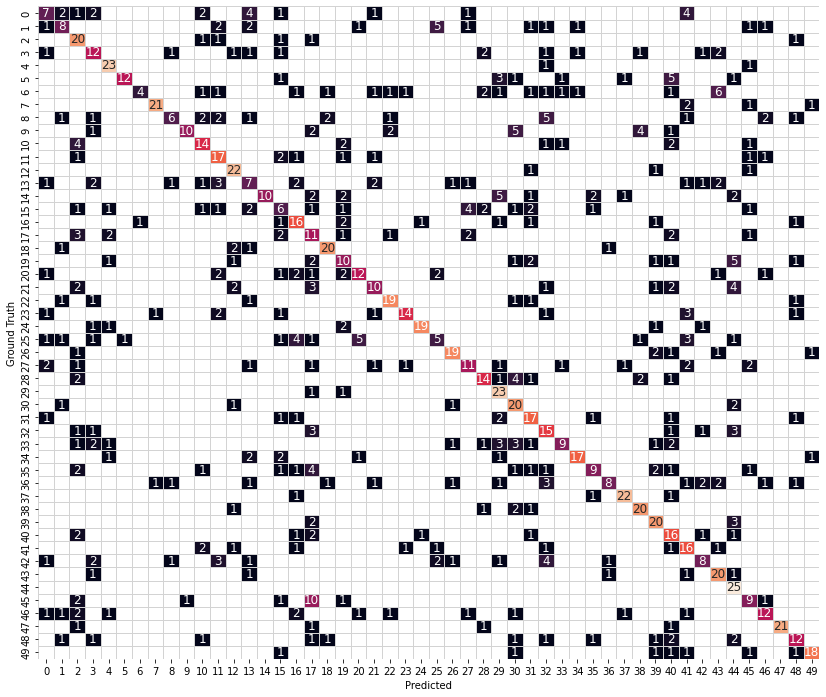

In [7]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)